In [184]:
#Imports
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch           
import torch.nn as nn   
import torchvision     
from torch.utils.data import Dataset, DataLoader, random_split, Subset 
import torchvision.transforms as tt 

import torch.nn.functional as F 

from torchvision.utils import make_grid  
import matplotlib.pyplot as plt          
from matplotlib.image import imread     
import os
import random
from tqdm import tqdm 

In [169]:
#Load and Modify Data
data_orig = pd.read_csv("soccer-data/spi_matches.csv")

#Select columns
#data_col = data_orig[['team1', 'team2', 'spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2']]
data_col = data_orig[['spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2']]

#Remove NAs
data = data_col.dropna()
print(data.head())

     spi1   spi2   prob1   prob2  probtie  proj_score1  proj_score2  score1  \
10  51.16  85.68  0.0463  0.8380   0.1157         0.91         2.36     0.0   
11  68.85  56.48  0.5714  0.1669   0.2617         1.82         0.86     2.0   
12  53.57  66.81  0.3459  0.3621   0.2921         1.16         1.24     2.0   
13  58.98  59.74  0.4482  0.2663   0.2854         1.37         1.05     0.0   
14  69.49  59.33  0.5759  0.1874   0.2367         1.91         1.05     1.0   

    score2   xg1   xg2  nsxg1  nsxg2  
10     1.0  0.97  0.63   0.43   0.45  
11     2.0  2.45  0.77   1.75   0.42  
12     1.0  0.85  2.77   0.17   1.25  
13     1.0  1.24  1.84   1.71   1.56  
14     1.0  1.05  0.22   1.52   0.41  


In [170]:
# Normalizing Data
# Match outcome
winner = [
    data['score1'] > data['score2'],
    data['score1'] < data['score2'],
    data['score1'] == data['score2']
]
choices = ['win', 'loss', 'tie']
data['winner'] = np.select(winner, choices)
encoder = LabelEncoder()
data['outcome'] = encoder.fit_transform(data['winner'])

# Scale numeric columns
scaler = MinMaxScaler()
num_cols = ['spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2', 'year', 'month', 'day']
num_cols = ['spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2']
data[num_cols] = scaler.fit_transform(data[num_cols])


# Scale team names
#team_cols = ['team1', 'team2']
#data[team_cols] = scaler.fit_transform(data[team_cols].apply(lambda x: encoder.fit_transform(x)))

# Drop unnecessary columns
data.drop(['score1', 'score2', 'winner'], axis=1, inplace=True)

/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_41882/3218173394.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['winner'] = np.select(winner, choices)
/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_41882/3218173394.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['outcome'] = encoder.fit_transform(data['winner'])
/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_41882/3218173394.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [171]:
#Print head and shape
print(data.head())
print(data.shape)
#data.to_csv('soccer-data/normalized_data.csv', index=False)

# Separate the features and the target variable
X = data.drop(columns=['outcome'])
y = data['outcome']

# Initialize the PolynomialFeatures object
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and transform the features to create polynomial features
X_poly = poly.fit_transform(X)

# Create a dataframe with the new polynomial features
# 'get_feature_names' will be deprecated soon, use 'get_feature_names_out' for sklearn versions 1.0+
poly_feature_names = poly.get_feature_names_out(input_features=X.columns) if hasattr(poly, 'get_feature_names_out') else poly.get_feature_names(X.columns)
poly_features = pd.DataFrame(X_poly, columns=poly_feature_names)

        spi1      spi2     prob1     prob2   probtie  proj_score1  \
10  0.488165  0.877063  0.019170  0.950364  0.323455     0.174603   
11  0.687556  0.553660  0.572256  0.186362  0.731619     0.415344   
12  0.515329  0.668070  0.334738  0.408584  0.816606     0.240741   
13  0.576307  0.589766  0.442490  0.299522  0.797875     0.296296   
14  0.694770  0.585225  0.576996  0.209699  0.661728     0.439153   

    proj_score2       xg1       xg2     nsxg1     nsxg2  outcome  
10     0.668731  0.137199  0.076179  0.062409  0.062762        0  
11     0.204334  0.346535  0.093108  0.253991  0.058577        1  
12     0.321981  0.120226  0.334946  0.024673  0.174338        2  
13     0.263158  0.175389  0.222491  0.248186  0.217573        0  
14     0.263158  0.148515  0.026602  0.220610  0.057183        1  
(22857, 12)


In [172]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=42, stratify=y)
print(y_train.value_counts())
print(y_test.value_counts())


outcome
2    8251
0    5401
1    4633
Name: count, dtype: int64
outcome
2    2063
0    1351
1    1158
Name: count, dtype: int64


In [173]:
class FeaturewiseAttention(nn.Module):
    def __init__(self, input_size):
        super(FeaturewiseAttention, self).__init__()
        self.attention = nn.Linear(input_size, input_size)

    def forward(self, x):
        # Apply attention to input features
        attention_scores = torch.sigmoid(self.attention(x))  # Use sigmoid to get values between 0 and 1
        return attention_scores * x  # Apply attention scores to the input

class MyMLPWithAttention(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyMLPWithAttention, self).__init__()
        self.input_size = input_size  # Define input_size
        
        self.feature_attention = FeaturewiseAttention(self.input_size)
        
        self.fc1 = nn.Linear(self.input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, output_size)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, self.input_size)  # Use self.input_size here
        x = self.feature_attention(x)  # Apply feature-wise attention
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation function here since you'll use nn.CrossEntropyLoss
        return x

In [174]:
input_size = X_train.shape[1]
print("input size:", input_size)
output_size = len(np.unique(y))
print("output size:", output_size)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).long()
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).long()

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = MyMLPWithAttention(input_size, output_size)

input size: 77
output size: 3


In [175]:
def training(model, loss_function, optimizer, train_loader, n_epochs, update_interval):
    losses = []
    for n in range(n_epochs):
        epoch_losses = []
        for i, (image, label) in enumerate(tqdm(iter(train_loader))):
            
            optimizer.zero_grad()
            my_output = model(image)
            loss = loss_function(my_output, label)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            
            if i % update_interval == 0:
                avg_loss = sum(epoch_losses) / len(epoch_losses)
                losses.append(round(avg_loss, 2))
                epoch_losses = []
                
    avg_total_loss = sum(losses) / len(losses)
    print("Training losses:", losses)
    print(f"Average loss over entire training: {avg_total_loss:.2f}")
    
    return model, losses

100%|██████████| 286/286 [00:00<00:00, 417.92it/s]


Training losses: [1.2, 1.02, 0.96, 0.97, 0.94, 0.92, 0.88, 0.92, 0.92, 0.86, 0.92, 0.93, 1.03, 0.92, 0.91, 0.95, 0.91, 0.93, 0.93, 0.91, 0.92, 0.98, 0.92, 0.92, 0.92, 0.91, 0.92, 0.94, 0.92, 0.92, 1.0, 0.92, 0.91, 0.95, 0.91, 0.93, 0.91, 0.9, 0.91, 0.9, 0.91, 0.91, 0.88, 0.92, 0.92, 0.87, 0.92, 0.92, 0.96, 0.91, 0.92, 0.86, 0.91, 0.93, 1.03, 0.9, 0.93, 0.93, 0.91, 0.91, 0.8, 0.92, 0.91, 0.97, 0.91, 0.92, 0.83, 0.91, 0.92, 1.05, 0.91, 0.92, 0.93, 0.91, 0.91, 0.93, 0.91, 0.92, 0.91, 0.92, 0.92, 0.86, 0.9, 0.92, 0.87, 0.91, 0.92, 0.91, 0.91, 0.91, 0.95, 0.91, 0.91, 1.0, 0.92, 0.91, 0.97, 0.9, 0.91, 0.86, 0.9, 0.91, 0.96, 0.91, 0.92, 0.85, 0.91, 0.92, 1.03, 0.9, 0.92, 0.92, 0.91, 0.91, 0.78, 0.92, 0.91, 0.88, 0.9, 0.91, 0.97, 0.91, 0.91, 0.89, 0.91, 0.91, 1.02, 0.91, 0.9, 0.98, 0.91, 0.91, 0.94, 0.93, 0.9, 0.98, 0.91, 0.91, 0.94, 0.9, 0.92, 0.86, 0.91, 0.91, 1.05, 0.91, 0.91, 0.88, 0.91, 0.91]
Average loss over entire training: 0.92


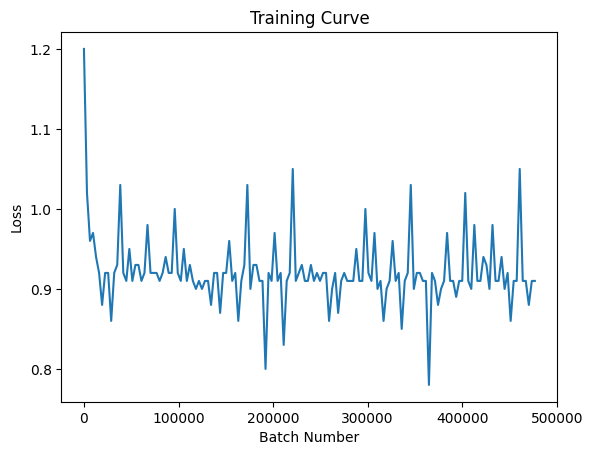

In [176]:
#Model Training
lr = 0.001   
batch_size = 32       
update_interval = 100   
n_epochs = 50          

class_counts = y_train.value_counts().sort_index()
weights = 1. / class_counts
class_weights = torch.tensor(weights.values).float()

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

trained_model, losses = training(model, loss_function, optimizer, train_loader, n_epochs=n_epochs, update_interval=update_interval)

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("Training Curve")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.show()


In [177]:
def testing(model, loss_function, test_loader):
    model.eval()
    sum_loss = 0
    n_correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for i, (data, label) in enumerate(tqdm(iter(test_loader))):
            
            pred = model(data)
            loss = loss_function(pred, label)
            sum_loss += loss.item()
            
            _, predicted = torch.max(pred, 1)
            n_correct += (predicted == label).sum().item()
            total += label.size(0)
            
            true_labels.extend(label.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    test_acc = round((n_correct / total) * 100, 2)
    avg_loss = round(sum_loss / len(test_loader), 2)
    
    return test_acc, avg_loss, true_labels, predicted_labels

In [181]:
#Model Testing
test_acc, avg_loss, true_labels, predicted_labels = testing(trained_model, loss_function, test_loader)
print("Testing accuracy of your trained model:", test_acc)
print("Average loss of your trained model:", avg_loss)

100%|██████████| 72/72 [00:00<00:00, 1248.57it/s]

Testing accuracy of your trained model: 57.79
Average loss of your trained model: 0.9


[[ 863  364  124]
 [ 332  495  331]
 [ 215  564 1284]]


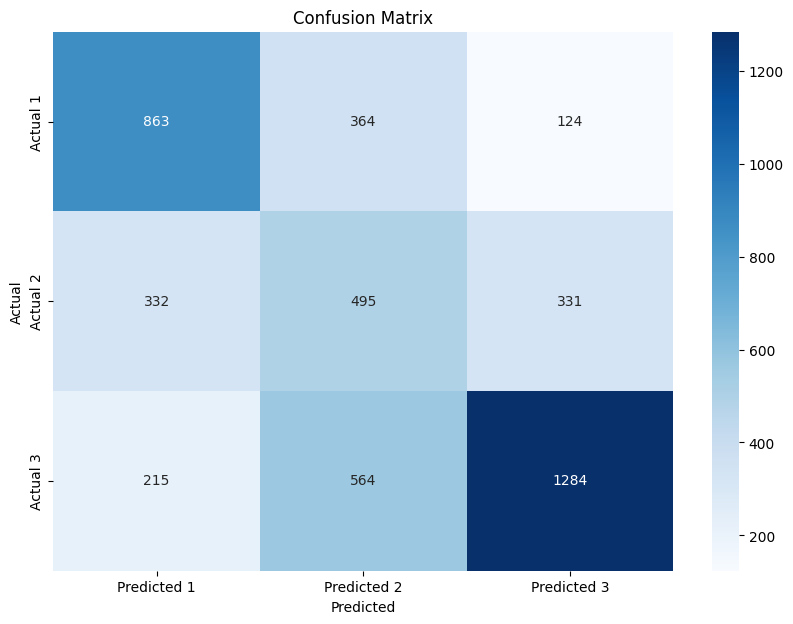

In [183]:
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Predicted 1', 'Predicted 2', 'Predicted 3'], yticklabels=['Actual 1', 'Actual 2', 'Actual 3'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [185]:
def K_fold(model_class, model_params, dataset, K=5):
    hyperparams_grid = {'batch_size': [24, 32, 64, 128, 256],         
                        'lr': [0.0001, 0.001, 0.01, 0.1, 0.5],         
                        'n_epochs': [8, 10, 20, 30, 50],         
                        'update_interval': [25, 50, 100, 200, 250]}

    best_model = None
    best_accuracy = -1
    best_losses = []
    best_hyperparams = {}

    total_combinations = len(hyperparams_grid['batch_size']) * len(hyperparams_grid['lr']) * len(hyperparams_grid['n_epochs']) * len(hyperparams_grid['update_interval'])
    print("Total combinations: ", total_combinations)

    kfold = KFold(n_splits=K, shuffle=True, random_state=42)

    for batch_size, lr, n_epochs, update_interval in tqdm([(bs, lr, ep, ui) for bs in hyperparams_grid['batch_size'] for lr in hyperparams_grid['lr'] for ep in hyperparams_grid['n_epochs'] for ui in hyperparams_grid['update_interval']], total=total_combinations, desc='Hyperparameter Combinations', disable=False):
        print(f"Testing combination: Batch Size={batch_size}, LR={lr}, Epochs={n_epochs}, Update Interval={update_interval}")
        
        avg_accuracy = 0
        avg_loss = 0

        for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
            print(f"Fold {fold+1}/{K}")
            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

            model = model_class(*model_params)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_function = nn.CrossEntropyLoss()

            # Train model using the provided training method
            trained_model, training_losses = training(model, loss_function, optimizer, train_loader, n_epochs, update_interval)

            # Validate model using the provided testing method
            val_accuracy, val_loss, _, _ = testing(trained_model, loss_function, val_loader)
            avg_accuracy += val_accuracy
            avg_loss += val_loss

        avg_accuracy /= K
        avg_loss /= K

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_model = model
            best_losses.append(avg_loss)
            best_hyperparams = {'batch_size': batch_size, 'lr': lr, 'n_epochs': n_epochs, 'update_interval': update_interval}

        print(f"Average accuracy across folds: {avg_accuracy}%, Average loss: {avg_loss}")

    return best_model, best_losses, best_hyperparams


best_model, best_losses, best_hyperparams = K_fold(MyMLPWithAttention, (input_size, output_size), train_dataset)


Total combinations:  625


Hyperparameter Combinations:   0%|          | 0/625 [00:00<?, ?it/s]

Testing combination: Batch Size=24, LR=0.0001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 629.11it/s]


Training losses: [1.12, 1.13, 1.1, 1.05, 1.07, 1.06, 1.03, 1.08, 1.02, 1.06, 1.01, 1.01, 1.03, 1.02, 0.98, 1.0, 0.96, 1.03, 0.98, 1.01, 1.03, 0.93, 0.99, 0.98, 1.01, 0.86, 0.95, 1.0, 0.99, 0.96, 0.94, 0.95, 0.92, 0.93, 0.97, 0.91, 0.99, 0.93, 0.92, 0.99, 0.98, 1.0, 0.95, 0.92, 0.93, 0.96, 0.93, 0.95, 0.98, 0.88, 0.96, 0.93, 0.91, 0.91, 0.93, 0.94, 0.94, 0.95, 0.91, 0.93, 0.92, 0.93, 0.94, 0.92, 0.94, 0.94, 0.91, 0.91, 0.92, 0.9, 0.91, 0.94, 0.92, 0.91, 0.92, 0.7, 0.92, 0.91, 0.89, 0.89, 0.96, 0.92, 0.96, 0.92, 0.9, 0.9, 0.9, 0.91, 0.92, 0.92, 0.89, 0.91, 0.94, 0.88, 0.92, 0.91, 0.92, 0.94, 0.94, 0.91, 0.77, 0.95, 0.94, 0.9, 0.91, 0.89, 0.93, 0.94, 0.94, 0.89, 0.91, 0.91, 0.91, 0.89, 0.96, 0.88, 0.9, 0.88, 0.89, 0.91, 0.91, 0.93, 0.91, 0.9, 0.88, 0.87, 0.9, 0.92, 0.9, 0.95, 0.87, 0.9, 0.89, 0.86, 0.92, 0.95, 0.91, 0.87, 0.9, 0.91, 0.89, 0.92, 0.89, 0.9, 0.92, 0.88, 0.9, 0.88, 0.86, 0.9, 0.93, 0.92, 0.92, 0.92, 0.92, 0.93, 0.88, 0.9, 0.94, 0.89, 0.87, 0.85, 0.91, 0.88, 0.92, 0.88, 0.91, 

100%|██████████| 153/153 [00:00<00:00, 1549.30it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 609.42it/s]


Training losses: [1.18, 1.18, 1.13, 1.1, 1.1, 1.06, 1.05, 1.04, 1.0, 1.05, 1.04, 0.98, 1.03, 0.99, 0.99, 1.0, 0.99, 0.99, 1.0, 0.98, 0.98, 0.98, 0.98, 0.95, 0.97, 0.9, 0.98, 0.95, 0.97, 0.95, 0.97, 0.91, 0.95, 0.94, 0.96, 0.91, 0.92, 0.92, 0.96, 0.94, 0.92, 0.92, 0.96, 0.9, 0.96, 0.89, 0.92, 0.96, 0.92, 0.97, 0.95, 0.94, 0.9, 0.97, 0.92, 0.92, 0.89, 0.9, 0.9, 0.9, 0.95, 0.91, 0.94, 0.91, 0.93, 0.88, 0.92, 0.9, 0.92, 0.93, 0.92, 0.94, 0.89, 0.97, 0.92, 0.83, 0.86, 0.94, 0.89, 0.9, 0.97, 0.91, 0.89, 0.86, 0.93, 0.91, 0.9, 0.89, 0.96, 0.94, 0.9, 0.95, 0.89, 0.89, 0.89, 0.9, 0.89, 0.9, 0.95, 0.92, 1.15, 0.96, 0.9, 0.87, 0.91, 0.9, 0.92, 0.88, 0.89, 0.93, 0.85, 0.89, 0.9, 0.85, 0.88, 0.94, 0.88, 0.91, 0.89, 0.91, 0.92, 0.91, 0.93, 0.92, 0.89, 0.73, 0.89, 0.89, 0.88, 0.88, 0.89, 0.9, 0.88, 0.86, 0.88, 0.95, 0.88, 0.88, 0.91, 0.91, 0.9, 0.9, 0.91, 0.87, 0.9, 0.92, 0.88, 0.92, 0.86, 0.89, 0.88, 0.88, 0.87, 0.9, 0.93, 0.86, 0.93, 0.91, 0.89, 0.91, 0.92, 0.88, 0.91, 0.91, 0.91, 0.88, 0.86, 0.88,

100%|██████████| 153/153 [00:00<00:00, 2248.62it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 676.29it/s]


Training losses: [1.25, 1.25, 1.21, 1.18, 1.12, 1.08, 1.08, 1.08, 1.1, 1.07, 1.03, 1.06, 1.03, 1.03, 0.99, 1.02, 1.04, 1.03, 1.02, 1.0, 0.98, 1.0, 1.0, 0.98, 1.01, 0.89, 0.97, 0.94, 0.96, 0.98, 0.95, 0.95, 0.96, 0.98, 0.97, 0.96, 0.98, 0.97, 0.96, 0.98, 0.97, 0.94, 0.92, 0.94, 0.92, 0.95, 0.91, 0.92, 0.94, 0.95, 0.83, 0.9, 0.96, 0.97, 0.9, 1.0, 0.96, 0.95, 0.92, 0.96, 0.93, 0.91, 0.95, 0.93, 0.93, 0.93, 0.95, 0.89, 0.94, 0.96, 0.89, 0.89, 0.96, 0.94, 0.88, 0.95, 0.89, 0.95, 0.93, 0.93, 0.92, 0.95, 0.93, 0.9, 0.93, 0.89, 0.88, 0.89, 0.92, 0.89, 0.91, 0.96, 0.89, 0.91, 0.91, 0.91, 0.91, 0.92, 0.95, 0.97, 0.76, 0.93, 0.92, 0.91, 0.88, 0.93, 0.92, 0.94, 0.96, 0.89, 0.93, 0.9, 0.91, 0.89, 0.88, 0.88, 0.9, 0.9, 0.93, 0.88, 0.92, 0.96, 0.87, 0.91, 0.91, 0.99, 0.96, 0.9, 0.87, 0.92, 0.92, 0.95, 0.89, 0.89, 0.9, 0.93, 0.9, 0.86, 0.89, 0.93, 0.92, 0.88, 0.87, 0.88, 0.92, 0.91, 0.92, 0.89, 0.89, 0.92, 0.71, 0.93, 0.92, 0.9, 0.9, 0.92, 0.94, 0.92, 0.9, 0.89, 0.93, 0.89, 0.92, 0.86, 0.85, 0.9, 0.95

100%|██████████| 153/153 [00:00<00:00, 2185.40it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 667.85it/s]


Training losses: [1.27, 1.22, 1.17, 1.12, 1.11, 1.07, 1.09, 1.08, 1.08, 1.05, 1.03, 1.02, 1.05, 0.99, 1.0, 0.97, 1.04, 1.0, 0.99, 0.99, 0.99, 1.0, 1.01, 0.95, 0.99, 1.11, 0.95, 0.92, 0.97, 0.96, 0.99, 0.93, 0.97, 0.98, 0.95, 0.92, 0.92, 0.98, 0.92, 0.96, 0.94, 0.96, 0.99, 0.98, 0.95, 0.95, 0.93, 0.94, 0.92, 0.91, 0.75, 0.93, 0.89, 0.91, 0.9, 0.94, 0.9, 0.96, 0.9, 0.89, 0.93, 0.94, 0.91, 0.95, 0.94, 0.94, 0.91, 0.96, 0.93, 0.91, 0.94, 0.94, 0.93, 0.92, 0.97, 0.81, 0.93, 0.91, 0.89, 0.9, 0.91, 0.96, 0.94, 0.94, 0.9, 0.95, 0.9, 0.89, 0.9, 0.95, 0.9, 0.92, 0.89, 0.93, 0.91, 0.87, 0.96, 0.9, 0.88, 0.88, 0.82, 0.93, 0.88, 0.93, 0.9, 0.93, 0.88, 0.92, 0.9, 0.91, 0.97, 0.88, 0.95, 0.97, 0.89, 0.92, 0.89, 0.89, 0.94, 0.9, 0.92, 0.9, 0.92, 0.88, 0.92, 0.84, 0.9, 0.91, 0.93, 0.9, 0.9, 0.94, 0.94, 0.89, 0.87, 0.9, 0.89, 0.94, 0.92, 0.88, 0.92, 0.92, 0.87, 0.89, 0.89, 0.85, 0.94, 0.92, 0.89, 0.91, 0.91, 0.89, 0.89, 0.93, 0.91, 0.93, 0.94, 0.91, 0.9, 0.88, 0.88, 0.85, 0.87, 0.9, 0.9, 0.9, 0.89, 0.9,

100%|██████████| 153/153 [00:00<00:00, 2372.16it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 666.82it/s]


Training losses: [1.14, 1.16, 1.13, 1.1, 1.06, 1.09, 1.05, 1.07, 1.07, 1.03, 1.01, 1.0, 1.01, 0.98, 0.98, 1.04, 0.99, 1.0, 0.99, 0.98, 0.99, 0.97, 0.99, 0.97, 0.98, 1.03, 0.97, 0.95, 0.98, 0.99, 0.95, 0.99, 0.95, 0.93, 0.97, 0.94, 0.94, 0.92, 0.91, 0.94, 0.97, 0.93, 0.95, 0.96, 0.97, 0.94, 0.94, 0.93, 0.94, 0.92, 0.79, 0.91, 0.95, 0.91, 0.93, 0.92, 0.95, 0.91, 0.95, 0.91, 0.93, 0.97, 0.93, 0.91, 0.92, 0.9, 0.88, 0.91, 0.94, 0.93, 0.89, 0.91, 0.88, 0.91, 0.95, 0.94, 0.88, 0.91, 0.87, 0.87, 0.94, 0.93, 0.92, 0.91, 0.9, 0.92, 0.91, 0.91, 0.94, 0.88, 0.9, 0.92, 0.93, 0.92, 0.95, 0.89, 0.92, 0.9, 0.91, 0.91, 0.81, 0.93, 0.96, 0.94, 0.89, 0.9, 0.92, 0.91, 0.9, 0.9, 0.92, 0.89, 0.91, 0.94, 0.9, 0.92, 0.89, 0.89, 0.9, 0.92, 0.9, 0.9, 0.89, 0.91, 0.89, 0.74, 0.87, 0.92, 0.92, 0.95, 0.93, 0.91, 0.93, 0.93, 0.9, 0.91, 0.86, 0.89, 0.86, 0.92, 0.96, 0.9, 0.91, 0.9, 0.86, 0.88, 0.86, 0.93, 0.89, 0.91, 1.0, 0.89, 0.9, 0.91, 0.9, 0.92, 0.9, 0.92, 0.88, 0.9, 0.89, 0.9, 0.89, 0.91, 0.92, 0.86, 0.89, 0.9

Hyperparameter Combinations:   0%|          | 1/625 [00:39<6:52:17, 39.64s/it]

Average accuracy across folds: 59.818%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.0001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 643.53it/s]


Training losses: [1.21, 1.12, 1.07, 1.05, 1.06, 1.03, 0.99, 1.01, 1.02, 1.02, 1.0, 0.99, 0.98, 0.98, 0.97, 0.98, 0.97, 0.96, 0.97, 0.94, 0.96, 0.95, 0.94, 0.94, 0.98, 0.95, 1.16, 0.93, 0.93, 0.94, 0.91, 0.94, 0.96, 0.94, 0.91, 0.93, 0.94, 0.9, 0.91, 1.01, 0.93, 0.91, 0.95, 0.94, 0.89, 0.92, 0.93, 0.92, 0.91, 0.93, 0.88, 0.9, 0.95, 0.91, 0.92, 0.9, 0.88, 0.91, 0.91, 0.91, 0.91, 0.92, 0.92, 0.92, 0.92, 0.96, 0.88, 0.92, 0.9, 0.88, 0.89, 0.89, 0.91, 0.89, 0.91, 0.92, 0.91, 0.92, 0.97, 0.92, 0.89, 0.9, 0.9, 0.92, 0.88, 0.91, 0.92, 0.89, 0.89, 0.91, 0.9, 0.89, 0.91, 0.93, 0.91, 0.91, 0.92, 0.87, 0.89, 0.89, 0.88, 0.91, 0.89, 0.86]
Average loss over entire training: 0.94


100%|██████████| 153/153 [00:00<00:00, 2175.11it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 581.57it/s]


Training losses: [1.16, 1.14, 1.09, 1.07, 1.03, 1.05, 1.0, 1.01, 0.99, 1.0, 0.96, 0.97, 0.98, 0.82, 0.93, 0.93, 0.94, 0.94, 0.95, 0.93, 0.92, 0.94, 0.96, 0.96, 0.92, 0.92, 0.92, 0.94, 0.92, 0.91, 0.91, 0.9, 0.91, 0.91, 0.94, 0.9, 0.89, 0.9, 0.91, 0.97, 0.89, 0.92, 0.92, 0.92, 0.91, 0.88, 0.89, 0.92, 0.91, 0.9, 0.88, 0.9, 0.96, 0.91, 0.88, 0.91, 0.88, 0.9, 0.89, 0.91, 0.89, 0.91, 0.87, 0.94, 0.89, 0.95, 0.91, 0.89, 0.87, 0.89, 0.92, 0.89, 0.88, 0.94, 0.87, 0.88, 0.89, 0.89, 0.85, 0.9, 0.88, 0.9, 0.86, 0.89, 0.91, 0.92, 0.89, 0.89, 0.9, 0.91, 0.9, 0.91, 0.89, 0.87, 0.91, 0.89, 0.9, 0.89, 0.88, 0.89, 0.89, 0.92, 0.87, 0.92]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 2214.82it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 676.55it/s]


Training losses: [1.18, 1.12, 1.09, 1.05, 1.03, 1.02, 0.99, 1.02, 0.99, 0.99, 0.96, 0.95, 0.95, 0.89, 0.95, 0.97, 0.93, 0.93, 0.91, 0.92, 0.95, 0.95, 0.95, 0.93, 0.92, 0.94, 0.93, 0.95, 0.93, 0.95, 0.92, 0.92, 0.9, 0.9, 0.91, 0.93, 0.87, 0.93, 0.91, 0.74, 0.94, 0.89, 0.93, 0.91, 0.92, 0.89, 0.92, 0.94, 0.92, 0.88, 0.9, 0.93, 0.79, 0.9, 0.92, 0.94, 0.88, 0.9, 0.91, 0.92, 0.9, 0.9, 0.92, 0.9, 0.92, 0.87, 0.88, 0.92, 0.92, 0.92, 0.91, 0.89, 0.91, 0.91, 0.92, 0.85, 0.95, 0.89, 1.33, 0.88, 0.89, 0.89, 0.9, 0.87, 0.9, 0.91, 0.89, 0.88, 0.92, 0.89, 0.92, 0.97, 0.88, 0.87, 0.91, 0.89, 0.92, 0.9, 0.86, 0.9, 0.89, 0.91, 0.91, 0.91]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2416.10it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 675.94it/s]


Training losses: [0.96, 1.16, 1.09, 1.08, 1.03, 1.03, 1.0, 1.04, 1.04, 0.99, 1.0, 1.0, 0.97, 1.1, 0.97, 1.0, 0.95, 0.97, 0.95, 0.97, 0.95, 0.94, 0.92, 0.95, 0.93, 0.94, 1.09, 0.98, 0.94, 0.95, 0.91, 0.93, 0.94, 0.92, 0.93, 0.93, 0.92, 0.91, 0.92, 0.86, 0.92, 0.9, 0.91, 0.94, 0.95, 0.9, 0.94, 0.9, 0.9, 0.92, 0.9, 0.9, 1.01, 0.94, 0.93, 0.89, 0.91, 0.92, 0.93, 0.87, 0.89, 0.92, 0.94, 0.91, 0.93, 0.8, 0.89, 0.89, 0.87, 0.93, 0.9, 0.94, 0.88, 0.88, 0.91, 0.89, 0.93, 0.93, 0.94, 0.88, 0.89, 0.9, 0.9, 0.92, 0.92, 0.88, 0.9, 0.88, 0.94, 0.9, 0.88, 0.84, 0.88, 0.87, 0.91, 0.89, 0.89, 0.93, 0.9, 0.9, 0.89, 0.89, 0.9, 0.95]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2285.86it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 687.92it/s]


Training losses: [1.25, 1.12, 1.08, 1.07, 1.03, 1.01, 1.02, 1.01, 1.0, 0.98, 0.99, 0.96, 0.96, 1.02, 0.96, 0.96, 0.96, 0.95, 0.96, 0.94, 0.94, 0.96, 0.93, 0.97, 0.94, 0.94, 1.01, 0.94, 0.95, 0.91, 0.92, 0.9, 0.94, 0.91, 0.93, 0.93, 0.9, 0.91, 0.91, 0.9, 0.91, 0.91, 0.89, 0.91, 0.94, 0.9, 0.93, 0.9, 0.91, 0.94, 0.91, 0.93, 1.02, 0.92, 0.9, 0.91, 0.92, 0.92, 0.92, 0.88, 0.9, 0.9, 0.92, 0.9, 0.92, 0.89, 0.9, 0.89, 0.9, 0.91, 0.92, 0.91, 0.91, 0.91, 0.9, 0.9, 0.91, 0.88, 1.08, 0.91, 0.91, 0.9, 0.89, 0.88, 0.89, 0.87, 0.88, 0.89, 0.93, 0.91, 0.94, 0.74, 0.89, 0.88, 0.89, 0.89, 0.92, 0.88, 0.93, 0.91, 0.9, 0.88, 0.91, 0.91]
Average loss over entire training: 0.93


Hyperparameter Combinations:   0%|          | 2/625 [01:18<6:45:59, 39.10s/it]

Average accuracy across folds: 59.648%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.0001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 697.27it/s]


Training losses: [1.31, 1.12, 1.06, 1.04, 1.01, 1.01, 0.97, 0.88, 0.99, 0.96, 0.95, 0.95, 0.95, 0.93, 0.94, 0.96, 0.93, 0.93, 0.92, 0.92, 0.93, 0.79, 0.93, 0.91, 0.91, 0.93, 0.93, 0.9, 0.95, 0.91, 0.91, 0.9, 0.91, 0.9, 0.93, 0.85, 0.89, 0.93, 0.91, 0.91, 0.89, 0.89, 1.01, 0.9, 0.91, 0.89, 0.9, 0.91, 0.9, 1.07, 0.88, 0.91, 0.92, 0.88, 0.91, 0.89]
Average loss over entire training: 0.94


100%|██████████| 153/153 [00:00<00:00, 2432.04it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 676.81it/s]


Training losses: [1.32, 1.17, 1.07, 1.03, 1.02, 0.99, 0.98, 0.84, 0.97, 0.93, 0.96, 0.97, 0.94, 0.95, 1.0, 0.93, 0.93, 0.93, 0.93, 0.92, 0.92, 0.88, 0.93, 0.9, 0.9, 0.94, 0.89, 0.9, 0.84, 0.91, 0.88, 0.9, 0.91, 0.91, 0.91, 0.93, 0.92, 0.91, 0.89, 0.91, 0.9, 0.9, 0.85, 0.9, 0.91, 0.89, 0.89, 0.9, 0.89, 0.86, 0.91, 0.89, 0.89, 0.9, 0.89, 0.89]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2108.88it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 648.27it/s]


Training losses: [1.22, 1.1, 1.04, 1.03, 1.02, 1.01, 0.97, 0.76, 1.0, 0.96, 0.96, 0.94, 0.95, 0.93, 0.81, 0.93, 0.94, 0.92, 0.94, 0.93, 0.92, 0.76, 0.92, 0.92, 0.93, 0.92, 0.9, 0.91, 1.01, 0.91, 0.93, 0.91, 0.9, 0.91, 0.91, 0.75, 0.92, 0.92, 0.92, 0.91, 0.9, 0.91, 1.01, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 1.0, 0.92, 0.88, 0.9, 0.91, 0.9, 0.87]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2285.42it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 662.10it/s]


Training losses: [1.21, 1.15, 1.1, 1.04, 0.99, 0.99, 0.99, 0.98, 0.96, 0.94, 0.95, 0.97, 0.96, 0.95, 0.92, 0.94, 0.95, 0.92, 0.92, 0.91, 0.93, 0.86, 0.93, 0.9, 0.9, 0.92, 0.92, 0.92, 0.85, 0.89, 0.92, 0.93, 0.91, 0.9, 0.9, 1.03, 0.9, 0.9, 0.9, 0.92, 0.91, 0.9, 0.92, 0.91, 0.93, 0.89, 0.89, 0.91, 0.9, 0.82, 0.89, 0.89, 0.89, 0.87, 0.92, 0.91]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2173.54it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 645.06it/s]


Training losses: [1.27, 1.13, 1.07, 1.03, 1.0, 0.99, 0.97, 0.88, 0.96, 0.95, 0.94, 0.94, 0.93, 0.95, 0.79, 0.93, 0.92, 0.92, 0.93, 0.93, 0.91, 1.0, 0.92, 0.91, 0.92, 0.93, 0.92, 0.91, 0.84, 0.93, 0.88, 0.93, 0.91, 0.91, 0.9, 0.75, 0.91, 0.9, 0.89, 0.92, 0.91, 0.91, 0.84, 0.87, 0.9, 0.91, 0.9, 0.89, 0.92, 0.88, 0.89, 0.9, 0.9, 0.91, 0.89, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:   0%|          | 3/625 [01:56<6:39:40, 38.55s/it]

Average accuracy across folds: 59.946000000000005%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.0001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 658.99it/s]


Training losses: [1.28, 1.17, 1.03, 0.99, 0.83, 0.96, 0.95, 0.95, 1.1, 0.93, 0.92, 0.93, 0.72, 0.91, 0.92, 0.92, 0.7, 0.91, 0.91, 0.91, 0.97, 0.9, 0.9, 0.91, 0.84, 0.91, 0.89, 0.9, 0.93, 0.89, 0.91, 0.9]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2291.92it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 588.71it/s]


Training losses: [1.19, 1.11, 1.03, 0.97, 1.19, 0.94, 0.95, 0.93, 0.83, 0.93, 0.91, 0.92, 0.99, 0.9, 0.92, 0.91, 0.91, 0.89, 0.89, 0.91, 0.84, 0.89, 0.9, 0.9, 0.82, 0.9, 0.89, 0.89, 0.88, 0.89, 0.89, 0.89]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2359.37it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 648.59it/s]


Training losses: [1.2, 1.11, 1.02, 0.99, 0.84, 0.97, 0.97, 0.95, 0.8, 0.94, 0.93, 0.92, 0.77, 0.92, 0.91, 0.93, 0.95, 0.91, 0.91, 0.91, 0.95, 0.91, 0.91, 0.91, 1.11, 0.9, 0.9, 0.9, 1.02, 0.9, 0.91, 0.9]
Average loss over entire training: 0.94


100%|██████████| 153/153 [00:00<00:00, 2338.48it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 711.50it/s]


Training losses: [1.32, 1.11, 1.02, 1.0, 0.97, 0.96, 0.96, 0.93, 1.2, 0.94, 0.93, 0.91, 1.0, 0.91, 0.93, 0.91, 0.93, 0.92, 0.9, 0.91, 0.85, 0.91, 0.9, 0.91, 0.93, 0.9, 0.9, 0.9, 0.81, 0.91, 0.9, 0.88]
Average loss over entire training: 0.95


100%|██████████| 153/153 [00:00<00:00, 1467.03it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 685.84it/s]


Training losses: [1.24, 1.11, 1.03, 1.0, 1.17, 0.96, 0.96, 0.96, 1.09, 0.93, 0.93, 0.93, 1.14, 0.91, 0.91, 0.92, 0.84, 0.92, 0.91, 0.91, 0.99, 0.91, 0.89, 0.91, 0.82, 0.89, 0.9, 0.9, 1.1, 0.89, 0.91, 0.91]
Average loss over entire training: 0.96


Hyperparameter Combinations:   1%|          | 4/625 [02:34<6:37:51, 38.44s/it]

Average accuracy across folds: 59.772000000000006%, Average loss: 0.868
Testing combination: Batch Size=24, LR=0.0001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 682.59it/s]


Training losses: [1.3, 1.12, 1.01, 0.83, 0.97, 0.94, 0.73, 0.92, 0.92, 0.73, 0.91, 0.91, 0.85, 0.9, 0.9, 0.7, 0.92, 0.89, 0.99, 0.91, 0.9, 1.01, 0.89, 0.9]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 2254.95it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 686.99it/s]


Training losses: [1.24, 1.11, 1.0, 1.13, 0.95, 0.95, 0.9, 0.92, 0.93, 1.18, 0.93, 0.89, 0.86, 0.91, 0.9, 1.06, 0.88, 0.9, 0.91, 0.89, 0.9, 1.0, 0.9, 0.87]
Average loss over entire training: 0.96


100%|██████████| 153/153 [00:00<00:00, 1479.59it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 670.88it/s]


Training losses: [1.06, 1.07, 1.02, 1.11, 0.96, 0.94, 1.08, 0.94, 0.92, 0.83, 0.91, 0.91, 0.78, 0.9, 0.93, 0.88, 0.9, 0.91, 1.04, 0.9, 0.9, 0.95, 0.9, 0.9]
Average loss over entire training: 0.94


100%|██████████| 153/153 [00:00<00:00, 2336.52it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 634.91it/s]


Training losses: [0.95, 1.07, 1.0, 1.02, 0.96, 0.94, 1.1, 0.93, 0.93, 0.83, 0.91, 0.92, 0.87, 0.91, 0.91, 0.89, 0.91, 0.9, 0.83, 0.91, 0.89, 0.98, 0.9, 0.9]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2525.04it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 651.58it/s]


Training losses: [1.09, 1.06, 0.99, 1.04, 0.95, 0.95, 1.09, 0.93, 0.93, 0.79, 0.92, 0.93, 0.91, 0.92, 0.9, 0.88, 0.9, 0.9, 0.77, 0.9, 0.9, 0.9, 0.91, 0.9]
Average loss over entire training: 0.93


Hyperparameter Combinations:   1%|          | 5/625 [03:13<6:40:05, 38.72s/it]

Average accuracy across folds: 60.010000000000005%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.0001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 692.91it/s]


Training losses: [1.24, 1.16, 1.11, 1.07, 1.04, 1.05, 1.09, 1.05, 1.03, 1.04, 1.03, 1.07, 1.0, 1.02, 1.0, 1.0, 1.02, 0.99, 0.99, 1.02, 0.96, 0.91, 0.99, 0.99, 0.96, 0.91, 0.99, 0.95, 0.95, 0.96, 0.94, 0.94, 0.98, 0.93, 0.92, 0.97, 0.91, 0.9, 0.95, 0.92, 0.96, 0.9, 0.96, 0.98, 0.9, 0.91, 0.92, 0.95, 0.93, 0.92, 0.89, 0.94, 0.91, 0.92, 0.97, 0.92, 0.92, 0.91, 0.92, 0.95, 0.89, 0.92, 0.92, 0.94, 0.94, 0.9, 0.92, 0.9, 0.93, 0.94, 0.91, 0.91, 0.92, 0.89, 0.95, 0.72, 0.89, 0.89, 0.92, 0.91, 0.87, 0.9, 0.89, 0.99, 0.88, 0.92, 0.93, 0.92, 0.88, 0.93, 0.94, 0.89, 0.91, 0.89, 0.91, 0.94, 0.95, 0.94, 0.92, 0.9, 0.85, 0.91, 0.92, 0.89, 0.91, 0.91, 0.91, 0.91, 0.89, 0.92, 0.9, 0.89, 0.85, 0.9, 0.87, 0.91, 0.95, 0.93, 0.92, 0.86, 0.95, 0.88, 0.97, 0.92, 0.88, 0.9, 0.91, 0.88, 0.93, 0.87, 0.95, 0.9, 0.86, 0.89, 0.91, 0.92, 0.92, 0.94, 0.87, 0.92, 0.92, 0.87, 0.87, 0.88, 0.89, 0.88, 0.9, 0.89, 0.93, 0.93, 0.73, 0.89, 0.85, 0.91, 0.94, 0.94, 0.89, 0.93, 0.89, 0.9, 0.95, 0.9, 0.93, 0.87, 0.85, 0.88, 0.9

100%|██████████| 153/153 [00:00<00:00, 2309.65it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 656.62it/s]


Training losses: [1.19, 1.17, 1.16, 1.14, 1.09, 1.05, 1.07, 1.07, 1.03, 1.02, 1.02, 0.99, 1.01, 1.0, 1.01, 0.99, 1.05, 0.98, 0.99, 0.98, 1.03, 1.0, 0.96, 0.95, 0.94, 0.88, 0.99, 1.03, 1.0, 0.97, 0.92, 0.92, 0.96, 0.94, 0.93, 0.95, 0.94, 0.94, 0.96, 0.93, 0.92, 0.96, 0.97, 0.91, 0.91, 0.93, 0.91, 0.94, 0.91, 0.94, 0.81, 0.95, 0.96, 0.9, 0.92, 0.94, 0.93, 0.9, 0.94, 0.94, 0.96, 0.9, 0.97, 0.95, 0.94, 0.86, 0.91, 0.92, 0.97, 0.91, 0.92, 0.88, 0.92, 0.94, 0.92, 0.82, 0.91, 0.89, 0.91, 0.91, 0.9, 0.93, 0.89, 0.91, 0.91, 0.9, 0.93, 0.9, 0.88, 0.89, 0.88, 0.94, 0.92, 0.91, 0.9, 0.88, 0.95, 0.92, 0.91, 0.91, 1.1, 0.91, 0.83, 0.89, 0.91, 0.92, 0.89, 0.91, 0.9, 0.91, 0.92, 0.91, 0.9, 0.88, 0.88, 0.91, 0.87, 0.94, 0.87, 0.85, 0.89, 0.9, 0.91, 0.88, 0.93, 1.19, 0.9, 0.88, 0.89, 0.91, 0.92, 0.85, 0.92, 0.9, 0.91, 0.92, 0.9, 0.89, 0.88, 0.85, 0.9, 0.91, 0.94, 0.89, 0.87, 0.9, 0.86, 0.91, 0.9, 0.91, 0.86, 0.9, 0.83, 0.88, 0.91, 0.89, 0.9, 0.91, 0.91, 0.88, 0.92, 0.87, 0.9, 0.92, 0.89, 0.87, 0.93, 0.8

100%|██████████| 153/153 [00:00<00:00, 2286.73it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 661.68it/s]


Training losses: [1.06, 1.18, 1.16, 1.14, 1.08, 1.07, 1.09, 1.06, 1.07, 1.0, 1.03, 1.03, 1.05, 1.04, 1.02, 1.03, 1.01, 1.04, 1.02, 0.97, 0.98, 1.02, 0.99, 0.97, 1.02, 0.84, 0.98, 0.96, 0.99, 0.98, 0.94, 0.96, 0.97, 0.97, 0.95, 0.92, 0.93, 0.99, 0.97, 0.95, 0.98, 0.94, 0.93, 0.94, 0.93, 0.93, 0.92, 0.93, 0.91, 0.93, 0.87, 0.92, 0.91, 0.98, 0.9, 0.93, 0.9, 0.88, 0.96, 0.95, 0.87, 0.89, 0.94, 0.92, 0.96, 0.96, 0.92, 0.95, 0.97, 0.94, 0.9, 0.89, 0.94, 0.92, 0.92, 0.7, 0.92, 0.91, 0.91, 0.89, 0.93, 0.91, 0.85, 0.93, 0.91, 0.91, 0.92, 0.9, 0.94, 0.96, 0.91, 0.9, 0.96, 0.96, 0.93, 0.9, 0.88, 0.94, 0.9, 0.94, 0.81, 0.92, 0.88, 0.93, 0.93, 0.94, 0.93, 0.9, 0.93, 0.92, 0.86, 0.94, 0.91, 0.85, 0.92, 0.87, 0.9, 0.96, 0.93, 0.89, 0.93, 0.89, 0.9, 0.9, 0.9, 0.75, 0.87, 0.94, 0.95, 0.91, 0.89, 0.86, 0.91, 0.89, 0.9, 0.91, 0.9, 0.84, 0.87, 0.92, 0.93, 0.92, 0.92, 0.87, 0.95, 0.92, 0.9, 0.97, 0.92, 0.91, 1.07, 0.94, 0.91, 0.89, 0.94, 0.93, 0.93, 0.87, 0.92, 0.89, 0.92, 0.91, 0.91, 0.88, 0.91, 0.95, 0.8

100%|██████████| 153/153 [00:00<00:00, 2146.41it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 669.90it/s]


Training losses: [1.24, 1.15, 1.16, 1.1, 1.09, 1.1, 1.07, 1.04, 1.04, 1.03, 1.01, 1.02, 1.0, 1.02, 1.04, 0.98, 0.99, 1.02, 1.02, 0.97, 0.94, 0.98, 0.98, 0.99, 0.96, 0.78, 0.97, 0.98, 0.94, 0.93, 0.93, 0.95, 0.97, 0.98, 0.94, 0.98, 0.91, 0.92, 0.97, 0.95, 0.92, 0.96, 0.95, 0.95, 0.92, 0.97, 0.95, 0.96, 0.94, 0.95, 0.74, 0.96, 0.94, 0.92, 0.96, 0.91, 0.94, 0.87, 0.96, 0.97, 0.93, 0.95, 0.89, 0.95, 0.92, 0.91, 0.9, 0.93, 0.92, 0.93, 0.89, 0.9, 0.91, 0.95, 0.91, 0.65, 0.9, 0.86, 0.92, 0.95, 0.93, 0.91, 0.89, 0.94, 0.91, 0.9, 0.92, 0.93, 0.89, 0.89, 0.93, 0.93, 0.89, 0.94, 0.95, 0.89, 0.92, 0.93, 0.88, 0.94, 0.82, 0.87, 0.92, 0.96, 0.9, 0.94, 0.92, 0.92, 0.87, 0.93, 0.9, 0.93, 0.93, 0.91, 0.9, 0.93, 0.95, 0.9, 0.89, 0.89, 0.89, 0.92, 0.92, 0.91, 0.92, 0.78, 0.9, 0.93, 0.97, 0.89, 0.92, 0.9, 0.95, 0.94, 0.9, 0.89, 0.92, 0.93, 0.95, 0.91, 0.88, 0.88, 0.89, 0.92, 0.89, 0.92, 0.88, 0.86, 0.89, 0.9, 0.84, 0.92, 0.9, 0.9, 0.91, 0.94, 0.91, 0.9, 0.91, 0.94, 0.91, 0.95, 0.89, 0.88, 0.88, 0.91, 0.89

100%|██████████| 153/153 [00:00<00:00, 2228.08it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 621.47it/s]


Training losses: [1.22, 1.17, 1.13, 1.11, 1.09, 1.06, 1.07, 1.05, 1.05, 1.03, 1.02, 1.0, 1.05, 1.02, 1.01, 0.97, 0.98, 0.99, 0.99, 0.96, 1.0, 0.97, 0.99, 0.95, 0.96, 0.87, 0.99, 0.99, 0.99, 0.93, 0.92, 0.96, 0.97, 0.97, 0.93, 0.95, 1.01, 0.97, 0.91, 0.95, 0.96, 0.89, 0.92, 0.97, 0.91, 0.94, 0.95, 0.97, 0.93, 0.96, 0.78, 0.95, 0.94, 0.91, 0.92, 0.95, 0.91, 0.93, 0.91, 0.91, 0.93, 0.92, 0.98, 0.93, 0.94, 0.93, 0.93, 0.89, 0.93, 0.92, 0.91, 0.94, 0.95, 0.93, 0.93, 0.89, 0.92, 0.92, 0.93, 0.93, 0.95, 0.89, 0.93, 0.9, 0.89, 0.89, 0.92, 0.94, 0.9, 0.91, 0.95, 0.88, 0.91, 0.89, 0.91, 0.9, 0.92, 0.92, 0.95, 0.89, 0.83, 0.9, 0.88, 0.88, 0.89, 0.93, 0.92, 0.95, 0.9, 0.88, 0.95, 0.89, 0.89, 0.92, 0.89, 0.91, 0.88, 0.92, 0.93, 0.9, 0.92, 0.88, 0.91, 0.92, 0.96, 0.69, 0.94, 0.87, 0.9, 0.95, 0.9, 0.9, 0.88, 0.9, 0.92, 0.87, 0.92, 0.89, 0.9, 0.93, 0.92, 0.93, 0.92, 0.88, 0.9, 0.87, 0.86, 0.91, 0.9, 0.91, 1.24, 0.88, 0.89, 0.89, 0.91, 0.91, 0.87, 0.86, 0.94, 0.89, 0.86, 0.89, 0.9, 0.9, 0.91, 0.88, 0.8

Hyperparameter Combinations:   1%|          | 6/625 [04:00<7:06:58, 41.39s/it]

Average accuracy across folds: 59.80800000000001%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.0001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 672.76it/s]


Training losses: [1.05, 1.1, 1.09, 1.06, 1.03, 1.03, 1.03, 1.02, 0.99, 1.01, 0.96, 1.0, 0.97, 0.93, 0.97, 0.98, 0.94, 0.9, 0.96, 0.96, 0.95, 0.94, 0.96, 0.95, 0.94, 0.94, 0.83, 0.89, 0.94, 0.92, 0.91, 0.93, 0.93, 0.89, 0.92, 0.96, 0.96, 0.93, 0.93, 0.98, 0.92, 0.9, 0.89, 0.94, 0.92, 0.89, 0.9, 0.95, 0.92, 0.93, 0.9, 0.89, 0.76, 0.94, 0.9, 0.89, 0.89, 0.91, 0.9, 0.92, 0.9, 0.94, 0.9, 0.9, 0.89, 0.92, 0.91, 0.92, 0.9, 0.89, 0.92, 0.89, 0.93, 0.91, 0.9, 0.9, 0.89, 0.91, 0.67, 0.93, 0.88, 0.87, 0.92, 0.89, 0.9, 0.89, 0.94, 0.9, 0.89, 0.87, 0.89, 0.92, 0.91, 0.89, 0.89, 0.9, 0.91, 0.88, 0.89, 0.89, 0.94, 0.89, 0.87, 0.9, 0.88, 0.9, 0.9, 0.87, 0.89, 0.92, 0.88, 0.88, 0.9, 0.9, 0.88, 0.92, 0.9, 1.02, 0.87, 0.9, 0.87, 0.89, 0.89, 0.9, 0.9, 0.92, 0.89, 0.9, 0.89, 0.9]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 2244.66it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 649.71it/s]


Training losses: [1.18, 1.15, 1.09, 1.06, 1.03, 1.03, 1.0, 0.99, 1.02, 0.97, 0.98, 0.97, 0.93, 1.26, 0.95, 0.94, 0.93, 0.97, 0.95, 0.95, 0.94, 0.94, 0.95, 0.93, 0.91, 0.9, 0.81, 0.92, 0.93, 0.93, 0.94, 0.92, 0.97, 0.92, 0.9, 0.88, 0.91, 0.91, 0.92, 0.65, 0.95, 0.94, 0.91, 0.9, 0.94, 0.88, 0.92, 0.88, 0.89, 0.9, 0.9, 0.89, 0.69, 0.89, 0.89, 0.93, 0.89, 0.89, 0.91, 0.9, 0.89, 0.89, 0.91, 0.91, 0.91, 0.77, 0.9, 0.9, 0.88, 0.93, 0.86, 0.89, 0.91, 0.89, 0.89, 0.94, 0.9, 0.92, 0.83, 0.9, 0.89, 0.91, 0.91, 0.93, 0.88, 0.88, 0.91, 0.88, 0.91, 0.87, 0.89, 0.92, 0.89, 0.89, 0.92, 0.9, 0.92, 0.9, 0.89, 0.89, 0.89, 0.87, 0.9, 0.88, 0.87, 0.92, 0.93, 0.88, 0.91, 0.87, 0.92, 0.91, 0.87, 0.89, 0.87, 0.87, 0.88, 0.83, 0.89, 0.92, 0.9, 0.86, 0.86, 0.86, 0.88, 0.93, 0.88, 0.9, 0.9, 0.88]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2340.17it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 646.26it/s]


Training losses: [1.27, 1.16, 1.09, 1.05, 1.05, 1.02, 1.03, 1.03, 0.99, 1.01, 0.96, 0.99, 0.98, 0.98, 0.95, 0.95, 0.96, 0.95, 0.97, 0.95, 0.95, 0.92, 0.96, 0.95, 0.94, 0.93, 0.91, 0.93, 0.92, 0.96, 0.93, 0.92, 0.94, 0.91, 0.9, 0.92, 0.94, 0.92, 0.95, 1.03, 0.91, 0.92, 0.93, 0.9, 0.9, 0.9, 0.93, 0.94, 0.94, 0.92, 0.91, 0.94, 0.95, 0.91, 0.94, 0.92, 0.94, 0.93, 0.91, 0.91, 0.91, 0.86, 0.89, 0.89, 0.9, 0.71, 0.92, 0.91, 0.9, 0.93, 0.9, 0.89, 0.92, 0.93, 0.91, 0.9, 0.89, 0.9, 1.04, 0.91, 0.94, 0.9, 0.87, 0.91, 0.91, 0.9, 0.89, 0.89, 0.92, 0.89, 0.88, 0.95, 0.9, 0.89, 0.91, 0.92, 0.89, 0.92, 0.89, 0.9, 0.9, 0.89, 0.93, 0.91, 0.88, 0.88, 0.92, 0.89, 0.92, 0.89, 0.88, 0.89, 0.9, 0.88, 0.88, 0.92, 0.9, 0.78, 0.92, 0.9, 0.89, 0.88, 0.91, 0.93, 0.88, 0.88, 0.91, 0.89, 0.89, 0.89]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2290.28it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 685.29it/s]


Training losses: [1.19, 1.15, 1.09, 1.07, 1.02, 1.03, 1.02, 1.0, 1.0, 1.01, 1.0, 0.98, 0.99, 0.98, 0.97, 0.98, 0.95, 0.95, 0.95, 0.96, 0.93, 0.97, 0.96, 0.93, 0.97, 0.92, 0.78, 0.93, 0.93, 0.92, 0.95, 0.92, 0.9, 0.93, 0.92, 0.97, 0.95, 0.94, 0.91, 0.86, 0.91, 0.92, 0.92, 0.93, 0.91, 0.91, 0.92, 0.93, 0.91, 0.9, 0.93, 0.92, 0.81, 0.92, 0.92, 0.92, 0.89, 0.91, 0.89, 0.93, 0.87, 0.91, 0.93, 0.91, 0.9, 0.91, 0.89, 0.89, 0.89, 0.91, 0.92, 0.91, 0.89, 0.9, 0.91, 0.92, 0.9, 0.91, 0.65, 0.9, 0.87, 0.93, 0.94, 0.94, 0.91, 0.88, 0.9, 0.93, 0.9, 0.92, 0.88, 0.96, 0.92, 0.88, 0.91, 0.89, 0.9, 0.91, 0.91, 0.9, 0.86, 0.86, 0.91, 0.9, 0.99, 0.91, 0.88, 0.91, 0.88, 0.9, 0.87, 0.9, 0.93, 0.94, 0.91, 0.86, 0.88, 0.79, 0.89, 0.91, 0.9, 0.92, 0.88, 0.89, 0.89, 0.88, 0.9, 0.91, 0.9, 0.89]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 1476.66it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 687.95it/s]


Training losses: [1.31, 1.15, 1.1, 1.07, 1.06, 1.03, 1.04, 0.99, 1.02, 1.0, 0.97, 0.97, 0.95, 0.92, 0.96, 0.96, 0.96, 0.95, 0.97, 0.94, 1.01, 0.94, 0.94, 0.96, 0.95, 0.93, 1.02, 0.95, 0.9, 0.91, 0.92, 0.91, 0.93, 0.96, 0.93, 0.91, 0.94, 0.93, 0.93, 0.97, 0.93, 0.92, 0.93, 0.94, 0.93, 0.92, 0.93, 0.91, 0.9, 0.92, 0.93, 0.87, 0.79, 0.91, 0.93, 0.89, 0.91, 0.89, 0.93, 0.92, 0.92, 0.9, 0.93, 0.9, 0.89, 0.94, 0.91, 0.9, 0.89, 0.91, 0.91, 0.91, 0.9, 0.93, 0.9, 0.88, 0.91, 0.9, 1.16, 0.9, 0.89, 0.93, 0.9, 0.9, 0.91, 0.88, 0.91, 0.88, 0.92, 0.9, 0.88, 0.78, 0.92, 0.87, 0.88, 0.88, 0.91, 0.88, 0.89, 0.88, 0.9, 0.91, 0.87, 0.93, 0.88, 0.91, 0.93, 0.86, 0.9, 0.9, 0.89, 0.91, 0.93, 0.88, 0.92, 0.88, 0.89, 0.93, 0.87, 0.91, 0.9, 0.9, 0.88, 0.87, 0.91, 0.91, 0.89, 0.9, 0.88, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:   1%|          | 7/625 [04:46<7:24:04, 43.11s/it]

Average accuracy across folds: 59.617999999999995%, Average loss: 0.8640000000000001
Testing combination: Batch Size=24, LR=0.0001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 633.10it/s]


Training losses: [1.48, 1.15, 1.06, 1.03, 0.99, 0.99, 0.97, 0.97, 0.96, 0.95, 0.96, 0.93, 0.93, 0.93, 0.93, 0.92, 0.92, 0.93, 0.92, 0.93, 0.91, 1.03, 0.9, 0.91, 0.93, 0.91, 0.89, 0.89, 0.68, 0.93, 0.87, 0.89, 0.92, 0.89, 0.92, 1.13, 0.91, 0.92, 0.9, 0.89, 0.89, 0.92, 0.93, 0.92, 0.89, 0.9, 0.89, 0.89, 0.91, 0.95, 0.9, 0.92, 0.89, 0.88, 0.89, 0.89, 0.95, 0.92, 0.87, 0.9, 0.9, 0.9, 0.9, 0.84, 0.9, 0.88, 0.89, 0.87, 0.9, 0.9]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2514.58it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 674.40it/s]


Training losses: [1.22, 1.09, 1.02, 1.01, 0.99, 0.99, 0.97, 1.12, 0.95, 0.96, 0.95, 0.95, 0.91, 0.93, 1.05, 0.91, 0.92, 0.93, 0.93, 0.93, 0.89, 0.82, 0.9, 0.92, 0.91, 0.91, 0.9, 0.91, 0.78, 0.9, 0.9, 0.9, 0.89, 0.9, 0.91, 0.87, 0.9, 0.91, 0.89, 0.89, 0.92, 0.89, 0.92, 0.88, 0.9, 0.89, 0.89, 0.89, 0.91, 0.9, 0.91, 0.89, 0.87, 0.89, 0.91, 0.9, 0.89, 0.88, 0.91, 0.89, 0.89, 0.87, 0.88, 1.07, 0.88, 0.9, 0.9, 0.88, 0.9, 0.88]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 2382.21it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 679.16it/s]


Training losses: [1.21, 1.13, 1.09, 1.03, 1.01, 0.98, 0.99, 1.06, 0.98, 0.94, 0.97, 0.95, 0.93, 0.95, 0.9, 0.94, 0.93, 0.93, 0.93, 0.91, 0.9, 0.83, 0.93, 0.91, 0.92, 0.91, 0.9, 0.91, 0.82, 0.92, 0.91, 0.91, 0.9, 0.91, 0.92, 0.88, 0.92, 0.9, 0.87, 0.9, 0.92, 0.92, 0.89, 0.89, 0.89, 0.89, 0.89, 0.91, 0.89, 0.7, 0.89, 0.9, 0.9, 0.91, 0.9, 0.88, 0.72, 0.92, 0.88, 0.87, 0.91, 0.91, 0.9, 0.91, 0.9, 0.92, 0.89, 0.88, 0.89, 0.89]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 2244.36it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 641.91it/s]


Training losses: [1.21, 1.13, 1.06, 1.02, 1.02, 1.0, 0.99, 1.01, 0.98, 0.93, 0.95, 0.95, 0.96, 0.94, 0.88, 0.94, 0.93, 0.91, 0.95, 0.91, 0.91, 0.84, 0.94, 0.92, 0.92, 0.93, 0.92, 0.91, 0.9, 0.9, 0.91, 0.93, 0.92, 0.92, 0.89, 0.92, 0.9, 0.92, 0.9, 0.9, 0.91, 0.91, 0.92, 0.92, 0.88, 0.92, 0.9, 0.92, 0.9, 1.19, 0.93, 0.9, 0.88, 0.88, 0.89, 0.91, 0.81, 0.89, 0.92, 0.89, 0.89, 0.88, 0.9, 0.75, 0.86, 0.91, 0.91, 0.91, 0.89, 0.9]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2137.46it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 684.89it/s]


Training losses: [1.13, 1.17, 1.07, 1.03, 1.0, 0.99, 0.96, 1.01, 0.97, 0.96, 0.95, 0.96, 0.93, 0.92, 1.0, 0.94, 0.95, 0.95, 0.9, 0.91, 0.91, 1.04, 0.93, 0.9, 0.92, 0.91, 0.91, 0.9, 1.1, 0.91, 0.92, 0.91, 0.91, 0.89, 0.92, 0.66, 0.9, 0.91, 0.92, 0.89, 0.9, 0.9, 0.87, 0.91, 0.9, 0.89, 0.89, 0.9, 0.92, 0.75, 0.88, 0.92, 0.86, 0.9, 0.9, 0.92, 0.9, 0.89, 0.91, 0.91, 0.89, 0.89, 0.91, 0.92, 0.89, 0.89, 0.89, 0.89, 0.91, 0.9]
Average loss over entire training: 0.93


Hyperparameter Combinations:   1%|▏         | 8/625 [05:34<7:38:01, 44.54s/it]

Average accuracy across folds: 59.748000000000005%, Average loss: 0.868
Testing combination: Batch Size=24, LR=0.0001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 481.16it/s]


Training losses: [1.35, 1.08, 1.01, 0.99, 1.16, 0.97, 0.93, 0.94, 1.07, 0.93, 0.93, 0.91, 1.01, 0.9, 0.92, 0.9, 0.81, 0.92, 0.91, 0.89, 1.06, 0.9, 0.9, 0.89, 0.86, 0.89, 0.9, 0.9, 0.97, 0.89, 0.88, 0.9, 1.1, 0.91, 0.9, 0.88, 0.94, 0.9, 0.9, 0.88]
Average loss over entire training: 0.95


100%|██████████| 153/153 [00:00<00:00, 2105.41it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 647.56it/s]


Training losses: [1.45, 1.13, 1.03, 0.97, 1.11, 0.96, 0.94, 0.94, 0.91, 0.93, 0.92, 0.92, 0.88, 0.92, 0.9, 0.91, 0.71, 0.9, 0.91, 0.9, 0.81, 0.9, 0.89, 0.9, 0.9, 0.89, 0.91, 0.89, 0.87, 0.91, 0.89, 0.89, 0.82, 0.89, 0.89, 0.89, 0.72, 0.89, 0.87, 0.89]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 2423.11it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 657.51it/s]


Training losses: [1.37, 1.1, 1.03, 0.98, 0.96, 0.95, 0.96, 0.95, 1.02, 0.93, 0.94, 0.92, 0.77, 0.92, 0.92, 0.91, 0.89, 0.92, 0.9, 0.91, 0.94, 0.9, 0.9, 0.91, 0.83, 0.91, 0.91, 0.89, 0.78, 0.9, 0.89, 0.9, 0.9, 0.9, 0.88, 0.9, 0.99, 0.89, 0.9, 0.9]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2368.01it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 641.74it/s]


Training losses: [1.37, 1.14, 1.02, 1.0, 0.96, 0.95, 0.97, 0.94, 0.79, 0.94, 0.93, 0.93, 0.81, 0.91, 0.91, 0.93, 0.84, 0.91, 0.91, 0.92, 0.63, 0.92, 0.9, 0.9, 0.84, 0.91, 0.91, 0.9, 0.79, 0.9, 0.9, 0.91, 0.96, 0.91, 0.9, 0.89, 0.71, 0.89, 0.89, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2365.01it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 375.92it/s]


Training losses: [1.07, 1.1, 1.01, 0.99, 0.96, 0.96, 0.95, 0.93, 0.7, 0.94, 0.92, 0.93, 0.76, 0.93, 0.91, 0.9, 0.81, 0.9, 0.92, 0.9, 0.83, 0.9, 0.91, 0.9, 0.95, 0.9, 0.9, 0.9, 0.88, 0.9, 0.9, 0.9, 1.06, 0.89, 0.9, 0.9, 0.93, 0.9, 0.9, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:   1%|▏         | 9/625 [06:25<7:57:13, 46.48s/it]

Average accuracy across folds: 59.722%, Average loss: 0.868
Testing combination: Batch Size=24, LR=0.0001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 455.00it/s]


Training losses: [1.1, 1.09, 1.01, 0.8, 0.95, 0.93, 0.9, 0.93, 0.93, 0.93, 0.9, 0.92, 0.88, 0.92, 0.91, 0.98, 0.91, 0.89, 1.01, 0.89, 0.9, 0.81, 0.9, 0.9, 0.87, 0.89, 0.89, 0.83, 0.9, 0.89]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 1459.38it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 536.29it/s]


Training losses: [1.22, 1.09, 1.01, 1.12, 0.98, 0.95, 0.97, 0.94, 0.92, 1.0, 0.91, 0.91, 0.97, 0.9, 0.92, 0.79, 0.89, 0.91, 1.15, 0.91, 0.88, 1.1, 0.89, 0.88, 0.97, 0.89, 0.89, 0.75, 0.89, 0.9]
Average loss over entire training: 0.95


100%|██████████| 153/153 [00:00<00:00, 2051.02it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 448.30it/s]


Training losses: [1.07, 1.09, 0.99, 0.88, 0.97, 0.96, 1.04, 0.93, 0.93, 1.0, 0.92, 0.92, 1.12, 0.91, 0.9, 0.88, 0.9, 0.9, 0.74, 0.91, 0.89, 0.94, 0.9, 0.9, 0.97, 0.89, 0.91, 0.78, 0.89, 0.91]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2130.11it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 454.02it/s]


Training losses: [1.19, 1.07, 1.01, 0.78, 0.96, 0.95, 0.99, 0.92, 0.94, 0.68, 0.92, 0.93, 0.78, 0.92, 0.91, 1.08, 0.91, 0.91, 0.81, 0.91, 0.91, 0.9, 0.9, 0.9, 0.83, 0.9, 0.89, 0.83, 0.9, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 1850.35it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 459.85it/s]


Training losses: [1.25, 1.09, 1.01, 1.17, 0.96, 0.97, 0.85, 0.94, 0.94, 0.97, 0.92, 0.91, 0.93, 0.92, 0.91, 0.97, 0.9, 0.92, 0.76, 0.89, 0.91, 0.81, 0.9, 0.91, 0.91, 0.9, 0.89, 0.84, 0.9, 0.9]
Average loss over entire training: 0.93


Hyperparameter Combinations:   2%|▏         | 10/625 [07:33<9:06:17, 53.30s/it]

Average accuracy across folds: 59.854%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.0001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 465.05it/s]


Training losses: [1.05, 1.13, 1.09, 1.09, 1.08, 1.05, 1.09, 1.05, 1.08, 1.04, 1.01, 1.04, 1.02, 0.98, 1.0, 0.96, 1.03, 0.99, 0.97, 1.02, 0.97, 1.02, 0.98, 0.92, 0.95, 0.92, 0.95, 0.98, 0.98, 0.98, 0.97, 0.97, 0.95, 0.99, 0.98, 0.93, 0.92, 0.94, 0.98, 0.96, 0.94, 0.93, 0.94, 0.95, 0.94, 0.93, 0.97, 0.91, 0.96, 0.93, 0.72, 0.95, 0.96, 0.89, 0.94, 0.97, 0.9, 0.91, 0.9, 0.93, 0.94, 0.97, 0.92, 0.93, 0.89, 0.89, 0.91, 0.92, 0.9, 0.89, 0.88, 0.9, 0.93, 0.91, 0.92, 0.95, 0.88, 0.88, 0.9, 0.89, 0.9, 0.92, 0.9, 0.94, 0.93, 0.9, 0.94, 0.91, 0.94, 0.9, 0.89, 0.9, 0.9, 0.91, 0.9, 0.94, 0.89, 0.89, 0.91, 0.89, 1.29, 0.92, 0.85, 0.92, 0.9, 0.9, 0.92, 0.9, 0.92, 0.9, 0.9, 0.95, 0.91, 0.89, 0.92, 0.93, 0.89, 0.89, 0.89, 0.89, 0.93, 0.93, 0.85, 0.89, 0.93, 1.07, 0.9, 0.87, 0.91, 0.89, 0.88, 0.89, 0.89, 0.92, 0.92, 0.89, 0.91, 0.96, 0.89, 0.89, 0.87, 0.89, 0.94, 0.92, 0.88, 0.88, 0.89, 0.93, 0.91, 0.91, 0.97, 0.9, 0.9, 0.88, 0.87, 0.91, 0.89, 0.93, 0.87, 0.89, 0.91, 0.89, 0.92, 0.89, 0.9, 0.91, 0.9, 0.8

100%|██████████| 153/153 [00:00<00:00, 1416.31it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 471.22it/s]


Training losses: [1.14, 1.14, 1.13, 1.16, 1.07, 1.08, 1.04, 1.08, 1.05, 1.0, 1.02, 1.04, 1.05, 0.97, 1.06, 1.05, 1.0, 1.03, 0.97, 0.96, 0.97, 0.96, 0.99, 0.97, 0.95, 0.89, 0.97, 0.96, 0.94, 0.95, 0.96, 0.94, 0.94, 0.9, 0.96, 0.96, 0.94, 1.0, 0.92, 0.96, 0.92, 0.92, 0.89, 0.94, 0.96, 0.96, 0.94, 0.94, 0.89, 0.87, 1.06, 0.94, 0.92, 0.93, 0.87, 0.9, 0.95, 0.95, 0.9, 0.94, 0.89, 0.88, 0.86, 0.91, 0.95, 0.94, 0.93, 0.91, 0.92, 0.89, 0.92, 0.94, 0.94, 0.89, 0.91, 0.87, 0.92, 0.88, 0.88, 0.87, 0.9, 0.95, 0.93, 0.89, 0.89, 0.89, 0.89, 0.89, 0.9, 0.95, 0.92, 0.89, 0.88, 0.92, 0.9, 0.93, 0.91, 0.88, 0.94, 0.89, 0.84, 0.9, 0.92, 0.89, 0.87, 0.89, 0.88, 0.9, 0.89, 0.88, 0.92, 0.9, 0.89, 0.87, 0.92, 0.93, 0.94, 0.91, 0.93, 0.91, 0.92, 0.86, 0.87, 0.91, 0.89, 0.98, 0.89, 0.94, 0.87, 0.9, 0.88, 0.85, 0.93, 0.87, 0.88, 0.87, 0.9, 0.87, 0.87, 0.9, 0.94, 0.87, 0.89, 0.91, 0.9, 0.87, 0.91, 0.85, 0.85, 0.91, 0.99, 0.84, 0.87, 0.86, 0.88, 0.9, 0.86, 0.89, 0.85, 0.94, 0.93, 0.89, 0.93, 0.87, 0.91, 0.89, 0.8

100%|██████████| 153/153 [00:00<00:00, 2187.53it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 474.40it/s]


Training losses: [1.19, 1.16, 1.14, 1.13, 1.11, 1.07, 1.07, 1.03, 1.03, 1.05, 1.04, 1.01, 1.02, 1.04, 1.02, 1.01, 1.01, 1.05, 0.99, 0.98, 1.01, 0.99, 0.96, 0.93, 1.01, 0.98, 0.98, 0.96, 0.98, 0.97, 0.99, 0.95, 0.97, 0.97, 0.92, 0.97, 0.96, 0.93, 0.96, 0.94, 0.92, 0.91, 0.98, 0.95, 0.96, 0.93, 0.97, 0.91, 0.95, 0.96, 0.97, 0.94, 0.97, 0.92, 0.97, 0.92, 0.98, 0.96, 0.88, 0.93, 0.93, 0.9, 0.9, 0.86, 0.95, 0.9, 0.94, 0.9, 0.92, 0.93, 0.91, 0.9, 0.92, 0.97, 0.93, 1.01, 0.91, 0.92, 0.97, 0.91, 0.89, 0.94, 0.91, 0.93, 0.9, 0.89, 0.92, 0.95, 0.95, 0.93, 0.93, 0.86, 0.93, 0.91, 0.92, 0.97, 0.91, 0.88, 0.9, 0.89, 0.84, 0.9, 0.93, 0.92, 0.91, 0.95, 0.89, 0.94, 0.92, 0.91, 0.93, 0.89, 0.89, 0.89, 0.91, 0.92, 0.99, 0.93, 0.89, 0.91, 0.92, 0.88, 0.89, 0.9, 0.88, 0.77, 0.93, 0.93, 0.9, 0.91, 0.89, 0.95, 0.89, 0.87, 0.87, 0.92, 0.91, 0.92, 0.87, 0.9, 0.9, 0.93, 0.91, 0.91, 0.91, 0.92, 0.91, 0.91, 0.87, 0.89, 0.98, 0.93, 0.93, 0.85, 0.89, 0.87, 0.89, 0.93, 0.93, 0.92, 0.88, 0.91, 0.89, 0.91, 0.9, 0.91,

100%|██████████| 153/153 [00:00<00:00, 1273.08it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 451.10it/s]


Training losses: [1.2, 1.23, 1.2, 1.14, 1.11, 1.1, 1.07, 1.06, 1.08, 1.03, 1.05, 1.0, 1.02, 1.03, 1.03, 1.0, 1.03, 1.01, 1.0, 0.96, 0.97, 0.97, 1.0, 0.97, 0.96, 1.05, 0.98, 0.95, 0.97, 1.0, 0.99, 0.99, 0.96, 0.95, 0.95, 0.93, 0.96, 0.92, 0.94, 0.95, 0.97, 0.91, 0.94, 0.96, 0.88, 0.98, 0.91, 0.95, 0.94, 0.92, 1.04, 0.95, 0.88, 0.96, 0.94, 0.89, 0.93, 0.94, 0.92, 0.92, 0.96, 0.93, 0.9, 0.93, 0.94, 0.91, 0.9, 0.94, 0.92, 0.92, 0.96, 0.92, 0.96, 0.9, 0.93, 0.97, 0.93, 0.89, 0.9, 0.95, 0.92, 0.9, 0.92, 0.91, 0.91, 0.92, 0.88, 0.93, 0.92, 0.94, 0.93, 0.9, 0.91, 0.89, 0.94, 0.89, 0.89, 0.95, 0.92, 0.94, 0.81, 0.92, 0.96, 0.89, 0.89, 0.91, 0.91, 0.93, 0.9, 0.86, 0.92, 0.9, 0.91, 0.89, 0.9, 0.91, 0.94, 0.92, 0.99, 0.88, 0.89, 0.93, 0.88, 0.91, 0.89, 0.88, 0.9, 0.89, 0.91, 0.94, 0.96, 0.89, 0.9, 0.94, 0.91, 0.92, 0.94, 0.91, 0.91, 0.96, 0.88, 0.89, 0.88, 0.9, 0.87, 0.91, 0.89, 0.88, 0.93, 0.89, 0.94, 0.91, 0.9, 0.9, 0.91, 0.89, 0.88, 0.92, 0.91, 0.95, 0.85, 0.94, 0.9, 0.91, 0.92, 0.93, 0.89, 0.9

100%|██████████| 153/153 [00:00<00:00, 1892.49it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 450.93it/s]


Training losses: [1.23, 1.28, 1.2, 1.18, 1.12, 1.12, 1.09, 1.07, 1.07, 1.08, 1.07, 1.02, 1.03, 1.06, 1.07, 1.02, 1.0, 1.01, 1.0, 0.99, 1.0, 0.96, 0.97, 0.96, 0.96, 0.95, 0.95, 1.01, 1.0, 0.98, 0.98, 0.99, 0.98, 0.96, 0.95, 0.96, 0.95, 0.93, 0.92, 0.96, 0.98, 0.93, 0.93, 0.95, 0.92, 0.95, 0.94, 0.93, 0.92, 0.92, 0.85, 0.94, 0.96, 0.97, 0.87, 0.92, 0.89, 0.95, 0.92, 0.96, 0.91, 0.98, 0.92, 0.93, 0.96, 0.94, 0.96, 0.93, 0.91, 0.99, 0.9, 0.87, 0.93, 0.92, 0.92, 0.97, 0.9, 0.91, 0.97, 0.92, 0.93, 0.93, 0.94, 0.91, 0.88, 0.92, 0.91, 0.92, 0.87, 0.94, 0.91, 0.88, 0.94, 0.93, 0.95, 0.9, 0.94, 0.93, 0.92, 0.93, 1.05, 0.9, 0.91, 0.85, 0.9, 0.91, 0.91, 0.94, 0.95, 0.88, 0.94, 0.87, 0.94, 0.9, 0.89, 0.9, 0.9, 0.95, 0.89, 0.95, 0.85, 0.93, 0.93, 0.93, 0.9, 1.1, 0.96, 0.93, 0.89, 0.93, 0.87, 0.93, 0.9, 0.89, 0.85, 0.94, 0.91, 0.9, 0.92, 0.88, 0.91, 0.86, 0.93, 0.92, 0.95, 0.89, 0.89, 0.89, 0.88, 0.86, 0.77, 0.93, 0.87, 0.92, 0.91, 0.87, 0.96, 0.95, 0.86, 0.93, 0.85, 0.9, 0.92, 0.92, 0.87, 0.89, 0.89

Hyperparameter Combinations:   2%|▏         | 11/625 [09:45<13:11:26, 77.34s/it]

Average accuracy across folds: 59.97800000000001%, Average loss: 0.8640000000000001
Testing combination: Batch Size=24, LR=0.0001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 476.15it/s]


Training losses: [1.23, 1.1, 1.05, 1.04, 1.04, 1.02, 0.99, 1.01, 1.0, 0.97, 1.0, 0.99, 0.95, 1.01, 0.98, 0.97, 0.94, 0.95, 0.94, 0.97, 0.95, 0.92, 0.94, 0.92, 0.93, 0.93, 0.69, 0.96, 0.93, 0.93, 0.91, 0.96, 0.93, 0.92, 0.92, 0.9, 0.9, 0.96, 0.89, 0.87, 0.94, 0.9, 0.89, 0.93, 0.9, 0.91, 0.91, 0.94, 0.93, 0.89, 0.9, 0.92, 1.19, 0.91, 0.9, 0.92, 0.92, 0.91, 0.91, 0.9, 0.9, 0.9, 0.9, 0.89, 0.92, 0.89, 0.93, 0.88, 0.9, 0.91, 0.88, 0.9, 0.93, 0.9, 0.92, 0.87, 0.9, 0.89, 1.17, 0.87, 0.9, 0.92, 0.93, 0.9, 0.92, 0.9, 0.89, 0.9, 0.9, 0.87, 0.88, 0.98, 0.92, 0.91, 0.89, 0.88, 0.9, 0.91, 0.9, 0.88, 0.9, 0.9, 0.88, 0.9, 1.02, 0.89, 0.89, 0.9, 0.89, 0.88, 0.92, 0.89, 0.92, 0.87, 0.89, 0.88, 0.89, 1.12, 0.9, 0.88, 0.91, 0.87, 0.89, 0.92, 0.88, 0.89, 0.86, 0.93, 0.87, 0.9, 0.75, 0.91, 0.88, 0.92, 0.87, 0.89, 0.91, 0.88, 0.91, 0.86, 0.9, 0.9, 0.91, 0.94, 0.89, 0.87, 0.9, 0.9, 0.9, 0.91, 0.86, 0.91, 0.92, 0.89, 0.87, 0.9, 1.0, 0.92, 0.86, 0.88, 0.88, 0.91, 0.89, 0.89, 0.89, 0.87, 0.89, 0.9, 0.91, 1.03, 

100%|██████████| 153/153 [00:00<00:00, 1942.02it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 471.45it/s]


Training losses: [1.18, 1.14, 1.09, 1.04, 1.05, 1.05, 1.03, 0.99, 0.99, 1.02, 1.02, 0.99, 0.96, 0.89, 0.99, 0.94, 0.99, 0.94, 0.96, 0.96, 0.94, 0.91, 0.95, 0.93, 0.94, 0.94, 0.99, 0.93, 0.92, 0.9, 0.91, 0.97, 0.9, 0.92, 0.94, 0.91, 0.93, 0.88, 0.92, 0.88, 0.9, 0.89, 0.91, 0.9, 0.91, 0.92, 0.91, 0.92, 0.88, 0.93, 0.9, 0.9, 0.81, 0.9, 0.91, 0.92, 0.87, 0.93, 0.87, 0.89, 0.89, 0.91, 0.91, 0.89, 0.91, 1.01, 0.88, 0.92, 0.88, 0.92, 0.85, 0.89, 0.93, 0.9, 0.9, 0.9, 0.91, 0.92, 0.86, 0.9, 0.85, 0.89, 0.91, 0.91, 0.9, 0.91, 0.93, 0.87, 0.87, 0.88, 0.93, 0.97, 0.88, 0.85, 0.9, 0.86, 0.9, 0.9, 0.9, 0.89, 0.9, 0.9, 0.9, 0.87, 0.83, 0.9, 0.88, 0.9, 0.87, 0.88, 0.9, 0.89, 0.86, 0.91, 0.89, 0.88, 0.91, 0.88, 0.9, 0.88, 0.89, 0.87, 0.89, 0.9, 0.9, 0.85, 0.89, 0.89, 0.89, 0.91, 0.93, 0.88, 0.9, 0.86, 0.91, 0.92, 0.88, 0.87, 0.88, 0.87, 0.87, 0.88, 0.9, 0.68, 0.88, 0.88, 0.84, 0.9, 0.89, 0.84, 0.9, 0.91, 0.89, 0.88, 0.88, 0.88, 0.85, 0.88, 0.9, 0.9, 0.88, 0.86, 0.87, 0.86, 0.9, 0.89, 0.87, 0.89, 0.9, 0

100%|██████████| 153/153 [00:00<00:00, 2004.09it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 501.12it/s]


Training losses: [1.39, 1.26, 1.19, 1.12, 1.11, 1.09, 1.03, 1.03, 1.03, 1.01, 1.02, 0.98, 0.98, 0.9, 0.99, 1.02, 0.97, 0.98, 0.95, 0.97, 0.94, 0.95, 0.92, 0.95, 0.95, 0.93, 1.37, 0.92, 0.97, 0.92, 0.96, 0.92, 0.92, 0.95, 0.95, 0.93, 0.93, 0.93, 0.9, 0.88, 0.96, 0.93, 0.9, 0.93, 0.93, 0.95, 0.92, 0.9, 0.91, 0.89, 0.91, 0.91, 0.86, 0.92, 0.91, 0.91, 0.94, 0.92, 0.9, 0.93, 0.9, 0.89, 0.91, 0.89, 0.89, 0.75, 0.93, 0.9, 0.9, 0.92, 0.93, 0.88, 0.89, 0.93, 0.89, 0.88, 0.91, 0.9, 0.79, 0.9, 0.92, 0.93, 0.89, 0.91, 0.95, 0.89, 0.9, 0.94, 0.9, 0.88, 0.87, 0.92, 0.9, 0.88, 0.9, 0.89, 0.92, 0.88, 0.89, 0.88, 0.89, 0.9, 0.9, 0.93, 0.98, 0.92, 0.86, 0.91, 0.89, 0.9, 0.88, 0.87, 0.87, 0.92, 0.93, 0.92, 0.89, 0.92, 0.87, 0.89, 0.89, 0.9, 0.94, 0.87, 0.9, 0.89, 0.92, 0.9, 0.88, 0.86, 0.93, 0.91, 0.9, 0.88, 0.88, 0.89, 0.88, 0.9, 0.9, 0.88, 0.9, 0.91, 0.91, 0.86, 0.9, 0.93, 0.88, 0.85, 0.91, 0.89, 0.9, 0.88, 0.88, 0.9, 0.88, 0.91, 0.74, 0.88, 0.91, 0.89, 0.89, 0.89, 0.89, 0.89, 0.92, 0.88, 0.88, 0.89, 0

100%|██████████| 153/153 [00:00<00:00, 2331.36it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 497.56it/s]


Training losses: [1.21, 1.16, 1.1, 1.09, 1.06, 1.05, 1.02, 1.02, 1.02, 0.98, 0.97, 0.96, 0.93, 1.12, 0.96, 0.97, 0.96, 0.95, 0.95, 0.95, 0.94, 0.97, 0.94, 0.93, 0.97, 0.91, 1.02, 0.96, 0.94, 0.92, 0.93, 0.92, 0.95, 0.92, 0.93, 0.92, 0.96, 0.91, 0.96, 1.0, 0.92, 0.92, 0.94, 0.92, 0.95, 0.9, 0.89, 0.91, 0.91, 0.95, 0.92, 0.9, 1.0, 0.9, 0.9, 0.91, 0.94, 0.92, 0.89, 0.92, 0.92, 0.88, 0.92, 0.91, 0.91, 0.73, 0.92, 0.89, 0.9, 0.94, 0.89, 0.92, 0.9, 0.9, 0.91, 0.89, 0.91, 0.9, 0.99, 0.93, 0.86, 0.91, 0.86, 0.88, 0.93, 0.92, 0.91, 0.9, 0.88, 0.91, 0.89, 0.85, 0.91, 0.88, 0.88, 0.9, 0.9, 0.89, 0.92, 0.9, 0.9, 0.88, 0.87, 0.91, 0.98, 0.92, 0.9, 0.91, 0.92, 0.88, 0.88, 0.9, 0.9, 0.89, 0.88, 0.9, 0.89, 0.91, 0.88, 0.89, 0.9, 0.93, 0.89, 0.9, 0.9, 0.91, 0.89, 0.9, 0.89, 0.88, 0.92, 0.9, 0.89, 0.9, 0.89, 0.9, 0.89, 0.89, 0.91, 0.9, 0.89, 0.89, 0.91, 0.93, 0.89, 0.89, 0.88, 0.91, 0.88, 0.85, 0.88, 0.92, 0.92, 0.9, 0.89, 0.91, 0.89, 0.87, 0.93, 0.89, 0.9, 0.88, 0.88, 0.89, 0.88, 0.88, 0.87, 0.88, 0.91

100%|██████████| 153/153 [00:00<00:00, 2125.89it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 494.38it/s]


Training losses: [1.28, 1.17, 1.11, 1.07, 1.07, 1.02, 1.02, 1.01, 1.01, 0.99, 1.02, 0.97, 0.96, 1.08, 0.97, 0.99, 0.97, 0.98, 0.94, 0.94, 0.94, 0.96, 0.94, 0.92, 0.94, 0.94, 0.89, 0.93, 0.91, 0.9, 0.91, 0.9, 0.97, 0.94, 0.91, 0.94, 0.93, 0.94, 0.94, 0.74, 0.94, 0.93, 0.93, 0.92, 0.9, 0.9, 0.93, 0.91, 0.92, 0.93, 0.93, 0.9, 0.86, 0.87, 0.94, 0.94, 0.91, 0.88, 0.95, 0.89, 0.91, 0.88, 0.92, 0.91, 0.9, 0.95, 0.88, 0.92, 0.92, 0.92, 0.9, 0.89, 0.93, 0.88, 0.92, 0.89, 0.9, 0.9, 1.29, 0.91, 0.92, 0.9, 0.91, 0.92, 0.88, 0.89, 0.93, 0.91, 0.9, 0.89, 0.88, 0.64, 0.93, 0.9, 0.9, 0.91, 0.87, 0.89, 0.87, 0.88, 0.92, 0.93, 0.91, 0.9, 1.01, 0.9, 0.9, 0.9, 0.92, 0.92, 0.91, 0.9, 0.87, 0.89, 0.89, 0.92, 0.88, 0.93, 0.9, 0.88, 0.93, 0.88, 0.89, 0.88, 0.9, 0.88, 0.87, 0.88, 0.89, 0.93, 0.77, 0.88, 0.92, 0.88, 0.91, 0.9, 0.89, 0.9, 0.9, 0.89, 0.88, 0.9, 0.86, 0.99, 0.86, 0.87, 0.91, 0.94, 0.88, 0.89, 0.86, 0.91, 0.88, 0.88, 0.88, 0.93, 0.79, 0.88, 0.91, 0.89, 0.89, 0.89, 0.91, 0.88, 0.89, 0.9, 0.9, 0.9, 0

Hyperparameter Combinations:   2%|▏         | 12/625 [11:52<15:45:14, 92.52s/it]

Average accuracy across folds: 59.998000000000005%, Average loss: 0.8640000000000001
Testing combination: Batch Size=24, LR=0.0001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 500.04it/s]


Training losses: [1.38, 1.16, 1.06, 1.05, 1.03, 0.98, 0.97, 1.08, 0.97, 0.95, 0.96, 0.95, 0.93, 0.94, 1.24, 0.94, 0.93, 0.94, 0.92, 0.91, 0.94, 1.08, 0.9, 0.93, 0.91, 0.91, 0.91, 0.93, 1.09, 0.92, 0.89, 0.9, 0.91, 0.92, 0.91, 0.94, 0.91, 0.89, 0.93, 0.9, 0.91, 0.92, 0.87, 0.91, 0.88, 0.91, 0.89, 0.92, 0.89, 0.75, 0.87, 0.89, 0.9, 0.9, 0.9, 0.89, 0.73, 0.9, 0.91, 0.89, 0.89, 0.88, 0.87, 0.9, 0.89, 0.9, 0.91, 0.92, 0.88, 0.9, 1.33, 0.89, 0.91, 0.9, 0.9, 0.89, 0.87, 0.73, 0.89, 0.88, 0.9, 0.9, 0.88, 0.89, 0.93, 0.88, 0.89, 0.87, 0.91, 0.88, 0.9, 0.97, 0.88, 0.91, 0.89, 0.89, 0.88, 0.88, 0.94, 0.89, 0.88, 0.9, 0.89, 0.89, 0.88, 0.75, 0.89, 0.89, 0.87, 0.88, 0.89, 0.91, 1.02, 0.88, 0.87, 0.89, 0.89, 0.88, 0.91, 0.67, 0.88, 0.9, 0.87, 0.88, 0.87, 0.91, 0.8, 0.88, 0.89, 0.88, 0.9, 0.88, 0.88, 1.04, 0.91, 0.88, 0.88, 0.89, 0.88, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2301.41it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 526.42it/s]


Training losses: [1.17, 1.15, 1.06, 1.02, 1.0, 0.98, 0.96, 1.18, 0.95, 0.95, 0.95, 0.92, 0.91, 0.93, 0.9, 0.92, 0.91, 0.93, 0.9, 0.94, 0.91, 1.03, 0.91, 0.92, 0.9, 0.91, 0.9, 0.9, 0.86, 0.92, 0.89, 0.91, 0.91, 0.89, 0.89, 0.83, 0.9, 0.93, 0.9, 0.89, 0.89, 0.9, 0.93, 0.92, 0.89, 0.9, 0.89, 0.89, 0.89, 0.95, 0.89, 0.91, 0.9, 0.87, 0.9, 0.88, 0.79, 0.9, 0.89, 0.9, 0.88, 0.87, 0.88, 0.83, 0.88, 0.89, 0.89, 0.88, 0.89, 0.91, 1.03, 0.87, 0.87, 0.91, 0.88, 0.89, 0.88, 1.0, 0.91, 0.88, 0.89, 0.87, 0.89, 0.88, 1.09, 0.88, 0.87, 0.86, 0.9, 0.88, 0.9, 0.78, 0.87, 0.91, 0.89, 0.88, 0.9, 0.86, 0.85, 0.88, 0.88, 0.87, 0.89, 0.88, 0.88, 0.72, 0.88, 0.85, 0.88, 0.9, 0.88, 0.89, 0.72, 0.89, 0.88, 0.87, 0.88, 0.87, 0.88, 1.04, 0.86, 0.88, 0.88, 0.88, 0.89, 0.88, 0.89, 0.89, 0.87, 0.88, 0.86, 0.88, 0.87, 0.96, 0.88, 0.9, 0.86, 0.89, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2178.59it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 512.91it/s]


Training losses: [1.11, 1.16, 1.07, 1.03, 1.01, 1.0, 0.97, 1.06, 0.96, 0.97, 0.95, 0.94, 0.92, 0.91, 0.89, 0.93, 0.93, 0.93, 0.91, 0.9, 0.92, 0.99, 0.91, 0.91, 0.92, 0.91, 0.92, 0.88, 0.98, 0.9, 0.92, 0.93, 0.89, 0.91, 0.89, 0.91, 0.88, 0.9, 0.9, 0.9, 0.91, 0.9, 0.98, 0.91, 0.9, 0.89, 0.91, 0.9, 0.89, 0.71, 0.89, 0.9, 0.89, 0.9, 0.9, 0.91, 0.93, 0.89, 0.88, 0.89, 0.88, 0.9, 0.92, 0.88, 0.89, 0.9, 0.87, 0.91, 0.89, 0.89, 0.75, 0.89, 0.91, 0.89, 0.9, 0.89, 0.87, 0.83, 0.89, 0.9, 0.88, 0.89, 0.9, 0.89, 0.97, 0.89, 0.9, 0.87, 0.89, 0.89, 0.9, 0.8, 0.89, 0.89, 0.89, 0.89, 0.88, 0.89, 0.83, 0.89, 0.89, 0.88, 0.89, 0.89, 0.87, 0.87, 0.91, 0.88, 0.88, 0.89, 0.89, 0.89, 0.91, 0.89, 0.89, 0.88, 0.89, 0.89, 0.89, 0.94, 0.88, 0.89, 0.87, 0.88, 0.9, 0.88, 0.95, 0.88, 0.87, 0.9, 0.88, 0.88, 0.91, 0.94, 0.87, 0.89, 0.89, 0.9, 0.89, 0.88]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2248.75it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 532.04it/s]


Training losses: [1.53, 1.19, 1.07, 1.04, 1.01, 1.01, 0.97, 0.96, 0.95, 0.96, 0.95, 0.95, 0.94, 0.93, 0.72, 0.91, 0.92, 0.93, 0.92, 0.94, 0.93, 0.75, 0.92, 0.92, 0.9, 0.92, 0.9, 0.91, 0.73, 0.91, 0.92, 0.91, 0.9, 0.92, 0.9, 1.01, 0.9, 0.93, 0.91, 0.89, 0.91, 0.89, 1.01, 0.9, 0.93, 0.91, 0.89, 0.89, 0.89, 0.92, 0.88, 0.89, 0.91, 0.89, 0.91, 0.89, 0.82, 0.9, 0.88, 0.89, 0.88, 0.9, 0.92, 0.92, 0.91, 0.89, 0.91, 0.88, 0.9, 0.88, 0.81, 0.9, 0.89, 0.89, 0.9, 0.9, 0.89, 0.91, 0.88, 0.9, 0.9, 0.9, 0.88, 0.92, 0.98, 0.9, 0.9, 0.89, 0.89, 0.89, 0.87, 0.82, 0.88, 0.88, 0.89, 0.89, 0.9, 0.9, 0.91, 0.87, 0.88, 0.87, 0.89, 0.9, 0.91, 0.84, 0.9, 0.87, 0.9, 0.9, 0.87, 0.91, 0.93, 0.89, 0.88, 0.87, 0.89, 0.9, 0.9, 0.82, 0.88, 0.9, 0.89, 0.89, 0.86, 0.88, 0.88, 0.86, 0.89, 0.89, 0.9, 0.9, 0.87, 1.03, 0.87, 0.89, 0.89, 0.9, 0.89, 0.88]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2048.76it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 421.79it/s]


Training losses: [1.19, 1.18, 1.07, 1.03, 1.03, 1.01, 0.96, 0.79, 0.95, 0.95, 0.97, 0.96, 0.94, 0.93, 0.88, 0.94, 0.92, 0.92, 0.92, 0.93, 0.92, 0.98, 0.93, 0.91, 0.92, 0.93, 0.92, 0.91, 0.8, 0.92, 0.92, 0.91, 0.91, 0.9, 0.91, 0.92, 0.9, 0.91, 0.9, 0.91, 0.92, 0.88, 0.99, 0.89, 0.91, 0.91, 0.9, 0.89, 0.91, 0.81, 0.89, 0.89, 0.9, 0.89, 0.9, 0.91, 1.08, 0.88, 0.9, 0.88, 0.89, 0.93, 0.9, 1.0, 0.9, 0.91, 0.9, 0.89, 0.88, 0.9, 0.81, 0.91, 0.89, 0.89, 0.89, 0.85, 0.91, 0.83, 0.88, 0.91, 0.89, 0.89, 0.9, 0.91, 0.83, 0.9, 0.88, 0.9, 0.9, 0.91, 0.88, 0.94, 0.9, 0.89, 0.89, 0.89, 0.89, 0.89, 0.87, 0.89, 0.87, 0.9, 0.87, 0.9, 0.9, 1.09, 0.89, 0.9, 0.88, 0.89, 0.89, 0.9, 1.0, 0.89, 0.89, 0.88, 0.89, 0.89, 0.9, 0.9, 0.91, 0.88, 0.88, 0.89, 0.88, 0.89, 0.71, 0.89, 0.89, 0.9, 0.9, 0.89, 0.86, 0.73, 0.89, 0.88, 0.91, 0.89, 0.88, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:   2%|▏         | 13/625 [13:50<16:59:34, 99.96s/it]

Average accuracy across folds: 59.94%, Average loss: 0.8619999999999999
Testing combination: Batch Size=24, LR=0.0001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 519.08it/s]


Training losses: [1.15, 1.09, 1.02, 1.0, 0.97, 0.96, 0.95, 0.93, 0.79, 0.93, 0.92, 0.94, 0.81, 0.91, 0.9, 0.92, 0.84, 0.9, 0.91, 0.92, 0.87, 0.92, 0.9, 0.89, 0.74, 0.9, 0.91, 0.9, 0.85, 0.9, 0.9, 0.89, 1.05, 0.9, 0.89, 0.9, 0.91, 0.89, 0.9, 0.89, 0.68, 0.9, 0.88, 0.89, 0.82, 0.89, 0.88, 0.9, 0.71, 0.88, 0.89, 0.91, 0.93, 0.87, 0.9, 0.88, 0.99, 0.89, 0.88, 0.88, 0.79, 0.89, 0.88, 0.9, 0.88, 0.9, 0.89, 0.88, 1.01, 0.89, 0.9, 0.87, 0.8, 0.89, 0.88, 0.89, 0.87, 0.89, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 1693.51it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 527.42it/s]


Training losses: [1.1, 1.07, 1.0, 0.98, 0.89, 0.96, 0.94, 0.92, 1.05, 0.91, 0.93, 0.91, 0.81, 0.91, 0.91, 0.9, 0.99, 0.88, 0.91, 0.9, 0.89, 0.89, 0.91, 0.89, 0.75, 0.9, 0.88, 0.9, 0.79, 0.88, 0.91, 0.88, 0.89, 0.9, 0.89, 0.88, 0.78, 0.9, 0.87, 0.88, 0.92, 0.88, 0.89, 0.89, 0.73, 0.89, 0.88, 0.88, 0.88, 0.88, 0.89, 0.88, 0.79, 0.88, 0.88, 0.89, 0.79, 0.89, 0.87, 0.87, 0.79, 0.9, 0.87, 0.88, 0.8, 0.87, 0.88, 0.89, 0.73, 0.87, 0.89, 0.88, 0.75, 0.87, 0.89, 0.88, 1.03, 0.88, 0.87, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2129.50it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 501.48it/s]


Training losses: [1.2, 1.07, 1.03, 0.99, 1.07, 0.97, 0.95, 0.94, 1.06, 0.93, 0.92, 0.93, 0.98, 0.92, 0.91, 0.91, 0.94, 0.91, 0.91, 0.9, 1.29, 0.91, 0.89, 0.91, 0.82, 0.9, 0.89, 0.9, 0.82, 0.9, 0.9, 0.89, 0.89, 0.9, 0.88, 0.9, 0.8, 0.9, 0.9, 0.88, 0.93, 0.89, 0.89, 0.89, 0.85, 0.9, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.9, 0.97, 0.89, 0.89, 0.89, 0.9, 0.89, 0.89, 0.88, 0.84, 0.89, 0.88, 0.88, 0.86, 0.89, 0.89, 0.9, 1.03, 0.88, 0.89, 0.88, 0.91, 0.9, 0.87, 0.89]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 2236.57it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 522.88it/s]


Training losses: [1.35, 1.1, 1.01, 0.99, 0.91, 0.96, 0.95, 0.94, 0.76, 0.92, 0.92, 0.93, 0.88, 0.91, 0.92, 0.91, 0.79, 0.93, 0.91, 0.89, 0.64, 0.91, 0.91, 0.9, 0.87, 0.89, 0.91, 0.91, 0.78, 0.9, 0.9, 0.9, 0.7, 0.89, 0.9, 0.9, 0.75, 0.91, 0.89, 0.88, 0.74, 0.9, 0.89, 0.9, 0.85, 0.89, 0.89, 0.9, 1.06, 0.9, 0.89, 0.9, 0.71, 0.9, 0.89, 0.88, 0.94, 0.9, 0.88, 0.89, 0.88, 0.88, 0.88, 0.9, 0.94, 0.89, 0.88, 0.89, 0.83, 0.88, 0.89, 0.89, 0.71, 0.89, 0.89, 0.88, 0.8, 0.9, 0.88, 0.9]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2052.73it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 540.31it/s]


Training losses: [1.14, 1.07, 1.0, 0.99, 1.06, 0.95, 0.96, 0.94, 1.04, 0.92, 0.93, 0.93, 1.0, 0.92, 0.92, 0.92, 0.97, 0.91, 0.9, 0.91, 1.31, 0.91, 0.9, 0.91, 0.68, 0.89, 0.91, 0.91, 1.11, 0.89, 0.9, 0.9, 1.04, 0.89, 0.9, 0.89, 0.78, 0.9, 0.9, 0.89, 1.08, 0.89, 0.91, 0.88, 1.16, 0.89, 0.9, 0.88, 0.76, 0.89, 0.89, 0.89, 0.84, 0.89, 0.9, 0.89, 0.79, 0.89, 0.88, 0.89, 0.88, 0.9, 0.88, 0.89, 0.94, 0.89, 0.89, 0.89, 0.85, 0.88, 0.88, 0.89, 0.74, 0.9, 0.88, 0.88, 0.71, 0.88, 0.88, 0.9]
Average loss over entire training: 0.92


Hyperparameter Combinations:   2%|▏         | 14/625 [15:46<17:49:19, 105.01s/it]

Average accuracy across folds: 59.678%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.0001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 522.52it/s]


Training losses: [1.12, 1.08, 1.0, 0.95, 0.96, 0.94, 1.01, 0.92, 0.94, 1.13, 0.91, 0.92, 0.98, 0.91, 0.92, 0.87, 0.91, 0.9, 0.9, 0.91, 0.9, 0.95, 0.89, 0.9, 1.03, 0.9, 0.89, 1.05, 0.88, 0.91, 0.98, 0.9, 0.89, 0.99, 0.89, 0.88, 0.84, 0.89, 0.88, 0.9, 0.89, 0.88, 0.81, 0.89, 0.88, 0.84, 0.9, 0.88, 0.73, 0.89, 0.89, 0.95, 0.88, 0.89, 0.99, 0.9, 0.87, 0.92, 0.89, 0.89]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 2240.30it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 532.19it/s]


Training losses: [1.07, 1.05, 0.99, 0.85, 0.94, 0.94, 0.9, 0.93, 0.9, 0.98, 0.9, 0.91, 1.06, 0.9, 0.9, 0.79, 0.9, 0.9, 0.76, 0.89, 0.89, 0.99, 0.88, 0.9, 0.77, 0.88, 0.9, 0.88, 0.88, 0.89, 0.82, 0.9, 0.87, 0.79, 0.88, 0.9, 0.81, 0.88, 0.89, 0.87, 0.88, 0.87, 1.13, 0.89, 0.88, 0.9, 0.88, 0.87, 0.71, 0.88, 0.88, 0.83, 0.88, 0.88, 0.89, 0.88, 0.87, 0.76, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2317.93it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 495.05it/s]


Training losses: [1.27, 1.09, 1.01, 1.2, 0.97, 0.95, 0.91, 0.94, 0.91, 1.0, 0.92, 0.92, 0.71, 0.91, 0.91, 1.13, 0.91, 0.89, 0.86, 0.88, 0.91, 0.87, 0.9, 0.89, 0.78, 0.89, 0.89, 1.12, 0.89, 0.9, 0.82, 0.9, 0.9, 0.97, 0.89, 0.89, 0.74, 0.89, 0.89, 0.66, 0.88, 0.9, 0.91, 0.89, 0.9, 0.77, 0.88, 0.89, 1.07, 0.88, 0.9, 0.85, 0.88, 0.88, 0.73, 0.88, 0.89, 0.77, 0.89, 0.88]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2293.21it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 534.15it/s]


Training losses: [1.18, 1.08, 1.0, 0.75, 0.95, 0.95, 1.18, 0.93, 0.92, 0.95, 0.92, 0.92, 1.06, 0.91, 0.91, 0.86, 0.92, 0.91, 1.0, 0.9, 0.9, 0.87, 0.91, 0.9, 0.95, 0.9, 0.9, 0.81, 0.88, 0.9, 0.84, 0.88, 0.9, 0.86, 0.89, 0.9, 0.92, 0.89, 0.89, 0.84, 0.89, 0.89, 0.93, 0.89, 0.89, 0.8, 0.89, 0.88, 1.12, 0.9, 0.87, 0.65, 0.9, 0.88, 0.74, 0.9, 0.87, 0.9, 0.89, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2166.83it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 522.78it/s]


Training losses: [1.31, 1.08, 0.97, 0.95, 0.96, 0.93, 0.82, 0.92, 0.92, 0.91, 0.92, 0.9, 0.73, 0.91, 0.9, 0.9, 0.9, 0.91, 0.88, 0.9, 0.9, 0.69, 0.89, 0.89, 1.23, 0.9, 0.89, 0.8, 0.9, 0.9, 0.83, 0.89, 0.89, 0.87, 0.89, 0.89, 0.96, 0.88, 0.89, 0.83, 0.9, 0.88, 0.94, 0.89, 0.88, 0.79, 0.9, 0.88, 0.98, 0.89, 0.87, 0.91, 0.9, 0.88, 0.95, 0.87, 0.89, 0.84, 0.89, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:   2%|▏         | 15/625 [17:43<18:23:59, 108.59s/it]

Average accuracy across folds: 59.775999999999996%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.0001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 554.54it/s]


Training losses: [1.17, 1.21, 1.12, 1.12, 1.14, 1.08, 1.06, 1.07, 1.03, 1.05, 1.03, 1.03, 0.99, 0.99, 1.02, 1.04, 1.06, 1.0, 1.01, 0.98, 1.01, 1.02, 1.0, 0.96, 1.01, 1.01, 0.99, 0.96, 1.0, 0.99, 0.93, 0.97, 0.92, 0.94, 0.97, 0.96, 0.96, 0.96, 0.92, 0.93, 0.95, 0.96, 0.96, 0.92, 0.94, 1.0, 0.91, 0.94, 0.91, 0.96, 0.93, 0.92, 0.99, 0.94, 0.95, 0.96, 0.93, 0.91, 0.9, 0.99, 0.99, 0.91, 0.9, 0.88, 0.97, 0.92, 0.91, 0.93, 0.89, 0.89, 0.93, 0.9, 0.91, 0.94, 0.92, 0.78, 0.92, 0.95, 0.9, 0.88, 0.92, 0.93, 0.86, 0.88, 0.94, 0.94, 0.9, 0.92, 0.93, 0.88, 0.9, 0.91, 0.95, 0.95, 0.92, 0.92, 0.94, 0.9, 0.87, 0.86, 0.95, 0.92, 0.86, 0.9, 0.89, 0.88, 0.93, 0.95, 0.89, 0.87, 0.94, 0.9, 0.88, 0.91, 0.93, 0.89, 0.9, 0.93, 0.93, 0.92, 0.92, 0.92, 0.91, 0.88, 0.95, 1.08, 0.93, 0.93, 0.88, 0.89, 0.88, 0.94, 0.91, 0.92, 0.87, 0.94, 0.94, 0.89, 0.88, 0.87, 0.91, 0.91, 0.84, 0.89, 0.87, 0.91, 0.91, 0.9, 0.91, 0.91, 0.71, 0.93, 0.92, 0.91, 0.91, 0.92, 0.92, 0.89, 0.89, 0.92, 0.86, 0.92, 0.9, 0.92, 0.86, 0.9, 0.8

100%|██████████| 153/153 [00:00<00:00, 2300.20it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 526.29it/s]


Training losses: [1.29, 1.27, 1.23, 1.14, 1.14, 1.1, 1.1, 1.08, 1.08, 1.05, 1.03, 1.02, 1.04, 1.02, 1.02, 1.03, 0.99, 0.99, 0.97, 0.99, 0.99, 0.97, 0.95, 0.98, 0.94, 1.08, 0.98, 1.02, 0.97, 0.95, 0.94, 0.96, 0.96, 0.94, 0.95, 0.9, 0.99, 0.95, 0.93, 0.96, 0.96, 0.97, 0.95, 0.97, 0.97, 0.92, 0.91, 0.96, 0.92, 0.92, 0.79, 0.91, 0.92, 0.92, 0.91, 0.94, 0.94, 0.9, 0.91, 0.92, 0.91, 0.88, 0.94, 0.9, 0.91, 0.88, 0.91, 0.85, 0.94, 0.92, 0.91, 0.89, 0.93, 0.96, 0.9, 0.95, 0.92, 0.9, 0.9, 0.87, 0.88, 0.91, 0.91, 0.92, 0.95, 0.91, 0.95, 0.89, 0.87, 0.92, 0.93, 0.87, 0.93, 0.9, 0.92, 0.86, 0.92, 0.93, 0.91, 0.93, 0.94, 0.88, 0.88, 0.88, 0.89, 0.88, 0.88, 0.91, 0.92, 0.89, 0.88, 0.88, 0.93, 0.89, 0.89, 0.89, 0.88, 0.94, 0.91, 0.87, 0.98, 0.89, 0.88, 0.91, 0.93, 0.87, 0.88, 0.88, 0.88, 0.92, 0.89, 0.92, 0.92, 0.87, 0.88, 0.92, 0.91, 0.89, 0.89, 0.89, 0.9, 0.91, 0.85, 0.91, 0.86, 0.85, 0.89, 0.91, 0.91, 0.91, 0.98, 0.89, 0.86, 0.91, 0.88, 0.89, 0.91, 0.85, 0.89, 0.91, 0.9, 0.91, 0.86, 0.89, 0.89, 0.8

100%|██████████| 153/153 [00:00<00:00, 1974.04it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 528.89it/s]


Training losses: [1.04, 1.12, 1.12, 1.12, 1.09, 1.03, 1.04, 1.05, 1.02, 1.02, 1.03, 1.02, 1.0, 0.98, 0.99, 1.04, 1.02, 1.0, 0.98, 1.0, 0.98, 0.96, 0.98, 1.01, 0.97, 0.99, 0.96, 0.95, 0.95, 0.99, 0.98, 0.96, 0.94, 0.93, 0.97, 0.94, 0.94, 0.95, 0.94, 0.95, 0.96, 0.95, 0.99, 0.93, 0.92, 0.94, 0.95, 0.91, 0.88, 0.94, 0.87, 0.93, 0.89, 0.94, 0.94, 0.92, 0.91, 0.95, 0.9, 0.93, 0.92, 0.89, 0.98, 0.95, 0.91, 0.89, 0.91, 0.9, 0.9, 0.87, 0.94, 0.91, 0.96, 0.93, 0.9, 0.81, 0.91, 0.86, 0.91, 0.99, 0.97, 0.89, 0.89, 0.92, 0.95, 0.88, 0.92, 0.89, 0.9, 0.94, 0.94, 0.91, 0.9, 0.92, 0.94, 0.87, 0.93, 0.88, 0.88, 0.89, 0.74, 0.91, 0.88, 0.93, 0.91, 0.87, 0.9, 0.92, 0.89, 0.89, 0.9, 0.94, 0.93, 0.91, 0.88, 0.88, 0.94, 0.91, 0.9, 0.92, 0.91, 0.87, 0.92, 0.88, 0.91, 0.91, 0.91, 0.92, 0.88, 0.89, 0.9, 0.89, 0.9, 0.88, 0.9, 0.88, 0.91, 0.89, 0.88, 0.9, 0.94, 0.9, 0.9, 0.89, 0.93, 0.9, 0.92, 0.9, 0.93, 0.86, 0.82, 0.89, 0.9, 0.9, 0.89, 0.91, 0.88, 0.9, 0.89, 0.94, 0.92, 0.89, 0.89, 0.91, 0.92, 0.87, 0.9, 0.9,

100%|██████████| 153/153 [00:00<00:00, 2119.96it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 541.73it/s]


Training losses: [1.13, 1.16, 1.16, 1.15, 1.12, 1.09, 1.07, 1.01, 1.04, 1.03, 1.03, 1.01, 1.01, 1.05, 0.98, 1.04, 0.99, 1.0, 0.98, 1.01, 1.0, 0.97, 0.97, 1.01, 1.01, 0.77, 0.97, 0.93, 0.94, 0.92, 0.96, 0.97, 0.94, 0.97, 0.95, 0.95, 0.99, 0.96, 0.93, 0.96, 0.92, 0.9, 0.96, 0.92, 0.95, 0.95, 0.96, 0.96, 0.98, 0.94, 0.77, 0.92, 0.98, 0.95, 0.96, 0.9, 0.92, 0.91, 0.92, 0.93, 0.93, 0.95, 0.89, 0.9, 0.92, 0.86, 0.93, 0.91, 0.96, 0.92, 0.91, 0.92, 0.95, 0.93, 0.89, 1.03, 0.93, 0.93, 0.93, 0.9, 0.89, 0.94, 0.89, 0.91, 0.95, 0.91, 0.92, 0.94, 0.94, 0.9, 0.93, 0.91, 0.87, 0.9, 0.93, 0.93, 0.89, 0.91, 0.88, 0.91, 0.98, 0.93, 0.92, 0.91, 0.88, 0.92, 0.92, 0.91, 0.88, 0.86, 0.93, 0.93, 0.87, 0.92, 0.94, 0.94, 0.87, 0.91, 0.87, 0.9, 0.91, 0.91, 0.88, 0.93, 0.93, 0.92, 0.85, 0.85, 0.95, 0.95, 0.93, 0.93, 0.93, 0.91, 0.95, 0.88, 0.87, 0.9, 0.88, 0.9, 0.89, 0.89, 0.9, 0.95, 0.87, 0.91, 0.91, 0.89, 0.88, 0.91, 0.88, 0.89, 0.89, 0.89, 0.87, 0.91, 0.9, 0.93, 0.89, 0.87, 0.94, 0.92, 0.9, 0.92, 0.88, 0.87, 

100%|██████████| 153/153 [00:00<00:00, 2330.72it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 508.06it/s]


Training losses: [1.21, 1.16, 1.15, 1.09, 1.1, 1.09, 1.04, 1.04, 1.06, 1.03, 1.02, 1.03, 1.03, 1.0, 1.01, 0.97, 0.97, 1.0, 1.02, 0.96, 1.0, 0.96, 0.97, 0.99, 0.97, 0.92, 0.96, 1.01, 0.98, 0.93, 0.93, 0.93, 0.94, 0.92, 0.94, 0.91, 0.91, 0.95, 0.98, 0.92, 0.96, 0.96, 0.94, 0.93, 0.94, 0.93, 0.96, 0.93, 0.94, 0.95, 1.03, 0.9, 0.93, 0.93, 0.97, 0.92, 0.97, 0.9, 0.92, 0.93, 0.89, 0.95, 0.94, 0.92, 0.9, 0.95, 0.93, 0.9, 0.9, 0.93, 0.93, 0.91, 0.9, 0.93, 0.94, 0.83, 0.91, 0.87, 0.94, 0.94, 0.93, 0.91, 0.93, 0.89, 0.88, 0.97, 0.91, 0.94, 0.92, 0.9, 0.93, 0.96, 0.9, 0.93, 0.88, 0.88, 0.89, 0.94, 0.89, 0.89, 1.08, 0.9, 0.89, 0.93, 0.94, 0.9, 0.9, 0.95, 0.9, 0.89, 0.91, 0.88, 0.93, 0.88, 0.93, 0.93, 0.88, 0.92, 0.91, 0.86, 0.91, 0.93, 0.92, 0.98, 0.89, 0.75, 0.94, 0.89, 0.88, 0.88, 0.91, 0.9, 0.89, 0.92, 0.87, 0.91, 0.92, 0.94, 0.93, 0.91, 0.92, 0.9, 0.9, 0.92, 0.91, 0.87, 0.85, 0.91, 0.94, 0.94, 0.89, 0.88, 0.91, 0.9, 0.89, 0.9, 0.89, 0.89, 0.94, 0.88, 0.89, 0.88, 0.89, 0.88, 0.93, 0.91, 0.9, 0.

Hyperparameter Combinations:   3%|▎         | 16/625 [20:36<21:40:06, 128.09s/it]

Average accuracy across folds: 60.0%, Average loss: 0.86
Testing combination: Batch Size=24, LR=0.0001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 530.22it/s]


Training losses: [1.09, 1.15, 1.08, 1.05, 1.06, 1.04, 1.01, 1.02, 0.96, 0.99, 0.98, 0.95, 0.95, 0.99, 0.93, 0.95, 0.95, 0.95, 0.94, 0.96, 0.97, 0.98, 0.93, 0.96, 0.94, 0.92, 1.11, 0.9, 0.91, 0.94, 0.93, 0.93, 0.92, 0.93, 0.92, 0.93, 0.93, 0.92, 0.92, 1.02, 0.93, 0.93, 0.92, 0.89, 0.94, 0.93, 0.94, 0.91, 0.92, 0.91, 0.89, 0.88, 0.69, 0.93, 0.92, 0.91, 0.91, 0.89, 0.89, 0.91, 0.9, 0.9, 0.89, 0.9, 0.93, 0.73, 0.91, 0.9, 0.92, 0.9, 0.91, 0.89, 0.9, 0.9, 0.89, 0.92, 0.91, 0.89, 0.93, 0.9, 0.89, 0.92, 0.86, 0.9, 0.91, 0.9, 0.91, 0.92, 0.89, 0.89, 0.93, 0.95, 0.92, 0.89, 0.92, 0.91, 0.9, 0.89, 0.9, 0.88, 0.9, 0.91, 0.91, 0.88, 1.29, 0.93, 0.87, 0.87, 0.89, 0.87, 0.9, 0.9, 0.89, 0.9, 0.92, 0.89, 0.9, 1.09, 0.88, 0.92, 0.91, 0.9, 0.89, 0.89, 0.93, 0.88, 0.88, 0.9, 0.89, 0.9, 0.73, 0.89, 0.88, 0.89, 0.87, 0.89, 0.88, 0.91, 0.92, 0.91, 0.88, 0.9, 0.86, 0.9, 0.9, 0.88, 0.9, 0.9, 0.9, 0.89, 0.88, 0.89, 0.89, 0.89, 0.9, 0.9, 1.08, 0.89, 0.87, 0.88, 0.91, 0.88, 0.89, 0.88, 0.89, 0.9, 0.9, 0.9, 0.89, 

100%|██████████| 153/153 [00:00<00:00, 2081.83it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 529.04it/s]


Training losses: [1.17, 1.12, 1.09, 1.07, 1.02, 1.03, 0.98, 1.0, 1.0, 0.96, 0.97, 0.98, 0.94, 1.2, 0.95, 0.96, 0.95, 0.93, 0.92, 0.94, 0.93, 0.96, 0.94, 0.94, 0.95, 0.91, 0.83, 0.89, 0.9, 0.91, 0.93, 0.91, 0.9, 0.92, 0.91, 0.91, 0.91, 0.88, 0.93, 0.83, 0.92, 0.9, 0.95, 0.94, 0.89, 0.92, 0.87, 0.9, 0.89, 0.91, 0.9, 0.89, 0.7, 0.91, 0.9, 0.91, 0.89, 0.91, 0.91, 0.9, 0.91, 0.9, 0.92, 0.88, 0.92, 1.03, 0.9, 0.88, 0.92, 0.88, 0.9, 0.9, 0.89, 0.92, 0.86, 0.86, 0.91, 0.89, 0.83, 0.9, 0.89, 0.9, 0.93, 0.88, 0.87, 0.87, 0.88, 0.89, 0.9, 0.91, 0.91, 0.98, 0.87, 0.89, 0.88, 0.89, 0.89, 0.91, 0.86, 0.9, 0.9, 0.88, 0.89, 0.88, 0.83, 0.88, 0.86, 0.88, 0.9, 0.93, 0.88, 0.87, 0.88, 0.88, 0.9, 0.89, 0.88, 0.77, 0.89, 0.89, 0.92, 0.88, 0.87, 0.86, 0.91, 0.87, 0.9, 0.89, 0.88, 0.88, 0.78, 0.87, 0.86, 0.87, 0.86, 0.92, 0.88, 0.88, 0.91, 0.92, 0.89, 0.88, 0.88, 0.79, 0.9, 0.88, 0.88, 0.9, 0.85, 0.88, 0.89, 0.9, 0.88, 0.86, 0.89, 0.86, 0.68, 0.88, 0.88, 0.9, 0.88, 0.87, 0.9, 0.87, 0.87, 0.89, 0.9, 0.9, 0.88

100%|██████████| 153/153 [00:00<00:00, 1632.78it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 521.94it/s]


Training losses: [1.24, 1.14, 1.1, 1.07, 1.06, 1.03, 1.01, 1.04, 1.01, 1.0, 0.99, 0.97, 0.95, 1.06, 0.96, 0.97, 0.97, 0.94, 0.96, 0.93, 0.95, 0.94, 0.95, 0.92, 0.94, 0.94, 0.98, 0.92, 0.92, 0.9, 0.91, 0.93, 0.94, 0.92, 0.92, 0.95, 0.93, 0.91, 0.96, 0.97, 0.91, 0.89, 0.93, 0.9, 0.91, 0.9, 0.9, 0.93, 0.89, 0.93, 0.92, 0.92, 0.94, 0.94, 0.93, 0.91, 0.93, 0.92, 0.93, 0.94, 0.88, 0.92, 0.88, 0.89, 0.9, 1.03, 0.89, 0.9, 0.93, 0.92, 0.88, 0.88, 0.91, 0.88, 0.89, 0.91, 0.87, 0.95, 0.76, 0.89, 0.9, 0.88, 0.92, 0.89, 0.88, 0.93, 0.89, 0.94, 0.94, 0.88, 0.91, 0.79, 0.91, 0.94, 0.88, 0.88, 0.9, 0.89, 0.9, 0.89, 0.87, 0.91, 0.91, 0.92, 0.89, 0.91, 0.89, 0.88, 0.91, 0.9, 0.93, 0.89, 0.89, 0.87, 0.91, 0.89, 0.92, 0.64, 0.88, 0.91, 0.88, 0.89, 0.89, 0.9, 0.92, 0.89, 0.88, 0.89, 0.89, 0.91, 0.95, 0.9, 0.92, 0.88, 0.89, 0.9, 0.92, 0.88, 0.9, 0.9, 0.87, 0.86, 0.89, 1.09, 0.87, 0.9, 0.89, 0.89, 0.88, 0.89, 0.9, 0.9, 0.92, 0.87, 0.88, 0.88, 0.88, 0.88, 0.85, 0.92, 0.89, 0.91, 0.91, 0.91, 0.86, 0.85, 0.88, 

100%|██████████| 153/153 [00:00<00:00, 2333.74it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 513.21it/s]


Training losses: [1.16, 1.25, 1.16, 1.11, 1.06, 1.07, 1.05, 1.02, 1.03, 0.99, 1.0, 0.98, 0.98, 0.9, 0.97, 0.99, 0.94, 0.97, 0.94, 0.92, 0.95, 0.95, 0.95, 0.98, 0.95, 0.95, 0.93, 0.94, 0.94, 0.96, 0.94, 0.91, 0.95, 0.92, 0.92, 0.93, 0.91, 0.93, 0.93, 0.75, 0.92, 0.93, 0.93, 0.9, 0.93, 0.91, 0.92, 0.92, 0.92, 0.93, 0.95, 0.91, 0.76, 0.93, 0.9, 0.92, 0.89, 0.89, 0.95, 0.95, 0.89, 0.91, 0.92, 0.93, 0.91, 0.89, 0.92, 0.91, 0.91, 0.9, 0.91, 0.92, 0.94, 0.89, 0.92, 0.91, 0.9, 0.9, 1.12, 0.88, 0.86, 0.93, 0.92, 0.88, 0.9, 0.92, 0.88, 0.93, 0.91, 0.89, 0.93, 0.91, 0.89, 0.89, 0.9, 0.93, 0.9, 0.91, 0.93, 0.87, 0.9, 0.89, 0.89, 0.89, 0.87, 0.89, 0.95, 0.88, 0.9, 0.91, 0.9, 0.88, 0.88, 0.91, 0.9, 0.9, 0.89, 0.82, 0.89, 0.92, 0.91, 0.89, 0.92, 0.9, 0.87, 0.88, 0.92, 0.89, 0.89, 0.91, 0.75, 0.92, 0.89, 0.89, 0.88, 0.87, 0.88, 0.88, 0.91, 0.92, 0.91, 0.88, 0.9, 1.0, 0.89, 0.91, 0.88, 0.87, 0.87, 0.88, 0.9, 0.9, 0.91, 0.87, 0.87, 0.93, 0.86, 0.87, 0.89, 0.89, 0.92, 0.88, 0.87, 0.91, 0.88, 0.94, 0.88, 

100%|██████████| 153/153 [00:00<00:00, 2391.72it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 487.29it/s]


Training losses: [0.96, 1.15, 1.09, 1.07, 1.02, 1.04, 1.02, 0.99, 0.96, 1.01, 0.98, 0.98, 0.97, 0.93, 0.96, 0.96, 0.95, 0.95, 0.94, 0.98, 0.97, 0.95, 0.93, 0.92, 0.95, 0.96, 0.94, 0.93, 0.96, 0.93, 0.92, 0.94, 0.96, 0.92, 0.93, 0.95, 0.94, 0.91, 0.91, 1.12, 0.93, 0.93, 0.91, 0.92, 0.88, 0.92, 0.91, 0.9, 0.93, 0.9, 0.92, 0.95, 1.29, 0.92, 0.93, 0.92, 0.92, 0.89, 0.9, 0.9, 0.93, 0.9, 0.93, 0.88, 0.91, 0.92, 0.89, 0.91, 0.9, 0.92, 0.91, 0.9, 0.9, 0.9, 0.88, 0.89, 0.91, 0.9, 0.75, 0.93, 0.9, 0.88, 0.91, 0.9, 0.93, 0.89, 0.88, 0.92, 0.9, 0.89, 0.91, 1.01, 0.92, 0.9, 0.9, 0.91, 0.92, 0.88, 0.9, 0.87, 0.9, 0.91, 0.86, 0.89, 0.79, 0.91, 0.91, 0.89, 0.92, 0.91, 0.9, 0.89, 0.91, 0.87, 0.9, 0.86, 0.86, 0.74, 0.9, 0.88, 0.86, 0.9, 0.91, 0.93, 0.91, 0.92, 0.9, 0.86, 0.9, 0.89, 0.82, 0.91, 0.89, 0.89, 0.87, 0.9, 0.9, 0.92, 0.89, 0.87, 0.9, 0.9, 0.87, 1.05, 0.88, 0.89, 0.9, 0.89, 0.9, 0.89, 0.91, 0.87, 0.9, 0.88, 0.88, 0.92, 0.78, 0.89, 0.9, 0.89, 0.9, 0.91, 0.86, 0.89, 0.89, 0.88, 0.89, 0.88, 0.91, 

Hyperparameter Combinations:   3%|▎         | 17/625 [23:32<24:00:57, 142.20s/it]

Average accuracy across folds: 59.992000000000004%, Average loss: 0.8639999999999999
Testing combination: Batch Size=24, LR=0.0001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 513.67it/s]


Training losses: [1.1, 1.11, 1.06, 1.01, 1.02, 0.99, 0.97, 0.94, 0.95, 0.95, 0.95, 0.94, 0.94, 0.93, 1.09, 0.94, 0.92, 0.93, 0.91, 0.92, 0.93, 0.78, 0.92, 0.92, 0.91, 0.89, 0.91, 0.91, 0.73, 0.9, 0.91, 0.88, 0.91, 0.9, 0.91, 0.91, 0.9, 0.9, 0.91, 0.91, 0.9, 0.9, 0.94, 0.89, 0.89, 0.9, 0.89, 0.89, 0.91, 0.77, 0.92, 0.9, 0.91, 0.89, 0.88, 0.9, 0.76, 0.88, 0.9, 0.9, 0.9, 0.9, 0.87, 1.0, 0.92, 0.89, 0.89, 0.88, 0.91, 0.87, 0.93, 0.88, 0.91, 0.91, 0.89, 0.88, 0.88, 1.07, 0.9, 0.9, 0.89, 0.86, 0.91, 0.89, 0.98, 0.89, 0.88, 0.91, 0.88, 0.88, 0.9, 0.88, 0.89, 0.89, 0.9, 0.9, 0.87, 0.89, 0.81, 0.89, 0.89, 0.87, 0.9, 0.89, 0.86, 0.82, 0.87, 0.9, 0.9, 0.9, 0.89, 0.88, 1.05, 0.87, 0.91, 0.86, 0.89, 0.89, 0.9, 0.84, 0.88, 0.89, 0.88, 0.9, 0.88, 0.9, 0.93, 0.88, 0.87, 0.91, 0.89, 0.88, 0.9, 0.79, 0.9, 0.87, 0.89, 0.89, 0.88, 0.87, 0.88, 0.88, 0.87, 0.88, 0.9, 0.88, 0.9, 0.98, 0.88, 0.87, 0.91, 0.9, 0.87, 0.89, 0.81, 0.89, 0.89, 0.88, 0.88, 0.89, 0.88, 0.72, 0.9, 0.88, 0.89, 0.87, 0.88, 0.89, 0.76, 0

100%|██████████| 153/153 [00:00<00:00, 2107.16it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 503.48it/s]


Training losses: [1.26, 1.13, 1.06, 1.02, 1.01, 0.99, 0.99, 0.98, 0.96, 0.95, 0.94, 0.93, 0.96, 0.92, 0.83, 0.94, 0.9, 0.92, 0.93, 0.91, 0.92, 0.75, 0.91, 0.93, 0.9, 0.91, 0.91, 0.9, 0.88, 0.88, 0.9, 0.9, 0.91, 0.91, 0.89, 0.99, 0.9, 0.89, 0.92, 0.9, 0.9, 0.89, 0.87, 0.89, 0.92, 0.89, 0.9, 0.89, 0.87, 0.8, 0.89, 0.9, 0.88, 0.9, 0.88, 0.89, 0.91, 0.91, 0.88, 0.89, 0.89, 0.88, 0.88, 1.09, 0.89, 0.9, 0.88, 0.86, 0.89, 0.88, 0.78, 0.88, 0.88, 0.89, 0.88, 0.87, 0.89, 1.24, 0.88, 0.89, 0.88, 0.87, 0.87, 0.89, 0.93, 0.88, 0.88, 0.88, 0.87, 0.89, 0.88, 0.8, 0.89, 0.88, 0.87, 0.88, 0.89, 0.88, 0.76, 0.87, 0.89, 0.89, 0.89, 0.87, 0.91, 0.7, 0.88, 0.88, 0.88, 0.89, 0.88, 0.89, 0.72, 0.86, 0.88, 0.88, 0.9, 0.89, 0.86, 0.94, 0.89, 0.89, 0.88, 0.88, 0.87, 0.88, 1.02, 0.88, 0.86, 0.89, 0.86, 0.89, 0.88, 0.81, 0.88, 0.92, 0.88, 0.88, 0.87, 0.87, 0.81, 0.88, 0.87, 0.87, 0.89, 0.88, 0.87, 0.9, 0.87, 0.86, 0.86, 0.9, 0.88, 0.89, 0.77, 0.87, 0.86, 0.88, 0.89, 0.92, 0.87, 0.88, 0.87, 0.87, 0.88, 0.88, 0.88

100%|██████████| 153/153 [00:00<00:00, 2191.67it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 518.45it/s]


Training losses: [1.16, 1.09, 1.04, 1.0, 0.99, 0.98, 0.95, 0.82, 0.97, 0.94, 0.93, 0.93, 0.94, 0.92, 0.91, 0.92, 0.91, 0.91, 0.92, 0.93, 0.91, 1.08, 0.89, 0.92, 0.93, 0.92, 0.9, 0.92, 0.83, 0.91, 0.91, 0.92, 0.91, 0.91, 0.91, 0.97, 0.9, 0.91, 0.89, 0.9, 0.89, 0.93, 1.0, 0.9, 0.9, 0.89, 0.9, 0.91, 0.9, 0.89, 0.91, 0.88, 0.91, 0.91, 0.89, 0.88, 0.91, 0.89, 0.87, 0.88, 0.89, 0.91, 0.9, 0.87, 0.9, 0.88, 0.89, 0.89, 0.9, 0.89, 0.93, 0.87, 0.91, 0.89, 0.9, 0.88, 0.9, 0.78, 0.89, 0.91, 0.88, 0.9, 0.89, 0.89, 0.96, 0.88, 0.87, 0.9, 0.88, 0.91, 0.9, 0.75, 0.89, 0.88, 0.89, 0.9, 0.88, 0.87, 0.96, 0.91, 0.87, 0.88, 0.9, 0.88, 0.89, 1.11, 0.91, 0.89, 0.9, 0.89, 0.89, 0.87, 0.83, 0.87, 0.88, 0.88, 0.9, 0.89, 0.9, 0.88, 0.87, 0.89, 0.89, 0.9, 0.89, 0.89, 0.98, 0.9, 0.89, 0.89, 0.87, 0.89, 0.88, 1.15, 0.88, 0.88, 0.89, 0.9, 0.89, 0.89, 1.0, 0.89, 0.89, 0.89, 0.88, 0.88, 0.9, 0.85, 0.9, 0.91, 0.89, 0.85, 0.89, 0.89, 0.71, 0.88, 0.9, 0.88, 0.87, 0.88, 0.9, 0.78, 0.89, 0.88, 0.88, 0.88, 0.89, 0.9, 0.86,

100%|██████████| 153/153 [00:00<00:00, 2221.16it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 519.54it/s]


Training losses: [1.17, 1.13, 1.06, 1.04, 1.02, 1.01, 0.97, 0.86, 0.98, 0.98, 0.95, 0.93, 0.95, 0.95, 0.8, 0.94, 0.93, 0.93, 0.93, 0.93, 0.92, 0.91, 0.92, 0.91, 0.91, 0.91, 0.93, 0.92, 0.73, 0.9, 0.9, 0.91, 0.91, 0.91, 0.92, 0.75, 0.9, 0.9, 0.89, 0.9, 0.92, 0.91, 1.0, 0.9, 0.9, 0.89, 0.94, 0.9, 0.88, 1.12, 0.89, 0.91, 0.91, 0.92, 0.9, 0.9, 0.94, 0.9, 0.89, 0.89, 0.92, 0.88, 0.89, 0.82, 0.88, 0.92, 0.9, 0.89, 0.88, 0.89, 0.72, 0.88, 0.9, 0.91, 0.89, 0.89, 0.89, 1.11, 0.89, 0.89, 0.89, 0.91, 0.88, 0.89, 1.01, 0.89, 0.9, 0.88, 0.89, 0.89, 0.89, 0.76, 0.9, 0.9, 0.88, 0.9, 0.89, 0.89, 0.92, 0.88, 0.88, 0.9, 0.88, 0.89, 0.88, 1.09, 0.88, 0.89, 0.91, 0.89, 0.87, 0.91, 0.68, 0.9, 0.88, 0.91, 0.88, 0.88, 0.89, 0.78, 0.88, 0.89, 0.88, 0.89, 0.89, 0.89, 0.84, 0.87, 0.9, 0.87, 0.89, 0.88, 0.88, 0.94, 0.88, 0.89, 0.87, 0.91, 0.9, 0.87, 0.91, 0.89, 0.87, 0.89, 0.9, 0.89, 0.88, 0.95, 0.87, 0.89, 0.89, 0.87, 0.9, 0.9, 1.07, 0.88, 0.88, 0.89, 0.89, 0.89, 0.88, 0.95, 0.89, 0.88, 0.88, 0.88, 0.9, 0.89, 0

100%|██████████| 153/153 [00:00<00:00, 2426.22it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 521.08it/s]


Training losses: [1.49, 1.13, 1.07, 1.04, 1.01, 1.0, 0.96, 0.96, 0.97, 0.95, 0.94, 0.95, 0.93, 0.92, 0.97, 0.91, 0.93, 0.94, 0.95, 0.93, 0.95, 1.26, 0.94, 0.91, 0.89, 0.9, 0.91, 0.92, 0.73, 0.93, 0.9, 0.91, 0.91, 0.91, 0.9, 1.17, 0.9, 0.9, 0.9, 0.92, 0.9, 0.91, 1.03, 0.91, 0.91, 0.91, 0.89, 0.9, 0.91, 1.0, 0.91, 0.91, 0.89, 0.91, 0.91, 0.89, 0.91, 0.9, 0.88, 0.91, 0.9, 0.89, 0.9, 0.75, 0.9, 0.89, 0.91, 0.88, 0.9, 0.9, 0.88, 0.89, 0.91, 0.89, 0.91, 0.88, 0.9, 0.85, 0.9, 0.88, 0.91, 0.89, 0.88, 0.88, 0.8, 0.92, 0.88, 0.88, 0.88, 0.89, 0.91, 0.87, 0.87, 0.9, 0.91, 0.88, 0.88, 0.89, 0.8, 0.88, 0.9, 0.9, 0.87, 0.9, 0.89, 0.91, 0.89, 0.89, 0.88, 0.88, 0.89, 0.88, 0.84, 0.87, 0.9, 0.9, 0.89, 0.91, 0.88, 0.8, 0.9, 0.89, 0.89, 0.88, 0.87, 0.89, 0.63, 0.87, 0.9, 0.89, 0.89, 0.89, 0.89, 0.84, 0.89, 0.91, 0.86, 0.9, 0.88, 0.87, 0.7, 0.88, 0.89, 0.89, 0.9, 0.88, 0.89, 0.82, 0.91, 0.88, 0.87, 0.9, 0.87, 0.89, 0.94, 0.87, 0.89, 0.9, 0.88, 0.9, 0.88, 1.0, 0.89, 0.89, 0.91, 0.87, 0.89, 0.87, 0.88, 0.89

Hyperparameter Combinations:   3%|▎         | 18/625 [26:26<25:35:38, 151.79s/it]

Average accuracy across folds: 59.99000000000001%, Average loss: 0.86
Testing combination: Batch Size=24, LR=0.0001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 516.14it/s]


Training losses: [1.23, 1.08, 0.99, 0.98, 1.15, 0.95, 0.97, 0.92, 1.06, 0.93, 0.93, 0.92, 0.95, 0.91, 0.92, 0.91, 0.97, 0.93, 0.9, 0.91, 0.92, 0.91, 0.91, 0.89, 0.89, 0.9, 0.91, 0.9, 0.88, 0.9, 0.9, 0.9, 0.84, 0.9, 0.88, 0.89, 0.8, 0.9, 0.89, 0.89, 0.69, 0.9, 0.88, 0.89, 0.92, 0.89, 0.9, 0.88, 1.04, 0.88, 0.9, 0.89, 0.92, 0.9, 0.89, 0.89, 0.94, 0.88, 0.89, 0.89, 0.76, 0.88, 0.88, 0.9, 0.76, 0.88, 0.88, 0.9, 1.34, 0.87, 0.89, 0.89, 0.8, 0.89, 0.89, 0.88, 0.93, 0.87, 0.88, 0.89, 1.16, 0.88, 0.89, 0.89, 0.94, 0.88, 0.89, 0.88, 0.78, 0.89, 0.87, 0.89, 0.98, 0.9, 0.88, 0.87, 0.86, 0.87, 0.89, 0.89, 0.8, 0.89, 0.88, 0.89, 0.72, 0.89, 0.88, 0.87, 1.08, 0.88, 0.89, 0.88, 0.95, 0.88, 0.89, 0.89, 0.7, 0.89, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2238.38it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 536.25it/s]


Training losses: [1.15, 1.1, 1.01, 0.98, 0.95, 0.95, 0.95, 0.93, 0.81, 0.94, 0.91, 0.92, 1.13, 0.9, 0.92, 0.92, 0.91, 0.9, 0.91, 0.91, 0.94, 0.88, 0.89, 0.9, 0.93, 0.9, 0.9, 0.88, 0.95, 0.89, 0.89, 0.89, 1.03, 0.89, 0.89, 0.88, 0.96, 0.89, 0.88, 0.9, 1.03, 0.89, 0.88, 0.89, 0.91, 0.88, 0.88, 0.89, 0.64, 0.89, 0.88, 0.87, 0.92, 0.88, 0.9, 0.89, 0.89, 0.88, 0.89, 0.89, 0.94, 0.88, 0.89, 0.87, 1.18, 0.88, 0.89, 0.87, 0.82, 0.88, 0.87, 0.88, 0.92, 0.87, 0.88, 0.9, 0.77, 0.89, 0.87, 0.88, 0.82, 0.88, 0.88, 0.87, 0.78, 0.87, 0.88, 0.88, 0.93, 0.88, 0.87, 0.89, 0.75, 0.88, 0.87, 0.88, 0.78, 0.88, 0.86, 0.89, 0.87, 0.88, 0.87, 0.88, 0.85, 0.88, 0.88, 0.87, 1.07, 0.87, 0.88, 0.88, 0.94, 0.88, 0.87, 0.88, 1.0, 0.88, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2315.45it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 531.85it/s]


Training losses: [1.09, 1.1, 1.02, 0.99, 1.03, 0.96, 0.94, 0.94, 0.78, 0.94, 0.9, 0.93, 0.9, 0.91, 0.92, 0.92, 0.79, 0.91, 0.91, 0.91, 0.93, 0.9, 0.92, 0.9, 0.75, 0.89, 0.91, 0.9, 0.79, 0.9, 0.9, 0.9, 1.04, 0.89, 0.9, 0.9, 0.89, 0.9, 0.89, 0.9, 0.86, 0.9, 0.89, 0.89, 0.8, 0.89, 0.9, 0.9, 0.91, 0.88, 0.91, 0.9, 0.93, 0.89, 0.88, 0.89, 1.08, 0.89, 0.89, 0.88, 0.99, 0.88, 0.89, 0.89, 0.9, 0.91, 0.87, 0.88, 1.02, 0.89, 0.88, 0.89, 0.98, 0.89, 0.9, 0.88, 0.94, 0.88, 0.88, 0.89, 0.77, 0.88, 0.89, 0.89, 1.13, 0.89, 0.88, 0.9, 0.72, 0.89, 0.89, 0.88, 0.82, 0.87, 0.89, 0.89, 0.94, 0.89, 0.89, 0.88, 0.91, 0.87, 0.9, 0.89, 0.8, 0.89, 0.88, 0.88, 1.0, 0.88, 0.88, 0.88, 1.03, 0.88, 0.88, 0.89, 0.95, 0.88, 0.89, 0.87]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2190.16it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 543.52it/s]


Training losses: [1.26, 1.1, 1.02, 0.98, 1.0, 0.97, 0.94, 0.94, 0.84, 0.92, 0.92, 0.92, 0.83, 0.93, 0.91, 0.91, 0.91, 0.9, 0.91, 0.91, 0.82, 0.9, 0.9, 0.9, 0.82, 0.9, 0.89, 0.9, 0.68, 0.91, 0.9, 0.88, 0.8, 0.9, 0.9, 0.88, 0.9, 0.9, 0.9, 0.89, 0.74, 0.9, 0.88, 0.9, 0.86, 0.89, 0.9, 0.89, 0.86, 0.89, 0.89, 0.89, 0.75, 0.9, 0.88, 0.89, 0.88, 0.9, 0.9, 0.88, 0.82, 0.9, 0.89, 0.88, 0.89, 0.89, 0.9, 0.89, 1.04, 0.89, 0.89, 0.88, 0.89, 0.89, 0.88, 0.89, 0.76, 0.88, 0.88, 0.9, 0.83, 0.89, 0.89, 0.87, 0.76, 0.88, 0.89, 0.89, 0.78, 0.89, 0.88, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.78, 0.89, 0.89, 0.88, 0.72, 0.87, 0.9, 0.88, 0.74, 0.88, 0.89, 0.88, 0.59, 0.89, 0.87, 0.9, 1.15, 0.88, 0.89, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2197.90it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 544.16it/s]


Training losses: [1.22, 1.09, 1.02, 0.98, 1.14, 0.95, 0.94, 0.95, 0.82, 0.94, 0.93, 0.91, 1.06, 0.93, 0.91, 0.9, 0.91, 0.9, 0.9, 0.92, 0.89, 0.92, 0.9, 0.89, 0.69, 0.9, 0.9, 0.9, 0.98, 0.89, 0.9, 0.91, 0.83, 0.88, 0.91, 0.9, 0.79, 0.91, 0.89, 0.89, 0.92, 0.89, 0.88, 0.91, 0.89, 0.89, 0.88, 0.9, 0.73, 0.88, 0.89, 0.89, 1.01, 0.88, 0.9, 0.88, 0.8, 0.89, 0.89, 0.89, 0.76, 0.89, 0.89, 0.89, 0.72, 0.89, 0.9, 0.88, 0.92, 0.89, 0.89, 0.88, 0.83, 0.9, 0.88, 0.88, 0.98, 0.89, 0.88, 0.89, 0.9, 0.9, 0.89, 0.88, 0.97, 0.88, 0.88, 0.89, 0.81, 0.89, 0.88, 0.89, 0.96, 0.89, 0.89, 0.88, 0.77, 0.89, 0.89, 0.88, 0.73, 0.88, 0.88, 0.88, 0.9, 0.88, 0.88, 0.89, 0.9, 0.89, 0.89, 0.88, 0.93, 0.9, 0.88, 0.88, 0.77, 0.88, 0.89, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:   3%|▎         | 19/625 [29:19<26:38:19, 158.25s/it]

Average accuracy across folds: 59.86%, Average loss: 0.8639999999999999
Testing combination: Batch Size=24, LR=0.0001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 547.78it/s]


Training losses: [1.27, 1.14, 1.02, 1.1, 0.96, 0.94, 0.81, 0.92, 0.92, 0.85, 0.92, 0.92, 0.71, 0.92, 0.9, 1.09, 0.9, 0.91, 1.19, 0.91, 0.9, 0.91, 0.89, 0.9, 0.83, 0.89, 0.9, 1.06, 0.88, 0.89, 0.82, 0.89, 0.88, 0.77, 0.9, 0.89, 0.82, 0.9, 0.88, 0.97, 0.89, 0.89, 0.91, 0.89, 0.88, 0.85, 0.89, 0.89, 0.71, 0.89, 0.88, 0.88, 0.89, 0.89, 0.84, 0.88, 0.89, 0.75, 0.89, 0.88, 0.83, 0.87, 0.9, 0.9, 0.89, 0.88, 0.87, 0.88, 0.89, 0.83, 0.88, 0.88, 0.79, 0.88, 0.88, 0.9, 0.89, 0.88, 0.86, 0.88, 0.89, 0.77, 0.88, 0.88, 1.05, 0.88, 0.87, 0.83, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2110.73it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 530.67it/s]


Training losses: [1.21, 1.07, 0.98, 0.8, 0.95, 0.94, 1.03, 0.93, 0.91, 0.82, 0.9, 0.91, 0.88, 0.91, 0.9, 0.93, 0.9, 0.89, 0.95, 0.89, 0.89, 1.04, 0.88, 0.89, 0.71, 0.88, 0.89, 0.83, 0.89, 0.87, 0.87, 0.88, 0.89, 0.91, 0.89, 0.88, 0.95, 0.89, 0.87, 1.03, 0.89, 0.87, 1.08, 0.87, 0.89, 0.77, 0.9, 0.87, 0.78, 0.89, 0.88, 0.69, 0.87, 0.88, 0.94, 0.88, 0.88, 1.12, 0.88, 0.88, 0.97, 0.87, 0.88, 0.82, 0.87, 0.88, 0.85, 0.89, 0.88, 0.89, 0.87, 0.88, 0.68, 0.88, 0.88, 0.97, 0.89, 0.86, 0.9, 0.88, 0.87, 0.8, 0.87, 0.88, 0.8, 0.87, 0.87, 0.73, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2433.56it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 510.82it/s]


Training losses: [1.2, 1.1, 1.01, 0.88, 0.95, 0.96, 0.92, 0.93, 0.92, 0.98, 0.92, 0.92, 0.81, 0.93, 0.9, 0.89, 0.91, 0.9, 0.71, 0.9, 0.91, 0.75, 0.89, 0.91, 0.97, 0.89, 0.89, 0.86, 0.91, 0.89, 1.03, 0.91, 0.9, 1.0, 0.89, 0.89, 0.84, 0.89, 0.89, 0.86, 0.9, 0.89, 0.73, 0.88, 0.89, 1.2, 0.89, 0.89, 0.93, 0.9, 0.89, 0.76, 0.88, 0.9, 1.01, 0.9, 0.88, 0.99, 0.89, 0.89, 0.85, 0.88, 0.89, 0.75, 0.89, 0.89, 1.01, 0.88, 0.9, 1.05, 0.88, 0.88, 1.1, 0.88, 0.89, 0.89, 0.88, 0.88, 1.17, 0.88, 0.89, 1.08, 0.89, 0.88, 1.0, 0.88, 0.89, 0.96, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 1963.00it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 522.79it/s]


Training losses: [1.17, 1.09, 1.0, 0.91, 0.97, 0.95, 1.05, 0.93, 0.92, 1.0, 0.93, 0.91, 1.15, 0.91, 0.9, 1.08, 0.91, 0.9, 1.11, 0.9, 0.91, 1.08, 0.9, 0.9, 0.91, 0.9, 0.91, 0.95, 0.9, 0.89, 0.85, 0.91, 0.9, 0.92, 0.88, 0.89, 0.64, 0.89, 0.89, 0.93, 0.89, 0.89, 1.07, 0.89, 0.89, 0.82, 0.88, 0.89, 0.72, 0.89, 0.88, 0.78, 0.88, 0.9, 0.83, 0.89, 0.89, 0.81, 0.89, 0.89, 0.86, 0.89, 0.89, 0.88, 0.88, 0.89, 1.04, 0.89, 0.88, 0.9, 0.89, 0.89, 1.04, 0.87, 0.89, 0.75, 0.88, 0.89, 0.77, 0.88, 0.88, 0.85, 0.89, 0.88, 1.17, 0.89, 0.88, 0.76, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2168.46it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 542.01it/s]


Training losses: [1.16, 1.07, 1.0, 1.23, 0.97, 0.95, 0.91, 0.93, 0.92, 1.0, 0.91, 0.92, 0.77, 0.91, 0.92, 0.83, 0.91, 0.9, 0.99, 0.9, 0.91, 0.93, 0.89, 0.9, 0.94, 0.9, 0.91, 0.77, 0.9, 0.89, 0.94, 0.9, 0.89, 0.98, 0.89, 0.88, 0.8, 0.89, 0.89, 0.8, 0.87, 0.9, 0.72, 0.89, 0.89, 0.87, 0.88, 0.9, 0.94, 0.89, 0.89, 0.73, 0.88, 0.9, 0.87, 0.87, 0.89, 0.97, 0.89, 0.89, 0.84, 0.88, 0.89, 0.82, 0.88, 0.89, 0.87, 0.88, 0.89, 0.91, 0.89, 0.88, 0.85, 0.9, 0.88, 0.72, 0.88, 0.89, 0.97, 0.89, 0.88, 0.74, 0.89, 0.88, 0.92, 0.88, 0.88, 0.98, 0.88, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:   3%|▎         | 20/625 [32:12<27:21:39, 162.81s/it]

Average accuracy across folds: 60.098%, Average loss: 0.86
Testing combination: Batch Size=24, LR=0.0001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 547.33it/s]


Training losses: [1.27, 1.18, 1.15, 1.1, 1.1, 1.06, 1.08, 1.03, 1.05, 1.1, 1.03, 1.03, 1.02, 1.03, 1.05, 1.06, 1.03, 1.04, 0.99, 1.01, 0.99, 0.98, 0.98, 0.98, 0.98, 0.96, 0.99, 0.96, 0.97, 0.93, 0.99, 0.96, 1.01, 0.93, 0.94, 0.95, 0.97, 1.0, 1.01, 1.01, 0.94, 0.95, 0.99, 0.99, 0.93, 0.9, 0.95, 0.94, 0.94, 0.91, 1.19, 0.97, 0.93, 0.95, 0.95, 0.92, 0.9, 0.95, 0.94, 0.97, 0.95, 0.91, 0.94, 0.92, 0.96, 0.96, 0.9, 0.97, 0.95, 0.89, 0.88, 0.89, 0.94, 0.91, 0.97, 0.95, 0.93, 0.93, 0.94, 0.92, 0.95, 0.89, 0.92, 0.92, 0.94, 0.95, 0.9, 0.92, 0.95, 0.91, 0.9, 0.92, 0.93, 0.89, 0.91, 0.91, 0.9, 0.93, 0.88, 0.91, 0.84, 0.89, 0.89, 0.9, 0.93, 0.93, 0.94, 0.97, 0.91, 0.9, 0.9, 0.93, 0.89, 0.91, 0.94, 0.93, 0.95, 0.89, 0.95, 0.9, 0.9, 0.9, 0.91, 0.93, 0.88, 0.85, 0.93, 0.91, 0.91, 0.92, 0.91, 0.94, 0.93, 0.88, 0.91, 0.88, 0.83, 0.87, 0.92, 0.87, 0.89, 0.93, 0.89, 0.92, 0.93, 0.9, 0.9, 0.95, 0.93, 0.89, 1.02, 0.88, 0.94, 0.92, 0.94, 0.88, 0.9, 0.92, 0.91, 0.9, 0.93, 0.89, 0.92, 0.91, 0.89, 0.95, 0.95, 

100%|██████████| 153/153 [00:00<00:00, 1610.76it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 511.06it/s]


Training losses: [1.25, 1.22, 1.21, 1.14, 1.1, 1.13, 1.09, 1.09, 1.04, 1.05, 1.03, 1.02, 1.01, 1.01, 0.99, 0.99, 0.96, 0.99, 0.98, 1.01, 0.98, 0.97, 0.98, 0.93, 0.98, 1.01, 0.95, 1.0, 0.96, 0.92, 0.95, 0.98, 0.93, 0.94, 0.99, 0.94, 0.93, 1.0, 0.94, 0.92, 0.93, 0.97, 0.95, 0.9, 0.91, 0.95, 0.93, 0.98, 0.95, 0.9, 1.21, 0.9, 0.89, 0.91, 0.9, 0.91, 0.91, 0.95, 0.94, 0.96, 0.92, 0.89, 0.93, 0.88, 0.9, 0.9, 0.94, 0.92, 0.94, 0.91, 0.91, 0.89, 0.94, 0.93, 0.94, 0.98, 0.9, 0.92, 0.93, 0.92, 0.97, 0.93, 0.93, 0.85, 0.93, 0.89, 0.93, 0.9, 0.88, 0.93, 0.86, 0.95, 0.9, 0.88, 0.88, 0.92, 0.95, 0.9, 0.88, 0.93, 1.11, 0.87, 0.92, 0.9, 0.91, 0.88, 0.87, 0.87, 0.88, 0.94, 0.86, 0.91, 0.94, 0.89, 0.88, 0.93, 0.91, 0.92, 0.88, 0.91, 0.91, 0.93, 0.9, 0.87, 0.87, 0.94, 0.86, 0.9, 0.92, 0.9, 0.89, 0.9, 0.94, 0.94, 0.9, 0.94, 0.9, 0.85, 0.85, 0.9, 0.89, 0.91, 0.88, 0.89, 0.88, 0.92, 0.84, 0.9, 0.91, 0.93, 1.35, 0.88, 0.89, 0.86, 0.9, 0.88, 0.89, 0.9, 0.86, 0.88, 0.9, 0.97, 0.9, 0.93, 0.87, 0.89, 0.9, 0.91, 0

100%|██████████| 153/153 [00:00<00:00, 2337.91it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 502.57it/s]


Training losses: [1.29, 1.33, 1.23, 1.2, 1.18, 1.13, 1.12, 1.09, 1.08, 1.06, 1.02, 1.07, 1.01, 1.02, 1.02, 1.03, 1.01, 1.03, 1.03, 1.05, 1.03, 1.01, 0.98, 0.97, 1.01, 1.09, 0.98, 0.95, 0.97, 0.99, 0.96, 0.97, 0.99, 0.94, 0.98, 0.95, 0.98, 0.96, 0.96, 0.95, 0.96, 0.95, 0.99, 0.95, 0.93, 0.92, 0.92, 0.96, 0.94, 0.95, 0.73, 0.92, 0.96, 0.94, 0.93, 0.93, 0.96, 0.95, 0.91, 0.89, 0.91, 0.92, 0.94, 0.93, 0.91, 0.94, 0.92, 0.96, 0.91, 0.94, 0.9, 0.96, 0.91, 0.91, 0.94, 0.86, 0.92, 0.95, 0.9, 0.92, 0.89, 0.95, 0.91, 0.92, 0.92, 0.91, 0.91, 0.92, 0.94, 0.91, 0.95, 0.92, 0.93, 0.95, 0.89, 0.92, 0.89, 0.9, 0.94, 0.91, 0.8, 0.89, 0.9, 0.89, 0.94, 0.89, 0.92, 0.91, 0.93, 0.94, 0.89, 0.9, 0.93, 0.87, 0.95, 0.9, 0.93, 0.94, 0.89, 0.91, 0.89, 0.85, 0.91, 0.95, 0.91, 0.72, 0.88, 0.9, 0.93, 0.93, 0.91, 0.89, 0.95, 0.91, 0.9, 0.91, 0.87, 0.92, 0.9, 0.85, 0.9, 0.91, 0.93, 0.92, 0.9, 0.89, 0.89, 0.93, 0.89, 0.9, 1.01, 0.93, 0.89, 0.88, 0.9, 0.94, 0.89, 0.87, 0.85, 0.89, 0.95, 0.9, 0.9, 0.89, 0.9, 0.92, 0.93

100%|██████████| 153/153 [00:00<00:00, 2379.17it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 535.32it/s]


Training losses: [1.19, 1.15, 1.11, 1.1, 1.06, 1.05, 1.06, 1.05, 1.02, 1.02, 1.02, 1.02, 1.01, 1.04, 1.02, 0.99, 1.04, 1.0, 0.99, 0.98, 0.98, 1.0, 0.98, 1.0, 1.01, 1.07, 1.0, 0.94, 0.98, 0.97, 0.98, 0.96, 0.98, 0.94, 0.98, 0.94, 0.94, 0.95, 0.95, 0.93, 0.92, 0.94, 0.99, 0.93, 0.97, 0.94, 0.92, 0.94, 0.93, 0.92, 1.03, 0.94, 0.86, 0.94, 0.91, 0.92, 0.91, 0.93, 0.91, 0.93, 0.93, 0.9, 0.91, 0.92, 0.93, 0.94, 0.93, 0.92, 0.94, 0.98, 0.93, 0.96, 0.96, 0.91, 0.97, 1.04, 0.9, 0.91, 0.92, 0.92, 0.9, 0.95, 0.93, 0.89, 0.92, 0.91, 0.89, 0.98, 0.91, 0.95, 0.95, 0.94, 0.91, 0.91, 0.91, 0.92, 0.9, 0.88, 0.91, 0.93, 0.93, 0.9, 0.92, 0.94, 0.86, 0.94, 0.89, 0.98, 0.96, 0.89, 0.92, 0.9, 0.89, 0.89, 0.91, 0.88, 0.92, 0.93, 0.93, 0.94, 0.88, 0.9, 0.91, 0.87, 0.91, 0.83, 0.91, 0.88, 0.93, 0.91, 0.89, 0.92, 0.88, 0.89, 0.85, 0.9, 0.89, 0.9, 0.89, 0.91, 0.91, 0.93, 0.87, 0.9, 0.94, 0.89, 0.95, 0.89, 0.9, 0.92, 1.14, 0.93, 0.9, 0.92, 0.9, 0.9, 0.89, 0.86, 0.94, 0.88, 0.87, 0.91, 0.95, 0.91, 0.88, 0.88, 0.92,

100%|██████████| 153/153 [00:00<00:00, 2137.23it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 763.39it/s]


Training losses: [1.2, 1.09, 1.11, 1.12, 1.06, 1.1, 1.08, 1.06, 1.06, 1.01, 1.03, 1.07, 1.01, 1.02, 0.99, 0.97, 0.99, 1.03, 1.04, 0.99, 1.01, 1.0, 0.96, 1.0, 0.96, 1.08, 1.0, 0.99, 0.94, 0.97, 0.93, 0.94, 0.95, 0.99, 0.99, 0.94, 1.0, 0.95, 0.97, 0.97, 0.98, 0.97, 0.95, 0.96, 0.97, 0.97, 0.9, 0.93, 0.95, 1.0, 0.76, 0.93, 0.93, 0.92, 0.92, 0.94, 0.93, 0.97, 0.92, 0.91, 0.9, 0.93, 0.93, 0.91, 0.95, 0.93, 0.97, 0.89, 0.96, 0.92, 0.96, 0.94, 0.94, 0.92, 0.93, 0.95, 0.95, 0.91, 0.97, 0.93, 0.9, 0.87, 0.93, 0.93, 0.9, 0.9, 0.89, 0.94, 0.86, 0.92, 0.9, 0.88, 0.93, 0.96, 0.89, 0.9, 0.91, 0.89, 0.91, 0.95, 1.05, 0.96, 0.87, 0.88, 0.89, 0.95, 0.9, 0.91, 0.95, 0.93, 0.91, 0.86, 0.87, 0.91, 0.88, 0.94, 0.9, 0.91, 0.93, 0.95, 0.94, 0.94, 0.91, 0.88, 0.97, 0.94, 0.86, 0.91, 0.93, 0.87, 0.89, 0.9, 0.88, 0.91, 0.92, 0.87, 0.9, 0.91, 0.95, 0.93, 0.92, 0.89, 0.9, 0.89, 0.9, 0.91, 0.93, 0.9, 0.92, 0.92, 0.89, 0.9, 0.93, 0.89, 0.9, 0.91, 0.88, 0.95, 0.89, 0.94, 0.92, 0.92, 0.89, 0.88, 0.88, 0.9, 0.92, 0.9,

Hyperparameter Combinations:   3%|▎         | 21/625 [36:58<33:29:14, 199.59s/it]

Average accuracy across folds: 59.79200000000001%, Average loss: 0.8619999999999999
Testing combination: Batch Size=24, LR=0.0001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 791.99it/s]


Training losses: [1.19, 1.16, 1.1, 1.08, 1.05, 1.03, 1.03, 1.02, 1.03, 1.0, 0.97, 0.98, 0.95, 0.97, 0.98, 0.97, 0.95, 0.98, 0.94, 0.95, 0.95, 0.95, 0.96, 0.95, 0.92, 0.93, 0.8, 0.95, 0.92, 0.92, 0.95, 0.91, 0.94, 0.93, 0.9, 0.92, 0.96, 0.92, 0.91, 0.97, 0.91, 0.94, 0.92, 0.92, 0.92, 0.93, 0.9, 0.92, 0.91, 0.92, 0.91, 0.9, 0.85, 0.9, 0.96, 0.91, 0.94, 0.88, 0.92, 0.89, 0.89, 0.9, 0.9, 0.92, 0.92, 0.82, 0.9, 0.89, 0.91, 0.9, 0.91, 0.9, 0.9, 0.91, 0.9, 0.92, 0.92, 0.91, 0.74, 0.89, 0.9, 0.9, 0.92, 0.91, 0.91, 0.9, 0.88, 0.9, 0.92, 0.9, 0.91, 0.76, 0.88, 0.9, 0.88, 0.91, 0.9, 0.9, 0.9, 0.88, 0.91, 0.92, 0.9, 0.91, 0.74, 0.88, 0.89, 0.9, 0.87, 0.9, 0.91, 0.88, 0.89, 0.91, 0.91, 0.86, 0.92, 0.96, 0.89, 0.89, 0.88, 0.87, 0.89, 0.9, 0.91, 0.88, 0.9, 0.92, 0.92, 0.89, 1.03, 0.9, 0.88, 0.89, 0.91, 0.88, 0.89, 0.89, 0.89, 0.9, 0.9, 0.89, 0.88, 1.03, 0.88, 0.92, 0.88, 0.86, 0.89, 0.88, 0.88, 0.9, 0.88, 0.92, 0.9, 0.9, 0.95, 0.88, 0.88, 0.91, 0.88, 0.92, 0.9, 0.92, 0.9, 0.89, 0.88, 0.87, 0.84, 0.96

100%|██████████| 153/153 [00:00<00:00, 1626.37it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 780.04it/s]


Training losses: [1.08, 1.17, 1.12, 1.09, 1.05, 1.05, 1.0, 1.02, 0.97, 1.02, 0.99, 0.98, 0.96, 0.97, 0.96, 0.97, 0.95, 0.95, 0.95, 0.97, 0.94, 0.95, 0.9, 0.95, 0.91, 0.93, 0.85, 0.92, 0.9, 0.93, 0.92, 0.92, 0.92, 0.91, 0.91, 0.91, 0.92, 0.94, 0.93, 0.77, 0.91, 0.91, 0.91, 0.92, 0.91, 0.91, 0.91, 0.9, 0.92, 0.89, 0.9, 0.92, 1.2, 0.91, 0.87, 0.91, 0.88, 0.91, 0.91, 0.88, 0.9, 0.93, 0.91, 0.91, 0.91, 1.03, 0.91, 0.91, 0.93, 0.89, 0.91, 0.9, 0.9, 0.9, 0.9, 0.91, 0.9, 0.85, 0.98, 0.88, 0.9, 0.91, 0.86, 0.9, 0.91, 0.87, 0.91, 0.9, 0.85, 0.92, 0.9, 1.0, 0.87, 0.96, 0.89, 0.91, 0.89, 0.87, 0.89, 0.91, 0.88, 0.86, 0.92, 0.89, 0.89, 0.89, 0.89, 0.85, 0.89, 0.9, 0.87, 0.91, 0.88, 0.9, 0.86, 0.9, 0.88, 1.03, 0.84, 0.89, 0.9, 0.91, 0.89, 0.89, 0.86, 0.89, 0.89, 0.89, 0.9, 0.88, 1.03, 0.88, 0.91, 0.9, 0.85, 0.87, 0.92, 0.88, 0.88, 0.92, 0.88, 0.88, 0.9, 0.92, 0.9, 0.87, 0.9, 0.9, 0.86, 0.9, 0.89, 0.86, 0.89, 0.87, 0.9, 0.88, 0.74, 0.87, 0.88, 0.91, 0.87, 0.9, 0.86, 0.89, 0.91, 0.88, 0.91, 0.89, 0.88

100%|██████████| 153/153 [00:00<00:00, 2463.21it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 747.06it/s]


Training losses: [1.24, 1.15, 1.11, 1.06, 1.05, 1.03, 1.02, 1.0, 1.02, 0.98, 1.01, 0.98, 0.97, 1.06, 0.96, 0.94, 0.93, 0.95, 0.98, 0.96, 0.97, 0.95, 0.97, 0.92, 0.94, 0.93, 1.03, 0.93, 0.91, 0.95, 0.9, 0.91, 0.93, 0.9, 0.93, 0.91, 0.93, 0.96, 0.91, 1.06, 0.92, 0.9, 0.93, 0.93, 0.9, 0.92, 0.91, 0.93, 0.91, 0.87, 0.91, 0.9, 0.8, 0.9, 0.95, 0.9, 0.91, 0.9, 0.89, 0.94, 0.87, 0.9, 0.93, 0.93, 0.88, 1.0, 0.91, 0.92, 0.9, 0.91, 0.93, 0.88, 0.93, 0.9, 0.91, 0.9, 0.89, 0.92, 0.9, 0.92, 0.89, 0.93, 0.88, 0.92, 0.89, 0.9, 0.86, 0.91, 0.9, 0.91, 0.9, 0.74, 0.9, 0.93, 0.88, 0.88, 0.87, 0.89, 0.91, 0.9, 0.9, 0.91, 0.89, 0.91, 0.98, 0.9, 0.88, 0.9, 0.89, 0.89, 0.87, 0.88, 0.92, 0.93, 0.9, 0.91, 0.87, 0.84, 0.88, 0.91, 0.91, 0.88, 0.91, 0.88, 0.89, 0.9, 0.88, 0.89, 0.9, 0.9, 0.84, 0.87, 0.87, 0.92, 0.91, 0.86, 0.92, 0.91, 0.89, 0.89, 0.91, 0.9, 0.89, 0.83, 0.88, 0.9, 0.93, 0.89, 0.9, 0.87, 0.89, 0.9, 0.9, 0.89, 0.91, 0.85, 0.81, 0.9, 0.9, 0.9, 0.87, 0.88, 0.89, 0.89, 0.89, 0.9, 0.88, 0.9, 0.9, 1.04, 0

100%|██████████| 153/153 [00:00<00:00, 1621.16it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 747.96it/s]


Training losses: [1.31, 1.2, 1.16, 1.09, 1.07, 1.06, 1.02, 1.01, 1.01, 0.99, 0.98, 1.01, 1.0, 0.99, 0.99, 0.95, 0.97, 0.97, 0.98, 0.96, 0.95, 0.94, 0.94, 0.94, 0.92, 0.95, 0.78, 0.92, 0.96, 0.93, 0.94, 0.89, 0.91, 0.92, 0.94, 0.9, 0.93, 0.94, 0.95, 0.82, 0.91, 0.88, 0.92, 0.92, 0.93, 0.91, 0.9, 0.9, 0.91, 0.91, 0.91, 0.91, 0.87, 0.89, 0.91, 0.91, 0.93, 0.93, 0.91, 0.92, 0.93, 0.89, 0.91, 0.86, 0.93, 0.92, 0.88, 0.89, 0.89, 0.87, 0.93, 0.92, 0.93, 0.9, 0.93, 0.89, 0.92, 0.88, 1.2, 0.89, 0.88, 0.89, 0.92, 0.92, 0.89, 0.89, 0.92, 0.9, 0.87, 0.92, 0.92, 0.82, 0.89, 0.9, 0.92, 0.9, 0.89, 0.9, 0.89, 0.89, 0.86, 0.9, 0.88, 0.93, 0.95, 0.9, 0.9, 0.91, 0.89, 0.91, 0.89, 0.89, 0.89, 0.88, 0.91, 0.91, 0.89, 0.94, 0.89, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.91, 0.88, 0.88, 0.91, 0.89, 0.9, 0.87, 0.89, 0.88, 0.88, 0.89, 0.89, 0.9, 0.91, 0.88, 0.9, 0.89, 0.92, 1.12, 0.88, 0.9, 0.9, 0.89, 0.88, 0.91, 0.91, 0.87, 0.92, 0.89, 0.89, 0.88, 0.65, 0.89, 0.88, 0.92, 0.91, 0.92, 0.87, 0.87, 0.9, 0.88, 0.89, 

100%|██████████| 153/153 [00:00<00:00, 2261.67it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 772.89it/s]


Training losses: [1.35, 1.13, 1.09, 1.05, 1.03, 1.02, 1.02, 1.01, 1.0, 0.99, 0.97, 0.97, 0.96, 0.83, 0.97, 0.94, 0.97, 0.95, 0.97, 0.96, 0.94, 0.95, 0.92, 0.94, 0.96, 0.91, 0.97, 0.96, 0.91, 0.95, 0.91, 0.93, 0.91, 0.94, 0.94, 0.94, 0.95, 0.9, 0.89, 0.87, 0.92, 0.94, 0.92, 0.91, 0.92, 0.93, 0.92, 0.91, 0.91, 0.9, 0.86, 0.94, 0.68, 0.91, 0.94, 0.92, 0.9, 0.91, 0.91, 0.92, 0.86, 0.92, 0.9, 0.89, 0.92, 0.93, 0.9, 0.9, 0.91, 0.89, 0.91, 0.92, 0.91, 0.91, 0.87, 0.92, 0.89, 0.9, 0.81, 0.88, 0.9, 0.92, 0.88, 0.91, 0.89, 0.91, 0.9, 0.91, 0.92, 0.93, 0.92, 1.0, 0.88, 0.92, 0.89, 0.9, 0.92, 0.88, 0.88, 0.89, 0.89, 0.88, 0.92, 0.92, 0.99, 0.9, 0.9, 0.91, 0.91, 0.9, 0.91, 0.9, 0.9, 0.87, 0.89, 0.89, 0.89, 0.9, 0.88, 0.89, 0.89, 0.89, 0.89, 0.9, 0.91, 0.9, 0.89, 0.89, 0.91, 0.89, 0.99, 0.9, 0.91, 0.89, 0.87, 0.89, 0.87, 0.91, 0.89, 0.9, 0.91, 0.92, 0.89, 1.05, 0.89, 0.89, 0.89, 0.91, 0.88, 0.89, 0.87, 0.88, 0.9, 0.91, 0.91, 0.91, 0.77, 0.9, 0.9, 0.89, 0.91, 0.87, 0.9, 0.9, 0.88, 0.89, 0.92, 0.88, 0

Hyperparameter Combinations:   4%|▎         | 22/625 [40:20<33:33:35, 200.36s/it]

Average accuracy across folds: 59.90200000000001%, Average loss: 0.8619999999999999
Testing combination: Batch Size=24, LR=0.0001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 709.89it/s]


Training losses: [1.08, 1.16, 1.08, 1.04, 1.0, 1.0, 0.98, 1.1, 0.97, 0.97, 0.97, 0.95, 0.96, 0.92, 0.96, 0.93, 0.95, 0.92, 0.94, 0.92, 0.93, 0.7, 0.94, 0.91, 0.9, 0.91, 0.9, 0.91, 0.8, 0.9, 0.89, 0.89, 0.92, 0.91, 0.91, 0.81, 0.91, 0.91, 0.91, 0.9, 0.91, 0.9, 0.82, 0.91, 0.89, 0.92, 0.89, 0.9, 0.89, 0.82, 0.9, 0.91, 0.89, 0.88, 0.9, 0.91, 1.07, 0.89, 0.91, 0.91, 0.89, 0.89, 0.89, 0.8, 0.89, 0.88, 0.88, 0.91, 0.9, 0.9, 0.97, 0.9, 0.89, 0.89, 0.89, 0.89, 0.9, 0.81, 0.9, 0.9, 0.89, 0.88, 0.87, 0.9, 1.09, 0.9, 0.88, 0.89, 0.89, 0.89, 0.89, 0.78, 0.89, 0.88, 0.87, 0.89, 0.91, 0.9, 1.03, 0.89, 0.89, 0.9, 0.89, 0.89, 0.87, 0.65, 0.9, 0.88, 0.9, 0.89, 0.89, 0.89, 0.88, 0.88, 0.87, 0.91, 0.89, 0.89, 0.89, 0.94, 0.88, 0.87, 0.91, 0.9, 0.88, 0.88, 1.0, 0.9, 0.89, 0.88, 0.9, 0.87, 0.88, 0.85, 0.91, 0.9, 0.89, 0.89, 0.87, 0.88, 1.02, 0.87, 0.87, 0.87, 0.89, 0.88, 0.92, 0.71, 0.86, 0.89, 0.89, 0.9, 0.89, 0.89, 0.9, 0.87, 0.88, 0.88, 0.88, 0.91, 0.88, 0.8, 0.86, 0.88, 0.88, 0.89, 0.89, 0.88, 0.9, 0.9

100%|██████████| 153/153 [00:00<00:00, 2748.62it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 674.37it/s]


Training losses: [1.11, 1.09, 1.06, 1.02, 0.98, 0.99, 0.97, 0.9, 0.95, 0.96, 0.95, 0.95, 0.92, 0.93, 1.14, 0.93, 0.9, 0.92, 0.92, 0.93, 0.89, 1.04, 0.88, 0.9, 0.9, 0.9, 0.92, 0.9, 1.2, 0.9, 0.89, 0.9, 0.89, 0.9, 0.9, 0.96, 0.89, 0.9, 0.88, 0.91, 0.91, 0.9, 0.87, 0.89, 0.89, 0.89, 0.9, 0.89, 0.9, 0.97, 0.9, 0.88, 0.89, 0.93, 0.89, 0.87, 1.02, 0.89, 0.89, 0.88, 0.9, 0.9, 0.89, 0.92, 0.88, 0.91, 0.9, 0.87, 0.89, 0.88, 0.74, 0.89, 0.87, 0.89, 0.89, 0.9, 0.87, 0.9, 0.9, 0.88, 0.9, 0.91, 0.88, 0.88, 0.99, 0.91, 0.88, 0.86, 0.89, 0.88, 0.86, 0.88, 0.9, 0.88, 0.9, 0.88, 0.88, 0.87, 0.74, 0.89, 0.9, 0.89, 0.86, 0.88, 0.88, 0.91, 0.86, 0.88, 0.88, 0.88, 0.89, 0.88, 0.66, 0.88, 0.88, 0.88, 0.88, 0.87, 0.88, 1.11, 0.89, 0.9, 0.87, 0.88, 0.87, 0.86, 0.7, 0.89, 0.86, 0.88, 0.88, 0.88, 0.87, 1.09, 0.88, 0.88, 0.88, 0.89, 0.87, 0.86, 0.75, 0.88, 0.87, 0.87, 0.89, 0.9, 0.87, 0.99, 0.89, 0.87, 0.9, 0.89, 0.88, 0.86, 0.95, 0.87, 0.89, 0.89, 0.91, 0.87, 0.87, 0.71, 0.88, 0.88, 0.87, 0.87, 0.88, 0.89, 0.65

100%|██████████| 153/153 [00:00<00:00, 2820.28it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 759.55it/s]


Training losses: [1.25, 1.15, 1.07, 1.03, 0.99, 0.99, 0.98, 1.04, 0.97, 0.93, 0.92, 0.94, 0.93, 0.92, 0.88, 0.91, 0.91, 0.94, 0.94, 0.93, 0.9, 0.99, 0.9, 0.9, 0.91, 0.91, 0.91, 0.92, 0.92, 0.93, 0.92, 0.9, 0.9, 0.91, 0.9, 0.82, 0.9, 0.92, 0.89, 0.92, 0.89, 0.9, 0.96, 0.92, 0.9, 0.91, 0.9, 0.9, 0.88, 0.78, 0.9, 0.91, 0.9, 0.89, 0.89, 0.9, 0.73, 0.92, 0.87, 0.9, 0.88, 0.89, 0.91, 0.86, 0.87, 0.9, 0.91, 0.91, 0.89, 0.89, 0.81, 0.88, 0.88, 0.89, 0.9, 0.9, 0.89, 0.91, 0.89, 0.88, 0.9, 0.87, 0.89, 0.91, 0.88, 0.9, 0.9, 0.88, 0.89, 0.88, 0.91, 0.98, 0.88, 0.88, 0.89, 0.9, 0.9, 0.91, 0.77, 0.88, 0.89, 0.9, 0.88, 0.9, 0.88, 0.9, 0.89, 0.88, 0.89, 0.87, 0.89, 0.91, 0.9, 0.91, 0.89, 0.87, 0.92, 0.88, 0.89, 0.87, 0.88, 0.89, 0.88, 0.88, 0.89, 0.89, 0.86, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.72, 0.86, 0.89, 0.88, 0.9, 0.9, 0.88, 0.9, 0.88, 0.88, 0.89, 0.87, 0.91, 0.88, 0.96, 0.9, 0.88, 0.88, 0.88, 0.89, 0.89, 0.88, 0.9, 0.88, 0.89, 0.88, 0.88, 0.9, 0.98, 0.87, 0.89, 0.88, 0.89, 0.89, 0.88, 0.99, 0

100%|██████████| 153/153 [00:00<00:00, 2316.98it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 781.08it/s]


Training losses: [1.26, 1.14, 1.08, 1.04, 1.01, 0.99, 0.97, 1.05, 0.99, 0.96, 0.96, 0.95, 0.94, 0.95, 1.02, 0.94, 0.95, 0.91, 0.91, 0.94, 0.92, 0.72, 0.93, 0.93, 0.93, 0.9, 0.92, 0.9, 0.75, 0.89, 0.9, 0.94, 0.9, 0.92, 0.91, 0.73, 0.89, 0.93, 0.9, 0.89, 0.91, 0.92, 0.7, 0.91, 0.93, 0.9, 0.89, 0.89, 0.89, 0.99, 0.92, 0.91, 0.89, 0.88, 0.89, 0.89, 0.68, 0.9, 0.9, 0.89, 0.89, 0.88, 0.9, 0.97, 0.89, 0.89, 0.89, 0.92, 0.89, 0.89, 1.04, 0.89, 0.88, 0.89, 0.92, 0.88, 0.92, 0.81, 0.9, 0.9, 0.89, 0.89, 0.89, 0.9, 0.92, 0.9, 0.89, 0.88, 0.89, 0.89, 0.89, 0.81, 0.89, 0.88, 0.89, 0.9, 0.88, 0.9, 0.95, 0.9, 0.86, 0.91, 0.89, 0.9, 0.89, 0.87, 0.88, 0.9, 0.88, 0.9, 0.89, 0.9, 0.85, 0.89, 0.86, 0.89, 0.9, 0.9, 0.89, 1.01, 0.89, 0.89, 0.9, 0.85, 0.9, 0.89, 1.01, 0.89, 0.87, 0.88, 0.87, 0.92, 0.88, 1.16, 0.88, 0.9, 0.89, 0.88, 0.89, 0.88, 0.87, 0.88, 0.87, 0.88, 0.91, 0.9, 0.89, 0.99, 0.88, 0.88, 0.89, 0.89, 0.89, 0.88, 0.86, 0.87, 0.9, 0.89, 0.86, 0.89, 0.89, 0.7, 0.89, 0.87, 0.87, 0.9, 0.88, 0.89, 0.7,

100%|██████████| 153/153 [00:00<00:00, 2444.48it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 762.46it/s]


Training losses: [1.22, 1.12, 1.04, 1.03, 0.99, 0.97, 0.99, 1.0, 0.95, 0.97, 0.94, 0.94, 0.94, 0.93, 0.93, 0.93, 0.91, 0.94, 0.92, 0.91, 0.93, 0.9, 0.92, 0.92, 0.91, 0.93, 0.91, 0.91, 1.01, 0.91, 0.93, 0.92, 0.9, 0.9, 0.9, 0.92, 0.91, 0.9, 0.91, 0.91, 0.89, 0.9, 0.76, 0.89, 0.9, 0.9, 0.93, 0.9, 0.9, 0.8, 0.89, 0.92, 0.91, 0.89, 0.89, 0.9, 1.2, 0.91, 0.89, 0.89, 0.88, 0.91, 0.92, 0.81, 0.9, 0.89, 0.91, 0.89, 0.89, 0.9, 0.99, 0.89, 0.9, 0.89, 0.91, 0.87, 0.88, 0.86, 0.91, 0.89, 0.87, 0.89, 0.89, 0.9, 0.98, 0.91, 0.9, 0.89, 0.9, 0.9, 0.86, 1.06, 0.91, 0.91, 0.87, 0.89, 0.9, 0.89, 0.99, 0.89, 0.9, 0.87, 0.89, 0.9, 0.89, 0.95, 0.88, 0.89, 0.89, 0.88, 0.9, 0.88, 0.67, 0.88, 0.88, 0.9, 0.89, 0.9, 0.88, 0.68, 0.89, 0.88, 0.89, 0.89, 0.88, 0.9, 0.8, 0.88, 0.88, 0.88, 0.9, 0.9, 0.89, 0.74, 0.88, 0.88, 0.87, 0.88, 0.92, 0.9, 0.86, 0.89, 0.89, 0.88, 0.88, 0.89, 0.89, 1.08, 0.88, 0.88, 0.89, 0.88, 0.91, 0.89, 0.79, 0.87, 0.9, 0.89, 0.88, 0.88, 0.89, 0.91, 0.88, 0.89, 0.9, 0.9, 0.88, 0.86, 0.91, 0.8

Hyperparameter Combinations:   4%|▎         | 23/625 [43:42<33:34:41, 200.80s/it]

Average accuracy across folds: 59.998000000000005%, Average loss: 0.8619999999999999
Testing combination: Batch Size=24, LR=0.0001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 789.42it/s]


Training losses: [1.06, 1.05, 1.0, 0.96, 0.99, 0.94, 0.94, 0.93, 0.79, 0.92, 0.92, 0.91, 0.97, 0.9, 0.91, 0.92, 0.92, 0.91, 0.9, 0.9, 0.8, 0.92, 0.91, 0.89, 0.83, 0.9, 0.9, 0.9, 0.75, 0.9, 0.9, 0.89, 0.82, 0.92, 0.89, 0.89, 0.87, 0.88, 0.91, 0.89, 0.92, 0.88, 0.89, 0.9, 0.93, 0.88, 0.9, 0.89, 0.78, 0.89, 0.89, 0.89, 1.09, 0.87, 0.9, 0.9, 1.19, 0.89, 0.89, 0.9, 0.76, 0.88, 0.9, 0.89, 0.91, 0.88, 0.89, 0.88, 0.81, 0.88, 0.89, 0.89, 0.92, 0.87, 0.89, 0.88, 0.88, 0.88, 0.89, 0.89, 0.94, 0.88, 0.88, 0.88, 0.78, 0.89, 0.9, 0.88, 0.78, 0.89, 0.87, 0.89, 1.04, 0.88, 0.9, 0.88, 0.68, 0.88, 0.87, 0.89, 0.81, 0.88, 0.89, 0.89, 1.02, 0.88, 0.88, 0.9, 0.75, 0.89, 0.88, 0.89, 0.82, 0.88, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 0.76, 0.88, 0.89, 0.88, 0.93, 0.87, 0.89, 0.88, 1.15, 0.87, 0.88, 0.88, 1.0, 0.88, 0.88, 0.88, 0.76, 0.88, 0.88, 0.89, 0.73, 0.88, 0.88, 0.88, 1.07, 0.89, 0.87, 0.88, 0.88, 0.88, 0.89, 0.88, 0.71, 0.88, 0.88, 0.88, 1.01, 0.87, 0.88, 0.89, 1.22, 0.88, 0.88, 0.88, 0.75, 0.88, 0.88, 0

100%|██████████| 153/153 [00:00<00:00, 2568.84it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 749.53it/s]


Training losses: [1.08, 1.08, 1.02, 0.97, 0.87, 0.97, 0.93, 0.95, 0.98, 0.92, 0.91, 0.92, 1.22, 0.93, 0.9, 0.9, 1.15, 0.89, 0.91, 0.91, 0.73, 0.89, 0.89, 0.9, 0.98, 0.88, 0.89, 0.91, 0.98, 0.88, 0.89, 0.89, 0.77, 0.9, 0.88, 0.88, 0.99, 0.88, 0.89, 0.89, 0.84, 0.87, 0.89, 0.89, 0.94, 0.88, 0.89, 0.89, 0.75, 0.87, 0.89, 0.88, 1.02, 0.89, 0.89, 0.87, 0.8, 0.89, 0.88, 0.87, 0.93, 0.87, 0.88, 0.89, 0.71, 0.88, 0.88, 0.87, 0.86, 0.87, 0.89, 0.87, 0.8, 0.88, 0.87, 0.89, 0.72, 0.87, 0.87, 0.89, 0.99, 0.87, 0.88, 0.88, 1.1, 0.88, 0.87, 0.88, 0.83, 0.86, 0.88, 0.89, 1.01, 0.88, 0.88, 0.87, 1.08, 0.87, 0.88, 0.88, 0.9, 0.89, 0.87, 0.87, 0.91, 0.88, 0.87, 0.88, 0.73, 0.89, 0.87, 0.87, 1.21, 0.88, 0.87, 0.88, 0.85, 0.88, 0.87, 0.87, 0.84, 0.87, 0.87, 0.88, 0.82, 0.88, 0.87, 0.87, 0.9, 0.88, 0.88, 0.87, 0.87, 0.87, 0.88, 0.87, 0.72, 0.87, 0.87, 0.88, 0.87, 0.89, 0.87, 0.87, 1.01, 0.88, 0.88, 0.88, 0.89, 0.88, 0.87, 0.87, 0.9, 0.87, 0.88, 0.87, 0.7, 0.88, 0.87, 0.87, 0.78, 0.87, 0.88, 0.88, 0.84, 0.8

100%|██████████| 153/153 [00:00<00:00, 2813.13it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 736.83it/s]


Training losses: [1.11, 1.1, 1.02, 1.0, 0.86, 0.98, 0.96, 0.94, 1.14, 0.94, 0.93, 0.91, 0.79, 0.91, 0.91, 0.93, 0.94, 0.91, 0.91, 0.91, 0.91, 0.92, 0.9, 0.91, 0.95, 0.89, 0.92, 0.9, 0.92, 0.89, 0.91, 0.89, 0.74, 0.89, 0.9, 0.9, 0.91, 0.89, 0.9, 0.9, 0.92, 0.89, 0.9, 0.89, 0.68, 0.9, 0.89, 0.88, 0.95, 0.89, 0.88, 0.89, 1.04, 0.89, 0.88, 0.88, 0.96, 0.89, 0.89, 0.9, 1.01, 0.89, 0.87, 0.9, 0.81, 0.89, 0.89, 0.88, 0.81, 0.89, 0.89, 0.89, 1.07, 0.88, 0.89, 0.89, 1.02, 0.9, 0.89, 0.89, 0.9, 0.88, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 1.08, 0.88, 0.89, 0.9, 0.92, 0.89, 0.88, 0.89, 0.82, 0.88, 0.89, 0.89, 0.75, 0.88, 0.88, 0.89, 0.78, 0.89, 0.89, 0.89, 0.66, 0.89, 0.89, 0.88, 0.92, 0.89, 0.88, 0.88, 0.9, 0.89, 0.88, 0.89, 0.92, 0.88, 0.88, 0.89, 0.91, 0.89, 0.88, 0.88, 0.93, 0.87, 0.88, 0.9, 0.9, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.87, 0.94, 0.89, 0.87, 0.89, 0.76, 0.89, 0.88, 0.89, 0.93, 0.88, 0.88, 0.9, 0.82, 0.89, 0.87, 0.88, 0.9, 0.87, 0.88, 0.88, 0.98, 0.88, 0.88, 0.88, 1.13, 0.87, 0.89, 

100%|██████████| 153/153 [00:00<00:00, 2474.37it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 771.96it/s]


Training losses: [1.21, 1.08, 1.02, 0.96, 0.87, 0.97, 0.95, 0.93, 0.81, 0.93, 0.94, 0.91, 0.82, 0.92, 0.91, 0.93, 0.72, 0.92, 0.91, 0.89, 0.8, 0.9, 0.91, 0.91, 0.93, 0.9, 0.9, 0.91, 0.9, 0.89, 0.9, 0.9, 1.23, 0.89, 0.91, 0.89, 0.88, 0.89, 0.9, 0.89, 0.85, 0.9, 0.9, 0.88, 0.67, 0.89, 0.89, 0.9, 1.0, 0.89, 0.89, 0.9, 0.85, 0.9, 0.89, 0.88, 0.93, 0.89, 0.89, 0.89, 0.84, 0.89, 0.88, 0.9, 0.83, 0.87, 0.89, 0.9, 0.65, 0.89, 0.89, 0.89, 0.76, 0.88, 0.89, 0.88, 0.81, 0.89, 0.88, 0.89, 0.9, 0.89, 0.88, 0.88, 0.95, 0.88, 0.89, 0.89, 1.11, 0.9, 0.89, 0.88, 0.96, 0.89, 0.89, 0.89, 0.79, 0.88, 0.89, 0.89, 1.0, 0.89, 0.88, 0.89, 0.75, 0.89, 0.88, 0.88, 0.99, 0.89, 0.87, 0.89, 0.82, 0.88, 0.88, 0.89, 0.84, 0.88, 0.9, 0.88, 0.95, 0.88, 0.89, 0.87, 0.93, 0.89, 0.88, 0.87, 0.87, 0.89, 0.88, 0.88, 0.76, 0.89, 0.88, 0.88, 0.97, 0.88, 0.89, 0.88, 1.12, 0.87, 0.89, 0.89, 0.83, 0.89, 0.87, 0.88, 0.8, 0.87, 0.87, 0.91, 0.74, 0.88, 0.9, 0.87, 0.92, 0.89, 0.89, 0.88, 0.82, 0.89, 0.89, 0.88, 0.83, 0.89, 0.88, 0.

100%|██████████| 153/153 [00:00<00:00, 1481.35it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 725.36it/s]


Training losses: [1.07, 1.09, 1.01, 0.98, 1.02, 0.97, 0.95, 0.95, 0.99, 0.93, 0.92, 0.93, 1.08, 0.92, 0.91, 0.91, 0.75, 0.91, 0.92, 0.91, 0.99, 0.9, 0.91, 0.89, 0.86, 0.89, 0.91, 0.89, 0.74, 0.91, 0.89, 0.89, 0.87, 0.89, 0.91, 0.9, 0.86, 0.9, 0.9, 0.88, 0.76, 0.9, 0.9, 0.89, 0.73, 0.89, 0.89, 0.9, 0.75, 0.89, 0.89, 0.89, 0.97, 0.89, 0.88, 0.9, 0.88, 0.9, 0.89, 0.9, 0.8, 0.89, 0.88, 0.9, 0.81, 0.89, 0.89, 0.88, 0.72, 0.89, 0.9, 0.88, 0.83, 0.89, 0.89, 0.89, 0.82, 0.89, 0.89, 0.88, 1.06, 0.87, 0.9, 0.88, 0.93, 0.88, 0.89, 0.88, 0.9, 0.88, 0.89, 0.89, 1.2, 0.87, 0.89, 0.9, 0.85, 0.88, 0.88, 0.89, 0.76, 0.88, 0.88, 0.89, 0.81, 0.88, 0.89, 0.88, 1.02, 0.88, 0.89, 0.88, 0.73, 0.87, 0.88, 0.89, 0.86, 0.87, 0.89, 0.89, 0.77, 0.87, 0.88, 0.9, 0.87, 0.88, 0.88, 0.89, 0.89, 0.89, 0.88, 0.88, 1.02, 0.89, 0.88, 0.88, 1.01, 0.88, 0.88, 0.89, 0.85, 0.89, 0.89, 0.87, 0.78, 0.89, 0.88, 0.89, 1.1, 0.88, 0.89, 0.87, 0.95, 0.87, 0.89, 0.9, 0.87, 0.89, 0.88, 0.89, 0.76, 0.88, 0.89, 0.88, 0.83, 0.89, 0.87, 

Hyperparameter Combinations:   4%|▍         | 24/625 [47:05<33:38:54, 201.56s/it]

Average accuracy across folds: 60.1%, Average loss: 0.8619999999999999
Testing combination: Batch Size=24, LR=0.0001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 791.21it/s]


Training losses: [1.04, 1.06, 0.99, 1.2, 0.96, 0.95, 0.96, 0.95, 0.92, 1.01, 0.91, 0.9, 1.09, 0.91, 0.91, 0.98, 0.91, 0.91, 0.84, 0.9, 0.9, 1.01, 0.9, 0.89, 0.99, 0.9, 0.89, 1.17, 0.9, 0.89, 0.88, 0.89, 0.88, 0.73, 0.9, 0.89, 1.15, 0.9, 0.88, 0.92, 0.88, 0.89, 1.01, 0.89, 0.89, 0.81, 0.89, 0.88, 0.8, 0.89, 0.89, 1.03, 0.88, 0.89, 0.98, 0.88, 0.88, 0.83, 0.89, 0.88, 0.92, 0.89, 0.88, 0.8, 0.89, 0.88, 1.01, 0.88, 0.89, 1.07, 0.88, 0.88, 0.82, 0.88, 0.89, 0.74, 0.89, 0.88, 0.86, 0.88, 0.88, 1.01, 0.89, 0.88, 0.9, 0.87, 0.89, 0.88, 0.88, 0.88, 0.81, 0.88, 0.88, 1.0, 0.88, 0.89, 0.87, 0.88, 0.88, 0.8, 0.88, 0.88, 0.86, 0.88, 0.89, 1.02, 0.88, 0.88, 0.87, 0.88, 0.88, 0.97, 0.86, 0.89, 0.92, 0.88, 0.88, 0.71, 0.88, 0.88, 0.68, 0.88, 0.88, 1.11, 0.87, 0.88, 1.08, 0.89, 0.87, 0.89, 0.88, 0.88, 0.78, 0.88, 0.89, 0.98, 0.89, 0.88, 0.91, 0.88, 0.88, 0.91, 0.89, 0.88, 0.92, 0.89, 0.88, 1.09, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2440.16it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 768.29it/s]


Training losses: [1.06, 1.05, 0.99, 1.09, 0.95, 0.92, 0.79, 0.92, 0.92, 1.08, 0.93, 0.9, 1.1, 0.91, 0.89, 1.02, 0.89, 0.91, 0.71, 0.89, 0.89, 1.08, 0.9, 0.89, 0.92, 0.89, 0.89, 0.83, 0.86, 0.9, 0.93, 0.88, 0.9, 0.84, 0.9, 0.87, 0.83, 0.9, 0.89, 0.83, 0.88, 0.89, 1.07, 0.87, 0.88, 0.91, 0.87, 0.9, 0.97, 0.88, 0.88, 1.06, 0.87, 0.88, 1.03, 0.88, 0.88, 0.71, 0.88, 0.87, 0.93, 0.87, 0.88, 0.7, 0.87, 0.89, 0.98, 0.88, 0.88, 0.8, 0.87, 0.87, 0.9, 0.88, 0.88, 0.95, 0.88, 0.88, 0.93, 0.87, 0.88, 0.85, 0.87, 0.88, 0.8, 0.88, 0.89, 0.82, 0.88, 0.89, 0.83, 0.88, 0.87, 0.79, 0.87, 0.89, 0.83, 0.88, 0.87, 1.04, 0.87, 0.88, 0.98, 0.88, 0.87, 0.75, 0.88, 0.87, 0.8, 0.88, 0.87, 0.95, 0.88, 0.87, 1.04, 0.88, 0.88, 0.9, 0.88, 0.87, 0.78, 0.87, 0.89, 0.8, 0.88, 0.87, 0.86, 0.88, 0.87, 0.7, 0.88, 0.87, 1.01, 0.86, 0.88, 0.86, 0.87, 0.88, 0.83, 0.87, 0.87, 0.97, 0.88, 0.88, 0.97, 0.87, 0.88, 0.87, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2774.91it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 793.59it/s]


Training losses: [1.29, 1.11, 1.0, 0.77, 0.95, 0.95, 1.0, 0.94, 0.92, 1.01, 0.92, 0.92, 1.33, 0.91, 0.91, 0.94, 0.91, 0.91, 1.13, 0.91, 0.89, 0.9, 0.9, 0.91, 0.94, 0.9, 0.89, 0.85, 0.89, 0.89, 0.93, 0.9, 0.89, 0.81, 0.9, 0.89, 0.87, 0.9, 0.89, 1.03, 0.9, 0.89, 0.82, 0.88, 0.89, 0.99, 0.9, 0.88, 0.96, 0.9, 0.88, 0.85, 0.9, 0.88, 0.94, 0.89, 0.88, 0.79, 0.89, 0.88, 0.85, 0.88, 0.89, 0.75, 0.89, 0.88, 0.84, 0.89, 0.89, 0.81, 0.88, 0.89, 0.84, 0.87, 0.89, 0.71, 0.88, 0.89, 0.8, 0.89, 0.89, 0.76, 0.89, 0.88, 0.74, 0.9, 0.88, 0.82, 0.89, 0.89, 0.78, 0.89, 0.88, 0.81, 0.87, 0.89, 0.89, 0.89, 0.89, 0.78, 0.88, 0.89, 0.89, 0.89, 0.88, 0.81, 0.89, 0.88, 0.82, 0.88, 0.88, 0.73, 0.89, 0.87, 0.81, 0.87, 0.89, 0.96, 0.88, 0.89, 0.78, 0.88, 0.89, 0.7, 0.89, 0.87, 0.88, 0.88, 0.89, 0.81, 0.88, 0.88, 1.0, 0.88, 0.87, 0.75, 0.87, 0.88, 0.82, 0.87, 0.88, 0.89, 0.88, 0.88, 1.11, 0.88, 0.87, 0.78, 0.87, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2416.11it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 747.57it/s]


Training losses: [1.09, 1.07, 1.0, 1.16, 0.94, 0.95, 0.91, 0.93, 0.92, 1.01, 0.91, 0.9, 0.7, 0.92, 0.9, 0.74, 0.91, 0.9, 0.92, 0.91, 0.89, 1.01, 0.9, 0.9, 0.89, 0.9, 0.9, 0.93, 0.89, 0.89, 0.78, 0.9, 0.88, 0.96, 0.9, 0.89, 0.98, 0.88, 0.89, 0.92, 0.9, 0.88, 0.99, 0.9, 0.88, 0.81, 0.88, 0.9, 0.79, 0.9, 0.88, 0.83, 0.89, 0.88, 1.01, 0.89, 0.89, 0.82, 0.9, 0.89, 0.81, 0.9, 0.88, 1.23, 0.88, 0.88, 0.9, 0.88, 0.89, 0.76, 0.88, 0.88, 0.87, 0.89, 0.88, 0.8, 0.88, 0.9, 0.92, 0.89, 0.88, 0.93, 0.88, 0.89, 0.92, 0.89, 0.88, 0.93, 0.88, 0.88, 0.78, 0.89, 0.88, 0.99, 0.88, 0.88, 0.82, 0.88, 0.89, 0.83, 0.88, 0.89, 0.93, 0.88, 0.89, 0.76, 0.88, 0.88, 0.95, 0.89, 0.89, 0.8, 0.88, 0.88, 0.76, 0.88, 0.88, 0.77, 0.89, 0.89, 0.82, 0.89, 0.88, 0.87, 0.89, 0.88, 0.8, 0.88, 0.89, 1.0, 0.88, 0.88, 1.01, 0.89, 0.88, 0.72, 0.88, 0.89, 0.99, 0.88, 0.89, 0.87, 0.88, 0.88, 0.74, 0.88, 0.89, 1.04, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2176.41it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 660.75it/s]


Training losses: [1.22, 1.08, 1.01, 1.0, 0.96, 0.96, 0.89, 0.92, 0.92, 0.86, 0.92, 0.91, 0.88, 0.91, 0.91, 0.75, 0.91, 0.9, 0.78, 0.9, 0.91, 0.88, 0.9, 0.9, 1.14, 0.9, 0.88, 0.99, 0.9, 0.89, 0.79, 0.89, 0.89, 1.0, 0.89, 0.89, 1.0, 0.89, 0.89, 1.05, 0.89, 0.9, 1.07, 0.88, 0.89, 0.92, 0.89, 0.89, 0.68, 0.88, 0.89, 0.71, 0.88, 0.9, 0.96, 0.88, 0.88, 0.96, 0.89, 0.88, 0.68, 0.88, 0.89, 0.85, 0.88, 0.89, 0.92, 0.88, 0.89, 0.93, 0.89, 0.89, 1.13, 0.88, 0.89, 0.83, 0.88, 0.88, 0.86, 0.88, 0.88, 1.1, 0.88, 0.88, 0.81, 0.88, 0.89, 0.89, 0.88, 0.89, 0.87, 0.89, 0.88, 0.91, 0.88, 0.89, 1.13, 0.89, 0.88, 0.69, 0.88, 0.89, 0.83, 0.88, 0.89, 1.06, 0.89, 0.88, 1.08, 0.88, 0.88, 0.7, 0.88, 0.88, 0.85, 0.89, 0.88, 0.94, 0.88, 0.89, 0.77, 0.88, 0.87, 0.75, 0.89, 0.87, 0.76, 0.89, 0.88, 1.04, 0.88, 0.88, 0.8, 0.88, 0.89, 0.76, 0.88, 0.88, 1.0, 0.88, 0.87, 0.71, 0.88, 0.88, 0.88, 0.88, 0.89, 0.62, 0.89, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:   4%|▍         | 25/625 [50:33<33:53:54, 203.39s/it]

Average accuracy across folds: 59.902%, Average loss: 0.8619999999999999
Testing combination: Batch Size=24, LR=0.001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 776.20it/s]


Training losses: [1.17, 1.11, 1.02, 1.02, 0.97, 0.93, 0.93, 0.96, 0.96, 0.96, 0.97, 0.92, 0.92, 0.95, 0.89, 0.91, 0.92, 0.93, 0.92, 0.93, 0.87, 0.9, 0.89, 0.92, 0.92, 0.98, 0.88, 0.92, 0.9, 0.91, 0.91, 0.92, 0.87, 0.88, 0.88, 0.91, 0.9, 0.91, 0.93, 0.88, 0.89, 0.9, 0.91, 0.86, 0.91, 0.9, 0.89, 0.88, 0.9, 0.93, 0.9, 0.92, 0.9, 0.9, 0.89, 0.9, 0.87, 0.91, 0.88, 0.88, 0.89, 0.88, 0.87, 0.91, 0.9, 0.88, 0.86, 0.95, 0.92, 0.9, 0.87, 0.89, 0.95, 0.89, 0.88, 0.77, 0.88, 0.89, 0.89, 0.87, 0.88, 0.92, 0.85, 0.89, 0.88, 0.85, 0.94, 0.9, 0.93, 0.9, 0.87, 0.87, 0.89, 0.9, 0.92, 0.89, 0.87, 0.9, 0.9, 0.93, 0.89, 0.91, 0.88, 0.89, 0.93, 0.87, 0.89, 0.86, 0.9, 0.89, 0.91, 0.86, 0.95, 0.87, 0.92, 0.88, 0.88, 0.87, 0.84, 0.89, 0.89, 0.87, 0.9, 0.89, 0.9, 0.68, 0.88, 0.88, 0.89, 0.91, 0.86, 0.92, 0.89, 0.88, 0.88, 0.85, 0.92, 0.92, 0.91, 0.85, 0.84, 0.89, 0.9, 0.87, 0.89, 0.88, 0.89, 0.9, 0.92, 0.92, 1.06, 0.87, 0.91, 0.87, 0.9, 0.86, 0.89, 0.91, 0.91, 0.89, 0.84, 0.9, 0.86, 0.9, 0.84, 0.88, 0.94, 0.88,

100%|██████████| 153/153 [00:00<00:00, 2736.12it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 772.53it/s]


Training losses: [1.21, 1.13, 1.03, 0.98, 0.97, 0.94, 0.93, 0.91, 0.95, 0.94, 0.88, 0.98, 0.91, 0.89, 0.92, 0.91, 0.86, 0.92, 0.92, 0.92, 0.89, 0.9, 0.88, 0.89, 0.89, 0.92, 0.86, 0.93, 0.93, 0.87, 0.9, 0.88, 0.9, 0.92, 0.92, 0.89, 0.84, 0.88, 0.92, 0.91, 0.88, 0.89, 0.86, 0.84, 0.9, 0.91, 0.9, 0.9, 0.86, 0.87, 0.97, 0.92, 0.85, 0.89, 0.88, 0.92, 0.89, 0.85, 0.89, 0.87, 0.89, 0.88, 0.85, 0.89, 0.92, 0.9, 0.9, 0.91, 0.9, 0.91, 0.91, 0.88, 0.9, 0.91, 0.85, 0.91, 0.88, 0.9, 0.86, 0.89, 0.87, 0.9, 0.89, 0.9, 0.88, 0.83, 0.88, 0.92, 0.89, 0.88, 0.9, 0.88, 0.93, 0.87, 0.86, 0.89, 0.89, 0.87, 0.89, 0.93, 0.76, 0.88, 0.91, 0.88, 0.91, 0.89, 0.93, 0.9, 0.92, 0.9, 0.88, 0.87, 0.84, 0.84, 0.87, 0.87, 0.89, 0.84, 0.84, 0.92, 0.83, 0.91, 0.87, 0.9, 0.91, 1.04, 0.9, 0.87, 0.88, 0.9, 0.83, 0.88, 0.89, 0.94, 0.87, 0.9, 0.9, 0.88, 0.84, 0.89, 0.88, 0.89, 0.89, 0.87, 0.89, 0.85, 0.86, 0.94, 0.85, 0.9, 0.82, 0.92, 0.87, 0.87, 0.88, 0.87, 0.83, 0.89, 0.88, 0.86, 0.93, 0.89, 0.89, 0.93, 0.9, 0.85, 0.9, 0.9,

100%|██████████| 153/153 [00:00<00:00, 2902.29it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 744.56it/s]


Training losses: [1.13, 1.07, 0.98, 0.97, 1.01, 0.95, 0.93, 0.94, 0.94, 0.91, 0.94, 0.93, 0.88, 0.89, 0.87, 0.94, 0.91, 0.91, 0.9, 0.87, 0.93, 0.89, 0.93, 0.91, 0.94, 0.79, 0.91, 0.88, 0.9, 0.84, 0.93, 0.88, 0.91, 0.92, 0.89, 0.89, 0.91, 0.92, 0.88, 0.9, 0.92, 0.9, 0.96, 0.87, 0.89, 0.88, 0.92, 0.88, 0.93, 0.94, 1.07, 0.9, 0.87, 0.9, 0.94, 0.86, 0.89, 0.9, 0.88, 0.88, 0.89, 0.89, 0.89, 0.9, 0.87, 0.92, 0.89, 0.88, 0.88, 0.92, 0.86, 0.89, 0.91, 0.89, 0.93, 0.93, 0.91, 0.91, 0.88, 0.89, 0.86, 0.89, 0.87, 0.91, 0.9, 0.85, 0.9, 0.88, 0.91, 0.85, 0.87, 0.92, 0.87, 0.9, 0.87, 0.93, 0.93, 0.9, 0.91, 0.92, 0.73, 0.89, 0.88, 0.83, 0.89, 0.92, 0.91, 0.91, 0.89, 0.89, 0.86, 0.92, 0.89, 0.87, 0.9, 0.88, 0.91, 0.89, 0.87, 0.85, 0.85, 0.89, 0.92, 0.93, 0.9, 0.9, 0.88, 0.93, 0.9, 0.9, 0.89, 0.92, 0.9, 0.9, 0.92, 0.85, 0.9, 0.86, 0.85, 0.92, 0.82, 0.95, 0.88, 0.89, 0.87, 0.88, 0.91, 0.86, 0.88, 0.9, 0.77, 0.86, 0.86, 0.89, 0.96, 0.88, 0.89, 0.87, 0.88, 0.91, 0.88, 0.94, 0.9, 0.9, 0.9, 0.9, 0.92, 0.89,

100%|██████████| 153/153 [00:00<00:00, 2836.38it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 800.21it/s]


Training losses: [1.35, 1.08, 1.06, 0.97, 1.0, 0.95, 0.95, 0.92, 0.91, 0.93, 0.96, 0.93, 0.89, 0.88, 0.89, 0.95, 0.93, 0.92, 0.9, 0.89, 0.91, 0.92, 0.95, 0.93, 0.92, 1.12, 0.94, 0.85, 0.93, 0.92, 0.91, 0.9, 0.91, 0.89, 0.93, 0.86, 0.83, 0.89, 0.86, 0.88, 0.93, 0.92, 0.89, 0.89, 0.94, 0.92, 0.93, 0.88, 0.9, 0.87, 0.83, 0.92, 0.84, 0.89, 0.88, 0.88, 0.87, 0.89, 0.86, 0.86, 0.89, 0.93, 0.93, 0.9, 0.92, 0.91, 0.91, 0.92, 0.86, 0.9, 0.92, 0.91, 0.9, 0.9, 0.87, 0.95, 0.9, 0.88, 0.9, 0.91, 0.88, 0.85, 0.86, 0.9, 0.87, 0.87, 0.84, 0.87, 0.92, 0.89, 0.93, 0.91, 0.92, 0.86, 0.88, 0.86, 0.89, 0.92, 0.92, 0.89, 0.94, 0.89, 0.93, 0.88, 0.9, 0.88, 0.88, 0.9, 0.88, 0.88, 0.87, 0.88, 0.88, 0.91, 0.87, 0.86, 0.86, 0.91, 0.93, 0.86, 0.88, 0.87, 0.91, 0.87, 0.92, 0.84, 0.9, 0.89, 0.88, 0.91, 0.91, 0.86, 0.89, 0.91, 0.89, 0.87, 0.92, 0.88, 0.84, 0.89, 0.88, 0.9, 0.94, 0.91, 0.89, 0.86, 0.84, 0.89, 0.89, 0.91, 0.85, 0.91, 0.89, 0.87, 0.93, 0.96, 0.87, 0.89, 0.87, 0.9, 0.93, 0.87, 0.88, 0.86, 0.9, 0.88, 0.8

100%|██████████| 153/153 [00:00<00:00, 2915.45it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 809.68it/s]


Training losses: [1.12, 1.08, 1.02, 0.99, 0.98, 0.95, 0.93, 0.96, 0.94, 0.92, 0.92, 0.95, 0.92, 0.95, 0.93, 0.89, 0.91, 0.92, 0.9, 0.89, 0.9, 0.92, 0.91, 0.9, 0.86, 0.89, 0.86, 0.88, 0.92, 0.91, 0.86, 0.88, 0.89, 0.89, 0.92, 0.87, 0.87, 0.94, 0.88, 0.91, 0.93, 0.91, 0.91, 0.93, 0.89, 0.91, 0.91, 0.89, 0.91, 0.89, 0.97, 0.86, 0.92, 0.87, 0.86, 0.9, 0.88, 0.92, 0.89, 0.91, 0.88, 0.9, 0.9, 0.88, 0.88, 0.93, 0.92, 0.89, 0.86, 0.91, 0.87, 0.89, 0.91, 0.91, 0.93, 0.76, 0.89, 0.91, 0.84, 0.88, 0.91, 0.87, 0.93, 0.85, 0.9, 0.91, 0.86, 0.9, 0.94, 0.88, 0.92, 0.9, 0.86, 0.94, 0.89, 0.91, 0.92, 0.89, 0.89, 0.85, 0.91, 0.88, 0.88, 0.9, 0.93, 0.89, 0.89, 0.92, 0.89, 0.89, 0.95, 0.91, 0.88, 0.89, 0.9, 0.89, 0.91, 0.85, 0.92, 0.9, 0.88, 0.85, 0.89, 0.85, 0.92, 0.9, 0.87, 0.91, 0.87, 0.93, 0.85, 0.92, 0.88, 0.87, 0.9, 0.92, 0.89, 0.88, 0.84, 0.88, 0.89, 0.89, 0.93, 0.91, 0.91, 0.9, 0.85, 0.86, 0.89, 0.91, 0.83, 0.88, 0.92, 0.84, 0.9, 0.93, 0.88, 0.87, 0.85, 0.88, 0.91, 0.97, 0.87, 0.85, 0.9, 0.89, 0.8

Hyperparameter Combinations:   4%|▍         | 26/625 [51:07<25:24:42, 152.73s/it]

Average accuracy across folds: 59.834%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 797.62it/s]


Training losses: [1.25, 1.07, 0.95, 0.96, 0.97, 0.92, 0.91, 0.9, 0.89, 0.93, 0.9, 0.91, 0.91, 1.07, 0.91, 0.88, 0.9, 0.92, 0.9, 0.92, 0.87, 0.87, 0.85, 0.91, 0.91, 0.92, 0.98, 0.88, 0.93, 0.91, 0.89, 0.87, 0.89, 0.89, 0.94, 0.92, 0.85, 0.88, 0.88, 1.14, 0.9, 0.87, 0.89, 0.91, 0.89, 0.87, 0.89, 0.92, 0.88, 0.89, 0.88, 0.89, 0.88, 0.89, 0.89, 0.9, 0.9, 0.89, 0.88, 0.87, 0.89, 0.88, 0.89, 0.91, 0.89, 0.67, 0.88, 0.89, 0.87, 0.9, 0.87, 0.93, 0.9, 0.88, 0.89, 0.88, 0.9, 0.87, 0.79, 0.89, 0.87, 0.9, 0.87, 0.91, 0.89, 0.89, 0.87, 0.9, 0.87, 0.92, 0.88, 0.69, 0.91, 0.87, 0.89, 0.91, 0.9, 0.92, 0.88, 0.85, 0.89, 0.88, 0.88, 0.85]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 1718.96it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 754.79it/s]


Training losses: [1.16, 1.02, 0.99, 0.92, 0.94, 0.91, 0.91, 0.91, 0.87, 0.93, 0.9, 0.91, 0.9, 0.75, 0.91, 0.91, 0.86, 0.85, 0.9, 0.88, 0.88, 0.93, 0.92, 0.92, 0.88, 0.9, 0.85, 0.89, 0.88, 0.89, 0.9, 0.89, 0.9, 0.9, 0.89, 0.9, 0.9, 0.86, 0.89, 0.72, 0.9, 0.89, 0.88, 0.86, 0.89, 0.9, 0.89, 0.88, 0.87, 0.91, 0.89, 0.88, 0.78, 0.89, 0.86, 0.87, 0.89, 0.87, 0.92, 0.86, 0.88, 0.87, 0.89, 0.89, 0.9, 0.79, 0.86, 0.89, 0.91, 0.87, 0.88, 0.9, 0.89, 0.86, 0.91, 0.88, 0.89, 0.89, 0.78, 0.86, 0.88, 0.9, 0.87, 0.87, 0.87, 0.88, 0.87, 0.87, 0.87, 0.86, 0.91, 0.82, 0.87, 0.88, 0.89, 0.87, 0.9, 0.88, 0.88, 0.89, 0.87, 0.87, 0.88, 0.9]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2426.15it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 693.09it/s]


Training losses: [1.16, 1.03, 0.98, 0.92, 0.91, 0.92, 0.91, 0.91, 0.93, 0.88, 0.91, 0.91, 0.91, 0.7, 0.91, 0.91, 0.9, 0.9, 0.9, 0.88, 0.87, 0.93, 0.9, 0.89, 0.91, 0.9, 0.77, 0.87, 0.9, 0.9, 0.89, 0.88, 0.91, 0.93, 0.89, 0.89, 0.92, 0.9, 0.87, 0.77, 0.9, 0.88, 0.88, 0.89, 0.89, 0.86, 0.87, 0.93, 0.9, 0.92, 0.9, 0.91, 0.68, 0.9, 0.89, 0.9, 0.88, 0.9, 0.92, 0.89, 0.87, 0.89, 0.91, 0.89, 0.87, 0.76, 0.89, 0.92, 0.86, 0.9, 0.87, 0.89, 0.89, 0.9, 0.91, 0.88, 0.86, 0.88, 0.59, 0.89, 0.88, 0.86, 0.9, 0.9, 0.89, 0.89, 0.9, 0.86, 0.89, 0.88, 0.9, 0.9, 0.88, 0.91, 0.91, 0.87, 0.9, 0.88, 0.89, 0.9, 0.87, 0.87, 0.89, 0.9]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 3073.27it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 800.69it/s]


Training losses: [1.12, 1.08, 0.98, 0.95, 0.97, 0.92, 0.91, 0.92, 0.89, 0.9, 0.88, 0.91, 0.9, 0.85, 0.91, 0.9, 0.92, 0.9, 0.86, 0.88, 0.89, 0.95, 0.88, 0.89, 0.93, 0.9, 0.82, 0.91, 0.92, 0.9, 0.89, 0.89, 0.9, 0.87, 0.89, 0.85, 0.91, 0.88, 0.89, 0.75, 0.9, 0.91, 0.91, 0.89, 0.88, 0.88, 0.87, 0.93, 0.88, 0.87, 0.89, 0.91, 0.82, 0.89, 0.9, 0.88, 0.91, 0.9, 0.89, 0.9, 0.87, 0.9, 0.92, 0.87, 0.89, 1.02, 0.86, 0.88, 0.89, 0.89, 0.88, 0.9, 0.91, 0.86, 0.89, 0.88, 0.92, 0.89, 0.96, 0.89, 0.88, 0.88, 0.9, 0.89, 0.88, 0.89, 0.89, 0.88, 0.86, 0.91, 0.89, 0.89, 0.9, 0.87, 0.86, 0.87, 0.9, 0.91, 0.9, 0.9, 0.88, 0.89, 0.85, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2840.81it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 690.31it/s]


Training losses: [1.06, 1.04, 0.99, 0.95, 0.93, 0.95, 0.9, 0.92, 0.91, 0.91, 0.9, 0.89, 0.89, 1.03, 0.89, 0.91, 0.91, 0.9, 0.89, 0.9, 0.88, 0.9, 0.89, 0.93, 0.89, 0.9, 1.03, 0.9, 0.85, 0.88, 0.89, 0.91, 0.89, 0.89, 0.91, 0.91, 0.89, 0.89, 0.9, 0.93, 0.89, 0.92, 0.91, 0.89, 0.87, 0.89, 0.91, 0.88, 0.9, 0.92, 0.88, 0.89, 0.82, 0.88, 0.84, 0.89, 0.88, 0.91, 0.9, 0.9, 0.89, 0.91, 0.87, 0.91, 0.89, 0.91, 0.87, 0.89, 0.92, 0.9, 0.89, 0.9, 0.9, 0.92, 0.9, 0.89, 0.88, 0.87, 0.83, 0.89, 0.89, 0.9, 0.91, 0.88, 0.88, 0.87, 0.88, 0.91, 0.87, 0.91, 0.91, 0.62, 0.87, 0.89, 0.88, 0.9, 0.88, 0.87, 0.87, 0.91, 0.88, 0.89, 0.91, 0.91]
Average loss over entire training: 0.90


Hyperparameter Combinations:   4%|▍         | 27/625 [51:41<19:26:04, 117.00s/it]

Average accuracy across folds: 59.75%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 817.25it/s]


Training losses: [1.05, 1.02, 0.95, 0.92, 0.92, 0.92, 0.89, 0.86, 0.89, 0.92, 0.91, 0.91, 0.89, 0.88, 0.67, 0.88, 0.9, 0.88, 0.91, 0.89, 0.9, 0.76, 0.89, 0.89, 0.88, 0.9, 0.89, 0.9, 1.02, 0.88, 0.88, 0.89, 0.87, 0.9, 0.9, 0.82, 0.88, 0.9, 0.9, 0.87, 0.9, 0.9, 0.84, 0.89, 0.89, 0.91, 0.87, 0.88, 0.9, 0.97, 0.88, 0.88, 0.9, 0.88, 0.9, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 1615.55it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 748.33it/s]


Training losses: [1.14, 0.99, 0.93, 0.93, 0.89, 0.9, 0.9, 0.75, 0.88, 0.89, 0.91, 0.91, 0.88, 0.88, 0.89, 0.89, 0.87, 0.9, 0.89, 0.89, 0.89, 0.8, 0.9, 0.89, 0.89, 0.87, 0.88, 0.87, 0.76, 0.88, 0.89, 0.9, 0.9, 0.87, 0.89, 0.93, 0.87, 0.87, 0.87, 0.88, 0.9, 0.89, 0.86, 0.88, 0.88, 0.87, 0.89, 0.87, 0.89, 0.91, 0.9, 0.88, 0.87, 0.87, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2866.84it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 757.69it/s]


Training losses: [1.22, 1.02, 0.93, 0.93, 0.91, 0.91, 0.92, 0.8, 0.91, 0.88, 0.9, 0.9, 0.88, 0.89, 1.11, 0.91, 0.89, 0.88, 0.88, 0.9, 0.91, 1.0, 0.89, 0.91, 0.88, 0.89, 0.88, 0.89, 0.93, 0.89, 0.88, 0.91, 0.89, 0.88, 0.9, 0.9, 0.88, 0.9, 0.92, 0.87, 0.89, 0.88, 1.11, 0.89, 0.9, 0.9, 0.88, 0.89, 0.89, 0.79, 0.88, 0.9, 0.9, 0.89, 0.88, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2986.83it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 784.10it/s]


Training losses: [1.31, 1.02, 0.94, 0.95, 0.93, 0.93, 0.88, 0.95, 0.91, 0.91, 0.89, 0.9, 0.89, 0.9, 0.8, 0.9, 0.89, 0.87, 0.9, 0.88, 0.91, 0.88, 0.89, 0.89, 0.9, 0.89, 0.91, 0.88, 0.94, 0.9, 0.9, 0.89, 0.89, 0.9, 0.88, 0.87, 0.89, 0.89, 0.89, 0.9, 0.88, 0.87, 0.75, 0.89, 0.88, 0.89, 0.89, 0.9, 0.89, 0.88, 0.89, 0.88, 0.88, 0.89, 0.9, 0.89]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2722.42it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 780.33it/s]


Training losses: [1.21, 1.03, 0.94, 0.91, 0.9, 0.92, 0.91, 0.87, 0.9, 0.9, 0.89, 0.9, 0.91, 0.9, 0.97, 0.91, 0.87, 0.88, 0.89, 0.91, 0.9, 1.07, 0.9, 0.89, 0.9, 0.86, 0.91, 0.88, 0.88, 0.9, 0.87, 0.9, 0.9, 0.88, 0.91, 0.86, 0.9, 0.9, 0.9, 0.89, 0.88, 0.89, 0.86, 0.88, 0.89, 0.89, 0.9, 0.88, 0.9, 1.18, 0.88, 0.86, 0.9, 0.9, 0.88, 0.91]
Average loss over entire training: 0.91


Hyperparameter Combinations:   4%|▍         | 28/625 [52:13<15:10:15, 91.48s/it] 

Average accuracy across folds: 59.879999999999995%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 807.51it/s]


Training losses: [1.05, 0.96, 0.93, 0.91, 0.86, 0.91, 0.9, 0.89, 1.02, 0.88, 0.9, 0.9, 0.76, 0.88, 0.89, 0.9, 1.0, 0.89, 0.9, 0.88, 0.83, 0.89, 0.89, 0.88, 0.82, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2850.81it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 820.16it/s]


Training losses: [1.21, 0.98, 0.91, 0.92, 1.04, 0.9, 0.88, 0.88, 0.76, 0.9, 0.88, 0.89, 0.96, 0.9, 0.87, 0.88, 1.02, 0.89, 0.88, 0.88, 0.77, 0.89, 0.89, 0.87, 0.8, 0.89, 0.88, 0.87, 0.81, 0.87, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 1776.61it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 781.05it/s]


Training losses: [1.16, 0.96, 0.94, 0.91, 0.8, 0.9, 0.9, 0.9, 1.02, 0.89, 0.89, 0.9, 0.92, 0.88, 0.9, 0.9, 0.79, 0.9, 0.88, 0.9, 0.96, 0.89, 0.89, 0.89, 0.96, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.88]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 1713.31it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 779.07it/s]


Training losses: [1.25, 0.97, 0.91, 0.92, 0.9, 0.9, 0.9, 0.9, 1.07, 0.9, 0.89, 0.91, 0.96, 0.89, 0.88, 0.89, 1.05, 0.89, 0.88, 0.9, 0.8, 0.89, 0.89, 0.9, 1.22, 0.9, 0.88, 0.89, 1.02, 0.89, 0.88, 0.89]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2468.22it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 742.30it/s]


Training losses: [1.28, 0.99, 0.91, 0.91, 0.93, 0.9, 0.91, 0.89, 0.93, 0.89, 0.9, 0.91, 0.95, 0.9, 0.89, 0.88, 0.94, 0.89, 0.9, 0.89, 0.78, 0.87, 0.9, 0.89, 0.75, 0.89, 0.88, 0.89, 1.04, 0.89, 0.88, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:   5%|▍         | 29/625 [52:45<12:10:38, 73.55s/it]

Average accuracy across folds: 59.852%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 780.93it/s]


Training losses: [1.35, 0.98, 0.91, 1.04, 0.91, 0.9, 0.83, 0.9, 0.89, 0.76, 0.89, 0.88, 0.89, 0.9, 0.88, 0.74, 0.88, 0.9, 0.76, 0.89, 0.89, 0.81, 0.89, 0.89]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2856.71it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 786.87it/s]


Training losses: [1.31, 0.96, 0.91, 1.04, 0.91, 0.88, 0.96, 0.89, 0.88, 0.84, 0.89, 0.88, 0.87, 0.89, 0.89, 0.76, 0.88, 0.88, 0.75, 0.88, 0.89, 0.99, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2684.21it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 802.35it/s]


Training losses: [1.19, 0.97, 0.92, 1.08, 0.89, 0.89, 0.88, 0.89, 0.89, 0.97, 0.9, 0.89, 0.79, 0.9, 0.89, 0.83, 0.89, 0.89, 1.02, 0.9, 0.88, 1.07, 0.9, 0.88]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 2764.02it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 769.43it/s]


Training losses: [1.23, 0.97, 0.92, 0.96, 0.91, 0.9, 1.1, 0.89, 0.89, 0.95, 0.89, 0.9, 0.79, 0.89, 0.9, 0.77, 0.89, 0.89, 0.79, 0.9, 0.88, 0.85, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2743.31it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 798.26it/s]


Training losses: [1.31, 0.99, 0.9, 0.84, 0.91, 0.89, 0.78, 0.89, 0.89, 0.86, 0.89, 0.9, 0.81, 0.9, 0.88, 0.87, 0.89, 0.89, 1.02, 0.89, 0.9, 1.06, 0.9, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:   5%|▍         | 30/625 [53:17<10:06:06, 61.12s/it]

Average accuracy across folds: 60.108000000000004%, Average loss: 0.868
Testing combination: Batch Size=24, LR=0.001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 780.89it/s]


Training losses: [1.26, 1.1, 1.0, 0.96, 0.96, 0.97, 0.93, 0.93, 0.97, 0.92, 0.96, 0.88, 0.93, 0.91, 0.88, 0.93, 0.93, 0.91, 0.9, 0.9, 0.91, 0.9, 0.95, 0.96, 0.9, 0.89, 0.85, 0.92, 0.86, 0.9, 0.9, 0.9, 0.92, 0.87, 0.92, 0.91, 0.89, 0.92, 0.88, 0.92, 0.87, 0.93, 0.87, 0.91, 0.85, 0.91, 0.9, 0.91, 0.91, 0.84, 0.96, 0.91, 0.91, 0.87, 0.9, 0.88, 0.93, 0.9, 0.88, 0.9, 0.86, 0.89, 0.88, 0.89, 0.91, 0.89, 0.88, 0.87, 0.86, 0.86, 0.96, 0.91, 0.87, 0.89, 0.93, 0.89, 0.91, 0.87, 0.9, 0.86, 0.89, 0.87, 0.93, 0.85, 0.91, 0.91, 0.92, 0.88, 0.86, 0.91, 0.92, 0.9, 0.89, 0.87, 0.87, 0.87, 0.92, 0.88, 0.9, 0.91, 0.87, 0.88, 0.9, 0.9, 0.89, 0.92, 0.88, 0.9, 0.89, 0.91, 0.87, 0.87, 0.86, 0.87, 0.87, 0.92, 0.87, 0.92, 0.89, 0.91, 0.89, 0.88, 0.88, 0.9, 0.88, 0.82, 0.85, 0.86, 0.94, 0.91, 0.88, 0.88, 0.88, 0.91, 0.9, 0.86, 0.9, 0.92, 0.89, 0.86, 0.93, 0.85, 0.86, 0.87, 0.92, 0.9, 0.89, 0.87, 0.89, 0.91, 0.92, 0.9, 0.86, 0.86, 0.92, 0.89, 0.92, 0.86, 0.89, 0.92, 0.91, 0.89, 0.85, 0.83, 0.85, 0.89, 0.88, 0.93

100%|██████████| 153/153 [00:00<00:00, 1688.35it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 797.47it/s]


Training losses: [1.08, 1.07, 1.0, 0.98, 0.94, 0.96, 0.95, 0.91, 0.93, 0.97, 0.88, 0.9, 0.97, 0.87, 0.9, 0.91, 0.92, 0.87, 0.89, 0.87, 0.9, 0.94, 0.91, 0.92, 0.89, 0.8, 0.86, 0.84, 0.88, 0.9, 0.86, 0.93, 0.93, 0.92, 0.92, 0.89, 0.87, 0.9, 0.89, 0.88, 0.87, 0.92, 0.86, 0.93, 0.88, 0.9, 0.91, 0.89, 0.84, 0.93, 0.85, 0.87, 0.93, 0.88, 0.89, 0.89, 0.9, 0.9, 0.88, 0.89, 0.92, 0.87, 0.9, 0.89, 0.9, 0.87, 0.91, 0.88, 0.89, 0.82, 0.84, 0.9, 0.89, 0.86, 0.93, 0.83, 0.88, 0.89, 0.87, 0.9, 0.86, 0.86, 0.92, 0.87, 0.89, 0.87, 0.89, 0.91, 0.9, 0.86, 0.87, 0.88, 0.92, 0.85, 0.87, 0.9, 0.92, 0.89, 0.88, 0.87, 0.9, 0.89, 0.9, 0.86, 0.9, 0.86, 0.94, 0.87, 0.9, 0.85, 0.88, 0.86, 0.92, 0.88, 0.89, 0.84, 0.9, 0.9, 0.89, 0.85, 0.88, 0.88, 0.88, 0.9, 0.87, 0.67, 0.86, 0.92, 0.9, 0.9, 0.83, 0.87, 0.87, 0.88, 0.85, 0.88, 0.86, 0.88, 0.86, 0.88, 0.92, 0.91, 0.9, 0.87, 0.92, 0.87, 0.9, 0.83, 0.82, 0.88, 0.97, 0.86, 0.9, 0.89, 0.88, 0.92, 0.88, 0.89, 0.87, 0.91, 0.89, 0.9, 0.91, 0.88, 0.91, 0.9, 0.84, 0.88, 0.87

100%|██████████| 153/153 [00:00<00:00, 2613.01it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 802.01it/s]


Training losses: [1.22, 1.09, 1.01, 0.94, 0.96, 0.93, 0.96, 0.9, 0.9, 0.91, 0.94, 0.92, 0.92, 0.9, 0.96, 0.92, 0.89, 0.95, 0.97, 0.89, 0.9, 0.87, 0.89, 0.92, 0.91, 0.8, 0.9, 0.92, 0.89, 0.91, 0.9, 0.91, 0.9, 0.93, 0.91, 0.9, 0.88, 0.91, 0.93, 0.92, 0.91, 0.93, 0.92, 0.89, 0.89, 0.89, 0.88, 0.93, 0.88, 0.88, 0.94, 0.94, 0.89, 0.92, 0.89, 0.87, 0.87, 0.89, 0.9, 0.89, 0.9, 0.87, 0.86, 0.88, 0.89, 0.88, 0.88, 0.95, 0.9, 0.9, 0.87, 0.92, 0.9, 0.93, 0.87, 0.75, 0.91, 0.92, 0.9, 0.89, 0.87, 0.89, 0.9, 0.86, 0.85, 0.93, 0.86, 0.94, 0.87, 0.92, 0.85, 0.91, 0.91, 0.89, 0.87, 0.85, 0.92, 0.88, 0.92, 0.84, 0.8, 0.91, 0.9, 0.91, 0.84, 0.91, 0.91, 0.89, 0.87, 0.86, 0.9, 0.84, 0.88, 0.86, 0.93, 0.91, 0.91, 0.86, 0.92, 0.94, 0.87, 0.91, 0.91, 0.92, 0.89, 0.71, 0.87, 0.9, 0.91, 0.89, 0.92, 0.91, 0.88, 0.92, 0.85, 0.91, 0.86, 0.86, 0.9, 0.9, 0.91, 0.9, 0.89, 0.91, 0.88, 0.9, 0.86, 0.9, 0.87, 0.9, 0.75, 0.85, 0.87, 0.87, 0.91, 0.88, 0.92, 0.89, 0.87, 0.85, 0.9, 0.93, 0.89, 0.88, 0.92, 0.84, 0.89, 0.88, 0

100%|██████████| 153/153 [00:00<00:00, 2605.71it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 805.62it/s]


Training losses: [1.49, 1.09, 1.02, 1.02, 0.93, 0.96, 0.95, 0.95, 0.89, 0.91, 0.92, 0.88, 0.99, 0.89, 0.94, 0.85, 0.91, 0.91, 0.88, 0.93, 0.92, 0.89, 0.89, 0.92, 0.92, 0.82, 0.9, 0.9, 0.89, 0.87, 0.92, 0.91, 0.9, 0.91, 0.92, 0.91, 0.89, 0.92, 0.91, 0.89, 0.89, 0.89, 0.88, 0.92, 0.91, 0.86, 0.89, 0.89, 0.91, 0.85, 0.87, 0.87, 0.89, 0.88, 0.85, 0.9, 0.85, 0.89, 0.87, 0.9, 0.91, 0.9, 0.91, 0.87, 0.89, 0.88, 0.96, 0.85, 0.89, 0.91, 0.93, 0.9, 0.92, 0.89, 0.88, 0.73, 0.86, 0.95, 0.93, 0.93, 0.88, 0.9, 0.91, 0.88, 0.87, 0.92, 0.92, 0.92, 0.92, 0.87, 0.87, 0.89, 0.9, 0.87, 0.92, 0.91, 0.88, 0.89, 0.88, 0.86, 0.85, 0.85, 0.93, 0.92, 0.93, 0.89, 0.9, 0.91, 0.88, 0.88, 0.86, 0.87, 0.89, 0.92, 0.91, 0.94, 0.89, 0.92, 0.85, 0.87, 0.88, 0.89, 0.9, 0.89, 0.9, 0.97, 0.91, 0.9, 0.9, 0.89, 0.9, 0.88, 0.9, 0.91, 0.9, 0.87, 0.83, 0.87, 0.91, 0.93, 0.87, 0.89, 0.89, 0.89, 0.91, 0.91, 0.88, 0.9, 0.89, 0.87, 0.74, 0.86, 0.84, 0.9, 0.89, 0.93, 0.87, 0.84, 0.88, 0.88, 0.92, 0.88, 0.9, 0.9, 0.84, 0.91, 0.88, 0

100%|██████████| 153/153 [00:00<00:00, 2923.23it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 765.43it/s]


Training losses: [1.21, 1.02, 0.97, 0.98, 0.92, 0.96, 0.94, 0.92, 0.99, 0.9, 0.93, 0.92, 0.89, 0.86, 0.92, 0.93, 0.91, 0.93, 0.93, 0.95, 0.9, 0.89, 0.87, 0.94, 0.9, 0.84, 0.9, 0.9, 0.9, 0.94, 0.87, 0.91, 0.88, 0.88, 0.93, 0.96, 0.9, 0.92, 0.89, 0.89, 0.87, 0.87, 0.88, 0.93, 0.89, 0.88, 0.92, 0.88, 0.91, 0.88, 0.86, 0.94, 0.87, 0.88, 0.85, 0.94, 0.91, 0.87, 0.92, 0.94, 0.86, 0.91, 0.94, 0.9, 0.9, 0.91, 0.85, 0.85, 0.88, 0.86, 0.89, 0.91, 0.9, 0.86, 0.93, 0.94, 0.95, 0.87, 0.93, 0.93, 0.88, 0.87, 0.87, 0.9, 0.91, 0.88, 0.89, 0.89, 0.88, 0.92, 0.88, 0.91, 0.9, 0.88, 0.93, 0.87, 0.89, 0.91, 0.9, 0.85, 0.97, 0.9, 0.88, 0.91, 0.87, 0.93, 0.88, 0.87, 0.91, 0.86, 0.9, 0.92, 0.9, 0.92, 0.9, 0.89, 0.89, 0.95, 0.86, 0.9, 0.88, 0.89, 0.87, 0.88, 0.87, 0.82, 0.88, 0.81, 0.89, 0.91, 0.9, 0.91, 0.89, 0.85, 0.9, 0.84, 0.89, 0.88, 0.88, 0.91, 0.92, 0.91, 0.91, 0.92, 0.91, 0.91, 0.89, 0.88, 0.86, 0.91, 0.81, 0.89, 0.89, 0.87, 0.85, 0.87, 0.85, 0.93, 0.88, 0.89, 0.89, 0.84, 0.9, 0.84, 0.92, 0.86, 0.92, 0

Hyperparameter Combinations:   5%|▍         | 31/625 [53:56<9:01:19, 54.68s/it] 

Average accuracy across folds: 60.016%, Average loss: 0.8640000000000001
Testing combination: Batch Size=24, LR=0.001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 821.01it/s]


Training losses: [1.27, 1.05, 0.99, 0.95, 0.94, 0.96, 0.9, 0.91, 0.92, 0.9, 0.9, 0.89, 0.92, 0.89, 0.91, 0.92, 0.87, 0.92, 0.86, 0.87, 0.89, 0.93, 0.9, 0.89, 0.89, 0.88, 1.05, 0.89, 0.9, 0.93, 0.91, 0.87, 0.89, 0.89, 0.89, 0.87, 0.89, 0.88, 0.89, 0.8, 0.87, 0.9, 0.94, 0.86, 0.89, 0.89, 0.94, 0.89, 0.89, 0.91, 0.87, 0.89, 0.77, 0.87, 0.87, 0.88, 0.9, 0.9, 0.9, 0.89, 0.86, 0.89, 0.9, 0.87, 0.91, 0.84, 0.89, 0.88, 0.89, 0.86, 0.91, 0.89, 0.89, 0.88, 0.9, 0.89, 0.89, 0.88, 0.81, 0.89, 0.91, 0.91, 0.89, 0.88, 0.89, 0.88, 0.89, 0.86, 0.89, 0.89, 0.86, 0.84, 0.91, 0.88, 0.91, 0.91, 0.86, 0.89, 0.89, 0.88, 0.9, 0.9, 0.88, 0.87, 1.05, 0.89, 0.89, 0.88, 0.86, 0.9, 0.89, 0.9, 0.87, 0.9, 0.87, 0.92, 0.89, 0.9, 0.88, 0.9, 0.89, 0.9, 0.89, 0.9, 0.88, 0.89, 0.86, 0.87, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 1607.70it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 789.54it/s]


Training losses: [1.14, 1.04, 0.99, 0.95, 0.93, 0.95, 0.89, 0.93, 0.9, 0.93, 0.89, 0.84, 0.93, 0.97, 0.89, 0.89, 0.89, 0.91, 0.91, 0.89, 0.87, 0.89, 0.9, 0.88, 0.9, 0.88, 1.12, 0.91, 0.92, 0.89, 0.89, 0.87, 0.86, 0.89, 0.89, 0.88, 0.89, 0.85, 0.88, 0.79, 0.89, 0.9, 0.87, 0.89, 0.87, 0.88, 0.87, 0.9, 0.87, 0.89, 0.88, 0.89, 0.8, 0.88, 0.92, 0.89, 0.89, 0.87, 0.88, 0.87, 0.88, 0.87, 0.88, 0.86, 0.89, 1.0, 0.86, 0.91, 0.86, 0.89, 0.87, 0.88, 0.88, 0.9, 0.9, 0.87, 0.88, 0.91, 0.7, 0.89, 0.84, 0.89, 0.9, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.87, 0.88, 0.91, 0.89, 0.91, 0.85, 0.89, 0.88, 0.85, 0.9, 0.88, 0.86, 0.89, 0.89, 0.87, 1.11, 0.87, 0.86, 0.89, 0.87, 0.89, 0.88, 0.87, 0.88, 0.91, 0.86, 0.89, 0.86, 0.86, 0.92, 0.86, 0.9, 0.88, 0.88, 0.85, 0.89, 0.86, 0.87, 0.87, 0.87, 0.9]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 3085.29it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 745.86it/s]


Training losses: [1.32, 1.04, 0.96, 0.95, 0.95, 0.95, 0.91, 0.91, 0.94, 0.91, 0.91, 0.88, 0.89, 0.8, 0.92, 0.9, 0.93, 0.94, 0.88, 0.93, 0.92, 0.86, 0.92, 0.89, 0.89, 0.87, 0.73, 0.87, 0.93, 0.87, 0.91, 0.88, 0.88, 0.9, 0.9, 0.9, 0.87, 0.89, 0.91, 0.71, 0.89, 0.87, 0.9, 0.91, 0.88, 0.89, 0.91, 0.87, 0.86, 0.87, 0.91, 0.9, 0.85, 0.91, 0.89, 0.88, 0.89, 0.9, 0.89, 0.91, 0.91, 0.88, 0.92, 0.89, 0.87, 0.78, 0.88, 0.88, 0.89, 0.9, 0.91, 0.93, 0.9, 0.89, 0.88, 0.9, 0.89, 0.89, 0.94, 0.86, 0.88, 0.86, 0.91, 0.86, 0.9, 0.89, 0.91, 0.87, 0.9, 0.9, 0.93, 0.72, 0.88, 0.89, 0.9, 0.9, 0.86, 0.9, 0.92, 0.87, 0.88, 0.9, 0.89, 0.89, 0.97, 0.83, 0.87, 0.9, 0.9, 0.89, 0.91, 0.89, 0.9, 0.87, 0.91, 0.89, 0.92, 0.93, 0.89, 0.89, 0.86, 0.91, 0.9, 0.88, 0.91, 0.88, 0.89, 0.89, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2692.33it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 791.55it/s]


Training losses: [1.22, 1.0, 0.95, 0.97, 0.9, 0.93, 0.92, 0.93, 0.91, 0.92, 0.91, 0.92, 0.88, 0.81, 0.86, 0.92, 0.91, 0.89, 0.93, 0.88, 0.91, 0.92, 0.91, 0.91, 0.92, 0.87, 1.05, 0.91, 0.86, 0.88, 0.93, 0.89, 0.87, 0.88, 0.88, 0.93, 0.88, 0.88, 0.88, 1.08, 0.89, 0.91, 0.91, 0.9, 0.89, 0.9, 0.87, 0.91, 0.89, 0.87, 0.88, 0.9, 0.92, 0.87, 0.9, 0.89, 0.9, 0.9, 0.9, 0.9, 0.87, 0.9, 0.88, 0.93, 0.9, 1.02, 0.89, 0.89, 0.9, 0.9, 0.87, 0.89, 0.88, 0.87, 0.88, 0.89, 0.89, 0.88, 0.9, 0.87, 0.88, 0.89, 0.92, 0.89, 0.9, 0.87, 0.88, 0.87, 0.91, 0.91, 0.9, 0.84, 0.9, 0.87, 0.88, 0.89, 0.9, 0.91, 0.88, 0.89, 0.88, 0.89, 0.88, 0.93, 1.06, 0.86, 0.88, 0.89, 0.89, 0.9, 0.9, 0.92, 0.88, 0.89, 0.88, 0.88, 0.88, 0.74, 0.88, 0.9, 0.87, 0.93, 0.89, 0.88, 0.88, 0.91, 0.9, 0.87, 0.89, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 1657.01it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 799.17it/s]


Training losses: [1.16, 1.03, 0.97, 0.95, 0.9, 0.91, 0.92, 0.93, 0.94, 0.9, 0.91, 0.93, 0.91, 0.74, 0.9, 0.91, 0.89, 0.87, 0.92, 0.92, 0.89, 0.9, 0.86, 0.89, 0.91, 0.95, 0.95, 0.91, 0.88, 0.89, 0.9, 0.86, 0.91, 0.88, 0.88, 0.91, 0.92, 0.85, 0.91, 0.77, 0.91, 0.84, 0.91, 0.89, 0.9, 0.87, 0.9, 0.88, 0.89, 0.89, 0.88, 0.92, 0.98, 0.86, 0.93, 0.86, 0.89, 0.87, 0.91, 0.9, 0.91, 0.89, 0.87, 0.87, 0.91, 0.82, 0.89, 0.9, 0.86, 0.88, 0.87, 0.92, 0.9, 0.9, 0.89, 0.87, 0.88, 0.91, 0.75, 0.89, 0.91, 0.89, 0.88, 0.92, 0.88, 0.89, 0.88, 0.91, 0.88, 0.91, 0.87, 0.93, 0.88, 0.88, 0.88, 0.85, 0.9, 0.9, 0.88, 0.93, 0.9, 0.87, 0.89, 0.87, 0.91, 0.84, 0.9, 0.88, 0.89, 0.89, 0.91, 0.91, 0.89, 0.89, 0.89, 0.86, 0.89, 0.81, 0.87, 0.86, 0.89, 0.86, 0.9, 0.87, 0.9, 0.89, 0.92, 0.89, 0.88, 0.9]
Average loss over entire training: 0.89


Hyperparameter Combinations:   5%|▌         | 32/625 [54:36<8:15:48, 50.17s/it]

Average accuracy across folds: 59.928%, Average loss: 0.8640000000000001
Testing combination: Batch Size=24, LR=0.001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 777.85it/s]


Training losses: [1.47, 1.04, 0.96, 0.94, 0.9, 0.9, 0.92, 1.04, 0.9, 0.89, 0.89, 0.91, 0.89, 0.91, 1.11, 0.88, 0.89, 0.9, 0.88, 0.91, 0.9, 1.08, 0.89, 0.9, 0.9, 0.9, 0.88, 0.88, 1.07, 0.91, 0.89, 0.86, 0.9, 0.88, 0.9, 0.91, 0.88, 0.88, 0.89, 0.9, 0.9, 0.91, 0.89, 0.89, 0.89, 0.88, 0.89, 0.92, 0.89, 0.88, 0.89, 0.87, 0.87, 0.87, 0.91, 0.89, 1.0, 0.88, 0.88, 0.88, 0.89, 0.88, 0.9, 0.83, 0.9, 0.88, 0.91, 0.89, 0.89, 0.86]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 1798.33it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 752.88it/s]


Training losses: [1.16, 1.0, 0.94, 0.92, 0.9, 0.91, 0.89, 0.8, 0.91, 0.9, 0.89, 0.86, 0.9, 0.88, 0.89, 0.89, 0.9, 0.87, 0.88, 0.89, 0.89, 1.16, 0.86, 0.9, 0.86, 0.9, 0.89, 0.88, 0.78, 0.9, 0.88, 0.89, 0.86, 0.89, 0.89, 0.68, 0.87, 0.89, 0.9, 0.88, 0.89, 0.88, 0.85, 0.88, 0.88, 0.89, 0.86, 0.87, 0.88, 0.84, 0.87, 0.89, 0.86, 0.89, 0.88, 0.87, 1.04, 0.87, 0.87, 0.9, 0.9, 0.88, 0.86, 0.91, 0.87, 0.88, 0.88, 0.87, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2786.59it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 740.21it/s]


Training losses: [1.33, 1.03, 0.94, 0.94, 0.92, 0.91, 0.9, 0.86, 0.88, 0.9, 0.9, 0.9, 0.92, 0.9, 1.02, 0.88, 0.92, 0.89, 0.92, 0.9, 0.88, 0.87, 0.9, 0.9, 0.89, 0.88, 0.87, 0.89, 0.99, 0.9, 0.87, 0.9, 0.9, 0.89, 0.88, 0.86, 0.87, 0.87, 0.9, 0.91, 0.88, 0.9, 0.73, 0.9, 0.88, 0.88, 0.91, 0.88, 0.9, 1.05, 0.89, 0.87, 0.91, 0.89, 0.88, 0.9, 1.06, 0.89, 0.88, 0.87, 0.88, 0.92, 0.88, 0.93, 0.88, 0.88, 0.88, 0.91, 0.87, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2963.17it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 791.39it/s]


Training losses: [1.33, 1.01, 0.94, 0.93, 0.92, 0.93, 0.91, 0.92, 0.92, 0.89, 0.91, 0.89, 0.89, 0.92, 0.85, 0.88, 0.9, 0.91, 0.88, 0.9, 0.88, 0.99, 0.9, 0.89, 0.89, 0.88, 0.88, 0.9, 1.13, 0.9, 0.9, 0.89, 0.9, 0.89, 0.89, 0.88, 0.89, 0.89, 0.87, 0.89, 0.9, 0.88, 0.76, 0.88, 0.9, 0.88, 0.9, 0.9, 0.88, 0.88, 0.88, 0.88, 0.86, 0.9, 0.9, 0.91, 0.87, 0.88, 0.87, 0.92, 0.89, 0.89, 0.88, 0.64, 0.89, 0.9, 0.89, 0.88, 0.87, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 3020.07it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 739.62it/s]


Training losses: [1.22, 1.02, 0.93, 0.94, 0.93, 0.92, 0.9, 0.94, 0.9, 0.9, 0.92, 0.9, 0.92, 0.89, 0.89, 0.89, 0.91, 0.9, 0.89, 0.89, 0.9, 0.76, 0.89, 0.91, 0.88, 0.9, 0.89, 0.89, 1.06, 0.87, 0.9, 0.91, 0.89, 0.9, 0.89, 1.08, 0.91, 0.88, 0.9, 0.9, 0.9, 0.89, 1.09, 0.89, 0.91, 0.88, 0.89, 0.89, 0.88, 0.98, 0.87, 0.88, 0.88, 0.89, 0.92, 0.88, 0.95, 0.91, 0.85, 0.89, 0.89, 0.88, 0.89, 1.14, 0.88, 0.88, 0.9, 0.88, 0.91, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:   5%|▌         | 33/625 [55:16<7:45:20, 47.16s/it]

Average accuracy across folds: 59.876%, Average loss: 0.868
Testing combination: Batch Size=24, LR=0.001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 525.65it/s]


Training losses: [1.11, 0.96, 0.92, 0.91, 0.94, 0.91, 0.89, 0.9, 1.03, 0.88, 0.88, 0.91, 1.01, 0.88, 0.91, 0.9, 0.9, 0.89, 0.89, 0.89, 0.98, 0.89, 0.88, 0.88, 1.02, 0.91, 0.88, 0.89, 1.0, 0.89, 0.89, 0.89, 0.85, 0.88, 0.9, 0.88, 0.82, 0.89, 0.89, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 1737.00it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 806.25it/s]


Training losses: [1.24, 0.97, 0.91, 0.92, 0.78, 0.89, 0.89, 0.89, 0.9, 0.88, 0.89, 0.89, 1.08, 0.89, 0.88, 0.87, 0.98, 0.87, 0.89, 0.89, 0.72, 0.88, 0.89, 0.88, 0.77, 0.89, 0.88, 0.88, 0.83, 0.87, 0.88, 0.89, 0.71, 0.88, 0.88, 0.88, 1.03, 0.88, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 1713.52it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 770.26it/s]


Training losses: [1.19, 0.97, 0.93, 0.91, 1.0, 0.91, 0.91, 0.89, 0.82, 0.89, 0.91, 0.89, 0.87, 0.89, 0.89, 0.9, 0.97, 0.9, 0.89, 0.89, 1.02, 0.88, 0.9, 0.89, 0.76, 0.9, 0.9, 0.88, 0.79, 0.9, 0.9, 0.88, 0.85, 0.89, 0.89, 0.89, 0.79, 0.89, 0.89, 0.89]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 1469.12it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 795.33it/s]


Training losses: [1.16, 0.97, 0.92, 0.9, 1.0, 0.9, 0.89, 0.9, 0.83, 0.9, 0.91, 0.89, 0.87, 0.89, 0.91, 0.89, 1.09, 0.89, 0.9, 0.89, 0.85, 0.89, 0.88, 0.89, 0.82, 0.9, 0.9, 0.88, 0.83, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.88, 1.07, 0.87, 0.9, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2608.34it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 797.89it/s]


Training losses: [1.2, 0.99, 0.91, 0.92, 0.82, 0.89, 0.89, 0.9, 0.78, 0.9, 0.88, 0.9, 1.08, 0.9, 0.9, 0.88, 0.8, 0.9, 0.88, 0.88, 0.81, 0.88, 0.9, 0.89, 0.99, 0.89, 0.88, 0.89, 0.87, 0.88, 0.88, 0.91, 1.11, 0.89, 0.89, 0.89, 0.91, 0.9, 0.88, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:   5%|▌         | 34/625 [55:57<7:24:56, 45.17s/it]

Average accuracy across folds: 60.176%, Average loss: 0.8640000000000001
Testing combination: Batch Size=24, LR=0.001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 814.20it/s]


Training losses: [1.35, 0.95, 0.92, 0.81, 0.89, 0.89, 0.85, 0.89, 0.89, 0.93, 0.9, 0.88, 0.91, 0.89, 0.89, 0.83, 0.88, 0.9, 0.8, 0.9, 0.89, 0.87, 0.89, 0.89, 0.91, 0.88, 0.88, 0.79, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2809.96it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 807.54it/s]


Training losses: [1.06, 0.96, 0.92, 1.06, 0.9, 0.88, 0.92, 0.89, 0.89, 0.75, 0.89, 0.87, 0.93, 0.88, 0.89, 1.12, 0.88, 0.88, 0.97, 0.89, 0.87, 0.75, 0.88, 0.88, 0.68, 0.88, 0.88, 0.93, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 1647.27it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 784.76it/s]


Training losses: [1.52, 0.97, 0.91, 1.01, 0.9, 0.89, 0.86, 0.92, 0.89, 0.92, 0.9, 0.89, 0.73, 0.89, 0.89, 0.62, 0.89, 0.91, 0.78, 0.89, 0.89, 0.76, 0.88, 0.9, 1.0, 0.88, 0.89, 0.95, 0.89, 0.89]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2696.03it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 720.09it/s]


Training losses: [1.17, 0.99, 0.91, 1.01, 0.9, 0.89, 0.94, 0.89, 0.89, 0.97, 0.89, 0.89, 1.01, 0.89, 0.89, 0.72, 0.89, 0.88, 0.79, 0.9, 0.89, 0.91, 0.88, 0.88, 0.87, 0.89, 0.88, 0.72, 0.9, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2744.25it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 721.10it/s]


Training losses: [1.4, 0.97, 0.91, 0.86, 0.9, 0.9, 0.9, 0.9, 0.9, 0.93, 0.91, 0.89, 0.88, 0.9, 0.88, 0.94, 0.88, 0.89, 0.72, 0.89, 0.89, 0.89, 0.89, 0.89, 0.87, 0.89, 0.88, 0.65, 0.89, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:   6%|▌         | 35/625 [56:37<7:10:56, 43.82s/it]

Average accuracy across folds: 59.782000000000004%, Average loss: 0.8640000000000001
Testing combination: Batch Size=24, LR=0.001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 786.66it/s]


Training losses: [1.35, 1.06, 0.91, 1.0, 0.98, 0.96, 0.94, 0.96, 0.9, 0.91, 0.94, 0.92, 0.89, 0.92, 0.88, 0.94, 0.95, 0.9, 0.92, 0.93, 0.92, 0.91, 0.91, 0.91, 0.87, 1.04, 0.94, 0.89, 0.93, 0.87, 0.9, 0.9, 0.89, 0.93, 0.89, 0.88, 0.91, 0.9, 0.89, 0.86, 0.93, 0.91, 0.88, 0.88, 0.89, 0.96, 0.9, 0.89, 0.85, 0.93, 0.8, 0.89, 0.91, 0.9, 0.92, 0.89, 0.91, 0.91, 0.95, 0.9, 0.89, 0.87, 0.9, 0.93, 0.85, 0.88, 0.89, 0.9, 0.86, 0.9, 0.9, 0.89, 0.88, 0.89, 0.9, 0.7, 0.92, 0.92, 0.87, 0.85, 0.88, 0.9, 0.89, 0.93, 0.88, 0.9, 0.88, 0.86, 0.86, 0.91, 0.89, 0.88, 0.92, 0.84, 0.9, 0.88, 0.89, 0.87, 0.92, 0.91, 0.71, 0.89, 0.89, 0.89, 0.92, 0.92, 0.92, 0.89, 0.83, 0.91, 0.86, 0.92, 0.89, 0.89, 0.88, 0.87, 0.93, 0.91, 0.86, 0.87, 0.9, 0.86, 0.93, 0.91, 0.91, 0.81, 0.91, 0.87, 0.83, 0.91, 0.84, 0.88, 0.89, 0.87, 0.93, 0.89, 0.92, 0.91, 0.89, 0.86, 0.92, 0.9, 0.89, 0.91, 0.86, 0.86, 0.88, 0.91, 0.9, 0.88, 0.92, 0.89, 0.91, 0.86, 0.94, 0.85, 0.89, 0.88, 0.87, 0.88, 0.88, 0.95, 0.89, 0.93, 0.87, 0.89, 0.91, 0.

100%|██████████| 153/153 [00:00<00:00, 2501.43it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 495.77it/s]


Training losses: [1.33, 1.14, 1.01, 0.97, 1.01, 0.91, 0.92, 0.9, 0.95, 0.9, 0.92, 0.96, 0.96, 0.92, 0.91, 0.86, 0.88, 0.93, 0.85, 0.94, 0.93, 0.88, 0.89, 0.94, 0.92, 0.85, 0.88, 0.87, 0.9, 0.88, 0.93, 0.92, 0.9, 0.93, 0.9, 0.94, 0.87, 0.84, 0.86, 0.9, 0.89, 0.84, 0.9, 0.87, 0.92, 0.87, 0.83, 0.89, 0.88, 0.93, 0.87, 0.87, 0.87, 0.87, 0.91, 0.87, 0.9, 0.9, 0.9, 0.85, 0.87, 0.87, 0.94, 0.89, 0.87, 0.89, 0.88, 0.87, 0.92, 0.91, 0.88, 0.87, 0.88, 0.88, 0.9, 1.04, 0.91, 0.92, 0.88, 0.88, 0.9, 0.87, 0.87, 0.88, 0.87, 0.93, 0.88, 0.9, 0.91, 0.83, 0.87, 0.91, 0.88, 0.9, 0.91, 0.84, 0.89, 0.89, 0.93, 0.87, 0.72, 0.9, 0.92, 0.9, 0.86, 0.92, 0.88, 0.85, 0.92, 0.9, 0.91, 0.86, 0.87, 0.88, 0.88, 0.89, 0.84, 0.86, 0.86, 0.87, 0.9, 0.84, 0.9, 0.89, 0.9, 0.96, 0.87, 0.87, 0.89, 0.89, 0.85, 0.88, 0.87, 0.87, 0.87, 0.88, 0.91, 0.91, 0.85, 0.86, 0.84, 0.88, 0.84, 0.9, 0.89, 0.91, 0.92, 0.87, 0.89, 0.91, 1.01, 0.88, 0.88, 0.88, 0.87, 0.96, 0.88, 0.92, 0.87, 0.86, 0.91, 0.9, 0.86, 0.89, 0.88, 0.85, 0.93, 0.

100%|██████████| 153/153 [00:00<00:00, 2066.79it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 795.50it/s]


Training losses: [1.25, 1.06, 1.07, 0.96, 0.96, 0.97, 0.95, 0.94, 0.91, 0.94, 0.96, 0.89, 0.95, 0.97, 0.89, 0.96, 0.96, 0.89, 0.86, 0.93, 0.92, 0.91, 0.91, 0.91, 0.93, 0.79, 0.92, 0.91, 0.9, 0.9, 0.89, 0.93, 0.9, 0.9, 0.93, 0.92, 0.93, 0.91, 0.87, 0.86, 0.94, 0.92, 0.94, 0.83, 0.91, 0.87, 0.93, 0.92, 0.91, 0.92, 0.9, 0.88, 0.91, 0.92, 0.88, 0.9, 0.9, 0.9, 0.92, 0.91, 0.91, 0.92, 0.9, 0.88, 0.91, 0.91, 0.87, 0.86, 0.87, 0.92, 0.87, 0.89, 0.92, 0.94, 0.9, 0.92, 0.89, 0.87, 0.97, 0.91, 0.93, 0.89, 0.9, 0.9, 0.88, 0.89, 0.88, 0.86, 0.92, 0.88, 0.88, 0.89, 0.89, 0.88, 0.9, 0.91, 0.9, 0.87, 0.86, 0.86, 0.92, 0.93, 0.9, 0.89, 0.91, 0.89, 0.92, 0.92, 0.91, 0.89, 0.87, 0.93, 0.88, 0.91, 0.88, 0.91, 0.86, 0.9, 0.88, 0.89, 0.88, 0.9, 0.85, 0.87, 0.83, 0.85, 0.89, 0.89, 0.9, 0.88, 0.88, 0.88, 0.89, 0.89, 0.91, 0.87, 0.89, 0.89, 0.91, 0.94, 0.88, 0.89, 0.87, 0.87, 0.92, 0.87, 0.89, 0.88, 0.9, 0.89, 0.81, 0.87, 0.93, 0.91, 0.88, 0.88, 0.9, 0.9, 0.88, 0.9, 0.88, 0.87, 0.92, 0.9, 0.88, 0.9, 0.89, 0.89

100%|██████████| 153/153 [00:00<00:00, 2570.17it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 793.91it/s]


Training losses: [1.07, 1.1, 1.04, 0.97, 1.0, 0.94, 0.91, 0.88, 0.99, 0.93, 0.9, 0.95, 0.93, 0.94, 0.97, 0.9, 0.93, 0.88, 0.91, 0.94, 0.88, 0.92, 0.89, 0.88, 0.9, 0.82, 0.95, 0.89, 0.92, 0.91, 0.95, 0.89, 0.9, 0.91, 0.88, 0.87, 0.86, 0.91, 0.88, 0.92, 0.89, 0.91, 0.88, 0.88, 0.89, 0.92, 0.85, 0.93, 0.93, 0.93, 0.88, 0.88, 0.94, 0.89, 0.92, 0.93, 0.88, 0.91, 0.91, 0.91, 0.87, 0.87, 0.9, 0.92, 0.93, 0.84, 0.85, 0.91, 0.91, 0.91, 0.9, 0.87, 0.88, 0.95, 0.87, 0.98, 0.9, 0.91, 0.9, 0.91, 0.92, 0.88, 0.9, 0.93, 0.89, 0.89, 0.9, 0.89, 0.91, 0.86, 0.9, 0.84, 0.89, 0.9, 0.94, 0.89, 0.85, 0.88, 0.87, 0.87, 0.72, 0.86, 0.91, 0.9, 0.88, 0.86, 0.88, 0.88, 0.88, 0.87, 0.88, 0.91, 0.9, 0.87, 0.96, 0.93, 0.88, 0.95, 0.86, 0.93, 0.89, 0.87, 0.91, 0.93, 0.86, 1.03, 0.89, 0.89, 0.9, 0.92, 0.88, 0.9, 0.89, 0.88, 0.86, 0.93, 0.89, 0.85, 0.9, 0.91, 0.89, 0.89, 0.84, 0.87, 0.87, 0.94, 0.88, 0.93, 0.87, 0.89, 0.85, 0.93, 0.92, 0.89, 0.91, 0.89, 0.93, 0.89, 0.87, 0.88, 0.85, 0.88, 0.88, 0.89, 0.91, 0.87, 0.92,

100%|██████████| 153/153 [00:00<00:00, 2430.93it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 818.75it/s]


Training losses: [1.1, 1.08, 0.99, 0.99, 0.96, 0.93, 0.96, 0.93, 0.97, 0.88, 0.92, 0.94, 0.9, 0.93, 0.93, 0.99, 0.9, 0.9, 0.92, 0.87, 0.91, 0.93, 0.91, 0.89, 0.9, 0.99, 0.92, 0.94, 0.87, 0.88, 0.91, 0.9, 0.93, 0.9, 0.91, 0.92, 0.9, 0.91, 0.87, 0.94, 0.9, 0.92, 0.87, 0.92, 0.87, 0.89, 0.87, 0.89, 0.91, 0.89, 1.0, 0.93, 0.87, 0.86, 0.9, 0.92, 0.93, 0.88, 0.92, 0.88, 0.94, 0.92, 0.9, 0.87, 0.9, 0.91, 0.9, 0.91, 0.89, 0.89, 0.87, 0.94, 0.93, 0.83, 0.88, 0.97, 0.92, 0.88, 0.87, 0.92, 0.91, 0.87, 0.94, 0.88, 0.87, 0.9, 0.91, 0.91, 0.86, 0.85, 0.92, 0.88, 0.87, 0.88, 0.91, 0.91, 0.86, 0.87, 0.91, 0.89, 0.87, 0.88, 0.85, 0.91, 0.88, 0.87, 0.93, 0.9, 0.89, 0.94, 0.85, 0.88, 0.93, 0.91, 0.87, 0.87, 0.86, 0.87, 0.89, 0.88, 0.87, 0.91, 0.89, 0.91, 0.9, 0.84, 0.89, 0.84, 0.92, 0.91, 0.93, 0.89, 0.88, 0.83, 0.89, 0.9, 0.92, 0.86, 0.9, 0.9, 0.9, 0.89, 0.87, 0.93, 0.86, 0.9, 0.83, 0.93, 0.88, 0.88, 0.75, 0.9, 0.92, 0.86, 0.89, 0.84, 0.9, 0.89, 0.88, 0.86, 0.87, 0.88, 0.87, 0.92, 0.92, 0.91, 0.89, 0.87

Hyperparameter Combinations:   6%|▌         | 36/625 [58:03<9:14:44, 56.51s/it]

Average accuracy across folds: 60.010000000000005%, Average loss: 0.8640000000000001
Testing combination: Batch Size=24, LR=0.001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 727.93it/s]


Training losses: [1.2, 1.05, 0.96, 0.95, 0.91, 0.93, 0.95, 0.91, 0.91, 0.94, 0.89, 0.91, 0.91, 0.88, 0.93, 0.93, 0.88, 0.87, 0.89, 0.88, 0.92, 0.89, 0.89, 0.93, 0.87, 0.9, 0.9, 0.9, 0.89, 0.89, 0.9, 0.88, 0.89, 0.89, 0.9, 0.9, 0.93, 0.89, 0.93, 1.0, 0.9, 0.88, 0.88, 0.89, 0.89, 0.86, 0.9, 0.91, 0.9, 0.88, 0.88, 0.91, 0.95, 0.87, 0.87, 0.89, 0.89, 0.89, 0.88, 0.9, 0.9, 0.91, 0.91, 0.88, 0.92, 0.8, 0.89, 0.91, 0.9, 0.91, 0.86, 0.88, 0.9, 0.87, 0.87, 0.91, 0.9, 0.87, 0.94, 0.89, 0.9, 0.89, 0.88, 0.86, 0.87, 0.88, 0.9, 0.9, 0.88, 0.92, 0.89, 0.73, 0.88, 0.89, 0.9, 0.88, 0.9, 0.89, 0.89, 0.91, 0.9, 0.89, 0.89, 0.89, 0.86, 0.88, 0.87, 0.91, 0.89, 0.9, 0.88, 0.87, 0.91, 0.88, 0.9, 0.88, 0.89, 1.05, 0.88, 0.86, 0.9, 0.87, 0.89, 0.87, 0.9, 0.9, 0.88, 0.91, 0.87, 0.9, 0.95, 0.87, 0.86, 0.89, 0.89, 0.92, 0.85, 0.91, 0.88, 0.91, 0.87, 0.87, 0.89, 0.85, 0.89, 0.86, 0.88, 0.87, 0.87, 0.91, 0.9, 0.89, 0.85, 0.88, 0.91, 0.89, 1.03, 0.91, 0.9, 0.86, 0.91, 0.88, 0.86, 0.88, 0.9, 0.86, 0.86, 0.87, 0.91, 

100%|██████████| 153/153 [00:00<00:00, 1529.63it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 797.29it/s]


Training losses: [1.27, 1.06, 0.96, 0.97, 0.96, 0.94, 0.87, 0.91, 0.9, 0.88, 0.9, 0.89, 0.9, 1.03, 0.91, 0.89, 0.9, 0.89, 0.89, 0.89, 0.85, 0.87, 0.9, 0.89, 0.91, 0.89, 0.97, 0.88, 0.87, 0.89, 0.88, 0.9, 0.89, 0.91, 0.89, 0.88, 0.87, 0.88, 0.9, 1.09, 0.89, 0.88, 0.9, 0.89, 0.9, 0.88, 0.83, 0.9, 0.89, 0.88, 0.86, 0.88, 0.88, 0.88, 0.87, 0.88, 0.89, 0.9, 0.9, 0.88, 0.89, 0.87, 0.88, 0.89, 0.87, 0.77, 0.89, 0.9, 0.91, 0.89, 0.88, 0.91, 0.87, 0.89, 0.87, 0.86, 0.87, 0.84, 0.92, 0.85, 0.9, 0.88, 0.89, 0.88, 0.89, 0.89, 0.87, 0.88, 0.89, 0.87, 0.87, 0.9, 0.88, 0.88, 0.89, 0.88, 0.89, 0.92, 0.88, 0.87, 0.85, 0.89, 0.87, 0.9, 0.74, 0.91, 0.89, 0.87, 0.88, 0.87, 0.87, 0.89, 0.88, 0.88, 0.87, 0.89, 0.89, 0.96, 0.88, 0.88, 0.89, 0.9, 0.88, 0.86, 0.87, 0.88, 0.86, 0.87, 0.87, 0.9, 1.13, 0.88, 0.87, 0.88, 0.88, 0.88, 0.86, 0.89, 0.9, 0.87, 0.88, 0.89, 0.9, 0.89, 0.9, 0.87, 0.85, 0.88, 0.88, 0.85, 0.87, 0.87, 0.9, 0.87, 0.91, 0.89, 0.82, 0.86, 0.88, 0.87, 0.87, 0.87, 0.88, 0.9, 0.87, 0.89, 0.88, 0.8

100%|██████████| 153/153 [00:00<00:00, 2420.16it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 760.08it/s]


Training losses: [1.11, 1.04, 0.96, 0.94, 0.91, 0.93, 0.92, 0.91, 0.9, 0.94, 0.88, 0.91, 0.95, 0.85, 0.89, 0.92, 0.93, 0.91, 0.85, 0.92, 0.91, 0.88, 0.91, 0.87, 0.91, 0.9, 1.03, 0.89, 0.88, 0.9, 0.89, 0.89, 0.88, 0.89, 0.9, 0.89, 0.91, 0.88, 0.9, 0.81, 0.92, 0.88, 0.85, 0.89, 0.91, 0.89, 0.88, 0.88, 0.89, 0.91, 0.9, 0.89, 1.0, 0.88, 0.92, 0.88, 0.87, 0.87, 0.87, 0.89, 0.93, 0.91, 0.88, 0.88, 0.89, 0.92, 0.87, 0.88, 0.89, 0.9, 0.88, 0.88, 0.89, 0.87, 0.9, 0.91, 0.9, 0.89, 0.77, 0.9, 0.88, 0.91, 0.88, 0.88, 0.9, 0.9, 0.88, 0.89, 0.89, 0.89, 0.89, 0.93, 0.86, 0.88, 0.92, 0.88, 0.88, 0.9, 0.88, 0.9, 0.91, 0.9, 0.87, 0.89, 0.84, 0.88, 0.88, 0.89, 0.88, 0.88, 0.88, 0.9, 0.88, 0.9, 0.9, 0.91, 0.91, 0.97, 0.87, 0.9, 0.92, 0.91, 0.88, 0.9, 0.89, 0.89, 0.86, 0.89, 0.87, 0.84, 1.09, 0.88, 0.9, 0.87, 0.9, 0.85, 0.93, 0.91, 0.86, 0.88, 0.9, 0.89, 0.87, 0.87, 0.87, 0.88, 0.87, 0.91, 0.9, 0.91, 0.88, 0.91, 0.9, 0.9, 0.87, 0.86, 0.87, 0.9, 0.88, 0.84, 0.87, 0.89, 0.89, 0.88, 0.89, 0.89, 0.91, 0.89, 0.

100%|██████████| 153/153 [00:00<00:00, 2359.22it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 798.98it/s]


Training losses: [1.2, 1.03, 0.97, 0.95, 0.94, 0.94, 0.92, 0.89, 0.96, 0.92, 0.91, 0.93, 0.89, 0.99, 0.9, 0.92, 0.91, 0.9, 0.91, 0.88, 0.91, 0.91, 0.89, 0.87, 0.9, 0.89, 0.88, 0.89, 0.88, 0.89, 0.9, 0.88, 0.88, 0.88, 0.92, 0.89, 0.89, 0.93, 0.88, 0.93, 0.89, 0.9, 0.91, 0.86, 0.85, 0.91, 0.88, 0.89, 0.88, 0.9, 0.88, 0.92, 0.82, 0.88, 0.9, 0.86, 0.88, 0.92, 0.9, 0.89, 0.91, 0.91, 0.89, 0.89, 0.91, 0.77, 0.93, 0.87, 0.89, 0.89, 0.89, 0.88, 0.89, 0.9, 0.9, 0.85, 0.91, 0.88, 1.03, 0.92, 0.9, 0.89, 0.89, 0.88, 0.87, 0.82, 0.92, 0.9, 0.9, 0.91, 0.88, 0.85, 0.86, 0.89, 0.9, 0.87, 0.9, 0.87, 0.91, 0.91, 0.88, 0.89, 0.9, 0.88, 0.89, 0.87, 0.87, 0.88, 0.92, 0.87, 0.88, 0.9, 0.91, 0.92, 0.89, 0.89, 0.88, 0.95, 0.89, 0.92, 0.89, 0.89, 0.87, 0.87, 0.9, 0.89, 0.88, 0.91, 0.89, 0.87, 0.65, 0.89, 0.88, 0.88, 0.91, 0.91, 0.88, 0.89, 0.89, 0.9, 0.89, 0.86, 0.89, 1.01, 0.85, 0.92, 0.92, 0.9, 0.89, 0.88, 0.88, 0.89, 0.89, 0.88, 0.87, 0.86, 0.67, 0.89, 0.9, 0.89, 0.92, 0.87, 0.88, 0.86, 0.87, 0.89, 0.88, 0.

100%|██████████| 153/153 [00:00<00:00, 2826.16it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 789.82it/s]


Training losses: [1.03, 1.03, 0.97, 0.94, 0.91, 0.94, 0.92, 0.9, 0.92, 0.91, 0.91, 0.87, 0.9, 0.7, 0.89, 0.9, 0.88, 0.9, 0.88, 0.91, 0.9, 0.9, 0.9, 0.89, 0.93, 0.89, 0.9, 0.94, 0.87, 0.9, 0.91, 0.9, 0.9, 0.89, 0.88, 0.89, 0.92, 0.88, 0.86, 0.84, 0.85, 0.92, 0.89, 0.9, 0.9, 0.91, 0.9, 0.89, 0.9, 0.9, 0.89, 0.9, 0.72, 0.9, 0.9, 0.88, 0.9, 0.88, 0.87, 0.89, 0.92, 0.9, 0.9, 0.9, 0.89, 1.09, 0.88, 0.88, 0.9, 0.89, 0.89, 0.91, 0.89, 0.89, 0.89, 0.87, 0.87, 0.93, 0.91, 0.91, 0.9, 0.88, 0.9, 0.85, 0.9, 0.92, 0.88, 0.86, 0.89, 0.9, 0.89, 0.86, 0.89, 0.88, 0.88, 0.89, 0.91, 0.88, 0.9, 0.9, 0.9, 0.86, 0.89, 0.88, 0.87, 0.88, 0.9, 0.87, 0.89, 0.91, 0.88, 0.89, 0.88, 0.89, 0.86, 0.9, 0.88, 1.2, 0.86, 0.86, 0.88, 0.93, 0.9, 0.92, 0.85, 0.88, 0.91, 0.89, 0.88, 0.87, 0.86, 0.9, 0.88, 0.86, 0.94, 0.88, 0.91, 0.87, 0.88, 0.9, 0.89, 0.89, 0.89, 0.82, 0.87, 0.84, 0.91, 0.91, 0.9, 0.91, 0.92, 0.89, 0.84, 0.9, 0.89, 0.88, 0.81, 0.9, 0.9, 0.93, 0.88, 0.87, 0.84, 0.88, 0.87, 0.88, 0.88, 0.9, 0.91, 0.76, 0.87,

Hyperparameter Combinations:   6%|▌         | 37/625 [59:23<10:22:54, 63.56s/it]

Average accuracy across folds: 59.958000000000006%, Average loss: 0.86
Testing combination: Batch Size=24, LR=0.001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 774.61it/s]


Training losses: [1.07, 1.01, 0.92, 0.93, 0.93, 0.91, 0.91, 1.02, 0.89, 0.9, 0.91, 0.89, 0.9, 0.9, 1.21, 0.88, 0.87, 0.89, 0.89, 0.9, 0.91, 0.91, 0.9, 0.88, 0.88, 0.87, 0.9, 0.89, 0.75, 0.91, 0.88, 0.89, 0.9, 0.87, 0.88, 0.89, 0.87, 0.9, 0.9, 0.9, 0.89, 0.87, 1.12, 0.9, 0.89, 0.89, 0.89, 0.9, 0.89, 0.9, 0.9, 0.88, 0.89, 0.89, 0.89, 0.88, 0.96, 0.89, 0.88, 0.87, 0.9, 0.89, 0.89, 0.94, 0.88, 0.88, 0.9, 0.85, 0.88, 0.9, 0.85, 0.88, 0.89, 0.89, 0.88, 0.9, 0.88, 0.95, 0.87, 0.9, 0.87, 0.89, 0.89, 0.88, 0.82, 0.89, 0.88, 0.89, 0.89, 0.91, 0.87, 0.91, 0.89, 0.87, 0.89, 0.87, 0.89, 0.89, 0.89, 0.87, 0.87, 0.89, 0.88, 0.89, 0.87, 0.84, 0.9, 0.89, 0.88, 0.88, 0.89, 0.9, 0.8, 0.89, 0.88, 0.88, 0.89, 0.89, 0.85, 0.74, 0.88, 0.88, 0.89, 0.88, 0.87, 0.89, 0.86, 0.89, 0.87, 0.89, 0.89, 0.87, 0.88, 0.74, 0.88, 0.88, 0.9, 0.9, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2442.48it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 747.48it/s]


Training losses: [1.27, 1.02, 0.92, 0.93, 0.92, 0.9, 0.91, 0.94, 0.86, 0.9, 0.89, 0.88, 0.91, 0.89, 0.78, 0.88, 0.89, 0.89, 0.89, 0.9, 0.88, 0.9, 0.87, 0.9, 0.88, 0.89, 0.89, 0.88, 0.98, 0.9, 0.89, 0.87, 0.87, 0.88, 0.88, 0.91, 0.89, 0.88, 0.86, 0.9, 0.89, 0.88, 0.97, 0.85, 0.89, 0.88, 0.9, 0.9, 0.85, 1.21, 0.87, 0.89, 0.88, 0.89, 0.87, 0.89, 0.78, 0.86, 0.88, 0.9, 0.9, 0.86, 0.87, 0.7, 0.88, 0.87, 0.9, 0.9, 0.87, 0.86, 0.85, 0.88, 0.86, 0.87, 0.89, 0.88, 0.89, 0.97, 0.89, 0.88, 0.88, 0.88, 0.86, 0.89, 1.01, 0.89, 0.87, 0.88, 0.87, 0.89, 0.87, 1.14, 0.89, 0.88, 0.88, 0.88, 0.89, 0.85, 0.77, 0.88, 0.85, 0.89, 0.89, 0.88, 0.88, 0.82, 0.88, 0.87, 0.87, 0.9, 0.88, 0.88, 0.8, 0.9, 0.88, 0.86, 0.88, 0.87, 0.87, 0.73, 0.85, 0.88, 0.89, 0.88, 0.89, 0.88, 0.73, 0.87, 0.88, 0.87, 0.87, 0.89, 0.87, 0.78, 0.88, 0.88, 0.85, 0.9, 0.86, 0.87]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2575.67it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 764.38it/s]


Training losses: [1.19, 1.0, 0.95, 0.92, 0.89, 0.9, 0.91, 0.89, 0.91, 0.92, 0.89, 0.88, 0.88, 0.91, 0.81, 0.89, 0.91, 0.87, 0.89, 0.88, 0.89, 0.92, 0.9, 0.89, 0.89, 0.88, 0.9, 0.89, 0.74, 0.9, 0.89, 0.88, 0.88, 0.9, 0.89, 0.84, 0.87, 0.89, 0.88, 0.88, 0.9, 0.89, 0.88, 0.87, 0.9, 0.88, 0.9, 0.89, 0.91, 0.99, 0.87, 0.89, 0.89, 0.89, 0.89, 0.89, 1.07, 0.89, 0.87, 0.88, 0.9, 0.88, 0.89, 1.12, 0.88, 0.89, 0.88, 0.89, 0.88, 0.89, 0.81, 0.9, 0.87, 0.91, 0.88, 0.88, 0.9, 0.76, 0.91, 0.9, 0.88, 0.86, 0.9, 0.88, 1.07, 0.9, 0.88, 0.88, 0.88, 0.86, 0.89, 1.03, 0.89, 0.91, 0.88, 0.89, 0.87, 0.89, 0.57, 0.88, 0.89, 0.85, 0.89, 0.91, 0.9, 0.84, 0.9, 0.88, 0.88, 0.88, 0.89, 0.89, 0.77, 0.9, 0.89, 0.88, 0.88, 0.87, 0.9, 0.9, 0.89, 0.91, 0.88, 0.87, 0.89, 0.87, 0.81, 0.88, 0.9, 0.89, 0.9, 0.87, 0.88, 0.8, 0.86, 0.9, 0.89, 0.88, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2408.68it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 537.03it/s]


Training losses: [1.13, 1.01, 0.94, 0.94, 0.93, 0.91, 0.92, 0.76, 0.9, 0.9, 0.91, 0.9, 0.91, 0.89, 0.91, 0.9, 0.9, 0.9, 0.9, 0.88, 0.9, 0.85, 0.91, 0.89, 0.88, 0.9, 0.9, 0.88, 0.75, 0.9, 0.9, 0.89, 0.88, 0.87, 0.9, 0.75, 0.87, 0.89, 0.91, 0.88, 0.9, 0.89, 0.87, 0.89, 0.89, 0.89, 0.9, 0.88, 0.89, 1.27, 0.89, 0.89, 0.88, 0.89, 0.9, 0.9, 0.75, 0.89, 0.87, 0.9, 0.89, 0.9, 0.89, 0.96, 0.91, 0.87, 0.87, 0.91, 0.89, 0.9, 0.99, 0.89, 0.87, 0.88, 0.89, 0.89, 0.9, 0.79, 0.9, 0.91, 0.88, 0.88, 0.87, 0.89, 1.21, 0.9, 0.88, 0.89, 0.88, 0.88, 0.89, 0.74, 0.89, 0.89, 0.9, 0.87, 0.87, 0.87, 0.95, 0.89, 0.88, 0.89, 0.88, 0.89, 0.88, 1.15, 0.88, 0.88, 0.9, 0.88, 0.88, 0.9, 0.93, 0.88, 0.87, 0.89, 0.89, 0.91, 0.87, 0.88, 0.89, 0.89, 0.89, 0.88, 0.88, 0.89, 0.89, 0.89, 0.9, 0.88, 0.89, 0.87, 0.88, 0.74, 0.88, 0.9, 0.88, 0.9, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 1608.36it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 726.52it/s]


Training losses: [1.37, 1.01, 0.98, 0.92, 0.92, 0.92, 0.9, 0.95, 0.9, 0.91, 0.89, 0.89, 0.89, 0.89, 0.95, 0.91, 0.9, 0.9, 0.91, 0.87, 0.88, 0.94, 0.89, 0.89, 0.89, 0.89, 0.9, 0.89, 0.73, 0.9, 0.89, 0.9, 0.89, 0.88, 0.89, 1.04, 0.89, 0.89, 0.9, 0.89, 0.9, 0.87, 1.01, 0.9, 0.87, 0.89, 0.88, 0.9, 0.89, 0.94, 0.89, 0.88, 0.9, 0.89, 0.89, 0.89, 0.93, 0.89, 0.89, 0.89, 0.89, 0.9, 0.88, 0.83, 0.88, 0.9, 0.89, 0.88, 0.89, 0.89, 0.99, 0.89, 0.86, 0.89, 0.89, 0.89, 0.91, 0.86, 0.89, 0.89, 0.89, 0.88, 0.9, 0.89, 0.92, 0.89, 0.88, 0.87, 0.91, 0.87, 0.88, 0.76, 0.9, 0.9, 0.88, 0.86, 0.89, 0.88, 0.75, 0.88, 0.87, 0.89, 0.89, 0.9, 0.88, 0.95, 0.86, 0.88, 0.87, 0.9, 0.9, 0.89, 0.93, 0.88, 0.9, 0.88, 0.9, 0.87, 0.9, 0.88, 0.88, 0.89, 0.88, 0.89, 0.88, 0.9, 1.02, 0.9, 0.87, 0.88, 0.88, 0.88, 0.89, 0.71, 0.89, 0.89, 0.87, 0.89, 0.88, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:   6%|▌         | 38/625 [1:00:43<11:10:03, 68.49s/it]

Average accuracy across folds: 60.038%, Average loss: 0.8619999999999999
Testing combination: Batch Size=24, LR=0.001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 739.88it/s]


Training losses: [1.15, 0.98, 0.92, 0.92, 1.03, 0.89, 0.92, 0.89, 0.7, 0.89, 0.9, 0.9, 0.74, 0.89, 0.89, 0.9, 1.12, 0.89, 0.9, 0.89, 0.73, 0.88, 0.89, 0.89, 0.85, 0.89, 0.89, 0.88, 0.68, 0.89, 0.89, 0.89, 1.3, 0.88, 0.89, 0.89, 0.84, 0.9, 0.88, 0.89, 0.72, 0.89, 0.88, 0.89, 0.75, 0.89, 0.88, 0.89, 1.24, 0.89, 0.89, 0.88, 0.75, 0.88, 0.89, 0.88, 0.75, 0.88, 0.88, 0.88, 0.94, 0.88, 0.87, 0.9, 0.83, 0.88, 0.89, 0.9, 0.84, 0.89, 0.89, 0.89, 0.83, 0.88, 0.89, 0.88, 0.88, 0.88, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 1614.59it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 726.74it/s]


Training losses: [1.14, 0.97, 0.91, 0.9, 0.87, 0.9, 0.89, 0.89, 0.76, 0.89, 0.89, 0.9, 0.84, 0.88, 0.89, 0.88, 0.87, 0.88, 0.88, 0.88, 0.74, 0.88, 0.89, 0.88, 0.84, 0.87, 0.88, 0.87, 1.14, 0.89, 0.88, 0.87, 0.84, 0.87, 0.88, 0.89, 0.88, 0.87, 0.89, 0.88, 1.04, 0.88, 0.87, 0.89, 1.05, 0.88, 0.87, 0.88, 0.76, 0.88, 0.89, 0.87, 0.74, 0.88, 0.87, 0.89, 1.1, 0.87, 0.87, 0.89, 0.99, 0.88, 0.87, 0.88, 0.85, 0.88, 0.88, 0.88, 0.98, 0.88, 0.86, 0.89, 0.85, 0.89, 0.86, 0.87, 0.71, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2505.07it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 816.91it/s]


Training losses: [1.03, 0.97, 0.93, 0.91, 0.77, 0.91, 0.9, 0.91, 0.93, 0.88, 0.89, 0.91, 0.92, 0.9, 0.89, 0.89, 0.88, 0.89, 0.89, 0.89, 0.81, 0.88, 0.89, 0.89, 0.72, 0.89, 0.89, 0.88, 0.7, 0.9, 0.89, 0.88, 0.83, 0.89, 0.89, 0.88, 0.88, 0.9, 0.88, 0.89, 0.99, 0.87, 0.88, 0.91, 0.93, 0.89, 0.89, 0.87, 0.79, 0.88, 0.89, 0.89, 0.93, 0.88, 0.9, 0.89, 0.9, 0.89, 0.87, 0.9, 0.87, 0.87, 0.88, 0.89, 0.77, 0.89, 0.89, 0.88, 0.92, 0.89, 0.9, 0.89, 0.94, 0.88, 0.89, 0.89, 0.87, 0.88, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 1687.62it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 812.63it/s]


Training losses: [1.3, 0.99, 0.93, 0.9, 0.93, 0.91, 0.9, 0.89, 0.83, 0.89, 0.9, 0.9, 0.91, 0.9, 0.89, 0.88, 1.04, 0.91, 0.89, 0.89, 1.02, 0.89, 0.88, 0.9, 0.81, 0.89, 0.89, 0.88, 0.83, 0.89, 0.89, 0.89, 0.82, 0.88, 0.89, 0.89, 0.83, 0.89, 0.89, 0.9, 1.07, 0.89, 0.89, 0.88, 0.79, 0.89, 0.89, 0.88, 0.87, 0.9, 0.89, 0.88, 0.78, 0.89, 0.88, 0.88, 0.84, 0.89, 0.89, 0.88, 0.92, 0.89, 0.89, 0.88, 1.14, 0.89, 0.88, 0.89, 0.74, 0.87, 0.89, 0.9, 0.85, 0.89, 0.88, 0.88, 0.92, 0.88, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2801.54it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 805.92it/s]


Training losses: [1.42, 0.98, 0.92, 0.91, 0.97, 0.9, 0.9, 0.9, 0.93, 0.9, 0.9, 0.89, 0.82, 0.89, 0.89, 0.89, 0.8, 0.89, 0.89, 0.89, 1.2, 0.88, 0.88, 0.91, 0.78, 0.88, 0.89, 0.89, 0.83, 0.89, 0.9, 0.88, 0.8, 0.9, 0.9, 0.87, 0.73, 0.89, 0.89, 0.88, 0.81, 0.87, 0.89, 0.88, 0.97, 0.89, 0.89, 0.89, 0.83, 0.88, 0.88, 0.88, 0.99, 0.9, 0.88, 0.89, 0.78, 0.88, 0.87, 0.9, 0.91, 0.89, 0.87, 0.89, 1.05, 0.88, 0.89, 0.88, 0.86, 0.87, 0.9, 0.89, 0.92, 0.88, 0.89, 0.88, 0.85, 0.89, 0.87, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:   6%|▌         | 39/625 [1:02:03<11:42:13, 71.90s/it]

Average accuracy across folds: 59.705999999999996%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 799.02it/s]


Training losses: [1.08, 0.98, 0.91, 1.04, 0.91, 0.9, 1.06, 0.9, 0.89, 0.89, 0.89, 0.89, 1.03, 0.9, 0.9, 0.76, 0.88, 0.88, 0.87, 0.88, 0.89, 0.71, 0.89, 0.89, 1.21, 0.88, 0.9, 0.94, 0.89, 0.88, 0.88, 0.89, 0.88, 0.77, 0.89, 0.89, 0.91, 0.88, 0.89, 0.8, 0.89, 0.88, 0.9, 0.88, 0.88, 0.98, 0.89, 0.88, 0.83, 0.88, 0.89, 0.8, 0.88, 0.89, 0.75, 0.88, 0.88, 0.88, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2531.64it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 807.39it/s]


Training losses: [1.34, 0.97, 0.91, 0.96, 0.9, 0.89, 1.09, 0.89, 0.88, 1.03, 0.89, 0.87, 0.74, 0.9, 0.88, 0.9, 0.88, 0.89, 0.99, 0.88, 0.88, 0.77, 0.88, 0.88, 0.88, 0.88, 0.88, 0.78, 0.87, 0.88, 0.83, 0.87, 0.88, 0.95, 0.88, 0.87, 0.86, 0.87, 0.88, 0.87, 0.87, 0.87, 0.99, 0.88, 0.87, 0.84, 0.87, 0.88, 0.88, 0.88, 0.88, 0.91, 0.88, 0.87, 0.75, 0.88, 0.88, 0.71, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2524.54it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 787.53it/s]


Training losses: [1.31, 0.95, 0.92, 0.85, 0.91, 0.9, 0.86, 0.9, 0.89, 0.82, 0.9, 0.88, 0.76, 0.9, 0.89, 0.85, 0.88, 0.91, 0.65, 0.89, 0.89, 0.79, 0.89, 0.88, 0.95, 0.89, 0.88, 0.86, 0.88, 0.89, 0.97, 0.89, 0.89, 0.85, 0.87, 0.9, 0.85, 0.9, 0.88, 0.97, 0.88, 0.89, 0.93, 0.89, 0.89, 0.79, 0.89, 0.89, 0.62, 0.89, 0.89, 0.82, 0.89, 0.88, 0.77, 0.88, 0.88, 1.03, 0.88, 0.89]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 2440.38it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 534.31it/s]


Training losses: [1.14, 0.97, 0.92, 0.9, 0.91, 0.91, 0.82, 0.9, 0.88, 0.91, 0.9, 0.89, 0.86, 0.9, 0.88, 0.77, 0.9, 0.89, 0.77, 0.9, 0.89, 0.94, 0.88, 0.9, 0.96, 0.89, 0.89, 0.94, 0.89, 0.9, 1.01, 0.89, 0.88, 0.88, 0.89, 0.87, 0.82, 0.9, 0.89, 0.94, 0.88, 0.89, 0.87, 0.88, 0.89, 0.78, 0.88, 0.89, 0.85, 0.9, 0.88, 0.87, 0.9, 0.88, 0.78, 0.88, 0.89, 0.88, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 1619.37it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 796.34it/s]


Training losses: [1.24, 0.95, 0.93, 1.06, 0.92, 0.89, 0.91, 0.89, 0.89, 1.0, 0.89, 0.89, 1.18, 0.89, 0.89, 0.81, 0.89, 0.89, 0.85, 0.89, 0.88, 0.75, 0.9, 0.89, 0.84, 0.89, 0.89, 0.79, 0.88, 0.89, 0.74, 0.89, 0.88, 0.97, 0.89, 0.88, 0.86, 0.89, 0.89, 0.68, 0.89, 0.89, 0.83, 0.89, 0.88, 0.76, 0.89, 0.88, 0.82, 0.89, 0.88, 0.84, 0.88, 0.89, 1.15, 0.88, 0.9, 0.88, 0.89, 0.9]
Average loss over entire training: 0.89


Hyperparameter Combinations:   6%|▋         | 40/625 [1:03:24<12:07:00, 74.56s/it]

Average accuracy across folds: 59.977999999999994%, Average loss: 0.8640000000000001
Testing combination: Batch Size=24, LR=0.001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 785.22it/s]


Training losses: [1.05, 1.07, 0.98, 0.97, 0.9, 0.94, 0.97, 0.98, 0.97, 0.95, 0.92, 0.9, 0.94, 0.85, 0.9, 0.92, 0.92, 0.89, 0.92, 0.91, 0.92, 0.88, 0.91, 0.95, 0.91, 0.73, 0.92, 0.89, 0.91, 0.93, 0.89, 0.91, 0.88, 0.87, 0.94, 0.9, 0.92, 0.86, 0.92, 0.92, 0.92, 0.95, 0.88, 0.87, 0.9, 0.89, 0.86, 0.91, 0.88, 0.9, 0.7, 0.87, 0.88, 0.86, 0.91, 0.88, 0.9, 0.92, 0.87, 0.9, 0.91, 0.88, 0.88, 0.93, 0.86, 0.9, 0.87, 0.87, 0.91, 0.88, 0.92, 0.91, 0.87, 0.89, 0.89, 0.96, 0.87, 0.86, 0.91, 0.94, 0.88, 0.89, 0.86, 0.9, 0.89, 0.91, 0.87, 0.92, 0.89, 0.92, 0.87, 0.86, 0.89, 0.9, 0.9, 0.91, 0.92, 0.87, 0.85, 0.9, 1.0, 0.91, 0.9, 0.9, 0.87, 0.88, 0.86, 0.9, 0.88, 0.9, 0.88, 0.92, 0.9, 0.89, 0.86, 0.89, 0.86, 0.93, 0.86, 0.92, 0.91, 0.9, 0.87, 0.91, 0.9, 1.04, 0.93, 0.93, 0.88, 0.87, 0.91, 0.91, 0.88, 0.9, 0.85, 0.87, 0.87, 0.89, 0.87, 0.89, 0.88, 0.85, 0.89, 0.95, 0.91, 0.9, 0.9, 0.85, 0.91, 0.89, 0.87, 0.87, 0.9, 0.9, 0.85, 0.91, 0.85, 0.9, 0.86, 0.91, 0.86, 0.9, 0.93, 0.87, 0.88, 0.91, 0.91, 0.9, 0.85

100%|██████████| 153/153 [00:00<00:00, 2213.60it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 794.36it/s]


Training losses: [1.17, 1.06, 1.04, 0.99, 0.99, 0.95, 0.98, 0.93, 0.94, 0.9, 0.9, 0.92, 0.89, 0.89, 0.94, 0.91, 0.9, 0.93, 0.9, 0.89, 0.92, 0.9, 0.86, 0.9, 0.9, 0.83, 0.91, 0.88, 0.88, 0.9, 0.92, 0.92, 0.9, 0.91, 0.85, 0.86, 0.9, 0.87, 0.94, 0.88, 0.91, 0.86, 0.94, 0.9, 0.87, 0.89, 0.9, 0.83, 0.89, 0.91, 0.82, 0.95, 0.87, 0.88, 0.86, 0.88, 0.89, 0.92, 0.87, 0.84, 0.9, 0.86, 0.92, 0.88, 0.89, 0.87, 0.93, 0.88, 0.92, 0.89, 0.89, 0.88, 0.88, 0.85, 0.95, 0.91, 0.88, 0.86, 0.88, 0.86, 0.87, 0.91, 0.88, 0.9, 0.86, 0.89, 0.87, 0.93, 0.86, 0.89, 0.87, 0.93, 0.88, 0.86, 0.87, 0.91, 0.86, 0.93, 0.84, 0.93, 1.03, 0.89, 0.88, 0.88, 0.88, 0.86, 0.91, 0.88, 0.91, 0.93, 0.87, 0.87, 0.9, 0.87, 0.83, 0.85, 0.89, 0.88, 0.86, 0.87, 0.88, 0.91, 0.88, 0.85, 0.88, 0.77, 0.88, 0.89, 0.82, 0.88, 0.85, 0.91, 0.89, 0.89, 0.87, 0.86, 0.9, 0.89, 0.9, 0.91, 0.84, 0.9, 0.86, 0.9, 0.84, 0.88, 0.91, 0.91, 0.86, 0.92, 0.92, 0.88, 0.87, 0.89, 0.92, 0.86, 0.9, 0.92, 0.88, 0.88, 0.89, 0.9, 0.9, 0.88, 0.86, 0.86, 0.9, 0.8

100%|██████████| 153/153 [00:00<00:00, 2283.68it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 804.04it/s]


Training losses: [1.1, 1.05, 0.99, 0.98, 1.0, 0.96, 0.92, 0.88, 0.93, 0.88, 0.94, 0.93, 0.87, 0.91, 0.92, 0.91, 0.9, 0.92, 0.92, 0.89, 0.9, 0.93, 0.91, 0.94, 0.93, 0.96, 0.9, 0.94, 0.87, 0.9, 0.91, 0.85, 0.9, 0.91, 0.86, 0.87, 0.88, 0.91, 0.93, 0.9, 0.9, 0.92, 0.89, 0.89, 0.93, 0.87, 0.89, 0.9, 0.92, 0.89, 0.9, 0.9, 0.9, 0.89, 0.86, 0.84, 0.93, 0.87, 0.86, 0.92, 0.9, 0.93, 0.89, 0.93, 0.95, 0.88, 0.89, 0.92, 0.88, 0.89, 0.88, 0.85, 0.89, 0.87, 0.87, 1.1, 0.9, 0.89, 0.95, 0.88, 0.89, 0.87, 0.86, 0.9, 0.93, 0.9, 0.88, 0.88, 0.92, 0.9, 0.89, 0.89, 0.89, 0.87, 0.92, 0.86, 0.89, 0.88, 0.92, 0.91, 0.93, 0.87, 0.88, 0.91, 0.88, 0.88, 0.86, 0.92, 0.9, 0.87, 0.89, 0.89, 0.89, 0.92, 0.93, 0.9, 0.94, 0.87, 0.9, 0.87, 0.87, 0.86, 0.9, 0.84, 0.85, 0.91, 0.89, 0.91, 0.85, 0.85, 0.89, 0.88, 0.9, 0.89, 0.9, 0.85, 0.91, 0.9, 0.91, 0.89, 0.85, 0.85, 0.89, 0.93, 0.89, 0.91, 0.88, 0.87, 0.9, 0.93, 0.75, 0.87, 0.9, 0.93, 0.86, 0.9, 0.92, 0.86, 0.9, 0.86, 0.93, 0.86, 0.84, 0.88, 0.89, 0.87, 0.9, 0.89, 0.91,

100%|██████████| 153/153 [00:00<00:00, 2494.75it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 753.03it/s]


Training losses: [1.24, 1.1, 1.08, 0.96, 0.96, 0.95, 0.93, 0.89, 0.94, 0.9, 0.95, 0.91, 0.9, 0.91, 0.92, 0.87, 0.93, 0.92, 0.89, 0.94, 0.93, 0.91, 0.93, 0.9, 0.9, 0.86, 0.89, 0.89, 0.9, 0.89, 0.9, 0.92, 0.91, 0.87, 0.89, 0.91, 0.91, 0.88, 0.93, 0.88, 0.91, 0.91, 0.92, 0.92, 0.9, 0.89, 0.93, 0.85, 0.92, 0.9, 0.92, 0.88, 0.91, 0.9, 0.9, 0.91, 0.86, 0.88, 0.87, 0.93, 0.89, 0.88, 0.92, 0.93, 0.92, 0.9, 0.91, 0.86, 0.93, 0.84, 0.83, 0.92, 0.92, 0.91, 0.91, 0.79, 0.86, 0.91, 0.94, 0.91, 0.89, 0.89, 0.85, 0.87, 0.88, 0.87, 0.84, 0.9, 0.89, 0.86, 0.87, 0.92, 0.89, 0.91, 0.91, 0.93, 0.93, 0.91, 0.9, 0.87, 0.97, 0.89, 0.86, 0.92, 0.9, 0.87, 0.88, 0.89, 0.93, 0.91, 0.91, 0.9, 0.9, 0.91, 0.88, 0.91, 0.89, 0.9, 0.89, 0.86, 0.88, 0.84, 0.89, 0.89, 0.92, 0.85, 0.91, 0.87, 0.88, 0.91, 0.86, 0.9, 0.9, 0.9, 0.87, 0.88, 0.89, 0.9, 0.86, 0.86, 0.92, 0.92, 0.87, 0.9, 0.91, 0.91, 0.85, 0.86, 0.86, 0.92, 0.66, 0.9, 0.93, 0.87, 0.86, 0.89, 0.87, 0.96, 0.89, 0.86, 0.91, 0.87, 0.89, 0.91, 0.89, 0.93, 0.86, 0.86

100%|██████████| 153/153 [00:00<00:00, 2688.13it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 792.40it/s]


Training losses: [1.03, 1.05, 1.0, 0.95, 0.96, 0.92, 0.94, 0.92, 0.92, 0.97, 0.92, 0.91, 0.92, 0.94, 0.9, 0.94, 0.93, 0.9, 0.89, 0.92, 0.93, 0.94, 0.9, 0.93, 0.93, 0.89, 0.89, 0.89, 0.91, 0.93, 0.87, 0.9, 0.89, 0.9, 0.88, 0.95, 0.89, 0.9, 0.87, 0.92, 0.93, 0.92, 0.88, 0.91, 0.9, 0.89, 0.87, 0.92, 0.88, 0.89, 0.87, 0.92, 0.88, 0.88, 0.9, 0.87, 0.89, 0.88, 0.96, 0.89, 0.93, 0.93, 0.9, 0.9, 0.87, 0.9, 0.91, 0.92, 0.89, 0.88, 0.86, 0.9, 0.88, 0.9, 0.87, 1.21, 0.89, 0.88, 0.91, 0.92, 0.87, 0.9, 0.87, 0.91, 0.91, 0.9, 0.9, 0.89, 0.86, 0.87, 0.92, 0.9, 0.87, 0.92, 0.94, 0.9, 0.87, 0.85, 0.88, 0.89, 0.8, 0.93, 0.9, 0.87, 0.9, 0.92, 0.92, 0.89, 0.88, 0.89, 0.87, 0.91, 0.91, 0.86, 0.86, 0.95, 0.88, 0.9, 0.91, 0.9, 0.85, 0.89, 0.85, 0.88, 0.85, 0.9, 0.9, 0.87, 0.91, 0.88, 0.88, 0.87, 0.88, 0.92, 0.87, 0.89, 0.86, 0.89, 0.92, 0.89, 0.91, 0.92, 0.89, 0.9, 0.88, 0.84, 0.9, 0.89, 0.89, 0.86, 0.75, 0.89, 0.91, 0.86, 0.85, 0.92, 0.87, 0.88, 0.89, 0.86, 0.87, 0.91, 0.86, 0.92, 0.91, 0.91, 0.93, 0.9, 0.9

Hyperparameter Combinations:   7%|▋         | 41/625 [1:05:24<14:18:26, 88.20s/it]

Average accuracy across folds: 59.842%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 751.55it/s]


Training losses: [1.26, 1.11, 0.98, 0.98, 0.95, 0.92, 0.91, 0.94, 0.91, 0.87, 0.89, 0.89, 0.89, 0.89, 0.92, 0.92, 0.86, 0.9, 0.9, 0.9, 0.92, 0.9, 0.9, 0.88, 0.87, 0.89, 0.82, 0.9, 0.88, 0.89, 0.88, 0.87, 0.9, 0.88, 0.89, 0.91, 0.9, 0.94, 0.9, 0.81, 0.88, 0.9, 0.88, 0.87, 0.95, 0.89, 0.9, 0.9, 0.89, 0.86, 0.89, 0.88, 1.0, 0.91, 0.92, 0.9, 0.88, 0.9, 0.9, 0.88, 0.87, 0.9, 0.87, 0.89, 0.89, 0.83, 0.89, 0.86, 0.87, 0.92, 0.9, 0.89, 0.93, 0.87, 0.87, 0.89, 0.92, 0.87, 0.99, 0.93, 0.87, 0.89, 0.88, 0.89, 0.88, 0.9, 0.9, 0.86, 0.86, 0.9, 0.89, 0.84, 0.89, 0.9, 0.88, 0.87, 0.87, 0.88, 0.87, 0.91, 0.9, 0.87, 0.89, 0.87, 1.15, 0.91, 0.89, 0.91, 0.9, 0.91, 0.9, 0.87, 0.88, 0.88, 0.87, 0.87, 0.88, 0.94, 0.87, 0.88, 0.89, 0.9, 0.88, 0.89, 0.86, 0.88, 0.93, 0.88, 0.9, 0.88, 0.91, 0.88, 0.87, 0.89, 0.9, 0.88, 0.9, 0.88, 0.87, 0.9, 0.88, 0.89, 0.9, 1.14, 0.88, 0.87, 0.91, 0.88, 0.88, 0.88, 0.89, 0.88, 0.92, 0.88, 0.89, 0.87, 1.05, 0.85, 0.89, 0.9, 0.85, 0.9, 0.89, 0.9, 0.88, 0.91, 0.89, 0.87, 0.84, 0.

100%|██████████| 153/153 [00:00<00:00, 2200.05it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 797.81it/s]


Training losses: [1.28, 1.05, 0.98, 0.96, 0.95, 0.94, 0.9, 0.91, 0.91, 0.92, 0.89, 0.88, 0.88, 0.97, 0.9, 0.9, 0.92, 0.89, 0.88, 0.88, 0.89, 0.88, 0.9, 0.89, 0.9, 0.9, 0.91, 0.89, 0.88, 0.88, 0.88, 0.87, 0.9, 0.87, 0.91, 0.89, 0.88, 0.87, 0.9, 0.8, 0.86, 0.86, 0.89, 0.87, 0.88, 0.9, 0.86, 0.87, 0.92, 0.89, 0.91, 0.89, 0.94, 0.89, 0.88, 0.83, 0.91, 0.89, 0.88, 0.87, 0.89, 0.9, 0.88, 0.89, 0.88, 0.78, 0.9, 0.89, 0.88, 0.88, 0.9, 0.9, 0.86, 0.88, 0.86, 0.89, 0.89, 0.85, 0.93, 0.89, 0.87, 0.9, 0.9, 0.84, 0.88, 0.89, 0.9, 0.88, 0.87, 0.85, 0.86, 0.83, 0.87, 0.9, 0.85, 0.88, 0.86, 0.89, 0.87, 0.91, 0.86, 0.88, 0.91, 0.87, 0.72, 0.88, 0.89, 0.87, 0.86, 0.87, 0.88, 0.89, 0.86, 0.88, 0.89, 0.9, 0.87, 0.95, 0.92, 0.88, 0.88, 0.87, 0.86, 0.86, 0.91, 0.89, 0.87, 0.87, 0.86, 0.86, 0.79, 0.91, 0.88, 0.92, 0.87, 0.85, 0.86, 0.9, 0.88, 0.86, 0.88, 0.88, 0.89, 0.79, 0.86, 0.9, 0.88, 0.89, 0.88, 0.87, 0.87, 0.9, 0.88, 0.86, 0.85, 0.88, 0.82, 0.89, 0.86, 0.88, 0.9, 0.88, 0.87, 0.9, 0.89, 0.86, 0.84, 0.89

100%|██████████| 153/153 [00:00<00:00, 1687.81it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 799.92it/s]


Training losses: [1.32, 1.07, 1.01, 0.96, 0.94, 0.91, 0.89, 0.94, 0.92, 0.89, 0.91, 0.92, 0.9, 0.74, 0.9, 0.92, 0.89, 0.92, 0.9, 0.92, 0.89, 0.86, 0.89, 0.9, 0.9, 0.91, 0.77, 0.89, 0.91, 0.9, 0.89, 0.92, 0.88, 0.9, 0.91, 0.89, 0.89, 0.9, 0.88, 0.75, 0.86, 0.9, 0.87, 0.9, 0.9, 0.87, 0.89, 0.91, 0.92, 0.89, 0.9, 0.9, 0.94, 0.88, 0.91, 0.87, 0.9, 0.9, 0.9, 0.86, 0.89, 0.9, 0.87, 0.87, 0.92, 0.77, 0.92, 0.91, 0.87, 0.88, 0.89, 0.87, 0.85, 0.89, 0.9, 0.93, 0.88, 0.88, 0.83, 0.87, 0.9, 0.9, 0.87, 0.91, 0.9, 0.88, 0.89, 0.88, 0.88, 0.92, 0.87, 0.91, 0.93, 0.9, 0.89, 0.89, 0.89, 0.9, 0.89, 0.89, 0.89, 0.88, 0.88, 0.89, 0.85, 0.88, 0.88, 0.88, 0.9, 0.91, 0.89, 0.89, 0.87, 0.9, 0.89, 0.89, 0.91, 0.77, 0.85, 0.89, 0.86, 0.9, 0.88, 0.9, 0.9, 0.87, 0.91, 0.89, 0.89, 0.9, 0.89, 0.87, 0.89, 0.87, 0.86, 0.91, 0.87, 0.89, 0.93, 0.89, 0.88, 0.87, 0.87, 0.81, 0.85, 0.86, 0.88, 0.89, 0.91, 0.85, 0.91, 0.91, 0.87, 0.89, 0.92, 0.87, 0.87, 0.87, 0.9, 0.87, 0.88, 0.87, 0.9, 0.89, 0.91, 0.92, 0.89, 0.86, 0.88,

100%|██████████| 153/153 [00:00<00:00, 2390.02it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 701.19it/s]


Training losses: [1.09, 1.09, 0.96, 0.96, 0.91, 0.96, 0.93, 0.91, 0.94, 0.9, 0.92, 0.91, 0.91, 0.88, 0.88, 0.89, 0.87, 0.92, 0.89, 0.91, 0.91, 0.9, 0.9, 0.91, 0.92, 0.92, 0.81, 0.9, 0.89, 0.9, 0.92, 0.88, 0.91, 0.89, 0.88, 0.89, 0.89, 0.88, 0.92, 0.97, 0.9, 0.87, 0.89, 0.91, 0.87, 0.89, 0.89, 0.9, 0.88, 0.93, 0.87, 0.89, 0.9, 0.88, 0.88, 0.92, 0.88, 0.88, 0.89, 0.92, 0.89, 0.9, 0.87, 0.9, 0.9, 0.77, 0.88, 0.89, 0.89, 0.88, 0.89, 0.85, 0.89, 0.89, 0.91, 0.91, 0.92, 0.88, 0.7, 0.87, 0.89, 0.89, 0.87, 0.9, 0.9, 0.91, 0.91, 0.86, 0.91, 0.87, 0.92, 0.83, 0.89, 0.87, 0.91, 0.89, 0.92, 0.91, 0.88, 0.86, 0.89, 0.89, 0.88, 0.89, 0.84, 0.89, 0.87, 0.9, 0.89, 0.9, 0.86, 0.86, 0.89, 0.89, 0.91, 0.88, 0.9, 0.82, 0.88, 0.88, 0.88, 0.9, 0.91, 0.9, 0.86, 0.86, 0.87, 0.86, 0.9, 0.9, 1.02, 0.9, 0.88, 0.88, 0.9, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.86, 0.89, 0.91, 0.87, 0.88, 0.91, 0.9, 0.88, 0.89, 0.89, 0.9, 0.89, 0.88, 0.87, 0.89, 1.03, 0.88, 0.9, 0.87, 0.9, 0.89, 0.89, 0.87, 0.87, 0.87, 0.88, 0.89, 0

100%|██████████| 153/153 [00:00<00:00, 2809.46it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 797.06it/s]


Training losses: [1.2, 1.05, 0.99, 0.95, 0.93, 0.93, 0.92, 0.92, 0.92, 0.91, 0.89, 0.91, 0.9, 0.84, 0.9, 0.93, 0.9, 0.87, 0.93, 0.88, 0.88, 0.89, 0.87, 0.9, 0.91, 0.92, 1.05, 0.9, 0.88, 0.89, 0.9, 0.91, 0.88, 0.87, 0.9, 0.91, 0.88, 0.89, 0.91, 0.72, 0.89, 0.91, 0.9, 0.88, 0.87, 0.87, 0.93, 0.87, 0.9, 0.89, 0.88, 0.92, 0.75, 0.87, 0.9, 0.86, 0.9, 0.9, 0.91, 0.9, 0.89, 0.88, 0.9, 0.9, 0.88, 0.82, 0.87, 0.9, 0.89, 0.87, 0.89, 0.88, 0.89, 0.86, 0.9, 0.89, 0.92, 0.9, 0.9, 0.9, 0.85, 0.88, 0.91, 0.91, 0.9, 0.92, 0.86, 0.87, 0.88, 0.88, 0.89, 0.87, 0.85, 0.9, 0.89, 0.89, 0.87, 0.88, 0.88, 0.89, 0.88, 0.89, 0.87, 0.88, 0.97, 0.9, 0.86, 0.9, 0.87, 0.88, 0.9, 0.93, 0.89, 0.88, 0.9, 0.87, 0.89, 0.8, 0.89, 0.9, 0.88, 0.88, 0.9, 0.9, 0.89, 0.86, 0.83, 0.88, 0.9, 0.92, 0.86, 0.86, 0.87, 0.91, 0.89, 0.89, 0.89, 0.88, 0.88, 0.89, 0.91, 0.86, 0.89, 0.84, 0.92, 0.89, 0.9, 0.89, 0.89, 0.86, 0.89, 0.84, 0.89, 0.91, 0.88, 0.88, 0.68, 0.88, 0.87, 0.89, 0.93, 0.88, 0.9, 0.89, 0.89, 0.88, 0.89, 0.88, 0.85, 0.

Hyperparameter Combinations:   7%|▋         | 42/625 [1:07:23<15:47:42, 97.53s/it]

Average accuracy across folds: 59.688%, Average loss: 0.8640000000000001
Testing combination: Batch Size=24, LR=0.001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 804.42it/s]


Training losses: [1.51, 1.01, 0.95, 0.94, 0.91, 0.92, 0.9, 1.09, 0.91, 0.91, 0.89, 0.91, 0.89, 0.89, 0.9, 0.91, 0.9, 0.91, 0.9, 0.89, 0.88, 0.9, 0.9, 0.9, 0.88, 0.89, 0.88, 0.9, 0.84, 0.91, 0.88, 0.9, 0.88, 0.89, 0.87, 1.03, 0.89, 0.87, 0.91, 0.86, 0.87, 0.91, 0.82, 0.9, 0.88, 0.89, 0.88, 0.88, 0.89, 1.02, 0.88, 0.9, 0.88, 0.9, 0.87, 0.89, 0.87, 0.89, 0.88, 0.89, 0.9, 0.88, 0.86, 0.82, 0.89, 0.9, 0.89, 0.88, 0.87, 0.89, 0.96, 0.87, 0.89, 0.89, 0.88, 0.9, 0.88, 0.9, 0.88, 0.86, 0.91, 0.88, 0.91, 0.89, 0.87, 0.87, 0.89, 0.89, 0.88, 0.87, 0.91, 0.9, 0.88, 0.87, 0.89, 0.88, 0.9, 0.89, 0.83, 0.88, 0.89, 0.9, 0.89, 0.89, 0.86, 0.98, 0.9, 0.9, 0.88, 0.88, 0.88, 0.87, 0.97, 0.88, 0.88, 0.9, 0.87, 0.88, 0.89, 0.96, 0.87, 0.88, 0.9, 0.88, 0.9, 0.89, 0.89, 0.88, 0.88, 0.9, 0.9, 0.89, 0.86, 1.1, 0.87, 0.89, 0.87, 0.9, 0.89, 0.87, 0.94, 0.89, 0.88, 0.87, 0.89, 0.89, 0.88, 1.0, 0.89, 0.87, 0.9, 0.88, 0.88, 0.87, 1.0, 0.85, 0.89, 0.88, 0.89, 0.87, 0.91, 0.7, 0.88, 0.87, 0.89, 0.88, 0.88, 0.88, 1.12, 

100%|██████████| 153/153 [00:00<00:00, 1532.51it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 804.89it/s]


Training losses: [1.21, 1.0, 0.96, 0.91, 0.91, 0.9, 0.87, 0.82, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.76, 0.88, 0.89, 0.87, 0.89, 0.89, 0.89, 0.76, 0.89, 0.88, 0.88, 0.9, 0.89, 0.88, 0.79, 0.89, 0.9, 0.88, 0.88, 0.87, 0.87, 0.86, 0.86, 0.88, 0.89, 0.88, 0.9, 0.88, 0.67, 0.87, 0.87, 0.88, 0.92, 0.88, 0.88, 0.81, 0.86, 0.87, 0.88, 0.9, 0.9, 0.88, 1.04, 0.87, 0.89, 0.89, 0.87, 0.87, 0.88, 0.77, 0.86, 0.89, 0.88, 0.88, 0.88, 0.86, 0.87, 0.87, 0.88, 0.87, 0.87, 0.89, 0.88, 0.85, 0.89, 0.85, 0.88, 0.87, 0.88, 0.88, 0.8, 0.89, 0.89, 0.87, 0.88, 0.88, 0.86, 0.83, 0.87, 0.87, 0.87, 0.87, 0.87, 0.9, 0.95, 0.88, 0.88, 0.85, 0.88, 0.87, 0.89, 0.9, 0.89, 0.87, 0.87, 0.87, 0.88, 0.87, 0.91, 0.88, 0.89, 0.85, 0.89, 0.88, 0.86, 0.84, 0.89, 0.87, 0.87, 0.87, 0.87, 0.9, 1.08, 0.88, 0.88, 0.88, 0.87, 0.88, 0.86, 0.89, 0.87, 0.87, 0.87, 0.9, 0.89, 0.85, 0.73, 0.87, 0.89, 0.86, 0.88, 0.86, 0.88, 0.75, 0.86, 0.88, 0.88, 0.87, 0.87, 0.89, 0.78, 0.87, 0.88, 0.87, 0.87, 0.87, 0.89, 0.93, 0.88, 0.87, 0.88, 0.88

100%|██████████| 153/153 [00:00<00:00, 2321.87it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 826.79it/s]


Training losses: [1.27, 1.02, 0.95, 0.94, 0.9, 0.9, 0.9, 1.08, 0.89, 0.91, 0.9, 0.9, 0.89, 0.9, 0.81, 0.91, 0.89, 0.89, 0.89, 0.88, 0.89, 0.76, 0.89, 0.9, 0.89, 0.89, 0.87, 0.89, 0.71, 0.88, 0.89, 0.9, 0.89, 0.88, 0.9, 0.89, 0.91, 0.87, 0.88, 0.91, 0.89, 0.88, 0.97, 0.9, 0.9, 0.86, 0.88, 0.9, 0.9, 0.77, 0.87, 0.9, 0.89, 0.89, 0.9, 0.88, 0.73, 0.88, 0.89, 0.89, 0.9, 0.89, 0.9, 0.81, 0.9, 0.87, 0.89, 0.88, 0.9, 0.89, 0.85, 0.88, 0.87, 0.89, 0.9, 0.88, 0.89, 0.81, 0.88, 0.88, 0.88, 0.91, 0.89, 0.88, 1.15, 0.9, 0.87, 0.89, 0.88, 0.88, 0.89, 0.85, 0.88, 0.89, 0.87, 0.88, 0.9, 0.89, 0.99, 0.89, 0.88, 0.89, 0.89, 0.87, 0.89, 0.84, 0.88, 0.88, 0.89, 0.89, 0.88, 0.9, 0.84, 0.86, 0.89, 0.89, 0.87, 0.9, 0.89, 1.09, 0.89, 0.88, 0.9, 0.86, 0.89, 0.89, 0.89, 0.88, 0.88, 0.9, 0.88, 0.88, 0.89, 0.95, 0.9, 0.87, 0.87, 0.88, 0.89, 0.9, 0.79, 0.89, 0.88, 0.87, 0.89, 0.89, 0.9, 1.27, 0.88, 0.87, 0.87, 0.91, 0.89, 0.88, 0.82, 0.9, 0.89, 0.89, 0.88, 0.89, 0.88, 0.89, 0.88, 0.88, 0.88, 0.9, 0.9, 0.88, 0.85, 

100%|██████████| 153/153 [00:00<00:00, 2556.82it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 787.39it/s]


Training losses: [1.19, 1.0, 0.96, 0.91, 0.93, 0.91, 0.9, 0.78, 0.92, 0.89, 0.88, 0.91, 0.89, 0.9, 0.81, 0.92, 0.89, 0.9, 0.89, 0.87, 0.9, 0.93, 0.89, 0.89, 0.88, 0.89, 0.9, 0.88, 0.77, 0.89, 0.89, 0.89, 0.9, 0.88, 0.91, 0.82, 0.9, 0.89, 0.9, 0.89, 0.89, 0.89, 0.79, 0.89, 0.88, 0.88, 0.89, 0.89, 0.89, 1.06, 0.9, 0.88, 0.89, 0.88, 0.89, 0.89, 0.97, 0.88, 0.91, 0.88, 0.89, 0.89, 0.88, 0.79, 0.9, 0.86, 0.89, 0.89, 0.91, 0.88, 0.89, 0.87, 0.91, 0.88, 0.9, 0.89, 0.87, 1.05, 0.9, 0.89, 0.86, 0.9, 0.87, 0.88, 0.95, 0.91, 0.88, 0.89, 0.86, 0.89, 0.89, 0.82, 0.86, 0.88, 0.91, 0.88, 0.89, 0.88, 1.04, 0.89, 0.9, 0.9, 0.87, 0.88, 0.9, 0.93, 0.9, 0.88, 0.89, 0.89, 0.88, 0.87, 0.9, 0.89, 0.88, 0.88, 0.88, 0.88, 0.9, 1.03, 0.88, 0.89, 0.87, 0.88, 0.91, 0.88, 0.79, 0.89, 0.87, 0.88, 0.89, 0.89, 0.87, 1.07, 0.87, 0.86, 0.89, 0.87, 0.89, 0.9, 0.91, 0.87, 0.89, 0.9, 0.86, 0.88, 0.92, 0.87, 0.88, 0.89, 0.88, 0.89, 0.86, 0.89, 0.71, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.98, 0.88, 0.89, 0.88, 0.89, 0.89, 0.

100%|██████████| 153/153 [00:00<00:00, 1416.07it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 785.35it/s]


Training losses: [1.39, 1.02, 0.96, 0.91, 0.9, 0.94, 0.89, 1.02, 0.89, 0.9, 0.89, 0.9, 0.92, 0.91, 0.92, 0.91, 0.88, 0.9, 0.92, 0.89, 0.89, 0.88, 0.89, 0.89, 0.9, 0.89, 0.89, 0.89, 1.09, 0.89, 0.89, 0.88, 0.89, 0.89, 0.9, 0.88, 0.88, 0.89, 0.9, 0.88, 0.9, 0.9, 0.96, 0.9, 0.89, 0.89, 0.88, 0.88, 0.87, 1.04, 0.9, 0.89, 0.87, 0.88, 0.89, 0.9, 0.83, 0.89, 0.91, 0.89, 0.89, 0.87, 0.86, 0.75, 0.91, 0.88, 0.88, 0.89, 0.89, 0.88, 0.89, 0.88, 0.89, 0.91, 0.89, 0.89, 0.89, 1.02, 0.86, 0.87, 0.9, 0.89, 0.89, 0.88, 0.83, 0.89, 0.9, 0.89, 0.89, 0.86, 0.88, 0.97, 0.89, 0.87, 0.9, 0.89, 0.89, 0.88, 0.86, 0.87, 0.89, 0.88, 0.9, 0.88, 0.9, 0.76, 0.89, 0.86, 0.89, 0.9, 0.88, 0.88, 0.96, 0.87, 0.89, 0.88, 0.89, 0.89, 0.88, 0.74, 0.89, 0.91, 0.89, 0.87, 0.87, 0.89, 0.7, 0.89, 0.88, 0.89, 0.88, 0.89, 0.88, 0.96, 0.89, 0.87, 0.87, 0.87, 0.89, 0.9, 0.84, 0.86, 0.89, 0.89, 0.87, 0.87, 0.89, 0.93, 0.87, 0.87, 0.9, 0.88, 0.89, 0.89, 0.9, 0.89, 0.89, 0.9, 0.88, 0.89, 0.89, 1.17, 0.85, 0.89, 0.9, 0.88, 0.88, 0.9,

Hyperparameter Combinations:   7%|▋         | 43/625 [1:09:23<16:49:30, 104.07s/it]

Average accuracy across folds: 60.074%, Average loss: 0.8639999999999999
Testing combination: Batch Size=24, LR=0.001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 751.32it/s]


Training losses: [1.07, 0.96, 0.92, 0.9, 0.85, 0.9, 0.9, 0.9, 0.78, 0.89, 0.9, 0.89, 0.9, 0.89, 0.89, 0.9, 0.88, 0.9, 0.89, 0.89, 1.01, 0.88, 0.89, 0.9, 0.9, 0.88, 0.88, 0.9, 1.18, 0.89, 0.89, 0.89, 0.67, 0.89, 0.88, 0.88, 1.0, 0.88, 0.89, 0.88, 0.8, 0.89, 0.88, 0.89, 1.19, 0.89, 0.88, 0.89, 1.12, 0.88, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.95, 0.88, 0.88, 0.89, 1.06, 0.88, 0.88, 0.9, 1.02, 0.88, 0.89, 0.89, 1.09, 0.89, 0.88, 0.88, 0.8, 0.89, 0.88, 0.87, 0.85, 0.89, 0.88, 0.88, 1.13, 0.89, 0.87, 0.89, 0.9, 0.89, 0.88, 0.88, 0.99, 0.88, 0.88, 0.89, 0.92, 0.89, 0.89, 0.87, 0.88, 0.88, 0.88, 0.9, 0.9, 0.88, 0.88, 0.88, 0.82, 0.88, 0.9, 0.86, 0.79, 0.88, 0.88, 0.88, 0.77, 0.88, 0.88, 0.87, 1.02, 0.88, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2568.58it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 745.78it/s]


Training losses: [1.19, 0.97, 0.91, 0.9, 0.89, 0.9, 0.9, 0.89, 0.8, 0.9, 0.88, 0.89, 0.88, 0.89, 0.89, 0.9, 0.87, 0.9, 0.88, 0.88, 0.72, 0.89, 0.89, 0.87, 0.7, 0.89, 0.89, 0.88, 0.85, 0.89, 0.87, 0.88, 0.69, 0.89, 0.87, 0.88, 1.0, 0.87, 0.89, 0.89, 1.01, 0.87, 0.88, 0.88, 1.1, 0.88, 0.88, 0.88, 0.73, 0.86, 0.89, 0.89, 0.76, 0.87, 0.89, 0.87, 1.0, 0.88, 0.88, 0.87, 0.89, 0.87, 0.88, 0.87, 0.72, 0.89, 0.87, 0.88, 0.99, 0.87, 0.87, 0.88, 1.0, 0.88, 0.88, 0.87, 0.94, 0.88, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.89, 0.89, 0.86, 0.88, 0.87, 0.88, 0.88, 0.87, 0.86, 0.89, 0.87, 0.88, 0.62, 0.86, 0.89, 0.88, 1.09, 0.89, 0.87, 0.87, 0.92, 0.89, 0.86, 0.87, 0.98, 0.87, 0.87, 0.88, 0.88, 0.86, 0.88, 0.89, 0.85, 0.87, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 1618.91it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 794.61it/s]


Training losses: [1.09, 0.97, 0.94, 0.9, 0.95, 0.9, 0.9, 0.9, 0.91, 0.89, 0.9, 0.9, 1.14, 0.89, 0.89, 0.89, 1.15, 0.89, 0.9, 0.89, 1.04, 0.9, 0.89, 0.88, 0.84, 0.88, 0.88, 0.9, 1.06, 0.89, 0.88, 0.9, 0.85, 0.89, 0.88, 0.88, 0.73, 0.87, 0.9, 0.9, 0.86, 0.88, 0.89, 0.89, 1.03, 0.9, 0.88, 0.88, 0.91, 0.88, 0.89, 0.89, 0.81, 0.9, 0.89, 0.87, 0.73, 0.88, 0.89, 0.89, 0.9, 0.89, 0.87, 0.9, 1.02, 0.89, 0.89, 0.88, 0.65, 0.88, 0.88, 0.88, 0.78, 0.88, 0.87, 0.9, 0.88, 0.89, 0.89, 0.88, 0.83, 0.89, 0.89, 0.87, 0.72, 0.87, 0.9, 0.88, 0.7, 0.88, 0.89, 0.88, 0.9, 0.89, 0.89, 0.88, 0.87, 0.88, 0.88, 0.88, 0.89, 0.89, 0.87, 0.89, 0.8, 0.89, 0.9, 0.87, 0.93, 0.87, 0.9, 0.89, 0.88, 0.89, 0.88, 0.88, 0.82, 0.88, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2865.18it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 745.16it/s]


Training losses: [1.12, 0.98, 0.92, 0.92, 0.91, 0.9, 0.9, 0.9, 0.86, 0.9, 0.9, 0.88, 1.16, 0.89, 0.89, 0.9, 0.84, 0.89, 0.88, 0.9, 1.05, 0.89, 0.88, 0.89, 0.8, 0.9, 0.88, 0.88, 0.83, 0.89, 0.89, 0.88, 0.79, 0.89, 0.88, 0.9, 0.82, 0.88, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 1.05, 0.89, 0.89, 0.89, 0.95, 0.89, 0.87, 0.89, 0.85, 0.9, 0.88, 0.88, 0.73, 0.89, 0.88, 0.9, 0.92, 0.87, 0.89, 0.89, 0.69, 0.89, 0.87, 0.9, 0.88, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.88, 0.83, 0.88, 0.89, 0.89, 1.05, 0.89, 0.88, 0.88, 0.71, 0.9, 0.87, 0.89, 0.89, 0.89, 0.89, 0.87, 1.4, 0.88, 0.88, 0.89, 0.81, 0.89, 0.88, 0.88, 1.02, 0.88, 0.89, 0.89, 0.81, 0.89, 0.88, 0.89, 0.83, 0.88, 0.89, 0.89, 0.7, 0.89, 0.89, 0.86, 1.01, 0.9, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2602.67it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 819.69it/s]


Training losses: [1.14, 0.99, 0.91, 0.91, 0.95, 0.9, 0.9, 0.9, 0.89, 0.9, 0.91, 0.89, 0.81, 0.9, 0.89, 0.88, 0.64, 0.9, 0.88, 0.9, 0.93, 0.89, 0.89, 0.89, 0.87, 0.9, 0.89, 0.89, 0.83, 0.89, 0.88, 0.9, 0.98, 0.89, 0.89, 0.89, 0.79, 0.89, 0.89, 0.88, 0.86, 0.9, 0.89, 0.88, 1.11, 0.88, 0.88, 0.88, 0.87, 0.89, 0.88, 0.88, 0.76, 0.89, 0.89, 0.87, 0.88, 0.86, 0.91, 0.9, 0.8, 0.89, 0.89, 0.9, 0.97, 0.9, 0.88, 0.88, 0.89, 0.89, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 1.01, 0.88, 0.88, 0.88, 1.2, 0.89, 0.88, 0.88, 0.82, 0.89, 0.88, 0.89, 0.93, 0.88, 0.89, 0.89, 0.88, 0.9, 0.88, 0.88, 0.86, 0.89, 0.89, 0.88, 0.94, 0.87, 0.89, 0.89, 0.73, 0.88, 0.88, 0.88, 0.87, 0.88, 0.89, 0.87, 0.74, 0.89, 0.89, 0.87, 0.84, 0.87, 0.89, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:   7%|▋         | 44/625 [1:11:25<17:39:45, 109.44s/it]

Average accuracy across folds: 59.876%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 693.70it/s]


Training losses: [1.18, 0.96, 0.9, 1.13, 0.9, 0.89, 0.9, 0.9, 0.89, 0.76, 0.9, 0.88, 0.93, 0.89, 0.9, 0.93, 0.89, 0.89, 0.94, 0.88, 0.89, 0.8, 0.89, 0.88, 0.94, 0.89, 0.89, 0.88, 0.89, 0.88, 0.92, 0.88, 0.89, 0.93, 0.88, 0.9, 1.06, 0.89, 0.87, 1.03, 0.88, 0.89, 0.89, 0.89, 0.89, 0.94, 0.88, 0.89, 0.91, 0.88, 0.89, 0.82, 0.89, 0.88, 0.79, 0.88, 0.88, 0.68, 0.89, 0.87, 0.86, 0.89, 0.88, 0.82, 0.88, 0.88, 0.9, 0.87, 0.88, 1.04, 0.87, 0.88, 0.8, 0.9, 0.87, 1.0, 0.88, 0.88, 0.9, 0.88, 0.88, 0.93, 0.87, 0.88, 0.6, 0.88, 0.89, 0.97, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 1551.76it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 729.84it/s]


Training losses: [1.29, 0.97, 0.91, 0.85, 0.9, 0.88, 0.86, 0.88, 0.88, 0.83, 0.89, 0.88, 0.98, 0.89, 0.87, 0.83, 0.88, 0.88, 0.74, 0.88, 0.88, 0.82, 0.86, 0.89, 0.74, 0.88, 0.88, 1.06, 0.88, 0.88, 0.77, 0.87, 0.88, 0.82, 0.88, 0.88, 0.96, 0.89, 0.88, 0.88, 0.88, 0.88, 0.82, 0.87, 0.87, 0.83, 0.88, 0.87, 1.01, 0.88, 0.87, 0.71, 0.87, 0.87, 1.01, 0.87, 0.88, 0.68, 0.87, 0.88, 0.77, 0.88, 0.87, 0.83, 0.88, 0.87, 1.08, 0.88, 0.88, 0.85, 0.89, 0.86, 0.89, 0.88, 0.87, 1.13, 0.86, 0.88, 0.75, 0.87, 0.88, 0.87, 0.87, 0.88, 0.7, 0.88, 0.87, 0.78, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 2564.32it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 742.55it/s]


Training losses: [1.23, 0.97, 0.91, 1.07, 0.91, 0.9, 1.03, 0.9, 0.88, 0.8, 0.89, 0.89, 0.91, 0.89, 0.89, 0.9, 0.89, 0.89, 0.94, 0.88, 0.89, 0.85, 0.89, 0.9, 0.91, 0.89, 0.89, 0.91, 0.9, 0.88, 0.82, 0.89, 0.89, 0.78, 0.88, 0.89, 0.93, 0.88, 0.88, 0.76, 0.89, 0.89, 1.02, 0.89, 0.89, 1.1, 0.89, 0.87, 0.76, 0.88, 0.89, 1.22, 0.89, 0.88, 0.87, 0.88, 0.88, 0.69, 0.89, 0.88, 0.9, 0.88, 0.88, 0.92, 0.89, 0.88, 1.05, 0.88, 0.89, 0.88, 0.88, 0.88, 0.88, 0.9, 0.88, 0.83, 0.88, 0.88, 0.93, 0.88, 0.89, 0.97, 0.89, 0.87, 0.96, 0.88, 0.88, 0.94, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2467.50it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 806.58it/s]


Training losses: [1.26, 0.97, 0.92, 0.93, 0.9, 0.9, 1.04, 0.89, 0.9, 0.83, 0.9, 0.89, 0.85, 0.89, 0.88, 0.85, 0.89, 0.9, 0.81, 0.88, 0.89, 0.93, 0.87, 0.9, 0.87, 0.89, 0.89, 1.09, 0.89, 0.88, 1.1, 0.88, 0.89, 0.85, 0.88, 0.89, 0.84, 0.88, 0.89, 0.86, 0.88, 0.89, 1.1, 0.89, 0.88, 0.83, 0.89, 0.89, 0.8, 0.87, 0.89, 0.82, 0.88, 0.89, 0.85, 0.88, 0.88, 0.66, 0.88, 0.89, 0.85, 0.89, 0.88, 0.87, 0.89, 0.88, 0.94, 0.88, 0.89, 0.93, 0.89, 0.88, 0.65, 0.88, 0.89, 0.83, 0.88, 0.9, 0.91, 0.87, 0.9, 0.88, 0.88, 0.88, 0.84, 0.88, 0.89, 0.76, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 1677.12it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 781.67it/s]


Training losses: [1.15, 0.96, 0.92, 0.89, 0.9, 0.89, 0.72, 0.9, 0.9, 0.87, 0.9, 0.89, 1.04, 0.9, 0.88, 1.16, 0.88, 0.89, 0.99, 0.88, 0.89, 0.86, 0.89, 0.89, 0.75, 0.88, 0.89, 0.84, 0.88, 0.9, 0.83, 0.89, 0.88, 0.97, 0.89, 0.88, 0.85, 0.89, 0.89, 0.9, 0.89, 0.88, 0.7, 0.88, 0.89, 1.07, 0.88, 0.88, 0.9, 0.87, 0.89, 0.92, 0.9, 0.86, 1.03, 0.88, 0.89, 0.89, 0.89, 0.88, 0.84, 0.88, 0.88, 0.9, 0.88, 0.89, 0.78, 0.88, 0.89, 0.85, 0.88, 0.89, 0.98, 0.88, 0.88, 0.97, 0.88, 0.88, 0.88, 0.88, 0.87, 0.9, 0.89, 0.88, 0.88, 0.88, 0.88, 0.95, 0.88, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:   7%|▋         | 45/625 [1:13:26<18:13:36, 113.13s/it]

Average accuracy across folds: 59.87199999999999%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 786.82it/s]


Training losses: [1.26, 1.07, 1.01, 1.0, 0.98, 0.94, 0.95, 0.91, 0.94, 0.92, 0.96, 0.94, 0.92, 0.95, 0.92, 0.91, 0.92, 0.88, 0.9, 0.91, 0.88, 0.89, 0.89, 0.91, 0.92, 0.76, 0.91, 0.86, 0.9, 0.92, 0.9, 0.92, 0.91, 0.94, 0.86, 0.89, 0.89, 0.89, 0.9, 0.88, 0.87, 0.92, 0.86, 0.92, 0.93, 0.94, 0.93, 0.91, 0.9, 0.92, 0.82, 0.89, 0.88, 0.92, 0.86, 0.85, 0.89, 0.89, 0.9, 0.88, 0.91, 0.87, 0.91, 0.87, 0.89, 0.88, 0.89, 0.92, 0.88, 0.89, 0.88, 0.85, 0.94, 0.96, 0.89, 0.92, 0.88, 0.85, 0.86, 0.92, 0.89, 0.9, 0.92, 0.88, 0.89, 0.88, 0.91, 0.92, 0.95, 0.94, 0.88, 0.91, 0.89, 0.89, 0.87, 0.88, 0.87, 0.88, 0.84, 0.93, 1.03, 0.89, 0.93, 0.86, 0.88, 0.88, 0.89, 0.88, 0.9, 0.88, 0.86, 0.89, 0.91, 0.88, 0.91, 0.89, 0.87, 0.92, 0.91, 0.92, 0.89, 0.88, 0.88, 0.88, 0.88, 0.89, 0.88, 0.86, 0.92, 0.91, 0.86, 0.9, 0.91, 0.88, 0.85, 0.9, 0.92, 0.87, 0.9, 0.86, 0.89, 0.87, 0.86, 0.9, 0.85, 0.9, 0.85, 0.93, 0.89, 0.88, 0.75, 0.91, 0.89, 0.89, 0.86, 0.9, 0.85, 0.85, 0.88, 0.87, 0.9, 0.87, 0.91, 0.91, 0.89, 0.9, 0.9

100%|██████████| 153/153 [00:00<00:00, 2447.60it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 570.49it/s]


Training losses: [1.31, 1.12, 1.01, 1.02, 0.97, 0.94, 0.97, 0.97, 0.93, 0.91, 0.94, 0.93, 0.94, 0.88, 0.92, 0.91, 0.88, 0.88, 0.91, 0.93, 0.91, 0.87, 0.85, 0.89, 0.89, 1.05, 0.92, 0.86, 0.9, 0.91, 0.93, 0.89, 0.9, 0.92, 0.9, 0.86, 0.9, 0.82, 0.89, 0.89, 0.88, 0.86, 0.95, 0.85, 0.88, 0.85, 0.89, 0.93, 0.91, 0.89, 0.82, 0.91, 0.87, 0.89, 0.87, 0.86, 0.92, 0.9, 0.89, 0.92, 0.93, 0.89, 0.89, 0.85, 0.93, 0.88, 0.84, 0.9, 0.92, 0.93, 0.86, 0.88, 0.9, 0.87, 0.89, 1.13, 0.89, 0.92, 0.86, 0.89, 0.91, 0.88, 0.86, 0.9, 0.84, 0.87, 0.91, 0.85, 0.89, 0.86, 0.91, 0.94, 0.91, 0.88, 0.87, 0.88, 0.87, 0.87, 0.86, 0.88, 0.79, 0.92, 0.88, 0.86, 0.88, 0.9, 0.86, 0.91, 0.9, 0.9, 0.87, 0.86, 0.9, 0.88, 0.87, 0.86, 0.86, 0.89, 0.87, 0.89, 0.93, 0.9, 0.91, 0.88, 0.89, 0.87, 0.89, 0.88, 0.91, 0.87, 0.9, 0.86, 0.88, 0.86, 0.89, 0.89, 0.89, 0.9, 0.91, 0.84, 0.9, 0.87, 0.89, 0.9, 0.89, 0.9, 0.88, 0.9, 0.88, 0.9, 0.7, 0.9, 0.83, 0.89, 0.87, 0.88, 0.93, 0.89, 0.93, 0.91, 0.88, 0.87, 0.94, 0.9, 0.85, 0.87, 0.9, 0.88

100%|██████████| 153/153 [00:00<00:00, 2197.02it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 754.88it/s]


Training losses: [1.27, 1.07, 1.07, 1.02, 1.0, 0.97, 0.97, 0.9, 0.91, 0.9, 0.92, 0.92, 0.93, 0.96, 0.91, 0.89, 0.91, 0.91, 0.91, 0.91, 0.9, 0.9, 0.92, 0.9, 0.92, 0.72, 0.93, 0.93, 0.94, 0.91, 0.89, 0.84, 0.87, 0.88, 0.88, 0.91, 0.93, 0.92, 0.88, 0.92, 0.89, 0.91, 0.89, 0.92, 0.93, 0.88, 0.91, 0.9, 0.91, 0.92, 0.87, 0.93, 0.9, 0.96, 0.85, 0.86, 0.9, 0.88, 0.91, 0.9, 0.87, 0.87, 0.88, 0.92, 0.89, 0.87, 0.93, 0.9, 0.89, 0.92, 0.89, 0.88, 0.9, 0.95, 0.9, 0.89, 0.91, 0.91, 0.91, 0.86, 0.85, 0.85, 0.87, 0.94, 0.89, 0.91, 0.89, 0.85, 0.96, 0.91, 0.89, 0.9, 0.91, 0.89, 0.88, 0.92, 0.95, 0.89, 0.91, 0.82, 1.01, 0.87, 0.89, 0.89, 0.88, 0.88, 0.88, 0.91, 0.95, 0.86, 0.88, 0.86, 0.91, 0.9, 0.87, 0.88, 0.88, 0.88, 0.91, 0.91, 0.88, 0.9, 0.91, 0.89, 0.87, 0.84, 0.91, 0.88, 0.95, 0.9, 0.9, 0.9, 0.91, 0.84, 0.88, 0.88, 0.92, 0.89, 0.88, 0.93, 0.9, 0.86, 0.88, 0.89, 0.87, 0.91, 0.89, 0.92, 0.89, 0.85, 0.76, 0.85, 0.87, 0.92, 0.88, 0.95, 0.88, 0.84, 0.86, 0.86, 0.88, 0.9, 0.87, 0.85, 0.9, 0.84, 0.9, 0.9

100%|██████████| 153/153 [00:00<00:00, 2613.52it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 748.47it/s]


Training losses: [1.13, 1.11, 1.03, 1.01, 0.97, 0.94, 0.95, 0.95, 0.9, 0.92, 0.95, 0.95, 0.92, 0.93, 0.94, 0.9, 0.91, 0.91, 0.92, 0.87, 0.91, 0.96, 0.95, 0.88, 0.89, 0.97, 0.91, 0.91, 0.91, 0.89, 0.85, 0.9, 0.87, 0.88, 0.91, 0.9, 0.92, 0.91, 0.91, 0.9, 0.87, 0.91, 0.91, 0.89, 0.92, 0.96, 0.87, 0.89, 0.91, 0.88, 1.01, 0.88, 0.9, 0.91, 0.91, 0.94, 0.9, 0.94, 0.88, 0.89, 0.91, 0.92, 0.9, 0.92, 0.94, 0.9, 0.88, 0.85, 0.87, 0.92, 0.86, 0.92, 0.89, 0.88, 0.84, 0.94, 0.86, 0.91, 0.87, 0.89, 0.92, 0.91, 0.87, 0.9, 0.85, 0.89, 0.89, 0.85, 0.89, 0.92, 0.92, 0.88, 0.91, 0.86, 0.93, 0.89, 0.93, 0.89, 0.92, 0.89, 0.72, 0.87, 0.85, 0.86, 0.9, 0.89, 0.9, 0.93, 0.91, 0.9, 0.9, 0.92, 0.9, 0.94, 0.9, 0.9, 0.83, 0.87, 0.88, 0.91, 0.92, 0.88, 0.84, 0.87, 0.89, 0.69, 0.91, 0.89, 0.88, 0.87, 0.92, 0.89, 0.89, 0.86, 0.91, 0.91, 0.91, 0.86, 0.9, 0.93, 0.88, 0.89, 0.85, 0.89, 0.9, 0.89, 0.87, 0.92, 0.89, 0.89, 0.96, 0.88, 0.88, 0.9, 0.88, 0.89, 0.89, 0.88, 0.9, 0.86, 0.89, 0.89, 0.89, 0.88, 0.9, 0.92, 0.88, 0.

100%|██████████| 153/153 [00:00<00:00, 2517.56it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 771.40it/s]


Training losses: [1.29, 1.07, 1.03, 0.92, 0.97, 0.97, 0.93, 0.95, 0.97, 0.96, 0.92, 0.89, 0.89, 0.94, 0.93, 0.88, 0.92, 0.92, 0.9, 0.92, 0.96, 0.92, 0.87, 0.89, 0.88, 0.71, 0.91, 0.88, 0.94, 0.89, 0.95, 0.92, 0.85, 0.91, 0.9, 0.98, 0.93, 0.93, 0.9, 0.89, 0.89, 0.9, 0.89, 0.91, 0.92, 0.9, 0.91, 0.93, 0.87, 0.88, 0.93, 0.88, 0.89, 0.88, 0.9, 0.88, 0.9, 0.88, 0.86, 0.91, 0.89, 0.85, 0.88, 0.86, 0.93, 0.88, 0.88, 0.89, 0.9, 0.87, 0.87, 0.92, 0.95, 0.91, 0.9, 1.12, 0.88, 0.91, 0.88, 0.89, 0.87, 0.91, 0.88, 0.9, 0.89, 0.92, 0.92, 0.88, 0.89, 0.9, 0.92, 0.89, 0.9, 0.92, 0.88, 0.93, 0.9, 0.86, 0.92, 0.89, 0.68, 0.92, 0.9, 0.88, 0.87, 0.9, 0.88, 0.94, 0.84, 0.89, 0.88, 0.9, 0.89, 0.89, 0.88, 0.9, 0.89, 0.91, 0.93, 0.88, 0.91, 0.82, 0.91, 0.91, 0.92, 0.8, 0.9, 0.87, 0.86, 0.91, 0.91, 0.85, 0.89, 0.87, 0.86, 0.91, 0.89, 0.93, 0.87, 0.84, 0.93, 0.88, 0.9, 0.92, 0.88, 0.88, 0.94, 0.93, 0.88, 0.87, 1.14, 0.9, 0.89, 0.9, 0.86, 0.88, 0.87, 0.86, 0.9, 0.87, 0.91, 0.88, 0.9, 0.92, 0.91, 0.92, 0.91, 0.9,

Hyperparameter Combinations:   7%|▋         | 46/625 [1:16:52<22:40:15, 140.96s/it]

Average accuracy across folds: 59.922000000000004%, Average loss: 0.8640000000000001
Testing combination: Batch Size=24, LR=0.001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 792.07it/s]


Training losses: [1.31, 1.06, 0.95, 0.96, 0.95, 0.91, 0.91, 0.94, 0.93, 0.91, 0.9, 0.88, 0.89, 0.84, 0.91, 0.91, 0.9, 0.87, 0.89, 0.9, 0.91, 0.87, 0.92, 0.91, 0.89, 0.87, 0.74, 0.88, 0.91, 0.88, 0.88, 0.92, 0.89, 0.88, 0.91, 0.92, 0.88, 0.91, 0.88, 0.88, 0.88, 0.87, 0.91, 0.87, 0.86, 0.9, 0.91, 0.92, 0.89, 0.87, 0.87, 0.91, 0.85, 0.86, 0.9, 0.91, 0.88, 0.89, 0.9, 0.91, 0.85, 0.9, 0.92, 0.9, 0.88, 1.01, 0.87, 0.85, 0.88, 0.91, 0.89, 0.9, 0.89, 0.9, 0.87, 0.89, 0.9, 0.9, 0.65, 0.85, 0.88, 0.9, 0.92, 0.89, 0.88, 0.9, 0.88, 0.91, 0.92, 0.88, 0.89, 1.0, 0.88, 0.89, 0.91, 0.89, 0.9, 0.91, 0.89, 0.88, 0.88, 0.86, 0.88, 0.89, 1.02, 0.89, 0.9, 0.88, 0.87, 0.87, 0.9, 0.87, 0.88, 0.9, 0.92, 0.87, 0.88, 0.88, 0.85, 0.91, 0.89, 0.88, 0.89, 0.87, 0.9, 0.89, 0.89, 0.87, 0.91, 0.87, 1.19, 0.87, 0.88, 0.88, 0.91, 0.89, 0.89, 0.89, 0.87, 0.89, 0.89, 0.87, 0.9, 0.66, 0.89, 0.92, 0.88, 0.89, 0.9, 0.86, 0.89, 0.89, 0.88, 0.84, 0.89, 0.87, 0.78, 0.91, 0.89, 0.9, 0.9, 0.88, 0.86, 0.91, 0.85, 0.89, 0.92, 0.86

100%|██████████| 153/153 [00:00<00:00, 2370.00it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 761.52it/s]


Training losses: [1.28, 1.06, 1.0, 0.93, 0.94, 0.92, 0.96, 0.91, 0.94, 0.91, 0.91, 0.9, 0.89, 0.88, 0.89, 0.87, 0.92, 0.9, 0.9, 0.87, 0.89, 0.9, 0.87, 0.92, 0.89, 0.88, 0.91, 0.9, 0.88, 0.86, 0.88, 0.87, 0.91, 0.92, 0.88, 0.91, 0.89, 0.89, 0.87, 1.12, 0.89, 0.91, 0.88, 0.88, 0.88, 0.9, 0.9, 0.89, 0.88, 0.87, 0.88, 0.9, 0.87, 0.87, 0.87, 0.89, 0.89, 0.9, 0.9, 0.88, 0.91, 0.86, 0.89, 0.87, 0.89, 1.06, 0.88, 0.88, 0.85, 0.86, 0.86, 0.91, 0.9, 0.89, 0.89, 0.88, 0.87, 0.89, 0.91, 0.91, 0.9, 0.89, 0.87, 0.87, 0.88, 0.91, 0.87, 0.9, 0.87, 0.86, 0.89, 1.1, 0.87, 0.89, 0.85, 0.9, 0.88, 0.86, 0.9, 0.88, 0.89, 0.87, 0.89, 0.87, 0.79, 0.89, 0.84, 0.88, 0.9, 0.88, 0.88, 0.88, 0.89, 0.88, 0.87, 0.86, 0.91, 0.67, 0.9, 0.89, 0.86, 0.87, 0.9, 0.86, 0.86, 0.9, 0.89, 0.89, 0.89, 0.87, 0.8, 0.86, 0.88, 0.87, 0.89, 0.9, 0.89, 0.87, 0.88, 0.89, 0.87, 0.88, 0.89, 1.14, 0.87, 0.88, 0.88, 0.85, 0.89, 0.85, 0.89, 0.89, 0.87, 0.88, 0.89, 0.89, 0.76, 0.89, 0.86, 0.88, 0.86, 0.87, 0.88, 0.92, 0.87, 0.87, 0.89, 0.8

100%|██████████| 153/153 [00:00<00:00, 2660.32it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 764.67it/s]


Training losses: [1.28, 1.04, 0.95, 0.99, 0.92, 0.9, 0.91, 0.9, 0.91, 0.94, 0.92, 0.93, 0.92, 0.74, 0.9, 0.94, 0.9, 0.91, 0.9, 0.89, 0.9, 0.88, 0.91, 0.91, 0.91, 0.9, 0.82, 0.91, 0.88, 0.86, 0.9, 0.91, 0.91, 0.88, 0.9, 0.87, 0.9, 0.89, 0.93, 0.68, 0.89, 0.88, 0.93, 0.88, 0.88, 0.9, 0.89, 0.9, 0.9, 0.9, 0.88, 0.89, 1.08, 0.92, 0.88, 0.86, 0.91, 0.9, 0.89, 0.87, 0.87, 0.9, 0.88, 0.92, 0.88, 0.98, 0.86, 0.91, 0.91, 0.88, 0.9, 0.9, 0.89, 0.89, 0.91, 0.88, 0.88, 0.9, 0.96, 0.91, 0.89, 0.89, 0.87, 0.91, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 0.88, 0.92, 0.92, 0.89, 0.87, 0.88, 0.91, 0.87, 0.88, 0.9, 0.86, 0.88, 0.89, 0.9, 1.48, 0.88, 0.9, 0.91, 0.89, 0.91, 0.86, 0.89, 0.88, 0.88, 0.89, 0.9, 0.87, 0.77, 0.87, 0.9, 0.87, 0.86, 0.89, 0.9, 0.89, 0.89, 0.86, 0.92, 0.91, 0.89, 0.82, 0.89, 0.86, 0.89, 0.87, 0.88, 0.92, 0.9, 0.89, 0.9, 0.88, 0.89, 0.88, 1.08, 0.9, 0.9, 0.89, 0.88, 0.87, 0.88, 0.9, 0.9, 0.92, 0.92, 0.89, 0.87, 0.91, 0.89, 0.88, 0.91, 0.86, 0.9, 0.9, 0.86, 0.88, 0.89, 0.88, 0.89, 0.88, 0.

100%|██████████| 153/153 [00:00<00:00, 2642.39it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 803.93it/s]


Training losses: [1.22, 1.06, 0.99, 0.93, 0.94, 0.9, 0.94, 0.91, 0.9, 0.92, 0.95, 0.91, 0.92, 0.92, 0.85, 0.93, 0.9, 0.9, 0.92, 0.92, 0.91, 0.89, 0.9, 0.89, 0.9, 0.9, 0.9, 0.91, 0.91, 0.89, 0.86, 0.9, 0.9, 0.9, 0.89, 0.87, 0.91, 0.9, 0.88, 0.95, 0.88, 0.91, 0.87, 0.91, 0.89, 0.89, 0.89, 0.92, 0.88, 0.91, 0.89, 0.87, 0.78, 0.88, 0.9, 0.89, 0.86, 0.89, 0.91, 0.9, 0.91, 0.9, 0.87, 0.91, 0.89, 0.86, 0.89, 0.9, 0.87, 0.9, 0.91, 0.9, 0.89, 0.9, 0.87, 0.92, 0.86, 0.87, 0.8, 0.9, 0.9, 0.88, 0.88, 0.9, 0.9, 0.89, 0.9, 0.88, 0.89, 0.9, 0.9, 0.7, 0.89, 0.91, 0.9, 0.88, 0.89, 0.9, 0.89, 0.89, 0.87, 0.89, 0.89, 0.87, 0.79, 0.89, 0.88, 0.86, 0.9, 0.88, 0.89, 0.91, 0.91, 0.89, 0.87, 0.9, 0.87, 0.87, 0.86, 0.89, 0.89, 0.87, 0.89, 0.9, 0.89, 0.87, 0.87, 0.89, 0.9, 0.93, 0.86, 0.89, 0.88, 0.88, 0.88, 0.91, 0.87, 0.9, 0.89, 0.89, 0.88, 0.9, 0.88, 0.76, 0.9, 0.88, 0.89, 0.9, 0.89, 0.88, 0.87, 0.91, 0.87, 0.91, 0.89, 0.88, 0.92, 0.91, 0.87, 0.88, 0.86, 0.88, 0.88, 0.87, 0.91, 0.88, 0.86, 0.91, 0.9, 0.86, 0

100%|██████████| 153/153 [00:00<00:00, 2409.32it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 805.95it/s]


Training losses: [1.06, 1.04, 0.97, 0.96, 0.97, 0.94, 0.89, 0.93, 0.9, 0.93, 0.9, 0.92, 0.9, 0.98, 0.89, 0.92, 0.9, 0.92, 0.89, 0.92, 0.89, 0.89, 0.89, 0.91, 0.91, 0.88, 1.12, 0.91, 0.89, 0.91, 0.87, 0.89, 0.87, 0.89, 0.89, 0.93, 0.9, 0.88, 0.92, 0.84, 0.9, 0.89, 0.92, 0.91, 0.89, 0.9, 0.85, 0.91, 0.88, 0.91, 0.89, 0.89, 0.84, 0.89, 0.91, 0.92, 0.88, 0.86, 0.89, 0.92, 0.88, 0.9, 0.88, 0.87, 0.91, 0.68, 0.9, 0.9, 0.85, 0.88, 0.89, 0.9, 0.9, 0.9, 0.88, 0.87, 0.92, 0.89, 0.84, 0.88, 0.91, 0.9, 0.91, 0.88, 0.9, 0.89, 0.87, 0.88, 0.92, 0.87, 0.87, 0.92, 0.91, 0.88, 0.88, 0.88, 0.89, 0.86, 0.93, 0.88, 0.89, 0.89, 0.89, 0.9, 0.86, 0.91, 0.9, 0.89, 0.89, 0.91, 0.91, 0.87, 0.86, 0.88, 0.91, 0.88, 0.89, 0.92, 0.86, 0.9, 0.88, 0.9, 0.88, 0.9, 0.87, 0.9, 0.87, 0.89, 0.87, 0.92, 0.91, 0.88, 0.87, 0.87, 0.91, 0.9, 0.89, 0.9, 0.88, 0.88, 0.88, 0.85, 0.92, 1.07, 0.88, 0.89, 0.93, 0.88, 0.85, 0.9, 0.86, 0.91, 0.89, 0.89, 0.92, 0.88, 0.85, 0.9, 0.89, 0.91, 0.89, 0.87, 0.87, 0.89, 0.9, 0.88, 0.9, 0.85, 0

Hyperparameter Combinations:   8%|▊         | 47/625 [1:20:22<25:57:48, 161.71s/it]

Average accuracy across folds: 59.976%, Average loss: 0.8619999999999999
Testing combination: Batch Size=24, LR=0.001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 816.81it/s]


Training losses: [1.26, 1.01, 0.96, 0.92, 0.92, 0.9, 0.9, 0.91, 0.9, 0.91, 0.89, 0.9, 0.88, 0.91, 0.94, 0.89, 0.89, 0.9, 0.88, 0.91, 0.89, 0.72, 0.9, 0.91, 0.88, 0.88, 0.87, 0.91, 1.01, 0.88, 0.9, 0.92, 0.9, 0.88, 0.89, 0.82, 0.87, 0.91, 0.88, 0.9, 0.89, 0.87, 0.94, 0.9, 0.89, 0.89, 0.88, 0.88, 0.88, 1.01, 0.88, 0.88, 0.88, 0.91, 0.88, 0.89, 0.73, 0.86, 0.89, 0.89, 0.87, 0.91, 0.89, 0.91, 0.88, 0.89, 0.88, 0.89, 0.89, 0.88, 0.81, 0.89, 0.89, 0.9, 0.88, 0.89, 0.87, 0.94, 0.89, 0.9, 0.86, 0.9, 0.9, 0.89, 0.85, 0.89, 0.88, 0.88, 0.87, 0.88, 0.9, 0.73, 0.91, 0.89, 0.89, 0.89, 0.88, 0.87, 0.7, 0.87, 0.89, 0.9, 0.9, 0.87, 0.88, 0.72, 0.88, 0.88, 0.91, 0.88, 0.88, 0.87, 0.93, 0.89, 0.88, 0.91, 0.86, 0.89, 0.86, 0.74, 0.87, 0.89, 0.88, 0.88, 0.88, 0.88, 0.98, 0.88, 0.89, 0.89, 0.89, 0.9, 0.86, 1.25, 0.89, 0.87, 0.89, 0.87, 0.88, 0.91, 0.88, 0.88, 0.87, 0.88, 0.91, 0.87, 0.89, 0.83, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 1.01, 0.89, 0.87, 0.89, 0.87, 0.89, 0.88, 0.87, 0.88, 0.86, 0.88, 0.89, 0.9, 0

100%|██████████| 153/153 [00:00<00:00, 1453.37it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 759.07it/s]


Training losses: [1.21, 1.0, 0.93, 0.95, 0.9, 0.89, 0.9, 0.86, 0.91, 0.88, 0.89, 0.9, 0.9, 0.88, 1.03, 0.87, 0.89, 0.9, 0.89, 0.9, 0.87, 0.75, 0.89, 0.87, 0.87, 0.88, 0.9, 0.89, 0.79, 0.89, 0.88, 0.88, 0.88, 0.85, 0.91, 0.88, 0.88, 0.89, 0.87, 0.88, 0.89, 0.88, 0.76, 0.88, 0.89, 0.87, 0.89, 0.87, 0.91, 0.93, 0.88, 0.88, 0.86, 0.89, 0.87, 0.9, 0.75, 0.87, 0.88, 0.9, 0.91, 0.86, 0.87, 0.86, 0.88, 0.88, 0.87, 0.88, 0.87, 0.89, 0.95, 0.87, 0.86, 0.87, 0.91, 0.88, 0.87, 0.67, 0.89, 0.88, 0.86, 0.87, 0.9, 0.87, 0.8, 0.87, 0.87, 0.87, 0.88, 0.89, 0.88, 0.96, 0.89, 0.89, 0.88, 0.86, 0.87, 0.87, 0.86, 0.87, 0.88, 0.88, 0.87, 0.88, 0.87, 1.06, 0.87, 0.89, 0.89, 0.86, 0.87, 0.88, 0.83, 0.87, 0.87, 0.89, 0.88, 0.86, 0.88, 1.07, 0.85, 0.87, 0.91, 0.86, 0.88, 0.88, 0.89, 0.87, 0.88, 0.88, 0.85, 0.9, 0.88, 0.94, 0.88, 0.87, 0.88, 0.88, 0.88, 0.87, 0.79, 0.86, 0.88, 0.87, 0.88, 0.88, 0.87, 0.78, 0.88, 0.89, 0.86, 0.86, 0.88, 0.87, 0.73, 0.88, 0.88, 0.88, 0.87, 0.88, 0.87, 0.85, 0.86, 0.88, 0.9, 0.87, 

100%|██████████| 153/153 [00:00<00:00, 2056.29it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 760.55it/s]


Training losses: [1.21, 1.0, 0.94, 0.94, 0.92, 0.9, 0.91, 1.04, 0.89, 0.91, 0.91, 0.9, 0.89, 0.91, 1.01, 0.9, 0.9, 0.89, 0.92, 0.89, 0.87, 0.67, 0.89, 0.9, 0.9, 0.9, 0.89, 0.89, 0.99, 0.87, 0.89, 0.91, 0.86, 0.91, 0.9, 0.74, 0.89, 0.89, 0.9, 0.88, 0.88, 0.89, 0.94, 0.89, 0.88, 0.88, 0.91, 0.88, 0.9, 0.91, 0.89, 0.91, 0.89, 0.87, 0.88, 0.9, 0.95, 0.89, 0.9, 0.89, 0.86, 0.89, 0.86, 0.85, 0.87, 0.89, 0.89, 0.88, 0.9, 0.9, 0.81, 0.87, 0.89, 0.89, 0.91, 0.89, 0.85, 0.91, 0.9, 0.88, 0.88, 0.91, 0.88, 0.88, 0.77, 0.89, 0.91, 0.88, 0.89, 0.88, 0.88, 0.69, 0.89, 0.9, 0.88, 0.88, 0.9, 0.87, 0.63, 0.89, 0.89, 0.89, 0.9, 0.89, 0.87, 0.95, 0.88, 0.9, 0.89, 0.89, 0.88, 0.89, 0.91, 0.9, 0.9, 0.87, 0.87, 0.89, 0.89, 0.84, 0.89, 0.89, 0.9, 0.88, 0.88, 0.88, 0.92, 0.89, 0.88, 0.89, 0.87, 0.88, 0.88, 0.73, 0.87, 0.87, 0.88, 0.89, 0.89, 0.9, 1.03, 0.88, 0.89, 0.89, 0.87, 0.91, 0.88, 0.87, 0.87, 0.87, 0.89, 0.91, 0.88, 0.86, 0.83, 0.89, 0.87, 0.91, 0.86, 0.89, 0.88, 1.1, 0.88, 0.88, 0.88, 0.9, 0.88, 0.9, 1

100%|██████████| 153/153 [00:00<00:00, 2544.27it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 803.25it/s]


Training losses: [1.09, 1.01, 0.95, 0.93, 0.93, 0.91, 0.92, 0.93, 0.9, 0.9, 0.88, 0.89, 0.88, 0.91, 0.93, 0.89, 0.88, 0.89, 0.9, 0.9, 0.89, 1.0, 0.89, 0.9, 0.88, 0.89, 0.88, 0.91, 0.91, 0.91, 0.89, 0.87, 0.9, 0.88, 0.9, 0.95, 0.89, 0.87, 0.91, 0.89, 0.9, 0.89, 0.76, 0.9, 0.91, 0.89, 0.9, 0.9, 0.87, 0.93, 0.91, 0.89, 0.88, 0.89, 0.9, 0.86, 0.84, 0.91, 0.9, 0.91, 0.87, 0.88, 0.87, 0.82, 0.87, 0.87, 0.9, 0.9, 0.89, 0.89, 0.82, 0.91, 0.86, 0.9, 0.88, 0.88, 0.9, 0.86, 0.89, 0.87, 0.89, 0.9, 0.89, 0.88, 0.99, 0.86, 0.89, 0.89, 0.89, 0.9, 0.88, 0.8, 0.89, 0.89, 0.87, 0.88, 0.89, 0.87, 0.75, 0.88, 0.91, 0.9, 0.88, 0.88, 0.88, 0.99, 0.89, 0.86, 0.9, 0.88, 0.9, 0.88, 0.98, 0.87, 0.91, 0.89, 0.88, 0.9, 0.89, 0.96, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.83, 0.9, 0.88, 0.88, 0.88, 0.87, 0.89, 0.9, 0.89, 0.86, 0.88, 0.88, 0.88, 0.88, 1.01, 0.86, 0.87, 0.88, 0.9, 0.9, 0.89, 0.81, 0.89, 0.91, 0.89, 0.87, 0.9, 0.87, 0.77, 0.88, 0.88, 0.85, 0.91, 0.88, 0.88, 0.85, 0.9, 0.88, 0.88, 0.88, 0.88, 0.9, 0.76, 

100%|██████████| 153/153 [00:00<00:00, 2364.61it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 809.46it/s]


Training losses: [1.33, 0.99, 0.95, 0.92, 0.91, 0.94, 0.89, 0.84, 0.91, 0.89, 0.91, 0.9, 0.88, 0.9, 0.88, 0.89, 0.91, 0.89, 0.9, 0.91, 0.89, 0.95, 0.88, 0.9, 0.88, 0.9, 0.9, 0.9, 0.98, 0.9, 0.88, 0.89, 0.87, 0.91, 0.9, 0.83, 0.89, 0.88, 0.91, 0.89, 0.9, 0.88, 0.68, 0.89, 0.87, 0.89, 0.9, 0.9, 0.88, 0.83, 0.89, 0.87, 0.89, 0.89, 0.9, 0.9, 0.8, 0.89, 0.9, 0.89, 0.89, 0.9, 0.88, 0.87, 0.9, 0.9, 0.89, 0.89, 0.87, 0.88, 1.0, 0.88, 0.88, 0.9, 0.88, 0.88, 0.89, 0.83, 0.88, 0.89, 0.88, 0.89, 0.87, 0.9, 0.85, 0.87, 0.9, 0.9, 0.88, 0.87, 0.89, 0.89, 0.88, 0.89, 0.89, 0.89, 0.88, 0.89, 0.86, 0.87, 0.86, 0.88, 0.9, 0.89, 0.89, 0.84, 0.89, 0.87, 0.89, 0.89, 0.9, 0.86, 0.75, 0.89, 0.9, 0.88, 0.88, 0.88, 0.9, 0.89, 0.87, 0.88, 0.88, 0.9, 0.88, 0.9, 1.03, 0.88, 0.88, 0.88, 0.88, 0.9, 0.89, 0.87, 0.91, 0.87, 0.86, 0.89, 0.89, 0.89, 0.87, 0.91, 0.88, 0.87, 0.9, 0.9, 0.86, 0.76, 0.89, 0.88, 0.89, 0.89, 0.88, 0.9, 0.96, 0.89, 0.85, 0.88, 0.87, 0.91, 0.89, 0.73, 0.91, 0.87, 0.85, 0.9, 0.89, 0.89, 0.78, 0.8

Hyperparameter Combinations:   8%|▊         | 48/625 [1:23:47<27:57:30, 174.44s/it]

Average accuracy across folds: 59.928%, Average loss: 0.8639999999999999
Testing combination: Batch Size=24, LR=0.001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 750.52it/s]


Training losses: [1.22, 0.97, 0.91, 0.9, 0.78, 0.9, 0.91, 0.9, 0.93, 0.91, 0.88, 0.89, 0.9, 0.9, 0.89, 0.89, 0.98, 0.86, 0.9, 0.9, 0.79, 0.89, 0.9, 0.88, 1.0, 0.89, 0.89, 0.89, 0.77, 0.9, 0.88, 0.88, 1.12, 0.89, 0.88, 0.88, 0.78, 0.89, 0.87, 0.9, 0.69, 0.88, 0.88, 0.9, 0.73, 0.88, 0.88, 0.88, 0.65, 0.88, 0.9, 0.88, 0.82, 0.89, 0.88, 0.88, 1.08, 0.89, 0.89, 0.87, 0.87, 0.88, 0.86, 0.9, 0.88, 0.88, 0.87, 0.89, 1.06, 0.89, 0.88, 0.88, 0.78, 0.87, 0.89, 0.88, 0.96, 0.87, 0.88, 0.88, 1.02, 0.89, 0.88, 0.87, 0.9, 0.89, 0.88, 0.88, 1.21, 0.88, 0.89, 0.87, 0.77, 0.89, 0.88, 0.88, 0.95, 0.89, 0.89, 0.88, 0.65, 0.89, 0.89, 0.87, 1.08, 0.89, 0.88, 0.87, 0.81, 0.88, 0.88, 0.88, 0.94, 0.88, 0.88, 0.89, 1.0, 0.88, 0.88, 0.89, 0.64, 0.88, 0.88, 0.9, 0.73, 0.87, 0.88, 0.9, 0.8, 0.88, 0.88, 0.88, 0.99, 0.88, 0.88, 0.88, 0.82, 0.89, 0.87, 0.87, 0.96, 0.87, 0.87, 0.9, 0.98, 0.88, 0.87, 0.87, 0.66, 0.87, 0.88, 0.89, 0.85, 0.88, 0.87, 0.89, 0.97, 0.87, 0.88, 0.89, 0.78, 0.88, 0.89, 0.88, 0.89, 0.89, 0.86, 

100%|██████████| 153/153 [00:00<00:00, 2710.90it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 768.55it/s]


Training losses: [1.08, 0.96, 0.92, 0.89, 0.83, 0.9, 0.89, 0.87, 0.84, 0.88, 0.89, 0.88, 0.9, 0.89, 0.89, 0.87, 0.95, 0.88, 0.88, 0.88, 0.9, 0.88, 0.89, 0.88, 1.04, 0.88, 0.89, 0.87, 1.06, 0.88, 0.88, 0.88, 0.72, 0.86, 0.9, 0.88, 0.62, 0.89, 0.9, 0.86, 1.14, 0.88, 0.88, 0.88, 0.64, 0.88, 0.88, 0.88, 0.87, 0.87, 0.89, 0.88, 0.84, 0.87, 0.89, 0.89, 0.71, 0.88, 0.88, 0.88, 0.82, 0.88, 0.88, 0.87, 1.07, 0.88, 0.87, 0.89, 0.97, 0.88, 0.88, 0.87, 0.77, 0.86, 0.87, 0.89, 1.09, 0.88, 0.88, 0.88, 0.88, 0.88, 0.86, 0.88, 0.87, 0.87, 0.87, 0.89, 0.9, 0.88, 0.88, 0.87, 0.9, 0.88, 0.87, 0.88, 0.86, 0.87, 0.88, 0.87, 0.71, 0.87, 0.88, 0.87, 0.8, 0.88, 0.87, 0.88, 0.93, 0.86, 0.9, 0.88, 1.03, 0.87, 0.87, 0.89, 0.73, 0.88, 0.88, 0.86, 0.89, 0.87, 0.87, 0.88, 1.07, 0.88, 0.86, 0.88, 1.12, 0.87, 0.87, 0.88, 0.94, 0.87, 0.87, 0.88, 1.07, 0.87, 0.88, 0.87, 0.67, 0.87, 0.88, 0.87, 0.77, 0.87, 0.88, 0.87, 0.82, 0.87, 0.86, 0.88, 0.88, 0.87, 0.86, 0.89, 0.88, 0.88, 0.88, 0.86, 0.97, 0.87, 0.88, 0.88, 0.89, 0

100%|██████████| 153/153 [00:00<00:00, 2276.38it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 800.72it/s]


Training losses: [1.45, 0.97, 0.93, 0.92, 0.96, 0.91, 0.89, 0.89, 1.03, 0.9, 0.89, 0.89, 0.91, 0.88, 0.89, 0.91, 0.7, 0.89, 0.9, 0.89, 0.87, 0.9, 0.9, 0.87, 0.89, 0.88, 0.89, 0.89, 0.77, 0.87, 0.89, 0.9, 0.93, 0.89, 0.9, 0.87, 0.6, 0.89, 0.9, 0.88, 0.92, 0.88, 0.89, 0.89, 0.87, 0.9, 0.89, 0.88, 0.84, 0.88, 0.89, 0.9, 0.93, 0.87, 0.9, 0.88, 0.8, 0.9, 0.88, 0.89, 1.01, 0.89, 0.89, 0.87, 0.88, 0.89, 0.89, 0.89, 0.96, 0.88, 0.88, 0.9, 0.93, 0.89, 0.89, 0.89, 0.93, 0.88, 0.87, 0.89, 1.01, 0.89, 0.88, 0.89, 0.78, 0.88, 0.89, 0.89, 0.94, 0.88, 0.88, 0.88, 0.78, 0.87, 0.88, 0.89, 0.87, 0.88, 0.88, 0.88, 0.77, 0.89, 0.87, 0.88, 1.16, 0.89, 0.88, 0.88, 0.93, 0.88, 0.89, 0.88, 0.9, 0.88, 0.88, 0.88, 0.67, 0.89, 0.89, 0.87, 0.95, 0.88, 0.88, 0.88, 0.75, 0.87, 0.89, 0.88, 0.74, 0.89, 0.89, 0.88, 1.04, 0.88, 0.89, 0.87, 0.97, 0.88, 0.87, 0.89, 1.15, 0.88, 0.87, 0.89, 0.94, 0.88, 0.89, 0.88, 0.81, 0.88, 0.89, 0.88, 0.92, 0.87, 0.88, 0.88, 0.79, 0.88, 0.88, 0.88, 0.86, 0.89, 0.89, 0.87, 0.69, 0.88, 0.

100%|██████████| 153/153 [00:00<00:00, 2404.87it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 767.17it/s]


Training losses: [1.15, 0.99, 0.93, 0.91, 0.86, 0.89, 0.91, 0.9, 0.8, 0.89, 0.89, 0.9, 0.84, 0.9, 0.89, 0.89, 0.9, 0.9, 0.89, 0.89, 0.76, 0.89, 0.9, 0.89, 0.71, 0.88, 0.9, 0.88, 0.79, 0.89, 0.88, 0.89, 0.88, 0.9, 0.88, 0.88, 0.72, 0.89, 0.9, 0.88, 0.86, 0.89, 0.89, 0.9, 0.79, 0.88, 0.88, 0.89, 0.91, 0.89, 0.89, 0.88, 0.84, 0.87, 0.88, 0.91, 0.75, 0.89, 0.88, 0.89, 0.83, 0.88, 0.89, 0.89, 0.73, 0.88, 0.89, 0.88, 0.95, 0.88, 0.89, 0.88, 0.77, 0.88, 0.88, 0.88, 0.86, 0.89, 0.88, 0.89, 0.89, 0.89, 0.88, 0.88, 0.78, 0.88, 0.87, 0.89, 0.85, 0.89, 0.89, 0.88, 0.74, 0.89, 0.88, 0.88, 1.0, 0.88, 0.88, 0.89, 0.91, 0.88, 0.89, 0.87, 0.9, 0.88, 0.87, 0.89, 0.85, 0.87, 0.88, 0.9, 0.81, 0.88, 0.88, 0.89, 0.84, 0.88, 0.9, 0.88, 0.65, 0.87, 0.88, 0.9, 0.9, 0.89, 0.87, 0.89, 1.03, 0.88, 0.89, 0.88, 0.87, 0.88, 0.89, 0.88, 0.85, 0.88, 0.87, 0.89, 0.74, 0.88, 0.89, 0.88, 0.8, 0.88, 0.88, 0.88, 0.76, 0.88, 0.88, 0.89, 0.77, 0.88, 0.88, 0.9, 1.02, 0.88, 0.88, 0.88, 0.73, 0.87, 0.89, 0.88, 0.89, 0.87, 0.88,

100%|██████████| 153/153 [00:00<00:00, 2328.44it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 765.83it/s]


Training losses: [1.29, 0.98, 0.92, 0.91, 0.97, 0.91, 0.89, 0.9, 0.77, 0.9, 0.89, 0.9, 0.78, 0.87, 0.9, 0.91, 0.96, 0.89, 0.89, 0.89, 0.78, 0.89, 0.89, 0.88, 0.91, 0.89, 0.89, 0.88, 0.85, 0.88, 0.9, 0.88, 0.84, 0.89, 0.88, 0.88, 0.93, 0.89, 0.9, 0.89, 0.84, 0.88, 0.89, 0.9, 1.02, 0.87, 0.89, 0.89, 0.92, 0.88, 0.88, 0.89, 0.81, 0.88, 0.9, 0.88, 0.8, 0.89, 0.88, 0.87, 0.76, 0.9, 0.88, 0.88, 0.91, 0.9, 0.89, 0.87, 0.84, 0.89, 0.88, 0.89, 0.86, 0.89, 0.88, 0.88, 0.96, 0.89, 0.87, 0.9, 0.66, 0.88, 0.9, 0.88, 0.78, 0.88, 0.9, 0.89, 0.8, 0.89, 0.88, 0.88, 0.96, 0.88, 0.9, 0.87, 1.09, 0.87, 0.88, 0.9, 1.02, 0.87, 0.88, 0.89, 1.0, 0.88, 0.9, 0.87, 0.94, 0.89, 0.87, 0.88, 0.89, 0.88, 0.89, 0.88, 1.03, 0.88, 0.88, 0.88, 0.81, 0.89, 0.88, 0.87, 0.97, 0.88, 0.88, 0.88, 0.85, 0.89, 0.88, 0.87, 0.78, 0.87, 0.9, 0.88, 1.0, 0.88, 0.89, 0.87, 0.96, 0.89, 0.88, 0.88, 1.13, 0.89, 0.87, 0.88, 0.67, 0.88, 0.88, 0.89, 0.89, 0.88, 0.88, 0.88, 0.9, 0.88, 0.89, 0.88, 0.99, 0.87, 0.88, 0.89, 0.92, 0.89, 0.89, 0.

Hyperparameter Combinations:   8%|▊         | 49/625 [1:27:06<29:05:33, 181.83s/it]

Average accuracy across folds: 60.19200000000001%, Average loss: 0.8640000000000001
Testing combination: Batch Size=24, LR=0.001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 762.39it/s]


Training losses: [1.2, 0.95, 0.91, 0.82, 0.91, 0.89, 0.75, 0.89, 0.91, 0.82, 0.89, 0.89, 0.94, 0.9, 0.88, 0.86, 0.88, 0.9, 0.99, 0.88, 0.89, 0.73, 0.87, 0.89, 0.82, 0.88, 0.89, 1.08, 0.89, 0.89, 0.93, 0.88, 0.89, 1.03, 0.88, 0.89, 0.76, 0.89, 0.89, 0.85, 0.88, 0.88, 0.93, 0.88, 0.88, 0.79, 0.88, 0.88, 1.2, 0.89, 0.88, 0.79, 0.89, 0.89, 0.86, 0.88, 0.88, 0.78, 0.89, 0.89, 0.88, 0.88, 0.89, 0.8, 0.89, 0.88, 0.81, 0.89, 0.87, 0.96, 0.88, 0.88, 0.94, 0.87, 0.89, 0.78, 0.87, 0.89, 0.8, 0.88, 0.87, 1.13, 0.87, 0.89, 1.07, 0.88, 0.88, 0.93, 0.89, 0.87, 0.76, 0.88, 0.89, 0.73, 0.88, 0.88, 0.81, 0.89, 0.89, 0.86, 0.88, 0.88, 0.64, 0.88, 0.87, 0.87, 0.88, 0.89, 0.88, 0.87, 0.89, 1.03, 0.88, 0.88, 0.71, 0.88, 0.89, 0.93, 0.88, 0.88, 0.63, 0.87, 0.89, 0.94, 0.87, 0.88, 0.92, 0.88, 0.88, 1.12, 0.89, 0.87, 0.87, 0.88, 0.88, 1.0, 0.88, 0.89, 0.69, 0.88, 0.88, 0.96, 0.9, 0.86, 1.05, 0.88, 0.88, 0.74, 0.89, 0.87]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 2222.80it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 783.16it/s]


Training losses: [1.24, 0.97, 0.9, 0.86, 0.89, 0.89, 1.17, 0.89, 0.89, 0.82, 0.88, 0.89, 0.67, 0.89, 0.88, 0.77, 0.88, 0.88, 0.77, 0.88, 0.89, 0.74, 0.88, 0.87, 1.0, 0.87, 0.88, 0.82, 0.88, 0.89, 0.81, 0.89, 0.88, 0.75, 0.88, 0.87, 0.73, 0.87, 0.88, 0.84, 0.87, 0.89, 0.89, 0.88, 0.88, 0.74, 0.88, 0.88, 1.07, 0.88, 0.88, 1.11, 0.87, 0.88, 0.78, 0.87, 0.88, 0.86, 0.87, 0.88, 0.88, 0.87, 0.88, 0.83, 0.88, 0.87, 0.81, 0.88, 0.88, 0.75, 0.88, 0.88, 0.9, 0.89, 0.87, 0.88, 0.87, 0.87, 0.91, 0.87, 0.88, 0.76, 0.87, 0.88, 0.84, 0.87, 0.88, 0.99, 0.88, 0.87, 0.87, 0.88, 0.88, 1.04, 0.88, 0.87, 0.91, 0.88, 0.87, 0.76, 0.87, 0.87, 1.07, 0.87, 0.88, 0.76, 0.86, 0.88, 0.71, 0.88, 0.87, 0.89, 0.87, 0.87, 0.8, 0.89, 0.87, 0.85, 0.87, 0.87, 0.76, 0.88, 0.87, 0.76, 0.86, 0.88, 0.9, 0.87, 0.88, 0.65, 0.87, 0.87, 0.82, 0.88, 0.88, 0.85, 0.89, 0.87, 0.92, 0.87, 0.87, 0.7, 0.87, 0.87, 1.24, 0.86, 0.87, 0.81, 0.87, 0.87]
Average loss over entire training: 0.87


100%|██████████| 153/153 [00:00<00:00, 2662.77it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 813.43it/s]


Training losses: [1.49, 0.98, 0.91, 0.77, 0.89, 0.89, 0.86, 0.9, 0.89, 0.71, 0.9, 0.89, 0.83, 0.9, 0.88, 0.75, 0.89, 0.9, 0.81, 0.89, 0.89, 0.77, 0.88, 0.89, 0.8, 0.9, 0.87, 0.78, 0.89, 0.9, 0.82, 0.89, 0.88, 0.85, 0.89, 0.88, 0.77, 0.88, 0.88, 0.74, 0.88, 0.89, 0.93, 0.88, 0.89, 0.92, 0.89, 0.87, 0.84, 0.89, 0.88, 0.94, 0.88, 0.88, 0.71, 0.88, 0.88, 1.19, 0.88, 0.88, 0.98, 0.89, 0.88, 0.77, 0.89, 0.88, 1.15, 0.89, 0.88, 0.84, 0.88, 0.88, 0.83, 0.89, 0.89, 1.05, 0.89, 0.87, 0.82, 0.87, 0.89, 0.78, 0.9, 0.88, 0.67, 0.89, 0.87, 0.95, 0.88, 0.89, 0.94, 0.89, 0.86, 0.78, 0.9, 0.87, 0.93, 0.88, 0.89, 0.87, 0.89, 0.87, 0.8, 0.88, 0.88, 0.82, 0.88, 0.89, 0.95, 0.89, 0.88, 0.85, 0.89, 0.88, 0.86, 0.88, 0.88, 0.88, 0.87, 0.89, 0.92, 0.87, 0.9, 1.0, 0.88, 0.89, 0.96, 0.88, 0.88, 0.86, 0.88, 0.89, 0.82, 0.87, 0.88, 0.87, 0.88, 0.88, 0.79, 0.88, 0.88, 0.84, 0.88, 0.88, 0.9, 0.87, 0.89, 0.82, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 1629.81it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 756.70it/s]


Training losses: [1.04, 0.97, 0.93, 0.76, 0.9, 0.91, 0.91, 0.9, 0.89, 0.73, 0.9, 0.89, 0.86, 0.89, 0.89, 0.72, 0.89, 0.88, 1.11, 0.87, 0.9, 0.88, 0.88, 0.9, 0.87, 0.88, 0.9, 0.88, 0.89, 0.88, 0.96, 0.9, 0.89, 0.84, 0.89, 0.88, 0.74, 0.88, 0.88, 0.85, 0.89, 0.88, 0.71, 0.89, 0.88, 1.09, 0.89, 0.88, 1.04, 0.88, 0.88, 0.96, 0.89, 0.88, 0.73, 0.88, 0.89, 0.78, 0.88, 0.89, 0.84, 0.88, 0.89, 0.91, 0.89, 0.89, 0.88, 0.88, 0.89, 0.9, 0.9, 0.88, 0.82, 0.89, 0.88, 0.84, 0.88, 0.88, 0.87, 0.88, 0.88, 1.05, 0.88, 0.88, 0.89, 0.87, 0.89, 0.82, 0.88, 0.87, 0.61, 0.88, 0.88, 0.77, 0.88, 0.88, 0.81, 0.87, 0.88, 0.84, 0.89, 0.87, 0.85, 0.88, 0.89, 0.91, 0.87, 0.89, 0.78, 0.88, 0.88, 1.08, 0.89, 0.87, 0.79, 0.87, 0.89, 1.01, 0.88, 0.88, 0.8, 0.88, 0.87, 0.77, 0.89, 0.88, 1.09, 0.87, 0.88, 0.76, 0.88, 0.88, 0.7, 0.88, 0.88, 0.74, 0.89, 0.87, 0.8, 0.87, 0.89, 0.88, 0.88, 0.89, 0.91, 0.89, 0.88, 0.75, 0.87, 0.89]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 2094.31it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 803.06it/s]


Training losses: [1.18, 0.96, 0.91, 1.09, 0.9, 0.9, 0.81, 0.89, 0.9, 0.95, 0.9, 0.89, 1.0, 0.9, 0.89, 1.1, 0.9, 0.9, 0.67, 0.89, 0.89, 0.83, 0.89, 0.89, 1.16, 0.88, 0.89, 0.96, 0.88, 0.9, 0.77, 0.89, 0.88, 0.75, 0.88, 0.88, 0.97, 0.89, 0.88, 0.83, 0.88, 0.9, 0.94, 0.89, 0.89, 0.86, 0.89, 0.9, 0.85, 0.89, 0.88, 0.93, 0.89, 0.89, 0.83, 0.88, 0.88, 1.08, 0.88, 0.88, 0.8, 0.88, 0.88, 0.96, 0.89, 0.88, 0.66, 0.89, 0.88, 0.68, 0.89, 0.87, 0.76, 0.88, 0.88, 0.82, 0.89, 0.87, 0.75, 0.89, 0.87, 0.89, 0.88, 0.89, 0.83, 0.89, 0.88, 0.81, 0.88, 0.88, 1.04, 0.88, 0.89, 0.79, 0.88, 0.88, 1.02, 0.88, 0.87, 0.95, 0.87, 0.88, 0.88, 0.88, 0.89, 0.74, 0.88, 0.88, 0.69, 0.88, 0.88, 1.09, 0.89, 0.89, 1.13, 0.88, 0.88, 0.73, 0.88, 0.89, 0.74, 0.89, 0.88, 0.83, 0.87, 0.88, 1.06, 0.88, 0.89, 0.89, 0.88, 0.88, 0.92, 0.86, 0.89, 0.8, 0.88, 0.88, 0.78, 0.88, 0.88, 0.81, 0.88, 0.88, 0.91, 0.87, 0.88, 0.91, 0.88, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:   8%|▊         | 50/625 [1:30:24<29:48:41, 186.65s/it]

Average accuracy across folds: 59.766%, Average loss: 0.868
Testing combination: Batch Size=24, LR=0.01, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 795.20it/s]


Training losses: [1.26, 1.02, 0.97, 0.93, 0.95, 0.93, 0.97, 0.9, 0.94, 0.93, 0.94, 0.86, 0.92, 0.9, 0.88, 0.94, 0.9, 0.89, 0.94, 0.88, 0.9, 0.87, 0.88, 0.93, 0.96, 0.94, 0.9, 0.87, 0.91, 0.93, 0.89, 0.92, 0.92, 0.87, 0.93, 0.89, 0.91, 0.94, 0.92, 0.9, 0.87, 0.89, 0.9, 0.93, 0.91, 0.93, 0.91, 0.87, 0.93, 0.88, 0.81, 0.87, 0.89, 0.89, 0.86, 0.9, 0.9, 0.9, 0.9, 0.91, 0.88, 0.92, 0.9, 0.87, 0.92, 0.94, 0.93, 0.9, 0.89, 0.87, 0.91, 0.92, 0.92, 0.91, 0.91, 0.99, 0.88, 0.85, 0.9, 0.86, 0.91, 0.91, 0.95, 0.91, 0.87, 0.89, 0.94, 0.89, 0.93, 0.92, 0.9, 0.91, 0.93, 0.93, 0.9, 0.92, 0.91, 0.88, 0.92, 0.92, 0.92, 0.9, 0.94, 0.95, 0.89, 0.89, 0.89, 0.89, 0.91, 0.88, 0.9, 0.89, 0.91, 0.91, 0.9, 0.95, 0.86, 0.87, 0.9, 0.94, 0.89, 0.9, 0.88, 0.92, 0.89, 0.96, 0.93, 0.91, 0.87, 0.93, 0.92, 0.91, 0.89, 0.93, 0.89, 0.94, 0.89, 0.92, 0.88, 0.87, 0.89, 0.89, 0.91, 0.9, 0.91, 0.89, 0.93, 0.89, 0.9, 0.88, 1.07, 0.89, 0.89, 0.93, 0.9, 0.9, 0.88, 0.86, 0.9, 0.88, 0.93, 0.91, 0.88, 0.92, 0.9, 0.92, 0.94, 0.86, 0

100%|██████████| 153/153 [00:00<00:00, 2772.60it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 780.14it/s]


Training losses: [1.22, 1.05, 0.95, 0.94, 0.91, 0.92, 0.95, 0.91, 0.87, 0.9, 0.95, 0.88, 0.91, 0.93, 0.93, 0.94, 0.91, 0.93, 0.9, 0.92, 0.87, 0.93, 0.91, 0.94, 0.89, 0.97, 0.92, 0.89, 0.9, 0.86, 0.91, 0.88, 0.93, 0.89, 0.91, 0.92, 0.9, 0.91, 0.89, 0.87, 0.88, 0.92, 0.9, 0.93, 0.89, 0.86, 0.89, 0.93, 0.87, 0.89, 0.8, 0.87, 0.88, 0.95, 0.88, 0.92, 0.86, 0.9, 0.88, 0.84, 0.93, 0.9, 0.88, 0.91, 0.91, 0.91, 0.9, 0.91, 0.89, 0.93, 0.89, 0.91, 0.9, 0.9, 0.89, 0.92, 0.89, 0.92, 0.94, 0.87, 0.96, 0.92, 0.92, 0.87, 0.88, 0.92, 0.88, 0.86, 0.9, 0.87, 0.91, 0.88, 0.94, 0.89, 0.9, 0.89, 0.9, 0.91, 0.89, 0.89, 0.89, 0.87, 0.91, 0.9, 0.9, 0.92, 0.88, 0.88, 0.87, 0.91, 0.87, 0.88, 0.9, 0.86, 0.87, 0.9, 0.88, 0.91, 0.94, 0.89, 0.89, 0.91, 0.91, 0.88, 0.91, 0.95, 0.88, 0.92, 0.9, 0.87, 0.91, 0.93, 0.91, 0.9, 0.85, 0.87, 0.89, 0.9, 0.92, 0.92, 0.86, 0.88, 0.86, 0.91, 0.89, 0.88, 0.85, 0.87, 0.93, 0.88, 1.1, 0.88, 0.88, 0.92, 0.85, 0.91, 0.89, 0.89, 0.87, 0.87, 0.88, 0.93, 0.92, 0.9, 0.87, 0.9, 0.88, 0.9,

100%|██████████| 153/153 [00:00<00:00, 2872.43it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 735.92it/s]


Training losses: [1.26, 1.01, 0.96, 1.01, 0.94, 0.94, 0.95, 0.89, 0.9, 0.92, 0.94, 0.87, 0.95, 0.96, 0.92, 0.9, 0.89, 0.88, 0.94, 0.89, 0.89, 0.91, 0.96, 0.9, 0.9, 0.91, 0.87, 0.93, 0.92, 0.87, 0.9, 0.9, 0.9, 0.93, 0.91, 0.89, 0.9, 0.91, 0.92, 0.91, 0.93, 0.89, 0.91, 0.92, 0.86, 0.87, 0.92, 0.91, 0.92, 0.9, 1.08, 0.92, 0.9, 0.92, 0.91, 0.9, 0.91, 0.92, 0.89, 0.9, 0.93, 0.88, 0.92, 0.93, 0.91, 0.91, 0.91, 0.89, 0.89, 0.92, 0.91, 0.91, 0.89, 0.87, 0.92, 0.75, 0.93, 0.9, 0.9, 0.9, 0.89, 0.91, 0.9, 0.93, 0.89, 0.91, 0.84, 0.89, 0.88, 0.92, 0.89, 0.97, 0.95, 0.9, 0.9, 0.91, 0.88, 0.9, 0.92, 0.89, 0.93, 0.87, 0.95, 0.87, 0.92, 0.95, 0.9, 0.92, 0.87, 0.88, 0.91, 0.89, 0.89, 0.87, 0.95, 0.88, 0.95, 0.93, 0.84, 0.93, 0.9, 0.91, 0.9, 0.89, 0.91, 0.75, 0.96, 0.91, 0.9, 0.91, 0.93, 0.92, 0.89, 0.9, 0.91, 0.87, 0.91, 0.9, 0.95, 0.9, 0.91, 0.84, 0.91, 0.89, 0.89, 0.87, 0.88, 0.86, 0.9, 0.91, 0.95, 0.91, 0.92, 0.93, 0.98, 0.9, 0.89, 0.84, 0.89, 0.91, 0.9, 0.89, 0.91, 0.92, 0.85, 0.89, 0.92, 0.94, 0.9

100%|██████████| 153/153 [00:00<00:00, 2871.90it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 806.50it/s]


Training losses: [1.23, 1.07, 1.01, 0.93, 1.0, 0.92, 0.9, 0.93, 0.92, 0.92, 0.91, 0.82, 0.9, 0.92, 0.9, 0.92, 0.93, 0.91, 0.92, 0.9, 0.92, 0.9, 0.93, 0.89, 0.89, 0.75, 0.93, 0.93, 0.91, 0.97, 0.91, 0.88, 0.91, 0.9, 0.9, 0.88, 0.9, 0.93, 0.83, 0.95, 0.92, 0.86, 0.9, 0.9, 0.89, 0.92, 0.94, 0.9, 0.93, 0.9, 1.02, 0.9, 0.94, 0.89, 0.9, 0.89, 0.91, 0.88, 0.91, 0.91, 0.91, 0.87, 0.96, 0.92, 0.93, 0.9, 0.89, 0.91, 0.92, 0.96, 0.86, 0.94, 0.92, 0.89, 0.91, 0.83, 0.93, 0.91, 0.9, 0.88, 0.89, 0.91, 0.9, 0.93, 0.89, 0.9, 0.91, 0.91, 0.91, 0.95, 0.88, 0.86, 0.9, 0.91, 0.9, 0.91, 0.9, 0.9, 0.87, 0.88, 0.83, 0.93, 0.9, 0.93, 0.94, 0.87, 0.91, 0.86, 0.88, 0.91, 0.87, 0.84, 0.95, 0.87, 0.91, 0.94, 0.97, 0.85, 0.88, 0.91, 0.87, 0.93, 0.92, 0.93, 0.9, 1.09, 0.88, 0.9, 0.9, 0.9, 0.88, 0.91, 0.92, 0.94, 0.9, 0.9, 0.91, 0.88, 0.92, 0.92, 0.87, 0.89, 0.91, 0.91, 0.86, 0.9, 0.93, 0.9, 0.92, 0.88, 0.82, 0.86, 0.89, 0.92, 0.89, 0.84, 0.91, 0.88, 0.89, 0.87, 0.98, 0.93, 0.92, 0.91, 0.93, 0.88, 0.91, 0.88, 0.94, 

100%|██████████| 153/153 [00:00<00:00, 2841.02it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 744.84it/s]


Training losses: [1.15, 1.02, 0.96, 0.94, 0.93, 0.93, 0.9, 0.94, 0.92, 0.94, 0.91, 0.92, 0.87, 0.88, 0.93, 0.94, 0.94, 0.91, 0.95, 0.95, 0.92, 0.93, 0.92, 0.9, 0.91, 0.87, 0.94, 0.96, 0.87, 0.94, 0.94, 0.91, 0.94, 0.92, 0.92, 0.9, 0.9, 0.88, 0.88, 0.87, 0.92, 0.92, 0.92, 0.91, 0.92, 0.88, 0.89, 0.88, 0.9, 0.89, 0.77, 0.91, 0.92, 0.95, 0.89, 0.92, 0.93, 0.9, 0.96, 0.86, 0.91, 0.88, 0.86, 0.9, 0.92, 0.88, 0.88, 0.91, 0.9, 0.95, 0.91, 0.86, 0.96, 0.92, 0.89, 0.93, 0.9, 0.9, 0.91, 0.94, 0.9, 0.9, 0.92, 0.9, 0.92, 0.9, 0.85, 0.96, 0.89, 0.91, 0.91, 0.94, 0.87, 0.89, 0.9, 0.86, 0.92, 0.89, 0.92, 0.91, 0.8, 0.91, 0.88, 0.91, 0.88, 0.95, 0.93, 0.88, 0.93, 0.91, 0.88, 0.89, 0.82, 0.92, 0.95, 0.88, 0.89, 0.92, 0.9, 0.89, 0.94, 0.89, 0.9, 0.91, 0.9, 0.93, 0.91, 0.91, 0.9, 0.88, 0.91, 0.9, 0.88, 0.9, 0.88, 0.91, 0.93, 0.92, 0.88, 0.89, 0.89, 0.91, 0.88, 0.9, 0.94, 0.91, 0.91, 0.9, 0.95, 0.9, 0.97, 0.9, 0.92, 0.89, 0.9, 0.89, 0.93, 0.92, 0.9, 0.93, 0.88, 0.89, 0.9, 0.91, 0.91, 0.89, 0.93, 0.89, 0.9

Hyperparameter Combinations:   8%|▊         | 51/625 [1:30:57<22:27:21, 140.84s/it]

Average accuracy across folds: 59.132000000000005%, Average loss: 0.876
Testing combination: Batch Size=24, LR=0.01, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 794.77it/s]


Training losses: [1.09, 1.01, 0.97, 0.89, 0.91, 0.94, 0.95, 0.92, 0.89, 0.91, 0.93, 0.89, 0.91, 0.98, 0.92, 0.92, 0.92, 0.88, 0.85, 0.91, 0.9, 0.94, 0.89, 0.92, 0.91, 0.9, 0.98, 0.91, 0.91, 0.9, 0.91, 0.93, 0.89, 0.93, 0.86, 0.89, 0.91, 0.89, 0.91, 0.9, 0.93, 0.91, 0.89, 0.91, 0.88, 0.92, 0.89, 0.89, 0.92, 0.89, 0.9, 0.89, 0.97, 0.88, 0.91, 0.89, 0.88, 0.92, 0.89, 0.91, 0.89, 0.9, 0.94, 0.91, 0.92, 0.97, 0.89, 0.89, 0.89, 0.91, 0.9, 0.91, 0.89, 0.89, 0.88, 0.92, 0.92, 0.89, 0.72, 0.9, 0.88, 0.91, 0.89, 0.88, 0.93, 0.92, 0.9, 0.93, 0.88, 0.89, 0.89, 0.79, 0.91, 0.92, 0.93, 0.88, 0.87, 0.92, 0.88, 0.9, 0.92, 0.89, 0.89, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2736.29it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 537.25it/s]


Training losses: [1.02, 0.96, 0.94, 0.94, 0.93, 0.92, 0.89, 0.92, 0.91, 0.92, 0.92, 0.9, 0.9, 1.04, 0.91, 0.88, 0.87, 0.92, 0.89, 0.88, 0.93, 0.9, 0.91, 0.93, 0.87, 0.93, 0.94, 0.89, 0.89, 0.9, 0.89, 0.89, 0.88, 0.9, 0.91, 0.85, 0.92, 0.89, 0.9, 1.17, 0.95, 0.92, 0.9, 0.89, 0.89, 0.89, 0.88, 0.89, 0.92, 0.87, 0.91, 0.9, 0.94, 0.87, 0.92, 0.87, 0.88, 0.89, 0.9, 0.9, 0.89, 0.92, 0.9, 0.91, 0.91, 0.92, 0.9, 0.89, 0.88, 0.89, 0.91, 0.9, 0.87, 0.91, 0.89, 0.85, 0.87, 0.95, 0.79, 0.88, 0.88, 0.87, 0.88, 0.91, 0.89, 0.9, 0.89, 0.92, 0.88, 0.9, 0.88, 0.74, 0.93, 0.9, 0.92, 0.89, 0.86, 0.91, 0.9, 0.9, 0.88, 0.89, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2261.27it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 785.78it/s]


Training losses: [1.46, 1.04, 0.95, 0.94, 0.92, 0.92, 0.91, 0.93, 0.92, 0.92, 0.92, 0.89, 0.89, 0.73, 0.92, 0.89, 0.91, 0.9, 0.89, 0.91, 0.9, 0.9, 0.93, 0.91, 0.9, 0.9, 1.13, 0.88, 0.9, 0.9, 0.9, 0.92, 0.91, 0.9, 0.89, 0.91, 0.92, 0.92, 0.9, 0.82, 0.9, 0.94, 0.91, 0.88, 0.9, 0.92, 0.9, 0.9, 0.91, 0.9, 0.89, 0.89, 0.94, 0.91, 0.91, 0.88, 0.9, 0.89, 0.9, 0.89, 0.91, 0.92, 0.9, 0.92, 0.89, 0.9, 0.9, 0.89, 0.9, 0.9, 0.9, 0.89, 0.91, 0.89, 0.91, 0.94, 0.91, 0.92, 0.84, 0.91, 0.91, 0.88, 0.9, 0.91, 0.92, 0.88, 0.86, 0.89, 0.9, 0.92, 0.91, 0.77, 0.91, 0.89, 0.89, 0.89, 0.93, 0.9, 0.9, 0.89, 0.9, 0.91, 0.89, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 1616.43it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 742.83it/s]


Training losses: [1.04, 1.03, 0.95, 0.91, 0.93, 0.93, 0.9, 0.89, 0.88, 0.91, 0.94, 0.9, 0.91, 1.04, 0.9, 0.9, 0.92, 0.91, 0.92, 0.86, 0.91, 0.93, 0.91, 0.9, 0.92, 0.91, 0.93, 0.93, 0.89, 0.92, 0.88, 0.86, 0.92, 0.91, 0.92, 0.9, 0.91, 0.91, 0.91, 1.06, 0.92, 0.92, 0.89, 0.92, 0.91, 0.9, 0.9, 0.91, 0.89, 0.91, 0.89, 0.86, 0.99, 0.91, 0.89, 0.89, 0.9, 0.89, 0.91, 0.88, 0.88, 0.91, 0.9, 0.92, 0.91, 0.9, 0.89, 0.88, 0.91, 0.9, 0.91, 0.89, 0.9, 0.9, 0.93, 0.92, 0.91, 0.88, 1.11, 0.91, 0.88, 0.92, 0.92, 0.92, 0.91, 0.91, 0.9, 0.87, 0.93, 0.9, 0.88, 0.6, 0.89, 0.88, 0.88, 0.93, 0.93, 0.91, 0.88, 0.92, 0.89, 0.89, 0.91, 0.92]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2862.60it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 666.50it/s]


Training losses: [1.26, 1.0, 0.95, 0.93, 0.95, 0.9, 0.91, 0.92, 0.87, 0.92, 0.93, 0.91, 0.9, 1.03, 0.9, 0.92, 0.92, 0.89, 0.92, 0.9, 0.91, 0.91, 0.87, 0.92, 0.92, 0.89, 1.16, 0.89, 0.87, 0.9, 0.94, 0.91, 0.94, 0.9, 0.88, 0.9, 0.88, 0.91, 0.92, 0.99, 0.92, 0.91, 0.92, 0.91, 0.89, 0.91, 0.93, 0.93, 0.88, 0.89, 0.89, 0.9, 0.85, 0.91, 0.92, 0.89, 0.92, 0.89, 0.92, 0.87, 0.92, 0.9, 0.9, 0.85, 0.93, 0.85, 0.9, 0.92, 0.9, 0.91, 0.9, 0.89, 0.9, 0.87, 0.94, 0.9, 0.9, 0.91, 0.87, 0.92, 0.92, 0.9, 0.9, 0.9, 0.89, 0.89, 0.88, 0.91, 0.9, 0.9, 0.91, 1.07, 0.91, 0.89, 0.9, 0.89, 0.92, 0.9, 0.9, 0.9, 0.9, 0.93, 0.92, 0.87]
Average loss over entire training: 0.91


Hyperparameter Combinations:   8%|▊         | 52/625 [1:31:31<17:18:05, 108.70s/it]

Average accuracy across folds: 59.528%, Average loss: 0.8720000000000001
Testing combination: Batch Size=24, LR=0.01, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 753.03it/s]


Training losses: [1.19, 1.01, 0.93, 0.91, 0.91, 0.91, 0.91, 0.78, 0.91, 0.92, 0.9, 0.92, 0.89, 0.89, 0.86, 0.9, 0.9, 0.91, 0.92, 0.9, 0.92, 0.93, 0.9, 0.89, 0.89, 0.9, 0.91, 0.91, 0.88, 0.88, 0.9, 0.91, 0.9, 0.89, 0.92, 0.94, 0.92, 0.89, 0.89, 0.88, 0.91, 0.9, 0.98, 0.91, 0.89, 0.89, 0.88, 0.9, 0.91, 1.24, 0.89, 0.89, 0.88, 0.92, 0.91, 0.92]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2665.26it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 770.57it/s]


Training losses: [1.11, 0.96, 0.91, 0.93, 0.9, 0.9, 0.91, 0.83, 0.89, 0.89, 0.93, 0.89, 0.89, 0.89, 0.9, 0.89, 0.88, 0.91, 0.91, 0.9, 0.88, 0.76, 0.9, 0.85, 0.92, 0.91, 0.9, 0.91, 0.82, 0.89, 0.91, 0.89, 0.88, 0.91, 0.9, 1.01, 0.89, 0.9, 0.9, 0.87, 0.91, 0.89, 0.88, 0.9, 0.88, 0.9, 0.91, 0.9, 0.89, 0.92, 0.87, 0.9, 0.89, 0.91, 0.89, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2662.77it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 789.46it/s]


Training losses: [1.16, 0.98, 0.93, 0.91, 0.93, 0.91, 0.92, 1.07, 0.92, 0.89, 0.91, 0.92, 0.88, 0.92, 0.86, 0.9, 0.92, 0.91, 0.9, 0.89, 0.92, 0.88, 0.9, 0.91, 0.9, 0.9, 0.89, 0.92, 0.89, 0.89, 0.89, 0.91, 0.91, 0.9, 0.91, 0.82, 0.92, 0.91, 0.88, 0.91, 0.88, 0.9, 1.0, 0.9, 0.89, 0.92, 0.91, 0.92, 0.89, 0.86, 0.92, 0.91, 0.9, 0.92, 0.91, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2984.49it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 759.54it/s]


Training losses: [1.25, 0.99, 0.93, 0.9, 0.93, 0.91, 0.91, 0.95, 0.91, 0.91, 0.9, 0.92, 0.92, 0.9, 0.98, 0.9, 0.89, 0.91, 0.91, 0.91, 0.89, 1.04, 0.9, 0.9, 0.9, 0.91, 0.9, 0.93, 0.95, 0.91, 0.9, 0.89, 0.91, 0.91, 0.9, 1.04, 0.9, 0.91, 0.91, 0.89, 0.9, 0.87, 0.95, 0.89, 0.9, 0.9, 0.9, 0.91, 0.89, 1.3, 0.91, 0.9, 0.89, 0.9, 0.9, 0.91]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2786.07it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 816.95it/s]


Training losses: [1.41, 0.99, 0.91, 0.93, 0.91, 0.92, 0.92, 0.84, 0.92, 0.9, 0.91, 0.9, 0.9, 0.92, 0.91, 0.92, 0.9, 0.91, 0.88, 0.91, 0.9, 0.87, 0.91, 0.88, 0.9, 0.91, 0.9, 0.9, 0.88, 0.9, 0.92, 0.9, 0.89, 0.9, 0.92, 0.81, 0.91, 0.9, 0.89, 0.89, 0.9, 0.91, 1.02, 0.91, 0.91, 0.89, 0.9, 0.9, 0.91, 0.85, 0.9, 0.9, 0.9, 0.91, 0.91, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:   8%|▊         | 53/625 [1:32:04<13:40:34, 86.07s/it] 

Average accuracy across folds: 59.56%, Average loss: 0.874
Testing combination: Batch Size=24, LR=0.01, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 745.75it/s]


Training losses: [1.25, 0.95, 0.92, 0.91, 0.96, 0.91, 0.92, 0.9, 0.76, 0.91, 0.91, 0.89, 0.74, 0.89, 0.91, 0.9, 0.82, 0.91, 0.9, 0.9, 0.85, 0.9, 0.9, 0.91, 0.79, 0.91, 0.9, 0.9, 0.82, 0.88, 0.9, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2771.75it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 751.24it/s]


Training losses: [1.33, 0.95, 0.91, 0.9, 0.9, 0.9, 0.89, 0.9, 1.33, 0.9, 0.89, 0.91, 1.05, 0.89, 0.9, 0.9, 1.02, 0.88, 0.91, 0.9, 1.19, 0.89, 0.89, 0.91, 0.73, 0.9, 0.89, 0.9, 0.92, 0.9, 0.89, 0.9]
Average loss over entire training: 0.94


100%|██████████| 153/153 [00:00<00:00, 2958.80it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 795.65it/s]


Training losses: [1.12, 0.94, 0.91, 0.92, 0.99, 0.91, 0.91, 0.9, 1.04, 0.91, 0.9, 0.9, 1.12, 0.91, 0.9, 0.89, 0.83, 0.91, 0.9, 0.9, 0.81, 0.9, 0.9, 0.91, 1.11, 0.9, 0.91, 0.9, 0.96, 0.89, 0.9, 0.91]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 3010.34it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 530.24it/s]


Training losses: [1.12, 0.94, 0.91, 0.91, 0.95, 0.91, 0.91, 0.91, 1.02, 0.9, 0.91, 0.91, 0.89, 0.89, 0.9, 0.92, 0.86, 0.9, 0.9, 0.9, 0.86, 0.91, 0.9, 0.91, 1.02, 0.91, 0.9, 0.9, 0.78, 0.9, 0.91, 0.91]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2539.38it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 769.97it/s]


Training losses: [1.03, 0.95, 0.92, 0.91, 0.88, 0.91, 0.91, 0.9, 0.85, 0.91, 0.89, 0.91, 0.96, 0.9, 0.9, 0.92, 0.9, 0.9, 0.91, 0.9, 0.79, 0.91, 0.89, 0.91, 1.04, 0.9, 0.9, 0.9, 1.14, 0.9, 0.91, 0.9]
Average loss over entire training: 0.92


Hyperparameter Combinations:   9%|▊         | 54/625 [1:32:38<11:09:21, 70.33s/it]

Average accuracy across folds: 59.274%, Average loss: 0.8720000000000001
Testing combination: Batch Size=24, LR=0.01, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 705.74it/s]


Training losses: [1.63, 0.95, 0.92, 0.84, 0.91, 0.89, 0.93, 0.9, 0.91, 0.72, 0.9, 0.9, 0.98, 0.89, 0.9, 0.88, 0.91, 0.9, 0.69, 0.9, 0.89, 0.79, 0.9, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2475.97it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 743.94it/s]


Training losses: [1.18, 0.94, 0.9, 0.81, 0.89, 0.91, 0.95, 0.9, 0.89, 0.83, 0.89, 0.9, 0.75, 0.89, 0.89, 0.71, 0.88, 0.9, 0.83, 0.9, 0.88, 0.76, 0.89, 0.89]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 2757.45it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 819.72it/s]


Training losses: [1.27, 0.95, 0.92, 0.96, 0.9, 0.91, 0.69, 0.91, 0.9, 0.85, 0.91, 0.9, 1.07, 0.91, 0.9, 0.92, 0.91, 0.89, 0.89, 0.9, 0.91, 1.04, 0.91, 0.89]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2758.40it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 696.96it/s]


Training losses: [1.28, 0.95, 0.92, 0.77, 0.92, 0.91, 0.74, 0.9, 0.9, 0.96, 0.9, 0.91, 0.73, 0.9, 0.91, 0.83, 0.9, 0.9, 1.11, 0.91, 0.89, 1.02, 0.91, 0.9]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 1554.94it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 701.95it/s]


Training losses: [1.2, 0.94, 0.92, 0.84, 0.91, 0.9, 0.99, 0.9, 0.9, 1.09, 0.91, 0.9, 0.98, 0.9, 0.9, 0.87, 0.9, 0.9, 0.78, 0.9, 0.92, 0.79, 0.9, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:   9%|▉         | 55/625 [1:33:13<9:28:40, 59.86s/it] 

Average accuracy across folds: 59.709999999999994%, Average loss: 0.868
Testing combination: Batch Size=24, LR=0.01, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 666.98it/s]


Training losses: [1.07, 1.06, 0.95, 0.95, 0.97, 0.94, 0.92, 0.94, 0.88, 0.92, 0.95, 0.94, 0.93, 0.9, 0.91, 0.97, 0.91, 0.9, 0.94, 0.9, 0.88, 0.91, 0.92, 0.91, 0.88, 1.13, 0.89, 0.89, 0.9, 0.87, 0.94, 0.91, 0.88, 0.88, 0.89, 0.93, 0.9, 0.92, 0.9, 0.93, 0.88, 0.92, 0.91, 0.86, 0.87, 0.92, 0.92, 0.91, 0.91, 0.88, 0.84, 0.93, 0.9, 0.94, 0.95, 0.89, 0.91, 0.92, 0.91, 0.92, 0.89, 0.89, 0.94, 0.91, 0.91, 0.89, 0.91, 0.9, 0.85, 0.95, 0.88, 0.88, 0.91, 0.91, 0.89, 0.94, 0.9, 0.89, 0.91, 0.93, 0.94, 0.87, 0.91, 0.9, 0.9, 0.91, 0.92, 0.91, 0.93, 0.89, 0.85, 0.94, 0.9, 0.89, 0.88, 0.89, 0.91, 0.88, 0.87, 0.96, 0.89, 0.9, 0.89, 0.91, 0.91, 0.92, 0.91, 0.85, 0.9, 0.9, 0.88, 0.92, 0.87, 0.93, 0.94, 0.87, 0.89, 0.87, 0.88, 0.91, 0.89, 0.88, 0.95, 0.91, 0.94, 0.81, 0.91, 0.84, 0.9, 0.91, 0.87, 0.92, 0.91, 0.92, 0.9, 0.88, 0.91, 0.91, 0.9, 0.88, 0.89, 0.9, 0.88, 0.9, 0.88, 0.94, 0.9, 0.93, 0.9, 0.93, 0.95, 0.82, 0.96, 0.87, 0.89, 0.91, 0.88, 0.91, 0.9, 0.89, 0.91, 0.9, 0.97, 0.89, 0.91, 0.88, 0.87, 0.88

100%|██████████| 153/153 [00:00<00:00, 2539.58it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 704.51it/s]


Training losses: [1.3, 1.03, 1.01, 0.93, 0.93, 0.96, 0.92, 0.87, 0.93, 0.93, 0.9, 0.89, 0.88, 0.86, 0.92, 0.94, 0.91, 0.87, 0.94, 0.9, 0.97, 0.91, 0.87, 0.93, 0.83, 1.08, 0.87, 0.9, 0.89, 0.91, 0.94, 0.89, 0.9, 0.9, 0.91, 0.91, 0.9, 0.89, 0.93, 0.88, 0.89, 0.93, 0.93, 0.89, 0.89, 0.91, 0.91, 0.92, 0.92, 0.86, 0.95, 0.9, 0.96, 0.89, 0.92, 0.93, 0.91, 0.86, 0.89, 0.9, 0.9, 0.89, 0.89, 0.88, 0.86, 0.92, 0.86, 0.91, 0.84, 0.88, 0.9, 0.91, 0.9, 0.9, 0.9, 0.78, 0.89, 0.92, 0.92, 0.89, 0.92, 0.87, 0.86, 0.89, 0.92, 0.92, 0.86, 0.9, 0.89, 0.95, 0.88, 0.87, 0.94, 0.89, 0.9, 0.88, 0.87, 0.87, 0.9, 0.9, 0.92, 0.91, 0.86, 0.89, 0.88, 0.88, 0.92, 0.84, 0.87, 0.9, 0.92, 0.88, 0.91, 0.84, 0.9, 0.92, 0.85, 0.9, 0.9, 0.91, 0.87, 0.86, 0.92, 0.91, 0.92, 1.07, 0.93, 0.89, 0.89, 0.92, 0.9, 0.91, 0.88, 0.87, 0.9, 0.9, 0.86, 0.92, 0.89, 0.9, 0.88, 0.9, 0.88, 0.91, 0.88, 0.86, 0.9, 0.9, 0.85, 0.92, 0.95, 0.92, 0.86, 0.88, 0.89, 0.9, 0.88, 0.88, 0.94, 0.92, 0.88, 0.86, 0.88, 0.93, 0.89, 0.89, 0.86, 0.94, 0.92

100%|██████████| 153/153 [00:00<00:00, 2627.46it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 788.48it/s]


Training losses: [1.1, 1.06, 0.96, 0.95, 0.96, 0.94, 0.93, 0.98, 0.9, 0.93, 0.89, 0.89, 0.93, 0.89, 0.92, 0.96, 0.91, 0.94, 0.91, 0.89, 0.9, 0.93, 0.9, 0.9, 0.93, 0.95, 0.92, 0.9, 0.87, 0.92, 0.92, 0.87, 0.91, 0.91, 0.94, 0.94, 0.91, 0.91, 0.9, 0.88, 0.92, 0.9, 0.91, 0.88, 0.92, 0.93, 0.91, 0.89, 0.92, 0.92, 0.88, 0.91, 0.91, 0.89, 0.91, 0.91, 0.87, 0.87, 0.86, 0.9, 0.92, 0.89, 0.87, 0.93, 0.96, 0.89, 0.87, 0.94, 0.9, 0.89, 0.96, 0.92, 0.94, 0.9, 0.89, 0.97, 0.89, 0.9, 0.88, 0.88, 0.91, 0.92, 0.92, 0.93, 0.91, 0.92, 0.91, 0.87, 0.92, 0.86, 0.93, 0.94, 0.95, 0.85, 0.9, 0.91, 0.91, 0.88, 0.9, 0.87, 0.77, 0.91, 0.9, 0.88, 0.88, 0.92, 0.93, 0.86, 0.89, 0.9, 0.9, 0.93, 0.94, 0.92, 0.92, 0.89, 0.9, 0.88, 0.89, 0.91, 0.91, 0.92, 0.9, 0.89, 0.88, 0.8, 0.88, 0.89, 0.86, 0.97, 0.88, 0.9, 0.91, 0.91, 0.91, 0.88, 0.88, 0.91, 0.88, 0.89, 0.91, 0.9, 0.94, 0.86, 0.9, 0.93, 0.94, 0.94, 0.92, 0.84, 0.7, 0.92, 0.89, 0.9, 0.87, 0.88, 0.92, 0.9, 0.86, 0.93, 0.93, 0.89, 0.92, 0.89, 0.96, 0.88, 0.87, 0.95, 

100%|██████████| 153/153 [00:00<00:00, 1663.11it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 773.24it/s]


Training losses: [1.25, 1.03, 0.98, 0.98, 0.98, 0.93, 0.91, 0.99, 0.88, 0.92, 0.93, 0.91, 0.87, 0.91, 0.89, 0.93, 0.94, 0.93, 0.86, 0.92, 0.85, 0.89, 0.89, 0.9, 0.89, 0.73, 0.89, 0.91, 0.93, 0.88, 0.9, 0.87, 0.95, 0.86, 0.91, 0.88, 0.91, 0.9, 0.96, 0.91, 0.94, 0.89, 0.9, 0.9, 0.92, 0.87, 0.89, 0.89, 0.89, 0.92, 0.83, 0.88, 0.9, 0.87, 0.91, 0.88, 0.88, 0.88, 0.92, 0.93, 0.91, 0.91, 0.91, 0.94, 0.87, 0.91, 0.9, 0.93, 0.93, 0.87, 0.92, 0.91, 0.9, 0.9, 0.98, 0.81, 0.86, 0.91, 0.91, 0.94, 0.89, 0.87, 0.92, 0.95, 0.9, 0.89, 0.91, 0.92, 0.9, 0.92, 0.93, 0.93, 0.92, 0.84, 0.91, 0.91, 0.88, 0.87, 0.87, 0.94, 1.1, 0.9, 0.88, 0.9, 0.88, 0.93, 0.92, 0.91, 0.92, 0.91, 0.9, 0.88, 0.96, 0.89, 0.91, 0.91, 0.88, 0.88, 0.89, 0.89, 0.91, 0.93, 0.87, 0.91, 0.94, 0.84, 0.9, 0.92, 0.87, 0.87, 0.88, 0.88, 0.89, 0.87, 0.93, 0.92, 0.88, 0.86, 0.92, 0.88, 0.94, 0.95, 0.9, 0.92, 0.89, 0.91, 0.91, 0.92, 0.93, 0.92, 0.88, 0.91, 0.88, 0.92, 0.91, 0.91, 0.87, 0.94, 0.89, 0.86, 0.92, 0.86, 0.87, 0.9, 0.93, 0.91, 0.9,

100%|██████████| 153/153 [00:00<00:00, 1666.65it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 784.11it/s]


Training losses: [1.21, 1.06, 0.99, 0.95, 0.97, 0.94, 0.87, 0.93, 0.94, 0.93, 0.93, 0.9, 0.9, 0.92, 0.89, 0.91, 0.93, 0.85, 0.95, 0.95, 0.9, 0.93, 0.95, 0.89, 0.87, 0.72, 0.86, 0.93, 0.93, 0.94, 0.93, 0.92, 0.92, 0.87, 0.89, 0.95, 0.87, 0.91, 0.93, 0.91, 0.89, 0.9, 0.9, 0.88, 0.91, 0.92, 0.96, 0.89, 0.9, 0.91, 0.87, 0.92, 0.9, 0.92, 0.92, 0.94, 0.9, 0.89, 0.9, 0.91, 0.95, 0.89, 0.91, 0.92, 0.89, 0.85, 0.9, 0.89, 0.94, 0.87, 0.87, 0.9, 0.92, 0.91, 0.93, 0.92, 0.89, 0.88, 0.91, 0.89, 0.95, 0.88, 0.92, 0.92, 0.88, 0.89, 0.93, 0.92, 0.92, 0.88, 0.91, 0.88, 0.9, 0.9, 0.89, 0.9, 0.89, 0.9, 0.87, 0.95, 0.92, 0.89, 0.9, 0.89, 0.91, 0.9, 0.86, 0.9, 0.91, 0.92, 0.88, 0.91, 0.93, 0.88, 0.88, 0.91, 0.9, 0.9, 0.9, 0.91, 0.92, 0.9, 0.88, 0.94, 0.91, 0.74, 0.93, 0.9, 0.89, 0.89, 0.92, 0.89, 0.91, 0.89, 0.89, 0.88, 0.9, 0.91, 0.9, 0.92, 0.9, 0.92, 0.88, 0.97, 0.88, 0.87, 0.89, 0.92, 0.87, 0.93, 0.94, 0.93, 0.88, 0.92, 0.9, 0.9, 0.89, 0.92, 0.93, 0.88, 0.89, 0.92, 0.9, 0.92, 0.87, 0.87, 0.9, 0.93, 0.87

Hyperparameter Combinations:   9%|▉         | 56/625 [1:33:56<8:38:35, 54.68s/it]

Average accuracy across folds: 59.86200000000001%, Average loss: 0.868
Testing combination: Batch Size=24, LR=0.01, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 787.64it/s]


Training losses: [1.18, 1.0, 0.98, 0.95, 0.9, 0.89, 0.92, 0.93, 0.91, 0.92, 0.9, 0.91, 0.9, 0.67, 0.88, 0.91, 0.91, 0.91, 0.92, 0.89, 0.89, 0.9, 0.93, 0.9, 0.89, 0.92, 0.87, 0.88, 0.93, 0.93, 0.9, 0.9, 0.88, 0.86, 0.9, 0.91, 0.92, 0.91, 0.92, 0.87, 0.91, 0.89, 0.87, 0.92, 0.9, 0.89, 0.9, 0.91, 0.93, 0.92, 0.9, 0.91, 1.22, 0.91, 0.91, 0.9, 0.86, 0.91, 0.89, 0.92, 0.92, 0.9, 0.93, 0.93, 0.87, 0.95, 0.93, 0.9, 0.89, 0.92, 0.89, 0.91, 0.89, 0.87, 0.88, 0.91, 0.93, 0.88, 0.97, 0.9, 0.94, 0.88, 0.89, 0.9, 0.92, 0.87, 0.91, 0.88, 0.89, 0.92, 0.91, 0.89, 0.93, 0.9, 0.89, 0.89, 0.88, 0.9, 0.88, 0.92, 0.91, 0.9, 0.89, 0.91, 0.87, 0.91, 0.88, 0.9, 0.94, 0.87, 0.87, 0.9, 0.93, 0.91, 0.9, 0.88, 0.9, 0.93, 0.88, 0.9, 0.89, 0.92, 0.9, 0.9, 0.91, 0.91, 0.93, 0.89, 0.87, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2986.23it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 782.87it/s]


Training losses: [1.11, 1.0, 0.94, 0.92, 0.92, 0.91, 0.89, 0.89, 0.91, 0.91, 0.91, 0.92, 0.9, 0.98, 0.91, 0.87, 0.89, 0.92, 0.87, 0.89, 0.9, 0.9, 0.9, 0.91, 0.91, 0.92, 0.73, 0.89, 0.9, 0.9, 0.94, 0.89, 0.89, 0.89, 0.91, 0.9, 0.91, 0.89, 0.89, 0.88, 0.9, 0.91, 0.86, 0.91, 0.87, 0.87, 0.91, 0.9, 0.93, 0.87, 0.89, 0.91, 0.89, 0.91, 0.92, 0.88, 0.88, 0.89, 0.91, 0.89, 0.91, 0.89, 0.91, 0.87, 0.91, 0.93, 0.89, 0.88, 0.87, 0.92, 0.91, 0.9, 0.91, 0.87, 0.88, 0.92, 0.89, 0.89, 0.76, 0.88, 0.9, 0.88, 0.9, 0.9, 0.89, 0.91, 0.9, 0.87, 0.89, 0.88, 0.88, 1.19, 0.88, 0.9, 0.87, 0.9, 0.89, 0.92, 0.89, 0.9, 0.9, 0.91, 0.88, 0.93, 0.85, 0.87, 0.91, 0.9, 0.89, 0.88, 0.88, 0.89, 0.9, 0.91, 0.87, 0.89, 0.87, 0.86, 0.9, 0.88, 0.91, 0.92, 0.91, 0.9, 0.88, 0.91, 0.87, 0.86, 0.9, 0.87]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2355.81it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 798.55it/s]


Training losses: [1.36, 1.02, 0.96, 0.92, 0.9, 0.92, 0.93, 0.92, 0.9, 0.88, 0.95, 0.89, 0.92, 0.83, 0.89, 0.9, 0.91, 0.9, 0.91, 0.9, 0.92, 0.91, 0.92, 0.9, 0.9, 0.92, 0.81, 0.86, 0.92, 0.92, 0.86, 0.91, 0.91, 0.88, 0.9, 0.9, 0.9, 0.94, 0.91, 0.74, 0.93, 0.91, 0.89, 0.95, 0.91, 0.91, 0.91, 0.91, 0.92, 0.92, 0.88, 0.89, 1.04, 0.91, 0.91, 0.9, 0.88, 0.88, 0.9, 0.91, 0.91, 0.9, 0.87, 0.92, 0.91, 0.73, 0.87, 0.9, 0.9, 0.9, 0.87, 0.91, 0.92, 0.89, 0.89, 0.89, 0.93, 0.93, 0.95, 0.9, 0.91, 0.89, 0.89, 0.91, 0.89, 0.92, 0.89, 0.9, 0.89, 0.91, 0.91, 0.9, 0.91, 0.92, 0.89, 0.92, 0.9, 0.91, 0.9, 0.9, 0.93, 0.9, 0.89, 0.86, 0.75, 0.88, 0.92, 0.92, 0.9, 0.91, 0.89, 0.89, 0.89, 0.91, 0.88, 0.9, 0.9, 1.02, 0.91, 0.89, 0.9, 0.91, 0.89, 0.89, 0.92, 0.91, 0.89, 0.89, 0.91, 0.91]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2504.59it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 804.39it/s]


Training losses: [1.38, 1.0, 0.96, 0.93, 0.94, 0.91, 0.91, 0.95, 0.9, 0.93, 0.88, 0.92, 0.91, 0.83, 0.93, 0.92, 0.92, 0.9, 0.92, 0.89, 0.86, 0.9, 0.9, 0.91, 0.89, 0.92, 1.01, 0.88, 0.9, 0.9, 0.9, 0.91, 0.93, 0.92, 0.89, 0.92, 0.9, 0.92, 0.91, 0.92, 0.91, 0.9, 0.91, 0.93, 0.87, 0.94, 0.88, 0.92, 0.88, 0.91, 0.87, 0.87, 0.78, 0.89, 0.88, 0.91, 0.93, 0.91, 0.9, 0.93, 0.91, 0.91, 0.89, 0.92, 0.89, 0.9, 0.91, 0.88, 0.89, 0.92, 0.91, 0.9, 0.9, 0.89, 0.91, 0.92, 0.94, 0.91, 0.84, 0.89, 0.88, 0.89, 0.88, 0.92, 0.89, 0.9, 0.92, 0.92, 0.91, 0.91, 0.93, 1.11, 0.88, 0.88, 0.93, 0.9, 0.91, 0.89, 0.93, 0.89, 0.91, 0.88, 0.89, 0.89, 0.73, 0.91, 0.89, 0.9, 0.88, 0.92, 0.91, 0.9, 0.9, 0.93, 0.87, 0.92, 0.9, 0.85, 0.89, 0.91, 0.88, 0.93, 0.93, 0.92, 0.89, 0.89, 0.89, 0.91, 0.9, 0.88]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2835.53it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 817.26it/s]


Training losses: [1.54, 1.02, 0.94, 0.94, 0.94, 0.89, 0.89, 0.89, 0.93, 0.91, 0.93, 0.92, 0.91, 0.87, 0.93, 0.91, 0.9, 0.93, 0.89, 0.9, 0.93, 0.89, 0.88, 0.92, 0.89, 0.92, 0.98, 0.88, 0.94, 0.9, 0.91, 0.91, 0.92, 0.9, 0.89, 0.92, 0.88, 0.87, 0.92, 0.88, 0.91, 0.92, 0.93, 0.91, 0.89, 0.91, 0.92, 0.9, 0.89, 0.88, 0.91, 0.89, 0.93, 0.91, 0.91, 0.89, 0.89, 0.9, 0.92, 0.89, 0.91, 0.9, 0.91, 0.92, 0.89, 0.78, 0.92, 0.88, 0.9, 0.91, 0.9, 0.89, 0.89, 0.9, 0.91, 0.91, 0.91, 0.92, 0.83, 0.88, 0.91, 0.91, 0.92, 0.89, 0.89, 0.91, 0.9, 0.91, 0.89, 0.91, 0.91, 0.91, 0.94, 0.88, 0.89, 0.91, 0.89, 0.92, 0.89, 0.9, 0.92, 0.9, 0.9, 0.89, 0.86, 0.89, 0.89, 0.9, 0.91, 0.89, 0.86, 0.9, 0.91, 0.92, 0.92, 0.93, 0.91, 0.89, 0.92, 0.88, 0.89, 0.93, 0.88, 0.92, 0.9, 0.89, 0.91, 0.9, 0.87, 0.92]
Average loss over entire training: 0.91


Hyperparameter Combinations:   9%|▉         | 57/625 [1:34:36<7:56:56, 50.38s/it]

Average accuracy across folds: 59.612%, Average loss: 0.8720000000000001
Testing combination: Batch Size=24, LR=0.01, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 749.53it/s]


Training losses: [1.28, 0.98, 0.95, 0.91, 0.91, 0.9, 0.91, 0.75, 0.91, 0.91, 0.92, 0.91, 0.91, 0.89, 1.35, 0.91, 0.89, 0.9, 0.91, 0.92, 0.88, 1.09, 0.9, 0.9, 0.91, 0.92, 0.89, 0.9, 0.87, 0.9, 0.91, 0.91, 0.91, 0.87, 0.91, 0.95, 0.89, 0.89, 0.91, 0.92, 0.91, 0.9, 0.9, 0.89, 0.92, 0.9, 0.91, 0.9, 0.89, 0.96, 0.93, 0.9, 0.91, 0.9, 0.9, 0.89, 0.76, 0.9, 0.92, 0.88, 0.9, 0.9, 0.89, 0.97, 0.9, 0.91, 0.89, 0.89, 0.91, 0.89]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 1718.03it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 807.13it/s]


Training losses: [1.29, 1.0, 0.92, 0.9, 0.89, 0.93, 0.9, 0.94, 0.9, 0.89, 0.9, 0.9, 0.89, 0.89, 1.12, 0.91, 0.87, 0.89, 0.9, 0.88, 0.89, 0.79, 0.88, 0.9, 0.89, 0.9, 0.9, 0.9, 0.87, 0.9, 0.9, 0.89, 0.88, 0.92, 0.89, 0.92, 0.9, 0.9, 0.9, 0.87, 0.89, 0.91, 0.85, 0.89, 0.89, 0.89, 0.89, 0.9, 0.9, 0.85, 0.9, 0.9, 0.89, 0.88, 0.9, 0.88, 0.88, 0.89, 0.91, 0.9, 0.9, 0.88, 0.89, 0.77, 0.91, 0.88, 0.9, 0.9, 0.87, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2944.57it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 812.41it/s]


Training losses: [1.21, 0.98, 0.93, 0.93, 0.92, 0.92, 0.89, 0.89, 0.91, 0.9, 0.91, 0.92, 0.9, 0.92, 0.94, 0.91, 0.89, 0.88, 0.91, 0.92, 0.92, 1.11, 0.91, 0.9, 0.91, 0.9, 0.9, 0.91, 1.16, 0.89, 0.9, 0.9, 0.89, 0.9, 0.93, 0.91, 0.89, 0.91, 0.9, 0.88, 0.92, 0.9, 1.14, 0.9, 0.88, 0.9, 0.9, 0.91, 0.89, 0.74, 0.9, 0.89, 0.91, 0.89, 0.9, 0.92, 0.96, 0.9, 0.89, 0.89, 0.9, 0.9, 0.91, 0.87, 0.9, 0.91, 0.89, 0.89, 0.89, 0.9]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 2652.70it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 633.40it/s]


Training losses: [1.02, 1.0, 0.93, 0.91, 0.92, 0.89, 0.93, 0.76, 0.91, 0.94, 0.91, 0.89, 0.91, 0.9, 0.71, 0.91, 0.92, 0.92, 0.89, 0.9, 0.9, 0.82, 0.9, 0.88, 0.91, 0.92, 0.89, 0.9, 1.03, 0.9, 0.91, 0.91, 0.92, 0.88, 0.9, 0.83, 0.91, 0.89, 0.9, 0.91, 0.88, 0.91, 0.81, 0.89, 0.9, 0.92, 0.91, 0.89, 0.89, 1.08, 0.89, 0.91, 0.93, 0.91, 0.88, 0.89, 1.05, 0.9, 0.9, 0.91, 0.91, 0.92, 0.88, 0.98, 0.9, 0.91, 0.88, 0.9, 0.9, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2407.09it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 751.01it/s]


Training losses: [1.2, 0.96, 0.95, 0.92, 0.92, 0.88, 0.93, 0.98, 0.9, 0.91, 0.91, 0.92, 0.91, 0.88, 0.8, 0.91, 0.9, 0.92, 0.89, 0.91, 0.9, 0.76, 0.91, 0.88, 0.9, 0.9, 0.92, 0.91, 0.78, 0.89, 0.89, 0.89, 0.88, 0.91, 0.93, 0.77, 0.91, 0.92, 0.89, 0.9, 0.89, 0.91, 0.97, 0.9, 0.89, 0.91, 0.9, 0.9, 0.9, 0.89, 0.9, 0.91, 0.88, 0.91, 0.9, 0.91, 0.81, 0.89, 0.9, 0.9, 0.9, 0.91, 0.91, 0.91, 0.91, 0.9, 0.91, 0.88, 0.91, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:   9%|▉         | 58/625 [1:35:18<7:30:08, 47.63s/it]

Average accuracy across folds: 59.598%, Average loss: 0.874
Testing combination: Batch Size=24, LR=0.01, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 812.91it/s]


Training losses: [1.14, 0.94, 0.92, 0.91, 0.96, 0.91, 0.91, 0.9, 0.84, 0.9, 0.9, 0.91, 0.82, 0.9, 0.89, 0.91, 0.9, 0.89, 0.9, 0.92, 0.97, 0.9, 0.91, 0.9, 0.88, 0.91, 0.89, 0.9, 0.96, 0.89, 0.91, 0.9, 0.97, 0.91, 0.89, 0.9, 0.74, 0.89, 0.9, 0.91]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2825.85it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 812.22it/s]


Training losses: [1.09, 0.94, 0.92, 0.88, 0.86, 0.91, 0.9, 0.89, 0.85, 0.9, 0.9, 0.89, 1.06, 0.89, 0.9, 0.89, 1.08, 0.88, 0.9, 0.9, 0.88, 0.9, 0.88, 0.91, 0.8, 0.9, 0.89, 0.91, 0.98, 0.91, 0.89, 0.88, 0.89, 0.89, 0.9, 0.9, 0.83, 0.89, 0.9, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2755.06it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 700.29it/s]


Training losses: [1.24, 0.94, 0.91, 0.93, 0.91, 0.9, 0.9, 0.9, 1.08, 0.9, 0.9, 0.91, 0.91, 0.9, 0.9, 0.91, 0.89, 0.9, 0.91, 0.9, 0.85, 0.9, 0.9, 0.91, 0.8, 0.9, 0.9, 0.9, 0.88, 0.89, 0.91, 0.9, 0.85, 0.91, 0.9, 0.9, 0.83, 0.9, 0.91, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2330.43it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 802.06it/s]


Training losses: [1.28, 0.96, 0.91, 0.9, 0.98, 0.92, 0.9, 0.9, 0.91, 0.92, 0.9, 0.89, 0.99, 0.9, 0.9, 0.91, 0.98, 0.9, 0.91, 0.91, 0.87, 0.9, 0.88, 0.91, 1.02, 0.9, 0.91, 0.89, 1.15, 0.91, 0.89, 0.9, 0.92, 0.91, 0.9, 0.9, 1.01, 0.9, 0.9, 0.92]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2726.32it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 793.33it/s]


Training losses: [1.14, 0.95, 0.91, 0.91, 0.9, 0.92, 0.89, 0.92, 0.95, 0.9, 0.9, 0.9, 0.98, 0.9, 0.91, 0.89, 0.96, 0.91, 0.9, 0.9, 0.95, 0.89, 0.91, 0.91, 0.75, 0.91, 0.9, 0.9, 0.84, 0.91, 0.91, 0.89, 0.94, 0.91, 0.9, 0.89, 1.15, 0.91, 0.9, 0.9]
Average loss over entire training: 0.92


Hyperparameter Combinations:   9%|▉         | 59/625 [1:35:57<7:06:07, 45.17s/it]

Average accuracy across folds: 59.464%, Average loss: 0.8720000000000001
Testing combination: Batch Size=24, LR=0.01, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 654.26it/s]


Training losses: [1.15, 0.95, 0.9, 0.86, 0.92, 0.9, 0.79, 0.9, 0.9, 1.27, 0.91, 0.9, 0.97, 0.9, 0.9, 0.94, 0.89, 0.91, 0.74, 0.91, 0.9, 0.72, 0.91, 0.9, 0.7, 0.9, 0.9, 0.8, 0.89, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 1475.24it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 647.07it/s]


Training losses: [1.07, 0.94, 0.92, 0.95, 0.89, 0.89, 0.83, 0.91, 0.89, 0.94, 0.9, 0.89, 0.92, 0.88, 0.9, 0.93, 0.89, 0.9, 1.06, 0.91, 0.9, 0.96, 0.9, 0.89, 1.01, 0.9, 0.89, 0.89, 0.89, 0.9]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 2605.94it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 653.10it/s]


Training losses: [1.11, 0.96, 0.92, 1.24, 0.91, 0.91, 0.87, 0.91, 0.9, 0.91, 0.9, 0.9, 0.76, 0.91, 0.9, 1.02, 0.89, 0.92, 0.86, 0.9, 0.91, 0.75, 0.9, 0.9, 0.8, 0.91, 0.9, 1.01, 0.91, 0.9]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 2213.54it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 729.66it/s]


Training losses: [1.27, 0.94, 0.92, 0.81, 0.91, 0.91, 0.89, 0.9, 0.91, 0.98, 0.91, 0.9, 0.94, 0.9, 0.9, 0.97, 0.91, 0.9, 0.72, 0.9, 0.9, 1.01, 0.9, 0.91, 0.82, 0.9, 0.9, 0.86, 0.91, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2799.44it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 791.79it/s]


Training losses: [1.2, 0.96, 0.91, 0.83, 0.91, 0.91, 0.75, 0.91, 0.91, 0.91, 0.91, 0.9, 0.86, 0.9, 0.9, 0.89, 0.9, 0.9, 0.82, 0.89, 0.9, 0.9, 0.91, 0.9, 0.86, 0.9, 0.91, 0.85, 0.9, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  10%|▉         | 60/625 [1:36:43<7:06:35, 45.30s/it]

Average accuracy across folds: 59.616%, Average loss: 0.8719999999999999
Testing combination: Batch Size=24, LR=0.01, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 551.19it/s]


Training losses: [1.25, 1.01, 0.99, 0.95, 0.97, 0.93, 0.87, 0.96, 0.9, 0.91, 0.97, 0.9, 0.93, 0.91, 0.89, 0.92, 0.92, 0.91, 0.86, 0.97, 0.89, 0.89, 0.89, 0.9, 0.88, 0.85, 0.89, 0.9, 0.85, 0.88, 0.91, 0.92, 0.94, 0.93, 0.93, 0.87, 0.88, 0.96, 0.88, 0.89, 0.91, 0.94, 0.9, 0.89, 0.92, 0.91, 0.87, 0.91, 0.9, 0.92, 0.89, 0.9, 0.88, 0.89, 0.9, 0.93, 0.91, 0.93, 0.87, 0.89, 0.89, 0.96, 0.94, 0.92, 0.86, 0.95, 0.88, 0.89, 0.9, 0.91, 0.9, 0.87, 0.89, 0.89, 0.92, 1.04, 0.94, 0.86, 0.86, 0.94, 0.9, 0.87, 0.86, 0.96, 0.91, 0.93, 0.88, 0.89, 0.92, 0.9, 0.88, 0.9, 0.89, 0.92, 0.9, 0.94, 0.93, 0.91, 0.91, 0.9, 0.99, 0.86, 0.91, 0.92, 0.92, 0.92, 0.92, 0.92, 0.9, 0.87, 0.92, 0.94, 0.88, 0.92, 0.88, 0.92, 0.86, 0.93, 0.93, 0.88, 0.91, 0.89, 0.94, 0.91, 0.89, 0.66, 0.87, 0.94, 0.86, 0.87, 0.87, 0.93, 0.91, 0.91, 0.91, 0.94, 0.91, 0.9, 0.93, 0.94, 0.88, 0.93, 0.85, 0.93, 0.93, 0.89, 0.89, 0.93, 0.85, 0.86, 0.81, 0.85, 0.92, 0.91, 0.93, 0.89, 0.9, 0.91, 0.88, 0.9, 0.93, 0.89, 0.9, 0.87, 0.85, 0.9, 0.88, 0

100%|██████████| 153/153 [00:00<00:00, 2208.91it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 801.16it/s]


Training losses: [1.28, 1.04, 0.93, 0.93, 0.96, 0.93, 0.9, 0.95, 0.88, 0.98, 0.93, 0.84, 0.86, 0.88, 0.91, 0.93, 0.9, 0.89, 0.92, 0.94, 0.9, 0.92, 0.85, 0.89, 0.91, 0.87, 0.92, 0.91, 0.88, 0.89, 0.91, 0.93, 0.89, 0.89, 0.9, 0.86, 0.88, 0.91, 0.93, 0.92, 0.91, 0.88, 0.9, 0.91, 0.92, 0.88, 0.91, 0.91, 0.86, 0.87, 1.2, 0.89, 0.89, 0.86, 0.9, 0.89, 0.89, 0.86, 0.89, 0.86, 0.92, 0.87, 0.89, 0.89, 0.92, 0.86, 0.88, 0.96, 0.93, 0.88, 0.88, 0.88, 0.9, 0.93, 0.93, 0.89, 0.9, 0.97, 0.88, 0.91, 0.9, 0.88, 0.86, 0.88, 0.89, 0.9, 0.92, 0.89, 0.86, 0.88, 0.91, 0.91, 0.92, 0.9, 0.91, 0.89, 0.89, 0.89, 0.91, 0.88, 0.89, 0.86, 0.89, 0.9, 0.87, 0.9, 0.88, 0.91, 0.86, 0.88, 0.9, 0.89, 0.89, 0.88, 0.9, 0.94, 0.88, 0.92, 0.88, 0.93, 0.94, 0.9, 0.91, 0.89, 0.89, 1.08, 0.88, 0.85, 0.92, 0.94, 0.86, 0.91, 0.88, 0.88, 0.9, 0.85, 0.91, 0.88, 0.91, 0.91, 0.92, 0.89, 0.86, 0.9, 0.9, 0.88, 0.89, 0.88, 0.94, 0.91, 0.9, 0.88, 0.89, 0.89, 0.88, 0.88, 0.85, 0.92, 0.92, 0.9, 0.89, 0.89, 0.91, 0.86, 0.92, 0.86, 0.91, 0.

100%|██████████| 153/153 [00:00<00:00, 1509.74it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 794.05it/s]


Training losses: [1.39, 1.05, 0.96, 0.93, 0.97, 0.92, 0.95, 0.92, 0.9, 0.9, 0.95, 0.92, 0.89, 0.91, 0.93, 0.92, 0.92, 0.93, 0.93, 0.91, 0.88, 0.9, 0.92, 0.91, 0.9, 0.69, 0.96, 0.92, 0.95, 0.93, 0.91, 0.89, 0.89, 0.96, 0.9, 0.93, 0.94, 0.92, 0.88, 0.92, 0.88, 0.89, 0.91, 0.92, 0.9, 0.88, 0.9, 0.9, 0.92, 0.91, 0.7, 0.9, 0.92, 0.88, 0.89, 0.9, 0.95, 0.94, 0.89, 0.89, 0.89, 0.95, 0.9, 0.86, 0.92, 0.85, 0.97, 0.91, 0.88, 0.93, 0.92, 0.91, 0.91, 0.96, 0.89, 0.8, 0.93, 0.87, 0.91, 0.92, 0.92, 0.91, 0.89, 0.84, 0.92, 0.86, 0.9, 0.9, 0.9, 0.91, 0.91, 0.91, 0.89, 0.89, 0.89, 0.97, 0.91, 0.95, 0.9, 0.9, 1.03, 0.86, 0.87, 0.89, 0.92, 0.96, 0.88, 0.94, 0.94, 0.97, 0.91, 0.9, 0.89, 0.89, 0.9, 0.84, 0.91, 0.91, 0.88, 0.89, 0.91, 0.87, 0.9, 0.91, 0.92, 1.03, 0.86, 0.9, 0.9, 0.9, 0.95, 0.93, 0.91, 0.88, 0.92, 0.89, 0.91, 0.94, 0.93, 0.86, 0.87, 0.88, 0.89, 0.89, 0.88, 0.91, 0.9, 0.89, 0.93, 0.91, 0.88, 0.89, 0.88, 0.9, 0.91, 0.89, 0.9, 0.88, 0.91, 0.92, 0.91, 0.9, 0.93, 0.95, 0.88, 0.93, 0.9, 0.88, 0.8

100%|██████████| 153/153 [00:00<00:00, 2493.28it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 677.69it/s]


Training losses: [1.21, 1.1, 1.01, 0.93, 0.94, 0.94, 0.93, 0.96, 0.95, 0.91, 0.91, 0.93, 0.94, 0.87, 0.9, 0.89, 0.9, 0.93, 0.96, 0.89, 0.95, 0.88, 0.92, 0.9, 0.85, 1.04, 0.92, 0.9, 0.9, 0.89, 0.92, 0.95, 0.93, 0.9, 0.89, 0.88, 0.89, 0.93, 0.92, 0.88, 0.91, 0.88, 0.89, 0.89, 0.91, 0.92, 0.93, 0.91, 0.9, 0.91, 1.02, 0.89, 0.89, 0.91, 0.91, 0.91, 0.91, 0.89, 0.88, 0.91, 0.88, 0.89, 0.91, 0.91, 0.94, 0.92, 0.88, 0.93, 0.95, 0.89, 0.92, 0.88, 0.93, 0.9, 0.93, 0.84, 0.92, 0.92, 0.93, 0.89, 0.91, 0.84, 0.94, 0.91, 0.89, 0.93, 0.94, 0.91, 0.87, 0.92, 0.91, 0.88, 0.92, 0.92, 0.87, 0.91, 0.89, 0.89, 0.89, 0.86, 0.81, 0.88, 0.92, 0.86, 0.92, 0.89, 0.87, 0.91, 0.88, 0.88, 0.92, 0.94, 0.9, 0.9, 0.93, 0.92, 0.9, 0.91, 0.89, 0.9, 0.91, 0.92, 0.86, 0.93, 0.93, 0.83, 0.93, 0.91, 0.92, 0.9, 0.9, 0.89, 0.87, 0.95, 0.91, 0.89, 0.88, 0.89, 0.89, 0.88, 0.94, 0.92, 0.91, 0.92, 0.93, 0.89, 0.92, 0.9, 0.89, 0.89, 1.05, 0.96, 0.92, 0.87, 0.92, 0.91, 0.88, 0.89, 0.94, 0.87, 0.9, 0.93, 0.91, 0.86, 0.93, 0.89, 0.8

100%|██████████| 153/153 [00:00<00:00, 2340.05it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 779.79it/s]


Training losses: [1.22, 1.08, 0.97, 0.99, 0.96, 0.93, 0.91, 0.94, 0.88, 0.94, 0.93, 0.95, 0.94, 0.91, 0.91, 0.88, 0.88, 0.91, 0.88, 0.91, 0.94, 0.88, 0.94, 0.89, 0.9, 0.88, 0.91, 0.9, 0.87, 0.93, 0.9, 0.92, 0.89, 0.91, 0.89, 0.92, 0.94, 0.9, 0.93, 0.9, 0.92, 0.91, 0.94, 0.92, 0.89, 0.93, 0.93, 0.89, 0.88, 0.89, 0.81, 0.96, 0.93, 0.89, 0.86, 0.95, 0.95, 0.88, 0.89, 0.93, 0.91, 0.88, 0.92, 0.92, 0.86, 0.88, 0.89, 0.9, 0.86, 0.9, 0.9, 0.89, 0.93, 0.88, 0.9, 0.79, 0.9, 0.95, 0.91, 0.9, 0.91, 0.88, 0.92, 0.92, 0.89, 0.91, 0.95, 0.9, 0.95, 0.91, 0.89, 0.86, 0.88, 0.92, 0.87, 0.94, 0.9, 0.89, 0.87, 0.88, 0.69, 0.92, 0.87, 0.89, 0.88, 0.91, 0.89, 0.93, 0.9, 0.93, 0.88, 0.94, 0.92, 0.88, 0.87, 0.85, 0.88, 0.88, 0.92, 0.91, 0.89, 0.95, 0.92, 0.9, 0.93, 0.99, 0.9, 0.9, 0.87, 0.9, 0.88, 0.86, 0.9, 0.95, 0.91, 0.84, 0.89, 0.88, 0.91, 0.89, 0.89, 0.89, 0.92, 0.93, 0.92, 0.88, 0.94, 0.93, 0.93, 0.89, 1.1, 0.9, 0.89, 0.86, 0.91, 0.9, 0.92, 0.9, 0.86, 0.91, 0.87, 0.88, 0.9, 0.89, 0.88, 0.9, 0.89, 0.89,

Hyperparameter Combinations:  10%|▉         | 61/625 [1:38:04<8:46:38, 56.03s/it]

Average accuracy across folds: 59.53000000000001%, Average loss: 0.8699999999999999
Testing combination: Batch Size=24, LR=0.01, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 814.79it/s]


Training losses: [1.3, 1.0, 0.95, 0.94, 0.93, 0.91, 0.95, 0.88, 0.93, 0.93, 0.91, 0.91, 0.87, 1.14, 0.92, 0.9, 0.9, 0.9, 0.91, 0.91, 0.92, 0.92, 0.9, 0.93, 0.89, 0.89, 0.83, 0.91, 0.9, 0.91, 0.92, 0.95, 0.85, 0.89, 0.92, 0.88, 0.9, 0.89, 0.89, 1.03, 0.91, 0.88, 0.89, 0.9, 0.89, 0.93, 0.92, 0.89, 0.87, 0.91, 0.9, 0.92, 0.86, 0.91, 0.9, 0.92, 0.92, 0.9, 0.89, 0.88, 0.91, 0.88, 0.89, 0.89, 0.92, 1.05, 0.88, 0.9, 0.91, 0.89, 0.88, 0.91, 0.87, 0.89, 0.91, 0.91, 0.9, 0.93, 0.82, 0.92, 0.89, 0.93, 0.89, 0.93, 0.92, 0.88, 0.84, 0.9, 0.89, 0.9, 0.92, 0.87, 0.9, 0.88, 0.87, 0.91, 0.89, 0.92, 0.9, 0.92, 0.91, 0.9, 0.9, 0.91, 1.12, 0.87, 0.9, 0.91, 0.9, 0.86, 0.91, 0.88, 0.9, 0.92, 0.88, 0.94, 0.9, 0.7, 0.89, 0.9, 0.9, 0.91, 0.89, 0.9, 0.9, 0.86, 0.92, 0.93, 0.92, 0.89, 0.85, 0.89, 0.89, 0.91, 0.88, 0.9, 0.86, 0.92, 0.9, 0.91, 0.9, 0.88, 0.92, 1.05, 0.89, 0.9, 0.89, 0.9, 0.87, 0.89, 0.93, 0.91, 0.9, 0.93, 0.89, 0.88, 0.76, 0.89, 0.92, 0.91, 0.89, 0.9, 0.89, 0.89, 0.89, 0.9, 0.91, 0.88, 0.89, 0.99,

100%|██████████| 153/153 [00:00<00:00, 2633.45it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 792.24it/s]


Training losses: [1.28, 1.03, 0.94, 0.94, 0.9, 0.9, 0.93, 0.94, 0.92, 0.91, 0.9, 0.88, 0.9, 0.77, 0.94, 0.89, 0.93, 0.89, 0.91, 0.9, 0.91, 0.91, 0.9, 0.88, 0.91, 0.87, 0.88, 0.88, 0.89, 0.93, 0.92, 0.88, 0.91, 0.9, 0.89, 0.9, 0.89, 0.87, 0.92, 0.91, 0.9, 0.87, 0.88, 0.92, 0.9, 0.86, 0.89, 0.92, 0.88, 0.9, 0.89, 0.91, 0.91, 0.9, 0.9, 0.91, 0.9, 0.93, 0.88, 0.89, 0.9, 0.89, 0.87, 0.92, 0.87, 0.75, 0.9, 0.89, 0.88, 0.92, 0.89, 0.9, 0.9, 0.9, 0.87, 0.88, 0.92, 0.91, 0.86, 0.86, 0.89, 0.89, 0.89, 0.91, 0.85, 0.91, 0.89, 0.89, 0.92, 0.89, 0.9, 0.85, 0.9, 0.89, 0.88, 0.91, 0.9, 0.89, 0.89, 0.89, 0.88, 0.89, 0.93, 0.91, 0.71, 0.9, 0.89, 0.9, 0.92, 0.87, 0.89, 0.9, 0.9, 0.9, 0.89, 0.9, 0.91, 1.15, 0.91, 0.9, 0.88, 0.88, 0.86, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.91, 0.8, 0.9, 0.9, 0.89, 0.89, 0.88, 0.88, 0.86, 0.93, 0.91, 0.89, 0.91, 0.85, 0.82, 0.89, 0.91, 0.88, 0.89, 0.9, 0.88, 0.9, 0.9, 0.89, 0.88, 0.91, 0.9, 1.13, 0.9, 0.87, 0.89, 0.88, 0.91, 0.9, 0.91, 0.92, 0.91, 0.89, 0.89, 0.86, 0.98, 

100%|██████████| 153/153 [00:00<00:00, 2510.83it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 747.98it/s]


Training losses: [1.09, 1.01, 0.97, 0.93, 0.9, 0.88, 0.94, 0.94, 0.92, 0.91, 0.93, 0.92, 0.9, 0.85, 0.94, 0.88, 0.9, 0.95, 0.91, 0.91, 0.9, 0.9, 0.87, 0.92, 0.94, 0.91, 1.14, 0.9, 0.92, 0.86, 0.93, 0.91, 0.9, 0.94, 0.89, 0.9, 0.9, 0.89, 0.88, 0.83, 0.88, 0.88, 0.9, 0.88, 0.93, 0.93, 0.89, 0.89, 0.9, 0.93, 0.93, 0.89, 0.78, 0.89, 0.9, 0.88, 0.94, 0.93, 0.89, 0.91, 0.88, 0.91, 0.93, 0.93, 0.9, 0.73, 0.92, 0.91, 0.9, 0.91, 0.88, 0.9, 0.92, 0.91, 0.9, 0.91, 0.87, 0.9, 0.91, 0.9, 0.88, 0.92, 0.86, 0.91, 0.91, 0.88, 0.9, 0.91, 0.91, 0.88, 0.92, 0.95, 0.91, 0.91, 0.92, 0.89, 0.91, 0.91, 0.9, 0.92, 0.92, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.9, 0.89, 0.91, 0.91, 0.91, 0.92, 0.91, 0.92, 0.89, 0.9, 0.84, 0.92, 0.91, 0.9, 0.92, 0.87, 0.89, 0.87, 0.9, 0.91, 0.89, 0.89, 0.88, 0.92, 0.86, 0.89, 0.89, 0.88, 0.9, 0.93, 0.88, 0.92, 0.92, 0.92, 0.92, 0.9, 0.74, 0.93, 0.92, 0.91, 0.9, 0.91, 0.91, 0.92, 0.89, 0.89, 0.9, 0.9, 0.89, 1.02, 0.91, 0.9, 0.87, 0.85, 0.88, 0.92, 0.9, 0.89, 0.92, 0.92, 0.93, 0.89,

100%|██████████| 153/153 [00:00<00:00, 2432.44it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 757.06it/s]


Training losses: [1.02, 1.0, 0.97, 0.9, 0.94, 0.9, 0.91, 0.93, 0.93, 0.92, 0.92, 0.92, 0.89, 0.76, 0.95, 0.9, 0.92, 0.9, 0.89, 0.89, 0.87, 0.88, 0.9, 0.92, 0.92, 0.94, 1.04, 0.92, 0.9, 0.93, 0.87, 0.89, 0.92, 0.93, 0.92, 0.92, 0.87, 0.87, 0.9, 0.87, 0.91, 0.88, 0.92, 0.93, 0.92, 0.93, 0.91, 0.91, 0.9, 0.88, 0.88, 0.9, 1.06, 0.92, 0.89, 0.89, 0.89, 0.92, 0.88, 0.89, 0.92, 0.87, 0.93, 0.92, 0.89, 1.16, 0.92, 0.91, 0.91, 0.9, 0.9, 0.91, 0.9, 0.92, 0.91, 0.89, 0.89, 0.88, 0.54, 0.92, 0.9, 0.91, 0.91, 0.89, 0.9, 0.88, 0.89, 0.9, 0.91, 0.9, 0.92, 0.84, 0.92, 0.89, 0.89, 0.9, 0.91, 0.9, 0.92, 0.87, 0.91, 0.91, 0.88, 0.91, 0.91, 0.92, 0.9, 0.9, 0.87, 0.89, 0.9, 0.88, 0.91, 0.94, 0.86, 0.93, 0.89, 0.91, 0.94, 0.92, 0.94, 0.89, 0.9, 0.9, 0.87, 0.89, 0.9, 0.9, 0.94, 0.89, 0.94, 0.89, 0.9, 0.92, 0.89, 0.86, 0.92, 0.89, 0.92, 0.9, 0.88, 0.9, 0.88, 0.94, 0.89, 0.89, 0.9, 0.9, 0.91, 0.86, 0.92, 0.89, 0.92, 0.9, 0.87, 0.91, 0.95, 0.92, 0.88, 0.91, 0.93, 0.86, 0.9, 0.89, 0.92, 0.92, 0.87, 0.88, 0.9, 1.

100%|██████████| 153/153 [00:00<00:00, 2424.41it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 798.58it/s]


Training losses: [1.42, 0.99, 0.93, 0.92, 0.94, 0.93, 0.93, 0.94, 0.92, 0.91, 0.88, 0.89, 0.91, 0.97, 0.9, 0.91, 0.89, 0.93, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.91, 0.91, 0.88, 0.92, 0.89, 0.91, 0.89, 0.9, 0.89, 0.92, 0.91, 0.92, 0.91, 0.91, 0.89, 0.79, 0.91, 0.92, 0.92, 0.9, 0.92, 0.94, 0.89, 0.91, 0.89, 0.92, 0.88, 0.9, 1.04, 0.91, 0.89, 0.9, 0.88, 0.89, 0.9, 0.9, 0.91, 0.9, 0.9, 0.93, 0.93, 0.91, 0.88, 0.89, 0.89, 0.94, 0.92, 0.92, 0.9, 0.89, 0.91, 0.89, 0.91, 0.92, 0.89, 0.89, 0.9, 0.91, 0.88, 0.91, 0.92, 0.88, 0.9, 0.91, 0.9, 0.91, 0.93, 0.96, 0.9, 0.89, 0.89, 0.9, 0.93, 0.9, 0.92, 0.88, 0.88, 0.9, 0.9, 0.88, 0.88, 0.91, 0.92, 0.89, 0.94, 0.89, 0.9, 0.88, 0.92, 0.87, 0.88, 0.91, 0.9, 1.22, 0.89, 0.88, 0.91, 0.9, 0.91, 0.9, 0.9, 0.92, 0.91, 0.89, 0.9, 0.88, 1.01, 0.9, 0.89, 0.88, 0.93, 0.9, 0.88, 0.91, 0.91, 0.89, 0.9, 0.9, 0.9, 0.75, 0.89, 0.89, 0.9, 0.86, 0.91, 0.91, 0.89, 0.91, 0.92, 0.91, 0.92, 0.9, 0.78, 0.9, 0.93, 0.91, 0.9, 0.89, 0.89, 0.91, 0.89, 0.9, 0.9, 0.89, 0.9, 0.9, 0.91

Hyperparameter Combinations:  10%|▉         | 62/625 [1:39:23<9:50:57, 62.98s/it]

Average accuracy across folds: 59.64399999999999%, Average loss: 0.8700000000000001
Testing combination: Batch Size=24, LR=0.01, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 794.54it/s]


Training losses: [1.19, 0.96, 0.94, 0.92, 0.91, 0.92, 0.9, 0.81, 0.91, 0.92, 0.92, 0.89, 0.9, 0.91, 0.87, 0.92, 0.9, 0.89, 0.92, 0.9, 0.88, 0.95, 0.9, 0.89, 0.92, 0.91, 0.89, 0.91, 0.88, 0.9, 0.89, 0.91, 0.9, 0.89, 0.89, 0.77, 0.9, 0.89, 0.88, 0.92, 0.89, 0.92, 1.04, 0.89, 0.92, 0.92, 0.9, 0.89, 0.89, 0.96, 0.89, 0.9, 0.9, 0.89, 0.89, 0.92, 1.01, 0.9, 0.89, 0.9, 0.9, 0.9, 0.92, 0.67, 0.9, 0.9, 0.9, 0.92, 0.9, 0.9, 1.06, 0.9, 0.91, 0.91, 0.89, 0.91, 0.88, 0.89, 0.89, 0.89, 0.91, 0.89, 0.89, 0.91, 0.83, 0.9, 0.91, 0.88, 0.91, 0.91, 0.9, 0.8, 0.91, 0.89, 0.89, 0.89, 0.91, 0.9, 1.15, 0.89, 0.9, 0.91, 0.9, 0.87, 0.91, 0.99, 0.91, 0.91, 0.87, 0.91, 0.87, 0.89, 0.76, 0.91, 0.9, 0.88, 0.89, 0.89, 0.89, 0.78, 0.9, 0.9, 0.91, 0.89, 0.9, 0.91, 0.71, 0.88, 0.92, 0.9, 0.91, 0.89, 0.9, 1.03, 0.9, 0.89, 0.9, 0.91, 0.89, 0.91]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2307.69it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 759.29it/s]


Training losses: [1.16, 0.95, 0.93, 0.93, 0.89, 0.9, 0.93, 0.68, 0.9, 0.89, 0.9, 0.91, 0.89, 0.89, 0.93, 0.89, 0.89, 0.89, 0.92, 0.91, 0.91, 0.77, 0.89, 0.9, 0.9, 0.9, 0.9, 0.89, 0.8, 0.89, 0.9, 0.87, 0.89, 0.91, 0.91, 1.06, 0.89, 0.88, 0.91, 0.89, 0.87, 0.9, 1.13, 0.9, 0.89, 0.88, 0.89, 0.91, 0.89, 0.71, 0.9, 0.92, 0.88, 0.88, 0.88, 0.91, 0.77, 0.89, 0.91, 0.9, 0.89, 0.88, 0.87, 0.76, 0.88, 0.91, 0.89, 0.88, 0.89, 0.91, 0.71, 0.87, 0.89, 0.88, 0.9, 0.89, 0.9, 0.88, 0.89, 0.9, 0.89, 0.89, 0.91, 0.9, 0.96, 0.9, 0.87, 0.91, 0.88, 0.88, 0.9, 1.08, 0.89, 0.88, 0.9, 0.91, 0.89, 0.89, 1.05, 0.9, 0.89, 0.88, 0.89, 0.9, 0.87, 0.81, 0.9, 0.89, 0.89, 0.92, 0.87, 0.88, 0.73, 0.88, 0.89, 0.89, 0.88, 0.89, 0.9, 0.97, 0.9, 0.88, 0.89, 0.91, 0.9, 0.87, 0.84, 0.88, 0.91, 0.89, 0.89, 0.9, 0.88, 0.87, 0.89, 0.89, 0.9, 0.89, 0.9, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2670.39it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 584.98it/s]


Training losses: [1.06, 1.0, 0.93, 0.91, 0.89, 0.9, 0.92, 0.8, 0.91, 0.91, 0.91, 0.91, 0.9, 0.9, 0.96, 0.87, 0.91, 0.9, 0.9, 0.92, 0.9, 0.84, 0.89, 0.89, 0.91, 0.9, 0.91, 0.89, 0.71, 0.92, 0.89, 0.9, 0.91, 0.91, 0.89, 0.8, 0.9, 0.91, 0.89, 0.9, 0.91, 0.91, 1.14, 0.88, 0.9, 0.9, 0.9, 0.91, 0.92, 1.01, 0.9, 0.89, 0.9, 0.92, 0.91, 0.89, 0.86, 0.9, 0.9, 0.88, 0.9, 0.91, 0.91, 1.15, 0.9, 0.89, 0.89, 0.9, 0.9, 0.91, 1.11, 0.9, 0.9, 0.9, 0.89, 0.9, 0.91, 0.8, 0.9, 0.89, 0.92, 0.9, 0.9, 0.92, 0.92, 0.9, 0.89, 0.91, 0.9, 0.88, 0.91, 0.65, 0.89, 0.91, 0.88, 0.9, 0.91, 0.91, 0.85, 0.9, 0.91, 0.9, 0.92, 0.9, 0.89, 1.11, 0.91, 0.9, 0.88, 0.9, 0.89, 0.91, 0.96, 0.89, 0.89, 0.91, 0.9, 0.9, 0.88, 0.95, 0.91, 0.91, 0.89, 0.9, 0.9, 0.89, 0.84, 0.9, 0.9, 0.89, 0.91, 0.9, 0.88, 1.24, 0.88, 0.92, 0.88, 0.89, 0.9, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2784.86it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 804.38it/s]


Training losses: [1.13, 0.98, 0.94, 0.89, 0.92, 0.93, 0.91, 1.07, 0.92, 0.89, 0.88, 0.92, 0.92, 0.9, 0.85, 0.92, 0.9, 0.91, 0.91, 0.88, 0.91, 1.07, 0.89, 0.88, 0.9, 0.91, 0.91, 0.92, 0.88, 0.9, 0.92, 0.89, 0.9, 0.91, 0.9, 0.84, 0.9, 0.92, 0.9, 0.88, 0.92, 0.9, 0.84, 0.9, 0.9, 0.93, 0.9, 0.89, 0.89, 1.01, 0.91, 0.88, 0.89, 0.9, 0.91, 0.91, 0.94, 0.89, 0.91, 0.89, 0.89, 0.91, 0.91, 0.87, 0.9, 0.91, 0.9, 0.89, 0.88, 0.92, 1.01, 0.89, 0.91, 0.89, 0.9, 0.92, 0.89, 0.84, 0.89, 0.91, 0.89, 0.9, 0.91, 0.9, 1.03, 0.91, 0.87, 0.9, 0.9, 0.92, 0.88, 0.84, 0.88, 0.92, 0.85, 0.92, 0.91, 0.9, 0.77, 0.9, 0.9, 0.9, 0.89, 0.91, 0.92, 0.92, 0.89, 0.91, 0.89, 0.89, 0.91, 0.9, 1.1, 0.9, 0.9, 0.89, 0.89, 0.89, 0.92, 0.81, 0.87, 0.92, 0.89, 0.9, 0.91, 0.91, 0.79, 0.88, 0.91, 0.9, 0.9, 0.9, 0.89, 0.84, 0.91, 0.89, 0.92, 0.88, 0.91, 0.89]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2411.88it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 816.31it/s]


Training losses: [1.15, 0.99, 0.95, 0.92, 0.93, 0.91, 0.9, 0.97, 0.9, 0.91, 0.91, 0.91, 0.93, 0.88, 1.03, 0.91, 0.91, 0.9, 0.91, 0.88, 0.9, 0.85, 0.91, 0.9, 0.91, 0.91, 0.9, 0.9, 0.97, 0.91, 0.9, 0.91, 0.91, 0.91, 0.89, 0.73, 0.91, 0.91, 0.88, 0.91, 0.92, 0.89, 1.03, 0.88, 0.9, 0.92, 0.92, 0.9, 0.9, 1.02, 0.9, 0.91, 0.89, 0.9, 0.89, 0.91, 0.88, 0.9, 0.91, 0.89, 0.89, 0.9, 0.9, 0.85, 0.92, 0.89, 0.9, 0.89, 0.9, 0.89, 0.8, 0.89, 0.91, 0.88, 0.9, 0.91, 0.9, 0.99, 0.88, 0.9, 0.92, 0.89, 0.89, 0.91, 0.96, 0.9, 0.91, 0.9, 0.9, 0.89, 0.89, 0.78, 0.89, 0.9, 0.9, 0.89, 0.89, 0.91, 0.92, 0.91, 0.9, 0.89, 0.9, 0.91, 0.91, 0.92, 0.92, 0.9, 0.9, 0.91, 0.88, 0.91, 0.8, 0.9, 0.86, 0.91, 0.89, 0.9, 0.91, 0.88, 0.91, 0.92, 0.9, 0.9, 0.88, 0.9, 0.89, 0.89, 0.9, 0.9, 0.88, 0.92, 0.92, 0.77, 0.92, 0.92, 0.89, 0.89, 0.88, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  10%|█         | 63/625 [1:40:48<10:50:39, 69.47s/it]

Average accuracy across folds: 59.266000000000005%, Average loss: 0.8720000000000001
Testing combination: Batch Size=24, LR=0.01, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 825.47it/s]


Training losses: [1.14, 0.95, 0.92, 0.9, 0.93, 0.91, 0.9, 0.9, 0.95, 0.9, 0.92, 0.89, 0.97, 0.9, 0.9, 0.91, 0.91, 0.9, 0.89, 0.9, 0.7, 0.91, 0.91, 0.9, 1.09, 0.9, 0.89, 0.91, 1.0, 0.91, 0.9, 0.9, 1.09, 0.9, 0.89, 0.9, 0.9, 0.91, 0.9, 0.89, 0.92, 0.9, 0.9, 0.9, 0.75, 0.89, 0.9, 0.92, 0.86, 0.89, 0.9, 0.9, 0.84, 0.91, 0.91, 0.89, 0.84, 0.9, 0.9, 0.89, 0.83, 0.89, 0.91, 0.9, 0.97, 0.91, 0.88, 0.89, 0.86, 0.89, 0.9, 0.9, 1.04, 0.89, 0.9, 0.9, 0.79, 0.89, 0.9, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2400.00it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 748.33it/s]


Training losses: [1.16, 0.94, 0.91, 0.9, 0.66, 0.9, 0.89, 0.91, 0.96, 0.9, 0.89, 0.9, 0.68, 0.9, 0.89, 0.89, 0.86, 0.89, 0.9, 0.89, 0.79, 0.89, 0.89, 0.91, 1.03, 0.88, 0.9, 0.9, 0.98, 0.88, 0.9, 0.91, 0.95, 0.89, 0.9, 0.89, 0.75, 0.87, 0.9, 0.91, 0.95, 0.9, 0.89, 0.88, 0.82, 0.9, 0.89, 0.88, 0.95, 0.89, 0.88, 0.89, 0.77, 0.9, 0.89, 0.89, 0.7, 0.89, 0.88, 0.9, 0.78, 0.88, 0.9, 0.89, 1.02, 0.89, 0.89, 0.89, 0.9, 0.89, 0.88, 0.89, 0.92, 0.89, 0.89, 0.89, 0.78, 0.88, 0.89, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2582.76it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 800.21it/s]


Training losses: [1.2, 0.95, 0.92, 0.9, 0.96, 0.93, 0.91, 0.89, 0.88, 0.91, 0.91, 0.89, 1.02, 0.9, 0.92, 0.89, 0.93, 0.9, 0.89, 0.91, 1.22, 0.9, 0.89, 0.91, 1.02, 0.9, 0.89, 0.9, 0.97, 0.91, 0.89, 0.92, 1.1, 0.91, 0.9, 0.9, 0.88, 0.91, 0.9, 0.9, 0.95, 0.9, 0.9, 0.89, 0.89, 0.89, 0.9, 0.91, 0.87, 0.89, 0.89, 0.91, 1.05, 0.89, 0.9, 0.91, 0.81, 0.91, 0.89, 0.89, 0.7, 0.88, 0.91, 0.9, 1.04, 0.9, 0.89, 0.9, 0.96, 0.92, 0.89, 0.9, 0.79, 0.9, 0.9, 0.9, 0.83, 0.9, 0.9, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 1656.20it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 796.92it/s]


Training losses: [1.14, 0.96, 0.92, 0.91, 0.94, 0.92, 0.92, 0.88, 0.94, 0.9, 0.91, 0.91, 1.04, 0.9, 0.89, 0.91, 1.0, 0.91, 0.9, 0.9, 1.0, 0.89, 0.9, 0.9, 0.94, 0.9, 0.89, 0.91, 0.76, 0.9, 0.91, 0.9, 0.65, 0.9, 0.89, 0.91, 0.58, 0.9, 0.9, 0.9, 0.94, 0.9, 0.88, 0.92, 0.95, 0.9, 0.9, 0.9, 0.83, 0.92, 0.9, 0.89, 0.76, 0.9, 0.9, 0.9, 0.78, 0.9, 0.9, 0.91, 1.14, 0.9, 0.91, 0.89, 1.02, 0.9, 0.91, 0.9, 0.7, 0.91, 0.9, 0.89, 0.99, 0.89, 0.9, 0.9, 1.01, 0.9, 0.89, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2372.24it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 529.51it/s]


Training losses: [1.06, 0.95, 0.91, 0.92, 0.96, 0.91, 0.91, 0.9, 0.97, 0.93, 0.91, 0.9, 0.88, 0.9, 0.91, 0.91, 0.66, 0.9, 0.9, 0.91, 0.98, 0.9, 0.91, 0.91, 0.8, 0.91, 0.91, 0.91, 0.68, 0.9, 0.91, 0.9, 0.84, 0.9, 0.9, 0.9, 1.01, 0.91, 0.9, 0.89, 0.91, 0.9, 0.9, 0.89, 0.9, 0.91, 0.91, 0.89, 0.9, 0.9, 0.88, 0.91, 0.98, 0.89, 0.91, 0.9, 0.84, 0.91, 0.9, 0.9, 1.14, 0.91, 0.9, 0.89, 1.11, 0.9, 0.9, 0.89, 0.94, 0.91, 0.89, 0.9, 0.95, 0.9, 0.89, 0.9, 0.82, 0.9, 0.91, 0.9]
Average loss over entire training: 0.91


Hyperparameter Combinations:  10%|█         | 64/625 [1:42:07<11:18:40, 72.58s/it]

Average accuracy across folds: 59.378%, Average loss: 0.8720000000000001
Testing combination: Batch Size=24, LR=0.01, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 802.67it/s]


Training losses: [1.22, 0.96, 0.9, 0.81, 0.91, 0.9, 0.84, 0.91, 0.9, 1.05, 0.89, 0.9, 0.98, 0.91, 0.91, 0.93, 0.9, 0.89, 0.77, 0.92, 0.89, 0.84, 0.89, 0.89, 0.97, 0.89, 0.9, 0.72, 0.9, 0.89, 0.8, 0.9, 0.89, 0.71, 0.9, 0.91, 0.89, 0.91, 0.88, 1.22, 0.89, 0.9, 0.97, 0.9, 0.9, 0.97, 0.91, 0.9, 1.11, 0.91, 0.9, 0.85, 0.91, 0.89, 0.93, 0.9, 0.89, 0.91, 0.91, 0.88]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2318.12it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 799.71it/s]


Training losses: [1.24, 0.93, 0.92, 0.93, 0.91, 0.9, 0.73, 0.9, 0.89, 0.81, 0.89, 0.89, 0.79, 0.89, 0.89, 0.93, 0.9, 0.89, 0.72, 0.89, 0.89, 0.84, 0.89, 0.89, 0.69, 0.89, 0.9, 0.86, 0.88, 0.9, 0.97, 0.89, 0.9, 0.87, 0.89, 0.89, 0.77, 0.88, 0.89, 0.82, 0.89, 0.9, 0.85, 0.88, 0.9, 0.83, 0.89, 0.9, 0.8, 0.89, 0.9, 0.82, 0.89, 0.89, 0.93, 0.89, 0.89, 1.01, 0.88, 0.9]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 2451.69it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 800.66it/s]


Training losses: [1.08, 0.94, 0.92, 0.89, 0.92, 0.9, 1.07, 0.91, 0.9, 0.76, 0.9, 0.9, 0.97, 0.91, 0.9, 1.03, 0.91, 0.91, 0.95, 0.91, 0.9, 0.77, 0.91, 0.89, 0.85, 0.89, 0.91, 0.78, 0.9, 0.9, 1.05, 0.91, 0.89, 0.91, 0.89, 0.91, 1.15, 0.9, 0.91, 0.74, 0.9, 0.9, 0.91, 0.9, 0.9, 1.02, 0.9, 0.9, 0.82, 0.9, 0.91, 0.87, 0.9, 0.89, 0.9, 0.89, 0.9, 1.07, 0.89, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 1542.29it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 759.27it/s]


Training losses: [1.29, 0.94, 0.92, 0.95, 0.91, 0.91, 1.08, 0.91, 0.9, 1.16, 0.9, 0.89, 0.8, 0.9, 0.9, 0.99, 0.9, 0.91, 0.92, 0.9, 0.9, 0.92, 0.9, 0.91, 0.93, 0.9, 0.9, 0.85, 0.9, 0.9, 0.89, 0.89, 0.91, 0.72, 0.9, 0.91, 1.1, 0.9, 0.89, 0.9, 0.9, 0.9, 1.23, 0.9, 0.9, 1.17, 0.9, 0.91, 1.03, 0.9, 0.89, 0.82, 0.9, 0.88, 0.72, 0.91, 0.9, 0.96, 0.9, 0.89]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 2716.58it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 766.34it/s]


Training losses: [1.03, 0.94, 0.92, 0.81, 0.91, 0.91, 0.93, 0.9, 0.91, 0.93, 0.91, 0.9, 0.82, 0.9, 0.91, 0.96, 0.9, 0.91, 0.71, 0.89, 0.91, 0.73, 0.9, 0.9, 0.9, 0.9, 0.91, 1.24, 0.91, 0.89, 0.87, 0.9, 0.9, 0.77, 0.9, 0.9, 0.93, 0.91, 0.9, 0.83, 0.91, 0.91, 0.68, 0.9, 0.9, 0.9, 0.91, 0.9, 1.11, 0.9, 0.9, 0.9, 0.89, 0.9, 0.76, 0.9, 0.89, 0.83, 0.9, 0.9]
Average loss over entire training: 0.90


Hyperparameter Combinations:  10%|█         | 65/625 [1:43:27<11:37:29, 74.73s/it]

Average accuracy across folds: 59.653999999999996%, Average loss: 0.8720000000000001
Testing combination: Batch Size=24, LR=0.01, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 809.68it/s]


Training losses: [1.28, 1.06, 0.96, 0.93, 0.98, 0.95, 0.91, 0.9, 0.92, 0.89, 0.85, 0.93, 0.91, 0.91, 0.93, 0.9, 0.93, 0.95, 0.95, 0.91, 0.9, 0.9, 0.93, 0.88, 0.88, 1.0, 0.92, 0.9, 0.88, 0.86, 0.89, 0.92, 0.97, 0.92, 0.92, 0.88, 0.95, 0.9, 0.91, 0.89, 0.87, 0.89, 0.88, 0.91, 0.88, 0.89, 0.93, 0.94, 0.89, 0.84, 0.89, 0.9, 0.92, 0.91, 0.91, 0.93, 0.92, 0.91, 0.87, 0.86, 0.95, 0.86, 0.89, 0.9, 0.9, 0.94, 0.93, 0.88, 0.89, 0.88, 0.91, 0.89, 0.97, 0.89, 0.91, 0.88, 0.9, 0.88, 0.94, 0.91, 0.89, 0.94, 0.94, 0.91, 0.93, 0.88, 0.91, 0.87, 0.93, 0.9, 0.88, 0.92, 0.93, 0.9, 0.89, 0.86, 0.88, 0.94, 0.88, 0.91, 0.89, 0.93, 0.91, 0.94, 0.9, 0.88, 0.9, 0.89, 0.92, 0.93, 0.89, 0.88, 0.92, 0.93, 0.93, 0.89, 0.87, 0.9, 0.92, 0.87, 0.9, 0.89, 0.9, 0.91, 0.9, 0.81, 0.92, 0.92, 0.89, 0.87, 0.9, 0.9, 0.93, 0.92, 0.87, 0.92, 0.91, 0.91, 0.94, 0.93, 0.87, 0.9, 0.92, 0.85, 0.89, 0.91, 0.88, 0.89, 0.9, 0.89, 0.94, 0.86, 0.88, 0.9, 0.89, 0.89, 0.92, 0.94, 0.93, 0.85, 0.91, 0.91, 0.9, 0.9, 0.88, 0.93, 0.9, 0.89, 0

100%|██████████| 153/153 [00:00<00:00, 2152.36it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 741.91it/s]


Training losses: [1.17, 1.05, 0.95, 0.94, 0.95, 0.94, 0.89, 0.91, 0.89, 0.92, 0.88, 0.88, 0.92, 0.94, 0.92, 0.88, 0.88, 0.91, 0.91, 0.91, 0.95, 0.88, 0.94, 0.95, 0.91, 0.83, 0.91, 0.87, 0.91, 0.84, 0.91, 0.9, 0.91, 0.86, 0.91, 0.87, 0.87, 0.89, 0.87, 0.92, 0.86, 0.9, 0.91, 0.93, 0.9, 0.88, 0.92, 0.93, 0.89, 0.89, 1.09, 0.89, 0.88, 0.89, 0.86, 0.92, 0.9, 0.89, 0.93, 0.9, 0.91, 0.9, 0.88, 0.88, 0.88, 0.97, 0.84, 0.92, 0.87, 0.86, 0.93, 0.88, 0.91, 0.92, 0.9, 0.83, 0.93, 0.86, 0.88, 0.91, 0.9, 0.87, 0.89, 0.88, 0.92, 0.92, 0.89, 0.88, 0.92, 0.86, 0.92, 0.9, 0.9, 0.93, 0.88, 0.87, 0.91, 0.9, 0.92, 0.89, 0.77, 0.88, 0.92, 0.87, 0.91, 0.94, 0.86, 0.87, 0.93, 0.9, 0.89, 0.95, 0.9, 0.9, 0.88, 0.92, 0.93, 0.92, 0.91, 0.9, 0.88, 0.89, 0.88, 0.87, 0.84, 0.85, 0.89, 0.89, 0.93, 0.88, 0.9, 0.87, 0.88, 0.91, 0.86, 0.88, 0.87, 0.9, 0.87, 0.9, 0.93, 0.92, 0.9, 0.93, 0.89, 0.86, 0.87, 0.87, 0.91, 0.86, 1.19, 0.89, 0.86, 0.87, 0.91, 0.91, 0.9, 0.92, 0.9, 0.94, 0.93, 0.92, 0.91, 0.86, 0.9, 0.91, 0.92, 0.

100%|██████████| 153/153 [00:00<00:00, 2704.94it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 793.81it/s]


Training losses: [1.16, 1.02, 0.98, 0.99, 0.94, 0.94, 0.92, 0.92, 0.93, 0.95, 0.93, 0.89, 0.93, 0.89, 0.93, 0.93, 0.87, 0.9, 0.96, 0.92, 0.91, 0.87, 0.96, 0.88, 0.92, 1.12, 0.93, 0.89, 0.94, 0.9, 0.91, 0.9, 0.9, 0.92, 0.91, 0.9, 0.92, 0.9, 0.95, 0.89, 0.89, 0.87, 0.95, 0.88, 0.88, 0.93, 0.88, 0.95, 0.92, 0.9, 0.87, 0.87, 0.89, 0.93, 0.88, 0.88, 0.94, 0.91, 0.88, 0.95, 0.88, 0.87, 0.9, 0.93, 0.92, 0.92, 0.89, 0.87, 0.92, 0.88, 0.9, 0.91, 0.89, 0.92, 0.92, 0.87, 0.93, 0.93, 0.9, 0.86, 0.89, 0.93, 0.91, 0.92, 0.87, 0.92, 0.87, 0.87, 0.93, 0.93, 0.9, 0.92, 0.92, 0.85, 0.92, 0.94, 0.92, 0.92, 0.88, 0.88, 1.06, 0.89, 0.91, 0.9, 0.86, 0.88, 0.94, 0.91, 0.9, 0.88, 0.94, 0.87, 0.91, 0.92, 0.9, 0.93, 0.89, 0.92, 0.88, 0.92, 0.86, 0.94, 0.91, 0.91, 0.9, 0.95, 0.87, 0.87, 0.93, 0.91, 0.9, 0.93, 0.88, 0.89, 0.94, 0.94, 0.93, 0.92, 0.87, 0.84, 0.83, 0.9, 0.91, 0.89, 0.91, 0.92, 0.96, 0.87, 0.88, 0.88, 0.98, 0.93, 0.9, 0.88, 0.9, 0.87, 0.91, 0.91, 0.95, 0.87, 0.9, 0.91, 0.89, 0.95, 0.93, 0.89, 0.89, 

100%|██████████| 153/153 [00:00<00:00, 2346.73it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 806.24it/s]


Training losses: [1.13, 1.1, 0.93, 0.94, 0.96, 0.9, 0.89, 0.95, 0.95, 0.88, 0.93, 0.95, 0.89, 0.91, 0.88, 0.92, 0.91, 0.91, 0.93, 0.86, 0.91, 0.94, 0.93, 0.91, 0.92, 1.03, 0.9, 0.88, 0.93, 0.87, 0.92, 0.89, 0.88, 0.91, 0.94, 0.91, 0.88, 0.89, 0.93, 0.89, 0.9, 0.94, 0.89, 0.93, 0.93, 0.9, 0.94, 0.91, 0.93, 0.92, 0.87, 0.91, 0.91, 0.94, 0.88, 0.92, 0.9, 0.89, 0.91, 0.94, 0.85, 0.9, 0.92, 0.9, 0.91, 0.91, 0.91, 0.86, 0.92, 0.91, 0.89, 0.9, 0.93, 0.94, 0.88, 1.02, 0.9, 0.94, 0.86, 0.9, 0.87, 0.93, 0.91, 0.9, 0.9, 0.91, 0.9, 0.9, 0.88, 0.88, 0.92, 0.89, 0.92, 0.93, 0.9, 0.87, 0.92, 0.91, 0.9, 0.93, 0.88, 0.9, 0.89, 0.91, 0.9, 0.84, 0.87, 0.93, 0.9, 0.87, 0.88, 0.92, 0.9, 0.89, 0.94, 0.92, 0.91, 0.86, 0.95, 0.92, 0.92, 0.92, 0.87, 0.9, 0.89, 0.73, 0.86, 0.92, 0.93, 0.86, 0.93, 0.88, 0.93, 0.93, 0.92, 0.86, 0.93, 0.88, 0.92, 0.92, 0.95, 0.91, 0.91, 0.87, 0.93, 0.9, 0.87, 0.88, 0.9, 0.9, 0.99, 0.9, 0.91, 0.89, 0.92, 0.96, 0.92, 0.86, 0.87, 0.89, 0.92, 0.92, 0.86, 0.9, 0.91, 0.88, 0.94, 0.92, 0

100%|██████████| 153/153 [00:00<00:00, 1476.62it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 751.73it/s]


Training losses: [1.22, 1.08, 0.97, 1.0, 0.91, 0.94, 0.91, 0.9, 0.94, 0.9, 0.95, 0.92, 0.92, 0.94, 0.87, 0.92, 0.89, 0.86, 0.93, 0.94, 0.88, 0.9, 0.91, 0.93, 0.93, 1.13, 0.89, 0.95, 0.9, 0.9, 0.93, 0.94, 0.94, 0.89, 0.88, 0.89, 0.96, 0.86, 0.92, 0.93, 0.91, 0.9, 0.94, 0.91, 0.87, 0.85, 0.89, 0.93, 0.89, 0.93, 0.75, 0.88, 0.87, 0.91, 0.91, 0.92, 0.94, 0.91, 0.92, 0.88, 0.9, 0.88, 0.92, 0.89, 0.9, 0.93, 0.9, 0.91, 0.91, 0.91, 0.92, 0.91, 0.89, 0.93, 0.88, 0.63, 0.9, 0.93, 0.91, 0.89, 0.91, 0.91, 0.87, 0.88, 0.9, 0.91, 0.93, 0.92, 0.9, 0.9, 0.89, 0.88, 0.88, 0.88, 0.96, 0.93, 0.9, 0.89, 0.88, 0.88, 0.99, 0.94, 0.9, 0.91, 0.91, 0.9, 0.88, 0.93, 0.91, 0.93, 0.9, 0.95, 0.85, 0.9, 0.91, 0.87, 0.92, 0.93, 0.87, 0.91, 0.93, 0.9, 0.95, 0.91, 0.89, 0.82, 0.89, 0.86, 0.9, 0.86, 0.92, 0.89, 0.9, 0.84, 0.91, 0.87, 0.93, 0.91, 0.9, 0.9, 0.91, 0.91, 0.94, 0.9, 0.86, 0.96, 0.92, 0.93, 0.91, 0.86, 1.12, 0.9, 0.85, 0.9, 0.91, 0.93, 0.89, 0.87, 0.95, 0.91, 0.91, 0.89, 0.94, 0.88, 0.91, 0.9, 0.91, 0.92, 0.

Hyperparameter Combinations:  11%|█         | 66/625 [1:45:26<13:40:53, 88.11s/it]

Average accuracy across folds: 59.686%, Average loss: 0.8720000000000001
Testing combination: Batch Size=24, LR=0.01, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 799.58it/s]


Training losses: [1.31, 1.03, 0.95, 0.93, 0.91, 0.92, 0.92, 0.92, 0.92, 0.93, 0.89, 0.93, 0.9, 1.11, 0.9, 0.9, 0.88, 0.91, 0.9, 0.92, 0.9, 0.92, 0.89, 0.92, 0.88, 0.89, 0.89, 0.89, 0.93, 0.91, 0.86, 0.91, 0.91, 0.89, 0.88, 0.93, 0.9, 0.9, 0.9, 0.91, 0.9, 0.89, 0.92, 0.91, 0.91, 0.93, 0.9, 0.91, 0.9, 0.9, 0.88, 0.91, 1.14, 0.9, 0.9, 0.91, 0.91, 0.93, 0.89, 0.91, 0.89, 0.88, 0.9, 0.87, 0.91, 0.95, 0.93, 0.93, 0.87, 0.92, 0.88, 0.87, 0.9, 0.91, 0.86, 0.92, 0.88, 0.9, 0.95, 0.9, 0.91, 0.89, 0.91, 0.93, 0.91, 0.86, 0.91, 0.9, 0.91, 0.88, 0.91, 0.99, 0.89, 0.93, 0.88, 0.9, 0.89, 0.88, 0.89, 0.89, 0.87, 0.91, 0.9, 0.91, 0.76, 0.9, 0.9, 0.92, 0.91, 0.85, 0.92, 0.9, 0.9, 0.92, 0.92, 0.89, 0.87, 0.83, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.87, 0.85, 0.93, 0.91, 0.91, 0.65, 0.9, 0.93, 0.91, 0.94, 0.91, 0.9, 0.89, 0.91, 0.89, 0.89, 0.87, 0.89, 0.77, 0.93, 0.9, 0.9, 0.87, 0.9, 0.89, 0.89, 0.9, 0.91, 0.89, 0.92, 0.89, 0.93, 0.91, 0.88, 0.89, 0.9, 0.9, 0.9, 0.9, 0.87, 0.88, 0.91, 0.91, 0.91, 0.92, 0.92

100%|██████████| 153/153 [00:00<00:00, 2561.66it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 718.98it/s]


Training losses: [1.38, 0.98, 0.94, 0.95, 0.88, 0.93, 0.91, 0.91, 0.91, 0.9, 0.89, 0.9, 0.92, 0.66, 0.91, 0.92, 0.89, 0.9, 0.9, 0.9, 0.89, 0.9, 0.91, 0.89, 0.88, 0.91, 0.92, 0.9, 0.88, 0.89, 0.92, 0.88, 0.87, 0.91, 0.92, 0.94, 0.88, 0.88, 0.91, 0.82, 0.94, 0.91, 0.91, 0.88, 0.88, 0.9, 0.89, 0.88, 0.87, 0.9, 0.92, 0.9, 0.94, 0.86, 0.92, 0.89, 0.88, 0.9, 0.86, 0.92, 0.93, 0.9, 0.89, 0.9, 0.91, 0.92, 0.89, 0.89, 0.9, 0.93, 0.89, 0.88, 0.88, 0.91, 0.89, 0.89, 0.89, 0.87, 1.04, 0.88, 0.92, 0.9, 0.88, 0.91, 0.9, 0.89, 0.9, 0.91, 0.87, 0.88, 0.92, 0.88, 0.89, 0.89, 0.92, 0.87, 0.88, 0.85, 0.89, 0.93, 0.9, 0.91, 0.86, 0.91, 0.89, 0.91, 0.88, 0.9, 0.91, 0.93, 0.91, 0.88, 0.89, 0.92, 0.89, 0.86, 0.9, 0.8, 0.9, 0.9, 0.86, 0.89, 0.88, 0.91, 0.9, 0.9, 0.87, 0.92, 0.89, 0.87, 0.87, 0.88, 0.9, 0.92, 0.91, 0.91, 0.89, 0.89, 0.9, 0.89, 0.88, 0.87, 0.89, 1.05, 0.89, 0.87, 0.91, 0.89, 0.89, 0.87, 0.92, 0.9, 0.9, 0.87, 0.92, 0.87, 0.65, 0.92, 0.9, 0.91, 0.9, 0.89, 0.9, 0.89, 0.89, 0.88, 0.86, 0.89, 0.92, 

100%|██████████| 153/153 [00:00<00:00, 2178.59it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 784.81it/s]


Training losses: [1.26, 1.03, 0.93, 0.94, 0.92, 0.92, 0.9, 0.91, 0.9, 0.94, 0.9, 0.88, 0.91, 1.03, 0.93, 0.9, 0.9, 0.9, 0.93, 0.9, 0.88, 0.92, 0.9, 0.9, 0.93, 0.91, 0.78, 0.9, 0.92, 0.92, 0.9, 0.91, 0.93, 0.88, 0.9, 0.92, 0.91, 0.9, 0.91, 0.71, 0.9, 0.9, 0.89, 0.92, 0.9, 0.9, 0.9, 0.93, 0.91, 0.93, 0.9, 0.91, 0.87, 0.88, 0.9, 0.89, 0.9, 0.93, 0.9, 0.88, 0.9, 0.92, 0.91, 0.91, 0.9, 0.94, 0.91, 0.93, 0.88, 0.89, 0.9, 0.9, 0.92, 0.91, 0.92, 0.93, 0.89, 0.9, 0.77, 0.88, 0.9, 0.91, 0.89, 0.93, 0.9, 0.91, 0.92, 0.9, 0.89, 0.92, 0.91, 0.85, 0.89, 0.9, 0.91, 0.89, 0.91, 0.92, 0.91, 0.92, 0.9, 0.89, 0.91, 0.89, 1.09, 0.9, 0.89, 0.87, 0.91, 0.92, 0.92, 0.92, 0.86, 0.92, 0.91, 0.89, 0.91, 0.84, 0.89, 0.88, 0.89, 0.87, 0.87, 0.9, 0.93, 0.9, 0.91, 0.91, 0.92, 0.93, 0.87, 0.89, 0.89, 0.88, 0.88, 0.92, 0.88, 0.91, 0.86, 0.93, 0.89, 0.92, 0.9, 0.87, 0.86, 0.92, 0.88, 0.91, 0.9, 0.89, 0.89, 0.92, 0.92, 0.88, 0.9, 0.91, 0.78, 0.89, 0.89, 0.91, 0.9, 0.91, 0.89, 0.87, 0.89, 0.92, 0.92, 0.91, 0.93, 0.93, 0

100%|██████████| 153/153 [00:00<00:00, 2507.96it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 792.75it/s]


Training losses: [1.29, 1.03, 0.96, 0.94, 0.9, 0.89, 0.92, 0.95, 0.89, 0.92, 0.93, 0.9, 0.89, 0.98, 0.91, 0.89, 0.92, 0.89, 0.91, 0.87, 0.89, 0.9, 0.93, 0.94, 0.9, 0.91, 0.85, 0.89, 0.92, 0.9, 0.89, 0.91, 0.91, 0.91, 0.93, 0.88, 0.89, 0.92, 0.91, 0.65, 0.91, 0.9, 0.9, 0.89, 0.91, 0.9, 0.9, 0.9, 0.9, 0.93, 0.91, 0.91, 0.82, 0.9, 0.89, 0.92, 0.9, 0.93, 0.91, 0.88, 0.92, 0.9, 0.89, 0.9, 0.91, 0.73, 0.92, 0.92, 0.88, 0.89, 0.92, 0.89, 0.9, 0.9, 0.86, 0.9, 0.91, 0.94, 0.71, 0.91, 0.94, 0.9, 0.89, 0.91, 0.87, 0.9, 0.89, 0.91, 0.91, 0.9, 0.92, 0.92, 0.91, 0.89, 0.91, 0.91, 0.89, 0.88, 0.93, 0.91, 0.91, 0.91, 0.9, 0.88, 0.93, 0.93, 0.87, 0.93, 0.88, 0.87, 0.9, 0.92, 0.91, 0.88, 0.89, 0.92, 0.91, 0.81, 0.9, 0.91, 0.89, 0.91, 0.86, 0.9, 0.88, 0.92, 0.88, 0.91, 0.91, 0.87, 0.77, 0.89, 0.9, 0.9, 0.9, 0.9, 0.89, 0.89, 0.9, 0.89, 0.9, 0.91, 0.92, 0.74, 0.89, 0.91, 0.92, 0.88, 0.92, 0.89, 0.91, 0.9, 0.87, 0.89, 0.89, 0.9, 0.87, 0.9, 0.92, 0.92, 0.89, 0.91, 0.88, 0.91, 0.9, 0.9, 0.92, 0.91, 0.86, 0.92

100%|██████████| 153/153 [00:00<00:00, 1573.41it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 808.45it/s]


Training losses: [1.16, 1.01, 0.94, 0.92, 0.94, 0.93, 0.91, 0.92, 0.92, 0.92, 0.89, 0.91, 0.87, 0.78, 0.9, 0.89, 0.94, 0.9, 0.9, 0.89, 0.9, 0.92, 0.92, 0.93, 0.9, 0.9, 0.77, 0.91, 0.9, 0.91, 0.92, 0.92, 0.93, 0.92, 0.9, 0.89, 0.88, 0.89, 0.89, 0.95, 0.94, 0.91, 0.89, 0.87, 0.91, 0.94, 0.92, 0.91, 0.88, 0.9, 0.91, 0.91, 0.89, 0.88, 0.94, 0.92, 0.89, 0.89, 0.89, 0.91, 0.93, 0.91, 0.91, 0.88, 0.91, 1.02, 0.89, 0.91, 0.9, 0.89, 0.91, 0.91, 0.91, 0.89, 0.9, 0.92, 0.89, 0.93, 1.08, 0.9, 0.9, 0.88, 0.88, 0.91, 0.91, 0.91, 0.89, 0.91, 0.91, 0.9, 0.92, 0.75, 0.92, 0.9, 0.91, 0.89, 0.91, 0.91, 0.89, 0.9, 0.89, 0.88, 0.91, 0.9, 0.87, 0.9, 0.89, 0.92, 0.9, 0.91, 0.89, 0.89, 0.92, 0.89, 0.91, 0.93, 0.9, 0.7, 0.9, 0.92, 0.89, 0.9, 0.89, 0.93, 0.9, 0.9, 0.89, 0.89, 0.93, 0.89, 0.65, 0.89, 0.9, 0.88, 0.92, 0.91, 0.91, 0.9, 0.91, 0.91, 0.88, 0.91, 0.9, 0.96, 0.92, 0.88, 0.92, 0.88, 0.9, 0.91, 0.91, 0.9, 0.91, 0.9, 0.88, 0.87, 1.0, 0.88, 0.91, 0.88, 0.91, 0.89, 0.89, 0.93, 0.88, 0.88, 0.93, 0.89, 0.92, 

Hyperparameter Combinations:  11%|█         | 67/625 [1:47:27<15:08:49, 97.72s/it]

Average accuracy across folds: 59.848%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.01, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 777.79it/s]


Training losses: [1.21, 0.97, 0.92, 0.93, 0.91, 0.9, 0.9, 0.87, 0.88, 0.89, 0.91, 0.92, 0.92, 0.91, 0.92, 0.91, 0.92, 0.88, 0.91, 0.9, 0.9, 0.95, 0.91, 0.92, 0.9, 0.9, 0.87, 0.91, 1.13, 0.91, 0.89, 0.91, 0.9, 0.89, 0.91, 1.03, 0.89, 0.93, 0.9, 0.9, 0.9, 0.89, 0.75, 0.89, 0.89, 0.92, 0.9, 0.9, 0.91, 0.82, 0.9, 0.91, 0.91, 0.9, 0.9, 0.91, 0.97, 0.91, 0.9, 0.88, 0.9, 0.89, 0.9, 0.75, 0.88, 0.9, 0.91, 0.91, 0.91, 0.91, 0.89, 0.89, 0.89, 0.89, 0.91, 0.91, 0.91, 0.67, 0.9, 0.89, 0.88, 0.9, 0.89, 0.92, 0.78, 0.89, 0.91, 0.89, 0.92, 0.92, 0.88, 0.78, 0.9, 0.92, 0.89, 0.89, 0.89, 0.89, 0.85, 0.89, 0.89, 0.9, 0.89, 0.91, 0.9, 0.92, 0.93, 0.9, 0.87, 0.87, 0.9, 0.9, 0.9, 0.89, 0.86, 0.92, 0.91, 0.91, 0.89, 0.69, 0.92, 0.91, 0.88, 0.89, 0.89, 0.88, 0.78, 0.89, 0.87, 0.91, 0.89, 0.89, 0.93, 0.86, 0.91, 0.87, 0.9, 0.89, 0.92, 0.9, 0.87, 0.9, 0.89, 0.91, 0.9, 0.9, 0.89, 0.85, 0.88, 0.89, 0.92, 0.89, 0.89, 0.89, 0.9, 0.89, 0.89, 0.9, 0.91, 0.91, 0.89, 0.97, 0.93, 0.88, 0.9, 0.9, 0.88, 0.9, 0.74, 0.88, 

100%|██████████| 153/153 [00:00<00:00, 1569.07it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 759.05it/s]


Training losses: [1.27, 1.01, 0.91, 0.92, 0.89, 0.91, 0.91, 0.76, 0.9, 0.89, 0.9, 0.92, 0.89, 0.9, 0.68, 0.89, 0.91, 0.9, 0.9, 0.89, 0.88, 0.98, 0.89, 0.88, 0.9, 0.89, 0.89, 0.91, 1.04, 0.9, 0.9, 0.89, 0.89, 0.89, 0.89, 0.85, 0.89, 0.88, 0.9, 0.89, 0.9, 0.91, 0.84, 0.89, 0.9, 0.89, 0.89, 0.9, 0.9, 0.98, 0.88, 0.88, 0.9, 0.9, 0.89, 0.91, 0.78, 0.9, 0.89, 0.88, 0.91, 0.91, 0.87, 0.97, 0.89, 0.89, 0.88, 0.92, 0.89, 0.9, 0.93, 0.89, 0.89, 0.91, 0.9, 0.9, 0.88, 0.81, 0.89, 0.89, 0.89, 0.88, 0.89, 0.9, 0.81, 0.88, 0.87, 0.9, 0.89, 0.89, 0.93, 0.7, 0.89, 0.88, 0.88, 0.9, 0.9, 0.89, 0.84, 0.89, 0.93, 0.91, 0.87, 0.88, 0.89, 0.78, 0.9, 0.92, 0.89, 0.89, 0.9, 0.88, 0.72, 0.89, 0.88, 0.9, 0.89, 0.89, 0.89, 0.97, 0.91, 0.88, 0.89, 0.9, 0.89, 0.87, 1.08, 0.89, 0.88, 0.9, 0.89, 0.9, 0.88, 0.78, 0.86, 0.89, 0.89, 0.88, 0.92, 0.9, 0.8, 0.88, 0.9, 0.89, 0.87, 0.9, 0.89, 0.83, 0.89, 0.86, 0.9, 0.9, 0.89, 0.9, 0.87, 0.88, 0.9, 0.87, 0.9, 0.89, 0.89, 0.96, 0.89, 0.91, 0.89, 0.9, 0.89, 0.88, 0.8, 0.89, 0.8

100%|██████████| 153/153 [00:00<00:00, 2084.87it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 793.42it/s]


Training losses: [1.2, 0.96, 0.95, 0.91, 0.91, 0.91, 0.92, 0.92, 0.93, 0.89, 0.92, 0.91, 0.91, 0.89, 0.93, 0.89, 0.9, 0.9, 0.9, 0.94, 0.9, 1.09, 0.9, 0.88, 0.88, 0.92, 0.91, 0.9, 0.99, 0.89, 0.89, 0.91, 0.91, 0.89, 0.92, 1.01, 0.94, 0.88, 0.91, 0.9, 0.9, 0.9, 0.94, 0.93, 0.91, 0.89, 0.92, 0.89, 0.89, 0.82, 0.9, 0.9, 0.89, 0.9, 0.9, 0.91, 0.92, 0.9, 0.91, 0.91, 0.89, 0.91, 0.89, 0.83, 0.91, 0.91, 0.88, 0.9, 0.9, 0.9, 0.87, 0.89, 0.89, 0.92, 0.89, 0.9, 0.91, 0.82, 0.92, 0.9, 0.9, 0.89, 0.9, 0.9, 1.03, 0.9, 0.89, 0.89, 0.9, 0.89, 0.9, 0.92, 0.91, 0.91, 0.89, 0.9, 0.9, 0.89, 0.72, 0.9, 0.91, 0.91, 0.9, 0.9, 0.89, 0.83, 0.89, 0.9, 0.92, 0.89, 0.89, 0.9, 1.3, 0.9, 0.88, 0.91, 0.9, 0.9, 0.9, 0.94, 0.89, 0.88, 0.9, 0.91, 0.89, 0.9, 0.91, 0.9, 0.9, 0.91, 0.89, 0.9, 0.88, 1.01, 0.9, 0.9, 0.9, 0.89, 0.9, 0.89, 0.83, 0.88, 0.91, 0.88, 0.92, 0.91, 0.9, 0.81, 0.9, 0.89, 0.89, 0.89, 0.91, 0.9, 0.9, 0.89, 0.9, 0.89, 0.93, 0.89, 0.88, 0.95, 0.89, 0.89, 0.88, 0.92, 0.89, 0.93, 0.86, 0.91, 0.9, 0.9, 0.9,

100%|██████████| 153/153 [00:00<00:00, 2255.87it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 661.67it/s]


Training losses: [1.09, 0.97, 0.94, 0.92, 0.9, 0.92, 0.91, 0.91, 0.91, 0.94, 0.92, 0.89, 0.89, 0.92, 0.72, 0.91, 0.9, 0.9, 0.88, 0.9, 0.92, 0.86, 0.9, 0.92, 0.9, 0.9, 0.89, 0.9, 0.7, 0.91, 0.9, 0.9, 0.88, 0.9, 0.92, 0.98, 0.92, 0.9, 0.9, 0.89, 0.9, 0.9, 0.9, 0.89, 0.91, 0.91, 0.9, 0.89, 0.9, 0.94, 0.89, 0.9, 0.89, 0.89, 0.92, 0.9, 0.97, 0.89, 0.9, 0.91, 0.92, 0.92, 0.88, 0.82, 0.9, 0.9, 0.9, 0.89, 0.91, 0.89, 1.05, 0.91, 0.9, 0.89, 0.89, 0.9, 0.91, 1.01, 0.91, 0.9, 0.89, 0.89, 0.9, 0.9, 0.78, 0.89, 0.91, 0.91, 0.92, 0.91, 0.9, 0.83, 0.88, 0.89, 0.89, 0.92, 0.92, 0.9, 0.87, 0.89, 0.91, 0.89, 0.88, 0.89, 0.91, 0.77, 0.89, 0.91, 0.91, 0.88, 0.89, 0.9, 0.8, 0.89, 0.92, 0.91, 0.9, 0.9, 0.9, 0.91, 0.9, 0.88, 0.9, 0.9, 0.91, 0.88, 0.81, 0.89, 0.89, 0.89, 0.9, 0.92, 0.91, 0.95, 0.89, 0.89, 0.88, 0.9, 0.89, 0.91, 0.83, 0.93, 0.88, 0.89, 0.91, 0.9, 0.89, 0.83, 0.91, 0.87, 0.89, 0.91, 0.88, 0.91, 0.82, 0.88, 0.9, 0.89, 0.91, 0.93, 0.9, 0.86, 0.89, 0.89, 0.9, 0.9, 0.89, 0.92, 0.79, 0.89, 0.89, 0.9

100%|██████████| 153/153 [00:00<00:00, 1575.29it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 660.36it/s]


Training losses: [1.19, 0.99, 0.95, 0.92, 0.91, 0.91, 0.92, 0.8, 0.92, 0.89, 0.9, 0.91, 0.91, 0.9, 0.95, 0.89, 0.92, 0.89, 0.91, 0.9, 0.91, 0.82, 0.92, 0.89, 0.91, 0.91, 0.9, 0.92, 0.92, 0.9, 0.92, 0.9, 0.91, 0.9, 0.89, 1.1, 0.89, 0.89, 0.9, 0.9, 0.91, 0.9, 0.93, 0.89, 0.91, 0.88, 0.9, 0.89, 0.93, 1.07, 0.9, 0.88, 0.9, 0.9, 0.91, 0.89, 0.81, 0.89, 0.91, 0.89, 0.91, 0.9, 0.91, 0.9, 0.89, 0.9, 0.91, 0.9, 0.88, 0.91, 0.94, 0.9, 0.89, 0.91, 0.89, 0.89, 0.92, 0.87, 0.9, 0.89, 0.9, 0.92, 0.9, 0.89, 1.13, 0.9, 0.9, 0.9, 0.89, 0.9, 0.9, 0.72, 0.9, 0.9, 0.91, 0.91, 0.89, 0.91, 0.91, 0.91, 0.9, 0.91, 0.9, 0.88, 0.89, 1.04, 0.91, 0.89, 0.91, 0.91, 0.9, 0.9, 0.79, 0.87, 0.93, 0.88, 0.91, 0.92, 0.88, 1.03, 0.89, 0.91, 0.9, 0.9, 0.91, 0.89, 0.96, 0.89, 0.92, 0.89, 0.92, 0.9, 0.88, 0.97, 0.9, 0.9, 0.9, 0.91, 0.9, 0.88, 1.0, 0.88, 0.89, 0.89, 0.9, 0.91, 0.91, 1.32, 0.87, 0.9, 0.9, 0.91, 0.91, 0.91, 0.83, 0.9, 0.91, 0.88, 0.91, 0.88, 0.9, 0.9, 0.9, 0.9, 0.91, 0.88, 0.89, 0.89, 0.92, 0.9, 0.91, 0.9, 0.8

Hyperparameter Combinations:  11%|█         | 68/625 [1:49:35<16:31:54, 106.85s/it]

Average accuracy across folds: 59.6%, Average loss: 0.868
Testing combination: Batch Size=24, LR=0.01, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 804.19it/s]


Training losses: [1.18, 0.95, 0.91, 0.91, 0.9, 0.9, 0.91, 0.91, 0.96, 0.9, 0.91, 0.9, 0.79, 0.91, 0.9, 0.89, 0.93, 0.91, 0.9, 0.9, 1.24, 0.91, 0.89, 0.9, 0.86, 0.89, 0.9, 0.9, 0.91, 0.89, 0.9, 0.91, 0.88, 0.9, 0.91, 0.9, 0.98, 0.89, 0.91, 0.9, 0.76, 0.91, 0.89, 0.89, 0.82, 0.9, 0.89, 0.9, 0.75, 0.91, 0.91, 0.89, 0.92, 0.9, 0.91, 0.89, 0.83, 0.88, 0.91, 0.9, 1.08, 0.89, 0.91, 0.89, 0.89, 0.89, 0.89, 0.9, 0.81, 0.91, 0.89, 0.89, 0.92, 0.9, 0.9, 0.9, 0.86, 0.89, 0.9, 0.9, 0.98, 0.89, 0.9, 0.9, 0.81, 0.91, 0.89, 0.91, 0.9, 0.9, 0.88, 0.9, 0.77, 0.9, 0.89, 0.91, 0.91, 0.91, 0.89, 0.9, 0.78, 0.9, 0.89, 0.9, 0.86, 0.9, 0.88, 0.9, 0.85, 0.9, 0.91, 0.88, 0.67, 0.9, 0.9, 0.89, 0.76, 0.9, 0.88, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2473.13it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 779.04it/s]


Training losses: [1.17, 0.95, 0.91, 0.9, 0.88, 0.9, 0.91, 0.9, 0.81, 0.89, 0.91, 0.89, 0.88, 0.89, 0.9, 0.89, 0.97, 0.89, 0.91, 0.9, 0.61, 0.89, 0.9, 0.89, 0.8, 0.89, 0.88, 0.9, 0.92, 0.89, 0.9, 0.88, 0.86, 0.9, 0.89, 0.88, 0.88, 0.88, 0.9, 0.9, 0.86, 0.89, 0.89, 0.9, 0.74, 0.89, 0.9, 0.89, 0.74, 0.88, 0.88, 0.91, 0.66, 0.89, 0.89, 0.88, 0.95, 0.9, 0.88, 0.9, 0.73, 0.89, 0.9, 0.89, 0.7, 0.9, 0.88, 0.9, 0.67, 0.88, 0.9, 0.89, 0.98, 0.89, 0.88, 0.89, 0.89, 0.88, 0.89, 0.89, 0.85, 0.88, 0.88, 0.91, 0.9, 0.89, 0.89, 0.9, 0.89, 0.9, 0.88, 0.88, 0.78, 0.89, 0.88, 0.9, 0.79, 0.9, 0.88, 0.89, 0.87, 0.89, 0.88, 0.9, 0.91, 0.88, 0.89, 0.9, 0.74, 0.88, 0.89, 0.89, 0.8, 0.88, 0.9, 0.89, 0.99, 0.9, 0.89, 0.88]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 1463.38it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 784.84it/s]


Training losses: [1.3, 0.95, 0.9, 0.91, 1.18, 0.91, 0.91, 0.89, 0.92, 0.91, 0.89, 0.91, 0.93, 0.9, 0.92, 0.9, 0.99, 0.91, 0.9, 0.89, 0.9, 0.9, 0.91, 0.9, 0.72, 0.9, 0.92, 0.9, 0.69, 0.9, 0.9, 0.9, 0.96, 0.91, 0.9, 0.9, 0.83, 0.9, 0.91, 0.89, 0.79, 0.89, 0.9, 0.9, 0.94, 0.9, 0.89, 0.9, 0.9, 0.9, 0.9, 0.91, 0.9, 0.91, 0.89, 0.9, 0.92, 0.9, 0.9, 0.9, 0.88, 0.92, 0.89, 0.9, 0.92, 0.89, 0.9, 0.9, 0.86, 0.9, 0.9, 0.9, 0.71, 0.91, 0.89, 0.89, 1.1, 0.9, 0.9, 0.9, 1.05, 0.9, 0.89, 0.89, 0.88, 0.88, 0.9, 0.9, 0.85, 0.89, 0.89, 0.91, 0.69, 0.89, 0.91, 0.88, 0.96, 0.89, 0.91, 0.91, 0.95, 0.89, 0.9, 0.89, 0.86, 0.89, 0.91, 0.88, 1.02, 0.89, 0.9, 0.91, 0.67, 0.9, 0.9, 0.89, 0.93, 0.89, 0.9, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2495.83it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 815.56it/s]


Training losses: [1.15, 0.96, 0.92, 0.91, 0.73, 0.91, 0.91, 0.91, 0.91, 0.91, 0.9, 0.9, 0.82, 0.9, 0.9, 0.9, 1.01, 0.9, 0.92, 0.9, 0.75, 0.91, 0.9, 0.9, 1.04, 0.89, 0.91, 0.9, 0.9, 0.89, 0.89, 0.91, 0.92, 0.89, 0.91, 0.9, 0.88, 0.9, 0.91, 0.91, 0.75, 0.91, 0.9, 0.88, 0.76, 0.91, 0.9, 0.9, 1.03, 0.89, 0.9, 0.9, 0.97, 0.89, 0.9, 0.9, 1.1, 0.91, 0.88, 0.91, 0.83, 0.89, 0.91, 0.9, 0.92, 0.9, 0.9, 0.9, 1.05, 0.91, 0.88, 0.91, 1.12, 0.89, 0.91, 0.9, 0.97, 0.89, 0.9, 0.9, 1.11, 0.9, 0.91, 0.91, 0.9, 0.89, 0.89, 0.9, 0.83, 0.9, 0.91, 0.89, 1.02, 0.9, 0.9, 0.9, 1.14, 0.91, 0.89, 0.9, 0.84, 0.9, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.77, 0.91, 0.89, 0.88, 0.81, 0.91, 0.89, 0.89, 0.9, 0.9, 0.88, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 2323.14it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 808.95it/s]


Training losses: [1.03, 0.97, 0.91, 0.91, 0.87, 0.9, 0.91, 0.9, 1.02, 0.9, 0.92, 0.9, 0.8, 0.89, 0.91, 0.91, 0.74, 0.9, 0.9, 0.91, 1.07, 0.9, 0.9, 0.89, 1.12, 0.9, 0.9, 0.9, 0.75, 0.89, 0.9, 0.91, 0.87, 0.9, 0.9, 0.9, 0.93, 0.9, 0.91, 0.9, 0.82, 0.89, 0.9, 0.91, 0.91, 0.9, 0.9, 0.91, 1.07, 0.9, 0.91, 0.89, 0.85, 0.9, 0.9, 0.91, 1.02, 0.91, 0.9, 0.89, 1.26, 0.9, 0.89, 0.9, 0.87, 0.9, 0.89, 0.91, 0.98, 0.91, 0.89, 0.9, 0.83, 0.91, 0.9, 0.9, 1.03, 0.89, 0.91, 0.9, 0.94, 0.9, 0.89, 0.9, 0.78, 0.88, 0.9, 0.92, 0.83, 0.89, 0.9, 0.91, 0.87, 0.89, 0.91, 0.91, 0.9, 0.9, 0.89, 0.91, 1.13, 0.9, 0.91, 0.9, 1.06, 0.9, 0.89, 0.9, 0.82, 0.89, 0.9, 0.9, 0.93, 0.89, 0.9, 0.9, 0.91, 0.89, 0.91, 0.9]
Average loss over entire training: 0.91


Hyperparameter Combinations:  11%|█         | 69/625 [1:51:39<17:19:32, 112.18s/it]

Average accuracy across folds: 59.279999999999994%, Average loss: 0.874
Testing combination: Batch Size=24, LR=0.01, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 534.62it/s]


Training losses: [1.23, 0.95, 0.91, 0.76, 0.91, 0.89, 0.75, 0.91, 0.91, 0.99, 0.89, 0.9, 0.78, 0.91, 0.9, 0.98, 0.9, 0.9, 0.91, 0.88, 0.91, 1.0, 0.88, 0.91, 0.91, 0.9, 0.89, 0.83, 0.89, 0.9, 1.03, 0.9, 0.91, 0.7, 0.89, 0.91, 0.92, 0.89, 0.89, 0.96, 0.89, 0.91, 0.78, 0.89, 0.9, 0.84, 0.9, 0.9, 0.95, 0.9, 0.91, 0.81, 0.9, 0.9, 0.68, 0.9, 0.9, 0.91, 0.91, 0.89, 1.04, 0.88, 0.9, 0.8, 0.89, 0.89, 0.79, 0.9, 0.9, 0.84, 0.9, 0.89, 1.29, 0.89, 0.89, 1.33, 0.9, 0.88, 0.65, 0.89, 0.9, 0.81, 0.89, 0.9, 1.02, 0.91, 0.88, 0.98, 0.9, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 1649.97it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 737.97it/s]


Training losses: [1.39, 0.94, 0.91, 0.82, 0.9, 0.9, 0.75, 0.9, 0.89, 0.88, 0.9, 0.9, 0.96, 0.89, 0.89, 0.73, 0.9, 0.88, 0.81, 0.9, 0.89, 0.78, 0.9, 0.89, 1.18, 0.9, 0.89, 0.95, 0.89, 0.88, 0.94, 0.89, 0.89, 0.79, 0.89, 0.89, 1.05, 0.89, 0.9, 0.92, 0.89, 0.9, 0.99, 0.89, 0.9, 0.93, 0.89, 0.9, 0.97, 0.89, 0.89, 1.01, 0.88, 0.89, 0.95, 0.9, 0.88, 0.76, 0.9, 0.89, 0.87, 0.89, 0.89, 0.8, 0.88, 0.89, 1.12, 0.88, 0.9, 0.79, 0.9, 0.89, 1.08, 0.89, 0.89, 0.98, 0.9, 0.89, 0.79, 0.9, 0.88, 0.97, 0.89, 0.9, 0.73, 0.89, 0.89, 0.97, 0.89, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2316.61it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 777.39it/s]


Training losses: [1.25, 0.95, 0.91, 1.01, 0.91, 0.91, 1.19, 0.91, 0.9, 1.02, 0.9, 0.9, 0.79, 0.92, 0.9, 0.9, 0.9, 0.9, 1.21, 0.92, 0.9, 0.74, 0.92, 0.9, 0.68, 0.89, 0.91, 1.23, 0.91, 0.9, 0.75, 0.91, 0.89, 0.85, 0.89, 0.91, 0.96, 0.89, 0.91, 0.96, 0.89, 0.9, 0.96, 0.89, 0.9, 0.96, 0.89, 0.91, 0.74, 0.91, 0.9, 0.7, 0.9, 0.9, 0.87, 0.9, 0.9, 0.97, 0.9, 0.9, 0.75, 0.9, 0.9, 0.68, 0.9, 0.9, 0.93, 0.9, 0.9, 0.74, 0.9, 0.9, 0.95, 0.9, 0.9, 0.79, 0.89, 0.9, 0.92, 0.9, 0.88, 0.84, 0.9, 0.9, 0.81, 0.89, 0.89, 0.99, 0.91, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 1684.82it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 795.59it/s]


Training losses: [1.06, 0.95, 0.9, 0.89, 0.91, 0.91, 0.87, 0.9, 0.9, 0.88, 0.91, 0.9, 0.8, 0.9, 0.9, 0.96, 0.89, 0.91, 0.85, 0.9, 0.9, 0.79, 0.89, 0.91, 1.05, 0.9, 0.9, 0.82, 0.9, 0.89, 0.87, 0.89, 0.9, 0.77, 0.9, 0.9, 1.01, 0.88, 0.91, 0.75, 0.91, 0.9, 0.76, 0.9, 0.89, 0.8, 0.9, 0.89, 0.89, 0.91, 0.9, 1.03, 0.9, 0.9, 0.85, 0.9, 0.9, 0.77, 0.9, 0.9, 1.18, 0.89, 0.9, 0.85, 0.91, 0.89, 0.94, 0.91, 0.9, 1.01, 0.9, 0.89, 0.92, 0.89, 0.9, 0.96, 0.91, 0.88, 1.11, 0.9, 0.89, 0.86, 0.89, 0.91, 0.84, 0.89, 0.89, 0.92, 0.9, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2330.40it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 794.51it/s]


Training losses: [1.27, 0.95, 0.91, 0.8, 0.91, 0.91, 0.97, 0.9, 0.91, 1.11, 0.9, 0.9, 0.96, 0.91, 0.9, 0.83, 0.9, 0.9, 0.85, 0.9, 0.9, 0.62, 0.9, 0.91, 0.91, 0.91, 0.89, 0.74, 0.9, 0.89, 0.87, 0.9, 0.9, 1.01, 0.9, 0.91, 0.79, 0.9, 0.89, 0.83, 0.9, 0.9, 0.9, 0.9, 0.91, 0.8, 0.9, 0.9, 0.87, 0.9, 0.89, 0.72, 0.91, 0.89, 0.81, 0.9, 0.89, 0.83, 0.9, 0.9, 1.07, 0.9, 0.9, 0.76, 0.89, 0.9, 0.77, 0.9, 0.9, 1.01, 0.91, 0.9, 0.78, 0.9, 0.9, 0.89, 0.91, 0.89, 0.98, 0.89, 0.9, 0.87, 0.9, 0.89, 0.85, 0.89, 0.9, 1.03, 0.89, 0.9]
Average loss over entire training: 0.90


Hyperparameter Combinations:  11%|█         | 70/625 [1:53:39<17:37:50, 114.36s/it]

Average accuracy across folds: 59.532000000000004%, Average loss: 0.8699999999999999
Testing combination: Batch Size=24, LR=0.01, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 781.77it/s]


Training losses: [1.18, 1.04, 0.96, 0.96, 0.91, 0.95, 0.94, 0.95, 0.95, 0.89, 0.91, 0.93, 0.93, 0.98, 0.93, 0.89, 0.93, 0.89, 0.87, 0.93, 0.88, 0.93, 0.91, 0.88, 0.89, 1.16, 0.89, 0.91, 0.91, 0.92, 0.93, 0.88, 0.91, 0.9, 0.9, 0.91, 0.9, 0.9, 0.91, 0.91, 0.93, 0.9, 0.88, 0.94, 0.91, 0.87, 0.95, 0.88, 0.93, 0.86, 0.61, 0.91, 0.91, 0.92, 0.86, 0.94, 0.88, 0.92, 0.94, 0.89, 0.89, 0.9, 0.91, 0.89, 0.89, 0.87, 0.86, 0.92, 0.86, 0.88, 0.86, 0.95, 0.92, 0.88, 0.97, 0.88, 0.91, 0.88, 0.9, 0.93, 0.92, 0.9, 0.89, 0.92, 0.88, 0.92, 0.94, 0.87, 0.89, 0.88, 0.91, 0.91, 0.93, 0.89, 0.9, 0.88, 0.9, 0.94, 0.88, 0.9, 0.91, 0.88, 0.91, 0.9, 0.89, 0.87, 0.89, 0.92, 0.9, 0.92, 0.88, 0.95, 0.93, 0.87, 0.89, 0.89, 0.91, 0.91, 0.87, 0.92, 0.93, 0.89, 0.93, 0.91, 0.9, 0.72, 0.9, 0.9, 0.89, 0.91, 0.88, 0.91, 0.9, 0.87, 0.91, 0.89, 0.9, 0.9, 0.92, 0.89, 0.86, 0.91, 0.89, 0.86, 0.89, 0.89, 0.93, 0.91, 0.89, 0.92, 1.03, 0.91, 0.87, 0.87, 0.92, 0.94, 0.9, 0.9, 0.9, 0.89, 0.9, 0.93, 0.89, 0.91, 0.88, 0.91, 0.9, 0.89

100%|██████████| 153/153 [00:00<00:00, 1458.77it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 789.27it/s]


Training losses: [1.27, 1.01, 0.98, 0.91, 0.93, 0.91, 0.9, 0.9, 0.91, 0.95, 0.84, 0.95, 0.92, 0.91, 0.98, 0.91, 0.92, 0.93, 0.9, 0.95, 0.89, 0.9, 0.93, 0.91, 0.9, 0.79, 0.87, 0.84, 0.88, 0.9, 0.9, 0.9, 0.92, 0.87, 0.91, 0.96, 0.88, 0.88, 0.86, 0.9, 0.92, 0.91, 0.88, 0.93, 0.91, 0.93, 0.92, 0.9, 0.9, 0.91, 0.8, 0.89, 0.87, 0.88, 0.89, 0.87, 0.89, 0.99, 0.94, 0.87, 0.89, 0.91, 0.91, 0.85, 0.92, 0.88, 0.88, 0.89, 0.91, 0.86, 0.91, 0.92, 0.86, 0.92, 0.93, 1.03, 0.88, 0.89, 0.91, 0.89, 0.89, 0.86, 0.93, 0.89, 0.89, 0.87, 0.89, 0.9, 0.92, 0.9, 0.91, 0.87, 0.91, 0.86, 0.9, 0.86, 0.91, 0.92, 0.91, 0.92, 0.83, 0.86, 0.89, 0.91, 0.88, 0.94, 0.84, 0.91, 0.89, 0.89, 0.88, 0.91, 0.91, 0.88, 0.94, 0.93, 0.87, 0.89, 0.88, 0.87, 0.89, 0.83, 0.92, 0.92, 0.87, 0.65, 0.91, 0.86, 0.89, 0.88, 0.89, 0.94, 0.93, 0.88, 0.92, 0.87, 0.9, 0.85, 0.92, 0.89, 0.89, 0.89, 0.92, 0.95, 0.9, 0.86, 0.85, 0.87, 0.91, 0.89, 0.88, 0.87, 0.91, 0.85, 0.9, 0.94, 0.92, 0.91, 0.85, 0.91, 0.89, 0.9, 0.9, 0.92, 0.92, 0.9, 0.9, 0.

100%|██████████| 153/153 [00:00<00:00, 1623.56it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 474.21it/s]


Training losses: [1.14, 1.03, 0.97, 0.98, 0.99, 1.0, 0.92, 0.94, 0.95, 0.92, 0.95, 0.9, 0.93, 0.9, 0.91, 0.9, 0.9, 0.92, 0.93, 0.92, 0.9, 0.88, 0.9, 0.9, 0.88, 1.05, 0.91, 0.89, 0.92, 0.93, 0.94, 0.89, 0.95, 0.86, 0.91, 0.88, 0.87, 0.9, 0.93, 0.93, 0.87, 0.93, 0.92, 0.92, 0.9, 0.89, 0.9, 0.92, 0.9, 0.86, 1.05, 0.91, 0.87, 0.95, 0.89, 0.92, 0.9, 0.9, 0.88, 0.9, 0.91, 0.9, 0.91, 0.94, 0.91, 0.93, 0.87, 0.9, 0.93, 0.89, 0.9, 0.89, 0.91, 0.94, 0.9, 0.96, 0.94, 0.91, 0.87, 0.94, 0.9, 0.94, 0.89, 0.86, 0.88, 0.92, 0.85, 0.92, 0.91, 0.92, 0.9, 0.93, 0.9, 0.9, 0.9, 0.94, 0.92, 0.93, 0.88, 0.88, 0.79, 0.92, 0.93, 0.91, 0.93, 0.91, 0.88, 0.9, 0.89, 0.89, 0.84, 0.91, 0.9, 0.91, 0.89, 0.9, 0.92, 0.88, 0.92, 0.9, 0.87, 0.91, 0.89, 0.92, 0.89, 0.83, 0.91, 0.89, 0.86, 0.96, 0.89, 0.97, 0.89, 0.89, 0.87, 0.93, 0.88, 0.92, 0.88, 0.93, 0.88, 0.9, 0.92, 0.9, 0.9, 0.91, 0.85, 0.9, 0.92, 0.92, 1.13, 0.88, 0.9, 0.89, 0.86, 0.94, 0.9, 0.98, 0.93, 0.88, 0.85, 0.95, 0.9, 0.94, 0.87, 0.88, 0.9, 0.9, 0.9, 0.94, 

100%|██████████| 153/153 [00:00<00:00, 1603.30it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 473.13it/s]


Training losses: [1.22, 1.03, 1.0, 0.93, 0.96, 0.91, 0.93, 0.99, 0.94, 0.94, 0.9, 0.91, 0.94, 0.9, 0.91, 0.9, 0.92, 0.91, 0.88, 0.93, 0.88, 0.9, 0.9, 0.93, 0.93, 0.83, 0.94, 0.93, 0.95, 0.91, 0.9, 0.91, 0.91, 0.87, 0.9, 0.88, 0.87, 0.91, 0.89, 0.95, 0.89, 0.92, 0.88, 0.9, 0.91, 0.89, 0.93, 0.92, 0.85, 0.92, 0.84, 0.94, 0.92, 0.85, 0.87, 0.94, 0.92, 0.98, 0.87, 0.9, 0.9, 0.94, 0.91, 0.89, 0.89, 0.93, 0.92, 0.93, 0.83, 0.89, 0.9, 0.89, 0.9, 0.92, 0.92, 0.99, 0.89, 0.87, 0.93, 0.87, 0.89, 0.89, 0.9, 0.89, 0.9, 0.86, 0.91, 0.92, 0.85, 0.91, 0.92, 0.91, 0.93, 0.91, 0.89, 0.89, 0.92, 0.93, 0.93, 0.9, 0.98, 0.89, 0.87, 0.88, 0.9, 0.91, 0.94, 0.86, 0.93, 0.93, 0.93, 0.91, 0.94, 0.9, 0.94, 0.92, 0.89, 0.91, 0.87, 0.93, 0.88, 0.92, 0.91, 0.85, 0.93, 0.82, 0.91, 0.87, 0.9, 0.9, 0.92, 0.91, 0.92, 0.9, 0.94, 0.9, 0.88, 0.91, 0.87, 0.91, 0.94, 0.88, 0.94, 0.86, 0.93, 0.89, 0.95, 0.9, 0.88, 0.88, 0.98, 0.88, 0.91, 0.85, 0.86, 0.84, 0.85, 0.91, 0.92, 0.91, 0.95, 0.9, 0.9, 0.9, 0.87, 0.89, 0.89, 0.94, 

100%|██████████| 153/153 [00:00<00:00, 2318.28it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 588.35it/s]


Training losses: [1.35, 1.03, 0.95, 1.0, 0.95, 0.95, 0.96, 0.93, 0.91, 0.97, 0.93, 0.9, 0.97, 0.91, 0.94, 0.91, 0.87, 0.89, 0.93, 0.9, 0.92, 0.93, 0.87, 0.86, 0.95, 0.85, 0.9, 0.93, 0.96, 0.88, 0.89, 0.89, 0.9, 0.88, 0.96, 0.9, 0.91, 0.87, 0.89, 0.91, 0.93, 0.88, 0.92, 0.9, 0.91, 0.86, 0.93, 0.94, 0.95, 0.9, 0.63, 0.87, 0.88, 0.91, 0.9, 0.9, 0.95, 0.9, 0.94, 0.94, 0.89, 0.88, 0.91, 0.91, 0.89, 0.85, 0.93, 0.89, 0.9, 0.93, 0.92, 0.91, 0.9, 0.9, 0.92, 1.03, 0.9, 0.88, 0.87, 0.92, 0.91, 0.9, 0.94, 0.95, 0.95, 0.87, 0.9, 0.87, 0.85, 0.9, 0.89, 0.88, 0.97, 0.91, 0.92, 0.9, 0.96, 0.89, 0.9, 0.93, 0.86, 0.93, 0.9, 0.9, 0.89, 0.93, 0.89, 0.93, 0.92, 0.92, 0.94, 0.87, 0.85, 0.89, 0.96, 0.88, 0.87, 0.94, 0.91, 0.89, 0.88, 0.89, 0.88, 0.94, 0.91, 0.81, 0.92, 0.88, 0.92, 0.9, 0.93, 0.93, 0.93, 0.92, 0.91, 0.89, 0.9, 0.9, 0.86, 0.88, 0.89, 0.87, 0.91, 0.95, 0.9, 0.88, 0.89, 0.89, 0.92, 0.92, 0.73, 0.93, 0.91, 0.91, 0.89, 0.9, 0.92, 0.87, 0.9, 0.92, 0.88, 0.89, 0.89, 0.89, 0.9, 0.87, 0.88, 0.93, 0.9

Hyperparameter Combinations:  11%|█▏        | 71/625 [1:57:27<22:52:25, 148.64s/it]

Average accuracy across folds: 59.414%, Average loss: 0.8800000000000001
Testing combination: Batch Size=24, LR=0.01, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 757.67it/s]


Training losses: [1.22, 1.02, 0.94, 0.93, 0.93, 0.94, 0.91, 0.92, 0.91, 0.9, 0.88, 0.9, 0.91, 1.11, 0.91, 0.9, 0.89, 0.92, 0.87, 0.89, 0.93, 0.92, 0.9, 0.91, 0.92, 0.93, 0.98, 0.93, 0.93, 0.88, 0.88, 0.9, 0.92, 0.9, 0.91, 0.9, 0.9, 0.92, 0.9, 0.78, 0.87, 0.89, 0.91, 0.89, 0.9, 0.91, 0.91, 0.94, 0.91, 0.9, 0.9, 0.89, 0.95, 0.9, 0.89, 0.88, 0.92, 0.86, 0.88, 0.94, 0.92, 0.9, 0.88, 0.9, 0.92, 1.04, 0.91, 0.9, 0.9, 0.87, 0.92, 0.9, 0.89, 0.93, 0.91, 0.88, 0.92, 0.89, 0.77, 0.89, 0.9, 0.94, 0.91, 0.9, 0.9, 0.9, 0.9, 0.89, 0.91, 0.87, 0.9, 0.7, 0.89, 0.91, 0.88, 0.91, 0.91, 0.91, 0.89, 0.89, 0.88, 0.92, 0.9, 0.9, 1.01, 0.86, 0.89, 0.89, 0.91, 0.9, 0.9, 0.92, 0.91, 0.9, 0.92, 0.91, 0.9, 1.01, 0.89, 0.92, 0.9, 0.92, 0.89, 0.92, 0.88, 0.87, 0.91, 0.9, 0.91, 0.92, 0.92, 0.87, 0.92, 0.91, 0.92, 0.92, 0.86, 0.89, 0.91, 0.91, 0.89, 0.89, 0.88, 0.6, 0.9, 0.89, 0.91, 0.9, 0.91, 0.89, 0.91, 0.87, 0.91, 0.93, 0.88, 0.91, 1.15, 0.9, 0.91, 0.9, 0.93, 0.88, 0.92, 0.89, 0.91, 0.89, 0.91, 0.9, 0.88, 1.08, 0

100%|██████████| 153/153 [00:00<00:00, 2275.15it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 654.68it/s]


Training losses: [1.19, 1.02, 0.93, 0.94, 0.93, 0.91, 0.9, 0.9, 0.92, 0.88, 0.88, 0.9, 0.91, 0.82, 0.91, 0.9, 0.9, 0.89, 0.9, 0.9, 0.89, 0.86, 0.91, 0.93, 0.91, 0.93, 0.79, 0.88, 0.91, 0.89, 0.89, 0.92, 0.9, 0.92, 0.89, 0.91, 0.87, 0.89, 0.89, 0.97, 0.9, 0.9, 0.87, 0.87, 0.91, 0.92, 0.9, 0.91, 0.89, 0.91, 0.87, 0.89, 0.88, 0.9, 0.9, 0.92, 0.88, 0.85, 0.89, 0.9, 0.86, 0.91, 0.88, 0.92, 0.91, 1.07, 0.89, 0.91, 0.9, 0.91, 0.88, 0.89, 0.91, 0.88, 0.9, 0.9, 0.91, 0.86, 1.41, 0.91, 0.88, 0.88, 0.87, 0.9, 0.91, 0.91, 0.87, 0.87, 0.89, 0.89, 0.9, 0.88, 0.87, 0.88, 0.92, 0.93, 0.92, 0.89, 0.9, 0.89, 0.88, 0.89, 0.88, 0.88, 0.85, 0.9, 0.88, 0.91, 0.88, 0.89, 0.89, 0.91, 0.87, 0.91, 0.89, 0.87, 0.92, 1.05, 0.91, 0.87, 0.87, 0.88, 0.91, 0.92, 0.88, 0.92, 0.9, 0.9, 0.88, 0.88, 0.69, 0.92, 0.92, 0.89, 0.91, 0.89, 0.92, 0.9, 0.9, 0.86, 0.87, 0.88, 0.89, 0.8, 0.9, 0.88, 0.91, 0.89, 0.87, 0.93, 0.88, 0.9, 0.9, 0.86, 0.88, 0.93, 0.74, 0.87, 0.9, 0.88, 0.85, 0.92, 0.9, 0.89, 0.86, 0.88, 0.88, 0.92, 0.91,

100%|██████████| 153/153 [00:00<00:00, 1507.29it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 657.28it/s]


Training losses: [1.15, 1.0, 0.92, 0.93, 0.94, 0.92, 0.91, 0.92, 0.91, 0.91, 0.91, 0.87, 0.91, 0.81, 0.92, 0.91, 0.92, 0.93, 0.89, 0.9, 0.91, 0.89, 0.89, 0.93, 0.87, 0.94, 1.12, 0.92, 0.93, 0.91, 0.88, 0.89, 0.91, 0.89, 0.89, 0.92, 0.89, 0.94, 0.9, 0.77, 0.88, 0.87, 0.9, 0.91, 0.92, 0.92, 0.91, 0.91, 0.89, 0.88, 0.92, 0.89, 0.88, 0.92, 0.91, 0.93, 0.91, 0.89, 0.92, 0.9, 0.89, 0.87, 0.91, 0.92, 0.9, 0.86, 0.92, 0.89, 0.88, 0.88, 0.89, 0.87, 0.91, 0.91, 0.89, 0.91, 0.92, 0.91, 1.08, 0.91, 0.91, 0.88, 0.88, 0.89, 0.89, 0.93, 0.9, 0.93, 0.9, 0.87, 0.89, 1.02, 0.89, 0.92, 0.92, 0.88, 0.91, 0.88, 0.88, 0.91, 0.92, 0.92, 0.9, 0.9, 0.91, 0.91, 0.92, 0.91, 0.88, 0.87, 0.87, 0.9, 0.9, 0.89, 0.9, 0.9, 0.91, 1.33, 0.9, 0.92, 0.85, 0.89, 0.91, 0.9, 0.91, 0.9, 0.89, 0.91, 0.92, 0.9, 0.68, 0.92, 0.89, 0.92, 0.9, 0.93, 0.9, 0.86, 0.87, 0.88, 0.88, 0.9, 0.91, 0.74, 0.9, 0.91, 0.9, 0.9, 0.91, 0.88, 0.9, 0.92, 0.9, 0.89, 0.91, 0.9, 1.09, 0.9, 0.91, 0.92, 0.93, 0.88, 0.92, 0.88, 0.91, 0.85, 0.88, 0.9, 0.8

100%|██████████| 153/153 [00:00<00:00, 1130.19it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 699.66it/s]


Training losses: [1.07, 1.05, 0.95, 0.92, 0.94, 0.93, 0.92, 0.92, 0.89, 0.93, 0.94, 0.92, 0.86, 0.77, 0.9, 0.9, 0.9, 0.92, 0.89, 0.9, 0.91, 0.91, 0.94, 0.89, 0.89, 0.93, 0.74, 0.89, 0.9, 0.91, 0.91, 0.9, 0.89, 0.91, 0.91, 0.91, 0.89, 0.95, 0.89, 1.23, 0.89, 0.9, 0.91, 0.89, 0.88, 0.92, 0.87, 0.91, 0.91, 0.92, 0.89, 0.91, 0.88, 0.89, 0.94, 0.92, 0.92, 0.9, 0.9, 0.88, 0.89, 0.92, 0.89, 0.91, 0.91, 0.87, 0.91, 0.92, 0.92, 0.87, 0.89, 0.9, 0.89, 0.9, 0.91, 0.9, 0.9, 0.91, 0.79, 0.92, 0.93, 0.89, 0.9, 0.89, 0.9, 0.91, 0.89, 0.88, 0.89, 0.9, 0.93, 1.0, 0.9, 0.92, 0.88, 0.9, 0.91, 0.92, 0.89, 0.92, 0.92, 0.89, 0.9, 0.9, 0.93, 0.89, 0.87, 0.91, 0.87, 0.88, 0.93, 0.88, 0.9, 0.91, 0.9, 0.88, 0.92, 0.84, 0.91, 0.9, 0.91, 0.87, 0.92, 0.89, 0.89, 0.88, 0.92, 0.89, 0.87, 0.92, 1.07, 0.9, 0.9, 0.87, 0.91, 0.91, 0.9, 0.9, 0.9, 0.91, 0.9, 0.86, 0.92, 1.09, 0.89, 0.91, 0.9, 0.89, 0.88, 0.89, 0.92, 0.9, 0.92, 0.89, 0.88, 0.9, 0.7, 0.91, 0.89, 0.88, 0.9, 0.9, 0.9, 0.89, 0.9, 0.9, 0.89, 0.9, 0.92, 0.91, 0.

100%|██████████| 153/153 [00:00<00:00, 1533.77it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 804.67it/s]


Training losses: [1.08, 1.02, 0.95, 0.91, 0.95, 0.92, 0.93, 0.91, 0.91, 0.92, 0.89, 0.93, 0.88, 0.96, 0.91, 0.89, 0.91, 0.91, 0.9, 0.9, 0.91, 0.95, 0.91, 0.89, 0.91, 0.91, 0.99, 0.91, 0.9, 0.92, 0.92, 0.91, 0.9, 0.92, 0.89, 0.87, 0.95, 0.88, 0.91, 0.9, 0.89, 0.89, 0.9, 0.9, 0.9, 0.92, 0.94, 0.91, 0.9, 0.9, 0.9, 0.89, 0.88, 0.92, 0.89, 0.93, 0.91, 0.89, 0.89, 0.92, 0.88, 0.9, 0.88, 0.89, 0.92, 1.21, 0.87, 0.93, 0.86, 0.92, 0.93, 0.9, 0.91, 0.91, 0.87, 0.89, 0.91, 0.94, 0.89, 0.91, 0.9, 0.88, 0.9, 0.9, 0.93, 0.92, 0.91, 0.89, 0.89, 0.88, 0.9, 1.11, 0.91, 0.89, 0.92, 0.91, 0.88, 0.88, 0.89, 0.91, 0.89, 0.91, 0.91, 0.93, 0.85, 0.89, 0.91, 0.9, 0.9, 0.92, 0.91, 0.89, 0.92, 0.89, 0.9, 0.89, 0.88, 0.91, 0.91, 0.9, 0.88, 0.9, 0.89, 0.91, 0.89, 0.91, 0.93, 0.89, 0.89, 0.92, 0.96, 0.89, 0.92, 0.91, 0.91, 0.89, 0.92, 0.93, 0.84, 0.89, 0.9, 0.88, 0.91, 0.83, 0.9, 0.9, 0.92, 0.87, 0.88, 0.93, 0.88, 0.91, 0.92, 0.91, 0.89, 0.9, 1.01, 0.88, 0.92, 0.91, 0.89, 0.85, 0.9, 0.89, 0.87, 0.91, 0.91, 0.9, 0.

Hyperparameter Combinations:  12%|█▏        | 72/625 [2:01:25<26:55:24, 175.27s/it]

Average accuracy across folds: 59.684000000000005%, Average loss: 0.8700000000000001
Testing combination: Batch Size=24, LR=0.01, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 707.34it/s]


Training losses: [1.24, 0.98, 0.93, 0.9, 0.91, 0.9, 0.92, 0.82, 0.9, 0.94, 0.9, 0.9, 0.9, 0.89, 0.72, 0.9, 0.9, 0.89, 0.91, 0.92, 0.89, 1.25, 0.89, 0.89, 0.9, 0.93, 0.87, 0.91, 1.07, 0.91, 0.88, 0.92, 0.92, 0.89, 0.9, 0.99, 0.89, 0.91, 0.9, 0.9, 0.91, 0.89, 1.07, 0.9, 0.89, 0.9, 0.88, 0.91, 0.89, 0.85, 0.88, 0.9, 0.92, 0.89, 0.91, 0.91, 0.78, 0.91, 0.91, 0.9, 0.89, 0.89, 0.92, 0.71, 0.89, 0.9, 0.9, 0.89, 0.92, 0.9, 0.66, 0.9, 0.89, 0.9, 0.93, 0.89, 0.89, 0.81, 0.9, 0.88, 0.9, 0.92, 0.93, 0.89, 0.87, 0.9, 0.91, 0.88, 0.9, 0.9, 0.89, 0.89, 0.91, 0.88, 0.9, 0.92, 0.91, 0.9, 1.01, 0.88, 0.9, 0.9, 0.89, 0.9, 0.92, 1.01, 0.89, 0.88, 0.89, 0.9, 0.91, 0.9, 0.92, 0.88, 0.89, 0.92, 0.91, 0.9, 0.88, 0.89, 0.91, 0.89, 0.91, 0.9, 0.89, 0.9, 1.06, 0.92, 0.91, 0.9, 0.9, 0.89, 0.88, 0.99, 0.88, 0.9, 0.9, 0.89, 0.9, 0.92, 0.84, 0.89, 0.9, 0.9, 0.89, 0.91, 0.91, 0.87, 0.89, 0.9, 0.88, 0.9, 0.91, 0.9, 1.07, 0.88, 0.88, 0.9, 0.9, 0.9, 0.92, 0.93, 0.91, 0.91, 0.91, 0.89, 0.88, 0.89, 0.87, 0.89, 0.89, 0.92,

100%|██████████| 153/153 [00:00<00:00, 1957.08it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 704.07it/s]


Training losses: [1.26, 0.94, 0.93, 0.93, 0.9, 0.89, 0.92, 0.84, 0.89, 0.89, 0.92, 0.89, 0.9, 0.91, 0.84, 0.9, 0.91, 0.92, 0.9, 0.89, 0.89, 0.96, 0.91, 0.91, 0.9, 0.88, 0.88, 0.92, 0.91, 0.9, 0.91, 0.89, 0.89, 0.89, 0.88, 0.96, 0.9, 0.89, 0.87, 0.9, 0.9, 0.91, 0.96, 0.91, 0.89, 0.91, 0.87, 0.9, 0.9, 1.03, 0.89, 0.88, 0.91, 0.89, 0.9, 0.9, 1.07, 0.89, 0.9, 0.89, 0.89, 0.88, 0.89, 0.83, 0.88, 0.89, 0.93, 0.88, 0.9, 0.9, 1.17, 0.9, 0.88, 0.87, 0.89, 0.88, 0.88, 1.01, 0.89, 0.89, 0.91, 0.88, 0.89, 0.9, 0.91, 0.9, 0.9, 0.88, 0.91, 0.88, 0.87, 0.81, 0.89, 0.88, 0.88, 0.88, 0.9, 0.9, 0.89, 0.89, 0.89, 0.9, 0.88, 0.89, 0.9, 0.8, 0.89, 0.89, 0.88, 0.89, 0.9, 0.89, 0.93, 0.86, 0.88, 0.9, 0.91, 0.9, 0.9, 0.92, 0.88, 0.9, 0.9, 0.91, 0.87, 0.9, 0.89, 0.87, 0.9, 0.91, 0.89, 0.88, 0.87, 0.78, 0.9, 0.88, 0.89, 0.87, 0.91, 0.88, 0.85, 0.88, 0.88, 0.89, 0.9, 0.89, 0.9, 0.93, 0.9, 0.9, 0.92, 0.85, 0.88, 0.89, 0.86, 0.89, 0.87, 0.89, 0.89, 0.9, 0.89, 0.9, 0.9, 0.88, 0.9, 0.9, 0.88, 0.88, 0.86, 0.88, 0.89,

100%|██████████| 153/153 [00:00<00:00, 1588.08it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 583.52it/s]


Training losses: [1.15, 0.97, 0.93, 0.92, 0.93, 0.91, 0.9, 0.85, 0.91, 0.89, 0.93, 0.89, 0.94, 0.9, 1.41, 0.92, 0.9, 0.89, 0.91, 0.91, 0.9, 0.85, 0.9, 0.9, 0.91, 0.92, 0.9, 0.91, 0.81, 0.91, 0.91, 0.88, 0.91, 0.9, 0.91, 0.75, 0.91, 0.92, 0.91, 0.92, 0.88, 0.88, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.9, 0.74, 0.92, 0.92, 0.89, 0.91, 0.87, 0.89, 0.64, 0.9, 0.92, 0.91, 0.91, 0.9, 0.89, 0.78, 0.9, 0.91, 0.89, 0.9, 0.91, 0.9, 0.77, 0.88, 0.91, 0.91, 0.92, 0.89, 0.88, 1.24, 0.91, 0.9, 0.9, 0.89, 0.91, 0.89, 0.86, 0.88, 0.9, 0.9, 0.89, 0.9, 0.93, 1.0, 0.89, 0.91, 0.88, 0.93, 0.92, 0.89, 0.81, 0.88, 0.93, 0.89, 0.89, 0.9, 0.91, 0.83, 0.9, 0.91, 0.88, 0.89, 0.9, 0.9, 0.97, 0.89, 0.91, 0.89, 0.91, 0.9, 0.91, 0.89, 0.92, 0.91, 0.9, 0.9, 0.89, 0.88, 0.85, 0.9, 0.9, 0.89, 0.9, 0.9, 0.91, 0.84, 0.89, 0.9, 0.93, 0.88, 0.89, 0.89, 0.81, 0.88, 0.9, 0.89, 0.9, 0.9, 0.91, 0.66, 0.91, 0.9, 0.9, 0.9, 0.9, 0.89, 0.76, 0.89, 0.89, 0.89, 0.92, 0.92, 0.91, 0.88, 0.89, 0.91, 0.87, 0.91, 0.89, 0.91, 0.84, 0.88, 0.9,

100%|██████████| 153/153 [00:00<00:00, 2437.90it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 743.93it/s]


Training losses: [1.26, 0.98, 0.93, 0.91, 0.89, 0.93, 0.91, 0.76, 0.91, 0.91, 0.92, 0.91, 0.89, 0.9, 0.8, 0.89, 0.9, 0.9, 0.89, 0.92, 0.91, 0.82, 0.89, 0.91, 0.91, 0.91, 0.9, 0.91, 0.74, 0.91, 0.9, 0.91, 0.91, 0.87, 0.9, 0.65, 0.91, 0.89, 0.9, 0.9, 0.9, 0.89, 0.79, 0.89, 0.9, 0.95, 0.91, 0.89, 0.9, 0.93, 0.91, 0.9, 0.91, 0.89, 0.9, 0.88, 0.79, 0.91, 0.89, 0.91, 0.9, 0.91, 0.88, 0.97, 0.9, 0.9, 0.9, 0.9, 0.88, 0.92, 0.95, 0.9, 0.9, 0.91, 0.91, 0.89, 0.89, 0.91, 0.92, 0.91, 0.9, 0.88, 0.91, 0.89, 0.73, 0.91, 0.9, 0.9, 0.92, 0.9, 0.89, 0.99, 0.9, 0.91, 0.88, 0.89, 0.89, 0.9, 1.02, 0.91, 0.9, 0.91, 0.89, 0.86, 0.9, 0.95, 0.89, 0.9, 0.9, 0.89, 0.92, 0.88, 0.84, 0.93, 0.88, 0.9, 0.89, 0.9, 0.89, 0.74, 0.9, 0.89, 0.89, 0.91, 0.88, 0.88, 0.69, 0.91, 0.91, 0.9, 0.88, 0.89, 0.92, 0.96, 0.88, 0.89, 0.91, 0.89, 0.91, 0.9, 0.91, 0.9, 0.91, 0.89, 0.91, 0.89, 0.91, 1.13, 0.92, 0.9, 0.89, 0.9, 0.89, 0.91, 0.86, 0.86, 0.92, 0.91, 0.89, 0.89, 0.91, 0.86, 0.9, 0.92, 0.91, 0.88, 0.87, 0.89, 0.9, 0.88, 0.9

100%|██████████| 153/153 [00:00<00:00, 2546.52it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 749.04it/s]


Training losses: [1.32, 0.99, 0.94, 0.92, 0.91, 0.89, 0.91, 0.77, 0.91, 0.9, 0.9, 0.88, 0.91, 0.93, 0.77, 0.9, 0.88, 0.89, 0.9, 0.9, 0.93, 0.79, 0.91, 0.89, 0.9, 0.93, 0.87, 0.92, 0.9, 0.9, 0.89, 0.93, 0.91, 0.91, 0.89, 0.8, 0.88, 0.92, 0.92, 0.88, 0.91, 0.91, 0.78, 0.91, 0.92, 0.89, 0.91, 0.92, 0.89, 0.97, 0.89, 0.9, 0.9, 0.91, 0.93, 0.89, 0.87, 0.91, 0.88, 0.91, 0.9, 0.9, 0.9, 0.93, 0.89, 0.9, 0.9, 0.91, 0.9, 0.9, 0.79, 0.91, 0.91, 0.87, 0.9, 0.93, 0.91, 0.87, 0.9, 0.9, 0.9, 0.9, 0.9, 0.88, 1.04, 0.89, 0.89, 0.91, 0.91, 0.91, 0.89, 0.7, 0.91, 0.89, 0.92, 0.9, 0.89, 0.87, 0.92, 0.89, 0.9, 0.9, 0.88, 0.94, 0.9, 1.16, 0.9, 0.9, 0.89, 0.91, 0.92, 0.87, 1.07, 0.91, 0.91, 0.89, 0.88, 0.89, 0.91, 1.01, 0.9, 0.91, 0.9, 0.89, 0.89, 0.91, 0.9, 0.89, 0.9, 0.9, 0.92, 0.89, 0.9, 0.93, 0.9, 0.89, 0.9, 0.88, 0.88, 0.9, 0.94, 0.9, 0.89, 0.89, 0.92, 0.89, 0.9, 1.04, 0.89, 0.91, 0.89, 0.91, 0.89, 0.9, 0.78, 0.88, 0.89, 0.9, 0.91, 0.9, 0.88, 0.81, 0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.77, 0.88, 0.9, 0.89, 0

Hyperparameter Combinations:  12%|█▏        | 73/625 [2:05:13<29:18:22, 191.13s/it]

Average accuracy across folds: 59.626%, Average loss: 0.866
Testing combination: Batch Size=24, LR=0.01, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 679.65it/s]


Training losses: [0.99, 0.95, 0.91, 0.91, 0.95, 0.91, 0.92, 0.89, 0.91, 0.91, 0.91, 0.9, 0.89, 0.91, 0.9, 0.91, 0.75, 0.9, 0.89, 0.9, 0.75, 0.9, 0.91, 0.9, 0.85, 0.91, 0.89, 0.9, 0.93, 0.89, 0.92, 0.91, 0.86, 0.9, 0.91, 0.88, 0.78, 0.9, 0.91, 0.89, 0.72, 0.88, 0.91, 0.91, 0.94, 0.9, 0.9, 0.9, 0.75, 0.9, 0.91, 0.89, 0.83, 0.89, 0.91, 0.88, 0.8, 0.9, 0.9, 0.9, 1.03, 0.91, 0.89, 0.9, 1.02, 0.9, 0.89, 0.89, 0.82, 0.88, 0.91, 0.9, 0.78, 0.9, 0.91, 0.89, 0.76, 0.91, 0.89, 0.88, 0.85, 0.91, 0.9, 0.9, 0.83, 0.9, 0.89, 0.89, 0.83, 0.89, 0.91, 0.89, 0.8, 0.89, 0.9, 0.88, 0.92, 0.89, 0.91, 0.9, 0.65, 0.88, 0.88, 0.9, 0.89, 0.9, 0.9, 0.89, 1.16, 0.89, 0.9, 0.9, 0.91, 0.91, 0.88, 0.91, 0.75, 0.89, 0.9, 0.9, 1.09, 0.9, 0.9, 0.89, 0.98, 0.91, 0.89, 0.9, 0.82, 0.9, 0.9, 0.89, 0.78, 0.89, 0.9, 0.9, 0.69, 0.9, 0.9, 0.9, 1.05, 0.89, 0.88, 0.89, 0.85, 0.89, 0.89, 0.9, 1.06, 0.91, 0.9, 0.88, 0.76, 0.89, 0.89, 0.89, 0.71, 0.88, 0.9, 0.89, 1.21, 0.9, 0.89, 0.89, 0.96, 0.9, 0.89, 0.88, 0.97, 0.88, 0.91, 0.88,

100%|██████████| 153/153 [00:00<00:00, 2450.27it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 758.39it/s]


Training losses: [1.23, 0.94, 0.92, 0.9, 0.77, 0.9, 0.9, 0.91, 0.82, 0.89, 0.89, 0.91, 0.83, 0.88, 0.9, 0.9, 0.78, 0.88, 0.91, 0.89, 0.93, 0.91, 0.89, 0.89, 0.86, 0.89, 0.89, 0.89, 0.85, 0.9, 0.88, 0.9, 0.87, 0.9, 0.91, 0.87, 0.9, 0.91, 0.88, 0.89, 1.04, 0.9, 0.88, 0.89, 0.88, 0.9, 0.88, 0.89, 0.75, 0.89, 0.88, 0.9, 0.8, 0.89, 0.89, 0.9, 1.04, 0.89, 0.89, 0.88, 0.73, 0.89, 0.89, 0.9, 0.95, 0.9, 0.89, 0.9, 0.86, 0.87, 0.9, 0.9, 0.94, 0.89, 0.89, 0.89, 1.08, 0.89, 0.88, 0.9, 0.94, 0.9, 0.9, 0.88, 0.89, 0.89, 0.88, 0.9, 1.2, 0.89, 0.9, 0.89, 1.07, 0.88, 0.9, 0.88, 0.95, 0.88, 0.9, 0.88, 0.8, 0.88, 0.89, 0.9, 0.97, 0.89, 0.89, 0.89, 1.23, 0.89, 0.89, 0.89, 0.86, 0.89, 0.9, 0.89, 0.93, 0.89, 0.89, 0.88, 1.2, 0.88, 0.9, 0.89, 0.96, 0.9, 0.88, 0.89, 0.83, 0.9, 0.88, 0.9, 0.94, 0.89, 0.89, 0.88, 0.95, 0.89, 0.9, 0.87, 0.98, 0.88, 0.88, 0.89, 0.81, 0.89, 0.89, 0.89, 0.98, 0.89, 0.88, 0.88, 0.74, 0.87, 0.88, 0.89, 0.84, 0.88, 0.89, 0.9, 0.92, 0.89, 0.88, 0.88, 0.88, 0.89, 0.87, 0.89, 0.76, 0.88,

100%|██████████| 153/153 [00:00<00:00, 2753.34it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 796.65it/s]


Training losses: [1.19, 0.97, 0.93, 0.9, 0.99, 0.9, 0.91, 0.9, 0.83, 0.9, 0.9, 0.91, 0.87, 0.89, 0.9, 0.91, 0.72, 0.91, 0.91, 0.91, 1.03, 0.91, 0.91, 0.9, 0.79, 0.91, 0.89, 0.91, 0.94, 0.91, 0.91, 0.9, 0.84, 0.9, 0.9, 0.89, 1.01, 0.89, 0.9, 0.91, 0.8, 0.91, 0.89, 0.9, 1.03, 0.9, 0.89, 0.91, 1.04, 0.89, 0.89, 0.91, 0.97, 0.9, 0.9, 0.89, 0.99, 0.91, 0.9, 0.89, 1.05, 0.89, 0.89, 0.9, 0.86, 0.89, 0.9, 0.9, 0.94, 0.89, 0.9, 0.9, 0.8, 0.88, 0.91, 0.9, 0.82, 0.9, 0.89, 0.9, 0.95, 0.91, 0.88, 0.89, 0.73, 0.9, 0.89, 0.91, 0.93, 0.91, 0.9, 0.9, 0.75, 0.91, 0.89, 0.89, 1.05, 0.89, 0.89, 0.89, 1.01, 0.9, 0.89, 0.9, 0.96, 0.89, 0.9, 0.9, 0.84, 0.91, 0.89, 0.89, 0.85, 0.89, 0.9, 0.9, 0.74, 0.91, 0.9, 0.89, 0.74, 0.89, 0.89, 0.91, 0.92, 0.89, 0.89, 0.9, 0.77, 0.89, 0.9, 0.88, 0.69, 0.89, 0.9, 0.9, 0.92, 0.9, 0.9, 0.89, 0.81, 0.9, 0.89, 0.89, 1.16, 0.91, 0.9, 0.89, 1.1, 0.9, 0.9, 0.89, 0.88, 0.91, 0.89, 0.89, 0.75, 0.89, 0.91, 0.89, 1.06, 0.89, 0.89, 0.88, 0.97, 0.91, 0.9, 0.9, 0.85, 0.9, 0.88, 0.9, 0

100%|██████████| 153/153 [00:00<00:00, 2608.82it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 690.24it/s]


Training losses: [1.23, 0.95, 0.92, 0.91, 1.09, 0.91, 0.89, 0.91, 0.9, 0.92, 0.9, 0.89, 0.88, 0.92, 0.9, 0.91, 1.14, 0.91, 0.91, 0.89, 0.73, 0.89, 0.92, 0.9, 0.77, 0.9, 0.9, 0.91, 0.71, 0.91, 0.9, 0.89, 0.78, 0.9, 0.89, 0.9, 0.97, 0.91, 0.9, 0.89, 0.76, 0.89, 0.9, 0.91, 0.94, 0.91, 0.89, 0.9, 0.95, 0.9, 0.9, 0.91, 1.04, 0.9, 0.91, 0.89, 0.95, 0.9, 0.9, 0.91, 1.06, 0.9, 0.89, 0.91, 0.75, 0.9, 0.89, 0.91, 0.65, 0.9, 0.9, 0.9, 0.94, 0.89, 0.91, 0.9, 0.86, 0.89, 0.91, 0.9, 0.83, 0.88, 0.92, 0.9, 0.84, 0.89, 0.89, 0.91, 0.79, 0.89, 0.9, 0.91, 0.96, 0.89, 0.9, 0.89, 0.9, 0.91, 0.9, 0.89, 0.93, 0.91, 0.89, 0.89, 1.05, 0.89, 0.91, 0.9, 1.01, 0.92, 0.89, 0.89, 0.83, 0.89, 0.9, 0.9, 1.0, 0.89, 0.91, 0.89, 0.96, 0.88, 0.91, 0.89, 1.19, 0.89, 0.9, 0.9, 1.19, 0.91, 0.88, 0.9, 0.81, 0.89, 0.91, 0.9, 0.98, 0.9, 0.9, 0.89, 0.89, 0.89, 0.91, 0.89, 1.11, 0.9, 0.89, 0.9, 0.78, 0.89, 0.91, 0.89, 0.71, 0.9, 0.89, 0.9, 0.9, 0.89, 0.9, 0.89, 0.85, 0.91, 0.89, 0.89, 1.07, 0.89, 0.89, 0.91, 0.91, 0.91, 0.89, 0

100%|██████████| 153/153 [00:00<00:00, 1854.97it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 713.69it/s]


Training losses: [1.18, 0.95, 0.92, 0.91, 0.7, 0.89, 0.92, 0.91, 0.81, 0.9, 0.91, 0.9, 0.98, 0.9, 0.9, 0.92, 0.79, 0.9, 0.91, 0.91, 0.84, 0.9, 0.91, 0.89, 0.92, 0.9, 0.9, 0.9, 0.85, 0.9, 0.9, 0.91, 0.78, 0.89, 0.91, 0.9, 0.67, 0.9, 0.9, 0.91, 1.07, 0.89, 0.9, 0.9, 0.87, 0.9, 0.89, 0.91, 0.84, 0.91, 0.91, 0.9, 0.89, 0.91, 0.89, 0.9, 0.97, 0.9, 0.9, 0.9, 0.88, 0.9, 0.9, 0.89, 1.24, 0.89, 0.9, 0.91, 1.09, 0.91, 0.9, 0.9, 1.06, 0.89, 0.9, 0.9, 0.91, 0.91, 0.89, 0.9, 0.66, 0.91, 0.9, 0.9, 0.94, 0.91, 0.89, 0.9, 0.8, 0.89, 0.91, 0.89, 0.8, 0.89, 0.91, 0.89, 1.01, 0.9, 0.89, 0.9, 0.77, 0.9, 0.9, 0.89, 0.93, 0.88, 0.91, 0.9, 0.86, 0.9, 0.89, 0.9, 1.04, 0.9, 0.9, 0.9, 0.91, 0.89, 0.89, 0.9, 0.88, 0.9, 0.89, 0.9, 0.85, 0.89, 0.89, 0.9, 0.91, 0.9, 0.89, 0.89, 0.77, 0.89, 0.9, 0.9, 0.83, 0.9, 0.9, 0.89, 0.8, 0.88, 0.91, 0.9, 0.89, 0.89, 0.9, 0.9, 0.82, 0.9, 0.9, 0.89, 1.0, 0.89, 0.89, 0.91, 0.86, 0.9, 0.89, 0.89, 1.08, 0.89, 0.89, 0.9, 1.07, 0.91, 0.88, 0.9, 1.09, 0.89, 0.91, 0.89, 1.18, 0.88, 0.9

Hyperparameter Combinations:  12%|█▏        | 74/625 [2:08:51<30:28:28, 199.11s/it]

Average accuracy across folds: 59.66600000000001%, Average loss: 0.8720000000000001
Testing combination: Batch Size=24, LR=0.01, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 782.83it/s]


Training losses: [1.15, 0.95, 0.91, 0.87, 0.9, 0.9, 1.08, 0.91, 0.91, 0.74, 0.9, 0.9, 0.95, 0.9, 0.9, 0.91, 0.91, 0.9, 0.82, 0.91, 0.9, 0.86, 0.91, 0.89, 0.77, 0.9, 0.9, 0.82, 0.9, 0.9, 1.1, 0.9, 0.91, 0.64, 0.9, 0.9, 0.87, 0.9, 0.89, 0.97, 0.89, 0.9, 1.0, 0.9, 0.89, 1.04, 0.9, 0.9, 1.23, 0.89, 0.9, 1.03, 0.9, 0.89, 1.05, 0.89, 0.9, 0.72, 0.89, 0.9, 1.05, 0.89, 0.89, 1.02, 0.9, 0.89, 1.07, 0.9, 0.89, 0.86, 0.9, 0.9, 0.8, 0.9, 0.89, 1.05, 0.91, 0.89, 0.95, 0.9, 0.89, 1.0, 0.9, 0.9, 0.76, 0.89, 0.89, 0.72, 0.88, 0.9, 0.97, 0.91, 0.89, 0.84, 0.89, 0.89, 0.87, 0.89, 0.9, 0.84, 0.89, 0.9, 1.18, 0.88, 0.9, 0.75, 0.88, 0.9, 0.99, 0.9, 0.89, 0.92, 0.9, 0.88, 1.07, 0.89, 0.9, 0.74, 0.9, 0.89, 1.02, 0.9, 0.89, 0.68, 0.9, 0.89, 0.95, 0.88, 0.91, 0.9, 0.88, 0.9, 0.84, 0.88, 0.9, 0.78, 0.89, 0.91, 0.65, 0.9, 0.88, 0.62, 0.89, 0.9, 1.06, 0.89, 0.88, 0.94, 0.88, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2516.04it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 717.52it/s]


Training losses: [1.17, 0.95, 0.9, 1.0, 0.9, 0.9, 0.88, 0.9, 0.89, 1.04, 0.9, 0.89, 0.94, 0.89, 0.9, 0.76, 0.88, 0.9, 0.77, 0.88, 0.9, 0.89, 0.91, 0.89, 0.76, 0.89, 0.9, 0.73, 0.9, 0.89, 0.91, 0.89, 0.9, 1.02, 0.89, 0.89, 1.09, 0.89, 0.88, 0.8, 0.89, 0.88, 0.8, 0.89, 0.88, 0.92, 0.89, 0.89, 1.12, 0.89, 0.89, 0.73, 0.89, 0.89, 0.73, 0.89, 0.88, 0.79, 0.89, 0.88, 1.13, 0.89, 0.88, 0.86, 0.88, 0.89, 0.75, 0.9, 0.89, 0.94, 0.89, 0.89, 0.85, 0.89, 0.89, 0.68, 0.88, 0.89, 0.7, 0.89, 0.88, 0.76, 0.88, 0.9, 1.0, 0.9, 0.88, 0.82, 0.89, 0.89, 0.76, 0.88, 0.89, 0.97, 0.9, 0.88, 1.0, 0.89, 0.89, 1.08, 0.9, 0.89, 0.75, 0.89, 0.88, 0.83, 0.89, 0.88, 0.76, 0.9, 0.89, 0.68, 0.89, 0.88, 0.76, 0.88, 0.88, 0.9, 0.89, 0.89, 0.75, 0.89, 0.89, 1.07, 0.89, 0.88, 1.0, 0.88, 0.89, 1.0, 0.88, 0.89, 0.96, 0.88, 0.88, 0.74, 0.88, 0.89, 0.88, 0.88, 0.89, 0.94, 0.88, 0.9, 0.84, 0.88, 0.88, 0.85, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2771.28it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 793.12it/s]


Training losses: [1.22, 0.94, 0.92, 1.12, 0.9, 0.91, 0.82, 0.9, 0.9, 1.02, 0.91, 0.9, 0.79, 0.9, 0.91, 0.86, 0.9, 0.9, 0.93, 0.9, 0.9, 0.75, 0.91, 0.9, 0.92, 0.91, 0.9, 0.81, 0.89, 0.91, 0.85, 0.9, 0.91, 0.86, 0.9, 0.89, 0.8, 0.9, 0.9, 0.61, 0.91, 0.9, 0.96, 0.88, 0.9, 0.99, 0.89, 0.91, 0.95, 0.9, 0.92, 1.06, 0.88, 0.92, 0.97, 0.9, 0.91, 0.8, 0.9, 0.91, 0.77, 0.89, 0.9, 0.91, 0.9, 0.9, 1.01, 0.9, 0.89, 0.67, 0.91, 0.89, 0.85, 0.9, 0.9, 0.86, 0.89, 0.91, 0.78, 0.9, 0.9, 0.86, 0.9, 0.89, 0.85, 0.9, 0.9, 0.9, 0.9, 0.89, 0.97, 0.89, 0.9, 0.78, 0.91, 0.89, 0.68, 0.9, 0.89, 0.91, 0.9, 0.9, 0.83, 0.89, 0.89, 0.95, 0.89, 0.9, 0.84, 0.9, 0.9, 0.92, 0.9, 0.9, 0.75, 0.89, 0.9, 0.94, 0.9, 0.89, 0.97, 0.89, 0.88, 0.78, 0.9, 0.9, 0.87, 0.89, 0.9, 0.97, 0.89, 0.9, 0.71, 0.89, 0.9, 0.86, 0.89, 0.9, 1.0, 0.89, 0.89, 1.06, 0.89, 0.89, 0.87, 0.9, 0.89, 0.72, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 2220.62it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 504.80it/s]


Training losses: [1.27, 0.93, 0.93, 0.9, 0.91, 0.9, 0.94, 0.9, 0.9, 1.09, 0.9, 0.9, 0.74, 0.9, 0.92, 0.84, 0.91, 0.89, 0.98, 0.9, 0.91, 0.86, 0.9, 0.9, 0.91, 0.9, 0.9, 0.75, 0.9, 0.91, 0.85, 0.91, 0.89, 0.68, 0.9, 0.91, 0.91, 0.9, 0.9, 0.95, 0.9, 0.91, 1.0, 0.91, 0.9, 0.91, 0.9, 0.9, 1.14, 0.89, 0.91, 0.93, 0.9, 0.89, 1.11, 0.9, 0.9, 0.85, 0.9, 0.9, 1.09, 0.9, 0.9, 0.9, 0.89, 0.91, 1.07, 0.9, 0.89, 0.88, 0.9, 0.9, 1.23, 0.89, 0.9, 0.85, 0.89, 0.89, 0.94, 0.89, 0.89, 0.76, 0.9, 0.89, 0.83, 0.9, 0.89, 0.87, 0.91, 0.89, 0.96, 0.89, 0.89, 0.74, 0.9, 0.9, 1.07, 0.89, 0.9, 1.01, 0.9, 0.9, 0.91, 0.89, 0.9, 0.84, 0.91, 0.88, 0.7, 0.9, 0.89, 0.95, 0.9, 0.89, 0.89, 0.9, 0.9, 0.64, 0.89, 0.9, 0.84, 0.89, 0.9, 0.92, 0.89, 0.89, 0.8, 0.91, 0.89, 0.65, 0.89, 0.9, 0.83, 0.89, 0.89, 0.96, 0.88, 0.9, 0.73, 0.89, 0.9, 1.17, 0.89, 0.89, 1.09, 0.9, 0.89, 0.81, 0.9, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 2273.17it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 521.68it/s]


Training losses: [1.15, 0.95, 0.91, 0.96, 0.91, 0.91, 0.89, 0.91, 0.9, 1.04, 0.9, 0.91, 1.02, 0.9, 0.9, 0.79, 0.9, 0.9, 0.92, 0.9, 0.91, 0.98, 0.89, 0.9, 0.93, 0.91, 0.89, 0.91, 0.89, 0.91, 0.96, 0.9, 0.89, 0.93, 0.88, 0.9, 1.05, 0.9, 0.9, 0.81, 0.9, 0.9, 0.92, 0.9, 0.89, 0.89, 0.89, 0.9, 0.98, 0.9, 0.9, 0.86, 0.91, 0.89, 0.81, 0.91, 0.89, 0.85, 0.91, 0.89, 1.18, 0.9, 0.9, 0.69, 0.9, 0.9, 0.95, 0.9, 0.9, 1.06, 0.89, 0.89, 0.94, 0.9, 0.89, 0.96, 0.9, 0.9, 0.84, 0.9, 0.89, 0.97, 0.89, 0.89, 1.23, 0.9, 0.89, 1.02, 0.89, 0.89, 0.9, 0.9, 0.89, 0.89, 0.89, 0.89, 1.12, 0.9, 0.89, 0.69, 0.89, 0.91, 0.72, 0.89, 0.9, 0.91, 0.89, 0.91, 1.03, 0.91, 0.88, 0.85, 0.9, 0.89, 1.04, 0.9, 0.91, 0.93, 0.89, 0.89, 0.92, 0.89, 0.9, 0.99, 0.89, 0.9, 0.71, 0.9, 0.88, 0.92, 0.9, 0.89, 0.97, 0.9, 0.9, 0.84, 0.9, 0.89, 0.82, 0.9, 0.88, 0.85, 0.9, 0.9, 0.94, 0.88, 0.9, 0.9, 0.9, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  12%|█▏        | 75/625 [2:12:37<31:38:56, 207.16s/it]

Average accuracy across folds: 59.676%, Average loss: 0.868
Testing combination: Batch Size=24, LR=0.1, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 733.13it/s]


Training losses: [1.34, 1.5, 1.0, 1.01, 1.05, 0.98, 0.91, 0.94, 1.01, 0.99, 0.98, 0.96, 1.01, 0.98, 1.0, 0.97, 0.99, 1.0, 1.02, 1.01, 1.03, 0.99, 1.01, 1.0, 1.04, 1.07, 0.96, 1.03, 1.04, 1.04, 1.03, 1.04, 1.05, 1.04, 1.01, 1.04, 1.05, 1.03, 1.03, 1.06, 1.05, 1.03, 1.01, 1.03, 1.03, 1.01, 1.05, 1.01, 1.02, 1.0, 0.97, 1.04, 1.02, 1.04, 1.08, 1.03, 1.05, 1.04, 1.02, 1.05, 1.06, 1.02, 1.03, 1.01, 1.03, 1.04, 1.03, 1.04, 1.04, 1.06, 1.06, 1.01, 1.03, 0.98, 1.03, 1.15, 1.03, 1.04, 1.07, 1.03, 1.05, 1.03, 1.04, 1.02, 1.03, 1.03, 1.05, 1.04, 1.07, 1.03, 1.02, 1.05, 1.02, 1.04, 1.04, 1.02, 1.0, 1.04, 1.04, 1.02, 0.94, 1.03, 1.08, 1.04, 1.03, 1.03, 1.05, 1.02, 1.04, 1.07, 1.01, 1.06, 1.05, 1.06, 1.02, 1.03, 1.02, 1.05, 1.01, 1.04, 1.0, 1.02, 1.0, 1.02, 1.05, 1.18, 1.02, 1.05, 1.04, 1.03, 1.02, 1.02, 1.05, 1.04, 1.03, 1.03, 1.02, 1.04, 1.02, 1.03, 1.03, 1.04, 1.06, 1.05, 1.03, 1.05, 1.05, 1.03, 1.04, 1.04, 1.1, 1.04, 1.02, 1.0, 1.06, 1.02, 1.01, 1.08, 1.04, 1.03, 1.02, 1.05, 1.02, 1.03, 1.04, 1.0

100%|██████████| 153/153 [00:00<00:00, 2545.42it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 677.73it/s]


Training losses: [1.17, 1.29, 1.03, 1.03, 1.06, 0.98, 1.04, 1.05, 1.03, 1.03, 1.02, 0.99, 1.03, 1.02, 1.01, 1.04, 1.01, 1.01, 1.02, 1.02, 1.04, 0.98, 1.01, 1.03, 1.02, 1.1, 1.0, 1.03, 0.98, 1.01, 1.0, 1.03, 0.99, 1.0, 1.02, 1.03, 1.01, 1.04, 1.03, 1.02, 1.01, 0.98, 1.05, 1.0, 1.0, 1.04, 1.01, 0.98, 1.02, 0.97, 0.89, 1.02, 1.05, 1.01, 0.99, 1.03, 1.03, 1.0, 1.0, 0.99, 1.0, 1.04, 1.02, 1.01, 1.02, 1.03, 0.99, 1.02, 0.98, 0.97, 1.01, 1.05, 1.04, 0.97, 1.04, 1.01, 1.01, 0.99, 1.04, 1.01, 1.0, 1.02, 1.02, 1.0, 1.03, 1.06, 1.02, 0.99, 1.02, 1.0, 0.98, 0.99, 0.98, 1.0, 1.01, 1.01, 1.05, 0.97, 0.98, 1.05, 1.09, 1.01, 1.05, 1.0, 1.04, 1.03, 1.04, 1.08, 1.04, 1.06, 1.03, 1.04, 1.01, 1.03, 0.99, 1.01, 1.02, 1.06, 1.03, 1.05, 1.01, 1.03, 1.0, 1.04, 1.05, 0.95, 1.06, 1.04, 1.0, 1.04, 1.06, 1.04, 1.02, 1.02, 1.02, 1.05, 0.99, 1.05, 1.05, 1.04, 1.03, 1.02, 1.03, 1.05, 1.02, 1.05, 1.01, 1.03, 1.05, 1.04, 0.9, 1.02, 1.01, 1.03, 1.03, 1.02, 1.0, 0.99, 1.03, 1.02, 1.06, 1.03, 1.03, 1.04, 1.02, 1.02, 1.03

100%|██████████| 153/153 [00:00<00:00, 1889.59it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 700.53it/s]


Training losses: [1.2, 1.53, 1.07, 1.01, 1.03, 1.0, 1.03, 1.01, 1.05, 1.01, 1.0, 1.02, 1.02, 1.03, 1.0, 1.05, 1.04, 0.99, 1.02, 1.0, 1.0, 1.01, 1.0, 1.02, 1.02, 0.82, 0.98, 1.01, 0.99, 1.0, 1.03, 1.01, 1.03, 1.02, 1.0, 1.01, 0.98, 1.01, 1.04, 1.04, 1.04, 1.04, 1.03, 1.02, 1.02, 1.04, 1.0, 1.03, 1.0, 1.01, 1.02, 0.98, 1.02, 1.04, 1.01, 1.0, 1.05, 1.04, 1.04, 1.02, 1.02, 1.01, 1.03, 1.03, 1.02, 1.0, 0.99, 0.99, 1.01, 1.03, 1.0, 1.02, 1.02, 1.03, 1.03, 1.01, 0.98, 1.01, 1.03, 1.01, 1.0, 1.03, 1.01, 1.0, 1.0, 1.03, 1.0, 0.97, 1.05, 1.04, 0.96, 1.02, 1.01, 0.99, 1.03, 1.04, 1.04, 1.03, 1.04, 1.02, 1.03, 1.02, 1.04, 1.03, 1.08, 1.07, 1.07, 1.1, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.09, 1.06, 1.06, 1.06, 1.07, 1.07, 1.07, 1.05, 1.07, 1.08, 1.08, 1.06, 1.08, 1.07, 1.06, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.11, 1.06, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.01, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08, 1.08, 1.05, 1.09, 1.08, 1.06, 1.08, 1.06, 1.06, 1.07, 1.07,

100%|██████████| 153/153 [00:00<00:00, 2827.16it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 625.42it/s]


Training losses: [1.18, 1.49, 1.08, 1.03, 1.04, 1.04, 1.02, 0.98, 1.0, 1.0, 1.02, 0.96, 0.99, 0.96, 1.0, 0.97, 1.0, 0.96, 0.98, 1.0, 0.96, 1.0, 0.99, 1.01, 1.0, 0.98, 1.03, 1.0, 1.0, 1.0, 1.02, 1.01, 1.02, 1.04, 1.05, 1.04, 1.0, 1.03, 1.02, 1.01, 1.03, 1.04, 1.05, 1.01, 1.04, 1.03, 1.04, 1.04, 1.05, 1.06, 1.13, 1.04, 1.03, 1.04, 1.08, 1.07, 1.06, 1.01, 1.01, 1.06, 1.05, 1.07, 1.07, 1.03, 1.05, 1.02, 1.06, 1.06, 1.05, 1.0, 1.05, 1.04, 1.01, 1.03, 1.03, 1.01, 1.03, 1.05, 1.04, 1.05, 1.03, 1.03, 1.04, 1.03, 1.03, 1.04, 1.04, 1.03, 1.04, 1.03, 1.04, 1.03, 1.03, 1.02, 1.05, 1.04, 1.03, 1.05, 1.03, 1.05, 1.15, 1.01, 1.02, 1.01, 1.06, 1.05, 1.02, 1.05, 1.06, 1.06, 1.04, 1.05, 1.04, 1.01, 1.03, 1.02, 1.05, 1.01, 1.07, 1.04, 1.06, 1.03, 1.05, 1.02, 1.04, 1.05, 1.04, 1.04, 1.06, 1.03, 1.04, 1.06, 1.06, 1.03, 1.04, 1.03, 1.04, 1.01, 1.03, 1.06, 1.0, 1.04, 1.04, 1.02, 1.02, 1.04, 1.06, 1.03, 1.05, 1.02, 1.02, 1.03, 1.02, 1.04, 1.05, 1.03, 1.0, 1.03, 1.03, 1.04, 1.03, 1.02, 1.05, 1.03, 1.04, 1.03, 

100%|██████████| 153/153 [00:00<00:00, 2298.40it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 535.09it/s]


Training losses: [1.16, 1.35, 1.06, 0.99, 0.99, 1.0, 0.96, 0.99, 1.01, 1.02, 1.04, 1.03, 1.0, 1.03, 1.0, 1.0, 1.0, 1.03, 1.01, 1.02, 0.97, 0.94, 0.99, 1.0, 0.98, 0.94, 1.02, 0.99, 1.0, 0.99, 1.0, 0.98, 1.0, 1.03, 1.04, 0.97, 1.0, 0.99, 0.99, 1.0, 1.02, 1.02, 0.95, 1.0, 1.02, 0.97, 1.04, 1.0, 0.99, 0.98, 1.0, 0.97, 1.0, 1.01, 0.97, 1.0, 0.98, 1.06, 0.96, 1.06, 0.99, 1.04, 1.0, 1.0, 1.0, 1.0, 0.99, 1.02, 0.98, 1.0, 1.01, 1.0, 1.02, 0.98, 1.07, 1.05, 0.99, 0.99, 0.99, 0.99, 0.93, 1.01, 0.98, 1.01, 1.05, 1.04, 0.97, 1.0, 0.99, 0.98, 1.04, 1.0, 1.02, 1.01, 1.02, 1.02, 0.99, 0.98, 1.07, 0.97, 1.0, 1.03, 0.99, 1.01, 1.06, 1.06, 1.01, 1.03, 1.04, 1.02, 1.03, 1.03, 1.04, 1.09, 1.04, 1.06, 1.01, 1.0, 1.02, 1.04, 1.0, 1.05, 1.03, 0.99, 1.06, 0.94, 1.0, 1.04, 1.02, 1.02, 1.02, 0.99, 0.99, 1.03, 1.0, 1.02, 0.96, 1.04, 1.04, 1.06, 1.02, 0.99, 1.0, 1.0, 1.01, 1.01, 1.03, 1.01, 1.0, 1.01, 1.08, 1.05, 1.05, 1.05, 1.04, 1.04, 1.05, 1.03, 1.03, 1.02, 1.07, 1.0, 1.04, 1.02, 1.02, 1.02, 1.02, 1.08, 1.03, 1

Hyperparameter Combinations:  12%|█▏        | 76/625 [2:13:12<23:43:04, 155.53s/it]

Average accuracy across folds: 50.392%, Average loss: 0.998
Testing combination: Batch Size=24, LR=0.1, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 760.76it/s]


Training losses: [1.14, 1.21, 1.03, 1.01, 1.01, 0.98, 1.03, 1.03, 1.0, 1.03, 1.04, 1.05, 1.03, 1.08, 1.05, 1.07, 1.02, 1.02, 1.03, 1.03, 1.03, 1.03, 1.04, 1.03, 1.04, 1.06, 1.03, 1.03, 1.06, 1.03, 1.05, 1.02, 1.04, 1.01, 1.03, 1.05, 1.04, 1.04, 1.04, 0.95, 1.03, 1.04, 1.03, 1.05, 1.03, 1.03, 1.06, 1.05, 1.02, 1.02, 1.01, 1.04, 0.97, 1.04, 1.04, 1.02, 1.04, 1.07, 1.02, 1.02, 1.03, 1.04, 1.04, 1.04, 1.03, 0.9, 1.03, 1.04, 1.05, 1.04, 1.04, 1.04, 1.03, 1.03, 1.01, 1.05, 1.02, 1.04, 1.06, 1.05, 1.06, 1.03, 1.0, 1.02, 1.06, 1.05, 1.04, 1.04, 1.03, 1.02, 1.04, 1.05, 1.02, 1.02, 1.04, 1.01, 1.03, 1.02, 1.02, 1.04, 1.04, 1.05, 1.04, 1.02]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 2671.13it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 657.51it/s]


Training losses: [1.14, 1.23, 1.01, 1.01, 1.0, 1.03, 1.0, 0.97, 1.02, 1.0, 0.98, 1.06, 1.03, 1.02, 1.04, 1.04, 1.04, 1.04, 1.03, 1.02, 1.06, 1.02, 1.03, 1.04, 1.03, 1.04, 1.13, 1.03, 1.05, 1.03, 1.04, 1.02, 1.07, 1.03, 1.03, 1.03, 1.04, 1.03, 1.02, 1.08, 1.03, 1.03, 1.06, 1.02, 1.01, 1.05, 1.02, 1.03, 1.03, 1.05, 1.03, 1.04, 1.17, 1.04, 1.02, 1.02, 1.05, 1.02, 1.04, 1.04, 1.02, 1.06, 1.04, 1.04, 1.02, 1.05, 1.04, 1.07, 1.05, 1.05, 1.04, 1.03, 1.02, 1.02, 1.04, 1.04, 1.03, 1.03, 1.23, 1.02, 1.03, 1.02, 1.04, 1.04, 1.03, 1.02, 1.03, 1.04, 1.03, 1.03, 1.04, 1.25, 1.01, 1.04, 1.04, 1.02, 1.02, 1.04, 1.01, 1.03, 1.05, 1.06, 1.01, 1.04]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 2401.62it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 756.87it/s]


Training losses: [1.05, 1.16, 1.03, 1.02, 1.01, 1.06, 1.03, 1.02, 1.04, 1.02, 1.04, 1.04, 1.07, 0.98, 1.07, 1.04, 1.04, 1.06, 1.02, 1.04, 1.05, 1.04, 1.04, 1.04, 1.03, 1.03, 0.98, 1.05, 1.05, 1.05, 1.03, 1.03, 1.05, 1.02, 1.02, 1.05, 1.03, 1.02, 1.02, 1.04, 1.06, 1.05, 1.04, 1.04, 1.02, 1.03, 1.04, 1.04, 1.05, 1.03, 1.04, 1.05, 0.85, 1.03, 1.05, 1.05, 1.05, 1.02, 1.05, 1.04, 1.04, 1.03, 1.04, 1.04, 1.05, 1.03, 1.03, 1.05, 1.04, 1.04, 1.02, 1.03, 1.04, 1.01, 1.03, 1.04, 1.03, 1.05, 0.97, 1.01, 1.04, 1.02, 1.05, 1.03, 1.04, 1.03, 1.01, 1.03, 1.05, 1.08, 1.06, 1.02, 1.01, 1.06, 1.04, 1.06, 1.04, 1.07, 1.02, 1.06, 1.05, 1.04, 1.02, 1.02]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 2771.59it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 786.50it/s]


Training losses: [1.21, 1.2, 1.02, 1.05, 1.03, 1.02, 1.01, 1.01, 1.02, 1.06, 1.03, 1.02, 1.0, 0.96, 1.07, 1.04, 1.05, 1.05, 1.04, 1.04, 1.04, 1.05, 1.03, 1.01, 1.03, 1.04, 1.15, 1.04, 1.04, 1.05, 1.03, 1.04, 1.03, 1.03, 1.04, 1.02, 1.02, 1.05, 1.02, 0.93, 1.01, 1.04, 1.04, 1.02, 1.03, 1.04, 1.02, 1.04, 1.07, 1.04, 1.03, 1.05, 1.13, 1.03, 1.03, 1.03, 1.06, 1.04, 1.04, 1.05, 1.04, 1.04, 1.03, 1.05, 1.05, 1.17, 1.05, 1.04, 1.06, 1.02, 1.04, 1.04, 1.06, 1.04, 1.03, 1.02, 1.03, 1.02, 1.35, 1.03, 1.01, 1.03, 1.03, 1.04, 1.02, 1.04, 1.02, 1.02, 1.03, 1.03, 1.03, 1.01, 1.02, 1.04, 1.02, 1.04, 1.04, 1.03, 1.03, 1.03, 1.03, 1.04, 1.04, 1.04]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 2711.51it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 811.20it/s]


Training losses: [1.11, 1.26, 1.02, 1.01, 1.0, 1.01, 1.03, 1.02, 1.01, 1.0, 0.99, 1.01, 0.99, 0.97, 1.0, 0.97, 1.03, 1.03, 1.02, 1.02, 1.02, 1.03, 1.0, 1.02, 1.02, 1.02, 1.11, 1.0, 1.03, 1.0, 1.0, 1.0, 1.01, 1.01, 1.03, 1.01, 1.02, 1.02, 1.02, 1.12, 1.03, 1.01, 1.01, 1.01, 1.03, 1.02, 1.0, 0.99, 1.04, 1.01, 1.01, 1.0, 1.09, 1.01, 1.02, 1.0, 1.0, 1.0, 1.01, 1.0, 1.02, 0.99, 1.0, 1.03, 1.01, 1.11, 1.01, 1.02, 0.99, 0.99, 1.01, 0.99, 1.02, 1.01, 1.0, 1.01, 1.0, 0.99, 1.0, 1.02, 1.0, 1.02, 1.02, 1.01, 1.01, 1.03, 1.03, 1.03, 1.03, 1.04, 1.04, 0.95, 1.04, 1.01, 1.02, 1.06, 1.01, 1.03, 1.05, 1.02, 1.04, 1.03, 1.04, 1.01]
Average loss over entire training: 1.02


Hyperparameter Combinations:  12%|█▏        | 77/625 [2:13:45<18:06:24, 118.95s/it]

Average accuracy across folds: 51.222%, Average loss: 0.9960000000000001
Testing combination: Batch Size=24, LR=0.1, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 750.11it/s]


Training losses: [1.27, 1.09, 0.99, 1.01, 0.99, 0.99, 1.05, 1.09, 1.0, 1.01, 1.0, 1.04, 1.02, 1.01, 0.99, 1.02, 1.03, 1.0, 1.0, 0.99, 1.01, 0.89, 0.99, 1.0, 1.01, 1.01, 0.99, 1.02, 1.05, 1.02, 1.0, 0.99, 1.03, 1.01, 1.0, 1.22, 1.01, 1.02, 1.02, 1.01, 1.01, 1.01, 1.0, 1.0, 0.99, 1.0, 1.01, 1.04, 1.02, 0.93, 1.0, 1.01, 1.03, 1.03, 1.03, 1.02]
Average loss over entire training: 1.02


100%|██████████| 153/153 [00:00<00:00, 2867.20it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 785.84it/s]


Training losses: [1.16, 1.08, 1.05, 1.02, 1.02, 1.01, 1.0, 1.1, 1.02, 1.03, 1.01, 1.03, 1.02, 1.04, 1.01, 1.04, 1.03, 1.02, 1.02, 1.04, 1.03, 1.13, 1.03, 1.02, 1.03, 1.02, 1.02, 1.03, 0.99, 1.03, 1.02, 1.04, 1.04, 1.04, 1.02, 0.97, 1.04, 1.03, 1.03, 1.02, 1.03, 1.02, 1.07, 1.02, 1.02, 1.04, 1.04, 1.04, 1.01, 0.97, 1.03, 1.05, 1.03, 1.04, 1.02, 1.02]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 2875.99it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 764.21it/s]


Training losses: [1.27, 1.09, 0.98, 1.01, 1.02, 0.99, 1.0, 1.04, 1.0, 1.0, 1.02, 1.02, 0.98, 1.05, 0.98, 1.04, 1.04, 1.03, 1.02, 1.03, 1.05, 1.09, 1.05, 1.03, 1.03, 1.06, 1.03, 1.03, 1.04, 1.02, 1.04, 1.03, 1.04, 1.03, 1.03, 1.05, 1.03, 1.05, 1.04, 1.03, 1.04, 1.02, 0.92, 1.04, 1.03, 1.02, 1.02, 1.04, 1.04, 1.18, 1.03, 1.04, 1.03, 1.02, 1.03, 1.04]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 2370.18it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 820.65it/s]


Training losses: [1.12, 1.12, 1.0, 1.03, 1.0, 1.02, 1.03, 1.1, 1.04, 1.03, 1.04, 1.02, 1.04, 1.04, 1.05, 1.03, 1.02, 1.03, 1.05, 1.05, 1.04, 1.0, 1.02, 1.03, 1.01, 1.03, 1.03, 1.05, 0.87, 1.05, 1.03, 1.03, 1.04, 1.03, 1.02, 0.98, 1.03, 1.05, 1.03, 1.03, 1.04, 1.03, 1.1, 1.04, 1.02, 1.03, 1.03, 1.04, 1.03, 1.12, 1.03, 1.03, 1.04, 1.03, 1.03, 1.02]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 1648.29it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 754.12it/s]


Training losses: [1.32, 1.12, 1.04, 1.01, 1.02, 1.02, 1.02, 0.97, 1.01, 1.02, 1.01, 1.02, 1.02, 1.02, 0.96, 1.03, 1.0, 1.01, 1.0, 1.0, 1.03, 0.98, 1.01, 1.03, 1.04, 1.04, 1.03, 1.03, 0.96, 1.05, 1.04, 1.05, 1.03, 1.03, 1.02, 1.17, 1.03, 1.04, 1.05, 1.05, 1.04, 1.03, 1.01, 1.03, 1.04, 1.04, 1.02, 1.03, 1.04, 1.07, 1.05, 1.03, 1.03, 1.04, 1.06, 1.02]
Average loss over entire training: 1.03


Hyperparameter Combinations:  12%|█▏        | 78/625 [2:14:18<14:08:02, 93.02s/it] 

Average accuracy across folds: 54.472%, Average loss: 0.99
Testing combination: Batch Size=24, LR=0.1, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 765.47it/s]


Training losses: [1.35, 1.03, 1.04, 1.03, 1.03, 1.04, 1.04, 1.03, 0.99, 1.06, 1.02, 1.03, 1.08, 1.03, 1.03, 1.03, 1.06, 1.03, 1.04, 1.03, 1.03, 1.02, 1.04, 1.03, 1.04, 1.04, 1.04, 1.03, 1.0, 1.04, 1.04, 1.03]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 2602.31it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 797.88it/s]


Training losses: [1.1, 1.05, 1.0, 1.0, 1.0, 1.05, 1.05, 1.03, 1.02, 1.02, 1.04, 1.04, 0.87, 1.03, 1.03, 1.03, 1.13, 1.03, 1.04, 1.03, 1.01, 1.03, 1.02, 1.04, 1.21, 1.03, 1.04, 1.02, 1.29, 1.03, 1.03, 1.03]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 2367.22it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 800.05it/s]


Training losses: [1.22, 1.08, 1.01, 1.0, 1.09, 0.99, 1.03, 1.02, 0.96, 1.03, 1.04, 1.04, 1.08, 1.03, 1.03, 1.04, 0.89, 1.03, 1.05, 1.02, 0.95, 1.04, 1.04, 1.03, 1.05, 1.02, 1.04, 1.04, 0.91, 1.03, 1.05, 1.03]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 1624.26it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 800.43it/s]


Training losses: [1.16, 1.06, 1.01, 1.02, 0.84, 1.02, 1.01, 1.01, 0.91, 1.02, 1.04, 1.04, 0.89, 1.04, 1.03, 1.04, 0.96, 1.03, 1.04, 1.04, 1.05, 1.04, 1.05, 1.02, 1.11, 1.04, 1.03, 1.04, 1.2, 1.03, 1.04, 1.03]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 2475.60it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 815.04it/s]


Training losses: [1.09, 1.06, 0.99, 1.0, 0.97, 1.01, 1.02, 1.0, 1.02, 1.01, 1.01, 1.01, 0.93, 1.03, 1.02, 1.0, 0.77, 1.01, 1.02, 1.01, 1.14, 1.01, 1.02, 1.01, 1.03, 1.0, 1.02, 1.01, 1.09, 1.01, 1.01, 1.01]
Average loss over entire training: 1.01


Hyperparameter Combinations:  13%|█▎        | 79/625 [2:14:49<11:18:35, 74.57s/it]

Average accuracy across folds: 51.54%, Average loss: 0.982
Testing combination: Batch Size=24, LR=0.1, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 784.84it/s]


Training losses: [1.27, 1.06, 1.01, 1.01, 1.01, 1.02, 0.87, 1.03, 1.03, 1.01, 1.03, 1.02, 1.0, 1.03, 1.04, 1.05, 1.03, 1.04, 1.06, 1.03, 1.03, 0.84, 1.02, 1.03]
Average loss over entire training: 1.02


100%|██████████| 153/153 [00:00<00:00, 2851.49it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 768.27it/s]


Training losses: [0.97, 1.03, 0.99, 0.98, 1.02, 1.01, 1.11, 1.02, 1.03, 0.99, 1.03, 1.04, 0.95, 1.03, 1.04, 1.15, 1.03, 1.03, 1.11, 1.03, 1.03, 0.93, 1.02, 1.03]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 2221.70it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 695.43it/s]


Training losses: [1.09, 1.05, 1.03, 1.03, 1.03, 1.02, 1.01, 1.02, 1.02, 1.01, 1.01, 1.04, 1.08, 1.01, 1.01, 0.92, 1.03, 1.02, 1.01, 1.0, 1.03, 0.92, 1.02, 1.03]
Average loss over entire training: 1.02


100%|██████████| 153/153 [00:00<00:00, 2664.49it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 826.33it/s]


Training losses: [1.13, 1.04, 1.01, 1.57, 1.04, 1.04, 1.02, 1.03, 1.04, 0.92, 1.04, 1.04, 0.97, 1.03, 1.03, 1.03, 1.04, 1.03, 1.01, 1.03, 1.03, 1.06, 1.04, 1.03]
Average loss over entire training: 1.05


100%|██████████| 153/153 [00:00<00:00, 2823.23it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 812.47it/s]


Training losses: [1.2, 1.05, 1.0, 1.06, 1.01, 1.02, 0.98, 1.02, 1.02, 0.98, 1.0, 1.01, 0.91, 1.04, 1.04, 0.95, 1.03, 1.05, 1.11, 1.07, 1.08, 1.09, 1.07, 1.08]
Average loss over entire training: 1.04


Hyperparameter Combinations:  13%|█▎        | 80/625 [2:15:22<9:22:39, 61.94s/it] 

Average accuracy across folds: 49.559999999999995%, Average loss: 1.012
Testing combination: Batch Size=24, LR=0.1, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 813.20it/s]


Training losses: [1.08, 1.38, 1.03, 1.03, 0.96, 0.96, 0.98, 0.97, 1.01, 1.03, 1.03, 1.07, 0.95, 1.04, 0.99, 1.02, 1.02, 1.07, 1.04, 1.02, 1.03, 1.01, 1.04, 0.99, 1.02, 0.99, 1.03, 0.98, 0.95, 1.06, 1.02, 1.02, 1.02, 1.03, 1.02, 1.05, 1.04, 1.05, 1.06, 1.05, 1.03, 1.01, 1.03, 1.06, 1.01, 1.02, 1.02, 1.01, 1.04, 1.0, 1.12, 1.04, 1.01, 1.03, 1.03, 1.07, 1.04, 1.02, 1.04, 1.06, 1.02, 1.0, 1.01, 1.04, 1.05, 1.04, 1.07, 1.02, 1.02, 1.03, 1.01, 1.06, 1.04, 1.01, 1.02, 0.88, 1.04, 1.02, 1.06, 1.03, 1.03, 1.02, 1.06, 1.02, 1.0, 1.02, 0.99, 1.06, 1.01, 1.02, 1.04, 1.04, 1.02, 1.05, 1.03, 1.01, 1.02, 1.02, 1.04, 1.05, 1.02, 1.06, 1.04, 1.04, 1.02, 1.07, 1.05, 1.02, 1.01, 1.01, 1.04, 1.02, 1.07, 1.04, 1.03, 0.98, 1.04, 1.05, 1.06, 1.04, 1.02, 1.04, 1.03, 1.06, 1.03, 0.94, 1.02, 1.0, 1.03, 1.01, 1.05, 1.05, 1.03, 1.04, 1.01, 1.04, 1.04, 1.04, 1.04, 1.01, 1.02, 1.03, 1.02, 1.04, 1.06, 1.05, 1.06, 1.04, 1.03, 1.04, 0.97, 1.05, 1.04, 1.05, 1.01, 1.04, 1.02, 1.03, 1.02, 1.06, 1.01, 1.03, 1.01, 1.01, 1.

100%|██████████| 153/153 [00:00<00:00, 2878.42it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 807.23it/s]


Training losses: [1.26, 1.37, 1.08, 1.03, 1.0, 1.0, 1.01, 1.02, 0.99, 0.96, 1.01, 1.02, 0.98, 1.0, 1.03, 1.03, 0.97, 0.98, 1.07, 1.0, 1.03, 0.98, 1.0, 1.03, 1.01, 1.02, 1.03, 1.06, 1.06, 1.03, 1.01, 1.01, 1.01, 1.01, 0.98, 1.01, 1.01, 1.01, 1.01, 1.03, 1.05, 1.0, 1.03, 1.0, 1.02, 1.04, 1.04, 1.01, 1.02, 1.01, 1.15, 1.01, 1.03, 1.03, 1.01, 0.99, 1.01, 1.01, 0.97, 1.02, 1.03, 1.07, 1.03, 1.01, 1.01, 1.04, 1.03, 1.05, 1.03, 1.03, 1.04, 1.01, 1.04, 1.05, 1.01, 1.21, 1.04, 1.04, 1.04, 1.04, 1.04, 1.03, 1.02, 1.06, 1.02, 1.04, 1.01, 1.05, 1.03, 1.01, 1.07, 1.03, 1.05, 1.01, 1.01, 1.01, 1.02, 1.04, 1.02, 1.04, 0.89, 1.07, 1.01, 1.06, 0.99, 1.06, 1.05, 1.03, 1.03, 1.06, 1.06, 1.0, 1.06, 1.05, 1.02, 1.05, 1.03, 1.01, 1.04, 1.01, 1.05, 1.04, 1.01, 1.02, 1.04, 0.97, 1.06, 1.04, 1.03, 1.03, 1.03, 1.0, 1.03, 1.02, 1.03, 1.04, 1.02, 1.04, 1.03, 1.07, 1.06, 1.02, 1.05, 1.04, 1.02, 1.04, 1.05, 1.01, 1.03, 1.06, 1.12, 1.09, 1.09, 1.06, 1.07, 1.06, 1.08, 1.05, 1.06, 1.06, 1.1, 1.08, 1.09, 1.07, 1.07, 1.

100%|██████████| 153/153 [00:00<00:00, 1681.76it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 770.49it/s]


Training losses: [1.11, 1.47, 1.06, 1.05, 1.04, 0.98, 1.03, 1.02, 1.0, 1.01, 1.01, 1.0, 1.03, 1.0, 1.01, 1.01, 0.99, 1.04, 1.04, 1.02, 1.04, 1.04, 1.01, 0.99, 1.02, 1.07, 1.03, 1.01, 1.05, 1.05, 1.07, 1.04, 1.02, 0.99, 1.01, 0.99, 1.0, 1.06, 1.0, 1.0, 1.03, 1.04, 1.02, 1.04, 1.03, 1.02, 0.99, 1.0, 1.04, 1.01, 0.84, 1.0, 1.01, 1.0, 0.96, 0.99, 1.03, 0.96, 1.04, 0.98, 1.01, 1.0, 1.02, 0.99, 1.01, 1.01, 1.04, 1.02, 1.0, 1.02, 1.02, 0.99, 1.04, 1.04, 1.01, 0.98, 0.97, 1.02, 0.98, 0.99, 1.0, 0.99, 0.98, 0.97, 1.02, 0.99, 1.01, 1.0, 0.98, 1.04, 1.02, 1.02, 0.98, 1.04, 0.99, 1.04, 1.02, 1.02, 0.97, 1.0, 1.08, 1.02, 1.03, 0.95, 1.01, 0.99, 1.01, 1.01, 0.99, 1.02, 1.01, 0.98, 0.96, 0.99, 0.98, 1.02, 1.01, 1.0, 1.04, 1.0, 1.06, 1.01, 0.98, 1.03, 0.97, 0.89, 1.01, 0.97, 1.0, 0.99, 1.01, 1.05, 1.0, 0.97, 1.01, 1.01, 0.99, 1.01, 1.02, 1.0, 1.02, 0.95, 0.99, 1.01, 1.05, 1.03, 1.0, 1.0, 1.03, 0.98, 0.82, 1.02, 1.04, 1.04, 1.01, 0.96, 1.02, 0.99, 1.04, 0.96, 1.03, 1.02, 1.03, 1.01, 0.99, 0.99, 1.03, 1

100%|██████████| 153/153 [00:00<00:00, 2689.21it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 747.51it/s]


Training losses: [1.3, 1.34, 1.03, 1.06, 1.02, 1.01, 1.02, 1.01, 1.03, 1.05, 1.01, 1.02, 1.04, 0.99, 1.04, 1.05, 1.03, 1.02, 1.03, 1.0, 1.01, 1.04, 1.01, 1.03, 1.03, 0.96, 1.04, 1.02, 1.03, 1.0, 1.04, 1.01, 1.0, 0.99, 1.04, 1.0, 0.99, 0.97, 1.05, 0.99, 0.99, 1.04, 1.03, 1.01, 1.0, 1.02, 1.03, 1.02, 1.02, 1.03, 1.0, 1.05, 1.01, 1.03, 1.02, 1.02, 1.05, 1.05, 1.03, 1.02, 1.0, 1.04, 1.07, 1.0, 0.98, 1.0, 1.03, 1.0, 1.0, 1.02, 1.03, 0.99, 1.01, 1.03, 1.0, 0.97, 1.02, 1.03, 1.02, 1.02, 1.03, 0.98, 1.03, 0.99, 1.02, 1.0, 1.0, 1.0, 1.06, 1.03, 1.02, 1.02, 1.02, 1.02, 1.0, 0.98, 1.0, 1.06, 1.04, 0.99, 0.8, 1.0, 1.0, 1.04, 1.0, 1.02, 1.0, 1.0, 1.0, 0.99, 0.99, 1.02, 1.01, 1.0, 1.03, 1.01, 1.01, 1.0, 1.03, 0.99, 0.98, 0.98, 0.99, 1.0, 1.01, 1.06, 1.0, 1.02, 1.04, 1.01, 0.97, 1.0, 1.0, 1.04, 0.98, 1.01, 1.04, 1.01, 0.98, 1.01, 1.0, 1.0, 0.97, 0.99, 1.04, 1.0, 1.03, 0.98, 1.01, 1.0, 0.83, 1.02, 1.02, 1.03, 1.01, 0.99, 1.01, 0.97, 1.05, 1.01, 1.0, 1.02, 1.04, 1.0, 1.0, 1.01, 1.01, 1.03, 1.02, 0.97, 

100%|██████████| 153/153 [00:00<00:00, 1577.01it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 765.43it/s]


Training losses: [1.12, 1.38, 1.04, 1.0, 1.0, 1.02, 1.01, 1.07, 1.03, 1.03, 1.05, 1.04, 1.01, 1.04, 1.02, 1.03, 1.03, 1.04, 1.03, 1.01, 1.06, 1.04, 1.03, 1.02, 1.04, 1.02, 0.99, 1.0, 1.01, 1.04, 1.06, 1.03, 1.01, 1.04, 1.03, 1.0, 1.07, 0.99, 1.02, 1.03, 1.02, 1.04, 0.99, 1.01, 1.03, 1.01, 1.01, 1.01, 1.03, 1.04, 1.02, 1.03, 1.02, 1.03, 1.01, 1.02, 1.03, 1.03, 1.01, 1.01, 1.03, 0.99, 0.97, 1.0, 1.02, 0.98, 1.04, 1.03, 1.05, 1.04, 0.98, 1.0, 0.94, 0.98, 1.02, 1.0, 1.02, 1.03, 1.02, 1.05, 0.98, 1.03, 0.99, 1.02, 1.02, 1.0, 1.03, 1.0, 1.01, 0.96, 1.02, 1.01, 1.04, 1.0, 0.98, 1.02, 0.99, 1.0, 1.02, 1.01, 1.0, 1.0, 1.01, 1.01, 1.03, 1.02, 1.03, 1.03, 0.99, 1.03, 1.01, 0.99, 1.02, 1.01, 1.03, 1.03, 1.03, 1.01, 0.98, 1.02, 0.96, 1.04, 0.98, 1.01, 1.03, 0.91, 1.03, 1.0, 0.99, 1.02, 1.06, 1.03, 1.02, 1.03, 1.03, 1.01, 1.03, 1.04, 1.01, 1.05, 1.03, 1.04, 1.05, 1.0, 1.04, 1.03, 1.03, 1.02, 1.05, 1.04, 1.11, 1.06, 1.02, 1.01, 1.03, 1.01, 1.05, 1.03, 1.03, 1.04, 1.05, 1.04, 1.02, 1.02, 1.0, 1.03, 1.

Hyperparameter Combinations:  13%|█▎        | 81/625 [2:16:03<8:24:17, 55.62s/it]

Average accuracy across folds: 49.49999999999999%, Average loss: 1.032
Testing combination: Batch Size=24, LR=0.1, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 785.44it/s]


Training losses: [1.1, 1.16, 1.03, 0.98, 1.0, 1.06, 1.03, 1.05, 1.02, 1.03, 1.06, 1.02, 1.03, 1.03, 1.06, 1.05, 1.03, 1.02, 1.03, 1.04, 1.03, 1.03, 1.05, 1.03, 1.04, 1.05, 1.11, 1.03, 1.03, 1.04, 1.03, 1.06, 1.04, 1.02, 1.02, 1.05, 1.04, 1.06, 1.03, 0.96, 1.05, 1.03, 1.02, 1.02, 1.02, 1.05, 1.06, 1.02, 1.03, 1.03, 1.03, 1.02, 1.17, 1.05, 1.03, 1.01, 1.02, 1.02, 1.05, 1.04, 1.03, 1.03, 1.05, 1.04, 1.03, 1.07, 1.05, 1.04, 1.03, 1.06, 1.04, 1.03, 1.03, 1.05, 1.02, 1.03, 1.04, 1.02, 1.12, 1.04, 1.04, 1.03, 1.04, 1.02, 1.03, 1.03, 1.02, 1.02, 1.05, 1.04, 1.04, 1.18, 1.04, 1.03, 1.03, 1.02, 1.05, 1.02, 1.03, 1.05, 1.05, 1.03, 1.04, 1.04, 1.04, 1.02, 1.04, 1.04, 1.04, 1.04, 1.05, 1.01, 1.04, 1.06, 1.06, 1.04, 1.02, 1.07, 1.05, 1.05, 1.03, 1.05, 1.04, 1.02, 1.02, 1.04, 1.02, 1.02, 1.01, 1.03]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 2778.84it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 794.71it/s]


Training losses: [1.39, 1.22, 0.99, 0.99, 1.01, 1.02, 1.01, 0.99, 0.96, 0.98, 0.98, 0.98, 1.02, 0.84, 1.0, 0.99, 1.01, 1.0, 0.99, 0.98, 1.0, 1.02, 1.0, 1.03, 1.01, 1.01, 0.89, 1.05, 1.01, 1.02, 1.0, 0.99, 1.01, 1.01, 1.01, 1.04, 1.03, 0.99, 1.0, 1.1, 1.02, 1.0, 1.0, 1.01, 1.01, 1.01, 1.0, 1.0, 1.0, 1.02, 0.99, 1.03, 0.82, 1.01, 0.99, 0.99, 0.98, 1.0, 1.01, 0.99, 1.0, 1.02, 1.02, 1.01, 1.01, 0.84, 0.97, 1.0, 1.01, 1.01, 1.02, 1.01, 1.0, 1.02, 1.05, 1.02, 1.01, 0.99, 0.83, 1.01, 0.99, 1.02, 1.01, 0.97, 1.02, 0.98, 1.01, 1.03, 1.0, 1.0, 0.99, 0.82, 0.97, 1.0, 1.01, 1.01, 1.01, 1.03, 1.03, 0.98, 1.01, 1.01, 1.01, 1.02, 1.07, 0.99, 0.99, 1.02, 1.01, 1.01, 1.0, 0.99, 0.98, 1.02, 1.01, 1.02, 1.01, 1.01, 1.02, 1.01, 1.04, 1.02, 1.02, 1.0, 1.02, 1.01, 1.0, 0.98, 0.99, 1.01]
Average loss over entire training: 1.00


100%|██████████| 153/153 [00:00<00:00, 2562.55it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 570.41it/s]


Training losses: [1.11, 1.21, 1.02, 0.98, 0.98, 1.0, 1.02, 0.95, 0.99, 0.99, 1.0, 1.01, 0.97, 0.99, 0.97, 1.01, 1.0, 0.98, 1.01, 1.01, 0.99, 1.0, 1.02, 1.01, 1.01, 1.02, 0.96, 1.04, 1.04, 1.04, 1.05, 1.04, 1.03, 1.03, 1.04, 1.03, 1.03, 1.02, 1.06, 0.99, 1.02, 1.06, 1.02, 1.03, 1.02, 1.04, 1.04, 1.04, 1.04, 1.07, 1.03, 1.04, 1.1, 1.04, 1.03, 1.05, 1.02, 1.02, 1.01, 1.04, 1.04, 1.05, 1.03, 1.02, 1.04, 1.03, 1.04, 1.04, 1.03, 1.04, 1.03, 1.04, 1.02, 1.01, 1.02, 1.02, 1.05, 1.03, 1.06, 1.04, 1.04, 1.02, 1.01, 1.01, 1.04, 1.03, 1.04, 1.02, 1.04, 1.04, 1.03, 0.89, 0.99, 1.03, 1.03, 1.04, 1.04, 1.04, 1.03, 1.02, 1.04, 1.04, 1.04, 1.03, 1.03, 1.02, 1.04, 1.05, 1.03, 1.04, 1.01, 1.05, 1.05, 1.03, 1.04, 1.02, 1.02, 1.08, 1.04, 1.01, 1.02, 1.03, 1.02, 1.03, 1.03, 1.04, 1.03, 1.05, 1.05, 1.02]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 2755.37it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 804.40it/s]


Training losses: [1.24, 1.22, 1.03, 0.99, 1.04, 1.0, 1.0, 1.0, 0.97, 0.99, 1.01, 1.01, 0.99, 1.01, 1.01, 1.0, 1.02, 1.0, 1.0, 0.98, 0.97, 0.99, 0.98, 1.0, 0.97, 1.0, 0.97, 0.99, 1.04, 1.0, 1.03, 1.04, 1.03, 1.04, 1.06, 1.03, 1.02, 1.04, 1.02, 1.06, 0.99, 1.01, 0.98, 1.04, 1.01, 1.03, 1.01, 1.03, 1.01, 1.0, 1.02, 1.02, 0.92, 1.0, 1.0, 1.0, 1.02, 1.01, 1.05, 1.0, 0.99, 1.01, 1.03, 1.0, 1.03, 1.02, 1.01, 0.98, 1.01, 1.01, 0.99, 0.99, 1.01, 1.03, 1.01, 0.99, 0.99, 1.04, 1.01, 0.99, 1.0, 1.02, 0.98, 1.01, 0.99, 0.98, 1.01, 1.0, 0.99, 1.02, 1.01, 1.0, 1.03, 1.01, 1.02, 1.04, 1.02, 1.04, 1.03, 1.07, 1.04, 1.04, 1.02, 1.02, 1.01, 1.01, 1.03, 1.04, 1.03, 1.05, 1.02, 1.03, 1.02, 1.04, 1.04, 1.0, 1.06, 0.95, 1.03, 1.06, 1.05, 1.04, 1.03, 1.01, 1.04, 1.02, 1.0, 1.03, 1.02, 1.01]
Average loss over entire training: 1.02


100%|██████████| 153/153 [00:00<00:00, 2584.46it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 596.00it/s]


Training losses: [1.21, 1.2, 1.01, 1.01, 0.99, 1.0, 1.03, 1.03, 1.04, 1.02, 1.03, 1.05, 1.03, 1.09, 1.05, 1.04, 1.07, 1.05, 1.04, 1.04, 1.05, 1.03, 1.04, 1.03, 1.01, 1.04, 1.06, 1.03, 1.07, 1.03, 1.02, 1.03, 1.02, 1.05, 1.03, 1.05, 1.03, 1.07, 1.06, 0.8, 1.05, 1.04, 1.03, 1.03, 1.02, 1.04, 1.04, 1.04, 1.02, 1.02, 1.06, 1.03, 0.95, 1.03, 1.04, 1.02, 1.04, 1.05, 1.06, 1.02, 1.01, 1.05, 1.05, 1.03, 1.04, 1.1, 1.04, 1.0, 1.0, 1.04, 1.03, 1.05, 1.04, 1.04, 1.05, 1.02, 1.04, 1.04, 1.11, 1.03, 1.02, 1.03, 1.02, 1.02, 1.05, 1.04, 1.04, 1.01, 1.05, 1.03, 1.01, 1.11, 1.04, 1.08, 1.08, 1.09, 1.08, 1.06, 1.08, 1.07, 1.07, 1.06, 1.08, 1.06, 1.08, 1.09, 1.09, 1.07, 1.06, 1.06, 1.06, 1.06, 1.07, 1.1, 1.07, 1.08, 1.08, 0.97, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.06, 1.08, 1.07, 1.09]
Average loss over entire training: 1.05


Hyperparameter Combinations:  13%|█▎        | 82/625 [2:16:43<7:42:21, 51.09s/it]

Average accuracy across folds: 52.024%, Average loss: 1.006
Testing combination: Batch Size=24, LR=0.1, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 778.93it/s]


Training losses: [1.35, 1.12, 1.02, 0.98, 1.01, 1.01, 1.03, 1.04, 1.03, 1.0, 1.01, 1.01, 1.01, 0.99, 0.99, 1.02, 1.03, 1.02, 1.0, 1.02, 1.01, 0.9, 1.02, 1.0, 1.02, 1.01, 1.02, 1.02, 1.11, 1.03, 1.02, 1.04, 0.99, 1.0, 0.98, 0.96, 1.01, 1.0, 1.01, 1.01, 1.0, 1.01, 1.06, 1.03, 1.03, 1.03, 1.03, 1.04, 1.04, 0.89, 1.04, 1.03, 1.05, 1.03, 1.03, 1.04, 1.02, 1.03, 1.03, 1.02, 1.04, 1.04, 1.03, 0.99, 1.02, 1.03, 1.03, 1.04, 1.03, 1.03]
Average loss over entire training: 1.02


100%|██████████| 153/153 [00:00<00:00, 2979.20it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 500.60it/s]


Training losses: [1.11, 1.14, 1.0, 1.03, 1.03, 1.03, 1.05, 0.96, 1.04, 1.07, 1.07, 1.07, 1.08, 1.08, 1.06, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.05, 1.06, 1.07, 1.09, 1.07, 1.07, 1.08, 1.03, 1.08, 1.06, 1.08, 1.07, 1.08, 1.08, 1.05, 1.08, 1.08, 1.07, 1.07, 1.06, 1.08, 1.11, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.13, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.1, 1.07, 1.08, 1.08, 1.07, 1.06, 1.07, 0.97, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07]
Average loss over entire training: 1.07


100%|██████████| 153/153 [00:00<00:00, 1627.00it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 809.86it/s]


Training losses: [1.17, 1.15, 1.0, 1.03, 1.0, 1.02, 1.01, 1.12, 1.01, 1.01, 1.01, 1.03, 1.01, 1.02, 1.15, 1.01, 1.03, 1.02, 1.03, 1.02, 1.03, 1.05, 1.03, 1.03, 1.06, 1.03, 1.03, 1.03, 1.0, 1.05, 1.05, 1.03, 1.05, 1.03, 1.05, 0.98, 1.04, 1.02, 1.03, 1.03, 1.04, 1.05, 1.15, 1.04, 1.07, 1.04, 1.04, 1.04, 1.05, 1.03, 1.04, 1.03, 1.02, 1.04, 1.04, 1.03, 1.03, 1.04, 1.04, 1.04, 1.02, 1.04, 1.05, 1.18, 1.04, 1.04, 1.03, 1.04, 1.03, 1.02]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 1667.66it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 841.00it/s]


Training losses: [1.04, 1.09, 1.02, 1.01, 1.03, 1.06, 1.03, 0.96, 1.02, 1.02, 1.01, 1.02, 1.01, 1.02, 0.95, 1.02, 1.01, 1.01, 1.01, 1.01, 1.01, 0.94, 1.02, 1.02, 1.04, 1.03, 1.03, 1.01, 0.99, 1.02, 1.02, 1.03, 1.05, 1.02, 1.04, 1.07, 1.03, 1.03, 1.04, 1.03, 1.03, 1.05, 0.94, 1.04, 1.04, 1.04, 1.03, 1.03, 1.02, 1.06, 1.04, 1.04, 1.03, 1.04, 1.04, 1.03, 0.98, 1.04, 1.03, 1.03, 1.02, 1.03, 1.04, 1.13, 1.04, 1.01, 1.03, 1.04, 1.02, 1.03]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 1621.31it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 810.38it/s]


Training losses: [1.21, 1.08, 1.0, 1.02, 1.02, 1.04, 1.04, 1.07, 1.06, 1.03, 1.05, 1.03, 1.03, 1.05, 1.05, 1.07, 1.06, 1.05, 1.08, 1.08, 1.07, 1.04, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.01, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.0, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.12, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.0, 1.07, 1.07, 1.08, 1.07, 1.08, 1.09, 1.06, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.09, 1.07, 1.07, 1.07, 1.09, 1.08, 1.08]
Average loss over entire training: 1.07


Hyperparameter Combinations:  13%|█▎        | 83/625 [2:17:24<7:13:32, 47.99s/it]

Average accuracy across folds: 45.912%, Average loss: 1.03
Testing combination: Batch Size=24, LR=0.1, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 813.21it/s]


Training losses: [1.2, 1.06, 1.03, 1.0, 0.9, 1.01, 1.0, 1.04, 0.97, 1.03, 1.04, 1.04, 0.89, 1.04, 1.04, 1.03, 1.16, 1.02, 1.03, 1.05, 1.08, 1.04, 1.03, 1.04, 1.06, 1.03, 1.04, 1.03, 1.01, 1.02, 1.04, 1.03, 0.95, 1.02, 1.03, 1.03, 1.31, 1.04, 1.04, 1.04]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 1661.89it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 805.89it/s]


Training losses: [1.24, 1.07, 1.02, 1.03, 1.07, 1.04, 1.04, 1.03, 0.91, 1.03, 1.03, 1.03, 1.29, 1.08, 1.07, 1.07, 1.13, 1.07, 1.07, 1.08, 1.05, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.09, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 0.9, 1.07, 1.07, 1.07]
Average loss over entire training: 1.07


100%|██████████| 153/153 [00:00<00:00, 1551.91it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 608.31it/s]


Training losses: [1.2, 1.06, 1.01, 1.02, 0.9, 1.01, 1.02, 1.02, 0.9, 1.02, 1.04, 1.04, 1.44, 1.04, 1.04, 1.03, 0.98, 1.03, 1.03, 1.03, 1.08, 1.03, 1.03, 1.04, 0.96, 1.03, 1.03, 1.03, 1.16, 1.04, 1.02, 1.04, 0.94, 1.03, 1.03, 1.04, 0.97, 1.03, 1.02, 1.04]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 1463.91it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 667.96it/s]


Training losses: [1.27, 1.05, 1.01, 1.01, 1.06, 1.03, 1.01, 1.01, 1.06, 1.0, 1.0, 1.01, 0.9, 1.0, 1.01, 1.02, 0.97, 1.02, 1.0, 1.02, 0.98, 1.02, 1.04, 1.04, 1.0, 1.04, 1.02, 1.02, 1.04, 1.01, 1.02, 1.0, 1.03, 1.02, 1.01, 1.02, 1.1, 1.03, 1.01, 1.0]
Average loss over entire training: 1.02


100%|██████████| 153/153 [00:00<00:00, 1390.95it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 597.14it/s]


Training losses: [1.15, 1.05, 1.01, 1.01, 0.85, 1.0, 1.01, 1.02, 0.97, 1.02, 1.0, 1.01, 1.15, 1.01, 1.01, 1.01, 1.11, 1.01, 1.0, 1.0, 1.09, 1.02, 1.01, 1.0, 1.04, 1.01, 1.01, 1.03, 1.08, 1.03, 1.01, 1.01, 1.12, 1.0, 1.02, 1.02, 0.98, 1.03, 1.03, 1.04]
Average loss over entire training: 1.02


Hyperparameter Combinations:  13%|█▎        | 84/625 [2:18:11<7:09:13, 47.60s/it]

Average accuracy across folds: 51.388%, Average loss: 0.994
Testing combination: Batch Size=24, LR=0.1, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 740.41it/s]


Training losses: [1.13, 1.05, 1.01, 0.85, 1.05, 1.07, 1.11, 1.07, 1.07, 1.13, 1.08, 1.07, 1.05, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.01, 1.08, 1.07, 1.03, 1.08, 1.07, 1.04, 1.08, 1.08]
Average loss over entire training: 1.06


100%|██████████| 153/153 [00:00<00:00, 2692.80it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 565.79it/s]


Training losses: [1.36, 1.03, 1.02, 1.12, 1.01, 1.02, 1.12, 1.03, 1.03, 0.98, 1.03, 1.03, 1.01, 1.04, 1.06, 0.97, 1.08, 1.07, 1.06, 1.07, 1.08, 1.07, 1.07, 1.07, 1.04, 1.07, 1.08, 0.96, 1.07, 1.07]
Average loss over entire training: 1.06


100%|██████████| 153/153 [00:00<00:00, 1907.21it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 691.30it/s]


Training losses: [1.38, 1.03, 1.02, 0.91, 1.01, 1.01, 1.1, 1.02, 1.01, 1.35, 1.03, 1.04, 0.98, 1.03, 1.03, 1.08, 1.03, 1.03, 1.12, 1.03, 1.04, 0.88, 1.04, 1.03, 0.9, 1.03, 1.03, 1.02, 1.04, 1.03]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 2715.17it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 684.02it/s]


Training losses: [1.4, 1.05, 1.03, 1.12, 1.04, 1.03, 1.12, 1.03, 1.03, 1.09, 1.03, 1.03, 0.98, 1.03, 1.03, 0.91, 1.04, 1.03, 1.15, 1.02, 1.02, 1.08, 1.03, 1.03, 1.02, 1.03, 1.03, 1.06, 1.03, 1.02]
Average loss over entire training: 1.05


100%|██████████| 153/153 [00:00<00:00, 2128.43it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 579.60it/s]


Training losses: [1.18, 1.06, 1.01, 1.1, 1.03, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.02, 1.04, 1.04, 1.0, 1.04, 1.03, 1.13, 1.03, 1.04, 1.17, 1.04, 1.03, 1.01, 1.04, 1.03, 0.97, 1.03, 1.04]
Average loss over entire training: 1.05


Hyperparameter Combinations:  14%|█▎        | 85/625 [2:19:00<7:14:09, 48.24s/it]

Average accuracy across folds: 49.736000000000004%, Average loss: 1.014
Testing combination: Batch Size=24, LR=0.1, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 760.35it/s]


Training losses: [1.38, 1.37, 1.08, 1.05, 1.05, 1.08, 1.01, 1.01, 1.01, 1.05, 1.04, 1.0, 1.05, 1.02, 1.02, 1.01, 1.01, 1.0, 1.05, 1.03, 1.03, 1.01, 1.02, 1.08, 1.06, 0.99, 1.03, 1.04, 1.01, 1.04, 1.03, 1.02, 1.03, 1.01, 1.02, 1.02, 1.04, 1.01, 0.97, 1.01, 1.05, 1.03, 0.97, 1.03, 1.03, 1.0, 1.02, 1.04, 1.0, 0.99, 1.03, 1.02, 1.0, 1.0, 1.0, 1.01, 1.02, 1.05, 1.03, 1.02, 1.06, 1.06, 1.01, 1.03, 1.01, 1.03, 1.04, 1.02, 1.04, 1.0, 1.05, 1.03, 1.05, 1.04, 1.02, 0.94, 1.01, 1.04, 1.02, 1.01, 1.04, 1.03, 1.02, 1.06, 1.04, 1.02, 1.02, 1.05, 1.04, 1.04, 1.03, 1.05, 1.02, 1.04, 1.04, 1.03, 1.03, 1.02, 1.07, 1.02, 0.89, 1.05, 1.07, 1.02, 1.01, 1.06, 1.02, 1.03, 1.01, 1.03, 1.05, 1.04, 1.02, 1.02, 1.03, 1.01, 1.03, 1.04, 1.04, 1.04, 1.02, 1.05, 1.02, 1.02, 1.03, 1.06, 1.06, 1.05, 1.03, 1.02, 1.04, 1.03, 1.03, 1.02, 1.06, 1.02, 1.04, 1.02, 1.03, 1.04, 1.03, 1.04, 1.03, 1.03, 1.04, 1.04, 1.02, 1.05, 1.03, 1.02, 1.06, 1.02, 1.04, 1.08, 1.07, 1.03, 1.05, 1.04, 1.02, 1.02, 1.06, 1.05, 1.04, 1.04, 1.04, 

100%|██████████| 153/153 [00:00<00:00, 2498.21it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 818.97it/s]


Training losses: [1.15, 1.37, 1.05, 1.02, 1.05, 1.01, 1.0, 1.04, 1.02, 1.08, 1.06, 1.02, 1.01, 1.02, 1.01, 1.02, 1.03, 0.99, 1.01, 1.02, 0.98, 1.03, 1.09, 1.03, 1.02, 1.06, 0.99, 1.03, 1.01, 1.06, 0.99, 1.01, 1.0, 1.0, 0.99, 1.02, 1.0, 1.02, 1.0, 1.0, 1.03, 1.01, 1.0, 0.98, 1.02, 0.96, 1.04, 1.04, 1.03, 1.03, 1.13, 1.02, 0.99, 0.97, 1.03, 1.03, 1.02, 1.01, 1.02, 1.02, 1.05, 0.98, 0.99, 1.01, 0.99, 1.0, 1.03, 1.04, 1.02, 0.98, 0.95, 1.01, 1.03, 1.02, 1.05, 0.84, 1.04, 1.0, 1.0, 1.02, 1.02, 0.98, 0.98, 0.98, 1.01, 1.03, 1.01, 1.05, 1.01, 1.0, 1.01, 1.03, 1.0, 1.04, 0.99, 1.06, 1.02, 1.02, 1.01, 1.01, 1.0, 1.02, 1.01, 0.98, 0.98, 1.02, 1.02, 1.03, 1.0, 1.0, 0.98, 1.02, 1.0, 1.0, 1.03, 1.02, 0.96, 0.97, 1.01, 1.02, 1.01, 0.99, 1.02, 0.99, 1.01, 1.04, 1.0, 0.99, 0.99, 1.05, 1.05, 1.01, 1.0, 1.01, 0.99, 0.98, 1.0, 1.0, 1.01, 1.0, 0.98, 1.0, 0.97, 1.0, 1.02, 1.01, 1.0, 1.01, 1.04, 0.96, 0.88, 0.98, 0.98, 1.03, 0.99, 0.97, 0.98, 1.02, 0.98, 1.02, 1.01, 0.98, 1.01, 1.02, 0.98, 1.01, 1.02, 1.03,

100%|██████████| 153/153 [00:00<00:00, 2656.21it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 802.51it/s]


Training losses: [1.43, 1.35, 1.05, 1.03, 1.0, 1.01, 1.01, 1.0, 1.07, 0.98, 0.98, 1.02, 1.02, 1.04, 1.01, 1.02, 0.95, 1.02, 0.99, 0.96, 1.05, 1.01, 1.03, 1.01, 0.99, 0.89, 1.0, 0.99, 1.01, 0.99, 0.99, 1.07, 1.04, 1.02, 1.04, 1.03, 1.02, 1.02, 1.01, 1.0, 1.0, 0.99, 1.02, 1.0, 1.0, 1.01, 1.03, 1.03, 1.02, 1.02, 0.93, 1.03, 1.01, 1.03, 1.04, 1.03, 1.03, 1.02, 1.08, 1.02, 1.04, 1.04, 1.04, 1.02, 1.03, 1.09, 1.04, 1.01, 1.03, 1.0, 1.0, 1.02, 1.07, 1.01, 1.04, 1.0, 1.05, 1.04, 1.06, 1.04, 1.04, 1.03, 1.04, 1.01, 1.01, 1.02, 1.04, 1.04, 1.03, 1.03, 1.04, 1.03, 1.03, 1.04, 1.07, 1.04, 1.0, 1.04, 1.05, 1.02, 1.14, 1.04, 1.04, 1.0, 1.03, 1.03, 1.04, 1.06, 1.03, 1.08, 1.03, 1.01, 1.05, 1.06, 1.03, 1.03, 1.03, 1.0, 1.05, 1.02, 1.04, 1.04, 1.06, 1.04, 1.05, 0.98, 1.04, 1.05, 1.01, 1.04, 1.02, 1.04, 1.03, 1.03, 1.05, 1.03, 1.03, 1.02, 1.0, 1.09, 1.01, 1.02, 1.04, 1.02, 1.03, 1.03, 1.03, 1.03, 1.06, 1.02, 1.03, 1.04, 1.06, 1.03, 1.04, 1.01, 1.03, 1.02, 1.01, 1.06, 1.02, 1.06, 1.02, 1.04, 1.04, 1.06, 

100%|██████████| 153/153 [00:00<00:00, 1628.19it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 738.77it/s]


Training losses: [1.29, 1.36, 1.1, 1.01, 1.04, 1.04, 1.0, 1.06, 1.05, 1.02, 1.01, 1.01, 1.02, 1.04, 1.03, 1.0, 0.98, 1.0, 1.04, 1.05, 1.04, 1.0, 0.97, 1.05, 1.04, 0.99, 1.03, 1.06, 1.05, 1.05, 1.05, 1.02, 1.04, 1.03, 1.07, 1.02, 1.04, 1.02, 1.05, 1.03, 1.02, 1.04, 1.03, 1.07, 1.01, 1.02, 1.03, 1.0, 1.04, 1.07, 0.95, 1.01, 1.0, 1.04, 1.03, 1.04, 1.03, 1.05, 1.06, 1.06, 1.04, 1.04, 1.03, 1.03, 1.02, 1.04, 1.03, 1.01, 1.05, 1.03, 1.04, 1.03, 1.03, 1.02, 1.05, 1.05, 1.02, 1.06, 1.05, 1.05, 1.01, 1.03, 1.02, 1.03, 1.04, 1.0, 1.04, 1.02, 1.03, 1.02, 1.02, 1.05, 1.03, 1.03, 1.03, 1.08, 1.01, 1.06, 1.04, 1.06, 1.05, 0.99, 1.02, 1.05, 1.01, 1.0, 1.04, 1.05, 1.04, 1.04, 1.04, 1.01, 1.03, 1.04, 1.02, 1.01, 1.02, 1.03, 1.01, 1.03, 1.06, 1.06, 1.03, 1.02, 1.03, 1.06, 1.1, 1.05, 1.03, 1.02, 0.99, 1.04, 1.02, 1.03, 1.04, 1.04, 1.04, 1.03, 1.04, 1.03, 1.05, 1.04, 1.01, 1.04, 1.03, 1.03, 1.04, 1.01, 1.04, 1.02, 1.05, 1.05, 1.04, 1.03, 1.0, 1.1, 1.07, 1.09, 1.08, 1.08, 1.05, 1.07, 1.08, 1.07, 1.07, 1.08

100%|██████████| 153/153 [00:00<00:00, 1733.61it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 738.52it/s]


Training losses: [1.19, 1.37, 1.03, 1.07, 1.01, 1.03, 1.02, 1.0, 1.02, 1.03, 1.02, 1.01, 1.01, 1.0, 1.01, 1.0, 0.99, 1.03, 1.0, 1.0, 1.03, 0.96, 1.04, 1.01, 1.0, 1.13, 1.05, 1.07, 1.01, 1.0, 1.01, 1.02, 0.99, 1.04, 1.06, 1.03, 1.04, 0.99, 1.04, 1.05, 1.0, 1.05, 1.01, 1.05, 1.07, 1.05, 1.03, 1.04, 1.02, 1.07, 1.1, 0.99, 1.03, 1.0, 1.02, 0.98, 1.02, 1.01, 0.99, 1.0, 1.02, 0.98, 1.03, 1.0, 1.01, 1.03, 1.05, 1.07, 1.02, 1.03, 1.04, 1.03, 1.06, 1.03, 1.02, 0.99, 1.05, 1.0, 1.05, 1.03, 1.02, 1.05, 1.04, 1.05, 1.0, 1.0, 1.02, 0.99, 1.04, 1.01, 1.02, 1.0, 1.0, 1.03, 1.03, 0.99, 1.04, 1.02, 1.01, 1.03, 0.99, 1.02, 0.99, 0.99, 1.01, 1.0, 1.0, 1.02, 1.02, 1.04, 1.03, 1.06, 1.0, 0.99, 1.06, 1.05, 1.02, 1.04, 1.03, 1.02, 1.06, 1.04, 0.97, 0.97, 1.03, 1.05, 1.01, 1.02, 1.02, 1.01, 1.0, 0.99, 1.0, 1.02, 1.04, 1.02, 1.03, 1.05, 1.02, 1.01, 1.01, 1.02, 1.02, 1.05, 1.05, 1.06, 1.02, 1.03, 1.02, 1.04, 1.04, 1.02, 1.03, 1.08, 1.03, 1.04, 1.02, 0.99, 0.98, 1.01, 1.04, 1.01, 0.98, 1.06, 1.04, 1.03, 1.05, 1.

Hyperparameter Combinations:  14%|█▍        | 86/625 [2:20:26<8:52:45, 59.30s/it]

Average accuracy across folds: 51.124%, Average loss: 1.012
Testing combination: Batch Size=24, LR=0.1, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 617.52it/s]


Training losses: [1.16, 1.3, 1.06, 1.02, 0.99, 1.02, 1.0, 0.98, 1.01, 1.0, 1.01, 1.04, 1.02, 1.3, 1.03, 1.03, 1.02, 1.01, 1.03, 1.03, 1.06, 1.03, 1.04, 1.03, 1.03, 1.04, 1.02, 1.03, 1.05, 1.03, 1.06, 1.03, 1.05, 1.07, 1.02, 1.03, 1.03, 1.01, 1.06, 1.07, 1.04, 1.03, 1.04, 1.03, 1.03, 1.05, 1.03, 1.03, 1.02, 1.04, 1.03, 1.03, 1.03, 1.01, 1.03, 1.04, 1.03, 1.03, 1.01, 1.03, 1.03, 1.04, 1.07, 1.01, 1.03, 1.14, 1.06, 1.03, 1.03, 1.04, 1.04, 1.05, 1.01, 1.03, 1.02, 1.02, 1.03, 1.01, 0.93, 1.03, 1.03, 1.03, 1.03, 1.05, 1.04, 1.03, 1.03, 1.03, 1.03, 1.03, 1.03, 1.05, 1.01, 1.03, 1.03, 1.02, 1.04, 1.04, 1.04, 1.05, 1.05, 1.05, 1.02, 1.01, 1.27, 1.02, 1.03, 1.03, 1.04, 1.01, 1.03, 1.06, 1.01, 1.03, 1.05, 1.02, 1.03, 1.12, 1.03, 1.03, 1.02, 1.05, 1.04, 1.03, 1.03, 1.02, 1.04, 1.04, 1.02, 1.04, 1.12, 1.05, 1.03, 1.02, 1.02, 1.03, 1.05, 1.04, 1.04, 1.03, 1.04, 1.04, 1.01, 1.05, 1.04, 1.02, 1.02, 1.05, 1.05, 1.04, 1.02, 1.06, 1.04, 1.03, 1.03, 1.04, 1.11, 1.01, 1.03, 1.02, 1.03, 1.03, 1.03, 1.02, 1.

100%|██████████| 153/153 [00:00<00:00, 2861.68it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 496.00it/s]


Training losses: [1.19, 1.18, 1.01, 1.01, 1.02, 1.01, 1.02, 1.02, 1.01, 0.99, 1.04, 1.05, 1.02, 1.09, 1.02, 1.02, 1.05, 1.03, 1.04, 1.02, 1.04, 0.99, 1.04, 1.02, 1.03, 1.03, 1.02, 1.02, 1.02, 1.02, 1.04, 1.05, 1.03, 1.03, 1.02, 1.02, 1.04, 1.0, 1.03, 0.98, 1.05, 1.03, 1.02, 1.05, 1.01, 1.03, 1.03, 1.01, 1.02, 1.04, 1.03, 1.02, 1.03, 1.04, 1.04, 1.03, 1.04, 1.04, 1.02, 1.03, 1.03, 1.03, 1.03, 1.03, 1.02, 0.97, 1.04, 1.03, 1.02, 1.02, 1.02, 1.02, 1.04, 1.03, 1.03, 1.04, 1.03, 1.04, 1.0, 1.06, 1.02, 1.01, 1.05, 1.03, 1.02, 1.01, 1.03, 1.02, 1.03, 1.04, 1.03, 1.12, 1.02, 1.03, 1.04, 1.02, 1.01, 1.03, 1.02, 1.02, 1.04, 1.02, 1.03, 1.04, 0.97, 1.03, 1.02, 1.01, 1.03, 1.03, 1.04, 1.03, 1.02, 1.03, 1.03, 1.04, 1.06, 1.08, 1.02, 1.05, 1.04, 1.03, 1.02, 1.03, 1.04, 1.02, 1.01, 1.03, 1.04, 1.02, 0.99, 1.0, 1.0, 1.04, 1.02, 1.01, 1.03, 1.03, 1.03, 1.03, 1.01, 1.03, 1.04, 1.06, 1.01, 1.03, 1.03, 1.02, 1.02, 1.03, 1.01, 1.06, 1.05, 1.04, 1.04, 1.04, 1.18, 1.01, 1.02, 1.01, 1.06, 1.02, 1.04, 1.03, 1.

100%|██████████| 153/153 [00:00<00:00, 2163.06it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 796.34it/s]


Training losses: [1.21, 1.19, 1.04, 1.04, 1.06, 1.06, 1.04, 1.03, 1.03, 1.04, 1.01, 1.03, 1.03, 0.96, 1.01, 1.07, 1.04, 1.05, 1.03, 1.04, 1.04, 1.05, 1.04, 1.05, 1.04, 1.06, 1.02, 1.04, 1.05, 1.01, 1.03, 1.04, 1.05, 1.04, 1.05, 1.04, 1.04, 1.04, 1.03, 0.96, 1.03, 1.05, 1.05, 1.03, 1.03, 1.02, 1.04, 1.04, 1.04, 1.03, 1.04, 1.04, 0.84, 1.03, 1.02, 1.04, 1.06, 1.03, 1.03, 1.06, 1.03, 1.04, 1.04, 1.02, 1.04, 1.05, 1.04, 1.04, 1.03, 1.04, 1.03, 1.05, 1.03, 1.02, 1.0, 1.05, 1.03, 1.02, 1.18, 1.05, 1.04, 1.04, 1.03, 1.03, 1.03, 1.02, 1.04, 1.04, 1.05, 1.01, 1.01, 1.08, 1.03, 1.05, 1.04, 1.03, 1.01, 1.0, 1.05, 1.03, 1.04, 1.03, 1.04, 1.03, 1.06, 1.03, 1.07, 1.03, 1.01, 1.06, 1.03, 1.02, 1.04, 1.03, 1.04, 1.02, 1.03, 1.0, 1.06, 1.02, 1.02, 1.02, 1.05, 1.03, 1.01, 1.04, 1.02, 1.02, 1.05, 1.02, 0.98, 1.04, 1.02, 1.03, 1.03, 1.06, 1.04, 1.03, 1.02, 1.03, 1.05, 1.07, 1.03, 1.1, 1.05, 1.02, 1.03, 1.03, 1.03, 1.02, 1.02, 1.05, 1.07, 1.06, 1.05, 1.04, 1.16, 1.06, 1.02, 1.04, 1.0, 1.03, 1.02, 1.02, 1.0

100%|██████████| 153/153 [00:00<00:00, 1600.82it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 783.80it/s]


Training losses: [1.29, 1.1, 0.98, 1.02, 1.0, 1.0, 1.0, 0.99, 1.05, 1.01, 1.01, 1.01, 1.04, 1.0, 1.03, 1.03, 1.04, 1.03, 1.04, 1.03, 1.02, 1.02, 1.02, 1.04, 1.04, 1.06, 1.01, 1.05, 1.02, 1.04, 1.03, 1.06, 1.03, 1.04, 1.02, 1.0, 1.03, 1.03, 1.04, 1.15, 1.03, 1.05, 1.02, 1.03, 1.03, 1.03, 1.06, 1.03, 1.03, 1.04, 1.02, 1.04, 0.99, 1.03, 1.05, 1.06, 1.08, 1.07, 1.06, 1.08, 1.06, 1.06, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.05, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.19, 1.08, 1.08, 1.05, 1.07, 1.08, 1.06, 1.06, 1.08, 1.08, 1.07, 1.07, 1.07, 1.04, 1.07, 1.07, 1.06, 1.08, 1.06, 1.08, 1.06, 1.07, 1.07, 1.09, 1.07, 1.06, 1.05, 1.07, 1.08, 1.07, 1.07, 1.08, 1.05, 1.08, 1.08, 1.08, 1.09, 1.07, 1.07, 1.16, 1.06, 1.07, 1.06, 1.08, 1.08, 1.08, 1.06, 1.09, 1.08, 1.08, 1.05, 1.07, 1.13, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.06, 1.08, 1.08, 1.06, 1.09, 1.06, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.06, 1.08, 1.08, 1.08, 1.07, 1.08, 1.06, 1.08, 1.08, 1.07, 1.07, 1.06, 1.08

100%|██████████| 153/153 [00:00<00:00, 2353.88it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 707.61it/s]


Training losses: [1.33, 1.21, 1.03, 1.02, 0.99, 0.99, 1.03, 1.01, 1.0, 1.02, 1.01, 1.03, 1.05, 0.94, 1.02, 0.98, 1.01, 0.99, 1.02, 1.03, 1.04, 1.02, 1.01, 1.03, 1.02, 1.03, 0.98, 1.05, 1.05, 1.03, 1.03, 0.99, 1.0, 1.02, 1.02, 1.02, 1.01, 1.03, 1.02, 1.17, 1.01, 1.02, 0.99, 0.98, 1.01, 1.0, 1.02, 1.02, 0.99, 1.02, 1.0, 1.01, 1.03, 1.01, 0.99, 1.01, 1.03, 1.03, 1.03, 0.99, 1.01, 0.99, 1.0, 1.0, 0.98, 0.85, 1.03, 1.0, 1.01, 0.99, 1.02, 1.0, 1.01, 1.05, 1.03, 1.02, 1.05, 1.03, 0.98, 1.04, 1.05, 1.03, 1.04, 1.02, 1.0, 1.04, 1.01, 1.05, 1.06, 1.03, 1.05, 1.01, 1.04, 1.04, 1.05, 1.03, 1.04, 1.04, 1.03, 1.02, 1.02, 1.03, 1.03, 1.04, 0.95, 1.02, 1.03, 1.04, 1.04, 1.04, 1.02, 1.02, 1.04, 1.04, 1.03, 1.03, 1.05, 1.01, 1.03, 1.01, 1.02, 1.04, 1.03, 1.04, 1.03, 1.04, 1.04, 1.04, 1.05, 1.02, 0.85, 1.04, 1.02, 1.03, 1.03, 1.03, 1.06, 1.01, 1.03, 1.03, 1.05, 1.07, 1.03, 1.23, 1.02, 1.03, 1.04, 1.05, 1.04, 1.02, 1.03, 1.02, 1.01, 1.04, 1.04, 1.04, 0.95, 1.05, 1.01, 1.04, 1.03, 0.99, 1.04, 1.04, 1.04, 1

Hyperparameter Combinations:  14%|█▍        | 87/625 [2:21:52<10:05:33, 67.53s/it]

Average accuracy across folds: 47.318%, Average loss: 1.038
Testing combination: Batch Size=24, LR=0.1, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 515.04it/s]


Training losses: [1.19, 1.09, 1.03, 1.02, 1.01, 1.0, 1.02, 0.88, 1.02, 1.01, 1.01, 1.03, 1.01, 1.02, 0.85, 1.01, 1.02, 1.01, 1.01, 1.0, 1.0, 0.94, 1.02, 1.0, 1.01, 1.0, 1.01, 1.03, 1.16, 1.06, 1.04, 1.04, 1.04, 1.02, 1.02, 1.03, 1.05, 1.04, 1.05, 1.05, 1.02, 1.04, 1.2, 1.04, 1.04, 1.02, 1.03, 1.02, 1.04, 1.04, 1.04, 1.04, 1.03, 1.03, 1.04, 1.03, 0.94, 1.06, 1.02, 1.04, 1.03, 1.03, 1.04, 1.04, 1.03, 1.03, 1.03, 1.02, 1.03, 1.03, 1.19, 1.03, 1.05, 1.04, 1.02, 1.05, 1.04, 1.05, 1.02, 1.04, 1.03, 1.04, 1.04, 1.03, 0.92, 1.04, 1.03, 1.03, 1.04, 1.02, 1.03, 1.19, 1.02, 1.03, 1.03, 1.03, 1.03, 1.04, 1.08, 1.03, 1.04, 1.03, 1.03, 1.05, 1.04, 1.16, 1.04, 1.03, 1.02, 1.02, 1.01, 1.03, 1.03, 1.02, 1.03, 1.03, 1.03, 1.02, 1.03, 1.01, 1.04, 1.02, 1.02, 1.02, 1.03, 1.03, 1.12, 1.06, 1.07, 1.08, 1.07, 1.07, 1.07, 1.12, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 2331.93it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 668.45it/s]


Training losses: [1.15, 1.06, 1.0, 1.0, 1.01, 1.01, 1.0, 0.97, 1.0, 1.0, 1.0, 1.01, 1.01, 1.01, 0.97, 1.03, 0.99, 1.0, 1.01, 1.0, 1.0, 1.03, 1.02, 1.0, 1.02, 0.99, 1.02, 1.02, 1.04, 0.99, 1.01, 0.99, 1.01, 1.02, 0.99, 0.77, 0.99, 1.0, 1.0, 1.0, 1.02, 0.99, 1.03, 0.99, 1.01, 1.0, 1.0, 1.01, 1.02, 1.19, 1.0, 1.01, 1.0, 0.99, 0.99, 1.0, 1.04, 0.99, 1.02, 0.99, 1.03, 1.0, 1.01, 1.01, 0.98, 1.01, 1.0, 1.0, 1.01, 1.02, 0.91, 1.01, 1.02, 0.98, 1.0, 1.01, 1.01, 0.95, 1.03, 0.99, 1.01, 1.01, 1.0, 0.99, 0.88, 1.01, 0.99, 1.0, 0.99, 1.01, 1.01, 1.07, 0.99, 1.0, 1.02, 1.0, 1.02, 1.02, 0.96, 1.0, 0.99, 1.01, 1.0, 1.0, 1.01, 1.07, 1.02, 1.01, 0.99, 1.0, 1.0, 1.0, 1.09, 1.0, 1.03, 1.0, 0.99, 1.0, 1.01, 0.91, 0.97, 0.99, 0.99, 1.01, 0.99, 1.01, 1.21, 1.0, 1.0, 1.0, 1.0, 0.98, 0.99, 1.1, 1.02, 1.0, 0.99, 1.0, 1.0, 1.01]
Average loss over entire training: 1.01


100%|██████████| 153/153 [00:00<00:00, 2563.03it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 691.74it/s]


Training losses: [1.13, 1.12, 0.98, 1.0, 1.0, 1.01, 1.02, 0.93, 1.0, 1.01, 1.01, 1.03, 1.04, 1.03, 1.41, 1.08, 1.07, 1.08, 1.08, 1.08, 1.06, 0.87, 1.08, 1.09, 1.07, 1.07, 1.08, 1.06, 1.13, 1.07, 1.07, 1.08, 1.06, 1.09, 1.08, 1.09, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.12, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.03, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.15, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.01, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.05, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.05, 1.07, 1.07, 1.07, 1.09, 1.09, 1.08, 1.01, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.05, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.06, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.06, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.04, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08]
Average loss over entire training: 1.07


100%|██████████| 153/153 [00:00<00:00, 2276.20it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 836.77it/s]


Training losses: [1.15, 1.12, 0.99, 1.01, 1.02, 1.02, 1.02, 1.21, 1.01, 1.04, 1.02, 1.01, 1.03, 1.05, 1.05, 1.03, 1.04, 1.06, 1.08, 1.07, 1.08, 1.1, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.17, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.06, 1.08, 1.07, 1.07, 1.08, 1.1, 1.06, 1.07, 1.07, 1.08, 1.08, 1.07, 1.04, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.05, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.05, 1.08, 1.07, 1.08, 1.07, 1.08, 1.06, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.06, 1.08, 1.06, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.03, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.06, 1.06, 1.08, 1.07, 1.08, 1.07, 1.07, 1.13, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.03, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.1, 1.07, 1.06, 1.08, 1.08, 1.07, 1.07, 1.05, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08]
Average loss over entire training: 1.07


100%|██████████| 153/153 [00:00<00:00, 1550.54it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 480.27it/s]


Training losses: [1.26, 1.12, 1.02, 1.02, 0.99, 1.01, 1.02, 0.97, 1.04, 1.04, 1.04, 1.04, 1.03, 1.02, 1.06, 1.03, 1.03, 1.04, 1.04, 1.04, 1.02, 1.0, 1.05, 1.04, 1.04, 1.04, 1.03, 1.04, 1.1, 1.04, 1.03, 1.04, 1.02, 1.02, 1.03, 1.05, 1.04, 1.03, 1.04, 1.04, 1.05, 1.03, 1.14, 1.05, 1.04, 1.02, 1.03, 1.04, 1.04, 1.0, 1.03, 1.03, 1.03, 1.03, 1.02, 1.03, 0.86, 1.02, 1.04, 1.04, 1.03, 1.03, 1.03, 1.06, 1.05, 1.04, 1.02, 1.03, 1.03, 1.04, 1.02, 1.02, 1.02, 1.04, 1.04, 1.02, 1.05, 0.89, 1.03, 1.02, 1.03, 1.03, 1.04, 1.05, 0.99, 1.03, 1.03, 1.01, 1.04, 1.03, 1.03, 1.03, 1.03, 1.03, 1.04, 1.02, 1.04, 1.03, 0.99, 1.03, 1.01, 1.06, 1.04, 1.03, 1.04, 0.99, 1.04, 1.02, 1.03, 1.01, 1.03, 1.03, 1.05, 1.03, 1.03, 1.03, 1.03, 1.02, 1.04, 1.06, 1.02, 1.04, 1.04, 1.03, 1.03, 1.02, 1.11, 1.03, 1.0, 1.04, 1.03, 1.03, 1.04, 1.05, 1.03, 1.03, 1.03, 1.03, 1.05, 1.03]
Average loss over entire training: 1.03


Hyperparameter Combinations:  14%|█▍        | 88/625 [2:25:22<16:26:51, 110.26s/it]

Average accuracy across folds: 45.498%, Average loss: 1.034
Testing combination: Batch Size=24, LR=0.1, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 782.17it/s]


Training losses: [1.25, 1.05, 1.0, 1.0, 1.27, 1.0, 1.0, 1.03, 0.89, 1.03, 1.03, 1.01, 0.97, 1.01, 1.0, 1.01, 0.96, 1.02, 1.0, 1.0, 1.16, 1.01, 1.0, 1.0, 0.94, 1.0, 1.01, 1.0, 0.98, 1.01, 1.03, 1.03, 1.0, 1.02, 1.03, 1.03, 1.16, 1.06, 1.04, 1.03, 0.96, 1.03, 1.04, 1.03, 0.93, 1.03, 1.04, 1.05, 1.12, 1.03, 1.03, 1.02, 0.98, 1.03, 1.04, 1.04, 1.01, 1.04, 1.02, 1.04, 1.07, 1.03, 1.03, 1.03, 1.06, 1.02, 1.04, 1.04, 0.86, 1.03, 1.03, 1.03, 0.92, 1.04, 1.04, 1.04, 1.0, 1.04, 1.03, 1.04]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 2215.98it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 701.10it/s]


Training losses: [1.27, 1.05, 0.99, 1.04, 1.03, 1.04, 1.04, 1.03, 0.92, 1.04, 1.02, 1.04, 1.04, 1.02, 1.03, 1.03, 1.04, 1.03, 1.03, 1.04, 1.02, 1.03, 1.02, 1.04, 1.13, 1.02, 1.03, 1.03, 1.07, 1.03, 1.03, 1.03, 1.01, 1.03, 1.03, 1.02, 0.83, 1.03, 1.02, 1.04, 1.0, 1.03, 1.03, 1.03, 0.91, 1.02, 1.02, 1.03, 1.03, 1.03, 1.03, 1.03, 0.88, 1.03, 1.04, 1.02, 0.98, 1.02, 1.03, 1.04, 1.13, 1.04, 1.02, 1.03, 1.14, 1.03, 1.03, 1.03, 1.02, 1.05, 1.03, 1.01, 1.16, 1.03, 1.03, 1.03, 0.93, 1.03, 1.02, 1.03]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 1380.89it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 647.08it/s]


Training losses: [1.09, 1.05, 1.0, 1.02, 0.99, 1.02, 1.01, 1.03, 0.99, 1.02, 1.02, 1.0, 1.06, 1.01, 1.0, 1.01, 1.13, 1.01, 1.02, 1.02, 0.96, 1.01, 1.0, 1.02, 0.93, 1.01, 1.01, 1.0, 1.16, 1.02, 1.0, 1.0, 1.01, 1.0, 1.01, 1.01, 0.85, 1.01, 1.01, 1.0, 0.95, 1.0, 1.01, 1.03, 1.06, 1.04, 1.03, 1.04, 1.09, 1.03, 1.03, 1.04, 0.96, 1.03, 1.03, 1.02, 1.15, 1.03, 1.03, 1.02, 1.0, 1.04, 1.02, 1.02, 0.9, 1.03, 1.03, 1.04, 1.06, 1.03, 1.04, 1.04, 0.98, 1.02, 1.03, 1.02, 1.03, 1.03, 1.03, 1.03]
Average loss over entire training: 1.02


100%|██████████| 153/153 [00:00<00:00, 870.89it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 820.37it/s]


Training losses: [1.12, 1.06, 1.0, 1.01, 0.89, 1.01, 1.01, 1.02, 1.05, 1.03, 1.04, 1.03, 0.98, 1.03, 1.03, 1.04, 1.0, 1.04, 1.03, 1.03, 1.07, 1.04, 1.04, 1.02, 1.14, 1.04, 1.02, 1.04, 1.05, 1.02, 1.04, 1.03, 0.93, 1.04, 1.03, 1.03, 1.11, 1.02, 1.03, 1.03, 1.02, 1.03, 1.03, 1.03, 1.15, 1.03, 1.03, 1.03, 0.93, 1.02, 1.03, 1.03, 0.99, 1.02, 1.03, 1.03, 1.04, 1.03, 1.02, 1.04, 0.88, 1.02, 1.03, 1.04, 1.04, 1.04, 1.03, 1.03, 1.24, 1.03, 1.03, 1.03, 0.93, 1.03, 1.03, 1.03, 1.12, 1.03, 1.02, 1.04]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 1546.64it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 838.03it/s]


Training losses: [1.29, 1.06, 1.02, 1.03, 0.89, 1.02, 1.03, 1.03, 0.97, 1.02, 1.02, 1.04, 1.04, 1.03, 1.05, 1.03, 0.99, 1.05, 1.02, 1.03, 1.04, 1.04, 1.04, 1.04, 1.03, 1.04, 1.03, 1.05, 0.96, 1.03, 1.04, 1.05, 1.05, 1.04, 1.04, 1.04, 0.9, 1.05, 1.04, 1.04, 1.01, 1.03, 1.03, 1.03, 0.98, 1.03, 1.03, 1.04, 0.93, 1.03, 1.03, 1.04, 1.04, 1.04, 1.03, 1.03, 0.86, 1.03, 1.04, 1.03, 1.05, 1.03, 1.03, 1.04, 0.91, 1.04, 1.04, 1.03, 0.97, 1.03, 1.04, 1.03, 1.12, 1.03, 1.04, 1.04, 1.09, 1.03, 1.02, 1.04]
Average loss over entire training: 1.03


Hyperparameter Combinations:  14%|█▍        | 89/625 [2:31:47<28:41:31, 192.71s/it]

Average accuracy across folds: 54.636%, Average loss: 0.9880000000000001
Testing combination: Batch Size=24, LR=0.1, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 814.83it/s]


Training losses: [1.14, 1.06, 1.01, 1.03, 1.04, 1.04, 1.3, 1.03, 1.04, 1.0, 1.03, 1.03, 0.89, 1.03, 1.05, 1.03, 1.04, 1.04, 1.12, 1.03, 1.04, 0.96, 1.03, 1.03, 1.01, 1.03, 1.03, 1.09, 1.04, 1.03, 1.0, 1.04, 1.03, 1.12, 1.04, 1.03, 0.98, 1.04, 1.03, 1.09, 1.03, 1.04, 1.01, 1.03, 1.02, 0.94, 1.03, 1.03, 1.19, 1.04, 1.02, 0.9, 1.04, 1.03, 1.13, 1.04, 1.03, 0.99, 1.03, 1.04]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 1434.98it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 642.92it/s]


Training losses: [1.24, 1.06, 1.01, 0.95, 1.03, 1.03, 0.93, 1.03, 1.03, 1.05, 1.03, 1.03, 1.09, 1.03, 1.03, 0.97, 1.03, 1.03, 1.26, 1.03, 1.02, 1.08, 1.02, 1.03, 1.06, 1.02, 1.04, 0.9, 1.03, 1.03, 1.03, 1.03, 1.02, 0.97, 1.03, 1.02, 1.1, 1.03, 1.03, 1.19, 1.03, 1.02, 1.04, 1.04, 1.02, 0.93, 1.03, 1.03, 1.1, 1.03, 1.03, 0.98, 1.03, 1.03, 0.97, 1.03, 1.02, 1.05, 1.03, 1.05]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 2471.56it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 477.79it/s]


Training losses: [1.12, 1.04, 1.02, 1.07, 1.03, 1.02, 1.09, 1.04, 1.03, 1.01, 1.04, 1.04, 1.08, 1.04, 1.03, 1.16, 1.04, 1.03, 1.08, 1.04, 1.04, 1.04, 1.04, 1.03, 1.04, 1.04, 1.04, 1.05, 1.04, 1.03, 1.03, 1.03, 1.03, 1.01, 1.03, 1.03, 1.0, 1.03, 1.03, 1.07, 1.03, 1.04, 0.99, 1.03, 1.03, 0.98, 1.03, 1.03, 0.96, 1.03, 1.04, 0.9, 1.04, 1.03, 1.01, 1.03, 1.02, 0.9, 1.03, 1.03]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 2006.83it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 523.27it/s]


Training losses: [1.19, 1.05, 1.01, 1.03, 1.05, 1.04, 0.93, 1.04, 1.03, 1.0, 1.03, 1.03, 0.99, 1.03, 1.02, 1.0, 1.04, 1.03, 1.11, 1.03, 1.04, 1.05, 1.02, 1.03, 1.08, 1.04, 1.04, 1.05, 1.03, 1.03, 1.0, 1.04, 1.04, 1.08, 1.03, 1.03, 0.97, 1.04, 1.02, 0.98, 1.03, 1.04, 0.97, 1.03, 1.04, 1.06, 1.03, 1.03, 1.08, 1.03, 1.03, 0.9, 1.04, 1.03, 1.14, 1.03, 1.03, 0.98, 1.03, 1.03]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 2045.86it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 566.97it/s]


Training losses: [1.21, 1.06, 1.05, 0.95, 1.03, 1.03, 0.93, 1.05, 1.07, 1.02, 1.08, 1.07, 1.08, 1.07, 1.08, 0.98, 1.08, 1.07, 1.08, 1.08, 1.07, 1.1, 1.07, 1.08, 1.07, 1.08, 1.07, 1.05, 1.07, 1.08, 1.03, 1.07, 1.07, 1.01, 1.07, 1.08, 1.06, 1.08, 1.07, 1.21, 1.08, 1.07, 1.1, 1.07, 1.07, 1.11, 1.07, 1.08, 1.11, 1.08, 1.08, 1.04, 1.07, 1.07, 1.09, 1.07, 1.08, 1.09, 1.07, 1.07]
Average loss over entire training: 1.07


Hyperparameter Combinations:  14%|█▍        | 90/625 [2:33:29<24:35:49, 165.51s/it]

Average accuracy across folds: 49.434%, Average loss: 0.998
Testing combination: Batch Size=24, LR=0.1, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 723.65it/s]


Training losses: [1.12, 1.3, 1.06, 0.99, 1.04, 0.97, 1.03, 1.0, 1.02, 1.03, 1.02, 1.0, 1.03, 1.02, 1.01, 1.02, 1.03, 1.01, 1.02, 0.99, 1.02, 1.05, 1.07, 1.04, 1.03, 0.89, 1.08, 1.07, 1.03, 1.07, 1.03, 1.03, 1.04, 1.02, 1.02, 1.02, 1.06, 1.05, 1.04, 1.04, 1.03, 1.02, 1.02, 1.02, 1.04, 0.98, 0.99, 0.99, 1.01, 1.02, 0.99, 1.0, 1.05, 1.02, 1.04, 1.05, 1.05, 1.02, 1.02, 1.01, 0.98, 1.01, 1.03, 1.03, 1.02, 1.01, 1.03, 1.0, 1.04, 1.0, 1.02, 0.99, 1.03, 1.0, 1.02, 1.08, 1.03, 1.03, 1.02, 1.04, 1.06, 1.03, 1.03, 1.0, 1.04, 1.05, 1.05, 1.07, 1.07, 1.04, 1.08, 1.06, 1.02, 1.02, 1.05, 1.03, 1.03, 1.03, 1.05, 1.04, 0.97, 1.03, 1.05, 1.03, 1.05, 1.05, 1.02, 1.04, 1.02, 1.03, 1.02, 1.04, 1.02, 1.01, 1.04, 1.02, 1.02, 1.02, 1.04, 1.05, 1.05, 1.05, 1.02, 1.03, 1.04, 0.91, 1.03, 1.05, 1.04, 0.99, 1.04, 1.02, 1.01, 1.01, 1.03, 1.04, 1.03, 1.03, 1.04, 1.04, 1.04, 1.03, 1.04, 1.04, 1.04, 1.04, 1.03, 1.02, 1.05, 1.07, 1.03, 1.03, 1.03, 1.04, 1.02, 1.04, 1.05, 1.07, 1.02, 1.04, 1.04, 1.02, 1.04, 1.04, 1.03, 

100%|██████████| 153/153 [00:00<00:00, 2139.38it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 666.73it/s]


Training losses: [1.24, 1.31, 1.03, 1.03, 0.97, 1.01, 0.97, 1.01, 1.02, 1.01, 1.01, 1.06, 1.02, 1.04, 0.99, 1.0, 1.03, 1.06, 0.99, 1.07, 1.05, 1.02, 1.03, 1.05, 1.02, 0.82, 1.05, 1.05, 1.03, 1.03, 1.03, 1.06, 0.99, 1.04, 1.0, 1.02, 1.03, 1.03, 1.04, 1.03, 1.03, 1.02, 1.07, 0.99, 1.0, 1.06, 1.01, 1.05, 1.03, 1.04, 0.92, 1.04, 1.01, 1.0, 1.02, 1.03, 1.02, 1.05, 1.04, 1.03, 1.06, 1.04, 1.04, 0.99, 1.05, 1.05, 1.05, 1.02, 1.03, 1.05, 1.04, 1.01, 1.06, 1.01, 1.03, 1.26, 1.02, 1.02, 1.01, 1.03, 1.05, 1.04, 1.02, 1.01, 1.08, 1.06, 1.04, 1.02, 1.01, 1.01, 1.03, 1.03, 1.04, 1.05, 1.04, 1.02, 1.02, 1.02, 1.04, 1.05, 0.9, 1.05, 1.03, 1.02, 1.0, 1.02, 1.02, 1.03, 1.06, 1.03, 1.01, 1.03, 1.06, 1.02, 1.01, 1.06, 1.07, 1.05, 1.06, 1.01, 1.03, 1.03, 1.04, 1.06, 1.05, 0.95, 1.05, 1.05, 1.05, 1.02, 1.03, 1.03, 1.03, 1.03, 1.02, 1.06, 1.03, 1.07, 1.03, 1.02, 1.04, 1.03, 1.03, 1.04, 1.03, 1.02, 1.05, 1.02, 1.01, 1.02, 1.25, 1.02, 1.01, 1.02, 1.05, 1.02, 1.05, 1.04, 1.03, 1.03, 1.05, 1.02, 1.04, 1.01, 1.04

100%|██████████| 153/153 [00:00<00:00, 1437.44it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 627.66it/s]


Training losses: [0.97, 1.33, 1.05, 1.05, 1.02, 1.0, 0.99, 1.02, 1.05, 1.03, 1.01, 1.0, 1.0, 1.01, 1.0, 0.98, 1.01, 1.01, 1.02, 1.0, 1.05, 0.99, 1.0, 1.05, 1.0, 0.9, 1.05, 1.01, 1.06, 1.05, 1.03, 0.96, 0.97, 0.97, 0.96, 0.99, 1.01, 1.0, 0.98, 1.0, 1.03, 1.02, 0.98, 1.01, 1.0, 0.95, 1.02, 1.0, 1.07, 0.96, 1.02, 0.98, 0.99, 1.04, 1.03, 1.03, 0.99, 1.02, 1.02, 1.0, 1.01, 0.99, 1.03, 1.0, 1.03, 1.03, 0.99, 1.01, 1.02, 1.05, 1.0, 1.02, 1.0, 1.02, 1.01, 0.93, 1.04, 1.01, 1.02, 0.98, 1.03, 1.01, 1.01, 0.99, 1.02, 1.02, 1.0, 1.01, 0.99, 1.02, 1.02, 1.03, 1.03, 1.03, 0.99, 1.02, 0.99, 0.99, 1.03, 0.98, 0.95, 1.03, 1.01, 1.0, 1.06, 0.99, 1.0, 1.0, 0.96, 1.0, 1.02, 1.0, 1.02, 1.03, 1.01, 0.99, 1.0, 1.01, 1.02, 1.01, 1.0, 1.01, 0.99, 1.0, 1.02, 1.0, 1.08, 0.97, 1.01, 0.99, 1.02, 0.98, 1.01, 1.01, 1.01, 1.0, 0.99, 0.99, 0.98, 1.04, 1.02, 1.0, 1.0, 1.06, 1.05, 1.01, 1.06, 1.05, 1.05, 1.01, 1.01, 1.05, 1.03, 1.03, 1.0, 1.01, 1.05, 1.07, 1.02, 1.05, 1.06, 1.03, 1.03, 1.04, 1.07, 1.04, 1.04, 1.04, 1.02

100%|██████████| 153/153 [00:00<00:00, 2432.38it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 728.32it/s]


Training losses: [1.23, 1.44, 1.1, 1.05, 1.03, 0.99, 0.99, 1.02, 0.96, 1.0, 1.0, 1.03, 0.98, 1.0, 1.02, 1.0, 1.05, 1.01, 1.04, 1.01, 0.99, 0.98, 1.01, 1.01, 1.04, 1.05, 0.99, 1.03, 1.02, 1.01, 0.96, 1.0, 1.03, 1.0, 1.01, 0.97, 0.96, 1.03, 1.03, 1.03, 1.0, 1.01, 0.98, 1.03, 0.99, 1.04, 1.01, 0.96, 1.05, 0.98, 0.98, 1.01, 1.01, 0.94, 0.99, 0.99, 1.04, 1.0, 1.0, 1.07, 1.01, 1.01, 1.04, 1.03, 1.05, 1.05, 1.04, 1.05, 1.04, 1.04, 0.99, 1.03, 1.03, 1.04, 1.02, 0.86, 1.04, 1.03, 1.04, 1.03, 1.0, 1.01, 1.02, 1.05, 1.02, 1.05, 1.07, 1.05, 1.01, 1.03, 1.05, 1.03, 1.02, 1.04, 1.04, 1.03, 1.04, 1.04, 1.03, 1.02, 1.13, 1.05, 1.01, 1.04, 1.05, 1.01, 1.01, 1.04, 1.05, 1.01, 1.06, 1.06, 1.02, 1.03, 1.04, 1.03, 1.05, 1.02, 1.0, 1.06, 1.02, 1.04, 1.07, 1.01, 1.01, 1.01, 1.03, 1.01, 1.02, 1.02, 1.01, 1.01, 1.06, 1.05, 1.03, 1.04, 1.03, 1.03, 1.05, 1.04, 1.02, 1.03, 1.04, 1.01, 1.04, 1.03, 1.06, 1.0, 1.03, 1.02, 1.15, 1.02, 1.03, 1.04, 1.02, 1.08, 1.06, 1.05, 1.02, 1.02, 1.03, 1.03, 1.04, 1.02, 1.02, 1.04,

100%|██████████| 153/153 [00:00<00:00, 2194.30it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 743.20it/s]


Training losses: [1.17, 1.32, 1.0, 0.98, 1.0, 0.99, 1.03, 0.97, 1.01, 1.02, 1.03, 1.03, 0.99, 1.04, 0.99, 0.96, 1.0, 0.98, 0.99, 0.97, 1.02, 1.0, 1.06, 1.04, 1.02, 1.19, 1.01, 1.01, 1.04, 1.04, 1.04, 1.02, 0.99, 1.03, 0.98, 1.05, 1.01, 0.98, 1.03, 1.04, 1.0, 1.02, 1.02, 1.02, 1.05, 1.0, 1.0, 1.03, 1.01, 1.0, 1.13, 1.03, 1.03, 1.02, 1.01, 0.99, 1.01, 1.05, 1.0, 1.01, 1.03, 1.0, 1.01, 1.02, 1.0, 1.02, 1.0, 1.0, 1.02, 0.99, 0.98, 1.02, 0.97, 1.01, 0.99, 0.89, 1.03, 1.0, 1.04, 1.06, 1.02, 1.02, 1.03, 1.03, 1.04, 1.0, 1.01, 0.96, 1.04, 1.02, 1.03, 0.97, 1.03, 1.03, 1.0, 1.07, 1.01, 1.03, 1.0, 1.02, 1.15, 1.01, 0.99, 1.02, 1.03, 1.04, 1.02, 1.04, 1.02, 0.98, 1.03, 0.98, 1.02, 0.99, 1.02, 1.0, 1.0, 1.03, 1.02, 1.0, 1.0, 1.01, 1.02, 0.99, 1.02, 0.93, 1.05, 1.03, 1.04, 1.01, 1.01, 1.05, 1.03, 1.01, 1.03, 1.06, 1.05, 1.01, 1.01, 1.06, 1.04, 1.04, 1.04, 1.02, 1.04, 1.04, 1.03, 1.03, 1.03, 1.06, 1.13, 1.04, 1.02, 1.04, 1.03, 1.04, 1.03, 1.02, 1.09, 1.03, 1.04, 1.05, 1.0, 1.05, 1.02, 1.02, 1.07, 0.

Hyperparameter Combinations:  15%|█▍        | 91/625 [2:35:38<22:55:07, 154.51s/it]

Average accuracy across folds: 43.65%, Average loss: 1.03
Testing combination: Batch Size=24, LR=0.1, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 798.71it/s]


Training losses: [1.25, 1.18, 1.03, 1.01, 0.99, 1.0, 0.99, 1.01, 1.0, 0.99, 0.99, 1.03, 1.03, 1.02, 1.04, 1.04, 1.05, 1.04, 1.01, 1.04, 1.06, 1.04, 1.0, 1.02, 1.02, 1.05, 1.15, 1.01, 1.03, 1.06, 1.04, 1.03, 1.02, 1.03, 1.02, 1.04, 1.02, 1.06, 1.03, 0.98, 1.04, 1.02, 1.03, 1.03, 1.02, 1.05, 1.04, 1.06, 1.04, 1.03, 1.04, 1.04, 1.02, 1.02, 1.0, 1.04, 1.05, 1.02, 1.04, 1.03, 1.04, 1.03, 1.05, 1.04, 1.03, 1.02, 1.05, 1.01, 1.02, 1.03, 1.03, 1.02, 1.03, 1.04, 1.04, 1.04, 1.04, 1.01, 0.98, 1.05, 1.02, 1.02, 1.03, 1.06, 1.07, 1.08, 1.07, 1.09, 1.07, 1.07, 1.08, 1.06, 1.06, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.06, 1.06, 1.08, 1.1, 1.06, 1.08, 1.07, 1.09, 1.07, 1.08, 1.06, 1.07, 1.07, 1.07, 1.07, 1.07, 1.1, 1.07, 1.07, 1.08, 1.07, 1.09, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.03, 1.08, 1.07, 1.06, 1.08, 1.07, 1.08, 1.09, 1.07, 1.06, 1.07, 1.08, 1.08, 1.11, 1.08, 1.08, 1.07, 1.07, 1.07, 1.09, 1.08, 1.07, 1.07, 1.06, 1.07, 1.08, 1.2, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.07, 1.06,

100%|██████████| 153/153 [00:00<00:00, 1453.11it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 806.46it/s]


Training losses: [1.32, 1.12, 0.96, 1.03, 1.0, 1.01, 1.04, 1.02, 1.02, 1.01, 1.03, 1.01, 1.02, 1.07, 1.0, 0.98, 1.0, 0.99, 0.99, 1.01, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.03, 0.99, 1.03, 1.02, 1.01, 1.0, 1.02, 1.02, 1.0, 1.03, 0.99, 1.0, 1.02, 0.91, 1.0, 1.05, 0.98, 1.02, 1.05, 1.04, 1.02, 1.01, 1.02, 1.01, 1.02, 1.05, 1.09, 1.07, 1.03, 1.03, 1.03, 1.02, 1.05, 1.04, 1.03, 1.05, 1.03, 1.03, 1.03, 1.09, 1.02, 1.01, 1.02, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.06, 1.08, 1.09, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.09, 1.07, 0.99, 1.08, 1.07, 1.07, 1.07, 1.06, 1.09, 1.07, 1.07, 1.07, 1.06, 1.07, 1.08, 1.08, 1.06, 1.07, 1.06, 1.07, 1.08, 1.07, 1.08, 1.07, 1.06, 1.08, 1.08, 1.08, 1.06, 1.07, 1.06, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.06, 1.06, 1.08, 1.07, 1.07, 1.09, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.12, 1.06, 1.09, 1.07, 1.07, 1.08, 1.07, 1.07, 1.06, 1.06, 1.07, 1.08, 1.07, 1.05, 1.08, 1.06, 1.06, 1.07, 1.07, 1.07, 1.08, 1.06, 1.07

100%|██████████| 153/153 [00:00<00:00, 2611.98it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 689.98it/s]


Training losses: [1.16, 1.26, 1.04, 1.03, 0.98, 1.03, 0.99, 1.01, 1.0, 0.98, 0.99, 1.01, 1.01, 1.16, 1.01, 1.03, 1.0, 0.99, 1.02, 1.03, 1.0, 1.0, 1.05, 1.01, 1.02, 1.0, 0.93, 1.0, 1.0, 1.0, 1.04, 1.03, 1.02, 1.02, 1.03, 1.03, 1.01, 1.01, 1.01, 1.04, 1.05, 1.04, 1.02, 1.02, 1.04, 1.01, 1.04, 1.04, 1.05, 1.04, 1.02, 1.04, 1.17, 1.03, 1.05, 1.02, 1.04, 1.03, 1.02, 1.05, 1.03, 1.03, 1.03, 1.02, 1.02, 1.04, 1.04, 1.04, 1.03, 1.04, 1.04, 1.04, 1.04, 1.02, 1.02, 1.04, 1.03, 1.03, 0.93, 1.04, 1.04, 1.03, 1.04, 1.03, 1.05, 1.02, 1.04, 1.04, 1.05, 1.03, 1.04, 1.06, 1.05, 1.03, 1.03, 1.03, 1.01, 1.04, 1.02, 1.06, 1.01, 1.05, 1.03, 1.02, 1.1, 1.04, 1.06, 1.03, 1.02, 1.06, 1.03, 1.04, 1.03, 1.03, 1.03, 1.05, 1.02, 1.13, 1.01, 1.05, 1.06, 1.06, 1.06, 1.07, 1.08, 1.07, 1.09, 1.07, 1.08, 1.07, 1.06, 1.08, 1.06, 1.08, 1.08, 1.07, 1.07, 1.06, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.06, 1.09, 1.08, 1.08, 1.08, 1.07, 1.05, 1.08, 1.08, 1.07, 1.08, 1.07, 1.06, 1.07, 1.08, 1

100%|██████████| 153/153 [00:00<00:00, 2717.63it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 780.82it/s]


Training losses: [1.36, 1.21, 1.0, 1.03, 1.04, 1.02, 1.06, 1.02, 1.02, 1.02, 1.03, 1.01, 1.0, 1.14, 1.01, 0.99, 1.02, 0.98, 1.01, 1.02, 1.02, 1.0, 1.05, 1.01, 1.02, 1.02, 0.94, 1.03, 1.03, 1.05, 1.02, 1.04, 1.01, 1.05, 1.04, 1.04, 1.05, 1.02, 1.04, 0.99, 1.04, 1.0, 1.04, 1.03, 1.02, 1.0, 1.03, 1.03, 1.04, 1.02, 1.04, 1.04, 0.95, 1.03, 1.05, 1.04, 1.04, 1.02, 1.03, 1.04, 1.02, 1.03, 1.01, 1.04, 1.03, 1.07, 1.03, 1.03, 1.02, 1.04, 1.04, 1.06, 1.04, 1.01, 1.03, 1.03, 1.04, 1.02, 0.94, 1.01, 1.03, 1.03, 1.03, 1.03, 1.03, 1.05, 1.03, 1.04, 1.02, 1.05, 1.02, 1.06, 1.03, 1.01, 1.04, 1.02, 1.03, 1.05, 1.02, 1.03, 1.03, 1.03, 1.04, 1.05, 0.99, 1.02, 1.03, 1.02, 1.04, 1.04, 1.05, 1.02, 1.02, 1.02, 1.03, 1.01, 1.01, 1.02, 1.01, 1.03, 1.03, 1.03, 1.03, 1.02, 1.05, 1.03, 1.03, 1.01, 1.02, 1.04, 1.05, 1.02, 1.03, 1.02, 1.04, 1.03, 1.03, 1.02, 1.03, 1.02, 1.04, 1.03, 1.02, 0.82, 1.02, 1.03, 1.05, 1.04, 1.03, 1.0, 1.03, 1.01, 1.04, 1.02, 1.03, 1.03, 1.11, 1.03, 1.04, 1.05, 1.08, 1.08, 1.08, 1.09, 1.08

100%|██████████| 153/153 [00:00<00:00, 1382.84it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 771.31it/s]


Training losses: [1.33, 1.23, 1.01, 1.06, 1.01, 1.03, 1.01, 1.0, 1.04, 1.03, 1.02, 1.04, 1.04, 1.08, 1.03, 1.06, 1.04, 1.03, 1.04, 1.06, 1.02, 1.02, 1.05, 1.06, 1.02, 1.04, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.09, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.05, 1.09, 1.07, 1.08, 1.09, 0.98, 1.08, 1.07, 1.08, 1.08, 1.07, 1.06, 1.08, 1.08, 1.07, 1.07, 1.06, 1.08, 1.06, 1.07, 1.08, 1.08, 1.06, 1.09, 1.09, 1.09, 1.07, 1.08, 1.07, 1.06, 1.08, 1.06, 1.06, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.09, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.06, 1.07, 1.09, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.09, 1.07, 1.06, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.04, 1.06, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.09, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.06, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.09, 1.07, 1.06, 

Hyperparameter Combinations:  15%|█▍        | 92/625 [2:37:39<21:21:56, 144.31s/it]

Average accuracy across folds: 45.126%, Average loss: 1.0740000000000003
Testing combination: Batch Size=24, LR=0.1, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 799.63it/s]


Training losses: [1.21, 1.09, 1.04, 1.01, 1.02, 1.01, 1.0, 1.02, 1.01, 1.0, 1.01, 1.0, 1.0, 1.03, 1.05, 1.04, 0.99, 1.02, 1.01, 1.01, 1.01, 1.01, 1.01, 1.02, 1.02, 1.01, 1.0, 1.02, 0.93, 1.03, 1.01, 1.01, 1.02, 1.0, 0.97, 1.08, 1.01, 1.01, 1.01, 1.0, 1.0, 1.0, 1.05, 1.04, 1.01, 1.03, 1.01, 1.01, 1.02, 0.91, 1.01, 1.01, 1.01, 1.01, 0.99, 0.99, 0.98, 1.0, 1.02, 1.01, 1.01, 1.0, 0.99, 1.06, 1.0, 1.01, 1.0, 1.02, 0.99, 1.0, 0.99, 0.99, 1.0, 1.01, 0.99, 1.0, 1.03, 1.0, 1.02, 1.0, 1.01, 1.01, 1.01, 0.99, 0.97, 1.0, 1.01, 1.02, 1.01, 0.98, 1.0, 0.94, 1.0, 1.01, 1.02, 1.01, 1.0, 1.0, 1.03, 1.01, 1.0, 0.99, 1.0, 0.99, 1.02, 1.0, 1.01, 1.02, 0.98, 0.99, 1.0, 1.0, 1.08, 1.02, 0.99, 0.99, 1.02, 1.01, 1.01, 0.9, 1.01, 1.01, 1.0, 0.99, 1.01, 1.03, 0.96, 1.03, 1.01, 1.03, 1.04, 1.05, 1.06, 1.03, 1.04, 1.04, 1.03, 1.02, 1.07, 1.03, 0.97, 1.03, 1.03, 1.04, 1.03, 1.04, 1.04, 0.89, 1.02, 1.04, 1.04, 1.04, 1.03, 1.04, 1.07, 1.03, 1.02, 1.02, 1.04, 1.03, 1.02, 1.11, 1.04, 1.02, 1.02, 1.02, 1.02, 1.03, 1.03

100%|██████████| 153/153 [00:00<00:00, 1437.88it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 732.02it/s]


Training losses: [1.14, 1.12, 0.99, 0.98, 0.98, 1.01, 1.02, 0.94, 0.99, 1.01, 0.99, 0.99, 1.01, 1.01, 0.82, 1.01, 0.98, 1.02, 1.02, 1.01, 1.04, 0.99, 1.01, 1.01, 0.99, 1.01, 1.02, 1.0, 0.91, 1.0, 1.02, 1.02, 1.01, 1.0, 1.0, 1.04, 0.99, 1.0, 1.02, 1.02, 1.05, 1.02, 0.95, 1.02, 1.04, 1.04, 1.05, 1.03, 1.03, 1.07, 1.03, 1.02, 1.03, 1.03, 1.03, 1.03, 0.97, 1.02, 1.03, 1.03, 1.02, 1.02, 1.03, 1.03, 1.04, 1.01, 1.02, 1.05, 1.05, 1.02, 1.09, 1.02, 1.03, 1.02, 1.02, 1.05, 1.07, 1.12, 1.07, 1.06, 1.07, 1.08, 1.07, 1.08, 1.09, 1.06, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.06, 1.07, 1.07, 1.08, 1.09, 1.04, 1.06, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.06, 1.08, 1.08, 1.12, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.06, 1.07, 1.07, 1.07, 1.07, 1.09, 1.06, 1.11, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.1, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.06, 0.93, 1.07, 1.07, 1.06, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.06, 1.08, 1.07

100%|██████████| 153/153 [00:00<00:00, 1421.25it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 845.35it/s]


Training losses: [1.13, 1.12, 1.0, 1.0, 1.0, 1.03, 1.03, 1.12, 1.0, 1.03, 1.0, 1.01, 0.98, 1.01, 0.99, 1.01, 1.0, 1.0, 1.01, 1.03, 1.02, 0.95, 1.04, 1.03, 1.02, 1.03, 1.04, 1.03, 1.13, 1.03, 1.03, 1.03, 1.04, 1.02, 1.05, 1.02, 1.03, 1.02, 1.03, 1.04, 1.07, 1.03, 0.91, 1.04, 1.03, 1.05, 1.04, 1.03, 1.03, 1.07, 1.05, 1.03, 1.03, 1.03, 1.04, 1.04, 1.02, 1.04, 1.03, 1.03, 1.01, 1.04, 1.04, 0.91, 1.03, 1.03, 1.04, 1.03, 1.05, 1.04, 0.98, 1.04, 1.03, 1.01, 1.05, 1.03, 1.02, 1.01, 1.02, 1.03, 1.04, 1.04, 1.02, 1.02, 1.17, 1.04, 1.03, 1.03, 1.04, 1.03, 1.04, 1.08, 1.03, 1.03, 1.03, 1.02, 1.03, 1.05, 1.12, 1.02, 1.02, 1.04, 1.04, 1.03, 1.03, 1.18, 1.04, 1.04, 1.02, 1.03, 1.05, 1.03, 0.96, 1.04, 1.04, 1.02, 1.03, 1.03, 1.03, 1.07, 1.05, 1.01, 1.04, 1.04, 1.03, 1.01, 1.0, 1.03, 1.04, 1.03, 1.03, 1.02, 1.01, 1.13, 1.03, 1.02, 1.04, 1.03, 1.05, 1.03, 1.08, 1.03, 1.03, 1.02, 1.03, 1.04, 1.04, 0.99, 1.04, 1.05, 1.02, 1.03, 1.04, 1.02, 0.97, 1.02, 1.03, 1.03, 1.02, 1.03, 1.02, 0.93, 1.03, 1.04, 1.02, 

100%|██████████| 153/153 [00:00<00:00, 1569.41it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 694.77it/s]


Training losses: [1.12, 1.12, 1.01, 0.99, 1.01, 0.99, 1.0, 0.97, 1.0, 1.02, 1.01, 1.01, 1.01, 1.02, 1.04, 1.01, 1.02, 1.0, 1.01, 1.01, 1.0, 0.88, 1.03, 1.02, 1.0, 0.99, 1.01, 1.02, 1.07, 1.02, 1.02, 0.99, 1.0, 1.0, 1.0, 1.11, 1.01, 1.0, 1.02, 1.01, 1.01, 1.0, 0.9, 1.0, 0.99, 1.0, 1.0, 1.01, 1.01, 1.06, 1.0, 1.01, 1.02, 1.01, 1.01, 0.99, 0.9, 1.01, 1.0, 1.0, 1.0, 1.03, 1.0, 0.95, 1.01, 1.01, 1.03, 1.0, 0.99, 1.01, 0.95, 1.02, 1.0, 1.0, 1.02, 0.99, 1.02, 1.01, 1.01, 1.0, 1.0, 1.03, 1.0, 1.02, 0.95, 1.0, 0.99, 1.01, 1.03, 1.01, 1.0, 0.94, 1.0, 1.01, 1.02, 0.99, 1.02, 1.01, 0.95, 1.0, 1.02, 1.0, 0.98, 1.0, 1.0, 0.93, 1.0, 1.01, 1.01, 1.0, 1.01, 1.0, 1.12, 1.01, 1.01, 1.01, 1.03, 1.04, 1.03, 1.07, 1.03, 1.03, 1.03, 1.03, 1.02, 1.04, 1.05, 1.04, 1.04, 1.05, 1.03, 1.04, 1.04, 0.96, 1.03, 1.02, 1.06, 1.03, 1.02, 1.02, 1.04, 1.03, 1.04, 1.03, 1.04, 1.03, 1.03, 0.99, 1.02, 1.03, 1.04, 1.01, 1.02, 1.04, 0.99, 1.04, 1.03, 1.03, 1.03, 1.03, 1.03, 1.1, 1.04, 1.02, 1.03, 1.03, 1.02, 1.03, 0.96, 1.03,

100%|██████████| 153/153 [00:00<00:00, 2138.00it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 808.30it/s]


Training losses: [1.15, 1.13, 1.02, 1.03, 1.02, 1.03, 1.04, 0.95, 1.03, 1.02, 1.04, 1.04, 1.05, 1.04, 1.02, 1.04, 1.04, 1.04, 1.02, 1.05, 1.02, 0.88, 1.03, 1.05, 1.03, 1.05, 1.04, 1.04, 0.92, 1.03, 1.02, 1.03, 1.04, 1.05, 1.04, 1.21, 1.04, 1.05, 1.07, 1.02, 1.03, 1.04, 1.12, 1.04, 1.05, 1.05, 1.03, 1.03, 1.02, 0.86, 1.04, 1.03, 1.04, 1.03, 1.03, 1.04, 1.0, 1.03, 1.04, 1.01, 1.06, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.1, 1.08, 1.08, 1.07, 1.06, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.05, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.06, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.16, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.09, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.17, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.01, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.05, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.19, 1.07, 1.07, 

Hyperparameter Combinations:  15%|█▍        | 93/625 [2:39:46<20:35:31, 139.34s/it]

Average accuracy across folds: 45.126%, Average loss: 1.016
Testing combination: Batch Size=24, LR=0.1, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 743.48it/s]


Training losses: [1.12, 1.07, 0.99, 1.02, 1.36, 1.01, 1.01, 1.02, 0.97, 1.02, 1.02, 1.0, 1.03, 1.01, 1.0, 1.02, 1.17, 1.01, 1.0, 1.02, 0.89, 1.01, 1.0, 1.0, 1.02, 0.99, 1.0, 1.01, 1.18, 1.0, 1.01, 1.01, 1.03, 1.03, 1.04, 1.03, 0.93, 1.03, 1.03, 1.03, 1.15, 1.02, 1.04, 1.03, 1.04, 1.04, 1.02, 1.04, 1.04, 1.02, 1.03, 1.02, 1.05, 1.03, 1.03, 1.04, 1.02, 1.03, 1.04, 1.03, 0.98, 1.04, 1.03, 1.03, 1.21, 1.03, 1.03, 1.04, 0.91, 1.03, 1.02, 1.04, 1.03, 1.03, 1.02, 1.03, 1.06, 1.03, 1.03, 1.02, 1.11, 1.02, 1.03, 1.03, 1.05, 1.03, 1.03, 1.04, 0.91, 1.03, 1.03, 1.03, 0.98, 1.04, 1.02, 1.04, 1.13, 1.03, 1.03, 1.02, 1.09, 1.03, 1.04, 1.07, 0.99, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.06, 1.07, 1.08, 1.08, 1.1, 1.08, 1.08, 1.07]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 2370.88it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 688.35it/s]


Training losses: [1.41, 1.07, 1.0, 0.99, 1.29, 0.99, 1.01, 1.02, 1.0, 1.0, 1.01, 1.0, 1.02, 1.04, 1.03, 1.02, 1.08, 1.03, 1.04, 1.03, 0.99, 1.01, 1.04, 1.04, 0.97, 1.03, 1.04, 1.03, 1.04, 1.02, 1.04, 1.04, 1.06, 1.03, 1.03, 1.03, 1.01, 1.02, 1.02, 1.04, 0.95, 1.03, 1.02, 1.02, 1.02, 1.03, 1.03, 1.02, 1.08, 1.04, 1.02, 1.03, 1.05, 1.02, 1.03, 1.03, 0.99, 1.03, 1.03, 1.03, 1.02, 1.03, 1.04, 1.02, 1.06, 1.04, 1.03, 1.02, 1.07, 1.03, 1.02, 1.03, 1.05, 1.01, 1.03, 1.04, 0.84, 1.02, 1.02, 1.03, 1.18, 1.03, 1.03, 1.03, 1.11, 1.03, 1.03, 1.02, 1.02, 1.04, 1.03, 1.02, 1.02, 1.04, 1.02, 1.02, 0.98, 1.04, 1.03, 1.03, 1.09, 1.04, 1.02, 1.03, 1.11, 1.03, 1.03, 1.04, 1.0, 1.02, 1.02, 1.03, 1.0, 1.02, 1.02, 1.02, 1.04, 1.02, 1.04, 1.02]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 2089.99it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 810.40it/s]


Training losses: [1.4, 1.06, 1.0, 0.99, 0.96, 1.02, 1.01, 1.03, 0.84, 1.01, 1.01, 1.01, 0.99, 1.03, 1.0, 1.01, 1.0, 1.0, 1.02, 1.01, 1.14, 1.01, 1.01, 1.02, 1.07, 1.02, 1.02, 1.01, 1.24, 1.0, 1.01, 1.01, 1.08, 1.0, 1.01, 1.0, 1.15, 1.01, 1.01, 1.01, 0.96, 1.01, 1.0, 1.01, 0.98, 1.01, 1.0, 1.0, 0.85, 1.0, 1.03, 1.03, 1.04, 1.04, 1.03, 1.04, 0.96, 1.03, 1.03, 1.03, 1.01, 1.04, 1.04, 1.04, 1.03, 1.03, 1.04, 1.03, 0.95, 1.03, 1.04, 1.04, 1.15, 1.03, 1.02, 1.04, 1.17, 1.04, 1.04, 1.03, 0.94, 1.03, 1.03, 1.04, 1.01, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.1, 1.07, 1.08, 1.08, 1.1, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.03, 1.08, 1.08, 1.07, 1.26, 1.08, 1.08, 1.08, 1.1, 1.08, 1.07, 1.07]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 1556.19it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 779.21it/s]


Training losses: [1.46, 1.05, 1.02, 1.03, 0.85, 1.01, 1.02, 1.03, 0.91, 1.03, 1.04, 1.04, 0.95, 1.04, 1.05, 1.07, 1.09, 1.07, 1.08, 1.08, 1.18, 1.07, 1.08, 1.07, 1.05, 1.08, 1.08, 1.06, 1.14, 1.08, 1.07, 1.07, 1.05, 1.08, 1.07, 1.07, 1.03, 1.07, 1.08, 1.07, 1.05, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.22, 1.07, 1.07, 1.07, 0.99, 1.08, 1.07, 1.07, 0.97, 1.07, 1.07, 1.07, 1.05, 1.07, 1.08, 1.07, 1.14, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 1.05, 1.07, 1.07, 1.07, 1.11, 1.07, 1.07, 1.08, 0.99, 1.07, 1.07, 1.07, 1.11, 1.07, 1.08, 1.07, 1.01, 1.08, 1.07, 1.07, 0.96, 1.08, 1.07, 1.07, 1.09, 1.07, 1.07, 1.07, 1.04, 1.07, 1.07, 1.07, 1.14, 1.07, 1.08, 1.08, 1.04, 1.07, 1.07, 1.08, 1.04, 1.07, 1.08, 1.08, 1.1, 1.07, 1.07, 1.08]
Average loss over entire training: 1.07


100%|██████████| 153/153 [00:00<00:00, 1436.24it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 818.00it/s]


Training losses: [1.3, 1.05, 1.02, 1.02, 0.9, 1.02, 1.0, 1.01, 1.07, 1.03, 1.04, 1.04, 1.02, 1.03, 1.03, 1.03, 1.07, 1.03, 1.02, 1.03, 0.94, 1.01, 1.03, 1.04, 1.0, 1.04, 1.04, 1.03, 0.91, 1.04, 1.03, 1.03, 0.94, 1.04, 1.04, 1.02, 1.09, 1.04, 1.03, 1.03, 1.02, 1.04, 1.03, 1.03, 0.9, 1.03, 1.03, 1.03, 1.07, 1.03, 1.03, 1.06, 1.07, 1.07, 1.07, 1.08, 1.09, 1.08, 1.08, 1.07, 1.09, 1.07, 1.07, 1.08, 1.03, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.1, 1.07, 1.07, 1.08, 1.12, 1.08, 1.07, 1.08, 1.03, 1.07, 1.08, 1.08, 1.09, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.03, 1.07, 1.08, 1.08, 1.14, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.15, 1.07, 1.07, 1.08, 1.21, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.03, 1.07, 1.07, 1.08]
Average loss over entire training: 1.06


Hyperparameter Combinations:  15%|█▌        | 94/625 [2:41:54<20:00:59, 135.71s/it]

Average accuracy across folds: 46.251999999999995%, Average loss: 1.062
Testing combination: Batch Size=24, LR=0.1, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 777.73it/s]


Training losses: [1.08, 1.05, 1.02, 0.93, 1.02, 1.02, 0.9, 1.01, 1.02, 1.06, 1.03, 1.03, 0.92, 1.03, 1.03, 1.1, 1.03, 1.03, 1.28, 1.04, 1.03, 1.03, 1.03, 1.04, 1.0, 1.03, 1.02, 1.13, 1.03, 1.03, 1.1, 1.03, 1.04, 1.08, 1.04, 1.03, 1.01, 1.03, 1.04, 1.17, 1.03, 1.05, 1.13, 1.03, 1.05, 1.21, 1.03, 1.02, 0.98, 1.04, 1.03, 1.03, 1.03, 1.03, 0.96, 1.03, 1.03, 1.08, 1.03, 1.02, 1.09, 1.04, 1.03, 1.12, 1.03, 1.04, 1.12, 1.03, 1.03, 1.01, 1.03, 1.03, 0.9, 1.03, 1.04, 0.92, 1.03, 1.04, 1.1, 1.03, 1.02, 1.02, 1.03, 1.02, 0.97, 1.03, 1.03, 1.03, 1.03, 1.03]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 2304.26it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 818.96it/s]


Training losses: [1.28, 1.04, 1.01, 0.92, 1.0, 1.03, 0.99, 1.04, 1.03, 1.46, 1.03, 1.03, 1.09, 1.02, 1.03, 0.85, 1.03, 1.03, 0.92, 1.02, 1.03, 1.05, 1.04, 1.02, 0.9, 1.03, 1.04, 1.02, 1.03, 1.02, 1.12, 1.03, 1.04, 1.05, 1.03, 1.03, 1.01, 1.02, 1.03, 1.0, 1.03, 1.03, 0.94, 1.03, 1.03, 1.03, 1.03, 1.03, 1.04, 1.04, 1.03, 0.94, 1.02, 1.04, 0.97, 1.02, 1.03, 1.09, 1.03, 1.02, 1.06, 1.03, 1.02, 1.03, 1.03, 1.03, 1.02, 1.02, 1.04, 0.92, 1.02, 1.02, 1.09, 1.03, 1.03, 0.99, 1.03, 1.03, 1.03, 1.02, 1.02, 1.02, 1.03, 1.03, 0.98, 1.03, 1.03, 1.18, 1.02, 1.03]
Average loss over entire training: 1.03


100%|██████████| 153/153 [00:00<00:00, 2146.77it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 798.77it/s]


Training losses: [1.25, 1.04, 1.0, 1.1, 1.01, 1.01, 1.16, 1.04, 1.06, 1.2, 1.04, 1.07, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.13, 1.07, 1.08, 1.1, 1.07, 1.07, 1.05, 1.08, 1.08, 1.05, 1.08, 1.08, 1.19, 1.07, 1.08, 1.09, 1.07, 1.07, 1.11, 1.07, 1.07, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.09, 1.07, 1.08, 1.14, 1.07, 1.08, 1.17, 1.07, 1.08, 0.99, 1.07, 1.08, 1.04, 1.07, 1.07, 1.09, 1.07, 1.08, 1.07, 1.07, 1.07, 1.16, 1.07, 1.07, 1.13, 1.08, 1.07, 1.11, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.04, 1.07, 1.08, 1.12, 1.07, 1.08, 1.11, 1.08, 1.07]
Average loss over entire training: 1.08


100%|██████████| 153/153 [00:00<00:00, 1629.72it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 637.35it/s]


Training losses: [1.3, 1.04, 1.01, 1.03, 1.03, 1.02, 1.04, 1.02, 1.01, 1.33, 1.01, 1.01, 1.03, 1.03, 1.03, 0.99, 1.03, 1.03, 1.11, 1.03, 1.04, 0.99, 1.04, 1.03, 0.97, 1.04, 1.03, 0.96, 1.03, 1.03, 0.97, 1.03, 1.02, 1.61, 1.03, 1.03, 1.01, 1.03, 1.03, 1.11, 1.03, 1.03, 0.97, 1.03, 1.02, 1.0, 1.03, 1.03, 0.99, 1.03, 1.03, 1.05, 1.03, 1.03, 0.92, 1.03, 1.03, 1.09, 1.03, 1.04, 1.04, 1.03, 1.03, 1.1, 1.03, 1.03, 1.11, 1.03, 1.03, 0.9, 1.03, 1.03, 1.14, 1.03, 1.01, 1.03, 1.04, 1.03, 0.95, 1.03, 1.03, 1.08, 1.03, 1.02, 0.94, 1.03, 1.03, 1.08, 1.03, 1.02]
Average loss over entire training: 1.04


100%|██████████| 153/153 [00:00<00:00, 2257.23it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 809.46it/s]


Training losses: [1.18, 1.06, 1.04, 1.3, 1.05, 1.05, 1.07, 1.04, 1.04, 1.18, 1.05, 1.04, 1.1, 1.05, 1.03, 1.07, 1.03, 1.05, 0.99, 1.06, 1.05, 1.04, 1.05, 1.04, 1.0, 1.04, 1.04, 1.05, 1.04, 1.03, 1.11, 1.04, 1.04, 0.99, 1.04, 1.04, 0.72, 1.04, 1.04, 0.98, 1.03, 1.03, 1.08, 1.05, 1.04, 1.26, 1.04, 1.05, 1.07, 1.07, 1.04, 0.89, 1.04, 1.04, 1.11, 1.03, 1.02, 1.03, 1.04, 1.03, 1.08, 1.03, 1.05, 1.32, 1.02, 1.03, 1.0, 1.03, 1.03, 0.85, 1.03, 1.04, 0.99, 1.03, 1.04, 1.09, 1.03, 1.03, 1.24, 1.03, 1.05, 1.06, 1.03, 1.03, 1.12, 1.03, 1.04, 1.01, 1.03, 1.03]
Average loss over entire training: 1.05


Hyperparameter Combinations:  15%|█▌        | 95/625 [2:44:08<19:55:42, 135.36s/it]

Average accuracy across folds: 49.162%, Average loss: 1.024
Testing combination: Batch Size=24, LR=0.1, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 727.05it/s]


Training losses: [1.22, 1.38, 1.04, 1.02, 0.99, 1.01, 0.98, 0.99, 1.01, 1.0, 1.01, 1.01, 1.01, 1.0, 1.0, 0.95, 0.98, 1.03, 0.99, 0.97, 1.01, 1.01, 1.01, 1.02, 1.02, 0.77, 1.05, 1.03, 1.0, 1.01, 1.04, 1.02, 0.97, 1.01, 1.04, 1.05, 1.0, 1.03, 1.03, 1.03, 0.99, 1.0, 1.01, 0.99, 1.02, 1.02, 1.01, 1.03, 0.96, 1.03, 0.98, 1.0, 0.98, 1.0, 1.03, 1.02, 1.04, 1.04, 1.05, 1.02, 1.05, 1.0, 1.03, 1.01, 1.03, 0.98, 1.04, 1.01, 0.98, 1.02, 0.95, 1.01, 1.0, 0.98, 1.02, 0.9, 0.99, 0.96, 1.02, 1.0, 0.98, 0.99, 1.0, 1.01, 1.01, 1.02, 1.01, 1.0, 1.02, 0.97, 1.02, 1.02, 0.99, 1.0, 1.04, 0.98, 1.0, 1.03, 0.99, 1.03, 1.08, 1.05, 1.04, 1.04, 1.07, 1.03, 1.03, 1.04, 1.02, 1.06, 1.04, 1.03, 1.02, 1.04, 1.04, 1.01, 1.07, 1.04, 1.05, 1.04, 1.05, 1.01, 1.09, 1.04, 1.07, 0.97, 1.03, 1.03, 1.05, 1.02, 1.01, 1.03, 1.02, 1.08, 1.06, 1.02, 1.02, 1.1, 1.04, 1.07, 1.04, 1.02, 1.03, 1.02, 1.01, 1.07, 1.09, 1.02, 1.04, 1.03, 0.97, 1.05, 1.02, 1.03, 1.06, 1.03, 1.0, 1.05, 1.03, 1.08, 1.03, 1.03, 1.03, 1.05, 1.01, 1.04, 1.02

100%|██████████| 153/153 [00:00<00:00, 1885.25it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 669.51it/s]


Training losses: [1.29, 1.3, 1.06, 1.0, 1.05, 0.99, 0.98, 1.02, 0.95, 0.94, 0.98, 0.98, 1.07, 1.0, 1.01, 1.01, 0.99, 1.01, 0.99, 0.98, 1.01, 0.99, 1.0, 1.05, 1.01, 0.92, 1.01, 1.04, 1.02, 1.02, 1.03, 1.02, 0.99, 1.03, 1.01, 1.05, 1.02, 1.03, 1.01, 0.99, 1.01, 1.03, 1.03, 0.97, 0.98, 1.0, 1.0, 1.01, 1.04, 0.99, 1.22, 1.02, 0.94, 1.04, 1.06, 1.05, 1.04, 0.99, 1.0, 1.02, 0.98, 1.03, 1.05, 1.04, 1.04, 1.08, 1.04, 1.03, 1.01, 1.07, 1.02, 1.03, 1.03, 1.03, 1.06, 0.97, 1.03, 1.04, 1.06, 1.07, 1.08, 1.06, 1.07, 1.07, 1.06, 1.09, 1.07, 1.08, 1.08, 1.08, 1.07, 1.05, 1.08, 1.09, 1.08, 1.05, 1.05, 1.07, 1.07, 1.09, 1.1, 1.08, 1.08, 1.08, 1.06, 1.08, 1.06, 1.08, 1.06, 1.06, 1.08, 1.09, 1.06, 1.08, 1.07, 1.08, 1.08, 1.06, 1.05, 1.09, 1.07, 1.07, 1.08, 1.06, 1.08, 1.18, 1.07, 1.09, 1.05, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.04, 1.06, 1.06, 1.08, 1.08, 1.08, 1.06, 1.08, 1.07, 1.06, 1.07, 1.07, 1.08, 1.08, 1.08, 1.06, 1.09, 1.08, 1.08, 1.06, 1.08, 1.08, 1.07, 1.05, 1.08, 1.09, 1.08, 1.06, 1.07, 1.07, 

100%|██████████| 153/153 [00:00<00:00, 2422.60it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 676.64it/s]


Training losses: [0.96, 1.36, 1.06, 1.01, 1.05, 1.02, 1.01, 1.03, 1.03, 1.02, 1.01, 0.99, 1.01, 1.03, 0.99, 0.97, 1.01, 1.04, 0.99, 1.0, 0.93, 1.08, 1.04, 1.0, 1.04, 1.14, 1.04, 1.07, 1.01, 1.03, 1.02, 1.06, 1.03, 1.04, 1.04, 1.04, 1.0, 1.01, 1.04, 1.06, 1.03, 1.04, 1.04, 1.03, 1.07, 1.0, 1.05, 1.05, 1.02, 1.08, 1.11, 1.02, 1.05, 1.03, 1.04, 1.04, 1.04, 1.04, 1.01, 1.04, 1.03, 1.04, 0.98, 1.06, 1.04, 1.03, 1.04, 1.02, 1.08, 1.04, 1.02, 1.05, 1.04, 1.05, 1.04, 1.01, 1.03, 1.03, 1.0, 1.04, 1.03, 1.03, 1.04, 1.03, 1.01, 1.02, 1.05, 1.05, 1.01, 1.05, 1.01, 1.04, 1.0, 1.04, 1.04, 1.04, 1.04, 1.02, 1.02, 1.04, 0.97, 0.99, 1.01, 1.02, 1.03, 1.03, 1.03, 1.02, 1.04, 1.08, 1.04, 1.04, 1.03, 1.06, 1.03, 1.03, 1.05, 1.05, 1.04, 1.03, 1.04, 1.05, 1.05, 1.05, 1.06, 1.03, 0.99, 1.04, 1.07, 1.04, 1.05, 1.01, 0.98, 1.03, 1.03, 1.03, 1.08, 1.05, 1.02, 1.05, 1.05, 1.01, 1.08, 1.0, 1.05, 1.06, 1.02, 1.04, 1.03, 1.04, 0.9, 1.01, 1.05, 1.05, 1.02, 1.05, 1.04, 0.99, 1.04, 1.01, 1.02, 1.04, 1.04, 1.04, 1.01, 

100%|██████████| 153/153 [00:00<00:00, 2219.02it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 768.50it/s]


Training losses: [1.21, 1.28, 1.02, 1.04, 1.03, 0.97, 0.97, 1.02, 0.97, 0.99, 0.99, 0.95, 0.96, 1.06, 1.01, 1.07, 1.02, 0.97, 1.05, 1.06, 1.03, 1.04, 1.06, 1.03, 1.02, 1.03, 1.04, 1.05, 1.04, 1.06, 1.02, 1.06, 1.0, 1.03, 1.03, 1.02, 1.04, 1.02, 1.0, 1.03, 1.04, 1.04, 1.06, 1.04, 1.03, 0.97, 1.03, 1.01, 1.05, 1.04, 1.18, 1.0, 1.04, 1.05, 1.02, 1.05, 1.05, 1.03, 1.04, 1.02, 1.05, 1.05, 1.01, 1.02, 1.04, 1.02, 1.04, 1.0, 1.03, 1.06, 1.05, 1.07, 1.04, 1.04, 1.02, 1.1, 1.02, 1.02, 1.06, 1.05, 1.01, 1.03, 1.05, 1.02, 1.02, 1.03, 1.02, 1.04, 0.99, 1.02, 1.05, 1.01, 1.05, 1.03, 1.03, 1.05, 0.99, 1.04, 1.03, 1.01, 0.86, 0.99, 1.04, 1.02, 1.03, 1.01, 1.02, 1.06, 1.04, 1.02, 1.03, 1.02, 1.04, 1.06, 1.02, 1.01, 1.02, 1.02, 1.03, 1.03, 1.0, 1.07, 1.02, 1.03, 1.03, 0.94, 1.04, 1.02, 1.05, 1.03, 1.04, 1.01, 1.03, 1.05, 1.02, 1.04, 1.03, 1.05, 1.03, 1.06, 1.03, 1.03, 1.04, 1.03, 1.04, 1.01, 1.06, 1.01, 1.05, 1.01, 0.88, 1.04, 1.06, 1.01, 1.03, 1.04, 1.02, 1.01, 1.01, 1.05, 1.0, 1.04, 1.02, 1.03, 0.99,

100%|██████████| 153/153 [00:00<00:00, 1582.74it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 496.15it/s]


Training losses: [1.05, 1.3, 1.05, 1.01, 0.99, 1.0, 1.01, 0.99, 0.99, 0.96, 1.01, 1.07, 1.02, 0.99, 1.03, 1.01, 1.02, 1.01, 1.04, 1.05, 1.02, 1.03, 1.02, 1.0, 1.02, 0.97, 1.01, 1.03, 1.06, 1.03, 1.03, 1.04, 1.06, 1.06, 1.02, 1.01, 1.02, 1.02, 1.02, 1.08, 1.06, 1.05, 1.06, 1.02, 1.02, 1.03, 1.01, 1.05, 1.05, 1.08, 1.37, 1.06, 1.02, 1.05, 1.08, 1.03, 1.04, 1.02, 1.02, 1.07, 1.04, 1.03, 1.07, 1.05, 1.05, 1.07, 1.04, 1.01, 1.06, 1.05, 1.03, 1.0, 0.99, 1.04, 1.03, 0.94, 1.02, 1.02, 1.02, 1.07, 1.06, 1.05, 1.06, 1.05, 1.03, 1.06, 1.08, 1.02, 1.03, 1.03, 1.06, 1.05, 1.0, 1.04, 1.04, 1.0, 1.06, 1.02, 1.05, 1.06, 0.94, 1.06, 1.05, 1.03, 1.02, 1.03, 1.05, 1.05, 1.02, 1.02, 1.03, 1.01, 1.0, 1.02, 1.04, 1.02, 1.02, 0.99, 1.02, 1.03, 1.03, 1.04, 1.04, 1.03, 1.01, 1.26, 1.05, 1.03, 1.05, 1.06, 1.03, 1.06, 1.06, 1.04, 1.02, 1.05, 1.04, 1.05, 1.03, 1.04, 1.02, 1.04, 1.04, 1.02, 1.01, 1.05, 1.02, 1.02, 1.06, 1.04, 1.12, 1.02, 1.03, 1.06, 1.05, 1.02, 1.04, 1.03, 1.05, 1.05, 1.04, 1.04, 1.0, 1.01, 1.03, 

Hyperparameter Combinations:  15%|█▌        | 96/625 [2:47:47<23:32:52, 160.25s/it]

Average accuracy across folds: 47.668%, Average loss: 1.0580000000000003
Testing combination: Batch Size=24, LR=0.1, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 776.51it/s]


Training losses: [1.15, 1.21, 1.04, 1.04, 1.03, 1.01, 1.02, 0.99, 0.99, 1.0, 1.02, 1.05, 1.0, 0.88, 1.02, 1.04, 1.05, 1.04, 1.03, 1.02, 1.05, 1.03, 1.03, 1.01, 1.02, 1.07, 1.23, 1.04, 1.02, 1.04, 1.04, 1.03, 1.04, 1.04, 1.03, 1.03, 1.06, 1.05, 1.04, 1.04, 1.04, 1.03, 1.04, 1.04, 1.03, 1.03, 1.02, 1.04, 1.03, 1.03, 1.03, 1.01, 0.92, 1.03, 1.04, 1.05, 1.04, 1.04, 1.03, 1.04, 1.03, 1.04, 1.03, 1.01, 1.04, 1.1, 1.02, 1.03, 1.03, 1.04, 1.03, 1.03, 1.01, 1.03, 1.05, 1.02, 1.04, 1.05, 1.11, 1.04, 1.03, 1.04, 1.02, 1.06, 1.04, 1.02, 1.04, 1.04, 1.03, 1.01, 1.04, 0.97, 1.03, 1.04, 1.03, 1.03, 1.04, 1.03, 1.02, 1.02, 1.03, 1.05, 1.05, 1.03, 1.0, 1.02, 1.02, 1.03, 1.03, 1.05, 1.02, 1.05, 1.02, 1.04, 1.04, 1.02, 1.02, 0.99, 1.03, 1.02, 1.04, 1.03, 1.03, 1.05, 1.04, 1.02, 1.05, 1.04, 1.0, 1.0, 1.1, 1.02, 1.05, 1.04, 1.04, 1.01, 1.04, 1.05, 1.03, 1.02, 1.02, 1.01, 1.01, 1.06, 1.02, 1.02, 1.05, 1.05, 1.03, 1.02, 1.01, 1.01, 1.05, 1.03, 1.05, 1.04, 1.13, 1.05, 1.05, 1.04, 1.03, 1.03, 1.03, 1.03, 1.05,

100%|██████████| 153/153 [00:00<00:00, 2762.28it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 799.15it/s]


Training losses: [1.16, 1.23, 1.01, 1.02, 1.01, 1.03, 1.02, 1.03, 1.01, 1.02, 1.0, 1.02, 1.01, 1.08, 1.03, 1.03, 1.05, 1.04, 1.03, 1.04, 1.04, 1.02, 1.03, 1.03, 1.05, 1.01, 1.08, 1.02, 1.05, 1.04, 1.04, 1.03, 1.03, 1.03, 1.03, 1.04, 1.03, 1.03, 1.02, 0.99, 1.03, 1.04, 1.04, 1.03, 1.02, 1.03, 1.02, 1.03, 1.01, 1.04, 1.04, 1.03, 1.17, 1.02, 1.04, 1.04, 1.02, 1.03, 1.02, 1.03, 1.04, 1.03, 1.03, 1.02, 1.03, 1.03, 1.02, 1.01, 1.02, 1.04, 1.03, 1.03, 1.03, 1.02, 1.04, 1.05, 1.02, 1.03, 1.02, 1.06, 1.03, 1.02, 1.02, 1.02, 1.03, 1.0, 1.03, 1.03, 1.04, 1.04, 1.05, 1.15, 1.04, 1.02, 1.03, 1.06, 1.02, 1.01, 1.01, 1.02, 1.02, 1.01, 1.04, 1.02, 1.06, 1.01, 1.05, 1.03, 1.05, 0.99, 1.02, 1.05, 1.03, 1.03, 1.01, 1.05, 1.02, 1.18, 1.02, 1.04, 1.03, 1.03, 1.02, 1.03, 1.03, 1.03, 1.03, 1.02, 1.02, 1.05, 1.12, 1.05, 1.03, 1.03, 1.05, 1.01, 1.0, 1.03, 1.04, 1.05, 1.03, 1.02, 1.02, 1.08, 1.03, 1.04, 1.01, 1.04, 1.03, 1.05, 1.03, 1.04, 1.03, 1.03, 1.02, 1.04, 1.06, 1.05, 1.04, 1.0, 1.04, 1.04, 1.02, 1.01, 1.

100%|██████████| 153/153 [00:00<00:00, 2200.62it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 745.08it/s]


Training losses: [1.4, 1.17, 1.03, 1.03, 1.0, 1.0, 1.01, 1.02, 1.03, 1.02, 1.06, 1.04, 1.06, 1.0, 1.03, 1.02, 1.03, 1.04, 1.07, 1.05, 1.07, 1.05, 1.02, 1.03, 1.03, 1.05, 0.99, 1.04, 1.03, 1.05, 1.07, 1.05, 1.04, 1.03, 1.03, 1.06, 1.04, 1.04, 1.04, 1.04, 1.03, 1.06, 1.07, 1.05, 1.03, 1.02, 1.02, 1.05, 1.06, 1.02, 1.03, 1.04, 1.09, 1.04, 1.03, 1.03, 1.04, 1.04, 1.04, 1.06, 1.04, 1.0, 1.04, 1.03, 1.04, 1.06, 1.03, 1.03, 1.04, 1.05, 1.08, 1.05, 1.06, 1.05, 1.03, 1.03, 1.03, 1.03, 0.85, 1.03, 1.05, 1.06, 1.04, 1.02, 1.04, 1.01, 1.02, 1.04, 1.03, 1.03, 1.04, 1.18, 1.02, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.03, 1.05, 1.04, 1.03, 1.03, 0.99, 1.05, 1.05, 1.04, 1.04, 1.02, 1.05, 1.0, 1.05, 1.02, 1.04, 1.03, 1.03, 0.94, 1.04, 1.03, 1.02, 1.03, 1.04, 1.02, 1.03, 1.03, 1.02, 1.04, 1.02, 1.07, 1.15, 1.03, 1.05, 1.05, 1.02, 1.04, 1.03, 1.01, 1.03, 1.07, 1.06, 1.04, 1.02, 1.11, 1.02, 1.05, 1.03, 1.03, 1.03, 1.02, 1.04, 1.04, 1.05, 1.02, 1.03, 1.03, 0.92, 1.02, 1.05, 1.03, 1.05, 1.02, 1.03, 1.06, 1.03

100%|██████████| 153/153 [00:00<00:00, 2181.87it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 728.18it/s]


Training losses: [1.14, 1.23, 1.02, 1.0, 1.02, 1.03, 1.02, 1.02, 1.05, 1.03, 1.04, 1.05, 1.04, 1.02, 1.02, 1.04, 1.04, 1.06, 1.02, 1.03, 1.04, 1.04, 1.04, 1.05, 1.04, 1.04, 0.92, 1.04, 1.04, 1.03, 1.05, 1.03, 1.03, 1.03, 1.04, 1.04, 1.04, 1.04, 1.02, 0.97, 1.04, 1.03, 1.04, 1.04, 1.04, 1.02, 1.04, 1.04, 1.02, 1.04, 1.04, 1.01, 1.03, 1.03, 1.05, 1.03, 1.02, 1.04, 1.02, 1.02, 1.03, 1.03, 1.04, 1.04, 1.04, 0.92, 1.03, 1.03, 1.03, 1.03, 1.03, 1.04, 1.04, 1.03, 1.03, 1.03, 1.04, 1.03, 1.03, 1.04, 1.03, 1.03, 1.06, 1.02, 1.03, 1.02, 1.03, 1.03, 1.03, 1.05, 1.04, 1.03, 1.01, 1.02, 1.03, 1.03, 1.04, 1.04, 1.03, 1.01, 1.03, 1.05, 1.01, 1.04, 1.03, 1.01, 1.03, 1.02, 1.03, 1.03, 1.04, 1.05, 1.04, 1.04, 1.03, 1.06, 1.02, 0.96, 1.03, 1.02, 1.03, 1.01, 1.02, 1.03, 1.03, 1.03, 1.05, 1.04, 1.02, 1.04, 0.97, 1.05, 1.04, 1.02, 1.03, 1.0, 1.04, 1.02, 1.04, 1.02, 1.04, 1.02, 1.04, 0.96, 1.02, 1.05, 1.03, 1.02, 1.04, 1.01, 1.05, 1.01, 1.03, 1.03, 1.03, 1.04, 0.94, 1.02, 1.04, 1.04, 1.04, 1.04, 1.03, 1.02, 

100%|██████████| 153/153 [00:00<00:00, 2078.10it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 759.73it/s]


Training losses: [1.32, 1.18, 0.99, 0.95, 1.0, 1.01, 0.99, 0.99, 1.02, 1.02, 1.0, 1.02, 0.98, 1.07, 1.0, 1.0, 1.02, 1.04, 1.01, 0.99, 1.01, 0.99, 1.0, 1.0, 1.03, 0.98, 0.97, 1.0, 1.0, 0.97, 0.98, 0.99, 0.98, 1.0, 1.0, 1.01, 1.03, 0.98, 1.02, 1.05, 1.0, 1.01, 1.01, 1.02, 1.01, 1.0, 0.99, 1.0, 1.01, 0.99, 1.0, 0.98, 0.81, 1.01, 1.03, 1.02, 1.05, 1.04, 1.03, 1.02, 1.04, 1.05, 1.04, 1.05, 1.03, 1.14, 1.04, 1.05, 1.03, 1.05, 1.04, 1.03, 1.03, 1.03, 0.99, 1.02, 1.01, 1.02, 0.88, 1.01, 1.03, 1.03, 1.03, 1.03, 1.03, 1.03, 1.04, 1.01, 1.04, 1.04, 1.03, 1.06, 1.02, 1.04, 1.03, 1.04, 1.04, 1.06, 1.02, 1.05, 1.04, 1.03, 1.04, 1.02, 1.13, 1.06, 1.03, 1.02, 1.03, 1.02, 1.05, 1.02, 1.03, 1.04, 1.06, 1.03, 1.03, 0.99, 1.03, 1.06, 1.03, 1.02, 1.03, 1.03, 1.04, 1.03, 1.03, 1.03, 1.02, 1.02, 0.97, 1.03, 1.03, 1.07, 1.03, 1.03, 1.04, 1.03, 1.03, 1.05, 1.04, 1.02, 1.03, 1.1, 1.02, 1.02, 1.05, 1.03, 1.03, 1.01, 1.02, 1.04, 1.05, 1.04, 1.02, 1.04, 0.87, 1.02, 1.0, 1.06, 1.04, 1.02, 1.02, 1.04, 1.01, 1.03, 1.

Hyperparameter Combinations:  16%|█▌        | 97/625 [2:51:20<25:50:33, 176.20s/it]

Average accuracy across folds: 45.44799999999999%, Average loss: 1.0580000000000003
Testing combination: Batch Size=24, LR=0.1, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 519.22it/s]


Training losses: [1.51, 1.07, 1.0, 0.99, 1.01, 1.03, 1.01, 0.92, 1.0, 1.02, 1.01, 1.01, 1.01, 1.02, 1.06, 1.02, 1.01, 0.99, 0.99, 1.01, 1.0, 1.1, 1.05, 1.05, 1.05, 1.03, 1.03, 1.04, 1.08, 1.02, 1.03, 1.04, 1.03, 1.02, 1.05, 1.05, 1.02, 1.02, 1.03, 1.04, 1.03, 1.07, 0.99, 1.07, 1.08, 1.07, 1.07, 1.08, 1.09, 1.06, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.18, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.06, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.05, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.06, 1.07, 1.09, 1.07, 1.08, 1.07, 1.07, 1.14, 1.06, 1.07, 1.07, 1.07, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08, 1.08, 1.06, 1.07, 0.99, 1.08, 1.08, 1.07, 1.08, 1.07, 1.06, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.09, 1.08, 1.06, 1.06, 1.07, 1.08, 1.09, 1.05, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.11, 1.08, 1.07, 1.09, 1.07, 1.06, 1.08, 1.1, 1.07, 1.07, 1.06, 1.08, 1.08, 1.08, 1.13, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.06, 1.07, 1.08, 1.08, 1.13, 1.07, 1.08, 1.0

100%|██████████| 153/153 [00:00<00:00, 1937.69it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 803.30it/s]


Training losses: [1.32, 1.1, 1.0, 1.01, 1.01, 1.01, 1.02, 0.97, 1.01, 1.01, 1.0, 1.02, 1.02, 1.0, 1.04, 1.01, 1.0, 0.99, 1.0, 1.02, 1.02, 1.05, 0.99, 1.02, 1.01, 0.99, 1.01, 1.01, 1.05, 1.01, 1.0, 1.01, 1.03, 1.03, 1.03, 1.06, 1.03, 1.03, 1.04, 1.04, 1.02, 1.03, 0.97, 1.02, 1.02, 1.02, 1.04, 1.05, 1.02, 0.97, 1.03, 1.04, 1.04, 1.03, 1.03, 1.02, 1.04, 1.04, 1.02, 1.03, 1.04, 1.03, 1.02, 1.06, 1.04, 1.04, 1.05, 1.01, 1.01, 1.02, 0.87, 1.03, 1.03, 1.04, 1.02, 1.03, 1.03, 1.07, 1.02, 1.05, 1.03, 1.03, 1.04, 1.04, 1.08, 1.04, 1.03, 1.02, 1.04, 1.03, 1.04, 0.97, 1.03, 1.02, 1.01, 1.05, 1.07, 1.07, 1.06, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.0, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.15, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.04, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.05, 1.06, 1.06, 1.08, 1.08, 1.08, 1.07, 1.06, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.06, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.05, 1.07, 1.08, 1.06, 1.09, 1.08, 1.07, 0.98, 1.08, 1.07, 1.07, 

100%|██████████| 153/153 [00:00<00:00, 1418.62it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 794.52it/s]


Training losses: [1.15, 1.13, 1.0, 1.02, 1.02, 1.03, 1.02, 0.89, 1.02, 1.04, 1.04, 1.02, 1.02, 1.01, 0.96, 1.04, 1.04, 1.03, 1.04, 1.03, 1.04, 1.07, 1.04, 1.04, 1.04, 1.03, 1.03, 1.04, 1.07, 1.03, 1.06, 1.03, 1.04, 1.03, 1.04, 1.02, 1.03, 1.05, 1.02, 1.03, 1.03, 1.03, 1.2, 1.04, 1.03, 1.02, 1.03, 1.04, 1.02, 1.03, 1.03, 1.03, 1.02, 1.05, 1.04, 1.02, 0.85, 1.05, 1.07, 1.07, 1.08, 1.08, 1.07, 1.05, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.09, 1.08, 1.06, 1.07, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.02, 1.07, 1.08, 1.09, 1.07, 1.08, 1.07, 1.15, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.16, 1.08, 1.08, 1.08, 1.07, 1.06, 1.08, 1.05, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.06, 1.08, 1.11, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.05, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.01, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.15, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.12, 1.08, 1.08, 1.08, 1.07, 1.06, 1.07, 0.99, 1.07, 1.08, 

100%|██████████| 153/153 [00:00<00:00, 2549.99it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 831.02it/s]


Training losses: [1.29, 1.11, 1.03, 1.01, 1.01, 1.03, 1.01, 0.86, 1.02, 1.02, 1.0, 1.02, 1.0, 1.01, 0.95, 1.02, 1.01, 1.01, 1.03, 1.01, 1.0, 1.07, 1.0, 1.02, 1.01, 1.04, 1.03, 1.01, 0.96, 1.02, 1.0, 1.02, 1.0, 1.01, 1.0, 0.93, 1.0, 1.0, 1.01, 0.98, 1.01, 1.0, 1.06, 1.01, 1.0, 1.01, 1.01, 1.03, 1.01, 0.88, 1.0, 0.99, 1.02, 1.01, 1.02, 1.03, 1.07, 1.03, 1.02, 1.03, 1.04, 1.03, 1.04, 1.07, 1.03, 1.03, 1.03, 1.04, 1.04, 1.03, 1.14, 1.02, 1.02, 1.03, 1.05, 1.03, 1.03, 1.03, 1.03, 1.03, 1.03, 1.03, 1.04, 1.02, 1.08, 1.02, 1.02, 1.03, 1.05, 1.03, 1.04, 0.94, 1.04, 1.03, 1.03, 1.04, 1.02, 1.03, 0.98, 1.03, 1.04, 1.03, 1.05, 1.03, 1.03, 0.99, 1.03, 1.02, 1.02, 1.02, 1.03, 1.03, 0.94, 1.03, 1.02, 1.03, 1.03, 1.03, 1.03, 1.12, 1.03, 1.04, 1.03, 1.03, 1.02, 1.04, 0.98, 1.03, 1.02, 1.04, 1.03, 1.03, 1.02, 1.01, 1.05, 1.04, 1.03, 1.02, 1.03, 1.02, 0.74, 1.04, 1.03, 1.01, 1.02, 1.02, 1.04, 1.08, 1.03, 1.02, 1.02, 1.02, 1.01, 1.03, 1.01, 1.02, 1.03, 1.04, 1.04, 1.02, 1.03, 0.95, 1.04, 1.03, 1.03, 1.03

100%|██████████| 153/153 [00:00<00:00, 1467.92it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 814.28it/s]


Training losses: [1.26, 1.14, 1.01, 1.03, 1.0, 1.03, 1.03, 1.34, 1.01, 1.05, 1.04, 1.03, 1.04, 1.05, 1.03, 1.04, 1.04, 1.03, 1.03, 1.04, 1.04, 0.99, 1.03, 1.02, 1.04, 1.03, 1.03, 1.03, 1.03, 1.05, 1.04, 1.05, 1.02, 1.04, 1.04, 1.02, 1.04, 1.03, 1.03, 1.03, 1.03, 1.03, 1.08, 1.03, 1.02, 1.03, 1.04, 1.03, 1.04, 1.04, 1.03, 1.02, 1.03, 1.03, 1.03, 1.02, 1.0, 1.04, 1.04, 1.03, 1.03, 1.04, 1.04, 0.95, 1.03, 1.02, 1.04, 1.03, 1.03, 1.03, 1.08, 1.05, 1.03, 1.06, 1.02, 1.04, 1.04, 0.94, 1.04, 1.05, 1.04, 1.04, 1.05, 1.03, 0.96, 1.03, 1.03, 1.04, 1.07, 1.08, 1.08, 1.04, 1.08, 1.08, 1.06, 1.07, 1.08, 1.07, 1.01, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.06, 1.07, 1.07, 1.08, 1.08, 1.07, 1.05, 1.07, 1.08, 1.07, 1.07, 1.06, 1.08, 1.02, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.03, 1.07, 1.07, 1.09, 1.07, 1.07, 1.09, 1.13, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.05, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.1, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.1, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.17, 1.07, 1.07, 1.

Hyperparameter Combinations:  16%|█▌        | 98/625 [2:54:47<27:08:29, 185.41s/it]

Average accuracy across folds: 44.501999999999995%, Average loss: 1.064
Testing combination: Batch Size=24, LR=0.1, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 818.82it/s]


Training losses: [1.33, 1.07, 1.02, 1.04, 1.09, 1.03, 1.03, 1.04, 0.97, 1.03, 1.02, 1.04, 1.12, 1.04, 1.04, 1.05, 1.11, 1.05, 1.04, 1.04, 0.97, 1.04, 1.03, 1.03, 1.0, 1.07, 1.05, 1.04, 1.03, 1.03, 1.03, 1.04, 1.13, 1.04, 1.03, 1.02, 0.95, 1.02, 1.05, 1.03, 0.95, 1.03, 1.04, 1.03, 0.98, 1.04, 1.04, 1.03, 1.06, 1.02, 1.03, 1.03, 0.98, 1.03, 1.03, 1.03, 1.02, 1.02, 1.02, 1.05, 1.07, 1.03, 1.04, 1.04, 1.16, 1.03, 1.03, 1.03, 0.97, 1.03, 1.03, 1.03, 1.08, 1.03, 1.05, 1.01, 1.03, 1.02, 1.03, 1.03, 1.03, 1.04, 1.04, 1.02, 1.12, 1.03, 1.03, 1.03, 1.03, 1.04, 1.03, 1.03, 1.05, 1.02, 1.04, 1.03, 1.0, 1.03, 1.03, 1.03, 1.08, 1.02, 1.03, 1.03, 1.1, 1.05, 1.03, 1.03, 0.89, 1.03, 1.02, 1.03, 1.03, 1.04, 1.02, 1.02, 0.9, 1.03, 1.03, 1.02, 1.05, 1.02, 1.03, 1.03, 0.89, 1.05, 1.02, 1.02, 1.01, 1.02, 1.02, 1.03, 1.15, 1.04, 1.03, 1.03, 1.02, 1.03, 1.03, 1.03, 1.13, 1.04, 1.01, 1.03, 1.01, 1.03, 1.02, 1.03, 1.02, 1.03, 1.04, 1.02, 1.01, 1.02, 1.04, 1.03, 0.91, 1.03, 1.03, 1.03, 1.16, 1.02, 1.04, 1.02, 1.

100%|██████████| 153/153 [00:00<00:00, 2197.93it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 812.73it/s]


Training losses: [1.16, 1.07, 1.01, 1.01, 1.02, 1.0, 1.0, 0.99, 0.93, 1.02, 1.01, 1.03, 1.1, 1.02, 1.02, 1.02, 0.88, 1.0, 1.02, 1.0, 0.95, 0.99, 1.0, 1.0, 0.97, 1.02, 1.0, 1.02, 1.15, 1.0, 1.01, 1.01, 0.83, 1.01, 1.0, 1.0, 1.03, 0.99, 1.0, 1.01, 1.26, 1.02, 1.01, 1.0, 0.93, 1.02, 0.99, 1.01, 1.04, 1.01, 0.99, 1.0, 0.85, 0.99, 1.01, 0.99, 1.1, 1.01, 1.0, 1.03, 0.96, 1.03, 1.02, 1.04, 1.01, 1.02, 1.03, 1.02, 0.98, 1.01, 1.04, 1.03, 1.11, 1.03, 1.04, 1.03, 0.99, 1.03, 1.03, 1.02, 0.95, 1.03, 1.01, 1.04, 0.95, 1.03, 1.03, 1.02, 0.82, 1.03, 1.03, 1.03, 1.02, 1.04, 1.03, 1.03, 1.05, 1.03, 1.04, 1.02, 1.0, 1.02, 1.02, 1.03, 0.95, 1.03, 1.04, 1.02, 1.0, 1.02, 1.04, 1.03, 1.05, 1.02, 1.03, 1.03, 1.04, 1.03, 1.03, 1.03, 1.01, 1.02, 1.03, 1.03, 1.01, 1.03, 1.04, 1.02, 0.89, 1.02, 1.04, 1.04, 1.04, 1.02, 1.03, 1.04, 1.02, 1.02, 1.02, 1.03, 1.0, 1.02, 1.03, 1.02, 1.13, 1.03, 1.02, 1.03, 1.1, 1.03, 1.04, 1.03, 0.91, 1.02, 1.03, 1.02, 0.98, 1.03, 1.03, 1.03, 1.08, 1.02, 1.02, 1.03, 1.01, 1.02, 1.04, 

100%|██████████| 153/153 [00:00<00:00, 1530.37it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 801.75it/s]


Training losses: [1.22, 1.06, 1.04, 1.03, 1.17, 1.04, 1.04, 1.03, 0.96, 1.03, 1.04, 1.03, 1.06, 1.02, 1.03, 1.03, 1.03, 1.03, 1.03, 1.04, 1.04, 1.03, 1.03, 1.03, 0.95, 1.03, 1.03, 1.03, 1.04, 1.03, 1.03, 1.02, 0.91, 1.03, 1.03, 1.03, 0.97, 1.03, 1.03, 1.04, 0.98, 1.03, 1.02, 1.03, 1.03, 1.03, 1.03, 1.03, 0.96, 1.04, 1.03, 1.03, 1.12, 1.03, 1.04, 1.02, 0.95, 1.03, 1.04, 1.03, 0.87, 1.04, 1.03, 1.02, 1.11, 1.03, 1.03, 1.03, 0.95, 1.03, 1.04, 1.04, 1.27, 1.03, 1.03, 1.04, 1.22, 1.03, 1.03, 1.03, 1.11, 1.03, 1.04, 1.04, 0.98, 1.03, 1.04, 1.03, 1.0, 1.02, 1.03, 1.03, 1.23, 1.02, 1.03, 1.03, 1.02, 1.04, 1.02, 1.03, 1.07, 1.05, 1.04, 1.02, 0.92, 1.03, 1.02, 1.04, 1.19, 1.05, 1.04, 1.05, 1.03, 1.04, 1.04, 1.02, 1.02, 1.04, 1.04, 1.02, 1.01, 1.02, 1.05, 1.02, 0.96, 1.03, 1.02, 1.04, 1.04, 1.03, 1.03, 1.02, 0.99, 1.03, 1.03, 1.03, 0.92, 1.03, 1.02, 1.03, 1.04, 1.03, 1.03, 1.03, 1.08, 1.03, 1.03, 1.03, 1.05, 1.04, 1.03, 1.03, 1.08, 1.02, 1.03, 1.03, 1.2, 1.03, 1.04, 1.03, 0.95, 1.04, 1.04, 1.02, 

100%|██████████| 153/153 [00:00<00:00, 2280.01it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 773.32it/s]


Training losses: [1.12, 1.06, 1.01, 1.01, 0.73, 1.03, 1.03, 1.03, 1.17, 1.03, 1.04, 1.03, 1.04, 1.03, 1.04, 1.03, 1.07, 1.05, 1.04, 1.04, 1.07, 1.02, 1.04, 1.03, 1.01, 1.04, 1.04, 1.03, 1.14, 1.03, 1.04, 1.03, 0.92, 1.03, 1.03, 1.03, 0.98, 1.04, 1.03, 1.03, 1.09, 1.03, 1.03, 1.02, 1.07, 1.04, 1.02, 1.03, 0.87, 1.03, 1.03, 1.04, 1.06, 1.03, 1.04, 1.02, 1.06, 1.04, 1.02, 1.03, 1.03, 1.04, 1.02, 1.03, 0.99, 1.04, 1.02, 1.03, 0.99, 1.03, 1.03, 1.03, 0.94, 1.04, 1.03, 1.02, 0.97, 1.03, 1.03, 1.03, 1.01, 1.03, 1.04, 1.02, 1.02, 1.04, 1.03, 1.03, 0.95, 1.02, 1.03, 1.03, 0.99, 1.04, 1.03, 1.02, 1.05, 1.04, 1.02, 1.03, 1.06, 1.06, 1.07, 1.07, 1.04, 1.07, 1.08, 1.07, 1.12, 1.08, 1.07, 1.08, 1.12, 1.07, 1.07, 1.08, 1.03, 1.08, 1.07, 1.07, 1.16, 1.07, 1.07, 1.08, 1.04, 1.07, 1.07, 1.07, 1.05, 1.07, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.2, 1.07, 1.07, 1.07, 1.06, 1.08, 1.08, 1.07, 1.04, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.02, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.02, 1.07, 1.07, 1.08,

100%|██████████| 153/153 [00:00<00:00, 2334.24it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 789.80it/s]


Training losses: [1.17, 1.05, 1.0, 1.01, 1.21, 1.01, 1.02, 1.0, 0.86, 1.0, 1.02, 1.03, 1.04, 1.01, 1.01, 1.01, 1.11, 1.0, 1.04, 1.03, 0.97, 1.04, 1.06, 1.04, 0.99, 1.03, 1.03, 1.04, 1.05, 1.03, 1.03, 1.04, 1.1, 1.03, 1.03, 1.03, 1.1, 1.03, 1.03, 1.03, 0.89, 1.02, 1.03, 1.04, 1.17, 1.04, 1.04, 1.03, 1.08, 1.03, 1.03, 1.04, 0.8, 1.03, 1.04, 1.03, 1.1, 1.03, 1.04, 1.03, 1.03, 1.04, 1.03, 1.03, 1.18, 1.02, 1.03, 1.03, 0.97, 1.03, 1.03, 1.04, 0.85, 1.04, 1.04, 1.02, 0.95, 1.03, 1.03, 1.03, 1.07, 1.03, 1.03, 1.02, 1.1, 1.02, 1.04, 1.03, 1.07, 1.03, 1.04, 1.03, 1.15, 1.03, 1.03, 1.04, 0.98, 1.02, 1.03, 1.03, 1.12, 1.03, 1.04, 1.03, 1.17, 1.03, 1.03, 1.03, 0.99, 1.04, 1.04, 1.03, 1.04, 1.02, 1.05, 1.03, 1.14, 1.02, 1.03, 1.04, 1.03, 1.03, 1.04, 1.02, 1.01, 1.03, 1.03, 1.01, 1.06, 1.02, 1.03, 1.03, 0.92, 1.04, 1.03, 1.03, 1.04, 1.02, 1.02, 1.03, 1.04, 1.03, 1.03, 1.03, 0.97, 1.03, 1.03, 1.02, 1.12, 1.03, 1.03, 1.03, 0.77, 1.03, 1.03, 1.04, 1.19, 1.02, 1.03, 1.02, 1.03, 1.04, 1.03, 1.03, 0.96, 1

Hyperparameter Combinations:  16%|█▌        | 99/625 [2:58:05<27:39:37, 189.31s/it]

Average accuracy across folds: 49.209999999999994%, Average loss: 1.004
Testing combination: Batch Size=24, LR=0.1, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 760.28it/s]


Training losses: [1.21, 1.05, 1.0, 1.13, 1.04, 1.04, 1.07, 1.05, 1.04, 0.98, 1.05, 1.04, 0.95, 1.02, 1.04, 0.92, 1.04, 1.04, 1.08, 1.03, 1.06, 1.12, 1.07, 1.07, 1.01, 1.07, 1.08, 0.99, 1.07, 1.07, 1.03, 1.07, 1.08, 1.08, 1.08, 1.07, 0.98, 1.07, 1.08, 1.08, 1.08, 1.07, 1.16, 1.08, 1.07, 1.09, 1.08, 1.07, 1.15, 1.07, 1.08, 1.14, 1.08, 1.07, 0.94, 1.07, 1.08, 1.24, 1.07, 1.07, 1.07, 1.07, 1.07, 0.99, 1.07, 1.08, 1.04, 1.07, 1.08, 1.07, 1.08, 1.07, 1.12, 1.07, 1.07, 0.99, 1.07, 1.08, 1.05, 1.08, 1.07, 1.04, 1.07, 1.07, 1.03, 1.07, 1.07, 1.06, 1.07, 1.07, 1.09, 1.08, 1.07, 1.1, 1.08, 1.07, 1.04, 1.07, 1.07, 1.17, 1.07, 1.08, 1.09, 1.08, 1.07, 1.13, 1.08, 1.07, 1.13, 1.08, 1.07, 1.15, 1.07, 1.07, 1.0, 1.07, 1.07, 0.96, 1.08, 1.07, 0.91, 1.08, 1.07, 1.04, 1.08, 1.08, 1.01, 1.07, 1.08, 1.13, 1.07, 1.08, 1.02, 1.08, 1.07, 1.11, 1.08, 1.07, 0.97, 1.08, 1.07, 1.04, 1.08, 1.07, 1.02, 1.07, 1.08, 1.1, 1.07, 1.07]
Average loss over entire training: 1.07


100%|██████████| 153/153 [00:00<00:00, 2459.69it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 460.40it/s]


Training losses: [1.33, 1.03, 1.0, 1.02, 1.01, 1.02, 1.03, 1.04, 1.03, 0.88, 1.06, 1.07, 1.2, 1.07, 1.07, 1.07, 1.07, 1.07, 1.01, 1.08, 1.07, 1.07, 1.07, 1.08, 1.06, 1.07, 1.07, 1.08, 1.07, 1.07, 0.99, 1.08, 1.07, 0.98, 1.07, 1.07, 1.05, 1.08, 1.07, 1.09, 1.08, 1.07, 1.06, 1.07, 1.08, 1.05, 1.07, 1.07, 1.01, 1.07, 1.07, 1.03, 1.08, 1.07, 1.05, 1.07, 1.07, 1.07, 1.07, 1.07, 1.04, 1.08, 1.07, 1.12, 1.07, 1.07, 1.16, 1.07, 1.07, 1.1, 1.08, 1.08, 1.04, 1.07, 1.07, 0.99, 1.07, 1.07, 1.2, 1.08, 1.07, 1.09, 1.07, 1.07, 1.07, 1.07, 1.07, 1.18, 1.07, 1.07, 1.06, 1.08, 1.08, 1.02, 1.07, 1.07, 1.12, 1.07, 1.07, 1.13, 1.07, 1.07, 0.99, 1.07, 1.07, 1.1, 1.07, 1.07, 1.15, 1.07, 1.07, 1.12, 1.07, 1.07, 1.02, 1.08, 1.08, 1.11, 1.07, 1.07, 1.04, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.09, 1.08, 1.07, 1.08, 1.07, 1.07, 1.13, 1.08, 1.07, 1.07, 1.08, 1.07, 1.02, 1.07, 1.07, 1.05, 1.07, 1.08]
Average loss over entire training: 1.07


100%|██████████| 153/153 [00:00<00:00, 1769.13it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 770.07it/s]


Training losses: [1.17, 1.05, 1.01, 1.14, 1.02, 1.04, 0.88, 1.03, 1.04, 0.95, 1.03, 1.04, 1.0, 1.03, 1.03, 1.08, 1.03, 1.04, 1.11, 1.04, 1.04, 0.88, 1.03, 1.03, 1.04, 1.03, 1.03, 1.0, 1.03, 1.03, 1.01, 1.03, 1.03, 1.14, 1.03, 1.04, 0.95, 1.04, 1.03, 1.08, 1.03, 1.03, 1.0, 1.03, 1.03, 1.0, 1.03, 1.03, 0.93, 1.04, 1.03, 1.09, 1.03, 1.03, 1.08, 1.03, 1.04, 1.03, 1.02, 1.04, 0.98, 1.04, 1.08, 1.01, 1.07, 1.07, 1.11, 1.08, 1.08, 1.02, 1.08, 1.07, 1.05, 1.07, 1.07, 1.09, 1.07, 1.08, 1.03, 1.08, 1.07, 1.09, 1.08, 1.08, 1.05, 1.08, 1.08, 1.09, 1.08, 1.07, 1.19, 1.07, 1.08, 0.93, 1.08, 1.07, 1.01, 1.08, 1.07, 1.09, 1.07, 1.07, 1.17, 1.07, 1.08, 1.04, 1.08, 1.07, 1.05, 1.08, 1.08, 1.11, 1.08, 1.08, 1.11, 1.08, 1.07, 1.11, 1.08, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.06, 1.07, 1.08, 1.15, 1.07, 1.07, 1.09, 1.07, 1.08, 1.06, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.06, 1.08, 1.07]
Average loss over entire training: 1.06


100%|██████████| 153/153 [00:00<00:00, 1961.72it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 618.47it/s]


Training losses: [1.04, 1.06, 1.02, 1.25, 1.02, 1.0, 0.98, 1.01, 1.0, 0.95, 1.02, 1.01, 1.0, 1.01, 1.02, 1.15, 1.0, 1.01, 0.88, 1.01, 1.03, 1.16, 1.02, 1.04, 1.11, 1.04, 1.03, 0.87, 1.03, 1.03, 1.14, 1.03, 1.03, 1.03, 1.02, 1.04, 0.87, 1.03, 1.08, 1.08, 1.08, 1.07, 1.1, 1.07, 1.08, 1.04, 1.07, 1.07, 1.04, 1.08, 1.07, 1.03, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.05, 1.07, 1.07, 1.07, 1.07, 1.07, 1.05, 1.07, 1.07, 1.16, 1.07, 1.08, 1.01, 1.07, 1.07, 1.06, 1.07, 1.07, 1.0, 1.07, 1.07, 1.09, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08, 1.07, 1.08, 0.91, 1.07, 1.07, 1.05, 1.07, 1.07, 1.16, 1.06, 1.08, 1.05, 1.08, 1.07, 1.0, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.16, 1.07, 1.07, 1.04, 1.07, 1.07, 1.01, 1.07, 1.07, 1.01, 1.07, 1.07, 1.06, 1.07, 1.07, 1.09, 1.07, 1.07, 1.05, 1.07, 1.08, 1.07, 1.07, 1.07, 1.04, 1.07, 1.07, 1.07, 1.07, 1.08, 1.1, 1.07, 1.08, 1.11, 1.07, 1.07, 1.15, 1.07, 1.07]
Average loss over entire training: 1.06


100%|██████████| 153/153 [00:00<00:00, 2329.84it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 672.67it/s]


Training losses: [1.25, 1.06, 1.02, 1.03, 1.02, 1.0, 0.99, 1.02, 1.04, 0.93, 1.03, 1.05, 0.93, 1.03, 1.03, 1.02, 1.04, 1.03, 0.99, 1.04, 1.03, 1.07, 1.03, 1.03, 1.02, 1.03, 1.03, 0.98, 1.02, 1.03, 1.04, 1.06, 1.08, 1.12, 1.08, 1.07, 1.1, 1.06, 1.04, 1.17, 1.04, 1.04, 1.06, 1.04, 1.04, 0.93, 1.04, 1.03, 1.04, 1.04, 1.03, 1.07, 1.04, 1.04, 0.9, 1.02, 1.04, 1.03, 1.03, 1.03, 1.2, 1.03, 1.04, 1.1, 1.03, 1.04, 1.0, 1.04, 1.04, 0.92, 1.03, 1.02, 1.08, 1.03, 1.04, 1.0, 1.02, 1.04, 1.0, 1.04, 1.03, 1.13, 1.03, 1.02, 1.09, 1.04, 1.03, 1.1, 1.03, 1.02, 0.99, 1.03, 1.04, 1.12, 1.03, 1.03, 1.05, 1.03, 1.03, 1.08, 1.03, 1.04, 0.86, 1.03, 1.03, 0.99, 1.03, 1.03, 0.92, 1.03, 1.07, 1.1, 1.08, 1.07, 1.13, 1.07, 1.07, 1.06, 1.08, 1.07, 1.05, 1.07, 1.08, 1.04, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.04, 1.07, 1.08, 1.03, 1.08, 1.07, 1.0, 1.07, 1.07, 1.09, 1.08, 1.07, 1.01, 1.07, 1.08]
Average loss over entire training: 1.04


Hyperparameter Combinations:  16%|█▌        | 100/625 [3:01:50<29:09:58, 200.00s/it]

Average accuracy across folds: 45.126%, Average loss: 1.068
Testing combination: Batch Size=24, LR=0.5, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 787.76it/s]


Training losses: [1.16, 2.65, 1.3, 1.11, 1.09, 1.17, 1.1, 1.12, 1.15, 1.11, 1.08, 1.09, 1.07, 1.07, 1.14, 1.08, 1.09, 1.34, 1.14, 1.15, 1.1, 1.11, 1.1, 1.13, 1.1, 0.98, 1.09, 1.07, 1.11, 1.1, 1.15, 1.1, 1.1, 1.06, 1.1, 1.09, 1.09, 1.1, 1.12, 1.11, 1.09, 1.12, 1.11, 1.09, 1.08, 1.08, 1.1, 1.09, 1.09, 1.09, 1.05, 1.09, 1.12, 1.11, 1.09, 1.09, 1.1, 1.1, 1.13, 1.09, 1.05, 1.08, 1.12, 1.09, 1.08, 1.14, 1.08, 1.11, 1.13, 1.09, 1.08, 1.12, 1.08, 1.09, 1.06, 1.09, 1.08, 1.08, 1.08, 1.06, 1.15, 1.09, 1.08, 1.12, 1.1, 1.09, 1.11, 1.08, 1.09, 1.11, 1.11, 1.09, 1.12, 1.12, 1.09, 1.09, 1.14, 1.09, 1.14, 1.12, 1.07, 1.07, 1.09, 1.13, 1.1, 1.08, 1.12, 1.1, 1.11, 1.11, 1.12, 1.08, 1.11, 1.1, 1.08, 1.12, 1.1, 1.1, 1.11, 1.08, 1.06, 1.12, 1.09, 1.08, 1.1, 1.09, 1.11, 1.08, 1.11, 1.09, 1.06, 1.14, 1.08, 1.08, 1.11, 1.08, 1.08, 1.09, 1.14, 1.12, 1.1, 1.15, 1.08, 1.11, 1.09, 1.12, 1.09, 1.08, 1.09, 1.13, 1.03, 1.07, 1.07, 1.09, 1.11, 1.09, 1.09, 1.1, 1.07, 1.1, 1.09, 1.09, 1.09, 1.09, 1.1, 1.08, 1.11, 1.1,

100%|██████████| 153/153 [00:00<00:00, 2830.25it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 773.36it/s]


Training losses: [1.14, 3.21, 1.2, 1.13, 1.16, 1.1, 1.09, 1.12, 1.13, 1.14, 1.09, 1.11, 1.09, 1.11, 1.07, 1.09, 1.12, 1.08, 1.08, 1.09, 1.08, 1.1, 1.2, 1.09, 1.18, 1.42, 1.11, 1.14, 1.35, 1.13, 1.07, 1.12, 1.07, 1.07, 1.12, 1.09, 1.1, 1.11, 1.12, 1.15, 1.1, 1.08, 1.12, 1.08, 1.07, 1.1, 1.08, 1.11, 1.13, 1.1, 1.06, 1.07, 1.1, 1.1, 1.1, 1.1, 1.11, 1.1, 1.09, 1.06, 1.13, 1.1, 1.12, 1.09, 1.08, 1.16, 1.09, 1.12, 1.12, 1.11, 1.08, 1.1, 1.09, 1.08, 1.08, 1.08, 1.11, 1.09, 1.07, 1.09, 1.08, 1.09, 1.07, 1.11, 1.1, 1.08, 1.1, 1.11, 1.07, 1.12, 1.14, 1.11, 1.13, 1.12, 1.08, 1.09, 1.06, 1.11, 1.16, 1.08, 1.1, 1.26, 1.11, 1.11, 1.1, 1.06, 1.09, 1.14, 1.1, 1.07, 1.07, 1.07, 1.08, 1.09, 1.1, 1.11, 1.08, 1.08, 1.09, 1.09, 1.13, 1.09, 1.08, 1.09, 1.09, 1.19, 1.1, 1.14, 1.13, 1.12, 1.1, 1.07, 1.13, 1.09, 1.08, 1.09, 1.09, 1.12, 1.1, 1.07, 1.08, 1.13, 1.11, 1.1, 1.11, 1.09, 1.11, 1.09, 1.09, 1.12, 1.1, 1.1, 1.12, 1.11, 1.12, 1.09, 1.08, 1.09, 1.1, 1.07, 1.1, 1.07, 1.14, 1.11, 1.04, 1.08, 1.09, 1.07, 1.1

100%|██████████| 153/153 [00:00<00:00, 2594.06it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 658.40it/s]


Training losses: [1.43, 2.75, 1.21, 1.14, 1.15, 1.1, 1.1, 1.11, 1.07, 1.12, 1.1, 1.09, 1.07, 1.1, 1.12, 1.13, 1.11, 1.08, 1.1, 1.12, 1.12, 1.07, 1.14, 1.11, 1.1, 1.09, 1.1, 1.07, 1.11, 1.1, 1.18, 1.1, 1.12, 1.11, 1.09, 1.08, 1.08, 1.1, 1.09, 1.09, 1.1, 1.09, 1.1, 1.13, 1.12, 1.11, 1.11, 1.08, 1.11, 1.08, 0.98, 1.12, 1.09, 1.1, 1.13, 1.11, 1.09, 1.1, 1.14, 1.09, 1.19, 1.22, 1.11, 1.09, 1.1, 1.08, 1.08, 1.22, 1.11, 1.09, 1.16, 1.11, 1.1, 1.07, 1.09, 1.05, 1.08, 1.14, 1.08, 1.09, 1.1, 1.11, 1.11, 1.08, 1.09, 1.1, 1.08, 1.11, 1.08, 1.09, 1.12, 1.08, 1.09, 1.1, 1.11, 1.11, 1.11, 1.12, 1.08, 1.06, 1.18, 1.11, 1.07, 1.11, 1.06, 1.09, 1.15, 1.1, 1.26, 1.08, 1.11, 1.09, 1.07, 1.08, 1.09, 1.68, 1.13, 1.08, 1.08, 1.1, 1.1, 1.11, 1.1, 1.08, 1.11, 1.09, 1.09, 1.08, 1.09, 1.12, 1.11, 1.11, 1.07, 1.09, 1.12, 1.07, 1.1, 1.1, 1.06, 1.1, 1.09, 1.12, 1.11, 1.1, 1.1, 1.13, 1.1, 1.09, 1.1, 1.1, 1.09, 1.1, 1.1, 1.06, 1.1, 1.09, 1.09, 1.08, 1.07, 1.08, 1.11, 1.11, 1.11, 1.16, 1.1, 1.09, 1.08, 1.12, 1.08, 1.1

100%|██████████| 153/153 [00:00<00:00, 2541.03it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 714.88it/s]


Training losses: [1.4, 2.97, 1.21, 1.17, 1.14, 1.1, 1.14, 1.09, 1.09, 1.11, 1.11, 1.11, 1.11, 1.1, 1.08, 1.1, 1.12, 1.14, 1.09, 1.13, 1.06, 1.07, 1.12, 1.11, 1.09, 1.2, 1.09, 1.08, 1.1, 1.1, 1.09, 1.1, 1.14, 1.09, 1.09, 1.09, 1.21, 1.31, 1.28, 1.08, 1.08, 1.11, 1.11, 1.1, 1.1, 1.1, 1.19, 1.08, 1.09, 1.13, 1.05, 1.14, 1.12, 1.08, 1.1, 1.09, 1.12, 1.11, 1.09, 1.11, 1.07, 1.09, 1.1, 1.09, 1.11, 1.13, 1.12, 1.19, 1.09, 1.13, 1.1, 1.08, 1.1, 1.08, 1.11, 1.13, 1.08, 1.08, 1.08, 1.07, 1.06, 1.1, 1.11, 1.11, 1.11, 1.11, 1.12, 1.1, 1.1, 1.1, 1.07, 1.11, 1.08, 1.1, 1.14, 1.08, 1.09, 1.09, 1.09, 1.1, 1.01, 1.05, 1.15, 1.19, 1.12, 1.08, 1.1, 1.09, 1.08, 1.1, 1.06, 1.07, 1.09, 1.08, 1.12, 1.09, 1.07, 1.09, 1.1, 1.08, 1.08, 1.12, 1.1, 1.1, 1.15, 1.12, 1.1, 1.12, 1.09, 1.11, 1.08, 1.09, 1.09, 1.12, 1.07, 1.07, 1.14, 1.11, 1.1, 1.1, 1.09, 1.1, 1.1, 1.09, 1.08, 1.08, 1.09, 1.07, 1.07, 1.07, 1.06, 1.08, 1.1, 1.09, 1.11, 1.08, 1.09, 1.09, 1.07, 1.09, 1.1, 1.07, 1.09, 1.1, 1.1, 1.09, 1.08, 1.09, 1.08, 1.0

100%|██████████| 153/153 [00:00<00:00, 2804.57it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 777.62it/s]


Training losses: [1.21, 3.5, 1.24, 1.14, 1.11, 1.1, 1.14, 1.1, 1.12, 1.09, 1.1, 1.07, 1.09, 1.1, 1.09, 1.1, 1.09, 1.11, 1.12, 1.08, 1.08, 1.1, 1.09, 1.14, 1.1, 1.02, 1.1, 1.15, 1.08, 1.07, 1.11, 1.07, 1.1, 1.07, 1.15, 1.1, 1.09, 1.1, 1.08, 1.1, 1.09, 1.12, 1.08, 1.18, 1.08, 1.1, 1.1, 1.09, 1.08, 1.08, 1.1, 1.09, 1.1, 1.06, 1.12, 1.09, 1.09, 1.12, 1.09, 1.11, 1.06, 1.12, 1.14, 1.09, 1.15, 1.05, 1.08, 1.09, 1.09, 1.07, 1.11, 1.21, 1.07, 1.11, 1.1, 0.97, 1.11, 1.08, 1.1, 1.07, 1.08, 1.08, 1.1, 1.14, 1.07, 1.09, 1.04, 1.07, 1.1, 1.09, 1.12, 1.13, 1.09, 1.13, 1.17, 1.11, 1.09, 1.08, 1.11, 1.07, 1.08, 1.13, 1.07, 1.08, 1.13, 1.11, 1.1, 1.1, 1.09, 1.08, 1.09, 1.08, 1.08, 1.1, 1.12, 1.1, 1.09, 1.08, 1.07, 1.09, 1.09, 1.09, 1.13, 1.09, 1.11, 0.97, 1.09, 1.07, 1.08, 1.1, 1.08, 1.11, 1.11, 1.09, 1.1, 1.07, 1.06, 1.09, 1.13, 1.09, 1.07, 1.11, 1.09, 1.07, 1.07, 1.1, 1.09, 1.09, 1.07, 1.1, 1.02, 1.13, 1.11, 1.1, 1.1, 1.08, 1.09, 1.09, 1.08, 1.1, 1.13, 1.11, 1.08, 1.09, 1.11, 1.1, 1.08, 1.11, 1.09, 1

Hyperparameter Combinations:  16%|█▌        | 101/625 [3:02:28<22:01:56, 151.37s/it]

Average accuracy across folds: 35.221999999999994%, Average loss: 1.1219999999999999
Testing combination: Batch Size=24, LR=0.5, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 440.31it/s]


Training losses: [1.24, 2.03, 1.12, 1.09, 1.1, 1.11, 1.09, 1.09, 1.13, 1.11, 1.09, 1.09, 1.1, 1.06, 1.08, 1.1, 1.11, 1.1, 1.1, 1.1, 1.1, 1.09, 1.12, 1.11, 1.1, 1.1, 1.09, 1.11, 1.09, 1.08, 1.16, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 1.12, 1.09, 1.13, 1.1, 1.1, 1.11, 1.09, 1.08, 1.11, 1.11, 1.1, 1.11, 1.11, 1.08, 1.1, 1.5, 1.11, 1.09, 1.07, 1.11, 1.09, 1.11, 1.09, 1.09, 1.09, 1.08, 1.08, 1.09, 1.08, 1.1, 1.08, 1.09, 1.1, 1.11, 1.12, 1.1, 1.08, 1.09, 1.1, 1.11, 1.08, 1.04, 1.1, 1.09, 1.08, 1.1, 1.14, 1.09, 1.09, 1.09, 1.07, 1.11, 1.14, 1.09, 1.13, 1.09, 1.09, 1.09, 1.13, 1.08, 1.11, 1.08, 1.08, 1.09, 1.07, 1.09, 1.1]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 1804.00it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 548.22it/s]


Training losses: [1.42, 2.2, 1.12, 1.1, 1.12, 1.08, 1.11, 1.1, 1.08, 1.13, 1.09, 1.08, 1.1, 1.02, 1.09, 1.08, 1.09, 1.08, 1.09, 1.1, 1.1, 1.1, 1.1, 1.09, 1.09, 1.1, 1.08, 1.1, 1.11, 1.08, 1.12, 1.1, 1.32, 1.1, 1.09, 1.24, 1.1, 1.12, 1.11, 1.2, 1.08, 1.11, 1.08, 1.09, 1.07, 1.09, 1.09, 1.18, 1.08, 1.11, 1.1, 1.08, 1.04, 1.08, 1.08, 1.12, 1.15, 1.11, 1.12, 1.08, 1.11, 1.1, 1.09, 1.09, 1.09, 1.13, 1.09, 1.11, 1.09, 1.09, 1.09, 1.07, 1.11, 1.08, 1.08, 1.09, 1.12, 1.09, 1.2, 1.12, 1.11, 1.09, 1.1, 1.09, 1.11, 1.08, 1.09, 1.09, 1.08, 1.1, 1.1, 1.21, 1.12, 1.12, 1.1, 1.11, 1.09, 1.07, 1.11, 1.11, 1.1, 1.08, 1.08, 1.08]
Average loss over entire training: 1.12


100%|██████████| 153/153 [00:00<00:00, 1433.45it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 582.02it/s]


Training losses: [1.34, 2.49, 1.14, 1.09, 1.08, 1.09, 1.11, 1.11, 1.1, 1.08, 1.1, 1.1, 1.11, 1.07, 1.1, 1.09, 1.11, 1.09, 1.09, 1.12, 1.11, 1.12, 1.1, 1.09, 1.1, 1.13, 1.09, 1.09, 1.14, 1.14, 1.09, 1.13, 1.12, 1.1, 1.14, 1.09, 1.13, 1.11, 1.11, 1.08, 1.09, 1.08, 1.08, 1.08, 1.1, 1.09, 1.11, 1.09, 1.08, 1.09, 1.1, 1.1, 0.94, 1.13, 1.11, 1.09, 1.08, 1.08, 1.1, 1.1, 1.09, 1.1, 1.11, 1.1, 1.13, 0.98, 1.1, 1.11, 1.09, 1.1, 1.08, 1.09, 1.13, 1.09, 1.09, 1.1, 1.11, 1.09, 1.09, 1.09, 1.09, 1.08, 1.08, 1.08, 1.12, 1.09, 1.12, 1.1, 1.1, 1.1, 1.13, 1.09, 1.12, 1.09, 1.11, 1.11, 1.07, 1.08, 1.09, 1.09, 1.1, 1.09, 1.1, 1.1]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 1571.20it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 605.28it/s]


Training losses: [1.22, 2.49, 1.14, 1.11, 1.1, 1.09, 1.09, 1.1, 1.1, 1.12, 1.09, 1.11, 1.1, 1.04, 1.1, 1.09, 1.09, 1.09, 1.08, 1.1, 1.08, 1.11, 1.22, 1.09, 1.11, 1.08, 1.11, 1.11, 1.13, 1.1, 1.11, 1.11, 1.09, 1.09, 1.08, 1.1, 1.11, 1.1, 1.12, 1.08, 1.08, 1.11, 1.1, 1.11, 1.14, 1.1, 1.12, 1.12, 1.09, 1.11, 1.08, 1.1, 1.2, 1.1, 1.31, 1.08, 1.09, 1.08, 1.12, 1.08, 1.1, 1.11, 1.09, 1.1, 1.09, 1.11, 1.08, 1.07, 1.11, 1.1, 1.1, 1.08, 1.1, 1.09, 1.08, 1.08, 1.1, 1.08, 1.17, 1.11, 1.09, 1.06, 1.09, 1.07, 1.08, 1.1, 1.13, 1.09, 1.08, 1.1, 1.09, 1.05, 1.08, 1.13, 1.1, 1.09, 1.11, 1.1, 1.1, 1.12, 1.1, 1.09, 1.09, 1.08]
Average loss over entire training: 1.12


100%|██████████| 153/153 [00:00<00:00, 1968.38it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 765.70it/s]


Training losses: [1.28, 2.12, 1.17, 1.09, 1.1, 1.11, 1.09, 1.11, 1.09, 1.1, 1.1, 1.09, 1.1, 1.12, 1.12, 1.08, 1.09, 1.08, 1.1, 1.08, 1.12, 1.12, 1.1, 1.09, 1.15, 1.09, 1.18, 1.12, 1.09, 1.09, 1.08, 1.1, 1.08, 1.1, 1.11, 1.08, 1.13, 1.12, 1.11, 1.1, 1.08, 1.08, 1.11, 1.11, 1.11, 1.15, 1.08, 1.09, 1.1, 1.08, 1.1, 1.1, 0.99, 1.1, 1.1, 1.1, 1.09, 1.11, 1.1, 1.09, 1.09, 1.08, 1.09, 1.1, 1.11, 0.99, 1.1, 1.08, 1.1, 1.1, 1.12, 1.1, 1.19, 1.09, 1.1, 1.09, 1.11, 1.11, 1.1, 1.15, 1.1, 1.12, 1.1, 1.13, 1.1, 1.09, 1.12, 1.09, 1.11, 1.09, 1.11, 1.08, 1.11, 1.08, 1.1, 1.1, 1.09, 1.1, 1.09, 1.11, 1.1, 1.08, 1.1, 1.11]
Average loss over entire training: 1.11


Hyperparameter Combinations:  16%|█▋        | 102/625 [3:03:10<17:13:45, 118.59s/it]

Average accuracy across folds: 42.122%, Average loss: 1.092
Testing combination: Batch Size=24, LR=0.5, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 737.38it/s]


Training losses: [1.31, 1.69, 1.1, 1.08, 1.09, 1.12, 1.14, 1.06, 1.11, 1.1, 1.09, 1.1, 1.1, 1.11, 1.14, 1.08, 1.1, 1.08, 1.09, 1.1, 1.09, 1.0, 1.09, 1.11, 1.12, 1.1, 1.16, 1.09, 1.07, 1.08, 1.1, 1.1, 1.09, 1.08, 1.14, 1.03, 1.08, 1.1, 1.11, 1.09, 1.1, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09, 1.1, 1.09, 1.12, 1.09, 1.1, 1.09, 1.1, 1.13, 1.08]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2133.36it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 510.56it/s]


Training losses: [1.32, 1.76, 1.11, 1.09, 1.08, 1.11, 1.09, 1.03, 1.11, 1.09, 1.11, 1.11, 1.1, 1.1, 1.01, 1.09, 1.09, 1.11, 1.11, 1.09, 1.09, 1.06, 1.09, 1.1, 1.1, 1.08, 1.09, 1.09, 1.15, 1.1, 1.09, 1.1, 1.11, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.08, 1.08, 1.1, 1.08, 1.09, 1.08, 1.11, 1.09, 1.09, 1.11, 1.02, 1.08, 1.09, 1.1, 1.08, 1.1, 1.09]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2286.51it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 709.10it/s]


Training losses: [1.21, 1.67, 1.12, 1.11, 1.11, 1.11, 1.11, 1.1, 1.1, 1.09, 1.12, 1.09, 1.1, 1.09, 1.16, 1.1, 1.12, 1.09, 1.1, 1.11, 1.09, 1.07, 1.09, 1.1, 1.1, 1.1, 1.1, 1.1, 1.12, 1.09, 1.1, 1.1, 1.1, 1.12, 1.1, 1.1, 1.1, 1.12, 1.08, 1.09, 1.1, 1.12, 1.17, 1.12, 1.11, 1.09, 1.1, 1.13, 1.11, 1.24, 1.11, 1.09, 1.12, 1.1, 1.1, 1.1]
Average loss over entire training: 1.12


100%|██████████| 153/153 [00:00<00:00, 1486.62it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 641.07it/s]


Training losses: [1.24, 1.53, 1.13, 1.12, 1.12, 1.11, 1.08, 1.0, 1.11, 1.1, 1.09, 1.09, 1.09, 1.11, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.12, 1.08, 1.08, 1.1, 1.11, 1.09, 1.09, 1.05, 1.1, 1.1, 1.1, 1.09, 1.09, 1.09, 1.07, 1.09, 1.11, 1.08, 1.12, 1.08, 1.1, 1.11, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.2, 1.09, 1.09, 1.09, 1.1, 1.11, 1.1]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2554.94it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 649.40it/s]


Training losses: [1.22, 1.7, 1.11, 1.11, 1.13, 1.11, 1.1, 1.18, 1.09, 1.1, 1.1, 1.09, 1.11, 1.11, 1.1, 1.09, 1.09, 1.1, 1.08, 1.11, 1.1, 1.01, 1.1, 1.14, 1.1, 1.1, 1.11, 1.1, 1.08, 1.1, 1.1, 1.1, 1.09, 1.11, 1.1, 1.48, 1.12, 1.1, 1.11, 1.09, 1.09, 1.08, 1.07, 1.1, 1.09, 1.09, 1.09, 1.13, 1.09, 1.02, 1.1, 1.09, 1.09, 1.08, 1.11, 1.09]
Average loss over entire training: 1.12


Hyperparameter Combinations:  16%|█▋        | 103/625 [3:03:48<13:41:22, 94.41s/it] 

Average accuracy across folds: 45.12%, Average loss: 1.094
Testing combination: Batch Size=24, LR=0.5, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 629.10it/s]


Training losses: [1.24, 1.39, 1.1, 1.09, 1.09, 1.08, 1.1, 1.1, 1.09, 1.09, 1.09, 1.1, 1.1, 1.1, 1.09, 1.1, 1.12, 1.1, 1.1, 1.1, 0.98, 1.09, 1.11, 1.09, 1.14, 1.13, 1.1, 1.12, 0.95, 1.1, 1.12, 1.09]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2338.94it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 647.40it/s]


Training losses: [1.18, 1.34, 1.11, 1.09, 1.15, 1.09, 1.09, 1.11, 1.05, 1.1, 1.12, 1.08, 1.13, 1.1, 1.1, 1.09, 1.19, 1.11, 1.12, 1.1, 0.96, 1.09, 1.11, 1.09, 1.1, 1.09, 1.1, 1.09, 1.13, 1.09, 1.1, 1.1]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2537.53it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 747.13it/s]


Training losses: [1.17, 1.35, 1.1, 1.09, 1.14, 1.1, 1.1, 1.1, 1.17, 1.1, 1.09, 1.1, 1.1, 1.09, 1.1, 1.09, 1.11, 1.09, 1.1, 1.09, 1.0, 1.11, 1.1, 1.1, 1.15, 1.1, 1.13, 1.23, 0.98, 1.11, 1.11, 1.09]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2529.59it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 673.74it/s]


Training losses: [1.18, 1.41, 1.1, 1.09, 1.1, 1.09, 1.09, 1.1, 1.12, 1.12, 1.12, 1.1, 1.04, 1.09, 1.1, 1.09, 1.08, 1.09, 1.09, 1.08, 1.1, 1.1, 1.1, 1.11, 1.01, 1.09, 1.09, 1.1, 1.05, 1.1, 1.1, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 1878.77it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 778.58it/s]


Training losses: [1.14, 1.53, 1.09, 1.14, 1.05, 1.1, 1.11, 1.1, 1.13, 1.09, 1.09, 1.1, 1.09, 1.08, 1.11, 1.1, 1.07, 1.09, 1.1, 1.1, 1.15, 1.09, 1.1, 1.11, 1.08, 1.1, 1.11, 1.12, 1.1, 1.11, 1.13, 1.1]
Average loss over entire training: 1.12


Hyperparameter Combinations:  17%|█▋        | 104/625 [3:04:26<11:11:03, 77.28s/it]

Average accuracy across folds: 45.12%, Average loss: 1.09
Testing combination: Batch Size=24, LR=0.5, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 613.17it/s]


Training losses: [1.15, 1.31, 1.11, 1.03, 1.09, 1.1, 1.1, 1.1, 1.12, 1.11, 1.1, 1.1, 1.16, 1.1, 1.09, 1.24, 1.1, 1.1, 1.14, 1.1, 1.09, 1.22, 1.09, 1.09]
Average loss over entire training: 1.12


100%|██████████| 153/153 [00:00<00:00, 1968.07it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 618.87it/s]


Training losses: [1.08, 1.41, 1.09, 1.18, 1.11, 1.1, 1.11, 1.1, 1.09, 1.01, 1.1, 1.09, 1.15, 1.1, 1.09, 1.04, 1.1, 1.09, 1.06, 1.09, 1.08, 1.02, 1.16, 1.09]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2559.04it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 653.41it/s]


Training losses: [1.07, 1.38, 1.12, 1.1, 1.11, 1.09, 1.1, 1.1, 1.1, 1.09, 1.1, 1.09, 1.07, 1.09, 1.1, 1.06, 1.11, 1.09, 1.19, 1.11, 1.1, 1.03, 1.09, 1.11]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2664.68it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 585.22it/s]


Training losses: [1.28, 1.29, 1.13, 1.01, 1.12, 1.09, 0.95, 1.1, 1.1, 1.04, 1.1, 1.1, 1.16, 1.1, 1.09, 0.97, 1.09, 1.08, 1.16, 1.1, 1.1, 1.09, 1.09, 1.08]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2555.24it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 754.89it/s]


Training losses: [1.26, 1.31, 1.12, 1.02, 1.1, 1.11, 1.09, 1.11, 1.09, 1.09, 1.1, 1.09, 1.04, 1.09, 1.1, 1.09, 1.09, 1.11, 1.07, 1.09, 1.14, 1.08, 1.09, 1.16]
Average loss over entire training: 1.11


Hyperparameter Combinations:  17%|█▋        | 105/625 [3:05:06<9:33:51, 66.21s/it] 

Average accuracy across folds: 38.492%, Average loss: 1.112
Testing combination: Batch Size=24, LR=0.5, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 635.81it/s]


Training losses: [1.19, 3.28, 1.1, 1.13, 1.15, 1.11, 1.17, 1.1, 1.12, 1.17, 1.08, 1.07, 1.07, 1.09, 1.11, 1.17, 1.1, 1.12, 1.11, 1.1, 1.14, 1.15, 1.11, 1.08, 1.07, 1.14, 1.09, 1.07, 1.12, 1.11, 1.11, 1.11, 1.1, 1.1, 1.1, 1.07, 1.11, 1.05, 1.06, 1.11, 1.1, 1.11, 1.08, 1.08, 1.11, 1.09, 1.07, 1.13, 1.09, 1.11, 1.15, 1.11, 1.13, 1.1, 1.09, 1.07, 1.08, 1.11, 1.11, 1.11, 1.11, 1.13, 1.08, 1.15, 1.11, 1.14, 1.11, 1.09, 1.1, 1.25, 1.1, 1.11, 1.14, 1.09, 1.11, 1.16, 1.09, 1.08, 1.15, 1.08, 1.1, 1.09, 1.15, 1.1, 1.09, 1.1, 1.08, 1.15, 1.08, 1.13, 1.09, 1.07, 1.08, 1.1, 1.09, 1.06, 1.07, 1.08, 1.08, 1.11, 1.1, 1.11, 1.12, 1.09, 1.12, 1.14, 1.1, 1.07, 1.08, 1.11, 1.14, 1.1, 1.11, 1.1, 1.08, 1.08, 1.07, 1.1, 1.15, 1.08, 1.1, 1.08, 1.09, 1.07, 1.1, 1.07, 1.07, 1.09, 1.09, 1.09, 1.11, 1.1, 1.09, 1.09, 1.1, 1.1, 1.11, 1.28, 1.08, 1.09, 1.11, 1.09, 1.27, 1.12, 1.11, 1.08, 1.1, 1.08, 1.1, 1.08, 0.92, 1.11, 1.12, 1.08, 1.07, 1.08, 1.08, 1.09, 1.06, 1.09, 1.08, 1.08, 1.08, 1.11, 1.11, 1.1, 1.12, 1.07, 1.

100%|██████████| 153/153 [00:00<00:00, 1586.66it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 704.01it/s]


Training losses: [1.19, 3.22, 1.3, 1.09, 1.08, 1.08, 1.12, 1.1, 1.08, 1.09, 1.08, 1.13, 1.12, 1.11, 1.07, 1.07, 1.12, 1.11, 1.08, 1.09, 1.06, 1.07, 1.11, 1.09, 1.1, 1.19, 1.08, 1.1, 1.08, 1.07, 1.08, 1.1, 1.09, 1.11, 1.09, 1.09, 1.12, 1.12, 1.09, 1.12, 1.08, 1.07, 1.09, 1.09, 1.07, 1.18, 1.11, 1.1, 1.1, 1.1, 1.21, 1.09, 1.12, 1.1, 1.09, 1.09, 1.09, 1.09, 1.08, 1.08, 1.13, 1.1, 1.14, 1.11, 1.08, 1.09, 1.11, 1.08, 1.11, 1.08, 1.07, 1.07, 1.05, 1.08, 1.12, 1.09, 1.1, 1.09, 1.08, 1.13, 1.1, 1.1, 1.08, 1.09, 1.11, 1.1, 1.12, 1.08, 1.09, 1.08, 1.09, 1.13, 1.14, 1.12, 1.08, 1.08, 1.08, 1.07, 1.08, 1.11, 1.16, 1.09, 1.11, 1.06, 1.11, 1.08, 1.09, 1.08, 1.1, 1.1, 1.06, 1.12, 1.15, 1.14, 1.12, 1.09, 1.07, 1.07, 1.08, 1.11, 1.14, 1.12, 1.11, 1.08, 1.08, 1.15, 1.09, 1.12, 1.12, 1.08, 1.08, 1.11, 1.08, 1.21, 1.09, 1.1, 1.11, 1.15, 1.12, 1.08, 1.19, 1.07, 1.08, 1.09, 1.1, 1.11, 1.07, 1.07, 1.07, 1.08, 1.13, 1.17, 1.08, 1.13, 1.11, 1.1, 1.11, 1.08, 1.07, 1.08, 1.08, 1.11, 1.1, 1.09, 1.1, 1.1, 1.09, 1.

100%|██████████| 153/153 [00:00<00:00, 1429.00it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 801.88it/s]


Training losses: [1.1, 4.12, 1.43, 1.31, 1.13, 1.09, 1.1, 1.07, 1.1, 1.09, 1.12, 1.09, 1.1, 1.07, 1.11, 1.09, 1.17, 1.11, 1.09, 1.07, 1.11, 1.1, 1.09, 1.07, 1.09, 1.06, 1.12, 1.09, 1.09, 1.06, 1.09, 1.08, 1.09, 1.08, 1.1, 1.08, 1.11, 1.08, 1.09, 1.07, 1.08, 1.15, 1.11, 1.1, 1.08, 1.1, 1.12, 1.07, 1.09, 1.09, 1.08, 1.11, 1.08, 1.08, 1.12, 1.09, 1.1, 1.08, 1.09, 1.07, 1.09, 1.1, 1.09, 1.14, 1.11, 1.08, 1.09, 1.1, 1.1, 1.1, 1.11, 1.1, 1.07, 1.1, 1.07, 1.08, 1.09, 1.1, 1.09, 1.1, 1.1, 1.11, 1.11, 1.12, 1.1, 1.08, 1.07, 1.09, 1.11, 1.09, 1.09, 1.09, 1.09, 1.11, 1.08, 1.08, 1.13, 1.09, 1.17, 1.1, 1.06, 1.08, 1.08, 1.08, 1.07, 1.08, 1.1, 1.08, 1.09, 1.13, 1.1, 1.11, 1.15, 1.11, 1.13, 1.1, 1.12, 1.08, 1.07, 1.12, 1.13, 1.07, 1.12, 1.12, 1.11, 1.08, 1.1, 1.11, 1.09, 1.12, 1.09, 1.09, 1.09, 1.08, 1.1, 1.07, 1.09, 1.08, 1.09, 1.12, 1.08, 1.08, 1.1, 1.07, 1.07, 1.07, 1.15, 1.12, 1.09, 1.12, 1.09, 1.08, 1.07, 1.1, 1.12, 1.09, 1.12, 1.06, 1.08, 1.07, 1.12, 1.1, 1.13, 1.08, 1.1, 1.11, 1.09, 1.09, 1.1

100%|██████████| 153/153 [00:00<00:00, 2436.20it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 557.46it/s]


Training losses: [1.27, 3.42, 1.29, 1.22, 1.11, 1.12, 1.08, 1.09, 1.1, 1.06, 1.1, 1.09, 1.05, 1.07, 1.07, 1.09, 1.08, 1.06, 1.1, 1.1, 1.08, 1.11, 1.12, 1.09, 1.16, 1.14, 1.1, 1.07, 1.09, 1.1, 1.07, 1.09, 1.09, 1.08, 1.11, 1.12, 1.11, 1.08, 1.08, 1.08, 1.15, 1.07, 1.1, 1.1, 1.11, 1.14, 1.11, 1.09, 1.23, 1.09, 1.04, 1.1, 1.12, 1.08, 1.09, 1.08, 1.12, 1.09, 1.12, 1.09, 1.12, 1.06, 1.11, 1.24, 1.11, 1.14, 1.14, 1.12, 1.11, 1.07, 1.06, 1.21, 1.09, 1.1, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.1, 1.1, 1.14, 1.07, 1.09, 1.1, 1.1, 1.08, 1.1, 1.08, 1.12, 1.09, 1.09, 1.1, 1.09, 1.13, 1.06, 1.11, 1.14, 1.12, 1.09, 1.11, 1.1, 1.15, 1.09, 1.09, 1.12, 1.13, 1.11, 1.12, 1.08, 1.11, 1.13, 1.11, 1.1, 1.07, 1.14, 1.11, 1.12, 1.05, 1.12, 1.06, 1.04, 1.06, 1.09, 1.08, 1.11, 1.06, 1.08, 1.11, 1.09, 1.08, 1.12, 1.11, 1.11, 1.07, 1.1, 1.14, 1.12, 1.11, 1.07, 1.13, 1.12, 1.07, 1.09, 1.1, 1.09, 1.14, 1.08, 1.12, 1.1, 1.11, 1.08, 1.11, 1.15, 1.06, 1.1, 1.11, 1.1, 1.08, 1.07, 1.14, 1.15, 1.08, 1.09

100%|██████████| 153/153 [00:00<00:00, 1394.94it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 605.22it/s]


Training losses: [1.26, 3.14, 1.25, 1.3, 1.12, 1.18, 1.08, 1.09, 1.08, 1.12, 1.08, 1.17, 1.13, 1.12, 1.05, 1.09, 1.12, 1.23, 1.08, 1.08, 1.11, 1.09, 1.12, 1.09, 1.11, 1.09, 1.09, 1.09, 1.09, 1.1, 1.09, 1.12, 1.09, 1.09, 1.08, 1.1, 1.09, 1.15, 1.2, 1.11, 1.1, 1.08, 1.08, 1.11, 1.09, 1.11, 1.09, 1.11, 1.21, 1.08, 1.02, 1.11, 1.12, 1.21, 1.07, 1.07, 1.1, 1.09, 1.27, 1.07, 1.08, 1.08, 1.07, 1.09, 1.14, 1.08, 1.08, 1.09, 1.1, 1.1, 1.09, 1.12, 1.11, 1.09, 1.1, 1.16, 1.12, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.09, 1.12, 1.14, 1.09, 1.09, 1.11, 1.06, 1.08, 1.13, 1.09, 1.09, 1.13, 1.09, 1.07, 1.1, 1.08, 1.11, 1.15, 1.09, 1.08, 1.1, 1.08, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.08, 1.1, 1.09, 1.11, 1.1, 1.1, 1.11, 1.1, 1.1, 1.08, 1.22, 1.1, 1.13, 1.08, 1.11, 1.1, 1.09, 1.09, 1.08, 1.09, 1.09, 1.08, 1.09, 1.09, 1.09, 1.09, 1.07, 1.1, 1.06, 1.11, 1.07, 1.08, 1.09, 1.06, 1.09, 1.08, 1.11, 1.06, 1.11, 1.1, 1.11, 1.08, 1.11, 1.11, 1.09, 1.08, 1.09, 1.11, 1.09, 1.1, 1.14, 1.08, 1.05, 1.09, 1.11

Hyperparameter Combinations:  17%|█▋        | 106/625 [3:05:53<8:43:22, 60.51s/it]

Average accuracy across folds: 45.102%, Average loss: 1.1099999999999999
Testing combination: Batch Size=24, LR=0.5, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 755.27it/s]


Training losses: [1.41, 1.87, 1.18, 1.08, 1.1, 1.13, 1.08, 1.08, 1.13, 1.08, 1.09, 1.1, 1.13, 1.04, 1.07, 1.09, 1.1, 1.11, 1.23, 1.09, 1.1, 1.14, 1.1, 1.1, 1.09, 1.08, 1.11, 1.1, 1.09, 1.09, 1.11, 1.1, 1.08, 1.12, 1.11, 1.11, 1.12, 1.09, 1.11, 1.19, 1.1, 1.1, 1.08, 1.1, 1.1, 1.13, 1.09, 1.1, 1.1, 1.09, 1.07, 1.08, 1.06, 1.09, 1.09, 1.08, 1.09, 1.12, 1.09, 1.1, 1.11, 1.08, 1.1, 1.08, 1.09, 1.04, 1.08, 1.1, 1.08, 1.09, 1.1, 1.09, 1.09, 1.08, 1.1, 1.09, 1.09, 1.1, 1.14, 1.12, 1.09, 1.08, 1.09, 1.09, 1.33, 1.1, 1.11, 1.09, 1.1, 1.08, 1.1, 1.07, 1.09, 1.09, 1.09, 1.08, 1.1, 1.1, 1.11, 1.1, 1.1, 1.11, 1.09, 1.12, 1.09, 1.09, 1.1, 1.1, 1.1, 1.1, 1.08, 1.09, 1.11, 1.09, 1.1, 1.1, 1.1, 1.05, 1.1, 1.14, 1.11, 1.1, 1.11, 1.1, 1.12, 1.18, 1.07, 1.08, 1.08, 1.09]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2567.24it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 694.96it/s]


Training losses: [1.2, 2.27, 1.17, 1.1, 1.11, 1.09, 1.11, 1.09, 1.08, 1.09, 1.11, 1.09, 1.08, 1.06, 1.1, 1.1, 1.08, 1.09, 1.1, 1.09, 1.1, 1.09, 1.13, 1.1, 1.31, 1.06, 1.1, 1.09, 1.09, 1.1, 1.11, 1.18, 1.09, 1.09, 1.07, 1.1, 1.17, 1.27, 1.12, 1.08, 1.08, 1.09, 1.07, 1.1, 1.08, 1.1, 1.11, 1.11, 1.08, 1.1, 1.09, 1.09, 1.12, 1.11, 1.09, 1.07, 1.08, 1.09, 1.12, 1.09, 1.1, 1.1, 1.09, 1.1, 1.1, 1.13, 1.07, 1.1, 1.08, 1.1, 1.1, 1.1, 1.11, 1.16, 1.08, 1.12, 1.09, 1.09, 1.04, 1.1, 1.1, 1.09, 1.1, 1.09, 1.1, 1.09, 1.09, 1.1, 1.1, 1.12, 1.1, 1.03, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.08, 1.08, 1.1, 1.07, 1.13, 1.08, 1.01, 1.07, 1.09, 1.09, 1.14, 1.09, 1.12, 1.11, 1.1, 1.11, 1.13, 1.08, 1.08, 1.16, 1.11, 1.1, 1.11, 1.1, 1.08, 1.1, 1.07, 1.11, 1.11, 1.09, 1.08, 1.11]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2621.25it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 649.05it/s]


Training losses: [1.41, 2.24, 1.09, 1.14, 1.13, 1.15, 1.11, 1.07, 1.09, 1.11, 1.13, 1.13, 1.12, 0.99, 1.09, 1.09, 1.1, 1.09, 1.12, 1.1, 1.11, 1.1, 1.1, 1.08, 1.1, 1.1, 1.15, 1.1, 1.12, 1.1, 1.08, 1.08, 1.1, 1.09, 1.08, 1.09, 1.1, 1.17, 1.13, 1.05, 1.12, 1.09, 1.1, 1.08, 1.1, 1.1, 1.12, 1.11, 1.1, 1.09, 1.1, 1.07, 1.05, 1.09, 1.09, 1.11, 1.11, 1.08, 1.09, 1.09, 1.09, 1.09, 1.12, 1.12, 1.13, 1.12, 1.09, 1.11, 1.13, 1.1, 1.09, 1.1, 1.1, 1.09, 1.1, 1.09, 1.16, 1.09, 0.97, 1.07, 1.09, 1.1, 1.09, 1.08, 1.11, 1.1, 1.1, 1.1, 1.11, 1.08, 1.12, 1.1, 1.12, 1.11, 1.11, 1.07, 1.1, 1.09, 1.1, 1.11, 1.08, 1.09, 1.08, 1.11, 1.01, 1.1, 1.07, 1.09, 1.1, 1.11, 1.1, 1.12, 1.1, 1.1, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.11, 1.11, 1.1, 1.08, 1.1, 1.1, 1.1]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 1470.33it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 695.93it/s]


Training losses: [1.35, 2.11, 1.16, 1.22, 1.1, 1.09, 1.07, 1.08, 1.09, 1.08, 1.1, 1.08, 1.09, 0.99, 1.07, 1.11, 1.11, 1.09, 1.09, 1.08, 1.08, 1.09, 1.11, 1.09, 1.09, 1.1, 1.1, 1.1, 1.1, 1.1, 1.12, 1.08, 1.09, 1.1, 1.08, 1.09, 1.15, 1.08, 1.1, 1.25, 1.09, 1.12, 1.09, 1.11, 1.08, 1.1, 1.09, 1.09, 1.11, 1.09, 1.1, 1.1, 0.87, 1.13, 1.1, 1.08, 1.1, 1.11, 1.09, 1.09, 1.1, 1.1, 1.08, 1.09, 1.09, 1.03, 1.09, 1.09, 1.1, 1.08, 1.09, 1.08, 1.09, 1.09, 1.1, 1.11, 1.09, 1.09, 1.14, 1.08, 1.11, 1.11, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.12, 1.09, 1.04, 1.1, 1.12, 1.1, 1.09, 1.11, 1.1, 1.1, 1.08, 1.07, 1.09, 1.11, 1.08, 1.06, 1.09, 1.11, 1.1, 1.29, 1.09, 1.07, 1.07, 1.11, 1.42, 1.13, 1.1, 1.08, 1.07, 1.09, 1.13, 1.09, 1.06, 1.11, 1.09, 1.09, 1.09, 1.12, 1.1, 1.11, 1.13]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 1429.40it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 765.21it/s]


Training losses: [1.2, 2.7, 1.18, 1.09, 1.09, 1.1, 1.25, 1.12, 1.08, 1.12, 1.13, 1.1, 1.1, 1.04, 1.1, 1.11, 1.08, 1.1, 1.11, 1.08, 1.09, 1.12, 1.08, 1.08, 1.08, 1.1, 0.96, 1.08, 1.08, 1.11, 1.09, 1.13, 1.13, 1.09, 1.09, 1.09, 1.11, 1.11, 1.09, 0.81, 1.07, 1.09, 1.08, 1.12, 1.1, 1.08, 1.11, 1.12, 1.13, 1.11, 1.09, 1.1, 1.11, 1.16, 1.24, 1.13, 1.1, 1.1, 1.1, 1.08, 1.1, 1.1, 1.1, 1.11, 1.09, 1.13, 1.14, 1.13, 1.1, 1.09, 1.13, 1.09, 1.09, 1.11, 1.11, 1.08, 1.09, 1.1, 1.18, 1.1, 1.1, 1.09, 1.13, 1.1, 1.12, 1.09, 1.11, 1.09, 1.09, 1.1, 1.09, 1.18, 1.1, 1.12, 1.1, 1.06, 1.08, 1.09, 1.1, 1.1, 1.11, 1.12, 1.08, 1.09, 1.09, 1.11, 1.1, 1.09, 1.09, 1.07, 1.08, 1.12, 1.13, 1.1, 1.11, 1.11, 1.1, 1.05, 1.09, 1.09, 1.1, 1.07, 1.11, 1.08, 1.11, 1.09, 1.1, 1.09, 1.09, 1.08]
Average loss over entire training: 1.11


Hyperparameter Combinations:  17%|█▋        | 107/625 [3:06:39<8:05:02, 56.18s/it]

Average accuracy across folds: 39.290000000000006%, Average loss: 1.1039999999999999
Testing combination: Batch Size=24, LR=0.5, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 522.20it/s]


Training losses: [1.04, 1.84, 1.13, 1.1, 1.12, 1.09, 1.09, 1.07, 1.1, 1.1, 1.11, 1.08, 1.09, 1.1, 0.74, 1.13, 1.11, 1.08, 1.11, 1.1, 1.09, 0.99, 1.1, 1.1, 1.09, 1.1, 1.1, 1.09, 1.16, 1.08, 1.11, 1.08, 1.11, 1.1, 1.09, 1.15, 1.1, 1.1, 1.11, 1.11, 1.09, 1.09, 1.16, 1.09, 1.1, 1.12, 1.1, 1.11, 1.11, 1.21, 1.13, 1.11, 1.1, 1.09, 1.1, 1.08, 1.17, 1.1, 1.09, 1.08, 1.1, 1.14, 1.11, 1.09, 1.1, 1.1, 1.17, 1.15, 1.08, 1.08]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 1613.27it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 777.24it/s]


Training losses: [1.17, 1.81, 1.12, 1.1, 1.12, 1.08, 1.07, 1.04, 1.07, 1.1, 1.11, 1.09, 1.09, 1.1, 1.23, 1.11, 1.09, 1.09, 1.09, 1.1, 1.09, 1.11, 1.09, 1.09, 1.12, 1.11, 1.12, 1.09, 1.17, 1.11, 1.09, 1.1, 1.09, 1.1, 1.08, 0.98, 1.07, 1.29, 1.1, 1.1, 1.09, 1.09, 1.1, 1.1, 1.08, 1.1, 1.1, 1.09, 1.08, 1.02, 1.09, 1.08, 1.1, 1.09, 1.09, 1.1, 1.04, 1.07, 1.09, 1.08, 1.09, 1.1, 1.09, 1.24, 1.11, 1.09, 1.09, 1.08, 1.09, 1.09]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 1566.20it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 735.87it/s]


Training losses: [1.13, 1.85, 1.1, 1.11, 1.09, 1.1, 1.13, 1.11, 1.13, 1.11, 1.15, 1.1, 1.09, 1.09, 1.18, 1.1, 1.1, 1.09, 1.12, 1.1, 1.1, 1.07, 1.11, 1.09, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.1, 1.12, 1.1, 1.1, 1.08, 1.11, 1.1, 1.08, 1.09, 1.11, 1.11, 1.11, 1.03, 1.09, 1.09, 1.1, 1.1, 1.11, 1.1, 1.01, 1.09, 1.1, 1.08, 1.09, 1.11, 1.1, 1.11, 1.1, 1.1, 1.1, 1.09, 1.09, 1.13, 1.04, 1.12, 1.2, 1.11, 1.09, 1.14, 1.11]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 1679.10it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 541.61it/s]


Training losses: [1.18, 1.55, 1.16, 1.11, 1.12, 1.09, 1.09, 1.14, 1.12, 1.08, 1.09, 1.1, 1.08, 1.09, 1.0, 1.11, 1.1, 1.09, 1.09, 1.09, 1.09, 0.81, 1.11, 1.09, 1.1, 1.1, 1.08, 1.09, 1.19, 1.08, 1.1, 1.09, 1.08, 1.11, 1.09, 1.0, 1.11, 1.1, 1.1, 1.1, 1.09, 1.08, 1.09, 1.1, 1.09, 1.1, 1.09, 1.08, 1.1, 1.12, 1.11, 1.09, 1.08, 1.1, 1.08, 1.09, 1.14, 1.09, 1.1, 1.12, 1.1, 1.09, 1.09, 1.12, 1.11, 1.1, 1.09, 1.1, 1.1, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2309.56it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 790.71it/s]


Training losses: [1.2, 1.67, 1.11, 1.09, 1.12, 1.11, 1.11, 1.17, 1.11, 1.1, 1.09, 1.11, 1.08, 1.1, 1.0, 1.11, 1.1, 1.1, 1.1, 1.14, 1.1, 1.13, 1.22, 1.12, 1.12, 1.09, 1.1, 1.1, 1.15, 1.11, 1.1, 1.1, 1.09, 1.1, 1.11, 1.06, 1.09, 1.09, 1.1, 1.11, 1.09, 1.09, 1.1, 1.1, 1.09, 1.09, 1.08, 1.1, 1.09, 1.16, 1.08, 1.1, 1.1, 1.1, 1.09, 1.1, 1.08, 1.1, 1.1, 1.09, 1.13, 1.08, 1.09, 1.1, 1.11, 1.18, 1.1, 1.08, 1.11, 1.1]
Average loss over entire training: 1.11


Hyperparameter Combinations:  17%|█▋        | 108/625 [3:07:27<7:42:44, 53.70s/it]

Average accuracy across folds: 41.69%, Average loss: 1.086
Testing combination: Batch Size=24, LR=0.5, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 509.94it/s]


Training losses: [1.25, 1.38, 1.1, 1.09, 1.14, 1.1, 1.09, 1.11, 1.14, 1.1, 1.11, 1.13, 2.22, 1.13, 1.12, 1.11, 1.1, 1.11, 1.09, 1.1, 1.01, 1.12, 1.09, 1.11, 1.01, 1.09, 1.09, 1.1, 1.07, 1.1, 1.09, 1.09, 1.04, 1.09, 1.09, 1.09, 1.06, 1.1, 1.09, 1.09]
Average loss over entire training: 1.13


100%|██████████| 153/153 [00:00<00:00, 2168.98it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 527.05it/s]


Training losses: [1.24, 1.38, 1.13, 1.09, 2.02, 1.12, 1.15, 1.1, 1.27, 1.1, 1.09, 1.11, 1.12, 1.14, 1.1, 1.09, 1.04, 1.09, 1.11, 1.11, 1.22, 1.09, 1.11, 1.09, 1.08, 1.1, 1.09, 1.08, 1.13, 1.1, 1.1, 1.1, 1.03, 1.1, 1.11, 1.09, 1.11, 1.11, 1.09, 1.11]
Average loss over entire training: 1.14


100%|██████████| 153/153 [00:00<00:00, 2373.39it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 478.25it/s]


Training losses: [1.23, 1.26, 1.12, 1.11, 1.06, 1.11, 1.09, 1.1, 0.99, 1.1, 1.11, 1.1, 1.03, 1.11, 1.1, 1.08, 1.07, 1.1, 1.09, 1.1, 1.11, 1.1, 1.09, 1.1, 1.11, 1.1, 1.09, 1.1, 1.12, 1.1, 1.1, 1.1, 1.1, 1.11, 1.1, 1.09, 1.06, 1.09, 1.12, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2012.02it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 735.30it/s]


Training losses: [1.2, 1.31, 1.1, 1.1, 0.98, 1.11, 1.12, 1.1, 1.06, 1.1, 1.1, 1.11, 1.05, 1.1, 1.1, 1.09, 1.08, 1.11, 1.09, 1.1, 1.14, 1.09, 1.1, 1.1, 1.08, 1.09, 1.09, 1.1, 1.06, 1.09, 1.1, 1.09, 1.1, 1.1, 1.11, 1.1, 1.11, 1.09, 1.08, 1.1]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 1312.35it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 681.60it/s]


Training losses: [1.18, 1.39, 1.1, 1.09, 1.29, 1.1, 1.11, 1.1, 1.17, 1.09, 1.09, 1.1, 1.0, 1.1, 1.1, 1.11, 1.05, 1.12, 1.1, 1.12, 1.02, 1.09, 1.11, 1.1, 1.24, 1.09, 1.1, 1.09, 1.1, 1.11, 1.09, 1.1, 0.98, 1.11, 1.09, 1.08, 1.0, 1.12, 1.09, 1.1]
Average loss over entire training: 1.11


Hyperparameter Combinations:  17%|█▋        | 109/625 [3:08:21<7:41:43, 53.69s/it]

Average accuracy across folds: 34.64%, Average loss: 1.1199999999999999
Testing combination: Batch Size=24, LR=0.5, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 771.70it/s]


Training losses: [1.26, 1.34, 1.11, 1.03, 1.1, 1.09, 1.04, 1.1, 1.1, 0.99, 1.1, 1.09, 1.08, 1.1, 1.08, 1.11, 1.08, 1.09, 1.04, 1.1, 1.11, 0.98, 1.1, 1.09, 1.12, 1.11, 1.09, 1.09, 1.1, 1.28]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2636.80it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 778.73it/s]


Training losses: [1.16, 1.29, 1.1, 1.02, 1.09, 1.1, 1.07, 1.09, 1.09, 1.07, 1.09, 1.09, 1.51, 1.09, 1.09, 1.01, 1.1, 1.09, 1.03, 1.09, 1.1, 1.16, 1.1, 1.1, 1.1, 1.1, 1.09, 1.06, 1.09, 1.09]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2565.02it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 721.95it/s]


Training losses: [1.18, 1.32, 1.1, 1.12, 1.09, 1.17, 1.1, 1.11, 1.09, 1.08, 1.12, 1.1, 1.04, 1.1, 1.1, 1.25, 1.1, 1.1, 1.17, 1.08, 1.1, 1.03, 1.09, 1.1, 1.09, 1.11, 1.1, 0.98, 1.09, 1.09]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2593.84it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 734.28it/s]


Training losses: [1.2, 1.42, 1.11, 1.17, 1.11, 1.1, 1.13, 1.09, 1.1, 1.04, 1.1, 1.09, 1.07, 1.1, 1.09, 1.28, 1.08, 1.11, 1.24, 1.09, 1.11, 1.27, 1.09, 1.09, 1.14, 1.11, 1.09, 0.92, 1.09, 1.1]
Average loss over entire training: 1.12


100%|██████████| 153/153 [00:00<00:00, 2340.24it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 700.73it/s]


Training losses: [1.4, 1.27, 1.1, 1.05, 1.09, 1.1, 1.1, 1.1, 1.1, 1.08, 1.11, 1.1, 1.03, 1.09, 1.1, 1.08, 1.09, 1.11, 1.12, 1.1, 1.12, 1.04, 1.1, 1.1, 1.1, 1.1, 1.09, 1.03, 1.1, 1.09]
Average loss over entire training: 1.11


Hyperparameter Combinations:  18%|█▊        | 110/625 [3:09:04<7:12:46, 50.42s/it]

Average accuracy across folds: 41.91%, Average loss: 1.09
Testing combination: Batch Size=24, LR=0.5, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 689.89it/s]


Training losses: [1.22, 3.21, 1.16, 1.11, 1.12, 1.08, 1.15, 1.09, 1.06, 1.08, 1.14, 1.1, 1.11, 1.08, 1.08, 1.08, 1.11, 1.08, 1.12, 1.16, 1.17, 1.12, 1.09, 1.15, 1.09, 1.09, 1.09, 1.08, 1.1, 1.26, 1.1, 1.12, 1.06, 1.11, 1.09, 1.07, 1.09, 1.09, 1.09, 1.13, 1.09, 1.09, 1.08, 1.08, 1.08, 1.06, 1.09, 1.1, 1.08, 1.14, 1.17, 1.08, 1.1, 1.11, 1.1, 1.1, 1.1, 1.1, 1.09, 1.07, 1.09, 1.11, 1.12, 1.1, 1.07, 1.1, 1.09, 1.09, 1.07, 1.11, 1.09, 1.1, 1.09, 1.08, 1.07, 1.12, 1.08, 1.09, 1.1, 1.09, 1.09, 1.18, 1.12, 1.1, 1.09, 1.08, 1.07, 1.08, 1.12, 1.09, 1.08, 1.1, 1.15, 1.1, 1.11, 1.11, 1.07, 1.09, 1.11, 1.12, 1.17, 1.1, 1.08, 1.09, 1.13, 1.12, 1.1, 1.09, 1.09, 1.1, 1.12, 1.08, 1.07, 1.06, 1.1, 1.08, 1.09, 1.11, 1.07, 1.08, 1.18, 1.1, 1.12, 1.1, 1.1, 1.05, 1.08, 1.11, 1.1, 1.13, 1.1, 1.11, 1.13, 1.09, 1.07, 1.09, 1.09, 1.09, 1.11, 1.1, 1.09, 1.1, 1.15, 1.08, 1.11, 1.08, 1.07, 1.09, 1.08, 1.08, 1.11, 1.08, 1.11, 1.08, 1.08, 1.11, 1.11, 1.1, 1.09, 1.1, 1.09, 1.1, 1.09, 1.07, 1.12, 1.11, 1.1, 1.07, 1.1, 

100%|██████████| 153/153 [00:00<00:00, 2227.04it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 753.14it/s]


Training losses: [1.11, 3.53, 1.19, 1.16, 1.11, 1.12, 1.11, 1.09, 1.09, 1.1, 1.1, 1.16, 1.09, 1.06, 1.09, 1.12, 1.13, 1.25, 1.09, 1.13, 1.12, 1.1, 1.09, 1.12, 1.14, 1.03, 1.09, 1.1, 1.09, 1.12, 1.12, 1.1, 1.13, 1.08, 1.11, 1.1, 1.11, 1.09, 1.09, 1.08, 1.06, 1.11, 1.1, 1.09, 1.11, 1.08, 1.09, 1.08, 1.06, 1.06, 1.06, 1.07, 1.08, 1.07, 1.11, 1.14, 1.09, 1.15, 1.1, 1.1, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09, 1.09, 1.1, 1.1, 1.12, 1.09, 1.08, 1.1, 1.09, 1.03, 1.1, 1.1, 1.11, 1.09, 1.09, 1.11, 1.09, 1.13, 1.09, 1.14, 1.09, 1.07, 1.06, 1.08, 1.09, 1.11, 1.07, 1.08, 1.11, 1.12, 1.08, 1.08, 1.15, 1.07, 1.07, 1.08, 1.12, 1.08, 1.09, 1.08, 1.09, 1.11, 1.08, 1.07, 1.1, 1.11, 1.08, 1.08, 1.13, 1.27, 1.07, 1.56, 1.1, 1.1, 1.08, 1.1, 1.08, 1.08, 1.1, 1.16, 1.09, 1.07, 1.06, 1.07, 1.1, 1.09, 1.1, 1.1, 1.09, 1.09, 1.11, 1.1, 1.12, 1.16, 1.18, 1.14, 1.12, 1.12, 1.09, 1.08, 1.1, 1.09, 1.09, 1.09, 1.08, 1.09, 1.08, 1.11, 1.11, 1.09, 1.09, 1.08, 1.09, 1.09, 1.09, 1.1, 1.12, 1.11, 1.08, 1.12, 1.08, 1.1, 

100%|██████████| 153/153 [00:00<00:00, 1386.41it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 689.71it/s]


Training losses: [1.27, 3.13, 1.38, 1.09, 1.1, 1.12, 1.12, 1.12, 1.09, 1.1, 1.1, 1.1, 1.11, 1.11, 1.09, 1.11, 1.12, 1.08, 1.09, 1.11, 1.09, 1.09, 1.06, 1.11, 1.15, 1.04, 1.09, 1.09, 1.07, 1.1, 1.1, 1.1, 1.12, 1.08, 1.09, 1.16, 1.1, 1.13, 1.12, 1.08, 1.09, 1.11, 1.11, 1.07, 1.09, 1.14, 1.26, 1.08, 1.19, 1.15, 0.98, 1.27, 1.19, 1.08, 1.09, 1.14, 1.11, 1.14, 1.08, 1.12, 1.09, 1.08, 1.07, 1.1, 1.1, 1.11, 1.1, 1.1, 1.06, 1.13, 1.11, 1.11, 1.15, 1.29, 1.12, 1.1, 1.12, 1.13, 1.08, 1.1, 1.09, 1.11, 1.09, 1.11, 1.07, 1.09, 1.11, 1.1, 1.09, 1.1, 1.08, 1.08, 1.11, 1.1, 1.1, 1.07, 1.1, 1.09, 1.1, 1.1, 1.1, 1.08, 1.08, 1.1, 1.13, 1.08, 1.08, 1.13, 1.11, 1.08, 1.1, 1.09, 1.09, 1.08, 1.1, 1.1, 1.07, 1.1, 1.08, 1.12, 1.1, 1.11, 1.11, 1.08, 1.1, 1.15, 1.12, 1.06, 1.07, 1.08, 1.12, 1.09, 1.1, 1.1, 1.08, 1.1, 1.09, 1.11, 1.09, 1.07, 1.06, 1.14, 1.11, 1.11, 1.1, 1.13, 1.13, 1.13, 1.12, 1.11, 1.13, 1.12, 1.1, 1.09, 1.08, 1.07, 1.1, 1.09, 1.09, 1.1, 1.07, 1.1, 1.07, 1.12, 1.11, 1.1, 1.08, 1.09, 1.09, 1.08, 

100%|██████████| 153/153 [00:00<00:00, 2153.26it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 751.99it/s]


Training losses: [1.28, 2.9, 1.2, 1.17, 1.07, 1.13, 1.11, 1.1, 1.1, 1.18, 1.12, 1.07, 1.11, 1.07, 1.13, 1.08, 1.07, 1.07, 1.11, 1.08, 1.11, 1.11, 1.08, 1.1, 1.12, 1.07, 1.15, 1.09, 1.1, 1.1, 1.13, 1.08, 1.09, 1.1, 1.12, 1.1, 1.07, 1.1, 1.07, 1.13, 1.12, 1.1, 1.08, 1.09, 1.1, 1.08, 1.08, 1.09, 1.08, 1.13, 1.05, 1.08, 1.15, 1.13, 1.09, 1.11, 1.09, 1.11, 1.08, 1.13, 1.19, 1.09, 1.16, 1.49, 1.11, 1.11, 1.08, 1.09, 1.11, 1.09, 1.16, 1.18, 1.09, 1.08, 1.11, 1.05, 1.07, 1.08, 1.11, 1.09, 1.17, 1.29, 1.1, 1.15, 1.08, 1.12, 1.08, 1.07, 1.26, 1.09, 1.11, 1.18, 1.11, 1.23, 1.1, 1.09, 1.08, 1.08, 1.11, 1.08, 1.26, 1.08, 1.07, 1.12, 1.13, 1.09, 1.08, 1.09, 1.1, 1.08, 1.09, 1.11, 1.08, 1.09, 1.1, 1.08, 1.1, 1.07, 1.11, 1.09, 1.11, 1.09, 1.09, 1.08, 1.11, 1.07, 1.09, 1.09, 1.11, 1.12, 1.11, 1.09, 1.13, 1.1, 1.09, 1.09, 1.07, 1.09, 1.12, 1.1, 1.09, 1.11, 1.1, 1.07, 1.09, 1.07, 1.06, 1.07, 1.11, 1.12, 1.13, 1.11, 1.07, 1.08, 1.07, 1.06, 1.09, 1.11, 1.08, 1.07, 1.1, 1.13, 1.12, 1.08, 1.08, 1.09, 1.09, 1

100%|██████████| 153/153 [00:00<00:00, 2506.19it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 729.90it/s]


Training losses: [1.26, 3.41, 1.14, 1.12, 1.13, 1.11, 1.09, 1.1, 1.1, 1.14, 1.12, 1.08, 1.08, 1.09, 1.06, 1.09, 1.09, 1.09, 1.08, 1.11, 1.11, 1.1, 1.09, 1.11, 1.08, 1.05, 1.08, 1.11, 1.11, 1.1, 1.1, 1.12, 1.1, 1.1, 1.12, 1.09, 1.09, 1.13, 1.09, 1.11, 1.09, 1.08, 1.07, 1.1, 1.12, 1.07, 1.08, 1.08, 1.1, 1.12, 1.12, 1.1, 1.11, 1.4, 1.07, 1.13, 1.1, 1.09, 1.09, 1.1, 1.11, 1.11, 1.09, 1.13, 1.11, 1.11, 1.08, 1.06, 1.08, 1.05, 1.09, 1.1, 1.11, 1.11, 1.09, 1.03, 1.11, 1.07, 1.1, 1.09, 1.07, 1.08, 1.09, 1.09, 1.1, 1.1, 1.1, 1.13, 1.08, 1.09, 1.06, 1.08, 1.1, 1.08, 1.07, 1.09, 1.1, 1.08, 1.09, 1.09, 1.06, 1.12, 1.1, 1.11, 1.08, 1.09, 1.12, 1.11, 1.07, 1.11, 1.09, 1.1, 1.11, 1.07, 1.14, 1.12, 1.08, 1.07, 1.11, 1.08, 1.08, 1.09, 1.06, 1.07, 1.1, 1.12, 1.09, 1.08, 1.08, 1.09, 1.11, 1.11, 1.1, 1.09, 1.09, 1.07, 1.09, 1.09, 1.1, 1.13, 1.06, 1.1, 1.07, 1.08, 1.09, 1.08, 1.09, 1.1, 1.1, 1.12, 1.35, 1.12, 1.11, 1.13, 1.11, 1.08, 1.12, 1.12, 1.09, 1.08, 1.07, 1.07, 1.06, 1.11, 1.08, 1.1, 1.1, 1.11, 1.11

Hyperparameter Combinations:  18%|█▊        | 111/625 [3:10:30<8:44:05, 61.18s/it]

Average accuracy across folds: 40.836%, Average loss: 1.108
Testing combination: Batch Size=24, LR=0.5, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 748.19it/s]


Training losses: [0.94, 2.27, 1.12, 1.14, 1.08, 1.15, 1.14, 1.11, 1.09, 1.09, 1.13, 1.1, 1.09, 1.1, 1.08, 1.1, 1.09, 1.08, 1.1, 1.08, 1.11, 1.12, 1.18, 1.11, 1.15, 1.12, 1.09, 1.07, 1.1, 1.09, 1.14, 1.1, 1.1, 1.08, 1.08, 1.11, 1.08, 1.1, 1.1, 1.12, 1.09, 1.11, 1.1, 1.09, 1.07, 1.11, 1.09, 1.11, 1.1, 1.1, 1.09, 1.1, 1.0, 1.09, 1.12, 1.08, 1.09, 1.09, 1.15, 1.09, 1.11, 1.1, 1.07, 1.11, 1.1, 0.92, 1.08, 1.07, 1.11, 1.1, 1.1, 1.1, 1.09, 1.1, 1.13, 1.09, 1.09, 1.09, 1.15, 1.1, 1.09, 1.07, 1.11, 1.11, 1.12, 1.08, 1.11, 1.11, 1.1, 1.09, 1.1, 1.11, 1.1, 1.1, 1.09, 1.09, 1.09, 1.11, 1.1, 1.09, 1.11, 1.09, 1.1, 1.09, 1.15, 1.1, 1.13, 1.09, 1.1, 1.09, 1.09, 1.1, 1.08, 1.08, 1.09, 1.09, 1.1, 0.96, 1.09, 1.08, 1.08, 1.09, 1.1, 1.1, 1.08, 1.09, 1.09, 1.11, 1.11, 1.09, 1.11, 1.1, 1.08, 1.09, 1.1, 1.12, 1.08, 1.12, 1.09, 1.11, 1.1, 1.1, 1.11, 0.96, 1.1, 1.08, 1.08, 1.1, 1.1, 1.09, 1.11, 1.1, 1.1, 1.1, 1.09, 1.09, 1.12, 1.08, 1.1, 1.08, 1.11, 1.1, 1.09, 1.07, 1.08, 1.1, 1.09, 1.09, 1.11, 1.14, 1.11, 1.

100%|██████████| 153/153 [00:00<00:00, 1384.23it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 553.17it/s]


Training losses: [1.19, 2.29, 1.16, 1.09, 1.1, 1.1, 1.07, 1.09, 1.08, 1.13, 1.1, 1.09, 1.1, 1.22, 1.11, 1.09, 1.1, 1.09, 1.09, 1.15, 1.18, 1.08, 1.11, 1.08, 1.1, 1.09, 0.99, 1.09, 1.08, 1.13, 1.11, 1.09, 1.12, 1.09, 1.09, 1.08, 1.1, 1.13, 1.09, 1.1, 1.14, 1.09, 1.07, 1.1, 1.11, 1.09, 1.1, 1.08, 1.09, 1.09, 1.09, 1.09, 1.18, 1.12, 1.1, 1.11, 1.09, 1.08, 1.1, 1.09, 1.07, 1.09, 1.09, 1.08, 1.08, 1.03, 1.09, 1.07, 1.09, 1.08, 1.09, 1.12, 1.1, 1.1, 1.12, 1.12, 1.08, 1.12, 1.09, 1.1, 1.09, 1.09, 1.1, 1.09, 1.11, 1.09, 1.1, 1.1, 1.09, 1.11, 1.15, 1.24, 1.1, 1.09, 1.09, 1.09, 1.08, 1.1, 1.09, 1.11, 1.09, 1.12, 1.07, 1.09, 1.09, 1.09, 1.08, 1.09, 1.07, 1.11, 1.09, 1.1, 1.09, 1.13, 1.09, 1.08, 1.09, 1.07, 1.1, 1.12, 1.08, 1.09, 1.09, 1.1, 1.08, 1.12, 1.09, 1.12, 1.07, 1.09, 1.14, 1.08, 1.11, 1.08, 1.1, 1.12, 1.09, 1.09, 1.08, 1.12, 1.18, 1.11, 1.08, 1.07, 1.09, 1.1, 1.08, 1.09, 1.07, 1.08, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.1, 1.1, 1.09, 1.11, 1.08, 1.08, 1.08, 1.09, 1.13, 1.07, 1.1, 

100%|██████████| 153/153 [00:00<00:00, 1881.13it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 684.36it/s]


Training losses: [1.29, 2.13, 1.11, 1.09, 1.09, 1.15, 1.12, 1.09, 1.13, 1.1, 1.13, 1.09, 1.09, 1.09, 1.09, 1.08, 1.08, 1.13, 1.1, 1.09, 1.1, 1.1, 1.13, 1.08, 1.1, 1.09, 1.0, 1.09, 1.06, 1.09, 1.09, 1.11, 1.09, 1.11, 1.09, 1.1, 1.1, 1.09, 1.09, 1.06, 1.09, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.09, 1.1, 1.09, 1.12, 1.08, 1.11, 1.09, 1.11, 1.09, 1.1, 1.09, 1.13, 1.1, 1.1, 1.08, 1.11, 1.11, 1.02, 1.1, 1.09, 1.11, 1.09, 1.1, 1.09, 1.09, 1.08, 1.08, 1.13, 1.1, 1.13, 1.19, 1.13, 1.09, 1.1, 1.1, 1.09, 1.08, 1.09, 1.09, 1.12, 1.11, 1.12, 1.09, 1.07, 1.07, 1.09, 1.09, 1.11, 1.1, 1.11, 1.09, 1.08, 1.1, 1.14, 1.08, 1.1, 1.02, 1.13, 1.08, 1.1, 1.12, 1.09, 1.09, 1.12, 1.08, 1.1, 1.07, 1.1, 1.09, 1.12, 1.1, 1.1, 1.09, 1.08, 1.13, 1.12, 1.09, 1.08, 1.12, 1.11, 1.09, 1.1, 1.02, 1.12, 1.12, 1.09, 1.09, 1.1, 1.09, 1.1, 1.11, 1.11, 1.09, 1.09, 1.1, 1.07, 1.07, 1.1, 1.1, 1.09, 1.07, 1.08, 1.1, 1.08, 1.09, 1.11, 1.11, 1.11, 1.11, 1.09, 1.11, 1.12, 1.08, 1.1, 1.09, 1.1, 1.13, 1.12, 1.08, 1.1, 1.11, 1.37, 

100%|██████████| 153/153 [00:00<00:00, 1504.65it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 711.13it/s]


Training losses: [1.42, 1.86, 1.11, 1.09, 1.17, 1.09, 1.1, 1.11, 1.09, 1.08, 1.13, 1.08, 1.12, 1.06, 1.1, 1.12, 1.11, 1.09, 1.09, 1.09, 1.07, 1.1, 1.1, 1.08, 1.08, 1.11, 1.16, 1.09, 1.08, 1.1, 1.07, 1.12, 1.1, 1.09, 1.11, 1.14, 1.11, 1.08, 1.11, 1.03, 1.09, 1.09, 1.1, 1.09, 1.1, 1.1, 1.11, 1.12, 1.13, 1.23, 1.12, 1.11, 1.04, 1.1, 1.08, 1.07, 1.09, 1.08, 1.08, 1.11, 1.08, 1.09, 1.08, 1.1, 1.1, 1.09, 1.1, 1.1, 1.12, 1.12, 1.12, 1.06, 1.07, 1.1, 1.1, 1.09, 1.09, 1.09, 1.16, 1.11, 1.08, 1.1, 1.1, 1.09, 1.12, 1.1, 1.08, 1.09, 1.09, 1.08, 1.09, 1.16, 1.08, 1.1, 1.09, 1.09, 1.1, 1.1, 1.13, 1.09, 1.1, 1.1, 1.08, 1.09, 1.17, 1.09, 1.09, 1.1, 1.09, 1.1, 1.08, 1.1, 1.11, 1.09, 1.08, 1.1, 1.1, 1.0, 1.11, 1.09, 1.09, 1.1, 1.11, 1.1, 1.09, 1.11, 1.08, 1.1, 1.1, 1.09, 0.93, 1.08, 1.11, 1.11, 1.1, 1.09, 1.09, 1.09, 1.06, 1.11, 1.11, 1.1, 1.1, 1.04, 1.08, 1.09, 1.09, 1.11, 1.1, 1.12, 1.08, 1.08, 1.08, 1.11, 1.09, 1.1, 1.07, 1.09, 1.09, 1.08, 1.07, 1.32, 1.22, 1.1, 1.11, 1.08, 1.11, 1.08, 1.08, 1.11, 1.

100%|██████████| 153/153 [00:00<00:00, 1968.23it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 592.15it/s]


Training losses: [1.15, 2.27, 1.12, 1.1, 1.13, 1.11, 1.1, 1.09, 1.08, 1.11, 1.13, 1.09, 1.07, 1.1, 1.09, 1.08, 1.09, 1.09, 1.1, 1.1, 1.09, 1.09, 1.09, 1.11, 1.09, 1.13, 1.11, 1.07, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.12, 1.11, 1.08, 1.12, 1.13, 1.15, 1.09, 1.1, 1.09, 1.11, 1.1, 1.11, 1.09, 1.13, 1.09, 1.09, 1.1, 1.11, 1.11, 1.09, 1.09, 1.09, 1.12, 1.1, 1.08, 1.07, 1.1, 1.11, 1.1, 1.09, 1.11, 1.08, 1.09, 1.11, 1.09, 1.11, 1.08, 1.11, 1.1, 1.11, 1.11, 1.13, 1.09, 1.1, 1.08, 1.11, 1.09, 1.08, 1.09, 1.11, 1.13, 1.11, 1.1, 1.08, 1.09, 1.1, 1.09, 1.21, 1.11, 1.08, 1.08, 1.09, 1.08, 1.09, 1.09, 1.1, 1.11, 1.09, 1.09, 1.09, 1.06, 1.12, 1.1, 1.11, 1.1, 1.12, 1.08, 1.24, 1.09, 1.1, 1.1, 1.07, 1.09, 1.0, 1.1, 1.1, 1.1, 1.1, 1.11, 1.08, 1.09, 1.12, 1.1, 1.09, 1.09, 1.08, 1.03, 1.08, 1.08, 1.09, 1.12, 1.11, 1.11, 1.08, 1.07, 1.1, 1.1, 1.09, 1.14, 1.17, 1.1, 1.12, 1.1, 1.07, 1.08, 1.1, 1.1, 1.11, 1.1, 1.08, 1.1, 1.09, 0.99, 1.08, 1.09, 1.1, 1.1, 1.1, 1.09, 1.09, 1.09, 1.1, 1.11, 1.1, 1.08, 1.08, 1.

Hyperparameter Combinations:  18%|█▊        | 112/625 [3:12:03<10:04:00, 70.64s/it]

Average accuracy across folds: 38.42%, Average loss: 1.114
Testing combination: Batch Size=24, LR=0.5, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 693.17it/s]


Training losses: [1.23, 1.57, 1.13, 1.11, 1.11, 1.1, 1.1, 1.11, 1.11, 1.1, 1.1, 1.09, 1.09, 1.1, 1.2, 1.1, 1.13, 1.1, 1.08, 1.09, 1.1, 1.06, 1.12, 1.1, 1.1, 1.11, 1.1, 1.09, 1.22, 1.1, 1.1, 1.1, 1.08, 1.1, 1.11, 1.13, 1.11, 1.11, 1.1, 1.1, 1.09, 1.1, 1.02, 1.1, 1.13, 1.08, 1.08, 1.1, 1.1, 1.11, 1.13, 1.09, 1.09, 1.1, 1.09, 1.09, 1.02, 1.1, 1.09, 1.09, 1.1, 1.09, 1.08, 0.95, 1.09, 1.11, 1.09, 1.13, 1.1, 1.08, 1.17, 1.1, 1.11, 1.09, 1.09, 1.09, 1.11, 1.08, 1.13, 1.09, 1.08, 1.09, 1.12, 1.15, 1.15, 1.11, 1.1, 1.09, 1.1, 1.1, 1.08, 1.14, 1.1, 1.12, 1.08, 1.09, 1.1, 1.1, 1.12, 1.08, 1.11, 1.09, 1.09, 1.11, 1.09, 1.12, 1.1, 1.09, 1.1, 1.11, 1.1, 1.08, 1.09, 1.09, 1.13, 1.09, 1.08, 1.1, 1.09, 1.07, 1.1, 1.09, 1.09, 1.1, 1.1, 1.13, 1.07, 1.1, 1.09, 1.08, 1.1, 1.1, 1.1, 1.07, 1.08, 1.11, 1.09, 1.11, 1.11, 1.08]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 1409.85it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 628.80it/s]


Training losses: [1.35, 1.51, 1.09, 1.11, 1.11, 1.09, 1.1, 1.13, 1.11, 1.12, 1.1, 1.13, 1.11, 1.09, 1.24, 1.09, 1.09, 1.1, 1.09, 1.09, 1.1, 1.08, 1.09, 1.09, 1.1, 1.08, 1.09, 1.1, 1.09, 1.08, 1.09, 1.1, 1.11, 1.09, 1.1, 1.19, 1.1, 1.1, 1.1, 1.08, 1.09, 1.09, 1.27, 1.11, 1.11, 1.08, 1.09, 1.09, 1.09, 1.12, 1.08, 1.1, 1.11, 1.09, 1.1, 1.1, 1.15, 1.11, 1.08, 1.09, 1.11, 1.08, 1.09, 1.14, 1.08, 1.1, 1.11, 1.1, 1.09, 1.1, 1.36, 1.09, 1.09, 1.09, 1.09, 1.11, 1.26, 0.97, 1.08, 1.09, 1.11, 1.1, 1.09, 1.09, 1.2, 1.08, 1.08, 1.09, 1.1, 1.1, 1.1, 1.1, 1.08, 1.09, 1.09, 1.07, 1.09, 1.1, 1.12, 1.1, 1.08, 1.09, 1.1, 1.09, 1.12, 1.13, 1.1, 1.09, 1.09, 1.1, 1.11, 1.1, 1.17, 1.09, 1.07, 1.1, 1.1, 1.1, 1.09, 1.14, 1.1, 1.09, 1.12, 1.11, 1.1, 1.09, 1.02, 1.09, 1.08, 1.13, 1.1, 1.09, 1.09, 1.04, 1.1, 1.11, 1.1, 1.1, 1.09, 1.09]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 1925.89it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 787.31it/s]


Training losses: [1.03, 1.69, 1.1, 1.09, 1.1, 1.14, 1.14, 1.11, 1.09, 1.1, 1.09, 1.12, 1.09, 1.09, 0.97, 1.09, 1.08, 1.1, 1.09, 1.1, 1.09, 1.14, 1.11, 1.1, 1.09, 1.11, 1.09, 1.1, 1.12, 1.09, 1.1, 1.09, 1.11, 1.1, 1.09, 1.09, 1.08, 1.1, 1.09, 1.09, 1.1, 1.09, 1.01, 1.08, 1.1, 1.08, 1.11, 1.09, 1.1, 1.08, 1.09, 1.12, 1.09, 1.09, 1.09, 1.09, 1.07, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 0.96, 1.09, 1.09, 1.1, 1.1, 1.1, 1.11, 1.07, 1.1, 1.1, 1.09, 1.1, 1.08, 1.09, 1.08, 1.11, 1.1, 1.09, 1.09, 1.11, 1.11, 1.07, 1.12, 1.1, 1.11, 1.11, 1.11, 1.1, 1.07, 1.09, 1.12, 1.09, 1.1, 1.09, 1.09, 1.1, 1.1, 1.1, 1.09, 1.09, 1.09, 1.1, 1.07, 1.08, 1.13, 1.09, 1.1, 1.08, 1.09, 0.99, 1.09, 1.11, 1.1, 1.09, 1.1, 1.09, 1.05, 1.09, 1.09, 1.09, 1.12, 1.09, 1.1, 1.06, 1.11, 1.1, 1.09, 1.1, 1.11, 1.11, 1.08, 1.1, 1.1, 1.09, 1.09, 1.11, 1.1]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 1947.45it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 793.12it/s]


Training losses: [1.19, 1.57, 1.13, 1.09, 1.11, 1.09, 1.11, 1.06, 1.1, 1.13, 1.41, 1.17, 1.13, 1.1, 1.08, 1.1, 1.08, 1.09, 1.09, 1.09, 1.11, 1.23, 1.17, 1.13, 1.13, 1.17, 1.11, 1.08, 1.18, 1.1, 1.09, 1.1, 1.11, 1.1, 1.09, 1.07, 1.1, 1.1, 1.1, 1.1, 1.09, 1.11, 1.06, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 1.21, 1.09, 1.09, 1.1, 1.1, 1.09, 1.09, 1.18, 1.09, 1.09, 1.09, 1.08, 1.1, 1.11, 1.06, 1.09, 1.09, 1.1, 1.09, 1.11, 1.1, 1.04, 1.09, 1.08, 1.09, 1.1, 1.11, 1.12, 1.05, 1.09, 1.09, 1.09, 1.09, 1.1, 1.09, 1.14, 1.12, 1.09, 1.09, 1.1, 1.1, 1.11, 1.1, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 0.94, 1.11, 1.11, 1.07, 1.08, 1.11, 1.11, 1.19, 1.08, 1.09, 1.1, 1.1, 1.1, 1.09, 1.24, 1.11, 1.09, 1.09, 1.09, 1.11, 1.09, 1.16, 1.12, 1.09, 1.08, 1.09, 1.11, 1.09, 1.16, 1.1, 1.08, 1.08, 1.07, 1.09, 1.1, 1.11, 1.11, 1.08, 1.1, 1.1, 1.07, 1.09]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2502.50it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 748.17it/s]


Training losses: [1.18, 1.67, 1.1, 1.11, 1.09, 1.11, 1.13, 1.08, 1.32, 1.08, 1.09, 1.1, 1.1, 1.11, 1.01, 1.1, 1.11, 1.09, 1.1, 1.09, 1.09, 1.07, 1.11, 1.11, 1.14, 1.23, 1.1, 1.09, 0.81, 1.09, 1.1, 1.1, 1.1, 1.13, 1.09, 1.1, 1.09, 1.1, 1.09, 1.08, 1.1, 1.1, 1.09, 1.08, 1.11, 1.09, 1.1, 1.09, 1.1, 1.09, 1.09, 1.11, 1.1, 1.09, 1.08, 1.1, 1.08, 1.09, 1.09, 1.08, 1.09, 1.08, 1.11, 1.03, 1.09, 1.1, 1.08, 1.09, 1.11, 1.11, 1.05, 1.08, 1.09, 1.1, 1.09, 1.11, 1.1, 1.08, 1.08, 1.1, 1.1, 1.11, 1.1, 1.09, 1.19, 1.12, 1.1, 1.12, 1.1, 1.11, 1.09, 1.1, 1.27, 1.09, 1.08, 1.09, 1.1, 1.1, 0.82, 1.08, 1.08, 1.09, 1.1, 1.1, 1.1, 1.18, 1.1, 1.11, 1.1, 1.09, 1.1, 1.09, 1.09, 1.1, 1.08, 1.1, 1.1, 1.1, 1.09, 1.12, 1.1, 1.09, 1.1, 1.08, 1.09, 1.08, 1.02, 1.12, 1.1, 1.11, 1.12, 1.09, 1.08, 1.09, 1.08, 1.08, 1.1, 1.08, 1.1, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  18%|█▊        | 113/625 [3:13:33<10:52:58, 76.52s/it]

Average accuracy across folds: 42.068%, Average loss: 1.104
Testing combination: Batch Size=24, LR=0.5, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 740.36it/s]


Training losses: [1.1, 1.45, 1.1, 1.09, 1.06, 1.12, 1.11, 1.09, 1.03, 1.09, 1.1, 1.09, 1.06, 1.1, 1.11, 1.1, 1.02, 1.11, 1.09, 1.09, 1.09, 1.1, 1.09, 1.09, 0.98, 1.12, 1.09, 1.1, 1.13, 1.1, 1.09, 1.1, 1.01, 1.13, 1.09, 1.08, 1.12, 1.09, 1.11, 1.09, 1.05, 1.1, 1.1, 1.1, 1.06, 1.09, 1.1, 1.1, 1.12, 1.09, 1.1, 1.1, 1.07, 1.1, 1.17, 1.1, 1.12, 1.1, 1.09, 1.1, 0.95, 1.1, 1.1, 1.09, 1.1, 1.09, 1.12, 1.09, 1.14, 1.1, 1.09, 1.1, 1.05, 1.1, 1.09, 1.1, 1.15, 1.09, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2360.94it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 786.91it/s]


Training losses: [1.26, 1.36, 1.08, 1.09, 1.09, 1.12, 1.1, 1.1, 1.09, 1.08, 1.11, 1.09, 1.1, 1.14, 1.09, 1.1, 1.06, 1.1, 1.11, 1.09, 1.15, 1.1, 1.09, 1.09, 1.28, 1.1, 1.08, 1.1, 1.19, 1.1, 1.09, 1.1, 1.04, 1.09, 1.08, 1.11, 1.12, 1.1, 1.09, 1.12, 1.02, 1.09, 1.1, 1.1, 1.18, 1.09, 1.09, 1.1, 1.2, 1.09, 1.1, 1.1, 1.08, 1.09, 1.1, 1.09, 1.17, 1.08, 1.1, 1.09, 0.98, 1.1, 1.1, 1.09, 1.13, 1.09, 1.09, 1.1, 1.08, 1.1, 1.09, 1.1, 1.11, 1.1, 1.1, 1.09, 1.08, 1.09, 1.09, 1.09]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 1871.01it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 660.60it/s]


Training losses: [1.14, 1.43, 1.1, 1.09, 1.03, 1.11, 1.1, 1.1, 1.17, 1.1, 1.08, 1.11, 1.02, 1.1, 1.11, 1.11, 1.09, 1.09, 1.09, 1.1, 1.04, 1.1, 1.1, 1.11, 1.1, 1.1, 1.1, 1.1, 1.02, 1.09, 1.09, 1.09, 1.12, 1.09, 1.1, 1.09, 1.06, 1.1, 1.11, 1.09, 1.06, 1.11, 1.09, 1.09, 1.08, 1.1, 1.1, 1.14, 1.16, 1.1, 1.1, 1.11, 1.09, 1.1, 1.09, 1.09, 1.1, 1.09, 1.11, 1.1, 1.1, 1.1, 1.09, 1.09, 1.21, 1.09, 1.1, 1.09, 1.07, 1.11, 1.1, 1.1, 1.14, 1.1, 1.1, 1.1, 1.17, 1.1, 1.1, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2340.46it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 602.44it/s]


Training losses: [1.11, 1.35, 1.08, 1.09, 1.15, 1.1, 1.1, 1.09, 1.04, 1.09, 1.1, 1.1, 1.05, 1.09, 1.11, 1.25, 1.06, 1.09, 1.09, 1.11, 1.14, 1.09, 1.1, 1.09, 1.05, 1.1, 1.09, 1.11, 1.13, 1.08, 1.09, 1.1, 1.07, 1.1, 1.1, 1.1, 1.2, 1.11, 1.1, 1.09, 0.98, 1.09, 1.11, 1.1, 1.06, 1.08, 1.1, 1.09, 1.16, 1.1, 1.1, 1.09, 1.0, 1.09, 1.11, 1.1, 1.0, 1.09, 1.14, 1.09, 1.17, 1.14, 1.08, 1.1, 1.14, 1.09, 1.09, 1.1, 1.16, 1.1, 1.09, 1.1, 1.16, 1.09, 1.1, 1.1, 1.33, 1.09, 1.09, 1.1]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2270.58it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 669.13it/s]


Training losses: [1.26, 1.46, 1.11, 1.1, 1.1, 1.09, 1.11, 1.09, 1.1, 1.11, 1.1, 1.09, 1.06, 1.09, 1.1, 1.11, 1.08, 1.1, 1.11, 1.1, 1.08, 1.1, 1.09, 1.09, 1.07, 1.11, 1.09, 1.09, 1.14, 1.1, 1.11, 1.09, 1.2, 1.09, 1.1, 1.11, 1.12, 1.09, 1.09, 1.1, 1.17, 1.1, 1.1, 1.09, 1.08, 1.11, 1.1, 1.1, 1.19, 1.1, 1.11, 1.09, 1.13, 1.1, 1.09, 1.1, 0.96, 1.09, 1.1, 1.1, 1.16, 1.1, 1.09, 1.09, 1.04, 1.1, 1.09, 1.08, 1.08, 1.09, 1.09, 1.11, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1]
Average loss over entire training: 1.11


Hyperparameter Combinations:  18%|█▊        | 114/625 [3:15:01<11:21:22, 80.00s/it]

Average accuracy across folds: 41.396%, Average loss: 1.104
Testing combination: Batch Size=24, LR=0.5, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 658.91it/s]


Training losses: [1.3, 1.27, 1.11, 1.11, 1.1, 1.1, 0.9, 1.11, 1.11, 1.09, 1.11, 1.12, 1.14, 1.1, 1.1, 1.06, 1.09, 1.12, 0.99, 1.1, 1.09, 1.11, 1.09, 1.09, 1.02, 1.09, 1.1, 1.25, 1.1, 1.1, 1.14, 1.1, 1.09, 1.17, 1.09, 1.09, 1.11, 1.09, 1.09, 1.04, 1.1, 1.1, 1.08, 1.11, 1.1, 1.22, 1.1, 1.1, 0.99, 1.1, 1.1, 1.07, 1.1, 1.1, 1.16, 1.1, 1.09, 1.07, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2451.61it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 720.57it/s]


Training losses: [1.25, 1.29, 1.09, 0.94, 1.1, 1.09, 1.2, 1.09, 1.08, 1.09, 1.09, 1.1, 1.08, 1.09, 1.12, 1.09, 1.11, 1.11, 1.07, 1.09, 1.11, 1.06, 1.1, 1.1, 1.07, 1.09, 1.09, 1.14, 1.1, 1.11, 1.13, 1.09, 1.1, 0.92, 1.1, 1.09, 1.13, 1.08, 1.09, 1.15, 1.1, 1.1, 1.13, 1.1, 1.1, 1.14, 1.1, 1.1, 1.04, 1.09, 1.11, 1.06, 1.09, 1.1, 1.1, 1.09, 1.1, 1.15, 1.1, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2480.10it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 667.49it/s]


Training losses: [1.35, 1.31, 1.1, 1.09, 1.1, 1.1, 1.1, 1.1, 1.1, 1.19, 1.09, 1.1, 1.05, 1.09, 1.1, 1.07, 1.1, 1.11, 1.11, 1.1, 1.09, 1.09, 1.09, 1.09, 1.12, 1.09, 1.11, 1.1, 1.09, 1.1, 1.08, 1.09, 1.1, 0.96, 1.11, 1.09, 1.1, 1.1, 1.1, 1.01, 1.1, 1.1, 1.18, 1.1, 1.09, 1.09, 1.11, 1.09, 1.21, 1.09, 1.1, 1.12, 1.1, 1.1, 1.18, 1.09, 1.1, 1.11, 1.11, 1.09]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 1447.90it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 756.83it/s]


Training losses: [1.41, 1.35, 1.1, 1.06, 1.13, 1.1, 1.1, 1.09, 1.1, 1.07, 1.1, 1.1, 1.03, 1.1, 1.1, 1.09, 1.1, 1.11, 1.12, 1.1, 1.09, 1.18, 1.11, 1.09, 1.1, 1.12, 1.11, 1.0, 1.09, 1.1, 1.19, 1.08, 1.1, 1.18, 1.09, 1.1, 1.08, 1.09, 1.1, 1.1, 1.11, 1.09, 1.09, 1.09, 1.09, 1.05, 1.09, 1.1, 1.09, 1.1, 1.09, 1.04, 1.09, 1.1, 1.07, 1.09, 1.09, 1.04, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2136.36it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 755.21it/s]


Training losses: [1.13, 1.38, 1.09, 1.09, 1.11, 1.1, 1.22, 1.09, 1.11, 1.13, 1.15, 1.09, 1.06, 1.1, 1.1, 1.21, 1.09, 1.09, 1.09, 1.09, 1.1, 1.09, 1.08, 1.09, 1.4, 1.1, 1.1, 1.01, 1.09, 1.1, 1.0, 1.09, 1.1, 1.09, 1.1, 1.09, 1.01, 1.1, 1.1, 1.15, 1.09, 1.09, 1.1, 1.1, 1.1, 1.17, 1.1, 1.09, 1.08, 1.09, 1.09, 1.06, 1.1, 1.08, 1.11, 1.1, 1.09, 1.18, 1.09, 1.1]
Average loss over entire training: 1.11


Hyperparameter Combinations:  18%|█▊        | 115/625 [3:16:35<11:57:02, 84.36s/it]

Average accuracy across folds: 45.126%, Average loss: 1.122
Testing combination: Batch Size=24, LR=0.5, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 557.82it/s]


Training losses: [1.03, 2.99, 1.2, 1.09, 1.12, 1.09, 1.1, 1.1, 1.12, 1.1, 1.12, 1.14, 1.1, 1.11, 1.08, 1.08, 1.11, 1.09, 1.12, 1.11, 1.12, 1.07, 1.14, 1.1, 1.1, 1.05, 1.11, 1.09, 1.09, 1.09, 1.1, 1.08, 1.11, 1.11, 1.12, 1.08, 1.08, 1.08, 1.08, 1.07, 1.1, 1.1, 1.08, 1.1, 1.13, 1.1, 1.08, 1.1, 1.09, 1.14, 1.09, 1.08, 1.07, 1.09, 1.09, 1.14, 1.05, 1.1, 1.12, 1.08, 1.08, 1.09, 1.11, 1.1, 1.09, 1.08, 1.12, 1.09, 1.09, 1.1, 1.12, 1.09, 1.23, 1.11, 1.07, 1.1, 1.1, 1.06, 1.08, 1.09, 1.09, 1.11, 1.08, 1.11, 1.08, 1.09, 1.13, 1.12, 1.07, 1.07, 1.11, 1.07, 1.13, 1.09, 1.09, 1.1, 1.1, 1.09, 1.11, 1.12, 0.93, 1.09, 1.08, 1.06, 1.14, 1.07, 1.16, 1.14, 1.12, 1.09, 1.08, 1.09, 1.1, 1.1, 1.11, 1.09, 1.11, 1.15, 1.15, 1.12, 1.12, 1.11, 1.09, 1.12, 1.11, 1.06, 1.16, 1.1, 1.11, 1.13, 1.08, 1.09, 1.07, 1.11, 1.1, 1.09, 1.09, 1.08, 1.08, 1.14, 1.07, 1.08, 1.12, 1.11, 1.11, 1.13, 1.48, 1.08, 1.08, 1.09, 1.07, 1.08, 1.09, 1.11, 1.08, 1.08, 1.08, 1.07, 1.1, 1.14, 1.13, 1.13, 1.11, 1.11, 1.12, 1.14, 1.07, 1.1, 

100%|██████████| 153/153 [00:00<00:00, 2257.57it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 788.16it/s]


Training losses: [1.24, 3.42, 1.3, 1.11, 1.13, 1.11, 1.08, 1.12, 1.08, 1.09, 1.1, 1.11, 1.12, 1.11, 1.08, 1.08, 1.08, 1.15, 1.13, 1.09, 1.18, 1.11, 1.13, 1.12, 1.09, 1.11, 1.06, 1.09, 1.09, 1.07, 1.06, 1.1, 1.08, 1.13, 1.11, 1.06, 1.09, 1.07, 1.09, 1.06, 1.37, 1.19, 1.09, 1.08, 1.09, 1.09, 1.13, 1.13, 1.09, 1.11, 1.09, 1.22, 1.08, 1.1, 1.1, 1.11, 1.16, 1.1, 1.19, 1.13, 1.11, 1.12, 1.1, 1.08, 1.11, 1.09, 1.08, 1.06, 1.13, 1.13, 1.11, 1.1, 1.15, 1.1, 1.09, 1.11, 1.09, 1.06, 1.08, 1.09, 1.13, 1.09, 1.1, 1.09, 1.1, 1.15, 1.12, 1.09, 1.08, 1.08, 1.1, 1.12, 1.09, 1.1, 1.08, 1.09, 1.06, 1.09, 1.09, 1.12, 1.03, 1.08, 1.08, 1.09, 1.1, 1.08, 1.11, 1.08, 1.08, 1.1, 1.1, 1.09, 1.09, 1.11, 1.08, 1.14, 1.07, 1.08, 1.09, 1.09, 1.11, 1.12, 1.09, 1.1, 1.1, 1.05, 1.12, 1.1, 1.07, 1.09, 1.11, 1.09, 1.07, 1.12, 1.09, 1.12, 1.1, 1.08, 1.08, 1.06, 1.09, 1.1, 1.09, 1.09, 1.08, 1.09, 1.1, 1.09, 1.09, 1.1, 1.07, 1.09, 1.09, 1.08, 1.08, 1.1, 1.08, 1.08, 1.13, 1.12, 1.09, 1.09, 1.13, 1.15, 1.09, 1.08, 1.09, 1.07

100%|██████████| 153/153 [00:00<00:00, 2410.90it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 787.36it/s]


Training losses: [1.25, 2.81, 1.29, 1.2, 1.12, 1.1, 1.14, 1.11, 1.11, 1.09, 1.16, 1.08, 1.1, 1.15, 1.12, 1.1, 1.12, 1.09, 1.08, 1.11, 1.11, 1.14, 1.11, 1.09, 1.1, 1.19, 1.1, 1.13, 1.11, 1.09, 1.08, 1.14, 1.08, 1.07, 1.05, 1.09, 1.19, 1.11, 1.1, 1.15, 1.08, 1.11, 1.09, 1.1, 1.18, 1.1, 1.18, 1.1, 1.09, 1.07, 1.08, 1.08, 1.07, 1.11, 1.08, 1.11, 1.1, 1.12, 1.1, 1.1, 1.12, 1.12, 1.11, 1.11, 1.11, 1.11, 1.1, 1.08, 1.12, 1.11, 1.08, 1.09, 1.1, 1.07, 1.08, 1.19, 1.09, 1.11, 1.15, 1.09, 1.08, 1.08, 1.09, 1.1, 1.08, 1.09, 1.1, 1.1, 1.13, 1.09, 1.09, 1.07, 1.07, 1.12, 1.1, 1.06, 1.12, 1.1, 1.11, 1.1, 0.93, 1.11, 1.09, 1.12, 1.14, 1.14, 1.09, 1.09, 1.09, 1.08, 1.09, 1.08, 1.09, 1.08, 1.11, 1.09, 1.11, 1.1, 1.08, 1.11, 1.13, 1.08, 1.07, 1.07, 1.08, 1.06, 1.09, 1.14, 1.06, 1.1, 1.08, 1.11, 1.08, 1.08, 1.07, 1.11, 1.09, 1.08, 1.09, 1.11, 1.09, 1.09, 1.09, 1.08, 1.09, 1.09, 1.14, 1.12, 1.1, 1.09, 1.08, 1.11, 1.1, 1.09, 1.09, 1.11, 1.09, 1.1, 1.1, 1.11, 1.09, 1.09, 1.1, 1.09, 1.08, 1.08, 1.1, 1.12, 1.0

100%|██████████| 153/153 [00:00<00:00, 2363.55it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 687.20it/s]


Training losses: [1.34, 2.59, 1.33, 1.13, 1.14, 1.09, 1.09, 1.08, 1.09, 1.11, 1.08, 1.11, 1.07, 1.08, 1.08, 1.05, 1.06, 1.08, 1.05, 1.1, 1.13, 1.15, 1.09, 1.1, 1.08, 1.14, 1.12, 1.1, 1.1, 1.16, 1.1, 1.07, 1.11, 1.11, 1.08, 1.13, 1.11, 1.1, 1.11, 1.11, 1.06, 1.1, 1.13, 1.09, 1.09, 1.12, 1.1, 1.09, 1.09, 1.09, 0.94, 1.1, 1.1, 1.11, 1.09, 1.07, 1.09, 1.09, 1.09, 1.07, 1.21, 1.11, 1.09, 1.09, 1.08, 1.1, 1.09, 1.1, 1.16, 1.11, 1.05, 1.1, 1.1, 1.09, 1.14, 1.1, 1.09, 1.08, 1.1, 1.1, 1.12, 1.09, 1.09, 1.1, 1.12, 1.12, 1.08, 1.1, 1.08, 1.08, 1.1, 1.06, 1.16, 1.13, 1.07, 1.08, 1.12, 1.11, 1.06, 1.1, 1.08, 1.11, 1.1, 1.08, 1.62, 1.1, 1.09, 1.13, 1.16, 1.1, 1.08, 1.08, 1.09, 1.11, 1.1, 1.25, 1.09, 1.1, 1.11, 1.11, 1.09, 1.09, 1.06, 1.41, 1.1, 1.26, 1.07, 1.08, 1.09, 1.07, 1.08, 1.11, 1.11, 1.08, 1.1, 1.08, 1.09, 1.11, 1.07, 1.08, 1.13, 1.12, 1.08, 1.1, 1.1, 1.07, 1.09, 1.08, 1.22, 1.11, 1.11, 1.32, 1.08, 1.1, 1.11, 1.12, 1.09, 1.1, 1.1, 1.12, 1.07, 1.08, 1.08, 1.09, 1.11, 1.1, 1.1, 1.07, 1.13, 1.0

100%|██████████| 153/153 [00:00<00:00, 2566.34it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 690.51it/s]


Training losses: [1.14, 3.08, 1.56, 1.26, 1.11, 1.1, 1.09, 1.09, 1.09, 1.18, 1.16, 1.09, 1.11, 1.07, 1.1, 1.12, 1.11, 1.11, 1.08, 1.1, 1.12, 1.11, 1.09, 1.07, 1.09, 1.09, 1.09, 1.09, 1.07, 1.08, 1.11, 1.11, 1.1, 1.11, 1.1, 1.11, 1.2, 1.09, 1.25, 1.12, 1.11, 1.1, 1.07, 1.09, 1.12, 1.14, 1.09, 1.1, 1.11, 1.1, 1.09, 1.13, 1.11, 1.1, 1.1, 1.09, 1.1, 1.12, 1.11, 1.1, 1.11, 1.11, 1.1, 1.07, 1.09, 1.09, 1.13, 1.1, 1.26, 1.08, 1.07, 1.08, 1.1, 1.11, 1.09, 1.23, 1.1, 1.09, 1.08, 1.1, 1.08, 1.11, 1.15, 1.17, 1.1, 1.09, 1.1, 1.08, 1.08, 1.1, 1.09, 1.09, 1.07, 1.11, 1.1, 1.12, 1.11, 1.11, 1.11, 1.13, 1.08, 1.1, 1.09, 1.1, 1.07, 1.06, 1.08, 1.1, 1.15, 1.1, 1.09, 1.11, 1.1, 1.09, 1.12, 1.1, 1.09, 1.12, 1.13, 1.09, 1.13, 1.11, 1.11, 1.1, 1.1, 1.09, 1.08, 1.09, 1.11, 1.09, 1.09, 1.1, 1.09, 1.14, 1.09, 1.08, 1.09, 1.09, 1.1, 1.08, 1.1, 1.09, 1.08, 1.09, 1.07, 1.09, 1.09, 1.11, 1.11, 1.08, 1.13, 1.11, 1.09, 1.1, 1.13, 1.1, 1.1, 1.15, 1.1, 1.08, 1.12, 1.07, 1.07, 1.09, 1.09, 1.1, 1.07, 1.1, 1.09, 1.09, 1

Hyperparameter Combinations:  19%|█▊        | 116/625 [3:18:57<14:20:05, 101.39s/it]

Average accuracy across folds: 45.12%, Average loss: 1.11
Testing combination: Batch Size=24, LR=0.5, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 764.74it/s]


Training losses: [1.19, 1.99, 1.1, 1.21, 1.1, 1.11, 1.12, 1.12, 1.09, 1.09, 1.1, 1.15, 1.14, 0.98, 1.11, 1.1, 1.11, 1.13, 1.11, 1.11, 1.14, 1.1, 1.07, 1.1, 1.11, 1.11, 1.11, 1.09, 1.13, 1.09, 1.08, 1.09, 1.09, 1.09, 1.07, 1.09, 1.1, 1.11, 1.08, 1.09, 1.07, 1.09, 1.1, 1.1, 1.07, 1.08, 1.11, 1.09, 1.11, 1.09, 1.12, 1.11, 1.05, 1.12, 1.08, 1.08, 1.1, 1.1, 1.1, 1.09, 1.06, 1.11, 1.09, 1.08, 1.1, 0.92, 1.09, 1.08, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.12, 1.09, 1.13, 1.12, 1.08, 1.1, 1.12, 1.11, 1.08, 1.09, 1.1, 1.09, 1.1, 1.1, 1.12, 1.28, 1.14, 1.07, 1.09, 1.09, 1.09, 1.13, 1.1, 1.08, 1.09, 1.11, 1.09, 1.09, 1.13, 1.1, 1.09, 1.1, 1.1, 1.09, 1.08, 1.1, 1.08, 1.12, 1.13, 1.11, 1.11, 0.95, 1.08, 1.12, 1.11, 1.07, 1.08, 1.09, 1.1, 1.1, 1.09, 1.11, 1.19, 1.12, 1.15, 1.14, 1.09, 1.09, 1.14, 1.08, 1.1, 1.1, 1.09, 1.11, 1.1, 1.09, 1.14, 1.12, 1.11, 1.1, 1.1, 1.11, 1.1, 1.07, 1.08, 1.09, 1.08, 1.11, 1.08, 1.11, 1.1, 1.08, 1.09, 1.09, 1.11, 1.09, 1.11, 1.09, 1.1, 1.11, 1.08, 1.08, 1.1, 1.03

100%|██████████| 153/153 [00:00<00:00, 2387.13it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 716.17it/s]


Training losses: [1.1, 2.22, 1.22, 1.13, 1.29, 1.12, 1.11, 1.09, 1.12, 1.09, 1.14, 1.1, 1.08, 1.06, 1.09, 1.09, 1.1, 1.09, 1.07, 1.08, 1.1, 1.09, 1.1, 1.1, 1.1, 1.1, 1.02, 1.1, 1.08, 1.2, 1.08, 1.08, 1.09, 1.08, 1.1, 1.08, 1.11, 1.1, 1.09, 1.11, 1.09, 1.12, 1.11, 1.09, 1.11, 1.1, 1.1, 1.1, 1.08, 1.08, 1.1, 1.13, 1.08, 1.15, 1.1, 1.08, 1.1, 1.1, 1.1, 1.09, 1.1, 1.09, 1.12, 1.09, 1.08, 1.08, 1.13, 1.1, 1.07, 1.13, 1.1, 1.07, 1.14, 1.09, 1.1, 1.15, 1.09, 1.08, 1.08, 1.08, 1.08, 1.12, 1.09, 1.1, 1.09, 1.11, 1.12, 1.09, 1.12, 1.1, 1.12, 1.1, 1.1, 1.11, 1.08, 1.09, 1.08, 1.09, 1.1, 1.11, 1.09, 1.1, 1.1, 1.1, 1.21, 1.09, 1.07, 1.1, 1.1, 1.09, 1.1, 1.09, 1.09, 1.09, 1.08, 1.1, 1.08, 1.14, 1.09, 1.09, 1.08, 1.12, 1.09, 1.09, 1.09, 1.08, 1.08, 1.11, 1.12, 1.07, 1.09, 1.1, 1.09, 1.1, 1.11, 1.1, 1.06, 1.09, 1.07, 1.1, 1.07, 1.1, 1.07, 1.04, 1.1, 1.1, 1.11, 1.09, 1.14, 1.11, 1.1, 1.08, 1.1, 1.09, 1.09, 1.09, 1.08, 1.09, 1.11, 1.1, 1.09, 1.09, 1.09, 1.11, 1.09, 1.08, 1.1, 1.1, 1.14, 1.12, 1.1, 1.07,

100%|██████████| 153/153 [00:00<00:00, 1397.24it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 781.43it/s]


Training losses: [1.21, 1.81, 1.12, 1.23, 1.09, 1.16, 1.1, 1.11, 1.09, 1.15, 1.08, 1.12, 1.08, 1.06, 1.11, 1.11, 1.09, 1.1, 1.1, 1.08, 1.09, 1.1, 1.09, 1.08, 1.08, 1.11, 1.07, 1.09, 1.09, 1.12, 1.1, 1.09, 1.12, 1.1, 1.12, 1.2, 1.09, 1.1, 1.09, 1.13, 1.08, 1.11, 1.12, 1.1, 1.14, 1.19, 1.15, 1.14, 1.16, 1.09, 1.12, 1.11, 1.19, 1.12, 1.1, 1.12, 1.09, 1.12, 1.1, 1.09, 1.09, 1.08, 1.11, 1.1, 1.08, 1.05, 1.1, 1.1, 1.08, 1.08, 1.09, 1.11, 1.09, 1.09, 1.09, 1.09, 1.08, 1.09, 1.07, 1.11, 1.09, 1.11, 1.11, 1.09, 1.11, 1.1, 1.13, 1.12, 1.1, 1.14, 1.1, 1.27, 1.11, 1.08, 1.08, 1.08, 1.08, 1.1, 1.09, 1.08, 1.12, 1.11, 1.11, 1.11, 1.06, 1.09, 1.1, 1.1, 1.11, 1.08, 1.11, 1.11, 1.1, 1.14, 1.09, 1.09, 1.1, 1.1, 1.11, 1.08, 1.12, 1.12, 1.11, 1.08, 1.1, 1.07, 1.12, 1.08, 1.1, 1.09, 1.04, 1.09, 1.08, 1.08, 1.09, 1.09, 1.09, 1.1, 1.1, 1.08, 1.08, 1.11, 1.08, 1.08, 1.1, 1.09, 1.12, 1.1, 1.09, 1.12, 1.1, 1.09, 1.1, 1.1, 1.09, 1.07, 1.01, 1.11, 1.12, 1.13, 1.12, 1.09, 1.08, 1.09, 1.09, 1.12, 1.08, 1.07, 1.09, 

100%|██████████| 153/153 [00:00<00:00, 2103.82it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 662.54it/s]


Training losses: [1.27, 2.34, 1.13, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.08, 1.1, 1.15, 1.1, 1.08, 1.1, 1.08, 1.11, 1.09, 1.11, 1.08, 1.09, 1.14, 1.12, 1.15, 1.13, 1.1, 1.15, 1.07, 1.12, 1.13, 1.1, 1.11, 1.1, 1.1, 1.1, 1.06, 1.11, 1.09, 1.09, 1.02, 1.11, 1.09, 1.1, 1.1, 1.08, 1.08, 1.08, 1.1, 1.08, 1.11, 1.09, 1.07, 1.04, 1.12, 1.13, 1.1, 1.09, 1.1, 1.1, 1.1, 1.1, 1.09, 1.09, 1.07, 1.09, 1.01, 1.11, 1.11, 1.11, 1.1, 1.09, 1.1, 1.1, 1.09, 1.08, 1.11, 1.09, 1.1, 1.14, 1.09, 1.11, 1.08, 1.08, 1.1, 1.1, 1.11, 1.09, 1.09, 1.08, 1.11, 1.07, 1.1, 1.09, 1.11, 1.09, 1.09, 1.09, 1.1, 1.11, 1.13, 1.09, 1.11, 1.08, 1.08, 1.04, 1.12, 1.09, 1.09, 1.1, 1.12, 1.09, 1.08, 1.09, 1.08, 1.09, 1.13, 1.09, 1.12, 1.09, 1.12, 1.09, 1.08, 1.08, 1.11, 1.07, 1.08, 1.16, 1.09, 1.09, 1.11, 1.07, 1.11, 1.11, 1.08, 1.08, 1.07, 1.09, 1.1, 1.09, 1.09, 1.08, 1.11, 1.09, 1.07, 1.08, 1.11, 1.08, 1.08, 1.08, 1.1, 1.08, 1.09, 1.12, 1.09, 1.11, 1.08, 1.09, 1.08, 1.08, 1.12, 1.1, 1.13, 1.09, 1.11, 1.1, 1.1, 1.09, 1.09, 1.11, 

100%|██████████| 153/153 [00:00<00:00, 2137.71it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 771.51it/s]


Training losses: [1.23, 1.84, 1.18, 1.15, 1.1, 1.12, 1.1, 1.13, 1.09, 1.1, 1.08, 1.09, 1.08, 1.14, 1.08, 1.09, 1.09, 1.11, 1.1, 1.11, 1.1, 1.08, 1.09, 1.1, 1.08, 1.1, 1.08, 1.1, 1.08, 1.09, 1.1, 1.11, 1.12, 1.1, 1.06, 1.1, 1.08, 1.1, 1.08, 1.06, 1.09, 1.11, 1.06, 1.1, 1.09, 1.1, 1.1, 1.1, 1.09, 1.08, 1.09, 1.09, 0.94, 1.09, 1.08, 1.1, 1.12, 1.11, 1.1, 1.06, 1.09, 1.11, 1.09, 1.12, 1.09, 1.16, 1.1, 1.1, 1.12, 1.1, 1.13, 1.08, 1.08, 1.11, 1.08, 1.08, 1.09, 1.08, 1.1, 1.08, 1.09, 1.21, 1.24, 1.09, 1.11, 1.12, 1.11, 1.1, 1.25, 1.09, 1.1, 1.15, 1.1, 1.54, 1.09, 1.08, 1.09, 1.07, 1.1, 1.09, 1.09, 1.09, 1.12, 1.08, 0.99, 1.1, 1.1, 1.09, 1.11, 1.12, 1.09, 1.07, 1.08, 1.09, 1.1, 1.1, 1.1, 1.08, 1.08, 1.08, 1.08, 1.1, 1.1, 1.1, 1.1, 1.12, 1.1, 1.11, 1.11, 1.1, 1.12, 1.09, 1.11, 1.13, 1.11, 1.1, 1.1, 1.1, 1.09, 1.08, 1.1, 1.11, 1.1, 1.03, 1.1, 1.09, 1.1, 1.1, 1.12, 1.08, 1.1, 1.07, 1.11, 1.1, 1.11, 1.1, 0.97, 1.09, 1.08, 1.09, 1.09, 1.1, 1.11, 1.1, 1.11, 1.1, 1.1, 1.1, 1.1, 1.14, 1.12, 1.08, 1.08

Hyperparameter Combinations:  19%|█▊        | 117/625 [3:21:10<15:38:31, 110.85s/it]

Average accuracy across folds: 41.922%, Average loss: 1.108
Testing combination: Batch Size=24, LR=0.5, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 479.39it/s]


Training losses: [1.04, 1.92, 1.12, 1.09, 1.11, 1.11, 1.1, 1.12, 1.1, 1.09, 1.09, 1.18, 1.12, 1.08, 1.08, 1.1, 1.11, 1.11, 1.08, 1.09, 1.09, 1.1, 1.1, 1.08, 1.12, 1.09, 1.09, 1.09, 1.03, 1.09, 1.13, 1.09, 1.08, 1.12, 1.09, 1.14, 1.09, 1.1, 1.08, 1.09, 1.1, 1.11, 0.95, 1.09, 1.09, 1.11, 1.1, 1.1, 1.1, 1.2, 1.11, 1.08, 1.1, 1.1, 1.09, 1.09, 1.07, 1.11, 1.11, 1.09, 1.09, 1.1, 1.1, 1.22, 1.09, 1.08, 1.09, 1.09, 1.11, 1.1, 1.12, 1.09, 1.09, 1.11, 1.09, 1.1, 1.1, 1.01, 1.1, 1.09, 1.11, 1.09, 1.1, 1.09, 1.13, 1.1, 1.09, 1.1, 1.09, 1.09, 1.09, 0.99, 1.08, 1.12, 1.11, 1.09, 1.09, 1.09, 1.16, 1.1, 1.1, 1.09, 1.07, 1.1, 1.11, 1.0, 1.08, 1.09, 1.08, 1.1, 1.1, 1.09, 1.03, 1.1, 1.1, 1.1, 1.1, 1.08, 1.1, 1.08, 1.12, 1.09, 1.1, 1.08, 1.12, 1.09, 1.06, 1.09, 1.1, 1.09, 1.13, 1.09, 1.09, 1.13, 1.08, 1.1, 1.1, 1.1, 1.09, 1.09, 1.04, 1.1, 1.09, 1.1, 1.09, 1.09, 1.09, 1.15, 1.11, 1.1, 1.09, 1.11, 1.11, 1.12, 1.08, 1.09, 1.1, 1.1, 1.09, 1.08, 1.09, 1.33, 1.09, 1.1, 1.09, 1.11, 1.09, 1.09, 1.06, 1.08, 1.08, 

100%|██████████| 153/153 [00:00<00:00, 2082.60it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 791.42it/s]


Training losses: [1.04, 1.49, 1.13, 1.13, 1.1, 1.11, 1.09, 1.09, 1.07, 1.09, 1.11, 1.1, 1.11, 1.08, 1.07, 1.09, 1.1, 1.08, 1.09, 1.1, 1.1, 1.15, 1.09, 1.09, 1.08, 1.1, 1.08, 1.1, 1.07, 1.07, 1.1, 1.1, 1.1, 1.09, 1.09, 1.24, 1.11, 1.09, 1.09, 1.09, 1.11, 1.09, 1.17, 1.09, 1.08, 1.09, 1.1, 1.08, 1.09, 1.01, 1.1, 1.11, 1.1, 1.1, 1.09, 1.1, 1.04, 1.09, 1.13, 1.09, 1.1, 1.09, 1.11, 1.03, 1.1, 1.11, 1.1, 1.09, 1.1, 1.09, 0.99, 1.09, 1.1, 1.09, 1.08, 1.1, 1.14, 1.05, 1.1, 1.12, 1.1, 1.09, 1.09, 1.08, 1.05, 1.12, 1.1, 1.09, 1.1, 1.08, 1.1, 1.22, 1.1, 1.09, 1.09, 1.1, 1.1, 1.09, 1.11, 1.1, 1.09, 1.1, 1.09, 1.1, 1.08, 1.07, 1.11, 1.1, 1.1, 1.09, 1.09, 1.1, 1.08, 1.08, 1.09, 1.12, 1.1, 1.1, 1.11, 1.17, 1.1, 1.09, 1.09, 1.07, 1.1, 1.1, 1.07, 1.09, 1.1, 1.11, 1.1, 1.1, 1.1, 1.15, 1.1, 1.1, 1.11, 1.09, 1.09, 1.1, 1.18, 1.09, 1.09, 1.09, 1.09, 1.08, 1.11, 1.02, 1.11, 1.08, 1.09, 1.09, 1.08, 1.09, 1.05, 1.09, 1.12, 1.11, 1.09, 1.09, 1.1, 1.12, 1.11, 1.08, 1.08, 1.09, 1.08, 1.11, 1.08, 1.1, 1.09, 1.09,

100%|██████████| 153/153 [00:00<00:00, 2402.40it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 759.05it/s]


Training losses: [1.27, 1.64, 1.11, 1.09, 1.13, 1.1, 1.08, 1.18, 1.1, 1.1, 1.1, 1.09, 1.1, 1.11, 1.12, 1.15, 1.1, 1.1, 1.11, 1.15, 1.11, 1.12, 1.11, 1.11, 1.1, 1.1, 1.08, 1.11, 0.94, 1.09, 1.08, 1.1, 1.12, 1.1, 1.09, 1.04, 1.08, 1.1, 1.11, 1.08, 1.11, 1.09, 1.16, 1.1, 1.09, 1.12, 1.1, 1.11, 1.1, 1.13, 1.11, 1.11, 1.1, 1.08, 1.09, 1.09, 0.96, 1.1, 1.09, 1.09, 1.13, 1.1, 1.08, 1.0, 1.1, 1.09, 1.09, 1.11, 1.11, 1.08, 1.08, 1.09, 1.1, 1.11, 1.1, 1.1, 1.1, 1.01, 1.11, 1.09, 1.1, 1.1, 1.1, 1.09, 1.07, 1.1, 1.1, 1.09, 1.09, 1.11, 1.1, 1.07, 1.09, 1.09, 1.1, 1.11, 1.09, 1.09, 1.13, 1.09, 1.11, 1.08, 1.1, 1.1, 1.09, 1.15, 1.09, 1.1, 1.11, 1.1, 1.1, 1.1, 1.39, 1.11, 1.09, 1.11, 1.12, 1.11, 1.13, 1.03, 1.1, 1.07, 1.11, 1.08, 1.1, 1.09, 1.02, 1.09, 1.22, 1.11, 1.1, 1.09, 1.09, 1.02, 1.08, 1.11, 1.09, 1.1, 1.09, 1.11, 1.05, 1.1, 1.08, 1.1, 1.1, 1.09, 1.08, 1.45, 1.09, 1.09, 1.11, 1.12, 1.12, 1.11, 1.02, 1.08, 1.1, 1.09, 1.09, 1.11, 1.11, 1.14, 1.09, 1.1, 1.12, 1.08, 1.09, 1.1, 1.06, 1.1, 1.1, 1.1, 

100%|██████████| 153/153 [00:00<00:00, 1454.54it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 746.24it/s]


Training losses: [1.08, 1.62, 1.19, 1.11, 1.11, 1.08, 1.09, 1.05, 1.1, 1.09, 1.1, 1.1, 1.16, 1.13, 1.08, 1.12, 1.1, 1.08, 1.09, 1.11, 1.11, 1.04, 1.09, 1.11, 1.13, 1.09, 1.11, 1.09, 1.17, 1.1, 1.08, 1.09, 1.11, 1.09, 1.11, 1.19, 1.11, 1.09, 1.1, 1.08, 1.09, 1.09, 1.06, 1.09, 1.1, 1.09, 1.1, 1.09, 1.11, 1.12, 1.11, 1.09, 1.09, 1.09, 1.1, 1.11, 1.11, 1.1, 1.08, 1.1, 1.08, 1.11, 1.11, 1.12, 1.1, 1.09, 1.09, 1.09, 1.09, 1.08, 1.11, 1.12, 1.09, 1.09, 1.08, 1.1, 1.08, 1.05, 1.1, 1.11, 1.1, 1.09, 1.08, 1.1, 1.12, 1.11, 1.12, 1.12, 1.09, 1.1, 1.11, 1.14, 1.1, 1.09, 1.1, 1.11, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.11, 1.09, 1.1, 1.16, 1.09, 1.1, 1.09, 1.09, 1.08, 1.12, 1.02, 1.1, 1.1, 1.09, 1.08, 1.11, 1.09, 1.15, 1.1, 1.11, 1.14, 1.09, 1.1, 1.1, 1.09, 1.1, 1.1, 1.1, 1.1, 1.11, 1.09, 1.06, 1.1, 1.11, 1.08, 1.08, 1.1, 1.09, 1.02, 1.09, 1.11, 1.1, 1.07, 1.09, 1.1, 1.02, 1.08, 1.09, 1.08, 1.1, 1.12, 1.1, 0.99, 1.09, 1.09, 1.1, 1.09, 1.1, 1.09, 1.1, 1.1, 1.1, 1.09, 1.08, 1.1, 1.1, 1.25, 1.1, 1.09, 1

100%|██████████| 153/153 [00:00<00:00, 2488.57it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 634.91it/s]


Training losses: [1.24, 1.7, 1.12, 1.09, 1.1, 1.11, 1.09, 1.15, 1.11, 1.09, 1.1, 1.09, 1.1, 1.11, 1.16, 1.11, 1.1, 1.11, 1.08, 1.1, 1.11, 1.24, 1.13, 1.1, 1.11, 1.11, 1.11, 1.1, 1.15, 1.09, 1.09, 1.1, 1.1, 1.11, 1.11, 1.11, 1.08, 1.13, 1.11, 1.09, 1.09, 1.11, 1.07, 1.1, 1.1, 1.09, 1.1, 1.12, 1.09, 1.0, 1.08, 1.1, 1.09, 1.09, 1.1, 1.1, 0.92, 1.09, 1.1, 1.11, 1.09, 1.12, 1.11, 1.07, 1.09, 1.09, 1.1, 1.11, 1.09, 1.1, 1.29, 1.09, 1.09, 1.12, 1.1, 1.1, 1.11, 1.08, 1.1, 1.1, 1.09, 1.1, 1.1, 1.09, 1.1, 1.09, 1.09, 1.1, 1.1, 1.09, 1.1, 1.02, 1.1, 1.09, 1.09, 1.1, 1.1, 1.11, 1.25, 1.1, 1.1, 1.11, 1.09, 1.1, 1.08, 1.1, 1.1, 1.1, 1.1, 1.11, 1.09, 1.08, 1.29, 1.09, 1.1, 1.1, 1.08, 1.11, 1.11, 1.19, 1.08, 1.11, 1.08, 1.09, 1.11, 1.11, 1.09, 1.1, 1.09, 1.09, 1.09, 1.1, 1.11, 1.59, 1.11, 1.09, 1.09, 1.09, 1.09, 1.11, 1.11, 1.1, 1.09, 1.08, 1.11, 1.09, 1.1, 1.08, 1.09, 1.08, 1.13, 1.09, 1.11, 1.09, 1.04, 1.09, 1.12, 1.09, 1.07, 1.09, 1.1, 1.45, 1.1, 1.1, 1.08, 1.09, 1.12, 1.11, 1.04, 1.1, 1.11, 1.1, 1

Hyperparameter Combinations:  19%|█▉        | 118/625 [3:23:29<16:49:15, 119.44s/it]

Average accuracy across folds: 35.74%, Average loss: 1.112
Testing combination: Batch Size=24, LR=0.5, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 523.97it/s]


Training losses: [1.34, 1.38, 1.09, 1.1, 1.16, 1.09, 1.1, 1.09, 1.07, 1.08, 1.09, 1.1, 1.02, 1.1, 1.09, 1.09, 1.12, 1.1, 1.09, 1.09, 1.22, 1.1, 1.09, 1.1, 1.15, 1.1, 1.09, 1.11, 1.19, 1.1, 1.09, 1.11, 0.99, 1.09, 1.09, 1.1, 1.1, 1.1, 1.09, 1.09, 1.09, 1.11, 1.09, 1.1, 1.1, 1.09, 1.09, 1.09, 1.02, 1.16, 1.1, 1.1, 1.07, 1.1, 1.09, 1.09, 1.06, 1.09, 1.09, 1.1, 1.17, 1.1, 1.09, 1.1, 1.12, 1.1, 1.1, 1.09, 1.13, 1.11, 1.1, 1.11, 1.12, 1.1, 1.09, 1.1, 1.03, 1.08, 1.1, 1.1, 1.17, 1.11, 1.11, 1.09, 1.04, 1.09, 1.09, 1.1, 1.17, 1.1, 1.1, 1.1, 1.16, 1.1, 1.08, 1.1, 0.93, 1.1, 1.09, 1.1, 1.12, 1.09, 1.09, 1.1, 1.11, 1.09, 1.09, 1.1, 1.1, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.11, 1.1, 1.11]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 1941.28it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 488.78it/s]


Training losses: [1.08, 1.36, 1.14, 1.09, 1.03, 1.1, 1.16, 1.1, 1.04, 1.09, 1.1, 1.09, 1.15, 1.11, 1.11, 1.08, 1.06, 1.11, 1.09, 1.1, 1.03, 1.08, 1.11, 1.1, 1.2, 1.1, 1.11, 1.1, 1.13, 1.1, 1.1, 1.09, 1.12, 1.17, 1.1, 1.11, 0.92, 1.1, 1.09, 1.1, 1.12, 1.09, 1.09, 1.11, 1.16, 1.1, 1.1, 1.09, 0.91, 1.1, 1.08, 1.1, 1.06, 1.1, 1.09, 1.08, 1.14, 1.1, 1.1, 1.09, 1.03, 1.09, 1.09, 1.1, 1.09, 1.09, 1.1, 1.1, 1.05, 1.09, 1.08, 1.11, 1.07, 1.09, 1.1, 1.1, 1.13, 1.09, 1.09, 1.1, 1.16, 1.1, 1.1, 1.09, 1.12, 1.1, 1.09, 1.1, 1.18, 1.11, 1.09, 1.1, 1.15, 1.09, 1.1, 1.09, 1.07, 1.09, 1.1, 1.11, 1.1, 1.09, 1.09, 1.1, 1.04, 1.11, 1.08, 1.1, 1.07, 1.1, 1.09, 1.09, 1.08, 1.09, 1.1, 1.08, 1.08, 1.1, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2249.77it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 714.83it/s]


Training losses: [1.55, 1.31, 1.1, 1.1, 1.1, 1.09, 1.1, 1.09, 1.07, 1.1, 1.1, 1.09, 1.2, 1.1, 1.09, 1.14, 1.13, 1.09, 1.11, 1.1, 1.08, 1.12, 1.11, 1.1, 1.03, 1.1, 1.1, 1.09, 1.08, 1.1, 1.09, 1.11, 1.14, 1.09, 1.09, 1.1, 1.16, 1.11, 1.11, 1.09, 1.25, 1.11, 1.09, 1.11, 1.15, 1.11, 1.09, 1.09, 1.3, 1.09, 1.11, 1.11, 0.95, 1.1, 1.09, 1.1, 1.09, 1.09, 1.1, 1.11, 1.06, 1.1, 1.09, 1.09, 1.01, 1.1, 1.1, 1.09, 1.11, 1.09, 1.1, 1.1, 1.12, 1.15, 1.1, 1.09, 0.86, 1.1, 1.09, 1.09, 1.18, 1.11, 1.1, 1.1, 1.09, 1.09, 1.11, 1.1, 1.24, 1.1, 1.09, 1.1, 1.1, 1.11, 1.1, 1.09, 1.0, 1.1, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.12, 1.1, 1.09, 1.1, 1.1, 1.1, 1.12, 1.09, 1.05, 1.09, 1.1, 1.09, 1.15, 1.1, 1.1, 1.11]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2079.62it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 551.66it/s]


Training losses: [1.15, 1.55, 1.09, 1.11, 1.13, 1.09, 1.1, 1.09, 1.06, 1.1, 1.12, 1.11, 1.07, 1.09, 1.08, 1.1, 1.13, 1.1, 1.1, 1.11, 1.05, 1.1, 1.1, 1.09, 1.05, 1.09, 1.1, 1.1, 1.12, 1.09, 1.09, 1.1, 1.15, 1.09, 1.09, 1.1, 1.09, 1.1, 1.09, 1.08, 1.24, 1.1, 1.09, 1.1, 1.13, 1.09, 1.09, 1.09, 1.05, 1.1, 1.09, 1.1, 1.13, 1.09, 1.09, 1.1, 1.01, 1.16, 1.09, 1.1, 1.06, 1.1, 1.1, 1.09, 1.05, 1.11, 1.1, 1.1, 0.95, 1.09, 1.11, 1.11, 1.05, 1.1, 1.11, 1.1, 1.04, 1.09, 1.08, 1.1, 1.1, 1.09, 1.11, 1.1, 1.04, 1.11, 1.08, 1.1, 1.11, 1.1, 1.09, 1.09, 1.04, 1.08, 1.09, 1.1, 1.16, 1.09, 1.09, 1.1, 1.09, 1.08, 1.1, 1.09, 1.11, 1.1, 1.1, 1.11, 0.99, 1.1, 1.1, 1.1, 1.09, 1.1, 1.09, 1.09, 1.05, 1.11, 1.11, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 1596.83it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 768.84it/s]


Training losses: [1.3, 1.3, 1.11, 1.09, 1.23, 1.1, 1.1, 1.12, 1.19, 1.1, 1.1, 1.11, 1.26, 1.09, 1.09, 1.09, 1.03, 1.1, 1.1, 1.09, 1.11, 1.09, 1.1, 1.09, 1.06, 1.1, 1.1, 1.1, 0.94, 1.1, 1.1, 1.11, 1.06, 1.09, 1.09, 1.11, 0.9, 1.09, 1.11, 1.1, 1.07, 1.1, 1.08, 1.1, 0.95, 1.09, 1.09, 1.1, 1.1, 1.1, 1.1, 1.1, 0.93, 1.1, 1.08, 1.1, 1.04, 1.1, 1.1, 1.09, 1.08, 1.11, 1.1, 1.08, 0.92, 1.11, 1.09, 1.11, 1.07, 1.09, 1.09, 1.1, 1.07, 1.1, 1.09, 1.1, 1.11, 1.09, 1.11, 1.09, 1.09, 1.1, 1.11, 1.1, 1.01, 1.09, 1.1, 1.1, 1.17, 1.1, 1.09, 1.1, 1.03, 1.09, 1.09, 1.1, 1.09, 1.09, 1.09, 1.1, 1.12, 1.11, 1.1, 1.1, 1.0, 1.09, 1.1, 1.09, 1.05, 1.09, 1.11, 1.1, 1.13, 1.11, 1.1, 1.11, 1.11, 1.1, 1.1, 1.09]
Average loss over entire training: 1.09


Hyperparameter Combinations:  19%|█▉        | 119/625 [3:25:56<17:57:00, 127.71s/it]

Average accuracy across folds: 41.922%, Average loss: 1.088
Testing combination: Batch Size=24, LR=0.5, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 551.55it/s]


Training losses: [1.27, 1.29, 1.09, 1.27, 1.16, 1.11, 1.06, 1.1, 1.17, 1.11, 1.1, 1.09, 1.06, 1.1, 1.09, 1.04, 1.09, 1.1, 1.33, 1.1, 1.09, 1.1, 1.09, 1.1, 1.23, 1.11, 1.1, 0.98, 1.08, 1.11, 1.16, 1.1, 1.09, 1.13, 1.09, 1.09, 1.04, 1.15, 1.12, 1.08, 1.09, 1.1, 1.02, 1.1, 1.1, 1.13, 1.1, 1.09, 1.01, 1.1, 1.1, 0.97, 1.1, 1.1, 1.11, 1.1, 1.1, 1.09, 1.09, 1.1, 1.12, 1.12, 1.1, 1.18, 1.1, 1.09, 1.2, 1.09, 1.1, 1.14, 1.09, 1.13, 1.09, 1.09, 1.1, 1.07, 1.09, 1.11, 1.09, 1.1, 1.09, 1.07, 1.1, 1.09, 1.07, 1.11, 1.09, 1.11, 1.09, 1.1]
Average loss over entire training: 1.11


100%|██████████| 153/153 [00:00<00:00, 2254.08it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 641.21it/s]


Training losses: [1.11, 1.33, 1.09, 1.25, 1.1, 1.12, 0.98, 1.09, 1.1, 0.98, 1.1, 1.1, 1.12, 1.09, 1.1, 1.07, 1.09, 1.1, 1.1, 1.1, 1.1, 1.2, 1.09, 1.09, 1.21, 1.11, 1.1, 1.06, 1.08, 1.09, 1.11, 1.1, 1.11, 1.24, 1.1, 1.09, 1.11, 1.09, 1.11, 1.02, 1.14, 1.1, 1.04, 1.1, 1.1, 1.2, 1.08, 1.09, 1.1, 1.09, 1.1, 1.08, 1.1, 1.09, 1.1, 1.1, 1.09, 1.08, 1.09, 1.1, 1.15, 1.1, 1.09, 1.08, 1.1, 1.09, 1.11, 1.1, 1.09, 1.1, 1.1, 1.09, 1.11, 1.09, 1.09, 1.18, 1.1, 1.1, 1.07, 1.09, 1.09, 1.06, 1.1, 1.09, 1.07, 1.1, 1.12, 1.1, 1.1, 1.1]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 1425.88it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 783.69it/s]


Training losses: [1.34, 1.35, 1.11, 1.16, 1.1, 1.12, 1.11, 1.11, 1.09, 1.11, 1.1, 1.1, 1.07, 1.1, 1.09, 1.1, 1.09, 1.1, 1.09, 1.1, 1.11, 1.1, 1.09, 1.1, 1.09, 1.09, 1.1, 1.12, 1.1, 1.08, 1.04, 1.11, 1.11, 1.02, 1.1, 1.1, 0.97, 1.09, 1.09, 1.14, 1.09, 1.1, 1.08, 1.1, 1.1, 1.11, 1.1, 1.1, 1.09, 1.11, 1.11, 1.08, 1.16, 1.1, 1.03, 1.1, 1.09, 1.13, 1.09, 1.1, 1.18, 1.1, 1.09, 1.26, 1.1, 1.11, 0.96, 1.09, 1.1, 1.18, 1.11, 1.1, 1.1, 1.09, 1.1, 1.09, 1.09, 1.09, 1.05, 1.11, 1.09, 1.08, 1.11, 1.1, 1.16, 1.1, 1.1, 1.0, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2340.13it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 557.79it/s]


Training losses: [1.3, 1.35, 1.1, 1.06, 1.1, 1.1, 1.15, 1.1, 1.1, 0.99, 1.09, 1.13, 1.09, 1.09, 1.1, 1.08, 1.09, 1.11, 1.2, 1.1, 1.11, 0.98, 1.1, 1.09, 1.09, 1.1, 1.09, 1.06, 1.08, 1.1, 1.09, 1.1, 1.09, 1.24, 1.09, 1.09, 1.11, 1.09, 1.1, 1.1, 1.11, 1.09, 1.08, 1.1, 1.09, 1.1, 1.09, 1.09, 1.08, 1.09, 1.11, 1.08, 1.09, 1.09, 1.13, 1.09, 1.1, 1.11, 1.09, 1.08, 1.14, 1.09, 1.09, 1.19, 1.1, 1.09, 1.23, 1.1, 1.09, 1.12, 1.1, 1.1, 1.04, 1.1, 1.09, 1.08, 1.09, 1.11, 1.07, 1.09, 1.1, 1.11, 1.1, 1.09, 1.05, 1.1, 1.09, 1.1, 1.09, 1.1]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 1922.14it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 553.95it/s]


Training losses: [1.17, 1.3, 1.09, 1.12, 1.09, 1.1, 1.07, 1.09, 1.11, 1.18, 1.09, 1.1, 1.27, 1.09, 1.1, 1.08, 1.1, 1.1, 1.19, 1.1, 1.1, 1.08, 1.1, 1.1, 1.3, 1.08, 1.09, 1.12, 1.09, 1.11, 1.07, 1.26, 1.11, 1.17, 1.11, 1.1, 1.05, 1.09, 1.1, 1.08, 1.1, 1.09, 0.94, 1.1, 1.09, 1.07, 1.1, 1.1, 1.1, 1.09, 1.11, 0.99, 1.1, 1.09, 1.17, 1.09, 1.11, 1.04, 1.1, 1.1, 1.12, 1.09, 1.11, 1.09, 1.1, 1.09, 1.1, 1.09, 1.1, 1.11, 1.09, 1.09, 1.26, 1.1, 1.12, 1.08, 1.1, 1.09, 1.13, 1.11, 1.08, 1.09, 1.09, 1.1, 1.02, 1.09, 1.11, 1.24, 1.1, 1.09]
Average loss over entire training: 1.11


Hyperparameter Combinations:  19%|█▉        | 120/625 [3:28:21<18:38:02, 132.84s/it]

Average accuracy across folds: 41.67999999999999%, Average loss: 1.1300000000000001
Testing combination: Batch Size=24, LR=0.5, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 762.74it/s]


Training losses: [1.17, 2.15, 1.25, 1.13, 1.13, 1.17, 1.14, 1.12, 1.11, 1.1, 1.1, 1.09, 1.09, 1.12, 1.16, 1.14, 1.1, 1.12, 1.12, 1.13, 1.1, 1.1, 1.08, 1.1, 1.1, 3.94, 1.1, 1.33, 1.07, 1.05, 1.16, 1.12, 1.12, 1.08, 1.09, 1.07, 1.08, 1.09, 1.1, 1.11, 1.08, 1.11, 1.12, 1.1, 1.1, 1.09, 1.08, 1.11, 1.07, 1.09, 1.12, 1.11, 1.09, 1.12, 1.09, 1.1, 1.08, 1.12, 1.12, 1.09, 1.11, 1.12, 1.11, 1.38, 1.09, 1.08, 1.09, 1.08, 1.12, 1.12, 1.1, 1.11, 1.09, 1.09, 1.07, 0.77, 1.1, 1.07, 1.09, 1.08, 1.11, 1.08, 1.12, 1.09, 1.1, 1.12, 1.11, 1.09, 1.11, 1.12, 1.09, 1.11, 1.08, 1.13, 1.1, 1.1, 1.09, 1.09, 1.1, 1.35, 1.04, 1.07, 1.1, 1.14, 1.11, 1.16, 1.12, 1.1, 1.08, 1.14, 1.08, 1.08, 1.1, 1.08, 1.12, 1.09, 1.14, 1.13, 1.1, 1.16, 1.09, 1.08, 1.1, 1.08, 1.09, 1.03, 1.12, 1.1, 1.07, 1.09, 1.07, 1.09, 1.08, 1.1, 1.11, 1.1, 1.11, 1.12, 1.06, 1.11, 1.09, 1.09, 1.06, 1.1, 1.1, 1.1, 1.08, 1.12, 1.09, 1.09, 1.2, 1.1, 1.12, 1.07, 1.08, 1.06, 1.08, 1.1, 1.11, 1.08, 1.11, 1.07, 1.09, 1.07, 1.09, 1.13, 1.15, 1.09, 1.09, 

100%|██████████| 153/153 [00:00<00:00, 2486.51it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 712.04it/s]


Training losses: [1.0, 2.66, 1.22, 1.19, 1.14, 1.08, 1.12, 1.2, 1.08, 1.1, 1.1, 1.11, 1.08, 1.09, 1.09, 1.09, 1.08, 1.1, 1.08, 1.14, 1.13, 1.18, 1.09, 1.12, 1.17, 1.71, 1.11, 1.21, 1.21, 1.07, 1.11, 1.1, 1.12, 1.09, 1.1, 1.08, 1.1, 1.07, 1.11, 1.11, 1.07, 1.09, 1.09, 1.09, 1.06, 1.1, 1.11, 1.09, 1.1, 1.09, 1.07, 1.09, 1.09, 1.11, 1.41, 1.07, 1.09, 1.13, 1.1, 1.09, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.09, 1.07, 1.13, 1.09, 1.1, 1.09, 1.11, 1.08, 1.12, 1.07, 1.05, 1.14, 1.09, 1.07, 1.14, 1.52, 1.08, 1.08, 1.14, 1.08, 1.09, 1.09, 1.13, 1.13, 1.07, 1.1, 1.13, 1.09, 1.1, 1.07, 1.09, 1.1, 1.11, 1.14, 1.11, 1.08, 1.08, 1.12, 1.09, 1.08, 1.09, 1.07, 1.08, 1.08, 1.08, 1.1, 1.09, 1.08, 1.09, 1.08, 1.09, 1.07, 1.1, 1.09, 1.16, 1.1, 1.08, 1.07, 1.09, 1.11, 1.08, 1.08, 1.1, 1.09, 1.1, 1.08, 1.15, 1.11, 1.08, 1.1, 1.1, 1.1, 1.08, 1.1, 1.09, 1.12, 1.1, 1.07, 1.08, 1.07, 1.1, 1.08, 1.11, 1.13, 1.1, 1.09, 1.1, 1.11, 1.07, 1.08, 1.08, 1.09, 1.09, 1.08, 1.08, 1.11, 1.09, 1.1, 1.11, 1.07, 1.09, 1.0

100%|██████████| 153/153 [00:00<00:00, 1387.13it/s]


Fold 3/5


100%|██████████| 610/610 [00:01<00:00, 541.95it/s]


Training losses: [1.18, 3.01, 1.18, 1.12, 1.11, 1.12, 1.14, 1.18, 1.1, 1.14, 1.09, 1.06, 1.08, 1.09, 1.08, 1.1, 1.09, 1.11, 1.11, 1.12, 1.1, 1.12, 1.1, 1.21, 1.17, 1.07, 1.12, 1.18, 1.09, 1.09, 1.06, 1.1, 1.08, 1.11, 1.07, 1.11, 1.13, 1.08, 1.1, 1.09, 1.11, 1.09, 1.07, 1.08, 1.09, 1.08, 1.06, 1.13, 1.13, 1.12, 1.09, 1.1, 1.09, 1.1, 1.09, 1.12, 1.1, 1.11, 1.1, 1.09, 1.05, 1.08, 1.16, 1.14, 1.08, 1.11, 1.11, 1.07, 1.1, 1.09, 1.1, 1.09, 1.08, 1.11, 1.1, 1.17, 1.1, 1.13, 1.09, 1.1, 1.08, 1.09, 1.09, 1.09, 1.07, 1.07, 1.11, 1.09, 1.11, 1.15, 1.09, 1.08, 1.09, 1.09, 1.1, 1.08, 1.11, 1.09, 1.11, 1.08, 1.15, 1.09, 1.1, 1.09, 1.13, 1.1, 1.08, 1.08, 1.09, 1.09, 1.1, 1.12, 1.08, 1.09, 1.1, 1.13, 1.12, 1.1, 1.11, 1.11, 1.09, 1.08, 1.09, 1.12, 1.11, 0.89, 1.09, 1.06, 1.13, 1.09, 1.12, 1.1, 1.11, 1.14, 1.08, 1.09, 1.09, 1.13, 1.1, 1.1, 1.11, 1.09, 1.09, 1.07, 1.13, 1.08, 1.13, 1.08, 1.08, 1.08, 1.2, 1.11, 1.09, 1.1, 1.11, 1.1, 1.1, 1.09, 1.06, 1.08, 1.09, 1.08, 1.11, 1.09, 1.1, 1.1, 1.13, 1.14, 1.11

100%|██████████| 153/153 [00:00<00:00, 2340.14it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 749.74it/s]


Training losses: [1.08, 4.05, 1.17, 1.17, 1.27, 1.11, 1.1, 1.09, 1.09, 1.12, 1.1, 1.1, 1.1, 1.06, 1.09, 1.11, 1.09, 1.1, 1.14, 1.09, 1.09, 1.09, 1.09, 1.12, 1.08, 1.08, 1.14, 1.1, 1.07, 1.1, 1.09, 1.09, 1.09, 1.14, 1.15, 1.1, 1.09, 1.1, 1.15, 1.08, 1.1, 1.06, 1.07, 1.1, 1.08, 1.1, 1.08, 1.09, 1.08, 1.1, 1.26, 1.1, 1.09, 1.09, 1.1, 1.1, 1.1, 1.09, 1.1, 1.09, 1.11, 1.11, 1.08, 1.08, 1.11, 1.1, 1.11, 1.06, 1.1, 1.14, 1.1, 1.08, 1.08, 1.11, 1.07, 1.02, 1.1, 1.1, 1.08, 1.11, 1.1, 1.09, 1.1, 1.09, 1.1, 1.1, 1.1, 1.1, 1.08, 1.07, 1.1, 1.09, 1.09, 1.05, 1.09, 1.19, 1.1, 1.1, 1.08, 1.08, 1.17, 1.09, 1.17, 1.11, 1.12, 1.13, 1.07, 1.06, 1.09, 1.07, 1.08, 1.09, 1.09, 1.09, 1.1, 1.1, 1.1, 1.08, 1.11, 1.11, 1.11, 1.1, 1.08, 1.16, 1.14, 0.95, 1.09, 1.08, 1.1, 1.11, 1.1, 1.05, 1.09, 1.09, 1.12, 1.1, 1.11, 1.14, 1.12, 1.08, 1.11, 1.09, 1.08, 1.09, 1.11, 1.1, 1.07, 1.12, 1.13, 1.08, 1.11, 1.07, 1.13, 1.07, 1.09, 1.1, 1.13, 1.1, 1.1, 1.53, 1.09, 1.31, 1.08, 1.1, 1.12, 1.11, 1.11, 1.09, 1.08, 1.09, 1.07, 

100%|██████████| 153/153 [00:00<00:00, 1087.94it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 791.45it/s]


Training losses: [1.06, 3.07, 1.65, 1.32, 1.19, 1.12, 1.15, 1.1, 1.11, 1.09, 1.24, 1.11, 1.14, 1.05, 1.1, 1.08, 1.1, 1.11, 1.08, 1.09, 1.12, 1.15, 1.15, 1.1, 1.08, 1.0, 1.13, 1.06, 1.11, 1.12, 1.07, 1.1, 1.08, 1.13, 1.12, 1.12, 1.15, 1.09, 1.07, 1.1, 1.12, 1.09, 1.12, 1.08, 1.08, 1.1, 1.08, 1.11, 1.09, 1.11, 1.2, 1.25, 1.1, 1.11, 1.09, 1.12, 1.09, 1.1, 1.07, 1.1, 1.09, 1.1, 1.11, 1.09, 1.11, 1.09, 1.09, 1.1, 1.09, 1.08, 1.12, 1.11, 1.14, 1.12, 1.07, 1.16, 1.17, 1.09, 1.1, 1.07, 1.13, 1.1, 1.1, 1.08, 1.12, 1.09, 1.1, 1.08, 1.09, 1.09, 1.09, 1.08, 1.08, 1.07, 1.07, 1.08, 1.11, 1.12, 1.09, 1.09, 1.05, 1.1, 1.09, 1.12, 1.12, 1.08, 1.08, 1.09, 1.1, 1.08, 1.08, 1.07, 1.13, 1.1, 1.1, 1.14, 1.1, 1.13, 1.08, 1.08, 1.11, 1.09, 1.07, 1.07, 1.07, 1.07, 1.09, 1.08, 1.17, 1.08, 1.08, 1.11, 1.1, 1.11, 1.09, 1.07, 1.09, 1.08, 1.09, 1.08, 1.12, 1.06, 1.07, 1.09, 1.09, 1.11, 1.11, 1.1, 1.08, 1.09, 1.1, 1.08, 1.1, 1.09, 1.09, 1.1, 1.1, 1.12, 1.1, 1.06, 1.09, 1.11, 1.15, 1.11, 1.07, 1.08, 1.14, 1.09, 1.11

Hyperparameter Combinations:  19%|█▉        | 121/625 [3:32:06<22:28:22, 160.52s/it]

Average accuracy across folds: 45.126%, Average loss: 1.096
Testing combination: Batch Size=24, LR=0.5, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 649.30it/s]


Training losses: [1.45, 1.77, 1.11, 1.12, 1.08, 1.11, 1.08, 1.1, 1.14, 1.09, 1.12, 1.09, 1.09, 1.02, 1.1, 1.11, 1.13, 1.11, 1.09, 1.11, 1.11, 1.09, 1.09, 1.07, 1.1, 1.08, 1.07, 1.09, 1.12, 1.09, 1.1, 1.09, 1.09, 1.1, 1.09, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.1, 1.11, 1.09, 1.08, 1.1, 1.11, 1.1, 1.08, 1.06, 1.09, 1.11, 1.11, 1.14, 1.08, 1.11, 1.09, 1.11, 1.08, 1.09, 1.11, 1.1, 1.1, 1.08, 1.11, 1.1, 1.08, 1.09, 1.09, 1.1, 1.08, 1.08, 1.12, 1.09, 1.09, 1.1, 1.08, 1.11, 1.11, 1.07, 1.07, 1.1, 1.11, 1.09, 1.1, 1.09, 1.1, 1.1, 1.1, 1.08, 1.1, 1.1, 1.1, 1.12, 1.1, 1.11, 1.09, 1.09, 1.09, 1.08, 1.11, 1.05, 1.08, 1.08, 1.11, 1.12, 1.09, 1.15, 1.09, 1.11, 1.09, 1.1, 1.09, 1.09, 1.06, 1.1, 1.08, 1.08, 1.07, 1.1, 1.1, 1.09, 1.12, 1.09, 1.09, 1.1, 1.1, 1.11, 1.11, 1.11, 1.1, 1.11, 1.11, 1.09, 1.1, 1.11, 1.11, 1.14, 1.08, 1.09, 1.13, 1.08, 1.1, 1.09, 1.08, 1.1, 1.1, 1.09, 1.1, 1.11, 1.09, 1.09, 1.11, 1.09, 1.1, 1.11, 1.09, 1.09, 1.1, 1.09, 1.06, 1.1, 1.09, 1.1, 1.11, 1.09, 1.41, 1.

100%|██████████| 153/153 [00:00<00:00, 2174.07it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 670.68it/s]


Training losses: [1.24, 2.67, 1.1, 1.13, 1.09, 1.07, 1.17, 1.11, 1.08, 1.14, 1.14, 1.11, 1.1, 1.11, 1.08, 1.12, 1.11, 1.11, 1.08, 1.08, 1.07, 1.1, 1.09, 1.08, 1.11, 1.08, 0.98, 1.08, 1.11, 1.1, 1.09, 1.08, 1.11, 1.09, 1.1, 1.1, 1.1, 1.08, 1.1, 0.96, 1.09, 1.09, 1.11, 1.12, 1.1, 1.09, 1.1, 1.1, 1.1, 1.09, 1.08, 1.08, 1.24, 1.12, 1.1, 1.08, 1.09, 1.11, 1.11, 1.13, 1.12, 1.11, 1.09, 1.1, 1.09, 1.14, 1.08, 1.09, 1.09, 1.38, 1.08, 1.09, 1.1, 1.11, 1.09, 1.11, 1.11, 1.08, 1.03, 1.09, 1.1, 1.1, 1.1, 1.14, 1.11, 1.08, 1.12, 1.12, 1.1, 1.11, 1.1, 1.13, 1.1, 1.08, 1.08, 1.12, 1.08, 1.1, 1.08, 1.1, 1.1, 1.09, 1.1, 1.08, 1.16, 1.1, 1.11, 1.1, 1.1, 1.12, 1.07, 1.08, 1.08, 1.09, 1.09, 1.1, 1.11, 1.1, 1.09, 1.1, 1.11, 1.11, 1.07, 1.1, 1.1, 1.13, 1.1, 1.07, 1.11, 1.1, 1.06, 1.09, 1.09, 1.1, 1.09, 1.1, 1.09, 1.12, 1.1, 1.1, 1.11, 1.1, 1.09, 1.28, 1.1, 1.09, 1.1, 1.09, 1.12, 1.1, 1.11, 1.07, 1.11, 1.1, 1.08, 1.08, 1.13, 1.1, 1.08, 1.08, 1.52, 1.09, 1.11, 1.1, 1.08, 1.09, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1

100%|██████████| 153/153 [00:00<00:00, 1780.44it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 702.93it/s]


Training losses: [1.21, 1.82, 1.11, 1.17, 1.1, 1.14, 1.09, 1.1, 1.12, 1.09, 1.1, 1.12, 1.11, 1.19, 1.13, 1.12, 1.08, 1.08, 1.1, 1.08, 1.09, 1.14, 1.09, 1.09, 1.08, 1.1, 1.1, 1.1, 1.08, 1.09, 1.09, 1.13, 1.08, 1.11, 1.11, 1.09, 1.1, 1.11, 1.1, 1.1, 1.08, 1.1, 1.09, 1.09, 1.1, 1.09, 1.09, 1.1, 1.12, 1.09, 1.1, 1.08, 1.16, 1.09, 1.09, 1.11, 1.1, 1.18, 1.11, 1.21, 1.09, 1.08, 1.11, 1.11, 1.11, 1.15, 1.1, 1.11, 1.16, 1.1, 1.1, 1.06, 1.09, 1.08, 1.1, 1.13, 1.09, 1.11, 1.08, 1.09, 1.1, 1.12, 1.11, 1.09, 1.09, 1.08, 1.1, 1.14, 1.09, 1.11, 1.1, 1.14, 1.09, 1.08, 1.08, 1.08, 1.1, 1.09, 1.1, 1.07, 1.08, 1.12, 1.14, 1.11, 1.04, 1.1, 1.09, 1.12, 1.12, 1.12, 1.09, 1.09, 1.11, 1.09, 1.09, 1.09, 1.08, 1.0, 1.08, 1.09, 1.09, 1.09, 1.1, 1.09, 1.12, 1.12, 1.08, 1.09, 1.11, 1.09, 1.19, 1.09, 1.09, 1.07, 1.1, 1.1, 1.11, 1.1, 1.1, 1.08, 1.12, 1.11, 1.1, 0.97, 1.1, 1.1, 1.14, 1.12, 1.1, 1.1, 1.09, 1.1, 1.11, 1.09, 1.1, 1.07, 1.01, 1.1, 1.1, 1.07, 1.08, 1.09, 1.1, 1.12, 1.1, 1.11, 1.11, 1.09, 1.11, 1.18, 1.11

100%|██████████| 153/153 [00:00<00:00, 2361.15it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 658.15it/s]


Training losses: [1.29, 2.22, 1.13, 1.1, 1.08, 1.12, 1.15, 1.07, 1.09, 1.08, 1.11, 1.09, 1.08, 1.19, 1.08, 1.07, 1.14, 1.13, 1.12, 1.1, 1.09, 1.13, 1.08, 1.1, 1.09, 1.08, 1.07, 1.09, 1.11, 1.1, 1.09, 1.09, 1.09, 1.08, 1.08, 1.11, 1.11, 1.06, 1.12, 1.06, 1.12, 1.08, 1.1, 1.08, 1.11, 1.1, 1.12, 1.11, 1.09, 1.1, 1.09, 1.08, 1.07, 1.1, 1.09, 1.12, 1.09, 1.1, 1.07, 1.09, 1.11, 1.16, 1.09, 1.09, 1.22, 0.98, 1.12, 1.11, 1.11, 1.08, 1.09, 1.12, 1.09, 1.09, 1.09, 1.1, 1.08, 1.1, 1.14, 1.1, 1.08, 1.08, 1.1, 1.1, 1.09, 1.1, 1.08, 1.09, 1.1, 1.1, 1.13, 1.09, 1.09, 1.09, 1.08, 1.12, 1.07, 1.1, 1.1, 1.09, 1.09, 1.07, 1.08, 1.09, 1.01, 1.11, 1.09, 1.09, 1.09, 1.08, 1.08, 1.09, 1.11, 1.1, 1.08, 1.15, 1.07, 1.06, 1.1, 1.1, 1.12, 1.11, 1.11, 1.09, 1.08, 1.1, 1.11, 1.12, 1.09, 1.09, 1.06, 1.12, 1.09, 1.09, 1.09, 1.13, 1.08, 1.09, 1.1, 1.1, 1.1, 1.07, 1.1, 1.17, 1.11, 1.1, 1.08, 1.09, 1.09, 1.14, 1.1, 1.09, 1.09, 1.11, 1.1, 1.08, 1.05, 1.07, 1.09, 1.09, 1.09, 1.09, 1.11, 1.09, 1.1, 1.1, 1.08, 1.1, 1.09, 1

100%|██████████| 153/153 [00:00<00:00, 2220.74it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 727.37it/s]


Training losses: [1.44, 1.91, 1.12, 1.1, 1.07, 1.1, 1.12, 1.09, 1.1, 1.1, 1.1, 1.09, 1.09, 0.98, 1.09, 1.11, 1.09, 1.07, 1.1, 1.1, 1.11, 1.09, 1.09, 1.09, 1.08, 1.08, 1.1, 1.1, 1.13, 1.08, 1.09, 1.08, 1.08, 1.13, 1.09, 1.09, 1.08, 1.09, 1.11, 1.09, 1.09, 1.08, 1.11, 1.08, 1.09, 1.1, 1.12, 1.09, 1.1, 1.09, 1.1, 1.11, 1.16, 1.12, 1.09, 1.11, 1.1, 1.13, 1.09, 1.09, 1.09, 1.07, 1.09, 1.12, 1.09, 1.08, 1.1, 1.12, 1.09, 1.09, 1.09, 1.09, 1.08, 1.12, 1.13, 1.09, 1.1, 1.1, 1.2, 1.09, 1.08, 1.11, 1.1, 1.1, 1.09, 1.1, 1.1, 1.1, 1.09, 1.11, 1.1, 1.15, 1.08, 1.09, 1.11, 1.1, 1.11, 1.11, 1.09, 1.09, 1.1, 1.09, 1.26, 1.09, 1.14, 1.09, 1.08, 1.14, 1.09, 1.11, 1.1, 1.09, 1.11, 1.1, 1.1, 1.11, 1.1, 1.05, 1.07, 1.1, 1.1, 1.09, 1.09, 1.09, 1.08, 1.1, 1.11, 1.09, 1.09, 1.08, 1.15, 1.12, 1.1, 1.1, 1.1, 1.1, 1.08, 1.08, 1.08, 1.1, 1.11, 1.12, 1.09, 1.07, 1.12, 1.11, 1.08, 1.08, 1.1, 1.08, 1.09, 1.11, 1.11, 1.16, 1.1, 1.1, 1.17, 1.08, 1.1, 1.13, 1.09, 1.09, 1.13, 1.08, 1.12, 1.11, 1.08, 1.1, 1.09, 1.33, 1.1,

Hyperparameter Combinations:  20%|█▉        | 122/625 [3:35:48<25:01:01, 179.05s/it]

Average accuracy across folds: 38.69799999999999%, Average loss: 1.112
Testing combination: Batch Size=24, LR=0.5, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:01<00:00, 503.23it/s]


Training losses: [1.12, 1.94, 1.1, 1.09, 1.1, 1.09, 1.1, 1.22, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.15, 1.1, 1.1, 1.09, 1.1, 1.09, 1.11, 1.17, 1.1, 1.1, 1.1, 1.09, 1.12, 1.1, 1.09, 1.09, 1.09, 1.11, 1.11, 1.09, 1.11, 1.06, 1.11, 1.1, 1.12, 1.09, 1.1, 1.09, 1.05, 1.09, 1.11, 1.1, 1.1, 1.1, 1.15, 0.92, 1.08, 1.1, 1.1, 1.09, 1.08, 1.09, 1.11, 1.08, 1.09, 1.11, 1.08, 1.1, 1.09, 1.02, 1.09, 1.08, 1.11, 1.11, 1.1, 1.1, 1.06, 1.09, 1.09, 1.12, 1.09, 1.09, 1.09, 1.1, 1.1, 1.09, 1.12, 1.08, 1.09, 1.09, 1.16, 1.09, 1.09, 1.11, 1.09, 1.11, 1.1, 1.01, 1.08, 1.1, 1.11, 1.1, 1.09, 1.11, 1.16, 1.12, 1.09, 1.09, 1.09, 1.08, 1.09, 1.15, 1.09, 1.07, 1.08, 1.09, 1.09, 1.09, 1.07, 1.1, 1.09, 1.09, 1.09, 1.09, 1.11, 1.0, 1.09, 1.1, 1.1, 1.1, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.12, 1.09, 1.09, 1.09, 1.1, 1.1, 1.11, 1.11, 1.1, 1.1, 1.1, 1.09, 1.1, 1.09, 1.09, 1.12, 1.1, 1.1, 1.09, 1.09, 1.1, 0.89, 1.09, 1.09, 1.1, 1.09, 1.1, 1.1, 1.12, 1.09, 1.1, 1.09, 1.11, 1.09, 1.11, 1.1, 1.11, 1.09, 1.09

100%|██████████| 153/153 [00:00<00:00, 2246.86it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 786.57it/s]


Training losses: [1.26, 1.56, 1.11, 1.08, 1.12, 1.1, 1.09, 1.07, 1.1, 1.11, 1.1, 1.08, 1.09, 1.1, 1.1, 1.11, 1.1, 1.09, 1.07, 1.11, 1.1, 1.1, 1.15, 1.16, 1.09, 1.08, 1.1, 1.1, 1.1, 1.1, 1.12, 1.1, 1.09, 1.08, 1.09, 1.08, 1.08, 1.11, 1.12, 1.11, 1.1, 1.09, 1.22, 1.11, 1.09, 1.09, 1.09, 1.09, 1.09, 1.11, 1.08, 1.1, 1.09, 1.17, 1.09, 1.1, 1.02, 1.09, 1.08, 1.09, 1.09, 1.09, 1.1, 1.06, 1.1, 1.1, 1.1, 1.09, 1.1, 1.12, 1.14, 1.1, 1.09, 1.1, 1.1, 1.1, 1.09, 0.96, 1.1, 1.1, 1.08, 1.1, 1.08, 1.11, 1.13, 1.1, 1.09, 1.1, 1.1, 1.1, 1.1, 1.11, 1.1, 1.11, 1.09, 1.08, 1.08, 1.09, 1.11, 1.09, 1.09, 1.1, 1.09, 1.08, 1.09, 1.14, 1.1, 1.09, 1.13, 1.08, 1.09, 1.1, 1.08, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.17, 1.1, 1.1, 1.09, 1.08, 1.1, 1.08, 1.08, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.19, 1.08, 1.1, 1.08, 1.11, 1.1, 1.1, 1.16, 1.1, 1.1, 1.08, 1.09, 1.09, 1.1, 1.06, 1.11, 1.1, 1.08, 1.09, 1.08, 1.08, 1.08, 1.13, 1.1, 1.09, 1.1, 1.09, 1.12, 1.17, 1.11, 1.11, 1.1, 1.09, 1.09, 1.09, 0.92, 1.1, 1.11, 1.09, 1.

100%|██████████| 153/153 [00:00<00:00, 2192.79it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 708.31it/s]


Training losses: [1.1, 1.55, 1.1, 1.13, 1.11, 1.09, 1.1, 1.09, 1.1, 1.11, 1.09, 1.11, 1.1, 1.11, 1.1, 1.09, 1.11, 1.1, 1.08, 1.1, 1.09, 1.05, 1.14, 1.1, 1.11, 1.09, 1.15, 1.1, 1.07, 1.1, 1.1, 1.1, 1.09, 1.09, 1.09, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.12, 1.1, 1.1, 1.09, 1.09, 1.1, 1.12, 1.05, 1.09, 1.11, 1.09, 1.12, 1.11, 1.09, 1.19, 1.09, 1.1, 1.1, 1.11, 1.09, 1.09, 1.16, 1.18, 1.1, 1.11, 1.1, 1.1, 1.12, 1.25, 1.08, 1.1, 1.1, 1.07, 1.09, 1.09, 1.09, 1.11, 1.1, 1.11, 1.1, 1.12, 1.11, 1.11, 1.1, 1.11, 1.08, 1.1, 1.1, 1.09, 1.06, 1.1, 1.1, 1.09, 1.08, 1.1, 1.12, 1.06, 1.08, 1.09, 1.09, 1.09, 1.09, 1.1, 1.06, 1.09, 1.1, 1.09, 1.11, 1.09, 1.09, 1.17, 1.08, 1.09, 1.11, 1.1, 1.1, 1.1, 1.12, 1.1, 1.1, 1.1, 1.11, 1.1, 1.09, 1.01, 1.1, 1.09, 1.1, 1.12, 1.09, 1.1, 1.06, 1.09, 1.09, 1.1, 1.1, 1.1, 1.11, 1.08, 1.2, 1.09, 1.1, 1.1, 1.09, 1.09, 1.13, 1.08, 1.08, 1.09, 1.09, 1.11, 1.12, 1.07, 1.08, 1.13, 1.1, 1.1, 1.09, 1.12, 1.04, 1.11, 1.1, 1.09, 1.1, 1.1, 1.09, 1.15, 1.11, 1.1, 1.11, 1.08, 1.11, 

100%|██████████| 153/153 [00:00<00:00, 2528.38it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 801.47it/s]


Training losses: [1.11, 1.58, 1.11, 1.09, 1.11, 1.09, 1.1, 1.21, 1.08, 1.1, 1.1, 1.09, 1.1, 1.14, 1.05, 1.09, 1.12, 1.09, 1.09, 1.09, 1.09, 1.12, 1.1, 1.09, 1.09, 1.11, 1.1, 1.09, 1.04, 1.09, 1.09, 1.1, 1.09, 1.11, 1.08, 1.07, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.07, 1.08, 1.1, 1.1, 1.09, 1.1, 1.1, 1.0, 1.09, 1.09, 1.1, 1.1, 1.08, 1.09, 0.99, 1.08, 1.09, 1.09, 1.1, 1.11, 1.1, 1.09, 1.11, 1.1, 1.1, 1.09, 1.09, 1.08, 1.18, 1.09, 1.09, 1.11, 1.11, 1.08, 1.09, 1.03, 1.11, 1.09, 1.09, 1.1, 1.09, 1.1, 0.99, 1.08, 1.09, 1.1, 1.1, 1.1, 1.1, 1.08, 1.09, 1.11, 1.1, 1.1, 1.09, 1.09, 1.17, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.11, 1.08, 1.1, 1.08, 1.09, 1.09, 1.09, 1.1, 1.08, 1.1, 1.1, 1.1, 1.08, 1.1, 1.09, 1.1, 1.1, 1.09, 1.1, 1.12, 1.09, 1.12, 1.11, 1.1, 1.09, 1.18, 1.32, 1.09, 1.09, 1.13, 1.11, 1.08, 1.09, 1.08, 1.09, 1.1, 1.09, 1.1, 1.09, 1.09, 0.97, 1.1, 1.08, 1.11, 1.1, 1.12, 1.1, 1.1, 1.08, 1.09, 1.08, 1.09, 1.1, 1.1, 1.01, 1.1, 1.09, 1.1, 1.12, 1.1, 1.09, 1.16, 1.09, 1.09, 1.1, 1.0

100%|██████████| 153/153 [00:00<00:00, 2088.09it/s]


Fold 5/5


100%|██████████| 610/610 [00:00<00:00, 830.21it/s]


Training losses: [1.15, 1.49, 1.11, 1.15, 1.1, 1.1, 1.09, 1.22, 1.12, 1.1, 1.1, 1.12, 1.29, 1.1, 0.98, 1.12, 1.34, 1.1, 1.1, 1.12, 1.1, 1.12, 1.1, 1.09, 1.09, 1.09, 1.13, 1.08, 1.23, 1.1, 1.09, 1.08, 1.11, 1.08, 1.1, 1.07, 1.11, 1.11, 1.09, 1.1, 1.09, 1.1, 1.05, 1.08, 1.11, 1.09, 1.08, 1.1, 1.1, 1.15, 1.11, 1.1, 1.13, 1.09, 1.1, 1.1, 1.07, 1.07, 1.1, 1.11, 1.09, 1.09, 1.09, 1.16, 1.12, 1.11, 1.1, 1.09, 1.11, 1.1, 1.07, 1.09, 1.1, 1.1, 1.08, 1.09, 1.12, 1.09, 1.11, 1.09, 1.11, 1.1, 1.09, 1.1, 1.07, 1.09, 1.11, 1.09, 1.11, 1.1, 1.18, 1.07, 1.09, 1.1, 1.1, 1.1, 1.09, 1.09, 1.07, 1.09, 1.08, 1.09, 1.1, 1.1, 1.09, 1.13, 1.08, 1.08, 1.08, 1.12, 1.09, 1.1, 1.07, 1.11, 1.09, 1.11, 1.09, 1.1, 1.1, 1.07, 1.1, 1.09, 1.1, 1.09, 1.1, 1.13, 1.06, 1.11, 1.11, 1.09, 1.09, 1.09, 1.11, 1.09, 1.1, 1.12, 1.08, 1.09, 1.17, 1.1, 0.96, 1.09, 1.1, 1.09, 1.09, 1.1, 1.12, 1.31, 1.13, 1.08, 1.09, 1.11, 1.1, 1.1, 1.08, 1.09, 1.1, 1.11, 1.1, 1.09, 1.1, 1.15, 1.09, 1.1, 1.1, 1.09, 1.08, 1.1, 1.13, 1.11, 1.09, 1.09,

Hyperparameter Combinations:  20%|█▉        | 123/625 [3:39:29<26:43:30, 191.65s/it]

Average accuracy across folds: 45.126%, Average loss: 1.0740000000000003
Testing combination: Batch Size=24, LR=0.5, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 805.54it/s]


Training losses: [1.09, 1.4, 1.12, 1.09, 1.13, 1.1, 1.11, 1.11, 1.09, 1.1, 1.09, 1.1, 1.1, 1.09, 1.09, 1.09, 1.07, 1.09, 1.11, 1.1, 1.2, 1.09, 1.09, 1.1, 1.04, 1.1, 1.09, 1.1, 1.09, 1.1, 1.09, 1.1, 1.02, 1.1, 1.1, 1.09, 1.13, 1.1, 1.1, 1.09, 1.02, 1.09, 1.1, 1.09, 1.11, 1.12, 1.1, 1.1, 0.98, 1.09, 1.1, 1.11, 1.05, 1.1, 1.09, 1.09, 1.02, 1.09, 1.1, 1.09, 1.01, 1.09, 1.1, 1.1, 1.16, 1.09, 1.1, 1.1, 1.09, 1.1, 1.09, 1.09, 1.07, 1.1, 1.1, 1.09, 1.17, 1.11, 1.1, 1.1, 1.0, 1.1, 1.1, 1.09, 1.09, 1.11, 1.09, 1.1, 1.02, 1.09, 1.09, 1.1, 1.06, 1.11, 1.1, 1.1, 0.93, 1.1, 1.1, 1.1, 1.14, 1.09, 1.09, 1.1, 1.07, 1.1, 1.09, 1.1, 1.24, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.11, 1.1, 1.09, 1.11, 1.18, 1.08, 1.1, 1.1, 1.12, 1.09, 1.11, 1.09, 1.0, 1.09, 1.1, 1.09, 1.22, 1.09, 1.09, 1.09, 1.16, 1.1, 1.1, 1.09, 1.07, 1.1, 1.09, 1.1, 0.99, 1.11, 1.09, 1.11, 1.0, 1.09, 1.16, 1.1, 1.07, 1.09, 1.09, 1.09, 1.06, 1.11, 1.09, 1.09, 1.1, 1.09, 1.09, 1.1, 1.09, 1.08, 1.09, 1.09, 0.94, 1.11, 1.09, 1.1, 1.22, 1.09,

100%|██████████| 153/153 [00:00<00:00, 1541.34it/s]


Fold 2/5


100%|██████████| 610/610 [00:00<00:00, 727.73it/s]


Training losses: [1.18, 1.35, 1.1, 1.1, 1.03, 1.27, 1.13, 1.1, 1.07, 1.1, 1.1, 1.1, 1.15, 1.09, 1.11, 1.09, 1.01, 1.09, 1.09, 1.09, 1.0, 1.09, 1.09, 1.1, 1.02, 1.09, 1.09, 1.09, 1.04, 1.1, 1.09, 1.09, 1.13, 1.1, 1.09, 1.1, 1.06, 1.1, 1.1, 1.1, 1.03, 1.19, 1.09, 1.11, 1.09, 1.1, 1.1, 1.09, 1.16, 1.1, 1.09, 1.09, 1.17, 1.1, 1.09, 1.11, 1.05, 1.09, 1.1, 1.09, 1.12, 1.09, 1.11, 1.09, 1.07, 1.11, 1.1, 1.1, 1.08, 1.09, 1.09, 1.09, 1.18, 1.08, 1.1, 1.1, 1.06, 1.09, 1.09, 1.1, 1.22, 1.1, 1.1, 1.09, 1.21, 1.1, 1.09, 1.1, 1.17, 1.1, 1.1, 1.09, 1.23, 1.09, 1.09, 1.09, 1.13, 1.09, 1.1, 1.1, 1.1, 1.1, 1.09, 1.1, 1.24, 1.14, 1.11, 1.1, 1.19, 1.09, 1.09, 1.09, 1.1, 1.09, 1.08, 1.09, 1.03, 1.08, 1.11, 1.09, 1.07, 1.1, 1.09, 1.1, 1.0, 1.09, 1.08, 1.1, 1.07, 1.12, 1.09, 1.1, 1.0, 1.1, 1.09, 1.1, 1.09, 1.1, 1.1, 1.1, 0.89, 1.1, 1.1, 1.1, 1.07, 1.1, 1.09, 1.09, 1.11, 1.09, 1.1, 1.09, 1.11, 1.09, 1.1, 1.1, 1.09, 1.09, 1.17, 1.08, 1.11, 1.1, 1.1, 1.09, 1.04, 1.08, 1.1, 1.09, 1.03, 1.09, 1.09, 1.08, 1.14, 1.

100%|██████████| 153/153 [00:00<00:00, 2298.68it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 809.71it/s]


Training losses: [1.31, 1.33, 1.1, 1.08, 1.09, 1.1, 1.08, 1.11, 1.13, 1.11, 1.14, 1.1, 1.07, 1.1, 1.1, 1.1, 1.09, 1.09, 1.11, 1.09, 1.1, 1.11, 1.09, 1.1, 1.09, 1.1, 1.1, 1.11, 1.12, 1.11, 1.1, 1.09, 1.07, 1.1, 1.09, 1.09, 1.11, 1.09, 1.1, 1.1, 1.07, 1.09, 1.1, 1.1, 1.19, 1.09, 1.09, 1.09, 1.21, 1.11, 1.09, 1.1, 1.16, 1.1, 1.09, 1.1, 1.15, 1.1, 1.1, 1.09, 0.98, 1.09, 1.1, 1.09, 1.21, 1.11, 1.09, 1.1, 1.09, 1.1, 1.1, 1.09, 1.12, 1.1, 1.09, 1.1, 1.17, 1.09, 1.09, 1.09, 1.13, 1.1, 1.1, 1.09, 1.06, 1.1, 1.1, 1.09, 1.08, 1.1, 1.1, 1.1, 1.15, 1.09, 1.1, 1.09, 1.01, 1.09, 1.1, 1.11, 1.16, 1.1, 1.11, 1.1, 1.07, 1.1, 1.09, 1.1, 1.15, 1.11, 1.1, 1.09, 1.15, 1.09, 1.1, 1.1, 1.14, 1.1, 1.11, 1.09, 1.09, 1.1, 1.1, 1.12, 1.07, 1.09, 1.08, 1.1, 1.08, 1.1, 1.11, 1.1, 1.11, 1.09, 1.1, 1.09, 1.06, 1.08, 1.09, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.09, 1.1, 1.09, 1.12, 1.11, 1.1, 1.11, 1.05, 1.1, 1.1, 1.1, 1.14, 1.09, 1.1, 1.1, 1.11, 1.09, 1.09, 1.1, 0.98, 1.1, 1.1, 1.1, 1.12, 1.1, 1.1, 1.11, 1.05, 1.11, 1.09, 1

100%|██████████| 153/153 [00:00<00:00, 1591.98it/s]


Fold 4/5


100%|██████████| 610/610 [00:00<00:00, 775.88it/s]


Training losses: [1.48, 1.38, 1.09, 1.1, 1.17, 1.12, 1.11, 1.12, 1.07, 1.09, 1.1, 1.09, 1.04, 1.1, 1.1, 1.1, 0.99, 1.11, 1.1, 1.09, 1.17, 1.09, 1.1, 1.09, 1.2, 1.1, 1.1, 1.08, 1.13, 1.1, 1.09, 1.1, 1.17, 1.09, 1.08, 1.08, 1.18, 1.1, 1.09, 1.1, 1.1, 1.09, 1.08, 1.12, 1.22, 1.08, 1.09, 1.1, 1.13, 1.1, 1.1, 1.09, 1.05, 1.1, 1.1, 1.1, 1.08, 1.09, 1.09, 1.09, 1.03, 1.17, 1.09, 1.1, 1.06, 1.09, 1.11, 1.09, 1.1, 1.1, 1.09, 1.09, 1.1, 1.09, 1.09, 1.1, 1.04, 1.09, 1.11, 1.09, 1.05, 1.1, 1.09, 1.09, 1.08, 1.1, 1.1, 1.08, 1.17, 1.1, 1.09, 1.11, 1.12, 1.1, 1.1, 1.1, 1.09, 1.09, 1.09, 1.08, 1.12, 1.09, 1.09, 1.09, 1.16, 1.1, 1.08, 1.1, 1.1, 1.09, 1.09, 1.1, 1.09, 1.09, 1.1, 1.1, 1.13, 1.1, 1.09, 1.09, 1.05, 1.1, 1.1, 1.08, 1.23, 1.09, 1.09, 1.1, 1.15, 1.09, 1.09, 1.09, 1.15, 1.1, 1.1, 1.09, 1.01, 1.09, 1.09, 1.09, 1.11, 1.1, 1.09, 1.1, 1.17, 1.09, 1.09, 1.11, 1.09, 1.11, 1.09, 1.1, 1.04, 1.09, 1.09, 1.09, 1.0, 1.09, 1.1, 1.1, 1.07, 1.1, 1.1, 1.09, 1.09, 1.11, 1.09, 1.11, 0.92, 1.1, 1.09, 1.11, 1.15

100%|██████████| 153/153 [00:00<00:00, 2426.72it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 585.75it/s]


Training losses: [1.35, 1.33, 1.1, 1.1, 1.16, 1.1, 1.09, 1.1, 1.09, 1.13, 1.09, 1.12, 1.07, 1.11, 1.19, 1.1, 1.08, 1.09, 1.1, 1.09, 0.99, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.08, 1.09, 1.09, 1.09, 1.02, 1.1, 1.09, 1.08, 1.05, 1.1, 1.1, 1.1, 1.35, 1.1, 1.09, 1.09, 1.11, 1.1, 1.1, 1.09, 1.11, 1.1, 1.1, 1.1, 1.04, 1.11, 1.1, 1.08, 0.98, 1.1, 1.1, 1.1, 1.02, 1.09, 1.1, 1.1, 1.0, 1.12, 1.1, 1.1, 1.18, 1.1, 1.11, 1.09, 1.16, 1.1, 1.09, 1.1, 0.92, 1.1, 1.1, 1.1, 1.11, 1.09, 1.1, 1.1, 1.08, 1.1, 1.1, 1.09, 1.24, 1.09, 1.1, 1.09, 1.1, 1.1, 1.09, 1.09, 1.08, 1.1, 1.11, 1.1, 1.15, 1.11, 1.09, 1.1, 1.1, 1.09, 1.1, 1.1, 1.08, 1.18, 1.11, 1.1, 1.11, 1.1, 1.1, 1.09, 1.09, 1.1, 1.1, 1.12, 0.99, 1.1, 1.1, 1.1, 1.09, 1.08, 1.1, 1.1, 1.08, 1.09, 1.1, 1.09, 1.11, 1.11, 1.09, 1.12, 1.15, 1.11, 1.09, 1.09, 1.32, 1.09, 1.1, 1.09, 1.06, 1.09, 1.11, 1.1, 1.1, 1.1, 1.1, 1.09, 1.02, 1.09, 1.1, 1.09, 1.01, 1.1, 1.1, 1.1, 1.24, 1.1, 1.08, 1.09, 1.03, 1.1, 1.1, 1.09, 1.03, 1.1, 1.11, 1.09, 1.05, 1.09, 1.09, 1.1

Hyperparameter Combinations:  20%|█▉        | 124/625 [3:43:02<27:33:50, 198.06s/it]

Average accuracy across folds: 37.956%, Average loss: 1.136
Testing combination: Batch Size=24, LR=0.5, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:00<00:00, 777.90it/s]


Training losses: [1.16, 1.34, 1.1, 1.16, 1.09, 1.09, 1.12, 1.11, 1.09, 1.16, 1.1, 1.1, 1.12, 1.09, 1.09, 1.22, 1.09, 1.09, 1.1, 1.16, 1.1, 1.0, 1.1, 1.1, 1.1, 1.09, 1.08, 1.14, 1.1, 1.09, 1.19, 1.11, 1.09, 1.08, 1.09, 1.11, 1.09, 1.09, 1.11, 1.16, 1.1, 1.09, 1.21, 1.1, 1.09, 1.09, 1.1, 1.1, 1.2, 1.1, 1.11, 1.11, 1.09, 1.09, 0.97, 1.1, 1.09, 1.01, 1.1, 1.09, 1.09, 1.09, 1.09, 1.08, 1.11, 1.1, 1.03, 1.09, 1.1, 1.27, 1.1, 1.1, 1.11, 1.09, 1.1, 1.14, 1.09, 1.1, 1.06, 1.1, 1.09, 1.18, 1.1, 1.1, 1.24, 1.09, 1.1, 1.01, 1.1, 1.11, 0.98, 1.1, 1.1, 1.3, 1.1, 1.09, 0.99, 1.09, 1.09, 1.06, 1.09, 1.1, 1.08, 1.1, 1.09, 1.08, 1.1, 1.1, 1.12, 1.1, 1.1, 1.09, 1.1, 1.09, 1.05, 1.09, 1.09, 0.75, 1.1, 1.1, 1.12, 1.11, 1.11, 1.07, 1.1, 1.09, 1.03, 1.1, 1.1, 1.02, 1.1, 1.1, 1.24, 1.09, 1.09, 1.17, 1.1, 1.09, 1.1, 1.1, 1.09, 0.9, 1.09, 1.09, 1.18, 1.1, 1.09, 1.06, 1.09, 1.1]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2356.42it/s]


Fold 2/5


100%|██████████| 610/610 [00:01<00:00, 604.90it/s]


Training losses: [1.1, 1.4, 1.1, 0.96, 1.08, 1.1, 1.06, 1.09, 1.09, 1.12, 1.09, 1.09, 1.11, 1.1, 1.1, 1.06, 1.14, 1.11, 0.98, 1.11, 1.09, 1.14, 1.09, 1.1, 1.2, 1.1, 1.1, 1.09, 1.1, 1.09, 1.14, 1.09, 1.09, 1.08, 1.09, 1.1, 1.11, 1.09, 1.13, 1.14, 1.08, 1.11, 1.07, 1.09, 1.1, 1.14, 1.1, 1.1, 1.06, 1.13, 1.09, 1.03, 1.09, 1.09, 1.07, 1.09, 1.09, 1.08, 1.11, 1.09, 1.06, 1.09, 1.09, 1.11, 1.09, 1.1, 1.13, 1.1, 1.1, 1.09, 1.1, 1.09, 0.99, 1.09, 1.1, 1.08, 1.1, 1.09, 1.04, 1.1, 1.09, 1.13, 1.09, 1.09, 1.12, 1.1, 1.09, 1.12, 1.1, 1.09, 1.07, 1.09, 1.1, 1.07, 1.1, 1.09, 1.1, 1.1, 1.1, 1.1, 1.09, 1.09, 1.09, 1.1, 1.11, 1.35, 1.1, 1.09, 1.09, 1.09, 1.09, 1.07, 1.08, 1.1, 1.05, 1.09, 1.09, 1.15, 1.09, 1.1, 1.11, 1.11, 1.09, 1.19, 1.1, 1.1, 1.01, 1.1, 1.09, 1.08, 1.09, 1.09, 1.11, 1.09, 1.09, 1.23, 1.09, 1.09, 1.02, 1.1, 1.09, 1.07, 1.09, 1.1, 1.14, 1.09, 1.09, 1.12, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 1434.71it/s]


Fold 3/5


100%|██████████| 610/610 [00:00<00:00, 723.37it/s]


Training losses: [1.08, 1.35, 1.1, 1.07, 1.09, 1.14, 1.03, 1.1, 1.1, 1.11, 1.1, 1.09, 1.07, 1.11, 1.11, 1.19, 1.09, 1.1, 1.0, 1.1, 1.1, 1.2, 1.1, 1.1, 1.32, 1.1, 1.1, 1.06, 1.1, 1.1, 1.1, 1.1, 1.11, 1.22, 1.09, 1.09, 1.06, 1.09, 1.1, 1.08, 1.1, 1.09, 1.08, 1.1, 1.12, 1.07, 1.1, 1.1, 1.08, 1.09, 1.1, 1.16, 1.1, 1.11, 1.17, 1.1, 1.09, 1.12, 1.11, 1.1, 1.16, 1.11, 1.09, 1.14, 1.09, 1.09, 0.96, 1.09, 1.1, 1.13, 1.1, 1.09, 1.07, 1.09, 1.1, 1.1, 1.09, 1.1, 1.06, 1.09, 1.1, 1.06, 1.09, 1.1, 1.21, 1.09, 1.11, 1.06, 1.09, 1.1, 1.01, 1.1, 1.09, 1.05, 1.1, 1.1, 1.07, 1.1, 1.09, 1.08, 1.1, 1.09, 1.04, 1.1, 1.1, 1.14, 1.09, 1.09, 1.3, 1.09, 1.1, 1.12, 1.1, 1.09, 1.08, 1.1, 1.09, 1.06, 1.11, 1.12, 1.02, 1.09, 1.1, 1.15, 1.1, 1.1, 1.09, 1.1, 1.1, 1.01, 1.09, 1.09, 1.08, 1.1, 1.09, 1.12, 1.1, 1.1, 1.36, 1.1, 1.09, 1.1, 1.1, 1.1, 1.26, 1.1, 1.1, 1.17, 1.09, 1.11]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2343.97it/s]


Fold 4/5


100%|██████████| 610/610 [00:01<00:00, 583.31it/s]


Training losses: [1.22, 1.34, 1.09, 1.14, 1.1, 1.09, 1.25, 1.1, 1.09, 1.06, 1.09, 1.09, 1.01, 1.09, 1.15, 1.18, 1.09, 1.1, 1.05, 1.11, 1.09, 1.08, 1.09, 1.09, 1.11, 1.1, 1.08, 1.09, 1.09, 1.09, 1.08, 1.1, 1.09, 1.05, 1.1, 1.08, 1.12, 1.09, 1.11, 1.08, 1.09, 1.09, 1.14, 1.09, 1.1, 1.31, 1.1, 1.09, 1.01, 1.13, 1.09, 1.09, 1.1, 1.1, 1.15, 1.15, 1.1, 1.09, 1.1, 1.08, 1.14, 1.09, 1.09, 1.26, 1.09, 1.09, 0.94, 1.1, 1.09, 1.06, 1.09, 1.1, 1.09, 1.1, 1.09, 1.05, 1.09, 1.09, 1.15, 1.09, 1.09, 1.06, 1.1, 1.09, 1.13, 1.1, 1.09, 1.1, 1.1, 1.1, 1.06, 1.1, 1.09, 1.15, 1.09, 1.09, 1.05, 1.11, 1.09, 1.15, 1.09, 1.08, 1.04, 1.09, 1.09, 1.18, 1.09, 1.09, 1.15, 1.09, 1.09, 1.12, 1.09, 1.09, 1.03, 1.09, 1.11, 0.98, 1.11, 1.1, 1.31, 1.09, 1.09, 1.15, 1.09, 1.08, 1.15, 1.09, 1.1, 1.03, 1.09, 1.1, 1.08, 1.1, 1.1, 1.13, 1.09, 1.09, 1.1, 1.1, 1.09, 1.13, 1.11, 1.1, 1.11, 1.1, 1.09, 1.16, 1.11, 1.09]
Average loss over entire training: 1.10


100%|██████████| 153/153 [00:00<00:00, 2241.11it/s]


Fold 5/5


100%|██████████| 610/610 [00:01<00:00, 512.37it/s]


Training losses: [1.03, 1.25, 1.11, 1.13, 1.11, 1.1, 1.04, 1.09, 1.11, 1.12, 1.09, 1.12, 1.14, 1.1, 1.11, 1.16, 1.09, 1.09, 1.12, 1.1, 1.1, 1.09, 1.11, 1.1, 1.1, 1.11, 1.1, 1.11, 1.1, 1.09, 1.13, 1.1, 1.09, 1.06, 1.1, 1.1, 1.17, 1.11, 1.11, 1.03, 1.09, 1.09, 1.13, 1.09, 1.09, 1.16, 1.09, 1.09, 1.14, 1.11, 1.1, 1.19, 1.11, 1.09, 1.06, 1.09, 1.09, 1.08, 1.11, 1.1, 1.27, 1.1, 1.1, 1.27, 1.1, 1.09, 1.1, 1.1, 1.09, 1.21, 1.1, 1.1, 1.16, 1.1, 1.1, 1.09, 1.09, 1.1, 1.22, 1.1, 1.09, 1.33, 1.1, 1.11, 1.04, 1.09, 1.1, 1.11, 1.1, 1.09, 1.23, 1.1, 1.1, 1.16, 1.09, 1.1, 1.14, 1.11, 1.1, 1.01, 1.1, 1.1, 1.11, 1.09, 1.1, 1.07, 1.1, 1.09, 1.04, 1.1, 1.09, 1.17, 1.1, 1.09, 1.05, 1.09, 1.1, 1.11, 1.1, 1.1, 1.02, 1.09, 1.1, 1.1, 1.11, 1.1, 1.12, 1.1, 1.1, 1.22, 1.11, 1.1, 1.08, 1.1, 1.11, 1.17, 1.1, 1.09, 1.1, 1.09, 1.11, 0.96, 1.11, 1.09, 1.12, 1.1, 1.11, 1.12, 1.09, 1.1]
Average loss over entire training: 1.11


Hyperparameter Combinations:  20%|██        | 125/625 [3:46:48<28:40:11, 206.42s/it]

Average accuracy across folds: 45.126%, Average loss: 1.1139999999999999
Testing combination: Batch Size=32, LR=0.0001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 753.98it/s]


Training losses: [1.17, 1.18, 1.18, 1.11, 1.1, 1.09, 1.07, 1.02, 1.05, 1.04, 1.04, 1.03, 1.0, 1.01, 0.98, 0.98, 0.99, 1.0, 0.97, 0.88, 0.98, 0.93, 1.01, 0.98, 0.97, 0.98, 0.95, 0.96, 0.99, 0.94, 0.94, 0.96, 0.96, 0.97, 0.93, 0.97, 0.92, 0.93, 1.15, 0.96, 0.92, 0.94, 0.93, 0.92, 0.93, 0.91, 0.93, 0.95, 0.95, 0.9, 0.98, 0.88, 0.91, 0.91, 0.93, 0.95, 0.96, 0.82, 0.95, 0.92, 0.91, 0.9, 0.91, 0.92, 0.95, 0.91, 0.93, 0.94, 0.89, 0.95, 0.92, 0.93, 0.94, 0.87, 0.89, 0.88, 1.07, 0.92, 0.87, 0.91, 0.91, 0.96, 0.91, 0.92, 0.9, 0.92, 0.89, 0.88, 0.89, 0.88, 0.92, 0.89, 0.93, 0.91, 0.92, 0.94, 0.91, 0.91, 0.87, 0.9, 0.93, 0.89, 0.92, 0.95, 0.91, 0.92, 0.93, 0.89, 0.91, 0.9, 0.93, 0.86, 0.88, 0.9, 0.8, 0.91, 0.88, 0.89, 0.9, 0.91, 0.9, 0.91, 0.87, 0.92, 0.9, 0.91, 0.92, 0.91, 0.9, 0.87, 0.88, 0.86, 0.91, 0.75, 0.89, 0.9, 0.91, 0.89, 0.89, 0.88, 0.89, 0.89, 0.9, 0.86, 0.92, 0.88, 0.87, 0.88, 0.95, 0.93, 0.89, 0.92]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 2295.72it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 713.17it/s]


Training losses: [1.17, 1.17, 1.12, 1.09, 1.05, 1.09, 1.04, 1.06, 1.04, 0.98, 1.01, 1.02, 0.99, 1.0, 1.03, 1.0, 1.02, 1.0, 0.99, 1.1, 0.95, 0.98, 0.96, 1.0, 0.96, 0.92, 0.97, 0.97, 0.97, 0.96, 0.95, 0.93, 0.95, 0.93, 0.88, 0.99, 0.93, 0.94, 1.29, 0.92, 0.94, 0.94, 0.9, 0.93, 0.91, 0.92, 0.87, 0.89, 0.94, 0.91, 0.94, 0.93, 0.93, 0.96, 0.9, 0.92, 0.91, 0.92, 0.93, 0.94, 0.92, 0.93, 0.87, 0.92, 0.94, 0.91, 0.9, 0.89, 0.89, 0.9, 0.9, 0.91, 0.94, 0.92, 0.88, 0.89, 0.79, 0.87, 0.88, 0.9, 0.92, 0.91, 0.9, 0.95, 0.89, 0.89, 0.94, 0.89, 0.89, 0.91, 0.9, 0.91, 0.89, 0.87, 0.9, 1.0, 0.93, 0.94, 0.86, 0.87, 0.91, 0.91, 0.89, 0.89, 0.87, 0.9, 0.93, 0.86, 0.88, 0.89, 0.88, 0.93, 0.88, 0.9, 0.91, 0.89, 0.9, 0.9, 0.9, 0.89, 0.92, 0.89, 0.89, 0.89, 0.87, 0.87, 0.88, 0.91, 0.91, 0.89, 0.88, 0.87, 0.89, 0.67, 0.91, 0.86, 0.9, 0.88, 0.91, 0.86, 0.91, 0.88, 0.87, 0.9, 0.91, 0.91, 0.96, 0.88, 0.9, 0.87, 0.9, 0.88]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 2243.38it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 641.50it/s]


Training losses: [1.24, 1.18, 1.17, 1.1, 1.1, 1.09, 1.06, 1.05, 1.04, 1.01, 1.04, 1.03, 1.02, 1.02, 1.01, 1.02, 1.01, 1.02, 0.94, 1.09, 0.96, 1.0, 0.97, 0.99, 0.98, 0.94, 0.94, 0.97, 0.94, 0.98, 0.98, 0.94, 0.97, 0.91, 0.94, 0.93, 0.96, 0.93, 0.82, 0.91, 0.92, 0.91, 0.92, 0.91, 0.9, 0.97, 0.92, 0.93, 0.94, 0.92, 0.94, 0.95, 0.91, 0.91, 0.9, 0.91, 0.97, 1.18, 0.88, 0.93, 0.89, 0.92, 0.91, 0.88, 0.97, 0.91, 0.91, 0.93, 0.93, 0.93, 0.9, 0.88, 0.89, 0.95, 0.94, 0.91, 0.86, 0.92, 0.92, 0.92, 0.91, 0.87, 0.87, 0.92, 0.93, 0.92, 0.91, 0.9, 0.92, 0.93, 0.91, 0.92, 0.91, 0.88, 0.9, 0.93, 0.91, 0.9, 0.91, 0.92, 0.87, 0.93, 0.89, 0.89, 0.92, 0.88, 0.9, 0.94, 0.92, 0.94, 0.88, 0.9, 0.89, 0.92, 0.84, 0.91, 0.91, 0.92, 0.89, 0.91, 0.93, 0.9, 0.9, 0.9, 0.84, 0.93, 0.9, 0.89, 0.89, 0.89, 0.88, 0.92, 0.92, 0.91, 0.89, 0.94, 0.87, 0.9, 0.88, 0.91, 0.87, 0.91, 0.88, 0.92, 0.89, 0.91, 0.88, 0.91, 0.93, 0.9, 0.92, 0.88]
Average loss over entire training: 0.94


100%|██████████| 115/115 [00:00<00:00, 1846.53it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 743.89it/s]


Training losses: [1.11, 1.15, 1.08, 1.06, 1.07, 1.02, 1.05, 1.03, 1.04, 1.03, 1.02, 1.01, 1.01, 0.97, 1.02, 0.98, 0.96, 0.93, 0.97, 0.96, 0.96, 0.99, 0.95, 0.95, 0.97, 0.97, 0.96, 0.92, 0.93, 0.95, 0.96, 0.94, 0.91, 0.94, 0.97, 0.92, 0.93, 0.93, 0.9, 0.92, 0.91, 0.93, 0.93, 0.95, 0.94, 0.95, 0.94, 0.94, 0.9, 0.9, 0.9, 0.9, 0.92, 0.92, 0.92, 0.91, 0.92, 0.92, 0.93, 0.93, 0.92, 0.96, 0.94, 0.95, 0.94, 0.92, 0.89, 0.91, 0.93, 0.91, 0.89, 0.9, 0.9, 0.93, 0.91, 0.91, 1.11, 0.93, 0.92, 0.93, 0.91, 0.88, 0.91, 0.89, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.95, 0.9, 0.92, 0.87, 0.91, 0.95, 0.86, 0.91, 0.96, 0.91, 0.89, 0.86, 0.9, 0.89, 0.88, 0.89, 0.9, 0.94, 0.85, 0.91, 0.93, 0.91, 0.9, 0.93, 0.84, 0.92, 0.91, 0.91, 0.91, 0.9, 0.92, 0.9, 0.88, 0.92, 0.9, 0.9, 0.91, 0.87, 0.87, 0.92, 0.85, 0.9, 0.9, 0.96, 0.9, 0.93, 0.89, 0.88, 0.89, 0.91, 0.88, 0.91, 0.89, 0.9, 0.89, 0.9, 0.9, 0.88, 0.94, 0.92, 0.91, 0.88]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1253.42it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 655.78it/s]


Training losses: [1.12, 1.2, 1.15, 1.11, 1.12, 1.07, 1.06, 1.06, 1.07, 1.01, 1.04, 0.99, 1.0, 1.04, 0.98, 1.03, 1.01, 0.99, 0.95, 0.94, 0.98, 0.97, 0.98, 0.97, 0.95, 0.99, 0.97, 0.99, 0.93, 0.99, 0.97, 0.92, 0.92, 0.98, 0.89, 0.93, 0.93, 0.94, 0.79, 0.97, 0.95, 0.94, 0.92, 0.89, 0.94, 0.91, 0.93, 0.92, 0.95, 0.94, 0.96, 0.92, 0.92, 0.96, 0.91, 0.91, 0.93, 0.95, 0.95, 0.9, 0.92, 0.92, 0.9, 0.94, 0.95, 0.94, 0.87, 0.92, 0.93, 0.91, 0.9, 0.93, 0.87, 0.91, 0.89, 0.94, 0.87, 0.92, 0.9, 0.94, 0.93, 0.92, 0.92, 0.9, 0.91, 0.89, 0.88, 0.91, 0.91, 0.9, 0.92, 0.94, 0.94, 0.88, 0.92, 0.89, 0.88, 0.91, 0.91, 0.9, 0.93, 0.89, 0.88, 0.94, 0.93, 0.93, 0.89, 0.92, 0.91, 0.9, 0.91, 0.9, 0.92, 0.88, 0.72, 0.9, 0.91, 0.93, 0.88, 0.9, 0.93, 0.89, 0.92, 0.87, 0.92, 0.9, 0.89, 0.87, 0.91, 0.92, 0.92, 0.94, 0.91, 0.9, 0.87, 0.9, 0.92, 0.91, 0.92, 0.89, 0.88, 0.94, 0.88, 0.9, 0.92, 0.91, 0.86, 0.93, 0.9, 0.88, 0.9, 0.89]
Average loss over entire training: 0.93


Hyperparameter Combinations:  20%|██        | 126/625 [3:47:17<21:13:11, 153.09s/it]

Average accuracy across folds: 59.727999999999994%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.0001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 761.67it/s]


Training losses: [1.11, 1.17, 1.12, 1.06, 1.05, 1.04, 1.03, 1.01, 1.0, 0.97, 1.09, 0.99, 0.95, 0.96, 0.97, 0.95, 0.95, 0.96, 0.95, 0.94, 1.11, 0.95, 0.92, 0.95, 0.93, 0.94, 0.93, 0.93, 0.93, 0.94, 1.13, 0.94, 0.92, 0.91, 0.91, 0.9, 0.91, 0.88, 0.91, 0.92, 1.06, 0.91, 0.91, 0.91, 0.9, 0.89, 0.89, 0.91, 0.9, 0.91, 1.03, 0.92, 0.91, 0.91, 0.91, 0.89, 0.89, 0.9, 0.9, 0.89, 0.93, 0.9, 0.92, 0.89, 0.91, 0.88, 0.89, 0.9, 0.9, 0.91, 0.79, 0.87, 0.91, 0.87, 0.88, 0.9, 0.91, 0.9, 0.92, 0.9]
Average loss over entire training: 0.94


100%|██████████| 115/115 [00:00<00:00, 1274.21it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 660.73it/s]


Training losses: [1.33, 1.21, 1.14, 1.08, 1.08, 1.01, 1.0, 1.02, 0.97, 1.01, 0.99, 0.97, 0.96, 0.96, 0.96, 0.95, 0.96, 0.95, 0.92, 0.94, 0.89, 0.94, 0.91, 0.92, 0.9, 0.91, 0.92, 0.93, 0.91, 0.92, 0.97, 0.89, 0.9, 0.9, 0.89, 0.91, 0.91, 0.89, 0.91, 0.92, 0.82, 0.9, 0.89, 0.91, 0.89, 0.91, 0.92, 0.87, 0.88, 0.89, 0.87, 0.88, 0.92, 0.9, 0.89, 0.91, 0.87, 0.92, 0.89, 0.88, 0.94, 0.92, 0.88, 0.89, 0.88, 0.88, 0.9, 0.89, 0.87, 0.9, 0.94, 0.9, 0.91, 0.88, 0.88, 0.86, 0.88, 0.88, 0.89, 0.92]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1315.31it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 739.04it/s]


Training losses: [1.31, 1.16, 1.09, 1.09, 1.03, 1.04, 1.01, 1.02, 1.0, 1.0, 0.89, 0.98, 0.99, 0.96, 0.99, 0.98, 0.95, 0.95, 0.94, 0.92, 0.97, 0.96, 0.92, 0.93, 0.92, 0.9, 0.92, 0.92, 0.92, 0.94, 0.86, 0.89, 0.9, 0.89, 0.92, 0.9, 0.94, 0.92, 0.91, 0.9, 0.88, 0.9, 0.9, 0.92, 0.88, 0.93, 0.9, 0.89, 0.9, 0.91, 0.73, 0.9, 0.89, 0.9, 0.88, 0.9, 0.93, 0.9, 0.88, 0.93, 0.78, 0.91, 0.93, 0.89, 0.91, 0.89, 0.9, 0.88, 0.89, 0.89, 0.75, 0.88, 0.92, 0.87, 0.88, 0.91, 0.91, 0.91, 0.9, 0.88]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1381.90it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 584.02it/s]


Training losses: [1.1, 1.13, 1.07, 1.07, 1.03, 1.02, 0.99, 1.01, 1.0, 0.99, 0.97, 0.98, 0.98, 1.0, 0.96, 0.94, 0.97, 0.95, 0.95, 0.96, 0.81, 0.95, 0.93, 0.95, 0.92, 0.95, 0.94, 0.94, 0.92, 0.92, 0.74, 0.92, 0.93, 0.93, 0.93, 0.91, 0.93, 0.95, 0.92, 0.93, 0.9, 0.93, 0.9, 0.92, 0.93, 0.88, 0.89, 0.89, 0.91, 0.93, 0.97, 0.89, 0.92, 0.91, 0.91, 0.92, 0.93, 0.89, 0.91, 0.88, 1.13, 0.91, 0.9, 0.89, 0.91, 0.9, 0.9, 0.9, 0.91, 0.89, 1.01, 0.91, 0.89, 0.91, 0.91, 0.89, 0.9, 0.91, 0.89, 0.9]
Average loss over entire training: 0.94


100%|██████████| 115/115 [00:00<00:00, 1334.91it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 684.85it/s]


Training losses: [1.02, 1.14, 1.1, 1.05, 1.06, 1.01, 1.02, 1.01, 0.98, 0.99, 0.79, 0.96, 0.97, 0.96, 0.97, 0.97, 0.93, 0.97, 0.98, 0.94, 1.16, 0.92, 0.93, 0.92, 0.93, 0.95, 0.92, 0.94, 0.93, 0.94, 0.77, 0.92, 0.91, 0.93, 0.94, 0.9, 0.94, 0.91, 0.94, 0.91, 0.84, 0.9, 0.92, 0.92, 0.92, 0.91, 0.9, 0.92, 0.92, 0.89, 0.9, 0.92, 0.91, 0.91, 0.89, 0.89, 0.9, 0.9, 0.89, 0.91, 0.82, 0.9, 0.91, 0.91, 0.9, 0.88, 0.88, 0.91, 0.92, 0.91, 0.91, 0.91, 0.92, 0.9, 0.92, 0.89, 0.9, 0.88, 0.89, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:  20%|██        | 127/625 [3:47:45<15:58:44, 115.51s/it]

Average accuracy across folds: 59.586%, Average loss: 0.8699999999999999
Testing combination: Batch Size=32, LR=0.0001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 606.57it/s]


Training losses: [1.24, 1.13, 1.06, 1.02, 1.0, 0.98, 0.97, 0.96, 0.98, 0.94, 0.97, 0.95, 0.93, 0.93, 0.91, 0.87, 0.9, 0.91, 0.92, 0.92, 0.85, 0.91, 0.91, 0.92, 0.91, 0.88, 0.92, 0.89, 0.91, 0.89, 0.78, 0.89, 0.9, 0.9, 0.92, 0.89, 0.9, 0.88, 0.91, 0.89]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1270.52it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 756.44it/s]


Training losses: [1.11, 1.11, 1.05, 1.0, 0.99, 0.93, 0.96, 0.96, 0.93, 0.93, 0.92, 0.94, 0.9, 0.91, 0.93, 0.87, 0.92, 0.9, 0.9, 0.91, 0.83, 0.9, 0.9, 0.89, 0.91, 0.95, 0.9, 0.89, 0.88, 0.89, 0.87, 0.89, 0.9, 0.89, 0.89, 0.91, 0.89, 0.89, 0.89, 0.88]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 2552.43it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 762.80it/s]


Training losses: [1.07, 1.13, 1.05, 1.01, 1.02, 0.95, 0.98, 0.97, 0.95, 0.94, 1.07, 0.95, 0.92, 0.91, 0.92, 0.75, 0.92, 0.94, 0.89, 0.92, 1.02, 0.92, 0.91, 0.91, 0.9, 0.95, 0.91, 0.88, 0.91, 0.91, 0.86, 0.91, 0.9, 0.89, 0.91, 0.82, 0.91, 0.88, 0.91, 0.89]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 2376.03it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 521.72it/s]


Training losses: [1.04, 1.1, 1.05, 1.02, 1.01, 1.13, 0.96, 0.95, 0.96, 0.96, 0.9, 0.94, 0.93, 0.94, 0.91, 0.89, 0.93, 0.92, 0.9, 0.93, 0.94, 0.92, 0.91, 0.92, 0.91, 0.88, 0.9, 0.91, 0.91, 0.9, 0.85, 0.9, 0.9, 0.91, 0.9, 0.79, 0.88, 0.9, 0.9, 0.9]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1344.42it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 744.61it/s]


Training losses: [1.22, 1.1, 1.05, 1.02, 0.99, 1.14, 0.98, 0.95, 0.96, 0.94, 1.14, 0.93, 0.94, 0.92, 0.92, 1.06, 0.93, 0.92, 0.92, 0.9, 0.9, 0.9, 0.91, 0.92, 0.91, 0.89, 0.91, 0.9, 0.91, 0.9, 0.82, 0.91, 0.91, 0.88, 0.92, 0.84, 0.89, 0.91, 0.9, 0.89]
Average loss over entire training: 0.95


Hyperparameter Combinations:  20%|██        | 128/625 [3:48:13<12:18:57, 89.21s/it] 

Average accuracy across folds: 59.73%, Average loss: 0.868
Testing combination: Batch Size=32, LR=0.0001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 731.71it/s]


Training losses: [1.12, 1.09, 1.02, 1.07, 0.96, 0.95, 0.92, 0.93, 0.92, 0.8, 0.92, 0.91, 0.82, 0.92, 0.9, 0.69, 0.9, 0.91, 0.97, 0.9, 0.9, 0.84, 0.89, 0.91]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 2335.88it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 696.99it/s]


Training losses: [1.17, 1.06, 1.01, 0.93, 0.96, 0.94, 0.96, 0.93, 0.91, 0.94, 0.9, 0.91, 0.79, 0.9, 0.91, 0.82, 0.9, 0.89, 0.81, 0.9, 0.9, 0.9, 0.89, 0.9]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1272.03it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 663.10it/s]


Training losses: [1.2, 1.07, 1.0, 0.83, 0.97, 0.94, 0.76, 0.93, 0.91, 0.93, 0.92, 0.91, 0.8, 0.9, 0.92, 0.86, 0.91, 0.9, 1.01, 0.89, 0.92, 0.98, 0.9, 0.89]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1311.26it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 731.29it/s]


Training losses: [1.21, 1.06, 1.0, 1.01, 0.97, 0.94, 0.94, 0.93, 0.93, 0.93, 0.91, 0.91, 0.91, 0.91, 0.9, 1.04, 0.9, 0.91, 0.89, 0.91, 0.9, 0.91, 0.9, 0.89]
Average loss over entire training: 0.95


100%|██████████| 115/115 [00:00<00:00, 2242.90it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 772.69it/s]


Training losses: [1.12, 1.09, 1.01, 0.94, 0.97, 0.95, 0.83, 0.94, 0.93, 0.85, 0.92, 0.91, 0.84, 0.92, 0.91, 0.93, 0.9, 0.9, 0.79, 0.9, 0.9, 0.84, 0.9, 0.9]
Average loss over entire training: 0.92


Hyperparameter Combinations:  21%|██        | 129/625 [3:48:39<9:40:37, 70.24s/it] 

Average accuracy across folds: 59.955999999999996%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.0001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 773.70it/s]


Training losses: [1.09, 1.09, 1.02, 0.97, 1.0, 0.94, 0.93, 0.93, 1.27, 0.91, 0.88, 0.9, 0.84, 0.9, 0.86, 0.89]
Average loss over entire training: 0.96


100%|██████████| 115/115 [00:00<00:00, 1359.63it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 760.89it/s]


Training losses: [1.39, 1.13, 1.0, 0.95, 1.12, 0.92, 0.84, 0.91, 0.95, 0.9, 0.86, 0.9, 1.04, 0.89, 0.92, 0.89]
Average loss over entire training: 0.98


100%|██████████| 115/115 [00:00<00:00, 2351.97it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 771.59it/s]


Training losses: [1.11, 1.08, 1.03, 0.97, 1.0, 0.93, 1.05, 0.92, 0.77, 0.91, 0.76, 0.91, 0.71, 0.9, 0.8, 0.9]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1319.04it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 770.58it/s]


Training losses: [1.22, 1.09, 1.27, 0.97, 0.94, 0.93, 0.89, 0.92, 0.8, 0.92, 0.72, 0.9, 0.73, 0.92, 0.92, 0.9]
Average loss over entire training: 0.94


100%|██████████| 115/115 [00:00<00:00, 1384.82it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 768.81it/s]


Training losses: [1.07, 1.04, 1.06, 0.95, 1.15, 0.93, 1.0, 0.92, 0.86, 0.91, 0.94, 0.9, 0.76, 0.9, 0.85, 0.89]
Average loss over entire training: 0.95


Hyperparameter Combinations:  21%|██        | 130/625 [3:49:04<7:48:01, 56.73s/it]

Average accuracy across folds: 59.814%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.0001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 758.11it/s]


Training losses: [1.21, 1.28, 1.23, 1.21, 1.16, 1.16, 1.1, 1.13, 1.06, 1.08, 1.06, 1.07, 1.04, 1.04, 1.03, 1.01, 0.99, 1.01, 0.99, 1.07, 1.0, 0.97, 0.98, 0.97, 1.02, 0.99, 0.99, 0.95, 0.98, 0.95, 0.91, 0.99, 0.95, 0.95, 0.95, 0.94, 0.95, 0.91, 1.13, 0.92, 0.94, 0.93, 0.92, 0.94, 0.92, 0.94, 0.94, 0.94, 0.89, 0.95, 0.9, 0.95, 0.9, 0.92, 0.91, 0.92, 0.96, 0.73, 0.94, 0.9, 0.95, 0.93, 0.93, 0.94, 0.89, 0.9, 0.92, 0.94, 0.89, 0.9, 0.89, 0.91, 0.93, 0.89, 0.9, 0.91, 0.89, 0.91, 0.91, 0.9, 0.91, 0.89, 0.89, 0.91, 0.95, 0.9, 0.9, 0.89, 0.92, 0.89, 0.92, 0.92, 0.89, 0.94, 0.88, 1.02, 0.9, 0.93, 0.91, 0.94, 0.91, 0.89, 0.88, 0.91, 0.89, 0.89, 0.92, 0.87, 0.94, 0.89, 0.93, 0.88, 0.9, 0.89, 0.85, 0.92, 0.89, 0.89, 0.93, 0.87, 0.92, 0.93, 0.92, 0.91, 0.89, 0.92, 0.89, 0.91, 0.89, 0.85, 0.89, 0.91, 0.89, 0.96, 0.91, 0.91, 0.89, 0.9, 0.88, 0.9, 0.86, 0.86, 0.89, 0.89, 0.89, 0.94, 0.88, 0.91, 0.89, 0.91, 0.91, 0.89, 0.82, 0.85, 0.89, 0.89, 0.92, 0.9, 0.89, 0.92, 0.89, 0.89, 0.88, 0.87, 0.91, 0.92, 0.

100%|██████████| 115/115 [00:00<00:00, 1993.86it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 767.00it/s]


Training losses: [1.31, 1.22, 1.14, 1.14, 1.08, 1.07, 1.08, 1.07, 1.05, 0.99, 1.01, 1.01, 0.98, 0.98, 1.05, 1.0, 0.99, 0.97, 0.99, 0.98, 0.98, 0.93, 0.98, 0.96, 0.98, 0.96, 0.96, 0.98, 0.94, 0.93, 0.95, 0.92, 0.97, 0.91, 0.92, 0.94, 0.9, 0.91, 1.06, 0.94, 0.92, 0.9, 0.92, 0.95, 0.95, 0.9, 0.95, 0.91, 0.92, 0.94, 0.9, 0.9, 0.93, 0.92, 0.91, 0.93, 0.92, 0.88, 0.93, 0.92, 0.92, 0.93, 0.91, 0.9, 0.93, 0.93, 0.91, 0.96, 0.92, 0.87, 0.91, 0.88, 0.89, 0.9, 0.89, 0.87, 0.87, 0.91, 0.88, 0.91, 0.92, 0.89, 0.91, 0.89, 0.92, 0.92, 0.98, 0.88, 0.9, 0.91, 0.93, 0.9, 0.93, 0.91, 0.89, 0.94, 0.89, 0.89, 0.87, 0.88, 0.87, 0.84, 0.95, 0.87, 0.93, 0.89, 0.86, 0.93, 0.88, 0.91, 0.91, 0.93, 0.9, 0.9, 0.96, 0.91, 0.91, 0.9, 0.9, 0.9, 0.87, 0.91, 0.88, 0.89, 0.88, 0.91, 0.89, 0.89, 0.91, 0.87, 0.88, 0.86, 0.84, 0.96, 0.86, 0.92, 0.85, 0.91, 0.9, 0.91, 0.9, 0.86, 0.89, 0.87, 0.89, 0.92, 0.88, 0.89, 0.9, 0.91, 0.91, 0.9, 0.88, 0.89, 0.92, 0.89, 0.89, 0.89, 0.92, 0.9, 0.87, 0.87, 0.88, 0.83, 0.87, 0.88, 0.86, 

100%|██████████| 115/115 [00:00<00:00, 1353.10it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 698.60it/s]


Training losses: [1.43, 1.35, 1.29, 1.24, 1.17, 1.14, 1.13, 1.1, 1.09, 1.09, 1.05, 1.04, 1.03, 1.03, 1.01, 1.03, 1.0, 1.0, 0.98, 1.09, 0.98, 0.98, 0.96, 1.02, 0.96, 0.97, 0.98, 0.96, 1.0, 0.96, 0.97, 0.94, 0.97, 0.94, 0.93, 0.96, 0.98, 0.96, 1.01, 0.93, 0.92, 0.94, 0.97, 0.93, 0.96, 0.94, 0.95, 0.92, 0.95, 0.94, 0.89, 0.91, 0.92, 0.92, 0.97, 0.93, 0.97, 0.89, 0.9, 0.92, 0.89, 0.89, 0.9, 0.93, 0.96, 0.96, 0.92, 0.91, 0.94, 0.9, 0.91, 0.92, 0.92, 0.93, 0.95, 0.9, 0.87, 0.91, 0.95, 0.87, 0.93, 0.95, 0.96, 0.9, 0.92, 0.89, 0.89, 0.91, 0.92, 0.89, 0.91, 0.89, 0.9, 0.9, 0.93, 0.93, 0.89, 0.9, 0.92, 0.92, 0.91, 0.91, 0.89, 0.91, 0.91, 0.9, 0.94, 0.89, 0.91, 0.93, 0.9, 0.88, 0.9, 0.94, 0.76, 0.91, 0.94, 0.85, 0.9, 0.94, 0.91, 0.89, 0.88, 0.91, 0.93, 0.87, 0.93, 0.88, 0.9, 0.87, 0.87, 0.92, 0.89, 0.93, 0.92, 0.91, 0.88, 0.94, 0.92, 0.9, 0.89, 0.93, 0.88, 0.89, 0.87, 0.9, 0.86, 0.92, 0.88, 0.9, 0.95, 0.9, 0.9, 0.9, 0.9, 0.91, 0.9, 0.87, 0.89, 0.9, 0.93, 0.89, 0.91, 0.89, 0.85, 0.89, 0.91, 0.88, 

100%|██████████| 115/115 [00:00<00:00, 2284.96it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 689.45it/s]


Training losses: [1.27, 1.19, 1.16, 1.14, 1.11, 1.05, 1.07, 1.03, 1.03, 1.03, 1.01, 0.98, 0.98, 0.97, 1.0, 0.99, 1.05, 1.0, 0.99, 0.98, 0.99, 0.97, 0.96, 0.98, 0.97, 1.01, 0.98, 0.97, 0.95, 0.96, 0.95, 0.93, 0.97, 0.98, 0.96, 0.93, 0.95, 0.96, 0.93, 0.99, 0.93, 0.94, 0.89, 0.94, 0.92, 0.95, 0.95, 0.94, 0.94, 0.92, 0.92, 0.93, 0.93, 0.9, 0.92, 0.95, 0.91, 0.82, 0.91, 0.92, 0.97, 0.96, 0.92, 0.9, 0.91, 0.94, 0.93, 0.95, 0.89, 0.91, 0.87, 0.89, 0.9, 0.91, 0.92, 0.87, 0.96, 0.93, 0.94, 0.9, 0.92, 0.93, 0.88, 0.88, 0.88, 0.93, 0.92, 0.9, 0.9, 0.91, 0.92, 0.9, 0.94, 0.89, 0.93, 0.91, 0.92, 0.92, 0.89, 0.88, 0.9, 0.9, 0.93, 0.9, 0.88, 0.92, 0.92, 0.92, 0.88, 0.9, 0.92, 0.87, 0.94, 0.9, 0.83, 0.92, 0.9, 0.93, 0.93, 0.89, 0.89, 0.92, 0.88, 0.87, 0.91, 0.87, 0.9, 0.89, 0.9, 0.9, 0.9, 0.89, 0.92, 0.92, 0.93, 0.89, 0.93, 0.9, 0.92, 0.9, 0.87, 0.91, 0.86, 0.88, 0.92, 0.9, 0.9, 0.9, 0.88, 0.9, 0.94, 0.9, 0.85, 0.88, 0.9, 0.91, 0.92, 0.88, 0.89, 0.93, 0.88, 0.92, 0.89, 0.9, 0.89, 0.86, 0.9, 0.88, 0.8

100%|██████████| 115/115 [00:00<00:00, 2386.32it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 756.82it/s]


Training losses: [1.21, 1.21, 1.16, 1.1, 1.09, 1.05, 1.04, 1.08, 1.02, 1.01, 1.02, 1.01, 1.02, 1.02, 1.02, 1.0, 1.01, 1.01, 0.99, 1.05, 0.99, 0.96, 1.0, 0.99, 0.93, 0.99, 0.99, 0.95, 0.94, 0.93, 0.95, 0.95, 0.97, 0.94, 0.97, 0.93, 0.95, 0.95, 1.07, 0.9, 0.94, 0.92, 0.93, 0.92, 0.94, 0.95, 0.93, 0.92, 0.94, 0.91, 0.92, 0.9, 0.93, 0.96, 0.91, 0.87, 0.94, 1.01, 0.92, 0.89, 0.95, 0.92, 0.89, 0.89, 0.93, 0.93, 0.96, 0.9, 0.94, 0.92, 0.91, 0.9, 0.92, 0.88, 0.93, 0.95, 0.94, 0.91, 0.91, 0.93, 0.92, 0.92, 0.89, 0.91, 0.89, 0.87, 0.89, 0.89, 0.93, 0.93, 0.89, 0.88, 0.9, 0.92, 0.92, 0.96, 0.89, 0.91, 0.9, 0.89, 0.91, 0.85, 0.9, 0.92, 0.91, 0.89, 0.91, 0.96, 0.9, 0.88, 0.88, 0.93, 0.9, 0.9, 1.0, 0.9, 0.87, 0.9, 0.87, 0.94, 0.89, 0.9, 0.9, 0.84, 0.88, 0.87, 0.95, 0.88, 0.93, 0.88, 0.92, 0.92, 0.92, 0.96, 0.89, 0.92, 0.88, 0.87, 0.92, 0.87, 0.85, 0.92, 0.92, 0.9, 0.88, 0.93, 0.87, 0.9, 0.9, 0.92, 0.9, 0.89, 0.8, 0.91, 0.88, 0.89, 0.89, 0.87, 0.85, 0.91, 0.9, 0.87, 0.88, 0.9, 0.87, 0.92, 0.88, 0.9, 

Hyperparameter Combinations:  21%|██        | 131/625 [3:49:36<6:45:45, 49.28s/it]

Average accuracy across folds: 59.56600000000001%, Average loss: 0.868
Testing combination: Batch Size=32, LR=0.0001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 789.66it/s]


Training losses: [1.15, 1.15, 1.1, 1.06, 1.04, 1.02, 1.0, 0.98, 0.98, 0.97, 0.73, 0.96, 0.95, 0.96, 0.94, 0.95, 0.96, 0.93, 0.93, 0.95, 0.95, 0.94, 0.95, 0.92, 0.95, 0.92, 0.92, 0.89, 0.91, 0.9, 0.81, 0.92, 0.92, 0.92, 0.9, 0.87, 0.92, 0.93, 0.89, 0.95, 1.01, 0.9, 0.91, 0.92, 0.94, 0.89, 0.91, 0.9, 0.92, 0.92, 0.84, 0.92, 0.89, 0.91, 0.91, 0.9, 0.85, 0.93, 0.9, 0.9, 0.82, 0.9, 0.88, 0.89, 0.94, 0.92, 0.88, 0.9, 0.9, 0.91, 0.99, 0.88, 0.89, 0.88, 0.89, 0.9, 0.93, 0.9, 0.86, 0.93, 0.88, 0.9, 0.88, 0.91, 0.9, 0.9, 0.89, 0.92, 0.89, 0.87, 0.8, 0.9, 0.9, 0.9, 0.86, 0.91, 0.88, 0.91, 0.9, 0.87]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 2343.69it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 704.78it/s]


Training losses: [1.16, 1.16, 1.11, 1.08, 1.03, 1.04, 1.02, 1.01, 1.02, 0.98, 1.09, 0.99, 0.99, 0.97, 0.93, 0.95, 0.94, 0.92, 0.92, 0.92, 0.91, 0.92, 0.91, 0.95, 0.93, 0.89, 0.92, 0.93, 0.94, 0.92, 0.87, 0.93, 0.91, 0.9, 0.89, 0.91, 0.92, 0.95, 0.88, 0.9, 0.88, 0.91, 0.92, 0.9, 0.89, 0.88, 0.9, 0.91, 0.88, 0.91, 1.04, 0.85, 0.89, 0.9, 0.9, 0.9, 0.91, 0.89, 0.89, 0.92, 1.0, 0.9, 0.87, 0.89, 0.92, 0.9, 0.89, 0.9, 0.88, 0.88, 1.12, 0.9, 0.89, 0.88, 0.88, 0.88, 0.9, 0.87, 0.89, 0.88, 0.94, 0.88, 0.88, 0.89, 0.9, 0.91, 0.86, 0.87, 0.89, 0.9, 0.87, 0.9, 0.86, 0.89, 0.88, 0.9, 0.88, 0.88, 0.89, 0.9]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1355.46it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 785.05it/s]


Training losses: [1.14, 1.1, 1.07, 1.05, 1.02, 1.04, 0.99, 1.01, 0.97, 0.98, 0.98, 0.99, 0.97, 0.97, 0.96, 0.95, 0.93, 0.92, 0.95, 0.96, 0.94, 0.94, 0.94, 0.91, 0.92, 0.93, 0.91, 0.92, 0.91, 0.91, 0.84, 0.92, 0.92, 0.9, 0.91, 0.93, 0.92, 0.87, 0.92, 0.95, 0.92, 0.92, 0.92, 0.9, 0.91, 0.89, 0.9, 0.91, 0.89, 0.93, 0.85, 0.9, 0.91, 0.88, 0.9, 0.93, 0.91, 0.88, 0.89, 0.89, 0.83, 0.91, 0.88, 0.91, 0.9, 0.9, 0.87, 0.92, 0.93, 0.89, 0.88, 0.91, 0.9, 0.88, 0.88, 0.91, 0.9, 0.9, 0.91, 0.9, 1.2, 0.89, 0.88, 0.88, 0.91, 0.9, 0.91, 0.89, 0.88, 0.89, 0.9, 0.94, 0.89, 0.9, 0.86, 0.9, 0.91, 0.9, 0.89, 0.87]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1299.34it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 745.48it/s]


Training losses: [1.19, 1.13, 1.11, 1.05, 1.03, 1.03, 1.03, 0.98, 0.96, 0.98, 0.93, 0.95, 0.96, 0.98, 0.98, 0.95, 0.94, 0.95, 0.94, 0.95, 1.03, 0.96, 0.93, 0.95, 0.92, 0.92, 0.92, 0.92, 0.9, 0.93, 0.91, 0.94, 0.9, 0.92, 0.89, 0.91, 0.91, 0.92, 0.91, 0.95, 0.95, 0.91, 0.89, 0.92, 0.93, 0.92, 0.92, 0.89, 0.92, 0.89, 1.07, 0.91, 0.93, 0.89, 0.89, 0.92, 0.89, 0.88, 0.91, 0.93, 0.95, 0.88, 0.88, 0.93, 0.92, 0.9, 0.89, 0.88, 0.92, 0.88, 1.04, 0.9, 0.88, 0.89, 0.9, 0.92, 0.9, 0.92, 0.91, 0.87, 0.97, 0.9, 0.91, 0.87, 0.88, 0.89, 0.91, 0.9, 0.89, 0.89, 0.99, 0.9, 0.9, 0.91, 0.92, 0.9, 0.89, 0.88, 0.86, 0.88]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1295.21it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 770.35it/s]


Training losses: [1.18, 1.13, 1.09, 1.05, 1.04, 1.02, 1.02, 1.05, 0.98, 1.02, 1.06, 0.97, 0.97, 1.0, 0.93, 0.96, 0.95, 0.92, 0.92, 0.93, 1.06, 0.98, 0.94, 0.9, 0.9, 0.92, 0.94, 0.9, 0.94, 0.92, 0.99, 0.93, 0.9, 0.93, 0.91, 0.91, 0.9, 0.89, 0.9, 0.93, 1.11, 0.93, 0.92, 0.88, 0.91, 0.91, 0.91, 0.9, 0.9, 0.88, 0.9, 0.9, 0.88, 0.92, 0.92, 0.91, 0.89, 0.93, 0.91, 0.89, 0.83, 0.89, 0.88, 0.9, 0.91, 0.91, 0.91, 0.9, 0.9, 0.92, 0.94, 0.87, 0.89, 0.91, 0.91, 0.9, 0.91, 0.91, 0.91, 0.89, 0.92, 0.91, 0.9, 0.9, 0.9, 0.88, 0.91, 0.9, 0.9, 0.87, 0.96, 0.89, 0.9, 0.88, 0.87, 0.88, 0.9, 0.92, 0.88, 0.87]
Average loss over entire training: 0.93


Hyperparameter Combinations:  21%|██        | 132/625 [3:50:08<6:03:35, 44.25s/it]

Average accuracy across folds: 59.779999999999994%, Average loss: 0.8620000000000001
Testing combination: Batch Size=32, LR=0.0001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 415.75it/s]


Training losses: [1.19, 1.13, 1.06, 1.0, 0.99, 0.92, 0.96, 0.94, 0.95, 0.94, 0.93, 0.94, 0.93, 0.92, 0.93, 0.77, 0.9, 0.92, 0.92, 0.93, 1.15, 0.9, 0.91, 0.91, 0.9, 0.77, 0.91, 0.89, 0.91, 0.91, 0.89, 0.92, 0.9, 0.9, 0.89, 1.12, 0.92, 0.89, 0.89, 0.91, 0.89, 0.9, 0.87, 0.89, 0.91, 0.84, 0.89, 0.89, 0.91, 0.88]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1893.49it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 334.21it/s]


Training losses: [1.1, 1.13, 1.05, 1.01, 0.99, 1.08, 0.97, 0.96, 0.93, 0.93, 0.9, 0.92, 0.92, 0.93, 0.91, 0.78, 0.92, 0.91, 0.91, 0.9, 0.74, 0.9, 0.89, 0.9, 0.9, 0.95, 0.9, 0.9, 0.89, 0.89, 0.84, 0.88, 0.9, 0.91, 0.88, 0.86, 0.89, 0.88, 0.89, 0.88, 0.79, 0.9, 0.92, 0.88, 0.87, 1.35, 0.89, 0.88, 0.88, 0.89]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1204.35it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 502.18it/s]


Training losses: [1.22, 1.13, 1.06, 1.02, 1.0, 1.01, 0.98, 0.97, 0.96, 0.94, 1.15, 0.93, 0.92, 0.92, 0.94, 0.85, 0.92, 0.91, 0.93, 0.92, 0.76, 0.91, 0.91, 0.91, 0.91, 0.9, 0.89, 0.91, 0.9, 0.91, 0.73, 0.92, 0.9, 0.91, 0.88, 0.99, 0.9, 0.91, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.9, 0.86, 0.88, 0.91, 0.9, 0.9]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 2502.17it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 573.20it/s]


Training losses: [1.31, 1.1, 1.07, 1.01, 1.0, 1.08, 0.97, 0.96, 0.95, 0.95, 1.13, 0.92, 0.96, 0.93, 0.93, 1.24, 0.92, 0.94, 0.91, 0.92, 0.89, 0.92, 0.92, 0.9, 0.89, 0.88, 0.91, 0.9, 0.92, 0.9, 0.89, 0.88, 0.91, 0.91, 0.91, 0.77, 0.89, 0.91, 0.89, 0.91, 0.78, 0.91, 0.9, 0.89, 0.9, 0.85, 0.89, 0.9, 0.9, 0.9]
Average loss over entire training: 0.94


100%|██████████| 115/115 [00:00<00:00, 1107.34it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 530.14it/s]


Training losses: [1.18, 1.18, 1.08, 1.05, 1.0, 1.0, 0.96, 0.96, 0.96, 0.95, 0.88, 0.93, 0.94, 0.92, 0.94, 0.94, 0.93, 0.92, 0.92, 0.91, 0.95, 0.91, 0.91, 0.92, 0.9, 0.95, 0.9, 0.9, 0.91, 0.9, 0.78, 0.91, 0.9, 0.9, 0.89, 0.96, 0.9, 0.9, 0.9, 0.89, 0.87, 0.91, 0.89, 0.9, 0.87, 0.94, 0.9, 0.91, 0.9, 0.87]
Average loss over entire training: 0.93


Hyperparameter Combinations:  21%|██▏       | 133/625 [3:50:52<6:01:34, 44.09s/it]

Average accuracy across folds: 59.858000000000004%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.0001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 594.97it/s]


Training losses: [1.13, 1.08, 1.0, 1.23, 0.96, 0.95, 0.9, 0.92, 0.93, 0.92, 0.91, 0.91, 0.84, 0.91, 0.9, 0.86, 0.91, 0.9, 0.94, 0.9, 0.9, 0.92, 0.9, 0.9, 0.84, 0.89, 0.9, 0.82, 0.89, 0.88]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1680.23it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 659.19it/s]


Training losses: [1.19, 1.08, 1.01, 0.86, 0.96, 0.94, 1.04, 0.93, 0.92, 0.95, 0.91, 0.91, 0.83, 0.91, 0.9, 0.91, 0.9, 0.9, 0.94, 0.89, 0.89, 0.84, 0.88, 0.89, 0.97, 0.88, 0.89, 0.78, 0.89, 0.89]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1225.84it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 704.45it/s]


Training losses: [1.07, 1.1, 1.01, 0.91, 0.97, 0.95, 1.03, 0.94, 0.93, 1.02, 0.92, 0.91, 0.79, 0.92, 0.91, 0.67, 0.9, 0.9, 1.02, 0.89, 0.91, 0.87, 0.9, 0.9, 0.97, 0.88, 0.9, 0.76, 0.9, 0.89]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1341.00it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 505.86it/s]


Training losses: [1.14, 1.09, 1.0, 1.15, 0.98, 0.94, 0.92, 0.94, 0.92, 0.94, 0.92, 0.91, 1.01, 0.92, 0.91, 1.06, 0.9, 0.91, 0.94, 0.9, 0.91, 1.16, 0.9, 0.89, 1.02, 0.9, 0.89, 0.85, 0.9, 0.9]
Average loss over entire training: 0.96


100%|██████████| 115/115 [00:00<00:00, 1244.75it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 671.88it/s]


Training losses: [1.03, 1.07, 1.0, 0.96, 0.97, 0.95, 0.84, 0.93, 0.92, 0.79, 0.92, 0.92, 0.98, 0.91, 0.91, 0.87, 0.9, 0.9, 0.88, 0.9, 0.9, 0.81, 0.9, 0.9, 0.93, 0.89, 0.89, 0.75, 0.89, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  21%|██▏       | 134/625 [3:51:31<5:48:55, 42.64s/it]

Average accuracy across folds: 59.802%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.0001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 740.62it/s]


Training losses: [1.15, 1.07, 0.87, 0.97, 0.78, 0.94, 1.12, 0.92, 0.75, 0.9, 1.03, 0.91, 0.91, 0.9, 1.19, 0.89, 0.78, 0.9, 1.08, 0.89]
Average loss over entire training: 0.95


100%|██████████| 115/115 [00:00<00:00, 1292.55it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 511.17it/s]


Training losses: [1.29, 1.1, 1.0, 0.96, 0.83, 0.93, 0.88, 0.9, 0.95, 0.9, 0.85, 0.9, 1.06, 0.9, 0.87, 0.9, 0.77, 0.89, 0.89, 0.9]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1045.90it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 679.31it/s]


Training losses: [1.1, 1.07, 0.86, 0.97, 0.89, 0.93, 0.97, 0.92, 0.91, 0.91, 0.75, 0.9, 0.79, 0.9, 1.07, 0.9, 0.75, 0.89, 1.04, 0.89]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 2069.64it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 507.30it/s]


Training losses: [1.17, 1.09, 0.91, 0.97, 0.85, 0.94, 0.72, 0.92, 0.8, 0.91, 1.01, 0.9, 0.78, 0.9, 0.91, 0.9, 0.93, 0.9, 0.94, 0.89]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 2076.75it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 560.73it/s]


Training losses: [1.01, 1.05, 1.01, 0.95, 0.97, 0.93, 1.17, 0.91, 0.93, 0.91, 0.78, 0.9, 0.94, 0.89, 0.87, 0.89, 0.96, 0.9, 0.96, 0.89]
Average loss over entire training: 0.94


Hyperparameter Combinations:  22%|██▏       | 135/625 [3:52:10<5:39:48, 41.61s/it]

Average accuracy across folds: 59.836%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.0001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 589.01it/s]


Training losses: [1.15, 1.21, 1.18, 1.11, 1.13, 1.1, 1.05, 1.06, 1.02, 1.04, 1.03, 1.01, 1.06, 1.04, 1.01, 1.01, 1.0, 0.99, 0.96, 0.94, 0.97, 0.99, 0.95, 0.92, 0.96, 0.97, 1.0, 1.0, 0.94, 0.95, 0.96, 0.95, 0.97, 0.94, 0.95, 0.98, 0.93, 0.91, 0.86, 0.98, 0.94, 0.95, 0.96, 0.94, 0.92, 0.92, 0.95, 0.91, 0.92, 0.9, 0.96, 0.93, 0.94, 0.91, 0.89, 0.92, 0.97, 0.89, 0.9, 0.9, 0.95, 0.9, 0.93, 0.92, 0.91, 0.88, 0.94, 0.93, 0.95, 0.96, 0.88, 0.91, 0.96, 0.98, 0.86, 0.94, 0.9, 0.95, 0.91, 0.95, 0.89, 0.88, 0.86, 0.93, 0.91, 0.92, 0.9, 0.9, 0.92, 0.93, 0.91, 0.88, 0.89, 0.94, 0.95, 0.97, 0.92, 0.87, 0.94, 0.92, 0.92, 0.91, 0.92, 0.91, 0.91, 0.92, 0.91, 0.92, 0.87, 0.92, 0.92, 0.92, 0.91, 0.87, 1.06, 0.89, 0.87, 0.91, 0.94, 0.9, 0.92, 0.91, 0.89, 0.85, 0.92, 0.88, 0.86, 0.92, 0.9, 0.89, 0.92, 0.87, 0.93, 0.88, 0.91, 0.9, 0.89, 0.89, 0.9, 0.82, 0.89, 0.93, 0.89, 0.91, 0.9, 0.91, 0.93, 0.88, 0.88, 0.91, 0.9, 0.92, 0.78, 0.94, 0.9, 0.87, 0.88, 0.89, 0.87, 0.9, 0.9, 0.9, 0.9, 0.91, 0.91, 0.9, 0.89, 0.9

100%|██████████| 115/115 [00:00<00:00, 1216.87it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 460.13it/s]


Training losses: [1.12, 1.11, 1.12, 1.07, 1.07, 1.08, 1.05, 1.05, 1.03, 0.98, 1.01, 1.02, 1.03, 0.98, 0.99, 0.97, 0.99, 0.99, 0.97, 0.95, 0.97, 0.96, 0.93, 0.95, 0.96, 0.95, 0.91, 0.95, 0.96, 0.96, 0.95, 0.98, 0.93, 0.95, 0.93, 0.95, 0.91, 0.91, 0.83, 0.93, 0.93, 0.93, 0.93, 0.94, 0.93, 0.92, 0.9, 0.93, 0.95, 0.88, 0.9, 0.92, 0.91, 0.9, 0.93, 0.91, 0.88, 0.95, 0.92, 0.92, 0.93, 0.86, 0.9, 0.9, 0.94, 0.87, 0.91, 0.95, 0.88, 0.92, 0.9, 0.88, 0.87, 0.91, 0.95, 0.91, 0.92, 0.9, 0.9, 0.88, 0.89, 0.92, 0.93, 0.88, 0.88, 0.88, 0.88, 0.95, 0.88, 0.9, 0.9, 0.89, 0.9, 0.88, 0.94, 0.92, 0.86, 0.91, 0.89, 0.94, 0.86, 0.89, 0.91, 0.91, 0.89, 0.92, 0.89, 0.91, 0.95, 0.87, 0.9, 0.89, 0.93, 0.88, 0.99, 0.91, 0.87, 0.87, 0.87, 0.9, 0.89, 0.91, 0.89, 0.9, 0.9, 0.94, 0.87, 0.82, 0.87, 0.88, 0.92, 0.91, 0.89, 0.96, 0.88, 0.91, 0.9, 0.9, 0.88, 0.93, 0.89, 0.9, 0.87, 0.88, 0.91, 0.85, 0.88, 0.85, 0.89, 0.88, 0.9, 0.92, 0.94, 0.88, 0.89, 0.85, 0.88, 0.88, 0.86, 0.87, 0.86, 0.9, 0.91, 0.94, 0.87, 0.9, 0.86, 0

100%|██████████| 115/115 [00:00<00:00, 1909.97it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 661.42it/s]


Training losses: [1.14, 1.22, 1.18, 1.12, 1.13, 1.08, 1.08, 1.07, 1.04, 1.02, 1.04, 1.04, 1.01, 1.0, 1.0, 0.97, 0.99, 1.0, 0.95, 0.89, 0.97, 0.99, 1.0, 0.99, 0.97, 0.97, 0.98, 0.95, 0.93, 0.98, 0.95, 0.95, 0.93, 0.93, 0.95, 0.98, 0.94, 0.94, 0.79, 0.97, 0.96, 0.91, 0.96, 0.92, 0.94, 0.91, 0.93, 0.92, 0.91, 0.89, 0.91, 0.93, 0.94, 0.92, 0.92, 0.96, 0.95, 0.95, 0.93, 0.91, 0.92, 0.94, 0.94, 0.9, 0.93, 0.93, 0.89, 0.91, 0.93, 0.9, 0.92, 0.93, 0.92, 0.93, 0.91, 0.94, 1.05, 0.92, 0.92, 0.9, 0.88, 0.92, 0.91, 0.88, 0.92, 0.87, 0.91, 0.93, 0.93, 0.92, 0.93, 0.9, 0.88, 0.94, 0.91, 0.81, 0.9, 0.89, 0.91, 0.91, 0.91, 0.93, 0.94, 0.92, 0.89, 0.89, 0.89, 0.92, 0.92, 0.9, 0.9, 0.86, 0.91, 0.95, 0.99, 0.85, 0.89, 0.92, 0.91, 0.93, 0.89, 0.92, 0.92, 0.94, 0.89, 0.92, 0.9, 0.96, 0.89, 0.9, 0.91, 0.89, 0.88, 0.85, 0.88, 0.89, 0.9, 0.89, 0.9, 0.9, 0.92, 0.85, 0.89, 0.92, 0.92, 0.88, 0.9, 0.89, 0.9, 0.89, 0.9, 0.89, 1.01, 0.9, 0.89, 0.85, 0.89, 0.9, 0.89, 0.87, 0.87, 0.91, 0.88, 0.89, 0.91, 0.94, 0.9, 0.

100%|██████████| 115/115 [00:00<00:00, 2022.83it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 680.79it/s]


Training losses: [1.24, 1.36, 1.31, 1.24, 1.2, 1.18, 1.15, 1.12, 1.11, 1.08, 1.08, 1.03, 1.04, 1.06, 1.04, 0.98, 1.01, 1.03, 1.06, 1.01, 0.99, 1.05, 0.98, 0.98, 0.97, 0.95, 0.98, 0.97, 1.0, 1.0, 0.99, 0.96, 0.93, 0.96, 0.96, 0.94, 0.94, 0.94, 0.98, 0.95, 0.92, 0.95, 0.94, 0.97, 0.93, 0.95, 0.89, 0.96, 0.95, 0.92, 0.96, 0.88, 0.94, 0.92, 0.95, 0.92, 0.96, 1.12, 0.96, 0.86, 0.9, 0.97, 0.91, 0.93, 0.93, 0.91, 0.9, 0.9, 0.89, 0.95, 0.94, 0.9, 0.93, 0.91, 0.92, 0.95, 0.97, 0.95, 0.9, 0.9, 0.9, 0.91, 0.91, 0.92, 0.87, 0.91, 0.93, 0.92, 0.88, 0.89, 0.91, 0.9, 0.94, 0.97, 0.97, 0.88, 0.92, 0.87, 0.9, 0.92, 0.89, 0.9, 0.93, 0.89, 0.9, 0.91, 0.93, 0.94, 0.9, 0.88, 0.89, 0.91, 0.91, 0.92, 0.97, 0.9, 0.89, 0.9, 0.95, 0.9, 0.9, 0.92, 0.88, 0.97, 0.91, 0.93, 0.93, 0.88, 0.9, 0.91, 0.88, 0.89, 0.9, 0.67, 0.91, 0.88, 0.89, 0.92, 0.86, 0.91, 0.89, 0.9, 0.91, 0.94, 0.91, 0.91, 0.91, 0.88, 0.88, 0.92, 0.95, 0.85, 0.78, 0.88, 0.91, 0.92, 0.88, 0.89, 0.89, 0.88, 0.91, 0.9, 0.88, 0.92, 0.87, 0.9, 0.91, 0.9,

100%|██████████| 115/115 [00:00<00:00, 2004.59it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 615.47it/s]


Training losses: [1.12, 1.16, 1.13, 1.1, 1.06, 1.06, 1.05, 1.04, 1.03, 1.06, 1.02, 1.0, 1.01, 0.96, 0.99, 0.98, 1.01, 0.99, 1.0, 0.99, 0.96, 0.96, 0.96, 0.98, 0.97, 0.94, 0.97, 0.93, 0.95, 0.97, 0.95, 0.93, 0.96, 0.92, 0.93, 0.9, 0.95, 0.92, 0.87, 0.94, 0.97, 0.96, 0.94, 0.96, 0.91, 0.92, 0.94, 0.92, 0.96, 0.93, 0.91, 0.93, 0.91, 0.85, 0.92, 0.9, 0.91, 0.75, 0.88, 0.93, 0.96, 0.92, 0.91, 0.89, 0.91, 0.93, 0.92, 0.92, 0.86, 0.87, 0.89, 0.92, 0.94, 0.9, 0.93, 0.93, 1.04, 0.9, 0.86, 0.91, 0.94, 0.91, 0.91, 0.9, 0.9, 0.91, 0.89, 0.93, 0.87, 0.9, 0.91, 0.9, 0.91, 0.92, 0.9, 0.8, 0.93, 0.91, 0.9, 0.91, 0.9, 0.88, 0.88, 0.88, 0.91, 0.87, 0.94, 0.93, 0.88, 0.9, 0.89, 0.91, 0.9, 0.95, 1.02, 0.9, 0.93, 0.87, 0.92, 0.92, 0.89, 0.86, 0.88, 0.91, 0.9, 0.88, 0.89, 0.88, 0.89, 0.88, 0.9, 0.96, 0.9, 0.93, 0.89, 0.89, 0.87, 0.87, 0.9, 0.91, 0.93, 0.88, 0.9, 0.91, 0.9, 0.91, 0.88, 0.89, 0.92, 0.89, 0.89, 0.91, 0.9, 0.9, 0.89, 0.88, 0.88, 0.95, 0.91, 0.93, 0.92, 0.89, 0.89, 0.92, 0.88, 0.9, 0.91, 0.85, 0

Hyperparameter Combinations:  22%|██▏       | 136/625 [3:53:27<7:03:53, 52.01s/it]

Average accuracy across folds: 60.019999999999996%, Average loss: 0.8619999999999999
Testing combination: Batch Size=32, LR=0.0001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 727.18it/s]


Training losses: [1.2, 1.16, 1.07, 1.06, 1.04, 1.0, 1.02, 0.98, 0.98, 1.0, 1.1, 0.98, 0.98, 0.97, 0.97, 0.93, 0.95, 0.94, 0.94, 0.94, 0.77, 0.92, 0.93, 0.93, 0.94, 0.94, 0.93, 0.93, 0.93, 0.89, 0.97, 0.92, 0.9, 0.93, 0.92, 0.9, 0.91, 0.93, 0.92, 0.91, 0.81, 0.92, 0.88, 0.91, 0.89, 0.89, 0.93, 0.9, 0.9, 0.93, 0.89, 0.88, 0.92, 0.93, 0.91, 0.92, 0.91, 0.88, 0.88, 0.88, 0.75, 0.91, 0.89, 0.9, 0.93, 0.9, 0.88, 0.89, 0.88, 0.9, 0.76, 0.89, 0.9, 0.9, 0.89, 0.89, 0.92, 0.9, 0.9, 0.87, 0.95, 0.88, 0.9, 0.9, 0.87, 0.89, 0.91, 0.89, 0.89, 0.92, 0.93, 0.89, 0.9, 0.91, 0.89, 0.9, 0.87, 0.86, 0.91, 0.9, 0.92, 0.89, 0.89, 0.89, 0.86, 0.91, 0.9, 0.92, 0.89, 0.9, 0.95, 0.89, 0.88, 0.9, 0.89, 0.89, 0.89, 0.89, 0.88, 0.89, 1.12, 0.89, 0.88, 0.88, 0.9, 0.87, 0.91, 0.89, 0.88, 0.88, 0.94, 0.91, 0.89, 0.9, 0.87, 0.89, 0.87, 0.87, 0.89, 0.91, 0.82, 0.87, 0.88, 0.89, 0.88, 0.9, 0.91, 0.89, 0.85, 0.89, 0.9, 0.89, 0.87, 0.9, 0.88, 0.89, 0.87, 0.88, 0.9, 0.87, 0.91, 0.89, 0.88, 0.89, 0.91, 0.88, 0.88, 0.89, 0.8

100%|██████████| 115/115 [00:00<00:00, 1283.77it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 758.53it/s]


Training losses: [1.3, 1.1, 1.06, 1.03, 1.04, 0.99, 1.01, 0.99, 0.98, 0.99, 1.14, 0.97, 0.99, 0.96, 0.95, 0.96, 0.95, 0.93, 0.94, 0.92, 1.12, 0.94, 0.93, 0.93, 0.94, 0.93, 0.92, 0.91, 0.9, 0.89, 1.04, 0.9, 0.92, 0.91, 0.91, 0.93, 0.93, 0.89, 0.89, 0.9, 0.9, 0.91, 0.91, 0.88, 0.91, 0.9, 0.91, 0.9, 0.91, 0.91, 0.85, 0.88, 0.92, 0.9, 0.89, 0.88, 0.91, 0.89, 0.89, 0.88, 0.91, 0.91, 0.89, 0.87, 0.9, 0.88, 0.9, 0.91, 0.88, 0.91, 0.84, 0.9, 0.89, 0.9, 0.9, 0.9, 0.87, 0.89, 0.9, 0.86, 0.99, 0.87, 0.9, 0.88, 0.87, 0.9, 0.88, 0.88, 0.9, 0.9, 0.78, 0.88, 0.9, 0.87, 0.86, 0.9, 0.87, 0.89, 0.9, 0.89, 0.74, 0.88, 0.86, 0.9, 0.89, 0.89, 0.89, 0.87, 0.88, 0.89, 0.95, 0.91, 0.87, 0.9, 0.89, 0.86, 0.87, 0.9, 0.86, 0.89, 0.71, 0.85, 0.88, 0.89, 0.89, 0.91, 0.87, 0.88, 0.86, 0.87, 0.85, 0.9, 0.88, 0.89, 0.88, 0.88, 0.9, 0.89, 0.87, 0.87, 0.83, 0.86, 0.89, 0.9, 0.89, 0.87, 0.87, 0.89, 0.9, 0.86, 0.88, 0.89, 0.86, 0.88, 0.87, 0.89, 0.92, 0.87, 0.85, 0.88, 0.87, 0.91, 0.87, 0.88, 0.88, 0.88, 0.87, 0.89, 0.85

100%|██████████| 115/115 [00:00<00:00, 2332.79it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 656.81it/s]


Training losses: [1.25, 1.23, 1.15, 1.07, 1.04, 1.05, 1.03, 1.01, 0.97, 0.99, 0.99, 0.98, 0.97, 0.96, 0.96, 0.94, 0.97, 0.95, 0.94, 0.94, 1.18, 0.94, 0.92, 0.95, 0.93, 0.94, 0.93, 0.9, 0.94, 0.9, 0.99, 0.92, 0.93, 0.91, 0.92, 0.93, 0.93, 0.9, 0.91, 0.91, 0.98, 0.89, 0.93, 0.92, 0.91, 0.89, 0.93, 0.95, 0.91, 0.92, 0.96, 0.89, 0.9, 0.88, 0.91, 0.91, 0.9, 0.91, 0.9, 0.93, 0.79, 0.91, 0.88, 0.89, 0.9, 0.92, 0.88, 0.9, 0.9, 0.93, 0.87, 0.91, 0.88, 0.92, 0.92, 0.89, 0.9, 0.9, 0.89, 0.92, 0.89, 0.91, 0.91, 0.88, 0.91, 0.91, 0.86, 0.89, 0.89, 0.89, 1.0, 0.9, 0.89, 0.89, 0.9, 0.9, 0.88, 0.9, 0.88, 0.9, 0.81, 0.91, 0.89, 0.88, 0.88, 0.88, 0.9, 0.91, 0.91, 0.86, 0.76, 0.87, 0.91, 0.88, 0.91, 0.88, 0.88, 0.91, 0.88, 0.89, 0.95, 0.89, 0.9, 0.9, 0.9, 0.91, 0.88, 0.87, 0.86, 0.88, 0.79, 0.88, 0.89, 0.89, 0.89, 0.9, 0.89, 0.9, 0.89, 0.89, 0.87, 0.89, 0.88, 0.88, 0.88, 0.89, 0.86, 0.91, 0.89, 0.89, 1.1, 0.88, 0.86, 0.9, 0.87, 0.89, 0.87, 0.88, 0.9, 0.89, 0.81, 0.91, 0.89, 0.91, 0.86, 0.88, 0.88, 0.9, 0

100%|██████████| 115/115 [00:00<00:00, 1693.89it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 729.24it/s]


Training losses: [1.14, 1.12, 1.05, 1.03, 1.04, 1.03, 1.0, 0.97, 0.97, 0.98, 1.04, 0.95, 0.95, 0.95, 0.94, 0.94, 0.94, 0.96, 0.93, 0.94, 1.11, 0.93, 0.9, 0.9, 0.95, 0.94, 0.92, 0.92, 0.92, 0.92, 0.92, 0.93, 0.92, 0.9, 0.92, 0.92, 0.91, 0.91, 0.91, 0.9, 0.91, 0.92, 0.93, 0.92, 0.91, 0.89, 0.91, 0.9, 0.89, 0.91, 1.04, 0.9, 0.92, 0.89, 0.88, 0.9, 0.88, 0.92, 0.94, 0.89, 0.87, 0.88, 0.9, 0.9, 0.89, 0.9, 0.88, 0.91, 0.9, 0.9, 0.74, 0.89, 0.88, 0.91, 0.88, 0.9, 0.89, 0.92, 0.89, 0.91, 0.96, 0.91, 0.92, 0.88, 0.89, 0.91, 0.88, 0.9, 0.89, 0.9, 0.85, 0.94, 0.89, 0.89, 0.89, 0.89, 0.89, 0.88, 0.89, 0.87, 0.81, 0.89, 0.92, 0.88, 0.89, 0.89, 0.88, 0.87, 0.89, 0.9, 0.95, 0.88, 0.88, 0.89, 0.89, 0.88, 0.9, 0.91, 0.89, 0.9, 0.94, 0.87, 0.89, 0.91, 0.9, 0.89, 0.88, 0.88, 0.89, 0.91, 0.79, 0.89, 0.9, 0.9, 0.87, 0.89, 0.92, 0.9, 0.87, 0.87, 1.0, 0.88, 0.88, 0.93, 0.9, 0.86, 0.88, 0.89, 0.88, 0.91, 0.88, 0.9, 0.89, 0.86, 0.9, 0.88, 0.88, 0.89, 0.92, 0.88, 0.96, 0.87, 0.91, 0.87, 0.9, 0.9, 0.88, 0.89, 0.8

100%|██████████| 115/115 [00:00<00:00, 1635.69it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 729.54it/s]


Training losses: [1.25, 1.11, 1.09, 1.03, 1.01, 1.0, 0.99, 1.01, 0.99, 0.99, 0.94, 0.97, 0.94, 0.99, 0.97, 0.96, 0.93, 0.95, 0.95, 0.95, 0.95, 0.94, 0.9, 0.92, 0.94, 0.95, 0.94, 0.93, 0.94, 0.91, 0.85, 0.92, 0.9, 0.89, 0.95, 0.93, 0.92, 0.93, 0.93, 0.91, 0.86, 0.91, 0.92, 0.9, 0.91, 0.92, 0.88, 0.92, 0.9, 0.93, 1.04, 0.92, 0.9, 0.89, 0.91, 0.89, 0.88, 0.92, 0.92, 0.91, 0.77, 0.91, 0.89, 0.88, 0.9, 0.92, 0.93, 0.87, 0.9, 0.91, 0.96, 0.89, 0.91, 0.89, 0.91, 0.88, 0.9, 0.91, 0.88, 0.89, 0.68, 0.9, 0.92, 0.9, 0.89, 0.9, 0.91, 0.9, 0.88, 0.88, 0.76, 0.89, 0.89, 0.9, 0.88, 0.9, 0.9, 0.91, 0.91, 0.88, 0.74, 0.89, 0.89, 0.9, 0.9, 0.9, 0.89, 0.89, 0.89, 0.89, 0.82, 0.88, 0.87, 0.9, 0.88, 0.86, 0.91, 0.89, 0.9, 0.89, 0.94, 0.9, 0.86, 0.92, 0.88, 0.9, 0.91, 0.89, 0.88, 0.89, 0.73, 0.88, 0.89, 0.87, 0.9, 0.89, 0.89, 0.88, 0.89, 0.87, 0.81, 0.9, 0.87, 0.87, 0.9, 0.88, 0.88, 0.92, 0.88, 0.9, 0.94, 0.91, 0.92, 0.89, 0.89, 0.89, 0.88, 0.87, 0.9, 0.86, 1.05, 0.89, 0.89, 0.88, 0.87, 0.89, 0.88, 0.87, 0.

Hyperparameter Combinations:  22%|██▏       | 137/625 [3:54:33<7:37:13, 56.22s/it]

Average accuracy across folds: 60.088%, Average loss: 0.8619999999999999
Testing combination: Batch Size=32, LR=0.0001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 746.63it/s]


Training losses: [1.17, 1.13, 1.04, 1.0, 0.99, 0.9, 0.97, 0.94, 0.95, 0.95, 0.94, 0.93, 0.93, 0.91, 0.94, 0.94, 0.92, 0.9, 0.92, 0.92, 0.94, 0.92, 0.91, 0.92, 0.89, 0.88, 0.89, 0.89, 0.91, 0.93, 1.03, 0.9, 0.9, 0.89, 0.9, 0.87, 0.91, 0.89, 0.9, 0.91, 0.83, 0.92, 0.9, 0.87, 0.88, 0.96, 0.89, 0.91, 0.88, 0.9, 0.92, 0.9, 0.88, 0.89, 0.89, 0.76, 0.89, 0.88, 0.9, 0.89, 1.0, 0.88, 0.88, 0.92, 0.88, 0.95, 0.89, 0.9, 0.89, 0.89, 0.82, 0.89, 0.9, 0.86, 0.88, 0.68, 0.89, 0.88, 0.87, 0.9, 0.87, 0.88, 0.9, 0.89, 0.88, 0.98, 0.89, 0.88, 0.88, 0.88, 0.92, 0.88, 0.87, 0.88, 0.9, 0.95, 0.89, 0.89, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1242.13it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 484.72it/s]


Training losses: [1.2, 1.19, 1.08, 1.02, 1.0, 0.85, 0.96, 0.95, 0.95, 0.94, 0.95, 0.92, 0.92, 0.92, 0.93, 0.74, 0.91, 0.91, 0.89, 0.93, 0.92, 0.92, 0.89, 0.9, 0.9, 0.94, 0.88, 0.91, 0.9, 0.9, 0.85, 0.89, 0.88, 0.9, 0.91, 1.15, 0.91, 0.88, 0.89, 0.9, 0.83, 0.87, 0.89, 0.89, 0.9, 0.87, 0.89, 0.88, 0.88, 0.86, 0.97, 0.87, 0.89, 0.88, 0.89, 0.84, 0.86, 0.89, 0.88, 0.89, 0.85, 0.88, 0.89, 0.88, 0.89, 0.82, 0.89, 0.87, 0.88, 0.89, 1.05, 0.9, 0.9, 0.86, 0.88, 0.94, 0.89, 0.88, 0.88, 0.87, 0.86, 0.87, 0.88, 0.89, 0.87, 0.79, 0.87, 0.88, 0.87, 0.89, 0.79, 0.87, 0.87, 0.88, 0.89, 0.79, 0.87, 0.87, 0.87, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1768.65it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 627.62it/s]


Training losses: [1.21, 1.1, 1.04, 1.02, 1.0, 1.14, 0.95, 0.97, 0.95, 0.94, 0.8, 0.91, 0.93, 0.93, 0.92, 0.97, 0.92, 0.92, 0.9, 0.91, 0.81, 0.91, 0.9, 0.91, 0.9, 0.79, 0.92, 0.88, 0.9, 0.9, 0.89, 0.9, 0.88, 0.91, 0.89, 0.96, 0.89, 0.9, 0.89, 0.89, 0.97, 0.89, 0.89, 0.89, 0.9, 1.16, 0.88, 0.89, 0.9, 0.9, 1.02, 0.88, 0.87, 0.9, 0.91, 1.07, 0.88, 0.89, 0.89, 0.89, 0.73, 0.89, 0.89, 0.91, 0.89, 0.98, 0.89, 0.89, 0.89, 0.88, 0.75, 0.89, 0.9, 0.87, 0.89, 0.82, 0.89, 0.88, 0.88, 0.91, 0.87, 0.89, 0.89, 0.88, 0.89, 0.8, 0.89, 0.88, 0.88, 0.89, 0.76, 0.88, 0.87, 0.88, 0.88, 0.8, 0.88, 0.89, 0.87, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1781.87it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 542.73it/s]


Training losses: [1.13, 1.13, 1.04, 1.03, 0.98, 1.01, 0.97, 0.97, 0.96, 0.95, 1.07, 0.94, 0.94, 0.94, 0.91, 0.94, 0.93, 0.92, 0.92, 0.9, 0.97, 0.91, 0.91, 0.91, 0.91, 0.98, 0.91, 0.91, 0.92, 0.9, 0.88, 0.89, 0.91, 0.89, 0.9, 0.94, 0.9, 0.89, 0.91, 0.9, 0.92, 0.88, 0.9, 0.9, 0.9, 1.07, 0.89, 0.89, 0.91, 0.88, 0.82, 0.91, 0.9, 0.89, 0.89, 0.9, 0.89, 0.9, 0.89, 0.89, 0.85, 0.88, 0.89, 0.89, 0.9, 1.02, 0.87, 0.89, 0.88, 0.91, 0.82, 0.9, 0.87, 0.88, 0.9, 0.82, 0.9, 0.87, 0.88, 0.88, 0.87, 0.89, 0.89, 0.9, 0.87, 0.82, 0.87, 0.89, 0.88, 0.89, 0.75, 0.88, 0.88, 0.89, 0.9, 0.93, 0.88, 0.89, 0.87, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1196.73it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 580.80it/s]


Training losses: [1.12, 1.11, 1.05, 1.01, 0.98, 0.95, 0.96, 0.97, 0.95, 0.91, 1.05, 0.93, 0.92, 0.92, 0.92, 0.97, 0.91, 0.91, 0.92, 0.92, 0.87, 0.92, 0.91, 0.9, 0.9, 0.89, 0.92, 0.89, 0.9, 0.9, 0.7, 0.9, 0.89, 0.9, 0.89, 0.92, 0.9, 0.89, 0.9, 0.9, 0.8, 0.9, 0.89, 0.89, 0.9, 0.95, 0.9, 0.89, 0.88, 0.89, 1.12, 0.89, 0.89, 0.89, 0.89, 0.84, 0.9, 0.89, 0.88, 0.88, 1.07, 0.89, 0.88, 0.9, 0.89, 0.99, 0.87, 0.89, 0.9, 0.88, 1.02, 0.89, 0.89, 0.9, 0.89, 0.99, 0.88, 0.87, 0.9, 0.89, 0.78, 0.88, 0.86, 0.89, 0.9, 0.96, 0.88, 0.88, 0.89, 0.88, 0.84, 0.89, 0.88, 0.88, 0.88, 0.73, 0.89, 0.89, 0.89, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  22%|██▏       | 138/625 [3:55:50<8:26:52, 62.45s/it]

Average accuracy across folds: 60.05%, Average loss: 0.8639999999999999
Testing combination: Batch Size=32, LR=0.0001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 650.41it/s]


Training losses: [1.29, 1.09, 1.01, 0.99, 0.97, 0.94, 0.87, 0.94, 0.93, 0.84, 0.92, 0.91, 1.04, 0.91, 0.9, 0.72, 0.91, 0.91, 1.03, 0.9, 0.9, 0.72, 0.9, 0.89, 0.98, 0.9, 0.89, 0.88, 0.89, 0.9, 1.18, 0.89, 0.89, 0.81, 0.89, 0.88, 0.9, 0.88, 0.89, 0.82, 0.89, 0.89, 0.66, 0.88, 0.88, 0.77, 0.89, 0.88, 1.16, 0.88, 0.88, 0.72, 0.88, 0.89, 1.16, 0.89, 0.88, 0.9, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1596.98it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 703.62it/s]


Training losses: [1.19, 1.08, 1.0, 1.07, 0.94, 0.95, 0.92, 0.93, 0.92, 0.76, 0.91, 0.91, 0.95, 0.9, 0.9, 0.91, 0.9, 0.9, 0.87, 0.89, 0.9, 0.94, 0.89, 0.89, 0.79, 0.89, 0.88, 0.86, 0.89, 0.88, 1.1, 0.88, 0.89, 0.7, 0.9, 0.88, 0.77, 0.88, 0.88, 0.88, 0.88, 0.88, 1.08, 0.89, 0.87, 1.21, 0.89, 0.87, 0.76, 0.87, 0.88, 0.84, 0.88, 0.87, 0.83, 0.88, 0.88, 0.82, 0.87, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 2298.75it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 474.44it/s]


Training losses: [1.4, 1.12, 1.03, 0.94, 0.96, 0.96, 0.94, 0.94, 0.93, 0.81, 0.93, 0.91, 0.78, 0.91, 0.92, 0.76, 0.91, 0.9, 1.0, 0.89, 0.91, 0.92, 0.9, 0.9, 1.02, 0.9, 0.89, 0.79, 0.9, 0.9, 1.12, 0.89, 0.89, 1.1, 0.88, 0.9, 0.88, 0.89, 0.89, 0.93, 0.9, 0.89, 0.9, 0.89, 0.89, 0.88, 0.88, 0.89, 0.95, 0.88, 0.89, 0.84, 0.88, 0.89, 0.78, 0.89, 0.88, 0.86, 0.88, 0.88]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 2068.86it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 726.28it/s]


Training losses: [1.32, 1.11, 1.01, 0.85, 0.96, 0.96, 0.93, 0.93, 0.93, 1.1, 0.91, 0.92, 1.09, 0.92, 0.9, 0.96, 0.91, 0.91, 0.88, 0.9, 0.89, 0.8, 0.89, 0.9, 0.92, 0.9, 0.89, 1.09, 0.89, 0.89, 0.89, 0.89, 0.9, 0.96, 0.88, 0.9, 0.92, 0.89, 0.88, 0.94, 0.89, 0.88, 0.84, 0.9, 0.88, 0.72, 0.9, 0.88, 0.91, 0.89, 0.89, 0.73, 0.88, 0.88, 0.88, 0.89, 0.89, 0.84, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 2554.89it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 661.95it/s]


Training losses: [1.26, 1.09, 1.0, 0.96, 0.96, 0.95, 0.89, 0.93, 0.92, 0.92, 0.92, 0.92, 1.01, 0.9, 0.91, 0.81, 0.9, 0.91, 0.95, 0.91, 0.9, 0.78, 0.9, 0.89, 0.84, 0.89, 0.89, 0.84, 0.88, 0.91, 0.82, 0.89, 0.9, 0.98, 0.88, 0.89, 0.97, 0.89, 0.89, 0.85, 0.89, 0.89, 0.91, 0.89, 0.88, 0.91, 0.9, 0.88, 0.8, 0.89, 0.88, 0.97, 0.89, 0.88, 0.77, 0.89, 0.88, 1.05, 0.88, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  22%|██▏       | 139/625 [3:57:02<8:50:28, 65.49s/it]

Average accuracy across folds: 60.1%, Average loss: 0.8619999999999999
Testing combination: Batch Size=32, LR=0.0001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 724.30it/s]


Training losses: [1.12, 1.05, 1.01, 0.95, 0.76, 0.93, 0.92, 0.92, 0.82, 0.92, 0.84, 0.9, 0.82, 0.9, 0.86, 0.89, 0.83, 0.9, 0.76, 0.89, 0.97, 0.9, 0.89, 0.9, 0.83, 0.89, 0.96, 0.89, 0.92, 0.89, 0.71, 0.89, 0.82, 0.89, 0.84, 0.88, 0.75, 0.89, 0.8, 0.89]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 1988.99it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 667.49it/s]


Training losses: [1.14, 1.05, 0.89, 0.96, 0.89, 0.93, 0.89, 0.92, 0.81, 0.9, 0.87, 0.9, 1.05, 0.9, 0.77, 0.89, 0.77, 0.89, 0.78, 0.88, 0.93, 0.89, 0.74, 0.89, 0.89, 0.89, 1.07, 0.89, 0.7, 0.88, 1.11, 0.88, 0.9, 0.87, 0.88, 0.88, 0.85, 0.88, 0.97, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1730.78it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 488.33it/s]


Training losses: [1.22, 1.07, 1.1, 0.96, 1.01, 0.93, 0.81, 0.92, 1.04, 0.91, 0.84, 0.9, 0.86, 0.9, 0.92, 0.9, 0.7, 0.89, 0.99, 0.89, 1.04, 0.89, 1.02, 0.89, 0.97, 0.89, 0.84, 0.89, 0.76, 0.9, 0.95, 0.88, 1.13, 0.89, 1.0, 0.89, 0.92, 0.89, 0.69, 0.89]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1190.50it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 727.23it/s]


Training losses: [1.2, 1.09, 0.97, 0.97, 0.99, 0.94, 0.94, 0.92, 0.99, 0.91, 0.75, 0.91, 1.06, 0.9, 0.83, 0.9, 0.83, 0.89, 0.86, 0.9, 0.99, 0.9, 0.79, 0.9, 0.82, 0.88, 1.03, 0.89, 0.97, 0.88, 0.88, 0.89, 0.97, 0.89, 0.89, 0.89, 0.8, 0.89, 0.75, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1299.82it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 718.04it/s]


Training losses: [1.12, 1.04, 1.03, 0.96, 0.86, 0.95, 0.87, 0.92, 1.21, 0.91, 0.87, 0.91, 0.92, 0.89, 1.12, 0.89, 0.85, 0.91, 0.9, 0.89, 0.9, 0.9, 0.74, 0.89, 0.82, 0.89, 0.93, 0.89, 0.95, 0.88, 0.74, 0.89, 0.6, 0.89, 1.02, 0.88, 0.91, 0.88, 0.88, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  22%|██▏       | 140/625 [3:58:17<9:12:00, 68.29s/it]

Average accuracy across folds: 59.54200000000001%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.0001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 701.51it/s]


Training losses: [1.14, 1.23, 1.16, 1.13, 1.11, 1.08, 1.07, 1.05, 1.03, 1.01, 1.04, 1.04, 1.01, 1.02, 1.01, 1.01, 1.0, 1.0, 0.95, 0.92, 0.97, 0.99, 1.0, 0.97, 0.94, 0.95, 0.97, 0.92, 0.93, 0.95, 0.97, 0.96, 0.93, 0.97, 0.94, 0.92, 0.93, 0.92, 0.85, 0.94, 0.93, 0.95, 0.95, 0.91, 0.9, 0.98, 0.88, 0.94, 0.93, 0.93, 0.88, 0.93, 0.92, 0.93, 0.91, 0.9, 0.97, 0.84, 0.92, 0.91, 0.92, 0.93, 0.89, 0.86, 0.91, 0.9, 0.95, 0.91, 0.89, 0.89, 0.91, 0.92, 0.94, 0.92, 0.92, 0.92, 1.16, 0.89, 0.9, 0.9, 0.92, 0.88, 0.91, 0.91, 0.95, 0.91, 0.91, 0.88, 0.95, 0.89, 0.9, 0.89, 0.91, 0.87, 0.91, 0.81, 0.9, 0.89, 0.93, 0.86, 0.93, 0.89, 0.93, 0.93, 0.9, 0.92, 0.92, 0.92, 0.9, 0.9, 0.89, 0.88, 0.9, 0.87, 0.81, 0.89, 0.93, 0.94, 0.94, 0.92, 0.9, 0.86, 0.85, 0.88, 0.89, 0.9, 0.87, 0.89, 0.93, 0.93, 0.94, 0.9, 0.88, 0.86, 0.9, 0.95, 0.91, 0.92, 0.88, 0.92, 0.89, 0.9, 0.89, 0.93, 0.91, 0.87, 0.86, 0.91, 0.88, 0.87, 0.87, 0.87, 0.78, 0.91, 0.87, 0.85, 0.89, 0.86, 0.88, 0.89, 0.92, 0.87, 0.92, 0.9, 0.91, 0.9, 0.9, 0.

100%|██████████| 115/115 [00:00<00:00, 1979.79it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 576.67it/s]


Training losses: [1.25, 1.19, 1.17, 1.14, 1.14, 1.08, 1.06, 1.05, 1.07, 1.01, 1.03, 1.0, 1.03, 0.99, 1.01, 0.98, 1.0, 0.98, 0.98, 1.04, 1.0, 0.99, 0.94, 0.95, 0.95, 1.0, 0.96, 0.93, 0.95, 0.95, 0.91, 0.93, 0.94, 0.95, 0.95, 0.97, 0.9, 0.94, 0.79, 0.95, 0.93, 0.88, 0.96, 0.91, 0.94, 0.9, 0.9, 0.88, 0.93, 0.9, 0.9, 0.94, 0.92, 0.91, 0.91, 0.9, 0.93, 0.85, 0.9, 0.89, 0.9, 0.9, 0.95, 0.88, 0.91, 0.91, 0.91, 0.88, 0.93, 0.92, 0.9, 0.91, 0.9, 0.88, 0.91, 0.91, 0.97, 0.93, 0.89, 0.93, 0.89, 0.89, 0.91, 0.94, 0.9, 0.86, 0.87, 0.91, 0.87, 0.91, 0.89, 0.87, 0.9, 0.88, 0.9, 0.91, 0.88, 0.91, 0.87, 0.92, 0.88, 0.92, 0.97, 0.87, 0.87, 0.89, 0.92, 0.9, 0.92, 0.89, 0.87, 0.93, 0.88, 0.88, 0.83, 0.87, 0.9, 0.91, 0.9, 0.87, 0.91, 0.87, 0.91, 0.9, 0.89, 0.9, 0.9, 0.91, 0.92, 0.88, 0.87, 0.91, 0.88, 0.81, 0.92, 0.87, 0.89, 0.9, 0.89, 0.88, 0.85, 0.83, 0.89, 0.89, 0.9, 0.9, 0.89, 0.87, 0.88, 0.89, 0.87, 0.92, 0.85, 0.88, 0.89, 0.87, 0.89, 0.85, 0.89, 0.91, 0.89, 0.89, 0.89, 0.87, 0.86, 0.92, 0.87, 0.87, 0

100%|██████████| 115/115 [00:00<00:00, 1194.32it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 707.40it/s]


Training losses: [1.21, 1.18, 1.1, 1.1, 1.09, 1.06, 1.05, 1.02, 1.02, 1.02, 1.01, 1.01, 1.02, 1.02, 1.02, 0.99, 0.99, 0.97, 0.97, 1.05, 0.96, 0.96, 1.0, 0.93, 0.95, 0.95, 0.95, 0.98, 0.93, 0.98, 0.91, 0.96, 0.93, 0.93, 0.95, 0.94, 0.96, 0.95, 0.96, 0.92, 0.92, 0.92, 0.93, 0.93, 0.93, 0.96, 0.92, 0.91, 0.92, 0.94, 0.9, 0.93, 0.94, 0.96, 0.89, 0.94, 0.91, 0.97, 0.95, 0.88, 0.9, 0.93, 0.89, 0.92, 0.92, 0.92, 0.92, 0.92, 0.91, 0.92, 0.97, 0.92, 0.9, 0.93, 0.92, 0.89, 0.81, 0.9, 0.89, 0.92, 0.87, 0.89, 0.92, 0.89, 0.92, 0.92, 0.89, 0.89, 0.91, 0.89, 0.95, 0.92, 0.89, 0.95, 0.9, 1.06, 0.88, 0.9, 0.89, 0.91, 0.87, 0.87, 0.92, 0.93, 0.91, 0.9, 0.89, 0.9, 0.91, 0.92, 0.95, 0.93, 0.9, 0.91, 0.78, 0.96, 0.92, 0.9, 0.9, 0.91, 0.89, 0.87, 0.88, 0.88, 0.9, 0.91, 0.95, 0.9, 0.91, 0.92, 0.94, 0.83, 0.9, 0.79, 0.91, 0.92, 0.92, 0.92, 0.9, 0.9, 0.88, 0.92, 0.9, 0.86, 0.89, 0.9, 0.93, 0.87, 0.89, 0.9, 0.86, 0.86, 0.74, 0.93, 0.92, 0.87, 0.91, 0.87, 0.9, 0.87, 0.87, 0.94, 0.91, 0.88, 0.9, 0.89, 0.89, 0.88

100%|██████████| 115/115 [00:00<00:00, 2058.08it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 664.47it/s]


Training losses: [1.06, 1.12, 1.09, 1.1, 1.08, 1.1, 1.04, 1.06, 1.05, 1.04, 1.02, 1.03, 0.97, 1.03, 1.0, 1.04, 0.96, 1.01, 1.01, 1.01, 0.98, 0.96, 1.01, 0.98, 0.98, 0.97, 0.98, 0.96, 0.92, 0.95, 0.96, 0.95, 0.93, 0.96, 0.94, 0.93, 1.0, 0.94, 0.89, 0.94, 0.97, 0.93, 0.94, 0.95, 0.93, 0.93, 0.91, 0.93, 0.92, 0.97, 0.92, 0.93, 0.92, 0.92, 0.92, 0.92, 0.92, 0.82, 0.9, 0.94, 0.94, 0.94, 0.92, 0.9, 0.9, 0.94, 0.88, 0.92, 0.9, 0.89, 0.91, 0.94, 0.91, 0.92, 0.93, 0.9, 0.84, 0.91, 0.88, 0.94, 0.91, 0.91, 0.9, 0.87, 0.92, 0.91, 0.9, 0.9, 0.94, 0.92, 0.91, 0.96, 0.92, 0.92, 0.88, 0.75, 0.89, 0.91, 1.0, 0.91, 0.92, 0.93, 0.91, 0.93, 0.87, 0.92, 0.92, 0.89, 0.89, 0.89, 0.86, 0.9, 0.91, 0.89, 0.75, 0.85, 0.91, 0.95, 0.93, 0.9, 0.93, 0.9, 0.88, 0.9, 0.91, 0.87, 0.88, 0.89, 0.9, 0.92, 0.9, 0.92, 0.93, 0.8, 0.91, 0.93, 0.91, 0.9, 0.89, 0.89, 0.9, 0.95, 0.87, 0.92, 0.89, 0.89, 0.89, 0.91, 0.88, 0.89, 0.91, 0.91, 0.97, 0.89, 0.85, 0.91, 0.9, 0.92, 0.87, 0.86, 0.91, 0.9, 0.91, 0.9, 0.93, 0.88, 0.89, 0.9, 

100%|██████████| 115/115 [00:00<00:00, 1101.18it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 700.12it/s]


Training losses: [1.04, 1.16, 1.11, 1.06, 1.07, 1.03, 1.05, 1.01, 1.01, 1.01, 1.0, 1.05, 1.02, 0.98, 0.99, 1.01, 1.0, 0.94, 0.95, 1.04, 0.95, 0.94, 0.93, 0.96, 0.94, 0.95, 0.96, 0.96, 0.96, 0.97, 0.96, 0.91, 0.97, 0.94, 0.95, 0.94, 0.96, 0.91, 1.01, 0.93, 0.93, 0.94, 0.92, 0.96, 0.93, 0.92, 0.96, 0.94, 0.93, 0.93, 0.92, 0.92, 0.93, 0.93, 0.91, 0.92, 0.92, 0.98, 0.89, 0.92, 0.9, 0.94, 0.94, 0.92, 0.94, 0.9, 0.89, 0.89, 0.9, 0.93, 0.92, 0.94, 0.92, 0.92, 0.92, 0.9, 0.92, 0.97, 0.9, 0.93, 0.91, 0.91, 0.89, 0.88, 0.87, 0.91, 0.87, 0.95, 0.94, 0.92, 0.92, 0.9, 0.89, 0.9, 0.9, 0.94, 0.89, 0.93, 0.92, 0.91, 0.92, 0.91, 0.88, 0.91, 0.93, 0.89, 0.88, 0.89, 0.88, 0.9, 0.91, 0.91, 0.91, 0.92, 0.85, 0.94, 0.88, 0.88, 0.9, 0.9, 0.92, 0.92, 0.9, 0.93, 0.85, 0.87, 0.88, 0.91, 0.9, 0.9, 0.87, 0.89, 0.91, 0.83, 0.91, 0.88, 0.92, 0.87, 0.92, 0.87, 0.91, 0.9, 0.91, 0.91, 0.92, 0.9, 0.88, 0.89, 0.85, 0.92, 0.93, 0.92, 0.95, 0.9, 0.86, 0.92, 0.87, 0.94, 0.92, 0.86, 0.94, 0.92, 0.88, 0.89, 0.9, 0.88, 0.89, 

Hyperparameter Combinations:  23%|██▎       | 141/625 [4:00:06<10:48:33, 80.40s/it]

Average accuracy across folds: 60.164%, Average loss: 0.86
Testing combination: Batch Size=32, LR=0.0001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 677.12it/s]


Training losses: [1.31, 1.21, 1.13, 1.11, 1.07, 1.06, 1.03, 1.01, 0.98, 1.0, 0.92, 0.98, 0.98, 0.96, 0.96, 0.97, 0.95, 0.96, 0.94, 0.95, 0.85, 0.92, 0.95, 0.92, 0.92, 0.93, 0.96, 0.9, 0.93, 0.92, 0.64, 0.93, 0.9, 0.93, 0.91, 0.93, 0.93, 0.89, 0.92, 0.89, 0.95, 0.92, 0.92, 0.89, 0.9, 0.93, 0.94, 0.88, 0.92, 0.9, 0.86, 0.93, 0.92, 0.89, 0.91, 0.89, 0.93, 0.9, 0.87, 0.93, 0.98, 0.92, 0.92, 0.92, 0.9, 0.9, 0.88, 0.88, 0.91, 0.89, 0.85, 0.91, 0.91, 0.91, 0.87, 0.89, 0.92, 0.9, 0.91, 0.89, 0.75, 0.88, 0.92, 0.88, 0.9, 0.88, 0.91, 0.88, 0.91, 0.95, 0.86, 0.89, 0.91, 0.9, 0.89, 0.89, 0.9, 0.88, 0.88, 0.89, 1.0, 0.89, 0.88, 0.91, 0.89, 0.9, 0.91, 0.88, 0.87, 0.9, 1.17, 0.87, 0.9, 0.89, 0.91, 0.88, 0.91, 0.92, 0.87, 0.9, 0.82, 0.91, 0.88, 0.9, 0.9, 0.88, 0.88, 0.87, 0.9, 0.89, 0.8, 0.9, 0.92, 0.89, 0.89, 0.88, 0.89, 0.9, 0.88, 0.88, 0.86, 0.87, 0.89, 0.86, 0.89, 0.89, 0.89, 0.89, 0.89, 0.9, 0.64, 0.89, 0.86, 0.9, 0.91, 0.89, 0.89, 0.9, 0.86, 0.87, 0.91, 0.87, 0.92, 0.89, 0.89, 0.89, 0.88, 0.89, 

100%|██████████| 115/115 [00:00<00:00, 1957.48it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 683.84it/s]


Training losses: [1.24, 1.11, 1.07, 1.05, 1.03, 1.0, 0.98, 0.98, 0.97, 1.0, 0.93, 0.97, 0.97, 0.92, 0.93, 0.96, 0.94, 0.93, 0.9, 0.94, 1.03, 0.92, 0.9, 0.92, 0.94, 0.92, 0.88, 0.93, 0.89, 0.91, 0.91, 0.92, 0.89, 0.9, 0.91, 0.9, 0.9, 0.89, 0.9, 0.92, 1.08, 0.92, 0.88, 0.89, 0.9, 0.88, 0.89, 0.9, 0.91, 0.87, 0.76, 0.91, 0.89, 0.88, 0.89, 0.9, 0.88, 0.88, 0.91, 0.87, 0.79, 0.87, 0.85, 0.91, 0.88, 0.91, 0.91, 0.89, 0.89, 0.86, 0.98, 0.89, 0.89, 0.89, 0.88, 0.89, 0.86, 0.89, 0.9, 0.9, 0.96, 0.88, 0.89, 0.89, 0.89, 0.88, 0.86, 0.9, 0.9, 0.87, 0.79, 0.88, 0.89, 0.88, 0.89, 0.87, 0.88, 0.88, 0.89, 0.86, 0.78, 0.9, 0.9, 0.86, 0.89, 0.89, 0.86, 0.89, 0.87, 0.89, 1.05, 0.88, 0.87, 0.87, 0.89, 0.87, 0.88, 0.91, 0.85, 0.88, 0.83, 0.87, 0.86, 0.9, 0.87, 0.87, 0.89, 0.88, 0.9, 0.88, 1.03, 0.84, 0.89, 0.91, 0.88, 0.88, 0.87, 0.89, 0.89, 0.87, 0.66, 0.88, 0.88, 0.88, 0.88, 0.85, 0.88, 0.91, 0.88, 0.87, 0.92, 0.9, 0.89, 0.88, 0.86, 0.86, 0.89, 0.86, 0.88, 0.86, 0.8, 0.91, 0.87, 0.89, 0.87, 0.9, 0.87, 0.

100%|██████████| 115/115 [00:00<00:00, 2038.03it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 740.57it/s]


Training losses: [1.17, 1.18, 1.11, 1.09, 1.07, 1.02, 1.0, 1.02, 0.99, 0.99, 0.98, 0.97, 0.96, 0.97, 0.97, 0.97, 0.95, 0.97, 0.93, 0.93, 1.18, 0.93, 0.94, 0.95, 0.92, 0.92, 0.9, 0.92, 0.94, 0.94, 0.95, 0.96, 0.9, 0.92, 0.91, 0.92, 0.9, 0.89, 0.92, 0.9, 0.78, 0.89, 0.91, 0.92, 0.9, 0.89, 0.91, 0.9, 0.92, 0.93, 0.93, 0.88, 0.91, 0.92, 0.9, 0.9, 0.89, 0.92, 0.89, 0.94, 1.0, 0.89, 0.91, 0.89, 0.9, 0.89, 0.91, 0.9, 0.9, 0.9, 0.83, 0.9, 0.89, 0.9, 0.91, 0.9, 0.89, 0.91, 0.9, 0.89, 0.94, 0.88, 0.91, 0.92, 0.91, 0.87, 0.89, 0.91, 0.9, 0.88, 1.13, 0.9, 0.88, 0.86, 0.9, 0.89, 0.91, 0.9, 0.91, 0.89, 0.82, 0.88, 0.9, 0.9, 0.9, 0.89, 0.88, 0.88, 0.91, 0.89, 0.85, 0.89, 0.91, 0.9, 0.89, 0.89, 0.89, 0.89, 0.89, 0.88, 0.83, 0.9, 0.89, 0.9, 0.9, 0.87, 0.88, 0.87, 0.9, 0.9, 0.81, 0.89, 0.88, 0.9, 0.86, 0.89, 0.9, 0.9, 0.88, 0.89, 1.06, 0.91, 0.9, 0.89, 0.89, 0.88, 0.9, 0.86, 0.9, 0.88, 0.83, 0.88, 0.85, 0.89, 0.88, 0.88, 0.88, 0.88, 0.91, 0.91, 1.12, 0.9, 0.87, 0.93, 0.87, 0.87, 0.87, 0.88, 0.89, 0.89, 

100%|██████████| 115/115 [00:00<00:00, 1170.56it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 706.25it/s]


Training losses: [1.18, 1.13, 1.07, 1.03, 1.01, 1.04, 1.01, 1.01, 0.98, 1.0, 0.89, 0.97, 0.98, 0.97, 0.95, 0.92, 0.95, 0.95, 0.96, 0.94, 0.9, 0.94, 0.94, 0.95, 0.92, 0.92, 0.92, 0.92, 0.94, 0.91, 0.97, 0.95, 0.92, 0.92, 0.92, 0.89, 0.93, 0.89, 0.93, 0.93, 0.93, 0.94, 0.91, 0.93, 0.92, 0.88, 0.89, 0.91, 0.9, 0.92, 0.83, 0.93, 0.91, 0.88, 0.91, 0.92, 0.89, 0.9, 0.9, 0.91, 0.88, 0.92, 0.92, 0.89, 0.89, 0.9, 0.89, 0.87, 0.88, 0.92, 1.05, 0.92, 0.9, 0.92, 0.89, 0.88, 0.89, 0.92, 0.88, 0.88, 0.85, 0.89, 0.88, 0.9, 0.88, 0.9, 0.88, 0.89, 0.91, 0.88, 0.8, 0.89, 0.9, 0.91, 0.89, 0.9, 0.89, 0.89, 0.9, 0.89, 0.91, 0.9, 0.91, 0.89, 0.89, 0.87, 0.88, 0.88, 0.87, 0.89, 1.01, 0.91, 0.89, 0.88, 0.87, 0.91, 0.87, 0.9, 0.9, 0.9, 0.9, 0.91, 0.89, 0.9, 0.91, 0.9, 0.89, 0.88, 0.87, 0.89, 1.17, 0.88, 0.89, 0.89, 0.86, 0.89, 0.91, 0.88, 0.9, 0.87, 0.71, 0.91, 0.88, 0.88, 0.89, 0.89, 0.89, 0.89, 0.88, 0.89, 1.04, 0.87, 0.9, 0.89, 0.89, 0.88, 0.92, 0.87, 0.86, 0.89, 0.85, 0.9, 0.88, 0.88, 0.87, 0.91, 0.88, 0.9

100%|██████████| 115/115 [00:00<00:00, 1834.93it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 729.33it/s]


Training losses: [1.41, 1.26, 1.19, 1.11, 1.1, 1.04, 1.04, 1.06, 1.0, 1.0, 0.93, 0.98, 0.94, 0.97, 0.96, 0.96, 0.93, 0.96, 0.96, 0.93, 0.81, 0.94, 0.93, 0.94, 0.92, 0.92, 0.93, 0.92, 0.91, 0.93, 0.81, 0.92, 0.92, 0.91, 0.91, 0.92, 0.9, 0.93, 0.9, 0.9, 0.82, 0.92, 0.94, 0.93, 0.9, 0.92, 0.91, 0.91, 0.91, 0.88, 0.97, 0.9, 0.92, 0.89, 0.91, 0.9, 0.92, 0.88, 0.88, 0.9, 0.81, 0.89, 0.92, 0.91, 0.89, 0.94, 0.92, 0.88, 0.91, 0.88, 1.12, 0.89, 0.92, 0.91, 0.9, 0.89, 0.9, 0.89, 0.88, 0.9, 0.89, 0.92, 0.91, 0.9, 0.9, 0.88, 0.91, 0.89, 0.87, 0.91, 0.98, 0.9, 0.89, 0.89, 0.88, 0.9, 0.89, 0.92, 0.88, 0.91, 0.79, 0.92, 0.89, 0.91, 0.89, 0.89, 0.89, 0.87, 0.88, 0.9, 0.73, 0.91, 0.9, 0.88, 0.88, 0.88, 0.87, 0.88, 0.9, 0.9, 0.67, 0.87, 0.89, 0.89, 0.88, 0.92, 0.91, 0.87, 0.88, 0.9, 0.88, 0.89, 0.87, 0.89, 0.88, 0.9, 0.91, 0.88, 0.87, 0.91, 0.86, 0.9, 0.89, 0.91, 0.9, 0.87, 0.86, 0.88, 0.9, 0.91, 0.74, 0.88, 0.88, 0.87, 0.9, 0.88, 0.88, 0.89, 0.91, 0.88, 1.01, 0.88, 0.89, 0.87, 0.87, 0.91, 0.89, 0.88, 0

Hyperparameter Combinations:  23%|██▎       | 142/625 [4:01:47<11:37:59, 86.71s/it]

Average accuracy across folds: 59.848%, Average loss: 0.8640000000000001
Testing combination: Batch Size=32, LR=0.0001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 762.95it/s]


Training losses: [1.25, 1.14, 1.05, 1.01, 1.02, 0.98, 0.96, 0.97, 0.94, 0.93, 0.93, 0.92, 0.92, 0.93, 0.93, 0.96, 0.91, 0.9, 0.91, 0.91, 0.87, 0.91, 0.9, 0.92, 0.9, 0.91, 0.89, 0.89, 0.92, 0.91, 0.85, 0.9, 0.9, 0.89, 0.91, 1.19, 0.89, 0.9, 0.89, 0.9, 0.93, 0.9, 0.89, 0.9, 0.88, 0.79, 0.9, 0.9, 0.88, 0.88, 0.94, 0.87, 0.89, 0.88, 0.91, 0.81, 0.88, 0.89, 0.9, 0.87, 0.93, 0.88, 0.89, 0.89, 0.9, 0.91, 0.89, 0.9, 0.89, 0.88, 0.91, 0.89, 0.88, 0.89, 0.88, 0.81, 0.88, 0.87, 0.89, 0.89, 0.98, 0.89, 0.88, 0.88, 0.88, 0.75, 0.89, 0.87, 0.89, 0.9, 0.78, 0.89, 0.87, 0.9, 0.87, 0.69, 0.89, 0.89, 0.87, 0.88, 0.99, 0.9, 0.88, 0.87, 0.88, 0.83, 0.89, 0.88, 0.89, 0.88, 0.84, 0.88, 0.86, 0.89, 0.88, 0.92, 0.87, 0.87, 0.89, 0.88, 0.92, 0.88, 0.88, 0.89, 0.88, 0.87, 0.88, 0.89, 0.89, 0.87, 0.93, 0.89, 0.86, 0.89, 0.88, 0.89, 0.89, 0.88, 0.86, 0.89, 0.72, 0.87, 0.88, 0.9, 0.87, 1.0, 0.89, 0.89, 0.86, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 2015.71it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 727.27it/s]


Training losses: [1.19, 1.15, 1.07, 1.02, 0.99, 0.82, 0.98, 0.95, 0.94, 0.93, 0.96, 0.92, 0.93, 0.91, 0.92, 0.94, 0.92, 0.89, 0.92, 0.88, 1.03, 0.91, 0.89, 0.9, 0.9, 0.91, 0.89, 0.89, 0.9, 0.89, 0.89, 0.87, 0.9, 0.9, 0.89, 0.71, 0.88, 0.89, 0.91, 0.88, 0.91, 0.87, 0.89, 0.88, 0.87, 0.8, 0.89, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.87, 0.88, 0.89, 0.88, 0.88, 0.89, 0.88, 0.9, 0.88, 0.88, 0.86, 0.89, 0.87, 0.87, 0.88, 0.87, 0.9, 0.85, 0.88, 0.88, 0.87, 0.88, 0.88, 0.87, 0.87, 0.87, 0.88, 0.94, 0.88, 0.88, 0.89, 0.87, 0.93, 0.86, 0.88, 0.87, 0.88, 0.85, 0.87, 0.88, 0.88, 0.86, 0.98, 0.89, 0.87, 0.87, 0.88, 0.87, 0.86, 0.88, 0.87, 0.87, 0.79, 0.88, 0.86, 0.88, 0.89, 1.07, 0.88, 0.86, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.87, 0.86, 0.89, 0.87, 0.87, 0.87, 1.01, 0.86, 0.87, 0.88, 0.87, 0.92, 0.88, 0.89, 0.87, 0.86, 0.77, 0.89, 0.89, 0.85, 0.88, 0.81, 0.87, 0.87, 0.87, 0.87, 0.96, 0.89, 0.86, 0.89, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1109.19it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 693.41it/s]


Training losses: [1.19, 1.15, 1.07, 1.01, 0.99, 1.03, 0.95, 0.95, 0.96, 0.95, 0.73, 0.94, 0.93, 0.93, 0.92, 0.87, 0.93, 0.91, 0.92, 0.91, 0.92, 0.9, 0.92, 0.92, 0.91, 0.83, 0.9, 0.9, 0.93, 0.89, 1.0, 0.91, 0.92, 0.89, 0.9, 0.75, 0.89, 0.91, 0.89, 0.89, 0.9, 0.9, 0.9, 0.91, 0.89, 0.91, 0.89, 0.9, 0.92, 0.88, 0.97, 0.89, 0.89, 0.9, 0.88, 0.76, 0.9, 0.89, 0.9, 0.88, 1.01, 0.89, 0.88, 0.9, 0.89, 1.03, 0.88, 0.88, 0.9, 0.9, 0.98, 0.88, 0.9, 0.87, 0.9, 0.97, 0.89, 0.88, 0.88, 0.89, 0.89, 0.89, 0.88, 0.88, 0.89, 0.83, 0.88, 0.9, 0.89, 0.88, 0.84, 0.88, 0.88, 0.88, 0.88, 0.86, 0.87, 0.89, 0.88, 0.9, 0.94, 0.88, 0.89, 0.88, 0.88, 0.94, 0.9, 0.89, 0.88, 0.87, 0.99, 0.88, 0.86, 0.88, 0.88, 0.82, 0.89, 0.89, 0.88, 0.87, 0.93, 0.88, 0.88, 0.88, 0.89, 0.91, 0.89, 0.87, 0.9, 0.89, 0.79, 0.87, 0.89, 0.89, 0.87, 0.81, 0.89, 0.88, 0.86, 0.88, 0.63, 0.88, 0.88, 0.87, 0.89, 0.78, 0.87, 0.86, 0.9, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1915.36it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 717.22it/s]


Training losses: [1.24, 1.09, 1.04, 1.01, 0.99, 0.97, 0.97, 0.95, 0.94, 0.94, 1.03, 0.96, 0.91, 0.93, 0.92, 1.01, 0.91, 0.92, 0.9, 0.91, 0.93, 0.91, 0.92, 0.91, 0.89, 0.67, 0.92, 0.91, 0.9, 0.91, 0.82, 0.89, 0.9, 0.89, 0.92, 0.8, 0.9, 0.89, 0.9, 0.91, 0.82, 0.89, 0.9, 0.9, 0.89, 0.86, 0.89, 0.91, 0.88, 0.91, 0.85, 0.91, 0.9, 0.89, 0.88, 0.79, 0.88, 0.89, 0.88, 0.91, 0.86, 0.9, 0.88, 0.88, 0.88, 1.04, 0.89, 0.88, 0.9, 0.89, 0.88, 0.9, 0.9, 0.89, 0.87, 0.96, 0.9, 0.9, 0.87, 0.89, 1.01, 0.89, 0.88, 0.88, 0.9, 0.96, 0.89, 0.9, 0.89, 0.9, 0.93, 0.9, 0.88, 0.9, 0.88, 1.01, 0.88, 0.89, 0.88, 0.91, 0.89, 0.91, 0.88, 0.88, 0.87, 0.79, 0.88, 0.89, 0.88, 0.87, 1.07, 0.89, 0.86, 0.88, 0.89, 1.02, 0.87, 0.9, 0.88, 0.88, 0.83, 0.88, 0.86, 0.88, 0.9, 0.91, 0.9, 0.89, 0.88, 0.89, 0.8, 0.89, 0.87, 0.89, 0.89, 0.91, 0.89, 0.86, 0.89, 0.88, 0.84, 0.88, 0.88, 0.88, 0.88, 1.01, 0.88, 0.87, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1880.90it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 510.57it/s]


Training losses: [1.1, 1.1, 1.03, 1.01, 1.0, 0.91, 0.97, 0.97, 0.95, 0.94, 1.11, 0.92, 0.95, 0.94, 0.92, 0.95, 0.92, 0.92, 0.91, 0.91, 1.16, 0.91, 0.93, 0.89, 0.91, 0.78, 0.91, 0.91, 0.9, 0.88, 1.03, 0.9, 0.9, 0.9, 0.88, 0.67, 0.9, 0.89, 0.9, 0.9, 0.83, 0.91, 0.92, 0.89, 0.87, 0.82, 0.89, 0.9, 0.89, 0.88, 0.73, 0.9, 0.9, 0.91, 0.88, 0.89, 0.9, 0.89, 0.89, 0.89, 0.89, 0.91, 0.87, 0.88, 0.9, 0.93, 0.89, 0.87, 0.86, 0.91, 0.78, 0.9, 0.88, 0.89, 0.88, 0.8, 0.87, 0.89, 0.88, 0.9, 0.79, 0.89, 0.88, 0.9, 0.88, 0.77, 0.9, 0.9, 0.88, 0.87, 0.88, 0.86, 0.9, 0.87, 0.9, 0.98, 0.89, 0.88, 0.89, 0.89, 0.94, 0.9, 0.86, 0.89, 0.9, 0.94, 0.89, 0.88, 0.87, 0.87, 0.81, 0.88, 0.89, 0.89, 0.88, 0.86, 0.85, 0.89, 0.89, 0.88, 0.91, 0.88, 0.9, 0.88, 0.88, 0.86, 0.89, 0.88, 0.88, 0.87, 0.8, 0.89, 0.87, 0.87, 0.89, 0.8, 0.87, 0.87, 0.88, 0.87, 0.95, 0.88, 0.88, 0.89, 0.88, 0.9, 0.88, 0.87, 0.88, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  23%|██▎       | 143/625 [4:03:30<12:14:27, 91.43s/it]

Average accuracy across folds: 59.891999999999996%, Average loss: 0.8619999999999999
Testing combination: Batch Size=32, LR=0.0001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 702.74it/s]


Training losses: [1.18, 1.13, 1.02, 1.13, 0.97, 0.94, 0.98, 0.92, 0.93, 1.0, 0.91, 0.91, 0.93, 0.9, 0.91, 1.01, 0.9, 0.9, 0.9, 0.9, 0.91, 0.81, 0.89, 0.89, 0.86, 0.9, 0.9, 0.81, 0.9, 0.89, 0.99, 0.89, 0.9, 1.07, 0.89, 0.89, 0.71, 0.88, 0.89, 0.94, 0.89, 0.88, 0.97, 0.88, 0.89, 1.01, 0.89, 0.88, 0.82, 0.89, 0.88, 0.81, 0.89, 0.89, 0.83, 0.88, 0.89, 1.08, 0.89, 0.88, 1.01, 0.89, 0.88, 0.97, 0.88, 0.88, 0.94, 0.88, 0.88, 1.09, 0.87, 0.89, 0.78, 0.88, 0.89, 0.9, 0.88, 0.88, 0.85, 0.88, 0.88, 0.88, 0.89, 0.87, 0.9, 0.89, 0.88, 0.77, 0.87, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1751.53it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 707.31it/s]


Training losses: [1.14, 1.06, 1.0, 1.01, 0.96, 0.94, 0.97, 0.91, 0.92, 0.9, 0.91, 0.91, 1.09, 0.91, 0.9, 0.95, 0.89, 0.9, 1.01, 0.9, 0.89, 0.8, 0.89, 0.88, 0.91, 0.88, 0.89, 0.96, 0.89, 0.88, 0.85, 0.89, 0.88, 0.72, 0.88, 0.89, 0.82, 0.87, 0.88, 0.98, 0.88, 0.88, 0.74, 0.88, 0.89, 0.95, 0.87, 0.88, 1.03, 0.87, 0.89, 0.82, 0.89, 0.87, 0.73, 0.88, 0.87, 1.08, 0.87, 0.88, 0.87, 0.88, 0.87, 0.93, 0.88, 0.88, 0.95, 0.88, 0.88, 0.9, 0.88, 0.88, 0.79, 0.88, 0.87, 1.05, 0.88, 0.88, 0.84, 0.87, 0.87, 0.78, 0.87, 0.88, 0.98, 0.88, 0.87, 0.71, 0.87, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1156.10it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 713.23it/s]


Training losses: [1.07, 1.08, 1.01, 0.91, 0.98, 0.95, 0.85, 0.94, 0.93, 1.04, 0.92, 0.92, 1.16, 0.92, 0.9, 1.02, 0.91, 0.91, 0.81, 0.9, 0.9, 0.9, 0.91, 0.9, 1.15, 0.9, 0.89, 1.09, 0.89, 0.89, 0.98, 0.89, 0.9, 0.89, 0.89, 0.89, 1.06, 0.89, 0.89, 0.93, 0.89, 0.89, 0.8, 0.9, 0.88, 0.94, 0.89, 0.88, 0.82, 0.89, 0.89, 0.88, 0.89, 0.89, 0.97, 0.89, 0.88, 0.95, 0.89, 0.89, 0.88, 0.88, 0.88, 0.78, 0.88, 0.89, 0.76, 0.88, 0.89, 0.92, 0.89, 0.88, 0.71, 0.88, 0.88, 1.04, 0.88, 0.88, 0.81, 0.88, 0.88, 1.05, 0.89, 0.88, 1.07, 0.89, 0.87, 0.81, 0.89, 0.87]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 2006.77it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 721.30it/s]


Training losses: [1.26, 1.08, 1.0, 0.95, 0.97, 0.94, 1.06, 0.92, 0.93, 0.96, 0.93, 0.91, 0.68, 0.9, 0.91, 1.01, 0.9, 0.9, 0.96, 0.9, 0.9, 1.01, 0.89, 0.89, 0.81, 0.9, 0.89, 0.99, 0.9, 0.89, 0.77, 0.9, 0.88, 0.84, 0.89, 0.89, 0.87, 0.89, 0.9, 0.94, 0.89, 0.89, 0.79, 0.89, 0.88, 0.73, 0.89, 0.89, 0.94, 0.88, 0.89, 0.87, 0.88, 0.88, 0.9, 0.89, 0.88, 0.79, 0.88, 0.88, 0.8, 0.88, 0.88, 0.77, 0.88, 0.88, 0.77, 0.88, 0.89, 0.81, 0.89, 0.87, 0.8, 0.86, 0.89, 0.76, 0.87, 0.89, 0.88, 0.87, 0.89, 0.62, 0.88, 0.89, 0.8, 0.88, 0.87, 0.96, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1317.03it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 675.45it/s]


Training losses: [1.2, 1.06, 1.0, 1.06, 0.96, 0.94, 0.88, 0.93, 0.94, 1.0, 0.92, 0.92, 0.75, 0.91, 0.91, 0.81, 0.9, 0.91, 1.02, 0.91, 0.9, 0.87, 0.91, 0.89, 0.81, 0.9, 0.89, 1.07, 0.9, 0.89, 0.91, 0.9, 0.9, 0.96, 0.9, 0.89, 0.72, 0.88, 0.88, 0.87, 0.88, 0.89, 0.97, 0.88, 0.89, 0.88, 0.89, 0.88, 0.94, 0.88, 0.89, 0.87, 0.88, 0.88, 0.97, 0.9, 0.88, 1.05, 0.88, 0.89, 0.91, 0.88, 0.88, 0.92, 0.88, 0.89, 0.85, 0.89, 0.88, 0.87, 0.89, 0.87, 0.82, 0.88, 0.89, 0.77, 0.89, 0.87, 0.8, 0.89, 0.88, 0.81, 0.88, 0.88, 0.9, 0.88, 0.88, 0.98, 0.88, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  23%|██▎       | 144/625 [4:05:11<12:38:10, 94.57s/it]

Average accuracy across folds: 59.972%, Average loss: 0.8619999999999999
Testing combination: Batch Size=32, LR=0.0001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 702.58it/s]


Training losses: [1.12, 1.07, 1.18, 0.96, 0.85, 0.93, 0.98, 0.93, 1.01, 0.91, 1.0, 0.91, 0.92, 0.9, 0.86, 0.9, 0.96, 0.89, 0.94, 0.89, 0.91, 0.9, 1.02, 0.89, 0.82, 0.89, 0.83, 0.9, 0.8, 0.89, 0.85, 0.88, 1.09, 0.89, 0.78, 0.88, 0.71, 0.89, 1.16, 0.88, 0.93, 0.89, 0.96, 0.88, 0.72, 0.89, 0.83, 0.88, 0.69, 0.89, 0.82, 0.88, 0.99, 0.87, 0.82, 0.89, 0.87, 0.88, 0.91, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1930.61it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 686.86it/s]


Training losses: [1.1, 1.05, 1.07, 0.94, 0.86, 0.92, 1.06, 0.91, 0.9, 0.9, 1.01, 0.89, 0.76, 0.89, 0.96, 0.88, 0.96, 0.88, 0.87, 0.88, 0.87, 0.89, 0.79, 0.88, 0.84, 0.88, 0.86, 0.89, 0.9, 0.88, 0.82, 0.88, 0.82, 0.88, 0.78, 0.89, 0.81, 0.88, 0.88, 0.87, 0.97, 0.88, 0.75, 0.88, 0.7, 0.87, 0.82, 0.88, 0.97, 0.87, 0.79, 0.87, 0.95, 0.87, 1.0, 0.88, 0.86, 0.87, 0.85, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1744.54it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 693.34it/s]


Training losses: [1.29, 1.09, 1.01, 0.97, 0.8, 0.94, 0.91, 0.92, 0.86, 0.91, 0.97, 0.91, 0.97, 0.91, 0.97, 0.91, 0.85, 0.9, 0.9, 0.89, 0.94, 0.9, 0.86, 0.89, 0.73, 0.89, 0.87, 0.88, 0.81, 0.89, 0.79, 0.89, 0.9, 0.88, 1.0, 0.9, 0.87, 0.89, 0.96, 0.88, 1.05, 0.89, 0.96, 0.88, 0.88, 0.89, 0.73, 0.88, 0.91, 0.89, 1.08, 0.88, 0.95, 0.88, 1.01, 0.88, 0.8, 0.88, 0.95, 0.88]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1963.30it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 524.45it/s]


Training losses: [1.17, 1.09, 1.06, 0.99, 0.91, 0.94, 1.05, 0.93, 1.03, 0.91, 1.09, 0.91, 1.04, 0.91, 0.88, 0.9, 0.74, 0.89, 0.89, 0.89, 0.88, 0.89, 0.92, 0.89, 0.99, 0.88, 0.9, 0.89, 1.01, 0.89, 0.86, 0.89, 0.78, 0.89, 0.86, 0.88, 0.92, 0.88, 0.8, 0.89, 0.8, 0.89, 1.09, 0.88, 0.82, 0.89, 0.84, 0.88, 0.75, 0.88, 0.93, 0.87, 0.98, 0.89, 0.83, 0.87, 0.81, 0.89, 0.89, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1061.65it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 769.17it/s]


Training losses: [1.06, 1.06, 0.86, 0.95, 0.83, 0.94, 0.84, 0.92, 0.85, 0.9, 0.96, 0.91, 1.08, 0.9, 0.96, 0.9, 0.93, 0.9, 0.84, 0.89, 1.2, 0.89, 0.87, 0.89, 0.9, 0.89, 0.8, 0.89, 0.87, 0.89, 0.94, 0.88, 0.95, 0.89, 0.95, 0.88, 0.99, 0.89, 0.84, 0.88, 0.84, 0.88, 0.81, 0.89, 0.83, 0.88, 0.85, 0.89, 0.8, 0.89, 0.79, 0.9, 0.94, 0.89, 0.93, 0.89, 0.76, 0.88, 0.77, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  23%|██▎       | 145/625 [4:07:00<13:10:21, 98.79s/it]

Average accuracy across folds: 59.826%, Average loss: 0.8640000000000001
Testing combination: Batch Size=32, LR=0.0001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 777.59it/s]


Training losses: [1.16, 1.18, 1.17, 1.14, 1.12, 1.09, 1.07, 1.03, 1.01, 1.01, 1.04, 1.03, 0.98, 1.01, 1.0, 1.0, 0.97, 0.98, 1.01, 0.88, 1.03, 0.99, 0.98, 0.98, 0.98, 0.95, 0.94, 0.98, 0.94, 0.95, 0.95, 0.95, 0.93, 0.91, 0.97, 0.9, 0.96, 0.94, 1.01, 0.96, 0.96, 0.94, 0.92, 0.95, 0.93, 0.9, 0.89, 0.89, 0.94, 0.92, 0.91, 0.92, 0.92, 0.93, 0.93, 0.92, 0.96, 0.95, 0.93, 0.89, 0.92, 0.93, 0.94, 0.91, 0.93, 0.91, 0.9, 0.93, 0.89, 0.94, 0.94, 0.93, 0.94, 0.89, 0.91, 0.93, 0.92, 0.9, 0.92, 0.87, 0.92, 0.89, 0.9, 0.91, 0.95, 0.89, 0.91, 0.93, 0.89, 0.9, 0.91, 0.94, 0.9, 0.92, 0.9, 0.77, 0.89, 0.87, 0.93, 0.88, 0.92, 0.88, 0.93, 0.88, 0.93, 0.86, 0.93, 0.91, 0.92, 0.9, 0.91, 0.92, 0.88, 0.9, 0.92, 0.92, 0.89, 0.88, 0.91, 0.86, 0.91, 0.9, 0.91, 0.9, 0.94, 0.87, 0.9, 0.92, 0.92, 0.88, 0.9, 0.88, 0.92, 1.12, 0.9, 0.89, 0.91, 0.86, 0.91, 0.92, 0.9, 0.89, 0.89, 0.94, 0.89, 0.87, 0.89, 0.86, 0.88, 0.87, 0.88, 0.92, 0.75, 0.9, 0.89, 0.91, 0.89, 0.92, 0.91, 0.92, 0.85, 0.88, 0.91, 0.89, 0.89, 0.89, 0.87,

100%|██████████| 115/115 [00:00<00:00, 2066.74it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 717.70it/s]


Training losses: [1.12, 1.13, 1.12, 1.08, 1.05, 1.08, 1.05, 1.02, 1.01, 1.0, 0.98, 0.99, 1.04, 1.01, 0.97, 1.0, 1.0, 0.99, 0.98, 1.19, 0.95, 0.99, 0.93, 0.98, 0.92, 0.95, 0.96, 0.9, 0.96, 0.93, 0.92, 0.96, 0.93, 0.95, 0.95, 0.94, 0.91, 0.93, 0.92, 0.93, 0.93, 0.94, 0.9, 0.92, 0.91, 0.92, 0.94, 0.93, 0.98, 0.93, 0.94, 0.9, 0.88, 0.9, 0.93, 0.89, 0.95, 1.12, 0.95, 0.87, 0.9, 0.91, 0.9, 0.9, 0.92, 0.89, 0.92, 0.91, 0.94, 0.87, 0.91, 0.9, 0.92, 0.87, 0.92, 0.85, 1.06, 0.9, 0.91, 0.87, 0.9, 0.94, 0.92, 0.87, 0.89, 0.91, 0.88, 0.88, 0.92, 0.9, 0.91, 0.88, 0.91, 0.85, 0.92, 0.73, 0.87, 0.92, 0.89, 0.89, 0.89, 0.87, 0.89, 0.87, 0.93, 0.92, 0.92, 0.88, 0.9, 0.91, 0.88, 0.86, 0.89, 0.91, 0.81, 0.9, 0.88, 0.92, 0.87, 0.91, 0.9, 0.85, 0.9, 0.89, 0.9, 0.9, 0.88, 0.91, 0.88, 0.93, 0.87, 0.87, 0.87, 0.83, 0.87, 0.87, 0.89, 0.89, 0.88, 0.9, 0.88, 0.92, 0.91, 0.88, 0.9, 0.86, 0.9, 0.91, 0.91, 0.87, 0.87, 0.91, 0.79, 0.89, 0.86, 0.88, 0.89, 0.9, 0.89, 0.9, 0.88, 0.91, 0.85, 0.88, 0.89, 0.9, 0.88, 0.87, 

100%|██████████| 115/115 [00:00<00:00, 1214.32it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 722.49it/s]


Training losses: [1.16, 1.12, 1.1, 1.08, 1.06, 1.04, 1.05, 1.03, 1.02, 0.99, 0.99, 1.0, 0.99, 1.0, 0.99, 0.99, 0.96, 0.97, 1.01, 0.88, 0.96, 0.95, 0.99, 0.94, 0.95, 0.96, 0.95, 0.95, 0.96, 0.95, 0.93, 0.95, 0.93, 0.92, 0.97, 0.93, 0.91, 0.95, 0.9, 0.93, 0.95, 0.92, 0.95, 0.94, 0.91, 0.92, 0.89, 0.92, 0.89, 0.92, 0.93, 0.93, 0.92, 0.91, 0.89, 0.91, 0.91, 0.73, 0.92, 0.92, 0.91, 0.91, 0.92, 0.91, 0.93, 0.9, 0.92, 0.9, 0.92, 0.92, 0.91, 0.88, 0.88, 0.89, 0.93, 0.91, 0.78, 0.89, 0.92, 0.91, 0.92, 0.93, 0.93, 0.88, 0.89, 0.88, 0.9, 0.92, 0.92, 0.95, 0.89, 0.89, 0.89, 0.87, 0.91, 0.84, 0.92, 0.88, 0.88, 0.88, 0.91, 0.87, 0.88, 0.89, 0.87, 0.9, 0.9, 0.92, 0.95, 0.92, 0.93, 0.91, 0.91, 0.93, 0.85, 0.94, 0.89, 0.87, 0.91, 0.89, 0.91, 0.86, 0.96, 0.88, 0.92, 0.91, 0.9, 0.89, 0.9, 0.91, 0.88, 0.9, 0.89, 0.8, 0.91, 0.9, 0.91, 0.93, 0.87, 0.9, 0.87, 0.91, 0.89, 0.91, 0.9, 0.91, 0.9, 0.88, 0.9, 0.89, 0.87, 0.9, 0.99, 0.88, 0.87, 0.91, 0.89, 0.93, 0.88, 0.92, 0.9, 0.88, 0.86, 0.92, 0.87, 0.86, 0.87, 

100%|██████████| 115/115 [00:00<00:00, 1922.89it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 776.75it/s]


Training losses: [1.29, 1.27, 1.18, 1.2, 1.15, 1.11, 1.09, 1.06, 1.05, 1.05, 1.0, 1.02, 1.03, 1.01, 0.97, 0.98, 0.96, 0.96, 0.97, 1.05, 0.99, 0.95, 0.96, 0.96, 0.97, 0.97, 0.92, 0.96, 0.97, 0.95, 0.96, 0.93, 0.95, 0.94, 0.93, 0.94, 0.93, 0.97, 0.96, 0.95, 0.91, 0.92, 0.93, 0.96, 0.96, 0.95, 0.92, 0.92, 0.88, 0.91, 0.92, 0.91, 0.92, 0.92, 0.89, 0.91, 0.94, 0.8, 0.94, 0.91, 0.9, 0.9, 0.93, 0.92, 0.93, 0.97, 0.9, 0.95, 0.92, 0.88, 0.89, 0.9, 0.91, 0.91, 0.94, 0.92, 1.06, 0.92, 0.9, 0.91, 0.92, 0.88, 0.9, 0.92, 0.91, 0.9, 0.86, 0.91, 0.91, 0.89, 0.96, 0.88, 0.94, 0.93, 0.93, 0.89, 0.9, 0.94, 0.89, 0.89, 0.94, 0.87, 0.89, 0.85, 0.91, 0.9, 0.93, 0.92, 0.94, 0.91, 0.93, 0.83, 0.91, 0.91, 0.82, 0.91, 0.89, 0.89, 0.85, 0.91, 0.9, 0.9, 0.89, 0.88, 0.94, 0.9, 0.91, 0.89, 0.89, 0.9, 0.9, 0.87, 0.89, 0.78, 0.94, 0.89, 0.87, 0.91, 0.89, 0.88, 0.9, 0.93, 0.86, 0.9, 0.92, 0.88, 0.9, 0.88, 0.9, 0.91, 0.9, 0.91, 0.86, 0.88, 0.9, 0.88, 0.88, 0.92, 0.89, 0.9, 0.89, 0.91, 0.9, 0.88, 0.9, 0.86, 0.89, 0.91, 

100%|██████████| 115/115 [00:00<00:00, 1935.86it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 778.41it/s]


Training losses: [1.21, 1.15, 1.1, 1.09, 1.03, 1.05, 1.03, 1.02, 1.02, 1.03, 1.0, 1.0, 0.99, 1.01, 0.99, 1.05, 1.01, 0.98, 0.94, 1.07, 0.96, 0.96, 0.96, 0.99, 0.99, 0.91, 0.92, 0.93, 0.94, 0.96, 0.93, 0.96, 0.92, 0.97, 0.9, 0.95, 0.98, 0.93, 0.93, 0.91, 0.94, 0.93, 0.91, 0.94, 0.93, 0.96, 0.92, 0.97, 0.96, 0.93, 0.93, 0.9, 0.93, 0.9, 0.9, 0.87, 0.92, 1.11, 0.9, 0.89, 0.93, 0.9, 0.94, 0.93, 0.96, 0.92, 0.91, 0.91, 0.87, 0.94, 0.86, 0.91, 0.91, 0.95, 0.89, 0.93, 0.81, 0.94, 0.91, 0.91, 0.9, 0.91, 0.92, 0.95, 0.91, 0.87, 0.89, 0.95, 0.89, 0.89, 0.9, 0.9, 0.93, 0.92, 0.87, 0.79, 0.91, 0.91, 0.87, 0.94, 0.88, 0.89, 0.9, 0.91, 0.92, 0.91, 0.92, 0.92, 0.92, 0.88, 0.9, 0.92, 0.93, 0.92, 0.84, 0.88, 0.9, 0.87, 0.9, 0.92, 0.92, 0.94, 0.93, 0.89, 0.86, 0.9, 0.88, 0.91, 0.89, 0.93, 0.88, 0.89, 0.89, 0.98, 0.9, 0.88, 0.86, 0.91, 0.92, 0.92, 0.87, 0.92, 0.9, 0.87, 0.89, 0.87, 0.89, 0.92, 0.88, 0.9, 0.86, 0.92, 0.96, 0.91, 0.91, 0.9, 0.91, 0.9, 0.89, 0.9, 0.88, 0.88, 0.88, 0.91, 0.9, 0.89, 0.89, 0.91

Hyperparameter Combinations:  23%|██▎       | 146/625 [4:09:44<15:45:27, 118.43s/it]

Average accuracy across folds: 59.934000000000005%, Average loss: 0.8640000000000001
Testing combination: Batch Size=32, LR=0.0001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 771.74it/s]


Training losses: [1.27, 1.24, 1.15, 1.09, 1.07, 1.04, 1.01, 1.02, 1.01, 1.0, 0.97, 0.97, 0.96, 1.0, 0.97, 0.96, 0.93, 0.98, 0.94, 0.93, 1.11, 0.94, 0.95, 0.93, 0.96, 0.93, 0.91, 0.92, 0.92, 0.94, 1.07, 0.89, 0.92, 0.93, 0.91, 0.94, 0.91, 0.93, 0.89, 0.91, 0.98, 0.91, 0.92, 0.89, 0.88, 0.9, 0.92, 0.93, 0.92, 0.9, 0.85, 0.91, 0.89, 0.91, 0.9, 0.91, 0.91, 0.91, 0.89, 0.88, 0.99, 0.89, 0.89, 0.92, 0.91, 0.9, 0.89, 0.9, 0.89, 0.89, 0.93, 0.88, 0.89, 0.9, 0.9, 0.91, 0.9, 0.91, 0.9, 0.9, 0.76, 0.89, 0.9, 0.9, 0.88, 0.91, 0.89, 0.9, 0.9, 0.88, 1.0, 0.91, 0.89, 0.87, 0.89, 0.91, 0.89, 0.89, 0.9, 0.89, 0.98, 0.89, 0.9, 0.89, 0.89, 0.89, 0.91, 0.89, 0.88, 0.88, 0.76, 0.88, 0.88, 0.9, 0.89, 0.89, 0.9, 0.89, 0.86, 0.88, 0.9, 0.9, 0.87, 0.9, 0.9, 0.86, 0.89, 0.88, 0.89, 0.89, 0.78, 0.86, 0.88, 0.88, 0.88, 0.91, 0.88, 0.91, 0.89, 0.89, 0.81, 0.89, 0.87, 0.89, 0.89, 0.86, 0.92, 0.87, 0.9, 0.9, 0.84, 0.87, 0.86, 0.89, 0.88, 0.89, 0.89, 0.92, 0.89, 0.89, 0.87, 0.9, 0.89, 0.88, 0.87, 0.85, 0.88, 0.88, 0.

100%|██████████| 115/115 [00:00<00:00, 1270.17it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 671.94it/s]


Training losses: [1.11, 1.22, 1.16, 1.09, 1.04, 1.03, 1.02, 1.0, 1.02, 0.99, 0.88, 0.98, 0.96, 0.97, 0.97, 0.94, 0.94, 0.94, 0.94, 0.92, 1.16, 0.93, 0.94, 0.94, 0.89, 0.91, 0.93, 0.9, 0.93, 0.93, 0.92, 0.88, 0.9, 0.93, 0.9, 0.91, 0.91, 0.91, 0.92, 0.94, 0.92, 0.91, 0.92, 0.89, 0.89, 0.88, 0.91, 0.93, 0.91, 0.91, 0.86, 0.88, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.88, 0.9, 1.01, 0.89, 0.89, 0.9, 0.89, 0.89, 0.88, 0.91, 0.91, 0.9, 0.87, 0.9, 0.89, 0.9, 0.88, 0.88, 0.87, 0.88, 0.9, 0.91, 0.86, 0.86, 0.89, 0.88, 0.9, 0.86, 0.91, 0.9, 0.9, 0.88, 0.95, 0.9, 0.9, 0.88, 0.87, 0.88, 0.9, 0.87, 0.87, 0.88, 0.83, 0.9, 0.86, 0.9, 0.87, 0.88, 0.88, 0.92, 0.87, 0.9, 1.01, 0.88, 0.9, 0.89, 0.9, 0.86, 0.88, 0.88, 0.87, 0.89, 0.89, 0.89, 0.88, 0.88, 0.88, 0.86, 0.88, 0.9, 0.87, 0.87, 0.78, 0.88, 0.89, 0.86, 0.87, 0.9, 0.87, 0.9, 0.88, 0.88, 0.88, 0.89, 0.88, 0.88, 0.87, 0.86, 0.88, 0.91, 0.89, 0.87, 1.01, 0.86, 0.89, 0.88, 0.88, 0.87, 0.86, 0.88, 0.87, 0.89, 0.98, 0.88, 0.89, 0.87, 0.86, 0.89, 0.88, 0.87, 0

100%|██████████| 115/115 [00:00<00:00, 1095.47it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 609.04it/s]


Training losses: [1.19, 1.16, 1.07, 1.04, 1.04, 1.03, 1.01, 1.0, 0.99, 0.97, 0.95, 0.97, 0.97, 0.96, 0.97, 0.94, 0.95, 0.93, 0.94, 0.95, 1.0, 0.93, 0.94, 0.94, 0.93, 0.93, 0.94, 0.94, 0.95, 0.93, 1.05, 0.92, 0.91, 0.9, 0.93, 0.93, 0.93, 0.92, 0.91, 0.91, 1.01, 0.89, 0.92, 0.92, 0.91, 0.91, 0.91, 0.94, 0.9, 0.89, 0.82, 0.91, 0.89, 0.92, 0.9, 0.9, 0.9, 0.91, 0.93, 0.89, 0.84, 0.9, 0.92, 0.89, 0.92, 0.89, 0.88, 0.93, 0.92, 0.93, 0.92, 0.9, 0.91, 0.87, 0.9, 0.87, 0.92, 0.9, 0.91, 0.91, 0.78, 0.91, 0.9, 0.9, 0.9, 0.92, 0.88, 0.9, 0.9, 0.87, 0.95, 0.88, 0.88, 0.88, 0.89, 0.91, 0.91, 0.9, 0.88, 0.9, 0.99, 0.93, 0.92, 0.88, 0.93, 0.88, 0.88, 0.87, 0.89, 0.89, 1.02, 0.87, 0.87, 0.91, 0.89, 0.88, 0.91, 0.9, 0.88, 0.89, 0.81, 0.9, 0.89, 0.92, 0.92, 0.87, 0.87, 0.89, 0.88, 0.9, 0.95, 0.9, 0.87, 0.86, 0.89, 0.89, 0.91, 0.9, 0.87, 0.89, 0.99, 0.91, 0.89, 0.89, 0.89, 0.89, 0.88, 0.86, 0.89, 0.88, 0.85, 0.89, 0.89, 0.9, 0.89, 0.89, 0.88, 0.87, 0.89, 0.88, 0.76, 0.91, 0.9, 0.88, 0.87, 0.88, 0.89, 0.89,

100%|██████████| 115/115 [00:00<00:00, 1993.42it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 580.33it/s]


Training losses: [1.13, 1.15, 1.1, 1.07, 1.03, 1.05, 1.01, 1.0, 0.99, 0.99, 0.92, 0.95, 0.98, 0.97, 0.97, 0.94, 0.94, 0.94, 0.95, 0.95, 0.86, 0.91, 0.92, 0.94, 0.95, 0.95, 0.94, 0.91, 0.92, 0.9, 1.0, 0.92, 0.9, 0.91, 0.9, 0.88, 0.92, 0.92, 0.91, 0.91, 0.85, 0.9, 0.9, 0.9, 0.88, 0.88, 0.92, 0.89, 0.92, 0.91, 0.94, 0.9, 0.89, 0.9, 0.9, 0.92, 0.88, 0.93, 0.91, 0.93, 0.95, 0.91, 0.91, 0.9, 0.88, 0.89, 0.92, 0.89, 0.9, 0.89, 0.89, 0.88, 0.9, 0.94, 0.91, 0.9, 0.9, 0.88, 0.88, 0.9, 0.87, 0.89, 0.89, 0.87, 0.88, 0.91, 0.88, 0.91, 0.93, 0.91, 0.81, 0.9, 0.92, 0.88, 0.91, 0.89, 0.87, 0.85, 0.88, 0.91, 0.83, 0.91, 0.89, 0.89, 0.9, 0.88, 0.89, 0.9, 0.88, 0.91, 1.04, 0.9, 0.9, 0.85, 0.88, 0.86, 0.91, 0.89, 0.9, 0.9, 0.95, 0.88, 0.87, 0.89, 0.9, 0.88, 0.88, 0.88, 0.91, 0.88, 0.99, 0.9, 0.86, 0.9, 0.9, 0.89, 0.86, 0.89, 0.88, 0.9, 0.88, 0.89, 0.88, 0.89, 0.88, 0.9, 0.88, 0.89, 0.88, 0.91, 0.94, 0.88, 0.89, 0.92, 0.86, 0.89, 0.89, 0.9, 0.88, 0.89, 0.89, 0.88, 0.91, 0.9, 0.87, 0.87, 0.88, 0.89, 0.88, 0

100%|██████████| 115/115 [00:00<00:00, 2345.31it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 578.68it/s]


Training losses: [1.19, 1.2, 1.14, 1.06, 1.04, 1.02, 0.98, 1.01, 1.01, 0.97, 0.95, 0.97, 0.95, 0.94, 0.95, 0.93, 0.95, 0.96, 0.95, 0.92, 0.89, 0.95, 0.92, 0.94, 0.91, 0.92, 0.93, 0.94, 0.92, 0.9, 0.79, 0.93, 0.9, 0.89, 0.91, 0.93, 0.91, 0.92, 0.92, 0.91, 1.07, 0.89, 0.93, 0.92, 0.9, 0.89, 0.92, 0.89, 0.91, 0.9, 0.79, 0.88, 0.9, 0.91, 0.91, 0.9, 0.89, 0.9, 0.91, 0.91, 0.73, 0.9, 0.89, 0.9, 0.91, 0.9, 0.88, 0.91, 0.9, 0.88, 0.98, 0.88, 0.9, 0.9, 0.89, 0.9, 0.89, 0.9, 0.91, 0.91, 0.84, 0.91, 0.88, 0.89, 0.89, 0.91, 0.89, 0.9, 0.89, 0.9, 0.97, 0.89, 0.91, 0.88, 0.9, 0.89, 0.88, 0.88, 0.91, 0.9, 0.71, 0.88, 0.88, 0.88, 0.89, 0.89, 0.9, 0.92, 0.88, 0.88, 0.75, 0.91, 0.88, 0.88, 0.9, 0.9, 0.86, 0.89, 0.89, 0.87, 0.86, 0.87, 0.88, 0.91, 0.88, 0.89, 0.89, 0.91, 0.88, 0.9, 0.91, 0.87, 0.89, 0.87, 0.9, 0.9, 0.89, 0.9, 0.9, 0.9, 0.83, 0.89, 0.89, 0.89, 0.88, 0.87, 0.9, 0.89, 0.89, 0.88, 0.89, 0.89, 0.88, 0.9, 0.87, 0.91, 0.89, 0.9, 0.87, 0.88, 0.97, 0.88, 0.89, 0.88, 0.88, 0.87, 0.91, 0.89, 0.91, 

Hyperparameter Combinations:  24%|██▎       | 147/625 [4:12:36<17:51:38, 134.52s/it]

Average accuracy across folds: 59.831999999999994%, Average loss: 0.8619999999999999
Testing combination: Batch Size=32, LR=0.0001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 745.81it/s]


Training losses: [1.16, 1.11, 1.04, 1.0, 0.99, 0.83, 0.97, 0.94, 0.94, 0.93, 1.12, 0.93, 0.93, 0.93, 0.92, 0.78, 0.92, 0.91, 0.89, 0.92, 0.84, 0.91, 0.92, 0.9, 0.9, 0.87, 0.9, 0.91, 0.89, 0.9, 1.13, 0.9, 0.9, 0.9, 0.89, 0.75, 0.9, 0.88, 0.9, 0.9, 0.93, 0.9, 0.89, 0.9, 0.89, 0.91, 0.89, 0.88, 0.88, 0.89, 0.87, 0.87, 0.89, 0.9, 0.88, 0.84, 0.88, 0.89, 0.91, 0.89, 0.96, 0.89, 0.89, 0.88, 0.89, 0.89, 0.88, 0.9, 0.9, 0.89, 0.76, 0.88, 0.91, 0.89, 0.88, 0.86, 0.88, 0.88, 0.89, 0.87, 0.96, 0.88, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.88, 0.9, 0.86, 0.89, 0.88, 0.89, 0.88, 0.77, 0.88, 0.88, 0.89, 0.9, 0.76, 0.9, 0.88, 0.87, 0.9, 0.89, 0.88, 0.88, 0.88, 0.89, 0.87, 0.86, 0.89, 0.89, 0.88, 0.78, 0.89, 0.9, 0.87, 0.88, 0.93, 0.87, 0.9, 0.87, 0.89, 0.8, 0.88, 0.87, 0.89, 0.88, 0.83, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.89, 0.88, 0.87, 0.92, 0.86, 0.88, 0.88, 0.89, 0.74, 0.87, 0.88, 0.89, 0.87, 0.76, 0.87, 0.88, 0.89, 0.87, 0.82, 0.88, 0.87, 0.87, 0.89, 0.93, 0.89, 0.87, 0.88, 0.87, 0.93, 0.87, 0.8

100%|██████████| 115/115 [00:00<00:00, 1183.53it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 579.16it/s]


Training losses: [1.25, 1.16, 1.07, 1.03, 1.0, 0.83, 0.99, 0.95, 0.95, 0.95, 1.03, 0.92, 0.92, 0.94, 0.91, 1.18, 0.92, 0.91, 0.91, 0.91, 0.97, 0.9, 0.9, 0.91, 0.89, 0.77, 0.91, 0.9, 0.9, 0.88, 0.91, 0.9, 0.89, 0.89, 0.9, 0.91, 0.9, 0.89, 0.89, 0.9, 0.98, 0.89, 0.88, 0.9, 0.89, 0.89, 0.88, 0.89, 0.9, 0.89, 0.72, 0.89, 0.88, 0.87, 0.89, 0.89, 0.87, 0.89, 0.89, 0.89, 0.82, 0.9, 0.88, 0.88, 0.87, 0.86, 0.87, 0.88, 0.88, 0.89, 0.71, 0.88, 0.86, 0.87, 0.9, 0.89, 0.88, 0.88, 0.87, 0.88, 0.78, 0.88, 0.88, 0.88, 0.88, 1.0, 0.88, 0.88, 0.88, 0.88, 0.84, 0.86, 0.87, 0.89, 0.87, 0.73, 0.88, 0.89, 0.87, 0.87, 0.84, 0.87, 0.87, 0.88, 0.87, 0.76, 0.87, 0.86, 0.87, 0.88, 0.91, 0.88, 0.87, 0.88, 0.87, 0.84, 0.88, 0.88, 0.88, 0.87, 0.85, 0.87, 0.89, 0.87, 0.86, 1.11, 0.86, 0.88, 0.87, 0.88, 0.88, 0.87, 0.87, 0.88, 0.87, 0.97, 0.89, 0.87, 0.87, 0.85, 0.74, 0.87, 0.89, 0.87, 0.87, 0.83, 0.87, 0.88, 0.86, 0.87, 1.01, 0.87, 0.87, 0.88, 0.87, 1.03, 0.85, 0.9, 0.87, 0.87, 0.96, 0.86, 0.88, 0.88, 0.87, 1.15, 0

100%|██████████| 115/115 [00:00<00:00, 1797.45it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 564.80it/s]


Training losses: [1.16, 1.12, 1.05, 1.02, 1.0, 0.94, 0.99, 0.98, 0.97, 0.94, 0.93, 0.93, 0.94, 0.93, 0.93, 0.86, 0.93, 0.9, 0.91, 0.91, 0.84, 0.9, 0.91, 0.91, 0.91, 0.97, 0.9, 0.9, 0.9, 0.92, 1.07, 0.89, 0.91, 0.89, 0.91, 0.8, 0.9, 0.9, 0.9, 0.9, 0.8, 0.91, 0.89, 0.9, 0.9, 0.92, 0.89, 0.9, 0.9, 0.9, 1.01, 0.89, 0.89, 0.89, 0.89, 0.92, 0.89, 0.89, 0.88, 0.9, 0.9, 0.89, 0.9, 0.89, 0.87, 0.72, 0.91, 0.88, 0.89, 0.89, 1.0, 0.87, 0.89, 0.91, 0.89, 0.85, 0.89, 0.9, 0.9, 0.88, 0.8, 0.88, 0.9, 0.88, 0.9, 0.96, 0.89, 0.89, 0.87, 0.89, 0.82, 0.86, 0.91, 0.89, 0.88, 0.92, 0.89, 0.88, 0.87, 0.89, 1.04, 0.9, 0.89, 0.88, 0.88, 0.83, 0.89, 0.89, 0.89, 0.88, 0.8, 0.89, 0.89, 0.87, 0.89, 0.81, 0.89, 0.87, 0.88, 0.9, 0.89, 0.9, 0.86, 0.88, 0.88, 0.89, 0.87, 0.88, 0.9, 0.89, 0.91, 0.89, 0.86, 0.89, 0.89, 0.86, 0.88, 0.88, 0.89, 0.87, 0.74, 0.87, 0.9, 0.89, 0.87, 0.88, 0.88, 0.89, 0.87, 0.86, 0.9, 0.88, 0.87, 0.88, 0.89, 0.81, 0.88, 0.88, 0.88, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.79, 0.87, 0.88, 0.88, 0

100%|██████████| 115/115 [00:00<00:00, 1852.66it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 673.63it/s]


Training losses: [1.16, 1.15, 1.07, 1.03, 0.99, 1.05, 0.98, 0.97, 0.97, 0.96, 0.97, 0.96, 0.93, 0.92, 0.93, 0.74, 0.91, 0.93, 0.93, 0.92, 0.78, 0.93, 0.91, 0.91, 0.9, 0.85, 0.92, 0.89, 0.9, 0.9, 0.78, 0.9, 0.9, 0.92, 0.89, 0.79, 0.9, 0.91, 0.9, 0.91, 0.93, 0.9, 0.91, 0.87, 0.92, 0.8, 0.9, 0.87, 0.89, 0.92, 0.85, 0.89, 0.9, 0.9, 0.89, 0.96, 0.89, 0.9, 0.89, 0.89, 0.76, 0.89, 0.9, 0.88, 0.88, 0.84, 0.91, 0.89, 0.89, 0.89, 0.93, 0.9, 0.88, 0.87, 0.88, 0.65, 0.9, 0.87, 0.89, 0.88, 1.13, 0.9, 0.88, 0.87, 0.89, 0.9, 0.87, 0.88, 0.89, 0.89, 0.78, 0.88, 0.89, 0.87, 0.89, 0.74, 0.88, 0.9, 0.88, 0.87, 0.82, 0.88, 0.89, 0.89, 0.87, 0.84, 0.88, 0.89, 0.9, 0.88, 0.9, 0.9, 0.87, 0.88, 0.88, 0.94, 0.89, 0.88, 0.87, 0.89, 0.8, 0.9, 0.88, 0.88, 0.88, 0.92, 0.88, 0.86, 0.91, 0.89, 0.77, 0.86, 0.88, 0.89, 0.89, 1.03, 0.88, 0.88, 0.89, 0.87, 0.81, 0.87, 0.89, 0.89, 0.87, 0.79, 0.87, 0.89, 0.88, 0.88, 1.0, 0.87, 0.88, 0.89, 0.89, 0.84, 0.88, 0.87, 0.88, 0.88, 0.78, 0.88, 0.89, 0.88, 0.88, 0.7, 0.87, 0.88, 

100%|██████████| 115/115 [00:00<00:00, 1902.97it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 610.55it/s]


Training losses: [1.22, 1.14, 1.05, 1.02, 1.0, 0.99, 0.97, 0.97, 0.95, 0.95, 1.07, 0.94, 0.93, 0.95, 0.93, 1.03, 0.92, 0.92, 0.9, 0.91, 0.9, 0.92, 0.89, 0.9, 0.91, 0.88, 0.89, 0.9, 0.9, 0.91, 0.66, 0.89, 0.91, 0.91, 0.89, 0.77, 0.9, 0.9, 0.89, 0.9, 0.84, 0.88, 0.89, 0.91, 0.91, 1.03, 0.9, 0.88, 0.88, 0.88, 0.83, 0.89, 0.91, 0.88, 0.89, 0.76, 0.9, 0.88, 0.88, 0.9, 1.0, 0.87, 0.91, 0.88, 0.89, 1.02, 0.9, 0.89, 0.89, 0.89, 0.89, 0.88, 0.9, 0.88, 0.89, 0.87, 0.88, 0.88, 0.9, 0.9, 0.73, 0.89, 0.88, 0.9, 0.89, 0.81, 0.89, 0.88, 0.9, 0.89, 0.92, 0.9, 0.87, 0.88, 0.88, 0.99, 0.87, 0.89, 0.87, 0.89, 0.89, 0.86, 0.89, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.88, 0.85, 0.88, 0.87, 0.9, 0.88, 0.59, 0.88, 0.89, 0.89, 0.87, 0.65, 0.89, 0.86, 0.88, 0.88, 0.97, 0.87, 0.89, 0.87, 0.9, 1.03, 0.88, 0.9, 0.87, 0.88, 0.89, 0.9, 0.87, 0.88, 0.88, 1.04, 0.86, 0.88, 0.89, 0.9, 1.03, 0.87, 0.88, 0.88, 0.89, 0.81, 0.89, 0.89, 0.87, 0.87, 1.03, 0.89, 0.87, 0.87, 0.89, 0.87, 0.88, 0.87, 0.88, 0.87, 0.9, 0.87, 0.87, 

Hyperparameter Combinations:  24%|██▎       | 148/625 [4:15:39<19:44:39, 149.01s/it]

Average accuracy across folds: 59.962%, Average loss: 0.86
Testing combination: Batch Size=32, LR=0.0001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 656.81it/s]


Training losses: [1.28, 1.09, 1.02, 0.99, 0.96, 0.94, 0.94, 0.92, 0.92, 0.83, 0.92, 0.91, 0.74, 0.91, 0.91, 0.83, 0.9, 0.91, 0.92, 0.91, 0.9, 0.89, 0.91, 0.9, 0.93, 0.89, 0.9, 0.86, 0.89, 0.9, 0.73, 0.89, 0.9, 0.82, 0.89, 0.9, 0.93, 0.89, 0.89, 1.01, 0.88, 0.89, 0.74, 0.89, 0.89, 0.94, 0.88, 0.88, 0.81, 0.88, 0.88, 0.91, 0.89, 0.88, 0.73, 0.88, 0.88, 0.89, 0.88, 0.89, 0.85, 0.88, 0.89, 0.89, 0.88, 0.88, 0.82, 0.88, 0.88, 0.97, 0.88, 0.88, 0.87, 0.88, 0.88, 0.79, 0.88, 0.88, 0.79, 0.88, 0.88, 0.87, 0.89, 0.88, 0.71, 0.88, 0.88, 0.79, 0.88, 0.88, 0.72, 0.89, 0.87, 0.83, 0.88, 0.88, 0.75, 0.87, 0.88, 0.86, 0.88, 0.88, 0.73, 0.88, 0.88, 0.84, 0.87, 0.89, 0.86, 0.88, 0.87, 0.91, 0.89, 0.87, 0.88, 0.88, 0.88, 1.02, 0.87, 0.88, 0.8, 0.87, 0.88, 0.85, 0.87, 0.88, 0.79, 0.88, 0.87, 0.92, 0.87, 0.88, 0.94, 0.88, 0.88, 0.84, 0.89, 0.87, 1.05, 0.89, 0.87, 0.93, 0.88, 0.89, 0.93, 0.88, 0.88, 0.76, 0.88, 0.89]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 2127.85it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 659.60it/s]


Training losses: [1.23, 1.05, 0.98, 0.97, 0.96, 0.94, 0.81, 0.91, 0.93, 0.94, 0.91, 0.89, 0.86, 0.91, 0.89, 1.05, 0.89, 0.89, 0.99, 0.88, 0.89, 1.04, 0.89, 0.88, 0.67, 0.88, 0.89, 0.65, 0.88, 0.89, 0.77, 0.88, 0.89, 0.95, 0.88, 0.89, 0.89, 0.88, 0.88, 0.98, 0.89, 0.88, 1.03, 0.88, 0.88, 0.92, 0.89, 0.87, 0.94, 0.86, 0.88, 0.7, 0.86, 0.89, 0.91, 0.88, 0.86, 0.86, 0.87, 0.88, 0.91, 0.87, 0.87, 0.78, 0.87, 0.88, 0.76, 0.87, 0.88, 0.83, 0.87, 0.87, 0.77, 0.88, 0.87, 0.87, 0.88, 0.87, 0.9, 0.87, 0.87, 0.82, 0.86, 0.88, 0.82, 0.87, 0.87, 0.68, 0.88, 0.87, 0.94, 0.86, 0.88, 0.83, 0.87, 0.87, 0.76, 0.87, 0.88, 0.9, 0.87, 0.87, 0.98, 0.87, 0.87, 0.88, 0.88, 0.87, 1.02, 0.88, 0.87, 0.81, 0.87, 0.87, 0.7, 0.88, 0.87, 0.82, 0.86, 0.88, 1.0, 0.87, 0.87, 0.88, 0.87, 0.87, 0.87, 0.88, 0.87, 0.74, 0.87, 0.87, 0.71, 0.87, 0.87, 1.13, 0.87, 0.88, 0.93, 0.88, 0.86, 0.88, 0.86, 0.87, 0.96, 0.87, 0.87, 0.9, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 1822.50it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 464.40it/s]


Training losses: [1.14, 1.06, 1.0, 1.02, 0.96, 0.95, 0.92, 0.93, 0.93, 0.95, 0.92, 0.92, 0.83, 0.91, 0.91, 0.89, 0.91, 0.91, 0.89, 0.91, 0.89, 1.08, 0.9, 0.89, 1.09, 0.89, 0.89, 0.82, 0.89, 0.89, 0.83, 0.9, 0.89, 0.75, 0.9, 0.89, 0.87, 0.88, 0.89, 0.74, 0.89, 0.89, 0.84, 0.89, 0.89, 0.98, 0.89, 0.89, 0.86, 0.88, 0.89, 0.96, 0.9, 0.88, 0.82, 0.88, 0.89, 0.79, 0.88, 0.88, 0.81, 0.88, 0.88, 1.02, 0.88, 0.89, 1.06, 0.89, 0.88, 0.78, 0.88, 0.88, 1.04, 0.88, 0.88, 0.82, 0.88, 0.89, 0.81, 0.88, 0.89, 0.89, 0.89, 0.87, 0.96, 0.88, 0.89, 0.94, 0.88, 0.88, 0.9, 0.89, 0.87, 0.81, 0.88, 0.88, 0.95, 0.88, 0.88, 0.92, 0.88, 0.88, 0.88, 0.88, 0.88, 1.02, 0.88, 0.88, 0.91, 0.87, 0.89, 0.83, 0.88, 0.88, 0.82, 0.88, 0.87, 0.95, 0.89, 0.88, 0.71, 0.88, 0.88, 1.01, 0.88, 0.88, 1.02, 0.87, 0.89, 0.75, 0.88, 0.87, 0.87, 0.87, 0.89, 0.87, 0.87, 0.88, 0.99, 0.88, 0.87, 0.67, 0.89, 0.88, 0.73, 0.88, 0.88, 0.9, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 966.87it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 661.19it/s]


Training losses: [1.2, 1.1, 1.02, 0.94, 0.98, 0.96, 0.84, 0.95, 0.92, 0.84, 0.92, 0.92, 0.98, 0.91, 0.9, 0.77, 0.91, 0.9, 0.94, 0.9, 0.9, 0.74, 0.9, 0.89, 1.06, 0.89, 0.89, 0.85, 0.89, 0.9, 0.84, 0.89, 0.89, 0.79, 0.89, 0.89, 0.84, 0.89, 0.89, 0.97, 0.89, 0.89, 1.0, 0.89, 0.88, 0.64, 0.88, 0.89, 0.85, 0.88, 0.89, 0.88, 0.88, 0.89, 0.9, 0.89, 0.88, 0.86, 0.88, 0.89, 0.77, 0.88, 0.89, 0.86, 0.88, 0.89, 0.69, 0.88, 0.88, 0.87, 0.88, 0.88, 0.89, 0.89, 0.88, 1.01, 0.88, 0.88, 0.89, 0.88, 0.88, 0.87, 0.88, 0.88, 0.85, 0.88, 0.88, 0.84, 0.88, 0.89, 1.04, 0.88, 0.88, 1.0, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.83, 0.87, 0.88, 0.81, 0.88, 0.89, 0.75, 0.88, 0.89, 1.19, 0.88, 0.88, 0.74, 0.88, 0.88, 0.85, 0.88, 0.88, 0.81, 0.89, 0.87, 1.13, 0.88, 0.88, 1.0, 0.87, 0.89, 0.96, 0.87, 0.89, 0.9, 0.87, 0.88, 0.82, 0.89, 0.88, 0.99, 0.88, 0.87, 0.97, 0.88, 0.88, 1.05, 0.87, 0.88, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1945.03it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 701.88it/s]


Training losses: [1.33, 1.12, 1.03, 1.06, 0.99, 0.96, 1.19, 0.93, 0.93, 0.93, 0.93, 0.91, 0.92, 0.93, 0.9, 0.96, 0.9, 0.91, 0.89, 0.92, 0.88, 0.7, 0.9, 0.91, 0.83, 0.9, 0.9, 0.79, 0.9, 0.9, 0.85, 0.89, 0.9, 0.8, 0.88, 0.89, 0.69, 0.89, 0.9, 0.81, 0.88, 0.89, 0.75, 0.88, 0.89, 0.79, 0.89, 0.89, 0.94, 0.89, 0.89, 0.93, 0.89, 0.88, 0.83, 0.89, 0.88, 0.98, 0.89, 0.89, 0.88, 0.89, 0.88, 1.07, 0.88, 0.89, 0.88, 0.88, 0.88, 0.78, 0.88, 0.9, 0.93, 0.89, 0.88, 0.85, 0.88, 0.88, 0.88, 0.88, 0.89, 1.04, 0.88, 0.89, 0.8, 0.88, 0.88, 0.93, 0.89, 0.87, 0.84, 0.89, 0.88, 0.78, 0.87, 0.88, 0.91, 0.87, 0.89, 0.99, 0.88, 0.87, 0.93, 0.88, 0.88, 1.0, 0.87, 0.88, 1.02, 0.87, 0.88, 0.87, 0.88, 0.88, 0.87, 0.89, 0.87, 0.75, 0.89, 0.87, 0.76, 0.88, 0.88, 0.64, 0.88, 0.89, 0.76, 0.88, 0.88, 0.99, 0.88, 0.88, 1.17, 0.87, 0.88, 0.79, 0.88, 0.88, 1.0, 0.87, 0.88, 0.83, 0.88, 0.87, 0.8, 0.89, 0.86, 0.93, 0.89, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  24%|██▍       | 149/625 [4:18:35<20:44:56, 156.93s/it]

Average accuracy across folds: 59.848%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.0001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 749.46it/s]


Training losses: [0.96, 1.07, 0.9, 0.97, 0.85, 0.93, 0.93, 0.92, 0.86, 0.9, 1.12, 0.9, 0.84, 0.91, 1.07, 0.9, 0.84, 0.89, 0.94, 0.9, 1.07, 0.88, 0.8, 0.88, 0.76, 0.89, 0.92, 0.88, 0.98, 0.88, 0.87, 0.88, 0.87, 0.88, 0.88, 0.88, 1.05, 0.88, 1.01, 0.88, 0.74, 0.88, 0.98, 0.88, 0.97, 0.87, 1.05, 0.88, 0.85, 0.89, 0.75, 0.89, 0.85, 0.89, 0.87, 0.88, 0.84, 0.88, 0.8, 0.88, 1.02, 0.88, 0.85, 0.88, 0.84, 0.87, 0.82, 0.89, 0.9, 0.87, 0.77, 0.88, 0.7, 0.88, 0.82, 0.88, 0.69, 0.88, 0.84, 0.88, 0.88, 0.86, 0.88, 0.88, 0.79, 0.88, 0.78, 0.88, 1.01, 0.88, 0.88, 0.88, 0.87, 0.87, 0.82, 0.88, 0.97, 0.88, 0.78, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1826.01it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 766.22it/s]


Training losses: [1.11, 1.05, 1.06, 0.94, 1.22, 0.92, 0.76, 0.91, 0.8, 0.9, 0.93, 0.9, 0.91, 0.9, 0.79, 0.89, 1.01, 0.89, 1.07, 0.88, 0.83, 0.87, 0.92, 0.88, 0.87, 0.88, 0.87, 0.87, 0.9, 0.88, 0.81, 0.87, 0.89, 0.87, 0.73, 0.88, 0.71, 0.88, 0.8, 0.87, 0.89, 0.88, 0.81, 0.87, 0.82, 0.88, 0.82, 0.87, 0.9, 0.87, 0.91, 0.88, 0.83, 0.87, 0.98, 0.87, 0.81, 0.88, 0.87, 0.88, 0.77, 0.87, 0.79, 0.88, 0.83, 0.88, 0.74, 0.87, 0.86, 0.88, 0.92, 0.87, 0.82, 0.87, 0.87, 0.88, 0.68, 0.88, 0.92, 0.87, 0.89, 0.87, 1.0, 0.87, 0.92, 0.87, 0.79, 0.86, 0.72, 0.87, 0.97, 0.87, 1.05, 0.87, 0.88, 0.87, 0.82, 0.87, 1.01, 0.87]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 2031.94it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 751.56it/s]


Training losses: [1.15, 1.06, 1.05, 0.97, 0.85, 0.94, 0.75, 0.92, 1.19, 0.9, 0.75, 0.9, 1.07, 0.9, 0.73, 0.89, 0.92, 0.89, 0.93, 0.89, 0.97, 0.89, 0.87, 0.89, 0.85, 0.89, 0.74, 0.89, 0.7, 0.89, 1.03, 0.89, 0.9, 0.89, 1.1, 0.89, 0.89, 0.88, 0.91, 0.89, 1.12, 0.89, 1.01, 0.88, 1.02, 0.89, 0.72, 0.88, 0.83, 0.88, 0.98, 0.88, 0.74, 0.89, 0.73, 0.88, 0.83, 0.88, 0.83, 0.87, 0.92, 0.88, 0.99, 0.88, 0.91, 0.88, 0.92, 0.88, 0.77, 0.88, 0.83, 0.88, 0.83, 0.88, 0.75, 0.88, 0.77, 0.87, 0.75, 0.88, 0.78, 0.88, 0.94, 0.88, 0.77, 0.87, 0.83, 0.87, 0.88, 0.89, 0.76, 0.89, 0.99, 0.87, 1.12, 0.88, 0.92, 0.87, 0.91, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1295.45it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 755.12it/s]


Training losses: [1.25, 1.07, 1.1, 0.96, 1.08, 0.94, 0.9, 0.93, 0.86, 0.91, 0.91, 0.92, 0.88, 0.91, 0.98, 0.9, 0.78, 0.9, 0.94, 0.9, 0.8, 0.9, 0.89, 0.9, 1.0, 0.88, 0.89, 0.88, 0.84, 0.88, 0.87, 0.88, 1.04, 0.89, 1.01, 0.89, 0.94, 0.89, 0.96, 0.88, 0.89, 0.88, 1.06, 0.88, 0.83, 0.88, 0.88, 0.88, 0.8, 0.88, 1.0, 0.88, 0.78, 0.88, 0.88, 0.88, 0.93, 0.88, 0.9, 0.89, 0.99, 0.89, 1.07, 0.89, 0.92, 0.88, 0.8, 0.88, 0.82, 0.88, 0.91, 0.88, 1.01, 0.88, 0.84, 0.88, 0.83, 0.88, 1.07, 0.89, 0.77, 0.88, 0.71, 0.88, 0.71, 0.88, 0.9, 0.87, 0.78, 0.87, 0.85, 0.88, 0.95, 0.88, 0.74, 0.88, 0.83, 0.87, 0.84, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1183.77it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 744.83it/s]


Training losses: [1.21, 1.07, 1.0, 0.95, 0.85, 0.93, 0.92, 0.92, 1.16, 0.91, 0.74, 0.9, 1.11, 0.9, 0.83, 0.89, 0.75, 0.89, 1.1, 0.89, 0.89, 0.9, 0.97, 0.89, 0.88, 0.88, 0.76, 0.9, 0.91, 0.89, 0.88, 0.88, 0.88, 0.89, 0.78, 0.88, 0.63, 0.89, 0.97, 0.88, 0.82, 0.88, 0.83, 0.89, 0.77, 0.87, 0.94, 0.88, 0.82, 0.88, 0.96, 0.89, 0.86, 0.88, 1.15, 0.88, 0.77, 0.87, 0.94, 0.88, 0.83, 0.88, 0.96, 0.88, 0.74, 0.88, 0.89, 0.88, 0.62, 0.88, 0.76, 0.88, 0.72, 0.88, 1.08, 0.88, 0.88, 0.88, 0.71, 0.87, 0.89, 0.88, 0.9, 0.88, 0.76, 0.88, 0.81, 0.88, 0.95, 0.87, 1.06, 0.88, 0.83, 0.88, 0.86, 0.88, 0.83, 0.87, 0.9, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  24%|██▍       | 150/625 [4:21:16<20:52:14, 158.18s/it]

Average accuracy across folds: 59.96%, Average loss: 0.8640000000000001
Testing combination: Batch Size=32, LR=0.001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 778.94it/s]


Training losses: [1.1, 1.1, 1.01, 0.99, 0.98, 0.93, 0.93, 0.88, 0.94, 0.94, 0.93, 0.96, 0.92, 0.9, 0.87, 0.92, 0.88, 0.89, 0.9, 0.91, 0.92, 0.92, 0.92, 0.9, 0.89, 0.89, 0.91, 0.88, 0.92, 0.91, 0.92, 0.9, 0.87, 0.89, 0.87, 0.88, 0.88, 0.9, 0.86, 0.89, 0.91, 0.92, 0.96, 0.87, 0.89, 0.84, 0.89, 0.88, 0.89, 0.9, 0.9, 0.88, 0.89, 0.87, 0.92, 0.91, 0.89, 1.1, 0.89, 0.9, 0.88, 0.9, 0.87, 0.89, 0.91, 0.9, 0.88, 0.87, 0.88, 0.87, 0.88, 0.88, 0.88, 0.89, 0.91, 0.9, 0.78, 0.9, 0.9, 0.88, 0.92, 0.89, 0.91, 0.89, 0.85, 0.89, 0.86, 0.88, 0.89, 0.85, 0.9, 0.89, 0.95, 0.87, 0.89, 0.81, 0.87, 0.85, 0.9, 0.9, 0.89, 0.9, 0.86, 0.87, 0.93, 0.91, 0.92, 0.85, 0.86, 0.92, 0.86, 0.87, 0.89, 0.9, 0.99, 0.9, 0.92, 0.9, 0.9, 0.88, 0.84, 0.84, 0.87, 0.9, 0.92, 0.87, 0.87, 0.89, 0.85, 0.89, 0.89, 0.88, 0.86, 0.75, 0.87, 0.87, 0.87, 0.86, 0.86, 0.91, 0.88, 0.89, 0.88, 0.91, 0.91, 0.91, 0.86, 0.88, 0.84, 0.86, 0.89, 0.86]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1236.51it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 725.84it/s]


Training losses: [1.2, 1.11, 1.01, 0.96, 0.95, 0.92, 0.97, 0.9, 0.9, 0.94, 0.92, 0.9, 0.87, 0.9, 0.85, 0.9, 0.88, 0.92, 0.93, 1.09, 0.87, 0.91, 0.88, 0.89, 0.89, 0.9, 0.87, 0.9, 0.89, 0.82, 0.93, 0.88, 0.89, 0.93, 0.88, 0.88, 0.88, 0.86, 0.9, 0.89, 0.89, 0.88, 0.88, 0.9, 0.88, 0.86, 0.9, 0.91, 0.88, 0.92, 0.89, 0.88, 0.88, 0.88, 0.85, 0.86, 0.87, 1.1, 0.89, 0.86, 0.88, 0.87, 0.88, 0.9, 0.92, 0.86, 0.88, 0.87, 0.88, 0.88, 0.88, 0.85, 0.9, 0.86, 0.9, 0.86, 0.81, 0.84, 0.87, 0.9, 0.86, 0.9, 0.92, 0.87, 0.92, 0.9, 0.86, 0.88, 0.86, 0.88, 0.85, 0.87, 0.87, 0.9, 0.86, 1.0, 0.89, 0.91, 0.87, 0.89, 0.85, 0.87, 0.87, 0.86, 0.89, 0.87, 0.88, 0.89, 0.85, 0.9, 0.88, 0.87, 0.86, 0.89, 0.99, 0.89, 0.84, 0.87, 0.89, 0.87, 0.92, 0.85, 0.87, 0.83, 0.91, 0.9, 0.89, 0.89, 0.87, 0.89, 0.87, 0.86, 0.87, 0.82, 0.86, 0.88, 0.87, 0.84, 0.89, 0.87, 0.87, 0.88, 0.87, 0.89, 0.88, 0.92, 0.89, 0.86, 0.9, 0.86, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1290.13it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 703.60it/s]


Training losses: [1.29, 1.05, 0.98, 0.96, 0.96, 0.92, 0.93, 0.94, 0.9, 0.93, 0.94, 0.88, 0.94, 0.89, 0.91, 0.92, 0.87, 0.92, 0.92, 0.97, 0.93, 0.87, 0.94, 0.87, 0.9, 0.9, 0.92, 0.87, 0.9, 0.89, 0.88, 0.92, 0.89, 0.9, 0.88, 0.89, 0.9, 0.9, 1.0, 0.88, 0.91, 0.92, 0.88, 0.87, 0.89, 0.86, 0.92, 0.89, 0.89, 0.93, 0.88, 0.86, 0.91, 0.9, 0.88, 0.9, 0.89, 0.79, 0.87, 0.88, 0.93, 0.91, 0.89, 0.87, 0.87, 0.89, 0.92, 0.91, 0.86, 0.87, 0.87, 0.91, 0.88, 0.91, 0.88, 0.87, 0.79, 0.91, 0.86, 0.87, 0.89, 0.88, 0.89, 0.88, 0.87, 0.91, 0.91, 0.88, 0.86, 0.86, 0.89, 0.85, 0.92, 0.86, 0.91, 0.88, 0.91, 0.89, 0.91, 0.88, 0.89, 0.92, 0.88, 0.89, 0.88, 0.89, 0.88, 0.83, 0.88, 0.86, 0.85, 0.86, 0.91, 0.9, 0.92, 0.9, 0.87, 0.93, 0.9, 0.9, 0.88, 0.88, 0.87, 0.87, 0.89, 0.87, 0.9, 0.87, 0.9, 0.89, 0.88, 0.86, 0.89, 1.25, 0.86, 0.91, 0.89, 0.86, 0.89, 0.92, 0.91, 0.9, 0.85, 0.9, 0.87, 0.9, 0.92, 0.84, 0.87, 0.89, 0.93, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1300.64it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 742.00it/s]


Training losses: [1.1, 1.08, 1.01, 1.02, 0.96, 0.97, 0.88, 0.93, 0.94, 0.9, 0.87, 0.9, 0.92, 0.91, 0.94, 0.92, 0.91, 0.93, 0.89, 0.98, 0.89, 0.89, 0.89, 0.9, 0.89, 0.88, 0.89, 0.92, 0.89, 0.93, 0.91, 0.92, 0.9, 0.91, 0.88, 0.85, 0.91, 0.88, 0.81, 0.86, 0.89, 0.9, 0.86, 0.86, 0.92, 0.89, 0.89, 0.88, 0.86, 0.92, 0.92, 0.9, 0.9, 0.91, 0.88, 0.89, 0.89, 0.98, 0.88, 0.9, 0.87, 0.89, 0.89, 0.9, 0.9, 0.91, 0.9, 0.87, 0.93, 0.86, 0.89, 0.89, 0.89, 0.87, 0.91, 0.88, 0.87, 0.93, 0.91, 0.91, 0.88, 0.92, 0.89, 0.87, 0.85, 0.89, 0.85, 0.88, 0.86, 0.9, 0.9, 0.9, 0.87, 0.9, 0.88, 0.94, 0.88, 0.89, 0.88, 0.93, 0.87, 0.86, 0.87, 0.91, 0.87, 0.88, 0.85, 0.94, 0.9, 0.93, 0.86, 0.89, 0.9, 0.9, 0.91, 0.88, 0.89, 0.88, 0.86, 0.88, 0.87, 0.9, 0.93, 0.87, 0.9, 0.94, 0.89, 0.88, 0.88, 0.87, 0.88, 0.87, 0.86, 0.92, 0.91, 0.89, 0.89, 0.89, 0.9, 0.87, 0.89, 0.87, 0.9, 0.89, 0.9, 0.87, 0.86, 0.85, 0.92, 0.88, 0.88, 0.86]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1341.31it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 497.91it/s]


Training losses: [1.35, 1.09, 1.02, 0.97, 0.97, 0.95, 0.91, 0.93, 0.9, 0.92, 0.93, 0.92, 0.87, 0.85, 0.9, 0.94, 0.9, 0.93, 0.89, 1.01, 0.91, 0.89, 0.92, 0.86, 0.91, 0.9, 0.9, 0.94, 0.93, 0.87, 0.91, 0.86, 0.87, 0.9, 0.9, 0.9, 0.91, 0.93, 0.91, 0.88, 0.87, 0.89, 0.92, 0.91, 0.9, 0.84, 0.89, 0.94, 0.91, 0.88, 0.93, 0.9, 0.9, 0.86, 0.88, 0.89, 0.88, 0.92, 0.9, 0.87, 0.87, 0.91, 0.89, 0.9, 0.92, 0.88, 0.89, 0.9, 0.89, 0.89, 0.86, 0.88, 0.91, 0.89, 0.87, 0.88, 0.7, 0.88, 0.87, 0.83, 0.92, 0.88, 0.89, 0.91, 0.85, 0.94, 0.88, 0.88, 0.92, 0.91, 0.87, 0.92, 0.91, 0.88, 0.9, 0.85, 0.93, 0.88, 0.87, 0.84, 0.91, 0.89, 0.91, 0.89, 0.89, 0.9, 0.88, 0.87, 0.9, 0.86, 0.88, 0.92, 0.86, 0.87, 0.94, 0.88, 0.86, 0.89, 0.87, 0.87, 0.89, 0.89, 0.9, 0.9, 0.94, 0.93, 0.86, 0.88, 0.88, 0.89, 0.89, 0.86, 0.87, 0.82, 0.86, 0.86, 0.92, 0.89, 0.85, 0.9, 0.87, 0.86, 0.86, 0.89, 0.92, 0.9, 0.88, 0.86, 0.94, 0.89, 0.86, 0.91]
Average loss over entire training: 0.90


Hyperparameter Combinations:  24%|██▍       | 151/625 [4:21:43<15:40:02, 118.99s/it]

Average accuracy across folds: 60.05%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 727.77it/s]


Training losses: [1.26, 1.07, 0.97, 0.92, 0.91, 0.93, 0.92, 0.89, 0.91, 0.9, 0.98, 0.87, 0.89, 0.89, 0.92, 0.9, 0.89, 0.9, 0.91, 0.89, 0.89, 0.9, 0.86, 0.88, 0.88, 0.91, 0.89, 0.88, 0.91, 0.91, 0.87, 0.9, 0.87, 0.9, 0.88, 0.89, 0.86, 0.89, 0.88, 0.9, 0.91, 0.88, 0.91, 0.89, 0.87, 0.88, 0.89, 0.88, 0.89, 0.9, 0.98, 0.89, 0.88, 0.9, 0.89, 0.87, 0.88, 0.9, 0.89, 0.9, 0.8, 0.87, 0.88, 0.88, 0.91, 0.87, 0.88, 0.89, 0.9, 0.9, 0.83, 0.88, 0.86, 0.88, 0.88, 0.89, 0.89, 0.91, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1299.14it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 466.03it/s]


Training losses: [1.43, 1.07, 0.93, 0.93, 0.9, 0.9, 0.93, 0.92, 0.92, 0.89, 0.95, 0.9, 0.92, 0.88, 0.86, 0.86, 0.91, 0.9, 0.9, 0.88, 0.92, 0.89, 0.9, 0.87, 0.89, 0.88, 0.87, 0.89, 0.86, 0.89, 0.81, 0.88, 0.89, 0.89, 0.87, 0.88, 0.87, 0.84, 0.9, 0.88, 0.85, 0.87, 0.88, 0.88, 0.88, 0.88, 0.9, 0.88, 0.88, 0.88, 0.74, 0.88, 0.86, 0.9, 0.86, 0.87, 0.87, 0.9, 0.88, 0.88, 0.79, 0.86, 0.86, 0.9, 0.87, 0.87, 0.87, 0.84, 0.87, 0.91, 0.94, 0.85, 0.88, 0.86, 0.89, 0.85, 0.89, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1251.46it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 712.48it/s]


Training losses: [1.11, 1.04, 0.97, 0.93, 0.92, 0.92, 0.9, 0.91, 0.91, 0.92, 1.0, 0.9, 0.91, 0.9, 0.9, 0.91, 0.92, 0.88, 0.9, 0.89, 0.72, 0.88, 0.89, 0.88, 0.9, 0.91, 0.92, 0.89, 0.88, 0.9, 0.88, 0.89, 0.87, 0.88, 0.91, 0.91, 0.89, 0.86, 0.9, 0.91, 0.87, 0.9, 0.89, 0.89, 0.88, 0.87, 0.9, 0.9, 0.87, 0.87, 1.06, 0.86, 0.91, 0.87, 0.87, 0.89, 0.88, 0.88, 0.91, 0.91, 1.13, 0.88, 0.88, 0.88, 0.89, 0.88, 0.89, 0.9, 0.88, 0.87, 0.83, 0.88, 0.9, 0.9, 0.89, 0.88, 0.87, 0.88, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1944.58it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 758.59it/s]


Training losses: [1.4, 1.06, 0.96, 0.94, 0.93, 0.94, 0.91, 0.9, 0.86, 0.92, 1.01, 0.91, 0.89, 0.9, 0.87, 0.89, 0.92, 0.9, 0.91, 0.89, 1.15, 0.91, 0.89, 0.9, 0.88, 0.87, 0.91, 0.88, 0.89, 0.91, 0.93, 0.88, 0.88, 0.89, 0.9, 0.9, 0.88, 0.88, 0.9, 0.89, 0.94, 0.89, 0.9, 0.87, 0.91, 0.88, 0.89, 0.86, 0.9, 0.88, 0.74, 0.91, 0.9, 0.9, 0.87, 0.89, 0.9, 0.88, 0.89, 0.85, 0.85, 0.88, 0.9, 0.88, 0.88, 0.89, 0.87, 0.9, 0.86, 0.9, 1.05, 0.89, 0.9, 0.89, 0.88, 0.87, 0.9, 0.88, 0.87, 0.88]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 2297.84it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 735.21it/s]


Training losses: [1.22, 1.04, 0.98, 0.92, 0.94, 0.92, 0.92, 0.88, 0.9, 0.92, 0.66, 0.92, 0.89, 0.89, 0.89, 0.89, 0.91, 0.9, 0.88, 0.89, 0.92, 0.89, 0.89, 0.88, 0.91, 0.9, 0.9, 0.89, 0.9, 0.88, 1.03, 0.87, 0.92, 0.89, 0.87, 0.91, 0.89, 0.89, 0.89, 0.88, 0.79, 0.89, 0.91, 0.86, 0.88, 0.9, 0.93, 0.89, 0.87, 0.88, 0.79, 0.89, 0.89, 0.89, 0.88, 0.88, 0.87, 0.89, 0.89, 0.86, 0.86, 0.9, 0.87, 0.87, 0.89, 0.9, 0.88, 0.9, 0.87, 0.91, 0.98, 0.88, 0.9, 0.89, 0.88, 0.89, 0.89, 0.86, 0.89, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  24%|██▍       | 152/625 [4:22:10<12:00:32, 91.40s/it] 

Average accuracy across folds: 59.864%, Average loss: 0.8640000000000001
Testing combination: Batch Size=32, LR=0.001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 518.25it/s]


Training losses: [1.25, 0.99, 0.92, 0.93, 0.92, 0.86, 0.89, 0.9, 0.91, 0.89, 0.86, 0.89, 0.89, 0.89, 0.9, 0.99, 0.88, 0.88, 0.91, 0.88, 0.94, 0.88, 0.89, 0.88, 0.9, 0.71, 0.9, 0.89, 0.89, 0.87, 0.96, 0.88, 0.88, 0.88, 0.9, 0.88, 0.88, 0.88, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1302.65it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 613.67it/s]


Training losses: [1.14, 0.99, 0.88, 0.92, 0.91, 0.9, 0.89, 0.89, 0.89, 0.88, 0.8, 0.89, 0.9, 0.89, 0.87, 0.92, 0.88, 0.88, 0.88, 0.88, 0.79, 0.9, 0.88, 0.89, 0.87, 0.79, 0.88, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 1.05, 0.87, 0.87, 0.89, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1488.43it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 748.52it/s]


Training losses: [1.09, 0.99, 0.94, 0.93, 0.91, 0.86, 0.91, 0.89, 0.89, 0.9, 1.09, 0.89, 0.88, 0.89, 0.9, 0.92, 0.91, 0.85, 0.9, 0.88, 0.93, 0.91, 0.89, 0.88, 0.88, 0.89, 0.88, 0.87, 0.89, 0.9, 0.86, 0.89, 0.88, 0.89, 0.88, 0.78, 0.9, 0.87, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 2374.66it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 656.52it/s]


Training losses: [1.32, 1.02, 0.95, 0.91, 0.89, 0.76, 0.92, 0.89, 0.89, 0.9, 1.1, 0.9, 0.9, 0.89, 0.89, 0.95, 0.89, 0.89, 0.88, 0.9, 0.82, 0.89, 0.89, 0.91, 0.87, 0.73, 0.91, 0.89, 0.87, 0.89, 1.06, 0.88, 0.87, 0.9, 0.88, 0.79, 0.88, 0.89, 0.88, 0.88]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 2094.18it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 724.35it/s]


Training losses: [1.11, 1.01, 0.94, 0.91, 0.91, 0.91, 0.9, 0.89, 0.88, 0.92, 0.68, 0.89, 0.9, 0.88, 0.89, 0.79, 0.89, 0.88, 0.89, 0.89, 0.92, 0.89, 0.88, 0.89, 0.9, 0.79, 0.91, 0.88, 0.88, 0.88, 1.02, 0.91, 0.88, 0.88, 0.87, 0.84, 0.89, 0.89, 0.88, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  24%|██▍       | 153/625 [4:22:40<9:33:43, 72.93s/it] 

Average accuracy across folds: 59.902%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 737.17it/s]


Training losses: [1.34, 0.97, 0.9, 1.06, 0.89, 0.9, 0.73, 0.89, 0.89, 0.75, 0.89, 0.89, 0.99, 0.88, 0.89, 0.95, 0.89, 0.89, 0.75, 0.88, 0.89, 0.95, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1221.08it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 664.42it/s]


Training losses: [1.3, 0.97, 0.89, 0.9, 0.89, 0.9, 0.81, 0.89, 0.89, 0.96, 0.88, 0.88, 0.72, 0.89, 0.88, 0.81, 0.88, 0.87, 0.9, 0.89, 0.88, 0.97, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 2083.11it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 714.42it/s]


Training losses: [1.16, 0.97, 0.92, 0.96, 0.9, 0.9, 0.99, 0.89, 0.89, 0.89, 0.89, 0.9, 0.87, 0.91, 0.88, 0.92, 0.89, 0.89, 1.01, 0.89, 0.89, 0.97, 0.88, 0.89]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1282.12it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 758.21it/s]


Training losses: [1.32, 0.98, 0.91, 0.96, 0.91, 0.9, 0.9, 0.88, 0.9, 0.98, 0.89, 0.89, 0.98, 0.9, 0.88, 0.73, 0.89, 0.88, 0.8, 0.88, 0.89, 0.78, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1234.78it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 687.64it/s]


Training losses: [1.08, 0.97, 0.91, 0.81, 0.9, 0.89, 0.89, 0.9, 0.89, 0.85, 0.89, 0.89, 0.94, 0.89, 0.89, 0.94, 0.88, 0.89, 0.89, 0.88, 0.89, 0.99, 0.88, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  25%|██▍       | 154/625 [4:23:08<7:46:34, 59.44s/it]

Average accuracy across folds: 59.684000000000005%, Average loss: 0.868
Testing combination: Batch Size=32, LR=0.001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 755.35it/s]


Training losses: [1.31, 0.95, 0.96, 0.9, 1.03, 0.89, 0.85, 0.89, 0.81, 0.88, 0.97, 0.89, 0.77, 0.88, 0.94, 0.89]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1351.83it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 739.25it/s]


Training losses: [1.21, 0.95, 0.89, 0.89, 0.88, 0.89, 0.75, 0.88, 0.87, 0.87, 0.84, 0.87, 0.89, 0.88, 0.72, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1289.61it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 636.26it/s]


Training losses: [1.27, 0.95, 0.73, 0.9, 0.87, 0.9, 0.8, 0.89, 1.09, 0.89, 0.82, 0.89, 0.85, 0.89, 0.73, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 2205.52it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 688.04it/s]


Training losses: [1.28, 0.96, 0.89, 0.9, 0.82, 0.89, 0.98, 0.9, 0.93, 0.89, 0.79, 0.89, 0.94, 0.89, 0.7, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1302.27it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 666.01it/s]


Training losses: [1.2, 0.95, 0.82, 0.9, 0.81, 0.9, 0.75, 0.89, 0.92, 0.88, 0.9, 0.89, 1.07, 0.89, 0.97, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  25%|██▍       | 155/625 [4:23:35<6:28:05, 49.54s/it]

Average accuracy across folds: 59.965999999999994%, Average loss: 0.8639999999999999
Testing combination: Batch Size=32, LR=0.001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 658.57it/s]


Training losses: [1.27, 1.03, 0.99, 1.0, 0.97, 0.98, 0.92, 0.9, 0.89, 0.89, 0.91, 0.94, 0.91, 0.88, 0.93, 0.9, 0.88, 0.9, 0.95, 0.87, 0.9, 0.92, 0.92, 0.9, 0.86, 0.89, 0.88, 0.91, 0.9, 0.87, 0.91, 0.89, 0.91, 0.89, 0.87, 0.9, 0.92, 0.89, 0.87, 0.88, 0.87, 0.9, 0.91, 0.91, 0.91, 0.88, 0.88, 0.91, 0.87, 0.89, 0.86, 0.88, 0.9, 0.9, 0.88, 0.92, 0.89, 0.69, 0.89, 0.9, 0.87, 0.9, 0.91, 0.87, 0.86, 0.86, 0.9, 0.87, 0.87, 0.88, 0.89, 0.92, 0.91, 0.88, 0.89, 0.87, 1.16, 0.86, 0.89, 0.91, 0.88, 0.89, 0.89, 0.88, 0.9, 0.87, 0.9, 0.86, 0.9, 0.87, 0.9, 0.9, 0.9, 0.88, 0.88, 0.71, 0.89, 0.87, 0.91, 0.89, 0.89, 0.91, 0.87, 0.9, 0.91, 0.86, 0.86, 0.86, 0.89, 0.9, 0.86, 0.95, 0.9, 0.84, 1.06, 0.85, 0.89, 0.88, 0.86, 0.89, 0.89, 0.92, 0.86, 0.91, 0.91, 0.9, 0.88, 0.91, 0.88, 0.89, 0.89, 0.86, 0.87, 0.85, 0.86, 0.88, 0.91, 0.89, 0.88, 0.91, 0.9, 0.88, 0.86, 0.89, 0.83, 0.94, 0.88, 0.9, 0.9, 0.9, 0.86, 0.85, 0.76, 0.87, 0.86, 0.88, 0.88, 0.88, 0.9, 0.88, 0.9, 0.89, 0.87, 0.91, 0.88, 0.87, 0.89, 0.88, 0.88

100%|██████████| 115/115 [00:00<00:00, 2103.79it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 726.65it/s]


Training losses: [1.22, 1.1, 1.0, 0.97, 0.94, 0.94, 0.91, 0.94, 0.91, 0.91, 0.91, 0.92, 0.92, 0.89, 0.92, 0.88, 0.88, 0.89, 0.91, 0.89, 0.89, 0.85, 0.89, 0.97, 0.9, 0.91, 0.88, 0.89, 0.88, 0.88, 0.87, 0.89, 0.91, 0.9, 0.88, 0.87, 0.89, 0.88, 0.89, 0.89, 0.88, 0.86, 0.9, 0.88, 0.89, 0.89, 0.88, 0.93, 0.87, 0.91, 0.86, 0.9, 0.86, 0.88, 0.87, 0.87, 0.89, 0.95, 0.88, 0.88, 0.88, 0.91, 0.89, 0.88, 0.89, 0.9, 0.84, 0.9, 0.91, 0.87, 0.84, 0.92, 0.88, 0.86, 0.89, 0.91, 0.78, 0.92, 0.89, 0.85, 0.89, 0.88, 0.87, 0.86, 0.88, 0.87, 0.87, 0.9, 0.93, 0.87, 0.87, 0.91, 0.86, 0.86, 0.9, 0.72, 0.87, 0.88, 0.85, 0.89, 0.86, 0.91, 0.91, 0.87, 0.88, 0.85, 0.9, 0.87, 0.88, 0.89, 0.87, 0.89, 0.89, 0.87, 0.85, 0.85, 0.87, 0.91, 0.87, 0.86, 0.89, 0.88, 0.86, 0.88, 0.89, 0.91, 0.88, 0.86, 0.88, 0.88, 0.84, 0.91, 0.86, 0.75, 0.87, 0.89, 0.86, 0.84, 0.88, 0.89, 0.87, 0.86, 0.88, 0.88, 0.9, 0.86, 0.86, 0.84, 0.88, 0.88, 0.88, 0.87, 0.77, 0.9, 0.85, 0.85, 0.87, 0.92, 0.9, 0.87, 0.91, 0.87, 0.84, 0.89, 0.84, 0.85, 

100%|██████████| 115/115 [00:00<00:00, 1287.30it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 685.91it/s]


Training losses: [1.21, 1.11, 1.0, 1.0, 0.95, 0.97, 0.95, 0.95, 0.92, 0.92, 0.92, 0.93, 0.94, 0.9, 0.92, 0.89, 0.86, 0.91, 0.93, 0.85, 0.91, 0.92, 0.88, 0.92, 0.93, 0.91, 0.91, 0.86, 0.9, 0.88, 0.89, 0.91, 0.89, 0.89, 0.89, 0.88, 0.9, 0.9, 0.86, 0.9, 0.9, 0.88, 0.92, 0.87, 0.88, 0.86, 0.93, 0.91, 0.94, 0.9, 0.87, 0.91, 0.89, 0.89, 0.89, 0.88, 0.85, 1.07, 0.9, 0.88, 0.85, 0.85, 0.86, 0.9, 0.9, 0.87, 0.9, 0.91, 0.9, 0.87, 0.88, 0.91, 0.92, 0.91, 0.89, 0.86, 0.93, 0.91, 0.88, 0.9, 0.89, 0.86, 0.88, 0.9, 0.9, 0.88, 0.88, 0.89, 0.87, 0.87, 0.91, 0.89, 0.91, 0.88, 0.9, 0.96, 0.86, 0.86, 0.9, 0.89, 0.89, 0.9, 0.88, 0.86, 0.9, 0.89, 0.89, 0.94, 0.86, 0.9, 0.9, 0.9, 0.87, 0.91, 0.92, 0.89, 0.84, 0.88, 0.92, 0.93, 0.89, 0.87, 0.88, 0.86, 0.9, 0.87, 0.89, 0.9, 0.89, 0.9, 0.87, 0.87, 0.9, 0.94, 0.88, 0.91, 0.84, 0.88, 0.89, 0.91, 0.89, 0.87, 0.91, 0.88, 0.85, 0.91, 0.89, 0.91, 0.87, 0.87, 0.91, 0.89, 0.95, 0.9, 0.86, 0.87, 0.91, 0.89, 0.88, 0.87, 0.89, 0.91, 0.88, 0.86, 0.9, 0.87, 0.89, 0.88, 0.86

100%|██████████| 115/115 [00:00<00:00, 2255.93it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 726.11it/s]


Training losses: [1.11, 1.11, 1.01, 0.95, 0.95, 0.97, 0.94, 0.91, 0.9, 0.93, 0.92, 0.94, 0.92, 0.91, 0.88, 0.92, 0.9, 0.89, 0.91, 0.78, 0.89, 0.92, 0.87, 0.87, 0.88, 0.9, 0.89, 0.89, 0.9, 0.88, 0.91, 0.9, 0.93, 0.9, 0.92, 0.89, 0.91, 0.89, 0.8, 0.88, 0.88, 0.89, 0.9, 0.89, 0.85, 0.87, 0.89, 0.91, 0.91, 0.89, 0.86, 0.9, 0.89, 0.91, 0.9, 0.92, 0.9, 0.77, 0.88, 0.92, 0.9, 0.92, 0.88, 0.9, 0.85, 0.89, 0.85, 0.92, 0.92, 0.87, 0.86, 0.91, 0.89, 0.88, 0.86, 0.87, 0.78, 0.91, 0.92, 0.88, 0.91, 0.85, 0.86, 0.88, 0.87, 0.89, 0.89, 0.93, 0.91, 0.88, 0.9, 0.86, 0.84, 0.89, 0.89, 0.78, 0.9, 0.89, 0.87, 0.86, 0.9, 0.86, 0.87, 0.9, 0.87, 0.86, 0.9, 0.91, 0.87, 0.9, 0.91, 0.96, 0.89, 0.88, 0.91, 0.87, 0.87, 0.89, 0.89, 0.84, 0.86, 0.9, 0.9, 0.89, 0.85, 0.86, 0.87, 0.91, 0.9, 0.91, 0.9, 0.91, 0.85, 0.94, 0.88, 0.86, 0.86, 0.89, 0.85, 0.89, 0.85, 0.89, 0.9, 0.9, 0.89, 0.85, 0.89, 0.9, 0.91, 0.91, 0.86, 0.94, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.85, 0.89, 0.93, 0.88, 0.88, 0.86, 0.9, 0.92, 0.91, 0.88, 0

100%|██████████| 115/115 [00:00<00:00, 2016.40it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 563.13it/s]


Training losses: [1.12, 1.1, 1.01, 0.99, 0.93, 0.91, 0.92, 0.94, 0.91, 0.9, 0.86, 0.95, 0.94, 0.92, 0.88, 0.93, 0.9, 0.91, 0.95, 0.71, 0.91, 0.91, 0.91, 0.91, 0.88, 0.87, 0.91, 0.88, 0.88, 0.93, 0.89, 0.89, 0.91, 0.91, 0.9, 0.88, 0.89, 0.92, 1.01, 0.86, 0.91, 0.94, 0.87, 0.92, 0.86, 0.89, 0.88, 0.87, 0.86, 0.9, 0.91, 0.88, 0.88, 0.92, 0.9, 0.91, 0.86, 0.85, 0.9, 0.88, 0.93, 0.89, 0.89, 0.89, 0.88, 0.88, 0.89, 0.88, 0.89, 0.88, 0.89, 0.89, 0.88, 0.88, 0.89, 0.9, 0.79, 0.87, 0.89, 0.86, 0.89, 0.89, 0.88, 0.89, 0.89, 0.87, 0.87, 0.9, 0.88, 0.93, 0.89, 0.87, 0.91, 0.91, 0.89, 0.95, 0.87, 0.88, 0.9, 0.9, 0.89, 0.88, 0.91, 0.88, 0.85, 0.87, 0.9, 0.87, 0.88, 0.9, 0.88, 0.89, 0.9, 0.84, 0.89, 0.9, 0.85, 0.9, 0.89, 0.91, 0.86, 0.88, 0.9, 0.88, 0.85, 0.89, 0.88, 0.87, 0.88, 0.92, 0.9, 0.89, 0.88, 0.89, 0.89, 0.88, 0.88, 0.9, 0.9, 0.88, 0.87, 0.87, 0.89, 0.89, 0.85, 0.92, 0.89, 0.87, 0.84, 0.88, 0.89, 0.87, 0.81, 0.87, 0.88, 0.91, 0.89, 0.9, 0.89, 0.88, 0.91, 0.88, 0.86, 0.92, 0.89, 0.88, 0.86, 0

Hyperparameter Combinations:  25%|██▍       | 156/625 [4:24:09<5:51:18, 44.94s/it]

Average accuracy across folds: 59.972%, Average loss: 0.8640000000000001
Testing combination: Batch Size=32, LR=0.001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 735.09it/s]


Training losses: [1.31, 1.03, 0.95, 0.93, 0.92, 0.92, 0.91, 0.91, 0.88, 0.91, 0.85, 0.92, 0.9, 0.88, 0.92, 0.9, 0.9, 0.88, 0.88, 0.88, 0.91, 0.89, 0.87, 0.9, 0.9, 0.89, 0.87, 0.9, 0.91, 0.9, 0.97, 0.88, 0.9, 0.89, 0.88, 0.89, 0.88, 0.88, 0.9, 0.91, 0.76, 0.87, 0.88, 0.87, 0.89, 0.89, 0.89, 0.89, 0.89, 0.91, 0.92, 0.87, 0.86, 0.88, 0.89, 0.91, 0.89, 0.89, 0.86, 0.9, 1.0, 0.87, 0.91, 0.87, 0.9, 0.87, 0.89, 0.84, 0.91, 0.88, 0.76, 0.88, 0.87, 0.9, 0.88, 0.88, 0.89, 0.9, 0.89, 0.88, 0.7, 0.86, 0.89, 0.87, 0.88, 0.9, 0.89, 0.87, 0.88, 0.88, 0.95, 0.88, 0.86, 0.87, 0.87, 0.88, 0.91, 0.9, 0.9, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1263.41it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 733.21it/s]


Training losses: [1.13, 1.04, 0.99, 0.94, 0.9, 0.9, 0.92, 0.89, 0.89, 0.89, 0.99, 0.89, 0.9, 0.89, 0.89, 0.89, 0.87, 0.9, 0.91, 0.86, 0.96, 0.9, 0.88, 0.86, 0.88, 0.88, 0.89, 0.91, 0.88, 0.9, 0.75, 0.88, 0.89, 0.9, 0.88, 0.89, 0.9, 0.89, 0.87, 0.87, 0.86, 0.86, 0.88, 0.87, 0.88, 0.86, 0.89, 0.91, 0.87, 0.9, 0.93, 0.87, 0.88, 0.87, 0.87, 0.86, 0.86, 0.9, 0.9, 0.9, 0.9, 0.87, 0.87, 0.87, 0.91, 0.87, 0.89, 0.89, 0.87, 0.87, 0.88, 0.87, 0.88, 0.85, 0.88, 0.87, 0.9, 0.9, 0.88, 0.88, 1.04, 0.87, 0.88, 0.88, 0.88, 0.89, 0.87, 0.87, 0.87, 0.86, 0.74, 0.86, 0.87, 0.9, 0.9, 0.85, 0.86, 0.89, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 2242.03it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 739.38it/s]


Training losses: [1.09, 1.06, 0.97, 0.94, 0.94, 0.92, 0.9, 0.93, 0.91, 0.91, 0.98, 0.92, 0.9, 0.89, 0.87, 0.9, 0.9, 0.91, 0.89, 0.89, 0.77, 0.9, 0.89, 0.91, 0.91, 0.89, 0.87, 0.88, 0.89, 0.88, 1.07, 0.89, 0.91, 0.9, 0.89, 0.87, 0.89, 0.86, 0.86, 0.92, 0.98, 0.91, 0.89, 0.9, 0.85, 0.88, 0.88, 0.89, 0.89, 0.9, 0.89, 0.9, 0.89, 0.87, 0.87, 0.9, 0.89, 0.9, 0.88, 0.91, 1.14, 0.88, 0.87, 0.88, 0.9, 0.88, 0.87, 0.88, 0.9, 0.91, 0.91, 0.88, 0.87, 0.89, 0.89, 0.9, 0.89, 0.86, 0.87, 0.88, 0.89, 0.85, 0.88, 0.9, 0.87, 0.89, 0.9, 0.89, 0.88, 0.9, 0.78, 0.89, 0.88, 0.87, 0.92, 0.89, 0.88, 0.88, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 2250.93it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 481.32it/s]


Training losses: [1.22, 1.04, 0.97, 0.94, 0.91, 0.93, 0.9, 0.91, 0.92, 0.92, 1.17, 0.9, 0.92, 0.9, 0.91, 0.9, 0.88, 0.88, 0.89, 0.93, 0.81, 0.9, 0.89, 0.89, 0.9, 0.88, 0.9, 0.89, 0.92, 0.88, 0.7, 0.88, 0.9, 0.89, 0.89, 0.88, 0.87, 0.9, 0.89, 0.89, 0.91, 0.89, 0.88, 0.9, 0.9, 0.87, 0.87, 0.9, 0.9, 0.87, 0.89, 0.92, 0.88, 0.89, 0.87, 0.9, 0.89, 0.87, 0.88, 0.91, 0.83, 0.88, 0.89, 0.87, 0.9, 0.87, 0.88, 0.88, 0.88, 0.91, 0.79, 0.9, 0.88, 0.86, 0.88, 0.88, 0.89, 0.9, 0.9, 0.89, 0.93, 0.9, 0.87, 0.88, 0.88, 0.9, 0.9, 0.86, 0.88, 0.9, 0.7, 0.88, 0.9, 0.92, 0.89, 0.84, 0.89, 0.88, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 2181.72it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 637.37it/s]


Training losses: [1.4, 1.04, 0.96, 0.95, 0.89, 0.92, 0.92, 0.93, 0.93, 0.91, 0.9, 0.91, 0.91, 0.91, 0.87, 0.88, 0.9, 0.9, 0.91, 0.91, 0.89, 0.87, 0.9, 0.88, 0.91, 0.87, 0.9, 0.9, 0.89, 0.9, 0.95, 0.9, 0.9, 0.9, 0.87, 0.88, 0.88, 0.89, 0.86, 0.89, 0.85, 0.88, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.88, 0.88, 0.84, 0.89, 0.89, 0.87, 0.88, 0.89, 0.89, 0.9, 0.9, 0.89, 0.8, 0.89, 0.88, 0.86, 0.9, 0.88, 0.91, 0.89, 0.87, 0.9, 0.73, 0.91, 0.87, 0.87, 0.86, 0.9, 0.89, 0.9, 0.88, 0.89, 0.78, 0.88, 0.9, 0.85, 0.88, 0.89, 0.89, 0.89, 0.9, 0.89, 0.68, 0.88, 0.89, 0.87, 0.91, 0.91, 0.88, 0.89, 0.87, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  25%|██▌       | 157/625 [4:24:44<5:27:37, 42.00s/it]

Average accuracy across folds: 59.879999999999995%, Average loss: 0.8640000000000001
Testing combination: Batch Size=32, LR=0.001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 705.67it/s]


Training losses: [1.35, 1.01, 0.94, 0.91, 0.89, 0.75, 0.91, 0.89, 0.91, 0.9, 0.91, 0.88, 0.89, 0.88, 0.89, 0.78, 0.91, 0.9, 0.89, 0.89, 0.87, 0.88, 0.88, 0.89, 0.88, 0.95, 0.88, 0.88, 0.89, 0.89, 0.98, 0.87, 0.9, 0.89, 0.87, 0.91, 0.89, 0.86, 0.9, 0.88, 0.77, 0.87, 0.89, 0.88, 0.89, 0.89, 0.88, 0.89, 0.89, 0.86]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1243.89it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 704.89it/s]


Training losses: [1.31, 0.99, 0.94, 0.9, 0.89, 0.86, 0.89, 0.9, 0.89, 0.87, 1.02, 0.87, 0.88, 0.89, 0.89, 0.93, 0.89, 0.89, 0.86, 0.88, 0.87, 0.88, 0.89, 0.88, 0.89, 0.79, 0.89, 0.88, 0.89, 0.88, 0.86, 0.87, 0.87, 0.87, 0.88, 0.71, 0.87, 0.89, 0.89, 0.87, 0.75, 0.86, 0.86, 0.88, 0.88, 0.86, 0.89, 0.87, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 2262.62it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 630.97it/s]


Training losses: [1.15, 1.03, 0.94, 0.92, 0.91, 0.73, 0.88, 0.9, 0.9, 0.89, 0.89, 0.89, 0.9, 0.88, 0.89, 0.9, 0.9, 0.89, 0.88, 0.9, 0.8, 0.89, 0.9, 0.89, 0.88, 0.89, 0.88, 0.87, 0.91, 0.87, 0.94, 0.87, 0.89, 0.89, 0.88, 0.78, 0.88, 0.89, 0.89, 0.89, 0.84, 0.9, 0.89, 0.88, 0.89, 0.84, 0.88, 0.89, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1886.86it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 674.86it/s]


Training losses: [1.36, 1.0, 0.94, 0.93, 0.91, 1.21, 0.91, 0.89, 0.91, 0.89, 1.01, 0.9, 0.88, 0.89, 0.9, 0.91, 0.9, 0.88, 0.9, 0.88, 0.79, 0.91, 0.87, 0.89, 0.88, 0.81, 0.89, 0.89, 0.88, 0.87, 0.95, 0.88, 0.87, 0.89, 0.89, 0.78, 0.87, 0.88, 0.88, 0.9, 0.92, 0.89, 0.9, 0.87, 0.88, 0.71, 0.88, 0.88, 0.9, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 2029.54it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 689.33it/s]


Training losses: [1.08, 1.0, 0.93, 0.91, 0.91, 1.01, 0.9, 0.91, 0.9, 0.9, 0.77, 0.9, 0.9, 0.89, 0.9, 0.96, 0.89, 0.87, 0.9, 0.88, 0.83, 0.89, 0.88, 0.89, 0.87, 0.79, 0.88, 0.88, 0.91, 0.89, 0.75, 0.87, 0.9, 0.88, 0.91, 0.92, 0.9, 0.88, 0.9, 0.88, 0.82, 0.87, 0.89, 0.87, 0.89, 0.79, 0.88, 0.88, 0.89, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  25%|██▌       | 158/625 [4:25:19<5:10:13, 39.86s/it]

Average accuracy across folds: 60.17999999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=32, LR=0.001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 678.12it/s]


Training losses: [1.15, 0.97, 0.92, 0.92, 0.9, 0.9, 1.12, 0.89, 0.89, 0.91, 0.89, 0.88, 0.93, 0.89, 0.89, 0.85, 0.89, 0.88, 0.89, 0.88, 0.89, 0.96, 0.88, 0.88, 0.77, 0.89, 0.88, 0.98, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1843.57it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 682.21it/s]


Training losses: [1.23, 0.96, 0.9, 0.99, 0.89, 0.89, 0.89, 0.88, 0.88, 0.84, 0.88, 0.9, 1.13, 0.87, 0.88, 0.87, 0.88, 0.88, 1.1, 0.88, 0.87, 0.93, 0.88, 0.87, 0.85, 0.88, 0.88, 0.78, 0.87, 0.88]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 2007.71it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 715.45it/s]


Training losses: [1.3, 0.96, 0.9, 0.96, 0.9, 0.89, 0.77, 0.9, 0.89, 0.87, 0.88, 0.89, 0.79, 0.88, 0.87, 0.98, 0.88, 0.89, 0.86, 0.89, 0.89, 0.82, 0.88, 0.89, 0.88, 0.89, 0.88, 0.94, 0.89, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1222.26it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 735.40it/s]


Training losses: [1.15, 0.98, 0.91, 1.15, 0.9, 0.89, 0.83, 0.89, 0.89, 0.72, 0.89, 0.89, 0.89, 0.9, 0.88, 1.0, 0.88, 0.89, 0.8, 0.89, 0.89, 0.95, 0.89, 0.88, 0.93, 0.88, 0.9, 1.24, 0.88, 0.89]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1746.21it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 707.60it/s]


Training losses: [1.09, 0.96, 0.91, 1.0, 0.9, 0.89, 0.87, 0.91, 0.88, 0.83, 0.88, 0.9, 0.9, 0.89, 0.89, 0.84, 0.89, 0.88, 1.06, 0.89, 0.88, 0.86, 0.89, 0.88, 0.72, 0.88, 0.89, 1.03, 0.88, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  25%|██▌       | 159/625 [4:25:53<4:57:05, 38.25s/it]

Average accuracy across folds: 59.784000000000006%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 529.04it/s]


Training losses: [1.15, 0.95, 0.75, 0.9, 0.89, 0.89, 0.8, 0.89, 0.83, 0.89, 0.97, 0.88, 0.99, 0.88, 1.01, 0.88, 0.99, 0.88, 0.91, 0.88]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 2025.89it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 573.28it/s]


Training losses: [1.22, 0.95, 0.86, 0.89, 0.78, 0.88, 0.79, 0.87, 1.06, 0.88, 0.93, 0.87, 1.03, 0.87, 0.85, 0.87, 0.79, 0.88, 1.01, 0.88]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 837.40it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 552.34it/s]


Training losses: [1.44, 0.95, 0.81, 0.9, 0.98, 0.89, 1.06, 0.88, 0.99, 0.9, 1.12, 0.89, 0.84, 0.88, 0.79, 0.89, 0.92, 0.89, 0.78, 0.88]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1276.90it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 712.28it/s]


Training losses: [1.26, 0.96, 0.91, 0.91, 0.93, 0.89, 0.88, 0.89, 0.83, 0.89, 1.11, 0.89, 0.75, 0.89, 1.04, 0.89, 1.0, 0.89, 0.84, 0.88]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1278.62it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 477.29it/s]


Training losses: [1.04, 0.95, 0.9, 0.9, 0.86, 0.89, 0.77, 0.89, 0.86, 0.89, 0.86, 0.88, 0.99, 0.89, 0.69, 0.88, 0.89, 0.88, 0.87, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  26%|██▌       | 160/625 [4:26:35<5:03:49, 39.20s/it]

Average accuracy across folds: 60.048%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 640.00it/s]


Training losses: [1.23, 1.07, 0.98, 0.95, 0.98, 0.91, 0.94, 0.93, 0.92, 0.93, 0.97, 0.92, 0.9, 0.91, 0.91, 0.88, 0.92, 0.91, 0.91, 0.9, 0.88, 0.89, 0.94, 0.94, 0.91, 0.88, 0.91, 0.88, 0.93, 0.88, 0.9, 0.89, 0.91, 0.86, 0.94, 0.9, 0.89, 0.86, 0.95, 0.89, 0.86, 0.87, 0.87, 0.9, 0.89, 0.91, 0.9, 0.89, 0.89, 0.91, 0.87, 0.93, 0.88, 0.9, 0.87, 0.9, 0.88, 0.8, 0.88, 0.9, 0.92, 0.9, 0.87, 0.91, 0.86, 0.88, 0.9, 0.89, 0.9, 0.88, 0.89, 0.95, 0.92, 0.86, 0.9, 0.88, 0.84, 0.92, 0.88, 0.89, 0.86, 0.88, 0.88, 0.91, 0.88, 0.89, 0.87, 0.88, 0.88, 0.89, 0.87, 0.91, 0.87, 0.91, 0.88, 0.83, 0.92, 0.87, 0.91, 0.89, 0.84, 0.89, 0.89, 0.89, 0.88, 0.88, 0.91, 0.87, 0.88, 0.88, 0.87, 0.92, 0.88, 0.9, 1.03, 0.87, 0.92, 0.88, 0.89, 0.89, 0.86, 0.88, 0.9, 0.87, 0.87, 0.89, 0.88, 0.84, 0.86, 0.87, 0.85, 0.91, 0.91, 0.93, 0.89, 0.91, 0.89, 0.88, 0.89, 0.88, 0.88, 0.9, 0.87, 0.88, 0.9, 0.88, 0.91, 0.86, 0.9, 0.89, 0.87, 0.88, 0.82, 0.9, 0.9, 0.87, 0.85, 0.92, 0.84, 0.84, 0.92, 0.91, 0.85, 0.91, 0.86, 0.89, 0.88, 0

100%|██████████| 115/115 [00:00<00:00, 1328.30it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 642.19it/s]


Training losses: [1.28, 1.09, 0.95, 0.94, 0.94, 0.94, 0.93, 0.94, 0.91, 0.9, 0.9, 0.89, 0.91, 0.86, 0.92, 0.92, 0.9, 0.94, 0.88, 0.83, 0.9, 0.87, 0.87, 0.89, 0.88, 0.93, 0.88, 0.88, 0.86, 0.87, 0.88, 0.9, 0.9, 0.89, 0.91, 0.94, 0.89, 0.91, 0.62, 0.89, 0.86, 0.87, 0.88, 0.88, 0.85, 0.88, 0.88, 0.9, 0.89, 0.86, 0.85, 0.9, 0.9, 0.92, 0.88, 0.87, 0.91, 0.92, 0.91, 0.93, 0.89, 0.86, 0.86, 0.88, 0.92, 0.9, 0.85, 0.85, 0.93, 0.87, 0.85, 0.87, 0.91, 0.88, 0.85, 0.88, 0.87, 0.89, 0.88, 0.9, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.86, 0.87, 0.91, 0.87, 0.87, 0.88, 0.88, 0.86, 0.87, 0.81, 0.87, 0.85, 0.86, 0.86, 0.9, 0.89, 0.88, 0.88, 0.87, 0.91, 0.87, 0.92, 0.85, 0.87, 0.87, 0.87, 0.89, 0.9, 0.96, 0.92, 0.9, 0.87, 0.86, 0.89, 0.88, 0.87, 0.89, 0.88, 0.89, 0.89, 0.9, 0.87, 0.85, 0.83, 0.86, 0.9, 0.87, 0.92, 0.88, 0.89, 0.87, 0.88, 0.9, 0.89, 0.9, 0.9, 0.87, 0.85, 0.86, 0.85, 0.86, 0.86, 0.87, 0.87, 0.87, 0.9, 0.8, 0.87, 0.88, 0.88, 0.87, 0.88, 0.84, 0.82, 0.93, 0.87, 0.84, 0.85, 0.84, 0.9, 0.92, 0.

100%|██████████| 115/115 [00:00<00:00, 2023.58it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 447.41it/s]


Training losses: [1.27, 1.07, 1.07, 0.97, 0.97, 0.93, 0.94, 0.9, 0.9, 0.94, 0.95, 0.9, 0.96, 0.93, 0.96, 0.9, 0.92, 0.87, 0.9, 1.11, 0.88, 0.91, 0.89, 0.93, 0.87, 0.91, 0.91, 0.9, 0.93, 0.89, 0.92, 0.93, 0.9, 0.88, 0.9, 0.88, 0.92, 0.88, 0.82, 0.84, 0.86, 0.88, 0.88, 0.92, 0.91, 0.88, 0.91, 0.88, 0.9, 0.91, 0.9, 0.88, 0.86, 0.92, 0.88, 0.91, 0.9, 0.78, 0.87, 0.89, 0.91, 0.9, 0.9, 0.86, 0.91, 0.88, 0.88, 0.87, 0.88, 0.87, 0.85, 0.86, 0.92, 0.89, 0.89, 0.92, 0.82, 0.85, 0.89, 0.87, 0.9, 0.91, 0.9, 0.92, 0.89, 0.91, 0.9, 0.88, 0.91, 0.86, 0.87, 0.87, 0.89, 0.85, 0.88, 1.08, 0.89, 0.88, 0.9, 0.87, 0.87, 0.88, 0.93, 0.87, 0.87, 0.88, 0.88, 0.88, 0.91, 0.91, 0.92, 0.85, 0.85, 0.89, 1.0, 0.88, 0.91, 0.85, 0.94, 0.89, 0.86, 0.9, 0.89, 0.92, 0.89, 0.89, 0.89, 0.87, 0.88, 0.89, 0.9, 0.87, 0.87, 0.83, 0.89, 0.87, 0.9, 0.87, 0.87, 0.9, 0.87, 0.85, 0.91, 0.86, 0.89, 0.93, 0.86, 0.9, 0.85, 0.92, 0.86, 0.88, 1.03, 0.9, 0.92, 0.9, 0.87, 0.87, 0.91, 0.86, 0.89, 0.89, 0.89, 0.88, 0.87, 0.87, 0.86, 0.88,

100%|██████████| 115/115 [00:00<00:00, 1722.41it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 460.37it/s]


Training losses: [1.32, 1.06, 1.01, 1.0, 0.93, 0.94, 0.9, 0.93, 0.92, 0.95, 0.9, 0.92, 0.9, 0.93, 0.88, 0.89, 0.88, 0.95, 0.93, 1.0, 0.92, 0.86, 0.92, 0.88, 0.91, 0.91, 0.89, 0.91, 0.92, 0.89, 0.91, 0.9, 0.93, 0.87, 0.92, 0.88, 0.87, 0.91, 0.68, 0.92, 0.91, 0.92, 0.87, 0.96, 0.9, 0.89, 0.9, 0.88, 0.9, 0.91, 0.89, 0.91, 0.87, 0.85, 0.85, 0.87, 0.87, 0.91, 0.89, 0.89, 0.88, 0.92, 0.88, 0.92, 0.86, 0.92, 0.84, 0.92, 0.86, 0.89, 0.89, 0.88, 0.89, 0.91, 0.9, 0.92, 0.89, 0.87, 0.86, 0.93, 0.88, 0.88, 0.84, 0.89, 0.87, 0.87, 0.96, 0.9, 0.88, 0.91, 0.88, 0.86, 0.88, 0.88, 0.86, 0.98, 0.9, 0.89, 0.91, 0.87, 0.91, 0.88, 0.88, 0.88, 0.9, 0.9, 0.89, 0.91, 0.9, 0.89, 0.87, 0.89, 0.87, 0.88, 0.77, 0.88, 0.92, 0.93, 0.9, 0.87, 0.83, 0.86, 0.88, 0.9, 0.92, 0.87, 0.91, 0.88, 0.88, 0.87, 0.87, 0.9, 0.87, 0.93, 0.91, 0.87, 0.89, 0.88, 0.88, 0.9, 0.89, 0.91, 0.88, 0.9, 0.9, 0.88, 0.85, 0.88, 0.92, 0.87, 0.87, 0.91, 0.95, 0.9, 0.86, 0.87, 0.88, 0.87, 0.89, 0.89, 0.88, 0.9, 0.88, 0.9, 0.88, 0.86, 0.88, 0.89

100%|██████████| 115/115 [00:00<00:00, 1695.47it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 497.81it/s]


Training losses: [1.2, 1.06, 1.01, 0.97, 0.93, 0.94, 0.91, 0.95, 0.94, 0.91, 0.91, 0.94, 0.89, 0.89, 0.91, 0.87, 0.9, 0.87, 0.89, 0.93, 0.89, 0.91, 0.91, 0.9, 0.93, 0.89, 0.89, 0.86, 0.88, 0.88, 0.92, 0.89, 0.92, 0.89, 0.89, 0.89, 0.91, 0.91, 0.82, 0.9, 0.91, 0.89, 0.89, 0.92, 0.89, 0.94, 0.89, 0.91, 0.85, 0.89, 0.88, 0.89, 0.88, 0.88, 0.86, 0.87, 0.9, 0.93, 0.93, 0.88, 0.91, 0.86, 0.91, 0.88, 0.9, 0.86, 0.84, 0.95, 0.9, 0.84, 0.87, 0.89, 0.88, 0.89, 0.88, 0.9, 0.77, 0.89, 0.88, 0.89, 0.86, 0.89, 0.92, 0.87, 0.89, 0.87, 0.88, 0.91, 0.88, 0.91, 0.9, 0.88, 0.94, 0.91, 0.89, 0.82, 0.9, 0.88, 0.86, 0.91, 0.89, 0.85, 0.85, 0.89, 0.9, 0.88, 0.89, 0.9, 0.9, 0.89, 0.9, 0.9, 0.88, 0.9, 0.96, 0.9, 0.89, 0.88, 0.9, 0.92, 0.89, 0.86, 0.89, 0.9, 0.88, 0.89, 0.86, 0.89, 0.89, 0.88, 0.87, 0.86, 0.9, 1.0, 0.9, 0.94, 0.87, 0.87, 0.88, 0.9, 0.88, 0.83, 0.86, 0.87, 0.89, 0.9, 0.92, 0.87, 0.87, 0.87, 0.9, 0.9, 0.75, 0.88, 0.94, 0.92, 0.88, 0.87, 0.91, 0.87, 0.86, 0.85, 0.91, 0.86, 0.89, 0.88, 0.88, 0.85, 

Hyperparameter Combinations:  26%|██▌       | 161/625 [4:34:13<21:16:08, 165.02s/it]

Average accuracy across folds: 60.08200000000001%, Average loss: 0.8619999999999999
Testing combination: Batch Size=32, LR=0.001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 585.54it/s]


Training losses: [1.26, 1.08, 0.96, 0.93, 0.9, 0.92, 0.92, 0.91, 0.88, 0.91, 0.84, 0.92, 0.91, 0.88, 0.89, 0.9, 0.91, 0.91, 0.9, 0.88, 0.85, 0.92, 0.87, 0.87, 0.9, 0.89, 0.9, 0.88, 0.91, 0.9, 0.91, 0.89, 0.87, 0.9, 0.88, 0.9, 0.87, 0.9, 0.89, 0.89, 0.85, 0.9, 0.89, 0.91, 0.87, 0.88, 0.91, 0.86, 0.9, 0.88, 1.19, 0.89, 0.87, 0.88, 0.9, 0.87, 0.9, 0.89, 0.85, 0.89, 1.01, 0.89, 0.89, 0.9, 0.89, 0.88, 0.88, 0.88, 0.9, 0.87, 0.75, 0.87, 0.89, 0.89, 0.87, 0.89, 0.86, 0.89, 0.9, 0.88, 0.85, 0.91, 0.88, 0.88, 0.89, 0.88, 0.9, 0.88, 0.86, 0.86, 0.87, 0.85, 0.88, 0.88, 0.9, 0.91, 0.87, 0.88, 0.88, 0.88, 0.92, 0.87, 0.89, 0.88, 0.88, 0.88, 0.87, 0.91, 0.87, 0.89, 0.77, 0.87, 0.87, 0.86, 0.89, 0.87, 0.88, 0.9, 0.92, 0.88, 0.95, 0.87, 0.91, 0.88, 0.89, 0.87, 0.88, 0.87, 0.89, 0.88, 0.94, 0.87, 0.89, 0.87, 0.87, 0.86, 0.9, 0.9, 0.9, 0.87, 0.89, 0.91, 0.86, 0.86, 0.91, 0.86, 0.89, 0.88, 0.87, 0.9, 0.96, 0.88, 0.88, 0.87, 0.89, 0.87, 0.87, 0.9, 0.88, 0.88, 0.89, 0.86, 0.89, 0.88, 0.89, 0.9, 0.88, 0.9, 

100%|██████████| 115/115 [00:00<00:00, 1861.95it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 459.97it/s]


Training losses: [1.16, 1.03, 0.95, 0.94, 0.92, 0.93, 0.9, 0.89, 0.89, 0.9, 0.79, 0.86, 0.9, 0.9, 0.89, 0.86, 0.9, 0.89, 0.89, 0.9, 1.11, 0.87, 0.9, 0.89, 0.89, 0.88, 0.88, 0.88, 0.86, 0.9, 0.76, 0.89, 0.88, 0.91, 0.89, 0.9, 0.87, 0.87, 0.87, 0.87, 0.99, 0.88, 0.9, 0.9, 0.86, 0.87, 0.86, 0.87, 0.89, 0.88, 1.0, 0.9, 0.87, 0.88, 0.89, 0.87, 0.89, 0.89, 0.87, 0.87, 1.03, 0.88, 0.9, 0.87, 0.86, 0.86, 0.89, 0.88, 0.87, 0.91, 0.88, 0.88, 0.88, 0.88, 0.88, 0.85, 0.85, 0.89, 0.88, 0.88, 1.11, 0.9, 0.86, 0.9, 0.86, 0.89, 0.87, 0.87, 0.85, 0.87, 1.05, 0.88, 0.85, 0.89, 0.88, 0.86, 0.86, 0.87, 0.88, 0.88, 0.91, 0.88, 0.88, 0.89, 0.86, 0.87, 0.86, 0.91, 0.85, 0.88, 0.79, 0.86, 0.88, 0.91, 0.84, 0.86, 0.87, 0.87, 0.89, 0.9, 0.82, 0.89, 0.89, 0.86, 0.88, 0.86, 0.86, 0.9, 0.87, 0.87, 0.74, 0.87, 0.87, 0.86, 0.9, 0.89, 0.86, 0.86, 0.88, 0.88, 0.79, 0.87, 0.86, 0.88, 0.87, 0.86, 0.86, 0.88, 0.87, 0.89, 0.97, 0.87, 0.88, 0.89, 0.87, 0.87, 0.88, 0.88, 0.86, 0.88, 0.75, 0.87, 0.84, 0.9, 0.88, 0.87, 0.86, 

100%|██████████| 115/115 [00:00<00:00, 1166.99it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 483.17it/s]


Training losses: [1.18, 1.02, 0.97, 0.95, 0.91, 0.92, 0.89, 0.92, 0.91, 0.91, 0.97, 0.91, 0.9, 0.89, 0.91, 0.89, 0.88, 0.89, 0.91, 0.9, 1.25, 0.88, 0.86, 0.89, 0.9, 0.86, 0.9, 0.92, 0.91, 0.9, 0.8, 0.88, 0.9, 0.9, 0.89, 0.89, 0.92, 0.88, 0.85, 0.91, 1.0, 0.9, 0.91, 0.86, 0.89, 0.89, 0.87, 0.89, 0.89, 0.89, 0.89, 0.87, 0.91, 0.87, 0.88, 0.89, 0.9, 0.9, 0.9, 0.86, 0.91, 0.86, 0.91, 0.9, 0.88, 0.86, 0.9, 0.88, 0.87, 0.9, 0.78, 0.88, 0.89, 0.87, 0.89, 0.86, 0.88, 0.88, 0.91, 0.89, 0.88, 0.91, 0.89, 0.88, 0.86, 0.88, 0.86, 0.89, 0.87, 0.91, 0.82, 0.88, 0.88, 0.89, 0.88, 0.89, 0.9, 0.89, 0.87, 0.89, 0.79, 0.89, 0.88, 0.89, 0.88, 0.88, 0.9, 0.88, 0.87, 0.89, 0.8, 0.88, 0.9, 0.86, 0.89, 0.88, 0.91, 0.86, 0.86, 0.88, 0.86, 0.9, 0.87, 0.86, 0.88, 0.88, 0.88, 0.9, 0.88, 0.88, 1.0, 0.85, 0.9, 0.86, 0.86, 0.9, 0.89, 0.89, 0.89, 0.9, 0.86, 0.88, 0.86, 0.89, 0.9, 0.87, 0.89, 0.86, 0.89, 0.89, 0.73, 0.88, 0.89, 0.87, 0.92, 0.88, 0.89, 0.88, 0.87, 0.87, 0.98, 0.88, 0.88, 0.87, 0.9, 0.89, 0.88, 0.88, 0.

100%|██████████| 115/115 [00:00<00:00, 1336.51it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 477.50it/s]


Training losses: [1.29, 1.05, 0.96, 0.93, 0.91, 0.94, 0.94, 0.9, 0.93, 0.88, 0.94, 0.91, 0.9, 0.89, 0.9, 0.9, 0.92, 0.91, 0.88, 0.89, 0.82, 0.89, 0.91, 0.89, 0.89, 0.88, 0.89, 0.9, 0.88, 0.88, 0.88, 0.89, 0.88, 0.88, 0.89, 0.88, 0.89, 0.92, 0.9, 0.89, 0.93, 0.88, 0.9, 0.88, 0.88, 0.88, 0.89, 0.88, 0.87, 0.92, 0.88, 0.87, 0.9, 0.87, 0.89, 0.88, 0.91, 0.9, 0.91, 0.88, 0.86, 0.86, 0.9, 0.87, 0.89, 0.89, 0.89, 0.91, 0.91, 0.88, 0.75, 0.88, 0.89, 0.87, 0.9, 0.9, 0.89, 0.87, 0.91, 0.88, 1.01, 0.86, 0.89, 0.87, 0.87, 0.88, 0.88, 0.87, 0.92, 0.9, 0.9, 0.9, 0.88, 0.89, 0.89, 0.89, 0.86, 0.89, 0.88, 0.87, 0.77, 0.91, 0.89, 0.87, 0.89, 0.88, 0.89, 0.89, 0.88, 0.88, 1.0, 0.88, 0.88, 0.87, 0.88, 0.9, 0.89, 0.88, 0.88, 0.89, 0.8, 0.89, 0.89, 0.86, 0.89, 0.88, 0.89, 0.86, 0.89, 0.9, 0.88, 0.9, 0.88, 0.88, 0.86, 0.88, 0.87, 0.88, 0.88, 0.91, 0.8, 0.89, 0.88, 0.91, 0.88, 0.88, 0.89, 0.88, 0.86, 0.88, 1.04, 0.85, 0.9, 0.88, 0.88, 0.89, 0.88, 0.88, 0.86, 0.9, 0.71, 0.89, 0.88, 0.86, 0.88, 0.9, 0.87, 0.86

100%|██████████| 115/115 [00:00<00:00, 1706.41it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 495.27it/s]


Training losses: [1.2, 1.04, 0.98, 0.95, 0.93, 0.91, 0.89, 0.88, 0.92, 0.91, 0.86, 0.87, 0.91, 0.88, 0.94, 0.88, 0.91, 0.89, 0.9, 0.9, 0.86, 0.88, 0.89, 0.9, 0.9, 0.91, 0.89, 0.89, 0.88, 0.9, 0.82, 0.89, 0.88, 0.89, 0.88, 0.89, 0.9, 0.91, 0.88, 0.9, 0.76, 0.86, 0.88, 0.9, 0.89, 0.9, 0.87, 0.92, 0.88, 0.92, 0.79, 0.88, 0.88, 0.9, 0.88, 0.89, 0.89, 0.87, 0.9, 0.9, 0.86, 0.88, 0.89, 0.91, 0.88, 0.85, 0.9, 0.89, 0.89, 0.88, 0.76, 0.88, 0.88, 0.89, 0.89, 0.88, 0.86, 0.89, 0.9, 0.87, 1.02, 0.87, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.99, 0.86, 0.9, 0.89, 0.89, 0.89, 0.89, 0.87, 0.88, 0.88, 0.98, 0.92, 0.91, 0.89, 0.87, 0.9, 0.87, 0.88, 0.89, 0.86, 1.02, 0.89, 0.88, 0.89, 0.91, 0.89, 0.85, 0.88, 0.89, 0.89, 0.83, 0.87, 0.87, 0.89, 0.9, 0.88, 0.88, 0.88, 0.92, 0.88, 0.73, 0.89, 0.91, 0.9, 0.87, 0.91, 0.88, 0.88, 0.87, 0.86, 0.87, 0.86, 0.9, 0.85, 0.9, 0.89, 0.87, 0.87, 0.9, 0.89, 0.96, 0.86, 0.85, 0.89, 0.89, 0.92, 0.9, 0.89, 0.87, 0.87, 1.05, 0.89, 0.88, 0.88, 0.9, 0.88, 0.87, 0.89

Hyperparameter Combinations:  26%|██▌       | 162/625 [4:48:01<46:47:12, 363.79s/it]

Average accuracy across folds: 59.88199999999999%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 496.66it/s]


Training losses: [1.09, 0.99, 0.93, 0.9, 0.92, 0.93, 0.9, 0.89, 0.88, 0.89, 0.84, 0.9, 0.89, 0.89, 0.89, 0.89, 0.87, 0.9, 0.88, 0.88, 1.02, 0.89, 0.88, 0.87, 0.89, 0.89, 0.88, 0.89, 0.88, 0.9, 0.78, 0.88, 0.87, 0.89, 0.88, 0.85, 0.88, 0.89, 0.89, 0.89, 0.79, 0.87, 0.91, 0.87, 0.89, 0.75, 0.89, 0.88, 0.88, 0.88, 0.95, 0.87, 0.89, 0.87, 0.89, 0.83, 0.9, 0.89, 0.9, 0.86, 0.86, 0.87, 0.89, 0.89, 0.87, 1.01, 0.88, 0.88, 0.89, 0.88, 0.87, 0.89, 0.89, 0.86, 0.88, 0.76, 0.88, 0.89, 0.89, 0.88, 0.89, 0.89, 0.88, 0.88, 0.87, 0.8, 0.89, 0.86, 0.88, 0.9, 0.83, 0.88, 0.87, 0.87, 0.9, 0.94, 0.88, 0.86, 0.9, 0.87]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 1244.81it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 466.10it/s]


Training losses: [1.26, 0.99, 0.95, 0.91, 0.9, 0.97, 0.88, 0.89, 0.88, 0.91, 0.78, 0.89, 0.9, 0.88, 0.87, 0.78, 0.89, 0.89, 0.86, 0.89, 0.82, 0.88, 0.89, 0.89, 0.88, 0.96, 0.87, 0.88, 0.89, 0.88, 0.9, 0.88, 0.89, 0.88, 0.86, 0.94, 0.89, 0.88, 0.88, 0.87, 1.01, 0.88, 0.88, 0.88, 0.86, 0.81, 0.87, 0.89, 0.88, 0.88, 0.95, 0.88, 0.87, 0.87, 0.88, 0.93, 0.88, 0.86, 0.88, 0.88, 1.01, 0.89, 0.87, 0.86, 0.86, 0.81, 0.88, 0.86, 0.89, 0.88, 0.86, 0.88, 0.88, 0.86, 0.88, 0.91, 0.87, 0.86, 0.89, 0.88, 0.78, 0.87, 0.9, 0.87, 0.87, 0.76, 0.86, 0.88, 0.87, 0.88, 0.82, 0.87, 0.87, 0.88, 0.87, 0.92, 0.86, 0.89, 0.86, 0.87]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 2063.41it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 476.43it/s]


Training losses: [1.11, 0.98, 0.93, 0.92, 0.92, 0.89, 0.91, 0.9, 0.88, 0.89, 0.89, 0.9, 0.89, 0.88, 0.89, 0.82, 0.87, 0.9, 0.89, 0.91, 0.91, 0.87, 0.9, 0.88, 0.89, 0.89, 0.89, 0.89, 0.88, 0.89, 0.87, 0.88, 0.88, 0.89, 0.89, 0.84, 0.89, 0.88, 0.89, 0.87, 0.79, 0.9, 0.88, 0.9, 0.87, 0.84, 0.89, 0.88, 0.89, 0.88, 0.88, 0.9, 0.89, 0.89, 0.86, 0.77, 0.88, 0.88, 0.88, 0.89, 0.93, 0.88, 0.87, 0.9, 0.87, 0.77, 0.9, 0.9, 0.88, 0.87, 0.71, 0.88, 0.88, 0.89, 0.87, 0.97, 0.88, 0.87, 0.88, 0.89, 1.08, 0.89, 0.89, 0.88, 0.87, 0.89, 0.88, 0.9, 0.88, 0.88, 0.81, 0.89, 0.89, 0.87, 0.87, 0.92, 0.89, 0.88, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1942.07it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 485.01it/s]


Training losses: [1.1, 1.01, 0.93, 0.93, 0.9, 0.98, 0.92, 0.89, 0.88, 0.9, 0.73, 0.89, 0.9, 0.87, 0.91, 0.89, 0.89, 0.9, 0.89, 0.88, 0.8, 0.9, 0.9, 0.9, 0.87, 0.79, 0.87, 0.91, 0.89, 0.89, 0.83, 0.89, 0.88, 0.91, 0.89, 0.82, 0.87, 0.87, 0.89, 0.9, 0.87, 0.89, 0.89, 0.9, 0.88, 0.89, 0.86, 0.89, 0.91, 0.89, 0.98, 0.88, 0.87, 0.89, 0.89, 0.87, 0.88, 0.87, 0.91, 0.86, 0.84, 0.89, 0.88, 0.88, 0.88, 0.86, 0.87, 0.88, 0.88, 0.9, 0.83, 0.89, 0.89, 0.87, 0.88, 1.07, 0.89, 0.88, 0.88, 0.89, 0.83, 0.87, 0.89, 0.87, 0.9, 0.7, 0.87, 0.89, 0.9, 0.86, 0.93, 0.88, 0.87, 0.89, 0.89, 0.88, 0.89, 0.87, 0.89, 0.89]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1339.00it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 484.82it/s]


Training losses: [1.38, 1.03, 0.93, 0.92, 0.91, 0.88, 0.89, 0.9, 0.89, 0.89, 0.86, 0.92, 0.89, 0.88, 0.89, 1.0, 0.89, 0.88, 0.89, 0.9, 0.8, 0.89, 0.88, 0.88, 0.89, 0.91, 0.88, 0.89, 0.89, 0.88, 0.8, 0.89, 0.89, 0.89, 0.86, 0.76, 0.89, 0.88, 0.88, 0.9, 0.94, 0.88, 0.88, 0.89, 0.89, 0.9, 0.88, 0.88, 0.91, 0.87, 0.67, 0.88, 0.9, 0.9, 0.88, 0.97, 0.88, 0.9, 0.88, 0.88, 0.86, 0.88, 0.88, 0.91, 0.87, 1.02, 0.87, 0.89, 0.89, 0.88, 0.86, 0.88, 0.88, 0.87, 0.88, 0.83, 0.89, 0.9, 0.88, 0.86, 0.84, 0.89, 0.89, 0.87, 0.88, 0.73, 0.86, 0.88, 0.9, 0.88, 1.03, 0.9, 0.86, 0.88, 0.87, 1.2, 0.88, 0.89, 0.87, 0.89]
Average loss over entire training: 0.89


Hyperparameter Combinations:  26%|██▌       | 163/625 [4:49:36<36:19:55, 283.11s/it]

Average accuracy across folds: 60.072%, Average loss: 0.8640000000000001
Testing combination: Batch Size=32, LR=0.001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 496.92it/s]


Training losses: [1.1, 0.97, 0.92, 0.82, 0.9, 0.89, 0.67, 0.89, 0.89, 0.98, 0.89, 0.89, 0.92, 0.89, 0.88, 0.78, 0.88, 0.88, 0.84, 0.88, 0.89, 0.87, 0.88, 0.88, 0.75, 0.89, 0.88, 0.86, 0.86, 0.89, 0.96, 0.89, 0.89, 0.89, 0.88, 0.88, 1.05, 0.88, 0.88, 1.05, 0.88, 0.88, 0.9, 0.88, 0.88, 0.87, 0.88, 0.89, 0.89, 0.88, 0.88, 0.92, 0.88, 0.87, 0.78, 0.88, 0.88, 0.86, 0.86, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1214.56it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 504.21it/s]


Training losses: [1.36, 0.96, 0.9, 0.77, 0.9, 0.89, 0.93, 0.89, 0.89, 1.07, 0.89, 0.88, 1.05, 0.88, 0.88, 0.99, 0.87, 0.88, 0.76, 0.88, 0.89, 0.84, 0.88, 0.87, 1.08, 0.87, 0.88, 0.86, 0.87, 0.89, 0.81, 0.87, 0.88, 0.84, 0.87, 0.87, 0.95, 0.88, 0.87, 0.76, 0.87, 0.87, 0.91, 0.88, 0.87, 0.86, 0.87, 0.88, 0.79, 0.86, 0.88, 1.1, 0.87, 0.87, 0.71, 0.88, 0.86, 0.81, 0.86, 0.89]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1323.02it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 486.78it/s]


Training losses: [1.12, 0.96, 0.91, 0.77, 0.9, 0.9, 0.79, 0.89, 0.9, 0.93, 0.88, 0.9, 0.9, 0.88, 0.88, 0.86, 0.9, 0.88, 0.9, 0.88, 0.89, 0.69, 0.89, 0.88, 1.0, 0.88, 0.89, 1.0, 0.89, 0.87, 0.82, 0.88, 0.89, 0.97, 0.88, 0.88, 0.94, 0.88, 0.89, 1.04, 0.88, 0.89, 1.04, 0.88, 0.88, 0.88, 0.89, 0.88, 0.76, 0.88, 0.89, 0.94, 0.88, 0.88, 0.8, 0.88, 0.89, 0.88, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1817.41it/s]


Fold 4/5


100%|██████████| 458/458 [00:04<00:00, 96.91it/s]


Training losses: [1.28, 0.97, 0.91, 1.04, 0.9, 0.9, 0.77, 0.89, 0.89, 0.99, 0.89, 0.89, 0.86, 0.91, 0.88, 0.93, 0.88, 0.9, 0.79, 0.88, 0.89, 1.05, 0.88, 0.88, 0.96, 0.88, 0.89, 0.85, 0.88, 0.89, 0.89, 0.89, 0.88, 0.87, 0.88, 0.88, 0.8, 0.88, 0.88, 0.9, 0.89, 0.87, 0.86, 0.87, 0.89, 0.79, 0.89, 0.87, 1.0, 0.87, 0.89, 0.76, 0.87, 0.89, 0.96, 0.87, 0.89, 0.87, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 356.96it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 482.23it/s]


Training losses: [1.28, 0.98, 0.92, 1.28, 0.9, 0.89, 0.92, 0.9, 0.9, 0.74, 0.89, 0.89, 0.88, 0.89, 0.89, 0.84, 0.88, 0.89, 0.81, 0.88, 0.89, 0.84, 0.88, 0.89, 0.81, 0.89, 0.87, 0.95, 0.89, 0.89, 0.89, 0.89, 0.88, 0.7, 0.88, 0.88, 0.82, 0.88, 0.88, 0.98, 0.89, 0.87, 1.02, 0.87, 0.89, 0.93, 0.89, 0.88, 0.93, 0.89, 0.88, 0.99, 0.88, 0.88, 0.76, 0.89, 0.89, 0.82, 0.88, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  26%|██▌       | 164/625 [4:52:53<32:56:59, 257.31s/it]

Average accuracy across folds: 59.972%, Average loss: 0.866
Testing combination: Batch Size=32, LR=0.001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 477.99it/s]


Training losses: [1.2, 0.95, 0.99, 0.9, 0.89, 0.9, 0.86, 0.89, 0.87, 0.89, 0.78, 0.89, 0.94, 0.89, 1.05, 0.88, 0.89, 0.88, 1.15, 0.88, 0.78, 0.88, 0.79, 0.87, 0.76, 0.88, 0.9, 0.89, 0.93, 0.88, 1.15, 0.88, 1.09, 0.88, 1.01, 0.87, 0.98, 0.87, 0.91, 0.88]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 2210.56it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 509.15it/s]


Training losses: [1.22, 0.94, 0.99, 0.88, 0.86, 0.88, 0.88, 0.88, 0.81, 0.89, 1.02, 0.88, 0.9, 0.88, 1.02, 0.88, 0.68, 0.88, 0.88, 0.88, 1.01, 0.87, 0.92, 0.87, 0.92, 0.87, 0.98, 0.88, 0.98, 0.87, 0.97, 0.88, 0.9, 0.87, 0.92, 0.87, 1.05, 0.87, 1.05, 0.87]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1964.87it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 504.26it/s]


Training losses: [1.17, 0.97, 0.92, 0.9, 0.88, 0.89, 0.93, 0.89, 0.94, 0.89, 0.87, 0.89, 0.85, 0.89, 1.1, 0.87, 1.08, 0.88, 1.0, 0.89, 0.91, 0.89, 0.88, 0.88, 1.06, 0.88, 0.64, 0.89, 0.84, 0.88, 0.9, 0.88, 0.92, 0.88, 1.01, 0.88, 0.97, 0.89, 0.76, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1923.43it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 482.77it/s]


Training losses: [1.41, 0.95, 0.83, 0.9, 0.85, 0.9, 0.76, 0.89, 0.84, 0.89, 0.94, 0.89, 0.88, 0.88, 0.97, 0.87, 0.94, 0.89, 0.87, 0.89, 0.97, 0.88, 0.95, 0.88, 0.84, 0.88, 0.78, 0.88, 0.86, 0.88, 0.86, 0.89, 0.97, 0.88, 0.8, 0.88, 0.86, 0.88, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1884.51it/s]


Fold 5/5


100%|██████████| 458/458 [00:04<00:00, 108.54it/s]


Training losses: [1.27, 0.94, 0.75, 0.9, 0.98, 0.89, 0.91, 0.89, 0.91, 0.88, 1.14, 0.88, 1.0, 0.89, 0.83, 0.89, 1.1, 0.89, 0.95, 0.88, 0.74, 0.88, 0.87, 0.88, 1.06, 0.89, 0.73, 0.88, 0.96, 0.87, 1.0, 0.88, 0.83, 0.89, 0.73, 0.88, 0.79, 0.89, 0.63, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  26%|██▋       | 165/625 [4:55:25<28:51:32, 225.85s/it]

Average accuracy across folds: 59.86400000000001%, Average loss: 0.8620000000000001
Testing combination: Batch Size=32, LR=0.001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 443.43it/s]


Training losses: [1.37, 1.11, 1.01, 0.99, 0.98, 0.89, 0.92, 0.92, 0.94, 0.94, 0.89, 0.9, 0.9, 0.93, 0.92, 0.9, 0.93, 0.91, 0.92, 0.94, 0.9, 0.89, 0.91, 0.87, 0.9, 0.91, 0.92, 0.89, 0.89, 0.91, 0.9, 0.86, 0.94, 0.88, 0.9, 0.91, 0.88, 0.93, 0.86, 0.91, 0.92, 0.9, 0.91, 0.9, 0.85, 0.86, 0.88, 0.89, 0.9, 0.88, 0.9, 0.88, 0.92, 0.86, 0.89, 0.91, 0.88, 0.84, 0.87, 0.9, 0.85, 0.89, 0.88, 0.9, 0.9, 0.89, 0.88, 0.89, 0.93, 0.9, 0.9, 0.89, 0.91, 0.88, 0.87, 0.86, 1.21, 0.89, 0.88, 0.9, 0.89, 0.9, 0.91, 0.87, 0.91, 0.86, 0.87, 0.9, 0.88, 0.85, 0.86, 0.9, 0.88, 0.89, 0.86, 1.09, 0.9, 0.9, 0.87, 0.88, 0.9, 0.89, 0.88, 0.91, 0.87, 0.91, 0.89, 0.88, 0.87, 0.89, 0.88, 0.86, 0.9, 0.87, 0.81, 0.86, 0.87, 0.93, 0.88, 0.88, 0.85, 0.87, 0.92, 0.89, 0.87, 0.91, 0.89, 0.87, 0.89, 0.91, 0.88, 0.91, 0.88, 0.69, 0.89, 0.87, 0.87, 0.95, 0.89, 0.9, 0.88, 0.88, 0.88, 0.88, 0.87, 0.85, 0.89, 0.86, 0.88, 0.9, 0.9, 0.87, 0.85, 0.88, 0.89, 0.9, 0.88, 0.86, 0.89, 0.89, 0.88, 0.88, 0.91, 0.85, 0.89, 0.89, 0.88, 0.9, 0.8

100%|██████████| 115/115 [00:00<00:00, 1611.98it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 465.72it/s]


Training losses: [1.1, 1.04, 0.95, 0.92, 0.93, 0.93, 0.94, 0.92, 0.92, 0.91, 0.94, 0.91, 0.94, 0.9, 0.91, 0.89, 0.88, 0.86, 0.92, 0.9, 0.88, 0.91, 0.93, 0.91, 0.89, 0.87, 0.89, 0.89, 0.88, 0.85, 0.86, 0.93, 0.85, 0.89, 0.87, 0.9, 0.88, 0.87, 0.9, 0.91, 0.9, 0.89, 0.88, 0.91, 0.88, 0.88, 0.91, 0.87, 0.87, 0.85, 0.87, 0.88, 0.9, 0.88, 0.89, 0.89, 0.88, 0.93, 0.88, 0.87, 0.87, 0.89, 0.87, 0.91, 0.86, 0.86, 0.89, 0.88, 0.87, 0.89, 0.89, 0.9, 0.87, 0.9, 0.89, 0.88, 0.76, 0.88, 0.94, 0.88, 0.86, 0.9, 0.89, 0.87, 0.84, 0.86, 0.9, 0.91, 0.83, 0.9, 0.87, 0.9, 0.84, 0.88, 0.89, 0.77, 0.89, 0.86, 0.88, 0.86, 0.88, 0.88, 0.85, 0.86, 0.88, 0.91, 0.87, 0.96, 0.89, 0.91, 0.92, 0.88, 0.88, 0.87, 1.12, 0.89, 0.87, 0.86, 0.86, 0.91, 0.86, 0.89, 0.89, 0.85, 0.91, 0.91, 0.9, 0.89, 0.84, 0.89, 0.83, 0.86, 0.9, 0.68, 0.88, 0.89, 0.86, 0.88, 0.86, 0.88, 0.85, 0.86, 0.87, 0.89, 0.87, 0.88, 0.87, 0.87, 0.87, 0.87, 0.83, 0.91, 0.79, 0.89, 0.9, 0.87, 0.92, 0.88, 0.89, 0.86, 0.88, 0.87, 0.87, 0.87, 0.87, 0.82, 0.

100%|██████████| 115/115 [00:00<00:00, 968.47it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 445.68it/s]


Training losses: [1.2, 1.09, 1.0, 0.97, 0.95, 0.93, 0.89, 0.97, 0.93, 0.93, 0.94, 0.9, 0.9, 0.9, 0.92, 0.93, 0.92, 0.86, 0.92, 0.87, 0.89, 0.9, 0.89, 0.94, 0.89, 0.9, 0.91, 0.91, 0.9, 0.9, 0.88, 0.92, 0.91, 0.89, 0.89, 0.92, 0.89, 0.88, 0.88, 0.9, 0.91, 0.92, 0.87, 0.91, 0.92, 0.9, 0.88, 0.89, 0.88, 0.91, 0.92, 0.87, 0.89, 0.9, 0.9, 0.86, 0.86, 0.91, 0.9, 0.9, 0.88, 0.92, 0.88, 0.88, 0.86, 0.9, 0.85, 0.9, 0.88, 0.9, 0.89, 0.9, 0.89, 0.89, 0.88, 0.88, 0.95, 0.88, 0.87, 0.89, 0.89, 0.89, 0.9, 0.87, 0.9, 0.94, 0.89, 0.91, 0.89, 0.85, 0.86, 0.85, 0.9, 0.9, 0.88, 0.83, 0.87, 0.89, 0.88, 0.86, 0.91, 0.87, 0.91, 0.92, 0.87, 0.92, 0.88, 0.88, 0.86, 0.87, 0.88, 0.86, 0.92, 0.9, 0.85, 0.87, 0.9, 0.87, 0.9, 0.93, 0.89, 0.88, 0.89, 0.9, 0.84, 0.87, 0.88, 0.89, 0.92, 0.86, 0.92, 0.87, 0.92, 0.76, 0.89, 0.9, 0.91, 0.89, 0.89, 0.89, 0.88, 0.86, 0.88, 0.89, 0.89, 0.89, 0.87, 0.89, 0.89, 0.87, 0.88, 0.84, 0.76, 0.91, 0.89, 0.86, 0.81, 0.89, 0.86, 0.89, 0.89, 0.9, 0.89, 0.92, 0.88, 0.92, 0.87, 0.88, 0.8

100%|██████████| 115/115 [00:00<00:00, 1642.39it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 439.87it/s]


Training losses: [1.04, 1.05, 1.04, 0.94, 0.98, 0.95, 0.93, 0.9, 0.92, 0.91, 0.92, 0.89, 0.93, 0.86, 0.93, 0.89, 0.93, 0.89, 0.89, 0.9, 0.88, 0.91, 0.87, 0.92, 0.88, 0.9, 0.94, 0.91, 0.91, 0.9, 0.9, 0.87, 0.93, 0.92, 0.88, 0.88, 0.91, 0.87, 0.84, 0.89, 0.88, 0.87, 0.86, 0.86, 0.89, 0.88, 0.91, 0.88, 0.9, 0.88, 0.87, 0.9, 0.92, 0.88, 0.92, 0.93, 0.91, 1.03, 0.89, 0.9, 0.88, 0.89, 0.9, 0.88, 0.87, 0.87, 0.88, 0.86, 0.92, 0.88, 0.92, 0.9, 0.88, 0.9, 0.9, 0.9, 1.04, 0.88, 0.88, 0.92, 0.9, 0.88, 0.89, 0.88, 0.87, 0.86, 0.91, 0.87, 0.89, 0.89, 0.89, 0.91, 0.89, 0.91, 0.86, 0.9, 0.88, 0.89, 0.87, 0.89, 0.87, 0.91, 0.86, 0.89, 0.91, 0.88, 0.87, 0.9, 0.88, 0.89, 0.89, 0.89, 0.91, 0.9, 0.97, 0.89, 0.91, 0.9, 0.84, 0.88, 0.9, 0.86, 0.9, 0.88, 0.87, 0.91, 0.9, 0.88, 0.9, 0.89, 0.89, 0.9, 0.91, 0.73, 0.9, 0.87, 0.87, 0.89, 0.86, 0.9, 0.87, 0.85, 0.85, 0.86, 0.9, 0.89, 0.9, 0.87, 0.92, 0.92, 0.88, 0.86, 0.76, 0.92, 0.87, 0.88, 0.89, 0.9, 0.89, 0.87, 0.9, 0.89, 0.87, 0.88, 0.91, 0.88, 0.87, 0.88, 0.9

100%|██████████| 115/115 [00:00<00:00, 1607.14it/s]


Fold 5/5


100%|██████████| 458/458 [00:04<00:00, 107.46it/s]


Training losses: [1.16, 1.15, 1.02, 0.94, 0.95, 0.94, 0.92, 0.96, 0.91, 0.88, 0.95, 0.91, 0.91, 0.9, 0.93, 0.94, 0.92, 0.94, 0.9, 0.94, 0.91, 0.92, 0.9, 0.92, 0.87, 0.9, 0.93, 0.89, 0.87, 0.88, 0.9, 0.91, 0.91, 0.89, 0.89, 0.9, 0.88, 0.9, 0.83, 0.93, 0.88, 0.89, 0.93, 0.93, 0.88, 0.88, 0.9, 0.88, 0.9, 0.91, 0.85, 0.89, 0.91, 0.9, 0.86, 0.86, 0.93, 0.94, 0.85, 0.9, 0.87, 0.92, 0.89, 0.92, 0.91, 0.89, 0.9, 0.89, 0.88, 0.89, 0.86, 0.86, 0.9, 0.88, 0.89, 0.91, 0.94, 0.86, 0.9, 0.93, 0.85, 0.89, 0.95, 0.89, 0.89, 0.92, 0.88, 0.88, 0.89, 0.9, 0.87, 0.9, 0.88, 0.88, 0.91, 0.87, 0.91, 0.88, 0.86, 0.87, 0.9, 0.91, 0.87, 0.85, 0.85, 0.9, 0.9, 0.93, 0.88, 0.87, 0.91, 0.88, 0.9, 0.89, 0.77, 0.89, 0.84, 0.92, 0.89, 0.9, 0.9, 0.89, 0.88, 0.87, 0.87, 0.89, 0.91, 0.86, 0.87, 0.89, 0.85, 0.91, 0.89, 0.96, 0.9, 0.86, 0.89, 0.89, 0.89, 0.86, 0.91, 0.88, 0.88, 0.86, 0.85, 0.85, 0.85, 0.92, 0.92, 0.88, 0.88, 0.9, 0.97, 0.89, 0.91, 0.85, 0.86, 0.86, 0.87, 0.9, 0.89, 0.85, 0.89, 0.88, 0.91, 0.91, 0.9, 0.85, 

Hyperparameter Combinations:  27%|██▋       | 166/625 [4:59:41<29:57:19, 234.94s/it]

Average accuracy across folds: 60.0%, Average loss: 0.8619999999999999
Testing combination: Batch Size=32, LR=0.001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 394.05it/s]


Training losses: [1.22, 1.03, 0.95, 0.91, 0.93, 0.93, 0.91, 0.91, 0.91, 0.89, 0.89, 0.89, 0.91, 0.9, 0.89, 0.88, 0.92, 0.89, 0.89, 0.89, 0.89, 0.88, 0.89, 0.91, 0.9, 0.88, 0.87, 0.87, 0.91, 0.89, 0.78, 0.9, 0.87, 0.88, 0.87, 0.88, 0.89, 0.9, 0.88, 0.9, 0.9, 0.87, 0.89, 0.89, 0.9, 0.87, 0.88, 0.92, 0.87, 0.9, 0.78, 0.86, 0.91, 0.9, 0.9, 0.88, 0.9, 0.86, 0.9, 0.87, 1.12, 0.89, 0.88, 0.92, 0.88, 0.89, 0.87, 0.87, 0.88, 0.89, 1.17, 0.87, 0.91, 0.87, 0.86, 0.87, 0.91, 0.89, 0.9, 0.88, 0.85, 0.88, 0.89, 0.9, 0.89, 0.89, 0.87, 0.89, 0.87, 0.88, 0.93, 0.87, 0.85, 0.89, 0.9, 0.88, 0.87, 0.91, 0.89, 0.88, 0.79, 0.88, 0.89, 0.86, 0.86, 0.91, 0.87, 0.88, 0.88, 0.9, 0.75, 0.86, 0.91, 0.89, 0.85, 0.91, 0.88, 0.88, 0.89, 0.87, 0.84, 0.87, 0.9, 0.87, 0.88, 0.88, 0.9, 0.87, 0.88, 0.89, 1.1, 0.88, 0.88, 0.92, 0.87, 0.88, 0.86, 0.89, 0.87, 0.88, 0.89, 0.88, 0.88, 0.9, 0.89, 0.85, 0.89, 0.88, 0.86, 0.89, 0.93, 0.87, 0.89, 0.89, 0.89, 0.9, 0.87, 0.87, 0.87, 0.87, 0.84, 0.89, 0.87, 0.89, 0.87, 0.88, 0.88, 0

100%|██████████| 115/115 [00:00<00:00, 1270.16it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 387.99it/s]


Training losses: [1.15, 1.05, 0.98, 0.93, 0.93, 0.93, 0.91, 0.89, 0.91, 0.89, 0.92, 0.89, 0.88, 0.89, 0.88, 0.88, 0.87, 0.88, 0.91, 0.91, 1.01, 0.86, 0.88, 0.89, 0.89, 0.89, 0.88, 0.88, 0.87, 0.91, 0.83, 0.9, 0.89, 0.88, 0.88, 0.88, 0.87, 0.9, 0.88, 0.87, 0.81, 0.86, 0.9, 0.88, 0.88, 0.87, 0.87, 0.88, 0.91, 0.87, 0.96, 0.88, 0.88, 0.88, 0.86, 0.89, 0.88, 0.86, 0.89, 0.87, 0.81, 0.89, 0.87, 0.85, 0.87, 0.9, 0.87, 0.87, 0.9, 0.89, 0.82, 0.85, 0.88, 0.86, 0.9, 0.88, 0.88, 0.88, 0.88, 0.9, 0.91, 0.87, 0.9, 0.86, 0.88, 0.89, 0.87, 0.85, 0.88, 0.89, 0.77, 0.89, 0.88, 0.87, 0.88, 0.85, 0.87, 0.88, 0.89, 0.86, 0.88, 0.86, 0.87, 0.88, 0.87, 0.89, 0.87, 0.86, 0.89, 0.88, 0.88, 0.88, 0.89, 0.86, 0.87, 0.85, 0.86, 0.89, 0.86, 0.88, 0.78, 0.85, 0.87, 0.87, 0.87, 0.87, 0.9, 0.87, 0.85, 0.9, 0.93, 0.88, 0.86, 0.87, 0.87, 0.87, 0.9, 0.88, 0.87, 0.88, 0.7, 0.88, 0.91, 0.86, 0.87, 0.86, 0.89, 0.88, 0.87, 0.89, 0.8, 0.88, 0.85, 0.87, 0.88, 0.87, 0.86, 0.88, 0.87, 0.86, 1.11, 0.89, 0.88, 0.87, 0.88, 0.89,

100%|██████████| 115/115 [00:00<00:00, 872.92it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 344.94it/s]


Training losses: [1.26, 1.06, 0.96, 0.95, 0.92, 0.93, 0.9, 0.9, 0.92, 0.92, 1.03, 0.91, 0.89, 0.89, 0.92, 0.88, 0.89, 0.91, 0.89, 0.9, 0.77, 0.89, 0.89, 0.89, 0.89, 0.89, 0.9, 0.88, 0.89, 0.9, 0.82, 0.88, 0.89, 0.9, 0.89, 0.9, 0.9, 0.89, 0.88, 0.9, 0.85, 0.89, 0.89, 0.9, 0.9, 0.89, 0.88, 0.89, 0.87, 0.87, 0.81, 0.89, 0.89, 0.89, 0.87, 0.87, 0.9, 0.92, 0.9, 0.88, 0.81, 0.88, 0.92, 0.88, 0.9, 0.88, 0.9, 0.88, 0.88, 0.86, 0.8, 0.87, 0.89, 0.89, 0.87, 0.88, 0.91, 0.88, 0.89, 0.89, 0.77, 0.89, 0.88, 0.9, 0.88, 0.86, 0.86, 0.9, 0.92, 0.86, 0.74, 0.85, 0.91, 0.91, 0.91, 0.89, 0.87, 0.88, 0.88, 0.9, 0.87, 0.86, 0.89, 0.89, 0.9, 0.91, 0.87, 0.88, 0.87, 0.91, 0.84, 0.87, 0.87, 0.88, 0.87, 0.88, 0.89, 0.9, 0.88, 0.9, 0.83, 0.88, 0.87, 0.86, 0.89, 0.89, 0.89, 0.87, 0.92, 0.89, 0.97, 0.88, 0.9, 0.88, 0.89, 0.89, 0.9, 0.86, 0.86, 0.9, 1.16, 0.86, 0.88, 0.89, 0.91, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.88, 0.89, 0.86, 0.89, 0.88, 0.89, 0.88, 0.89, 0.87, 0.85, 0.9, 0.86, 0.86, 0.89, 0.89, 0.89, 0.9, 0

100%|██████████| 115/115 [00:00<00:00, 1176.97it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 339.04it/s]


Training losses: [1.21, 1.03, 0.95, 0.93, 0.93, 0.92, 0.9, 0.93, 0.92, 0.91, 0.94, 0.9, 0.93, 0.91, 0.92, 0.89, 0.9, 0.89, 0.89, 0.88, 0.89, 0.86, 0.91, 0.88, 0.88, 0.89, 0.91, 0.91, 0.89, 0.87, 0.92, 0.88, 0.87, 0.89, 0.88, 0.91, 0.88, 0.87, 0.91, 0.91, 0.95, 0.89, 0.86, 0.9, 0.89, 0.89, 0.9, 0.89, 0.87, 0.88, 1.02, 0.9, 0.9, 0.89, 0.9, 0.88, 0.86, 0.89, 0.87, 0.89, 1.16, 0.9, 0.86, 0.88, 0.9, 0.89, 0.89, 0.87, 0.89, 0.89, 1.04, 0.9, 0.88, 0.91, 0.9, 0.88, 0.89, 0.86, 0.87, 0.87, 0.97, 0.89, 0.89, 0.87, 0.9, 0.89, 0.89, 0.87, 0.85, 0.89, 0.86, 0.86, 0.86, 0.88, 0.88, 0.91, 0.91, 0.89, 0.9, 0.85, 0.81, 0.87, 0.89, 0.88, 0.91, 0.88, 0.87, 0.91, 0.88, 0.86, 0.97, 0.88, 0.88, 0.87, 0.87, 0.89, 0.89, 0.89, 0.89, 0.87, 0.86, 0.88, 0.86, 0.89, 0.89, 0.89, 0.87, 0.89, 0.88, 0.89, 1.14, 0.91, 0.87, 0.89, 0.87, 0.9, 0.87, 0.84, 0.88, 0.89, 0.95, 0.87, 0.9, 0.87, 0.87, 0.9, 0.89, 0.88, 0.86, 0.88, 0.75, 0.91, 0.88, 0.9, 0.87, 0.86, 0.89, 0.89, 0.88, 0.88, 0.73, 0.86, 0.87, 0.86, 0.91, 0.88, 0.88

100%|██████████| 115/115 [00:00<00:00, 800.15it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 309.94it/s]


Training losses: [1.27, 1.01, 0.99, 0.94, 0.92, 0.92, 0.9, 0.89, 0.93, 0.91, 0.75, 0.88, 0.91, 0.91, 0.89, 0.9, 0.9, 0.88, 0.93, 0.91, 0.92, 0.87, 0.92, 0.89, 0.88, 0.9, 0.9, 0.89, 0.86, 0.89, 0.79, 0.89, 0.89, 0.88, 0.9, 0.9, 0.86, 0.89, 0.87, 0.92, 0.94, 0.88, 0.89, 0.9, 0.87, 0.89, 0.91, 0.88, 0.89, 0.87, 1.11, 0.87, 0.88, 0.89, 0.9, 0.89, 0.88, 0.91, 0.89, 0.85, 0.85, 0.86, 0.89, 0.91, 0.88, 0.88, 0.89, 0.89, 0.9, 0.87, 0.98, 0.9, 0.89, 0.88, 0.9, 0.89, 0.87, 0.86, 0.87, 0.88, 0.87, 0.87, 0.89, 0.88, 0.91, 0.88, 0.87, 0.9, 0.91, 0.88, 0.71, 0.9, 0.85, 0.88, 0.87, 0.9, 0.89, 0.87, 0.92, 0.88, 0.91, 0.86, 0.9, 0.89, 0.92, 0.88, 0.86, 0.87, 0.9, 0.88, 0.94, 0.89, 0.89, 0.89, 0.88, 0.87, 0.86, 0.89, 0.9, 0.87, 0.94, 0.88, 0.88, 0.86, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.78, 0.87, 0.92, 0.87, 0.88, 0.92, 0.88, 0.87, 0.86, 0.88, 0.78, 0.88, 0.88, 0.91, 0.87, 0.88, 0.87, 0.91, 0.89, 0.88, 0.73, 0.88, 0.88, 0.89, 0.86, 0.9, 0.9, 0.86, 0.89, 0.89, 0.79, 0.85, 0.88, 0.87, 0.91, 0.89, 0.89, 

Hyperparameter Combinations:  27%|██▋       | 167/625 [5:03:06<28:42:58, 225.72s/it]

Average accuracy across folds: 60.141999999999996%, Average loss: 0.8619999999999999
Testing combination: Batch Size=32, LR=0.001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 288.78it/s]


Training losses: [1.31, 1.0, 0.94, 0.92, 0.9, 0.88, 0.89, 0.92, 0.91, 0.88, 0.78, 0.89, 0.89, 0.88, 0.89, 0.96, 0.89, 0.9, 0.87, 0.89, 0.98, 0.88, 0.89, 0.88, 0.88, 0.94, 0.88, 0.9, 0.89, 0.87, 0.76, 0.88, 0.87, 0.89, 0.88, 1.18, 0.89, 0.88, 0.89, 0.89, 0.82, 0.88, 0.87, 0.9, 0.88, 0.83, 0.88, 0.87, 0.89, 0.89, 0.85, 0.88, 0.9, 0.88, 0.86, 1.11, 0.88, 0.88, 0.89, 0.88, 0.77, 0.87, 0.88, 0.91, 0.87, 0.89, 0.88, 0.86, 0.88, 0.87, 0.99, 0.88, 0.89, 0.88, 0.88, 1.24, 0.88, 0.89, 0.89, 0.87, 0.82, 0.88, 0.89, 0.86, 0.89, 0.73, 0.88, 0.88, 0.88, 0.89, 0.87, 0.89, 0.88, 0.87, 0.88, 0.98, 0.9, 0.88, 0.88, 0.88, 0.82, 0.89, 0.87, 0.87, 0.87, 0.73, 0.88, 0.87, 0.88, 0.88, 0.95, 0.88, 0.89, 0.88, 0.86, 0.91, 0.89, 0.89, 0.88, 0.88, 0.79, 0.88, 0.88, 0.88, 0.88, 1.05, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.87, 0.87, 0.87, 0.89, 0.88, 0.88, 0.84, 0.88, 0.87, 0.88, 0.88, 0.87, 0.88, 0.88, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 614.49it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 280.80it/s]


Training losses: [1.22, 0.99, 0.91, 0.9, 0.9, 0.87, 0.88, 0.89, 0.9, 0.89, 0.71, 0.89, 0.89, 0.87, 0.88, 1.08, 0.87, 0.88, 0.9, 0.89, 0.81, 0.88, 0.88, 0.88, 0.87, 0.82, 0.87, 0.88, 0.89, 0.89, 1.01, 0.89, 0.87, 0.87, 0.87, 0.74, 0.89, 0.88, 0.89, 0.86, 0.82, 0.88, 0.89, 0.88, 0.87, 0.98, 0.87, 0.88, 0.87, 0.89, 1.19, 0.88, 0.87, 0.87, 0.89, 0.68, 0.89, 0.88, 0.86, 0.86, 0.81, 0.87, 0.88, 0.86, 0.89, 1.03, 0.87, 0.88, 0.9, 0.85, 0.78, 0.86, 0.87, 0.88, 0.88, 0.83, 0.87, 0.86, 0.86, 0.87, 0.88, 0.87, 0.87, 0.87, 0.89, 0.73, 0.86, 0.88, 0.87, 0.88, 0.89, 0.88, 0.87, 0.88, 0.87, 0.78, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.99, 0.89, 0.87, 0.85, 0.88, 0.96, 0.87, 0.86, 0.86, 0.89, 0.86, 0.89, 0.87, 0.87, 0.86, 0.89, 0.86, 0.87, 0.87, 0.87, 1.08, 0.88, 0.86, 0.89, 0.86, 0.85, 0.88, 0.86, 0.86, 0.89, 0.8, 0.86, 0.86, 0.89, 0.87, 0.78, 0.86, 0.88, 0.87, 0.88, 0.89, 0.86, 0.87, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 593.19it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 272.18it/s]


Training losses: [1.14, 0.99, 0.94, 0.93, 0.91, 0.84, 0.91, 0.9, 0.9, 0.89, 1.06, 0.89, 0.9, 0.88, 0.9, 0.74, 0.89, 0.89, 0.89, 0.9, 0.97, 0.89, 0.88, 0.88, 0.89, 0.99, 0.88, 0.89, 0.89, 0.9, 0.85, 0.88, 0.89, 0.88, 0.89, 0.81, 0.89, 0.89, 0.89, 0.89, 0.92, 0.88, 0.89, 0.89, 0.88, 0.97, 0.87, 0.89, 0.89, 0.89, 0.72, 0.88, 0.88, 0.87, 0.88, 0.85, 0.88, 0.87, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89, 0.87, 0.97, 0.9, 0.89, 0.87, 0.89, 0.87, 0.88, 0.87, 0.88, 0.88, 0.74, 0.87, 0.88, 0.89, 0.89, 0.92, 0.87, 0.89, 0.88, 0.88, 0.96, 0.88, 0.87, 0.89, 0.89, 0.99, 0.88, 0.88, 0.89, 0.88, 0.9, 0.87, 0.9, 0.88, 0.88, 0.96, 0.86, 0.9, 0.87, 0.88, 0.84, 0.88, 0.88, 0.88, 0.87, 0.91, 0.86, 0.88, 0.88, 0.89, 0.92, 0.86, 0.87, 0.89, 0.89, 0.91, 0.88, 0.88, 0.87, 0.88, 0.92, 0.87, 0.89, 0.87, 0.88, 1.08, 0.86, 0.86, 0.88, 0.88, 1.03, 0.87, 0.88, 0.87, 0.88, 0.73, 0.89, 0.89, 0.89, 0.88, 1.06, 0.87, 0.87, 0.89, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 846.81it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 299.56it/s]


Training losses: [1.04, 1.03, 0.93, 0.92, 0.91, 0.85, 0.91, 0.9, 0.91, 0.88, 0.73, 0.89, 0.9, 0.91, 0.88, 0.76, 0.89, 0.9, 0.88, 0.9, 0.91, 0.87, 0.89, 0.88, 0.9, 0.97, 0.9, 0.88, 0.89, 0.89, 0.88, 0.88, 0.87, 0.88, 0.9, 0.83, 0.87, 0.88, 0.89, 0.89, 0.94, 0.88, 0.88, 0.89, 0.89, 0.87, 0.88, 0.89, 0.89, 0.89, 0.95, 0.89, 0.89, 0.88, 0.87, 1.09, 0.87, 0.91, 0.88, 0.88, 0.97, 0.89, 0.89, 0.85, 0.89, 0.97, 0.89, 0.87, 0.87, 0.89, 0.65, 0.89, 0.9, 0.88, 0.87, 0.74, 0.87, 0.89, 0.88, 0.88, 0.75, 0.89, 0.89, 0.88, 0.87, 0.9, 0.88, 0.87, 0.89, 0.9, 0.82, 0.87, 0.88, 0.87, 0.89, 0.82, 0.88, 0.88, 0.88, 0.9, 0.71, 0.9, 0.88, 0.89, 0.88, 0.89, 0.9, 0.87, 0.87, 0.89, 0.77, 0.88, 0.87, 0.88, 0.89, 1.0, 0.88, 0.87, 0.9, 0.86, 0.83, 0.87, 0.88, 0.88, 0.89, 0.91, 0.87, 0.89, 0.89, 0.87, 0.78, 0.86, 0.88, 0.9, 0.88, 0.89, 0.88, 0.9, 0.87, 0.87, 0.93, 0.88, 0.89, 0.87, 0.88, 0.97, 0.89, 0.87, 0.88, 0.88]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 1308.48it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 286.43it/s]


Training losses: [1.09, 0.99, 0.93, 0.92, 0.9, 1.02, 0.91, 0.89, 0.91, 0.9, 0.89, 0.92, 0.9, 0.89, 0.88, 0.97, 0.89, 0.89, 0.9, 0.87, 0.8, 0.87, 0.9, 0.88, 0.89, 1.01, 0.89, 0.88, 0.89, 0.87, 0.96, 0.87, 0.88, 0.9, 0.9, 0.99, 0.88, 0.88, 0.89, 0.87, 0.88, 0.89, 0.87, 0.91, 0.88, 1.03, 0.86, 0.9, 0.87, 0.89, 0.94, 0.89, 0.88, 0.88, 0.87, 0.93, 0.89, 0.88, 0.89, 0.88, 0.72, 0.88, 0.88, 0.89, 0.89, 0.95, 0.88, 0.88, 0.88, 0.88, 0.84, 0.89, 0.89, 0.87, 0.87, 0.8, 0.87, 0.85, 0.9, 0.88, 0.68, 0.89, 0.88, 0.88, 0.88, 0.82, 0.87, 0.88, 0.9, 0.88, 0.77, 0.88, 0.89, 0.88, 0.87, 1.09, 0.89, 0.86, 0.89, 0.89, 0.85, 0.9, 0.87, 0.86, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 0.92, 0.89, 0.89, 0.87, 0.88, 0.94, 0.88, 0.88, 0.88, 0.87, 0.71, 0.89, 0.89, 0.88, 0.87, 0.9, 0.88, 0.87, 0.88, 0.89, 0.91, 0.89, 0.88, 0.88, 0.88, 1.08, 0.89, 0.89, 0.88, 0.87, 0.83, 0.88, 0.87, 0.88, 0.88, 0.85, 0.88, 0.89, 0.85, 0.89]
Average loss over entire training: 0.89


Hyperparameter Combinations:  27%|██▋       | 168/625 [5:07:12<29:26:20, 231.91s/it]

Average accuracy across folds: 59.81999999999999%, Average loss: 0.8640000000000001
Testing combination: Batch Size=32, LR=0.001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 290.19it/s]


Training losses: [1.06, 0.97, 0.91, 0.79, 0.9, 0.9, 1.09, 0.89, 0.88, 0.83, 0.89, 0.89, 0.99, 0.89, 0.89, 0.79, 0.87, 0.89, 0.89, 0.88, 0.89, 1.1, 0.88, 0.88, 0.72, 0.87, 0.88, 0.77, 0.87, 0.89, 0.79, 0.88, 0.89, 1.08, 0.89, 0.87, 0.83, 0.89, 0.87, 0.74, 0.88, 0.88, 0.92, 0.89, 0.87, 1.09, 0.89, 0.88, 1.04, 0.88, 0.88, 0.8, 0.88, 0.88, 0.8, 0.88, 0.88, 1.0, 0.89, 0.87, 0.85, 0.88, 0.88, 1.06, 0.88, 0.86, 0.97, 0.88, 0.89, 0.86, 0.87, 0.87, 0.96, 0.88, 0.88, 0.89, 0.88, 0.88, 0.91, 0.87, 0.89, 0.93, 0.87, 0.89, 0.7, 0.87, 0.88, 1.04, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1005.58it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 293.75it/s]


Training losses: [1.26, 0.96, 0.91, 0.89, 0.9, 0.88, 0.76, 0.89, 0.89, 0.79, 0.88, 0.88, 0.87, 0.88, 0.88, 0.9, 0.87, 0.88, 0.95, 0.87, 0.88, 0.94, 0.87, 0.89, 0.8, 0.87, 0.88, 0.97, 0.88, 0.88, 0.93, 0.88, 0.88, 0.86, 0.89, 0.87, 0.77, 0.88, 0.87, 0.7, 0.88, 0.87, 0.86, 0.88, 0.86, 0.84, 0.87, 0.87, 0.79, 0.88, 0.87, 0.96, 0.88, 0.85, 0.82, 0.87, 0.87, 0.98, 0.88, 0.87, 0.88, 0.87, 0.87, 0.81, 0.88, 0.87, 1.15, 0.87, 0.86, 0.98, 0.87, 0.87, 0.8, 0.87, 0.86, 1.02, 0.88, 0.87, 0.79, 0.87, 0.88, 0.87, 0.86, 0.87, 0.96, 0.87, 0.86, 0.78, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 984.45it/s] 


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 287.61it/s]


Training losses: [1.18, 0.97, 0.91, 0.95, 0.91, 0.89, 0.82, 0.89, 0.89, 0.86, 0.89, 0.89, 0.91, 0.88, 0.89, 0.9, 0.89, 0.88, 1.04, 0.88, 0.89, 0.84, 0.88, 0.9, 0.76, 0.88, 0.89, 0.74, 0.88, 0.89, 0.74, 0.9, 0.88, 0.82, 0.88, 0.89, 1.08, 0.88, 0.88, 0.79, 0.88, 0.89, 1.1, 0.88, 0.89, 1.0, 0.87, 0.88, 1.02, 0.88, 0.88, 0.83, 0.88, 0.88, 0.92, 0.88, 0.88, 0.81, 0.88, 0.89, 0.74, 0.88, 0.88, 1.05, 0.88, 0.88, 0.9, 0.87, 0.88, 0.8, 0.87, 0.88, 0.87, 0.88, 0.88, 0.97, 0.87, 0.89, 0.82, 0.9, 0.87, 0.92, 0.89, 0.87, 0.93, 0.87, 0.88, 0.65, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 974.33it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 296.73it/s]


Training losses: [1.28, 0.97, 0.92, 0.96, 0.9, 0.9, 0.84, 0.91, 0.89, 0.85, 0.88, 0.9, 0.87, 0.89, 0.89, 0.99, 0.88, 0.89, 0.78, 0.89, 0.89, 0.93, 0.88, 0.9, 1.08, 0.88, 0.89, 0.82, 0.88, 0.88, 0.95, 0.88, 0.88, 0.95, 0.88, 0.9, 0.97, 0.88, 0.88, 0.85, 0.88, 0.89, 0.8, 0.89, 0.88, 0.64, 0.88, 0.89, 1.0, 0.88, 0.87, 0.88, 0.89, 0.87, 1.18, 0.87, 0.88, 0.9, 0.88, 0.88, 0.87, 0.89, 0.87, 0.83, 0.89, 0.87, 0.86, 0.88, 0.87, 0.67, 0.87, 0.88, 0.79, 0.88, 0.88, 0.91, 0.89, 0.87, 0.94, 0.87, 0.88, 0.83, 0.87, 0.89, 0.63, 0.88, 0.88, 0.89, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 648.83it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 281.58it/s]


Training losses: [1.15, 0.97, 0.9, 0.91, 0.9, 0.89, 0.81, 0.89, 0.9, 0.79, 0.88, 0.9, 0.82, 0.89, 0.88, 0.91, 0.88, 0.89, 0.94, 0.89, 0.88, 0.84, 0.89, 0.87, 1.1, 0.88, 0.89, 0.85, 0.88, 0.88, 0.91, 0.87, 0.89, 0.71, 0.88, 0.88, 0.68, 0.89, 0.87, 0.84, 0.88, 0.88, 0.81, 0.88, 0.88, 0.91, 0.89, 0.88, 0.78, 0.88, 0.89, 0.87, 0.88, 0.88, 0.92, 0.87, 0.88, 0.88, 0.89, 0.88, 0.82, 0.88, 0.88, 0.81, 0.88, 0.88, 0.91, 0.89, 0.88, 0.72, 0.87, 0.88, 0.88, 0.89, 0.88, 0.84, 0.88, 0.88, 1.03, 0.87, 0.89, 0.84, 0.87, 0.88, 0.87, 0.88, 0.88, 0.94, 0.89, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  27%|██▋       | 169/625 [5:11:05<29:24:35, 232.18s/it]

Average accuracy across folds: 59.884%, Average loss: 0.8620000000000001
Testing combination: Batch Size=32, LR=0.001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 276.09it/s]


Training losses: [1.21, 0.97, 1.01, 0.9, 0.94, 0.89, 0.85, 0.89, 0.92, 0.89, 1.03, 0.89, 1.01, 0.89, 0.93, 0.89, 1.0, 0.88, 0.74, 0.89, 1.09, 0.88, 0.81, 0.89, 1.01, 0.88, 1.0, 0.88, 0.98, 0.88, 1.02, 0.88, 0.82, 0.88, 0.88, 0.87, 0.91, 0.88, 0.99, 0.87, 0.97, 0.88, 0.73, 0.88, 0.88, 0.89, 0.88, 0.88, 0.91, 0.88, 1.02, 0.88, 0.89, 0.87, 0.86, 0.88, 0.87, 0.88, 0.91, 0.87]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 839.60it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 275.15it/s]


Training losses: [1.16, 0.96, 0.81, 0.9, 1.04, 0.89, 0.84, 0.88, 0.91, 0.88, 1.04, 0.87, 0.93, 0.87, 1.03, 0.87, 0.87, 0.87, 0.87, 0.88, 0.87, 0.87, 0.76, 0.87, 0.88, 0.88, 0.78, 0.86, 0.84, 0.87, 0.87, 0.87, 0.79, 0.87, 0.94, 0.87, 0.97, 0.86, 0.97, 0.87, 0.91, 0.87, 0.94, 0.87, 0.84, 0.88, 0.89, 0.87, 0.86, 0.87, 0.9, 0.88, 0.75, 0.88, 0.75, 0.88, 0.91, 0.86, 0.95, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 761.37it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 272.08it/s]


Training losses: [1.19, 0.94, 0.94, 0.9, 1.04, 0.89, 0.86, 0.89, 0.85, 0.89, 1.13, 0.89, 0.87, 0.89, 1.02, 0.89, 0.92, 0.88, 1.1, 0.89, 1.01, 0.88, 0.88, 0.88, 0.78, 0.88, 0.79, 0.89, 0.91, 0.87, 0.99, 0.88, 0.87, 0.88, 0.85, 0.88, 1.12, 0.88, 0.96, 0.88, 0.94, 0.88, 0.83, 0.88, 0.77, 0.88, 0.9, 0.88, 0.92, 0.88, 0.96, 0.88, 0.81, 0.88, 0.8, 0.88, 0.94, 0.87, 0.78, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 514.68it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 258.48it/s]


Training losses: [1.16, 0.96, 0.81, 0.89, 0.92, 0.9, 0.78, 0.88, 0.82, 0.88, 1.08, 0.89, 0.91, 0.89, 1.02, 0.88, 1.11, 0.87, 0.86, 0.88, 0.94, 0.89, 0.77, 0.87, 0.99, 0.88, 0.83, 0.89, 0.74, 0.89, 0.75, 0.88, 0.81, 0.89, 0.99, 0.87, 0.75, 0.88, 1.09, 0.88, 0.8, 0.88, 0.92, 0.88, 0.77, 0.88, 0.85, 0.88, 0.91, 0.88, 0.99, 0.88, 0.77, 0.88, 0.84, 0.87, 0.78, 0.89, 0.74, 0.88]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 918.71it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 263.39it/s]


Training losses: [1.37, 0.96, 0.87, 0.9, 0.8, 0.9, 0.87, 0.89, 0.8, 0.88, 0.8, 0.88, 0.72, 0.89, 0.85, 0.89, 1.03, 0.87, 1.07, 0.89, 1.02, 0.87, 0.96, 0.88, 0.84, 0.88, 0.81, 0.88, 0.97, 0.89, 1.18, 0.89, 0.81, 0.88, 0.86, 0.88, 0.97, 0.89, 1.09, 0.89, 1.0, 0.88, 0.99, 0.88, 1.07, 0.88, 0.93, 0.88, 0.81, 0.88, 0.98, 0.88, 0.86, 0.89, 0.71, 0.89, 0.93, 0.87, 0.96, 0.87]
Average loss over entire training: 0.91


Hyperparameter Combinations:  27%|██▋       | 170/625 [5:15:15<30:01:13, 237.52s/it]

Average accuracy across folds: 59.962%, Average loss: 0.8640000000000001
Testing combination: Batch Size=32, LR=0.001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 296.87it/s]


Training losses: [1.06, 1.06, 0.99, 0.98, 0.97, 0.97, 0.93, 0.93, 0.91, 0.91, 0.91, 0.92, 0.9, 0.93, 0.93, 0.88, 0.85, 0.89, 0.89, 1.08, 0.9, 0.93, 0.9, 0.93, 0.96, 0.88, 0.88, 0.93, 0.87, 0.9, 0.89, 0.86, 0.91, 0.9, 0.89, 0.88, 0.9, 0.88, 0.95, 0.91, 0.92, 0.9, 0.87, 0.9, 0.87, 0.88, 0.92, 0.91, 0.9, 0.9, 0.89, 0.89, 0.87, 0.87, 0.84, 0.85, 0.88, 0.8, 0.85, 0.88, 0.9, 0.86, 0.88, 0.88, 0.87, 0.87, 0.89, 0.89, 0.9, 0.91, 0.88, 0.89, 0.89, 0.9, 0.88, 0.87, 0.81, 0.9, 0.93, 0.9, 0.87, 0.91, 0.87, 0.89, 0.86, 0.88, 0.9, 0.87, 0.84, 0.9, 0.92, 0.91, 0.86, 0.88, 0.89, 0.95, 0.89, 0.88, 0.88, 0.91, 0.88, 0.88, 0.86, 0.88, 0.88, 0.89, 0.9, 0.85, 0.9, 0.91, 0.91, 0.85, 0.9, 0.86, 0.86, 0.87, 0.84, 0.88, 0.89, 0.9, 0.92, 0.86, 0.9, 0.9, 0.9, 0.88, 0.85, 0.9, 0.89, 0.92, 0.83, 0.91, 0.9, 1.1, 0.88, 0.89, 0.89, 0.86, 0.9, 0.86, 0.88, 0.86, 0.92, 0.9, 0.88, 0.88, 0.89, 0.87, 0.92, 0.89, 0.88, 0.89, 0.77, 0.88, 0.9, 0.86, 0.86, 0.86, 0.85, 0.91, 0.9, 0.86, 0.9, 0.9, 0.9, 0.91, 0.88, 0.86, 0.86, 0.9

100%|██████████| 115/115 [00:00<00:00, 627.80it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 287.86it/s]


Training losses: [1.11, 1.06, 1.01, 0.97, 0.94, 0.92, 0.92, 0.91, 0.92, 0.9, 0.96, 0.93, 0.89, 0.89, 0.91, 0.86, 0.89, 0.85, 0.89, 0.88, 0.9, 0.89, 0.89, 0.88, 0.91, 0.87, 0.9, 0.91, 0.9, 0.89, 0.95, 0.83, 0.88, 0.91, 0.83, 0.87, 0.88, 0.9, 0.87, 0.86, 0.86, 0.91, 0.87, 0.88, 0.87, 0.85, 0.91, 0.89, 0.87, 0.91, 0.89, 0.92, 0.89, 0.88, 0.9, 0.87, 0.88, 0.88, 0.89, 0.86, 0.85, 0.88, 0.88, 0.9, 0.89, 0.88, 0.9, 0.92, 0.87, 0.9, 0.85, 0.86, 0.91, 0.91, 0.89, 0.86, 0.99, 0.9, 0.84, 0.85, 0.89, 0.89, 0.9, 0.89, 0.91, 0.84, 0.89, 0.87, 0.89, 0.86, 0.91, 0.87, 0.85, 0.88, 0.88, 0.92, 0.86, 0.87, 0.87, 0.88, 0.88, 0.87, 0.89, 0.89, 0.89, 0.84, 0.85, 0.85, 0.9, 0.89, 0.87, 0.9, 0.9, 0.88, 0.78, 0.91, 0.86, 0.89, 0.81, 0.9, 0.85, 0.87, 0.84, 0.92, 0.87, 0.87, 0.89, 0.86, 0.91, 0.89, 0.87, 0.84, 0.89, 0.96, 0.86, 0.86, 0.9, 0.87, 0.9, 0.89, 0.9, 0.88, 0.89, 0.89, 0.88, 0.85, 0.89, 0.87, 0.85, 0.87, 0.87, 0.86, 0.93, 0.88, 0.89, 0.86, 0.87, 0.86, 0.86, 0.87, 0.89, 0.84, 0.86, 0.88, 0.87, 0.85, 0.91

100%|██████████| 115/115 [00:00<00:00, 959.13it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 297.36it/s]


Training losses: [1.37, 1.09, 0.98, 0.96, 0.95, 0.93, 0.92, 0.93, 0.91, 0.96, 0.92, 0.93, 0.92, 0.91, 0.92, 0.91, 0.89, 0.92, 0.92, 0.94, 0.93, 0.93, 0.89, 0.89, 0.88, 0.88, 0.9, 0.88, 0.91, 0.89, 0.88, 0.93, 0.91, 0.91, 0.9, 0.89, 0.89, 0.89, 0.9, 0.87, 0.92, 0.9, 0.92, 0.9, 0.87, 0.91, 0.88, 0.97, 0.91, 0.88, 0.87, 0.9, 0.93, 0.89, 0.88, 0.88, 0.84, 0.91, 0.93, 0.87, 0.85, 0.87, 0.9, 0.86, 0.88, 0.9, 0.89, 0.88, 0.9, 0.91, 0.89, 0.93, 0.89, 0.9, 0.87, 0.89, 1.01, 0.87, 0.88, 0.96, 0.86, 0.89, 0.89, 0.87, 0.89, 0.91, 0.91, 0.88, 0.88, 0.9, 0.88, 0.87, 0.91, 0.9, 0.91, 1.21, 0.91, 0.89, 0.89, 0.92, 0.88, 0.85, 0.88, 0.93, 0.9, 0.87, 0.85, 0.92, 0.91, 0.88, 0.87, 0.89, 0.88, 0.91, 0.85, 0.9, 0.87, 0.9, 0.91, 0.89, 0.9, 0.86, 0.93, 0.86, 0.87, 0.87, 0.89, 0.88, 0.9, 0.87, 0.9, 0.87, 0.89, 0.92, 0.9, 0.86, 0.9, 0.89, 0.89, 0.89, 0.9, 0.87, 0.88, 0.91, 0.9, 0.92, 0.89, 0.88, 0.88, 0.89, 0.86, 0.84, 1.08, 0.91, 0.9, 0.87, 0.86, 0.87, 0.89, 0.85, 0.87, 0.91, 0.91, 0.89, 0.85, 0.88, 0.87, 0.8

100%|██████████| 115/115 [00:00<00:00, 991.43it/s] 


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 305.58it/s]


Training losses: [1.2, 1.06, 1.01, 0.98, 0.96, 0.96, 0.97, 0.92, 0.96, 0.93, 0.91, 0.93, 0.92, 0.9, 0.91, 0.92, 0.89, 0.91, 0.92, 0.82, 0.93, 0.88, 0.89, 0.91, 0.88, 0.87, 0.87, 0.89, 0.89, 0.89, 0.88, 0.93, 0.89, 0.89, 0.9, 0.9, 0.91, 0.91, 0.86, 0.91, 0.86, 0.92, 0.87, 0.91, 0.91, 0.93, 0.89, 0.87, 0.89, 0.92, 0.88, 0.86, 0.88, 0.89, 0.91, 0.86, 0.87, 0.74, 0.92, 0.89, 0.9, 0.89, 0.89, 0.88, 0.91, 0.86, 0.85, 0.9, 0.87, 0.84, 0.9, 0.93, 0.88, 0.93, 0.9, 0.9, 0.71, 0.89, 0.88, 0.9, 0.92, 0.89, 0.88, 0.89, 0.89, 0.88, 0.88, 0.87, 0.89, 0.86, 0.92, 0.85, 0.87, 0.94, 0.9, 1.03, 0.9, 0.91, 0.86, 0.88, 0.89, 0.88, 0.9, 0.88, 0.89, 0.87, 0.85, 0.87, 0.87, 0.88, 0.89, 0.93, 0.88, 0.88, 0.8, 0.9, 0.88, 0.88, 0.88, 0.91, 0.87, 0.87, 0.92, 0.88, 0.9, 0.88, 0.87, 0.86, 0.91, 0.89, 0.89, 0.89, 0.9, 0.89, 0.89, 0.89, 0.9, 0.9, 0.88, 0.91, 0.88, 0.83, 0.92, 0.85, 0.89, 0.88, 0.89, 0.86, 0.9, 0.9, 0.86, 0.87, 0.82, 0.89, 0.89, 0.9, 0.86, 0.89, 0.87, 0.87, 0.92, 0.88, 0.89, 0.89, 0.91, 0.9, 0.86, 0.8

100%|██████████| 115/115 [00:00<00:00, 975.94it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 298.32it/s]


Training losses: [1.24, 1.1, 1.01, 0.99, 0.95, 0.94, 0.89, 0.94, 0.91, 0.92, 0.94, 0.89, 0.91, 0.88, 0.9, 0.92, 0.92, 0.91, 0.89, 0.77, 0.86, 0.94, 0.93, 0.91, 0.87, 0.93, 0.88, 0.88, 0.9, 0.91, 0.87, 0.89, 0.9, 0.89, 0.92, 0.93, 0.89, 0.9, 1.02, 0.87, 0.87, 0.85, 0.93, 0.87, 0.9, 0.91, 0.88, 0.88, 0.92, 0.89, 0.91, 0.88, 0.89, 0.91, 0.89, 0.92, 0.9, 0.93, 0.9, 0.91, 0.88, 0.88, 0.86, 0.91, 0.9, 0.88, 0.89, 0.92, 0.9, 0.9, 0.86, 0.89, 0.88, 0.93, 0.86, 0.88, 0.85, 0.91, 0.89, 0.91, 0.87, 0.85, 0.88, 0.92, 0.9, 0.9, 0.87, 0.91, 0.91, 0.88, 0.9, 0.89, 0.91, 0.86, 0.86, 0.84, 0.86, 0.89, 0.9, 0.89, 0.93, 0.88, 0.87, 0.88, 0.86, 0.89, 0.89, 0.86, 0.86, 0.86, 0.89, 0.88, 0.91, 0.89, 0.87, 0.86, 0.91, 0.87, 0.84, 0.91, 0.86, 0.89, 0.91, 0.88, 0.87, 0.92, 0.88, 0.88, 0.9, 0.88, 0.88, 0.91, 0.88, 0.98, 0.89, 0.91, 0.88, 0.86, 0.91, 0.9, 0.86, 0.89, 0.9, 0.85, 0.93, 0.89, 0.89, 0.86, 0.9, 0.89, 0.91, 0.86, 0.88, 0.85, 0.9, 0.87, 0.89, 0.89, 0.86, 0.91, 0.92, 0.89, 0.88, 0.9, 0.88, 0.84, 0.86, 0

Hyperparameter Combinations:  27%|██▋       | 171/625 [5:21:42<35:37:27, 282.48s/it]

Average accuracy across folds: 59.984%, Average loss: 0.8639999999999999
Testing combination: Batch Size=32, LR=0.001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 301.41it/s]


Training losses: [1.17, 1.03, 0.94, 0.93, 0.95, 0.92, 0.92, 0.91, 0.9, 0.9, 0.91, 0.9, 0.89, 0.87, 0.9, 0.89, 0.92, 0.87, 0.91, 0.89, 0.82, 0.86, 0.91, 0.9, 0.89, 0.89, 0.9, 0.88, 0.89, 0.9, 0.91, 0.89, 0.9, 0.91, 0.89, 0.89, 0.9, 0.88, 0.87, 0.87, 0.77, 0.85, 0.9, 0.91, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 1.16, 0.89, 0.87, 0.9, 0.88, 0.89, 0.9, 0.86, 0.89, 0.9, 0.93, 0.89, 0.87, 0.89, 0.9, 0.87, 0.88, 0.9, 0.91, 0.86, 0.78, 0.89, 0.87, 0.88, 0.91, 0.86, 0.89, 0.89, 0.87, 0.89, 0.89, 0.9, 0.89, 0.86, 0.89, 0.9, 0.88, 0.88, 0.85, 0.9, 1.04, 0.87, 0.86, 0.9, 0.86, 0.9, 0.91, 0.88, 0.89, 0.87, 0.78, 0.89, 0.9, 0.86, 0.87, 0.88, 0.88, 0.88, 0.89, 0.91, 0.8, 0.89, 0.87, 0.87, 0.88, 0.88, 0.9, 0.88, 0.88, 0.89, 0.76, 0.89, 0.87, 0.89, 0.88, 0.89, 0.89, 0.9, 0.88, 0.84, 0.78, 0.89, 0.89, 0.86, 0.9, 0.88, 0.87, 0.87, 0.88, 0.88, 0.76, 0.91, 0.89, 0.87, 0.88, 0.87, 0.86, 0.87, 0.89, 0.86, 0.88, 0.9, 0.86, 0.89, 0.86, 0.89, 0.91, 0.88, 0.87, 0.85, 0.79, 0.87, 0.87, 0.87, 0.87, 0.89, 0.9, 0.9, 0.

100%|██████████| 115/115 [00:00<00:00, 922.92it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 324.44it/s]


Training losses: [1.19, 1.06, 0.98, 0.91, 0.93, 0.9, 0.91, 0.89, 0.91, 0.89, 0.8, 0.9, 0.88, 0.89, 0.89, 0.91, 0.87, 0.9, 0.89, 0.88, 0.92, 0.9, 0.89, 0.86, 0.9, 0.9, 0.87, 0.86, 0.9, 0.88, 0.86, 0.87, 0.89, 0.89, 0.88, 0.86, 0.9, 0.88, 0.9, 0.89, 0.8, 0.88, 0.83, 0.89, 0.9, 0.87, 0.87, 0.88, 0.9, 0.88, 0.85, 0.88, 0.89, 0.9, 0.86, 0.88, 0.87, 0.87, 0.86, 0.89, 0.82, 0.85, 0.88, 0.89, 0.9, 0.89, 0.87, 0.87, 0.89, 0.89, 0.9, 0.88, 0.85, 0.84, 0.9, 0.9, 0.89, 0.89, 0.87, 0.86, 0.84, 0.87, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.85, 0.89, 0.71, 0.9, 0.87, 0.85, 0.87, 0.91, 0.9, 0.85, 0.87, 0.85, 0.69, 0.9, 0.87, 0.89, 0.88, 0.86, 0.87, 0.84, 0.88, 0.88, 0.72, 0.91, 0.88, 0.89, 0.83, 0.89, 0.86, 0.87, 0.87, 0.88, 0.84, 0.87, 0.87, 0.89, 0.88, 0.86, 0.86, 0.9, 0.86, 0.87, 0.83, 0.89, 0.89, 0.89, 0.87, 0.86, 0.86, 0.88, 0.87, 0.86, 0.89, 0.87, 0.88, 0.86, 0.89, 0.88, 0.86, 0.88, 0.89, 0.87, 0.81, 0.86, 0.89, 0.85, 0.87, 0.87, 0.87, 0.88, 0.89, 0.88, 0.82, 0.88, 0.85, 0.89, 0.9, 0.85, 0.86, 0.8

100%|██████████| 115/115 [00:00<00:00, 761.74it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 324.27it/s]


Training losses: [1.11, 1.03, 0.97, 0.93, 0.94, 0.9, 0.92, 0.89, 0.91, 0.92, 0.79, 0.89, 0.91, 0.92, 0.89, 0.88, 0.89, 0.89, 0.89, 0.9, 0.65, 0.86, 0.9, 0.87, 0.9, 0.9, 0.9, 0.89, 0.88, 0.92, 0.91, 0.88, 0.91, 0.88, 0.88, 0.89, 0.87, 0.89, 0.88, 0.91, 1.01, 0.88, 0.87, 0.9, 0.89, 0.9, 0.87, 0.88, 0.88, 0.92, 0.9, 0.86, 0.84, 0.88, 0.9, 0.9, 0.89, 0.9, 0.91, 0.86, 0.77, 0.88, 0.9, 0.86, 0.88, 0.88, 0.87, 0.89, 0.9, 0.88, 0.74, 0.88, 0.88, 0.91, 0.85, 0.86, 0.89, 0.91, 0.88, 0.87, 1.03, 0.89, 0.87, 0.85, 0.9, 0.9, 0.89, 0.91, 0.87, 0.88, 0.87, 0.88, 0.88, 0.87, 0.86, 0.9, 0.91, 0.89, 0.88, 0.89, 0.83, 0.88, 0.91, 0.88, 0.88, 0.89, 0.87, 0.86, 0.87, 0.91, 0.8, 0.88, 0.86, 0.9, 0.88, 0.89, 0.9, 0.87, 0.89, 0.88, 0.87, 0.88, 0.86, 0.89, 0.87, 0.88, 0.89, 0.89, 0.88, 0.88, 1.02, 0.88, 0.86, 0.89, 0.87, 0.87, 0.87, 0.89, 0.9, 0.88, 0.74, 0.86, 0.89, 0.88, 0.86, 0.9, 0.9, 0.86, 0.88, 0.9, 0.69, 0.87, 0.89, 0.89, 0.9, 0.86, 0.88, 0.87, 0.89, 0.87, 0.83, 0.85, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 

100%|██████████| 115/115 [00:00<00:00, 742.69it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 318.49it/s]


Training losses: [1.31, 1.09, 0.98, 0.95, 0.94, 0.91, 0.91, 0.89, 0.89, 0.94, 1.13, 0.89, 0.91, 0.93, 0.9, 0.91, 0.89, 0.89, 0.9, 0.89, 0.84, 0.91, 0.89, 0.9, 0.88, 0.87, 0.89, 0.88, 0.93, 0.89, 0.88, 0.89, 0.91, 0.87, 0.87, 0.89, 0.89, 0.91, 0.89, 0.88, 0.98, 0.89, 0.88, 0.91, 0.88, 0.88, 0.88, 0.88, 0.89, 0.9, 0.83, 0.88, 0.9, 0.88, 0.89, 0.87, 0.92, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89, 0.88, 0.87, 0.87, 0.89, 0.91, 0.88, 0.94, 0.91, 0.9, 0.88, 0.86, 0.86, 0.89, 0.91, 0.88, 0.87, 0.98, 0.88, 0.87, 0.9, 0.89, 0.88, 0.9, 0.9, 0.89, 0.89, 0.94, 0.89, 0.87, 0.89, 0.85, 0.87, 0.88, 0.91, 0.88, 0.89, 0.87, 0.88, 0.9, 0.9, 0.87, 0.89, 0.88, 0.86, 0.93, 0.87, 0.9, 0.86, 0.87, 0.89, 0.89, 0.88, 0.87, 0.9, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.86, 0.89, 0.89, 0.9, 0.88, 0.87, 0.89, 0.88, 0.89, 0.89, 0.9, 0.86, 0.88, 0.89, 0.89, 0.89, 0.75, 0.9, 0.85, 0.89, 0.88, 0.89, 0.91, 0.9, 0.89, 0.89, 0.91, 0.88, 0.89, 0.88, 0.87, 0.86, 0.86, 0.91, 0.88, 0.88, 0.74, 0.85, 0.9, 0.9, 0.88, 0.89, 0.88,

100%|██████████| 115/115 [00:00<00:00, 729.51it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 297.46it/s]


Training losses: [1.14, 1.03, 0.96, 0.96, 0.95, 0.92, 0.93, 0.88, 0.91, 0.92, 1.01, 0.91, 0.92, 0.91, 0.87, 0.9, 0.89, 0.89, 0.89, 0.88, 1.27, 0.89, 0.9, 0.9, 0.9, 0.89, 0.89, 0.88, 0.9, 0.87, 1.04, 0.92, 0.89, 0.87, 0.92, 0.91, 0.87, 0.89, 0.89, 0.87, 0.97, 0.88, 0.86, 0.9, 0.88, 0.92, 0.91, 0.89, 0.87, 0.88, 1.05, 0.9, 0.89, 0.89, 0.87, 0.89, 0.87, 0.9, 0.87, 0.88, 1.0, 0.9, 0.88, 0.89, 0.87, 0.9, 0.88, 0.88, 0.91, 0.9, 0.93, 0.88, 0.89, 0.89, 0.86, 0.89, 0.9, 0.88, 0.87, 0.89, 1.04, 0.85, 0.86, 0.9, 0.9, 0.92, 0.89, 0.86, 0.87, 0.88, 0.82, 0.88, 0.89, 0.87, 0.87, 0.87, 0.89, 0.88, 0.89, 0.87, 0.91, 0.91, 0.89, 0.87, 0.9, 0.88, 0.88, 0.89, 0.87, 0.88, 0.84, 0.88, 0.89, 0.89, 0.9, 0.89, 0.89, 0.88, 0.86, 0.89, 0.83, 0.88, 0.87, 0.9, 0.89, 0.88, 0.9, 0.86, 0.88, 0.89, 0.8, 0.86, 0.88, 0.87, 0.87, 0.89, 0.87, 0.91, 0.9, 0.89, 0.68, 0.89, 0.89, 0.88, 0.89, 0.9, 0.88, 0.85, 0.89, 0.87, 0.77, 0.89, 0.87, 0.88, 0.87, 0.88, 0.9, 0.9, 0.89, 0.88, 0.95, 0.88, 0.88, 0.88, 0.89, 0.86, 0.89, 0.89

Hyperparameter Combinations:  28%|██▊       | 172/625 [5:27:51<38:47:45, 308.31s/it]

Average accuracy across folds: 59.891999999999996%, Average loss: 0.86
Testing combination: Batch Size=32, LR=0.001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 320.21it/s]


Training losses: [1.36, 1.02, 0.92, 0.91, 0.9, 1.05, 0.91, 0.89, 0.89, 0.89, 0.79, 0.88, 0.9, 0.88, 0.89, 0.75, 0.88, 0.89, 0.91, 0.9, 0.88, 0.9, 0.87, 0.87, 0.9, 0.86, 0.88, 0.86, 0.9, 0.88, 1.02, 0.88, 0.87, 0.89, 0.89, 0.9, 0.89, 0.89, 0.87, 0.88, 0.94, 0.87, 0.88, 0.89, 0.89, 0.87, 0.88, 0.9, 0.88, 0.87, 0.83, 0.89, 0.89, 0.89, 0.87, 0.95, 0.89, 0.89, 0.88, 0.88, 0.76, 0.88, 0.87, 0.88, 0.89, 0.87, 0.89, 0.88, 0.89, 0.87, 1.09, 0.88, 0.89, 0.86, 0.89, 0.83, 0.87, 0.86, 0.89, 0.88, 0.93, 0.87, 0.87, 0.88, 0.89, 1.09, 0.88, 0.9, 0.87, 0.87, 1.02, 0.89, 0.89, 0.89, 0.87, 0.72, 0.88, 0.89, 0.87, 0.87, 0.8, 0.87, 0.88, 0.87, 0.9, 1.06, 0.88, 0.87, 0.88, 0.89, 0.95, 0.88, 0.9, 0.87, 0.87, 0.78, 0.88, 0.88, 0.87, 0.9, 0.94, 0.88, 0.86, 0.88, 0.89, 0.88, 0.88, 0.88, 0.88, 0.87, 0.99, 0.86, 0.88, 0.89, 0.88, 0.97, 0.88, 0.87, 0.87, 0.89, 0.78, 0.88, 0.87, 0.86, 0.89, 0.94, 0.86, 0.88, 0.87, 0.89, 0.89, 0.87, 0.86, 0.88, 0.89, 0.85, 0.89, 0.88, 0.88, 0.87, 0.93, 0.87, 0.87, 0.88, 0.89, 0.99,

100%|██████████| 115/115 [00:00<00:00, 733.58it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 299.29it/s]


Training losses: [1.14, 1.0, 0.93, 0.93, 0.9, 0.74, 0.89, 0.89, 0.89, 0.89, 0.88, 0.9, 0.89, 0.88, 0.88, 0.92, 0.87, 0.88, 0.88, 0.89, 1.24, 0.88, 0.87, 0.89, 0.88, 1.04, 0.87, 0.89, 0.88, 0.87, 0.88, 0.87, 0.89, 0.88, 0.87, 0.86, 0.88, 0.88, 0.88, 0.87, 0.77, 0.88, 0.88, 0.88, 0.88, 0.91, 0.87, 0.87, 0.86, 0.89, 0.83, 0.86, 0.88, 0.89, 0.88, 0.91, 0.88, 0.87, 0.88, 0.87, 0.79, 0.86, 0.87, 0.87, 0.89, 0.96, 0.85, 0.88, 0.87, 0.87, 0.72, 0.88, 0.88, 0.86, 0.87, 0.9, 0.88, 0.89, 0.86, 0.87, 0.89, 0.87, 0.88, 0.88, 0.86, 0.88, 0.87, 0.88, 0.88, 0.87, 0.98, 0.85, 0.87, 0.89, 0.88, 0.83, 0.87, 0.88, 0.87, 0.87, 0.75, 0.88, 0.86, 0.89, 0.89, 0.93, 0.87, 0.87, 0.89, 0.86, 0.86, 0.87, 0.87, 0.87, 0.87, 0.83, 0.86, 0.87, 0.88, 0.88, 0.72, 0.87, 0.88, 0.88, 0.88, 1.11, 0.89, 0.87, 0.86, 0.86, 0.86, 0.86, 0.88, 0.87, 0.86, 0.78, 0.89, 0.86, 0.85, 0.88, 0.95, 0.87, 0.88, 0.86, 0.86, 0.95, 0.87, 0.85, 0.87, 0.88, 1.03, 0.87, 0.88, 0.87, 0.86, 0.71, 0.86, 0.86, 0.87, 0.9, 0.73, 0.89, 0.85, 0.88, 0.8

100%|██████████| 115/115 [00:00<00:00, 1072.90it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 313.08it/s]


Training losses: [1.16, 1.0, 0.95, 0.91, 0.91, 0.95, 0.9, 0.88, 0.92, 0.88, 0.92, 0.86, 0.89, 0.9, 0.91, 0.92, 0.88, 0.89, 0.9, 0.88, 0.86, 0.88, 0.9, 0.88, 0.88, 1.05, 0.89, 0.89, 0.89, 0.9, 0.85, 0.88, 0.89, 0.9, 0.89, 1.07, 0.87, 0.89, 0.9, 0.88, 0.74, 0.87, 0.88, 0.9, 0.87, 0.98, 0.88, 0.88, 0.89, 0.88, 0.67, 0.89, 0.88, 0.89, 0.87, 1.12, 0.88, 0.87, 0.89, 0.89, 0.82, 0.9, 0.88, 0.88, 0.87, 0.99, 0.86, 0.87, 0.9, 0.89, 0.77, 0.89, 0.89, 0.88, 0.89, 0.87, 0.86, 0.9, 0.89, 0.87, 1.04, 0.88, 0.87, 0.89, 0.89, 0.76, 0.86, 0.89, 0.89, 0.88, 0.96, 0.88, 0.89, 0.88, 0.87, 1.0, 0.88, 0.9, 0.88, 0.88, 0.91, 0.88, 0.88, 0.88, 0.86, 0.98, 0.88, 0.88, 0.89, 0.89, 0.87, 0.89, 0.88, 0.89, 0.86, 0.93, 0.88, 0.88, 0.89, 0.88, 0.83, 0.88, 0.89, 0.87, 0.89, 0.66, 0.88, 0.9, 0.89, 0.86, 0.75, 0.88, 0.88, 0.89, 0.87, 0.75, 0.89, 0.87, 0.87, 0.87, 0.82, 0.89, 0.87, 0.87, 0.88, 0.79, 0.87, 0.88, 0.89, 0.87, 0.93, 0.87, 0.87, 0.88, 0.88, 0.77, 0.89, 0.87, 0.87, 0.9, 0.96, 0.88, 0.87, 0.88, 0.88, 0.86, 0.

100%|██████████| 115/115 [00:00<00:00, 650.03it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 309.52it/s]


Training losses: [1.17, 0.98, 0.95, 0.91, 0.91, 1.05, 0.88, 0.9, 0.9, 0.9, 1.0, 0.9, 0.9, 0.89, 0.89, 0.87, 0.88, 0.89, 0.9, 0.89, 0.81, 0.88, 0.86, 0.9, 0.91, 0.85, 0.88, 0.89, 0.89, 0.88, 0.73, 0.88, 0.88, 0.9, 0.89, 0.9, 0.88, 0.88, 0.89, 0.88, 1.02, 0.89, 0.89, 0.89, 0.88, 0.91, 0.88, 0.89, 0.88, 0.87, 0.93, 0.88, 0.89, 0.87, 0.89, 0.96, 0.87, 0.9, 0.88, 0.89, 0.81, 0.87, 0.87, 0.9, 0.87, 0.97, 0.88, 0.88, 0.89, 0.88, 0.79, 0.87, 0.89, 0.89, 0.87, 0.9, 0.88, 0.87, 0.88, 0.89, 0.81, 0.87, 0.87, 0.89, 0.9, 0.83, 0.88, 0.89, 0.88, 0.88, 0.97, 0.88, 0.89, 0.88, 0.88, 0.84, 0.86, 0.9, 0.87, 0.9, 0.73, 0.87, 0.91, 0.87, 0.88, 0.96, 0.87, 0.88, 0.89, 0.89, 1.0, 0.87, 0.88, 0.89, 0.87, 1.04, 0.88, 0.87, 0.88, 0.89, 0.98, 0.89, 0.89, 0.87, 0.88, 0.85, 0.88, 0.87, 0.89, 0.87, 1.05, 0.88, 0.88, 0.87, 0.87, 1.02, 0.88, 0.86, 0.88, 0.88, 0.83, 0.88, 0.88, 0.88, 0.87, 0.97, 0.88, 0.88, 0.88, 0.89, 0.92, 0.88, 0.88, 0.86, 0.89, 1.12, 0.89, 0.87, 0.88, 0.88, 0.97, 0.87, 0.88, 0.89, 0.88, 0.78, 0.8

100%|██████████| 115/115 [00:00<00:00, 668.39it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 249.92it/s]


Training losses: [1.05, 1.01, 0.95, 0.92, 0.92, 1.05, 0.9, 0.91, 0.89, 0.9, 0.85, 0.91, 0.9, 0.88, 0.89, 0.75, 0.89, 0.9, 0.88, 0.9, 0.87, 0.88, 0.91, 0.9, 0.89, 0.87, 0.88, 0.88, 0.89, 0.88, 0.84, 0.88, 0.89, 0.89, 0.89, 0.92, 0.88, 0.89, 0.88, 0.88, 0.66, 0.9, 0.88, 0.87, 0.88, 0.76, 0.88, 0.91, 0.89, 0.86, 0.79, 0.87, 0.9, 0.88, 0.89, 0.87, 0.88, 0.88, 0.88, 0.9, 0.97, 0.88, 0.88, 0.88, 0.89, 0.77, 0.87, 0.9, 0.88, 0.9, 0.75, 0.89, 0.91, 0.87, 0.87, 1.13, 0.87, 0.88, 0.89, 0.89, 0.85, 0.87, 0.88, 0.88, 0.89, 0.97, 0.88, 0.88, 0.88, 0.89, 0.87, 0.89, 0.89, 0.87, 0.88, 0.84, 0.87, 0.88, 0.89, 0.87, 1.01, 0.88, 0.89, 0.88, 0.89, 0.85, 0.89, 0.89, 0.87, 0.88, 0.76, 0.87, 0.89, 0.87, 0.89, 0.88, 0.9, 0.87, 0.87, 0.89, 1.02, 0.86, 0.89, 0.89, 0.88, 0.95, 0.88, 0.88, 0.89, 0.87, 0.72, 0.89, 0.89, 0.86, 0.87, 0.86, 0.88, 0.88, 0.87, 0.86, 0.75, 0.89, 0.87, 0.88, 0.87, 0.83, 0.87, 0.89, 0.88, 0.88, 0.84, 0.89, 0.89, 0.87, 0.88, 0.84, 0.88, 0.89, 0.88, 0.87, 0.96, 0.88, 0.87, 0.88, 0.88, 0.68

Hyperparameter Combinations:  28%|██▊       | 173/625 [5:34:11<41:25:59, 330.00s/it]

Average accuracy across folds: 59.826%, Average loss: 0.8640000000000001
Testing combination: Batch Size=32, LR=0.001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 306.74it/s]


Training losses: [1.1, 0.96, 0.92, 0.91, 0.9, 0.9, 0.92, 0.89, 0.89, 0.92, 0.89, 0.88, 0.77, 0.88, 0.89, 0.82, 0.88, 0.89, 0.83, 0.89, 0.89, 1.0, 0.88, 0.88, 0.91, 0.89, 0.87, 0.85, 0.88, 0.89, 1.12, 0.89, 0.88, 0.75, 0.88, 0.89, 0.86, 0.87, 0.89, 0.82, 0.89, 0.86, 0.87, 0.87, 0.88, 0.72, 0.87, 0.9, 0.84, 0.88, 0.88, 1.02, 0.89, 0.87, 0.79, 0.89, 0.87, 0.94, 0.88, 0.88, 0.78, 0.88, 0.89, 0.83, 0.88, 0.88, 0.83, 0.87, 0.88, 0.85, 0.88, 0.88, 0.83, 0.88, 0.88, 0.97, 0.88, 0.88, 0.95, 0.88, 0.87, 0.98, 0.88, 0.88, 0.95, 0.87, 0.88, 0.82, 0.87, 0.88, 0.93, 0.88, 0.87, 0.77, 0.88, 0.87, 0.87, 0.88, 0.88, 1.03, 0.88, 0.88, 0.77, 0.89, 0.88, 0.78, 0.88, 0.87, 0.84, 0.88, 0.87, 0.75, 0.87, 0.88, 1.0, 0.88, 0.88, 1.06, 0.88, 0.88, 0.89, 0.87, 0.87, 0.73, 0.87, 0.88, 0.85, 0.86, 0.88, 0.82, 0.87, 0.88, 0.8, 0.87, 0.88, 0.74, 0.87, 0.88, 0.86, 0.87, 0.88, 0.82, 0.87, 0.88, 0.76, 0.87, 0.88, 0.86, 0.88, 0.87]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 688.37it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 276.74it/s]


Training losses: [1.5, 0.96, 0.89, 0.8, 0.9, 0.88, 0.98, 0.88, 0.88, 1.06, 0.88, 0.88, 0.75, 0.88, 0.88, 0.98, 0.88, 0.87, 0.9, 0.87, 0.88, 0.88, 0.87, 0.88, 0.85, 0.88, 0.87, 0.8, 0.87, 0.89, 0.83, 0.87, 0.88, 0.96, 0.87, 0.87, 0.75, 0.87, 0.88, 0.87, 0.87, 0.88, 1.04, 0.87, 0.87, 0.82, 0.88, 0.86, 0.84, 0.87, 0.87, 0.75, 0.87, 0.88, 0.71, 0.87, 0.87, 0.68, 0.87, 0.87, 0.92, 0.86, 0.88, 0.79, 0.87, 0.87, 0.93, 0.87, 0.87, 1.1, 0.88, 0.87, 0.84, 0.87, 0.87, 0.63, 0.86, 0.88, 0.84, 0.87, 0.87, 0.82, 0.87, 0.87, 0.83, 0.88, 0.86, 0.9, 0.87, 0.87, 0.8, 0.87, 0.89, 0.93, 0.88, 0.87, 0.82, 0.88, 0.86, 1.07, 0.87, 0.87, 0.99, 0.87, 0.86, 0.76, 0.87, 0.87, 0.92, 0.87, 0.87, 0.91, 0.87, 0.86, 0.82, 0.86, 0.87, 0.83, 0.88, 0.86, 0.99, 0.86, 0.87, 0.91, 0.87, 0.86, 0.87, 0.86, 0.87, 0.94, 0.88, 0.86, 0.73, 0.87, 0.87, 0.72, 0.87, 0.86, 0.84, 0.87, 0.86, 0.99, 0.87, 0.87, 1.01, 0.87, 0.86, 0.82, 0.85, 0.88]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 960.37it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 290.66it/s]


Training losses: [1.04, 0.97, 0.92, 0.84, 0.9, 0.9, 0.99, 0.89, 0.9, 1.11, 0.88, 0.9, 0.85, 0.89, 0.89, 0.94, 0.89, 0.89, 1.06, 0.88, 0.89, 1.02, 0.88, 0.88, 0.74, 0.88, 0.89, 0.91, 0.88, 0.89, 0.84, 0.89, 0.88, 0.96, 0.88, 0.88, 0.86, 0.88, 0.88, 0.88, 0.89, 0.87, 1.24, 0.88, 0.88, 0.7, 0.87, 0.89, 0.79, 0.88, 0.88, 0.89, 0.89, 0.88, 0.76, 0.88, 0.88, 1.06, 0.88, 0.88, 0.83, 0.89, 0.88, 0.84, 0.88, 0.88, 0.97, 0.89, 0.88, 0.86, 0.86, 0.89, 0.9, 0.88, 0.87, 0.85, 0.88, 0.88, 0.93, 0.87, 0.89, 0.71, 0.88, 0.88, 0.8, 0.87, 0.89, 0.68, 0.89, 0.87, 0.81, 0.87, 0.88, 0.66, 0.88, 0.88, 0.84, 0.87, 0.89, 0.97, 0.88, 0.87, 0.8, 0.87, 0.88, 1.05, 0.88, 0.87, 1.06, 0.88, 0.88, 0.7, 0.87, 0.89, 0.72, 0.87, 0.88, 0.75, 0.87, 0.89, 0.75, 0.88, 0.88, 0.84, 0.88, 0.87, 0.87, 0.89, 0.87, 0.75, 0.87, 0.87, 0.79, 0.88, 0.87, 0.85, 0.87, 0.88, 0.95, 0.86, 0.88, 0.88, 0.88, 0.88, 0.99, 0.87, 0.88, 0.92, 0.88, 0.87]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 865.90it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 303.70it/s]


Training losses: [1.28, 0.97, 0.92, 0.82, 0.89, 0.91, 1.04, 0.9, 0.9, 0.83, 0.89, 0.89, 0.94, 0.89, 0.88, 0.86, 0.89, 0.89, 0.63, 0.89, 0.89, 0.93, 0.89, 0.88, 1.01, 0.88, 0.88, 0.89, 0.89, 0.88, 0.74, 0.88, 0.88, 1.17, 0.88, 0.88, 0.76, 0.88, 0.89, 0.78, 0.89, 0.88, 0.74, 0.87, 0.89, 0.89, 0.88, 0.88, 0.94, 0.88, 0.88, 0.97, 0.89, 0.86, 0.78, 0.89, 0.88, 0.92, 0.88, 0.89, 0.85, 0.87, 0.88, 0.82, 0.88, 0.88, 0.83, 0.88, 0.87, 0.89, 0.88, 0.88, 0.93, 0.88, 0.89, 0.87, 0.88, 0.87, 0.8, 0.87, 0.89, 1.07, 0.87, 0.88, 0.91, 0.87, 0.88, 1.09, 0.88, 0.88, 1.01, 0.87, 0.88, 1.04, 0.88, 0.88, 0.97, 0.87, 0.89, 0.89, 0.88, 0.88, 0.87, 0.87, 0.88, 0.78, 0.87, 0.88, 0.91, 0.87, 0.87, 0.88, 0.88, 0.88, 0.8, 0.88, 0.88, 0.86, 0.88, 0.88, 0.76, 0.88, 0.87, 0.85, 0.88, 0.88, 0.78, 0.87, 0.89, 0.78, 0.87, 0.88, 0.84, 0.87, 0.87, 0.9, 0.88, 0.88, 0.9, 0.88, 0.87, 0.81, 0.86, 0.89, 0.88, 0.88, 0.88, 0.87, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 685.10it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 282.68it/s]


Training losses: [1.18, 0.97, 0.91, 0.89, 0.9, 0.9, 0.93, 0.91, 0.88, 0.83, 0.9, 0.88, 0.9, 0.89, 0.88, 1.07, 0.88, 0.89, 0.82, 0.88, 0.89, 1.06, 0.88, 0.89, 0.87, 0.88, 0.89, 0.89, 0.89, 0.88, 0.93, 0.89, 0.88, 0.87, 0.88, 0.88, 1.08, 0.89, 0.89, 0.73, 0.88, 0.89, 1.27, 0.88, 0.89, 0.77, 0.88, 0.88, 0.94, 0.88, 0.88, 0.86, 0.88, 0.89, 0.74, 0.88, 0.89, 0.94, 0.87, 0.9, 0.78, 0.89, 0.87, 0.68, 0.88, 0.88, 0.89, 0.88, 0.88, 0.83, 0.89, 0.87, 0.97, 0.88, 0.88, 0.65, 0.88, 0.88, 0.87, 0.88, 0.88, 0.8, 0.88, 0.87, 0.8, 0.87, 0.88, 0.85, 0.87, 0.88, 0.87, 0.89, 0.87, 0.81, 0.88, 0.88, 0.85, 0.87, 0.88, 0.8, 0.87, 0.88, 0.98, 0.88, 0.88, 0.86, 0.88, 0.88, 0.91, 0.87, 0.88, 1.03, 0.88, 0.88, 0.81, 0.88, 0.88, 0.88, 0.88, 0.88, 0.78, 0.88, 0.87, 0.94, 0.87, 0.88, 0.96, 0.88, 0.88, 0.89, 0.87, 0.88, 0.83, 0.87, 0.87, 0.83, 0.87, 0.88, 0.87, 0.88, 0.88, 0.79, 0.88, 0.87, 0.76, 0.87, 0.88, 0.79, 0.88, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  28%|██▊       | 174/625 [5:40:43<43:40:28, 348.62s/it]

Average accuracy across folds: 60.00600000000001%, Average loss: 0.86
Testing combination: Batch Size=32, LR=0.001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 253.30it/s]


Training losses: [1.14, 0.95, 0.78, 0.9, 0.92, 0.89, 1.05, 0.89, 0.97, 0.89, 1.07, 0.89, 0.88, 0.89, 0.76, 0.89, 0.86, 0.88, 1.05, 0.88, 1.03, 0.88, 1.07, 0.88, 0.93, 0.88, 0.75, 0.88, 1.06, 0.87, 0.84, 0.89, 1.08, 0.87, 0.89, 0.88, 0.92, 0.87, 0.85, 0.87, 0.8, 0.88, 0.79, 0.87, 0.8, 0.88, 0.85, 0.88, 0.75, 0.88, 0.78, 0.87, 0.76, 0.88, 0.76, 0.88, 0.77, 0.87, 0.9, 0.88, 0.9, 0.88, 0.93, 0.88, 0.89, 0.88, 0.88, 0.88, 0.83, 0.88, 0.79, 0.88, 0.77, 0.88, 1.06, 0.87, 0.9, 0.87, 0.92, 0.87, 0.81, 0.88, 0.97, 0.88, 1.01, 0.88, 0.81, 0.88, 0.78, 0.87, 1.0, 0.88, 0.88, 0.89, 0.83, 0.87, 0.84, 0.88, 0.72, 0.88]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 1051.46it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 283.65it/s]


Training losses: [1.25, 0.95, 0.8, 0.89, 0.73, 0.88, 1.0, 0.87, 0.9, 0.87, 0.71, 0.88, 0.84, 0.88, 1.09, 0.88, 0.8, 0.87, 0.85, 0.87, 0.77, 0.88, 0.97, 0.87, 0.68, 0.88, 0.98, 0.87, 0.85, 0.88, 0.88, 0.88, 0.93, 0.87, 1.15, 0.87, 0.89, 0.87, 0.78, 0.87, 0.73, 0.88, 0.98, 0.87, 0.87, 0.88, 0.76, 0.88, 0.78, 0.88, 0.63, 0.87, 0.88, 0.88, 0.86, 0.87, 0.98, 0.87, 1.06, 0.87, 1.24, 0.87, 1.03, 0.87, 0.81, 0.88, 0.69, 0.87, 0.89, 0.86, 0.73, 0.86, 0.87, 0.87, 0.85, 0.87, 0.77, 0.87, 0.96, 0.87, 0.81, 0.86, 0.95, 0.86, 0.67, 0.87, 0.92, 0.86, 0.94, 0.86, 0.88, 0.87, 0.74, 0.87, 0.64, 0.87, 0.72, 0.87, 0.78, 0.86]
Average loss over entire training: 0.87


100%|██████████| 115/115 [00:00<00:00, 1041.83it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 284.44it/s]


Training losses: [1.26, 0.95, 0.93, 0.9, 0.91, 0.89, 1.05, 0.89, 0.94, 0.89, 0.79, 0.89, 0.99, 0.89, 0.89, 0.88, 1.23, 0.88, 1.1, 0.88, 0.9, 0.88, 1.03, 0.88, 0.82, 0.88, 0.89, 0.88, 0.89, 0.88, 0.91, 0.89, 0.74, 0.88, 0.72, 0.88, 0.93, 0.88, 0.79, 0.88, 0.79, 0.89, 0.94, 0.88, 0.98, 0.88, 0.82, 0.88, 0.8, 0.88, 0.95, 0.88, 0.92, 0.88, 0.86, 0.88, 0.72, 0.88, 0.83, 0.89, 0.79, 0.87, 0.78, 0.88, 0.9, 0.89, 0.95, 0.88, 0.81, 0.88, 0.96, 0.88, 0.82, 0.88, 0.73, 0.87, 0.9, 0.87, 0.92, 0.89, 0.95, 0.87, 1.05, 0.87, 0.98, 0.87, 0.83, 0.87, 0.79, 0.88, 0.83, 0.88, 0.91, 0.88, 1.03, 0.87, 0.9, 0.87, 0.97, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1037.36it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 299.87it/s]


Training losses: [1.25, 0.96, 0.86, 0.9, 0.71, 0.89, 0.83, 0.89, 0.96, 0.89, 0.9, 0.88, 0.94, 0.88, 0.8, 0.88, 0.81, 0.88, 0.75, 0.89, 0.8, 0.88, 0.79, 0.88, 0.61, 0.89, 0.83, 0.87, 0.8, 0.88, 0.86, 0.89, 0.84, 0.88, 0.8, 0.89, 0.9, 0.88, 0.83, 0.88, 0.9, 0.87, 0.99, 0.89, 0.94, 0.88, 0.85, 0.88, 0.8, 0.88, 0.81, 0.88, 0.76, 0.88, 0.9, 0.88, 1.02, 0.87, 0.81, 0.88, 0.98, 0.87, 0.91, 0.87, 0.87, 0.88, 0.85, 0.88, 1.12, 0.88, 0.79, 0.88, 0.98, 0.88, 0.97, 0.88, 0.79, 0.87, 0.89, 0.88, 0.86, 0.87, 0.83, 0.88, 0.96, 0.88, 0.95, 0.87, 1.04, 0.88, 0.94, 0.87, 0.76, 0.87, 0.79, 0.88, 0.89, 0.87, 0.69, 0.88]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 671.57it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 280.21it/s]


Training losses: [1.28, 0.96, 0.81, 0.9, 0.74, 0.9, 0.85, 0.89, 0.95, 0.89, 0.93, 0.89, 0.79, 0.88, 1.05, 0.88, 0.82, 0.89, 0.86, 0.88, 1.09, 0.89, 0.97, 0.89, 0.67, 0.89, 0.9, 0.89, 0.65, 0.88, 1.01, 0.88, 0.67, 0.89, 0.82, 0.88, 0.83, 0.87, 0.99, 0.89, 1.06, 0.88, 0.79, 0.88, 0.81, 0.88, 0.74, 0.88, 0.87, 0.88, 0.83, 0.88, 0.88, 0.88, 0.8, 0.89, 0.82, 0.88, 0.92, 0.88, 0.97, 0.88, 0.8, 0.88, 0.84, 0.88, 0.91, 0.88, 0.89, 0.88, 0.77, 0.87, 0.72, 0.88, 0.87, 0.88, 0.9, 0.87, 0.79, 0.87, 0.76, 0.88, 0.99, 0.88, 0.76, 0.87, 0.91, 0.88, 0.98, 0.88, 0.95, 0.88, 0.65, 0.88, 0.8, 0.88, 0.9, 0.88, 0.87, 0.87]
Average loss over entire training: 0.87


Hyperparameter Combinations:  28%|██▊       | 175/625 [5:47:19<45:21:05, 362.81s/it]

Average accuracy across folds: 60.028%, Average loss: 0.8620000000000001
Testing combination: Batch Size=32, LR=0.01, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 272.29it/s]


Training losses: [1.17, 1.03, 0.93, 0.91, 0.92, 0.94, 0.93, 0.92, 0.94, 0.91, 0.9, 0.91, 0.92, 0.9, 0.91, 0.88, 0.91, 0.93, 0.91, 1.0, 0.88, 0.87, 0.95, 0.91, 0.9, 0.85, 0.9, 0.9, 0.9, 0.91, 0.93, 0.93, 0.91, 0.94, 0.88, 0.94, 0.88, 0.9, 0.79, 0.91, 0.89, 0.91, 0.88, 0.87, 0.91, 0.89, 0.91, 0.91, 0.89, 0.9, 0.92, 0.92, 0.92, 0.89, 0.9, 0.88, 0.87, 0.99, 0.87, 0.88, 0.85, 0.91, 0.86, 0.93, 0.86, 0.88, 0.89, 0.89, 0.88, 0.92, 0.9, 0.9, 0.92, 0.89, 0.89, 0.94, 0.83, 0.88, 0.88, 0.87, 0.89, 0.92, 0.89, 0.92, 0.92, 0.89, 0.89, 0.91, 0.91, 0.88, 0.88, 0.9, 0.93, 0.9, 0.87, 0.87, 0.9, 0.85, 0.86, 0.9, 0.91, 0.9, 0.91, 0.89, 0.9, 0.93, 0.9, 0.89, 0.9, 0.9, 0.92, 0.93, 0.9, 0.89, 0.78, 0.89, 0.86, 0.86, 0.9, 0.87, 0.9, 0.91, 0.9, 0.88, 0.87, 0.88, 0.95, 0.89, 0.93, 0.95, 0.88, 0.88, 0.89, 0.84, 0.9, 0.93, 0.89, 0.89, 0.89, 0.93, 0.87, 0.9, 0.89, 0.9, 0.91, 0.9, 0.87, 0.91, 0.89, 0.86, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1028.82it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 335.24it/s]


Training losses: [1.29, 1.05, 0.97, 0.96, 0.94, 0.89, 0.91, 0.93, 0.9, 0.88, 0.87, 0.91, 0.9, 0.9, 0.96, 0.9, 0.87, 0.87, 0.9, 0.86, 0.88, 0.9, 0.92, 0.93, 0.93, 0.85, 0.9, 0.87, 0.9, 0.88, 0.89, 0.91, 0.87, 0.92, 0.87, 0.89, 0.9, 0.9, 0.89, 0.9, 0.88, 0.92, 0.88, 0.89, 0.9, 0.87, 0.91, 0.87, 0.9, 0.91, 0.87, 0.86, 0.9, 0.9, 0.87, 0.86, 0.9, 1.24, 0.89, 0.89, 0.93, 0.86, 0.88, 0.9, 0.9, 0.87, 0.88, 0.91, 0.86, 0.89, 0.85, 0.9, 0.91, 0.88, 0.9, 0.9, 0.82, 0.87, 0.9, 0.92, 0.88, 0.91, 0.89, 0.9, 0.88, 0.88, 0.94, 0.85, 0.93, 0.86, 0.88, 0.88, 0.88, 0.91, 0.87, 0.89, 0.88, 0.87, 0.87, 0.89, 0.94, 0.87, 0.86, 0.94, 0.88, 0.84, 0.91, 0.91, 0.88, 0.9, 0.88, 0.89, 0.89, 0.88, 0.73, 0.87, 0.86, 0.89, 0.89, 0.87, 0.88, 0.88, 0.92, 0.9, 0.87, 0.9, 0.88, 0.91, 0.89, 0.89, 0.91, 0.91, 0.85, 1.07, 0.89, 0.9, 0.88, 0.9, 0.85, 0.92, 0.87, 0.9, 0.92, 0.9, 0.85, 0.88, 0.89, 0.92, 0.87, 0.87, 0.88, 0.84]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1310.20it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 301.18it/s]


Training losses: [1.33, 1.03, 0.98, 0.94, 0.91, 0.95, 0.89, 0.93, 0.92, 0.91, 0.89, 0.9, 0.93, 0.91, 0.92, 0.89, 0.95, 0.92, 0.87, 1.0, 0.86, 0.92, 0.92, 0.9, 0.88, 0.93, 0.89, 0.9, 0.9, 0.88, 0.92, 0.87, 0.91, 0.89, 0.92, 0.89, 0.86, 0.95, 0.92, 0.9, 0.86, 0.92, 0.91, 0.94, 0.91, 0.9, 0.9, 0.91, 0.9, 0.88, 0.92, 0.89, 0.9, 0.88, 0.89, 0.88, 0.94, 1.06, 0.93, 0.9, 0.9, 0.88, 0.88, 0.91, 0.92, 0.89, 0.86, 0.87, 0.87, 0.97, 0.91, 0.87, 0.9, 0.91, 0.9, 0.91, 0.96, 0.94, 0.91, 0.88, 0.89, 0.88, 0.85, 0.91, 0.88, 0.88, 0.93, 0.87, 0.86, 0.92, 0.89, 0.91, 0.92, 0.89, 0.89, 1.01, 0.89, 0.9, 0.88, 0.89, 0.87, 0.92, 0.91, 0.94, 0.91, 0.91, 0.92, 0.88, 0.89, 0.88, 0.88, 0.92, 0.87, 0.89, 0.79, 0.89, 0.9, 0.9, 0.89, 0.92, 0.91, 0.88, 0.92, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.9, 0.9, 0.91, 0.91, 1.07, 0.9, 0.87, 0.93, 0.86, 0.92, 0.92, 0.85, 0.9, 0.91, 0.87, 0.9, 0.9, 0.87, 0.9, 0.93, 0.92, 0.91, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 615.24it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 298.88it/s]


Training losses: [1.19, 1.0, 0.96, 0.9, 0.95, 0.91, 0.9, 0.91, 0.88, 0.93, 0.88, 0.9, 0.96, 0.88, 0.88, 0.93, 0.93, 0.92, 0.89, 0.8, 0.93, 0.91, 0.93, 0.9, 0.9, 0.92, 0.91, 0.91, 0.91, 0.91, 0.91, 0.9, 0.91, 0.91, 0.88, 0.91, 0.88, 0.89, 0.88, 0.91, 0.89, 0.93, 0.9, 0.91, 0.92, 0.91, 0.88, 0.91, 0.89, 0.87, 0.87, 0.87, 0.93, 0.9, 0.86, 0.93, 0.9, 0.97, 0.9, 0.88, 0.88, 0.9, 0.89, 0.89, 0.9, 0.9, 0.89, 0.93, 0.89, 0.9, 0.87, 0.89, 0.88, 0.95, 0.94, 0.88, 0.84, 0.89, 0.88, 0.94, 0.91, 0.88, 0.92, 0.89, 0.91, 0.94, 0.9, 0.9, 0.86, 0.86, 0.9, 0.88, 0.89, 0.87, 0.89, 0.74, 0.86, 0.92, 0.93, 0.92, 0.87, 0.88, 0.9, 0.9, 0.91, 0.89, 0.89, 0.88, 0.88, 0.89, 0.9, 0.89, 0.88, 0.91, 0.76, 0.9, 0.91, 0.87, 0.91, 0.92, 0.91, 0.89, 0.91, 0.87, 0.9, 0.91, 0.9, 0.88, 0.91, 0.91, 0.89, 0.88, 0.92, 1.0, 0.91, 0.91, 0.92, 0.89, 0.87, 0.91, 0.85, 0.88, 0.9, 0.87, 0.92, 0.92, 0.9, 0.89, 0.87, 0.9, 0.88, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 597.59it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 296.82it/s]


Training losses: [1.22, 1.01, 0.96, 0.92, 0.92, 0.95, 0.94, 0.93, 0.89, 0.87, 0.92, 0.9, 0.88, 0.96, 0.89, 0.93, 0.89, 0.89, 0.91, 0.86, 0.89, 0.89, 0.9, 0.88, 0.88, 0.95, 0.92, 0.92, 0.89, 0.88, 0.9, 0.9, 0.93, 0.92, 0.9, 0.89, 0.89, 0.87, 0.85, 0.9, 0.88, 0.9, 0.87, 0.89, 0.88, 0.88, 0.93, 0.89, 0.85, 0.94, 0.92, 0.92, 0.95, 0.9, 0.87, 0.91, 0.9, 0.93, 0.86, 0.89, 0.9, 0.91, 0.9, 0.91, 0.9, 0.89, 0.91, 0.9, 0.91, 0.89, 0.92, 0.89, 0.86, 0.91, 0.89, 0.89, 1.05, 0.89, 0.92, 0.91, 0.9, 0.9, 0.9, 0.88, 0.89, 0.88, 0.87, 0.91, 0.89, 0.91, 0.92, 0.86, 0.91, 0.93, 0.87, 0.84, 0.89, 0.89, 0.9, 0.87, 0.85, 0.89, 0.9, 0.89, 0.92, 0.88, 0.91, 0.89, 0.88, 0.86, 0.96, 0.88, 0.93, 0.93, 0.99, 0.89, 0.92, 0.87, 0.91, 0.88, 0.9, 0.92, 0.91, 0.89, 0.89, 0.9, 0.92, 0.87, 0.85, 0.9, 0.89, 0.9, 0.88, 0.73, 0.89, 0.89, 0.93, 0.91, 0.94, 0.92, 0.88, 0.91, 0.89, 0.92, 0.89, 0.9, 0.9, 0.9, 0.89, 0.84, 0.93, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  28%|██▊       | 176/625 [5:48:23<34:04:22, 273.19s/it]

Average accuracy across folds: 59.402%, Average loss: 0.8699999999999999
Testing combination: Batch Size=32, LR=0.01, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 427.52it/s]


Training losses: [1.26, 0.98, 0.96, 0.9, 0.91, 0.93, 0.92, 0.91, 0.89, 0.92, 0.8, 0.9, 0.89, 0.89, 0.91, 0.9, 0.9, 0.9, 0.91, 0.91, 0.89, 0.9, 0.89, 0.88, 0.9, 0.91, 0.89, 0.87, 0.91, 0.89, 0.84, 0.91, 0.9, 0.89, 0.9, 0.89, 0.89, 0.89, 0.91, 0.86, 1.0, 0.9, 0.87, 0.91, 0.87, 0.91, 0.89, 0.89, 0.89, 0.92, 0.87, 0.87, 0.91, 0.88, 0.92, 0.9, 0.88, 0.9, 0.88, 0.92, 0.98, 0.91, 0.92, 0.91, 0.88, 0.88, 0.89, 0.88, 0.92, 0.9, 0.84, 0.92, 0.91, 0.89, 0.89, 0.88, 0.87, 0.9, 0.9, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 971.28it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 392.80it/s]


Training losses: [1.19, 0.99, 0.92, 0.91, 0.91, 0.93, 0.88, 0.91, 0.89, 0.9, 0.78, 0.91, 0.91, 0.9, 0.91, 0.88, 0.88, 0.9, 0.88, 0.9, 0.84, 0.91, 0.92, 0.88, 0.85, 0.89, 0.91, 0.89, 0.88, 0.91, 0.8, 0.9, 0.87, 0.89, 0.89, 0.89, 0.89, 0.89, 0.9, 0.88, 0.88, 0.87, 0.88, 0.89, 0.9, 0.86, 0.9, 0.89, 0.88, 0.9, 0.82, 0.89, 0.9, 0.88, 0.9, 0.88, 0.89, 0.92, 0.85, 0.89, 0.93, 0.88, 0.87, 0.9, 0.89, 0.93, 0.9, 0.87, 0.86, 0.91, 0.95, 0.89, 0.89, 0.87, 0.9, 0.89, 0.89, 0.89, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 971.15it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 646.27it/s]


Training losses: [1.27, 0.95, 0.93, 0.91, 0.92, 0.92, 0.9, 0.9, 0.93, 0.92, 0.79, 0.93, 0.88, 0.89, 0.92, 0.91, 0.88, 0.91, 0.88, 0.91, 0.95, 0.9, 0.9, 0.91, 0.91, 0.91, 0.91, 0.9, 0.88, 0.9, 1.04, 0.91, 0.9, 0.88, 0.91, 0.88, 0.91, 0.9, 0.91, 0.89, 0.82, 0.91, 0.87, 0.91, 0.9, 0.89, 0.89, 0.88, 0.9, 0.88, 0.86, 0.89, 0.91, 0.87, 0.91, 0.88, 0.88, 0.91, 0.89, 0.9, 0.81, 0.9, 0.86, 0.9, 0.93, 0.9, 0.89, 0.9, 0.91, 0.9, 0.78, 0.9, 0.9, 0.92, 0.9, 0.89, 0.89, 0.93, 0.87, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 2196.25it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 620.10it/s]


Training losses: [1.1, 0.99, 0.91, 0.95, 0.91, 0.91, 0.94, 0.91, 0.89, 0.88, 0.83, 0.93, 0.9, 0.91, 0.9, 0.87, 0.9, 0.89, 0.92, 0.91, 0.79, 0.92, 0.89, 0.88, 0.91, 0.91, 0.9, 0.91, 0.87, 0.89, 0.78, 0.91, 0.89, 0.92, 0.91, 0.89, 0.9, 0.89, 0.88, 0.92, 0.98, 0.9, 0.92, 0.91, 0.89, 0.9, 0.88, 0.9, 0.9, 0.88, 0.96, 0.9, 0.9, 0.9, 0.9, 0.88, 0.88, 0.9, 0.9, 0.9, 0.77, 0.9, 0.89, 0.89, 0.89, 0.9, 0.91, 0.9, 0.91, 0.9, 0.74, 0.89, 0.91, 0.91, 0.87, 0.9, 0.88, 0.93, 0.9, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1746.73it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 671.77it/s]


Training losses: [1.22, 1.02, 0.93, 0.92, 0.91, 0.94, 0.91, 0.9, 0.9, 0.91, 0.84, 0.9, 0.93, 0.91, 0.93, 0.88, 0.9, 0.9, 0.9, 0.92, 0.84, 0.9, 0.89, 0.91, 0.92, 0.91, 0.89, 0.89, 0.92, 0.89, 1.09, 0.9, 0.89, 0.91, 0.9, 0.89, 0.91, 0.88, 0.9, 0.89, 0.77, 0.9, 0.89, 0.87, 0.92, 0.89, 0.88, 0.91, 0.91, 0.92, 0.75, 0.9, 0.88, 0.89, 0.91, 0.9, 0.92, 0.88, 0.89, 0.88, 1.0, 0.91, 0.9, 0.9, 0.89, 0.88, 0.89, 0.89, 0.93, 0.87, 0.92, 0.91, 0.9, 0.86, 0.91, 0.92, 0.92, 0.89, 0.88, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  28%|██▊       | 177/625 [5:52:46<33:37:07, 270.15s/it]

Average accuracy across folds: 59.48%, Average loss: 0.8700000000000001
Testing combination: Batch Size=32, LR=0.01, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 629.38it/s]


Training losses: [1.03, 0.97, 0.92, 0.91, 0.91, 1.08, 0.91, 0.89, 0.91, 0.91, 1.0, 0.88, 0.91, 0.89, 0.91, 0.98, 0.91, 0.89, 0.89, 0.9, 0.8, 0.9, 0.92, 0.9, 0.92, 0.92, 0.88, 0.9, 0.91, 0.89, 1.04, 0.89, 0.9, 0.9, 0.89, 0.89, 0.9, 0.89, 0.88, 0.91]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1256.26it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 571.35it/s]


Training losses: [1.08, 0.95, 0.9, 0.92, 0.9, 1.1, 0.91, 0.89, 0.9, 0.9, 0.97, 0.91, 0.91, 0.88, 0.9, 0.91, 0.91, 0.88, 0.89, 0.89, 1.14, 0.9, 0.88, 0.89, 0.9, 0.86, 0.89, 0.88, 0.88, 0.9, 0.96, 0.89, 0.88, 0.89, 0.88, 0.9, 0.89, 0.89, 0.89, 0.88]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1763.65it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 674.00it/s]


Training losses: [1.26, 0.96, 0.91, 0.92, 0.92, 0.98, 0.91, 0.89, 0.9, 0.91, 1.04, 0.9, 0.91, 0.88, 0.9, 0.91, 0.91, 0.9, 0.89, 0.89, 0.75, 0.9, 0.91, 0.89, 0.89, 1.06, 0.91, 0.89, 0.89, 0.9, 0.89, 0.89, 0.9, 0.9, 0.9, 1.1, 0.89, 0.9, 0.89, 0.9]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1945.68it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 663.08it/s]


Training losses: [1.37, 0.98, 0.91, 0.9, 0.9, 0.99, 0.89, 0.9, 0.92, 0.89, 1.07, 0.88, 0.92, 0.92, 0.9, 0.81, 0.89, 0.9, 0.9, 0.89, 1.0, 0.89, 0.9, 0.89, 0.9, 0.86, 0.88, 0.9, 0.9, 0.91, 0.89, 0.9, 0.9, 0.89, 0.89, 1.21, 0.89, 0.9, 0.91, 0.89]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1208.76it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 466.87it/s]


Training losses: [1.18, 0.98, 0.93, 0.91, 0.9, 0.99, 0.89, 0.91, 0.91, 0.9, 1.02, 0.89, 0.89, 0.9, 0.9, 0.87, 0.91, 0.9, 0.91, 0.88, 0.81, 0.91, 0.88, 0.9, 0.9, 0.94, 0.9, 0.9, 0.89, 0.89, 0.89, 0.92, 0.89, 0.89, 0.9, 1.07, 0.9, 0.89, 0.88, 0.9]
Average loss over entire training: 0.92


Hyperparameter Combinations:  28%|██▊       | 178/625 [5:53:16<24:35:29, 198.05s/it]

Average accuracy across folds: 59.65599999999999%, Average loss: 0.874
Testing combination: Batch Size=32, LR=0.01, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 655.11it/s]


Training losses: [1.16, 0.95, 0.91, 0.83, 0.89, 0.92, 1.0, 0.91, 0.89, 0.88, 0.89, 0.9, 0.83, 0.91, 0.89, 0.89, 0.9, 0.9, 0.82, 0.9, 0.9, 0.75, 0.88, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1187.12it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 611.66it/s]


Training losses: [1.39, 0.93, 0.9, 0.83, 0.91, 0.88, 0.86, 0.9, 0.9, 1.02, 0.88, 0.9, 0.89, 0.89, 0.88, 0.8, 0.88, 0.89, 0.76, 0.9, 0.88, 0.81, 0.89, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1892.69it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 667.61it/s]


Training losses: [1.16, 0.94, 0.91, 0.93, 0.91, 0.91, 0.83, 0.91, 0.89, 0.78, 0.89, 0.9, 1.02, 0.89, 0.9, 0.79, 0.9, 0.9, 0.87, 0.9, 0.89, 0.74, 0.89, 0.91]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 2135.59it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 675.96it/s]


Training losses: [1.23, 0.95, 0.91, 0.7, 0.9, 0.89, 0.84, 0.89, 0.9, 0.87, 0.91, 0.9, 0.92, 0.9, 0.9, 0.92, 0.89, 0.9, 0.89, 0.89, 0.9, 0.88, 0.9, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1269.86it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 636.34it/s]


Training losses: [1.13, 0.94, 0.92, 0.77, 0.91, 0.9, 0.92, 0.9, 0.9, 0.9, 0.89, 0.9, 1.0, 0.91, 0.89, 1.05, 0.9, 0.9, 0.88, 0.91, 0.88, 0.9, 0.89, 0.9]
Average loss over entire training: 0.92


Hyperparameter Combinations:  29%|██▊       | 179/625 [5:53:46<18:17:25, 147.64s/it]

Average accuracy across folds: 59.688%, Average loss: 0.868
Testing combination: Batch Size=32, LR=0.01, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 684.25it/s]


Training losses: [1.18, 0.93, 0.98, 0.9, 0.99, 0.9, 0.89, 0.9, 1.08, 0.89, 0.96, 0.89, 1.02, 0.9, 0.86, 0.9]
Average loss over entire training: 0.95


100%|██████████| 115/115 [00:00<00:00, 2141.48it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 647.97it/s]


Training losses: [1.13, 0.94, 1.01, 0.89, 1.01, 0.89, 0.85, 0.89, 0.91, 0.88, 0.78, 0.89, 0.95, 0.89, 0.97, 0.88]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1160.33it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 677.33it/s]


Training losses: [1.23, 0.93, 0.89, 0.9, 0.89, 0.91, 0.84, 0.9, 0.8, 0.89, 0.82, 0.91, 0.85, 0.9, 0.69, 0.9]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1963.98it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 668.31it/s]


Training losses: [1.13, 0.93, 0.94, 0.9, 0.83, 0.9, 1.01, 0.9, 0.79, 0.9, 0.88, 0.9, 0.98, 0.9, 0.86, 0.9]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1251.62it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 582.28it/s]


Training losses: [1.15, 0.93, 0.91, 0.9, 0.93, 0.9, 0.75, 0.9, 0.78, 0.9, 0.86, 0.9, 0.92, 0.9, 0.81, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  29%|██▉       | 180/625 [5:54:15<13:51:18, 112.09s/it]

Average accuracy across folds: 59.662%, Average loss: 0.8699999999999999
Testing combination: Batch Size=32, LR=0.01, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 659.21it/s]


Training losses: [1.02, 1.04, 0.9, 0.95, 0.9, 0.86, 0.93, 0.91, 0.93, 0.92, 0.92, 0.9, 0.9, 0.91, 0.91, 0.92, 0.9, 0.93, 0.93, 0.98, 0.89, 0.89, 0.95, 0.85, 0.88, 0.91, 0.91, 0.88, 0.9, 0.93, 0.87, 0.9, 0.9, 0.91, 0.89, 0.94, 0.92, 0.92, 0.93, 0.89, 0.89, 0.86, 0.91, 0.93, 0.92, 0.92, 0.89, 0.93, 0.86, 0.92, 0.91, 0.93, 0.88, 0.89, 0.9, 0.9, 0.9, 0.78, 0.93, 0.9, 0.87, 0.88, 0.88, 0.88, 0.9, 0.88, 0.9, 0.88, 0.9, 0.9, 0.87, 0.94, 0.93, 0.89, 0.86, 0.9, 0.96, 0.93, 0.87, 0.92, 0.9, 0.89, 0.91, 0.89, 0.87, 0.88, 0.93, 0.87, 0.91, 0.87, 0.9, 0.94, 0.91, 0.88, 0.89, 0.8, 0.92, 0.91, 0.88, 0.91, 0.87, 0.89, 0.88, 0.9, 0.88, 0.9, 0.92, 0.91, 0.89, 0.87, 0.91, 0.9, 0.89, 0.91, 0.93, 0.9, 0.92, 0.92, 0.88, 0.87, 0.88, 0.9, 0.92, 0.93, 0.88, 0.87, 0.91, 0.87, 0.89, 0.91, 0.88, 0.87, 0.92, 0.9, 0.93, 0.9, 0.86, 0.9, 0.89, 0.89, 0.91, 0.89, 0.87, 0.91, 0.89, 0.88, 0.86, 0.87, 0.89, 0.89, 0.91, 0.91, 0.84, 0.86, 0.87, 0.88, 0.91, 0.89, 0.88, 0.9, 0.87, 0.94, 0.88, 0.91, 0.88, 0.87, 0.85, 0.91, 0.9

100%|██████████| 115/115 [00:00<00:00, 1264.96it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 663.71it/s]


Training losses: [1.35, 1.05, 0.93, 0.93, 0.94, 0.93, 0.91, 0.9, 0.91, 0.93, 0.92, 0.91, 0.88, 0.87, 0.85, 0.91, 0.91, 0.9, 0.88, 0.63, 0.93, 0.89, 0.9, 0.87, 0.9, 0.91, 0.86, 0.84, 0.9, 0.88, 0.87, 0.87, 0.88, 0.91, 0.92, 0.87, 0.92, 0.92, 0.71, 0.87, 0.87, 0.87, 0.85, 0.86, 0.89, 0.86, 0.9, 0.91, 0.91, 0.89, 0.89, 0.9, 0.9, 0.92, 0.91, 0.86, 0.9, 0.77, 0.91, 0.91, 0.91, 0.88, 0.9, 0.88, 0.92, 0.92, 0.87, 0.86, 0.94, 0.89, 0.88, 0.91, 0.85, 0.86, 0.89, 0.88, 0.81, 0.88, 0.91, 0.89, 0.89, 0.86, 0.88, 0.9, 0.88, 0.92, 0.86, 0.89, 0.88, 0.9, 0.89, 0.87, 0.92, 0.89, 0.88, 0.83, 0.9, 0.89, 0.86, 0.88, 0.91, 0.89, 0.85, 0.9, 0.87, 0.85, 0.89, 0.9, 0.86, 0.92, 0.91, 0.9, 0.93, 0.87, 0.91, 0.9, 0.87, 0.89, 0.91, 0.88, 0.87, 0.93, 0.83, 0.9, 0.84, 0.93, 0.87, 0.9, 0.9, 0.89, 0.92, 0.91, 0.89, 0.8, 0.87, 0.89, 0.92, 0.82, 0.92, 0.89, 0.89, 0.88, 0.87, 0.88, 0.9, 0.9, 0.9, 0.88, 0.88, 0.86, 0.88, 0.91, 0.82, 0.92, 0.89, 0.88, 0.93, 0.9, 0.89, 0.9, 0.9, 0.84, 0.85, 0.91, 0.87, 0.89, 0.91, 0.9, 0.

100%|██████████| 115/115 [00:00<00:00, 1292.18it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 669.62it/s]


Training losses: [1.26, 0.99, 0.98, 0.95, 0.97, 0.94, 0.94, 0.9, 0.9, 0.88, 0.91, 0.89, 0.93, 0.92, 0.89, 0.92, 0.91, 0.9, 0.89, 1.06, 0.89, 0.92, 0.93, 0.92, 0.85, 0.92, 0.92, 0.89, 0.9, 0.91, 0.91, 0.87, 0.94, 0.9, 0.9, 0.91, 0.88, 0.91, 1.1, 0.88, 0.91, 0.92, 0.87, 0.89, 0.89, 0.94, 0.89, 0.94, 0.9, 0.9, 0.92, 0.89, 0.9, 0.87, 0.9, 0.87, 0.89, 1.17, 0.86, 0.88, 0.92, 0.91, 0.92, 0.88, 0.88, 0.89, 0.89, 0.91, 0.91, 0.92, 0.91, 0.88, 0.88, 0.89, 0.86, 0.91, 0.78, 0.88, 0.89, 0.88, 0.88, 0.9, 0.93, 0.85, 0.89, 0.89, 0.87, 0.91, 0.96, 0.9, 0.86, 0.9, 0.91, 0.88, 0.93, 1.02, 0.91, 0.89, 0.91, 0.89, 0.9, 0.89, 0.87, 0.91, 0.89, 0.87, 0.92, 0.88, 0.9, 0.92, 0.9, 0.89, 0.9, 0.89, 0.86, 0.9, 0.86, 0.93, 0.88, 0.87, 0.93, 0.9, 0.88, 0.89, 0.88, 0.94, 0.91, 0.93, 0.85, 0.9, 0.88, 0.93, 0.88, 1.0, 0.9, 0.93, 0.9, 0.91, 0.92, 0.91, 0.89, 0.88, 0.88, 0.9, 0.91, 0.89, 0.88, 0.87, 0.89, 0.88, 0.88, 0.89, 0.92, 0.88, 0.89, 0.91, 0.92, 0.9, 0.88, 0.92, 0.9, 0.85, 0.88, 0.92, 0.86, 0.87, 0.9, 0.87, 0.

100%|██████████| 115/115 [00:00<00:00, 1315.29it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 661.41it/s]


Training losses: [1.36, 1.05, 0.97, 0.93, 0.87, 0.9, 0.93, 0.92, 0.91, 0.91, 0.9, 0.91, 0.88, 0.95, 0.91, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9, 0.89, 0.91, 0.91, 0.89, 0.87, 0.91, 0.89, 0.87, 0.94, 0.9, 0.89, 0.91, 0.88, 0.9, 0.9, 0.92, 0.9, 0.83, 0.89, 0.88, 0.91, 0.88, 0.87, 0.89, 0.93, 0.88, 0.92, 0.91, 0.9, 0.94, 0.91, 0.92, 0.88, 0.86, 0.93, 0.9, 0.89, 0.9, 0.91, 0.88, 0.9, 0.88, 0.89, 0.89, 0.9, 0.89, 0.88, 0.86, 0.89, 0.92, 0.91, 0.92, 0.91, 0.89, 0.92, 0.82, 0.95, 0.87, 0.88, 0.87, 0.91, 0.89, 0.91, 0.9, 0.92, 0.93, 0.9, 0.89, 0.94, 0.91, 0.9, 0.88, 0.9, 0.89, 0.9, 0.91, 0.9, 0.95, 0.85, 0.91, 0.9, 0.94, 0.91, 0.89, 0.91, 0.89, 0.92, 0.89, 0.88, 0.9, 0.89, 0.9, 0.89, 0.91, 0.91, 0.87, 0.92, 0.92, 0.91, 0.89, 0.9, 0.9, 0.9, 0.86, 0.89, 0.88, 0.89, 0.91, 0.92, 0.88, 0.9, 0.89, 1.0, 0.92, 0.88, 0.92, 0.91, 0.89, 0.88, 0.88, 0.88, 0.89, 0.87, 0.87, 0.92, 0.9, 0.9, 0.9, 0.87, 0.87, 0.89, 0.96, 0.92, 0.85, 0.89, 0.91, 0.85, 0.9, 0.86, 0.93, 0.89, 0.91, 0.88, 0.92, 0.88, 0.9, 0.9, 0.9, 0.

100%|██████████| 115/115 [00:00<00:00, 1259.27it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 656.52it/s]


Training losses: [1.26, 1.04, 0.95, 0.97, 0.93, 0.9, 0.93, 0.89, 0.94, 0.93, 0.9, 0.9, 0.89, 0.87, 0.9, 0.91, 0.89, 0.93, 0.92, 0.97, 0.92, 0.91, 0.93, 0.92, 0.92, 0.9, 0.88, 0.89, 0.87, 0.9, 0.88, 0.89, 0.88, 0.88, 0.91, 0.93, 0.87, 0.89, 0.79, 0.9, 0.86, 0.86, 0.9, 0.94, 0.91, 0.9, 0.9, 0.91, 0.92, 0.86, 0.89, 0.88, 0.9, 0.9, 0.9, 0.89, 0.9, 0.77, 0.9, 0.93, 0.9, 0.89, 0.91, 0.88, 0.89, 0.92, 0.89, 0.89, 0.88, 0.86, 0.91, 0.91, 0.87, 0.9, 0.87, 0.92, 1.1, 0.9, 0.89, 0.91, 0.92, 0.89, 0.9, 0.87, 0.9, 0.88, 0.93, 0.85, 0.92, 0.89, 0.86, 0.92, 0.9, 0.89, 0.92, 0.83, 0.9, 0.89, 0.9, 0.9, 0.9, 0.9, 0.87, 0.9, 0.9, 0.9, 0.89, 0.89, 0.9, 0.94, 0.9, 0.9, 0.91, 0.92, 0.88, 0.87, 0.9, 0.89, 0.89, 0.92, 0.85, 0.93, 0.92, 0.91, 0.87, 0.9, 0.91, 0.91, 0.88, 0.91, 0.91, 0.93, 0.89, 0.88, 0.9, 0.9, 0.9, 0.92, 0.85, 0.92, 0.89, 0.9, 0.92, 0.93, 0.86, 0.87, 0.94, 0.88, 0.87, 0.89, 0.88, 0.9, 0.86, 0.9, 0.9, 0.9, 0.87, 0.88, 0.86, 0.9, 0.92, 0.87, 0.95, 0.89, 0.88, 0.91, 0.91, 0.92, 0.87, 0.88, 0.91, 

Hyperparameter Combinations:  29%|██▉       | 181/625 [5:54:52<11:02:22, 89.51s/it] 

Average accuracy across folds: 59.732000000000006%, Average loss: 0.868
Testing combination: Batch Size=32, LR=0.01, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 616.94it/s]


Training losses: [1.21, 0.98, 0.93, 0.9, 0.93, 0.91, 0.9, 0.91, 0.9, 0.9, 0.83, 0.89, 0.93, 0.89, 0.9, 0.92, 0.89, 0.91, 0.88, 0.91, 0.91, 0.91, 0.9, 0.9, 0.9, 0.89, 0.9, 0.89, 0.91, 0.91, 1.0, 0.9, 0.9, 0.91, 0.9, 0.89, 0.89, 0.88, 0.92, 0.86, 1.08, 0.89, 0.88, 0.89, 0.89, 0.89, 0.9, 0.93, 0.89, 0.91, 0.92, 0.87, 0.9, 0.89, 0.91, 0.9, 0.9, 0.91, 0.88, 0.89, 0.84, 0.91, 0.91, 0.9, 0.9, 0.9, 0.9, 0.89, 0.86, 0.89, 0.94, 0.89, 0.87, 0.92, 0.87, 0.87, 0.91, 0.89, 0.88, 0.91, 1.02, 0.91, 0.86, 0.88, 0.87, 0.94, 0.91, 0.89, 0.89, 0.9, 0.7, 0.9, 0.9, 0.89, 0.88, 0.89, 0.88, 0.91, 0.87, 0.91]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1922.08it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 655.73it/s]


Training losses: [1.24, 1.01, 0.9, 0.91, 0.88, 0.9, 0.93, 0.88, 0.9, 0.89, 0.76, 0.87, 0.9, 0.91, 0.89, 0.91, 0.88, 0.89, 0.88, 0.9, 0.84, 0.9, 0.9, 0.9, 0.86, 0.87, 0.87, 0.89, 0.92, 0.92, 0.9, 0.89, 0.88, 0.89, 0.88, 0.9, 0.91, 0.9, 0.88, 0.9, 0.93, 0.89, 0.91, 0.87, 0.89, 0.88, 0.88, 0.91, 0.88, 0.91, 0.8, 0.89, 0.87, 0.91, 0.88, 0.87, 0.88, 0.9, 0.89, 0.9, 0.92, 0.85, 0.88, 0.92, 0.9, 0.91, 0.89, 0.91, 0.87, 0.88, 0.86, 0.88, 0.88, 0.9, 0.89, 0.91, 0.89, 0.88, 0.89, 0.88, 1.02, 0.9, 0.88, 0.89, 0.9, 0.89, 0.87, 0.91, 0.88, 0.88, 0.9, 0.89, 0.89, 0.89, 0.89, 0.87, 0.9, 0.89, 0.9, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1166.04it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 664.72it/s]


Training losses: [1.16, 0.99, 0.93, 0.9, 0.94, 0.9, 0.92, 0.92, 0.91, 0.91, 0.94, 0.88, 0.89, 0.89, 0.9, 0.92, 0.89, 0.9, 0.9, 0.94, 0.85, 0.89, 0.88, 0.91, 0.9, 0.92, 0.9, 0.87, 0.9, 0.91, 1.01, 0.91, 0.9, 0.92, 0.9, 0.88, 0.88, 0.88, 0.88, 0.91, 0.87, 0.89, 0.89, 0.9, 0.9, 0.92, 0.9, 0.92, 0.9, 0.85, 0.79, 0.91, 0.91, 0.89, 0.9, 0.89, 0.91, 0.93, 0.89, 0.87, 0.95, 0.91, 0.92, 0.9, 0.9, 0.89, 0.89, 0.88, 0.91, 0.9, 0.69, 0.92, 0.91, 0.89, 0.89, 0.88, 0.93, 0.9, 0.87, 0.88, 0.99, 0.89, 0.9, 0.91, 0.9, 0.89, 0.89, 0.89, 0.89, 0.88, 1.07, 0.89, 0.87, 0.88, 0.9, 0.9, 0.9, 0.9, 0.9, 0.92]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1091.11it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 646.89it/s]


Training losses: [1.35, 1.01, 0.88, 0.93, 0.92, 0.92, 0.91, 0.9, 0.9, 0.92, 0.69, 0.92, 0.89, 0.91, 0.89, 0.88, 0.9, 0.9, 0.9, 0.94, 0.73, 0.91, 0.89, 0.88, 0.87, 0.89, 0.89, 0.88, 0.94, 0.92, 0.95, 0.89, 0.9, 0.88, 0.91, 0.91, 0.88, 0.89, 0.91, 0.89, 0.91, 0.89, 0.91, 0.89, 0.91, 0.88, 0.92, 0.89, 0.88, 0.9, 1.01, 0.9, 0.92, 0.89, 0.87, 0.9, 0.9, 0.88, 0.92, 0.91, 0.78, 0.91, 0.9, 0.92, 0.9, 0.93, 0.9, 0.87, 0.88, 0.89, 0.81, 0.89, 0.91, 0.91, 0.92, 0.89, 0.88, 0.88, 0.88, 0.91, 1.06, 0.92, 0.89, 0.89, 0.91, 0.91, 0.87, 0.9, 0.89, 0.89, 0.95, 0.91, 0.9, 0.9, 0.91, 0.9, 0.89, 0.9, 0.89, 0.86]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1110.35it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 666.97it/s]


Training losses: [1.1, 0.97, 0.92, 0.95, 0.91, 0.92, 0.9, 0.88, 0.91, 0.9, 0.85, 0.88, 0.89, 0.9, 0.9, 0.9, 0.93, 0.92, 0.89, 0.92, 0.96, 0.9, 0.92, 0.9, 0.9, 0.9, 0.87, 0.9, 0.89, 0.92, 0.78, 0.9, 0.92, 0.89, 0.87, 0.9, 0.88, 0.93, 0.92, 0.89, 0.82, 0.88, 0.9, 0.89, 0.91, 0.9, 0.91, 0.89, 0.9, 0.9, 0.69, 0.9, 0.89, 0.89, 0.9, 0.87, 0.91, 0.89, 0.88, 0.91, 0.83, 0.87, 0.9, 0.87, 0.88, 0.89, 0.89, 0.91, 0.92, 0.9, 0.83, 0.88, 0.9, 0.89, 0.92, 0.89, 0.91, 0.92, 0.87, 0.9, 0.89, 0.89, 0.89, 0.89, 0.9, 0.89, 0.91, 0.93, 0.9, 0.87, 0.95, 0.88, 0.88, 0.92, 0.91, 0.89, 0.89, 0.92, 0.91, 0.91]
Average loss over entire training: 0.90


Hyperparameter Combinations:  29%|██▉       | 182/625 [5:55:28<9:02:23, 73.46s/it] 

Average accuracy across folds: 59.372%, Average loss: 0.8699999999999999
Testing combination: Batch Size=32, LR=0.01, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 496.51it/s]


Training losses: [1.15, 0.96, 0.93, 0.9, 0.9, 1.15, 0.92, 0.89, 0.9, 0.88, 0.91, 0.89, 0.89, 0.9, 0.91, 0.83, 0.9, 0.9, 0.9, 0.9, 0.79, 0.89, 0.91, 0.9, 0.89, 0.91, 0.9, 0.9, 0.89, 0.91, 0.79, 0.9, 0.89, 0.89, 0.89, 1.01, 0.89, 0.89, 0.9, 0.89, 0.87, 0.89, 0.9, 0.9, 0.91, 0.81, 0.9, 0.9, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1892.31it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 584.91it/s]


Training losses: [1.19, 0.96, 0.91, 0.91, 0.9, 0.87, 0.9, 0.91, 0.89, 0.89, 0.92, 0.89, 0.89, 0.88, 0.89, 0.74, 0.89, 0.88, 0.91, 0.89, 0.84, 0.88, 0.88, 0.9, 0.9, 0.99, 0.89, 0.89, 0.89, 0.86, 0.92, 0.89, 0.89, 0.87, 0.89, 0.79, 0.86, 0.9, 0.91, 0.88, 1.05, 0.9, 0.89, 0.88, 0.88, 0.89, 0.87, 0.9, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1113.18it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 660.81it/s]


Training losses: [1.14, 0.96, 0.92, 0.89, 0.92, 0.81, 0.9, 0.9, 0.91, 0.89, 0.97, 0.91, 0.89, 0.91, 0.9, 0.82, 0.9, 0.89, 0.89, 0.91, 0.79, 0.88, 0.9, 0.91, 0.91, 0.71, 0.89, 0.89, 0.91, 0.9, 0.87, 0.89, 0.9, 0.89, 0.91, 0.81, 0.88, 0.89, 0.91, 0.91, 0.96, 0.88, 0.92, 0.89, 0.88, 0.75, 0.89, 0.9, 0.89, 0.91]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1212.98it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 669.78it/s]


Training losses: [1.22, 0.96, 0.91, 0.92, 0.9, 0.72, 0.92, 0.9, 0.9, 0.9, 0.91, 0.91, 0.89, 0.9, 0.9, 0.8, 0.9, 0.89, 0.89, 0.9, 0.97, 0.89, 0.89, 0.91, 0.91, 0.86, 0.9, 0.89, 0.9, 0.89, 0.9, 0.9, 0.9, 0.9, 0.88, 0.82, 0.89, 0.89, 0.89, 0.9, 0.74, 0.9, 0.89, 0.9, 0.9, 0.94, 0.9, 0.9, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1185.98it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 667.95it/s]


Training losses: [1.15, 0.96, 0.91, 0.93, 0.9, 0.7, 0.91, 0.91, 0.91, 0.88, 1.13, 0.89, 0.89, 0.9, 0.91, 0.94, 0.9, 0.9, 0.9, 0.89, 0.86, 0.89, 0.9, 0.9, 0.9, 0.85, 0.9, 0.9, 0.9, 0.88, 1.0, 0.89, 0.9, 0.9, 0.88, 1.04, 0.91, 0.89, 0.89, 0.9, 0.96, 0.9, 0.89, 0.9, 0.89, 0.98, 0.9, 0.88, 0.92, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  29%|██▉       | 183/625 [5:56:06<7:41:21, 62.63s/it]

Average accuracy across folds: 59.83200000000001%, Average loss: 0.8700000000000001
Testing combination: Batch Size=32, LR=0.01, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 632.05it/s]


Training losses: [1.34, 0.94, 0.9, 1.0, 0.91, 0.89, 0.93, 0.91, 0.89, 0.89, 0.9, 0.88, 0.79, 0.89, 0.91, 1.09, 0.89, 0.9, 0.99, 0.9, 0.89, 1.04, 0.9, 0.9, 0.93, 0.89, 0.9, 0.99, 0.9, 0.89]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 1076.62it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 650.15it/s]


Training losses: [1.18, 0.95, 0.9, 0.73, 0.89, 0.9, 0.85, 0.9, 0.88, 0.93, 0.9, 0.88, 0.98, 0.88, 0.89, 0.82, 0.88, 0.89, 1.29, 0.88, 0.88, 0.88, 0.89, 0.89, 0.9, 0.89, 0.89, 0.97, 0.89, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1210.13it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 635.64it/s]


Training losses: [1.28, 0.95, 0.9, 0.84, 0.9, 0.9, 0.89, 0.91, 0.91, 1.07, 0.9, 0.89, 0.96, 0.89, 0.89, 0.83, 0.9, 0.89, 0.86, 0.9, 0.89, 0.87, 0.89, 0.89, 0.95, 0.9, 0.89, 0.84, 0.91, 0.88]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1933.39it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 639.52it/s]


Training losses: [1.08, 0.93, 0.91, 0.72, 0.9, 0.9, 0.88, 0.9, 0.9, 0.88, 0.89, 0.91, 0.85, 0.9, 0.9, 0.93, 0.89, 0.9, 0.91, 0.91, 0.89, 0.86, 0.9, 0.89, 0.85, 0.9, 0.89, 0.95, 0.89, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1214.46it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 671.51it/s]


Training losses: [1.18, 0.94, 0.92, 0.8, 0.9, 0.91, 0.82, 0.9, 0.9, 0.92, 0.91, 0.9, 0.85, 0.9, 0.89, 1.1, 0.9, 0.9, 0.67, 0.89, 0.9, 1.06, 0.9, 0.9, 0.91, 0.9, 0.89, 1.15, 0.89, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:  29%|██▉       | 184/625 [5:56:43<6:45:41, 55.20s/it]

Average accuracy across folds: 59.758%, Average loss: 0.8699999999999999
Testing combination: Batch Size=32, LR=0.01, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 656.84it/s]


Training losses: [1.26, 0.93, 0.92, 0.9, 0.95, 0.9, 0.72, 0.91, 0.85, 0.88, 0.84, 0.9, 0.94, 0.89, 0.94, 0.89, 0.92, 0.89, 0.74, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1074.92it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 673.42it/s]


Training losses: [1.11, 0.92, 1.01, 0.9, 0.84, 0.9, 0.82, 0.89, 0.97, 0.89, 0.88, 0.89, 0.69, 0.89, 0.94, 0.89, 0.73, 0.88, 0.94, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1730.57it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 663.27it/s]


Training losses: [1.4, 0.93, 0.81, 0.91, 0.83, 0.9, 0.75, 0.9, 0.87, 0.9, 0.98, 0.9, 0.93, 0.91, 0.93, 0.9, 0.87, 0.9, 0.77, 0.9]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1758.32it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 645.32it/s]


Training losses: [1.18, 0.93, 0.94, 0.9, 1.01, 0.9, 0.84, 0.9, 0.92, 0.89, 0.93, 0.89, 0.9, 0.9, 1.29, 0.89, 0.82, 0.89, 1.08, 0.9]
Average loss over entire training: 0.95


100%|██████████| 115/115 [00:00<00:00, 1735.87it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 663.99it/s]


Training losses: [1.33, 0.94, 1.04, 0.9, 1.02, 0.9, 0.83, 0.9, 0.99, 0.9, 0.84, 0.89, 0.93, 0.89, 0.89, 0.9, 0.69, 0.9, 0.78, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:  30%|██▉       | 185/625 [5:57:20<6:03:04, 49.51s/it]

Average accuracy across folds: 59.60600000000001%, Average loss: 0.8699999999999999
Testing combination: Batch Size=32, LR=0.01, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 652.45it/s]


Training losses: [1.46, 1.04, 0.92, 0.91, 0.93, 0.92, 0.94, 0.91, 0.96, 0.92, 0.88, 0.92, 0.89, 0.91, 0.92, 0.93, 0.89, 0.88, 0.9, 0.71, 0.93, 0.9, 0.92, 0.87, 0.88, 0.9, 0.92, 0.89, 0.89, 0.89, 0.92, 0.91, 0.95, 0.87, 0.87, 0.94, 0.91, 0.93, 0.86, 0.89, 0.91, 0.88, 0.86, 0.86, 0.94, 0.91, 0.87, 0.94, 0.88, 0.88, 0.84, 0.91, 0.87, 0.92, 0.95, 0.91, 0.91, 0.87, 0.87, 0.9, 0.9, 0.86, 0.92, 0.91, 0.92, 0.9, 0.88, 0.92, 0.87, 0.92, 0.88, 0.88, 0.91, 0.91, 0.93, 0.88, 0.83, 0.87, 0.93, 0.86, 0.9, 0.9, 0.89, 0.89, 0.88, 0.91, 0.93, 0.86, 0.91, 0.89, 0.88, 0.92, 0.92, 0.91, 0.92, 0.86, 0.91, 0.91, 0.88, 0.88, 0.89, 0.91, 0.91, 0.92, 0.88, 0.86, 0.89, 0.9, 0.91, 0.9, 0.88, 0.89, 0.89, 0.9, 0.8, 0.89, 0.93, 0.89, 0.91, 0.91, 0.84, 0.89, 0.87, 0.86, 0.91, 0.89, 0.93, 0.89, 0.89, 0.93, 0.89, 0.89, 0.9, 0.88, 0.9, 0.87, 0.9, 0.88, 0.89, 0.87, 0.92, 0.87, 0.88, 0.9, 0.9, 0.9, 0.9, 0.89, 0.95, 0.9, 0.92, 0.89, 1.01, 0.9, 0.9, 0.86, 0.93, 0.9, 0.89, 0.91, 0.9, 0.89, 0.92, 0.88, 0.92, 0.85, 0.85, 0.88

100%|██████████| 115/115 [00:00<00:00, 1060.23it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 603.46it/s]


Training losses: [1.06, 1.0, 0.94, 0.86, 0.92, 0.92, 0.93, 0.91, 0.88, 0.94, 0.82, 0.94, 0.91, 0.91, 0.9, 0.86, 0.9, 0.9, 0.92, 0.85, 0.89, 0.96, 0.88, 0.92, 0.89, 0.92, 0.89, 0.89, 0.89, 0.9, 0.9, 0.88, 0.88, 0.89, 0.89, 0.88, 0.85, 0.93, 0.94, 0.89, 0.91, 0.92, 0.9, 0.9, 0.95, 0.86, 0.87, 0.88, 0.94, 0.88, 0.87, 0.9, 0.87, 0.87, 0.89, 0.87, 0.89, 0.94, 0.86, 0.89, 0.9, 0.87, 0.87, 0.94, 0.9, 0.88, 0.88, 0.88, 0.89, 0.91, 0.87, 0.89, 0.92, 0.91, 0.9, 0.84, 0.78, 0.89, 0.88, 0.89, 0.88, 0.88, 0.89, 0.92, 0.88, 0.85, 0.85, 0.89, 0.91, 0.9, 0.87, 0.89, 0.91, 0.88, 0.9, 0.78, 0.92, 0.89, 0.84, 0.9, 0.92, 0.89, 0.88, 0.91, 0.91, 0.88, 0.9, 0.89, 0.87, 0.87, 0.87, 0.88, 0.9, 0.89, 0.93, 0.88, 0.88, 0.92, 0.88, 0.88, 0.87, 0.87, 0.91, 0.9, 0.89, 0.87, 0.88, 0.91, 0.9, 0.88, 0.89, 0.9, 0.91, 0.8, 0.9, 0.89, 0.91, 0.85, 0.9, 0.89, 0.87, 0.86, 0.86, 0.88, 0.92, 0.88, 0.88, 0.9, 0.89, 0.87, 0.9, 0.91, 0.88, 0.9, 0.88, 0.87, 0.89, 0.89, 0.9, 0.88, 0.88, 0.88, 0.87, 0.85, 0.94, 0.92, 0.88, 0.86, 0

100%|██████████| 115/115 [00:00<00:00, 1802.13it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 426.92it/s]


Training losses: [1.4, 1.02, 0.98, 0.95, 0.93, 0.95, 0.92, 0.91, 0.91, 0.95, 0.9, 0.94, 0.88, 0.91, 0.86, 0.84, 0.93, 0.91, 0.91, 0.87, 0.92, 0.88, 0.9, 0.93, 0.89, 0.9, 0.9, 0.88, 0.92, 0.92, 0.9, 0.91, 0.9, 0.9, 0.91, 0.87, 0.95, 0.91, 0.82, 0.9, 0.89, 0.88, 0.94, 0.9, 0.88, 0.88, 0.9, 0.9, 0.88, 0.85, 0.9, 0.89, 0.89, 0.91, 0.92, 0.91, 0.91, 0.92, 0.88, 0.87, 0.91, 0.9, 0.9, 0.89, 0.94, 0.9, 0.89, 0.94, 0.92, 0.84, 0.88, 0.87, 0.9, 0.88, 0.91, 0.91, 1.02, 0.91, 0.88, 0.92, 0.91, 0.9, 0.88, 0.87, 0.92, 0.89, 0.89, 0.86, 0.93, 0.92, 0.89, 0.91, 0.91, 0.84, 0.9, 1.0, 0.89, 0.91, 0.88, 0.9, 0.93, 0.89, 0.88, 0.89, 0.92, 0.85, 0.87, 0.88, 0.93, 0.87, 0.89, 0.89, 0.9, 0.88, 0.78, 0.9, 0.9, 0.9, 0.87, 0.93, 0.9, 0.88, 0.9, 0.9, 0.89, 0.88, 0.9, 0.91, 0.9, 0.92, 0.88, 0.89, 0.89, 1.13, 0.89, 0.93, 0.9, 0.9, 0.88, 0.85, 0.93, 0.93, 0.9, 0.86, 0.9, 0.89, 0.92, 0.84, 0.89, 0.88, 0.89, 0.9, 0.89, 0.91, 0.91, 0.87, 0.93, 0.89, 0.89, 0.86, 0.89, 0.91, 0.87, 0.91, 0.91, 0.9, 0.86, 0.93, 0.92, 0.87

100%|██████████| 115/115 [00:00<00:00, 1811.57it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 446.24it/s]


Training losses: [1.09, 1.07, 0.95, 0.95, 0.95, 0.92, 0.92, 0.95, 0.88, 0.91, 0.91, 0.89, 0.94, 0.9, 0.95, 0.92, 0.89, 0.93, 0.91, 0.81, 0.86, 0.92, 0.84, 0.94, 0.91, 0.89, 0.9, 0.9, 0.92, 0.91, 0.9, 0.92, 0.92, 0.9, 0.91, 0.9, 0.89, 0.91, 0.82, 0.9, 0.89, 0.87, 0.92, 0.88, 0.93, 0.86, 0.96, 0.92, 0.89, 0.9, 0.88, 0.86, 0.9, 0.9, 0.94, 0.92, 0.9, 0.85, 0.92, 0.88, 0.92, 0.91, 0.89, 0.92, 0.92, 0.88, 0.9, 0.89, 0.9, 0.86, 0.87, 0.89, 0.87, 0.88, 0.92, 0.88, 1.09, 0.88, 0.85, 0.92, 0.89, 0.87, 0.89, 0.89, 0.9, 0.9, 0.91, 0.91, 0.89, 0.95, 0.93, 0.88, 0.87, 0.86, 0.91, 0.82, 0.89, 0.88, 0.88, 0.9, 0.91, 0.86, 0.91, 0.87, 0.91, 0.9, 0.88, 0.88, 0.92, 0.87, 0.93, 0.9, 0.88, 0.94, 0.97, 0.88, 0.91, 0.88, 0.89, 0.91, 0.88, 0.91, 0.86, 0.89, 0.89, 0.9, 0.9, 0.89, 0.89, 0.92, 0.9, 0.88, 0.9, 0.84, 0.89, 0.86, 0.92, 0.91, 0.88, 0.88, 0.91, 0.88, 0.91, 0.9, 0.91, 0.86, 0.86, 0.94, 0.91, 0.9, 0.89, 0.9, 0.72, 0.86, 0.9, 0.87, 0.86, 0.9, 0.92, 0.95, 0.91, 0.89, 0.92, 0.88, 0.88, 0.87, 0.91, 0.87, 0

100%|██████████| 115/115 [00:00<00:00, 1576.75it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 457.81it/s]


Training losses: [1.06, 1.07, 0.94, 0.91, 0.91, 0.91, 0.95, 0.93, 0.95, 0.89, 0.91, 0.88, 0.89, 0.92, 0.94, 0.93, 0.93, 0.91, 0.88, 0.92, 0.94, 0.92, 0.92, 0.88, 0.88, 0.92, 0.94, 0.87, 0.92, 0.9, 0.9, 0.87, 0.91, 0.92, 0.9, 0.94, 0.89, 0.87, 1.06, 0.88, 0.89, 0.87, 0.89, 0.9, 0.92, 0.93, 0.9, 0.88, 0.93, 0.91, 0.91, 0.89, 0.93, 0.93, 0.9, 0.88, 0.88, 0.95, 0.89, 0.87, 0.91, 0.87, 0.87, 0.92, 0.86, 0.93, 0.9, 0.89, 0.93, 0.9, 0.93, 0.9, 0.89, 0.89, 0.91, 0.9, 0.85, 0.87, 0.91, 0.9, 0.88, 0.89, 0.89, 0.93, 0.86, 0.93, 0.9, 0.91, 0.88, 0.88, 0.91, 0.91, 0.89, 0.9, 0.89, 0.92, 0.9, 0.85, 0.91, 0.92, 0.89, 0.88, 0.95, 0.92, 0.85, 0.92, 0.89, 0.86, 0.89, 0.9, 0.94, 0.88, 0.91, 0.88, 1.02, 0.92, 0.91, 0.91, 0.91, 0.89, 0.9, 0.88, 0.89, 0.87, 0.87, 0.89, 0.9, 0.89, 0.93, 0.91, 0.9, 0.89, 0.84, 0.88, 0.91, 0.91, 0.89, 0.9, 0.88, 0.87, 0.89, 0.89, 0.93, 0.88, 0.92, 0.86, 0.96, 0.9, 0.87, 0.89, 0.93, 0.86, 0.79, 0.9, 0.87, 0.89, 0.93, 0.9, 0.89, 0.89, 0.91, 0.9, 0.89, 0.87, 0.88, 0.9, 0.87, 0.9,

Hyperparameter Combinations:  30%|██▉       | 186/625 [5:58:49<7:28:41, 61.32s/it]

Average accuracy across folds: 60.076%, Average loss: 0.8640000000000001
Testing combination: Batch Size=32, LR=0.01, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 446.68it/s]


Training losses: [1.17, 1.0, 0.92, 0.92, 0.94, 0.94, 0.91, 0.9, 0.89, 0.91, 0.74, 0.9, 0.89, 0.92, 0.89, 0.91, 0.89, 0.91, 0.9, 0.89, 1.0, 0.87, 0.91, 0.9, 0.89, 0.91, 0.9, 0.89, 0.89, 0.9, 0.86, 0.91, 0.88, 0.9, 0.89, 0.88, 0.89, 0.92, 0.9, 0.88, 0.97, 0.89, 0.9, 0.88, 0.91, 0.91, 0.9, 0.91, 0.9, 0.88, 0.92, 0.9, 0.87, 0.89, 0.91, 0.89, 0.9, 0.91, 0.89, 0.91, 0.75, 0.89, 0.89, 0.89, 0.9, 0.91, 0.89, 0.85, 0.89, 0.89, 0.85, 0.91, 0.9, 0.89, 0.9, 0.92, 0.89, 0.9, 0.85, 0.9, 0.79, 0.92, 0.9, 0.9, 0.9, 0.87, 0.9, 0.88, 0.88, 0.9, 0.98, 0.91, 0.88, 0.9, 0.89, 0.88, 0.87, 0.92, 0.9, 0.88, 0.99, 0.92, 0.86, 0.88, 0.9, 0.88, 0.88, 0.9, 0.9, 0.92, 0.8, 0.9, 0.91, 0.88, 0.85, 0.91, 0.89, 0.9, 0.89, 0.92, 0.73, 0.91, 0.87, 0.9, 0.89, 0.87, 0.89, 0.89, 0.88, 0.88, 0.93, 0.93, 0.9, 0.89, 0.88, 0.91, 0.89, 0.89, 0.88, 0.9, 0.82, 0.91, 0.9, 0.89, 0.86, 0.91, 0.89, 0.87, 0.88, 0.9, 0.96, 0.89, 0.88, 0.92, 0.91, 0.9, 0.89, 0.87, 0.89, 0.88, 0.92, 0.89, 0.9, 0.91, 0.88, 0.89, 0.87, 0.91, 0.92, 0.89, 0.

100%|██████████| 115/115 [00:00<00:00, 1080.13it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 463.69it/s]


Training losses: [1.27, 0.97, 0.93, 0.93, 0.92, 0.92, 0.91, 0.9, 0.89, 0.9, 1.01, 0.91, 0.91, 0.9, 0.9, 0.89, 0.87, 0.9, 0.89, 0.88, 0.88, 0.92, 0.91, 0.87, 0.9, 0.88, 0.89, 0.89, 0.87, 0.91, 0.88, 0.88, 0.89, 0.87, 0.9, 0.9, 0.9, 0.9, 0.89, 0.87, 1.0, 0.87, 0.9, 0.85, 0.89, 0.9, 0.92, 0.9, 0.89, 0.89, 0.81, 0.9, 0.9, 0.87, 0.88, 0.91, 0.87, 0.89, 0.86, 0.9, 0.91, 0.88, 0.89, 0.91, 0.87, 0.89, 0.9, 0.88, 0.89, 0.87, 0.79, 0.88, 0.87, 0.88, 0.9, 0.89, 0.89, 0.89, 0.89, 0.88, 0.93, 0.89, 0.84, 0.89, 0.87, 0.94, 0.88, 0.9, 0.9, 0.91, 0.91, 0.89, 0.89, 0.89, 0.86, 0.87, 0.88, 0.88, 0.88, 0.88, 0.81, 0.91, 0.87, 0.9, 0.88, 0.89, 0.89, 0.89, 0.87, 0.88, 0.8, 0.9, 0.87, 0.88, 0.89, 0.87, 0.89, 0.89, 0.88, 0.89, 1.13, 0.89, 0.87, 0.88, 0.89, 0.91, 0.85, 0.9, 0.88, 0.9, 0.83, 0.89, 0.87, 0.91, 0.9, 0.9, 0.87, 0.92, 0.88, 0.87, 0.83, 0.88, 0.87, 0.9, 0.91, 0.89, 0.88, 0.91, 0.86, 0.9, 0.81, 0.88, 0.9, 0.89, 0.87, 0.9, 0.88, 0.9, 0.88, 0.86, 0.68, 0.88, 0.86, 0.87, 0.89, 0.87, 0.89, 0.86, 0.88, 0

100%|██████████| 115/115 [00:00<00:00, 1675.97it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 456.81it/s]


Training losses: [1.22, 1.01, 0.95, 0.92, 0.9, 0.91, 0.92, 0.89, 0.91, 0.91, 0.83, 0.91, 0.91, 0.87, 0.94, 0.9, 0.93, 0.89, 0.9, 0.9, 0.87, 0.91, 0.87, 0.88, 0.9, 0.89, 0.91, 0.91, 0.9, 0.89, 0.98, 0.88, 0.89, 0.88, 0.9, 0.88, 0.9, 0.91, 0.91, 0.92, 1.03, 0.91, 0.89, 0.88, 0.9, 0.89, 0.89, 0.91, 0.91, 0.88, 0.99, 0.92, 0.88, 0.87, 0.9, 0.89, 0.92, 0.88, 0.89, 0.89, 1.06, 0.9, 0.91, 0.9, 0.88, 0.87, 0.9, 0.9, 0.91, 0.89, 0.95, 0.88, 0.89, 0.91, 0.88, 0.92, 0.9, 0.9, 0.89, 0.88, 1.11, 0.9, 0.88, 0.89, 0.91, 0.89, 0.87, 0.91, 0.9, 0.89, 0.92, 0.92, 0.89, 0.9, 0.88, 0.91, 0.9, 0.88, 0.87, 0.89, 1.14, 0.92, 0.89, 0.87, 0.89, 0.88, 0.88, 0.9, 0.9, 0.91, 0.91, 0.9, 0.88, 0.91, 0.88, 0.88, 0.92, 0.89, 0.88, 0.88, 0.96, 0.89, 0.9, 0.9, 0.89, 0.89, 0.91, 0.91, 0.9, 0.88, 0.89, 0.89, 0.9, 0.9, 0.89, 0.9, 0.9, 0.88, 0.89, 0.9, 0.86, 0.93, 0.92, 0.91, 0.89, 0.87, 0.91, 0.9, 0.86, 0.88, 1.12, 0.88, 0.9, 0.89, 0.88, 0.9, 0.85, 0.91, 0.89, 0.92, 0.75, 0.88, 0.88, 0.9, 0.9, 0.89, 0.9, 0.92, 0.92, 0.88,

100%|██████████| 115/115 [00:00<00:00, 1088.97it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 452.22it/s]


Training losses: [1.29, 0.98, 0.92, 0.93, 0.92, 0.9, 0.92, 0.94, 0.9, 0.91, 0.85, 0.91, 0.92, 0.9, 0.92, 0.91, 0.88, 0.88, 0.9, 0.9, 0.89, 0.9, 0.9, 0.92, 0.93, 0.87, 0.89, 0.88, 0.9, 0.9, 0.99, 0.9, 0.89, 0.88, 0.92, 0.88, 0.88, 0.91, 0.92, 0.91, 0.84, 0.89, 0.89, 0.9, 0.87, 0.89, 0.92, 0.86, 0.92, 0.92, 0.86, 0.89, 0.9, 0.88, 0.93, 0.89, 0.9, 0.89, 0.89, 0.89, 0.97, 0.91, 0.89, 0.9, 0.91, 0.88, 0.9, 0.88, 0.86, 0.91, 0.79, 0.88, 0.89, 0.85, 0.93, 0.88, 0.91, 0.89, 0.9, 0.92, 0.98, 0.88, 0.87, 0.85, 0.91, 0.93, 0.88, 0.91, 0.91, 0.9, 1.01, 0.92, 0.88, 0.9, 0.88, 0.9, 0.89, 0.9, 0.9, 0.89, 0.99, 0.89, 0.91, 0.9, 0.89, 0.87, 0.88, 0.91, 0.9, 0.9, 0.83, 0.92, 0.88, 0.88, 0.9, 0.89, 0.89, 0.89, 0.89, 0.89, 0.77, 0.9, 0.9, 0.88, 0.91, 0.88, 0.88, 0.9, 0.91, 0.88, 0.78, 0.91, 0.91, 0.89, 0.9, 0.9, 0.9, 0.87, 0.89, 0.89, 0.93, 0.89, 0.91, 0.88, 0.86, 0.88, 0.9, 0.89, 0.9, 0.89, 0.84, 0.88, 0.91, 0.86, 0.89, 0.91, 0.91, 0.91, 0.88, 0.88, 0.84, 0.89, 0.9, 0.89, 0.89, 0.86, 0.93, 0.9, 0.88, 0.8

100%|██████████| 115/115 [00:00<00:00, 1697.52it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 452.77it/s]


Training losses: [1.27, 1.01, 0.93, 0.9, 0.91, 0.9, 0.91, 0.91, 0.88, 0.9, 1.2, 0.9, 0.91, 0.9, 0.9, 0.9, 0.9, 0.91, 0.9, 0.88, 0.88, 0.91, 0.92, 0.92, 0.94, 0.88, 0.9, 0.89, 0.88, 0.88, 0.91, 0.87, 0.92, 0.9, 0.91, 0.9, 0.89, 0.88, 0.9, 0.92, 0.89, 0.9, 0.9, 0.9, 0.89, 0.91, 0.89, 0.89, 0.87, 0.89, 1.08, 0.89, 0.91, 0.92, 0.89, 0.88, 0.89, 0.91, 0.9, 0.9, 0.97, 0.92, 0.92, 0.9, 0.88, 0.9, 0.87, 0.91, 0.88, 0.91, 0.83, 0.91, 0.9, 0.91, 0.88, 0.89, 0.91, 0.89, 0.9, 0.9, 0.84, 0.89, 0.89, 0.92, 0.9, 0.9, 0.9, 0.91, 0.89, 0.87, 0.8, 0.87, 0.9, 0.92, 0.91, 0.89, 0.88, 0.91, 0.89, 0.9, 1.04, 0.88, 0.88, 0.9, 0.92, 0.89, 0.89, 0.92, 0.92, 0.86, 0.89, 0.89, 0.9, 0.92, 0.88, 0.89, 0.89, 0.88, 0.89, 0.92, 1.01, 0.89, 0.89, 0.92, 0.9, 0.91, 0.91, 0.9, 0.88, 0.87, 1.0, 0.9, 0.9, 0.87, 0.9, 0.9, 0.88, 0.89, 0.9, 0.89, 0.82, 0.9, 0.88, 0.88, 0.89, 0.91, 0.9, 0.9, 0.89, 0.9, 0.97, 0.88, 0.87, 0.92, 0.9, 0.89, 0.91, 0.9, 0.89, 0.9, 0.87, 0.92, 0.94, 0.89, 0.87, 0.88, 0.91, 0.87, 0.89, 0.89, 0.97, 0.9

Hyperparameter Combinations:  30%|██▉       | 187/625 [6:00:30<8:56:22, 73.48s/it]

Average accuracy across folds: 59.803999999999995%, Average loss: 0.868
Testing combination: Batch Size=32, LR=0.01, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 470.28it/s]


Training losses: [1.36, 0.97, 0.92, 0.91, 0.91, 0.89, 0.91, 0.9, 0.9, 0.89, 0.93, 0.9, 0.92, 0.89, 0.88, 1.05, 0.92, 0.89, 0.88, 0.89, 0.84, 0.9, 0.89, 0.9, 0.9, 0.87, 0.9, 0.87, 0.92, 0.89, 1.09, 0.91, 0.9, 0.9, 0.89, 0.94, 0.89, 0.91, 0.9, 0.89, 0.98, 0.9, 0.9, 0.89, 0.9, 0.9, 0.9, 0.89, 0.91, 0.87, 0.87, 0.9, 0.91, 0.89, 0.9, 0.78, 0.9, 0.91, 0.88, 0.89, 0.96, 0.89, 0.89, 0.9, 0.9, 0.91, 0.9, 0.89, 0.9, 0.88, 1.01, 0.9, 0.89, 0.88, 0.89, 0.98, 0.91, 0.89, 0.9, 0.89, 0.88, 0.89, 0.89, 0.89, 0.9, 0.77, 0.9, 0.91, 0.9, 0.88, 0.94, 0.89, 0.88, 0.88, 0.89, 0.95, 0.89, 0.91, 0.91, 0.88]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1069.80it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 458.90it/s]


Training losses: [1.16, 0.96, 0.91, 0.89, 0.9, 0.91, 0.89, 0.88, 0.9, 0.88, 0.98, 0.89, 0.88, 0.9, 0.9, 0.89, 0.88, 0.88, 0.89, 0.91, 0.79, 0.89, 0.9, 0.9, 0.88, 1.11, 0.9, 0.87, 0.91, 0.88, 0.79, 0.89, 0.87, 0.89, 0.89, 0.82, 0.89, 0.88, 0.89, 0.88, 0.92, 0.89, 0.87, 0.89, 0.89, 0.89, 0.9, 0.87, 0.89, 0.89, 0.87, 0.87, 0.88, 0.91, 0.89, 0.86, 0.88, 0.89, 0.89, 0.88, 0.71, 0.88, 0.89, 0.89, 0.89, 0.76, 0.89, 0.88, 0.88, 0.89, 0.89, 0.9, 0.89, 0.9, 0.88, 0.78, 0.88, 0.88, 0.89, 0.88, 0.84, 0.9, 0.86, 0.9, 0.88, 0.87, 0.87, 0.88, 0.9, 0.87, 0.97, 0.87, 0.87, 0.89, 0.89, 1.03, 0.87, 0.89, 0.88, 0.9]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1102.49it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 455.49it/s]


Training losses: [1.02, 0.97, 0.91, 0.91, 0.91, 0.99, 0.92, 0.9, 0.89, 0.89, 0.8, 0.89, 0.91, 0.91, 0.89, 0.78, 0.9, 0.91, 0.91, 0.89, 0.86, 0.9, 0.9, 0.89, 0.89, 0.83, 0.9, 0.9, 0.89, 0.89, 0.86, 0.89, 0.88, 0.91, 0.9, 1.04, 0.88, 0.93, 0.9, 0.88, 1.0, 0.9, 0.9, 0.9, 0.9, 0.94, 0.9, 0.9, 0.88, 0.9, 0.97, 0.91, 0.89, 0.89, 0.89, 0.77, 0.9, 0.9, 0.9, 0.89, 1.2, 0.9, 0.88, 0.9, 0.9, 0.87, 0.89, 0.89, 0.89, 0.9, 0.69, 0.91, 0.9, 0.88, 0.89, 0.98, 0.87, 0.91, 0.89, 0.89, 0.88, 0.89, 0.87, 0.89, 0.91, 0.96, 0.88, 0.89, 0.9, 0.89, 1.17, 0.9, 0.9, 0.88, 0.9, 1.04, 0.89, 0.89, 0.9, 0.91]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1153.17it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 467.78it/s]


Training losses: [1.15, 0.96, 0.94, 0.92, 0.9, 0.82, 0.89, 0.9, 0.92, 0.9, 0.78, 0.88, 0.9, 0.89, 0.91, 0.84, 0.9, 0.91, 0.89, 0.91, 0.81, 0.88, 0.91, 0.9, 0.89, 1.04, 0.9, 0.89, 0.89, 0.89, 1.01, 0.9, 0.89, 0.91, 0.88, 0.91, 0.9, 0.89, 0.9, 0.9, 0.89, 0.91, 0.9, 0.9, 0.9, 0.76, 0.9, 0.89, 0.89, 0.89, 0.83, 0.91, 0.87, 0.89, 0.9, 0.79, 0.91, 0.89, 0.91, 0.9, 0.88, 0.89, 0.89, 0.9, 0.91, 1.19, 0.89, 0.91, 0.88, 0.9, 0.81, 0.91, 0.88, 0.89, 0.9, 0.79, 0.88, 0.87, 0.9, 0.91, 0.92, 0.89, 0.9, 0.9, 0.88, 0.84, 0.88, 0.9, 0.9, 0.9, 0.83, 0.91, 0.89, 0.88, 0.88, 0.81, 0.9, 0.89, 0.89, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1115.10it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 470.89it/s]


Training losses: [1.03, 0.96, 0.91, 0.92, 0.91, 0.85, 0.9, 0.9, 0.9, 0.91, 0.79, 0.92, 0.9, 0.92, 0.89, 0.65, 0.88, 0.91, 0.89, 0.89, 0.58, 0.9, 0.92, 0.9, 0.9, 0.82, 0.9, 0.9, 0.9, 0.89, 1.15, 0.91, 0.88, 0.9, 0.89, 0.96, 0.89, 0.89, 0.89, 0.9, 0.72, 0.89, 0.91, 0.9, 0.89, 0.93, 0.89, 0.9, 0.91, 0.91, 0.82, 0.91, 0.9, 0.9, 0.89, 0.77, 0.88, 0.92, 0.89, 0.91, 0.97, 0.9, 0.89, 0.89, 0.9, 0.95, 0.9, 0.88, 0.9, 0.89, 0.89, 0.9, 0.9, 0.91, 0.87, 0.81, 0.88, 0.89, 0.91, 0.9, 0.9, 0.88, 0.9, 0.91, 0.87, 0.89, 0.88, 0.91, 0.9, 0.9, 0.8, 0.91, 0.89, 0.89, 0.9, 0.87, 0.89, 0.89, 0.9, 0.89]
Average loss over entire training: 0.89


Hyperparameter Combinations:  30%|███       | 188/625 [6:02:11<9:54:21, 81.61s/it]

Average accuracy across folds: 60.152%, Average loss: 0.8699999999999999
Testing combination: Batch Size=32, LR=0.01, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 452.29it/s]


Training losses: [1.31, 0.94, 0.9, 0.99, 0.91, 0.9, 1.23, 0.89, 0.9, 0.91, 0.9, 0.9, 0.93, 0.9, 0.9, 1.01, 0.89, 0.9, 0.86, 0.9, 0.89, 1.0, 0.89, 0.9, 0.91, 0.9, 0.9, 0.85, 0.89, 0.9, 1.32, 0.9, 0.88, 0.79, 0.9, 0.89, 0.85, 0.9, 0.88, 1.07, 0.9, 0.89, 1.0, 0.89, 0.9, 0.85, 0.88, 0.9, 0.64, 0.9, 0.89, 0.86, 0.89, 0.88, 1.03, 0.89, 0.9, 0.87, 0.88, 0.9]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 1066.37it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 481.52it/s]


Training losses: [1.14, 0.93, 0.9, 1.0, 0.89, 0.89, 0.83, 0.89, 0.89, 0.79, 0.9, 0.88, 0.86, 0.89, 0.89, 0.89, 0.89, 0.89, 0.78, 0.89, 0.89, 0.9, 0.9, 0.88, 0.8, 0.89, 0.89, 1.12, 0.89, 0.88, 0.85, 0.89, 0.88, 0.86, 0.88, 0.89, 0.96, 0.88, 0.89, 0.87, 0.88, 0.89, 1.14, 0.88, 0.88, 0.91, 0.88, 0.89, 0.91, 0.89, 0.88, 0.92, 0.89, 0.88, 0.74, 0.88, 0.88, 0.75, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1170.72it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 494.73it/s]


Training losses: [1.02, 0.93, 0.92, 0.84, 0.9, 0.91, 1.07, 0.9, 0.9, 0.81, 0.9, 0.9, 0.68, 0.9, 0.9, 0.98, 0.9, 0.9, 0.97, 0.9, 0.89, 0.77, 0.9, 0.88, 0.91, 0.9, 0.9, 1.06, 0.9, 0.89, 0.87, 0.89, 0.9, 0.83, 0.89, 0.9, 0.81, 0.89, 0.9, 0.91, 0.88, 0.89, 0.77, 0.9, 0.9, 1.09, 0.88, 0.9, 0.93, 0.89, 0.91, 0.73, 0.9, 0.89, 0.79, 0.88, 0.9, 0.94, 0.9, 0.89]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1763.34it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 528.68it/s]


Training losses: [1.09, 0.94, 0.91, 0.91, 0.9, 0.9, 0.86, 0.9, 0.9, 1.01, 0.89, 0.91, 0.84, 0.9, 0.89, 0.87, 0.89, 0.9, 0.82, 0.89, 0.89, 0.88, 0.89, 0.9, 0.76, 0.9, 0.89, 0.72, 0.9, 0.89, 0.75, 0.9, 0.9, 0.82, 0.89, 0.9, 0.81, 0.89, 0.9, 0.85, 0.9, 0.9, 0.8, 0.89, 0.89, 0.93, 0.9, 0.9, 0.97, 0.89, 0.9, 0.93, 0.89, 0.89, 0.84, 0.91, 0.88, 0.87, 0.9, 0.89]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1210.65it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 491.92it/s]


Training losses: [1.06, 0.93, 0.91, 1.04, 0.9, 0.9, 0.87, 0.89, 0.91, 0.8, 0.9, 0.9, 0.93, 0.9, 0.9, 0.99, 0.9, 0.9, 0.81, 0.89, 0.9, 0.9, 0.89, 0.9, 0.77, 0.89, 0.89, 0.93, 0.89, 0.9, 0.84, 0.89, 0.89, 0.87, 0.88, 0.9, 0.86, 0.9, 0.89, 0.98, 0.89, 0.9, 0.72, 0.89, 0.89, 0.86, 0.89, 0.9, 0.74, 0.89, 0.89, 1.02, 0.9, 0.89, 0.91, 0.89, 0.89, 0.82, 0.89, 0.9]
Average loss over entire training: 0.89


Hyperparameter Combinations:  30%|███       | 189/625 [6:03:46<10:22:01, 85.60s/it]

Average accuracy across folds: 59.64%, Average loss: 0.8719999999999999
Testing combination: Batch Size=32, LR=0.01, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 517.28it/s]


Training losses: [1.05, 0.93, 0.72, 0.9, 0.99, 0.9, 0.95, 0.91, 0.95, 0.9, 0.72, 0.89, 0.94, 0.9, 0.98, 0.89, 0.98, 0.9, 0.81, 0.9, 0.9, 0.88, 0.84, 0.9, 0.95, 0.89, 0.83, 0.9, 0.87, 0.89, 0.82, 0.9, 1.09, 0.9, 0.74, 0.89, 0.82, 0.89, 0.74, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1931.41it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 518.67it/s]


Training losses: [1.19, 0.92, 0.99, 0.89, 0.99, 0.89, 0.88, 0.89, 0.96, 0.89, 0.75, 0.9, 0.83, 0.88, 1.07, 0.88, 0.86, 0.87, 0.83, 0.89, 0.89, 0.89, 1.07, 0.89, 0.74, 0.88, 0.82, 0.88, 0.91, 0.88, 0.66, 0.88, 0.83, 0.88, 1.08, 0.87, 0.95, 0.88, 1.06, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1164.29it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 520.24it/s]


Training losses: [1.14, 0.94, 0.9, 0.9, 0.85, 0.91, 0.93, 0.89, 0.81, 0.9, 0.81, 0.9, 0.75, 0.9, 0.92, 0.9, 0.84, 0.89, 0.76, 0.9, 0.93, 0.9, 0.93, 0.9, 0.81, 0.9, 1.03, 0.9, 0.85, 0.89, 0.84, 0.9, 0.91, 0.89, 0.91, 0.89, 0.91, 0.89, 0.95, 0.9]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1311.19it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 500.88it/s]


Training losses: [1.15, 0.92, 0.86, 0.91, 0.89, 0.9, 0.92, 0.9, 0.99, 0.9, 0.92, 0.9, 0.91, 0.89, 0.99, 0.89, 1.02, 0.89, 0.75, 0.89, 1.07, 0.9, 0.95, 0.89, 0.94, 0.88, 0.9, 0.89, 0.9, 0.89, 0.84, 0.89, 0.76, 0.89, 0.82, 0.89, 0.85, 0.89, 1.03, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1342.04it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 500.65it/s]


Training losses: [1.06, 0.94, 1.02, 0.9, 0.89, 0.9, 0.83, 0.9, 0.82, 0.9, 0.9, 0.9, 0.93, 0.89, 0.94, 0.9, 0.79, 0.9, 0.94, 0.89, 0.98, 0.9, 0.84, 0.89, 0.66, 0.89, 0.99, 0.89, 0.93, 0.9, 0.91, 0.9, 0.81, 0.9, 0.89, 0.9, 0.95, 0.9, 0.82, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  30%|███       | 190/625 [6:05:17<10:32:42, 87.27s/it]

Average accuracy across folds: 59.76800000000001%, Average loss: 0.868
Testing combination: Batch Size=32, LR=0.01, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 493.53it/s]


Training losses: [1.16, 1.05, 0.97, 0.92, 0.93, 0.92, 0.91, 0.91, 0.93, 0.9, 0.89, 0.95, 0.92, 0.93, 0.93, 0.86, 0.91, 0.91, 0.87, 0.82, 0.91, 0.88, 0.92, 0.93, 0.9, 0.89, 0.93, 0.9, 0.88, 0.89, 0.9, 0.87, 0.92, 0.9, 0.92, 0.89, 0.93, 0.87, 0.86, 0.91, 0.89, 0.88, 0.92, 0.88, 0.9, 0.89, 0.88, 0.88, 0.88, 0.91, 0.88, 0.91, 0.88, 0.93, 0.89, 0.9, 0.89, 0.91, 0.91, 0.92, 0.89, 0.9, 0.86, 0.9, 0.9, 0.88, 0.9, 0.9, 0.88, 0.88, 0.87, 0.92, 0.88, 0.89, 0.9, 0.89, 0.8, 0.9, 0.88, 0.9, 0.9, 0.9, 0.9, 0.87, 0.87, 0.89, 0.91, 0.88, 0.88, 0.91, 0.89, 0.9, 0.91, 0.9, 0.9, 1.12, 0.89, 0.92, 0.93, 0.88, 0.88, 0.89, 0.83, 0.89, 0.84, 0.91, 0.92, 0.9, 0.93, 0.91, 0.91, 0.88, 0.93, 0.85, 0.97, 0.89, 0.88, 0.92, 0.87, 0.88, 0.89, 0.87, 0.89, 0.88, 0.88, 0.88, 0.91, 0.9, 0.91, 0.91, 0.91, 0.89, 0.9, 0.99, 0.86, 0.9, 0.88, 0.86, 0.93, 0.96, 0.92, 0.86, 0.91, 0.9, 0.88, 0.86, 0.9, 0.91, 0.87, 0.9, 0.91, 0.91, 0.84, 0.89, 0.91, 0.86, 0.91, 0.89, 0.93, 0.91, 0.86, 0.9, 0.87, 0.91, 0.92, 0.92, 0.86, 0.91, 0.88

100%|██████████| 115/115 [00:00<00:00, 1915.80it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 515.57it/s]


Training losses: [1.12, 0.99, 0.96, 0.95, 0.92, 0.89, 0.9, 0.93, 0.88, 0.92, 0.9, 0.9, 0.93, 0.88, 0.91, 0.91, 0.93, 0.85, 0.92, 0.82, 0.89, 0.87, 0.89, 0.9, 0.9, 0.9, 0.86, 0.89, 0.87, 0.93, 0.94, 0.88, 0.89, 0.89, 0.9, 0.88, 0.89, 0.87, 0.89, 0.93, 0.87, 0.92, 0.88, 0.9, 0.9, 0.88, 0.88, 0.89, 0.89, 0.91, 0.84, 0.9, 0.9, 0.9, 0.87, 0.9, 0.9, 0.72, 0.86, 0.92, 0.87, 0.92, 0.92, 0.9, 0.91, 0.92, 0.86, 0.89, 0.86, 0.87, 0.87, 0.91, 0.91, 0.9, 0.88, 0.87, 0.99, 0.89, 0.91, 0.87, 0.89, 0.9, 0.87, 0.89, 0.85, 0.87, 0.89, 0.89, 0.96, 0.91, 0.85, 0.89, 0.89, 0.89, 0.89, 0.94, 0.87, 0.89, 0.87, 0.88, 0.88, 0.86, 0.92, 0.88, 0.87, 0.86, 0.86, 0.88, 0.86, 0.9, 0.92, 0.89, 0.91, 0.89, 0.88, 0.86, 0.89, 0.86, 0.86, 0.89, 0.87, 0.9, 0.88, 0.92, 0.86, 0.87, 0.9, 0.88, 0.9, 0.87, 0.92, 0.9, 0.88, 0.87, 0.85, 0.9, 0.85, 0.92, 0.91, 0.89, 0.87, 0.88, 0.9, 0.9, 0.87, 0.91, 0.9, 0.87, 0.9, 0.89, 0.9, 0.87, 0.73, 0.9, 0.85, 0.88, 0.88, 0.88, 0.92, 0.89, 0.89, 0.87, 0.87, 0.92, 0.9, 0.87, 0.91, 0.9, 0.87,

100%|██████████| 115/115 [00:00<00:00, 1820.46it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 509.39it/s]


Training losses: [1.18, 1.04, 0.97, 0.91, 0.92, 0.88, 0.92, 0.94, 0.88, 0.95, 0.93, 0.88, 0.91, 0.9, 0.89, 0.95, 0.94, 0.91, 0.92, 0.94, 0.93, 0.88, 0.93, 0.95, 0.9, 0.89, 0.92, 0.91, 0.82, 0.94, 0.9, 0.91, 0.89, 0.88, 0.94, 0.89, 0.9, 0.88, 0.82, 0.91, 0.91, 0.89, 0.89, 0.91, 0.88, 0.91, 0.9, 0.89, 0.94, 0.9, 0.88, 0.89, 0.88, 0.89, 0.9, 0.89, 0.92, 0.99, 0.9, 0.89, 0.9, 0.88, 0.89, 0.86, 0.89, 0.89, 0.91, 0.92, 0.89, 0.91, 0.93, 0.91, 0.91, 0.93, 0.88, 0.89, 0.84, 0.89, 0.93, 0.88, 0.87, 0.95, 0.86, 0.88, 0.89, 0.88, 0.91, 0.9, 0.88, 0.87, 0.93, 0.94, 0.9, 0.91, 0.93, 0.84, 0.9, 0.9, 0.93, 0.87, 0.89, 0.9, 0.9, 0.91, 0.91, 0.92, 0.92, 0.94, 0.92, 0.89, 0.87, 0.89, 0.9, 0.88, 0.89, 0.91, 0.89, 0.89, 0.89, 0.89, 0.93, 0.91, 0.91, 0.87, 0.9, 0.88, 0.88, 0.88, 0.86, 0.91, 0.92, 0.89, 0.89, 0.82, 0.93, 0.87, 0.85, 0.88, 0.87, 0.92, 0.89, 0.92, 0.9, 0.88, 0.9, 0.9, 0.95, 0.9, 0.89, 0.92, 0.89, 0.93, 0.79, 0.9, 0.9, 0.89, 0.87, 0.93, 0.91, 0.9, 0.88, 0.91, 0.93, 0.9, 0.9, 0.9, 0.9, 0.87, 0.

100%|██████████| 115/115 [00:00<00:00, 1781.34it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 498.96it/s]


Training losses: [1.16, 1.05, 1.0, 0.94, 0.93, 0.91, 0.91, 0.91, 0.93, 0.88, 0.93, 0.93, 0.91, 0.91, 0.93, 0.9, 0.87, 0.89, 0.9, 0.91, 0.92, 0.87, 0.9, 0.91, 0.9, 0.92, 0.91, 0.88, 0.9, 0.9, 0.87, 0.91, 0.94, 0.88, 0.91, 0.93, 0.9, 0.89, 0.94, 0.86, 0.89, 0.93, 0.89, 0.89, 0.94, 0.92, 0.9, 0.9, 0.87, 0.89, 0.88, 0.87, 0.94, 0.91, 0.89, 0.9, 0.88, 0.96, 0.87, 0.89, 0.89, 0.93, 0.9, 0.94, 0.9, 0.9, 0.88, 0.88, 0.92, 0.89, 0.86, 0.9, 0.89, 0.89, 0.89, 0.92, 0.83, 0.89, 0.83, 0.89, 0.87, 0.9, 0.91, 0.92, 0.87, 0.92, 0.9, 0.93, 0.92, 0.88, 0.92, 0.92, 0.92, 0.88, 0.88, 0.98, 0.91, 0.89, 0.89, 0.89, 0.89, 0.89, 0.86, 0.91, 0.9, 0.94, 0.89, 0.9, 0.89, 0.93, 0.89, 0.87, 0.92, 0.9, 0.84, 0.93, 0.92, 0.88, 0.89, 0.89, 0.9, 0.91, 0.9, 0.9, 0.88, 0.92, 0.94, 0.87, 0.88, 0.91, 0.9, 0.9, 0.86, 1.09, 0.9, 0.93, 0.86, 0.89, 0.92, 0.93, 0.87, 0.89, 0.86, 0.94, 0.9, 0.87, 0.88, 0.89, 0.89, 0.89, 0.88, 0.87, 0.73, 0.89, 0.88, 0.88, 0.92, 0.85, 0.94, 0.91, 0.84, 0.91, 0.88, 0.88, 0.9, 0.9, 0.89, 0.93, 0.9

100%|██████████| 115/115 [00:00<00:00, 1850.89it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 512.55it/s]


Training losses: [1.19, 1.01, 0.96, 0.93, 0.92, 0.92, 0.9, 0.92, 0.9, 0.89, 0.87, 0.92, 0.91, 0.88, 0.92, 0.92, 0.9, 0.94, 0.93, 0.96, 0.86, 0.94, 0.88, 0.88, 0.9, 0.92, 0.92, 0.88, 0.89, 0.89, 0.89, 0.91, 0.88, 0.9, 0.93, 0.87, 0.91, 0.94, 0.9, 0.9, 0.88, 0.87, 0.88, 0.92, 0.92, 0.88, 0.89, 0.89, 0.93, 0.89, 0.91, 0.91, 0.87, 0.89, 0.92, 0.91, 0.9, 0.9, 0.88, 0.88, 0.89, 0.92, 0.89, 0.88, 0.9, 0.92, 0.89, 0.9, 0.91, 0.88, 0.88, 0.89, 0.89, 0.96, 0.89, 0.88, 0.83, 0.87, 0.94, 0.89, 0.87, 0.89, 0.92, 0.92, 0.91, 0.89, 0.86, 0.92, 0.87, 0.87, 0.92, 0.92, 0.9, 0.9, 0.88, 0.99, 0.87, 0.87, 0.89, 0.85, 0.87, 0.87, 0.92, 0.89, 0.9, 0.91, 0.93, 0.93, 0.89, 0.94, 0.9, 0.91, 0.9, 0.9, 0.94, 0.87, 0.89, 0.91, 0.93, 0.91, 0.9, 0.86, 0.86, 0.86, 0.92, 0.91, 0.87, 0.9, 0.92, 0.9, 0.9, 0.88, 0.92, 0.74, 0.9, 0.91, 0.88, 0.89, 0.86, 0.86, 0.89, 0.92, 0.86, 0.86, 0.89, 0.93, 0.89, 0.93, 0.92, 0.91, 0.89, 0.9, 0.95, 0.87, 0.92, 0.9, 0.88, 0.9, 0.92, 0.89, 0.92, 0.91, 0.9, 0.89, 0.88, 0.92, 0.87, 0.9, 0

Hyperparameter Combinations:  31%|███       | 191/625 [6:07:33<12:17:17, 101.93s/it]

Average accuracy across folds: 59.65599999999999%, Average loss: 0.8720000000000001
Testing combination: Batch Size=32, LR=0.01, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 513.40it/s]


Training losses: [1.35, 0.96, 0.94, 0.93, 0.93, 0.9, 0.91, 0.9, 0.92, 0.9, 1.13, 0.92, 0.9, 0.87, 0.91, 0.89, 0.9, 0.88, 0.9, 0.93, 0.79, 0.9, 0.91, 0.9, 0.89, 0.91, 0.87, 0.9, 0.91, 0.91, 0.94, 0.91, 0.9, 0.89, 0.88, 0.89, 0.91, 0.9, 0.91, 0.88, 0.88, 0.88, 0.92, 0.92, 0.9, 0.87, 0.88, 0.9, 0.88, 0.89, 0.88, 0.88, 0.9, 0.9, 0.9, 0.88, 0.88, 0.91, 0.93, 0.89, 0.89, 0.88, 0.92, 0.88, 0.89, 0.88, 0.89, 0.92, 0.88, 0.91, 0.66, 0.9, 0.88, 0.9, 0.9, 0.9, 0.89, 0.9, 0.91, 0.89, 0.87, 0.89, 0.88, 0.89, 0.9, 0.9, 0.9, 0.9, 0.89, 0.9, 0.91, 0.91, 0.87, 0.89, 0.89, 0.88, 0.89, 0.9, 0.9, 0.91, 0.83, 0.88, 0.9, 0.89, 0.89, 0.91, 0.87, 0.89, 0.9, 0.92, 1.02, 0.89, 0.89, 0.88, 0.9, 0.91, 0.91, 0.9, 0.88, 0.89, 1.08, 0.89, 0.91, 0.88, 0.91, 0.88, 0.89, 0.91, 0.88, 0.88, 0.82, 0.88, 0.88, 0.88, 0.91, 0.91, 0.9, 0.88, 0.89, 0.9, 0.9, 0.89, 0.89, 0.92, 0.88, 0.9, 0.89, 0.88, 0.89, 0.87, 0.76, 0.9, 0.9, 0.9, 0.89, 0.88, 0.9, 0.88, 0.88, 0.9, 0.95, 0.88, 0.89, 0.92, 0.91, 0.9, 0.88, 0.88, 0.91, 0.85, 1.02

100%|██████████| 115/115 [00:00<00:00, 1709.35it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 494.35it/s]


Training losses: [1.17, 0.96, 0.95, 0.91, 0.9, 0.91, 0.91, 0.91, 0.93, 0.88, 0.97, 0.89, 0.89, 0.91, 0.9, 0.91, 0.87, 0.87, 0.9, 0.92, 1.05, 0.88, 0.87, 0.91, 0.9, 0.89, 0.91, 0.87, 0.89, 0.92, 0.97, 0.88, 0.87, 0.87, 0.92, 0.88, 0.89, 0.89, 0.91, 0.9, 0.96, 0.9, 0.88, 0.91, 0.87, 0.89, 0.88, 0.9, 0.87, 0.89, 0.88, 0.88, 0.9, 0.88, 0.89, 0.89, 0.9, 0.89, 0.88, 0.89, 1.06, 0.86, 0.9, 0.87, 0.9, 0.9, 0.89, 0.9, 0.87, 0.88, 0.88, 0.89, 0.91, 0.86, 0.89, 0.86, 0.9, 0.87, 0.88, 0.89, 0.78, 0.87, 0.87, 0.89, 0.88, 0.89, 0.9, 0.86, 0.91, 0.89, 0.82, 0.88, 0.91, 0.88, 0.91, 0.88, 0.9, 0.89, 0.89, 0.88, 0.99, 0.9, 0.87, 0.88, 0.91, 0.9, 0.9, 0.89, 0.87, 0.89, 0.79, 0.89, 0.88, 0.88, 0.89, 0.88, 0.87, 0.88, 0.87, 0.89, 0.75, 0.9, 0.87, 0.87, 0.91, 0.89, 0.91, 0.91, 0.88, 0.89, 0.83, 0.88, 0.9, 0.86, 0.9, 0.89, 0.92, 0.91, 0.87, 0.88, 0.82, 0.89, 0.89, 0.86, 0.9, 0.89, 0.88, 0.9, 0.89, 0.9, 0.79, 0.85, 0.88, 0.89, 0.9, 0.9, 0.88, 0.92, 0.92, 0.89, 0.81, 0.9, 0.87, 0.87, 0.92, 0.89, 0.85, 0.9, 0.9

100%|██████████| 115/115 [00:00<00:00, 1187.93it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 520.53it/s]


Training losses: [1.26, 0.98, 0.93, 0.94, 0.91, 0.92, 0.9, 0.93, 0.91, 0.88, 0.93, 0.92, 0.89, 0.89, 0.9, 0.91, 0.92, 0.87, 0.91, 0.9, 0.81, 0.91, 0.89, 0.89, 0.92, 0.89, 0.9, 0.88, 0.92, 0.91, 0.81, 0.91, 0.9, 0.88, 0.92, 0.91, 0.9, 0.88, 0.89, 0.89, 0.92, 0.89, 0.88, 0.9, 0.9, 0.9, 0.92, 0.89, 0.88, 0.89, 0.85, 0.93, 0.89, 0.93, 0.89, 0.87, 0.87, 0.88, 0.88, 0.88, 0.8, 0.9, 0.9, 0.9, 0.91, 0.88, 0.91, 0.9, 0.9, 0.88, 0.87, 0.87, 0.93, 0.88, 0.9, 0.91, 0.88, 0.88, 0.89, 0.89, 0.9, 0.88, 0.88, 0.92, 0.89, 0.9, 0.88, 0.9, 0.9, 0.89, 0.92, 0.88, 0.9, 0.9, 0.9, 0.9, 0.9, 0.88, 0.9, 0.91, 0.88, 0.9, 0.9, 0.88, 0.89, 0.89, 0.88, 0.91, 0.89, 0.91, 0.81, 0.85, 0.91, 0.87, 0.9, 0.91, 0.89, 0.9, 0.92, 0.9, 0.68, 0.91, 0.89, 0.89, 0.92, 0.9, 0.89, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.91, 0.92, 0.88, 0.89, 0.89, 0.88, 0.91, 0.83, 0.89, 0.88, 0.89, 0.9, 0.91, 0.91, 0.89, 0.89, 0.88, 0.97, 0.9, 0.87, 0.88, 0.9, 0.91, 0.9, 0.92, 0.9, 0.9, 0.87, 0.9, 0.9, 0.91, 0.89, 0.89, 0.89, 0.9, 0.92, 0.87, 0.9

100%|██████████| 115/115 [00:00<00:00, 1183.82it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 506.68it/s]


Training losses: [1.19, 1.02, 0.93, 0.92, 0.92, 0.9, 0.91, 0.9, 0.91, 0.91, 0.83, 0.91, 0.91, 0.9, 0.91, 0.9, 0.91, 0.89, 0.9, 0.88, 1.18, 0.9, 0.9, 0.89, 0.9, 0.87, 0.9, 0.91, 0.87, 0.9, 0.85, 0.89, 0.89, 0.89, 0.89, 0.92, 0.91, 0.86, 0.89, 0.89, 0.78, 0.9, 0.9, 0.91, 0.9, 0.9, 0.9, 0.92, 0.9, 0.87, 0.81, 0.89, 0.9, 0.9, 0.9, 0.88, 0.9, 0.92, 0.9, 0.89, 0.91, 0.9, 0.91, 0.91, 0.88, 0.9, 0.9, 0.9, 0.88, 0.91, 0.76, 0.89, 0.9, 0.89, 0.89, 0.9, 0.88, 0.91, 0.9, 0.9, 0.86, 0.87, 0.89, 0.88, 0.89, 0.89, 0.92, 0.91, 0.9, 0.92, 0.67, 0.9, 0.9, 0.87, 0.9, 0.89, 0.88, 0.91, 0.89, 0.91, 0.94, 0.89, 0.89, 0.88, 0.87, 0.89, 0.92, 0.92, 0.9, 0.9, 0.97, 0.9, 0.9, 0.92, 0.9, 0.91, 0.88, 0.88, 0.87, 0.89, 0.77, 0.89, 0.9, 0.89, 0.88, 0.9, 0.92, 0.9, 0.9, 0.9, 0.76, 0.88, 0.89, 0.89, 0.9, 0.91, 0.91, 0.89, 0.9, 0.88, 1.01, 0.9, 0.91, 0.86, 0.91, 0.89, 0.91, 0.9, 0.88, 0.91, 1.07, 0.88, 0.91, 0.9, 0.89, 0.88, 0.89, 0.88, 0.9, 0.9, 0.65, 0.86, 0.86, 0.91, 0.9, 0.88, 0.9, 0.92, 0.89, 0.9, 0.92, 0.91, 0.8

100%|██████████| 115/115 [00:00<00:00, 1106.17it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 516.82it/s]


Training losses: [1.11, 1.0, 0.93, 0.94, 0.92, 0.9, 0.9, 0.91, 0.9, 0.91, 0.92, 0.9, 0.89, 0.91, 0.9, 0.88, 0.91, 0.89, 0.89, 0.91, 1.04, 0.91, 0.9, 0.89, 0.9, 0.89, 0.91, 0.92, 0.87, 0.9, 0.78, 0.92, 0.93, 0.89, 0.9, 0.87, 0.88, 0.9, 0.89, 0.9, 0.87, 0.92, 0.89, 0.88, 0.92, 0.9, 0.89, 0.91, 0.86, 0.9, 1.1, 0.9, 0.9, 0.87, 0.88, 0.9, 0.9, 0.92, 0.91, 0.9, 0.77, 0.91, 0.9, 0.88, 0.88, 0.86, 0.89, 0.91, 0.92, 0.91, 0.86, 0.9, 0.91, 0.91, 0.92, 0.89, 0.87, 0.9, 0.89, 0.89, 0.76, 0.9, 0.87, 0.89, 0.9, 0.9, 0.89, 0.9, 0.89, 0.9, 0.84, 0.9, 0.89, 0.92, 0.88, 0.9, 0.91, 0.89, 0.89, 0.89, 0.78, 0.89, 0.9, 0.9, 0.89, 0.88, 0.9, 0.92, 0.89, 0.89, 0.91, 0.9, 0.88, 0.89, 0.91, 0.91, 0.86, 0.92, 0.91, 0.9, 0.97, 0.87, 0.88, 0.89, 0.88, 0.9, 0.9, 0.88, 0.94, 0.9, 0.85, 0.9, 0.87, 0.89, 0.91, 0.89, 0.87, 0.91, 0.89, 0.9, 0.83, 0.91, 0.9, 0.9, 0.89, 0.91, 0.9, 0.87, 0.88, 0.89, 0.83, 0.88, 0.87, 0.9, 0.92, 0.9, 0.91, 0.91, 0.92, 0.87, 0.87, 0.9, 0.9, 0.89, 0.88, 0.87, 0.91, 0.87, 0.88, 0.89, 0.78, 0.9

Hyperparameter Combinations:  31%|███       | 192/625 [6:09:49<13:29:26, 112.16s/it]

Average accuracy across folds: 59.464%, Average loss: 0.8720000000000001
Testing combination: Batch Size=32, LR=0.01, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 514.01it/s]


Training losses: [1.17, 0.98, 0.92, 0.9, 0.91, 0.88, 0.9, 0.9, 0.89, 0.91, 0.99, 0.89, 0.89, 0.91, 0.88, 0.74, 0.9, 0.9, 0.89, 0.9, 0.82, 0.89, 0.9, 0.88, 0.91, 0.81, 0.91, 0.88, 0.9, 0.9, 0.83, 0.92, 0.88, 0.9, 0.89, 0.84, 0.89, 0.9, 0.9, 0.9, 0.78, 0.9, 0.91, 0.88, 0.9, 0.83, 0.91, 0.88, 0.89, 0.87, 0.78, 0.88, 0.89, 0.91, 0.91, 0.91, 0.88, 0.89, 0.9, 0.92, 0.81, 0.9, 0.88, 0.89, 0.9, 0.95, 0.9, 0.89, 0.87, 0.91, 0.79, 0.89, 0.89, 0.89, 0.89, 0.77, 0.9, 0.89, 0.89, 0.89, 0.87, 0.89, 0.9, 0.88, 0.91, 1.18, 0.89, 0.9, 0.89, 0.9, 0.63, 0.9, 0.89, 0.9, 0.9, 0.93, 0.89, 0.9, 0.88, 0.89, 0.82, 0.87, 0.92, 0.88, 0.9, 0.83, 0.88, 0.91, 0.88, 0.9, 0.81, 0.87, 0.91, 0.9, 0.89, 0.89, 0.89, 0.9, 0.89, 0.89, 0.72, 0.91, 0.9, 0.88, 0.88, 1.19, 0.91, 0.88, 0.88, 0.89, 0.84, 0.89, 0.88, 0.9, 0.9, 0.89, 0.9, 0.88, 0.87, 0.88, 0.89, 0.88, 0.89, 0.9, 0.89, 0.76, 0.89, 0.9, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1237.77it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 523.88it/s]


Training losses: [1.08, 0.94, 0.91, 0.92, 0.9, 0.68, 0.9, 0.89, 0.89, 0.9, 0.83, 0.89, 0.89, 0.88, 0.9, 0.83, 0.89, 0.88, 0.89, 0.91, 0.96, 0.89, 0.89, 0.9, 0.89, 0.89, 0.89, 0.86, 0.9, 0.9, 0.8, 0.91, 0.88, 0.89, 0.89, 0.93, 0.88, 0.91, 0.89, 0.88, 1.06, 0.89, 0.87, 0.89, 0.88, 0.8, 0.88, 0.88, 0.9, 0.89, 0.84, 0.89, 0.92, 0.88, 0.85, 0.76, 0.89, 0.87, 0.89, 0.89, 0.79, 0.86, 0.9, 0.89, 0.88, 0.93, 0.88, 0.88, 0.89, 0.87, 0.84, 0.89, 0.9, 0.88, 0.88, 1.01, 0.89, 0.88, 0.88, 0.89, 1.11, 0.89, 0.88, 0.89, 0.88, 0.84, 0.87, 0.89, 0.88, 0.9, 0.95, 0.89, 0.89, 0.89, 0.88, 0.8, 0.89, 0.89, 0.86, 0.9, 0.81, 0.89, 0.89, 0.89, 0.88, 0.97, 0.88, 0.88, 0.88, 0.89, 1.08, 0.88, 0.89, 0.88, 0.87, 1.12, 0.9, 0.89, 0.88, 0.88, 0.84, 0.87, 0.9, 0.87, 0.9, 0.81, 0.87, 0.89, 0.89, 0.89, 0.95, 0.9, 0.87, 0.89, 0.87, 0.68, 0.88, 0.89, 0.89, 0.88, 1.06, 0.88, 0.88, 0.89, 0.89, 0.72, 0.87, 0.91, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1849.88it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 517.20it/s]


Training losses: [1.18, 0.93, 0.94, 0.91, 0.91, 0.84, 0.89, 0.89, 0.9, 0.91, 1.0, 0.91, 0.91, 0.89, 0.88, 0.75, 0.89, 0.89, 0.89, 0.91, 1.13, 0.92, 0.88, 0.9, 0.9, 0.93, 0.91, 0.89, 0.91, 0.89, 0.82, 0.88, 0.9, 0.89, 0.9, 0.85, 0.9, 0.89, 0.9, 0.9, 0.83, 0.9, 0.91, 0.9, 0.9, 0.8, 0.88, 0.91, 0.88, 0.91, 0.75, 0.89, 0.9, 0.9, 0.89, 0.94, 0.87, 0.9, 0.89, 0.92, 0.77, 0.9, 0.89, 0.89, 0.89, 0.87, 0.89, 0.87, 0.91, 0.9, 0.73, 0.88, 0.89, 0.9, 0.9, 1.14, 0.87, 0.89, 0.9, 0.91, 0.88, 0.88, 0.91, 0.87, 0.9, 1.02, 0.88, 0.9, 0.91, 0.89, 0.95, 0.9, 0.9, 0.89, 0.88, 0.86, 0.88, 0.9, 0.89, 0.89, 1.02, 0.89, 0.87, 0.9, 0.89, 0.84, 0.89, 0.9, 0.88, 0.91, 0.7, 0.88, 0.88, 0.88, 0.91, 0.89, 0.88, 0.89, 0.89, 0.89, 0.94, 0.89, 0.91, 0.89, 0.88, 1.04, 0.9, 0.9, 0.9, 0.9, 1.08, 0.9, 0.89, 0.89, 0.91, 0.77, 0.88, 0.9, 0.89, 0.9, 0.75, 0.89, 0.91, 0.87, 0.89, 0.89, 0.89, 0.89, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1225.55it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 517.69it/s]


Training losses: [1.17, 0.97, 0.92, 0.9, 0.91, 0.95, 0.9, 0.9, 0.92, 0.89, 0.88, 0.9, 0.92, 0.89, 0.89, 0.82, 0.89, 0.9, 0.9, 0.89, 0.92, 0.91, 0.88, 0.9, 0.9, 0.87, 0.89, 0.92, 0.89, 0.88, 0.86, 0.9, 0.9, 0.89, 0.9, 0.78, 0.91, 0.89, 0.9, 0.9, 0.85, 0.92, 0.89, 0.9, 0.88, 0.85, 0.9, 0.89, 0.89, 0.89, 1.0, 0.88, 0.87, 0.9, 0.91, 0.74, 0.89, 0.89, 0.9, 0.91, 0.8, 0.9, 0.9, 0.89, 0.9, 0.88, 0.9, 0.88, 0.88, 0.9, 0.98, 0.9, 0.89, 0.91, 0.89, 1.0, 0.88, 0.9, 0.89, 0.89, 0.68, 0.91, 0.89, 0.88, 0.9, 0.96, 0.89, 0.89, 0.9, 0.89, 0.9, 0.89, 0.9, 0.89, 0.89, 0.75, 0.9, 0.88, 0.87, 0.88, 0.86, 0.91, 0.9, 0.87, 0.88, 0.84, 0.89, 0.89, 0.9, 0.9, 0.84, 0.9, 0.89, 0.91, 0.89, 0.81, 0.89, 0.88, 0.88, 0.89, 0.87, 0.9, 0.88, 0.89, 0.91, 0.84, 0.89, 0.89, 0.88, 0.9, 0.82, 0.88, 0.88, 0.91, 0.89, 0.75, 0.91, 0.88, 0.9, 0.88, 1.04, 0.9, 0.9, 0.9, 0.88, 0.87, 0.89, 0.9, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1738.12it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 481.62it/s]


Training losses: [1.09, 0.97, 0.93, 0.9, 0.89, 1.02, 0.9, 0.91, 0.9, 0.89, 0.91, 0.91, 0.89, 0.91, 0.9, 1.11, 0.92, 0.89, 0.88, 0.9, 0.92, 0.89, 0.88, 0.89, 0.91, 0.85, 0.88, 0.89, 0.9, 0.91, 1.04, 0.9, 0.9, 0.88, 0.89, 1.02, 0.89, 0.88, 0.9, 0.92, 0.71, 0.89, 0.89, 0.9, 0.89, 1.02, 0.9, 0.9, 0.88, 0.89, 0.73, 0.89, 0.9, 0.91, 0.9, 0.75, 0.91, 0.89, 0.9, 0.88, 0.87, 0.91, 0.89, 0.9, 0.9, 0.83, 0.9, 0.9, 0.9, 0.89, 0.87, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.91, 0.89, 0.89, 0.96, 0.89, 0.88, 0.88, 0.9, 0.82, 0.9, 0.9, 0.89, 0.89, 0.97, 0.88, 0.9, 0.9, 0.89, 1.17, 0.91, 0.89, 0.89, 0.89, 0.95, 0.91, 0.88, 0.89, 0.89, 0.84, 0.89, 0.88, 0.9, 0.89, 0.95, 0.89, 0.89, 0.9, 0.88, 0.78, 0.89, 0.9, 0.89, 0.91, 0.81, 0.88, 0.89, 0.91, 0.89, 0.94, 0.9, 0.9, 0.9, 0.89, 0.87, 0.9, 0.88, 0.88, 0.89, 0.89, 0.89, 0.9, 0.89, 0.88, 1.02, 0.89, 0.9, 0.89, 0.88, 0.8, 0.88, 0.9, 0.89, 0.9]
Average loss over entire training: 0.90


Hyperparameter Combinations:  31%|███       | 193/625 [6:12:05<14:18:11, 119.19s/it]

Average accuracy across folds: 59.751999999999995%, Average loss: 0.876
Testing combination: Batch Size=32, LR=0.01, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 506.99it/s]


Training losses: [1.09, 0.94, 0.91, 0.89, 0.9, 0.9, 0.9, 0.9, 0.91, 0.66, 0.89, 0.89, 0.85, 0.91, 0.9, 0.94, 0.89, 0.91, 0.99, 0.88, 0.91, 0.86, 0.9, 0.89, 1.06, 0.9, 0.89, 0.85, 0.89, 0.89, 0.76, 0.89, 0.89, 0.79, 0.9, 0.89, 0.8, 0.89, 0.89, 1.03, 0.89, 0.89, 0.92, 0.89, 0.89, 1.19, 0.88, 0.9, 0.89, 0.88, 0.9, 0.91, 0.89, 0.9, 0.9, 0.89, 0.89, 0.88, 0.89, 0.89, 1.04, 0.89, 0.89, 0.85, 0.89, 0.9, 0.83, 0.88, 0.89, 0.88, 0.89, 0.9, 0.78, 0.88, 0.89, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.87, 0.89, 0.89, 0.82, 0.89, 0.9, 0.95, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1748.75it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 502.61it/s]


Training losses: [1.26, 0.93, 0.9, 0.74, 0.9, 0.9, 0.81, 0.89, 0.89, 0.92, 0.9, 0.88, 0.95, 0.88, 0.89, 0.83, 0.87, 0.9, 0.9, 0.89, 0.89, 0.75, 0.89, 0.88, 0.79, 0.89, 0.89, 0.91, 0.89, 0.88, 0.85, 0.89, 0.89, 0.69, 0.89, 0.89, 1.26, 0.88, 0.89, 0.93, 0.88, 0.89, 0.9, 0.89, 0.88, 0.74, 0.89, 0.89, 0.84, 0.88, 0.9, 1.11, 0.88, 0.88, 0.73, 0.87, 0.9, 1.06, 0.88, 0.88, 0.91, 0.9, 0.87, 0.75, 0.89, 0.89, 0.61, 0.88, 0.88, 0.79, 0.88, 0.88, 0.92, 0.88, 0.88, 0.7, 0.88, 0.89, 0.91, 0.89, 0.88, 0.77, 0.89, 0.89, 1.09, 0.87, 0.89, 0.75, 0.89, 0.88]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 1854.15it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 518.23it/s]


Training losses: [1.1, 0.94, 0.91, 1.0, 0.9, 0.9, 1.04, 0.89, 0.91, 0.92, 0.9, 0.9, 0.91, 0.88, 0.91, 0.66, 0.91, 0.89, 0.8, 0.9, 0.9, 0.99, 0.89, 0.89, 0.8, 0.89, 0.9, 0.95, 0.9, 0.89, 0.98, 0.89, 0.89, 0.91, 0.89, 0.91, 0.88, 0.91, 0.89, 0.88, 0.89, 0.9, 0.8, 0.9, 0.89, 0.9, 0.9, 0.9, 0.96, 0.9, 0.89, 0.87, 0.89, 0.9, 0.89, 0.91, 0.89, 0.85, 0.9, 0.89, 0.69, 0.89, 0.9, 1.11, 0.9, 0.89, 1.0, 0.89, 0.91, 1.0, 0.89, 0.9, 0.78, 0.89, 0.89, 0.91, 0.9, 0.89, 0.97, 0.9, 0.89, 0.82, 0.9, 0.88, 0.9, 0.89, 0.89, 1.07, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1874.21it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 505.64it/s]


Training losses: [1.38, 0.95, 0.9, 0.8, 0.91, 0.91, 0.88, 0.89, 0.9, 0.75, 0.9, 0.89, 0.88, 0.89, 0.9, 1.0, 0.9, 0.9, 0.99, 0.9, 0.9, 0.83, 0.89, 0.91, 1.03, 0.9, 0.89, 0.93, 0.89, 0.9, 0.89, 0.89, 0.9, 0.97, 0.9, 0.89, 0.84, 0.89, 0.9, 1.02, 0.89, 0.9, 1.01, 0.9, 0.89, 0.97, 0.88, 0.9, 0.98, 0.89, 0.89, 1.05, 0.9, 0.89, 0.81, 0.88, 0.89, 1.09, 0.89, 0.89, 0.84, 0.88, 0.9, 0.89, 0.89, 0.9, 0.64, 0.9, 0.89, 1.02, 0.88, 0.9, 0.74, 0.88, 0.9, 0.97, 0.89, 0.89, 0.88, 0.89, 0.89, 0.79, 0.9, 0.89, 0.8, 0.89, 0.88, 0.79, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1959.88it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 503.44it/s]


Training losses: [1.16, 0.94, 0.91, 0.84, 0.9, 0.91, 0.97, 0.9, 0.9, 0.89, 0.89, 0.89, 0.82, 0.89, 0.9, 1.01, 0.9, 0.9, 0.73, 0.89, 0.9, 0.93, 0.89, 0.9, 1.04, 0.9, 0.89, 1.1, 0.89, 0.89, 0.96, 0.89, 0.89, 0.72, 0.88, 0.9, 0.84, 0.9, 0.89, 0.76, 0.91, 0.89, 0.83, 0.9, 0.89, 1.02, 0.89, 0.9, 0.78, 0.89, 0.89, 0.81, 0.9, 0.9, 0.85, 0.9, 0.88, 0.83, 0.89, 0.89, 0.96, 0.9, 0.88, 0.74, 0.89, 0.89, 0.91, 0.9, 0.89, 0.88, 0.9, 0.88, 0.88, 0.89, 0.89, 0.76, 0.89, 0.89, 0.86, 0.9, 0.89, 0.95, 0.91, 0.88, 0.85, 0.9, 0.89, 0.72, 0.89, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  31%|███       | 194/625 [6:14:20<14:50:50, 124.02s/it]

Average accuracy across folds: 59.788%, Average loss: 0.868
Testing combination: Batch Size=32, LR=0.01, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 492.55it/s]


Training losses: [1.13, 0.94, 1.06, 0.9, 0.76, 0.91, 0.78, 0.9, 0.86, 0.9, 0.94, 0.89, 1.25, 0.88, 0.8, 0.91, 0.94, 0.89, 0.9, 0.89, 1.0, 0.9, 0.73, 0.89, 0.91, 0.89, 0.93, 0.89, 1.02, 0.9, 0.93, 0.9, 0.66, 0.9, 0.76, 0.89, 1.14, 0.88, 1.06, 0.89, 0.82, 0.9, 0.79, 0.89, 0.94, 0.89, 0.95, 0.88, 0.79, 0.89, 0.87, 0.89, 0.93, 0.9, 0.86, 0.9, 1.01, 0.88, 0.71, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1933.69it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 502.84it/s]


Training losses: [1.12, 0.91, 0.99, 0.89, 0.99, 0.9, 0.91, 0.9, 0.8, 0.9, 0.89, 0.89, 0.93, 0.88, 0.89, 0.9, 0.88, 0.89, 0.84, 0.89, 0.95, 0.88, 0.92, 0.88, 0.83, 0.88, 1.05, 0.88, 0.76, 0.89, 0.89, 0.89, 0.85, 0.88, 1.0, 0.89, 0.98, 0.88, 0.84, 0.88, 0.91, 0.88, 0.78, 0.89, 0.87, 0.88, 0.77, 0.88, 0.94, 0.88, 0.8, 0.88, 0.97, 0.88, 0.76, 0.89, 0.75, 0.89, 0.98, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1192.82it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 495.14it/s]


Training losses: [1.19, 0.93, 0.98, 0.9, 0.91, 0.91, 1.02, 0.9, 1.14, 0.89, 0.84, 0.89, 0.76, 0.9, 0.9, 0.9, 0.94, 0.89, 0.94, 0.9, 0.85, 0.89, 0.9, 0.89, 1.02, 0.89, 0.77, 0.9, 0.65, 0.9, 0.78, 0.9, 0.78, 0.89, 0.86, 0.9, 0.8, 0.89, 0.95, 0.89, 0.8, 0.9, 1.06, 0.89, 0.69, 0.89, 0.82, 0.9, 0.72, 0.89, 0.76, 0.9, 0.82, 0.89, 0.71, 0.9, 0.86, 0.89, 0.97, 0.89]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 1882.90it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 515.29it/s]


Training losses: [1.19, 0.95, 0.75, 0.91, 1.13, 0.89, 1.0, 0.9, 0.75, 0.89, 0.99, 0.9, 0.91, 0.89, 0.92, 0.9, 0.85, 0.89, 0.9, 0.9, 0.85, 0.9, 1.11, 0.89, 0.91, 0.89, 0.73, 0.89, 0.86, 0.89, 0.97, 0.9, 0.79, 0.9, 0.97, 0.9, 0.9, 0.9, 0.72, 0.9, 0.73, 0.89, 0.93, 0.89, 0.93, 0.89, 1.05, 0.89, 1.08, 0.89, 0.92, 0.9, 0.94, 0.89, 0.96, 0.89, 0.89, 0.89, 0.86, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 1212.88it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 531.86it/s]


Training losses: [1.15, 0.95, 1.07, 0.89, 0.86, 0.9, 0.96, 0.89, 0.91, 0.89, 0.87, 0.9, 0.9, 0.89, 0.89, 0.9, 0.94, 0.89, 0.76, 0.89, 0.81, 0.9, 0.91, 0.9, 0.84, 0.9, 0.92, 0.89, 0.81, 0.89, 0.83, 0.9, 0.73, 0.88, 0.87, 0.89, 0.85, 0.89, 0.87, 0.89, 1.04, 0.9, 0.84, 0.9, 0.75, 0.89, 0.95, 0.89, 1.01, 0.89, 0.92, 0.89, 1.0, 0.9, 0.77, 0.9, 0.89, 0.9, 1.02, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  31%|███       | 195/625 [6:16:36<15:14:27, 127.60s/it]

Average accuracy across folds: 59.501999999999995%, Average loss: 0.868
Testing combination: Batch Size=32, LR=0.01, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 527.61it/s]


Training losses: [1.07, 1.02, 0.93, 0.98, 0.94, 0.93, 0.88, 0.95, 0.87, 0.89, 0.88, 0.93, 0.9, 0.88, 0.91, 0.87, 0.93, 0.92, 0.9, 0.9, 0.88, 0.86, 0.88, 0.92, 0.92, 0.9, 0.88, 0.94, 0.89, 0.93, 0.91, 0.87, 0.93, 0.91, 0.89, 0.87, 0.89, 0.91, 0.97, 0.9, 0.92, 0.88, 0.89, 0.93, 0.88, 0.89, 0.87, 0.84, 0.89, 0.89, 0.97, 0.9, 0.87, 0.92, 0.9, 0.88, 0.94, 0.94, 0.91, 0.94, 0.86, 0.9, 0.91, 0.89, 0.91, 0.93, 0.9, 0.86, 0.89, 0.91, 0.91, 0.88, 0.9, 0.88, 0.87, 0.88, 0.79, 0.91, 0.92, 0.91, 0.89, 0.94, 0.93, 0.9, 0.91, 0.89, 0.89, 0.87, 0.86, 0.88, 0.89, 0.88, 0.9, 0.92, 0.89, 0.93, 0.92, 0.91, 0.86, 0.87, 0.88, 0.89, 0.93, 0.89, 0.87, 0.88, 0.89, 0.88, 0.92, 0.87, 0.92, 0.89, 0.87, 0.89, 0.75, 0.92, 0.9, 0.89, 0.89, 0.87, 0.89, 0.87, 0.91, 0.9, 0.88, 0.87, 0.91, 0.87, 0.88, 0.93, 0.88, 0.93, 0.91, 0.93, 0.9, 0.88, 0.95, 0.9, 0.89, 0.91, 0.91, 0.88, 0.88, 0.91, 0.91, 0.89, 0.89, 0.87, 0.9, 0.89, 0.9, 0.87, 0.8, 0.9, 0.87, 0.91, 0.88, 0.89, 0.89, 0.87, 0.87, 0.92, 0.91, 0.92, 0.93, 0.9, 0.9, 0.

100%|██████████| 115/115 [00:00<00:00, 1213.86it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 527.00it/s]


Training losses: [1.1, 1.02, 0.97, 0.92, 0.92, 0.9, 0.92, 0.89, 0.91, 0.88, 0.9, 0.9, 0.88, 0.91, 0.89, 0.89, 0.94, 0.91, 0.87, 1.14, 0.9, 0.88, 0.87, 0.88, 0.89, 0.9, 0.87, 0.91, 0.89, 0.91, 0.9, 0.92, 0.87, 0.93, 0.85, 0.91, 0.89, 0.93, 0.88, 0.88, 0.91, 0.92, 0.93, 0.89, 0.87, 0.91, 0.86, 0.9, 0.92, 0.87, 0.86, 0.88, 0.91, 0.94, 0.86, 0.86, 0.9, 0.99, 0.86, 0.86, 0.95, 0.9, 0.9, 0.93, 0.89, 0.93, 0.9, 0.88, 0.87, 0.86, 0.88, 0.9, 0.88, 0.94, 0.87, 0.88, 0.92, 0.88, 0.91, 0.9, 0.91, 0.9, 0.86, 0.87, 0.91, 0.89, 0.89, 0.92, 0.88, 0.88, 0.83, 0.88, 0.92, 0.88, 0.91, 0.84, 0.93, 0.88, 0.9, 0.88, 0.87, 0.87, 0.9, 0.88, 0.9, 0.89, 0.87, 0.9, 0.88, 0.89, 0.89, 0.86, 0.86, 0.89, 0.96, 0.9, 0.91, 0.87, 0.88, 0.9, 0.87, 0.89, 0.92, 0.93, 0.88, 0.86, 0.91, 0.87, 0.88, 0.9, 0.89, 0.87, 0.87, 0.97, 0.87, 0.91, 0.87, 0.89, 0.93, 0.88, 0.94, 0.89, 0.88, 0.92, 0.87, 0.89, 0.88, 0.89, 0.9, 0.83, 0.9, 0.86, 1.09, 0.87, 0.9, 0.93, 0.87, 0.87, 0.9, 0.9, 0.89, 0.91, 0.9, 0.84, 0.87, 0.9, 0.87, 0.92, 0.8

100%|██████████| 115/115 [00:00<00:00, 1169.77it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 496.87it/s]


Training losses: [1.1, 1.02, 0.95, 0.93, 0.94, 0.93, 0.94, 0.95, 0.92, 0.93, 0.89, 0.9, 0.88, 0.94, 0.9, 0.92, 0.93, 0.92, 0.93, 0.85, 0.9, 0.89, 0.92, 0.9, 0.9, 0.88, 0.88, 0.88, 0.94, 0.95, 0.92, 0.92, 0.88, 0.88, 0.86, 0.89, 0.91, 0.9, 0.83, 0.91, 0.9, 0.88, 0.89, 0.92, 0.9, 0.91, 0.88, 0.88, 0.89, 0.89, 0.92, 0.89, 0.95, 0.89, 0.9, 0.92, 0.91, 0.85, 0.91, 0.87, 0.92, 0.93, 0.91, 0.91, 0.89, 0.91, 0.9, 0.86, 0.91, 0.93, 0.9, 0.89, 0.89, 0.9, 0.89, 0.89, 0.8, 0.91, 0.89, 0.89, 0.93, 0.9, 0.93, 0.87, 0.9, 0.9, 0.89, 0.86, 0.91, 0.91, 0.88, 0.9, 0.88, 0.91, 0.92, 0.93, 0.89, 0.89, 0.91, 0.87, 0.93, 0.91, 0.91, 0.88, 0.93, 0.91, 0.87, 0.87, 0.87, 0.9, 0.9, 0.93, 0.88, 0.86, 1.18, 0.92, 0.91, 0.88, 0.86, 0.88, 0.94, 0.9, 0.92, 0.88, 0.88, 0.91, 0.91, 0.89, 0.89, 0.89, 0.9, 0.89, 0.9, 0.9, 0.91, 0.88, 0.92, 0.87, 0.93, 0.9, 0.87, 0.9, 0.9, 0.9, 0.88, 0.87, 0.91, 0.86, 0.89, 0.91, 0.86, 0.93, 0.77, 0.86, 0.9, 0.92, 0.94, 0.88, 0.92, 0.93, 0.89, 0.89, 0.92, 0.93, 0.9, 0.88, 0.85, 0.87, 0.89

100%|██████████| 115/115 [00:00<00:00, 1929.36it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 489.35it/s]


Training losses: [1.14, 1.06, 0.96, 0.94, 0.89, 0.95, 0.91, 0.95, 0.93, 0.94, 0.91, 0.92, 0.89, 0.9, 0.94, 0.91, 0.9, 0.88, 0.91, 0.81, 0.92, 0.92, 0.9, 0.89, 0.88, 0.91, 0.89, 0.86, 0.89, 0.92, 0.94, 0.9, 0.9, 0.91, 0.91, 0.91, 0.86, 0.9, 0.76, 0.9, 0.91, 0.87, 0.91, 0.89, 0.89, 0.88, 0.89, 0.89, 0.88, 0.92, 0.89, 0.93, 0.91, 0.92, 0.91, 0.91, 0.89, 0.78, 0.92, 0.91, 0.87, 0.89, 0.93, 0.91, 0.91, 0.88, 0.91, 0.91, 0.89, 0.9, 0.88, 0.87, 0.85, 0.91, 0.9, 0.89, 0.95, 0.88, 0.91, 0.9, 0.88, 0.9, 0.9, 0.88, 0.92, 0.91, 0.91, 0.93, 0.88, 0.88, 0.92, 0.88, 0.93, 0.91, 0.85, 0.84, 0.91, 0.86, 0.89, 0.92, 0.92, 0.87, 0.9, 0.9, 0.91, 0.9, 0.86, 0.92, 0.9, 0.89, 0.87, 0.9, 0.88, 0.93, 0.87, 0.87, 0.87, 0.9, 0.9, 0.92, 0.9, 0.91, 0.88, 0.92, 0.88, 0.83, 0.92, 0.92, 0.89, 0.88, 0.91, 0.87, 0.89, 1.11, 0.93, 0.91, 0.9, 0.91, 0.88, 0.9, 0.92, 0.89, 0.89, 0.88, 0.9, 0.87, 0.88, 0.88, 0.91, 0.89, 0.91, 0.88, 1.17, 0.89, 0.91, 0.9, 0.9, 0.89, 0.89, 0.9, 0.92, 0.9, 0.87, 0.84, 0.9, 0.9, 0.85, 0.88, 0.9

100%|██████████| 115/115 [00:00<00:00, 1862.38it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 529.68it/s]


Training losses: [1.17, 1.02, 0.99, 0.94, 0.94, 0.95, 0.87, 0.91, 0.96, 0.87, 0.88, 0.9, 0.92, 0.85, 0.98, 0.94, 0.9, 0.88, 0.9, 0.96, 0.88, 0.9, 0.89, 0.9, 0.88, 0.91, 0.9, 0.88, 0.84, 0.95, 0.89, 0.88, 0.94, 0.91, 0.9, 0.94, 0.88, 0.94, 0.89, 0.92, 0.9, 0.87, 0.9, 0.92, 0.91, 0.87, 0.89, 0.92, 0.94, 0.86, 0.88, 0.87, 0.94, 0.9, 0.89, 0.87, 0.92, 0.87, 0.92, 0.91, 0.88, 0.88, 0.9, 0.9, 0.88, 0.91, 0.91, 0.91, 0.93, 0.92, 0.89, 0.9, 0.89, 0.88, 0.89, 0.9, 0.95, 0.89, 0.94, 0.91, 0.91, 0.89, 0.89, 0.88, 0.9, 0.86, 0.9, 0.88, 0.89, 0.91, 0.93, 0.94, 0.89, 0.89, 0.87, 0.72, 0.95, 0.87, 0.87, 0.87, 0.89, 0.89, 0.89, 0.85, 0.91, 0.91, 0.92, 0.85, 0.93, 0.91, 0.93, 0.91, 0.89, 0.91, 1.06, 0.91, 0.88, 0.91, 0.9, 0.91, 0.91, 0.88, 0.87, 0.91, 0.91, 0.88, 0.88, 0.87, 0.88, 0.89, 0.89, 0.86, 0.89, 0.74, 0.9, 0.9, 0.89, 0.89, 0.92, 0.87, 0.91, 0.88, 0.89, 0.89, 0.88, 0.94, 0.88, 0.93, 0.88, 0.92, 0.87, 0.89, 0.91, 0.88, 0.9, 0.89, 0.89, 0.92, 0.9, 0.89, 0.91, 0.89, 0.85, 0.89, 0.91, 0.91, 0.93, 0

Hyperparameter Combinations:  31%|███▏      | 196/625 [6:20:21<18:41:00, 156.78s/it]

Average accuracy across folds: 59.489999999999995%, Average loss: 0.868
Testing combination: Batch Size=32, LR=0.01, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 520.97it/s]


Training losses: [1.29, 1.0, 0.93, 0.91, 0.92, 0.92, 0.92, 0.92, 0.89, 0.86, 0.86, 0.9, 0.91, 0.88, 0.91, 0.9, 0.87, 0.89, 0.9, 0.92, 0.87, 0.92, 0.89, 0.9, 0.87, 0.9, 0.9, 0.92, 0.9, 0.88, 0.73, 0.89, 0.89, 0.91, 0.9, 0.9, 0.89, 0.91, 0.89, 0.88, 0.86, 0.9, 0.89, 0.9, 0.88, 0.91, 0.89, 0.9, 0.89, 0.9, 0.96, 0.9, 0.9, 0.91, 0.89, 0.89, 0.91, 0.9, 0.88, 0.9, 0.96, 0.9, 0.85, 0.88, 0.9, 0.89, 0.89, 0.91, 0.91, 0.88, 0.78, 0.9, 0.91, 0.89, 0.9, 0.9, 0.89, 0.89, 0.89, 0.87, 0.9, 0.9, 0.89, 0.89, 0.92, 0.88, 0.91, 0.88, 0.91, 0.9, 0.86, 0.91, 0.9, 0.89, 0.88, 0.9, 0.89, 0.87, 0.9, 0.89, 0.9, 0.9, 0.88, 0.88, 0.9, 0.91, 0.89, 0.88, 0.89, 0.9, 0.96, 0.9, 0.89, 0.9, 0.91, 0.89, 0.92, 0.9, 0.87, 0.89, 0.91, 0.86, 0.89, 0.89, 0.9, 0.89, 0.91, 0.89, 0.91, 0.9, 0.82, 0.89, 0.89, 0.86, 0.87, 0.87, 0.91, 0.9, 0.89, 0.91, 1.05, 0.9, 0.91, 0.88, 0.91, 0.88, 0.86, 0.88, 0.88, 0.92, 0.74, 0.92, 0.89, 0.89, 0.88, 0.89, 0.9, 0.89, 0.91, 0.88, 0.83, 0.9, 0.88, 0.9, 0.92, 0.88, 0.88, 0.88, 0.89, 0.89, 0.69,

100%|██████████| 115/115 [00:00<00:00, 1857.87it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 535.81it/s]


Training losses: [1.21, 0.98, 0.92, 0.9, 0.89, 0.9, 0.91, 0.92, 0.9, 0.91, 0.86, 0.9, 0.91, 0.88, 0.88, 0.88, 0.89, 0.91, 0.87, 0.9, 0.91, 0.88, 0.86, 0.88, 0.91, 0.89, 0.88, 0.91, 0.9, 0.91, 0.8, 0.89, 0.89, 0.89, 0.87, 0.87, 0.9, 0.87, 0.91, 0.9, 0.98, 0.87, 0.88, 0.9, 0.91, 0.88, 0.91, 0.89, 0.87, 0.89, 0.94, 0.89, 0.88, 0.9, 0.87, 0.91, 0.9, 0.88, 0.9, 0.86, 0.85, 0.91, 0.89, 0.87, 0.9, 0.88, 0.92, 0.87, 0.88, 0.88, 0.92, 0.86, 0.88, 0.88, 0.88, 0.9, 0.87, 0.89, 0.88, 0.93, 0.78, 0.88, 0.91, 0.88, 0.92, 0.89, 0.88, 0.87, 0.88, 0.86, 1.1, 0.87, 0.88, 0.9, 0.88, 0.9, 0.84, 0.88, 0.91, 0.89, 0.75, 0.86, 0.9, 0.9, 0.86, 0.89, 0.89, 0.88, 0.91, 0.88, 0.99, 0.89, 0.86, 0.89, 0.89, 0.9, 0.89, 0.89, 0.89, 0.88, 0.85, 0.88, 0.86, 0.89, 0.87, 0.86, 0.91, 0.9, 0.89, 0.89, 0.84, 0.88, 0.89, 0.87, 0.91, 0.91, 0.89, 0.86, 0.89, 0.87, 0.9, 0.88, 0.9, 0.87, 0.89, 0.9, 0.87, 0.87, 0.88, 0.9, 0.84, 0.87, 0.88, 0.87, 0.89, 0.87, 0.9, 0.89, 0.9, 0.89, 0.98, 0.9, 0.89, 0.86, 0.89, 0.88, 0.87, 0.91, 0.8

100%|██████████| 115/115 [00:00<00:00, 1790.36it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 503.69it/s]


Training losses: [1.29, 1.01, 0.93, 0.92, 0.9, 0.91, 0.91, 0.91, 0.91, 0.91, 0.89, 0.91, 0.87, 0.9, 0.89, 0.91, 0.91, 0.92, 0.91, 0.92, 0.8, 0.92, 0.94, 0.91, 0.9, 0.86, 0.89, 0.89, 0.9, 0.88, 0.85, 0.89, 0.9, 0.9, 0.9, 0.9, 0.93, 0.9, 0.88, 0.91, 1.02, 0.89, 0.88, 0.91, 0.91, 0.88, 0.91, 0.87, 0.89, 0.92, 0.84, 0.92, 0.89, 0.88, 0.9, 0.88, 0.92, 0.9, 0.91, 0.9, 0.86, 0.91, 0.9, 0.9, 0.88, 0.9, 0.89, 0.91, 0.88, 0.9, 0.76, 0.91, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.89, 0.88, 1.15, 0.88, 0.91, 0.9, 0.88, 0.88, 0.91, 0.92, 0.9, 0.86, 0.86, 0.93, 0.9, 0.87, 0.91, 0.88, 0.89, 0.9, 0.88, 0.91, 0.96, 0.92, 0.9, 0.88, 0.89, 0.9, 0.89, 0.89, 0.92, 0.88, 0.83, 0.9, 0.89, 0.9, 0.9, 0.9, 0.89, 0.91, 0.89, 0.88, 0.95, 0.87, 0.9, 0.88, 0.9, 0.89, 0.9, 0.88, 0.89, 0.9, 0.86, 0.91, 0.91, 0.88, 0.89, 0.91, 0.91, 0.88, 0.9, 0.87, 1.28, 0.87, 0.89, 0.9, 0.85, 0.91, 0.9, 0.89, 0.92, 0.89, 0.85, 0.88, 0.88, 0.89, 0.89, 0.92, 0.91, 0.89, 0.88, 0.9, 0.88, 0.91, 0.91, 0.92, 0.88, 0.89, 0.88, 0.86, 0.9, 0.88, 0

100%|██████████| 115/115 [00:00<00:00, 1905.36it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 528.20it/s]


Training losses: [1.31, 0.99, 0.94, 0.94, 0.92, 0.9, 0.93, 0.91, 0.88, 0.9, 0.77, 0.91, 0.89, 0.89, 0.9, 0.92, 0.92, 0.88, 0.91, 0.92, 0.88, 0.89, 0.92, 0.91, 0.9, 0.92, 0.89, 0.86, 0.92, 0.92, 1.15, 0.88, 0.91, 0.88, 0.9, 0.9, 0.9, 0.92, 0.9, 0.88, 1.12, 0.89, 0.87, 0.92, 0.89, 0.91, 0.89, 0.89, 0.9, 0.9, 0.83, 0.91, 0.91, 0.88, 0.92, 0.88, 0.9, 0.9, 0.89, 0.89, 0.78, 0.9, 0.9, 0.9, 0.91, 0.89, 0.91, 0.9, 0.88, 0.89, 0.9, 0.89, 0.89, 0.9, 0.91, 0.88, 0.89, 0.9, 0.91, 0.88, 0.95, 0.88, 0.9, 0.9, 0.89, 0.88, 0.89, 0.92, 0.91, 0.88, 0.81, 0.89, 0.86, 0.91, 0.9, 0.9, 0.89, 0.9, 0.91, 0.88, 0.77, 0.91, 0.89, 0.89, 0.89, 0.88, 0.9, 0.9, 0.9, 0.88, 1.05, 0.91, 0.91, 0.9, 0.9, 0.89, 0.86, 0.9, 0.88, 0.89, 1.07, 0.92, 0.91, 0.91, 0.89, 0.87, 0.89, 0.9, 0.88, 0.9, 0.85, 0.93, 0.88, 0.88, 0.87, 0.89, 0.89, 0.89, 0.91, 0.91, 0.93, 0.9, 0.87, 0.91, 0.87, 0.9, 0.9, 0.92, 0.88, 0.89, 0.91, 0.89, 0.91, 0.87, 0.92, 0.87, 0.91, 0.89, 0.87, 0.92, 0.82, 0.88, 0.9, 0.91, 0.87, 0.86, 0.89, 0.91, 0.88, 0.89

100%|██████████| 115/115 [00:00<00:00, 1177.80it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 512.47it/s]


Training losses: [1.16, 1.01, 0.93, 0.92, 0.93, 0.93, 0.91, 0.92, 0.89, 0.88, 1.04, 0.9, 0.91, 0.91, 0.9, 0.89, 0.9, 0.87, 0.92, 0.92, 1.23, 0.9, 0.9, 0.92, 0.91, 0.91, 0.88, 0.89, 0.9, 0.9, 0.79, 0.89, 0.91, 0.9, 0.89, 0.89, 0.9, 0.92, 0.91, 0.88, 0.96, 0.9, 0.89, 0.89, 0.92, 0.91, 0.9, 0.89, 0.89, 0.89, 0.94, 0.91, 0.89, 0.87, 0.86, 0.91, 0.91, 0.9, 0.9, 0.9, 0.85, 0.89, 0.89, 0.9, 0.93, 0.9, 0.91, 0.9, 0.89, 0.88, 0.83, 0.9, 0.91, 0.88, 0.88, 0.9, 0.91, 0.9, 0.88, 0.9, 0.89, 0.9, 0.88, 0.9, 0.91, 0.91, 0.87, 0.91, 0.9, 0.9, 0.85, 0.92, 0.92, 0.9, 0.89, 0.9, 0.9, 0.89, 0.88, 0.87, 0.89, 0.88, 0.9, 0.88, 0.9, 0.88, 0.91, 0.9, 0.88, 0.91, 0.96, 0.87, 0.9, 0.92, 0.9, 0.89, 0.91, 0.88, 0.89, 0.91, 0.97, 0.9, 0.87, 0.87, 0.87, 0.89, 0.89, 0.89, 0.89, 0.92, 0.88, 0.87, 0.91, 0.89, 0.9, 0.9, 0.9, 0.89, 0.88, 0.92, 0.81, 0.89, 0.89, 0.88, 0.91, 0.89, 0.91, 0.89, 0.9, 0.88, 0.96, 0.87, 0.9, 0.89, 0.9, 0.89, 0.89, 0.91, 0.91, 0.89, 0.88, 0.88, 0.89, 0.9, 0.88, 0.91, 0.86, 0.9, 0.9, 0.88, 0.99,

Hyperparameter Combinations:  32%|███▏      | 197/625 [6:24:06<21:03:57, 177.19s/it]

Average accuracy across folds: 59.7%, Average loss: 0.868
Testing combination: Batch Size=32, LR=0.01, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 498.89it/s]


Training losses: [1.29, 0.95, 0.91, 0.9, 0.92, 0.75, 0.9, 0.9, 0.91, 0.89, 1.07, 0.9, 0.89, 0.89, 0.91, 0.9, 0.9, 0.9, 0.88, 0.89, 0.86, 0.9, 0.91, 0.89, 0.88, 0.95, 0.9, 0.91, 0.89, 0.89, 0.88, 0.88, 0.9, 0.89, 0.89, 0.97, 0.89, 0.89, 0.89, 0.92, 0.8, 0.88, 0.9, 0.89, 0.91, 0.99, 0.89, 0.88, 0.88, 0.91, 1.02, 0.87, 0.91, 0.9, 0.89, 0.81, 0.89, 0.9, 0.89, 0.9, 0.94, 0.91, 0.89, 0.89, 0.89, 0.85, 0.89, 0.88, 0.9, 0.9, 0.69, 0.88, 0.9, 0.89, 0.9, 0.87, 0.9, 0.87, 0.9, 0.9, 0.91, 0.9, 0.89, 0.9, 0.91, 0.85, 0.89, 0.88, 0.89, 0.9, 0.87, 0.89, 0.91, 0.88, 0.9, 1.0, 0.89, 0.89, 0.89, 0.91, 1.1, 0.89, 0.89, 0.9, 0.89, 0.77, 0.89, 0.89, 0.88, 0.9, 0.77, 0.88, 0.9, 0.89, 0.9, 0.94, 0.9, 0.91, 0.89, 0.88, 0.82, 0.89, 0.88, 0.9, 0.88, 0.87, 0.89, 0.89, 0.88, 0.9, 0.79, 0.87, 0.88, 0.89, 0.9, 0.93, 0.89, 0.89, 0.91, 0.89, 0.67, 0.9, 0.89, 0.89, 0.91, 0.85, 0.89, 0.89, 0.9, 0.89, 0.95, 0.88, 0.89, 0.88, 0.9, 0.94, 0.87, 0.89, 0.88, 0.9, 0.77, 0.89, 0.88, 0.9, 0.88, 0.84, 0.89, 0.89, 0.88, 0.9, 0.78

100%|██████████| 115/115 [00:00<00:00, 1821.34it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 523.76it/s]


Training losses: [1.23, 0.95, 0.91, 0.9, 0.9, 0.81, 0.89, 0.9, 0.9, 0.89, 0.79, 0.91, 0.89, 0.88, 0.89, 0.81, 0.91, 0.88, 0.89, 0.88, 0.88, 0.9, 0.9, 0.88, 0.88, 0.86, 0.88, 0.9, 0.89, 0.89, 0.93, 0.88, 0.89, 0.89, 0.89, 0.8, 0.88, 0.89, 0.87, 0.9, 0.84, 0.9, 0.9, 0.87, 0.88, 0.85, 0.87, 0.88, 0.9, 0.89, 0.74, 0.89, 0.88, 0.9, 0.89, 0.8, 0.89, 0.87, 0.9, 0.91, 0.9, 0.88, 0.88, 0.89, 0.9, 1.01, 0.88, 0.88, 0.88, 0.89, 0.9, 0.87, 0.89, 0.89, 0.89, 0.86, 0.89, 0.86, 0.9, 0.88, 0.78, 0.89, 0.86, 0.89, 0.9, 0.97, 0.88, 0.91, 0.86, 0.89, 0.79, 0.87, 0.9, 0.89, 0.88, 0.95, 0.89, 0.88, 0.88, 0.89, 0.93, 0.89, 0.89, 0.89, 0.87, 0.8, 0.9, 0.89, 0.89, 0.89, 0.84, 0.89, 0.9, 0.86, 0.89, 1.14, 0.88, 0.88, 0.87, 0.88, 0.82, 0.88, 0.89, 0.86, 0.88, 1.0, 0.89, 0.87, 0.89, 0.89, 0.83, 0.89, 0.88, 0.88, 0.88, 0.96, 0.89, 0.88, 0.89, 0.87, 0.87, 0.87, 0.87, 0.9, 0.89, 0.9, 0.89, 0.88, 0.89, 0.89, 0.85, 0.87, 0.89, 0.9, 0.89, 0.79, 0.87, 0.87, 0.88, 0.9, 0.75, 0.89, 0.9, 0.89, 0.86, 1.03, 0.86, 0.89, 0.88

100%|██████████| 115/115 [00:00<00:00, 1953.32it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 501.67it/s]


Training losses: [1.11, 0.98, 0.91, 0.92, 0.9, 0.96, 0.9, 0.89, 0.89, 0.92, 0.89, 0.88, 0.91, 0.9, 0.9, 0.96, 0.89, 0.91, 0.89, 0.88, 0.81, 0.9, 0.9, 0.89, 0.91, 0.94, 0.91, 0.9, 0.88, 0.89, 1.02, 0.9, 0.9, 0.88, 0.88, 0.83, 0.88, 0.9, 0.88, 0.91, 0.81, 0.91, 0.89, 0.91, 0.9, 0.78, 0.89, 0.91, 0.89, 0.9, 0.77, 0.9, 0.91, 0.92, 0.88, 0.78, 0.89, 0.9, 0.89, 0.9, 1.03, 0.88, 0.9, 0.89, 0.9, 1.03, 0.89, 0.88, 0.91, 0.89, 0.91, 0.89, 0.9, 0.88, 0.91, 1.01, 0.9, 0.89, 0.88, 0.89, 0.85, 0.89, 0.91, 0.9, 0.9, 0.94, 0.9, 0.87, 0.89, 0.89, 0.99, 0.87, 0.9, 0.88, 0.9, 0.84, 0.9, 0.88, 0.89, 0.9, 0.84, 0.9, 0.89, 0.89, 0.88, 0.87, 0.9, 0.9, 0.89, 0.89, 0.85, 0.9, 0.89, 0.88, 0.9, 0.94, 0.9, 0.89, 0.88, 0.9, 0.81, 0.9, 0.88, 0.88, 0.89, 0.82, 0.9, 0.87, 0.9, 0.9, 0.77, 0.87, 0.89, 0.9, 0.9, 0.98, 0.89, 0.87, 0.91, 0.9, 0.75, 0.89, 0.89, 0.89, 0.9, 0.82, 0.87, 0.9, 0.89, 0.89, 0.79, 0.88, 0.89, 0.91, 0.89, 0.88, 0.89, 0.89, 0.9, 0.89, 0.89, 0.9, 0.91, 0.88, 0.88, 0.74, 0.89, 0.89, 0.89, 0.89, 0.89, 

100%|██████████| 115/115 [00:00<00:00, 1271.60it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 522.10it/s]


Training losses: [1.18, 0.95, 0.92, 0.92, 0.91, 0.81, 0.89, 0.91, 0.9, 0.89, 0.86, 0.9, 0.9, 0.9, 0.9, 0.88, 0.89, 0.89, 0.89, 0.91, 0.97, 0.89, 0.89, 0.91, 0.89, 0.93, 0.9, 0.9, 0.9, 0.91, 0.87, 0.88, 0.9, 0.9, 0.89, 1.06, 0.9, 0.88, 0.9, 0.9, 0.91, 0.89, 0.89, 0.89, 0.9, 0.82, 0.88, 0.9, 0.9, 0.89, 1.06, 0.9, 0.9, 0.88, 0.9, 0.93, 0.9, 0.89, 0.88, 0.89, 0.73, 0.89, 0.89, 0.91, 0.88, 0.83, 0.89, 0.9, 0.89, 0.91, 0.73, 0.88, 0.89, 0.9, 0.9, 0.78, 0.89, 0.89, 0.89, 0.89, 0.83, 0.89, 0.89, 0.91, 0.9, 0.95, 0.9, 0.9, 0.9, 0.87, 0.84, 0.9, 0.9, 0.9, 0.89, 0.94, 0.91, 0.88, 0.9, 0.88, 0.87, 0.89, 0.89, 0.9, 0.89, 1.01, 0.9, 0.87, 0.9, 0.89, 0.91, 0.89, 0.88, 0.89, 0.89, 0.97, 0.89, 0.9, 0.87, 0.88, 0.88, 0.9, 0.89, 0.89, 0.89, 0.75, 0.9, 0.9, 0.89, 0.89, 0.8, 0.9, 0.9, 0.88, 0.89, 0.79, 0.88, 0.91, 0.88, 0.89, 0.94, 0.89, 0.89, 0.88, 0.88, 0.76, 0.91, 0.88, 0.9, 0.88, 1.1, 0.88, 0.9, 0.89, 0.9, 0.79, 0.9, 0.9, 0.89, 0.88, 0.84, 0.9, 0.89, 0.89, 0.9, 0.85, 0.89, 0.89, 0.89, 0.89, 0.92, 0.9, 

100%|██████████| 115/115 [00:00<00:00, 1326.21it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 488.24it/s]


Training losses: [1.53, 0.97, 0.91, 0.91, 0.91, 0.94, 0.9, 0.89, 0.91, 0.89, 0.78, 0.9, 0.89, 0.92, 0.91, 0.87, 0.89, 0.88, 0.89, 0.92, 1.09, 0.89, 0.89, 0.91, 0.91, 0.84, 0.9, 0.9, 0.89, 0.89, 0.9, 0.9, 0.89, 0.88, 0.91, 0.9, 0.91, 0.89, 0.9, 0.9, 0.92, 0.9, 0.92, 0.89, 0.89, 0.84, 0.9, 0.88, 0.91, 0.9, 0.95, 0.9, 0.88, 0.9, 0.89, 0.99, 0.9, 0.88, 0.88, 0.9, 0.94, 0.91, 0.88, 0.89, 0.89, 0.79, 0.88, 0.91, 0.9, 0.88, 0.93, 0.9, 0.89, 0.9, 0.89, 0.94, 0.88, 0.91, 0.89, 0.91, 1.0, 0.89, 0.9, 0.89, 0.89, 0.93, 0.9, 0.88, 0.91, 0.89, 0.9, 0.89, 0.88, 0.9, 0.9, 0.79, 0.91, 0.9, 0.88, 0.89, 0.86, 0.9, 0.89, 0.9, 0.89, 0.9, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.91, 0.73, 0.9, 0.89, 0.89, 0.89, 0.91, 0.89, 0.89, 0.88, 0.9, 0.87, 0.89, 0.87, 0.89, 0.9, 0.88, 0.89, 0.9, 0.9, 0.89, 1.0, 0.9, 0.9, 0.89, 0.89, 0.91, 0.89, 0.9, 0.9, 0.89, 0.91, 0.89, 0.9, 0.88, 0.9, 0.9, 0.88, 0.89, 0.9, 0.89, 0.8, 0.88, 0.89, 0.91, 0.89, 0.79, 0.87, 0.9, 0.9, 0.89, 0.73, 0.89, 0.9, 0.88, 0.9, 0.94, 0.89

Hyperparameter Combinations:  32%|███▏      | 198/625 [6:27:52<22:45:19, 191.85s/it]

Average accuracy across folds: 59.70399999999999%, Average loss: 0.874
Testing combination: Batch Size=32, LR=0.01, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 524.04it/s]


Training losses: [1.15, 0.94, 0.91, 0.9, 0.91, 0.9, 1.1, 0.9, 0.9, 0.95, 0.9, 0.9, 0.75, 0.89, 0.9, 0.89, 0.91, 0.88, 0.92, 0.89, 0.9, 0.85, 0.89, 0.89, 1.06, 0.89, 0.9, 0.84, 0.89, 0.89, 0.89, 0.89, 0.9, 0.85, 0.89, 0.9, 1.2, 0.88, 0.9, 0.96, 0.89, 0.9, 0.85, 0.89, 0.9, 0.89, 0.89, 0.89, 0.78, 0.88, 0.89, 1.22, 0.88, 0.89, 0.89, 0.89, 0.89, 1.1, 0.89, 0.88, 1.0, 0.89, 0.89, 0.9, 0.89, 0.89, 0.77, 0.9, 0.88, 0.88, 0.9, 0.89, 1.04, 0.89, 0.9, 0.77, 0.9, 0.88, 0.87, 0.89, 0.89, 0.91, 0.88, 0.9, 1.0, 0.9, 0.89, 0.79, 0.89, 0.88, 0.9, 0.89, 0.89, 0.93, 0.89, 0.89, 1.15, 0.89, 0.9, 0.82, 0.89, 0.89, 0.93, 0.88, 0.89, 0.78, 0.9, 0.89, 0.9, 0.89, 0.89, 0.81, 0.9, 0.89, 0.83, 0.89, 0.89, 1.09, 0.88, 0.89, 0.82, 0.89, 0.89, 0.77, 0.9, 0.88, 0.84, 0.88, 0.9, 1.0, 0.89, 0.88, 0.73, 0.89, 0.89, 0.81, 0.89, 0.89, 1.0, 0.89, 0.89, 0.96, 0.89, 0.88, 1.29, 0.88, 0.89, 0.9, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1203.49it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 488.45it/s]


Training losses: [1.09, 0.95, 0.89, 0.96, 0.89, 0.89, 0.9, 0.9, 0.9, 0.74, 0.89, 0.89, 0.91, 0.89, 0.88, 0.95, 0.88, 0.89, 0.74, 0.89, 0.9, 0.77, 0.87, 0.9, 0.88, 0.88, 0.89, 0.79, 0.9, 0.87, 0.82, 0.89, 0.89, 0.86, 0.89, 0.88, 0.82, 0.89, 0.89, 0.87, 0.88, 0.88, 0.9, 0.88, 0.88, 1.14, 0.88, 0.9, 0.81, 0.87, 0.9, 0.91, 0.88, 0.89, 0.83, 0.89, 0.87, 1.04, 0.89, 0.88, 0.91, 0.88, 0.89, 0.79, 0.89, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 0.89, 0.91, 0.88, 0.88, 0.86, 0.89, 0.89, 0.86, 0.88, 0.88, 0.97, 0.89, 0.88, 0.69, 0.9, 0.88, 0.98, 0.89, 0.88, 0.81, 0.89, 0.88, 0.83, 0.88, 0.88, 0.74, 0.88, 0.88, 0.92, 0.88, 0.88, 0.91, 0.88, 0.87, 1.09, 0.87, 0.89, 1.03, 0.88, 0.89, 0.96, 0.87, 0.88, 1.11, 0.87, 0.88, 1.03, 0.88, 0.89, 0.79, 0.88, 0.88, 1.02, 0.87, 0.87, 0.75, 0.87, 0.89, 0.79, 0.88, 0.88, 0.9, 0.87, 0.88, 1.06, 0.88, 0.89, 0.79, 0.88, 0.88, 1.1, 0.89, 0.86, 0.95, 0.87, 0.89, 1.09, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1939.87it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 492.11it/s]


Training losses: [1.32, 0.94, 0.9, 0.86, 0.91, 0.9, 0.65, 0.91, 0.89, 0.92, 0.89, 0.89, 0.87, 0.9, 0.9, 0.75, 0.91, 0.89, 0.94, 0.9, 0.89, 0.79, 0.9, 0.9, 0.95, 0.9, 0.9, 0.81, 0.89, 0.9, 0.86, 0.9, 0.91, 0.72, 0.91, 0.89, 0.81, 0.91, 0.88, 1.21, 0.89, 0.9, 0.82, 0.9, 0.9, 0.91, 0.89, 0.91, 1.11, 0.89, 0.9, 1.0, 0.89, 0.89, 0.94, 0.89, 0.9, 0.72, 0.89, 0.89, 0.95, 0.9, 0.89, 1.08, 0.89, 0.9, 0.94, 0.9, 0.89, 0.78, 0.9, 0.88, 0.84, 0.89, 0.9, 0.92, 0.88, 0.89, 0.96, 0.89, 0.89, 0.83, 0.89, 0.88, 0.73, 0.89, 0.89, 0.85, 0.89, 0.88, 0.91, 0.9, 0.89, 0.83, 0.88, 0.89, 0.91, 0.89, 0.88, 0.84, 0.88, 0.9, 1.05, 0.89, 0.89, 0.84, 0.89, 0.9, 0.91, 0.89, 0.89, 0.86, 0.89, 0.89, 0.82, 0.9, 0.89, 0.9, 0.89, 0.9, 0.84, 0.89, 0.89, 1.11, 0.89, 0.88, 0.78, 0.88, 0.9, 0.73, 0.89, 0.89, 0.88, 0.89, 0.88, 1.04, 0.89, 0.89, 0.78, 0.89, 0.89, 0.78, 0.88, 0.89, 0.72, 0.9, 0.89, 0.8, 0.9, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1965.51it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 503.53it/s]


Training losses: [1.25, 0.95, 0.9, 0.82, 0.91, 0.89, 0.94, 0.9, 0.9, 0.92, 0.9, 0.9, 0.74, 0.9, 0.9, 0.82, 0.9, 0.9, 0.83, 0.89, 0.9, 0.95, 0.9, 0.89, 0.91, 0.9, 0.9, 0.8, 0.9, 0.89, 0.8, 0.89, 0.9, 0.88, 0.89, 0.89, 0.95, 0.9, 0.89, 0.88, 0.9, 0.89, 1.14, 0.9, 0.89, 0.73, 0.9, 0.89, 0.79, 0.89, 0.9, 1.01, 0.89, 0.89, 0.9, 0.89, 0.9, 0.92, 0.89, 0.9, 0.66, 0.89, 0.89, 0.98, 0.9, 0.88, 1.01, 0.89, 0.89, 0.99, 0.9, 0.89, 0.84, 0.89, 0.9, 0.76, 0.9, 0.89, 0.99, 0.89, 0.9, 0.92, 0.9, 0.89, 0.89, 0.89, 0.89, 0.75, 0.89, 0.89, 0.89, 0.9, 0.88, 0.83, 0.89, 0.89, 0.85, 0.88, 0.89, 0.8, 0.88, 0.9, 0.86, 0.89, 0.89, 1.01, 0.89, 0.89, 0.94, 0.89, 0.89, 0.95, 0.88, 0.9, 1.02, 0.89, 0.88, 0.69, 0.89, 0.88, 0.86, 0.88, 0.89, 0.72, 0.9, 0.89, 0.69, 0.87, 0.9, 0.94, 0.88, 0.89, 1.12, 0.89, 0.88, 0.84, 0.89, 0.89, 0.96, 0.9, 0.88, 0.72, 0.89, 0.88, 0.89, 0.87, 0.9, 1.09, 0.88, 0.9]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1192.23it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 515.44it/s]


Training losses: [1.25, 0.95, 0.9, 0.94, 0.9, 0.91, 0.91, 0.9, 0.9, 0.8, 0.88, 0.91, 1.02, 0.9, 0.9, 0.91, 0.89, 0.9, 0.9, 0.89, 0.89, 0.94, 0.9, 0.9, 0.91, 0.89, 0.9, 1.02, 0.89, 0.91, 0.99, 0.9, 0.89, 0.81, 0.91, 0.88, 0.95, 0.89, 0.9, 0.85, 0.9, 0.88, 1.02, 0.9, 0.89, 0.79, 0.88, 0.9, 0.86, 0.9, 0.89, 0.86, 0.9, 0.89, 0.9, 0.9, 0.89, 0.97, 0.9, 0.89, 1.02, 0.89, 0.9, 0.88, 0.89, 0.89, 0.68, 0.89, 0.9, 0.84, 0.89, 0.89, 0.88, 0.89, 0.89, 0.83, 0.89, 0.89, 0.93, 0.89, 0.89, 0.84, 0.89, 0.88, 0.91, 0.9, 0.89, 0.88, 0.89, 0.88, 0.85, 0.9, 0.88, 0.83, 0.89, 0.89, 0.92, 0.89, 0.89, 0.71, 0.89, 0.89, 0.82, 0.89, 0.88, 0.99, 0.9, 0.89, 0.98, 0.89, 0.89, 0.75, 0.9, 0.88, 0.81, 0.88, 0.91, 0.95, 0.89, 0.89, 0.69, 0.88, 0.88, 0.89, 0.88, 0.89, 0.89, 0.9, 0.88, 0.81, 0.89, 0.9, 0.9, 0.87, 0.9, 0.96, 0.88, 0.89, 0.84, 0.89, 0.89, 0.82, 0.89, 0.89, 0.99, 0.88, 0.89, 0.93, 0.89, 0.89]
Average loss over entire training: 0.89


Hyperparameter Combinations:  32%|███▏      | 199/625 [6:31:37<23:52:44, 201.79s/it]

Average accuracy across folds: 59.722%, Average loss: 0.874
Testing combination: Batch Size=32, LR=0.01, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 515.26it/s]


Training losses: [1.09, 0.94, 0.9, 0.91, 0.98, 0.9, 0.9, 0.9, 0.81, 0.89, 0.9, 0.89, 0.88, 0.89, 0.89, 0.89, 0.85, 0.9, 0.72, 0.9, 0.82, 0.89, 0.87, 0.9, 0.82, 0.89, 0.75, 0.89, 1.04, 0.89, 0.77, 0.89, 0.9, 0.89, 0.76, 0.89, 1.13, 0.9, 0.74, 0.89, 0.75, 0.88, 1.04, 0.89, 0.9, 0.89, 0.82, 0.89, 0.76, 0.9, 0.89, 0.9, 0.82, 0.89, 0.9, 0.89, 0.91, 0.89, 0.97, 0.89, 1.16, 0.89, 0.85, 0.89, 0.82, 0.89, 1.02, 0.89, 1.03, 0.89, 0.92, 0.89, 0.88, 0.89, 0.8, 0.89, 0.68, 0.89, 0.89, 0.88, 0.86, 0.88, 0.82, 0.89, 0.75, 0.88, 1.01, 0.9, 0.75, 0.9, 1.3, 0.89, 0.97, 0.89, 0.97, 0.89, 0.95, 0.89, 0.66, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1255.36it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 497.28it/s]


Training losses: [1.22, 0.92, 0.89, 0.9, 1.09, 0.9, 0.86, 0.89, 1.03, 0.89, 0.93, 0.89, 0.95, 0.89, 1.05, 0.89, 0.85, 0.89, 0.92, 0.88, 0.89, 0.88, 0.99, 0.89, 0.85, 0.89, 0.9, 0.89, 0.96, 0.89, 1.14, 0.88, 0.88, 0.88, 0.85, 0.88, 0.98, 0.88, 0.92, 0.88, 0.96, 0.89, 0.88, 0.87, 0.65, 0.89, 0.89, 0.87, 0.74, 0.89, 1.18, 0.89, 0.75, 0.87, 0.85, 0.89, 0.97, 0.89, 0.85, 0.88, 0.73, 0.87, 0.91, 0.88, 0.9, 0.88, 0.74, 0.88, 0.98, 0.87, 0.8, 0.87, 1.14, 0.89, 0.87, 0.89, 0.86, 0.89, 0.86, 0.88, 0.78, 0.88, 0.99, 0.88, 0.97, 0.89, 0.84, 0.88, 1.04, 0.88, 0.88, 0.88, 0.8, 0.88, 0.77, 0.89, 0.87, 0.88, 1.16, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 1748.84it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 531.86it/s]


Training losses: [1.27, 0.94, 0.84, 0.9, 0.74, 0.9, 0.94, 0.91, 0.85, 0.89, 0.84, 0.89, 0.8, 0.89, 0.72, 0.9, 0.91, 0.89, 0.8, 0.9, 0.84, 0.9, 0.82, 0.9, 0.98, 0.89, 0.8, 0.9, 0.82, 0.89, 1.06, 0.9, 1.06, 0.89, 0.91, 0.9, 0.91, 0.9, 0.83, 0.89, 0.72, 0.89, 0.91, 0.88, 0.81, 0.9, 0.93, 0.89, 0.82, 0.9, 0.81, 0.88, 0.94, 0.89, 0.8, 0.89, 0.86, 0.89, 0.72, 0.89, 0.96, 0.88, 0.83, 0.89, 0.79, 0.89, 0.89, 0.89, 0.89, 0.89, 0.9, 0.9, 1.0, 0.89, 0.91, 0.88, 0.88, 0.89, 0.89, 0.89, 0.93, 0.88, 0.79, 0.9, 0.77, 0.89, 0.83, 0.88, 1.2, 0.89, 0.98, 0.89, 1.03, 0.89, 1.04, 0.89, 1.09, 0.88, 1.0, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1823.43it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 501.66it/s]


Training losses: [1.14, 0.94, 1.05, 0.91, 1.08, 0.9, 0.95, 0.9, 0.81, 0.9, 0.9, 0.9, 0.91, 0.91, 0.85, 0.9, 0.92, 0.9, 0.82, 0.91, 0.79, 0.89, 1.06, 0.89, 0.72, 0.89, 0.97, 0.89, 0.88, 0.89, 0.79, 0.89, 0.69, 0.9, 0.92, 0.89, 0.91, 0.89, 1.07, 0.89, 0.9, 0.9, 0.88, 0.89, 0.91, 0.89, 0.79, 0.9, 0.73, 0.89, 0.81, 0.89, 0.97, 0.88, 0.85, 0.9, 0.87, 0.89, 1.01, 0.89, 0.91, 0.89, 0.69, 0.89, 0.79, 0.9, 0.81, 0.89, 0.81, 0.9, 0.87, 0.89, 0.97, 0.88, 1.04, 0.89, 0.87, 0.89, 0.75, 0.89, 1.03, 0.88, 1.04, 0.89, 1.02, 0.88, 0.78, 0.89, 0.95, 0.89, 0.91, 0.89, 0.9, 0.89, 0.69, 0.89, 0.84, 0.89, 0.98, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 1202.32it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 526.41it/s]


Training losses: [1.26, 0.95, 1.12, 0.91, 0.85, 0.9, 0.91, 0.91, 1.06, 0.89, 0.99, 0.9, 1.02, 0.89, 0.89, 0.9, 0.89, 0.89, 0.84, 0.89, 0.85, 0.9, 0.94, 0.9, 0.93, 0.9, 0.66, 0.9, 0.9, 0.9, 0.94, 0.9, 0.95, 0.89, 0.95, 0.89, 0.79, 0.9, 0.86, 0.89, 0.83, 0.89, 0.81, 0.9, 1.07, 0.89, 1.18, 0.89, 0.79, 0.89, 0.92, 0.89, 1.03, 0.89, 0.86, 0.89, 0.9, 0.89, 0.84, 0.89, 0.87, 0.89, 0.94, 0.89, 0.75, 0.89, 0.8, 0.89, 0.85, 0.89, 0.72, 0.89, 0.97, 0.89, 0.74, 0.88, 0.83, 0.9, 0.76, 0.89, 1.2, 0.89, 0.88, 0.88, 0.81, 0.89, 0.66, 0.9, 0.8, 0.89, 0.75, 0.89, 0.93, 0.88, 0.74, 0.89, 0.75, 0.89, 0.73, 0.89]
Average loss over entire training: 0.89


Hyperparameter Combinations:  32%|███▏      | 200/625 [6:35:21<24:36:31, 208.45s/it]

Average accuracy across folds: 59.628%, Average loss: 0.8720000000000001
Testing combination: Batch Size=32, LR=0.1, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 536.55it/s]


Training losses: [1.17, 1.22, 1.07, 0.97, 1.0, 1.01, 0.95, 1.03, 0.98, 1.0, 1.0, 1.01, 1.01, 1.01, 1.01, 0.97, 0.98, 1.01, 1.02, 1.02, 1.01, 0.99, 1.0, 1.01, 1.01, 0.98, 0.99, 0.98, 0.96, 1.03, 0.97, 0.97, 0.96, 0.97, 0.99, 0.98, 0.97, 1.0, 1.09, 1.0, 1.0, 0.99, 1.0, 0.97, 1.02, 0.98, 0.99, 0.98, 0.99, 1.0, 0.97, 1.0, 1.01, 1.01, 0.97, 0.97, 0.96, 0.95, 0.98, 0.99, 0.99, 0.96, 1.0, 0.99, 0.95, 1.04, 0.98, 0.97, 1.01, 0.99, 0.95, 0.97, 0.99, 1.0, 0.97, 1.03, 1.14, 1.04, 1.02, 1.0, 1.0, 1.03, 1.01, 1.03, 0.98, 1.01, 1.01, 1.02, 1.05, 1.02, 1.04, 1.04, 1.06, 1.05, 1.02, 0.95, 1.02, 1.07, 1.03, 1.02, 1.03, 1.04, 1.01, 1.02, 1.04, 1.0, 1.05, 1.01, 1.03, 1.01, 1.06, 1.02, 1.02, 1.03, 1.02, 1.01, 1.01, 1.05, 1.03, 1.04, 0.98, 1.05, 1.02, 1.03, 1.03, 1.04, 1.04, 1.01, 1.03, 1.03, 1.03, 1.02, 1.03, 1.02, 1.05, 1.01, 1.02, 1.05, 1.02, 1.04, 1.02, 1.02, 1.03, 1.05, 0.99, 1.04, 1.03, 1.04, 1.02, 1.03, 1.01, 1.03]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 1182.42it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 524.05it/s]


Training losses: [1.12, 1.29, 1.0, 1.02, 1.04, 0.99, 0.97, 0.96, 0.96, 0.99, 1.0, 1.0, 0.99, 1.01, 0.97, 0.97, 1.0, 0.97, 0.97, 0.88, 1.03, 1.02, 1.0, 0.99, 1.0, 0.97, 0.95, 0.99, 0.93, 0.96, 0.99, 1.0, 1.0, 1.01, 0.98, 0.97, 0.95, 1.02, 0.99, 1.02, 0.98, 1.0, 1.0, 0.97, 1.02, 0.98, 0.98, 0.97, 0.96, 1.01, 0.99, 1.05, 1.0, 1.03, 0.99, 1.03, 1.0, 1.01, 0.98, 0.99, 0.98, 0.99, 0.99, 1.0, 1.0, 1.0, 0.99, 0.99, 1.01, 0.98, 1.01, 0.99, 0.99, 1.0, 0.99, 0.99, 1.01, 0.97, 0.99, 0.99, 1.0, 1.0, 0.97, 0.99, 0.98, 1.01, 1.02, 1.0, 0.99, 1.02, 1.0, 1.0, 1.02, 1.0, 0.99, 1.01, 1.02, 0.99, 1.0, 0.99, 1.04, 0.99, 0.99, 0.98, 1.0, 0.99, 0.98, 1.0, 0.99, 1.03, 1.0, 0.98, 1.02, 0.96, 1.14, 1.04, 1.01, 0.99, 0.99, 0.98, 0.98, 1.04, 1.02, 1.02, 1.04, 1.0, 0.99, 0.99, 1.0, 0.99, 1.0, 0.99, 1.01, 0.97, 1.02, 1.01, 1.01, 0.99, 1.03, 1.0, 0.99, 1.0, 1.0, 1.01, 1.02, 0.98, 1.01, 0.99, 1.0, 1.0, 1.0, 1.04]
Average loss over entire training: 1.00


100%|██████████| 115/115 [00:00<00:00, 1095.62it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 514.42it/s]


Training losses: [1.3, 1.28, 1.02, 1.0, 1.03, 1.01, 0.98, 1.0, 0.96, 0.99, 1.01, 1.02, 1.0, 1.01, 0.98, 0.97, 0.95, 1.0, 1.02, 1.03, 1.02, 1.05, 0.99, 1.04, 1.03, 1.02, 0.98, 0.98, 1.01, 1.01, 1.02, 0.98, 1.0, 1.03, 1.03, 1.04, 1.06, 1.01, 1.15, 1.04, 1.04, 1.02, 1.04, 1.03, 1.05, 1.01, 1.07, 1.04, 1.02, 1.03, 1.02, 1.01, 1.02, 1.03, 1.01, 1.04, 1.04, 0.9, 1.03, 1.05, 1.06, 1.03, 1.02, 1.02, 1.03, 1.04, 1.0, 1.03, 1.05, 1.02, 1.03, 1.03, 1.03, 1.02, 1.03, 1.03, 1.17, 1.05, 1.05, 1.01, 1.03, 1.05, 1.05, 1.01, 1.02, 1.02, 1.02, 1.03, 1.03, 1.03, 1.02, 1.06, 1.02, 1.02, 1.02, 1.02, 1.04, 1.05, 1.03, 1.01, 1.02, 1.03, 1.03, 1.02, 1.04, 1.03, 1.03, 1.04, 1.01, 1.04, 1.03, 1.02, 1.01, 1.06, 0.89, 1.02, 1.04, 1.03, 1.05, 1.02, 1.05, 1.05, 1.04, 1.02, 1.05, 1.03, 1.03, 1.04, 1.02, 1.03, 1.02, 1.04, 1.02, 1.11, 1.05, 1.04, 1.04, 1.04, 1.04, 1.03, 1.05, 1.02, 1.06, 1.02, 1.02, 1.03, 1.05, 1.03, 1.06, 1.04, 1.02, 1.01]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1860.69it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 506.74it/s]


Training losses: [1.36, 1.24, 1.0, 0.97, 0.99, 1.01, 0.97, 1.03, 0.95, 0.96, 0.99, 0.99, 0.96, 0.98, 1.0, 1.01, 1.0, 1.02, 0.97, 1.05, 1.01, 1.01, 1.0, 1.04, 1.02, 0.98, 0.98, 1.01, 1.01, 1.03, 0.99, 1.03, 1.01, 1.01, 1.01, 1.02, 0.97, 1.01, 0.93, 1.02, 1.0, 1.02, 1.01, 1.0, 1.0, 1.02, 0.95, 1.01, 0.96, 1.01, 0.99, 1.0, 0.99, 0.99, 0.97, 0.98, 0.99, 1.0, 1.0, 1.02, 0.97, 1.0, 1.01, 0.97, 1.01, 1.0, 0.99, 0.99, 1.0, 1.0, 0.97, 1.0, 1.02, 1.02, 1.02, 0.98, 0.97, 0.99, 1.04, 0.97, 1.04, 1.01, 1.03, 1.02, 1.0, 0.99, 1.01, 1.0, 1.04, 0.99, 0.97, 0.99, 0.99, 0.98, 0.99, 0.87, 0.99, 0.99, 1.01, 0.99, 0.98, 1.03, 1.01, 1.0, 1.05, 1.03, 1.01, 1.01, 0.99, 0.98, 1.01, 1.03, 1.02, 0.98, 1.08, 1.02, 1.01, 1.0, 1.0, 1.0, 0.98, 0.98, 1.0, 1.0, 1.01, 1.0, 1.01, 1.01, 1.0, 0.99, 1.0, 1.02, 1.03, 1.0, 1.0, 0.98, 1.02, 1.02, 0.99, 1.02, 1.01, 1.03, 1.0, 1.0, 0.99, 1.04, 1.01, 1.01, 1.01, 0.99, 0.99, 1.0]
Average loss over entire training: 1.00


100%|██████████| 115/115 [00:00<00:00, 1703.62it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 506.31it/s]


Training losses: [1.34, 1.22, 1.1, 1.04, 1.0, 0.98, 0.96, 1.02, 0.97, 0.98, 0.99, 0.99, 1.04, 0.97, 0.95, 0.99, 0.98, 1.01, 0.98, 0.87, 1.0, 0.98, 0.94, 1.02, 1.03, 1.01, 1.02, 1.04, 1.01, 0.97, 1.04, 1.03, 0.99, 1.03, 1.06, 1.03, 1.0, 1.01, 0.95, 1.03, 1.01, 1.03, 1.0, 1.01, 1.0, 1.0, 0.99, 0.98, 0.97, 1.02, 1.02, 1.0, 1.01, 0.99, 0.99, 0.98, 1.0, 0.95, 1.0, 1.01, 1.02, 1.01, 1.01, 1.02, 1.04, 1.03, 1.04, 1.0, 1.0, 1.02, 1.01, 1.01, 1.0, 0.99, 0.98, 1.02, 0.98, 1.02, 0.99, 1.02, 0.97, 0.98, 1.04, 1.02, 0.99, 1.01, 1.02, 1.02, 1.01, 1.0, 0.97, 1.0, 1.04, 1.01, 0.97, 0.87, 1.04, 1.0, 1.02, 1.04, 1.02, 1.03, 1.07, 1.03, 1.03, 0.99, 1.03, 0.97, 1.02, 1.04, 1.01, 1.05, 1.02, 0.99, 1.0, 1.04, 0.99, 1.0, 1.01, 1.01, 1.02, 0.99, 1.0, 1.01, 1.02, 1.02, 1.01, 1.0, 1.01, 1.01, 1.05, 1.03, 0.99, 0.93, 1.02, 1.02, 1.07, 1.05, 1.02, 1.0, 0.97, 1.02, 1.0, 1.02, 1.03, 1.03, 1.0, 1.02, 0.98, 0.97, 1.0, 1.02]
Average loss over entire training: 1.01


Hyperparameter Combinations:  32%|███▏      | 201/625 [6:35:57<18:27:43, 156.75s/it]

Average accuracy across folds: 52.568000000000005%, Average loss: 0.976
Testing combination: Batch Size=32, LR=0.1, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 525.79it/s]


Training losses: [1.12, 1.14, 1.01, 0.99, 0.98, 0.97, 0.99, 0.99, 0.98, 0.99, 0.95, 0.98, 1.01, 1.01, 0.97, 0.98, 1.0, 0.98, 0.98, 0.99, 1.03, 0.96, 1.0, 0.99, 0.99, 0.98, 0.97, 0.98, 0.98, 0.99, 1.09, 0.99, 0.99, 1.0, 0.96, 0.97, 1.0, 1.02, 0.99, 0.99, 0.98, 0.99, 1.01, 1.0, 1.02, 1.0, 1.0, 0.98, 0.99, 1.01, 0.9, 1.01, 1.01, 1.0, 1.01, 1.0, 0.99, 1.01, 0.98, 1.0, 1.02, 1.01, 1.0, 0.99, 1.0, 1.01, 1.0, 0.98, 1.03, 1.0, 1.15, 1.01, 1.01, 0.98, 1.0, 0.98, 1.01, 0.99, 1.01, 0.98]
Average loss over entire training: 1.00


100%|██████████| 115/115 [00:00<00:00, 1277.44it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 517.33it/s]


Training losses: [1.17, 1.13, 1.0, 1.01, 0.97, 0.97, 1.0, 1.0, 1.03, 0.99, 0.96, 1.01, 0.99, 0.97, 0.98, 1.02, 1.01, 0.98, 1.02, 1.01, 0.99, 1.0, 1.01, 1.02, 1.01, 0.99, 1.0, 0.97, 0.97, 0.98, 0.99, 1.02, 1.01, 1.0, 1.01, 1.01, 0.97, 1.02, 0.99, 1.01, 1.05, 1.02, 1.0, 1.0, 1.01, 1.01, 1.0, 1.03, 1.0, 0.99, 0.91, 1.0, 1.01, 1.04, 1.02, 1.06, 1.04, 1.02, 1.04, 1.04, 1.03, 1.08, 1.05, 1.07, 1.07, 1.06, 1.08, 1.08, 1.07, 1.07, 1.1, 1.08, 1.06, 1.07, 1.07, 1.06, 1.08, 1.09, 1.07, 1.07]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1637.71it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 508.65it/s]


Training losses: [1.27, 1.14, 1.01, 0.97, 0.94, 0.98, 0.97, 1.01, 1.01, 1.03, 1.05, 1.03, 1.01, 1.0, 1.02, 1.01, 1.01, 1.0, 0.99, 1.02, 1.01, 1.0, 1.01, 1.01, 1.01, 1.0, 0.99, 1.0, 1.01, 0.99, 0.9, 1.01, 1.0, 1.0, 1.0, 0.99, 1.01, 1.0, 0.98, 0.99, 1.03, 0.97, 0.99, 0.99, 1.01, 1.0, 0.99, 1.0, 0.99, 1.0, 1.12, 1.01, 0.98, 1.01, 1.0, 0.99, 1.02, 1.0, 0.99, 1.0, 1.13, 1.0, 1.0, 0.99, 1.01, 0.99, 1.0, 1.03, 1.0, 1.01, 1.04, 1.0, 1.0, 1.0, 1.0, 1.02, 1.01, 1.0, 0.99, 0.97]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 1649.43it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 523.00it/s]


Training losses: [1.24, 1.13, 1.03, 1.03, 1.0, 0.95, 1.01, 0.98, 0.99, 0.98, 1.06, 1.05, 1.04, 1.02, 1.01, 1.0, 1.01, 1.01, 1.02, 1.0, 1.1, 1.02, 1.0, 1.0, 1.01, 0.98, 1.02, 1.0, 1.01, 1.02, 1.03, 1.01, 0.99, 1.0, 1.0, 1.01, 1.03, 1.02, 0.98, 1.02, 1.1, 1.0, 1.02, 0.99, 1.01, 1.02, 0.99, 0.98, 1.01, 1.02, 1.13, 1.0, 1.02, 1.01, 0.99, 1.03, 1.01, 1.01, 1.01, 1.01, 0.79, 1.01, 1.0, 1.0, 1.01, 1.01, 1.03, 1.01, 1.0, 1.01, 0.96, 0.99, 1.0, 1.01, 1.0, 1.0, 1.01, 1.0, 0.98, 1.02]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 1757.61it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 514.57it/s]


Training losses: [1.06, 1.16, 0.97, 0.96, 1.01, 0.99, 0.97, 1.0, 1.0, 0.99, 0.95, 0.98, 1.03, 0.99, 1.01, 1.01, 1.02, 1.01, 1.01, 0.99, 1.07, 0.99, 1.0, 1.0, 1.0, 1.02, 0.99, 1.0, 1.04, 0.99, 1.12, 0.98, 1.01, 1.02, 0.98, 1.01, 1.02, 1.0, 1.0, 1.01, 0.94, 1.0, 1.01, 0.99, 0.99, 1.01, 1.0, 1.0, 1.02, 1.0, 1.01, 0.98, 1.01, 1.0, 0.99, 1.01, 1.02, 1.0, 1.01, 0.99, 1.02, 0.98, 1.02, 1.0, 1.01, 0.99, 1.0, 1.0, 1.0, 1.04, 1.11, 1.01, 0.99, 1.0, 1.01, 1.01, 1.02, 1.02, 1.02, 1.0]
Average loss over entire training: 1.01


Hyperparameter Combinations:  32%|███▏      | 202/625 [6:36:33<14:10:12, 120.60s/it]

Average accuracy across folds: 50.577999999999996%, Average loss: 0.978
Testing combination: Batch Size=32, LR=0.1, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 510.45it/s]


Training losses: [1.25, 1.08, 1.01, 1.01, 1.0, 0.96, 0.99, 1.0, 0.99, 0.99, 1.16, 1.0, 1.01, 1.01, 0.99, 0.79, 1.0, 0.99, 1.0, 1.0, 0.91, 1.02, 0.99, 1.0, 1.01, 1.01, 1.0, 1.02, 1.0, 1.0, 0.96, 0.99, 1.02, 0.99, 1.01, 1.11, 1.01, 1.0, 1.01, 1.02]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 1829.59it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 527.45it/s]


Training losses: [1.22, 1.07, 0.98, 0.98, 0.99, 1.05, 1.01, 0.99, 0.99, 1.01, 1.0, 1.02, 1.05, 1.03, 1.01, 1.12, 1.02, 1.03, 1.02, 1.01, 1.07, 1.03, 1.02, 1.04, 1.02, 0.96, 1.01, 1.03, 1.03, 1.02, 0.9, 1.03, 1.02, 1.02, 1.02, 1.0, 1.03, 1.02, 1.02, 1.03]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1178.40it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 515.56it/s]


Training losses: [1.24, 1.08, 1.02, 1.04, 1.02, 0.9, 1.04, 1.04, 1.03, 1.04, 1.05, 1.04, 1.03, 1.04, 1.03, 0.99, 1.03, 1.03, 1.04, 1.05, 1.06, 1.04, 1.02, 1.03, 1.03, 1.01, 1.02, 1.04, 1.03, 1.02, 0.96, 1.03, 1.03, 1.02, 1.03, 1.02, 1.03, 1.02, 1.03, 1.03]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1101.61it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 506.10it/s]


Training losses: [1.23, 1.07, 0.97, 0.97, 0.99, 1.11, 1.01, 1.01, 1.02, 1.03, 1.01, 1.04, 1.03, 1.03, 1.04, 1.12, 1.04, 1.03, 1.04, 1.02, 0.96, 1.04, 1.03, 1.03, 1.02, 0.99, 1.03, 1.01, 1.02, 1.03, 1.03, 1.03, 1.03, 1.04, 1.02, 1.06, 1.08, 1.06, 1.07, 1.07]
Average loss over entire training: 1.04


100%|██████████| 115/115 [00:00<00:00, 1803.58it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 507.40it/s]


Training losses: [1.21, 1.03, 1.01, 1.01, 1.02, 0.96, 1.01, 1.03, 1.01, 1.0, 1.03, 1.01, 1.01, 1.03, 1.01, 1.03, 1.03, 1.01, 1.04, 1.02, 0.99, 1.05, 1.03, 1.03, 1.03, 1.16, 1.03, 1.03, 1.03, 1.03, 0.89, 1.03, 1.03, 1.03, 1.03, 1.13, 1.03, 1.03, 1.03, 1.04]
Average loss over entire training: 1.03


Hyperparameter Combinations:  32%|███▏      | 203/625 [6:37:09<11:10:16, 95.30s/it] 

Average accuracy across folds: 46.946%, Average loss: 0.9880000000000001
Testing combination: Batch Size=32, LR=0.1, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 516.88it/s]


Training losses: [1.28, 1.02, 0.99, 0.85, 0.97, 1.03, 1.01, 1.04, 1.03, 1.1, 1.02, 1.03, 1.19, 1.03, 1.03, 1.09, 1.02, 1.02, 0.9, 1.03, 1.02, 1.18, 1.03, 1.03]
Average loss over entire training: 1.04


100%|██████████| 115/115 [00:00<00:00, 1893.47it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 508.77it/s]


Training losses: [1.18, 1.03, 0.99, 1.03, 0.99, 1.0, 1.07, 1.0, 1.0, 0.85, 0.99, 0.99, 0.96, 1.0, 1.0, 1.05, 1.02, 1.0, 1.06, 1.02, 1.03, 1.03, 1.02, 1.03]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 1906.44it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 497.09it/s]


Training losses: [1.34, 1.02, 1.0, 1.08, 1.01, 1.02, 0.91, 1.01, 1.01, 1.03, 1.01, 1.0, 0.97, 1.0, 1.01, 0.97, 1.01, 1.0, 1.07, 1.02, 1.03, 1.11, 1.03, 1.04]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1836.74it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 524.21it/s]


Training losses: [1.16, 1.03, 1.0, 0.96, 1.01, 0.99, 0.95, 1.0, 1.0, 1.08, 0.99, 1.0, 0.85, 1.0, 1.01, 0.95, 1.01, 1.02, 0.89, 1.0, 1.0, 0.9, 1.03, 1.03]
Average loss over entire training: 0.99


100%|██████████| 115/115 [00:00<00:00, 1209.61it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 524.06it/s]


Training losses: [1.33, 1.02, 0.99, 1.04, 1.0, 0.99, 0.92, 1.0, 1.01, 0.88, 1.01, 1.01, 1.03, 1.0, 1.01, 0.91, 1.0, 1.0, 0.9, 1.01, 1.0, 1.02, 1.0, 1.0]
Average loss over entire training: 1.00


Hyperparameter Combinations:  33%|███▎      | 204/625 [6:37:46<9:04:37, 77.62s/it] 

Average accuracy across folds: 51.108000000000004%, Average loss: 0.9919999999999998
Testing combination: Batch Size=32, LR=0.1, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 527.11it/s]


Training losses: [1.2, 1.02, 1.07, 1.0, 0.99, 1.0, 1.06, 1.0, 1.04, 1.0, 0.91, 1.01, 0.96, 1.0, 1.02, 1.0]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1132.90it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 512.62it/s]


Training losses: [1.11, 1.04, 1.05, 0.99, 0.98, 1.02, 1.0, 1.02, 1.03, 1.03, 1.1, 1.02, 1.02, 1.02, 1.04, 1.02]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1923.69it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 519.33it/s]


Training losses: [1.25, 1.04, 1.0, 0.99, 1.05, 0.99, 1.11, 1.0, 0.83, 1.01, 0.97, 1.0, 1.05, 1.01, 0.86, 1.0]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 1796.65it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 487.27it/s]


Training losses: [1.14, 1.02, 0.96, 0.99, 0.96, 1.01, 0.92, 1.01, 0.89, 1.01, 1.11, 0.99, 1.07, 1.02, 0.92, 1.01]
Average loss over entire training: 1.00


100%|██████████| 115/115 [00:00<00:00, 1774.75it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 510.47it/s]


Training losses: [1.14, 1.02, 1.03, 1.01, 0.97, 1.01, 1.01, 1.0, 1.06, 1.01, 0.97, 1.01, 1.03, 1.03, 1.07, 1.03]
Average loss over entire training: 1.02


Hyperparameter Combinations:  33%|███▎      | 205/625 [6:38:22<7:35:30, 65.07s/it]

Average accuracy across folds: 53.79200000000001%, Average loss: 0.9640000000000001
Testing combination: Batch Size=32, LR=0.1, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 497.82it/s]


Training losses: [1.22, 1.3, 1.1, 1.01, 1.0, 1.03, 0.99, 0.97, 0.99, 1.0, 0.99, 0.97, 1.02, 1.0, 1.02, 0.99, 0.99, 1.01, 0.95, 0.9, 0.98, 0.99, 1.0, 0.99, 0.98, 1.0, 0.95, 0.97, 0.98, 1.0, 0.99, 1.01, 0.98, 1.02, 1.02, 0.96, 0.99, 0.97, 0.88, 1.02, 0.99, 1.01, 1.01, 1.01, 1.03, 1.03, 1.02, 1.02, 1.0, 0.98, 1.01, 0.96, 1.0, 1.01, 1.0, 0.98, 0.96, 1.03, 0.99, 1.0, 0.98, 0.98, 1.0, 0.98, 0.98, 1.02, 1.02, 1.01, 1.01, 1.0, 0.99, 1.0, 1.01, 1.0, 0.99, 1.03, 1.33, 1.02, 1.01, 1.0, 0.99, 1.01, 0.98, 0.99, 1.03, 0.99, 0.98, 1.01, 1.0, 0.99, 1.01, 1.0, 1.0, 1.02, 1.01, 0.95, 1.04, 1.01, 1.05, 1.05, 1.03, 1.03, 1.04, 1.03, 1.04, 1.03, 1.03, 1.01, 1.04, 1.01, 1.01, 1.04, 1.05, 1.02, 0.97, 1.02, 1.03, 1.02, 1.03, 1.02, 1.03, 1.05, 1.01, 1.02, 1.03, 1.04, 1.04, 1.04, 1.02, 1.04, 1.05, 1.01, 1.01, 0.96, 1.02, 1.02, 1.03, 1.02, 1.03, 1.04, 1.04, 1.04, 1.03, 1.04, 1.06, 1.03, 1.07, 1.04, 1.02, 1.04, 1.02, 1.04, 1.05, 1.05, 1.01, 1.01, 1.04, 1.03, 1.0, 1.03, 1.01, 1.03, 1.02, 1.03, 1.04, 1.05, 1.01, 1.

100%|██████████| 115/115 [00:00<00:00, 1937.19it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 533.10it/s]


Training losses: [1.14, 1.28, 1.08, 1.03, 0.99, 0.97, 0.97, 0.97, 0.95, 0.99, 0.99, 0.98, 0.98, 1.0, 0.95, 1.01, 1.0, 0.99, 1.02, 1.13, 0.99, 1.0, 0.96, 1.01, 0.99, 1.02, 0.99, 1.01, 0.96, 1.01, 0.99, 0.98, 1.0, 0.97, 0.99, 0.96, 0.98, 1.01, 0.96, 1.0, 0.98, 1.01, 0.98, 1.0, 1.01, 0.95, 0.95, 1.01, 1.0, 0.98, 0.99, 0.96, 0.97, 0.98, 1.02, 0.96, 0.96, 0.82, 1.01, 0.98, 0.97, 0.99, 0.97, 1.01, 0.98, 0.99, 0.98, 1.0, 0.98, 0.99, 0.99, 0.99, 0.96, 0.99, 0.98, 1.0, 0.9, 0.96, 0.97, 0.97, 0.99, 0.95, 0.98, 1.03, 0.99, 1.01, 1.01, 1.02, 1.01, 1.0, 1.0, 1.02, 0.97, 1.02, 0.99, 0.96, 0.97, 1.01, 0.98, 1.01, 0.98, 0.99, 0.99, 0.99, 1.0, 1.01, 0.98, 1.0, 0.99, 0.98, 1.04, 0.99, 1.0, 1.0, 0.92, 1.04, 1.03, 1.05, 1.0, 1.02, 1.04, 1.03, 1.01, 1.03, 1.02, 1.01, 0.99, 1.0, 1.01, 1.03, 1.01, 1.01, 1.02, 1.15, 1.03, 1.02, 0.99, 1.01, 1.06, 1.04, 1.03, 1.03, 1.03, 1.03, 1.04, 1.04, 1.02, 0.99, 1.0, 1.01, 1.08, 1.02, 1.04, 1.02, 1.02, 1.03, 1.02, 1.04, 1.04, 1.04, 1.03, 1.04, 1.02, 1.02, 1.02, 1.04, 1.02,

100%|██████████| 115/115 [00:00<00:00, 1219.72it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 498.72it/s]


Training losses: [1.07, 1.21, 1.04, 1.0, 1.02, 1.0, 1.0, 0.94, 0.99, 0.99, 1.05, 1.05, 1.02, 1.0, 0.96, 1.02, 1.02, 1.02, 1.03, 1.15, 1.02, 1.03, 1.03, 1.02, 0.99, 1.02, 1.01, 1.0, 1.01, 0.99, 1.03, 1.02, 1.01, 1.01, 1.02, 1.01, 0.99, 1.01, 0.76, 1.02, 1.0, 0.99, 1.0, 1.02, 1.01, 1.06, 1.04, 1.02, 0.99, 0.98, 1.01, 0.99, 1.01, 1.01, 1.0, 1.01, 1.02, 0.94, 0.98, 1.03, 1.02, 1.02, 1.01, 1.02, 1.01, 1.03, 1.0, 1.02, 1.0, 0.97, 1.02, 1.01, 0.99, 1.01, 1.0, 1.01, 1.14, 0.99, 1.01, 0.99, 1.0, 1.04, 1.04, 1.03, 1.05, 1.03, 1.04, 1.04, 1.02, 1.03, 1.03, 1.03, 1.03, 1.02, 1.04, 1.08, 1.04, 1.02, 1.03, 1.05, 1.03, 1.03, 1.01, 1.0, 1.04, 1.02, 1.01, 1.06, 1.05, 1.06, 1.06, 1.02, 0.99, 1.02, 1.08, 1.04, 1.05, 1.01, 0.99, 1.02, 1.04, 1.05, 1.03, 1.02, 1.02, 1.02, 1.03, 1.02, 1.01, 1.01, 0.99, 1.04, 0.99, 1.12, 1.02, 1.04, 0.99, 0.98, 1.05, 1.02, 1.03, 1.01, 1.0, 1.05, 1.0, 0.99, 1.03, 1.0, 1.01, 0.97, 1.01, 1.01, 1.1, 1.03, 1.01, 1.01, 1.06, 1.05, 1.03, 1.04, 1.01, 1.05, 1.03, 1.02, 1.04, 1.05, 1.0

100%|██████████| 115/115 [00:00<00:00, 1827.16it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 514.77it/s]


Training losses: [1.44, 1.29, 1.04, 1.01, 0.95, 1.02, 0.98, 1.02, 0.99, 0.98, 0.99, 0.95, 0.98, 0.98, 1.01, 0.95, 0.96, 0.93, 0.95, 1.03, 0.98, 0.97, 1.0, 0.99, 0.99, 0.97, 1.0, 0.98, 0.98, 0.98, 0.97, 0.98, 0.99, 0.99, 0.97, 0.99, 0.98, 0.98, 1.0, 0.95, 1.0, 0.98, 0.98, 0.98, 0.98, 1.0, 0.99, 0.99, 1.02, 1.01, 1.02, 0.99, 1.02, 1.04, 0.97, 0.99, 0.98, 1.01, 1.0, 1.0, 0.98, 0.98, 0.99, 1.02, 1.0, 0.98, 1.0, 0.99, 1.01, 1.07, 1.01, 1.01, 1.03, 1.03, 1.01, 1.0, 1.12, 1.0, 0.99, 0.96, 0.97, 1.02, 1.04, 1.0, 1.03, 1.02, 0.99, 1.02, 1.04, 0.99, 1.0, 0.99, 0.99, 0.98, 1.02, 1.12, 1.07, 1.04, 1.03, 1.04, 1.05, 1.04, 1.02, 1.03, 1.02, 1.03, 1.01, 1.03, 1.02, 1.06, 1.07, 1.03, 1.02, 1.04, 1.07, 1.03, 1.02, 1.04, 1.03, 1.05, 1.03, 1.05, 1.0, 1.03, 1.04, 1.04, 1.03, 1.04, 1.03, 1.01, 1.02, 1.03, 1.04, 1.03, 1.02, 1.04, 1.03, 1.02, 1.03, 1.02, 1.03, 1.03, 1.05, 1.03, 1.03, 1.02, 1.02, 0.98, 1.06, 1.01, 1.01, 1.03, 1.03, 1.03, 1.03, 1.03, 1.0, 1.01, 1.02, 1.02, 1.02, 1.05, 1.03, 1.01, 1.02, 1.02, 1

100%|██████████| 115/115 [00:00<00:00, 1166.35it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 529.08it/s]


Training losses: [1.18, 1.22, 1.04, 1.01, 1.0, 1.01, 0.99, 1.01, 0.98, 1.01, 1.01, 1.0, 1.02, 1.05, 0.96, 0.97, 0.95, 1.01, 1.03, 1.36, 1.02, 1.07, 1.06, 0.97, 0.99, 1.05, 1.01, 0.99, 1.01, 1.02, 0.98, 1.02, 1.0, 1.0, 0.99, 0.97, 1.03, 1.0, 1.06, 0.99, 1.03, 1.04, 1.04, 1.01, 1.0, 0.98, 1.01, 0.97, 1.03, 1.0, 0.99, 1.06, 1.02, 1.04, 1.04, 1.03, 1.04, 1.03, 1.06, 1.03, 1.04, 1.02, 1.01, 1.03, 1.04, 1.04, 1.02, 1.03, 1.02, 1.03, 1.04, 1.02, 1.02, 1.02, 1.02, 1.05, 0.96, 1.03, 1.03, 1.01, 1.04, 1.0, 1.0, 1.03, 1.03, 1.03, 1.02, 1.06, 1.05, 1.04, 1.05, 1.02, 1.02, 1.05, 1.01, 1.06, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.06, 1.09, 1.08, 1.07, 1.07, 1.04, 1.08, 1.06, 1.04, 1.05, 1.02, 1.01, 1.07, 1.02, 1.02, 1.05, 1.03, 1.02, 1.03, 1.04, 1.03, 1.04, 1.03, 1.03, 0.99, 1.03, 1.03, 1.05, 1.04, 1.03, 1.04, 1.01, 1.05, 1.02, 1.04, 1.03, 1.03, 1.03, 1.05, 0.99, 1.05, 1.06, 1.03, 0.84, 1.05, 1.01, 1.05, 1.0, 1.03, 1.01, 1.05, 1.02, 1.04, 1.01, 1.05, 1.04, 1.

Hyperparameter Combinations:  33%|███▎      | 206/625 [6:39:07<6:52:17, 59.04s/it]

Average accuracy across folds: 51.634%, Average loss: 0.984
Testing combination: Batch Size=32, LR=0.1, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 507.16it/s]


Training losses: [1.14, 1.15, 1.01, 0.99, 1.01, 0.99, 1.01, 1.0, 1.01, 1.0, 0.93, 1.0, 1.02, 1.01, 1.0, 1.02, 1.01, 1.01, 1.0, 1.03, 1.31, 1.0, 1.0, 1.03, 1.0, 0.99, 1.01, 1.03, 1.0, 1.01, 1.58, 1.0, 0.98, 1.02, 1.01, 1.0, 1.0, 1.02, 1.04, 1.0, 1.12, 1.05, 1.04, 1.02, 1.06, 1.03, 1.02, 1.01, 1.02, 1.02, 1.14, 1.02, 1.02, 1.03, 1.03, 1.02, 1.03, 1.05, 1.03, 1.02, 1.15, 1.02, 1.03, 1.03, 1.03, 1.02, 1.05, 1.04, 1.02, 1.02, 1.0, 1.01, 1.04, 1.03, 1.03, 1.04, 0.99, 1.06, 1.04, 1.03, 1.2, 1.02, 1.03, 1.03, 1.03, 1.03, 1.03, 1.05, 1.04, 1.03, 1.07, 1.05, 1.03, 1.02, 1.03, 1.02, 1.03, 1.05, 1.02, 1.03]
Average loss over entire training: 1.04


100%|██████████| 115/115 [00:00<00:00, 1790.32it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 509.24it/s]


Training losses: [1.17, 1.1, 0.98, 0.97, 0.99, 0.97, 0.98, 0.99, 1.0, 0.97, 1.09, 1.02, 0.99, 0.99, 1.01, 1.03, 1.01, 0.98, 0.99, 1.0, 0.97, 1.02, 0.98, 1.01, 1.0, 0.99, 1.01, 0.99, 1.01, 1.0, 0.96, 1.03, 1.01, 0.99, 1.0, 1.02, 1.03, 1.0, 1.0, 1.01, 1.18, 1.02, 1.01, 1.01, 1.01, 1.01, 1.0, 0.98, 0.99, 0.99, 0.94, 0.99, 1.0, 1.0, 1.01, 1.0, 1.01, 1.0, 0.99, 1.01, 0.96, 1.01, 0.98, 0.98, 1.01, 1.02, 0.99, 1.01, 1.0, 0.99, 0.95, 1.0, 1.01, 1.02, 1.0, 0.99, 0.98, 1.01, 1.02, 0.99, 0.97, 1.02, 1.04, 0.98, 0.99, 0.99, 0.99, 1.0, 1.02, 1.0, 0.88, 1.03, 1.0, 1.0, 0.99, 1.01, 1.0, 1.0, 1.01, 0.98]
Average loss over entire training: 1.00


100%|██████████| 115/115 [00:00<00:00, 1884.96it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 498.94it/s]


Training losses: [1.16, 1.17, 0.99, 1.0, 1.01, 0.99, 0.98, 1.0, 1.0, 1.01, 1.1, 0.99, 1.03, 1.01, 1.04, 1.01, 1.0, 1.03, 1.0, 1.02, 1.05, 1.03, 1.0, 1.01, 1.01, 1.03, 1.01, 1.0, 1.0, 1.0, 1.04, 1.01, 1.0, 1.02, 0.99, 1.01, 0.99, 1.02, 1.01, 1.02, 0.93, 1.02, 1.01, 1.01, 1.0, 1.01, 1.01, 1.0, 1.01, 1.0, 1.01, 1.0, 1.0, 0.99, 1.01, 0.99, 1.0, 1.02, 1.0, 1.01, 0.93, 1.01, 1.0, 1.04, 1.02, 1.03, 1.05, 1.04, 1.02, 1.01, 1.13, 1.04, 1.03, 1.01, 1.03, 1.01, 1.03, 1.04, 1.03, 1.02, 1.18, 1.02, 1.03, 1.04, 1.03, 0.99, 1.02, 1.02, 1.0, 1.0, 1.07, 1.02, 1.0, 1.01, 1.02, 1.01, 1.02, 1.01, 1.02, 1.0]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 2010.74it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 504.18it/s]


Training losses: [1.37, 1.13, 1.0, 1.02, 0.99, 1.0, 0.99, 1.03, 0.99, 1.0, 0.97, 1.04, 0.99, 0.99, 1.0, 1.01, 0.98, 0.98, 0.98, 1.03, 1.07, 1.0, 1.01, 0.99, 1.0, 1.0, 1.04, 1.0, 1.01, 1.02, 0.99, 1.0, 1.03, 1.03, 1.01, 0.98, 1.0, 1.02, 1.02, 1.02, 0.96, 1.01, 1.01, 1.02, 0.97, 1.0, 1.01, 0.99, 1.01, 0.99, 0.89, 1.0, 0.99, 0.99, 1.01, 1.0, 1.01, 1.0, 0.98, 0.99, 0.92, 1.02, 1.03, 1.0, 1.0, 1.01, 1.01, 1.01, 1.0, 0.99, 1.09, 0.99, 1.01, 0.99, 1.0, 1.01, 1.0, 1.0, 0.99, 0.99, 1.03, 1.0, 0.99, 1.0, 1.0, 1.0, 1.01, 0.99, 1.0, 0.97, 0.95, 1.03, 1.0, 0.99, 1.02, 0.99, 1.0, 0.98, 1.01, 1.0]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 1661.69it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 508.43it/s]


Training losses: [1.2, 1.14, 0.99, 0.98, 1.0, 1.0, 1.02, 0.99, 1.01, 1.0, 1.03, 1.05, 1.01, 1.03, 1.0, 1.0, 1.02, 1.01, 1.0, 1.01, 0.96, 1.01, 1.01, 1.02, 1.02, 1.02, 0.99, 1.01, 1.02, 1.0, 0.96, 1.01, 1.01, 1.06, 1.02, 1.02, 0.98, 0.99, 1.0, 1.02, 0.9, 1.0, 1.0, 1.0, 0.99, 1.03, 1.01, 1.03, 1.0, 1.01, 1.0, 1.0, 1.01, 1.0, 1.02, 0.97, 1.0, 1.0, 1.0, 0.99, 1.09, 1.01, 1.02, 1.01, 1.01, 1.01, 1.02, 1.01, 1.02, 1.01, 0.9, 1.0, 1.01, 1.01, 1.01, 1.02, 1.0, 1.0, 1.0, 1.02, 1.06, 1.02, 1.01, 1.01, 1.01, 1.01, 1.0, 0.99, 1.03, 1.01, 0.92, 1.01, 1.02, 0.98, 1.02, 1.01, 0.99, 1.01, 1.01, 1.0]
Average loss over entire training: 1.01


Hyperparameter Combinations:  33%|███▎      | 207/625 [6:39:52<6:22:06, 54.85s/it]

Average accuracy across folds: 56.138%, Average loss: 0.96
Testing combination: Batch Size=32, LR=0.1, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 531.02it/s]


Training losses: [1.11, 1.06, 0.99, 1.0, 0.98, 0.87, 0.99, 1.0, 0.99, 0.98, 1.06, 0.98, 0.98, 0.98, 0.97, 1.01, 0.99, 0.98, 0.97, 0.97, 1.0, 0.99, 0.97, 1.0, 1.0, 0.98, 1.01, 1.02, 1.0, 1.0, 0.95, 1.0, 1.02, 0.99, 1.01, 1.22, 1.0, 1.0, 0.99, 1.01, 1.0, 1.01, 1.0, 1.02, 0.99, 0.99, 1.01, 1.0, 0.98, 1.0]
Average loss over entire training: 1.00


100%|██████████| 115/115 [00:00<00:00, 1187.88it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 524.26it/s]


Training losses: [1.38, 1.06, 1.0, 0.99, 1.0, 1.03, 1.0, 1.02, 1.0, 0.99, 1.04, 1.04, 1.03, 1.02, 1.03, 1.03, 1.02, 1.04, 1.02, 1.03, 1.0, 1.03, 1.04, 1.03, 1.02, 1.02, 1.03, 1.03, 1.03, 1.03, 1.1, 1.03, 1.03, 1.03, 1.01, 1.03, 1.03, 1.02, 1.01, 1.04, 1.01, 1.04, 1.03, 1.03, 1.02, 1.04, 1.02, 1.02, 1.04, 1.03]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1082.03it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 493.31it/s]


Training losses: [1.19, 1.09, 1.0, 0.97, 0.99, 0.87, 0.96, 0.98, 1.01, 0.99, 1.03, 1.03, 1.04, 1.04, 1.03, 1.0, 1.04, 1.03, 1.03, 1.03, 1.02, 1.03, 1.03, 1.03, 1.04, 0.91, 1.03, 1.02, 1.02, 1.03, 1.04, 1.02, 1.04, 1.03, 1.03, 1.03, 1.03, 1.03, 1.04, 1.02, 1.01, 1.03, 1.03, 1.03, 1.02, 1.03, 1.07, 1.08, 1.07, 1.08]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1905.15it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 524.41it/s]


Training losses: [1.17, 1.07, 0.98, 0.97, 0.99, 1.18, 1.0, 0.99, 0.99, 1.0, 0.94, 1.02, 1.03, 1.01, 1.04, 0.98, 1.0, 1.0, 0.98, 0.99, 0.97, 1.01, 1.0, 1.01, 1.01, 0.97, 1.0, 1.01, 1.0, 1.01, 0.95, 1.0, 1.01, 1.0, 1.0, 1.34, 1.02, 1.0, 1.01, 1.0, 1.18, 0.99, 1.02, 0.99, 1.0, 0.85, 1.01, 1.0, 1.01, 1.0]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 1932.93it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 501.91it/s]


Training losses: [1.09, 1.09, 0.99, 0.98, 0.99, 0.84, 0.97, 0.98, 0.98, 1.02, 0.98, 1.02, 1.01, 0.98, 1.02, 0.95, 0.99, 0.99, 1.01, 1.0, 0.91, 1.03, 1.03, 1.01, 1.01, 1.08, 1.02, 1.02, 1.01, 1.02, 0.96, 1.02, 1.01, 1.01, 1.0, 0.99, 1.01, 1.0, 1.0, 0.99, 0.98, 1.0, 1.0, 1.0, 1.0, 1.03, 0.99, 1.0, 1.01, 1.0]
Average loss over entire training: 1.00


Hyperparameter Combinations:  33%|███▎      | 208/625 [6:40:37<6:00:47, 51.91s/it]

Average accuracy across folds: 49.06%, Average loss: 1.004
Testing combination: Batch Size=32, LR=0.1, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 519.84it/s]


Training losses: [1.12, 1.03, 0.99, 1.11, 0.99, 0.99, 0.79, 0.98, 1.0, 0.94, 1.0, 1.0, 0.93, 1.01, 1.0, 1.04, 1.0, 0.99, 1.04, 0.99, 0.99, 0.83, 1.0, 1.01, 0.96, 1.01, 1.0, 1.08, 1.0, 0.99]
Average loss over entire training: 0.99


100%|██████████| 115/115 [00:00<00:00, 1098.92it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 534.28it/s]


Training losses: [1.14, 1.01, 0.97, 0.96, 0.99, 0.99, 1.07, 0.99, 0.98, 0.97, 0.99, 0.99, 1.16, 0.99, 0.99, 1.0, 0.97, 0.99, 0.86, 0.98, 0.99, 1.0, 0.98, 0.98, 1.03, 0.98, 0.99, 1.01, 0.99, 1.0]
Average loss over entire training: 1.00


100%|██████████| 115/115 [00:00<00:00, 1135.47it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 513.53it/s]


Training losses: [1.18, 1.04, 1.0, 1.03, 1.0, 0.98, 0.93, 1.01, 1.01, 1.04, 1.04, 1.03, 1.04, 1.02, 1.03, 1.15, 1.03, 1.03, 1.02, 1.03, 1.03, 0.98, 1.03, 1.03, 1.05, 1.02, 1.03, 1.04, 1.02, 1.02]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1773.87it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 518.09it/s]


Training losses: [1.14, 1.04, 1.01, 0.9, 0.99, 0.99, 1.03, 0.99, 1.01, 0.89, 0.99, 1.01, 0.97, 1.01, 0.99, 0.86, 1.0, 1.0, 1.08, 1.0, 1.01, 1.17, 1.02, 1.03, 0.95, 1.04, 1.02, 0.95, 1.03, 1.03]
Average loss over entire training: 1.00


100%|██████████| 115/115 [00:00<00:00, 1323.73it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 506.63it/s]


Training losses: [1.34, 1.02, 0.99, 1.16, 0.99, 1.0, 1.1, 1.01, 0.99, 1.05, 0.99, 1.01, 1.04, 1.01, 1.01, 1.0, 1.02, 1.01, 1.02, 1.02, 1.0, 1.08, 1.0, 1.02, 1.05, 1.03, 1.03, 1.04, 1.03, 1.04]
Average loss over entire training: 1.04


Hyperparameter Combinations:  33%|███▎      | 209/625 [6:41:22<5:45:51, 49.88s/it]

Average accuracy across folds: 54.75599999999999%, Average loss: 0.968
Testing combination: Batch Size=32, LR=0.1, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 518.08it/s]


Training losses: [1.32, 1.02, 1.07, 1.0, 0.97, 1.0, 0.99, 1.0, 1.08, 1.01, 1.08, 1.03, 0.98, 1.03, 1.04, 1.02, 1.04, 1.08, 1.11, 1.07]
Average loss over entire training: 1.05


100%|██████████| 115/115 [00:00<00:00, 1222.14it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 513.23it/s]


Training losses: [1.24, 1.03, 1.1, 1.03, 0.92, 1.02, 1.2, 1.07, 1.06, 1.07, 1.13, 1.07, 1.1, 1.07, 1.07, 1.07, 1.14, 1.07, 1.12, 1.07]
Average loss over entire training: 1.08


100%|██████████| 115/115 [00:00<00:00, 1204.15it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 533.10it/s]


Training losses: [1.28, 1.03, 1.02, 0.99, 0.87, 1.02, 0.99, 1.0, 0.87, 1.01, 1.06, 1.01, 1.13, 1.03, 1.04, 1.03, 0.94, 1.03, 0.96, 1.03]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1195.84it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 524.01it/s]


Training losses: [1.19, 1.02, 1.02, 1.02, 1.04, 1.01, 1.1, 1.0, 1.08, 1.0, 0.94, 1.01, 0.97, 1.01, 0.96, 1.0, 1.01, 1.01, 0.93, 1.0]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1116.38it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 506.59it/s]


Training losses: [1.28, 1.0, 1.1, 1.0, 1.07, 1.01, 0.91, 1.0, 0.88, 1.0, 0.9, 1.03, 1.0, 1.07, 1.06, 1.07, 1.06, 1.08, 1.05, 1.07]
Average loss over entire training: 1.03


Hyperparameter Combinations:  34%|███▎      | 210/625 [6:42:07<5:35:20, 48.48s/it]

Average accuracy across folds: 50.572%, Average loss: 1.0160000000000002
Testing combination: Batch Size=32, LR=0.1, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 520.92it/s]


Training losses: [1.27, 1.29, 1.02, 1.0, 1.0, 1.01, 1.01, 0.99, 1.01, 0.97, 1.0, 0.98, 1.0, 0.99, 1.0, 1.0, 1.01, 1.0, 0.98, 1.01, 1.03, 1.02, 1.01, 0.98, 0.99, 0.93, 1.0, 0.99, 1.07, 1.02, 0.96, 0.95, 0.95, 1.01, 0.99, 1.0, 1.01, 1.01, 1.04, 1.02, 1.02, 1.0, 1.02, 1.01, 1.03, 1.02, 1.0, 1.02, 1.0, 0.98, 1.03, 1.01, 0.99, 1.04, 0.99, 1.02, 0.99, 1.05, 1.06, 1.02, 1.03, 0.99, 1.0, 1.01, 1.0, 1.01, 1.0, 1.03, 1.02, 1.0, 1.01, 1.01, 1.01, 1.04, 0.99, 1.01, 0.91, 1.03, 1.01, 1.01, 1.03, 1.0, 1.01, 1.01, 1.02, 0.98, 0.98, 1.01, 1.02, 1.03, 1.04, 1.02, 1.01, 1.02, 1.0, 1.06, 1.09, 1.07, 1.02, 1.01, 1.05, 1.03, 1.01, 1.03, 1.02, 1.03, 1.02, 1.03, 1.03, 1.04, 1.01, 1.05, 1.03, 1.02, 1.02, 1.03, 1.03, 1.03, 1.03, 1.03, 1.02, 1.02, 1.03, 1.03, 1.03, 1.03, 1.03, 1.02, 1.04, 1.03, 1.05, 1.02, 1.02, 0.98, 1.02, 1.05, 1.03, 1.03, 1.02, 1.04, 1.07, 1.01, 1.05, 1.06, 1.0, 1.02, 1.06, 1.04, 1.02, 1.03, 0.97, 1.01, 1.02, 1.02, 1.04, 1.03, 1.04, 1.03, 1.03, 1.06, 1.01, 1.01, 1.02, 1.03, 1.02, 1.03, 1.02,

100%|██████████| 115/115 [00:00<00:00, 1193.75it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 487.72it/s]


Training losses: [1.24, 1.3, 1.04, 1.02, 0.98, 0.96, 1.0, 0.98, 0.99, 0.96, 0.96, 1.01, 0.98, 0.99, 0.99, 0.96, 0.99, 1.02, 1.0, 0.99, 0.98, 0.99, 0.97, 0.98, 0.96, 0.97, 1.02, 1.0, 0.97, 0.99, 1.0, 1.01, 1.0, 1.01, 1.04, 1.02, 1.0, 0.99, 1.06, 0.99, 0.99, 1.02, 1.0, 1.0, 0.99, 0.99, 0.98, 0.98, 1.01, 0.99, 0.98, 0.98, 0.98, 1.0, 1.02, 1.0, 1.01, 1.07, 0.98, 1.01, 0.97, 1.01, 0.99, 0.98, 1.01, 1.03, 1.02, 1.06, 1.02, 1.05, 1.01, 1.02, 1.05, 1.02, 1.03, 1.06, 1.12, 1.01, 1.03, 1.02, 1.01, 1.02, 1.07, 1.04, 1.04, 1.0, 1.04, 1.02, 1.01, 1.05, 1.03, 1.0, 1.02, 1.03, 1.04, 0.99, 1.04, 1.04, 1.02, 1.01, 1.03, 1.0, 1.01, 1.03, 1.03, 1.04, 1.04, 1.03, 1.02, 1.02, 1.01, 1.04, 1.06, 1.03, 1.02, 1.02, 1.02, 1.0, 1.03, 1.01, 1.01, 1.02, 1.03, 1.02, 1.04, 1.03, 1.03, 1.0, 1.04, 1.0, 1.03, 1.02, 1.04, 0.94, 1.01, 1.02, 1.02, 1.04, 1.05, 1.05, 0.99, 1.03, 0.99, 1.03, 1.04, 1.0, 0.98, 1.01, 1.02, 1.02, 1.03, 1.02, 1.01, 1.01, 1.03, 1.02, 1.02, 1.0, 1.05, 1.05, 1.04, 1.05, 1.01, 1.05, 1.01, 1.03, 1.02,

100%|██████████| 115/115 [00:00<00:00, 1912.37it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 534.17it/s]


Training losses: [1.24, 1.26, 1.01, 0.98, 1.0, 0.97, 0.95, 1.02, 0.98, 0.97, 0.98, 0.94, 0.99, 1.01, 1.01, 1.0, 1.0, 1.01, 0.99, 1.08, 1.02, 1.03, 1.02, 1.0, 1.01, 1.01, 1.0, 1.0, 1.03, 1.01, 1.01, 1.01, 0.96, 1.02, 1.05, 1.02, 1.01, 1.03, 1.0, 1.01, 1.0, 0.99, 1.01, 1.02, 0.98, 0.98, 0.97, 1.0, 0.98, 1.01, 1.0, 1.01, 1.02, 1.01, 1.0, 1.01, 1.01, 1.03, 1.01, 0.99, 0.99, 1.01, 0.99, 1.03, 1.01, 1.01, 1.01, 1.02, 0.99, 1.0, 1.01, 0.99, 0.97, 1.01, 1.03, 1.03, 0.95, 1.02, 0.99, 1.0, 0.98, 1.01, 1.01, 0.98, 1.01, 1.02, 1.0, 1.01, 1.01, 1.02, 0.99, 1.0, 0.98, 0.96, 1.03, 1.01, 0.99, 0.99, 0.98, 1.01, 1.0, 1.02, 1.0, 1.0, 0.98, 0.98, 1.01, 1.01, 0.96, 0.99, 0.98, 1.01, 1.01, 0.99, 1.04, 1.04, 0.97, 1.04, 1.02, 1.03, 1.05, 1.04, 1.04, 1.04, 1.01, 1.04, 1.02, 1.03, 1.03, 1.02, 1.05, 1.03, 1.04, 1.16, 1.07, 1.05, 1.03, 1.04, 1.04, 1.03, 1.05, 1.03, 1.03, 1.04, 1.01, 1.03, 1.06, 1.05, 1.01, 1.02, 1.01, 1.02, 1.16, 1.03, 1.02, 1.01, 1.02, 1.02, 1.02, 1.04, 1.02, 1.06, 1.04, 1.0, 1.02, 1.02, 1.02,

100%|██████████| 115/115 [00:00<00:00, 1233.04it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 509.43it/s]


Training losses: [1.06, 1.41, 1.03, 1.04, 1.03, 0.99, 0.99, 1.0, 0.97, 1.0, 0.98, 1.0, 0.99, 1.0, 0.98, 1.04, 0.99, 0.97, 0.99, 0.99, 0.99, 1.01, 1.0, 0.99, 1.01, 0.99, 0.99, 0.99, 1.01, 0.99, 1.0, 0.96, 0.99, 1.0, 0.94, 0.97, 0.96, 0.98, 0.98, 0.99, 0.99, 0.97, 0.96, 0.94, 0.97, 0.99, 0.95, 1.03, 0.98, 0.96, 0.99, 0.98, 0.99, 1.0, 0.96, 0.98, 0.99, 1.03, 0.98, 0.98, 1.01, 1.0, 0.96, 0.99, 1.02, 0.96, 0.98, 1.02, 0.98, 0.97, 0.97, 0.99, 0.98, 0.99, 0.99, 1.01, 1.03, 0.95, 1.0, 0.94, 1.01, 0.97, 1.0, 0.98, 1.02, 0.98, 1.03, 0.96, 0.95, 0.99, 1.0, 0.96, 0.93, 1.01, 1.0, 1.1, 1.02, 1.02, 0.97, 1.02, 1.02, 1.0, 1.0, 1.03, 0.98, 0.97, 0.98, 1.01, 0.99, 0.98, 0.97, 0.97, 0.99, 1.0, 1.0, 0.98, 1.0, 0.98, 0.96, 0.95, 1.0, 1.0, 0.94, 0.99, 1.04, 1.01, 0.99, 1.03, 1.02, 0.99, 1.05, 1.01, 1.02, 0.94, 1.03, 1.02, 0.99, 1.01, 1.0, 1.03, 1.02, 1.01, 0.99, 1.03, 1.02, 1.0, 0.96, 1.02, 1.01, 1.01, 1.02, 1.06, 1.06, 1.01, 1.02, 0.99, 1.06, 1.01, 1.01, 1.0, 1.0, 1.0, 1.01, 1.0, 1.01, 0.97, 1.02, 1.01, 1

100%|██████████| 115/115 [00:00<00:00, 1777.29it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 511.68it/s]


Training losses: [1.2, 1.23, 1.08, 1.03, 0.97, 1.0, 1.01, 1.01, 0.98, 1.01, 0.95, 1.06, 0.98, 0.98, 0.99, 1.02, 0.98, 0.99, 0.99, 1.07, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.02, 1.05, 0.99, 1.02, 0.99, 0.99, 0.98, 0.98, 1.0, 1.03, 0.99, 0.99, 1.3, 0.96, 0.98, 1.01, 0.96, 1.0, 0.99, 0.95, 1.03, 1.02, 1.04, 1.04, 0.98, 1.01, 1.0, 1.01, 1.0, 1.0, 1.04, 0.92, 1.04, 1.01, 1.0, 1.03, 1.0, 1.02, 0.99, 1.04, 1.0, 1.0, 0.97, 1.03, 0.94, 1.02, 1.01, 0.95, 0.99, 1.0, 1.06, 1.0, 1.02, 1.0, 1.01, 1.01, 1.02, 1.02, 0.99, 0.97, 0.99, 0.95, 1.0, 0.99, 0.96, 1.0, 0.97, 1.0, 1.02, 0.85, 1.0, 0.99, 1.0, 1.02, 0.98, 0.99, 0.96, 1.02, 0.96, 1.02, 1.01, 0.98, 0.99, 0.96, 1.03, 0.99, 0.98, 0.97, 1.08, 0.99, 1.04, 0.98, 1.01, 1.02, 1.0, 0.99, 1.0, 1.01, 1.02, 0.98, 1.01, 0.99, 0.96, 0.97, 0.98, 0.95, 0.97, 0.79, 0.99, 1.0, 0.99, 1.01, 0.96, 0.98, 0.97, 0.99, 0.98, 0.99, 0.98, 0.98, 1.02, 1.03, 1.02, 1.0, 1.0, 1.0, 1.0, 0.97, 0.97, 1.02, 1.01, 1.02, 1.0, 1.0, 1.01, 1.01, 1.02, 1.01, 1.03, 1.03, 0.98, 1.0, 1.01, 1.0

Hyperparameter Combinations:  34%|███▍      | 211/625 [6:43:37<6:59:38, 60.82s/it]

Average accuracy across folds: 51.192%, Average loss: 0.99
Testing combination: Batch Size=32, LR=0.1, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 513.83it/s]


Training losses: [1.19, 1.11, 0.99, 0.97, 0.97, 0.98, 0.97, 1.01, 0.97, 1.0, 1.07, 0.98, 0.99, 1.01, 1.02, 0.99, 0.99, 1.02, 1.01, 0.99, 0.97, 1.01, 1.01, 1.01, 0.98, 1.0, 1.0, 1.0, 1.0, 1.01, 1.03, 1.01, 1.0, 1.02, 0.99, 1.01, 0.98, 1.0, 1.01, 0.98, 1.06, 1.03, 1.02, 1.01, 1.0, 1.0, 0.99, 1.0, 1.01, 0.99, 1.04, 0.99, 1.0, 1.01, 1.01, 0.99, 1.01, 0.99, 0.99, 0.99, 1.07, 1.0, 0.99, 1.01, 1.0, 1.0, 0.99, 0.98, 1.0, 1.0, 1.23, 1.02, 1.0, 0.98, 1.01, 0.99, 1.0, 1.0, 0.99, 1.01, 1.02, 1.0, 1.0, 1.01, 0.99, 0.98, 0.99, 1.0, 1.01, 0.98, 1.06, 1.01, 1.03, 1.05, 1.05, 1.03, 1.02, 1.06, 1.02, 1.04, 1.09, 1.03, 1.03, 1.06, 1.03, 1.03, 1.02, 1.01, 1.04, 1.04, 0.87, 1.04, 1.04, 1.03, 1.04, 1.03, 1.03, 1.03, 1.03, 1.03, 0.97, 1.02, 1.02, 1.01, 1.02, 1.03, 1.01, 1.03, 1.04, 1.04, 0.91, 1.02, 1.03, 1.02, 1.03, 1.02, 1.02, 1.04, 1.04, 1.01, 1.06, 1.03, 1.03, 1.02, 1.02, 1.01, 1.03, 1.02, 1.02, 1.03, 0.97, 1.03, 1.02, 1.03, 1.02, 1.04, 1.04, 1.02, 1.02, 1.02, 1.02, 1.03, 1.03, 1.03, 1.01, 1.03, 1.01, 1.

100%|██████████| 115/115 [00:00<00:00, 1308.44it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 520.18it/s]


Training losses: [1.09, 1.14, 0.97, 0.99, 1.0, 1.0, 0.99, 1.02, 1.04, 1.03, 1.09, 1.03, 1.02, 1.03, 1.02, 1.02, 1.02, 1.03, 1.04, 1.01, 1.04, 1.04, 1.04, 1.03, 1.02, 1.03, 1.02, 1.01, 1.03, 1.04, 0.97, 1.04, 1.02, 1.02, 1.03, 1.03, 1.03, 1.02, 1.01, 1.02, 0.93, 1.02, 1.02, 1.02, 1.03, 1.03, 1.02, 1.03, 1.03, 1.03, 0.89, 1.04, 1.04, 1.0, 1.03, 1.03, 1.0, 1.03, 1.04, 1.01, 1.05, 1.01, 1.03, 1.04, 1.03, 1.02, 1.03, 1.02, 1.03, 1.04, 1.0, 1.04, 1.05, 1.04, 1.04, 1.01, 1.0, 1.03, 1.01, 1.02, 1.14, 1.03, 1.02, 1.02, 1.01, 1.03, 1.01, 1.05, 1.04, 1.03, 0.96, 1.03, 1.02, 1.02, 1.04, 1.02, 1.02, 1.01, 1.03, 1.03, 1.04, 1.01, 1.03, 1.03, 1.03, 1.04, 1.04, 1.03, 1.02, 1.03, 1.06, 1.03, 1.04, 1.02, 1.02, 1.03, 1.02, 1.03, 1.03, 1.02, 1.0, 1.05, 1.04, 1.03, 1.03, 1.02, 1.03, 0.99, 1.03, 1.02, 0.91, 1.03, 1.02, 1.03, 1.04, 1.02, 1.02, 1.04, 1.02, 1.0, 1.08, 1.03, 1.01, 1.02, 1.0, 1.02, 1.02, 1.03, 1.02, 1.03, 1.03, 1.04, 1.02, 1.04, 1.03, 1.02, 1.02, 1.0, 1.02, 1.03, 1.01, 1.02, 1.03, 1.02, 1.03, 1.

100%|██████████| 115/115 [00:00<00:00, 1216.83it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 533.26it/s]


Training losses: [1.09, 1.18, 1.01, 0.99, 0.99, 0.99, 1.0, 0.98, 1.0, 1.0, 0.92, 1.04, 1.03, 1.02, 1.0, 1.03, 1.01, 1.0, 1.01, 0.99, 0.94, 1.01, 0.99, 0.98, 1.03, 1.03, 1.0, 1.01, 1.01, 1.01, 1.03, 1.0, 1.02, 1.01, 1.03, 1.04, 1.02, 1.03, 1.04, 1.05, 1.03, 1.04, 1.02, 1.03, 1.02, 1.03, 1.05, 1.02, 1.04, 1.03, 0.98, 1.04, 1.04, 1.04, 1.03, 1.03, 1.03, 1.05, 1.03, 1.02, 1.13, 1.02, 1.04, 1.02, 1.04, 1.02, 1.04, 1.04, 1.02, 1.02, 1.01, 1.03, 1.02, 1.03, 1.03, 1.04, 1.03, 1.03, 1.03, 1.02, 1.08, 1.01, 1.05, 1.04, 1.04, 1.02, 1.01, 1.07, 1.02, 1.03, 1.0, 1.02, 1.03, 1.03, 1.03, 1.01, 1.04, 1.04, 1.02, 1.04, 1.01, 1.03, 1.04, 1.02, 1.04, 1.04, 1.03, 1.02, 1.02, 1.03, 0.97, 1.02, 1.03, 1.01, 1.01, 1.04, 1.04, 1.04, 1.05, 1.05, 1.22, 1.02, 1.05, 1.04, 1.04, 1.03, 1.02, 1.03, 1.04, 1.03, 1.04, 1.03, 1.02, 1.02, 1.02, 1.03, 1.01, 1.02, 1.02, 1.04, 1.0, 1.01, 1.03, 1.04, 1.03, 1.03, 1.03, 1.03, 1.05, 1.02, 1.23, 1.03, 1.02, 1.02, 1.04, 1.04, 1.03, 1.02, 1.03, 1.03, 1.01, 1.03, 1.03, 1.03, 1.03, 1

100%|██████████| 115/115 [00:00<00:00, 1866.04it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 524.99it/s]


Training losses: [1.2, 1.15, 0.97, 1.0, 1.0, 0.99, 1.01, 0.99, 0.95, 0.98, 0.99, 0.99, 1.05, 1.04, 1.0, 0.99, 1.02, 1.01, 1.04, 0.98, 1.01, 1.04, 1.02, 1.03, 0.99, 1.01, 1.01, 1.01, 1.01, 1.02, 0.97, 1.01, 0.99, 1.01, 1.01, 1.01, 1.0, 1.01, 1.01, 1.0, 0.92, 1.01, 1.03, 1.02, 1.0, 1.0, 0.99, 1.0, 1.01, 1.0, 0.92, 1.01, 1.02, 0.99, 1.0, 0.99, 1.01, 1.01, 1.0, 1.01, 1.03, 1.02, 0.99, 1.01, 1.02, 1.0, 1.02, 1.03, 1.02, 1.04, 0.92, 1.05, 1.03, 1.03, 1.02, 1.01, 1.04, 1.03, 1.04, 1.03, 1.03, 1.04, 1.04, 1.01, 1.02, 1.03, 1.03, 1.03, 1.03, 1.03, 1.11, 1.03, 1.03, 1.02, 1.02, 1.02, 1.04, 1.02, 1.04, 1.03, 1.18, 1.03, 1.03, 1.02, 1.02, 1.04, 1.04, 1.04, 1.02, 1.04, 0.99, 1.02, 1.04, 1.03, 1.02, 1.03, 1.04, 1.01, 1.02, 1.02, 1.06, 1.01, 1.02, 1.03, 1.02, 1.03, 1.03, 1.04, 1.01, 1.03, 1.1, 1.03, 1.02, 1.02, 1.03, 1.01, 1.03, 1.0, 1.02, 1.04, 1.1, 1.03, 1.05, 1.03, 1.02, 1.03, 1.01, 1.02, 1.03, 1.06, 1.13, 1.04, 1.02, 1.03, 1.04, 1.01, 1.01, 1.02, 1.03, 1.04, 0.97, 1.04, 1.03, 1.02, 1.03, 1.01, 1.

100%|██████████| 115/115 [00:00<00:00, 1849.97it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 531.41it/s]


Training losses: [1.15, 1.19, 0.99, 0.98, 1.02, 1.01, 0.98, 0.98, 1.01, 1.0, 0.84, 1.0, 0.98, 0.97, 0.97, 0.98, 1.0, 0.98, 0.99, 1.01, 0.97, 1.0, 0.97, 0.99, 0.99, 1.02, 0.99, 0.99, 1.0, 0.98, 0.89, 0.99, 0.98, 1.02, 1.0, 0.99, 0.98, 1.0, 1.0, 0.98, 1.0, 1.01, 1.01, 0.99, 0.99, 1.01, 1.02, 1.0, 1.0, 1.01, 1.02, 1.03, 1.02, 0.99, 1.0, 1.0, 1.0, 1.01, 1.01, 1.01, 1.0, 1.01, 1.0, 1.0, 1.0, 0.99, 1.01, 1.0, 1.0, 1.01, 1.07, 0.98, 0.99, 1.01, 1.0, 1.02, 1.0, 1.01, 0.98, 0.99, 0.94, 1.01, 1.01, 0.99, 1.02, 1.0, 1.01, 0.98, 1.01, 1.0, 0.88, 1.0, 0.99, 0.98, 1.03, 1.02, 0.99, 1.0, 1.01, 0.98, 0.86, 1.01, 1.05, 1.01, 0.99, 1.0, 1.0, 1.0, 0.99, 0.99, 1.14, 1.0, 1.0, 1.02, 0.99, 1.0, 1.01, 1.01, 1.0, 0.99, 1.03, 1.01, 0.99, 1.0, 1.0, 1.02, 1.01, 1.0, 1.0, 1.01, 0.96, 0.99, 0.97, 1.02, 1.02, 1.0, 0.99, 0.99, 0.98, 1.0, 1.07, 1.03, 0.98, 1.02, 0.99, 0.99, 0.98, 1.03, 1.03, 1.02, 0.87, 1.03, 1.04, 1.03, 1.03, 1.04, 1.03, 1.03, 1.07, 1.03, 1.0, 1.03, 1.03, 1.03, 1.04, 1.03, 1.03, 1.03, 1.03, 1.04, 1.

Hyperparameter Combinations:  34%|███▍      | 212/625 [6:45:07<7:58:39, 69.54s/it]

Average accuracy across folds: 50.354%, Average loss: 0.978
Testing combination: Batch Size=32, LR=0.1, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 493.63it/s]


Training losses: [1.21, 1.07, 1.01, 1.01, 0.98, 0.95, 1.01, 1.01, 1.0, 1.0, 1.08, 1.0, 1.02, 0.99, 0.99, 1.2, 1.03, 1.03, 1.02, 1.04, 1.04, 1.03, 1.04, 1.03, 1.03, 1.15, 1.06, 1.07, 1.08, 1.07, 1.09, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.1, 1.08, 1.07, 1.08, 1.07, 1.13, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.12, 1.08, 1.06, 1.08, 1.07, 1.01, 1.08, 1.07, 1.07, 1.07, 1.12, 1.07, 1.07, 1.07, 1.07, 1.09, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.13, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.06, 1.07, 1.08]
Average loss over entire training: 1.07


100%|██████████| 115/115 [00:00<00:00, 1914.47it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 535.63it/s]


Training losses: [1.2, 1.08, 0.96, 0.98, 0.98, 1.05, 1.0, 0.97, 1.0, 0.99, 0.93, 1.0, 1.0, 1.0, 1.01, 0.89, 1.02, 1.0, 0.99, 1.02, 0.99, 1.0, 0.99, 1.01, 1.02, 1.17, 0.99, 1.01, 1.0, 1.0, 0.94, 1.01, 1.02, 1.0, 0.99, 1.24, 1.0, 1.03, 0.98, 1.0, 0.95, 1.0, 1.0, 0.99, 1.02, 0.98, 1.0, 1.0, 1.01, 0.99, 0.95, 1.0, 1.0, 0.99, 1.0, 0.93, 0.99, 1.02, 1.03, 1.03, 0.99, 1.03, 1.03, 1.02, 1.01, 1.16, 1.04, 1.02, 1.04, 1.02, 1.08, 1.02, 1.04, 1.02, 1.03, 1.04, 1.03, 1.02, 1.03, 1.03, 1.0, 1.01, 1.03, 1.03, 1.03, 0.99, 1.02, 1.02, 1.02, 1.03, 1.0, 1.01, 1.03, 1.02, 1.03, 1.1, 1.04, 1.02, 1.02, 1.04]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1165.26it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 516.65it/s]


Training losses: [1.21, 1.1, 1.0, 1.0, 1.02, 1.06, 0.98, 1.01, 1.01, 1.01, 0.94, 1.0, 1.01, 1.02, 0.99, 1.05, 1.0, 1.01, 1.01, 1.01, 1.17, 1.0, 1.02, 1.02, 1.0, 1.11, 1.01, 1.0, 1.0, 1.02, 1.09, 1.02, 1.0, 1.0, 1.02, 1.08, 1.01, 1.02, 1.02, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94, 0.98, 1.01, 1.01, 0.99, 0.91, 1.01, 1.0, 1.0, 0.99, 1.04, 1.03, 1.02, 0.99, 1.0, 1.01, 1.02, 1.04, 1.03, 1.0, 1.2, 1.02, 1.01, 1.02, 1.03, 1.0, 1.02, 1.02, 1.03, 1.03, 1.01, 1.02, 1.04, 1.03, 1.02, 1.02, 1.03, 1.04, 1.02, 1.04, 1.03, 1.03, 1.03, 1.02, 1.03, 1.04, 1.05, 1.04, 1.01, 1.03, 0.95, 1.03, 1.03, 1.02, 1.03]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 2013.24it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 517.74it/s]


Training losses: [1.27, 1.08, 1.01, 1.02, 1.03, 0.88, 1.03, 1.04, 1.04, 1.04, 0.97, 1.03, 1.05, 1.04, 1.03, 1.16, 1.02, 1.03, 1.02, 1.05, 1.08, 1.03, 1.05, 1.02, 1.04, 1.05, 1.03, 1.04, 1.03, 1.04, 1.08, 1.03, 1.03, 1.03, 1.02, 1.0, 1.03, 1.04, 1.03, 1.03, 1.06, 1.03, 1.03, 1.03, 1.02, 1.08, 1.03, 1.03, 1.02, 1.04, 0.96, 1.03, 1.02, 1.03, 1.02, 1.07, 1.03, 1.03, 1.03, 1.02, 0.99, 1.03, 1.03, 1.03, 1.02, 1.03, 1.02, 1.03, 1.02, 1.04, 1.03, 1.03, 1.03, 1.03, 1.04, 1.03, 1.03, 1.04, 1.02, 1.03, 1.0, 1.04, 1.04, 1.03, 1.02, 1.02, 1.03, 1.03, 1.02, 1.02, 0.99, 1.03, 1.03, 1.02, 1.03, 1.1, 1.02, 1.03, 1.02, 1.02]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1704.13it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 529.29it/s]


Training losses: [1.31, 1.07, 1.0, 1.02, 1.01, 1.03, 1.02, 1.01, 0.98, 1.0, 0.89, 1.01, 1.02, 1.0, 1.0, 1.16, 1.04, 1.04, 1.02, 1.03, 1.1, 1.03, 1.04, 1.03, 1.02, 1.09, 1.03, 1.03, 1.03, 1.03, 1.01, 1.03, 1.02, 1.03, 1.04, 1.07, 1.03, 1.04, 1.03, 1.03, 0.96, 1.04, 1.02, 1.03, 1.03, 1.07, 1.02, 1.04, 1.01, 1.02, 0.99, 1.02, 1.03, 1.03, 1.03, 1.17, 1.03, 1.03, 1.03, 1.02, 1.01, 1.03, 1.04, 1.03, 1.03, 0.99, 1.03, 1.03, 1.03, 1.03, 1.05, 1.03, 1.05, 1.02, 1.02, 1.08, 1.03, 1.04, 1.03, 1.02, 1.06, 1.03, 1.03, 1.03, 1.02, 1.04, 1.04, 1.03, 1.03, 1.03, 1.14, 1.04, 1.03, 1.04, 1.02, 0.93, 1.03, 1.03, 1.02, 1.04]
Average loss over entire training: 1.03


Hyperparameter Combinations:  34%|███▍      | 213/625 [6:46:36<8:39:07, 75.60s/it]

Average accuracy across folds: 47.67%, Average loss: 1.006
Testing combination: Batch Size=32, LR=0.1, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 520.73it/s]


Training losses: [1.19, 1.0, 1.0, 0.97, 0.98, 1.01, 1.01, 1.0, 1.01, 1.03, 1.01, 1.0, 1.01, 1.0, 1.0, 1.08, 1.03, 1.03, 1.04, 1.03, 1.03, 1.05, 1.02, 1.04, 1.08, 1.03, 1.02, 1.04, 1.03, 1.03, 0.87, 1.02, 1.03, 0.99, 1.03, 1.03, 1.22, 1.03, 1.03, 1.05, 1.03, 1.03, 0.96, 1.03, 1.03, 1.0, 1.02, 1.04, 0.94, 1.03, 1.03, 1.0, 1.03, 1.03, 1.03, 1.02, 1.02, 1.04, 1.02, 1.03]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1892.97it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 522.11it/s]


Training losses: [1.29, 1.03, 1.0, 1.05, 0.99, 0.99, 0.95, 0.99, 0.99, 1.0, 0.99, 0.99, 0.93, 0.98, 1.02, 1.02, 1.03, 1.02, 0.98, 1.03, 1.03, 1.09, 1.01, 1.03, 1.11, 1.03, 1.02, 0.92, 1.03, 1.03, 0.94, 1.03, 1.03, 1.05, 1.03, 1.02, 1.04, 1.02, 1.02, 1.08, 1.02, 1.03, 1.02, 1.03, 1.02, 1.07, 1.03, 1.02, 0.94, 1.02, 1.02, 1.12, 1.02, 1.02, 1.07, 1.03, 1.02, 1.07, 1.02, 1.02]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1221.66it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 513.86it/s]


Training losses: [1.35, 1.03, 1.0, 1.11, 1.01, 1.0, 1.04, 1.0, 1.0, 1.09, 1.0, 0.98, 1.08, 1.01, 1.02, 0.97, 1.04, 1.03, 0.9, 1.02, 1.02, 0.99, 1.03, 1.03, 1.03, 1.04, 1.03, 1.18, 1.04, 1.03, 1.02, 1.02, 1.03, 0.93, 1.02, 1.04, 0.94, 1.03, 1.03, 0.91, 1.03, 1.03, 1.03, 1.02, 1.03, 1.1, 1.02, 1.03, 1.02, 1.03, 1.03, 0.95, 1.03, 1.03, 1.06, 1.02, 1.03, 1.01, 1.04, 1.02]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1791.86it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 523.25it/s]


Training losses: [1.14, 1.02, 0.99, 1.07, 1.02, 1.01, 1.11, 1.04, 1.03, 1.05, 1.03, 1.03, 0.99, 1.03, 1.03, 0.96, 1.03, 1.03, 0.95, 1.04, 1.03, 0.97, 1.02, 1.04, 0.91, 1.03, 1.03, 1.02, 1.04, 1.03, 0.97, 1.02, 1.03, 1.05, 1.02, 1.03, 1.05, 1.03, 1.02, 1.14, 1.02, 1.04, 1.13, 1.02, 1.02, 1.05, 1.02, 1.03, 1.05, 1.04, 1.02, 1.09, 1.03, 1.02, 1.06, 1.02, 1.02, 0.98, 1.03, 1.03]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1151.17it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 530.25it/s]


Training losses: [1.12, 1.05, 0.97, 1.0, 0.99, 0.99, 1.12, 0.99, 1.0, 0.91, 1.01, 1.01, 0.99, 1.01, 0.99, 0.96, 0.99, 1.0, 1.01, 1.0, 0.99, 0.92, 1.0, 1.0, 1.01, 1.0, 1.01, 1.04, 1.0, 1.0, 1.2, 1.01, 1.0, 1.02, 1.01, 1.0, 0.96, 0.99, 1.0, 1.14, 1.0, 0.99, 1.1, 1.01, 1.01, 0.97, 0.99, 0.99, 1.12, 1.0, 1.0, 0.99, 1.0, 1.0, 0.94, 1.04, 1.03, 0.93, 1.03, 1.03]
Average loss over entire training: 1.01


Hyperparameter Combinations:  34%|███▍      | 214/625 [6:48:07<9:07:50, 79.98s/it]

Average accuracy across folds: 49.974%, Average loss: 0.984
Testing combination: Batch Size=32, LR=0.1, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 516.96it/s]


Training losses: [1.12, 1.02, 1.04, 1.0, 0.97, 1.0, 0.99, 1.02, 0.93, 1.03, 0.99, 1.03, 0.93, 1.03, 1.03, 1.03, 1.03, 1.03, 0.98, 1.04, 0.97, 1.03, 1.05, 1.03, 1.01, 1.03, 0.97, 1.04, 1.06, 1.02, 1.01, 1.03, 0.96, 1.03, 1.21, 1.03, 0.96, 1.03, 1.08, 1.03]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1740.00it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 518.79it/s]


Training losses: [1.28, 1.0, 0.95, 0.98, 1.12, 0.99, 1.04, 1.0, 0.99, 1.0, 0.96, 1.0, 1.04, 1.01, 0.99, 0.99, 1.01, 1.01, 1.09, 1.01, 0.93, 1.0, 0.95, 1.01, 0.96, 1.0, 1.08, 1.0, 1.1, 1.0, 0.96, 1.01, 0.94, 1.0, 1.0, 1.01, 1.01, 0.99, 0.99, 1.0]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 1111.42it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 517.18it/s]


Training losses: [1.17, 1.01, 0.94, 1.0, 1.05, 1.01, 0.93, 1.01, 1.02, 1.01, 1.09, 1.01, 0.81, 1.01, 0.99, 1.01, 1.07, 1.03, 0.94, 1.03, 1.19, 1.03, 1.11, 1.03, 0.96, 1.03, 1.1, 1.02, 0.95, 1.02, 1.04, 1.03, 1.07, 1.03, 1.03, 1.02, 0.91, 1.03, 0.98, 1.03]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1928.65it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 489.65it/s]


Training losses: [1.17, 1.02, 0.99, 0.98, 1.0, 1.0, 1.01, 0.99, 0.98, 0.98, 1.0, 1.0, 1.07, 0.98, 1.06, 0.99, 0.99, 0.99, 0.88, 0.98, 0.89, 1.0, 1.08, 1.0, 0.84, 1.01, 1.05, 1.01, 0.85, 1.03, 1.06, 1.03, 1.05, 1.02, 1.02, 1.03, 1.08, 1.03, 0.99, 1.04]
Average loss over entire training: 1.00


100%|██████████| 115/115 [00:00<00:00, 1805.68it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 526.13it/s]


Training losses: [1.16, 1.02, 1.01, 1.0, 0.95, 0.98, 0.94, 0.99, 1.1, 0.99, 0.99, 0.99, 0.97, 1.02, 0.93, 1.04, 1.05, 1.03, 0.94, 1.04, 1.11, 1.03, 0.99, 1.03, 1.01, 1.03, 1.02, 1.03, 1.0, 1.03, 1.08, 1.03, 1.04, 1.03, 0.94, 1.03, 1.03, 1.02, 1.06, 1.03]
Average loss over entire training: 1.02


Hyperparameter Combinations:  34%|███▍      | 215/625 [6:49:36<9:25:57, 82.82s/it]

Average accuracy across folds: 46.64%, Average loss: 1.002
Testing combination: Batch Size=32, LR=0.1, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 516.10it/s]


Training losses: [1.18, 1.24, 1.01, 1.02, 0.99, 1.03, 1.06, 0.99, 0.99, 1.02, 0.94, 1.0, 0.98, 0.95, 0.99, 1.02, 1.04, 0.97, 1.02, 0.93, 1.01, 0.98, 1.02, 0.94, 0.98, 1.0, 1.0, 1.01, 1.01, 1.0, 0.98, 0.98, 0.99, 0.99, 1.03, 0.99, 1.02, 1.02, 1.08, 1.02, 1.02, 0.99, 1.03, 1.02, 1.01, 1.01, 1.0, 0.99, 1.03, 1.02, 1.01, 1.02, 1.0, 0.99, 1.0, 0.99, 1.04, 0.99, 0.99, 1.02, 0.99, 1.05, 1.04, 1.0, 1.03, 1.03, 0.99, 0.98, 1.01, 0.99, 1.01, 1.01, 1.01, 1.02, 0.98, 1.0, 0.95, 1.03, 1.03, 1.03, 1.01, 1.01, 0.99, 1.02, 0.96, 1.01, 1.0, 1.01, 0.99, 1.01, 1.01, 0.98, 1.02, 0.97, 0.99, 0.92, 1.01, 0.98, 1.0, 1.0, 1.01, 1.04, 1.01, 1.0, 0.96, 0.97, 1.0, 1.03, 1.03, 1.02, 1.02, 1.0, 0.98, 0.98, 1.04, 1.06, 1.06, 1.04, 1.03, 1.05, 1.03, 1.03, 1.03, 1.03, 1.04, 1.02, 1.0, 1.02, 1.04, 1.02, 1.02, 1.03, 1.03, 1.03, 1.01, 1.03, 1.04, 1.01, 1.02, 1.01, 1.04, 1.02, 1.02, 1.04, 1.04, 1.04, 1.03, 1.01, 1.04, 1.0, 1.01, 1.05, 0.98, 1.05, 1.08, 1.03, 1.04, 1.03, 1.03, 1.02, 1.04, 1.03, 1.04, 1.05, 1.05, 1.03, 1.0

100%|██████████| 115/115 [00:00<00:00, 1152.52it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 511.98it/s]


Training losses: [1.23, 1.32, 1.03, 1.03, 1.0, 1.03, 0.99, 0.98, 0.96, 0.99, 0.99, 1.0, 0.98, 0.99, 1.01, 0.98, 1.0, 1.02, 1.0, 1.01, 0.99, 1.0, 1.03, 1.01, 1.01, 1.04, 1.0, 0.99, 1.01, 1.01, 1.01, 1.02, 1.01, 1.03, 0.99, 0.97, 1.01, 1.01, 0.88, 1.01, 1.0, 1.01, 1.0, 0.97, 1.02, 1.01, 0.99, 1.01, 1.0, 1.01, 1.0, 1.02, 0.99, 1.01, 1.0, 1.01, 0.99, 0.94, 0.99, 0.96, 0.98, 0.98, 1.01, 1.0, 1.0, 0.99, 0.97, 1.0, 1.02, 1.03, 1.02, 0.98, 1.02, 1.02, 1.0, 1.01, 0.99, 1.05, 0.99, 1.01, 0.97, 1.01, 0.99, 1.01, 1.02, 1.02, 0.99, 0.98, 0.98, 0.99, 1.0, 1.02, 1.01, 1.02, 0.98, 0.99, 1.02, 1.01, 0.99, 0.98, 1.01, 1.01, 1.01, 1.0, 1.0, 0.99, 0.99, 1.0, 1.01, 1.0, 1.0, 1.01, 0.99, 0.97, 0.9, 1.05, 1.0, 0.98, 0.99, 1.01, 1.02, 1.02, 1.0, 1.01, 1.01, 1.01, 0.98, 0.97, 0.99, 0.97, 0.98, 0.99, 0.99, 0.96, 0.98, 1.06, 0.98, 0.99, 0.99, 1.0, 1.03, 1.01, 0.97, 1.0, 1.02, 1.0, 0.98, 0.98, 0.99, 1.01, 1.01, 0.98, 1.05, 1.01, 1.0, 1.0, 1.01, 1.0, 1.0, 1.0, 0.97, 1.02, 1.0, 0.99, 0.98, 0.96, 0.99, 1.0, 1.0, 0.9

100%|██████████| 115/115 [00:00<00:00, 1165.56it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 511.89it/s]


Training losses: [1.18, 1.24, 1.02, 0.99, 1.0, 0.99, 0.99, 0.97, 0.97, 1.01, 0.96, 1.0, 1.02, 0.96, 0.99, 0.98, 1.02, 0.99, 1.02, 1.17, 1.03, 1.03, 1.0, 1.0, 1.0, 1.0, 1.03, 1.02, 1.0, 1.01, 1.01, 1.04, 1.0, 1.01, 1.01, 1.02, 1.0, 0.98, 1.0, 0.96, 0.98, 1.0, 0.99, 0.99, 1.03, 1.01, 0.97, 0.97, 0.98, 1.04, 1.0, 0.97, 1.02, 1.0, 0.95, 0.99, 0.96, 0.97, 1.01, 1.05, 0.97, 0.98, 1.04, 1.01, 1.03, 0.98, 0.98, 1.03, 1.0, 0.99, 0.99, 1.0, 1.02, 1.04, 1.0, 1.01, 0.98, 0.99, 1.0, 1.0, 1.01, 1.0, 0.99, 1.0, 1.0, 1.03, 1.0, 1.0, 1.0, 1.0, 1.02, 1.02, 1.02, 1.02, 0.99, 1.05, 1.01, 1.02, 0.99, 1.0, 1.0, 0.99, 1.01, 0.97, 1.02, 1.03, 0.99, 0.98, 1.0, 1.01, 1.01, 1.01, 0.99, 0.99, 1.0, 0.99, 0.97, 1.02, 1.0, 1.01, 1.03, 0.98, 1.04, 1.0, 0.97, 0.98, 1.02, 1.0, 1.02, 1.01, 0.99, 1.01, 1.02, 1.07, 1.0, 0.98, 1.0, 0.99, 0.97, 1.01, 0.99, 0.99, 0.97, 0.99, 0.99, 0.98, 1.0, 0.99, 1.0, 1.01, 1.03, 1.01, 1.01, 1.01, 1.02, 1.02, 1.01, 0.97, 1.03, 0.99, 1.02, 0.96, 1.0, 0.99, 1.03, 1.01, 1.0, 1.01, 1.0, 0.99, 0

100%|██████████| 115/115 [00:00<00:00, 1659.53it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 498.82it/s]


Training losses: [0.98, 1.36, 1.03, 1.0, 1.0, 1.01, 1.0, 1.02, 1.0, 1.01, 0.98, 0.98, 0.98, 0.99, 1.03, 1.01, 1.02, 1.03, 0.97, 0.95, 1.01, 1.02, 1.0, 1.05, 1.0, 1.04, 1.0, 0.98, 1.0, 1.05, 1.03, 1.01, 0.99, 1.01, 1.02, 1.02, 1.04, 1.02, 1.0, 1.03, 1.03, 1.0, 1.02, 1.07, 1.03, 1.02, 1.0, 1.02, 1.02, 1.03, 1.03, 0.98, 1.02, 1.0, 1.03, 0.99, 1.0, 1.07, 1.03, 1.06, 1.01, 1.02, 1.03, 1.04, 1.03, 1.04, 1.04, 1.05, 1.03, 1.02, 1.04, 1.02, 1.03, 1.03, 1.04, 1.02, 0.9, 1.03, 1.03, 1.05, 1.03, 0.99, 1.02, 1.05, 1.05, 1.03, 1.05, 1.04, 1.02, 1.04, 1.03, 1.02, 1.05, 1.02, 1.03, 0.94, 1.04, 1.03, 1.03, 1.02, 1.03, 1.03, 1.03, 1.02, 1.02, 1.01, 1.05, 1.04, 1.01, 1.03, 1.05, 1.03, 1.04, 1.04, 1.0, 1.03, 1.03, 1.05, 1.04, 1.03, 1.04, 1.02, 1.02, 1.02, 1.03, 1.02, 1.0, 1.02, 1.01, 1.03, 1.01, 1.02, 1.03, 1.07, 1.04, 1.01, 1.04, 1.03, 1.01, 1.01, 1.03, 1.05, 1.0, 1.04, 1.04, 1.03, 1.03, 1.03, 1.01, 1.02, 1.03, 1.03, 1.05, 1.04, 1.03, 1.04, 1.03, 1.03, 1.03, 1.05, 1.02, 1.03, 1.05, 1.03, 1.04, 1.04, 1.0

100%|██████████| 115/115 [00:00<00:00, 1815.86it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 506.41it/s]


Training losses: [1.21, 1.27, 1.01, 0.99, 1.03, 1.01, 0.99, 1.01, 0.99, 1.01, 1.03, 0.99, 0.98, 1.0, 0.96, 1.0, 0.99, 0.97, 1.01, 0.98, 1.01, 0.98, 0.98, 1.0, 1.02, 0.99, 1.04, 0.98, 1.03, 0.98, 1.02, 1.01, 1.01, 1.02, 1.05, 1.01, 1.02, 1.02, 0.97, 1.05, 1.0, 1.06, 1.02, 1.03, 1.02, 1.04, 1.03, 1.04, 1.05, 1.05, 1.02, 1.05, 1.03, 1.04, 1.02, 1.03, 1.04, 1.0, 1.07, 1.04, 1.04, 1.02, 1.04, 1.02, 1.03, 1.06, 1.03, 1.02, 1.03, 1.04, 1.04, 0.99, 0.99, 1.05, 1.04, 1.05, 1.16, 1.04, 1.01, 1.05, 1.04, 1.01, 1.03, 1.03, 1.02, 1.05, 1.04, 1.02, 1.04, 1.04, 0.98, 1.03, 1.03, 1.04, 1.07, 0.98, 1.04, 1.02, 1.04, 1.04, 1.06, 1.02, 1.03, 1.04, 1.01, 1.04, 1.04, 1.05, 1.02, 1.01, 1.05, 1.02, 1.0, 1.04, 1.07, 1.03, 1.04, 1.03, 1.04, 1.05, 1.02, 1.04, 1.0, 1.02, 1.01, 1.02, 1.03, 1.02, 1.03, 1.03, 1.04, 1.05, 1.02, 0.9, 1.01, 1.01, 1.05, 1.02, 1.04, 1.05, 1.04, 1.01, 1.03, 1.05, 1.04, 1.03, 1.0, 1.04, 1.01, 1.04, 1.04, 1.03, 1.08, 1.02, 1.0, 1.02, 1.01, 1.03, 1.02, 1.04, 1.0, 1.05, 1.02, 0.99, 1.04, 1.0

Hyperparameter Combinations:  35%|███▍      | 216/625 [6:51:51<11:10:39, 98.38s/it]

Average accuracy across folds: 49.342%, Average loss: 1.006
Testing combination: Batch Size=32, LR=0.1, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 503.32it/s]


Training losses: [1.35, 1.13, 1.02, 1.0, 0.96, 1.02, 0.99, 0.98, 1.0, 0.99, 0.89, 0.99, 0.99, 0.99, 1.02, 1.02, 1.02, 1.0, 0.98, 1.04, 0.96, 1.04, 1.04, 1.03, 1.02, 1.02, 1.04, 1.04, 1.05, 1.02, 1.09, 1.03, 1.05, 1.05, 1.07, 1.03, 1.03, 1.04, 1.03, 1.01, 1.17, 1.02, 1.03, 1.02, 1.04, 1.03, 1.03, 1.04, 1.03, 1.04, 1.07, 1.03, 1.02, 1.03, 1.03, 1.04, 1.02, 1.03, 1.04, 1.04, 0.99, 1.01, 1.01, 1.05, 1.04, 1.03, 1.02, 1.04, 1.04, 1.03, 0.99, 1.02, 1.02, 1.04, 1.04, 1.03, 1.04, 1.03, 1.03, 1.03, 1.01, 1.03, 1.0, 1.02, 1.03, 1.0, 1.05, 1.04, 1.02, 1.04, 1.08, 1.04, 1.03, 1.03, 1.02, 1.0, 1.01, 1.03, 1.02, 1.03, 1.02, 1.04, 1.04, 1.02, 1.02, 1.02, 1.04, 1.03, 1.05, 1.02, 1.07, 1.02, 1.02, 1.01, 1.03, 1.05, 1.04, 1.03, 1.02, 1.01, 1.11, 1.03, 1.03, 1.02, 1.03, 1.03, 1.04, 1.03, 1.01, 1.03, 0.99, 1.02, 1.01, 1.03, 1.02, 1.03, 1.01, 1.01, 1.03, 1.04, 1.08, 1.02, 1.04, 1.02, 1.04, 1.03, 1.01, 1.03, 1.03, 1.02, 1.03, 1.03, 1.02, 1.01, 1.03, 1.02, 1.04, 1.01, 1.05, 1.02, 0.96, 1.03, 1.04, 1.01, 1.03

100%|██████████| 115/115 [00:00<00:00, 1180.67it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 504.97it/s]


Training losses: [1.24, 1.19, 0.99, 1.0, 1.0, 0.99, 0.98, 0.98, 1.0, 0.98, 1.04, 1.0, 0.98, 0.97, 0.97, 0.95, 1.01, 1.0, 0.98, 0.98, 0.86, 1.0, 0.97, 0.99, 0.99, 0.96, 1.0, 1.0, 0.97, 0.99, 0.98, 1.01, 1.04, 1.0, 1.0, 1.01, 0.99, 1.0, 1.0, 0.99, 1.1, 1.04, 1.0, 1.01, 1.0, 1.02, 1.01, 1.01, 0.99, 0.99, 0.96, 1.0, 1.01, 0.98, 1.0, 1.01, 1.02, 1.01, 1.02, 0.98, 1.01, 0.98, 0.99, 1.02, 0.99, 1.02, 1.02, 0.98, 1.02, 1.0, 1.1, 1.02, 1.0, 1.0, 1.02, 1.0, 0.98, 1.01, 1.0, 1.0, 1.17, 0.99, 1.0, 0.99, 0.99, 1.01, 1.02, 1.0, 0.98, 1.01, 0.89, 1.01, 1.0, 1.02, 0.98, 0.99, 0.99, 1.02, 1.0, 1.0, 1.05, 1.04, 1.0, 1.02, 1.0, 1.01, 0.99, 1.01, 1.03, 1.02, 1.0, 1.02, 1.02, 1.04, 1.02, 1.01, 1.01, 1.03, 1.01, 1.02, 1.14, 1.03, 1.03, 1.02, 1.02, 1.03, 1.02, 1.02, 1.0, 1.02, 1.02, 1.02, 1.03, 1.02, 1.02, 1.02, 1.02, 1.04, 1.01, 1.03, 1.08, 1.02, 1.02, 1.03, 1.02, 1.03, 1.02, 1.02, 1.03, 1.03, 0.97, 1.02, 1.02, 1.03, 1.04, 1.03, 1.01, 1.02, 1.03, 1.01, 1.01, 1.04, 1.03, 1.02, 1.0, 1.02, 1.01, 1.03, 1.0, 1.0

100%|██████████| 115/115 [00:00<00:00, 1170.27it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 518.93it/s]


Training losses: [1.18, 1.16, 1.0, 1.0, 0.98, 0.98, 1.0, 1.02, 1.01, 1.01, 0.99, 0.97, 1.0, 0.99, 1.02, 1.05, 1.03, 1.03, 1.03, 1.06, 1.06, 1.04, 1.03, 1.04, 1.02, 1.04, 1.03, 1.05, 1.03, 1.03, 1.0, 1.04, 1.04, 1.04, 1.02, 1.02, 1.05, 1.02, 1.05, 1.03, 1.1, 1.03, 1.03, 1.02, 1.02, 1.04, 1.04, 1.04, 1.03, 1.04, 0.96, 1.04, 1.03, 1.02, 1.03, 1.04, 1.03, 1.05, 1.03, 1.05, 0.94, 1.04, 1.02, 1.05, 1.04, 1.05, 1.02, 1.02, 1.03, 1.02, 1.22, 1.03, 1.04, 1.04, 1.01, 1.02, 1.04, 1.03, 1.03, 1.04, 0.99, 1.04, 1.05, 1.02, 1.03, 1.02, 1.04, 1.04, 1.02, 1.03, 0.94, 1.03, 1.04, 1.04, 1.03, 1.03, 1.04, 1.02, 1.03, 1.02, 1.06, 1.03, 1.02, 1.04, 1.02, 1.02, 1.03, 1.05, 1.01, 1.03, 0.91, 1.03, 1.03, 1.04, 1.0, 1.03, 1.03, 1.04, 1.03, 1.02, 0.99, 1.04, 1.02, 1.05, 1.03, 1.02, 1.02, 1.04, 1.03, 1.03, 1.26, 1.02, 1.03, 1.02, 1.02, 1.03, 1.04, 1.03, 1.02, 1.02, 1.0, 1.04, 1.05, 1.02, 1.05, 1.03, 1.02, 1.03, 1.04, 1.04, 1.01, 1.03, 1.02, 1.04, 1.03, 1.05, 1.02, 1.03, 1.03, 1.03, 0.97, 1.03, 1.02, 1.01, 1.05, 

100%|██████████| 115/115 [00:00<00:00, 1040.44it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 521.46it/s]


Training losses: [1.13, 1.09, 0.98, 0.98, 0.96, 0.99, 1.0, 0.98, 0.97, 1.01, 1.17, 1.03, 1.01, 0.99, 1.01, 1.0, 0.97, 0.97, 0.95, 0.99, 0.98, 1.01, 1.02, 0.98, 0.99, 0.99, 1.0, 0.96, 1.0, 0.99, 0.92, 1.01, 1.01, 1.0, 1.0, 0.98, 0.98, 0.99, 1.03, 0.99, 1.26, 0.98, 0.98, 0.99, 0.98, 0.97, 0.98, 0.97, 0.99, 0.98, 0.96, 1.01, 0.98, 1.01, 1.02, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 1.01, 0.99, 1.0, 1.01, 0.98, 0.98, 0.98, 0.99, 1.02, 1.09, 1.01, 0.99, 1.01, 1.0, 0.99, 1.0, 1.02, 1.03, 1.04, 0.93, 1.04, 1.04, 1.02, 1.03, 1.03, 1.03, 1.03, 1.02, 1.03, 1.05, 1.04, 1.03, 1.07, 1.02, 1.03, 1.03, 1.03, 1.02, 1.03, 1.15, 1.01, 1.04, 1.02, 1.03, 1.01, 1.01, 1.03, 1.04, 1.07, 1.13, 1.04, 1.02, 1.03, 1.04, 1.03, 1.03, 1.05, 1.0, 1.02, 0.99, 1.04, 1.02, 1.05, 1.05, 1.05, 1.02, 1.05, 1.03, 1.02, 1.0, 1.02, 1.03, 1.04, 1.05, 1.02, 1.03, 1.02, 1.03, 1.02, 0.99, 1.04, 1.05, 1.04, 1.03, 1.03, 1.02, 1.03, 1.03, 1.03, 1.09, 1.03, 1.02, 1.03, 1.04, 1.04, 1.02, 1.02, 1.04, 1.02, 1.08, 1.04, 1.03, 1.03, 1.01, 1.0

100%|██████████| 115/115 [00:00<00:00, 1873.21it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 521.24it/s]


Training losses: [1.27, 1.14, 1.02, 1.01, 1.0, 0.98, 0.99, 1.01, 0.98, 1.0, 0.91, 1.01, 1.01, 0.99, 1.01, 0.99, 0.99, 0.97, 1.0, 0.97, 0.86, 1.01, 1.02, 1.0, 1.01, 1.02, 1.01, 1.04, 1.0, 0.98, 0.99, 1.0, 1.03, 1.02, 1.02, 1.01, 1.0, 1.01, 1.01, 1.03, 1.03, 0.99, 1.03, 1.0, 1.0, 1.0, 1.01, 0.99, 1.02, 0.99, 1.01, 0.99, 1.02, 1.01, 1.01, 0.99, 1.01, 0.99, 0.97, 1.01, 0.95, 0.99, 1.03, 1.0, 1.01, 1.01, 1.01, 1.02, 0.99, 1.05, 1.06, 1.03, 1.02, 1.04, 1.02, 1.04, 1.05, 1.03, 1.03, 1.04, 1.08, 1.04, 1.05, 1.02, 1.04, 1.02, 1.04, 1.02, 1.03, 1.02, 1.0, 1.02, 1.02, 1.03, 1.02, 1.03, 1.03, 1.02, 1.03, 1.04, 1.09, 1.05, 1.01, 1.03, 1.03, 1.03, 1.05, 1.03, 1.03, 1.03, 0.92, 1.04, 1.02, 1.03, 1.03, 1.02, 1.03, 1.05, 1.03, 1.04, 0.92, 1.01, 1.01, 1.02, 1.04, 1.01, 1.03, 1.03, 1.02, 1.06, 0.97, 1.01, 1.04, 1.01, 1.04, 1.04, 1.03, 1.04, 1.02, 1.03, 1.07, 1.02, 1.03, 1.03, 1.03, 1.01, 1.03, 1.03, 1.02, 1.04, 0.95, 1.03, 1.02, 1.04, 1.02, 1.04, 1.02, 1.05, 1.03, 1.03, 0.98, 1.03, 1.03, 1.02, 1.02, 1.01

Hyperparameter Combinations:  35%|███▍      | 217/625 [6:54:05<12:21:54, 109.11s/it]

Average accuracy across folds: 49.948%, Average loss: 0.986
Testing combination: Batch Size=32, LR=0.1, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 525.88it/s]


Training losses: [1.16, 1.08, 0.98, 1.01, 1.01, 1.02, 1.06, 1.07, 1.07, 1.07, 1.08, 1.06, 1.07, 1.03, 1.05, 1.07, 1.07, 1.07, 1.06, 1.08, 1.05, 1.08, 1.07, 1.07, 1.08, 1.1, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.02, 1.08, 1.07, 1.07, 1.07, 1.02, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.17, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.11, 1.07, 1.08, 1.07, 1.08, 0.99, 1.07, 1.07, 1.07, 1.07, 1.11, 1.07, 1.07, 1.08, 1.08, 1.06, 1.07, 1.07, 1.08, 1.07, 1.12, 1.07, 1.07, 1.07, 1.07, 1.06, 1.08, 1.07, 1.07, 1.07, 1.04, 1.08, 1.07, 1.07, 1.08, 1.05, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.11, 1.07, 1.07, 1.08, 1.08, 1.02, 1.07, 1.07, 1.07, 1.07, 1.02, 1.07, 1.07, 1.07, 1.08, 1.05, 1.07, 1.08, 1.07, 1.07, 1.1, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.06, 1.05, 1.07, 1.07, 1.07, 1.07, 1.11, 1.07, 1.07, 1.06, 1.08, 1.2, 1.07, 1.07, 1.08, 1.07]
Average loss over entire training: 1.07


100%|██████████| 115/115 [00:00<00:00, 1111.54it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 526.19it/s]


Training losses: [1.3, 1.07, 1.0, 1.0, 1.0, 0.9, 1.01, 0.99, 1.0, 1.01, 0.88, 1.01, 1.01, 1.0, 0.99, 0.93, 1.0, 1.0, 1.01, 1.0, 1.17, 1.02, 1.0, 0.99, 0.99, 0.98, 1.0, 1.0, 1.0, 1.01, 0.86, 1.01, 1.0, 1.0, 1.01, 1.0, 1.0, 0.99, 0.99, 1.0, 1.01, 0.99, 1.0, 1.01, 0.99, 1.12, 1.0, 0.99, 1.0, 1.0, 1.07, 1.0, 1.0, 0.99, 0.99, 1.1, 1.02, 1.02, 1.03, 1.03, 1.06, 1.01, 1.02, 1.03, 1.03, 1.06, 1.03, 1.03, 1.04, 1.02, 1.0, 1.03, 1.03, 1.04, 1.03, 0.99, 1.04, 1.04, 1.03, 1.01, 0.78, 1.03, 1.01, 1.02, 1.02, 0.9, 1.03, 1.01, 1.02, 1.02, 0.99, 1.02, 1.03, 1.02, 1.02, 1.04, 1.02, 1.03, 1.05, 1.02, 0.96, 1.03, 1.04, 1.03, 1.02, 0.98, 1.01, 1.03, 1.02, 1.03, 0.94, 1.0, 1.03, 1.04, 1.04, 1.05, 1.02, 1.02, 1.05, 1.02, 0.96, 1.04, 1.02, 1.03, 1.03, 0.98, 1.02, 1.02, 1.03, 1.02, 1.04, 1.02, 1.01, 1.02, 1.04, 1.03, 1.04, 1.03, 1.01, 1.02, 1.08, 1.01, 1.02, 1.02, 1.04, 0.85, 1.03, 1.02, 1.01, 1.03]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 1091.88it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 509.35it/s]


Training losses: [1.25, 1.07, 0.98, 1.01, 1.0, 1.0, 0.99, 1.0, 1.02, 1.03, 0.98, 1.0, 1.01, 1.05, 1.04, 1.06, 1.01, 1.01, 1.01, 0.99, 1.12, 1.01, 1.01, 1.0, 1.01, 1.07, 1.0, 1.0, 1.03, 0.99, 0.96, 0.98, 0.99, 1.01, 1.03, 1.05, 1.03, 1.04, 1.02, 1.03, 1.04, 1.05, 1.04, 1.04, 1.03, 1.02, 1.02, 1.04, 1.04, 1.04, 1.09, 1.02, 1.03, 1.04, 1.03, 0.98, 1.08, 1.08, 1.07, 1.07, 1.09, 1.07, 1.07, 1.07, 1.07, 1.0, 1.07, 1.08, 1.07, 1.07, 1.09, 1.07, 1.08, 1.08, 1.07, 1.04, 1.08, 1.07, 1.08, 1.07, 1.05, 1.08, 1.07, 1.07, 1.07, 1.1, 1.07, 1.07, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08, 1.08, 1.05, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.06, 1.07, 1.08, 1.08, 1.08, 1.2, 1.07, 1.07, 1.08, 1.07, 1.14, 1.07, 1.08, 1.07, 1.07, 1.09, 1.07, 1.07, 1.08, 1.07, 1.04, 1.07, 1.07, 1.08, 1.07, 1.0, 1.09, 1.07, 1.07, 1.07, 1.1, 1.07, 1.08, 1.08, 1.07, 1.04, 1.07, 1.07, 1.07, 1.08]
Average loss over entire training: 1.06


100%|██████████| 115/115 [00:00<00:00, 1067.04it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 533.77it/s]


Training losses: [1.26, 1.07, 1.0, 0.97, 0.99, 1.01, 1.01, 1.01, 0.99, 0.99, 1.04, 1.03, 1.03, 1.02, 1.03, 0.97, 1.02, 1.03, 1.03, 1.03, 1.09, 1.05, 1.02, 1.04, 1.03, 1.05, 1.04, 1.03, 1.04, 1.03, 1.16, 1.03, 1.03, 1.03, 1.03, 0.95, 1.02, 1.02, 1.02, 1.02, 0.99, 1.01, 1.03, 1.03, 1.03, 1.1, 1.08, 1.08, 1.06, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.13, 1.08, 1.07, 1.06, 1.08, 1.11, 1.08, 1.08, 1.07, 1.06, 1.0, 1.08, 1.07, 1.07, 1.08, 1.06, 1.06, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 0.93, 1.07, 1.07, 1.07, 1.08, 1.11, 1.07, 1.07, 1.06, 1.08, 1.01, 1.07, 1.07, 1.07, 1.07, 1.06, 1.07, 1.08, 1.07, 1.07, 1.02, 1.07, 1.08, 1.07, 1.07, 1.06, 1.07, 1.07, 1.07, 1.07, 1.03, 1.07, 1.07, 1.07, 1.07, 1.05, 1.08, 1.07, 1.07, 1.08, 1.02, 1.07, 1.07, 1.08, 1.07, 0.96, 1.07, 1.07, 1.07, 1.08, 1.1, 1.07, 1.07, 1.07, 1.07, 1.11, 1.07, 1.08, 1.07, 1.07, 1.13, 1.07, 1.07, 1.07, 1.07]
Average loss over entire training: 1.06


100%|██████████| 115/115 [00:00<00:00, 1894.93it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 514.46it/s]


Training losses: [1.47, 1.09, 0.98, 1.0, 0.99, 0.8, 0.99, 1.0, 1.04, 1.04, 1.03, 1.03, 1.04, 1.04, 1.03, 1.1, 1.03, 1.03, 1.04, 1.04, 0.94, 1.02, 1.02, 1.03, 1.02, 0.98, 1.02, 1.01, 1.04, 1.05, 0.99, 1.04, 1.03, 1.04, 1.04, 1.09, 1.03, 1.03, 1.04, 1.04, 1.04, 1.03, 1.02, 1.03, 1.02, 1.01, 1.04, 1.02, 1.03, 1.03, 1.0, 1.02, 1.03, 1.03, 1.02, 1.12, 1.03, 1.03, 1.03, 1.03, 1.01, 1.03, 1.02, 1.03, 1.03, 1.05, 1.04, 1.03, 1.02, 1.03, 1.16, 1.02, 1.02, 1.03, 1.04, 1.11, 1.03, 1.04, 1.03, 1.03, 0.94, 1.03, 1.03, 1.05, 1.02, 1.03, 1.01, 1.02, 1.03, 1.03, 0.96, 1.02, 1.04, 1.03, 1.02, 0.96, 1.03, 1.04, 1.01, 1.03, 1.18, 1.04, 1.03, 1.03, 1.03, 1.02, 1.03, 1.03, 1.01, 1.02, 0.98, 1.03, 1.03, 1.02, 1.03, 1.07, 1.03, 1.03, 1.03, 1.04, 1.04, 1.02, 1.04, 1.04, 1.03, 0.94, 1.03, 1.02, 1.04, 1.03, 1.03, 1.03, 1.02, 1.04, 1.03, 1.17, 1.04, 1.02, 1.03, 1.03, 1.04, 1.02, 1.04, 1.02, 1.04, 1.04, 1.03, 1.02, 1.02, 1.04]
Average loss over entire training: 1.03


Hyperparameter Combinations:  35%|███▍      | 218/625 [6:56:19<13:11:32, 116.69s/it]

Average accuracy across folds: 49.922%, Average loss: 1.03
Testing combination: Batch Size=32, LR=0.1, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 514.82it/s]


Training losses: [1.35, 1.02, 0.99, 1.06, 0.99, 0.98, 1.06, 1.0, 1.0, 1.03, 0.99, 1.0, 0.91, 1.01, 1.01, 1.19, 1.0, 1.02, 1.0, 1.03, 1.03, 1.1, 1.04, 1.03, 1.11, 1.04, 1.03, 1.11, 1.03, 1.03, 1.0, 1.03, 1.03, 0.96, 1.02, 1.03, 1.02, 1.03, 1.03, 1.09, 1.03, 1.02, 0.93, 1.03, 1.03, 1.0, 1.03, 1.04, 0.97, 1.03, 1.03, 0.91, 1.03, 1.03, 0.99, 1.02, 1.02, 0.94, 1.02, 1.03, 1.0, 1.02, 1.03, 0.98, 1.03, 1.02, 1.17, 1.02, 1.03, 0.95, 1.02, 1.04, 1.18, 1.01, 1.03, 0.97, 1.03, 1.03, 1.07, 1.02, 1.03, 1.03, 1.03, 1.02, 1.12, 1.03, 1.03, 1.03, 1.02, 1.03]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1208.54it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 517.34it/s]


Training losses: [1.15, 1.01, 1.01, 1.08, 1.0, 0.98, 1.02, 1.01, 1.01, 1.04, 1.0, 1.0, 0.95, 1.01, 1.01, 0.82, 1.0, 1.01, 1.1, 0.99, 0.99, 0.96, 1.0, 1.0, 1.05, 1.0, 1.0, 1.05, 1.01, 1.0, 1.11, 1.0, 1.02, 1.04, 1.02, 1.02, 0.88, 1.02, 1.02, 1.07, 1.02, 1.02, 0.88, 1.03, 1.02, 0.99, 1.02, 1.03, 1.2, 1.02, 1.02, 1.02, 1.02, 1.02, 0.96, 1.02, 1.04, 0.92, 1.03, 1.01, 0.97, 1.03, 1.03, 1.16, 1.02, 1.02, 0.98, 1.03, 1.02, 1.07, 1.02, 1.02, 1.08, 1.02, 1.02, 1.01, 1.02, 1.02, 1.01, 1.02, 1.03, 1.23, 1.03, 1.03, 1.1, 1.03, 1.03, 1.03, 1.02, 1.02]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1789.19it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 519.66it/s]


Training losses: [1.22, 1.02, 1.01, 1.02, 1.0, 0.99, 0.85, 1.0, 1.0, 1.04, 0.99, 0.98, 0.92, 1.0, 1.0, 1.15, 1.01, 1.0, 0.79, 1.01, 1.0, 1.02, 1.02, 1.03, 0.88, 1.04, 1.04, 0.95, 1.03, 1.03, 1.07, 1.03, 1.03, 1.01, 1.03, 1.03, 1.04, 1.03, 1.03, 0.97, 1.03, 1.03, 1.08, 1.03, 1.03, 1.13, 1.03, 1.02, 1.02, 1.03, 1.02, 1.08, 1.03, 1.03, 1.24, 1.02, 1.03, 1.14, 1.03, 1.03, 0.95, 1.03, 1.02, 1.05, 1.03, 1.03, 1.14, 1.03, 1.02, 0.93, 1.02, 1.03, 1.06, 1.03, 1.03, 0.99, 1.03, 1.02, 1.03, 1.03, 1.02, 1.1, 1.04, 1.02, 1.05, 1.02, 1.03, 1.09, 1.03, 1.02]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1928.95it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 766.58it/s]


Training losses: [1.18, 1.04, 1.0, 0.96, 1.02, 1.04, 0.97, 1.03, 1.02, 1.04, 1.03, 1.03, 1.12, 1.04, 1.04, 1.06, 1.02, 1.03, 0.96, 1.02, 1.04, 0.97, 1.03, 1.03, 1.2, 1.04, 1.02, 1.01, 1.03, 1.03, 0.91, 1.02, 1.03, 1.02, 1.03, 1.02, 1.02, 1.04, 1.03, 0.93, 1.04, 1.03, 0.95, 1.03, 1.03, 1.01, 1.02, 1.03, 1.04, 1.03, 1.02, 1.07, 1.04, 1.03, 0.93, 1.03, 1.03, 1.02, 1.02, 1.03, 1.0, 1.03, 1.02, 1.12, 1.02, 1.03, 1.09, 1.02, 1.03, 1.01, 1.04, 1.02, 0.98, 1.03, 1.02, 1.01, 1.02, 1.03, 1.06, 1.03, 1.03, 0.98, 1.03, 1.03, 0.88, 1.03, 1.02, 0.98, 1.02, 1.03]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1943.76it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 460.42it/s]


Training losses: [1.1, 1.04, 0.99, 1.1, 1.0, 1.0, 0.92, 0.98, 1.0, 1.04, 1.0, 1.02, 0.97, 1.0, 1.01, 0.9, 1.01, 1.01, 0.99, 1.01, 1.01, 0.98, 1.0, 1.0, 1.05, 1.01, 1.01, 0.99, 1.03, 1.03, 0.92, 1.03, 1.04, 1.0, 1.03, 1.02, 1.1, 1.03, 1.03, 1.09, 1.03, 1.02, 1.01, 1.02, 1.03, 1.06, 1.03, 1.03, 1.09, 1.03, 1.04, 1.08, 1.02, 1.03, 1.06, 1.07, 1.08, 1.03, 1.08, 1.07, 1.11, 1.07, 1.07, 1.09, 1.07, 1.07, 0.99, 1.07, 1.07, 1.04, 1.08, 1.08, 0.99, 1.07, 1.08, 1.09, 1.07, 1.07, 1.0, 1.07, 1.07, 1.07, 1.07, 1.07, 1.1, 1.07, 1.08, 1.07, 1.08, 1.07]
Average loss over entire training: 1.04


Hyperparameter Combinations:  35%|███▌      | 219/625 [6:58:23<13:24:38, 118.91s/it]

Average accuracy across folds: 47.576%, Average loss: 0.9959999999999999
Testing combination: Batch Size=32, LR=0.1, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 510.83it/s]


Training losses: [1.18, 1.01, 1.13, 0.98, 0.78, 1.02, 0.98, 1.0, 1.0, 1.0, 1.05, 1.0, 1.07, 1.01, 1.04, 1.01, 0.95, 1.0, 0.88, 1.01, 1.0, 1.0, 0.82, 1.01, 1.0, 1.0, 1.02, 1.0, 1.09, 0.99, 0.92, 1.0, 1.31, 1.0, 0.94, 1.0, 1.11, 1.0, 1.0, 1.0, 0.96, 1.0, 0.95, 1.0, 1.09, 1.01, 0.92, 0.99, 0.93, 0.99, 1.04, 0.99, 0.97, 1.0, 1.01, 1.0, 1.11, 1.0, 1.04, 0.99]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 1952.17it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 791.31it/s]


Training losses: [1.22, 1.03, 1.02, 1.01, 0.92, 1.01, 0.95, 1.01, 1.1, 1.01, 1.09, 1.03, 0.97, 1.02, 1.01, 1.04, 1.08, 1.02, 1.02, 1.03, 1.1, 1.03, 1.04, 1.02, 1.06, 1.03, 1.54, 1.03, 1.27, 1.03, 1.01, 1.02, 1.01, 1.02, 0.92, 1.02, 1.14, 1.02, 0.93, 1.03, 1.02, 1.02, 0.96, 1.03, 1.02, 1.02, 0.98, 1.02, 0.88, 1.02, 1.02, 1.02, 0.98, 1.02, 0.93, 1.02, 0.96, 1.03, 1.05, 1.03]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1228.86it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 737.57it/s]


Training losses: [1.16, 1.02, 1.01, 0.99, 0.97, 1.0, 0.95, 1.0, 0.91, 1.0, 0.98, 1.0, 1.09, 1.0, 1.09, 1.0, 0.86, 1.0, 0.93, 1.0, 1.07, 0.99, 0.96, 1.0, 1.09, 1.03, 0.98, 1.01, 1.08, 1.01, 0.97, 1.0, 1.03, 1.02, 0.97, 1.02, 1.14, 1.03, 1.04, 1.02, 1.02, 1.02, 1.01, 1.03, 1.14, 1.03, 1.04, 1.02, 1.06, 1.02, 1.04, 1.02, 1.04, 1.03, 0.95, 1.03, 1.01, 1.03, 0.89, 1.04]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 2166.79it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 781.30it/s]


Training losses: [1.26, 1.02, 0.89, 1.01, 0.92, 1.01, 0.93, 1.01, 0.92, 1.03, 1.03, 1.07, 1.13, 1.07, 1.12, 1.07, 1.14, 1.07, 1.1, 1.07, 1.06, 1.07, 1.05, 1.07, 1.09, 1.07, 1.1, 1.08, 1.06, 1.08, 1.1, 1.07, 1.05, 1.08, 1.06, 1.07, 1.09, 1.07, 1.09, 1.07, 1.09, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.04, 1.07, 1.02, 1.07, 1.04, 1.07, 1.14, 1.08, 1.06, 1.07, 1.08, 1.07]
Average loss over entire training: 1.06


100%|██████████| 115/115 [00:00<00:00, 1280.15it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 781.75it/s]


Training losses: [1.12, 1.02, 1.02, 0.99, 0.92, 1.01, 1.06, 1.0, 0.9, 1.0, 1.0, 1.01, 1.09, 1.01, 0.84, 1.01, 0.93, 0.99, 1.04, 1.0, 0.99, 1.0, 1.14, 1.0, 1.09, 0.99, 1.02, 1.0, 0.86, 0.99, 0.92, 1.0, 0.93, 1.0, 0.95, 0.99, 0.94, 1.01, 0.96, 1.0, 1.02, 1.0, 1.03, 1.0, 1.0, 1.0, 1.01, 1.0, 0.98, 1.0, 0.98, 1.0, 0.94, 1.0, 0.98, 1.0, 1.03, 1.01, 0.92, 1.0]
Average loss over entire training: 0.99


Hyperparameter Combinations:  35%|███▌      | 220/625 [7:00:10<12:58:11, 115.29s/it]

Average accuracy across folds: 48.964%, Average loss: 0.976
Testing combination: Batch Size=32, LR=0.1, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 745.58it/s]


Training losses: [1.19, 1.31, 0.99, 1.04, 1.0, 0.98, 1.05, 0.95, 0.98, 1.02, 0.99, 1.0, 0.99, 1.03, 1.0, 1.02, 1.01, 0.98, 1.01, 1.01, 0.97, 0.97, 0.99, 1.01, 1.0, 1.02, 1.0, 0.99, 0.96, 1.03, 1.02, 1.0, 0.96, 0.98, 1.0, 1.0, 1.02, 0.95, 0.91, 1.0, 1.0, 1.01, 0.97, 0.97, 0.97, 0.98, 0.98, 0.97, 1.01, 1.02, 0.95, 1.0, 0.98, 0.98, 0.97, 1.03, 0.98, 0.96, 1.0, 0.98, 0.98, 0.98, 1.0, 0.97, 1.02, 0.97, 1.01, 1.01, 1.01, 0.93, 1.01, 0.98, 0.97, 1.01, 1.01, 1.0, 1.02, 0.98, 1.0, 1.02, 0.98, 0.99, 0.97, 0.97, 0.98, 1.0, 0.94, 0.97, 0.98, 1.03, 0.97, 0.97, 1.04, 0.99, 0.96, 0.96, 0.98, 1.0, 0.96, 0.98, 0.97, 0.99, 0.92, 0.97, 0.99, 0.97, 1.02, 0.99, 0.99, 0.98, 1.03, 0.97, 0.96, 0.97, 1.07, 0.99, 0.97, 0.96, 0.93, 0.97, 0.99, 1.0, 1.02, 0.96, 1.03, 0.96, 0.99, 1.01, 1.03, 1.0, 1.02, 1.0, 1.0, 0.97, 1.03, 1.0, 1.0, 0.98, 0.97, 0.98, 1.04, 0.98, 1.01, 1.01, 0.98, 0.95, 1.01, 1.01, 0.98, 1.0, 0.97, 0.97, 0.78, 0.99, 0.97, 0.97, 1.0, 0.98, 1.01, 0.98, 0.97, 0.98, 1.0, 1.01, 0.95, 1.01, 1.02, 0.98, 

100%|██████████| 115/115 [00:00<00:00, 2164.99it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 789.80it/s]


Training losses: [1.38, 1.21, 1.02, 0.99, 0.97, 1.0, 0.96, 0.98, 0.98, 1.01, 0.95, 0.99, 1.03, 0.98, 1.02, 1.01, 0.96, 0.96, 0.96, 1.02, 1.03, 1.02, 1.01, 0.99, 1.0, 0.98, 1.02, 1.01, 0.99, 0.99, 1.01, 1.04, 1.01, 1.01, 1.0, 0.97, 1.04, 0.98, 1.05, 1.02, 1.01, 0.98, 0.99, 1.01, 1.01, 1.04, 1.0, 1.0, 1.0, 1.04, 0.97, 1.02, 1.01, 1.0, 1.0, 0.99, 0.96, 1.05, 1.03, 1.0, 1.02, 1.0, 1.01, 1.0, 1.02, 1.04, 1.02, 1.0, 0.99, 1.01, 1.0, 0.97, 0.99, 0.99, 1.01, 1.01, 0.93, 1.0, 1.02, 1.01, 0.98, 0.98, 0.98, 1.01, 0.99, 0.99, 0.97, 0.97, 0.97, 1.02, 0.97, 1.0, 1.0, 0.96, 1.0, 0.93, 1.01, 1.03, 1.02, 1.0, 1.0, 0.98, 0.99, 1.02, 1.02, 0.99, 0.99, 0.98, 1.02, 1.0, 1.0, 1.02, 0.98, 0.99, 0.83, 1.04, 1.0, 1.0, 1.0, 1.02, 1.02, 1.01, 0.97, 0.99, 0.99, 1.0, 0.99, 0.99, 1.0, 0.99, 1.01, 0.99, 1.02, 1.0, 1.0, 0.99, 1.0, 0.98, 0.98, 0.98, 0.99, 1.01, 0.96, 0.97, 1.0, 1.01, 0.99, 1.0, 0.98, 0.99, 1.03, 1.02, 0.93, 1.01, 1.01, 1.0, 1.0, 1.0, 0.98, 0.96, 1.02, 0.96, 1.0, 0.97, 1.01, 1.0, 1.0, 1.03, 1.0, 1.01, 

100%|██████████| 115/115 [00:00<00:00, 1384.72it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 785.91it/s]


Training losses: [1.1, 1.23, 1.03, 1.04, 1.0, 0.99, 1.0, 0.99, 0.98, 0.96, 0.96, 0.96, 0.97, 0.95, 1.01, 0.99, 1.01, 0.98, 0.99, 1.06, 1.0, 1.02, 0.99, 1.01, 1.02, 1.01, 1.02, 1.02, 1.03, 0.99, 1.04, 1.02, 1.01, 0.97, 0.99, 1.02, 1.04, 1.01, 1.08, 1.02, 0.99, 1.0, 0.99, 1.01, 1.01, 0.98, 0.99, 1.01, 0.99, 1.0, 1.04, 1.01, 0.99, 1.01, 1.01, 1.01, 1.0, 1.02, 1.05, 0.98, 1.04, 1.02, 1.0, 0.98, 0.99, 1.0, 1.03, 1.0, 1.02, 0.96, 1.0, 1.01, 1.01, 0.98, 1.0, 1.01, 1.0, 0.99, 1.0, 1.0, 0.97, 0.99, 1.0, 1.0, 1.01, 1.03, 0.99, 1.03, 1.03, 1.01, 1.01, 1.01, 0.99, 1.0, 0.98, 1.09, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 0.96, 1.0, 1.0, 1.0, 1.03, 1.05, 0.99, 0.98, 1.03, 1.03, 0.99, 1.04, 1.04, 0.99, 0.98, 1.01, 0.97, 1.02, 1.01, 1.0, 1.01, 1.01, 0.98, 1.01, 1.01, 0.99, 1.0, 1.01, 1.01, 1.01, 1.03, 1.01, 1.02, 0.99, 1.02, 1.01, 0.99, 1.06, 1.0, 0.99, 1.0, 0.97, 0.96, 0.99, 1.0, 1.01, 0.97, 1.02, 1.01, 0.98, 0.94, 0.98, 1.0, 0.98, 1.0, 1.02, 1.0, 0.99, 0.97, 1.03, 1.04, 1.03, 0.96, 0.98, 1.0, 0.98, 1.0, 0.99

100%|██████████| 115/115 [00:00<00:00, 2164.38it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 801.76it/s]


Training losses: [1.07, 1.36, 1.01, 1.03, 1.04, 1.01, 0.99, 1.02, 1.0, 0.99, 1.01, 0.97, 1.0, 0.99, 1.02, 1.01, 1.04, 0.99, 0.99, 1.08, 1.0, 0.98, 0.99, 1.04, 1.01, 1.0, 1.03, 1.0, 0.99, 0.99, 1.0, 1.01, 1.0, 0.97, 0.96, 1.03, 1.01, 1.02, 1.02, 1.02, 1.01, 0.97, 1.03, 1.01, 1.02, 0.95, 0.98, 0.98, 0.96, 1.0, 1.02, 0.97, 0.99, 1.0, 0.98, 1.01, 1.02, 1.14, 1.01, 1.03, 1.04, 0.98, 1.02, 1.03, 1.03, 1.0, 1.0, 1.0, 1.0, 1.0, 1.01, 0.98, 0.99, 0.99, 1.0, 0.99, 0.95, 1.03, 1.03, 0.97, 0.99, 1.02, 1.03, 1.04, 1.07, 1.05, 1.03, 1.03, 1.04, 1.03, 1.02, 1.02, 1.01, 1.01, 1.02, 0.97, 1.05, 1.03, 1.02, 1.03, 1.02, 1.03, 1.02, 1.05, 1.02, 1.02, 1.02, 1.02, 1.03, 1.02, 1.04, 1.03, 1.03, 1.0, 0.96, 1.03, 1.06, 1.02, 1.03, 1.02, 1.03, 1.05, 1.04, 1.02, 1.02, 1.05, 1.04, 1.02, 1.02, 1.01, 1.03, 1.05, 1.0, 1.01, 1.05, 1.04, 1.0, 1.04, 1.01, 1.03, 1.05, 1.04, 1.01, 1.03, 1.0, 1.04, 1.02, 1.03, 1.0, 1.04, 1.02, 1.01, 1.07, 1.03, 1.03, 1.05, 1.02, 1.01, 1.04, 1.04, 1.05, 1.03, 1.01, 1.02, 0.98, 1.05, 1.03, 

100%|██████████| 115/115 [00:00<00:00, 1304.12it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 802.59it/s]


Training losses: [1.3, 1.32, 1.03, 0.98, 0.97, 1.01, 0.9, 0.97, 1.01, 0.99, 1.04, 1.02, 1.0, 1.01, 1.03, 0.99, 0.98, 1.01, 1.01, 0.93, 1.03, 1.01, 1.0, 1.0, 1.0, 1.02, 0.98, 1.0, 1.04, 0.99, 1.02, 1.02, 1.05, 1.04, 1.02, 1.0, 1.0, 0.96, 0.96, 1.0, 0.96, 1.02, 0.99, 1.02, 1.04, 1.04, 1.0, 1.03, 1.0, 1.02, 1.02, 1.04, 1.05, 1.03, 1.06, 1.01, 1.01, 1.08, 0.99, 1.05, 1.0, 1.04, 1.05, 1.05, 1.02, 1.03, 1.01, 1.03, 1.04, 1.05, 1.03, 1.03, 1.02, 1.04, 1.02, 1.04, 1.09, 1.04, 0.99, 1.06, 1.03, 1.0, 1.01, 1.02, 1.01, 1.02, 1.04, 1.01, 1.04, 1.04, 1.05, 1.02, 1.01, 1.04, 1.07, 1.17, 1.02, 1.04, 1.04, 1.03, 1.02, 1.03, 1.05, 1.05, 1.03, 1.0, 1.03, 1.02, 1.03, 1.01, 1.05, 1.04, 1.03, 1.03, 1.01, 1.03, 1.03, 1.02, 1.04, 1.02, 1.03, 1.02, 1.05, 1.04, 1.02, 1.04, 1.05, 1.04, 1.02, 1.03, 1.01, 1.03, 1.05, 1.01, 1.04, 1.04, 1.06, 0.99, 1.01, 1.02, 1.04, 1.04, 1.03, 1.04, 1.02, 1.04, 1.04, 1.02, 1.03, 1.03, 1.03, 1.04, 0.85, 1.03, 0.99, 1.02, 1.03, 1.02, 1.03, 1.01, 1.01, 1.01, 1.03, 1.04, 1.03, 1.02, 1

Hyperparameter Combinations:  35%|███▌      | 221/625 [7:02:48<14:22:48, 128.14s/it]

Average accuracy across folds: 50.028%, Average loss: 1.014
Testing combination: Batch Size=32, LR=0.1, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 790.42it/s]


Training losses: [1.2, 1.12, 1.0, 1.0, 0.99, 0.99, 1.01, 1.01, 0.96, 0.97, 1.04, 0.99, 1.03, 1.01, 1.02, 1.02, 1.02, 0.99, 1.0, 0.99, 0.93, 1.03, 1.02, 1.03, 1.01, 0.99, 1.03, 1.02, 1.03, 0.99, 1.0, 0.98, 1.02, 1.01, 1.03, 1.01, 1.01, 1.01, 1.0, 0.99, 0.97, 1.0, 0.98, 1.01, 1.02, 1.02, 1.02, 1.01, 1.0, 1.04, 0.94, 1.04, 1.0, 1.02, 1.01, 1.0, 0.99, 1.02, 1.01, 1.02, 0.95, 0.99, 1.01, 1.01, 1.03, 1.0, 0.98, 1.02, 0.99, 1.0, 1.12, 0.99, 1.0, 1.0, 0.98, 1.01, 1.0, 1.02, 0.99, 1.01, 1.05, 0.99, 1.01, 1.01, 1.01, 1.03, 1.01, 1.0, 1.01, 0.99, 0.95, 1.02, 1.02, 1.01, 1.02, 0.97, 0.99, 1.01, 1.0, 1.0, 1.04, 1.0, 1.0, 0.99, 0.98, 1.0, 1.01, 1.01, 1.01, 1.01, 0.88, 1.01, 1.03, 0.99, 1.01, 1.0, 0.99, 1.0, 1.01, 1.01, 1.05, 1.0, 0.99, 1.01, 1.01, 0.99, 1.02, 1.01, 0.99, 0.97, 1.14, 1.0, 1.01, 1.01, 1.02, 1.0, 1.0, 0.98, 0.99, 1.0, 1.01, 1.04, 1.0, 1.01, 0.98, 1.01, 0.99, 0.99, 1.03, 1.02, 0.97, 1.01, 1.03, 0.99, 1.01, 0.99, 1.0, 1.02, 1.0, 1.01, 0.89, 0.98, 1.0, 1.04, 1.0, 1.0, 0.99, 1.01, 1.01, 1.

100%|██████████| 115/115 [00:00<00:00, 1285.70it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 760.90it/s]


Training losses: [1.26, 1.13, 0.99, 1.01, 0.98, 1.01, 1.0, 0.98, 0.99, 1.02, 1.03, 1.01, 1.0, 1.0, 1.0, 1.01, 1.03, 1.02, 1.02, 1.01, 0.92, 1.01, 1.02, 1.01, 0.98, 1.03, 1.03, 1.04, 1.05, 1.03, 1.01, 1.03, 1.03, 1.03, 1.01, 1.04, 1.02, 1.03, 1.03, 1.02, 0.82, 1.02, 1.02, 1.05, 1.03, 1.02, 1.03, 1.03, 1.01, 1.03, 0.95, 1.01, 1.04, 1.02, 1.02, 1.03, 1.03, 1.03, 1.03, 1.04, 0.95, 1.04, 1.02, 1.03, 1.03, 1.02, 1.03, 1.02, 1.03, 1.01, 1.1, 1.04, 1.03, 1.02, 1.02, 1.03, 1.02, 1.02, 1.03, 1.02, 0.99, 1.02, 1.03, 1.02, 1.02, 1.03, 1.04, 1.02, 1.02, 1.04, 0.97, 1.03, 1.03, 1.03, 1.02, 1.02, 1.04, 1.02, 1.01, 1.04, 0.95, 1.03, 1.03, 1.03, 1.03, 1.02, 1.02, 1.05, 1.03, 1.02, 1.01, 1.04, 1.03, 1.04, 1.02, 1.02, 1.03, 1.04, 1.01, 1.04, 1.06, 1.04, 1.02, 1.03, 1.04, 1.01, 1.03, 1.02, 1.02, 1.03, 0.97, 1.02, 1.05, 1.03, 1.02, 1.03, 1.02, 1.01, 1.02, 1.06, 1.03, 1.02, 1.02, 1.03, 1.04, 1.02, 1.02, 1.04, 1.03, 1.05, 0.93, 1.0, 1.0, 1.03, 1.03, 1.02, 1.02, 1.02, 1.04, 1.04, 1.01, 1.01, 1.01, 1.04, 1.02,

100%|██████████| 115/115 [00:00<00:00, 1309.20it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 793.25it/s]


Training losses: [1.32, 1.16, 0.97, 0.97, 1.02, 1.0, 0.98, 1.0, 0.99, 1.0, 1.04, 1.01, 0.98, 1.0, 1.0, 1.01, 1.01, 1.03, 1.04, 1.04, 1.15, 1.08, 1.08, 1.05, 1.03, 1.05, 1.02, 1.06, 1.04, 1.06, 1.13, 1.05, 1.04, 1.05, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.04, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.09, 1.1, 1.09, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.06, 1.08, 1.07, 1.08, 1.08, 1.06, 1.08, 1.07, 1.09, 1.06, 1.0, 1.08, 1.07, 1.06, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.09, 1.07, 1.07, 1.07, 1.08, 1.07, 1.03, 1.07, 1.07, 1.07, 1.06, 1.08, 1.08, 1.07, 1.07, 1.09, 1.05, 1.07, 1.08, 1.07, 1.07, 1.06, 1.07, 1.07, 1.08, 1.09, 1.02, 1.08, 1.08, 1.07, 1.07, 1.08, 1.06, 1.06, 1.08, 1.08, 1.1, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.06, 1.09, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.05, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.05, 1.08, 1.07, 1.06, 1.08, 1

100%|██████████| 115/115 [00:00<00:00, 1198.12it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 635.85it/s]


Training losses: [1.41, 1.15, 1.02, 0.98, 0.99, 1.0, 0.99, 0.98, 0.99, 1.03, 1.0, 1.0, 1.02, 1.01, 1.01, 1.01, 1.02, 1.01, 1.0, 1.0, 0.94, 1.01, 0.98, 0.99, 1.01, 1.02, 0.99, 1.03, 1.03, 1.02, 0.94, 1.01, 1.01, 1.0, 0.99, 1.03, 1.02, 1.02, 1.01, 0.99, 0.88, 1.01, 1.01, 1.0, 1.03, 0.99, 1.03, 1.0, 0.99, 1.02, 1.04, 1.0, 1.02, 1.0, 0.99, 1.0, 0.99, 1.0, 1.0, 1.02, 0.84, 1.0, 1.0, 1.0, 1.01, 1.01, 1.03, 1.0, 1.01, 1.02, 1.14, 1.01, 1.0, 1.0, 1.03, 0.98, 1.01, 1.0, 1.02, 1.01, 1.01, 1.02, 0.98, 1.03, 1.01, 1.0, 0.99, 1.02, 1.02, 0.99, 0.95, 1.0, 1.0, 1.03, 0.99, 1.01, 0.99, 1.01, 1.0, 1.0, 0.95, 0.99, 1.02, 1.0, 0.98, 1.04, 1.02, 1.01, 1.0, 1.0, 1.07, 1.01, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.01, 1.11, 1.01, 1.0, 1.0, 1.01, 1.01, 1.02, 1.03, 0.99, 0.98, 1.02, 1.01, 1.0, 0.97, 1.01, 0.99, 1.0, 1.02, 1.01, 0.99, 0.87, 0.99, 1.0, 0.99, 1.0, 0.99, 1.01, 0.97, 1.01, 1.01, 1.06, 0.99, 1.0, 0.98, 1.0, 0.98, 0.98, 1.02, 1.01, 1.02, 0.97, 1.02, 1.02, 0.97, 1.01, 1.0, 0.99, 0.99, 1.0, 1.0, 0.91, 1

100%|██████████| 115/115 [00:00<00:00, 1728.70it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 784.64it/s]


Training losses: [1.08, 1.14, 1.0, 1.0, 0.98, 1.0, 1.0, 0.97, 0.98, 0.98, 1.16, 0.99, 0.97, 1.0, 1.0, 0.99, 1.01, 1.01, 0.97, 0.97, 0.98, 0.97, 1.0, 1.0, 0.99, 1.0, 1.01, 1.0, 1.01, 1.01, 1.08, 1.01, 1.02, 0.98, 1.03, 0.99, 1.01, 1.01, 1.03, 1.04, 1.09, 1.02, 1.01, 1.0, 1.01, 0.99, 0.99, 0.99, 1.02, 1.0, 1.08, 1.02, 1.03, 1.03, 1.03, 1.03, 1.03, 1.03, 1.03, 1.04, 1.04, 1.04, 1.02, 1.04, 1.06, 1.02, 1.01, 1.04, 1.02, 1.03, 1.1, 1.04, 1.03, 1.02, 1.02, 1.03, 1.04, 1.02, 1.02, 1.04, 1.03, 1.02, 1.0, 1.04, 1.02, 1.03, 1.04, 1.02, 1.01, 1.04, 0.96, 1.01, 1.03, 1.02, 1.02, 1.04, 1.03, 1.03, 1.05, 1.03, 0.97, 1.02, 1.02, 1.02, 1.04, 1.04, 1.05, 1.02, 1.04, 1.04, 1.01, 1.02, 1.03, 1.03, 1.03, 1.04, 1.03, 1.02, 1.02, 1.02, 1.13, 1.04, 1.02, 1.03, 1.04, 1.02, 1.01, 0.99, 1.04, 1.04, 0.97, 1.03, 1.04, 1.01, 1.04, 1.02, 1.03, 1.03, 1.02, 1.03, 0.85, 1.03, 1.02, 1.03, 1.02, 1.04, 1.05, 1.03, 1.04, 1.01, 0.95, 1.03, 1.04, 1.06, 1.04, 1.01, 1.05, 1.03, 1.02, 1.03, 1.01, 1.03, 1.05, 1.02, 1.02, 1.02, 

Hyperparameter Combinations:  36%|███▌      | 222/625 [7:05:27<15:21:24, 137.18s/it]

Average accuracy across folds: 52.93399999999999%, Average loss: 1.012
Testing combination: Batch Size=32, LR=0.1, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 713.17it/s]


Training losses: [1.17, 1.11, 0.98, 1.01, 0.99, 1.1, 1.01, 1.0, 1.01, 1.0, 0.95, 1.01, 1.01, 1.0, 1.0, 1.11, 0.99, 1.01, 1.0, 1.03, 0.89, 1.02, 1.04, 1.04, 1.03, 1.12, 1.04, 1.03, 1.02, 1.03, 1.05, 1.04, 1.04, 1.03, 1.03, 0.96, 1.02, 1.02, 1.03, 1.04, 0.97, 1.02, 1.04, 1.03, 1.04, 0.88, 1.03, 1.03, 1.03, 1.02, 0.97, 1.03, 1.03, 1.03, 1.02, 1.13, 1.03, 1.02, 1.02, 1.03, 1.05, 1.03, 1.03, 1.0, 1.03, 0.91, 1.03, 1.01, 1.04, 1.02, 0.96, 1.03, 1.02, 1.02, 1.03, 0.93, 1.02, 1.01, 1.04, 1.02, 1.04, 1.03, 1.04, 1.02, 1.02, 1.07, 1.03, 1.04, 1.03, 1.02, 1.15, 1.03, 1.02, 1.02, 1.04, 1.09, 1.02, 1.02, 1.03, 1.03, 0.91, 1.02, 1.03, 1.02, 1.04, 0.89, 1.03, 1.03, 1.03, 1.03, 1.0, 1.03, 1.03, 1.03, 1.03, 0.95, 1.03, 1.02, 1.02, 1.03, 1.02, 1.04, 1.03, 1.01, 1.03, 1.03, 1.02, 1.02, 1.02, 1.03, 1.09, 1.04, 1.02, 1.02, 1.03, 1.09, 1.01, 1.02, 1.04, 1.01, 1.13, 1.03, 1.03, 1.02, 1.04, 1.13, 1.04, 1.03, 1.02, 1.04, 0.88, 1.03, 1.02, 1.03, 1.02, 1.21, 1.02, 1.02, 1.01, 1.03, 1.0, 1.03, 1.02, 1.03, 1.02, 1

100%|██████████| 115/115 [00:00<00:00, 1755.86it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 794.28it/s]


Training losses: [1.32, 1.06, 0.99, 1.0, 0.98, 1.18, 0.98, 0.99, 0.99, 0.98, 1.01, 0.98, 0.98, 0.98, 1.0, 1.06, 0.98, 0.98, 1.0, 0.99, 1.06, 1.0, 0.97, 0.99, 0.99, 0.98, 0.98, 1.0, 0.98, 0.98, 0.88, 0.98, 0.98, 0.98, 0.99, 0.96, 0.98, 0.98, 0.97, 0.98, 0.91, 0.99, 0.96, 0.97, 0.98, 1.08, 0.97, 0.97, 0.98, 1.0, 0.88, 1.0, 1.0, 0.99, 1.0, 1.07, 1.02, 1.01, 1.03, 1.03, 1.09, 1.02, 1.01, 1.02, 1.01, 1.02, 1.03, 1.03, 1.01, 1.03, 1.03, 1.04, 1.03, 1.03, 1.02, 1.0, 1.02, 1.02, 1.04, 1.04, 1.1, 1.03, 1.01, 1.01, 1.03, 0.9, 1.04, 1.03, 1.03, 1.03, 0.99, 1.02, 1.03, 1.02, 1.02, 0.99, 1.06, 1.07, 1.07, 1.07, 1.08, 1.06, 1.07, 1.08, 1.08, 1.13, 1.07, 1.07, 1.08, 1.07, 1.06, 1.06, 1.07, 1.08, 1.07, 0.97, 1.07, 1.07, 1.08, 1.07, 1.08, 1.06, 1.08, 1.08, 1.07, 0.98, 1.07, 1.07, 1.07, 1.07, 1.06, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.06, 1.07, 1.07, 1.06, 1.07, 1.08, 1.07, 1.07, 0.95, 1.08, 1.06, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.11, 1.07, 1.07, 1.07, 1.07, 1.02

100%|██████████| 115/115 [00:00<00:00, 1271.00it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 727.82it/s]


Training losses: [1.24, 1.07, 1.0, 0.97, 0.99, 1.14, 1.0, 0.99, 1.01, 1.02, 1.1, 1.03, 1.0, 1.01, 0.99, 1.04, 1.01, 1.0, 1.02, 1.02, 1.03, 1.01, 0.99, 1.01, 1.0, 0.97, 1.02, 1.0, 1.0, 1.0, 1.04, 1.0, 0.99, 1.02, 1.01, 1.08, 1.0, 1.01, 0.99, 1.01, 1.09, 1.0, 1.0, 0.99, 1.01, 0.81, 1.01, 0.99, 1.01, 1.01, 1.06, 1.0, 1.01, 0.99, 1.0, 1.14, 1.02, 0.99, 1.0, 1.0, 1.03, 1.01, 1.0, 1.01, 0.99, 1.02, 1.01, 1.0, 1.02, 1.0, 0.93, 1.0, 1.0, 0.98, 0.99, 1.07, 1.01, 1.03, 1.0, 1.0, 1.01, 1.0, 1.02, 1.0, 1.01, 0.91, 1.02, 0.99, 1.0, 1.0, 1.15, 1.0, 0.99, 1.0, 1.0, 1.04, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98, 0.99, 1.0, 1.1, 1.01, 1.0, 0.99, 1.01, 0.96, 1.01, 1.01, 0.99, 1.01, 0.95, 1.0, 1.01, 0.99, 0.99, 1.04, 0.99, 1.01, 1.04, 1.0, 1.14, 0.99, 1.0, 1.0, 0.99, 0.92, 1.0, 1.0, 1.01, 0.99, 0.94, 1.0, 0.99, 0.99, 1.0, 0.87, 1.0, 1.0, 1.0, 1.0, 0.97, 1.01, 1.01, 1.01, 1.01, 1.07, 1.02, 1.0, 1.0, 1.0, 1.09, 1.01, 1.0, 1.01, 0.99, 0.96, 1.01, 1.01, 1.0, 1.0, 1.03, 1.01, 0.98, 1.03, 1.0, 1.12, 1.0, 1.01, 1.0

100%|██████████| 115/115 [00:00<00:00, 2177.90it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 725.35it/s]


Training losses: [1.14, 1.07, 1.0, 0.99, 0.97, 0.98, 0.98, 0.99, 1.0, 0.97, 1.0, 1.01, 1.0, 1.01, 1.0, 0.86, 1.02, 1.01, 1.0, 1.01, 1.0, 1.01, 1.01, 1.01, 1.0, 0.92, 1.0, 0.99, 1.0, 1.01, 0.95, 0.99, 1.0, 0.99, 1.01, 1.0, 1.03, 1.03, 1.02, 1.03, 0.93, 1.02, 1.02, 1.03, 1.02, 0.95, 1.02, 1.05, 1.02, 1.04, 0.86, 1.02, 1.01, 1.04, 1.04, 1.03, 1.03, 1.02, 1.03, 1.03, 1.12, 1.02, 1.02, 1.03, 1.03, 1.2, 1.04, 1.02, 1.03, 1.01, 0.93, 1.04, 1.03, 1.02, 1.03, 1.03, 1.03, 1.03, 1.02, 1.02, 0.99, 1.02, 1.03, 1.03, 1.04, 1.01, 1.02, 1.02, 1.02, 1.03, 1.12, 1.03, 1.02, 1.02, 1.03, 0.97, 1.04, 1.03, 1.03, 1.02, 0.94, 1.02, 1.04, 1.03, 1.03, 0.94, 1.02, 1.04, 1.03, 1.02, 1.02, 1.02, 1.02, 1.02, 1.04, 1.05, 1.03, 1.03, 1.01, 1.03, 1.06, 1.03, 1.03, 1.02, 1.02, 1.07, 1.04, 1.03, 1.02, 1.01, 0.96, 1.02, 1.02, 1.02, 1.02, 0.94, 1.04, 1.04, 1.03, 1.02, 1.01, 1.03, 1.02, 1.02, 1.03, 0.97, 1.04, 1.02, 1.02, 1.03, 1.06, 1.03, 1.03, 1.03, 1.01, 1.03, 1.02, 1.03, 1.03, 1.03, 1.04, 1.02, 1.02, 1.02, 1.02, 1.03,

100%|██████████| 115/115 [00:00<00:00, 2127.46it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 716.57it/s]


Training losses: [1.03, 1.06, 0.98, 1.0, 1.0, 0.91, 1.02, 1.0, 1.02, 1.01, 1.07, 1.01, 1.0, 1.01, 0.99, 1.06, 1.01, 0.99, 1.02, 1.01, 1.07, 1.01, 1.03, 1.0, 1.01, 1.06, 1.01, 1.01, 1.01, 1.01, 0.88, 1.01, 0.99, 0.99, 0.99, 1.1, 1.02, 1.0, 0.99, 0.99, 1.06, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98, 1.06, 1.01, 1.0, 1.0, 0.98, 0.97, 0.98, 1.0, 1.0, 1.0, 0.92, 1.01, 0.99, 1.0, 1.0, 1.11, 1.0, 0.98, 1.0, 1.01, 0.94, 1.02, 0.98, 0.99, 1.02, 1.04, 1.02, 1.01, 0.99, 1.01, 0.82, 1.01, 1.01, 0.98, 1.02, 1.04, 0.99, 1.02, 1.0, 1.0, 1.12, 1.0, 0.99, 1.0, 1.0, 1.0, 1.01, 1.01, 1.01, 0.98, 0.94, 1.01, 1.0, 1.0, 0.99, 0.97, 1.0, 1.01, 1.01, 1.0, 1.08, 0.99, 1.02, 1.0, 1.0, 1.2, 0.99, 0.99, 1.0, 1.01, 1.04, 1.03, 1.03, 0.99, 0.99, 0.9, 1.0, 0.98, 1.02, 1.01, 0.99, 1.0, 0.99, 1.0, 1.0, 0.96, 0.99, 1.0, 0.98, 1.0, 0.95, 1.03, 1.0, 1.01, 1.02, 0.97, 1.02, 1.03, 1.02, 1.03, 1.08, 1.04, 1.02, 1.02, 1.04, 0.98, 1.04, 1.03, 1.01, 1.03, 1.03, 1.02, 1.02, 1.04, 1.02, 0.89, 1.03, 1.02, 1.02, 1.02, 0.98, 1

Hyperparameter Combinations:  36%|███▌      | 223/625 [7:07:59<15:50:53, 141.93s/it]

Average accuracy across folds: 50.388%, Average loss: 0.9899999999999999
Testing combination: Batch Size=32, LR=0.1, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 711.07it/s]


Training losses: [1.2, 1.06, 0.97, 0.95, 1.03, 1.02, 1.03, 1.0, 1.01, 0.98, 1.02, 1.02, 0.94, 1.01, 1.03, 1.01, 1.03, 1.03, 1.0, 1.02, 1.03, 1.02, 1.03, 1.02, 1.01, 1.03, 1.02, 1.17, 1.03, 1.03, 0.92, 1.03, 1.04, 1.02, 1.02, 1.03, 0.97, 1.03, 1.03, 1.0, 1.03, 1.03, 0.94, 1.02, 1.03, 0.86, 1.03, 1.03, 1.0, 1.03, 1.03, 1.08, 1.03, 1.03, 1.02, 1.02, 1.03, 1.11, 1.03, 1.03, 1.06, 1.03, 1.03, 1.09, 1.03, 1.01, 1.09, 1.03, 1.03, 0.98, 1.03, 1.02, 1.06, 1.03, 1.03, 0.96, 1.04, 1.03, 1.11, 1.03, 1.03, 1.01, 1.03, 1.02, 1.07, 1.03, 1.03, 1.0, 1.02, 1.03, 0.96, 1.02, 1.03, 1.06, 1.03, 1.03, 0.93, 1.03, 1.02, 1.02, 1.03, 1.02, 1.09, 1.03, 1.03, 0.99, 1.03, 1.02, 1.05, 1.03, 1.03, 1.08, 1.03, 1.03, 1.08, 1.03, 1.02, 1.11, 1.02, 1.02, 1.16, 1.03, 1.03, 1.01, 1.04, 1.03, 1.09, 1.03, 1.03, 0.9, 1.03, 1.03, 1.02, 1.02, 1.03, 1.02, 1.03, 1.02, 0.97, 1.02, 1.03, 1.0, 1.03, 1.03, 1.12, 1.02, 1.03, 1.05, 1.03, 1.02]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 1312.64it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 784.21it/s]


Training losses: [1.17, 1.02, 0.99, 1.02, 0.99, 0.98, 1.07, 1.0, 1.0, 0.85, 1.01, 1.0, 0.9, 1.0, 0.99, 0.92, 0.99, 1.01, 0.99, 1.07, 1.07, 1.13, 1.07, 1.07, 1.12, 1.07, 1.07, 1.1, 1.07, 1.07, 1.03, 1.07, 1.07, 1.07, 1.08, 1.07, 1.05, 1.08, 1.07, 1.07, 1.07, 1.08, 1.06, 1.07, 1.07, 1.04, 1.07, 1.07, 1.05, 1.07, 1.08, 1.07, 1.07, 1.07, 0.93, 1.07, 1.07, 1.06, 1.07, 1.08, 1.12, 1.07, 1.07, 0.97, 1.07, 1.07, 1.09, 1.07, 1.07, 1.05, 1.07, 1.08, 1.02, 1.08, 1.07, 0.96, 1.07, 1.07, 1.05, 1.07, 1.07, 1.05, 1.07, 1.07, 1.06, 1.07, 1.07, 1.05, 1.07, 1.07, 1.05, 1.07, 1.07, 1.15, 1.07, 1.07, 1.1, 1.07, 1.08, 1.07, 1.07, 1.07, 1.1, 1.07, 1.07, 1.11, 1.07, 1.07, 1.11, 1.07, 1.07, 1.17, 1.07, 1.07, 1.1, 1.07, 1.07, 1.07, 1.07, 1.07, 1.14, 1.07, 1.07, 1.07, 1.08, 1.07, 1.11, 1.07, 1.07, 1.09, 1.07, 1.07, 1.09, 1.07, 1.07, 1.08, 1.07, 1.07, 1.06, 1.07, 1.07, 1.11, 1.07, 1.07, 1.11, 1.07, 1.07, 1.12, 1.07, 1.07]
Average loss over entire training: 1.06


100%|██████████| 115/115 [00:00<00:00, 1373.45it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 719.91it/s]


Training losses: [1.33, 1.04, 1.0, 0.87, 1.01, 0.99, 0.74, 1.0, 1.0, 1.0, 1.01, 0.99, 1.03, 0.99, 1.0, 0.97, 1.0, 1.01, 0.89, 1.0, 1.01, 1.05, 1.0, 1.0, 1.01, 1.01, 1.01, 1.09, 0.99, 1.01, 0.96, 1.0, 1.01, 0.9, 1.01, 1.0, 0.94, 1.0, 1.02, 1.07, 1.04, 1.04, 0.99, 1.03, 1.03, 1.07, 1.03, 1.03, 1.23, 1.03, 1.03, 1.07, 1.03, 1.03, 1.13, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09, 1.07, 1.07, 1.05, 1.07, 1.08, 1.06, 1.07, 1.08, 1.12, 1.07, 1.08, 1.05, 1.07, 1.07, 1.06, 1.07, 1.07, 1.02, 1.07, 1.07, 1.12, 1.08, 1.08, 1.04, 1.08, 1.07, 1.06, 1.07, 1.08, 0.88, 1.08, 1.07, 1.07, 1.08, 1.08, 1.06, 1.07, 1.08, 1.03, 1.08, 1.07, 1.04, 1.08, 1.08, 1.0, 1.08, 1.07, 1.15, 1.08, 1.07, 1.04, 1.07, 1.08, 1.13, 1.08, 1.08, 1.14, 1.08, 1.07, 1.12, 1.08, 1.07, 1.05, 1.08, 1.07, 1.03, 1.07, 1.08, 1.04, 1.07, 1.07, 1.11, 1.07, 1.08, 1.03, 1.08, 1.07, 1.08, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.07, 1.07, 1.09, 1.08, 1.08]
Average loss over entire training: 1.05


100%|██████████| 115/115 [00:00<00:00, 2063.70it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 772.26it/s]


Training losses: [1.03, 1.04, 1.0, 0.93, 1.03, 1.04, 1.0, 1.02, 1.03, 0.94, 1.03, 1.04, 1.07, 1.03, 1.02, 1.06, 1.03, 1.03, 1.05, 1.03, 1.02, 0.99, 1.02, 1.03, 1.02, 1.03, 1.03, 1.01, 1.02, 1.03, 1.16, 1.03, 1.02, 1.18, 1.02, 1.03, 1.04, 1.02, 1.03, 1.02, 1.02, 1.03, 1.14, 1.02, 1.03, 0.99, 1.03, 1.02, 1.0, 1.02, 1.04, 0.93, 1.03, 1.03, 1.01, 1.03, 1.02, 1.01, 1.02, 1.03, 0.9, 1.02, 1.03, 1.08, 1.03, 1.02, 0.92, 1.03, 1.03, 1.06, 1.03, 1.03, 1.07, 1.03, 1.03, 1.1, 1.02, 1.03, 0.96, 1.03, 1.03, 0.9, 1.03, 1.02, 0.99, 1.02, 1.02, 0.99, 1.03, 1.02, 1.06, 1.03, 1.01, 1.08, 1.03, 1.02, 1.05, 1.03, 1.03, 1.09, 1.03, 1.03, 0.98, 1.03, 1.03, 1.02, 1.02, 1.02, 1.01, 1.03, 1.02, 1.1, 1.02, 1.03, 1.11, 1.02, 1.03, 0.94, 1.02, 1.03, 1.16, 1.03, 1.02, 1.06, 1.02, 1.02, 1.05, 1.03, 1.02, 0.93, 1.03, 1.03, 0.93, 1.03, 1.03, 1.01, 1.02, 1.02, 1.01, 1.03, 1.02, 1.06, 1.02, 1.03, 1.23, 1.03, 1.02, 1.0, 1.03, 1.02]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 2121.54it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 799.01it/s]


Training losses: [1.25, 1.04, 1.0, 1.1, 1.01, 1.01, 1.05, 1.0, 1.01, 0.95, 1.0, 1.01, 0.98, 1.01, 1.0, 0.93, 1.01, 1.0, 0.96, 1.0, 1.01, 0.96, 1.0, 1.01, 1.0, 1.02, 1.03, 1.19, 1.03, 1.04, 1.0, 1.03, 1.03, 1.03, 1.03, 1.03, 1.0, 1.03, 1.04, 0.99, 1.03, 1.02, 0.98, 1.04, 1.03, 1.09, 1.03, 1.02, 1.05, 1.03, 1.02, 0.94, 1.03, 1.03, 0.96, 1.03, 1.03, 0.98, 1.02, 1.04, 1.13, 1.03, 1.02, 0.99, 1.02, 1.03, 1.06, 1.03, 1.04, 1.01, 1.03, 1.03, 1.15, 1.03, 1.03, 1.03, 1.03, 1.03, 0.95, 1.04, 1.04, 1.07, 1.03, 1.03, 1.11, 1.03, 1.03, 1.03, 1.03, 1.03, 1.0, 1.03, 1.02, 0.95, 1.03, 1.02, 1.05, 1.03, 1.03, 1.1, 1.07, 1.08, 1.06, 1.07, 1.07, 1.08, 1.07, 1.08, 1.09, 1.07, 1.08, 1.08, 1.08, 1.07, 1.21, 1.08, 1.07, 0.99, 1.07, 1.07, 1.14, 1.08, 1.07, 1.03, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.06, 1.08, 1.07, 1.04, 1.07, 1.07, 0.95, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08, 1.08, 1.07, 1.15, 1.08, 1.07]
Average loss over entire training: 1.04


Hyperparameter Combinations:  36%|███▌      | 224/625 [7:10:38<16:20:53, 146.77s/it]

Average accuracy across folds: 45.12%, Average loss: 1.048
Testing combination: Batch Size=32, LR=0.1, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 790.28it/s]


Training losses: [1.19, 1.03, 1.11, 1.0, 1.07, 0.99, 1.02, 1.0, 1.0, 1.01, 1.17, 1.01, 1.17, 1.04, 0.96, 1.03, 1.11, 1.03, 1.11, 1.02, 1.01, 1.02, 0.97, 1.02, 0.94, 1.03, 1.1, 1.03, 1.03, 1.02, 1.09, 1.02, 1.06, 1.02, 1.02, 1.02, 1.0, 1.03, 1.01, 1.02, 0.99, 1.03, 1.01, 1.02, 0.97, 1.02, 1.02, 1.03, 1.05, 1.03, 1.09, 1.03, 1.09, 1.02, 1.09, 1.02, 1.11, 1.02, 1.01, 1.03, 1.14, 1.02, 1.09, 1.03, 0.95, 1.02, 0.96, 1.02, 1.03, 1.02, 0.97, 1.03, 1.12, 1.02, 0.97, 1.02, 0.94, 1.03, 0.97, 1.02, 1.0, 1.03, 1.06, 1.02, 0.98, 1.03, 1.09, 1.02, 1.01, 1.02, 0.99, 1.03, 0.85, 1.02, 0.89, 1.03, 1.09, 1.02, 1.02, 1.03]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 2149.94it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 753.68it/s]


Training losses: [1.07, 1.02, 1.01, 0.98, 0.96, 0.98, 1.04, 1.0, 0.93, 1.0, 0.94, 1.0, 0.97, 0.99, 0.98, 0.99, 1.17, 0.98, 1.04, 0.99, 0.94, 1.0, 0.94, 1.0, 0.94, 1.0, 0.98, 0.99, 1.03, 0.99, 1.02, 0.99, 0.93, 1.0, 1.01, 1.0, 0.92, 1.0, 0.85, 0.99, 0.94, 1.0, 0.98, 0.99, 1.07, 0.99, 1.11, 0.99, 1.13, 1.0, 0.98, 0.99, 1.17, 1.0, 1.08, 0.99, 0.92, 0.99, 1.05, 1.02, 1.0, 1.02, 1.08, 1.02, 1.19, 1.02, 1.09, 1.02, 0.99, 1.02, 0.85, 1.02, 0.97, 1.02, 1.0, 1.02, 1.02, 1.02, 1.27, 1.02, 0.99, 1.02, 1.12, 1.03, 1.04, 1.02, 0.95, 1.03, 1.17, 1.01, 0.92, 1.03, 1.03, 1.02, 1.01, 1.02, 0.99, 1.03, 1.02, 1.03]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 1227.45it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 771.62it/s]


Training losses: [1.05, 1.04, 1.12, 1.0, 0.98, 1.01, 0.94, 1.0, 1.01, 1.01, 1.01, 1.02, 1.11, 1.03, 1.22, 1.03, 1.05, 1.02, 0.94, 1.03, 0.94, 1.03, 0.99, 1.02, 1.15, 1.03, 0.98, 1.03, 1.1, 1.03, 1.04, 1.03, 0.97, 1.03, 0.98, 1.03, 1.02, 1.02, 0.96, 1.03, 0.99, 1.02, 1.04, 1.03, 1.01, 1.03, 0.93, 1.02, 0.97, 1.03, 1.08, 1.03, 1.08, 1.03, 0.95, 1.03, 0.96, 1.03, 0.97, 1.03, 0.99, 1.03, 1.05, 1.02, 1.03, 1.03, 1.0, 1.03, 0.97, 1.02, 0.98, 1.03, 0.95, 1.03, 0.9, 1.03, 1.01, 1.03, 1.04, 1.03, 1.08, 1.02, 1.03, 1.04, 1.05, 1.02, 1.02, 1.03, 1.12, 1.03, 1.12, 1.03, 1.05, 1.03, 1.0, 1.03, 1.02, 1.03, 1.16, 1.04]
Average loss over entire training: 1.02


100%|██████████| 115/115 [00:00<00:00, 1275.40it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 744.35it/s]


Training losses: [1.12, 1.02, 0.97, 1.0, 1.01, 1.03, 1.04, 1.03, 1.07, 1.03, 0.99, 1.02, 1.01, 1.04, 0.89, 1.03, 1.03, 1.03, 1.07, 1.02, 1.13, 1.02, 1.03, 1.03, 0.94, 1.03, 0.85, 1.02, 1.01, 1.03, 0.99, 1.03, 0.99, 1.04, 1.0, 1.02, 1.03, 1.02, 1.02, 1.02, 1.02, 1.02, 0.95, 1.03, 1.09, 1.03, 1.15, 1.03, 1.0, 1.03, 0.93, 1.02, 1.0, 1.03, 0.95, 1.03, 1.0, 1.02, 1.03, 1.03, 0.97, 1.02, 0.96, 1.03, 1.04, 1.02, 0.93, 1.03, 1.01, 1.03, 1.05, 1.03, 0.92, 1.03, 1.05, 1.04, 0.98, 1.03, 1.0, 1.02, 1.0, 1.04, 1.05, 1.02, 0.95, 1.03, 0.97, 1.03, 0.96, 1.02, 1.01, 1.03, 0.88, 1.02, 1.0, 1.02, 1.06, 1.02, 1.06, 1.03]
Average loss over entire training: 1.01


100%|██████████| 115/115 [00:00<00:00, 2141.68it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 796.34it/s]


Training losses: [1.05, 1.02, 0.97, 1.02, 1.1, 1.02, 0.96, 1.01, 1.06, 1.04, 1.01, 1.03, 1.06, 1.03, 1.13, 1.03, 1.16, 1.03, 1.08, 1.03, 1.09, 1.03, 1.07, 1.04, 1.04, 1.03, 0.97, 1.04, 0.95, 1.03, 1.07, 1.03, 0.95, 1.03, 1.09, 1.02, 1.01, 1.03, 1.01, 1.03, 1.04, 1.03, 1.1, 1.03, 0.98, 1.02, 1.03, 1.03, 1.04, 1.03, 0.95, 1.04, 0.95, 1.02, 0.97, 1.03, 0.93, 1.02, 1.0, 1.03, 1.06, 1.02, 0.98, 1.05, 0.97, 1.07, 0.95, 1.03, 0.92, 1.03, 0.98, 1.04, 1.06, 1.03, 1.12, 1.03, 0.99, 1.03, 0.98, 1.03, 1.04, 1.03, 1.02, 1.03, 0.97, 1.03, 1.06, 1.03, 1.04, 1.03, 1.05, 1.03, 0.98, 1.02, 1.12, 1.03, 1.04, 1.03, 0.96, 1.03]
Average loss over entire training: 1.03


Hyperparameter Combinations:  36%|███▌      | 225/625 [7:13:10<16:29:24, 148.41s/it]

Average accuracy across folds: 58.205999999999996%, Average loss: 0.976
Testing combination: Batch Size=32, LR=0.5, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 721.65it/s]


Training losses: [1.19, 2.7, 1.23, 1.06, 1.13, 1.13, 1.15, 1.11, 1.09, 1.1, 1.1, 1.08, 1.1, 1.17, 1.07, 1.06, 1.09, 1.12, 1.08, 1.19, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.09, 1.11, 1.09, 1.08, 1.1, 1.09, 1.08, 1.09, 1.07, 1.11, 1.1, 1.09, 1.05, 1.08, 1.09, 1.11, 1.08, 1.08, 1.09, 1.15, 1.07, 1.05, 1.09, 1.1, 1.09, 1.08, 1.1, 1.09, 1.1, 1.07, 1.08, 1.08, 1.09, 1.07, 1.1, 1.12, 1.1, 1.1, 1.1, 1.09, 1.09, 1.09, 1.08, 1.1, 1.11, 1.09, 1.1, 1.16, 1.08, 1.18, 1.12, 1.17, 1.14, 1.1, 1.12, 1.1, 1.07, 1.12, 1.07, 1.09, 1.09, 1.08, 1.09, 1.12, 1.1, 1.07, 1.08, 1.11, 1.1, 1.12, 1.15, 1.1, 1.1, 1.07, 1.1, 1.1, 1.09, 1.07, 1.06, 1.09, 1.09, 1.1, 1.11, 1.11, 1.07, 1.06, 1.09, 1.06, 1.12, 1.09, 1.09, 1.07, 1.09, 1.34, 1.09, 1.07, 1.12, 1.07, 1.08, 1.07, 1.09, 1.1, 1.09, 1.09, 1.08, 1.09, 1.08, 1.15, 1.09, 1.08, 1.09, 1.1, 1.1, 1.08, 1.07, 1.08, 1.09, 1.12, 1.14, 1.2, 1.12, 1.16, 1.09, 1.1, 1.58, 1.12]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 2072.85it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 809.51it/s]


Training losses: [1.08, 3.37, 1.19, 1.09, 1.09, 1.1, 1.09, 1.11, 1.07, 1.12, 1.11, 1.12, 1.09, 1.07, 1.11, 1.11, 1.09, 1.08, 1.09, 1.08, 1.08, 1.1, 1.1, 1.09, 1.09, 1.09, 1.08, 1.08, 1.08, 1.09, 1.1, 1.1, 1.1, 1.08, 1.09, 1.09, 1.09, 1.1, 1.1, 1.08, 1.08, 1.08, 1.07, 1.08, 1.1, 1.12, 1.08, 1.09, 1.1, 1.08, 1.08, 1.08, 1.1, 1.09, 1.09, 1.08, 1.1, 1.16, 1.07, 1.06, 1.09, 1.09, 1.1, 1.07, 1.08, 1.07, 1.1, 1.05, 1.09, 1.11, 1.09, 1.1, 1.08, 1.1, 1.14, 1.09, 1.02, 1.22, 1.1, 1.11, 1.09, 1.07, 1.13, 1.11, 1.07, 1.09, 1.11, 1.09, 1.08, 1.06, 1.08, 1.08, 1.13, 1.13, 1.08, 1.09, 1.11, 1.11, 1.09, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.13, 1.13, 1.12, 1.07, 1.08, 1.06, 1.1, 1.13, 1.1, 1.09, 1.08, 1.09, 1.08, 1.07, 1.08, 1.13, 1.09, 1.07, 1.07, 1.09, 1.14, 1.1, 1.1, 1.1, 1.11, 1.09, 1.09, 1.11, 1.1, 1.07, 1.09, 1.08, 1.07, 1.1, 1.08, 1.09, 1.11, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.09, 1.1]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 2120.49it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 803.38it/s]


Training losses: [1.13, 3.04, 1.12, 1.09, 1.16, 1.08, 1.14, 1.1, 1.08, 1.08, 1.08, 1.11, 1.11, 1.09, 1.1, 1.12, 1.16, 1.08, 1.08, 1.12, 1.12, 1.12, 1.1, 1.1, 1.1, 1.1, 1.1, 1.12, 1.12, 1.13, 1.09, 1.1, 1.11, 1.09, 1.08, 1.07, 1.1, 1.12, 1.13, 1.1, 1.09, 1.09, 1.09, 1.1, 1.08, 1.11, 1.12, 1.12, 1.09, 1.08, 1.09, 1.08, 1.09, 1.1, 1.09, 1.1, 1.07, 1.21, 1.13, 1.08, 1.1, 1.07, 1.08, 1.1, 1.15, 1.09, 1.1, 1.12, 1.09, 1.09, 1.11, 1.11, 1.06, 1.08, 1.08, 1.08, 0.99, 1.13, 1.08, 1.1, 1.09, 1.09, 1.1, 1.1, 1.1, 1.09, 1.11, 1.08, 1.07, 1.09, 1.09, 1.1, 1.09, 1.07, 1.07, 1.13, 1.08, 1.1, 1.08, 1.1, 1.09, 1.09, 1.08, 1.1, 1.08, 1.08, 1.11, 1.11, 1.08, 1.1, 1.1, 1.09, 1.08, 1.1, 1.08, 1.09, 1.11, 1.12, 1.08, 1.09, 1.1, 1.08, 1.06, 1.07, 1.09, 1.09, 1.1, 1.09, 1.12, 1.09, 1.09, 1.1, 1.08, 1.07, 1.08, 1.12, 1.13, 1.1, 1.08, 1.09, 1.09, 1.08, 1.09, 1.08, 1.07, 1.07, 1.08, 1.09, 1.11, 1.1, 1.11, 1.12]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1247.00it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 710.90it/s]


Training losses: [1.32, 3.76, 1.23, 1.08, 1.09, 1.08, 1.09, 1.05, 1.11, 1.07, 1.06, 1.08, 1.1, 1.11, 1.1, 1.12, 1.09, 1.08, 1.13, 1.2, 1.09, 1.11, 1.1, 1.09, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.08, 1.09, 1.09, 1.11, 1.09, 1.07, 1.1, 1.1, 1.11, 1.09, 1.09, 1.1, 1.11, 1.11, 1.1, 1.16, 1.11, 1.15, 1.17, 1.2, 1.08, 1.08, 1.1, 1.14, 1.1, 1.08, 1.09, 1.08, 1.09, 1.09, 1.11, 1.08, 1.07, 1.09, 1.09, 1.09, 1.1, 1.09, 1.09, 1.09, 1.08, 1.09, 1.11, 1.08, 1.1, 1.11, 1.13, 1.12, 1.08, 1.11, 1.08, 1.06, 1.08, 1.11, 1.08, 1.06, 1.08, 1.1, 1.12, 1.08, 1.09, 1.11, 1.1, 1.1, 1.1, 1.13, 1.11, 1.12, 1.1, 1.08, 1.07, 1.09, 1.1, 1.08, 1.06, 1.09, 1.07, 1.08, 1.09, 1.07, 1.08, 1.08, 1.07, 1.08, 1.14, 1.08, 1.09, 1.09, 1.08, 1.09, 1.07, 1.09, 1.08, 1.09, 1.09, 1.09, 1.11, 1.08, 1.1, 1.07, 1.1, 1.1, 1.07, 1.01, 1.08, 1.08, 1.07, 1.08, 1.12, 1.1, 1.06, 1.07, 1.08, 1.09, 1.07, 1.11, 1.11, 1.1, 1.08, 1.09, 1.1, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1350.86it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 786.03it/s]


Training losses: [1.1, 3.15, 1.16, 1.12, 1.15, 1.1, 1.08, 1.11, 1.09, 1.07, 1.09, 1.08, 1.11, 1.08, 1.07, 1.15, 1.15, 1.12, 1.09, 1.09, 1.1, 1.08, 1.09, 1.09, 1.08, 1.08, 1.09, 1.09, 1.08, 1.09, 1.07, 1.08, 1.12, 1.09, 1.09, 1.13, 1.1, 1.1, 1.03, 1.12, 1.26, 1.16, 1.1, 1.12, 1.1, 1.09, 1.09, 1.07, 1.15, 1.1, 1.15, 1.15, 1.08, 1.09, 1.08, 1.06, 1.09, 1.01, 1.09, 1.07, 1.12, 1.09, 1.1, 1.09, 1.38, 1.1, 1.09, 1.09, 1.11, 1.09, 1.09, 1.08, 1.09, 1.08, 1.1, 1.08, 1.02, 1.1, 1.09, 1.1, 1.09, 1.09, 1.09, 1.07, 1.08, 1.11, 1.09, 1.12, 1.08, 1.13, 1.09, 1.08, 1.09, 1.11, 1.1, 1.02, 1.1, 1.09, 1.08, 1.13, 1.09, 1.09, 1.08, 1.07, 1.1, 1.09, 1.08, 1.11, 1.08, 1.07, 1.11, 1.13, 1.09, 1.06, 1.08, 1.09, 1.07, 1.1, 1.11, 1.07, 1.09, 1.14, 1.08, 1.1, 1.09, 1.09, 1.07, 1.1, 1.12, 1.08, 1.08, 1.09, 1.09, 1.09, 1.08, 1.17, 1.1, 1.14, 1.1, 1.08, 1.1, 1.09, 1.07, 1.08, 1.08, 1.11, 1.08, 1.11, 1.09, 1.09, 1.1, 1.07]
Average loss over entire training: 1.11


Hyperparameter Combinations:  36%|███▌      | 226/625 [7:13:34<12:19:50, 111.25s/it]

Average accuracy across folds: 37.908%, Average loss: 1.1
Testing combination: Batch Size=32, LR=0.5, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 803.93it/s]


Training losses: [1.28, 2.11, 1.15, 1.13, 1.11, 1.12, 1.08, 1.09, 1.14, 1.09, 0.98, 1.12, 1.15, 1.07, 1.11, 1.1, 1.11, 1.1, 1.09, 1.1, 1.24, 1.09, 1.08, 1.08, 1.11, 1.09, 1.09, 1.09, 1.1, 1.08, 1.07, 1.08, 1.1, 1.12, 1.27, 1.11, 1.1, 1.08, 1.09, 1.09, 1.07, 1.11, 1.09, 1.09, 1.09, 1.08, 1.07, 1.1, 1.11, 1.11, 1.09, 1.1, 1.11, 1.09, 1.08, 1.09, 1.09, 1.09, 1.09, 1.12, 1.11, 1.09, 1.08, 1.07, 1.08, 1.09, 1.08, 1.11, 1.12, 1.09, 1.01, 1.08, 1.06, 1.09, 1.09, 1.1, 1.11, 1.07, 1.11, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1309.58it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 694.48it/s]


Training losses: [1.21, 1.96, 1.11, 1.11, 1.09, 1.1, 1.11, 1.11, 1.07, 1.08, 1.05, 1.1, 1.07, 1.1, 1.09, 1.09, 1.08, 1.1, 1.09, 1.09, 1.11, 1.09, 1.08, 1.12, 1.1, 1.09, 1.09, 1.09, 1.09, 1.1, 1.15, 1.09, 1.08, 1.09, 1.08, 1.12, 1.07, 1.1, 1.09, 1.09, 1.14, 1.09, 1.1, 1.08, 1.09, 1.08, 1.08, 1.12, 1.11, 1.09, 1.08, 1.1, 1.09, 1.11, 1.1, 1.1, 1.07, 1.08, 1.09, 1.09, 1.1, 1.08, 1.11, 1.09, 1.08, 1.08, 1.09, 1.1, 1.09, 1.08, 1.07, 1.08, 1.09, 1.08, 1.09, 1.09, 1.12, 1.09, 1.1, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1275.09it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 771.42it/s]


Training losses: [1.16, 2.26, 1.1, 1.09, 1.08, 1.1, 1.08, 1.11, 1.11, 1.11, 1.11, 1.11, 1.09, 1.08, 1.09, 1.09, 1.09, 1.08, 1.09, 1.09, 1.02, 1.1, 1.09, 1.09, 1.09, 1.08, 1.08, 1.12, 1.09, 1.08, 1.03, 1.09, 1.1, 1.11, 1.08, 1.09, 1.1, 1.08, 1.09, 1.08, 1.09, 1.08, 1.11, 1.1, 1.09, 1.08, 1.09, 1.08, 1.09, 1.08, 0.98, 1.14, 1.1, 1.09, 1.08, 1.1, 1.12, 1.09, 1.08, 1.09, 1.1, 1.12, 1.07, 1.08, 1.11, 1.12, 1.1, 1.11, 1.13, 1.11, 1.01, 1.11, 1.08, 1.09, 1.09, 1.08, 1.11, 1.09, 1.08, 1.08]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1204.35it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 791.39it/s]


Training losses: [1.13, 1.77, 1.13, 1.12, 1.09, 1.08, 1.1, 1.1, 1.09, 1.11, 1.06, 1.12, 1.07, 1.09, 1.09, 1.08, 1.09, 1.09, 1.08, 1.08, 1.09, 1.12, 1.11, 1.09, 1.09, 1.09, 1.08, 1.14, 1.09, 1.1, 1.06, 1.08, 1.09, 1.17, 1.13, 1.12, 1.09, 1.09, 1.08, 1.07, 1.1, 1.1, 1.07, 1.08, 1.09, 1.09, 1.09, 1.09, 1.1, 1.07, 1.03, 1.11, 1.08, 1.08, 1.11, 1.09, 1.11, 1.11, 1.09, 1.1, 1.06, 1.08, 1.1, 1.12, 1.09, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.08, 1.11, 1.09, 1.09, 1.12, 1.08, 1.1, 1.13]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1286.87it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 707.04it/s]


Training losses: [1.25, 1.87, 1.13, 1.09, 1.1, 1.12, 1.08, 1.08, 1.11, 1.08, 1.08, 1.1, 1.09, 1.08, 1.1, 1.09, 1.07, 1.1, 1.11, 1.1, 1.03, 1.1, 1.08, 1.09, 1.1, 1.07, 1.1, 1.11, 1.1, 1.09, 1.07, 1.09, 1.1, 1.08, 1.09, 1.09, 1.11, 1.08, 1.1, 1.1, 1.15, 1.13, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.11, 1.1, 1.09, 1.09, 1.07, 1.08, 1.09, 1.15, 1.08, 1.09, 1.09, 1.1, 1.07, 1.09, 1.09, 1.09, 1.09, 1.14, 1.1, 1.1, 1.09, 1.08, 1.08, 1.09, 1.09, 1.09, 1.11]
Average loss over entire training: 1.11


Hyperparameter Combinations:  36%|███▋      | 227/625 [7:14:00<9:26:37, 85.42s/it]  

Average accuracy across folds: 41.396%, Average loss: 1.0900000000000003
Testing combination: Batch Size=32, LR=0.5, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 781.46it/s]


Training losses: [1.13, 1.64, 1.09, 1.09, 1.09, 1.09, 1.08, 1.1, 1.08, 1.08, 1.22, 1.09, 1.1, 1.11, 1.09, 1.1, 1.11, 1.17, 1.13, 1.13, 1.07, 1.1, 1.07, 1.09, 1.09, 1.11, 1.08, 1.09, 1.09, 1.09, 1.02, 1.09, 1.08, 1.08, 1.08, 0.99, 1.11, 1.1, 1.1, 1.08]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1299.67it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 582.69it/s]


Training losses: [1.25, 1.57, 1.09, 1.09, 1.09, 1.1, 1.08, 1.1, 1.1, 1.09, 1.11, 1.08, 1.09, 1.12, 1.1, 1.06, 1.09, 1.08, 1.09, 1.09, 1.14, 1.09, 1.09, 1.08, 1.09, 1.04, 1.09, 1.09, 1.08, 1.1, 1.07, 1.09, 1.09, 1.09, 1.1, 1.23, 1.07, 1.09, 1.09, 1.08]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 2288.64it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 790.24it/s]


Training losses: [1.19, 1.49, 1.1, 1.1, 1.1, 1.21, 1.15, 1.11, 1.14, 1.09, 1.12, 1.1, 1.12, 1.09, 1.1, 1.27, 1.11, 1.09, 1.1, 1.09, 1.16, 1.1, 1.08, 1.09, 1.09, 1.11, 1.17, 1.11, 1.1, 1.09, 1.11, 1.09, 1.09, 1.09, 1.1, 1.07, 1.09, 1.1, 1.09, 1.1]
Average loss over entire training: 1.12


100%|██████████| 115/115 [00:00<00:00, 1299.89it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 543.44it/s]


Training losses: [1.06, 1.71, 1.08, 1.11, 1.18, 1.06, 1.09, 1.08, 1.1, 1.08, 1.08, 1.1, 1.13, 1.1, 1.1, 1.11, 1.08, 1.09, 1.09, 1.09, 1.07, 1.09, 1.09, 1.1, 1.1, 1.01, 1.09, 1.09, 1.09, 1.08, 1.15, 1.11, 1.08, 1.09, 1.09, 1.14, 1.08, 1.1, 1.1, 1.1]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 2015.39it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 770.09it/s]


Training losses: [1.36, 1.61, 1.09, 1.09, 1.1, 1.15, 1.09, 1.09, 1.08, 1.09, 1.11, 1.11, 1.09, 1.11, 1.12, 1.18, 1.09, 1.1, 1.07, 1.09, 1.03, 1.08, 1.11, 1.09, 1.08, 1.12, 1.1, 1.21, 1.1, 1.09, 1.14, 1.09, 1.07, 1.08, 1.08, 1.06, 1.09, 1.1, 1.1, 1.08]
Average loss over entire training: 1.12


Hyperparameter Combinations:  36%|███▋      | 228/625 [7:14:29<7:33:27, 68.53s/it]

Average accuracy across folds: 45.126%, Average loss: 1.1019999999999999
Testing combination: Batch Size=32, LR=0.5, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 783.91it/s]


Training losses: [1.36, 1.24, 1.11, 1.07, 1.09, 1.14, 1.09, 1.1, 1.1, 1.02, 1.09, 1.1, 1.15, 1.08, 1.1, 1.08, 1.09, 1.09, 1.06, 1.09, 1.09, 1.03, 1.1, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1234.28it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 767.45it/s]


Training losses: [1.24, 1.37, 1.09, 1.11, 1.1, 1.09, 1.04, 1.09, 1.09, 1.26, 1.1, 1.09, 1.02, 1.09, 1.11, 1.05, 1.09, 1.1, 1.09, 1.1, 1.08, 1.07, 1.09, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1286.86it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 738.21it/s]


Training losses: [1.14, 1.24, 1.11, 1.15, 1.1, 1.09, 1.03, 1.11, 1.11, 1.23, 1.08, 1.09, 1.08, 1.09, 1.1, 1.09, 1.09, 1.09, 1.11, 1.09, 1.1, 1.17, 1.09, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1308.74it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 753.06it/s]


Training losses: [1.17, 1.32, 1.1, 1.1, 1.1, 1.1, 1.07, 1.09, 1.09, 1.08, 1.08, 1.11, 0.97, 1.08, 1.09, 1.13, 1.08, 1.1, 1.09, 1.1, 1.08, 1.09, 1.17, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1354.42it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 782.32it/s]


Training losses: [1.09, 1.34, 1.09, 1.21, 1.08, 1.09, 1.12, 1.09, 1.09, 1.05, 1.08, 1.1, 1.1, 1.09, 1.09, 9.31, 1.18, 1.1, 1.09, 1.1, 1.09, 1.15, 1.09, 1.09]
Average loss over entire training: 1.45


Hyperparameter Combinations:  37%|███▋      | 229/625 [7:14:54<6:05:54, 55.44s/it]

Average accuracy across folds: 41.928%, Average loss: 1.09
Testing combination: Batch Size=32, LR=0.5, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 786.90it/s]


Training losses: [1.13, 1.3, 1.11, 1.1, 1.06, 1.11, 1.16, 1.09, 1.13, 1.09, 1.09, 1.11, 1.09, 1.09, 1.03, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 2240.81it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 772.71it/s]


Training losses: [1.25, 1.26, 1.1, 1.08, 1.02, 1.08, 0.98, 1.09, 1.07, 1.1, 1.02, 1.08, 0.95, 1.09, 1.04, 1.09]
Average loss over entire training: 1.08


100%|██████████| 115/115 [00:00<00:00, 1272.63it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 774.21it/s]


Training losses: [1.33, 1.26, 1.07, 1.1, 1.08, 1.14, 1.04, 1.09, 1.23, 1.09, 1.03, 1.09, 1.05, 1.12, 0.98, 1.11]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1169.04it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 696.70it/s]


Training losses: [1.27, 1.26, 0.97, 1.09, 0.98, 1.09, 1.04, 1.1, 1.01, 1.13, 1.1, 1.09, 1.04, 1.08, 1.21, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 986.70it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 764.31it/s]


Training losses: [1.04, 1.23, 1.09, 1.1, 1.09, 1.13, 1.25, 1.1, 1.18, 1.09, 1.1, 1.09, 1.02, 1.09, 1.07, 1.08]
Average loss over entire training: 1.11


Hyperparameter Combinations:  37%|███▋      | 230/625 [7:15:19<5:05:57, 46.47s/it]

Average accuracy across folds: 45.126%, Average loss: 1.0939999999999999
Testing combination: Batch Size=32, LR=0.5, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 782.26it/s]


Training losses: [1.32, 2.36, 1.16, 1.12, 1.15, 1.2, 1.11, 1.13, 1.09, 1.09, 1.1, 1.1, 1.12, 1.11, 1.1, 1.08, 1.08, 1.1, 1.11, 1.19, 1.1, 1.11, 1.1, 1.11, 1.11, 1.08, 1.12, 1.1, 1.09, 1.13, 1.19, 1.08, 1.09, 1.09, 1.09, 1.08, 1.1, 1.09, 1.11, 1.17, 1.14, 1.11, 1.08, 1.11, 1.09, 1.08, 1.09, 1.14, 1.11, 1.08, 1.08, 1.09, 1.09, 1.08, 1.11, 1.1, 1.1, 1.05, 1.08, 1.11, 1.12, 1.11, 1.1, 1.05, 1.11, 1.09, 1.07, 1.1, 1.09, 1.08, 1.09, 1.11, 1.11, 1.11, 1.09, 1.08, 1.17, 1.14, 1.12, 1.11, 1.1, 1.09, 1.09, 1.11, 1.08, 1.14, 1.08, 1.1, 1.08, 1.08, 1.08, 1.1, 1.08, 1.07, 1.11, 1.22, 1.11, 1.08, 1.1, 1.1, 1.11, 1.09, 1.08, 1.09, 1.1, 1.12, 1.08, 1.09, 1.13, 1.11, 1.07, 1.08, 1.08, 1.08, 1.12, 1.07, 1.09, 1.16, 1.11, 1.08, 1.06, 1.11, 1.11, 1.1, 1.08, 1.1, 1.52, 1.09, 1.1, 1.07, 1.08, 1.12, 1.13, 1.15, 1.1, 1.11, 1.1, 1.09, 1.1, 1.09, 1.19, 1.1, 1.14, 1.13, 1.11, 1.09, 1.11, 1.08, 1.08, 1.09, 1.13, 1.07, 1.1, 1.11, 1.14, 1.11, 1.06, 1.07, 1.14, 1.09, 1.09, 1.09, 1.14, 1.1, 1.08, 1.09, 1.08, 1.09, 1.

100%|██████████| 115/115 [00:00<00:00, 1944.01it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 654.03it/s]


Training losses: [1.1, 2.6, 1.13, 1.11, 1.1, 1.13, 1.11, 1.09, 1.09, 1.11, 1.08, 1.08, 1.12, 1.05, 1.1, 1.09, 1.09, 1.08, 1.07, 1.23, 1.09, 1.08, 1.09, 1.12, 1.17, 1.07, 1.1, 1.09, 1.12, 1.09, 1.1, 1.07, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.09, 1.24, 1.07, 1.09, 1.08, 1.12, 1.1, 1.08, 1.09, 1.13, 1.2, 1.1, 1.07, 1.09, 1.14, 1.12, 1.08, 1.08, 1.15, 1.12, 1.09, 1.1, 1.08, 1.09, 1.07, 1.08, 1.09, 1.1, 1.08, 1.1, 1.09, 1.07, 1.08, 1.09, 1.08, 1.07, 1.08, 1.09, 1.1, 1.08, 1.09, 1.09, 1.1, 1.08, 1.08, 1.07, 1.09, 1.1, 1.07, 1.09, 1.09, 1.08, 1.08, 1.1, 1.1, 1.08, 1.07, 1.04, 1.11, 1.09, 1.07, 1.34, 1.1, 1.08, 1.07, 1.09, 1.08, 1.09, 1.08, 1.09, 1.08, 1.11, 1.09, 1.09, 1.09, 1.1, 1.24, 1.1, 1.09, 1.1, 1.1, 1.09, 1.11, 1.1, 1.1, 1.07, 1.11, 1.09, 1.07, 1.09, 1.08, 1.06, 1.08, 1.1, 1.09, 1.11, 1.1, 1.1, 1.11, 1.1, 1.09, 1.07, 1.08, 1.09, 1.1, 1.1, 1.08, 1.09, 1.09, 1.12, 1.08, 1.09, 1.09, 1.1, 1.04, 1.14, 1.19, 1.14, 1.08, 1.1, 1.11, 1.1, 1.09, 1.08, 1.11, 1.09, 1.07, 1.08, 1.11, 1.09, 1.1, 1.

100%|██████████| 115/115 [00:00<00:00, 2021.48it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 780.80it/s]


Training losses: [1.2, 2.39, 1.18, 1.11, 1.11, 1.11, 1.09, 1.1, 1.08, 1.08, 1.1, 1.15, 1.23, 1.11, 1.11, 1.19, 1.07, 1.09, 1.1, 1.0, 1.09, 1.07, 1.12, 1.1, 1.09, 1.08, 1.11, 1.1, 1.09, 1.07, 1.09, 1.07, 1.07, 1.11, 1.09, 1.11, 1.32, 1.12, 1.07, 1.12, 1.11, 1.08, 1.09, 1.1, 1.12, 1.1, 1.08, 1.09, 1.11, 1.12, 1.1, 1.07, 1.1, 1.11, 1.1, 1.08, 1.07, 1.07, 1.12, 1.08, 1.07, 1.11, 1.09, 1.08, 1.1, 1.12, 1.12, 1.14, 1.1, 1.09, 1.14, 1.09, 1.07, 1.1, 1.12, 1.09, 1.07, 1.1, 1.09, 1.08, 1.07, 1.07, 1.07, 1.1, 1.14, 1.11, 1.09, 1.09, 1.1, 1.09, 1.1, 1.08, 1.08, 1.1, 1.08, 1.01, 1.11, 1.07, 1.12, 1.1, 1.09, 1.09, 1.09, 1.09, 1.07, 1.1, 1.08, 1.09, 1.08, 1.08, 1.09, 1.07, 1.1, 1.12, 1.12, 1.11, 1.1, 1.08, 1.08, 1.07, 1.09, 1.07, 1.15, 1.1, 1.1, 1.09, 1.12, 1.08, 1.11, 1.11, 1.1, 1.1, 1.09, 1.06, 1.09, 1.09, 1.11, 1.08, 1.1, 1.08, 1.09, 1.09, 1.08, 1.09, 1.08, 1.08, 1.09, 1.1, 1.1, 1.07, 1.07, 1.08, 1.11, 1.12, 1.12, 1.09, 1.09, 1.08, 1.08, 1.08, 1.11, 1.13, 1.09, 1.07, 1.07, 1.08, 1.09, 1.09, 1.1, 

100%|██████████| 115/115 [00:00<00:00, 2094.98it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 700.21it/s]


Training losses: [1.18, 2.95, 1.16, 1.12, 1.08, 1.09, 1.16, 1.07, 1.11, 1.1, 1.09, 1.11, 1.08, 1.21, 1.1, 1.1, 1.1, 1.13, 1.09, 1.1, 1.09, 1.07, 1.05, 1.09, 1.12, 1.12, 1.09, 1.11, 1.13, 1.1, 1.12, 1.08, 1.09, 1.09, 1.09, 1.06, 1.08, 1.09, 1.04, 1.09, 1.24, 1.09, 1.08, 1.11, 1.09, 1.12, 1.09, 1.09, 1.07, 1.1, 1.09, 1.08, 1.08, 1.09, 1.06, 1.12, 1.09, 1.08, 1.11, 1.1, 1.12, 1.08, 1.09, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.09, 1.07, 1.08, 1.09, 1.1, 1.08, 1.06, 1.14, 1.08, 1.08, 1.08, 1.1, 1.09, 1.12, 1.11, 1.1, 1.1, 1.08, 1.12, 1.08, 1.09, 1.09, 1.07, 1.09, 1.08, 1.1, 1.09, 1.09, 1.07, 1.11, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.1, 1.13, 1.11, 1.08, 1.13, 1.09, 1.08, 1.08, 1.09, 1.12, 1.11, 1.09, 1.07, 1.11, 1.08, 1.07, 1.15, 1.09, 1.07, 1.07, 1.1, 1.09, 1.21, 1.09, 1.1, 1.12, 1.09, 1.07, 1.12, 1.09, 1.08, 1.08, 1.07, 1.1, 1.09, 1.09, 1.07, 1.1, 1.09, 1.08, 1.09, 1.08, 1.1, 1.08, 1.12, 1.09, 1.09, 1.21, 1.1, 1.09, 1.1, 1.07, 1.11, 1.1, 1.09, 1.13, 1.09, 1.08, 1.07, 1.07, 1.06, 1.09, 1.0

100%|██████████| 115/115 [00:00<00:00, 1283.32it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 740.20it/s]


Training losses: [1.37, 2.79, 1.28, 1.13, 1.11, 1.11, 1.08, 1.08, 1.13, 1.1, 1.13, 1.1, 1.14, 1.09, 1.1, 1.12, 1.1, 1.1, 1.1, 1.04, 1.1, 1.06, 1.08, 1.12, 1.09, 1.09, 1.09, 1.09, 1.08, 1.07, 1.07, 1.08, 1.09, 1.08, 1.18, 1.12, 1.07, 1.1, 1.09, 1.11, 1.1, 1.08, 1.07, 1.09, 1.09, 1.08, 1.1, 1.1, 1.09, 1.07, 1.07, 1.09, 1.09, 1.13, 1.1, 1.07, 1.06, 1.12, 1.1, 1.08, 1.07, 1.07, 1.1, 1.1, 1.11, 1.08, 1.1, 1.13, 1.12, 1.08, 1.08, 1.11, 1.11, 1.07, 1.08, 1.08, 1.12, 1.11, 1.09, 1.12, 1.09, 1.11, 1.09, 1.09, 1.1, 1.09, 1.1, 1.08, 1.1, 1.11, 1.1, 1.08, 1.09, 1.09, 1.08, 1.11, 1.1, 1.08, 1.1, 1.12, 1.08, 1.09, 1.07, 1.11, 1.12, 1.08, 1.08, 1.09, 1.1, 1.09, 1.09, 1.08, 1.09, 1.08, 0.99, 1.08, 1.1, 1.09, 1.09, 1.11, 1.12, 1.12, 1.08, 1.09, 1.08, 1.08, 1.09, 1.1, 1.08, 1.08, 1.09, 1.07, 1.1, 1.08, 1.09, 1.08, 1.12, 1.1, 1.08, 1.07, 1.08, 1.09, 1.09, 1.1, 1.08, 1.08, 1.09, 1.07, 1.11, 1.11, 1.1, 1.09, 1.24, 1.05, 1.08, 1.07, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.15, 1.09, 1.08, 1.08, 1.11, 1.07

Hyperparameter Combinations:  37%|███▋      | 231/625 [7:15:51<4:36:36, 42.12s/it]

Average accuracy across folds: 40.842%, Average loss: 1.1179999999999999
Testing combination: Batch Size=32, LR=0.5, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 642.22it/s]


Training losses: [1.25, 1.66, 1.09, 1.07, 1.09, 1.11, 1.08, 1.13, 1.14, 1.13, 1.08, 1.11, 1.13, 1.07, 1.1, 1.11, 1.1, 1.08, 1.08, 1.1, 1.1, 1.09, 1.11, 1.12, 1.09, 1.08, 1.08, 1.07, 1.1, 1.1, 1.05, 1.1, 1.1, 1.1, 1.09, 1.07, 1.08, 1.09, 1.1, 1.11, 1.09, 1.09, 1.12, 1.09, 1.08, 1.1, 1.07, 1.11, 1.09, 1.08, 1.04, 1.16, 1.08, 1.12, 1.07, 1.08, 1.09, 1.1, 1.1, 1.1, 0.99, 1.1, 1.11, 1.09, 1.1, 1.11, 1.11, 1.08, 1.08, 1.1, 1.13, 1.11, 1.1, 1.16, 1.1, 1.1, 1.1, 1.09, 1.09, 1.08, 1.09, 1.09, 1.09, 1.08, 1.11, 1.08, 1.09, 1.1, 1.11, 1.1, 1.11, 1.09, 1.08, 1.08, 1.11, 1.08, 1.1, 1.12, 1.08, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1226.19it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 622.65it/s]


Training losses: [1.15, 1.93, 1.09, 1.1, 1.09, 1.11, 1.1, 1.09, 1.1, 1.09, 1.49, 1.15, 1.1, 1.08, 1.09, 1.1, 1.09, 1.11, 1.07, 1.1, 1.16, 1.08, 1.1, 1.11, 1.09, 1.07, 1.07, 1.09, 1.13, 1.1, 1.11, 1.09, 1.09, 1.08, 1.1, 1.1, 1.12, 1.09, 1.08, 1.1, 0.96, 1.09, 1.1, 1.1, 1.08, 1.1, 1.09, 1.08, 1.07, 1.1, 1.18, 1.09, 1.1, 1.1, 1.12, 1.08, 1.09, 1.08, 1.09, 1.07, 1.09, 1.14, 1.11, 1.11, 1.1, 1.07, 1.08, 1.09, 1.09, 1.11, 1.12, 1.12, 1.12, 1.09, 1.08, 1.09, 1.25, 1.09, 1.08, 1.09, 1.1, 1.08, 1.09, 1.11, 1.09, 1.08, 1.08, 1.08, 1.09, 1.09, 1.13, 1.11, 1.1, 1.08, 1.09, 1.11, 1.11, 1.08, 1.1, 1.08]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1913.35it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 644.39it/s]


Training losses: [1.22, 1.79, 1.13, 1.13, 1.1, 1.11, 1.11, 1.12, 1.08, 1.1, 1.1, 1.1, 1.16, 1.09, 1.09, 1.08, 1.1, 1.12, 1.09, 1.09, 1.09, 1.1, 1.09, 1.09, 1.09, 1.11, 1.12, 1.1, 1.08, 1.09, 1.0, 1.09, 1.09, 1.08, 1.09, 1.09, 1.09, 1.09, 1.14, 1.1, 1.05, 1.1, 1.08, 1.1, 1.09, 1.09, 1.09, 1.09, 1.11, 1.13, 1.11, 1.09, 1.11, 1.08, 1.09, 1.09, 1.1, 1.09, 1.12, 1.07, 1.23, 1.11, 1.09, 1.08, 1.1, 1.1, 1.08, 1.08, 1.08, 1.08, 1.05, 1.09, 1.12, 1.14, 1.09, 1.09, 1.11, 1.09, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.09, 1.08, 1.09, 1.12, 1.1, 1.1, 1.11, 1.1, 1.1, 1.11, 1.1, 1.11, 1.1, 1.11, 1.11, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1963.92it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 670.32it/s]


Training losses: [1.15, 1.88, 1.13, 1.12, 1.09, 1.07, 1.1, 1.1, 1.08, 1.09, 1.02, 1.09, 1.1, 1.08, 1.12, 1.1, 1.1, 1.08, 1.09, 1.08, 1.04, 1.08, 1.08, 1.06, 1.08, 1.16, 1.08, 1.1, 1.09, 1.09, 1.15, 1.22, 1.09, 1.08, 1.09, 1.08, 1.1, 1.08, 1.1, 1.08, 1.02, 1.09, 1.1, 1.12, 1.11, 1.11, 1.08, 1.08, 1.09, 1.11, 1.01, 1.1, 1.1, 1.1, 1.08, 1.09, 1.09, 1.1, 1.1, 1.11, 1.15, 1.08, 1.08, 1.11, 1.11, 1.09, 1.09, 1.1, 1.1, 1.09, 1.06, 1.1, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.15, 1.07, 1.07, 1.07, 1.1, 1.08, 1.08, 1.09, 1.11, 1.12, 1.04, 1.09, 1.08, 1.08, 1.09, 1.1, 1.1, 1.09, 1.1, 1.08]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1160.61it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 730.00it/s]


Training losses: [1.11, 1.95, 1.1, 1.09, 1.11, 1.15, 1.1, 1.1, 1.09, 1.08, 1.08, 1.1, 1.09, 1.09, 1.11, 1.08, 1.08, 1.09, 1.09, 1.09, 1.11, 1.1, 1.08, 1.09, 1.09, 1.08, 1.1, 1.13, 1.11, 1.11, 1.27, 1.1, 1.11, 1.08, 1.11, 1.09, 1.08, 1.1, 1.09, 1.08, 1.04, 1.15, 1.08, 1.09, 1.07, 1.1, 1.07, 1.1, 1.1, 1.09, 1.07, 1.09, 1.1, 1.09, 1.08, 1.1, 1.1, 1.09, 1.11, 1.09, 1.04, 1.11, 1.14, 1.17, 1.14, 1.1, 1.08, 1.09, 1.08, 1.08, 1.14, 1.09, 1.1, 1.09, 1.08, 1.1, 1.09, 1.09, 1.1, 1.09, 1.13, 1.1, 1.08, 1.08, 1.12, 1.12, 1.09, 1.09, 1.1, 1.08, 1.09, 1.11, 1.14, 1.14, 1.11, 1.11, 1.09, 1.09, 1.08, 1.11]
Average loss over entire training: 1.11


Hyperparameter Combinations:  37%|███▋      | 232/625 [7:16:27<4:23:54, 40.29s/it]

Average accuracy across folds: 45.126%, Average loss: 1.078
Testing combination: Batch Size=32, LR=0.5, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 791.44it/s]


Training losses: [1.18, 1.58, 1.12, 1.11, 1.1, 1.12, 1.1, 1.1, 1.1, 1.12, 1.16, 1.1, 1.1, 1.1, 1.09, 1.06, 1.09, 1.08, 1.1, 1.11, 1.07, 1.08, 1.09, 1.07, 1.11, 1.16, 1.1, 1.1, 1.08, 1.1, 1.13, 1.09, 1.1, 1.09, 1.1, 1.09, 1.09, 1.09, 1.08, 1.09, 1.05, 1.13, 1.1, 1.1, 1.09, 1.05, 1.08, 1.1, 1.08, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1370.17it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 802.52it/s]


Training losses: [1.05, 1.69, 1.12, 1.09, 1.1, 1.08, 1.11, 1.09, 1.08, 1.09, 1.09, 1.1, 1.08, 1.1, 1.08, 1.15, 1.11, 1.09, 1.09, 1.1, 1.03, 1.09, 1.09, 1.09, 1.07, 0.98, 1.09, 1.11, 1.09, 1.12, 1.24, 1.09, 1.1, 1.1, 1.07, 1.09, 1.09, 1.09, 1.08, 1.09, 1.08, 1.11, 1.1, 1.09, 1.08, 1.09, 1.14, 1.18, 1.08, 1.17]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1341.90it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 774.49it/s]


Training losses: [1.09, 1.57, 1.09, 1.09, 1.1, 1.04, 1.1, 1.1, 1.09, 1.09, 1.08, 1.09, 1.1, 1.11, 1.09, 1.01, 1.1, 1.09, 1.09, 1.14, 1.03, 1.13, 1.09, 1.1, 1.09, 1.12, 1.1, 1.09, 1.12, 1.11, 1.08, 1.08, 1.1, 1.11, 1.09, 1.16, 1.11, 1.09, 1.08, 1.08, 1.05, 1.09, 1.09, 1.08, 1.08, 1.13, 1.1, 1.08, 1.09, 1.11]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1263.25it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 732.13it/s]


Training losses: [1.24, 1.5, 1.1, 1.09, 1.13, 1.1, 1.12, 1.1, 1.11, 1.08, 1.34, 1.1, 1.09, 1.09, 1.09, 1.26, 1.09, 1.11, 1.09, 1.09, 1.1, 1.09, 1.11, 1.08, 1.1, 1.2, 1.1, 1.09, 1.08, 1.11, 1.12, 1.08, 1.09, 1.09, 1.08, 1.02, 1.09, 1.09, 1.1, 1.1, 1.3, 1.08, 1.1, 1.09, 1.09, 1.08, 1.11, 1.11, 1.08, 1.1]
Average loss over entire training: 1.12


100%|██████████| 115/115 [00:00<00:00, 2126.12it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 786.03it/s]


Training losses: [1.27, 1.56, 1.11, 1.09, 1.11, 1.13, 1.11, 1.08, 1.1, 1.09, 1.07, 1.09, 1.08, 1.09, 1.09, 1.06, 1.09, 1.12, 1.11, 1.11, 1.11, 1.1, 1.09, 1.1, 1.1, 1.05, 1.09, 1.1, 1.11, 1.1, 1.16, 1.1, 1.09, 1.1, 1.09, 1.12, 1.08, 1.1, 1.1, 1.08, 1.09, 1.09, 1.08, 1.18, 1.11, 1.06, 1.09, 1.08, 1.1, 1.08]
Average loss over entire training: 1.11


Hyperparameter Combinations:  37%|███▋      | 233/625 [7:16:59<4:06:33, 37.74s/it]

Average accuracy across folds: 31.884000000000004%, Average loss: 1.1
Testing combination: Batch Size=32, LR=0.5, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 777.89it/s]


Training losses: [1.15, 1.29, 1.11, 1.06, 1.1, 1.09, 1.34, 1.09, 1.1, 1.17, 1.09, 1.09, 1.01, 1.08, 1.09, 1.06, 1.1, 1.09, 1.08, 1.08, 1.09, 1.14, 1.1, 1.1, 1.09, 1.18, 1.09, 1.13, 1.09, 1.1]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 2050.06it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 716.99it/s]


Training losses: [1.22, 1.36, 1.09, 1.26, 1.09, 1.09, 1.16, 1.11, 1.09, 1.09, 1.1, 1.09, 1.08, 1.1, 1.09, 0.93, 1.08, 1.1, 1.17, 1.09, 1.09, 5.59, 1.11, 1.09, 1.18, 1.1, 1.09, 1.05, 1.09, 1.09]
Average loss over entire training: 1.26


100%|██████████| 115/115 [00:00<00:00, 2122.09it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 779.49it/s]


Training losses: [1.31, 1.3, 1.09, 1.17, 1.1, 1.1, 1.11, 1.13, 1.1, 1.12, 1.1, 1.09, 1.1, 1.1, 1.09, 1.11, 1.09, 1.09, 1.09, 1.11, 1.09, 1.02, 1.09, 1.09, 1.21, 1.1, 1.09, 1.1, 1.09, 1.1]
Average loss over entire training: 1.12


100%|██████████| 115/115 [00:00<00:00, 1921.34it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 773.27it/s]


Training losses: [1.1, 1.43, 1.11, 1.08, 1.1, 1.09, 1.04, 1.09, 1.09, 1.07, 1.09, 1.1, 1.06, 1.09, 1.09, 1.06, 1.09, 1.09, 1.09, 1.09, 1.09, 1.06, 1.09, 1.13, 1.17, 1.11, 1.1, 1.02, 1.1, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1268.81it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 725.40it/s]


Training losses: [1.19, 1.29, 1.09, 1.1, 1.09, 1.11, 1.07, 1.11, 1.08, 1.09, 1.1, 1.1, 1.12, 1.08, 1.09, 1.12, 1.09, 1.1, 1.0, 1.1, 1.09, 1.09, 1.1, 1.1, 1.25, 1.08, 1.09, 1.2, 1.08, 1.09]
Average loss over entire training: 1.11


Hyperparameter Combinations:  37%|███▋      | 234/625 [7:17:30<3:53:16, 35.80s/it]

Average accuracy across folds: 38.864%, Average loss: 1.094
Testing combination: Batch Size=32, LR=0.5, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 717.32it/s]


Training losses: [1.24, 1.31, 1.16, 1.1, 1.11, 1.09, 1.1, 1.09, 1.16, 1.09, 1.08, 1.1, 1.11, 1.1, 1.13, 1.1, 1.09, 1.09, 1.06, 1.09]
Average loss over entire training: 1.12


100%|██████████| 115/115 [00:00<00:00, 2051.71it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 793.66it/s]


Training losses: [1.21, 1.21, 1.16, 1.09, 1.03, 1.09, 1.08, 1.1, 1.11, 1.09, 1.11, 1.09, 1.05, 1.09, 1.04, 1.1, 1.15, 1.09, 1.1, 1.08]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1278.20it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 697.27it/s]


Training losses: [1.15, 1.28, 1.05, 1.11, 1.18, 1.09, 1.11, 1.1, 1.19, 1.09, 1.1, 1.09, 1.11, 1.09, 1.06, 1.09, 1.12, 1.1, 1.12, 1.11]
Average loss over entire training: 1.12


100%|██████████| 115/115 [00:00<00:00, 2222.52it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 720.80it/s]


Training losses: [1.08, 1.27, 1.12, 1.09, 1.03, 1.09, 1.07, 1.1, 0.98, 1.08, 1.13, 1.08, 1.04, 1.19, 1.06, 1.09, 1.05, 1.1, 1.07, 1.1]
Average loss over entire training: 1.09


100%|██████████| 115/115 [00:00<00:00, 2077.73it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 758.82it/s]


Training losses: [1.27, 1.22, 0.93, 1.09, 1.28, 1.09, 1.08, 1.1, 1.05, 1.09, 1.44, 1.1, 1.07, 1.09, 1.06, 1.1, 1.05, 1.09, 1.07, 1.09]
Average loss over entire training: 1.12


Hyperparameter Combinations:  38%|███▊      | 235/625 [7:18:01<3:43:20, 34.36s/it]

Average accuracy across folds: 38.338%, Average loss: 1.098
Testing combination: Batch Size=32, LR=0.5, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 726.53it/s]


Training losses: [1.11, 2.97, 1.27, 1.12, 1.13, 1.11, 1.11, 1.08, 1.11, 1.08, 1.13, 1.08, 1.1, 1.26, 1.08, 1.08, 1.09, 1.07, 1.12, 1.12, 1.1, 1.1, 1.1, 1.07, 1.09, 1.08, 1.1, 1.09, 1.09, 1.09, 1.13, 1.08, 1.09, 1.11, 1.11, 1.11, 1.09, 1.14, 1.03, 1.11, 1.09, 1.08, 1.09, 1.11, 1.1, 1.09, 1.09, 1.08, 1.09, 1.1, 1.06, 1.11, 1.12, 1.07, 1.08, 1.12, 1.12, 1.02, 1.09, 1.11, 1.08, 1.1, 1.07, 1.09, 1.1, 1.07, 1.08, 1.06, 1.09, 1.09, 1.1, 1.1, 1.08, 1.09, 1.08, 1.11, 1.07, 1.1, 1.14, 1.11, 1.1, 1.1, 1.1, 1.1, 1.09, 1.08, 1.09, 1.07, 1.08, 1.09, 1.08, 1.07, 1.08, 1.1, 1.11, 1.06, 1.09, 1.1, 1.08, 1.09, 1.1, 1.09, 1.08, 1.08, 1.09, 1.1, 1.09, 1.09, 1.09, 1.1, 1.08, 1.07, 1.11, 1.11, 1.13, 1.1, 1.09, 1.11, 1.06, 1.09, 1.09, 1.08, 1.12, 1.1, 1.07, 1.08, 1.1, 1.09, 1.1, 1.08, 1.08, 1.09, 1.08, 1.09, 1.12, 1.08, 1.09, 1.09, 1.12, 1.1, 1.1, 1.08, 1.12, 1.1, 1.09, 1.11, 1.11, 1.08, 1.06, 1.11, 1.11, 1.11, 1.01, 1.14, 1.09, 1.08, 1.08, 1.08, 1.11, 1.09, 1.08, 1.09, 1.09, 1.1, 1.25, 1.07, 1.09, 1.08, 1.0

100%|██████████| 115/115 [00:00<00:00, 2073.49it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 738.24it/s]


Training losses: [1.24, 2.76, 1.23, 1.14, 1.04, 1.16, 1.12, 1.12, 1.11, 1.13, 1.09, 1.08, 1.1, 1.12, 1.12, 1.09, 1.08, 1.08, 1.12, 1.07, 1.16, 1.1, 1.1, 1.14, 1.11, 1.08, 1.09, 1.07, 1.11, 1.08, 1.11, 1.08, 1.1, 1.1, 1.11, 1.08, 1.09, 1.09, 1.04, 1.1, 1.11, 1.11, 1.08, 1.11, 1.11, 1.11, 1.11, 1.09, 1.11, 1.07, 1.1, 1.09, 1.07, 1.11, 1.12, 1.07, 1.08, 1.11, 1.17, 1.09, 1.11, 1.09, 1.1, 1.1, 1.09, 1.09, 1.08, 1.09, 1.1, 1.19, 1.1, 1.11, 1.07, 1.08, 1.08, 1.09, 1.35, 1.1, 1.07, 1.11, 1.09, 1.08, 1.1, 1.08, 1.06, 1.13, 1.08, 1.09, 1.09, 1.12, 1.1, 1.06, 1.08, 1.11, 1.09, 1.15, 1.07, 1.08, 1.09, 1.07, 1.09, 1.09, 1.09, 1.07, 1.08, 1.08, 1.08, 1.11, 1.15, 1.1, 1.09, 1.08, 1.09, 1.1, 1.13, 1.1, 1.05, 1.1, 1.11, 1.11, 1.08, 1.1, 1.12, 1.56, 1.08, 1.12, 1.1, 1.08, 1.11, 1.09, 1.06, 1.09, 1.07, 1.12, 1.11, 1.13, 1.1, 1.08, 1.09, 1.1, 1.12, 1.08, 1.09, 1.09, 1.1, 1.1, 1.09, 1.09, 1.08, 1.1, 1.07, 1.08, 1.12, 1.11, 1.09, 1.09, 1.08, 1.07, 1.11, 1.08, 1.1, 1.1, 1.09, 1.08, 1.07, 1.08, 1.08, 1.09, 1

100%|██████████| 115/115 [00:00<00:00, 2273.72it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 772.24it/s]


Training losses: [1.16, 2.85, 1.44, 1.16, 1.09, 1.16, 1.1, 1.16, 1.12, 1.13, 1.1, 1.11, 1.07, 1.1, 1.11, 1.09, 1.09, 1.09, 1.08, 1.1, 1.08, 1.09, 1.11, 1.09, 1.08, 1.09, 1.12, 1.08, 1.11, 1.1, 1.1, 1.1, 1.07, 1.1, 1.09, 1.1, 1.1, 1.09, 1.05, 1.09, 1.1, 1.08, 1.09, 1.08, 1.15, 1.11, 1.11, 1.08, 1.1, 1.12, 1.08, 1.1, 1.1, 1.17, 1.14, 1.09, 1.09, 1.01, 1.08, 1.1, 1.11, 1.09, 1.07, 1.08, 1.09, 1.13, 1.43, 1.14, 1.09, 1.1, 1.09, 1.11, 1.09, 1.08, 1.08, 1.13, 0.93, 1.14, 1.08, 1.09, 1.08, 1.09, 1.09, 1.05, 1.1, 1.09, 1.09, 1.11, 1.09, 1.11, 1.13, 1.1, 1.07, 1.12, 1.11, 1.11, 1.09, 1.09, 1.12, 1.1, 1.08, 1.09, 1.08, 1.09, 1.09, 1.1, 1.09, 1.08, 1.11, 1.08, 1.13, 1.11, 1.12, 1.1, 1.22, 1.08, 1.08, 1.1, 1.09, 1.12, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.1, 1.08, 1.1, 1.08, 1.06, 1.09, 1.11, 1.01, 1.07, 1.07, 1.1, 1.1, 1.1, 1.08, 1.1, 1.1, 1.1, 1.09, 1.11, 1.1, 1.08, 1.08, 1.09, 1.1, 1.13, 1.12, 1.1, 1.08, 1.12, 1.1, 1.14, 1.09, 1.05, 1.07, 1.11, 1.1, 1.1, 1.09, 1.09, 1.07, 1.09, 1.09, 1.1, 1.11,

100%|██████████| 115/115 [00:00<00:00, 1999.90it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 773.89it/s]


Training losses: [1.42, 2.31, 1.19, 1.06, 1.1, 1.1, 1.13, 1.11, 1.09, 1.08, 1.11, 1.07, 1.07, 1.13, 1.09, 1.07, 1.1, 1.06, 1.08, 1.06, 1.08, 1.08, 1.1, 1.08, 1.09, 1.07, 1.1, 1.11, 1.1, 1.12, 1.1, 1.07, 1.11, 1.09, 1.09, 1.09, 1.09, 1.1, 1.0, 1.08, 1.08, 1.07, 1.07, 1.12, 1.09, 1.09, 1.04, 1.06, 1.09, 1.1, 1.09, 1.11, 1.1, 1.09, 1.09, 1.08, 1.1, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.09, 1.09, 1.07, 1.08, 1.11, 1.14, 1.1, 1.08, 1.09, 1.1, 1.08, 1.09, 1.12, 1.14, 1.16, 1.12, 1.1, 1.08, 1.1, 1.1, 1.09, 1.08, 1.08, 1.16, 1.08, 1.1, 1.1, 1.11, 1.15, 1.11, 1.09, 1.11, 1.01, 1.1, 1.08, 1.07, 1.08, 1.08, 1.11, 1.08, 1.11, 1.09, 1.09, 1.11, 1.08, 1.12, 1.09, 1.09, 1.06, 1.08, 1.08, 1.04, 1.13, 1.09, 1.12, 1.1, 1.07, 1.06, 1.07, 1.09, 1.12, 1.08, 1.09, 1.08, 1.1, 1.11, 1.11, 1.1, 1.1, 1.1, 0.89, 1.08, 1.13, 1.11, 1.09, 1.06, 1.1, 1.08, 1.08, 1.07, 1.08, 1.08, 1.05, 1.09, 1.08, 1.1, 1.08, 1.07, 1.1, 1.04, 1.08, 1.07, 1.09, 1.1, 1.09, 1.08, 1.11, 1.1, 1.09, 1.1, 1.09, 1.08, 1.08, 1.06, 1.08, 1.07,

100%|██████████| 115/115 [00:00<00:00, 2005.63it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 780.87it/s]


Training losses: [1.14, 3.23, 1.23, 1.11, 1.13, 1.1, 1.06, 1.08, 1.22, 1.09, 1.11, 1.14, 1.17, 1.15, 1.09, 1.09, 1.08, 1.76, 1.11, 1.17, 1.09, 1.12, 1.1, 1.12, 1.1, 1.13, 1.11, 1.12, 1.08, 1.11, 1.1, 1.1, 1.07, 1.09, 1.1, 1.08, 1.08, 1.09, 1.09, 1.09, 1.08, 1.08, 1.07, 1.08, 1.09, 1.07, 1.12, 1.11, 1.09, 1.07, 1.08, 1.11, 1.09, 1.09, 1.09, 1.08, 1.08, 1.13, 1.09, 1.1, 1.08, 1.11, 1.09, 1.07, 1.1, 1.1, 1.08, 1.08, 1.1, 1.09, 1.09, 1.12, 1.09, 1.11, 1.11, 1.09, 1.12, 1.09, 1.08, 1.06, 1.06, 1.06, 1.09, 1.1, 1.1, 1.09, 1.1, 1.09, 1.09, 1.12, 1.08, 1.09, 1.11, 1.12, 1.11, 1.0, 1.06, 1.08, 1.08, 1.09, 1.1, 1.1, 1.1, 1.06, 1.12, 1.08, 1.11, 1.1, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.03, 1.08, 1.09, 1.09, 1.1, 1.07, 1.1, 1.09, 1.08, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.12, 1.09, 1.12, 1.09, 1.14, 1.13, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.1, 1.09, 1.08, 1.1, 1.07, 1.11, 1.11, 1.13, 1.08, 1.08, 1.1, 0.9, 1.11, 1.1, 1.08, 1.1, 1.08, 1.08, 1.09, 1.11, 1.11, 1.09, 1.09, 1.08, 1.09, 1.08, 1.09, 1

Hyperparameter Combinations:  38%|███▊      | 236/625 [7:19:02<4:34:34, 42.35s/it]

Average accuracy across folds: 45.132%, Average loss: 1.08
Testing combination: Batch Size=32, LR=0.5, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 640.73it/s]


Training losses: [1.15, 2.1, 1.11, 1.1, 1.1, 1.14, 1.09, 1.09, 1.08, 1.07, 1.0, 1.12, 1.1, 1.12, 1.1, 1.08, 1.08, 1.1, 1.1, 1.12, 1.02, 1.11, 1.07, 1.08, 1.09, 1.08, 1.09, 1.11, 1.12, 1.07, 1.08, 1.1, 1.26, 1.1, 1.08, 1.09, 1.09, 1.08, 1.09, 1.1, 1.1, 1.1, 1.09, 1.09, 1.12, 1.1, 1.09, 1.08, 1.09, 1.07, 1.1, 1.07, 1.09, 1.1, 1.09, 1.11, 1.1, 1.08, 1.09, 1.09, 1.13, 1.1, 1.08, 1.09, 1.08, 1.08, 1.09, 1.08, 1.1, 1.08, 1.03, 1.08, 1.1, 1.12, 1.1, 1.1, 1.07, 1.1, 1.08, 1.1, 1.09, 1.12, 1.11, 1.1, 1.08, 1.08, 1.1, 1.08, 1.09, 1.09, 1.06, 1.07, 1.09, 1.1, 1.09, 1.08, 1.1, 1.09, 1.1, 1.07, 1.14, 1.09, 1.11, 1.1, 1.09, 1.1, 1.09, 1.1, 1.07, 1.09, 1.13, 1.1, 1.09, 1.08, 1.08, 1.09, 1.09, 1.09, 1.07, 1.09, 1.1, 1.12, 1.11, 1.1, 1.09, 1.08, 1.07, 1.08, 1.09, 1.11, 1.09, 1.11, 1.09, 1.09, 1.08, 1.1, 1.1, 1.1, 1.08, 1.1, 1.11, 1.09, 1.09, 1.08, 1.1, 1.1, 1.08, 1.12, 1.1, 1.1, 1.05, 1.07, 1.1, 1.23, 1.1, 1.09, 1.12, 1.08, 1.07, 1.09, 1.04, 1.1, 1.07, 1.08, 1.07, 1.09, 1.12, 1.13, 1.11, 1.09, 1.09, 1.

100%|██████████| 115/115 [00:00<00:00, 1981.08it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 715.18it/s]


Training losses: [1.1, 1.81, 1.11, 1.11, 1.08, 1.08, 1.11, 1.12, 1.09, 1.22, 1.17, 1.11, 1.09, 1.09, 1.13, 1.1, 1.08, 1.08, 1.06, 1.13, 1.16, 1.1, 1.09, 1.08, 1.09, 1.09, 1.12, 1.1, 1.08, 1.08, 1.06, 1.12, 1.07, 1.07, 1.09, 1.11, 1.09, 1.09, 1.07, 1.1, 1.07, 1.08, 1.08, 1.09, 1.1, 1.11, 1.11, 1.1, 1.09, 1.07, 1.02, 1.09, 1.08, 1.1, 1.11, 1.1, 1.08, 1.08, 1.12, 1.09, 1.06, 1.18, 1.1, 1.07, 1.08, 1.14, 1.12, 1.08, 1.1, 1.09, 1.05, 1.15, 1.08, 1.07, 1.1, 1.09, 1.09, 1.08, 1.2, 1.1, 1.18, 1.08, 1.08, 1.1, 1.07, 1.09, 1.09, 1.09, 1.1, 1.08, 1.06, 1.11, 1.08, 1.09, 1.08, 1.09, 1.11, 1.08, 1.09, 1.09, 1.14, 1.1, 1.09, 1.08, 1.14, 1.09, 1.09, 1.08, 1.08, 1.1, 1.15, 1.08, 1.1, 1.09, 1.09, 1.11, 1.11, 1.09, 1.08, 1.1, 1.11, 1.08, 1.1, 1.08, 1.09, 1.09, 1.09, 1.08, 1.09, 1.08, 1.13, 1.12, 1.09, 1.08, 1.08, 1.09, 1.1, 1.07, 1.08, 1.09, 1.03, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09, 1.07, 1.1, 1.1, 0.95, 1.09, 1.09, 1.1, 1.07, 1.09, 1.08, 1.08, 1.1, 1.09, 1.1, 1.1, 1.1, 1.08, 1.09, 1.08, 1.09, 1.08, 1.1

100%|██████████| 115/115 [00:00<00:00, 1765.67it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 718.36it/s]


Training losses: [1.21, 2.23, 1.1, 1.11, 1.08, 1.08, 1.09, 1.11, 1.09, 1.09, 1.03, 1.09, 1.11, 1.1, 1.09, 1.09, 1.1, 1.07, 1.23, 1.17, 1.09, 1.22, 1.09, 1.08, 1.09, 1.11, 1.15, 1.11, 1.08, 1.09, 1.06, 1.09, 1.09, 1.07, 1.09, 1.11, 1.09, 1.09, 1.1, 1.08, 1.03, 1.12, 1.08, 1.11, 1.09, 1.09, 1.09, 1.08, 1.08, 1.11, 1.06, 1.1, 1.09, 1.11, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.07, 1.1, 1.11, 1.09, 1.08, 1.09, 1.08, 1.09, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 1.09, 1.08, 1.09, 1.1, 1.09, 1.1, 1.1, 1.11, 1.08, 1.08, 1.08, 1.09, 1.11, 1.09, 1.12, 1.07, 1.03, 1.11, 1.09, 1.08, 1.08, 1.09, 1.1, 1.1, 1.11, 1.08, 1.03, 1.11, 1.1, 1.09, 1.1, 1.08, 1.11, 1.09, 1.1, 1.08, 1.0, 1.09, 1.14, 1.08, 1.09, 1.09, 1.08, 1.13, 1.09, 1.1, 1.13, 1.08, 1.09, 1.11, 1.09, 1.1, 1.09, 1.1, 1.09, 1.08, 1.12, 1.09, 1.1, 1.11, 1.09, 1.09, 1.09, 1.08, 1.09, 1.1, 0.99, 1.09, 1.1, 1.09, 1.08, 1.24, 1.1, 1.1, 1.09, 1.07, 1.16, 1.1, 1.08, 1.07, 1.09, 1.1, 1.11, 1.08, 1.08, 1.09, 1.28, 1.09, 1.09, 1.1, 1.08, 1.09, 1.1, 1.08, 1.09

100%|██████████| 115/115 [00:00<00:00, 2009.65it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 785.68it/s]


Training losses: [1.2, 1.82, 1.16, 1.15, 1.17, 1.11, 1.09, 1.1, 1.1, 1.12, 1.1, 1.09, 1.2, 1.09, 1.1, 1.09, 1.11, 1.1, 1.09, 1.08, 1.07, 1.09, 1.09, 1.1, 1.09, 1.09, 1.08, 1.09, 1.07, 1.1, 1.12, 1.11, 1.1, 1.07, 1.09, 1.08, 1.09, 1.09, 1.12, 1.09, 1.05, 1.11, 1.07, 1.09, 1.08, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.1, 1.18, 1.12, 1.07, 1.21, 1.08, 1.08, 1.13, 1.09, 1.08, 1.09, 1.15, 1.1, 1.1, 1.09, 1.08, 1.07, 1.06, 1.09, 1.1, 1.09, 1.08, 1.09, 1.09, 1.08, 1.09, 1.09, 1.11, 1.08, 1.1, 1.11, 1.06, 1.09, 1.09, 1.09, 1.08, 1.09, 1.04, 1.12, 1.1, 1.09, 1.09, 1.08, 1.11, 1.09, 1.08, 1.1, 1.15, 1.08, 1.09, 1.11, 1.08, 1.1, 1.14, 1.09, 1.11, 1.18, 1.17, 1.09, 1.11, 1.08, 1.08, 1.13, 1.11, 1.11, 1.14, 1.09, 1.05, 1.1, 1.09, 1.08, 1.09, 1.09, 1.1, 1.1, 1.08, 1.08, 1.01, 1.09, 1.09, 1.09, 1.1, 1.12, 1.09, 1.08, 1.09, 1.08, 1.13, 1.11, 1.08, 1.09, 1.08, 1.09, 1.09, 1.08, 1.08, 1.09, 1.11, 1.08, 1.11, 1.11, 1.1, 1.09, 1.1, 1.07, 1.09, 1.08, 1.05, 1.1, 1.12, 1.09, 1.08, 1.1, 1.09, 1.09, 1.1

100%|██████████| 115/115 [00:00<00:00, 1232.37it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 794.05it/s]


Training losses: [1.28, 2.0, 1.15, 1.15, 1.12, 1.09, 1.1, 1.09, 1.09, 1.11, 1.24, 1.11, 1.09, 1.08, 1.15, 1.1, 1.1, 1.09, 1.08, 1.08, 1.07, 1.11, 1.09, 1.11, 1.08, 1.07, 1.1, 1.1, 1.11, 1.1, 1.07, 1.08, 1.09, 1.07, 1.08, 1.1, 1.08, 1.11, 1.1, 1.09, 1.1, 1.1, 1.08, 1.08, 1.11, 1.08, 1.1, 1.09, 1.09, 1.09, 1.08, 1.37, 1.09, 1.12, 1.1, 1.21, 1.09, 1.09, 1.11, 1.08, 1.08, 1.08, 1.08, 1.1, 1.08, 1.12, 1.09, 1.1, 1.08, 1.1, 1.04, 1.1, 1.07, 1.11, 1.08, 1.1, 1.11, 1.12, 1.07, 1.08, 1.26, 1.1, 1.1, 1.09, 1.08, 1.09, 1.08, 1.08, 1.1, 1.11, 1.06, 1.1, 1.14, 1.13, 1.1, 1.08, 1.08, 1.1, 1.08, 1.08, 1.05, 1.09, 1.09, 1.08, 1.09, 1.11, 1.09, 1.1, 1.1, 1.07, 1.09, 1.09, 1.09, 1.08, 1.09, 1.09, 1.1, 1.09, 1.1, 1.09, 0.95, 1.32, 1.08, 1.11, 1.1, 1.09, 1.08, 1.09, 1.07, 1.08, 1.14, 1.1, 1.08, 1.08, 1.09, 1.09, 1.11, 1.07, 1.11, 1.09, 1.1, 1.11, 1.11, 1.09, 1.08, 1.07, 1.07, 1.09, 1.11, 1.09, 1.13, 1.08, 1.09, 1.1, 1.09, 1.11, 1.12, 1.11, 1.13, 1.52, 1.13, 1.16, 1.09, 1.09, 1.1, 1.07, 1.08, 1.12, 1.09, 1

Hyperparameter Combinations:  38%|███▊      | 237/625 [7:20:07<5:17:08, 49.04s/it]

Average accuracy across folds: 45.126%, Average loss: 1.082
Testing combination: Batch Size=32, LR=0.5, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 772.10it/s]


Training losses: [1.25, 1.42, 1.12, 1.1, 1.1, 1.17, 1.11, 1.1, 1.11, 1.1, 1.04, 1.09, 1.1, 1.08, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.07, 1.1, 1.09, 1.09, 1.09, 1.01, 1.09, 1.09, 1.08, 1.09, 1.04, 1.23, 1.08, 1.08, 1.1, 1.11, 1.09, 1.08, 1.08, 1.12, 1.19, 1.09, 1.09, 1.08, 1.09, 1.02, 1.09, 1.09, 1.1, 1.09, 1.02, 1.09, 1.09, 1.09, 1.08, 1.2, 1.1, 1.1, 1.08, 1.09, 1.11, 1.08, 1.11, 1.1, 1.09, 1.07, 1.09, 1.09, 1.09, 1.09, 1.05, 1.09, 1.09, 1.09, 1.08, 1.06, 1.09, 1.09, 1.08, 1.09, 0.98, 1.11, 1.08, 1.1, 1.1, 1.1, 1.08, 1.09, 1.09, 1.08, 1.37, 1.09, 1.09, 1.1, 1.09, 1.03, 1.09, 1.08, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1356.69it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 731.25it/s]


Training losses: [1.21, 1.52, 1.12, 1.09, 1.08, 1.23, 1.09, 1.09, 1.12, 1.09, 1.09, 1.08, 1.09, 1.09, 1.1, 1.14, 1.1, 1.09, 1.11, 1.08, 1.0, 1.16, 1.12, 1.09, 1.07, 1.07, 1.08, 1.08, 1.09, 1.08, 1.11, 1.09, 1.09, 1.09, 1.09, 1.1, 1.11, 1.3, 1.1, 1.11, 1.05, 1.09, 1.1, 1.1, 1.07, 1.14, 1.09, 1.18, 1.14, 1.09, 1.11, 1.1, 1.09, 1.11, 1.09, 1.35, 1.1, 1.1, 1.09, 1.09, 1.1, 1.08, 1.1, 1.1, 1.09, 1.06, 1.13, 1.08, 1.08, 1.08, 1.15, 1.09, 1.08, 1.09, 1.09, 1.08, 1.09, 1.08, 1.22, 1.1, 1.19, 1.08, 1.09, 1.09, 1.08, 1.07, 1.09, 1.09, 1.09, 1.1, 1.04, 1.11, 1.1, 1.09, 1.1, 1.06, 1.08, 1.1, 1.09, 1.1]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 2195.50it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 734.37it/s]


Training losses: [1.2, 1.6, 1.09, 1.09, 1.11, 1.16, 1.1, 1.1, 1.09, 1.08, 1.09, 1.1, 1.09, 1.1, 1.13, 1.08, 1.09, 1.09, 1.09, 1.08, 1.1, 1.2, 1.19, 1.09, 1.08, 1.15, 1.09, 1.08, 1.08, 1.09, 1.21, 1.11, 1.1, 1.1, 1.09, 1.01, 1.09, 1.11, 1.1, 1.12, 1.17, 1.1, 1.09, 1.09, 1.09, 1.19, 1.11, 1.09, 1.08, 1.08, 1.08, 1.1, 1.09, 1.12, 1.11, 1.08, 1.09, 1.11, 1.08, 1.09, 1.11, 1.09, 1.09, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.12, 1.1, 1.09, 1.08, 1.09, 1.1, 1.08, 1.08, 1.09, 1.09, 1.08, 1.03, 1.09, 1.1, 1.09, 1.1, 1.1, 1.09, 1.09, 1.1, 1.1, 1.01, 1.08, 1.1, 1.09, 1.1, 0.99, 1.11, 1.14, 1.09, 1.08]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 2058.38it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 770.15it/s]


Training losses: [1.13, 1.49, 1.1, 1.08, 1.09, 1.01, 1.1, 1.09, 1.08, 1.08, 1.12, 1.1, 1.09, 1.13, 1.08, 1.11, 1.12, 1.09, 1.11, 1.08, 1.23, 1.09, 1.1, 1.09, 1.1, 1.14, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.1, 1.1, 1.09, 1.1, 1.09, 1.1, 1.04, 1.08, 1.09, 1.09, 1.08, 1.02, 1.09, 1.19, 1.13, 1.16, 1.12, 1.09, 1.09, 1.09, 1.13, 1.15, 1.1, 1.1, 1.11, 1.09, 1.21, 1.11, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.11, 1.08, 1.22, 1.09, 1.09, 1.08, 1.09, 1.17, 1.09, 1.1, 1.09, 1.08, 1.14, 1.1, 1.09, 1.09, 1.09, 1.03, 1.08, 1.08, 1.09, 1.1, 1.15, 1.1, 1.08, 1.09, 1.09, 1.12, 1.09, 1.09, 1.1, 1.08]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 2058.43it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 764.13it/s]


Training losses: [1.09, 1.59, 1.11, 1.12, 1.09, 1.12, 1.08, 1.1, 1.1, 1.11, 1.03, 1.09, 1.09, 1.11, 1.09, 1.1, 1.08, 1.09, 1.09, 1.08, 1.11, 1.08, 1.1, 1.08, 1.1, 1.07, 1.1, 1.09, 1.08, 1.08, 1.1, 1.09, 1.09, 1.09, 1.09, 1.05, 1.1, 1.1, 1.11, 1.1, 1.11, 1.11, 1.08, 1.09, 1.09, 1.03, 1.1, 1.1, 1.1, 1.09, 1.07, 1.09, 1.08, 1.08, 1.1, 1.14, 1.1, 1.09, 1.1, 1.1, 1.05, 1.09, 1.1, 1.09, 1.08, 1.04, 1.1, 1.11, 1.1, 1.08, 1.12, 1.22, 1.13, 1.1, 1.1, 1.07, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.16, 1.15, 1.08, 1.12, 1.09, 1.09, 1.08, 1.1, 0.96, 1.1, 1.09, 1.3, 1.07, 1.08, 1.12, 1.08, 1.1, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  38%|███▊      | 238/625 [7:21:08<5:39:47, 52.68s/it]

Average accuracy across folds: 45.126%, Average loss: 1.088
Testing combination: Batch Size=32, LR=0.5, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 781.75it/s]


Training losses: [1.11, 1.34, 1.09, 1.05, 1.1, 1.1, 1.04, 1.09, 1.08, 1.09, 1.09, 1.11, 1.05, 1.1, 1.09, 1.05, 1.09, 1.1, 1.04, 1.1, 1.09, 1.15, 1.1, 1.09, 1.03, 1.09, 1.09, 1.03, 1.11, 1.09, 1.07, 1.13, 1.1, 1.09, 1.1, 1.1, 1.12, 1.09, 1.09, 1.14, 1.09, 1.09, 1.12, 1.09, 1.09, 1.06, 1.09, 1.09, 1.13, 1.1, 1.09, 1.1, 1.09, 1.1, 1.1, 1.1, 1.09, 1.03, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 115/115 [00:00<00:00, 1294.18it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 795.30it/s]


Training losses: [1.39, 1.29, 1.1, 1.06, 1.1, 1.14, 1.1, 1.09, 1.09, 0.93, 1.1, 1.09, 1.01, 1.09, 1.1, 1.19, 1.17, 1.09, 1.07, 1.09, 1.08, 0.97, 1.12, 1.09, 1.06, 1.1, 1.09, 1.1, 1.09, 1.09, 1.02, 1.08, 1.11, 1.07, 1.09, 1.08, 1.09, 1.09, 1.08, 1.05, 1.08, 1.09, 1.09, 1.09, 1.09, 0.88, 1.09, 1.09, 1.05, 1.09, 1.1, 1.13, 1.1, 1.08, 1.1, 1.09, 1.08, 1.08, 1.1, 1.09]
Average loss over entire training: 1.09


100%|██████████| 115/115 [00:00<00:00, 2072.54it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 682.84it/s]


Training losses: [1.11, 1.28, 1.13, 1.08, 1.1, 1.1, 1.13, 1.09, 1.11, 1.05, 1.1, 1.09, 1.22, 1.09, 1.1, 1.11, 1.09, 1.08, 1.19, 1.1, 1.09, 1.13, 1.09, 1.08, 1.09, 1.09, 1.09, 1.12, 1.1, 1.09, 1.14, 1.1, 1.09, 1.2, 1.09, 1.09, 1.13, 1.1, 1.09, 1.27, 1.08, 1.1, 1.14, 1.11, 1.08, 1.11, 1.11, 1.1, 1.02, 1.1, 1.1, 1.01, 1.08, 1.09, 1.08, 1.08, 1.09, 1.15, 1.09, 1.1]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 2200.79it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 791.10it/s]


Training losses: [1.2, 1.39, 1.09, 1.02, 1.09, 1.1, 1.09, 1.09, 1.09, 1.12, 1.13, 1.09, 1.17, 1.13, 1.1, 1.09, 1.08, 1.09, 1.08, 1.15, 1.09, 1.07, 1.09, 1.09, 1.06, 1.09, 1.11, 1.14, 1.1, 1.1, 1.11, 1.1, 1.08, 0.95, 1.09, 1.09, 1.06, 1.1, 1.09, 1.01, 1.1, 1.09, 1.23, 1.1, 1.09, 1.11, 1.09, 1.1, 0.98, 1.1, 1.09, 1.08, 1.1, 1.08, 1.14, 1.09, 1.08, 1.05, 1.1, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1305.29it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 788.89it/s]


Training losses: [1.19, 1.34, 1.1, 1.1, 1.09, 1.09, 1.12, 1.1, 1.08, 1.11, 1.11, 1.08, 1.09, 1.1, 1.1, 1.06, 1.09, 1.12, 1.09, 1.11, 1.09, 1.06, 1.1, 1.09, 1.1, 1.1, 1.09, 1.12, 1.1, 1.1, 1.2, 1.09, 1.08, 1.03, 1.1, 1.08, 1.13, 1.09, 1.09, 1.02, 1.09, 1.1, 1.03, 1.09, 1.09, 1.04, 1.1, 1.09, 1.17, 1.09, 1.09, 1.14, 1.09, 1.09, 1.09, 1.09, 1.09, 1.03, 1.09, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  38%|███▊      | 239/625 [7:22:10<5:56:45, 55.45s/it]

Average accuracy across folds: 41.922%, Average loss: 1.086
Testing combination: Batch Size=32, LR=0.5, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 784.73it/s]


Training losses: [1.12, 1.28, 1.06, 1.1, 1.08, 1.1, 1.08, 1.09, 1.24, 1.09, 1.0, 1.09, 1.07, 1.09, 1.03, 1.1, 1.02, 1.09, 1.05, 1.11, 1.0, 1.09, 1.16, 1.09, 1.14, 1.09, 1.3, 1.09, 1.11, 1.09, 1.09, 1.1, 0.96, 1.1, 1.16, 1.09, 1.04, 1.09, 1.07, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1296.58it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 719.21it/s]


Training losses: [1.09, 1.33, 1.12, 1.1, 1.33, 1.09, 1.06, 1.08, 1.13, 1.1, 1.08, 1.09, 1.1, 1.09, 1.23, 1.1, 1.11, 1.09, 1.03, 1.09, 0.94, 1.1, 1.19, 1.12, 0.96, 1.08, 1.13, 1.1, 1.16, 1.09, 1.13, 1.12, 0.98, 1.09, 1.16, 1.09, 1.18, 1.09, 1.12, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 2224.55it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 757.35it/s]


Training losses: [1.13, 1.28, 1.12, 1.11, 1.05, 1.09, 1.08, 1.09, 1.17, 1.09, 1.15, 1.09, 1.05, 1.09, 1.04, 1.09, 1.15, 1.09, 1.08, 1.1, 1.06, 1.1, 1.13, 1.09, 1.15, 1.1, 0.95, 1.09, 1.09, 1.09, 1.12, 1.09, 1.17, 1.09, 1.13, 1.1, 1.37, 1.09, 1.03, 1.11]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1367.86it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 704.63it/s]


Training losses: [1.12, 1.24, 0.98, 1.1, 1.09, 1.11, 1.09, 1.09, 1.08, 1.1, 1.08, 1.09, 1.06, 1.09, 1.05, 1.09, 1.04, 1.09, 1.16, 1.1, 1.05, 1.1, 1.19, 1.09, 1.18, 1.09, 1.08, 1.08, 1.13, 1.09, 1.07, 1.09, 1.1, 1.11, 1.11, 1.09, 1.17, 1.1, 1.36, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1925.14it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 781.02it/s]


Training losses: [1.26, 1.23, 1.06, 1.12, 1.07, 1.11, 1.12, 1.09, 1.11, 1.09, 0.99, 1.1, 1.03, 1.1, 1.12, 1.09, 1.18, 1.1, 1.04, 1.1, 1.18, 1.09, 1.03, 1.09, 1.1, 1.08, 1.07, 1.09, 1.11, 1.1, 1.04, 1.09, 1.27, 1.1, 1.05, 1.09, 1.1, 1.09, 1.09, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  38%|███▊      | 240/625 [7:23:12<6:07:58, 57.35s/it]

Average accuracy across folds: 42.128%, Average loss: 1.09
Testing combination: Batch Size=32, LR=0.5, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 796.51it/s]


Training losses: [1.17, 2.21, 1.28, 1.24, 1.12, 1.09, 1.1, 1.09, 1.11, 1.1, 1.11, 1.1, 1.09, 1.11, 1.1, 1.07, 1.07, 1.08, 1.09, 1.02, 1.13, 1.09, 1.1, 1.13, 1.08, 1.09, 1.08, 1.08, 1.07, 1.1, 1.11, 1.06, 1.08, 1.09, 1.09, 1.09, 1.07, 1.14, 1.08, 1.1, 1.08, 1.1, 1.1, 1.07, 1.07, 1.1, 1.1, 1.08, 1.08, 1.09, 1.09, 1.07, 1.08, 1.08, 1.1, 1.09, 1.13, 1.04, 1.11, 1.1, 1.07, 1.11, 1.14, 1.11, 1.08, 1.14, 1.1, 1.06, 1.07, 1.08, 1.08, 1.1, 1.1, 1.09, 1.1, 1.13, 1.13, 1.08, 1.08, 1.1, 1.07, 1.09, 1.11, 1.08, 1.08, 1.11, 1.1, 1.09, 1.09, 1.09, 1.08, 1.08, 1.08, 1.08, 1.09, 1.11, 1.11, 1.09, 1.08, 1.08, 1.09, 1.06, 1.12, 1.13, 1.1, 1.1, 1.1, 1.1, 1.09, 1.08, 1.08, 1.06, 1.07, 1.09, 1.12, 1.07, 1.07, 1.08, 1.09, 1.09, 1.08, 1.07, 1.07, 1.08, 1.1, 1.12, 1.09, 1.09, 1.09, 1.1, 1.08, 1.11, 1.09, 1.07, 1.11, 1.1, 1.08, 1.11, 1.08, 1.1, 1.09, 1.07, 1.1, 1.12, 1.1, 1.09, 1.07, 1.08, 1.07, 1.1, 1.08, 1.08, 1.07, 1.09, 1.1, 1.08, 1.11, 1.11, 1.09, 1.08, 1.09, 1.08, 1.1, 1.07, 1.28, 1.64, 1.11, 1.11, 1.09, 

100%|██████████| 115/115 [00:00<00:00, 2002.64it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 776.13it/s]


Training losses: [1.37, 2.7, 1.12, 1.14, 1.14, 1.1, 1.09, 1.1, 1.11, 1.11, 1.09, 1.09, 1.1, 1.11, 1.1, 1.09, 1.07, 1.11, 1.08, 1.2, 1.09, 1.08, 1.09, 1.07, 1.07, 1.08, 1.16, 1.09, 1.1, 1.08, 1.09, 1.13, 1.1, 1.11, 1.09, 1.1, 1.08, 1.08, 1.09, 1.14, 1.11, 1.1, 1.08, 1.09, 1.11, 1.08, 1.1, 1.16, 1.11, 1.3, 1.09, 1.14, 1.09, 1.08, 1.09, 1.12, 1.08, 1.14, 1.09, 1.08, 1.09, 1.09, 1.08, 1.1, 1.08, 1.09, 1.09, 1.09, 1.13, 1.12, 1.09, 1.09, 1.09, 1.12, 1.08, 1.08, 1.08, 1.09, 1.09, 1.07, 1.11, 1.09, 1.07, 1.09, 1.09, 1.07, 1.12, 1.1, 1.08, 1.08, 1.06, 1.08, 1.13, 1.1, 1.06, 1.02, 1.08, 1.09, 1.08, 1.09, 1.11, 1.07, 1.1, 1.07, 1.08, 1.09, 1.36, 1.11, 1.08, 1.07, 1.39, 1.1, 1.07, 1.1, 1.07, 1.11, 1.09, 1.08, 1.1, 1.1, 1.12, 1.1, 1.1, 1.1, 1.05, 1.09, 1.09, 1.09, 1.09, 1.08, 1.06, 1.13, 1.08, 1.01, 1.07, 1.09, 1.07, 1.07, 1.08, 1.13, 1.09, 1.09, 1.1, 1.1, 1.09, 1.1, 1.1, 1.09, 1.08, 1.09, 1.15, 1.11, 1.11, 1.09, 1.09, 1.08, 1.07, 1.09, 1.41, 1.07, 1.12, 1.09, 1.08, 1.08, 1.23, 1.09, 1.08, 1.09, 1

100%|██████████| 115/115 [00:00<00:00, 1177.78it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 760.32it/s]


Training losses: [1.23, 2.9, 1.21, 1.18, 1.11, 1.1, 1.1, 1.09, 1.1, 1.09, 1.16, 1.08, 1.08, 1.08, 1.07, 1.11, 1.13, 1.15, 1.14, 1.09, 1.08, 1.09, 1.12, 1.09, 1.07, 1.09, 1.09, 1.09, 1.1, 1.09, 1.09, 1.08, 1.09, 1.09, 1.08, 1.08, 1.07, 1.09, 1.1, 1.11, 1.08, 1.07, 1.09, 1.08, 1.09, 1.08, 1.1, 1.1, 1.09, 1.11, 1.08, 1.07, 1.1, 1.08, 1.09, 1.08, 1.09, 1.09, 1.09, 1.09, 1.07, 1.09, 1.1, 1.06, 1.11, 1.12, 1.1, 1.09, 1.09, 1.08, 1.06, 1.12, 1.08, 1.08, 1.1, 1.11, 1.01, 1.11, 1.09, 1.09, 1.11, 1.11, 1.12, 1.1, 1.09, 1.08, 1.11, 1.08, 1.09, 1.09, 1.07, 1.09, 1.07, 1.08, 1.08, 1.23, 1.08, 1.07, 1.11, 1.11, 1.09, 1.1, 1.11, 1.05, 1.08, 1.09, 1.1, 1.11, 1.11, 1.11, 1.08, 1.12, 1.13, 1.1, 1.0, 1.11, 1.11, 1.1, 1.12, 1.1, 1.11, 1.09, 1.09, 1.06, 1.13, 1.14, 1.08, 1.09, 1.1, 1.08, 1.08, 1.1, 1.1, 1.0, 1.1, 1.07, 1.09, 1.08, 1.11, 1.1, 1.1, 1.11, 1.11, 1.11, 1.12, 1.12, 1.14, 1.09, 1.11, 1.09, 1.09, 1.1, 1.17, 1.11, 1.06, 1.12, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.09, 1.1, 1.07, 1.09, 1.1, 1.07, 1.09

100%|██████████| 115/115 [00:00<00:00, 1306.00it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 602.79it/s]


Training losses: [1.14, 3.22, 1.3, 1.1, 1.13, 1.13, 1.09, 1.11, 1.11, 1.09, 1.1, 1.1, 1.09, 1.09, 1.08, 1.1, 1.07, 1.09, 1.08, 1.11, 1.11, 1.08, 1.1, 1.1, 1.1, 1.08, 1.12, 1.09, 1.09, 1.09, 1.08, 1.08, 1.08, 1.09, 1.08, 1.1, 1.1, 1.11, 1.16, 1.07, 1.08, 1.08, 1.07, 1.11, 1.07, 1.09, 1.09, 1.09, 1.09, 1.07, 1.09, 1.08, 1.1, 1.1, 1.1, 1.13, 1.11, 1.09, 1.08, 1.09, 1.12, 1.08, 1.1, 1.09, 1.09, 1.07, 1.1, 1.08, 1.09, 1.1, 1.08, 1.09, 1.11, 1.1, 1.06, 1.11, 1.07, 1.06, 1.08, 1.08, 1.08, 1.09, 1.08, 1.09, 1.1, 1.08, 1.11, 1.08, 1.09, 1.09, 1.09, 1.08, 1.11, 1.07, 1.09, 1.01, 1.06, 1.08, 1.07, 1.09, 1.1, 1.1, 1.1, 1.06, 1.08, 1.08, 1.1, 1.05, 1.13, 1.11, 1.11, 1.08, 1.09, 1.08, 1.02, 1.09, 1.09, 1.1, 1.07, 1.09, 1.09, 1.11, 1.08, 1.08, 1.09, 1.09, 1.07, 1.1, 1.07, 1.08, 1.06, 1.07, 1.09, 1.06, 1.14, 1.19, 1.12, 1.24, 1.22, 1.27, 1.2, 1.14, 1.1, 1.09, 1.08, 1.09, 1.09, 1.08, 1.1, 1.08, 1.1, 1.16, 1.22, 1.14, 1.09, 1.1, 1.08, 1.09, 1.13, 1.15, 1.07, 1.13, 1.06, 1.12, 1.1, 1.11, 1.09, 1.08, 1.09

100%|██████████| 115/115 [00:00<00:00, 2139.89it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 767.40it/s]


Training losses: [1.45, 2.16, 1.14, 1.17, 1.08, 1.09, 1.08, 1.15, 1.13, 1.09, 1.09, 1.12, 1.08, 1.1, 1.07, 1.1, 1.08, 1.1, 1.22, 1.08, 1.11, 1.07, 1.08, 1.1, 1.09, 1.09, 1.08, 1.08, 1.09, 1.1, 1.1, 1.09, 1.08, 1.12, 1.08, 1.12, 1.08, 1.09, 1.07, 1.09, 1.08, 1.11, 1.09, 1.1, 1.09, 1.08, 1.22, 1.2, 1.08, 1.12, 1.08, 1.09, 1.1, 1.08, 1.1, 1.08, 1.11, 1.07, 1.09, 1.07, 1.07, 1.09, 1.11, 1.08, 1.1, 1.09, 1.12, 1.08, 1.09, 1.09, 1.11, 1.11, 1.09, 1.14, 1.13, 1.09, 1.07, 1.1, 1.1, 1.08, 1.11, 1.12, 1.12, 1.12, 1.15, 1.13, 1.09, 1.08, 1.1, 1.13, 1.09, 1.07, 1.1, 1.07, 1.09, 1.06, 1.2, 1.09, 1.1, 1.07, 1.08, 1.1, 1.08, 1.11, 1.12, 1.09, 1.11, 1.08, 1.11, 1.12, 1.09, 1.08, 1.07, 1.07, 1.0, 1.11, 1.12, 1.09, 1.1, 1.12, 1.12, 1.08, 1.1, 1.12, 1.09, 1.1, 1.09, 1.06, 1.08, 1.08, 1.1, 1.08, 1.07, 1.1, 1.1, 1.09, 1.09, 1.07, 1.06, 1.11, 1.09, 1.08, 1.07, 1.1, 1.1, 1.08, 1.09, 1.1, 1.12, 1.07, 1.08, 1.09, 1.1, 1.09, 1.12, 1.08, 1.08, 1.08, 1.08, 1.09, 1.07, 1.1, 1.08, 1.09, 1.25, 1.09, 1.1, 1.1, 1.09, 

Hyperparameter Combinations:  39%|███▊      | 241/625 [7:24:47<7:19:35, 68.69s/it]

Average accuracy across folds: 37.902%, Average loss: 1.0900000000000003
Testing combination: Batch Size=32, LR=0.5, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 803.16it/s]


Training losses: [1.22, 2.02, 1.12, 1.14, 1.14, 1.12, 1.1, 1.08, 1.1, 1.11, 1.21, 1.13, 1.11, 1.1, 1.1, 1.07, 1.1, 1.11, 1.09, 1.08, 1.08, 1.08, 1.08, 1.09, 1.12, 1.09, 1.1, 1.09, 1.1, 1.1, 1.07, 1.09, 1.09, 1.1, 1.11, 1.09, 1.09, 1.1, 1.1, 1.1, 1.16, 1.09, 1.08, 1.1, 1.09, 1.08, 1.1, 1.11, 1.11, 1.09, 1.23, 1.09, 1.08, 1.1, 1.09, 1.08, 1.07, 1.08, 1.1, 1.1, 1.11, 1.08, 1.11, 1.09, 1.09, 1.08, 1.09, 1.1, 1.09, 1.1, 1.09, 1.08, 1.08, 1.1, 1.09, 1.09, 1.09, 1.09, 1.07, 1.09, 1.04, 1.1, 1.09, 1.08, 1.1, 1.09, 1.1, 1.08, 1.1, 1.09, 1.14, 1.1, 1.1, 1.08, 1.1, 1.08, 1.07, 1.09, 1.1, 1.07, 1.16, 1.11, 1.09, 1.09, 1.08, 1.1, 1.08, 1.08, 1.1, 1.09, 1.13, 1.09, 1.09, 1.11, 1.09, 1.11, 1.08, 1.1, 1.08, 1.07, 1.08, 1.09, 1.09, 1.1, 1.09, 1.11, 1.1, 1.09, 1.08, 1.09, 1.12, 1.09, 1.09, 1.09, 1.09, 1.09, 1.11, 1.09, 1.08, 1.1, 1.11, 1.08, 1.08, 1.09, 1.11, 1.08, 1.09, 1.09, 1.09, 1.08, 1.1, 1.07, 1.1, 1.1, 1.1, 1.08, 1.08, 1.1, 1.09, 1.09, 1.05, 1.09, 1.09, 1.09, 1.09, 1.12, 1.09, 1.08, 1.11, 1.11, 1

100%|██████████| 115/115 [00:00<00:00, 1215.67it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 783.44it/s]


Training losses: [1.29, 2.04, 1.1, 1.1, 1.1, 1.1, 1.1, 1.09, 1.12, 1.09, 1.03, 1.31, 1.09, 1.11, 1.11, 1.09, 1.07, 1.08, 1.09, 1.08, 1.12, 1.11, 1.11, 1.1, 1.08, 1.07, 1.09, 1.1, 1.09, 1.16, 1.07, 1.21, 1.12, 1.13, 1.12, 1.1, 1.1, 1.1, 1.12, 1.08, 1.18, 1.11, 1.09, 1.1, 1.12, 1.1, 1.09, 1.09, 1.09, 1.12, 1.14, 1.07, 1.08, 1.09, 1.08, 1.09, 1.08, 1.1, 1.08, 1.09, 1.05, 1.08, 1.09, 1.09, 1.09, 1.1, 1.09, 1.07, 1.15, 1.1, 1.05, 1.09, 1.09, 1.08, 1.09, 1.1, 1.09, 1.09, 1.1, 1.09, 1.07, 1.07, 1.09, 1.1, 1.09, 1.08, 1.07, 1.09, 1.09, 1.1, 1.07, 1.1, 1.09, 1.09, 1.15, 1.1, 1.08, 1.1, 1.08, 1.1, 1.2, 1.09, 1.08, 1.09, 1.09, 1.08, 1.11, 1.1, 1.08, 1.07, 1.23, 1.09, 1.09, 1.1, 1.11, 1.11, 1.07, 1.09, 1.09, 1.08, 1.26, 1.07, 1.08, 1.08, 1.08, 1.1, 1.09, 1.1, 1.09, 1.1, 1.19, 1.11, 1.08, 1.08, 1.09, 1.08, 1.09, 1.1, 1.09, 1.1, 1.07, 1.11, 1.08, 1.1, 1.11, 1.1, 1.09, 1.1, 1.09, 1.08, 1.0, 1.1, 1.08, 1.1, 1.08, 1.1, 1.11, 1.13, 1.09, 1.09, 1.05, 1.08, 1.1, 1.11, 1.09, 1.08, 1.08, 1.07, 1.09, 1.09, 1

100%|██████████| 115/115 [00:00<00:00, 1242.15it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 737.59it/s]


Training losses: [1.29, 1.91, 1.11, 1.12, 1.12, 1.11, 1.1, 1.09, 1.09, 1.08, 1.09, 1.13, 1.11, 1.08, 1.09, 1.08, 1.11, 1.1, 1.09, 1.1, 1.28, 1.11, 1.09, 1.08, 1.09, 1.09, 1.08, 1.1, 1.08, 1.1, 1.19, 1.08, 1.08, 1.1, 1.11, 1.09, 1.13, 1.09, 1.1, 1.09, 1.17, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.12, 1.09, 1.09, 1.1, 1.09, 1.08, 1.09, 1.09, 1.09, 1.11, 1.11, 1.1, 1.08, 1.14, 1.08, 1.09, 1.08, 1.09, 1.11, 1.08, 1.09, 1.1, 1.09, 1.17, 1.09, 1.08, 1.09, 1.08, 1.09, 1.09, 1.1, 1.09, 1.09, 1.14, 1.1, 1.09, 1.07, 1.11, 1.1, 1.09, 1.1, 1.09, 1.11, 1.07, 1.08, 1.08, 1.1, 1.1, 1.12, 1.09, 1.12, 1.11, 1.08, 1.0, 1.1, 1.09, 1.08, 1.07, 1.09, 1.1, 1.25, 1.12, 1.1, 1.14, 1.12, 1.1, 1.22, 1.08, 1.1, 1.1, 1.09, 1.14, 1.11, 1.09, 1.14, 1.1, 1.08, 1.11, 1.09, 1.1, 1.14, 1.1, 1.1, 1.09, 1.09, 1.09, 1.11, 1.09, 1.09, 1.09, 1.1, 1.08, 1.07, 1.06, 1.1, 1.09, 1.1, 1.12, 1.1, 1.07, 1.12, 1.22, 1.09, 1.15, 1.09, 1.11, 1.09, 1.08, 1.08, 1.09, 1.12, 1.26, 1.1, 1.0, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.13, 1.09, 1

100%|██████████| 115/115 [00:00<00:00, 2011.30it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 803.54it/s]


Training losses: [1.22, 2.09, 1.25, 1.09, 1.08, 1.09, 1.09, 1.11, 1.1, 1.09, 1.1, 1.07, 1.09, 1.09, 1.1, 1.1, 1.11, 1.1, 1.09, 1.13, 1.11, 1.11, 1.08, 1.12, 1.14, 1.11, 1.11, 1.11, 1.09, 1.13, 1.12, 1.1, 1.08, 1.1, 1.08, 1.09, 1.09, 1.1, 1.09, 1.09, 1.06, 1.1, 1.08, 1.1, 1.08, 1.09, 1.1, 1.09, 1.1, 1.08, 1.28, 1.1, 1.1, 1.07, 1.09, 1.1, 1.08, 1.08, 1.1, 1.1, 1.1, 1.09, 1.08, 1.09, 1.12, 1.1, 1.1, 1.09, 1.12, 1.08, 0.97, 1.09, 1.09, 1.08, 1.1, 1.08, 1.08, 1.11, 1.08, 1.11, 1.33, 1.1, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.02, 1.13, 1.11, 1.09, 1.11, 1.2, 1.06, 1.07, 1.08, 1.09, 1.13, 1.09, 1.1, 1.09, 1.15, 1.11, 1.14, 1.1, 1.1, 1.09, 1.09, 1.15, 1.11, 1.11, 1.11, 1.21, 1.06, 1.21, 1.24, 1.08, 1.1, 1.08, 1.07, 1.1, 1.11, 1.12, 1.21, 1.09, 1.09, 1.1, 1.13, 1.11, 1.08, 1.07, 1.09, 1.11, 1.09, 1.08, 1.08, 1.1, 1.12, 1.1, 1.08, 1.09, 1.09, 1.08, 1.09, 1.09, 1.07, 1.09, 1.08, 1.1, 1.09, 1.09, 1.1, 1.07, 1.11, 1.09, 1.11, 1.12, 1.13, 1.09, 1.07, 1.09, 1.11, 1.09, 1.07, 1.11, 1.1, 1.0

100%|██████████| 115/115 [00:00<00:00, 1297.37it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 766.52it/s]


Training losses: [1.28, 1.94, 1.16, 1.13, 1.11, 1.1, 1.09, 1.1, 1.08, 1.13, 1.23, 1.08, 1.1, 1.09, 1.09, 1.1, 1.13, 1.09, 1.07, 1.09, 1.14, 1.09, 1.1, 1.09, 1.08, 1.08, 1.1, 1.09, 1.11, 1.08, 1.28, 1.07, 1.09, 1.1, 1.09, 1.08, 1.08, 1.08, 1.1, 1.08, 1.1, 1.11, 1.1, 1.08, 1.09, 1.09, 1.09, 1.12, 1.08, 1.12, 1.12, 1.13, 1.1, 1.1, 1.1, 1.09, 1.07, 1.08, 1.09, 1.09, 1.06, 1.09, 1.08, 1.09, 1.09, 1.1, 1.11, 1.12, 1.08, 1.08, 1.09, 1.07, 1.08, 1.09, 1.09, 1.09, 1.1, 1.09, 1.15, 1.09, 1.11, 1.14, 1.11, 1.09, 1.1, 1.09, 1.11, 1.15, 1.21, 1.09, 1.11, 1.09, 1.1, 1.07, 1.1, 1.1, 1.08, 1.09, 1.09, 1.08, 1.09, 1.07, 1.1, 1.1, 1.1, 1.08, 1.1, 1.07, 1.1, 1.1, 1.17, 1.08, 1.1, 1.12, 1.06, 1.08, 1.09, 1.1, 1.1, 1.09, 1.08, 1.1, 1.09, 1.08, 1.14, 1.08, 1.1, 1.09, 1.08, 1.08, 0.92, 1.11, 1.11, 1.09, 1.11, 1.09, 1.08, 1.12, 1.09, 1.08, 1.07, 1.09, 1.1, 1.09, 1.08, 1.09, 1.07, 1.07, 1.09, 1.1, 0.98, 1.1, 1.08, 1.1, 1.09, 1.09, 1.1, 1.1, 1.08, 1.08, 1.01, 1.08, 1.08, 1.1, 1.1, 1.09, 1.1, 1.09, 1.1, 1.1, 1.0

Hyperparameter Combinations:  39%|███▊      | 242/625 [7:26:19<8:03:56, 75.81s/it]

Average accuracy across folds: 41.922%, Average loss: 1.096
Testing combination: Batch Size=32, LR=0.5, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 785.75it/s]


Training losses: [1.18, 1.47, 1.1, 1.09, 1.09, 1.1, 1.1, 1.1, 1.09, 1.1, 1.09, 1.1, 1.09, 1.1, 1.09, 1.06, 1.08, 1.08, 1.08, 1.09, 1.06, 1.09, 1.09, 1.11, 1.09, 1.0, 1.12, 1.1, 1.09, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.06, 1.1, 1.09, 1.1, 1.08, 1.1, 1.09, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.17, 1.1, 1.08, 1.08, 1.12, 1.11, 1.1, 1.1, 1.09, 1.09, 1.03, 1.09, 1.11, 1.08, 1.08, 1.18, 1.1, 1.08, 1.09, 1.09, 1.01, 1.09, 1.09, 1.09, 1.08, 1.08, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.1, 1.1, 1.09, 1.09, 1.08, 1.08, 1.09, 1.09, 1.1, 1.1, 1.08, 1.11, 1.09, 1.11, 1.08, 1.09, 1.07, 1.1, 1.08, 1.11, 1.1, 1.07, 1.1, 1.08, 1.09, 1.09, 1.17, 1.1, 1.09, 1.11, 1.07, 1.09, 1.09, 1.09, 1.09, 1.09, 0.96, 1.1, 1.11, 1.09, 1.09, 1.12, 1.09, 1.08, 1.07, 1.09, 1.09, 1.09, 1.1, 1.07, 1.12, 1.13, 1.08, 1.1, 1.09, 1.09, 0.96, 1.08, 1.1, 1.09, 1.09, 1.2, 1.09, 1.09, 1.1, 1.08]
Average loss over entire training: 1.09


100%|██████████| 115/115 [00:00<00:00, 1341.72it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 787.93it/s]


Training losses: [1.17, 1.35, 1.12, 1.08, 1.09, 1.07, 1.1, 1.09, 1.11, 1.08, 1.01, 1.09, 1.09, 1.09, 1.09, 1.13, 1.09, 1.16, 1.09, 1.09, 1.15, 1.1, 1.1, 1.09, 1.08, 1.1, 1.08, 1.09, 1.08, 1.1, 1.1, 1.09, 1.09, 1.1, 1.08, 1.11, 1.09, 1.09, 1.1, 1.09, 1.05, 1.07, 1.09, 1.09, 1.1, 1.01, 1.09, 1.09, 1.08, 1.08, 1.13, 1.08, 1.1, 1.1, 1.09, 1.09, 1.11, 1.09, 1.1, 1.08, 1.16, 1.08, 1.09, 1.09, 1.1, 1.16, 1.09, 1.09, 1.08, 1.09, 1.1, 1.1, 1.08, 1.09, 1.09, 1.14, 1.08, 1.09, 1.09, 1.1, 1.11, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.08, 1.12, 1.1, 1.08, 1.09, 1.1, 1.11, 1.09, 1.08, 1.1, 1.08, 1.1, 1.11, 1.1, 1.09, 1.1, 0.98, 1.09, 1.1, 1.07, 1.09, 1.1, 1.08, 1.09, 1.1, 1.09, 1.31, 1.1, 1.09, 1.1, 1.1, 1.26, 1.08, 1.09, 1.09, 1.09, 0.98, 1.11, 1.1, 1.1, 1.08, 1.12, 1.09, 1.11, 1.09, 1.08, 1.12, 1.1, 1.09, 1.09, 1.1, 1.12, 1.1, 1.09, 1.09, 1.1, 0.99, 1.09, 1.09, 1.1, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1344.08it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 517.21it/s]


Training losses: [1.35, 1.46, 1.11, 1.09, 1.1, 1.08, 1.1, 1.09, 1.09, 1.09, 1.11, 1.1, 1.09, 1.11, 1.1, 1.11, 1.1, 1.15, 1.09, 1.09, 1.06, 1.09, 1.09, 1.11, 1.08, 1.14, 1.09, 1.1, 1.08, 1.1, 1.06, 1.1, 1.1, 1.1, 1.08, 1.08, 1.1, 1.08, 1.1, 1.09, 1.05, 1.1, 1.1, 1.09, 1.09, 1.1, 1.11, 1.1, 1.12, 1.07, 1.06, 1.08, 1.11, 1.1, 1.09, 1.13, 1.09, 1.08, 1.14, 1.1, 1.12, 1.09, 1.1, 1.09, 1.13, 0.99, 1.09, 1.09, 1.08, 1.12, 1.1, 1.12, 1.09, 1.08, 1.1, 1.1, 1.13, 1.09, 1.08, 1.1, 1.1, 1.1, 1.09, 1.09, 1.1, 1.1, 1.09, 1.1, 1.08, 1.09, 1.06, 1.1, 1.11, 1.09, 1.08, 1.14, 1.09, 1.09, 1.09, 1.09, 1.18, 1.09, 1.09, 1.09, 1.09, 1.12, 1.1, 1.08, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.09, 1.09, 1.08, 1.1, 1.1, 1.09, 1.23, 1.08, 1.09, 1.09, 1.08, 1.05, 1.09, 1.1, 1.09, 1.1, 1.08, 1.1, 1.09, 1.09, 1.09, 1.13, 1.09, 1.08, 1.09, 1.1, 1.11, 1.09, 1.09, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 2142.17it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 605.29it/s]


Training losses: [1.32, 1.69, 1.09, 1.11, 1.1, 1.14, 1.09, 1.11, 1.09, 1.08, 1.14, 1.09, 1.1, 1.09, 1.09, 1.05, 1.09, 1.09, 1.08, 1.09, 0.99, 1.08, 1.1, 1.09, 1.11, 1.22, 1.13, 1.08, 1.1, 1.09, 1.08, 1.1, 1.1, 1.1, 1.08, 1.11, 1.1, 1.1, 1.08, 1.09, 1.02, 1.08, 1.1, 1.14, 1.08, 1.22, 1.12, 1.09, 1.09, 1.1, 1.06, 1.09, 1.08, 1.09, 1.09, 1.24, 1.09, 1.09, 1.08, 1.1, 1.17, 1.1, 1.1, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.19, 1.09, 1.1, 1.19, 1.11, 1.0, 1.08, 1.11, 1.1, 1.09, 1.16, 1.08, 1.17, 1.09, 1.12, 1.08, 1.12, 1.11, 1.1, 1.07, 1.04, 1.11, 1.1, 1.08, 1.08, 1.18, 1.09, 1.12, 1.09, 1.08, 1.06, 1.09, 1.1, 1.08, 1.08, 1.09, 1.08, 1.09, 1.09, 1.11, 1.08, 1.09, 1.09, 1.1, 1.08, 1.07, 1.09, 1.08, 1.08, 1.09, 1.0, 1.1, 1.09, 1.09, 1.09, 1.07, 1.09, 1.09, 1.1, 1.1, 1.02, 1.1, 1.1, 1.08, 1.1, 1.07, 1.09, 1.08, 1.09, 1.09, 1.05, 1.08, 1.09, 1.09, 1.09, 1.25, 1.1, 1.1, 1.08, 1.08]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 2076.82it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 790.90it/s]


Training losses: [1.2, 1.81, 1.09, 1.11, 1.09, 1.32, 1.11, 1.1, 1.1, 1.1, 1.07, 1.1, 1.1, 1.11, 1.09, 1.04, 1.1, 1.1, 1.09, 1.11, 1.07, 1.09, 1.09, 1.11, 1.08, 1.02, 1.1, 1.08, 1.11, 1.1, 1.22, 1.09, 1.09, 1.08, 1.1, 0.94, 1.11, 1.09, 1.09, 1.11, 0.98, 1.09, 1.1, 1.09, 1.11, 1.12, 1.11, 1.11, 1.08, 1.09, 1.17, 1.09, 1.08, 1.09, 1.09, 1.04, 1.09, 1.08, 1.1, 1.1, 1.11, 1.09, 1.1, 1.09, 1.1, 1.11, 1.09, 1.09, 1.1, 1.09, 1.16, 1.1, 1.08, 1.09, 1.09, 1.15, 1.09, 1.08, 1.09, 1.08, 1.2, 1.09, 1.1, 1.09, 1.09, 1.21, 1.08, 1.1, 1.1, 1.1, 1.13, 1.1, 1.09, 1.09, 1.09, 1.06, 1.08, 1.09, 1.08, 1.08, 1.21, 1.09, 1.09, 1.08, 1.09, 1.2, 1.09, 1.09, 1.09, 1.09, 0.92, 1.09, 1.11, 1.09, 1.09, 1.13, 1.1, 1.11, 1.09, 1.08, 1.11, 1.1, 1.08, 1.09, 1.09, 1.06, 1.1, 1.08, 1.12, 1.08, 1.14, 1.11, 1.19, 1.13, 1.13, 1.1, 1.1, 1.09, 1.09, 1.08, 1.09, 1.08, 1.22, 1.1, 1.09, 1.19, 1.1, 1.12, 1.08, 1.1]
Average loss over entire training: 1.10


Hyperparameter Combinations:  39%|███▉      | 243/625 [7:27:51<8:34:03, 80.74s/it]

Average accuracy across folds: 38.638%, Average loss: 1.0980000000000003
Testing combination: Batch Size=32, LR=0.5, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 783.54it/s]


Training losses: [1.15, 1.35, 1.1, 1.13, 1.09, 1.1, 0.99, 1.08, 1.09, 1.1, 1.13, 1.21, 1.03, 1.09, 1.09, 1.12, 1.1, 1.09, 1.25, 1.09, 1.09, 1.08, 1.1, 1.1, 1.11, 1.09, 1.09, 1.07, 1.1, 1.08, 1.17, 1.08, 1.1, 1.09, 1.09, 1.09, 1.25, 1.09, 1.09, 1.0, 1.08, 1.09, 1.06, 1.09, 1.09, 1.08, 1.09, 1.09, 1.04, 1.09, 1.09, 1.04, 1.09, 1.1, 1.11, 1.1, 1.08, 1.09, 1.1, 1.09, 1.13, 1.09, 1.09, 0.99, 1.09, 1.09, 1.14, 1.1, 1.09, 1.05, 1.1, 1.09, 1.16, 1.09, 1.08, 1.17, 1.11, 1.09, 1.12, 1.09, 1.11, 1.07, 1.09, 1.08, 1.02, 1.09, 1.09, 1.09, 1.08, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1339.36it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 778.87it/s]


Training losses: [1.07, 1.33, 1.1, 1.05, 1.1, 1.1, 1.09, 1.13, 1.1, 1.1, 1.1, 1.11, 1.08, 1.1, 1.09, 0.99, 1.1, 1.08, 1.05, 1.08, 1.1, 1.2, 1.1, 1.09, 1.12, 1.09, 1.09, 1.14, 1.09, 1.1, 1.02, 1.1, 1.09, 1.07, 1.1, 1.09, 1.15, 1.09, 1.12, 1.15, 1.09, 1.1, 1.11, 1.08, 1.13, 1.2, 1.09, 1.08, 1.13, 1.09, 1.09, 1.1, 1.09, 1.1, 1.1, 1.09, 1.09, 1.16, 1.09, 1.09, 1.1, 1.09, 1.08, 1.09, 1.1, 1.09, 1.11, 1.09, 1.09, 1.02, 1.09, 1.09, 1.28, 1.09, 1.09, 1.07, 1.09, 1.09, 1.08, 1.09, 1.09, 1.19, 1.09, 1.1, 1.09, 1.09, 1.1, 1.12, 1.09, 1.08]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 2130.22it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 783.84it/s]


Training losses: [1.35, 1.32, 1.1, 1.08, 1.09, 1.09, 1.08, 1.09, 1.09, 1.08, 1.1, 1.11, 1.07, 1.1, 1.1, 1.05, 1.09, 1.09, 1.09, 1.09, 1.09, 1.06, 1.09, 1.1, 1.06, 1.1, 1.09, 1.09, 1.08, 1.11, 1.11, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.09, 1.1, 1.14, 1.09, 1.09, 1.1, 1.1, 1.09, 1.09, 1.08, 1.11, 1.05, 1.09, 1.1, 1.36, 1.09, 1.09, 1.12, 1.09, 1.09, 1.03, 1.09, 1.1, 1.0, 1.11, 1.09, 1.17, 1.11, 1.1, 1.05, 1.1, 1.1, 1.08, 1.09, 1.09, 1.08, 1.09, 1.1, 1.04, 1.08, 1.1, 1.12, 1.11, 1.1, 1.07, 1.09, 1.09, 1.12, 1.1, 1.09, 1.14, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1393.57it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 766.22it/s]


Training losses: [1.1, 1.26, 1.11, 1.09, 1.09, 1.09, 0.99, 1.1, 1.1, 1.09, 1.12, 1.1, 1.04, 1.09, 1.1, 1.12, 1.1, 1.09, 1.08, 1.09, 1.08, 1.04, 1.09, 1.14, 1.05, 1.1, 1.11, 1.09, 1.09, 1.09, 1.04, 1.08, 1.1, 1.13, 1.09, 1.09, 1.11, 1.11, 1.09, 1.03, 1.09, 1.09, 1.09, 1.09, 1.09, 1.05, 1.09, 1.09, 1.08, 1.09, 1.09, 1.12, 1.09, 1.1, 1.09, 1.08, 1.1, 1.06, 1.08, 1.1, 1.17, 1.09, 1.09, 1.0, 1.09, 1.09, 1.08, 1.1, 1.09, 1.13, 1.09, 1.09, 1.03, 1.09, 1.09, 1.05, 1.09, 1.08, 1.03, 1.1, 1.09, 1.15, 1.09, 1.1, 1.05, 1.1, 1.11, 1.21, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 115/115 [00:00<00:00, 1271.83it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 783.20it/s]


Training losses: [1.24, 1.37, 1.11, 1.07, 1.08, 1.1, 1.06, 1.11, 1.1, 1.11, 1.09, 1.09, 1.07, 1.1, 1.09, 1.05, 1.1, 1.09, 1.19, 1.1, 1.09, 1.03, 1.1, 1.09, 1.1, 1.09, 1.1, 0.96, 1.09, 1.1, 1.18, 1.09, 1.1, 1.01, 1.12, 1.14, 1.0, 1.09, 1.1, 0.98, 1.09, 1.08, 1.07, 1.09, 1.1, 1.23, 1.13, 1.11, 1.06, 1.1, 1.1, 1.15, 1.09, 1.08, 1.13, 1.09, 1.09, 1.07, 1.1, 1.09, 1.08, 1.08, 1.1, 1.1, 1.14, 1.09, 1.27, 1.1, 1.09, 1.1, 1.11, 1.09, 1.3, 1.1, 1.1, 1.07, 1.09, 1.09, 1.21, 1.09, 1.09, 1.15, 1.11, 1.09, 1.1, 1.08, 1.09, 1.12, 1.1, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  39%|███▉      | 244/625 [7:29:23<8:54:00, 84.10s/it]

Average accuracy across folds: 41.477999999999994%, Average loss: 1.084
Testing combination: Batch Size=32, LR=0.5, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 694.40it/s]


Training losses: [1.27, 1.36, 1.08, 1.1, 1.08, 1.09, 1.11, 1.09, 1.09, 1.1, 1.06, 1.09, 1.14, 1.11, 1.09, 1.09, 1.08, 1.09, 1.01, 1.09, 1.08, 1.09, 1.0, 1.1, 1.07, 1.12, 1.05, 1.1, 1.12, 1.1, 1.14, 1.13, 1.13, 1.09, 1.17, 1.08, 1.03, 1.08, 1.1, 1.09, 1.2, 1.1, 1.19, 1.09, 1.13, 1.1, 1.09, 1.09, 1.06, 1.1, 1.15, 1.09, 1.04, 1.09, 1.16, 1.1, 1.2, 1.09, 1.1, 1.1]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1740.76it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 769.10it/s]


Training losses: [1.34, 1.29, 1.13, 1.1, 1.03, 1.09, 1.13, 1.08, 1.02, 1.09, 1.17, 1.1, 1.08, 1.09, 1.06, 1.12, 1.04, 1.1, 1.13, 1.09, 1.08, 1.09, 1.1, 1.08, 1.09, 1.09, 1.18, 1.1, 1.12, 1.09, 1.09, 1.09, 1.1, 1.1, 1.1, 1.08, 1.13, 1.09, 1.11, 1.08, 1.12, 1.1, 1.21, 1.08, 1.09, 1.09, 1.05, 1.08, 1.25, 1.09, 1.11, 1.09, 1.19, 1.09, 1.06, 1.09, 1.04, 1.09, 1.05, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 1285.85it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 715.20it/s]


Training losses: [1.27, 1.24, 1.01, 1.1, 1.17, 1.09, 1.08, 1.1, 1.1, 1.09, 1.03, 1.1, 1.19, 1.09, 1.2, 1.11, 1.13, 1.11, 1.14, 1.09, 1.08, 1.1, 1.36, 1.09, 1.12, 1.09, 1.05, 1.1, 1.03, 1.09, 1.16, 1.09, 1.09, 1.1, 1.07, 1.08, 1.14, 1.09, 1.17, 1.1, 1.14, 1.1, 1.13, 1.1, 1.1, 1.09, 1.1, 1.1, 1.08, 1.09, 1.08, 1.09, 1.09, 1.09, 1.07, 1.09, 1.2, 1.1, 1.09, 1.09]
Average loss over entire training: 1.11


100%|██████████| 115/115 [00:00<00:00, 2095.48it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 725.80it/s]


Training losses: [1.11, 1.29, 1.14, 1.09, 1.07, 1.09, 1.06, 1.09, 1.05, 1.08, 1.17, 1.15, 1.12, 1.08, 1.01, 1.1, 1.09, 1.1, 1.09, 1.11, 1.24, 1.1, 1.11, 1.09, 1.13, 1.09, 1.0, 1.09, 1.05, 1.09, 1.13, 1.09, 1.05, 1.1, 1.22, 1.09, 1.13, 1.09, 1.1, 1.08, 1.06, 1.1, 1.09, 1.09, 1.1, 1.1, 1.14, 1.1, 1.11, 1.09, 1.19, 1.09, 1.12, 1.1, 1.09, 1.08, 1.09, 1.1, 1.17, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 2179.48it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 725.71it/s]


Training losses: [1.25, 1.23, 1.02, 1.09, 1.1, 1.09, 1.09, 1.1, 1.09, 1.09, 1.05, 1.09, 1.06, 1.09, 1.28, 1.09, 1.07, 1.1, 1.07, 1.09, 1.11, 1.09, 1.09, 1.09, 1.11, 1.1, 1.09, 1.11, 1.08, 1.1, 1.09, 1.09, 1.11, 1.09, 1.11, 1.09, 1.06, 1.09, 1.09, 1.1, 0.99, 1.1, 1.08, 1.09, 1.1, 1.09, 1.14, 1.1, 1.1, 1.08, 1.08, 1.09, 1.06, 1.09, 0.96, 1.09, 0.99, 1.1, 1.11, 1.09]
Average loss over entire training: 1.09


Hyperparameter Combinations:  39%|███▉      | 245/625 [7:31:00<9:15:38, 87.73s/it]

Average accuracy across folds: 37.464%, Average loss: 1.112
Testing combination: Batch Size=32, LR=0.5, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 790.61it/s]


Training losses: [1.1, 2.85, 1.16, 1.14, 1.14, 1.1, 1.07, 1.09, 1.09, 1.11, 1.09, 1.09, 1.08, 1.08, 1.08, 1.1, 1.07, 1.08, 1.07, 1.03, 1.08, 1.1, 1.09, 1.09, 1.11, 1.11, 1.09, 1.09, 1.11, 1.09, 1.07, 1.09, 1.1, 1.09, 1.1, 1.1, 1.07, 1.07, 1.14, 1.1, 1.15, 1.08, 1.13, 1.1, 1.1, 1.11, 1.09, 1.12, 1.11, 1.16, 1.22, 1.07, 1.08, 1.14, 1.08, 1.09, 1.07, 1.05, 1.09, 1.08, 1.11, 1.07, 1.1, 1.09, 1.1, 1.09, 1.11, 1.08, 1.08, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.09, 0.98, 1.07, 1.09, 1.1, 1.08, 1.09, 1.11, 1.08, 1.09, 1.09, 1.11, 1.09, 1.07, 1.12, 1.08, 1.09, 1.12, 1.08, 1.08, 0.9, 1.09, 1.09, 1.08, 1.09, 1.09, 1.1, 1.12, 1.18, 1.11, 1.1, 1.08, 1.08, 1.08, 1.08, 1.07, 1.11, 1.09, 1.11, 0.95, 1.09, 1.09, 1.09, 1.1, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.1, 1.1, 1.1, 1.11, 1.09, 1.11, 1.08, 1.1, 1.1, 1.07, 1.07, 1.08, 1.07, 1.09, 1.07, 1.1, 1.09, 1.06, 1.12, 1.1, 1.11, 1.12, 1.09, 1.09, 1.13, 1.11, 1.04, 1.08, 1.09, 1.1, 1.08, 1.09, 1.08, 1.09, 1.09, 1.1, 1.11, 1.08, 1.08, 1.09, 1.1, 1.12, 1.1

100%|██████████| 115/115 [00:00<00:00, 1256.37it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 768.48it/s]


Training losses: [1.29, 2.91, 1.26, 1.16, 1.14, 1.1, 1.08, 1.12, 1.23, 1.11, 1.08, 1.11, 1.12, 1.08, 1.08, 1.08, 1.1, 1.07, 1.09, 1.1, 1.11, 1.09, 1.07, 1.06, 1.08, 1.12, 1.1, 1.07, 1.09, 1.08, 1.1, 1.13, 1.1, 1.08, 1.08, 1.04, 1.11, 1.08, 1.07, 1.11, 1.1, 1.09, 1.1, 1.1, 1.08, 1.09, 1.09, 1.08, 1.11, 1.11, 1.08, 1.08, 1.09, 1.09, 1.09, 1.09, 1.08, 1.08, 1.09, 1.09, 1.09, 1.12, 1.08, 1.07, 1.1, 1.13, 1.12, 1.08, 1.1, 1.13, 1.09, 1.08, 1.11, 1.13, 1.08, 1.07, 1.15, 1.1, 1.09, 1.09, 1.1, 1.07, 1.1, 1.09, 1.08, 1.07, 1.11, 1.09, 1.07, 1.1, 1.08, 1.1, 1.09, 1.07, 1.08, 1.0, 1.1, 1.1, 1.11, 1.08, 1.1, 1.1, 1.1, 1.11, 1.13, 1.1, 1.07, 1.09, 1.07, 1.09, 1.08, 1.09, 1.09, 1.08, 1.25, 1.14, 1.14, 1.08, 1.07, 1.1, 1.07, 1.06, 1.1, 1.09, 1.1, 1.07, 1.09, 1.07, 1.09, 1.09, 1.09, 1.09, 1.11, 1.17, 1.15, 1.09, 1.1, 1.11, 1.09, 1.07, 1.09, 1.11, 1.08, 1.08, 1.08, 1.09, 1.06, 1.1, 1.08, 1.11, 1.09, 1.1, 1.1, 1.09, 1.07, 1.07, 1.07, 1.14, 1.08, 1.08, 1.1, 1.11, 1.07, 1.11, 1.08, 1.08, 1.09, 1.1, 1.09, 

100%|██████████| 115/115 [00:00<00:00, 1306.19it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 744.30it/s]


Training losses: [1.13, 3.2, 1.17, 1.17, 1.11, 1.18, 1.11, 1.1, 1.12, 1.1, 1.09, 1.09, 1.1, 1.14, 1.12, 1.09, 1.18, 1.08, 1.1, 1.15, 1.08, 1.06, 1.11, 1.06, 1.08, 1.1, 1.08, 1.1, 1.11, 1.11, 1.12, 1.1, 1.1, 1.1, 1.1, 1.08, 1.08, 1.08, 1.13, 1.12, 1.1, 1.09, 1.12, 1.22, 1.33, 1.18, 1.1, 1.12, 1.09, 1.08, 1.09, 1.09, 1.09, 1.1, 1.07, 1.08, 1.09, 1.07, 1.1, 1.09, 1.07, 1.11, 1.15, 1.11, 1.07, 1.08, 1.09, 1.1, 1.09, 1.07, 1.09, 1.09, 1.08, 1.07, 1.09, 1.1, 1.1, 1.08, 1.09, 1.1, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.14, 1.1, 1.11, 1.08, 1.07, 1.13, 1.1, 1.08, 1.09, 1.06, 1.07, 1.08, 1.1, 1.08, 1.07, 1.1, 1.09, 1.09, 1.09, 1.11, 1.11, 1.1, 1.08, 1.1, 1.07, 1.09, 1.09, 1.09, 1.05, 1.11, 1.08, 1.09, 1.12, 1.07, 1.07, 1.11, 1.07, 1.08, 1.11, 1.09, 1.11, 1.11, 1.09, 1.09, 1.09, 1.09, 1.06, 1.13, 1.09, 1.08, 1.09, 1.13, 1.08, 1.07, 1.11, 1.1, 1.09, 1.07, 1.09, 1.09, 1.12, 1.12, 1.09, 1.08, 1.07, 1.09, 1.15, 1.08, 1.1, 1.1, 1.08, 1.07, 1.1, 1.09, 1.07, 1.11, 1.08, 1.09, 1.08, 1.11, 1.09, 1.11, 1.0

100%|██████████| 115/115 [00:00<00:00, 2007.61it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 587.81it/s]


Training losses: [1.08, 3.06, 1.14, 1.24, 1.12, 1.12, 1.1, 1.07, 1.1, 1.1, 1.15, 1.11, 1.1, 1.09, 1.15, 1.07, 1.09, 1.08, 1.09, 1.13, 1.09, 1.12, 1.08, 1.06, 1.12, 1.07, 1.09, 1.09, 1.09, 1.06, 1.08, 1.08, 1.09, 1.08, 1.12, 1.09, 1.1, 1.08, 0.84, 1.13, 1.12, 1.1, 1.11, 1.08, 1.09, 1.13, 1.12, 1.09, 1.1, 1.11, 1.13, 1.05, 1.07, 1.08, 1.08, 1.12, 1.08, 1.07, 1.08, 1.07, 1.09, 1.08, 1.08, 1.09, 1.12, 1.08, 1.08, 1.08, 1.09, 1.09, 1.08, 1.33, 1.11, 1.1, 1.09, 1.09, 1.08, 1.1, 1.07, 1.09, 1.07, 1.21, 1.1, 1.08, 1.08, 1.09, 1.07, 1.12, 1.09, 1.07, 1.08, 1.1, 1.09, 1.12, 1.11, 1.12, 1.1, 1.09, 1.08, 1.31, 1.07, 1.08, 1.09, 1.1, 1.11, 1.06, 1.11, 1.07, 1.09, 1.12, 1.08, 1.09, 1.08, 1.1, 1.18, 1.09, 1.09, 1.08, 1.09, 1.08, 1.07, 1.13, 1.09, 1.09, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.1, 1.1, 1.07, 1.09, 1.08, 1.11, 1.07, 1.09, 1.1, 1.07, 1.1, 1.12, 1.09, 1.09, 1.1, 1.06, 1.09, 1.08, 1.08, 1.11, 1.07, 1.08, 1.07, 1.09, 1.07, 1.13, 1.09, 1.08, 1.1, 1.09, 1.08, 1.08, 1.1, 1.09, 1.1, 1.07, 1.09, 1.

100%|██████████| 115/115 [00:00<00:00, 1954.92it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 779.17it/s]


Training losses: [1.28, 3.41, 1.17, 1.14, 1.07, 1.13, 1.09, 1.1, 1.1, 1.12, 1.16, 1.14, 1.13, 1.11, 1.09, 1.1, 1.12, 1.1, 1.07, 1.07, 1.09, 1.08, 1.07, 1.1, 1.1, 1.09, 1.12, 1.11, 1.08, 1.07, 1.09, 1.07, 1.1, 1.08, 1.08, 1.1, 1.08, 1.08, 1.07, 1.1, 1.09, 1.06, 1.08, 1.09, 1.07, 1.08, 1.08, 1.09, 1.09, 1.09, 1.11, 1.13, 1.1, 1.09, 1.11, 1.13, 1.07, 1.25, 1.11, 1.1, 1.09, 1.12, 1.09, 1.09, 1.08, 1.09, 1.11, 1.09, 1.07, 1.08, 1.4, 1.09, 1.08, 1.09, 1.1, 1.09, 1.08, 1.08, 1.09, 1.15, 1.14, 1.09, 1.1, 1.09, 1.08, 1.08, 1.08, 1.08, 1.09, 1.09, 1.1, 1.09, 1.09, 1.13, 1.09, 1.16, 1.08, 1.1, 1.09, 1.11, 1.08, 1.1, 1.07, 1.1, 1.08, 1.09, 1.08, 1.08, 1.09, 1.1, 1.07, 1.09, 1.09, 1.37, 1.13, 1.1, 1.11, 1.07, 1.12, 1.13, 1.11, 1.11, 1.09, 1.1, 1.08, 1.09, 1.08, 1.12, 1.1, 1.08, 1.09, 1.08, 1.1, 1.16, 1.07, 1.08, 1.09, 1.11, 1.09, 1.08, 1.09, 1.1, 1.08, 1.11, 1.1, 1.11, 1.1, 1.16, 1.09, 1.08, 1.09, 1.09, 1.14, 1.08, 1.09, 1.08, 1.09, 1.08, 1.1, 1.08, 1.07, 1.07, 1.09, 1.1, 1.08, 1.1, 1.08, 1.1, 1.11

Hyperparameter Combinations:  39%|███▉      | 246/625 [7:33:38<11:28:00, 108.92s/it]

Average accuracy across folds: 41.112%, Average loss: 1.096
Testing combination: Batch Size=32, LR=0.5, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 788.61it/s]


Training losses: [1.13, 2.19, 1.11, 1.09, 1.1, 1.09, 1.1, 1.09, 1.1, 1.12, 1.06, 1.09, 1.08, 1.1, 1.11, 1.1, 1.09, 1.08, 1.1, 1.08, 1.12, 1.11, 1.12, 1.22, 1.08, 1.12, 1.1, 1.08, 1.08, 1.08, 1.06, 1.11, 1.09, 1.1, 1.1, 1.1, 1.08, 1.1, 1.23, 1.09, 1.02, 1.08, 1.12, 1.09, 1.08, 1.08, 1.1, 1.1, 1.08, 1.12, 1.08, 1.09, 1.11, 1.08, 1.1, 1.1, 1.07, 1.08, 1.09, 1.08, 1.06, 1.11, 1.11, 1.23, 1.13, 1.1, 1.07, 1.09, 1.12, 1.09, 1.07, 1.09, 1.1, 1.1, 1.13, 1.1, 1.08, 1.09, 1.09, 1.09, 1.09, 1.14, 1.1, 1.1, 1.09, 1.11, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.29, 1.06, 1.1, 1.09, 1.1, 1.08, 1.09, 1.1, 1.3, 1.1, 1.08, 1.07, 1.11, 1.08, 1.1, 1.09, 1.1, 1.1, 1.01, 1.08, 1.09, 1.11, 1.08, 1.11, 1.1, 1.11, 1.11, 1.09, 0.96, 1.13, 1.1, 1.1, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.0, 1.1, 1.09, 1.11, 1.09, 1.11, 1.1, 1.09, 1.08, 1.09, 1.24, 1.12, 1.11, 1.1, 1.07, 1.1, 1.1, 1.08, 1.1, 1.08, 1.14, 1.09, 1.08, 1.08, 1.1, 1.09, 1.1, 1.09, 1.07, 1.09, 1.13, 1.08, 1.09, 1.1, 1.08, 1.09, 1.1, 1.08, 1.1, 1.08, 1.13, 1.

100%|██████████| 115/115 [00:00<00:00, 2115.96it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 799.65it/s]


Training losses: [1.2, 1.66, 1.13, 1.07, 1.1, 1.09, 1.11, 1.1, 1.1, 1.08, 1.14, 1.1, 1.1, 1.1, 1.11, 1.07, 1.1, 1.09, 1.08, 1.1, 1.09, 1.08, 1.11, 1.08, 1.08, 1.1, 1.09, 1.1, 1.07, 1.08, 1.21, 1.09, 1.1, 1.08, 1.08, 1.07, 1.08, 1.1, 1.11, 1.14, 1.14, 1.08, 1.07, 1.1, 1.08, 1.09, 1.09, 1.07, 1.09, 1.11, 1.15, 1.11, 1.09, 1.12, 1.09, 1.09, 1.08, 1.08, 1.08, 1.08, 1.11, 1.09, 1.1, 1.1, 1.08, 1.09, 1.11, 1.08, 1.07, 1.08, 1.11, 1.08, 1.11, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.09, 0.99, 1.08, 1.08, 1.09, 1.11, 1.09, 1.09, 1.11, 1.08, 1.09, 1.16, 1.09, 1.1, 1.08, 1.09, 1.09, 1.08, 1.1, 1.1, 1.1, 1.13, 1.1, 1.1, 1.09, 1.09, 1.08, 1.09, 1.09, 1.08, 1.07, 1.19, 1.07, 1.1, 1.08, 1.11, 1.09, 1.09, 1.08, 1.11, 1.09, 0.93, 1.12, 1.08, 1.08, 1.1, 1.09, 1.11, 1.09, 1.1, 1.08, 1.07, 1.12, 1.07, 1.08, 1.08, 1.1, 1.1, 1.09, 1.08, 1.09, 1.09, 1.08, 1.09, 1.1, 1.1, 1.09, 1.08, 1.1, 1.1, 1.08, 1.06, 1.12, 1.1, 1.09, 1.09, 1.08, 1.1, 1.09, 1.08, 1.09, 1.07, 1.09, 1.1, 1.09, 1.07, 1.06, 1.09, 1.1, 1.08, 1.0

100%|██████████| 115/115 [00:00<00:00, 1218.53it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 760.88it/s]


Training losses: [1.27, 1.76, 1.11, 1.12, 1.12, 1.08, 1.09, 1.08, 1.1, 1.13, 1.12, 1.12, 1.16, 1.18, 1.19, 1.08, 1.08, 1.09, 1.09, 1.1, 1.02, 1.09, 1.08, 1.07, 1.09, 1.08, 1.09, 1.08, 1.09, 1.09, 1.07, 1.1, 1.11, 1.08, 1.09, 1.09, 1.1, 1.08, 1.08, 1.11, 1.08, 1.09, 1.08, 1.11, 1.1, 1.09, 1.08, 1.07, 1.1, 1.1, 1.03, 1.08, 1.09, 1.1, 1.1, 1.08, 1.1, 1.1, 1.1, 1.09, 1.05, 1.09, 1.09, 1.08, 1.09, 1.12, 1.08, 1.1, 1.09, 1.09, 1.09, 1.11, 1.11, 1.08, 1.11, 1.07, 1.09, 1.08, 1.1, 1.09, 1.14, 1.11, 1.08, 1.1, 1.09, 1.14, 1.13, 1.08, 1.08, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.08, 1.08, 1.12, 1.09, 1.01, 1.09, 1.09, 1.18, 1.13, 1.09, 1.12, 1.2, 1.08, 1.1, 1.04, 1.1, 1.08, 1.1, 1.12, 1.1, 1.09, 1.11, 1.09, 1.08, 1.12, 1.12, 1.08, 1.09, 1.1, 1.1, 1.08, 1.07, 1.1, 1.12, 1.04, 1.1, 1.08, 1.1, 1.1, 1.09, 1.11, 1.1, 1.09, 1.08, 1.07, 1.1, 1.09, 1.13, 1.1, 1.08, 1.09, 1.09, 1.11, 1.1, 1.14, 1.11, 1.09, 1.1, 1.09, 1.11, 1.09, 1.11, 1.07, 1.09, 1.0, 1.1, 1.09, 1.1, 1.09, 1.07, 1.09, 1.1, 1.11, 1.1

100%|██████████| 115/115 [00:00<00:00, 1298.90it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 784.15it/s]


Training losses: [1.2, 1.83, 1.11, 1.09, 1.09, 1.09, 1.18, 1.11, 1.07, 1.08, 1.11, 1.1, 1.1, 1.09, 1.07, 1.09, 1.09, 1.1, 1.11, 1.1, 1.18, 1.08, 1.09, 1.11, 1.11, 1.07, 1.1, 1.07, 1.1, 1.1, 1.1, 1.1, 1.08, 1.09, 1.08, 1.15, 1.14, 1.22, 1.1, 1.08, 1.08, 1.11, 1.08, 1.1, 1.09, 1.1, 1.11, 1.11, 1.07, 1.09, 1.05, 1.09, 1.11, 1.12, 1.1, 1.1, 1.1, 1.09, 1.07, 1.1, 1.11, 1.12, 1.1, 1.09, 1.11, 1.08, 1.08, 1.09, 1.08, 1.1, 1.02, 1.08, 1.08, 1.09, 1.09, 1.1, 1.09, 1.08, 1.1, 1.08, 1.04, 1.09, 1.08, 1.09, 1.1, 1.08, 1.08, 1.08, 1.1, 1.12, 1.16, 1.09, 1.08, 1.08, 1.09, 1.1, 1.08, 1.09, 1.08, 1.09, 1.13, 1.09, 1.08, 1.11, 1.1, 1.08, 1.1, 1.09, 1.08, 1.08, 1.12, 1.09, 1.08, 1.08, 1.08, 1.08, 1.1, 1.09, 1.09, 1.11, 1.02, 1.1, 1.07, 1.07, 1.09, 1.09, 1.1, 1.07, 1.09, 1.1, 1.07, 1.08, 1.11, 1.1, 1.11, 1.1, 1.08, 1.07, 1.08, 1.11, 1.16, 1.12, 1.08, 1.09, 1.09, 1.09, 1.1, 1.1, 1.09, 1.1, 1.18, 1.1, 1.12, 1.1, 1.08, 1.1, 1.09, 1.06, 1.1, 1.1, 0.98, 1.08, 1.07, 1.09, 1.09, 1.1, 1.09, 1.11, 1.17, 1.26, 1.1

100%|██████████| 115/115 [00:00<00:00, 1268.35it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 795.45it/s]


Training losses: [1.2, 2.14, 1.11, 1.12, 1.09, 1.16, 1.09, 1.09, 1.09, 1.1, 1.15, 1.11, 1.11, 1.07, 1.07, 1.08, 1.09, 1.1, 1.11, 1.15, 1.01, 1.1, 1.1, 1.12, 1.09, 1.08, 1.11, 1.14, 1.08, 1.09, 1.06, 1.1, 1.09, 1.08, 1.08, 1.08, 1.11, 1.09, 1.08, 1.09, 1.1, 1.09, 1.1, 1.09, 1.11, 1.12, 1.15, 1.08, 1.09, 1.08, 1.16, 1.12, 1.1, 1.09, 1.09, 1.08, 1.19, 1.09, 1.1, 1.1, 1.08, 1.09, 1.11, 1.09, 1.09, 1.1, 1.1, 1.09, 1.23, 1.1, 1.13, 1.12, 1.13, 1.11, 1.1, 1.09, 1.09, 1.08, 1.1, 1.07, 1.02, 1.09, 1.1, 1.1, 1.1, 1.1, 1.09, 1.09, 1.11, 1.08, 1.05, 1.09, 1.1, 1.09, 1.09, 1.09, 1.11, 1.09, 1.09, 1.09, 0.99, 1.11, 1.09, 1.08, 1.09, 1.09, 1.11, 1.07, 1.1, 1.08, 1.07, 1.1, 1.09, 1.1, 1.12, 1.07, 1.09, 1.09, 1.07, 1.1, 1.11, 1.11, 1.08, 1.08, 1.1, 1.11, 1.1, 1.1, 1.1, 1.09, 1.15, 1.11, 1.08, 1.09, 1.08, 1.1, 1.08, 1.09, 1.08, 1.08, 1.12, 1.08, 1.09, 1.09, 1.11, 1.09, 1.07, 1.09, 1.09, 1.09, 1.07, 1.09, 1.07, 1.09, 1.09, 1.09, 1.08, 1.08, 1.11, 1.09, 1.04, 1.07, 1.09, 1.1, 1.11, 1.1, 1.1, 1.09, 1.08, 1

Hyperparameter Combinations:  40%|███▉      | 247/625 [7:36:10<12:48:26, 121.98s/it]

Average accuracy across folds: 41.396%, Average loss: 1.1059999999999999
Testing combination: Batch Size=32, LR=0.5, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 778.87it/s]


Training losses: [1.11, 1.6, 1.11, 1.1, 1.09, 1.1, 1.1, 1.09, 1.15, 1.09, 1.07, 1.16, 1.08, 1.09, 1.1, 1.05, 1.11, 1.08, 1.11, 1.1, 1.11, 1.18, 1.09, 1.1, 1.11, 1.14, 1.09, 1.09, 1.1, 1.09, 1.11, 1.1, 1.09, 1.09, 1.09, 1.15, 1.08, 1.1, 1.1, 1.09, 1.02, 1.1, 1.09, 1.09, 1.1, 1.04, 1.1, 1.1, 1.09, 1.08, 1.29, 1.11, 1.1, 1.09, 1.09, 1.04, 1.08, 1.08, 1.08, 1.1, 1.12, 1.11, 1.09, 1.1, 1.1, 1.11, 1.11, 1.09, 1.08, 1.1, 1.1, 1.1, 1.1, 1.08, 1.1, 1.08, 1.1, 1.08, 1.07, 1.08, 1.09, 1.11, 1.09, 1.08, 1.08, 1.03, 1.28, 1.09, 1.08, 1.08, 1.16, 1.1, 1.1, 1.11, 1.1, 1.05, 1.09, 1.09, 1.08, 1.1, 1.17, 1.1, 1.08, 1.09, 1.08, 1.13, 1.09, 1.08, 1.09, 1.1, 1.09, 1.1, 1.1, 1.09, 1.1, 1.05, 1.09, 1.09, 1.09, 1.08, 1.04, 1.08, 1.1, 1.1, 1.09, 1.06, 1.1, 1.09, 1.09, 1.09, 1.16, 1.09, 1.09, 1.09, 1.09, 1.07, 1.08, 1.1, 1.09, 1.08, 1.17, 1.09, 1.09, 1.11, 1.08, 1.11, 1.09, 1.09, 1.1, 1.08, 1.02, 1.08, 1.1, 1.09, 1.09, 1.1, 1.09, 1.09, 1.1, 1.1, 1.04, 1.1, 1.08, 1.08, 1.09, 1.11, 1.09, 1.1, 1.09, 1.11, 1.09, 1

100%|██████████| 115/115 [00:00<00:00, 2114.32it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 796.61it/s]


Training losses: [1.2, 1.52, 1.11, 1.11, 1.09, 1.16, 1.1, 1.08, 1.09, 1.09, 1.05, 1.08, 1.1, 1.09, 1.11, 1.07, 1.09, 1.1, 1.09, 1.08, 1.39, 1.08, 1.08, 1.09, 1.08, 0.96, 1.09, 1.09, 1.1, 1.1, 1.14, 1.08, 1.09, 1.09, 1.09, 1.18, 1.12, 1.09, 1.09, 1.09, 1.06, 1.08, 1.09, 1.21, 1.15, 1.03, 1.09, 1.15, 1.07, 1.09, 1.02, 1.1, 1.09, 1.07, 1.1, 1.04, 1.1, 1.08, 1.08, 1.09, 1.2, 1.09, 1.09, 1.09, 1.09, 1.19, 1.09, 1.09, 1.09, 1.1, 1.1, 1.09, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.1, 1.08, 0.95, 1.08, 1.09, 1.11, 1.14, 1.14, 1.09, 1.1, 1.1, 1.09, 1.08, 1.1, 1.09, 1.09, 1.09, 1.15, 1.11, 1.09, 1.09, 1.09, 1.06, 1.09, 1.1, 1.09, 1.09, 1.13, 1.1, 1.08, 1.09, 1.1, 1.1, 1.09, 1.08, 1.08, 1.09, 1.14, 1.09, 1.07, 1.09, 1.1, 1.26, 1.1, 1.08, 1.1, 1.08, 1.17, 1.08, 1.08, 1.09, 1.1, 1.09, 1.09, 1.08, 1.07, 1.1, 1.05, 1.1, 1.09, 1.08, 1.1, 1.14, 1.1, 1.09, 1.09, 1.08, 1.09, 1.08, 1.08, 1.1, 1.1, 1.04, 1.09, 1.08, 1.08, 1.09, 1.04, 1.09, 1.07, 1.09, 1.09, 1.05, 1.08, 1.09, 1.09, 1.08, 0.98, 1.07, 1.09, 1.09, 

100%|██████████| 115/115 [00:00<00:00, 1931.87it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 774.37it/s]


Training losses: [1.1, 1.66, 1.09, 1.09, 1.11, 1.14, 1.09, 1.08, 1.11, 1.1, 1.01, 1.16, 1.14, 1.11, 1.12, 1.03, 1.09, 1.1, 1.09, 1.08, 1.15, 1.08, 1.09, 1.09, 1.1, 1.09, 1.1, 1.1, 1.13, 1.1, 1.06, 1.1, 1.09, 1.12, 1.08, 1.09, 1.09, 1.09, 1.09, 1.08, 1.13, 1.09, 1.09, 1.09, 1.09, 1.07, 1.1, 1.09, 1.09, 1.08, 1.14, 1.1, 1.09, 1.08, 1.11, 0.97, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.1, 1.09, 1.12, 1.11, 1.09, 1.1, 1.09, 1.08, 1.09, 1.1, 1.08, 1.08, 1.13, 1.09, 1.1, 1.1, 1.09, 1.09, 1.1, 1.08, 1.09, 1.09, 1.2, 1.09, 1.1, 1.09, 1.09, 1.03, 1.1, 1.09, 1.09, 1.08, 1.05, 1.09, 1.1, 1.11, 1.09, 0.91, 1.1, 1.09, 1.09, 1.1, 1.05, 1.09, 1.09, 1.09, 1.08, 1.11, 1.09, 1.1, 1.09, 1.1, 1.07, 1.09, 1.09, 1.1, 1.1, 1.08, 1.08, 1.09, 1.09, 1.1, 1.25, 1.1, 1.08, 1.1, 1.09, 1.05, 1.11, 1.07, 1.08, 1.1, 1.08, 1.09, 1.1, 1.09, 1.08, 1.13, 1.09, 1.09, 1.09, 1.08, 1.14, 1.07, 1.09, 1.08, 1.09, 1.1, 1.1, 1.11, 1.1, 1.1, 1.05, 1.09, 1.09, 1.08, 1.09, 1.05, 1.09, 1.1, 1.09, 1.1, 1.

100%|██████████| 115/115 [00:00<00:00, 1286.89it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 771.49it/s]


Training losses: [1.21, 1.52, 1.11, 1.1, 1.07, 1.1, 1.09, 1.1, 1.11, 1.08, 1.13, 1.1, 1.09, 1.09, 1.09, 1.03, 1.09, 1.09, 1.09, 1.08, 1.16, 1.1, 1.08, 1.1, 1.09, 1.06, 1.08, 1.1, 1.14, 1.09, 1.11, 1.08, 1.11, 1.09, 1.09, 1.08, 1.1, 1.09, 1.08, 1.09, 1.15, 1.09, 1.1, 1.09, 1.1, 0.98, 1.09, 1.1, 1.08, 1.08, 1.05, 1.09, 1.09, 1.1, 1.1, 1.17, 1.09, 1.1, 1.09, 1.09, 1.1, 1.09, 1.11, 1.13, 1.1, 1.17, 1.11, 1.09, 1.08, 1.1, 1.04, 1.08, 1.08, 1.09, 1.09, 1.04, 1.1, 1.08, 1.09, 1.09, 1.14, 1.09, 1.09, 1.08, 1.09, 1.1, 1.08, 1.08, 1.08, 1.09, 1.15, 1.1, 1.09, 1.1, 1.09, 1.27, 1.09, 1.1, 1.11, 1.08, 1.22, 1.08, 1.1, 1.09, 1.1, 1.04, 1.1, 1.09, 1.09, 1.09, 1.21, 1.14, 1.09, 1.1, 1.1, 1.05, 1.09, 1.09, 1.1, 1.1, 1.17, 1.09, 1.16, 1.09, 1.09, 0.94, 1.12, 1.1, 1.1, 1.08, 1.13, 1.09, 1.09, 1.09, 1.09, 1.2, 1.11, 1.09, 1.1, 1.08, 1.13, 1.09, 1.09, 1.11, 1.09, 1.0, 1.09, 1.08, 1.09, 1.1, 1.06, 1.09, 1.09, 1.1, 1.11, 1.15, 1.07, 1.09, 1.1, 1.09, 1.08, 1.08, 1.09, 1.11, 1.08, 1.15, 1.07, 1.09, 1.1, 1.1, 1

100%|██████████| 115/115 [00:00<00:00, 1359.58it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 704.82it/s]


Training losses: [1.21, 1.4, 1.11, 1.1, 1.11, 1.11, 1.1, 1.07, 1.11, 1.09, 0.95, 1.09, 1.09, 1.09, 1.12, 1.19, 1.08, 1.09, 1.08, 1.12, 1.21, 1.09, 1.09, 1.09, 1.09, 1.07, 1.09, 1.09, 1.09, 1.1, 1.07, 1.1, 1.09, 1.09, 1.09, 1.07, 1.1, 1.09, 1.16, 1.19, 1.09, 1.11, 1.09, 1.19, 1.1, 1.05, 1.09, 1.11, 1.1, 1.1, 0.98, 1.1, 1.09, 1.09, 1.1, 1.17, 1.08, 1.1, 1.1, 1.08, 1.25, 1.11, 1.1, 1.09, 1.1, 1.11, 1.09, 1.16, 1.1, 1.08, 1.04, 1.09, 1.09, 1.09, 1.09, 1.12, 1.08, 1.1, 1.11, 1.11, 1.08, 1.1, 1.09, 1.11, 1.09, 1.1, 1.09, 1.1, 1.09, 1.09, 1.06, 1.08, 1.09, 1.09, 1.09, 1.12, 1.08, 1.1, 1.09, 1.09, 1.07, 1.09, 1.09, 1.1, 1.1, 1.08, 1.08, 1.11, 1.08, 1.09, 1.21, 1.09, 1.1, 1.11, 1.08, 1.08, 1.11, 1.09, 1.08, 1.11, 1.15, 1.09, 1.09, 1.08, 1.1, 1.1, 1.08, 1.1, 1.08, 1.08, 1.08, 1.1, 1.09, 1.1, 1.09, 1.09, 1.1, 1.1, 1.09, 1.09, 1.13, 1.1, 1.1, 1.09, 1.09, 1.15, 1.11, 1.08, 1.09, 1.08, 1.2, 1.1, 1.1, 1.1, 1.09, 1.1, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.09, 1.04, 1.12, 1.08, 1.09, 1.09, 0.

Hyperparameter Combinations:  40%|███▉      | 248/625 [7:38:44<13:46:12, 131.49s/it]

Average accuracy across folds: 45.126%, Average loss: 1.1
Testing combination: Batch Size=32, LR=0.5, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 769.65it/s]


Training losses: [1.21, 1.28, 1.1, 0.99, 1.1, 1.09, 1.13, 1.1, 1.11, 1.1, 1.11, 1.09, 1.23, 1.09, 1.09, 1.16, 1.12, 1.09, 1.12, 1.09, 1.09, 1.03, 1.09, 1.09, 1.02, 1.09, 1.09, 1.04, 1.13, 1.1, 1.12, 1.09, 1.09, 1.08, 1.08, 1.09, 1.06, 1.11, 1.09, 1.13, 1.09, 1.09, 1.1, 1.09, 1.09, 1.1, 1.1, 1.09, 1.14, 1.1, 1.09, 1.14, 1.09, 1.09, 1.08, 1.09, 1.09, 1.12, 1.09, 1.1, 1.15, 1.1, 1.1, 1.08, 1.09, 1.09, 1.2, 1.1, 1.09, 1.08, 1.09, 1.09, 1.06, 1.09, 1.1, 1.09, 1.09, 1.09, 1.05, 1.1, 1.09, 1.25, 1.09, 1.09, 1.09, 1.1, 1.1, 1.21, 1.09, 1.09, 1.13, 1.09, 1.08, 1.08, 1.09, 1.09, 1.14, 1.09, 1.09, 1.08, 1.09, 1.09, 1.23, 1.09, 1.09, 1.04, 1.08, 1.09, 1.19, 1.08, 1.09, 1.03, 1.09, 1.1, 1.27, 1.09, 1.1, 1.18, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.16, 1.08, 1.1, 1.1, 1.09, 1.08, 1.13, 1.1, 1.08, 1.13, 1.09, 1.09, 1.08, 1.09, 1.09, 1.15, 1.09, 1.09, 1.09, 1.09, 1.09, 1.19, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1168.65it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 796.09it/s]


Training losses: [1.01, 1.33, 1.09, 1.07, 1.1, 1.09, 1.07, 1.08, 1.09, 1.02, 1.1, 1.09, 1.15, 1.09, 1.1, 1.1, 1.1, 1.09, 1.15, 1.1, 1.09, 1.08, 1.08, 1.09, 0.99, 1.09, 1.1, 1.08, 1.09, 1.1, 1.16, 1.09, 1.09, 1.15, 1.1, 1.08, 1.1, 1.09, 1.09, 1.1, 1.1, 1.08, 1.09, 1.1, 1.1, 1.1, 1.1, 1.09, 1.17, 1.09, 1.09, 1.06, 1.09, 1.09, 1.06, 1.08, 1.09, 1.11, 1.09, 1.09, 1.03, 1.09, 1.09, 1.06, 1.09, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09, 1.09, 1.07, 1.1, 1.08, 1.11, 1.1, 1.09, 1.06, 1.08, 1.1, 1.06, 1.1, 1.1, 1.09, 1.08, 1.09, 1.11, 1.09, 1.09, 1.15, 1.1, 1.13, 1.1, 1.1, 1.09, 1.14, 1.1, 1.1, 1.0, 1.09, 1.1, 1.15, 1.12, 1.09, 1.02, 1.09, 1.09, 1.18, 1.09, 1.09, 1.08, 1.09, 1.09, 1.1, 1.08, 1.09, 1.1, 1.1, 1.09, 1.04, 1.08, 1.09, 1.14, 1.08, 1.09, 0.97, 1.08, 1.09, 1.03, 1.09, 1.1, 1.13, 1.09, 1.09, 0.97, 1.09, 1.08, 1.11, 1.08, 1.1, 1.11, 1.09, 1.08, 1.06, 1.09, 1.09, 0.98, 1.09, 1.09]
Average loss over entire training: 1.09


100%|██████████| 115/115 [00:00<00:00, 1231.63it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 720.52it/s]


Training losses: [1.21, 1.37, 1.13, 1.06, 1.09, 1.09, 0.98, 1.1, 1.09, 0.98, 1.14, 1.1, 1.28, 1.1, 1.09, 1.11, 1.11, 1.09, 1.08, 1.1, 1.1, 1.21, 1.09, 1.1, 1.07, 1.11, 1.08, 1.14, 1.09, 1.1, 1.08, 1.1, 1.1, 1.11, 1.09, 1.09, 1.1, 1.09, 1.1, 1.06, 1.09, 1.08, 1.13, 1.11, 1.09, 1.07, 1.09, 1.12, 1.12, 1.1, 1.09, 1.17, 1.1, 1.1, 1.07, 1.1, 1.1, 1.06, 1.09, 1.1, 1.07, 1.1, 1.08, 1.06, 1.09, 1.09, 1.07, 1.1, 1.09, 1.12, 1.1, 1.09, 1.1, 1.1, 1.1, 1.06, 1.09, 1.09, 1.16, 1.1, 1.09, 1.11, 1.09, 1.1, 1.06, 1.1, 1.09, 1.16, 1.09, 1.1, 1.11, 1.09, 1.09, 1.06, 1.1, 1.09, 1.15, 1.09, 1.09, 1.07, 1.09, 1.1, 1.08, 1.1, 1.1, 1.01, 1.09, 1.09, 1.02, 1.09, 1.08, 1.02, 1.1, 1.09, 1.06, 1.1, 1.09, 1.0, 1.09, 1.1, 1.09, 1.1, 1.1, 1.06, 1.09, 1.09, 1.07, 1.1, 1.09, 1.09, 1.08, 1.09, 1.08, 1.09, 1.09, 1.16, 1.09, 1.1, 1.12, 1.11, 1.11, 1.14, 1.1, 1.09, 1.12, 1.1, 1.09, 1.05, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1344.10it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 771.64it/s]


Training losses: [1.38, 1.29, 1.09, 1.11, 1.1, 1.09, 1.03, 1.1, 1.09, 1.09, 1.12, 1.09, 1.03, 1.09, 1.09, 1.1, 1.1, 1.1, 1.03, 1.09, 1.09, 1.09, 1.09, 1.09, 1.11, 1.08, 1.08, 1.23, 1.09, 1.09, 1.03, 1.09, 1.09, 1.16, 1.09, 1.08, 1.07, 1.09, 1.08, 1.05, 1.09, 1.09, 1.1, 1.1, 1.09, 1.1, 1.08, 1.1, 1.11, 1.09, 1.09, 1.04, 1.1, 1.08, 1.14, 1.1, 1.09, 1.14, 1.08, 1.09, 1.1, 1.09, 1.09, 1.58, 1.1, 1.09, 1.04, 1.08, 1.09, 1.01, 1.09, 1.11, 1.11, 1.1, 1.08, 1.07, 1.1, 1.09, 1.09, 1.09, 1.09, 1.06, 1.09, 1.09, 1.09, 1.09, 1.09, 1.13, 1.08, 1.09, 1.06, 1.1, 1.09, 1.17, 1.1, 1.09, 1.17, 1.1, 1.09, 1.08, 1.09, 1.09, 1.1, 1.1, 1.13, 1.09, 1.09, 1.09, 1.06, 1.1, 1.09, 1.1, 1.09, 1.1, 1.15, 1.09, 1.09, 1.08, 1.09, 1.08, 1.08, 1.1, 1.09, 0.99, 1.09, 1.09, 1.14, 1.09, 1.09, 1.07, 1.1, 1.09, 1.02, 1.08, 1.09, 1.22, 1.09, 1.09, 1.12, 1.1, 1.09, 1.22, 1.08, 1.1, 1.07, 1.09, 1.1, 1.13, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1232.42it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 790.64it/s]


Training losses: [1.21, 1.34, 1.1, 1.03, 1.11, 1.15, 1.15, 1.09, 1.09, 1.01, 1.09, 1.11, 1.09, 1.09, 1.08, 1.14, 1.09, 1.08, 1.33, 1.1, 1.1, 0.99, 1.1, 1.09, 1.13, 1.08, 1.09, 1.15, 1.1, 1.08, 1.12, 1.09, 1.08, 1.08, 1.09, 1.09, 1.01, 1.09, 1.09, 1.14, 1.09, 1.09, 1.09, 1.09, 1.08, 0.98, 1.1, 1.09, 1.11, 1.09, 1.1, 0.97, 1.12, 1.29, 1.15, 1.09, 1.09, 1.09, 1.09, 1.08, 1.12, 1.09, 1.09, 1.13, 1.09, 1.09, 1.12, 1.08, 1.09, 1.08, 1.09, 1.09, 1.11, 1.09, 1.09, 1.22, 1.09, 1.1, 1.14, 1.1, 1.1, 1.02, 1.09, 1.09, 1.17, 1.1, 1.1, 1.06, 1.1, 1.08, 1.11, 1.09, 1.09, 1.23, 1.1, 1.09, 1.06, 1.09, 1.08, 0.98, 1.09, 1.09, 0.99, 1.1, 1.1, 1.08, 1.09, 1.09, 1.1, 1.09, 1.09, 1.12, 1.09, 1.09, 1.15, 1.09, 1.1, 1.16, 1.1, 1.08, 1.04, 1.1, 1.1, 1.02, 1.09, 1.08, 0.98, 1.1, 1.1, 1.08, 1.1, 1.1, 1.19, 1.09, 1.1, 1.14, 1.09, 1.09, 1.11, 1.09, 1.09, 1.07, 1.09, 1.09, 1.05, 1.09, 1.1, 0.99, 1.09, 1.08]
Average loss over entire training: 1.10


Hyperparameter Combinations:  40%|███▉      | 249/625 [7:41:16<14:22:36, 137.65s/it]

Average accuracy across folds: 36.172%, Average loss: 1.086
Testing combination: Batch Size=32, LR=0.5, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:00<00:00, 774.66it/s]


Training losses: [1.05, 1.34, 1.06, 1.09, 1.05, 1.09, 1.09, 1.09, 1.15, 1.1, 1.11, 1.09, 1.07, 1.09, 1.02, 1.09, 1.11, 1.1, 1.11, 1.09, 1.16, 1.09, 1.1, 1.09, 1.41, 1.09, 1.07, 1.09, 1.02, 1.09, 1.25, 1.09, 1.08, 1.1, 1.14, 1.09, 1.12, 1.09, 1.11, 1.09, 1.11, 1.08, 1.08, 1.09, 1.1, 1.09, 1.09, 1.1, 1.0, 1.1, 1.01, 1.1, 1.13, 1.09, 0.98, 1.1, 1.07, 1.09, 1.03, 1.09, 1.14, 1.09, 1.09, 1.08, 1.04, 1.1, 1.12, 1.09, 1.14, 1.1, 1.11, 1.09, 1.05, 1.09, 1.07, 1.08, 1.06, 1.1, 1.1, 1.09, 1.12, 1.1, 1.08, 1.09, 1.07, 1.1, 0.91, 1.09, 1.06, 1.09, 1.13, 1.09, 1.09, 1.1, 1.08, 1.09, 1.16, 1.09, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 115/115 [00:00<00:00, 1312.34it/s]


Fold 2/5


100%|██████████| 458/458 [00:00<00:00, 776.56it/s]


Training losses: [1.11, 1.39, 1.16, 1.09, 1.05, 1.09, 1.03, 1.09, 1.17, 1.09, 1.07, 1.09, 1.28, 1.09, 1.13, 1.09, 1.18, 1.09, 1.18, 1.1, 1.0, 1.1, 1.09, 1.09, 1.05, 1.1, 1.07, 1.09, 1.06, 1.09, 1.06, 1.12, 1.07, 1.09, 1.05, 1.09, 1.12, 1.1, 1.09, 1.08, 0.96, 1.1, 0.95, 1.1, 1.13, 1.09, 1.06, 1.08, 1.04, 1.09, 1.05, 1.1, 1.09, 1.09, 1.02, 1.09, 1.14, 1.09, 1.06, 1.1, 1.09, 1.09, 1.05, 1.08, 1.19, 1.09, 1.2, 1.09, 1.07, 1.11, 1.15, 1.09, 1.03, 1.1, 1.1, 1.09, 1.52, 1.09, 1.09, 1.09, 1.09, 1.1, 1.04, 1.08, 1.18, 1.08, 1.22, 1.09, 1.05, 1.09, 1.08, 1.09, 1.06, 1.1, 1.1, 1.08, 1.19, 1.09, 1.08, 1.1]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1247.28it/s]


Fold 3/5


100%|██████████| 458/458 [00:00<00:00, 786.31it/s]


Training losses: [1.24, 1.28, 1.08, 1.1, 1.16, 1.09, 1.06, 1.09, 1.24, 1.08, 1.09, 1.1, 1.12, 1.1, 1.08, 1.09, 1.14, 1.14, 0.96, 1.09, 1.1, 1.1, 1.14, 1.1, 1.07, 1.09, 1.07, 1.1, 1.14, 1.1, 1.04, 1.1, 1.05, 1.09, 1.1, 1.09, 1.05, 1.09, 1.06, 1.1, 1.04, 1.09, 1.15, 1.09, 1.09, 1.1, 1.0, 1.09, 0.95, 1.1, 1.02, 1.09, 1.05, 1.09, 1.09, 1.09, 1.06, 1.09, 1.18, 1.09, 1.12, 1.1, 1.08, 1.1, 1.05, 1.09, 1.09, 1.1, 1.05, 1.08, 1.1, 1.1, 1.1, 1.1, 1.11, 1.1, 1.16, 1.09, 1.15, 1.09, 1.09, 1.09, 1.09, 1.1, 1.11, 1.09, 1.11, 1.09, 1.23, 1.09, 1.09, 1.09, 1.04, 1.08, 1.05, 1.09, 1.2, 1.1, 1.32, 1.09]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 2231.32it/s]


Fold 4/5


100%|██████████| 458/458 [00:00<00:00, 767.21it/s]


Training losses: [1.09, 1.23, 1.11, 1.11, 1.27, 1.09, 1.26, 1.1, 1.06, 1.12, 1.07, 1.1, 1.09, 1.1, 1.06, 1.11, 1.12, 1.09, 1.16, 1.09, 1.06, 1.1, 1.09, 1.09, 1.03, 1.1, 1.02, 1.09, 1.09, 1.09, 1.05, 1.11, 1.09, 1.09, 1.09, 1.09, 1.13, 1.09, 1.14, 1.1, 0.98, 1.09, 1.09, 1.09, 1.07, 1.09, 1.1, 1.09, 1.1, 1.11, 1.17, 1.09, 1.05, 1.09, 1.09, 1.09, 1.09, 1.1, 1.07, 1.08, 1.27, 1.09, 1.23, 1.09, 1.06, 1.09, 1.05, 1.08, 1.16, 1.1, 1.11, 1.1, 1.11, 1.08, 1.1, 1.09, 1.22, 1.08, 1.1, 1.1, 1.04, 1.09, 1.08, 1.09, 1.05, 1.09, 1.07, 1.09, 1.06, 1.09, 1.1, 1.08, 1.07, 1.09, 1.07, 1.12, 1.07, 1.08, 1.1, 1.1]
Average loss over entire training: 1.10


100%|██████████| 115/115 [00:00<00:00, 1940.37it/s]


Fold 5/5


100%|██████████| 458/458 [00:00<00:00, 774.61it/s]


Training losses: [1.15, 1.26, 1.01, 1.09, 1.06, 1.11, 1.24, 1.1, 1.14, 1.09, 1.09, 1.08, 1.11, 1.09, 1.07, 1.09, 1.1, 1.09, 1.43, 1.09, 1.12, 1.1, 1.0, 1.09, 1.06, 1.09, 1.14, 1.09, 1.22, 1.09, 1.07, 1.1, 1.12, 1.09, 1.11, 1.09, 1.29, 1.32, 1.04, 1.09, 1.2, 1.09, 1.03, 1.1, 1.02, 1.11, 1.31, 1.09, 1.09, 1.1, 1.08, 1.09, 1.07, 1.1, 1.04, 1.09, 1.05, 1.09, 1.01, 1.09, 1.05, 1.09, 1.07, 1.09, 1.13, 1.1, 1.04, 1.09, 1.1, 1.1, 1.05, 1.09, 1.05, 1.09, 1.11, 1.09, 1.15, 1.09, 1.12, 1.09, 1.07, 1.1, 1.09, 1.09, 1.08, 1.09, 1.12, 1.09, 0.99, 1.09, 1.11, 1.1, 1.03, 1.09, 1.1, 1.09, 1.06, 1.1, 1.09, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  40%|████      | 250/625 [7:43:52<14:54:14, 143.08s/it]

Average accuracy across folds: 38.397999999999996%, Average loss: 1.102
Testing combination: Batch Size=64, LR=0.0001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 659.97it/s]


Training losses: [1.33, 1.23, 1.15, 1.11, 1.11, 1.06, 1.06, 1.02, 1.0, 0.98, 0.92, 0.99, 1.0, 1.01, 0.97, 0.97, 0.97, 0.97, 0.95, 0.98, 0.98, 0.93, 0.94, 0.96, 0.95, 0.93, 0.9, 0.94, 0.94, 0.92, 0.93, 0.95, 0.94, 0.9, 0.92, 0.94, 0.91, 0.92, 0.94, 0.91, 0.92, 0.93, 0.9, 0.96, 0.88, 0.91, 0.87, 0.9, 0.9, 0.94, 1.0, 0.9, 0.89, 0.92, 0.89, 0.93, 0.89, 0.91, 0.9, 0.91, 1.05, 0.9, 0.91, 0.9, 0.93, 0.88, 0.89, 0.9, 0.9, 0.89, 1.01, 0.9, 0.89, 0.89, 0.9, 0.89, 0.91, 0.9, 0.89, 0.89]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 1304.25it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 553.39it/s]


Training losses: [1.12, 1.17, 1.13, 1.11, 1.07, 1.05, 1.03, 1.03, 1.03, 1.0, 0.96, 1.0, 1.0, 0.97, 0.99, 0.97, 0.97, 0.98, 0.95, 0.95, 0.9, 0.93, 0.94, 0.97, 0.95, 0.93, 0.93, 0.94, 0.92, 0.92, 0.88, 0.91, 0.92, 0.9, 0.94, 0.9, 0.91, 0.9, 0.94, 0.91, 0.92, 0.91, 0.91, 0.92, 0.93, 0.9, 0.87, 0.89, 0.9, 0.9, 1.07, 0.93, 0.9, 0.91, 0.91, 0.9, 0.89, 0.9, 0.88, 0.89, 0.88, 0.9, 0.87, 0.91, 0.88, 0.9, 0.91, 0.91, 0.91, 0.9, 0.95, 0.89, 0.89, 0.89, 0.92, 0.89, 0.9, 0.9, 0.88, 0.87]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 1320.62it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 615.76it/s]


Training losses: [1.29, 1.18, 1.13, 1.08, 1.07, 1.04, 1.03, 1.02, 1.01, 0.98, 0.92, 1.0, 0.98, 0.97, 0.99, 0.98, 0.99, 0.96, 0.95, 0.94, 1.13, 0.94, 0.96, 0.96, 0.95, 0.94, 0.91, 0.91, 0.94, 0.91, 0.89, 0.93, 0.94, 0.92, 0.9, 0.92, 0.92, 0.92, 0.92, 0.93, 0.81, 0.89, 0.91, 0.95, 0.88, 0.93, 0.91, 0.94, 0.9, 0.89, 1.02, 0.89, 0.9, 0.91, 0.92, 0.92, 0.89, 0.89, 0.91, 0.92, 0.92, 0.89, 0.91, 0.89, 0.9, 0.9, 0.93, 0.89, 0.9, 0.92, 1.06, 0.9, 0.89, 0.89, 0.89, 0.91, 0.9, 0.92, 0.88, 0.91]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 944.44it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 638.97it/s]


Training losses: [1.35, 1.33, 1.24, 1.19, 1.15, 1.09, 1.08, 1.05, 1.06, 1.04, 0.98, 1.03, 1.01, 1.0, 1.01, 0.97, 0.97, 0.99, 0.97, 0.96, 1.01, 0.94, 0.93, 0.96, 0.94, 0.93, 0.93, 0.96, 0.94, 0.95, 0.99, 0.93, 0.93, 0.92, 0.94, 0.94, 0.91, 0.92, 0.93, 0.91, 1.05, 0.92, 0.91, 0.92, 0.94, 0.91, 0.91, 0.89, 0.9, 0.94, 1.1, 0.91, 0.93, 0.91, 0.9, 0.89, 0.91, 0.9, 0.89, 0.9, 0.9, 0.9, 0.91, 0.89, 0.9, 0.92, 0.9, 0.92, 0.9, 0.9, 0.86, 0.9, 0.9, 0.9, 0.88, 0.91, 0.93, 0.88, 0.91, 0.92]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 865.18it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 510.99it/s]


Training losses: [1.17, 1.12, 1.07, 1.06, 1.06, 1.04, 1.01, 1.0, 0.98, 0.99, 0.96, 1.0, 0.98, 1.01, 1.0, 0.98, 0.94, 0.98, 0.98, 0.95, 0.99, 0.96, 0.94, 0.96, 0.97, 0.94, 0.95, 0.93, 0.92, 0.94, 0.83, 0.94, 0.94, 0.93, 0.91, 0.93, 0.89, 0.94, 0.93, 0.93, 0.9, 0.94, 0.9, 0.94, 0.93, 0.91, 0.92, 0.91, 0.91, 0.92, 0.94, 0.91, 0.89, 0.92, 0.91, 0.93, 0.93, 0.9, 0.92, 0.89, 0.95, 0.92, 0.89, 0.92, 0.9, 0.9, 0.92, 0.92, 0.89, 0.92, 0.95, 0.88, 0.89, 0.89, 0.9, 0.91, 0.93, 0.89, 0.92, 0.9]
Average loss over entire training: 0.94


Hyperparameter Combinations:  40%|████      | 251/625 [7:44:07<10:53:00, 104.76s/it]

Average accuracy across folds: 59.738%, Average loss: 0.868
Testing combination: Batch Size=64, LR=0.0001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 587.03it/s]


Training losses: [1.22, 1.15, 1.08, 1.04, 1.01, 0.93, 0.99, 0.99, 0.98, 0.97, 0.98, 0.95, 0.93, 0.95, 0.93, 0.96, 0.92, 0.94, 0.94, 0.91, 0.8, 0.93, 0.9, 0.91, 0.9, 0.85, 0.91, 0.93, 0.9, 0.9, 0.85, 0.91, 0.9, 0.92, 0.9, 0.93, 0.91, 0.9, 0.89, 0.9]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 1334.25it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 633.50it/s]


Training losses: [1.16, 1.09, 1.04, 1.01, 0.99, 1.01, 0.97, 0.96, 0.97, 0.92, 0.86, 0.93, 0.91, 0.93, 0.93, 1.06, 0.92, 0.91, 0.9, 0.91, 0.84, 0.9, 0.9, 0.9, 0.9, 0.77, 0.92, 0.88, 0.89, 0.88, 0.86, 0.88, 0.89, 0.89, 0.89, 1.03, 0.89, 0.89, 0.88, 0.89]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 921.54it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 654.84it/s]


Training losses: [1.22, 1.16, 1.08, 1.04, 1.01, 1.02, 0.99, 0.95, 0.97, 0.97, 0.98, 0.97, 0.93, 0.94, 0.93, 0.91, 0.93, 0.95, 0.9, 0.92, 0.76, 0.92, 0.92, 0.93, 0.92, 0.88, 0.94, 0.91, 0.9, 0.9, 0.98, 0.91, 0.91, 0.91, 0.91, 0.84, 0.9, 0.89, 0.89, 0.89]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 764.75it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 628.71it/s]


Training losses: [1.29, 1.16, 1.09, 1.06, 1.02, 1.1, 1.01, 0.99, 0.99, 0.98, 0.93, 0.95, 0.94, 0.95, 0.94, 0.94, 0.92, 0.94, 0.92, 0.92, 0.85, 0.92, 0.91, 0.92, 0.93, 0.95, 0.91, 0.91, 0.91, 0.92, 0.83, 0.91, 0.91, 0.89, 0.91, 0.84, 0.9, 0.91, 0.9, 0.89]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 1429.45it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 574.78it/s]


Training losses: [1.15, 1.13, 1.08, 1.04, 1.01, 0.97, 1.0, 0.98, 0.96, 0.98, 0.95, 0.95, 0.94, 0.95, 0.95, 0.83, 0.92, 0.94, 0.92, 0.92, 0.89, 0.92, 0.9, 0.93, 0.91, 0.83, 0.92, 0.93, 0.89, 0.9, 0.83, 0.91, 0.9, 0.9, 0.92, 0.84, 0.9, 0.91, 0.9, 0.9]
Average loss over entire training: 0.94


Hyperparameter Combinations:  40%|████      | 252/625 [7:44:23<8:04:54, 78.00s/it]  

Average accuracy across folds: 59.577999999999996%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.0001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 562.20it/s]


Training losses: [1.11, 1.1, 1.02, 1.19, 0.99, 0.96, 0.87, 0.95, 0.94, 0.76, 0.93, 0.92, 0.79, 0.92, 0.91, 0.82, 0.92, 0.9, 1.01, 0.9, 0.91, 0.91, 0.9, 0.89]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 805.04it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 594.50it/s]


Training losses: [1.26, 1.15, 1.05, 1.05, 0.99, 0.97, 0.95, 0.93, 0.94, 0.87, 0.92, 0.91, 0.87, 0.91, 0.9, 0.87, 0.9, 0.91, 0.9, 0.88, 0.91, 0.81, 0.9, 0.9]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 1410.30it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 586.46it/s]


Training losses: [1.21, 1.09, 1.01, 1.13, 0.97, 0.96, 1.03, 0.94, 0.93, 0.99, 0.94, 0.91, 0.93, 0.92, 0.9, 1.0, 0.91, 0.91, 0.99, 0.9, 0.91, 0.91, 0.9, 0.91]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1190.67it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 666.73it/s]


Training losses: [1.35, 1.19, 1.07, 1.08, 0.99, 0.96, 0.88, 0.95, 0.94, 0.93, 0.93, 0.92, 0.98, 0.92, 0.9, 0.78, 0.91, 0.92, 0.86, 0.91, 0.89, 0.9, 0.9, 0.9]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 762.61it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 554.49it/s]


Training losses: [1.13, 1.09, 1.03, 0.99, 0.99, 0.95, 0.97, 0.94, 0.93, 0.97, 0.92, 0.91, 0.97, 0.92, 0.91, 0.85, 0.9, 0.91, 0.96, 0.9, 0.9, 0.82, 0.9, 0.89]
Average loss over entire training: 0.94


Hyperparameter Combinations:  40%|████      | 253/625 [7:44:38<6:06:29, 59.11s/it]

Average accuracy across folds: 59.58%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.0001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 643.50it/s]


Training losses: [1.15, 1.06, 0.95, 0.98, 0.87, 0.94, 1.01, 0.92, 0.89, 0.91, 0.84, 0.9, 0.99, 0.9, 1.02, 0.9]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 851.71it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 653.38it/s]


Training losses: [1.21, 1.06, 0.95, 0.97, 0.86, 0.93, 0.98, 0.91, 0.94, 0.91, 0.93, 0.9, 0.86, 0.89, 0.98, 0.89]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 802.36it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 567.06it/s]


Training losses: [1.3, 1.06, 1.03, 0.98, 0.98, 0.93, 0.87, 0.92, 0.96, 0.91, 0.99, 0.9, 1.04, 0.9, 0.96, 0.9]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1380.85it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 660.45it/s]


Training losses: [1.05, 1.04, 0.99, 0.98, 1.01, 0.94, 1.01, 0.92, 0.94, 0.91, 0.9, 0.9, 0.87, 0.9, 0.91, 0.89]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 1401.35it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 580.41it/s]


Training losses: [1.18, 1.06, 1.08, 0.97, 1.06, 0.94, 0.91, 0.92, 0.82, 0.91, 0.89, 0.9, 0.96, 0.9, 0.88, 0.9]
Average loss over entire training: 0.96


Hyperparameter Combinations:  41%|████      | 254/625 [7:44:54<4:45:04, 46.11s/it]

Average accuracy across folds: 59.63199999999999%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.0001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 638.64it/s]


Training losses: [1.21, 0.91, 1.08, 0.98, 0.82, 0.95, 0.98, 0.87]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 813.91it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 665.95it/s]


Training losses: [1.17, 0.96, 0.94, 0.9, 0.84, 0.88, 0.99, 1.04]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 864.44it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 600.54it/s]


Training losses: [1.16, 1.02, 0.96, 0.86, 0.89, 0.83, 0.89, 0.88]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 1412.50it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 596.62it/s]


Training losses: [1.21, 1.06, 0.89, 0.85, 0.85, 1.07, 0.9, 0.77]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 1366.51it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 476.86it/s]


Training losses: [1.25, 0.97, 0.77, 0.88, 0.95, 0.96, 0.92, 1.0]
Average loss over entire training: 0.96


Hyperparameter Combinations:  41%|████      | 255/625 [7:45:10<3:48:47, 37.10s/it]

Average accuracy across folds: 59.734%, Average loss: 0.8640000000000001
Testing combination: Batch Size=64, LR=0.0001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 637.46it/s]


Training losses: [1.13, 1.16, 1.13, 1.09, 1.06, 1.05, 1.03, 1.03, 1.01, 1.01, 0.96, 1.01, 0.97, 0.97, 0.95, 0.97, 0.97, 0.98, 0.97, 0.97, 1.05, 0.97, 0.94, 0.93, 0.92, 0.95, 0.95, 0.91, 0.92, 0.93, 0.84, 0.91, 0.95, 0.91, 0.92, 0.92, 0.93, 0.91, 0.94, 0.91, 0.93, 0.9, 0.91, 0.91, 0.94, 0.91, 0.91, 0.9, 0.9, 0.9, 0.84, 0.91, 0.89, 0.92, 0.91, 0.89, 0.92, 0.92, 0.89, 0.9, 0.93, 0.91, 0.89, 0.89, 0.89, 0.88, 0.92, 0.9, 0.92, 0.88, 0.97, 0.89, 0.91, 0.89, 0.9, 0.89, 0.9, 0.89, 0.88, 0.86, 0.84, 0.9, 0.87, 0.87, 0.91, 0.91, 0.91, 0.89, 0.9, 0.87, 0.77, 0.87, 0.9, 0.88, 0.91, 0.91, 0.89, 0.88, 0.92, 0.86]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 747.48it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 644.65it/s]


Training losses: [1.23, 1.14, 1.11, 1.09, 1.07, 1.02, 1.02, 1.0, 1.0, 0.98, 1.01, 0.97, 0.99, 0.96, 0.97, 0.97, 0.95, 0.96, 0.95, 0.97, 0.88, 0.93, 0.93, 0.94, 0.93, 0.94, 0.93, 0.92, 0.95, 0.93, 0.98, 0.96, 0.89, 0.92, 0.94, 0.94, 0.9, 0.91, 0.9, 0.89, 0.8, 0.93, 0.91, 0.92, 0.91, 0.89, 0.9, 0.91, 0.89, 0.9, 0.9, 0.9, 0.9, 0.89, 0.91, 0.89, 0.9, 0.88, 0.89, 0.91, 0.97, 0.92, 0.89, 0.91, 0.89, 0.89, 0.91, 0.88, 0.9, 0.9, 0.99, 0.89, 0.88, 0.9, 0.89, 0.87, 0.89, 0.9, 0.89, 0.91, 0.95, 0.89, 0.89, 0.89, 0.88, 0.89, 0.93, 0.88, 0.89, 0.89, 0.79, 0.87, 0.93, 0.87, 0.91, 0.91, 0.9, 0.87, 0.87, 0.9]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 1301.68it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 477.58it/s]


Training losses: [1.16, 1.15, 1.07, 1.05, 1.05, 1.05, 1.03, 1.01, 1.01, 1.0, 0.99, 1.0, 0.98, 0.98, 0.97, 0.97, 0.97, 0.96, 0.98, 0.96, 0.88, 0.97, 0.94, 0.93, 0.94, 0.97, 0.93, 0.94, 0.94, 0.92, 0.85, 0.96, 0.93, 0.89, 0.94, 0.92, 0.92, 0.94, 0.91, 0.92, 0.75, 0.9, 0.93, 0.92, 0.91, 0.92, 0.92, 0.9, 0.92, 0.9, 0.93, 0.91, 0.92, 0.93, 0.88, 0.91, 0.94, 0.88, 0.89, 0.9, 1.17, 0.93, 0.9, 0.9, 0.89, 0.91, 0.87, 0.9, 0.89, 0.93, 0.9, 0.9, 0.9, 0.9, 0.89, 0.9, 0.92, 0.89, 0.9, 0.9, 0.99, 0.93, 0.89, 0.91, 0.88, 0.88, 0.88, 0.9, 0.9, 0.91, 0.95, 0.89, 0.89, 0.92, 0.9, 0.9, 0.89, 0.88, 0.88, 0.91]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 1654.13it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 556.65it/s]


Training losses: [1.33, 1.24, 1.19, 1.13, 1.09, 1.11, 1.05, 1.03, 1.03, 1.02, 1.04, 0.99, 1.0, 1.01, 0.98, 1.01, 0.98, 0.99, 0.9, 0.98, 0.93, 0.97, 0.99, 0.94, 0.95, 0.93, 0.92, 0.93, 0.92, 0.95, 0.95, 0.92, 0.93, 0.93, 0.93, 0.93, 0.92, 0.9, 0.94, 0.94, 0.93, 0.93, 0.9, 0.91, 0.93, 0.92, 0.91, 0.93, 0.92, 0.89, 0.9, 0.88, 0.92, 0.91, 0.93, 0.92, 0.89, 0.91, 0.91, 0.93, 0.81, 0.93, 0.89, 0.91, 0.93, 0.91, 0.91, 0.92, 0.89, 0.88, 0.81, 0.9, 0.92, 0.86, 0.9, 0.92, 0.9, 0.89, 0.92, 0.91, 0.85, 0.88, 0.91, 0.9, 0.91, 0.89, 0.91, 0.89, 0.9, 0.88, 0.9, 0.87, 0.89, 0.91, 0.92, 0.9, 0.88, 0.9, 0.89, 0.91]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 1408.79it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 640.01it/s]


Training losses: [1.22, 1.23, 1.16, 1.12, 1.1, 1.08, 1.05, 1.05, 1.02, 1.01, 1.05, 1.02, 1.02, 1.01, 0.97, 0.98, 0.98, 0.95, 0.96, 0.99, 0.98, 0.97, 0.95, 0.95, 0.95, 0.97, 0.96, 0.93, 0.93, 0.95, 0.83, 0.94, 0.92, 0.93, 0.93, 0.92, 0.93, 0.91, 0.93, 0.92, 0.81, 0.9, 0.94, 0.92, 0.92, 0.9, 0.93, 0.91, 0.93, 0.9, 0.92, 0.92, 0.92, 0.89, 0.91, 0.91, 0.92, 0.88, 0.92, 0.88, 0.89, 0.89, 0.9, 0.88, 0.91, 0.93, 0.86, 0.9, 0.89, 0.9, 0.94, 0.88, 0.91, 0.9, 0.9, 0.92, 0.88, 0.91, 0.89, 0.89, 0.8, 0.89, 0.89, 0.9, 0.9, 0.88, 0.88, 0.9, 0.91, 0.89, 0.81, 0.91, 0.9, 0.9, 0.89, 0.95, 0.87, 0.89, 0.88, 0.88]
Average loss over entire training: 0.93


Hyperparameter Combinations:  41%|████      | 256/625 [7:45:31<3:19:38, 32.46s/it]

Average accuracy across folds: 59.73%, Average loss: 0.8619999999999999
Testing combination: Batch Size=64, LR=0.0001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 648.71it/s]


Training losses: [1.12, 1.15, 1.08, 1.04, 1.02, 0.93, 1.0, 0.99, 0.97, 0.96, 1.0, 0.95, 0.97, 0.93, 0.94, 0.91, 0.92, 0.93, 0.91, 0.92, 0.85, 0.92, 0.9, 0.91, 0.92, 0.89, 0.93, 0.9, 0.9, 0.9, 0.96, 0.91, 0.89, 0.9, 0.91, 0.86, 0.9, 0.89, 0.92, 0.89, 0.95, 0.89, 0.89, 0.88, 0.91, 0.82, 0.89, 0.87, 0.9, 0.89]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 1287.54it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 638.51it/s]


Training losses: [1.09, 1.13, 1.07, 1.03, 1.02, 1.05, 0.99, 0.96, 0.97, 0.96, 0.96, 0.94, 0.94, 0.92, 0.91, 0.86, 0.91, 0.91, 0.91, 0.92, 0.99, 0.9, 0.91, 0.9, 0.9, 0.99, 0.9, 0.91, 0.89, 0.88, 0.89, 0.89, 0.91, 0.89, 0.9, 0.88, 0.91, 0.88, 0.87, 0.88, 1.11, 0.88, 0.89, 0.88, 0.91, 0.89, 0.89, 0.88, 0.86, 0.89]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 1520.04it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 649.83it/s]


Training losses: [1.32, 1.2, 1.12, 1.08, 1.05, 0.94, 1.01, 0.99, 0.98, 0.96, 1.0, 0.96, 0.95, 0.94, 0.93, 0.96, 0.93, 0.93, 0.93, 0.91, 0.92, 0.92, 0.91, 0.92, 0.9, 1.08, 0.91, 0.92, 0.91, 0.91, 1.01, 0.89, 0.91, 0.91, 0.92, 0.99, 0.91, 0.88, 0.9, 0.91, 0.97, 0.89, 0.9, 0.9, 0.89, 0.97, 0.88, 0.89, 0.89, 0.89]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 1646.74it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 586.07it/s]


Training losses: [1.1, 1.13, 1.07, 1.04, 1.02, 1.03, 0.99, 0.96, 0.97, 0.97, 1.0, 0.95, 0.94, 0.93, 0.92, 0.99, 0.94, 0.93, 0.9, 0.92, 0.94, 0.91, 0.9, 0.93, 0.9, 0.8, 0.89, 0.91, 0.91, 0.91, 0.87, 0.9, 0.91, 0.89, 0.9, 0.84, 0.91, 0.9, 0.9, 0.89, 0.95, 0.9, 0.9, 0.89, 0.89, 0.94, 0.89, 0.91, 0.91, 0.89]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 1318.75it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 659.64it/s]


Training losses: [1.29, 1.19, 1.1, 1.07, 1.02, 1.08, 1.0, 0.99, 0.98, 0.97, 0.9, 0.95, 0.96, 0.94, 0.94, 0.86, 0.92, 0.92, 0.91, 0.93, 0.97, 0.92, 0.91, 0.92, 0.92, 0.88, 0.89, 0.91, 0.91, 0.91, 0.88, 0.89, 0.91, 0.92, 0.9, 0.92, 0.89, 0.91, 0.89, 0.9, 0.88, 0.89, 0.9, 0.9, 0.9, 0.83, 0.89, 0.89, 0.89, 0.9]
Average loss over entire training: 0.94


Hyperparameter Combinations:  41%|████      | 257/625 [7:45:51<2:54:51, 28.51s/it]

Average accuracy across folds: 60.034000000000006%, Average loss: 0.8640000000000001
Testing combination: Batch Size=64, LR=0.0001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 661.38it/s]


Training losses: [1.07, 1.05, 1.0, 1.04, 0.98, 0.96, 0.94, 0.95, 0.93, 0.84, 0.93, 0.92, 1.06, 0.91, 0.92, 0.89, 0.9, 0.9, 0.85, 0.9, 0.9, 0.89, 0.9, 0.89, 0.89, 0.89, 0.9, 1.07, 0.89, 0.9]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 855.81it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 645.38it/s]


Training losses: [1.1, 1.08, 1.02, 1.13, 0.98, 0.96, 0.99, 0.95, 0.93, 0.95, 0.92, 0.91, 1.01, 0.92, 0.89, 1.07, 0.9, 0.9, 0.84, 0.89, 0.9, 1.07, 0.9, 0.89, 0.89, 0.89, 0.89, 0.83, 0.88, 0.88]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 1318.33it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 638.68it/s]


Training losses: [1.19, 1.12, 1.02, 1.14, 0.97, 0.95, 0.91, 0.94, 0.93, 1.05, 0.91, 0.93, 0.91, 0.91, 0.91, 0.84, 0.9, 0.91, 0.91, 0.91, 0.89, 0.82, 0.9, 0.89, 0.9, 0.89, 0.9, 0.88, 0.89, 0.89]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 1432.67it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 472.27it/s]


Training losses: [1.14, 1.08, 1.01, 1.04, 0.97, 0.96, 0.85, 0.94, 0.93, 0.92, 0.93, 0.92, 0.88, 0.91, 0.92, 0.85, 0.92, 0.9, 0.84, 0.91, 0.89, 0.9, 0.89, 0.9, 0.85, 0.9, 0.9, 0.93, 0.89, 0.89]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 971.07it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 592.84it/s]


Training losses: [1.13, 1.09, 1.02, 0.95, 0.99, 0.97, 0.81, 0.96, 0.94, 0.9, 0.92, 0.93, 0.99, 0.91, 0.91, 0.89, 0.9, 0.9, 0.98, 0.91, 0.9, 0.93, 0.89, 0.9, 0.84, 0.9, 0.9, 0.86, 0.89, 0.9]
Average loss over entire training: 0.93


Hyperparameter Combinations:  41%|████▏     | 258/625 [7:46:11<2:38:40, 25.94s/it]

Average accuracy across folds: 59.66799999999999%, Average loss: 0.8640000000000001
Testing combination: Batch Size=64, LR=0.0001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 527.39it/s]


Training losses: [1.26, 1.05, 1.01, 0.97, 0.95, 0.94, 0.84, 0.92, 0.99, 0.91, 0.87, 0.91, 0.86, 0.9, 0.72, 0.9, 0.94, 0.89, 0.91, 0.89]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 1252.59it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 651.79it/s]


Training losses: [1.23, 1.06, 1.04, 0.97, 0.92, 0.93, 1.03, 0.92, 0.91, 0.9, 0.8, 0.9, 0.91, 0.89, 0.85, 0.89, 0.88, 0.89, 1.04, 0.89]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 777.73it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 643.71it/s]


Training losses: [1.29, 1.15, 1.02, 1.0, 0.93, 0.95, 0.84, 0.92, 0.98, 0.91, 0.89, 0.91, 0.89, 0.9, 0.9, 0.9, 0.81, 0.9, 0.87, 0.9]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 1377.05it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 660.77it/s]


Training losses: [1.11, 1.07, 1.03, 0.98, 1.02, 0.94, 0.9, 0.92, 1.0, 0.92, 0.92, 0.91, 0.87, 0.91, 0.92, 0.9, 0.83, 0.9, 0.85, 0.89]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 901.56it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 645.38it/s]


Training losses: [1.27, 1.06, 1.18, 0.97, 0.86, 0.94, 0.9, 0.92, 0.87, 0.91, 0.98, 0.9, 1.08, 0.9, 0.9, 0.9, 1.02, 0.9, 0.75, 0.9]
Average loss over entire training: 0.96


Hyperparameter Combinations:  41%|████▏     | 259/625 [7:46:30<2:26:35, 24.03s/it]

Average accuracy across folds: 59.738%, Average loss: 0.8640000000000001
Testing combination: Batch Size=64, LR=0.0001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 664.82it/s]


Training losses: [1.24, 1.08, 0.97, 0.9, 0.9, 0.91, 0.86, 0.93, 0.9, 0.89]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 928.46it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 637.77it/s]


Training losses: [1.21, 0.99, 1.04, 0.95, 0.88, 0.94, 0.89, 0.86, 0.9, 0.91]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 1295.48it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 575.97it/s]


Training losses: [1.16, 1.01, 0.89, 0.95, 0.96, 0.91, 1.03, 0.77, 0.83, 0.88]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 1457.70it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 646.63it/s]


Training losses: [1.17, 1.06, 0.92, 0.75, 0.97, 0.86, 0.81, 0.92, 0.86, 0.83]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 825.21it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 663.70it/s]


Training losses: [1.15, 0.99, 0.92, 0.93, 0.9, 1.0, 1.02, 0.81, 0.8, 0.86]
Average loss over entire training: 0.94


Hyperparameter Combinations:  42%|████▏     | 260/625 [7:46:50<2:18:37, 22.79s/it]

Average accuracy across folds: 59.694%, Average loss: 0.868
Testing combination: Batch Size=64, LR=0.0001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 646.73it/s]


Training losses: [1.33, 1.26, 1.19, 1.12, 1.1, 1.07, 1.04, 1.06, 1.03, 1.02, 0.96, 1.01, 1.0, 0.98, 0.98, 0.97, 0.95, 0.98, 0.95, 0.97, 0.93, 0.94, 0.96, 0.95, 0.92, 0.94, 0.94, 0.95, 0.93, 0.93, 0.84, 0.93, 0.94, 0.93, 0.91, 0.93, 0.91, 0.91, 0.92, 0.93, 1.1, 0.91, 0.9, 0.94, 0.9, 0.93, 0.9, 0.9, 0.92, 0.91, 0.91, 0.95, 0.88, 0.93, 0.88, 0.92, 0.91, 0.88, 0.89, 0.91, 0.91, 0.9, 0.89, 0.91, 0.91, 0.9, 0.89, 0.92, 0.9, 0.89, 0.92, 0.91, 0.89, 0.89, 0.9, 0.9, 0.91, 0.88, 0.91, 0.89, 0.93, 0.87, 0.89, 0.89, 0.91, 0.9, 0.9, 0.89, 0.91, 0.89, 0.76, 0.87, 0.9, 0.91, 0.9, 0.89, 0.91, 0.88, 0.87, 0.91, 0.79, 0.89, 0.88, 0.89, 0.89, 0.9, 0.9, 0.89, 0.9, 0.87, 0.89, 0.89, 0.85, 0.87, 0.91, 0.89, 0.88, 0.89, 0.91, 0.89, 0.91, 0.89, 0.89, 0.88, 0.88, 0.89, 0.91, 0.89, 0.86, 0.9, 0.89, 0.91, 0.88, 0.87, 0.87, 0.87, 0.9, 0.88, 0.89, 0.88, 0.82, 0.88, 0.88, 0.88, 0.89, 0.87, 0.89, 0.89, 0.89, 0.87, 0.74, 0.86, 0.88, 0.91, 0.9, 0.86, 0.89, 0.87, 0.88, 0.89, 0.84, 0.86, 0.86, 0.87, 0.88, 0.89, 0.88, 0.

100%|██████████| 58/58 [00:00<00:00, 775.36it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 648.29it/s]


Training losses: [1.26, 1.2, 1.14, 1.1, 1.08, 1.05, 1.04, 1.02, 1.02, 1.01, 1.06, 1.01, 0.99, 0.99, 0.98, 0.95, 0.97, 0.97, 0.93, 0.95, 1.07, 0.95, 0.95, 0.94, 0.91, 0.95, 0.93, 0.92, 0.93, 0.93, 0.78, 0.93, 0.94, 0.92, 0.9, 0.91, 0.92, 0.91, 0.89, 0.92, 0.9, 0.92, 0.89, 0.92, 0.89, 0.91, 0.91, 0.88, 0.88, 0.92, 0.92, 0.9, 0.88, 0.9, 0.93, 0.88, 0.88, 0.9, 0.91, 0.88, 0.86, 0.9, 0.89, 0.87, 0.92, 0.89, 0.86, 0.9, 0.92, 0.9, 0.82, 0.91, 0.89, 0.88, 0.87, 0.92, 0.88, 0.9, 0.89, 0.9, 0.88, 0.88, 0.9, 0.9, 0.85, 0.89, 0.9, 0.87, 0.91, 0.89, 0.91, 0.89, 0.87, 0.88, 0.9, 0.89, 0.89, 0.9, 0.87, 0.88, 1.06, 0.87, 0.89, 0.85, 0.89, 0.9, 0.88, 0.9, 0.88, 0.88, 0.83, 0.88, 0.86, 0.89, 0.86, 0.89, 0.89, 0.89, 0.86, 0.91, 0.82, 0.87, 0.89, 0.89, 0.87, 0.87, 0.88, 0.87, 0.9, 0.86, 0.95, 0.9, 0.85, 0.87, 0.89, 0.88, 0.87, 0.89, 0.88, 0.87, 0.88, 0.86, 0.88, 0.85, 0.89, 0.86, 0.89, 0.86, 0.87, 0.88, 0.85, 0.88, 0.87, 0.88, 0.89, 0.89, 0.88, 0.89, 0.87, 0.86, 0.99, 0.86, 0.87, 0.88, 0.85, 0.89, 0.88, 0

100%|██████████| 58/58 [00:00<00:00, 797.63it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 561.06it/s]


Training losses: [1.16, 1.24, 1.18, 1.15, 1.12, 1.09, 1.07, 1.05, 1.04, 1.05, 1.05, 1.05, 1.02, 1.0, 0.98, 1.0, 0.99, 0.96, 0.96, 0.95, 0.85, 0.98, 0.97, 0.96, 0.94, 0.95, 0.96, 0.92, 0.94, 0.93, 0.99, 0.95, 0.93, 0.91, 0.93, 0.93, 0.94, 0.92, 0.89, 0.93, 0.96, 0.92, 0.9, 0.9, 0.93, 0.91, 0.93, 0.92, 0.91, 0.93, 0.99, 0.92, 0.92, 0.93, 0.9, 0.9, 0.92, 0.93, 0.91, 0.88, 0.97, 0.93, 0.9, 0.9, 0.89, 0.92, 0.9, 0.88, 0.92, 0.9, 0.97, 0.91, 0.88, 0.9, 0.9, 0.89, 0.9, 0.89, 0.89, 0.9, 0.88, 0.9, 0.91, 0.92, 0.91, 0.86, 0.9, 0.89, 0.9, 0.9, 0.78, 0.87, 0.9, 0.92, 0.89, 0.88, 0.91, 0.88, 0.9, 0.91, 0.91, 0.89, 0.87, 0.91, 0.9, 0.91, 0.89, 0.9, 0.87, 0.9, 0.87, 0.88, 0.88, 0.87, 0.9, 0.91, 0.89, 0.91, 0.9, 0.9, 0.79, 0.92, 0.87, 0.88, 0.89, 0.87, 0.9, 0.87, 0.9, 0.89, 0.86, 0.88, 0.89, 0.89, 0.9, 0.89, 0.88, 0.87, 0.91, 0.89, 0.73, 0.88, 0.9, 0.9, 0.89, 0.88, 0.89, 0.9, 0.89, 0.88, 1.05, 0.88, 0.9, 0.88, 0.9, 0.88, 0.9, 0.89, 0.87, 0.86, 0.84, 0.9, 0.88, 0.89, 0.9, 0.9, 0.87, 0.88, 0.89, 0.88, 

100%|██████████| 58/58 [00:00<00:00, 1400.19it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 534.91it/s]


Training losses: [1.22, 1.17, 1.13, 1.08, 1.06, 1.03, 1.03, 1.02, 1.03, 1.0, 1.06, 1.01, 0.98, 0.98, 0.96, 0.99, 0.94, 0.96, 0.94, 0.94, 0.95, 0.95, 0.94, 0.95, 0.92, 0.94, 0.94, 0.93, 0.93, 0.92, 0.98, 0.92, 0.94, 0.92, 0.92, 0.93, 0.91, 0.92, 0.93, 0.91, 0.94, 0.93, 0.89, 0.91, 0.92, 0.91, 0.91, 0.87, 0.92, 0.92, 0.96, 0.93, 0.92, 0.9, 0.89, 0.9, 0.93, 0.91, 0.9, 0.91, 0.87, 0.89, 0.87, 0.94, 0.9, 0.88, 0.89, 0.9, 0.89, 0.91, 1.12, 0.89, 0.93, 0.88, 0.9, 0.9, 0.87, 0.91, 0.9, 0.87, 0.87, 0.88, 0.89, 0.89, 0.89, 0.89, 0.91, 0.9, 0.89, 0.89, 0.82, 0.91, 0.86, 0.87, 0.89, 0.9, 0.92, 0.87, 0.88, 0.91, 0.97, 0.91, 0.89, 0.88, 0.91, 0.86, 0.9, 0.9, 0.88, 0.91, 0.87, 0.89, 0.88, 0.89, 0.9, 0.88, 0.88, 0.9, 0.89, 0.89, 0.79, 0.91, 0.91, 0.9, 0.88, 0.87, 0.87, 0.88, 0.92, 0.87, 0.95, 0.88, 0.88, 0.88, 0.89, 0.9, 0.87, 0.9, 0.86, 0.89, 0.94, 0.87, 0.88, 0.88, 0.89, 0.91, 0.88, 0.92, 0.87, 0.87, 0.9, 0.92, 0.86, 0.9, 0.88, 0.91, 0.87, 0.89, 0.87, 0.87, 0.75, 0.88, 0.86, 0.88, 0.9, 0.87, 0.88, 0

100%|██████████| 58/58 [00:00<00:00, 1407.43it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 554.70it/s]


Training losses: [1.18, 1.17, 1.12, 1.12, 1.08, 1.06, 1.05, 1.02, 1.02, 1.01, 1.01, 1.01, 1.0, 0.95, 0.97, 0.98, 0.96, 0.99, 0.98, 0.96, 0.9, 0.97, 0.95, 0.95, 0.95, 0.96, 0.95, 0.96, 0.94, 0.93, 0.89, 0.97, 0.94, 0.95, 0.89, 0.94, 0.92, 0.93, 0.91, 0.9, 1.02, 0.93, 0.91, 0.93, 0.92, 0.9, 0.91, 0.93, 0.89, 0.88, 0.93, 0.89, 0.93, 0.92, 0.89, 0.93, 0.91, 0.91, 0.93, 0.95, 0.94, 0.92, 0.9, 0.87, 0.93, 0.91, 0.88, 0.93, 0.91, 0.88, 0.88, 0.92, 0.9, 0.89, 0.87, 0.9, 0.9, 0.92, 0.91, 0.91, 0.94, 0.89, 0.9, 0.89, 0.9, 0.87, 0.92, 0.92, 0.9, 0.9, 0.98, 0.89, 0.91, 0.9, 0.89, 0.9, 0.89, 0.89, 0.88, 0.89, 0.97, 0.9, 0.88, 0.88, 0.88, 0.9, 0.89, 0.91, 0.89, 0.89, 0.87, 0.88, 0.9, 0.89, 0.87, 0.91, 0.89, 0.89, 0.92, 0.9, 0.82, 0.88, 0.91, 0.88, 0.88, 0.89, 0.89, 0.89, 0.91, 0.87, 0.95, 0.89, 0.9, 0.89, 0.88, 0.88, 0.89, 0.89, 0.88, 0.91, 0.81, 0.9, 0.88, 0.91, 0.87, 0.87, 0.9, 0.87, 0.88, 0.9, 0.78, 0.89, 0.87, 0.91, 0.88, 0.9, 0.86, 0.92, 0.86, 0.9, 0.86, 0.88, 0.87, 0.89, 0.9, 0.87, 0.9, 0.89, 

Hyperparameter Combinations:  42%|████▏     | 261/625 [7:47:29<2:48:27, 27.77s/it]

Average accuracy across folds: 59.82000000000001%, Average loss: 0.86
Testing combination: Batch Size=64, LR=0.0001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 474.24it/s]


Training losses: [1.16, 1.13, 1.07, 1.02, 0.99, 1.09, 0.98, 0.97, 0.96, 0.94, 1.0, 0.93, 0.94, 0.93, 0.92, 0.9, 0.93, 0.91, 0.91, 0.92, 0.81, 0.91, 0.91, 0.92, 0.89, 0.85, 0.9, 0.91, 0.91, 0.89, 0.8, 0.9, 0.91, 0.91, 0.9, 0.92, 0.89, 0.91, 0.88, 0.9, 0.89, 0.9, 0.9, 0.89, 0.89, 1.0, 0.9, 0.89, 0.89, 0.89, 0.94, 0.89, 0.88, 0.89, 0.89, 0.93, 0.87, 0.89, 0.89, 0.89, 0.78, 0.9, 0.89, 0.88, 0.89, 0.89, 0.89, 0.87, 0.89, 0.89, 0.9, 0.89, 0.88, 0.89, 0.88, 0.79, 0.88, 0.9, 0.89, 0.89, 0.95, 0.89, 0.88, 0.89, 0.88, 0.9, 0.89, 0.88, 0.88, 0.88, 0.8, 0.87, 0.89, 0.89, 0.88, 0.83, 0.9, 0.88, 0.88, 0.88]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1030.27it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 630.16it/s]


Training losses: [1.17, 1.12, 1.05, 1.01, 1.01, 1.0, 0.98, 0.96, 0.96, 0.96, 0.99, 0.93, 0.94, 0.95, 0.9, 0.89, 0.92, 0.91, 0.91, 0.9, 0.92, 0.91, 0.89, 0.9, 0.92, 1.12, 0.9, 0.9, 0.9, 0.9, 0.86, 0.92, 0.89, 0.9, 0.9, 0.96, 0.89, 0.89, 0.9, 0.88, 0.81, 0.87, 0.9, 0.89, 0.88, 0.87, 0.9, 0.87, 0.88, 0.88, 0.85, 0.88, 0.9, 0.89, 0.89, 0.78, 0.89, 0.88, 0.88, 0.88, 0.93, 0.87, 0.88, 0.87, 0.89, 0.82, 0.87, 0.87, 0.9, 0.89, 0.74, 0.88, 0.89, 0.86, 0.89, 0.83, 0.88, 0.87, 0.86, 0.89, 0.84, 0.86, 0.86, 0.89, 0.9, 0.71, 0.89, 0.86, 0.87, 0.88, 0.97, 0.87, 0.87, 0.87, 0.89, 0.96, 0.88, 0.87, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 762.81it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 642.61it/s]


Training losses: [1.09, 1.14, 1.07, 1.03, 1.05, 0.91, 0.99, 0.99, 0.99, 0.98, 0.95, 0.95, 0.95, 0.93, 0.93, 0.83, 0.93, 0.93, 0.91, 0.91, 0.93, 0.9, 0.92, 0.92, 0.91, 1.01, 0.91, 0.91, 0.9, 0.92, 0.92, 0.92, 0.9, 0.89, 0.9, 0.9, 0.9, 0.91, 0.88, 0.89, 0.85, 0.91, 0.89, 0.88, 0.9, 0.86, 0.92, 0.88, 0.89, 0.9, 0.88, 0.89, 0.88, 0.9, 0.89, 0.84, 0.91, 0.89, 0.9, 0.88, 0.87, 0.9, 0.89, 0.9, 0.88, 0.81, 0.89, 0.89, 0.88, 0.88, 0.89, 0.89, 0.9, 0.87, 0.89, 0.9, 0.89, 0.88, 0.89, 0.87, 0.82, 0.88, 0.88, 0.87, 0.89, 1.08, 0.87, 0.87, 0.89, 0.88, 1.01, 0.88, 0.89, 0.87, 0.89, 0.95, 0.89, 0.88, 0.9, 0.88]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1444.29it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 661.38it/s]


Training losses: [1.33, 1.28, 1.16, 1.13, 1.08, 0.99, 1.04, 1.02, 1.01, 0.98, 0.89, 0.96, 0.98, 0.94, 0.96, 0.82, 0.95, 0.93, 0.93, 0.95, 1.02, 0.92, 0.94, 0.93, 0.92, 0.86, 0.91, 0.92, 0.93, 0.92, 0.93, 0.91, 0.9, 0.92, 0.91, 0.84, 0.9, 0.91, 0.9, 0.9, 0.91, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.87, 0.91, 0.92, 0.88, 0.91, 0.89, 0.9, 0.78, 0.89, 0.9, 0.9, 0.89, 0.81, 0.89, 0.87, 0.88, 0.91, 0.79, 0.9, 0.89, 0.9, 0.88, 1.09, 0.9, 0.89, 0.88, 0.9, 0.83, 0.88, 0.88, 0.9, 0.88, 0.95, 0.87, 0.88, 0.9, 0.88, 0.85, 0.9, 0.89, 0.87, 0.88, 1.16, 0.89, 0.88, 0.88, 0.9, 0.8, 0.88, 0.88, 0.88, 0.89]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 781.92it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 642.61it/s]


Training losses: [1.25, 1.12, 1.04, 1.02, 1.01, 1.07, 0.97, 0.97, 0.96, 0.97, 0.93, 0.95, 0.93, 0.93, 0.93, 0.83, 0.93, 0.91, 0.91, 0.92, 0.86, 0.92, 0.91, 0.9, 0.91, 0.96, 0.9, 0.9, 0.9, 0.9, 0.97, 0.9, 0.89, 0.9, 0.91, 0.78, 0.9, 0.91, 0.9, 0.9, 0.78, 0.9, 0.89, 0.91, 0.88, 0.81, 0.91, 0.91, 0.87, 0.9, 0.97, 0.88, 0.89, 0.9, 0.9, 0.91, 0.87, 0.88, 0.9, 0.89, 0.79, 0.9, 0.88, 0.87, 0.9, 0.88, 0.88, 0.89, 0.88, 0.9, 0.79, 0.89, 0.89, 0.88, 0.89, 0.83, 0.85, 0.89, 0.89, 0.9, 0.91, 0.87, 0.9, 0.89, 0.88, 0.86, 0.89, 0.89, 0.87, 0.89, 0.91, 0.9, 0.87, 0.88, 0.91, 0.89, 0.89, 0.89, 0.88, 0.87]
Average loss over entire training: 0.91


Hyperparameter Combinations:  42%|████▏     | 262/625 [7:48:09<3:09:16, 31.29s/it]

Average accuracy across folds: 59.902%, Average loss: 0.8620000000000001
Testing combination: Batch Size=64, LR=0.0001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 649.68it/s]


Training losses: [1.13, 1.12, 1.04, 1.02, 0.98, 0.98, 0.94, 0.94, 0.94, 0.91, 0.92, 0.93, 0.87, 0.92, 0.91, 0.87, 0.9, 0.91, 0.97, 0.91, 0.9, 0.81, 0.91, 0.89, 0.94, 0.89, 0.89, 0.83, 0.88, 0.9, 0.88, 0.89, 0.9, 0.86, 0.89, 0.9, 0.84, 0.89, 0.89, 0.84, 0.89, 0.89, 0.9, 0.88, 0.89, 0.98, 0.88, 0.89, 0.96, 0.88, 0.89, 0.81, 0.89, 0.88, 0.91, 0.89, 0.88, 0.94, 0.87, 0.89]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 774.74it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 631.07it/s]


Training losses: [1.21, 1.12, 1.03, 1.05, 0.98, 0.95, 0.97, 0.94, 0.92, 0.82, 0.92, 0.91, 0.83, 0.9, 0.9, 0.91, 0.88, 0.9, 0.84, 0.9, 0.89, 0.91, 0.89, 0.89, 0.9, 0.88, 0.88, 0.87, 0.89, 0.88, 0.8, 0.88, 0.88, 1.02, 0.89, 0.88, 0.91, 0.87, 0.88, 1.04, 0.87, 0.89, 0.84, 0.88, 0.88, 0.73, 0.88, 0.88, 0.74, 0.88, 0.88, 0.79, 0.88, 0.87, 0.72, 0.87, 0.88, 0.89, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 878.43it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 653.35it/s]


Training losses: [1.42, 1.12, 1.03, 1.11, 0.98, 0.97, 0.91, 0.95, 0.94, 0.9, 0.93, 0.92, 0.93, 0.91, 0.92, 0.88, 0.91, 0.91, 0.81, 0.89, 0.92, 0.96, 0.91, 0.89, 0.94, 0.9, 0.89, 0.88, 0.9, 0.89, 0.91, 0.9, 0.89, 0.87, 0.9, 0.89, 0.99, 0.87, 0.9, 0.96, 0.89, 0.89, 1.0, 0.88, 0.9, 0.88, 0.88, 0.88, 0.79, 0.89, 0.89, 0.86, 0.89, 0.88, 0.9, 0.88, 0.88, 0.81, 0.88, 0.88]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 1597.45it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 636.31it/s]


Training losses: [1.34, 1.14, 1.04, 1.11, 0.98, 0.96, 0.89, 0.94, 0.93, 0.92, 0.92, 0.93, 0.78, 0.92, 0.91, 1.02, 0.9, 0.91, 0.85, 0.9, 0.91, 0.98, 0.9, 0.9, 0.92, 0.89, 0.9, 0.93, 0.89, 0.9, 0.8, 0.89, 0.88, 0.9, 0.88, 0.9, 1.0, 0.89, 0.89, 0.88, 0.89, 0.88, 0.97, 0.89, 0.88, 0.95, 0.88, 0.88, 0.86, 0.87, 0.9, 0.98, 0.89, 0.88, 0.99, 0.88, 0.89, 0.9, 0.89, 0.87]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 1338.65it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 640.02it/s]


Training losses: [1.19, 1.09, 1.02, 0.98, 0.98, 0.96, 0.9, 0.95, 0.92, 0.87, 0.93, 0.92, 0.93, 0.92, 0.91, 1.0, 0.91, 0.9, 0.72, 0.91, 0.9, 1.02, 0.9, 0.9, 0.82, 0.9, 0.89, 0.86, 0.89, 0.9, 0.85, 0.9, 0.89, 0.86, 0.89, 0.88, 0.88, 0.89, 0.89, 0.9, 0.88, 0.9, 1.01, 0.89, 0.88, 0.93, 0.89, 0.88, 0.97, 0.88, 0.89, 0.74, 0.89, 0.88, 0.95, 0.88, 0.89, 0.88, 0.88, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  42%|████▏     | 263/625 [7:48:46<3:19:54, 33.13s/it]

Average accuracy across folds: 59.884%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.0001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 670.71it/s]


Training losses: [1.1, 1.03, 1.09, 0.96, 0.94, 0.93, 0.94, 0.92, 0.79, 0.91, 0.9, 0.91, 0.86, 0.9, 0.8, 0.9, 0.85, 0.89, 1.0, 0.89, 0.91, 0.89, 0.92, 0.89, 0.81, 0.89, 0.85, 0.89, 0.91, 0.88, 0.92, 0.89, 0.84, 0.88, 0.94, 0.88, 0.89, 0.88, 0.89, 0.88]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1580.98it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 649.88it/s]


Training losses: [1.11, 1.07, 1.03, 0.98, 1.0, 0.94, 0.9, 0.92, 0.95, 0.91, 0.84, 0.91, 0.94, 0.9, 0.81, 0.89, 1.09, 0.89, 0.81, 0.88, 0.78, 0.89, 1.04, 0.88, 0.79, 0.88, 0.78, 0.88, 0.97, 0.88, 0.87, 0.88, 0.82, 0.88, 0.85, 0.88, 0.9, 0.88, 0.96, 0.87]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1299.75it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 636.66it/s]


Training losses: [1.09, 1.05, 1.01, 0.97, 0.96, 0.94, 0.99, 0.92, 0.89, 0.91, 0.86, 0.91, 0.94, 0.9, 0.78, 0.9, 0.91, 0.9, 0.91, 0.9, 0.87, 0.89, 0.94, 0.89, 0.87, 0.89, 1.0, 0.89, 0.9, 0.88, 0.91, 0.88, 0.84, 0.88, 0.86, 0.88, 0.87, 0.88, 0.87, 0.88]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1133.59it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 595.58it/s]


Training losses: [1.42, 1.11, 0.99, 1.0, 1.0, 0.96, 0.9, 0.93, 0.83, 0.92, 0.87, 0.92, 1.0, 0.91, 0.9, 0.9, 0.85, 0.9, 1.16, 0.9, 0.88, 0.9, 0.77, 0.89, 0.81, 0.9, 0.78, 0.89, 0.84, 0.89, 0.8, 0.88, 0.82, 0.89, 0.99, 0.89, 0.89, 0.88, 0.75, 0.89]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 935.89it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 660.42it/s]


Training losses: [1.14, 1.04, 0.98, 0.96, 0.95, 0.94, 0.9, 0.92, 0.86, 0.92, 0.79, 0.91, 0.83, 0.91, 0.87, 0.9, 0.83, 0.9, 0.84, 0.9, 0.81, 0.89, 0.87, 0.89, 0.8, 0.89, 0.84, 0.89, 0.8, 0.88, 1.07, 0.88, 0.96, 0.89, 1.03, 0.88, 0.83, 0.88, 0.92, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  42%|████▏     | 264/625 [7:49:24<3:27:02, 34.41s/it]

Average accuracy across folds: 59.959999999999994%, Average loss: 0.86
Testing combination: Batch Size=64, LR=0.0001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 647.03it/s]


Training losses: [1.21, 0.97, 0.98, 0.93, 0.98, 0.83, 0.84, 0.85, 1.02, 0.91, 1.05, 0.73, 0.98, 0.82, 0.86, 0.85, 0.86, 0.83, 0.85, 0.83]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 775.11it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 667.93it/s]


Training losses: [1.12, 1.05, 1.06, 0.97, 0.86, 0.97, 0.9, 0.89, 0.99, 0.91, 0.9, 0.88, 0.88, 0.75, 0.9, 0.91, 0.91, 0.87, 0.89, 1.03]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 1466.50it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 458.51it/s]


Training losses: [1.11, 0.94, 0.96, 1.17, 0.84, 0.93, 1.03, 0.84, 1.12, 0.81, 0.73, 0.95, 0.98, 0.78, 0.94, 0.92, 1.03, 0.77, 0.93, 0.97]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 1079.73it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 645.24it/s]


Training losses: [1.27, 0.9, 1.09, 0.87, 0.92, 1.0, 0.94, 0.96, 1.0, 0.9, 0.76, 0.86, 0.8, 0.9, 0.8, 0.93, 0.92, 0.77, 1.03, 0.99]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 1141.46it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 668.87it/s]


Training losses: [1.17, 1.03, 0.95, 0.97, 1.0, 0.86, 1.04, 0.87, 0.98, 0.87, 0.83, 0.86, 0.88, 0.71, 0.84, 0.71, 0.97, 0.85, 0.84, 0.83]
Average loss over entire training: 0.90


Hyperparameter Combinations:  42%|████▏     | 265/625 [7:50:02<3:32:45, 35.46s/it]

Average accuracy across folds: 60.06%, Average loss: 0.8619999999999999
Testing combination: Batch Size=64, LR=0.0001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 628.50it/s]


Training losses: [1.17, 1.13, 1.09, 1.07, 1.05, 1.02, 1.01, 1.01, 1.01, 1.0, 0.98, 1.01, 0.97, 0.98, 0.98, 0.97, 0.96, 0.95, 0.97, 0.95, 0.93, 0.95, 0.94, 0.93, 0.96, 0.95, 0.95, 0.93, 0.93, 0.92, 0.91, 0.91, 0.91, 0.95, 0.91, 0.93, 0.89, 0.92, 0.93, 0.95, 0.89, 0.9, 0.89, 0.92, 0.92, 0.95, 0.9, 0.92, 0.93, 0.89, 1.08, 0.92, 0.89, 0.92, 0.88, 0.92, 0.93, 0.91, 0.89, 0.91, 0.96, 0.89, 0.92, 0.89, 0.92, 0.88, 0.89, 0.91, 0.89, 0.88, 1.02, 0.91, 0.88, 0.89, 0.89, 0.88, 0.91, 0.89, 0.9, 0.86, 0.84, 0.88, 0.89, 0.9, 0.95, 0.92, 0.9, 0.89, 0.89, 0.87, 0.96, 0.91, 0.89, 0.89, 0.88, 0.9, 0.91, 0.86, 0.89, 0.9, 0.91, 0.9, 0.87, 0.89, 0.87, 0.89, 0.89, 0.9, 0.89, 0.89, 0.83, 0.9, 0.88, 0.89, 0.89, 0.88, 0.88, 0.89, 0.89, 0.89, 1.0, 0.89, 0.89, 0.91, 0.91, 0.87, 0.89, 0.9, 0.89, 0.9, 1.07, 0.89, 0.92, 0.86, 0.89, 0.87, 0.91, 0.87, 0.87, 0.87, 0.85, 0.88, 0.88, 0.86, 0.91, 0.88, 0.88, 0.9, 0.91, 0.88, 0.87, 0.89, 0.89, 0.9, 0.87, 0.89, 0.88, 0.91, 0.87, 0.88, 0.95, 0.88, 0.89, 0.86, 0.87, 0.89, 0.

100%|██████████| 58/58 [00:00<00:00, 825.04it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 583.59it/s]


Training losses: [1.17, 1.13, 1.11, 1.08, 1.07, 1.05, 1.04, 1.03, 0.99, 1.02, 0.93, 1.01, 1.0, 0.97, 0.98, 0.97, 0.98, 0.95, 0.99, 0.97, 0.91, 0.95, 0.95, 0.95, 0.95, 0.92, 0.94, 0.92, 0.91, 0.95, 1.1, 0.93, 0.92, 0.94, 0.91, 0.9, 0.91, 0.89, 0.92, 0.93, 0.83, 0.9, 0.91, 0.89, 0.91, 0.91, 0.91, 0.91, 0.91, 0.92, 0.89, 0.89, 0.91, 0.89, 0.88, 0.91, 0.91, 0.9, 0.91, 0.9, 1.02, 0.9, 0.9, 0.93, 0.88, 0.91, 0.9, 0.88, 0.89, 0.89, 0.91, 0.93, 0.88, 0.86, 0.93, 0.88, 0.89, 0.94, 0.86, 0.89, 0.89, 0.93, 0.86, 0.89, 0.89, 0.91, 0.88, 0.85, 0.87, 0.89, 0.88, 0.9, 0.9, 0.9, 0.91, 0.9, 0.89, 0.87, 0.85, 0.88, 0.81, 0.86, 0.87, 0.9, 0.87, 0.88, 0.87, 0.89, 0.89, 0.91, 0.85, 0.9, 0.9, 0.87, 0.87, 0.87, 0.91, 0.88, 0.87, 0.88, 1.07, 0.87, 0.89, 0.87, 0.87, 0.89, 0.87, 0.88, 0.88, 0.89, 1.01, 0.87, 0.88, 0.89, 0.87, 0.87, 0.88, 0.89, 0.89, 0.86, 0.81, 0.87, 0.85, 0.87, 0.89, 0.88, 0.88, 0.9, 0.88, 0.88, 1.01, 0.84, 0.87, 0.89, 0.88, 0.86, 0.89, 0.9, 0.87, 0.89, 0.83, 0.89, 0.88, 0.89, 0.89, 0.85, 0.86

100%|██████████| 58/58 [00:00<00:00, 1370.87it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 467.50it/s]


Training losses: [1.27, 1.24, 1.18, 1.12, 1.1, 1.08, 1.06, 1.05, 1.02, 1.01, 1.09, 1.02, 0.98, 0.99, 0.98, 0.96, 0.97, 0.96, 0.97, 0.96, 0.86, 0.95, 0.94, 0.93, 0.96, 0.92, 0.97, 0.95, 0.94, 0.93, 0.88, 0.93, 0.91, 0.91, 0.93, 0.91, 0.9, 0.91, 0.95, 0.95, 0.91, 0.91, 0.93, 0.93, 0.93, 0.92, 0.89, 0.9, 0.91, 0.9, 0.82, 0.92, 0.91, 0.92, 0.9, 0.92, 0.89, 0.91, 0.9, 0.89, 0.94, 0.9, 0.9, 0.92, 0.89, 0.89, 0.9, 0.91, 0.91, 0.9, 0.71, 0.9, 0.92, 0.9, 0.89, 0.89, 0.88, 0.91, 0.9, 0.89, 0.78, 0.9, 0.9, 0.91, 0.9, 0.89, 0.9, 0.91, 0.9, 0.91, 0.86, 0.9, 0.89, 0.9, 0.88, 0.92, 0.88, 0.91, 0.89, 0.9, 0.85, 0.9, 0.9, 0.89, 0.92, 0.87, 0.88, 0.89, 0.88, 0.9, 0.81, 0.88, 0.88, 0.91, 0.88, 0.9, 0.89, 0.88, 0.89, 0.89, 0.86, 0.89, 0.89, 0.9, 0.91, 0.91, 0.88, 0.86, 0.89, 0.86, 0.76, 0.86, 0.92, 0.88, 0.88, 0.87, 0.9, 0.89, 0.91, 0.89, 0.87, 0.93, 0.88, 0.87, 0.86, 0.88, 0.89, 0.91, 0.88, 0.88, 0.91, 0.89, 0.89, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.9, 1.0, 0.88, 0.89, 0.86, 0.88, 0.86, 0.88, 0.89, 0.9

100%|██████████| 58/58 [00:00<00:00, 1449.66it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 652.41it/s]


Training losses: [1.24, 1.14, 1.1, 1.07, 1.05, 1.04, 1.0, 0.99, 0.99, 1.01, 1.02, 0.99, 0.97, 0.98, 0.96, 0.97, 0.98, 0.96, 0.96, 0.96, 0.79, 0.95, 0.94, 0.97, 0.93, 0.92, 0.95, 0.96, 0.94, 0.93, 1.03, 0.95, 0.92, 0.92, 0.9, 0.92, 0.91, 0.95, 0.92, 0.92, 0.98, 0.91, 0.89, 0.89, 0.93, 0.9, 0.92, 0.91, 0.93, 0.91, 0.89, 0.94, 0.89, 0.92, 0.88, 0.93, 0.92, 0.88, 0.89, 0.88, 0.98, 0.89, 0.93, 0.88, 0.9, 0.9, 0.91, 0.94, 0.9, 0.88, 0.93, 0.88, 0.89, 0.91, 0.91, 0.89, 0.89, 0.9, 0.91, 0.89, 0.86, 0.91, 0.9, 0.87, 0.9, 0.9, 0.88, 0.94, 0.89, 0.88, 0.82, 0.92, 0.88, 0.9, 0.89, 0.89, 0.9, 0.87, 0.88, 0.89, 0.91, 0.9, 0.88, 0.91, 0.89, 0.93, 0.87, 0.89, 0.85, 0.88, 0.73, 0.87, 0.89, 0.88, 0.9, 0.89, 0.88, 0.91, 0.89, 0.89, 0.95, 0.88, 0.87, 0.87, 0.87, 0.89, 0.89, 0.91, 0.9, 0.88, 0.79, 0.88, 0.9, 0.89, 0.88, 0.88, 0.89, 0.89, 0.9, 0.91, 0.97, 0.87, 0.88, 0.89, 0.9, 0.87, 0.89, 0.9, 0.9, 0.89, 0.95, 0.88, 0.88, 0.88, 0.89, 0.89, 0.9, 0.88, 0.92, 0.86, 0.93, 0.86, 0.88, 0.86, 0.88, 0.9, 0.89, 0.8

100%|██████████| 58/58 [00:00<00:00, 777.90it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 660.75it/s]


Training losses: [1.11, 1.2, 1.13, 1.08, 1.1, 1.07, 1.06, 1.06, 1.02, 1.01, 0.99, 1.0, 1.01, 0.99, 1.0, 1.01, 0.98, 0.97, 0.97, 0.98, 0.9, 0.96, 0.96, 0.95, 0.95, 0.96, 0.96, 0.92, 0.95, 0.94, 0.84, 0.93, 0.92, 0.94, 0.94, 0.93, 0.92, 0.92, 0.94, 0.95, 0.92, 0.93, 0.91, 0.91, 0.93, 0.92, 0.93, 0.91, 0.9, 0.91, 0.85, 0.91, 0.93, 0.94, 0.92, 0.89, 0.91, 0.89, 0.91, 0.91, 0.87, 0.93, 0.92, 0.9, 0.9, 0.92, 0.91, 0.89, 0.9, 0.91, 0.88, 0.91, 0.9, 0.92, 0.9, 0.87, 0.92, 0.91, 0.9, 0.86, 0.97, 0.88, 0.88, 0.89, 0.92, 0.87, 0.91, 0.91, 0.9, 0.92, 0.69, 0.91, 0.9, 0.86, 0.87, 0.92, 0.89, 0.92, 0.92, 0.87, 0.73, 0.89, 0.89, 0.9, 0.89, 0.89, 0.91, 0.89, 0.88, 0.9, 0.93, 0.9, 0.89, 0.88, 0.89, 0.87, 0.88, 0.88, 0.9, 0.91, 0.85, 0.88, 0.91, 0.88, 0.87, 0.9, 0.89, 0.9, 0.89, 0.91, 0.73, 0.9, 0.89, 0.89, 0.9, 0.88, 0.9, 0.91, 0.87, 0.89, 1.08, 0.88, 0.87, 0.91, 0.9, 0.88, 0.89, 0.89, 0.87, 0.88, 0.74, 0.88, 0.89, 0.92, 0.87, 0.86, 0.93, 0.88, 0.9, 0.87, 0.92, 0.9, 0.9, 0.87, 0.9, 0.87, 0.88, 0.88, 0.

Hyperparameter Combinations:  43%|████▎     | 266/625 [7:51:00<4:13:21, 42.34s/it]

Average accuracy across folds: 59.99000000000001%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.0001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 642.91it/s]


Training losses: [1.23, 1.16, 1.1, 1.07, 1.05, 1.05, 1.01, 0.99, 0.98, 0.95, 0.86, 0.94, 0.95, 0.94, 0.93, 0.83, 0.92, 0.91, 0.93, 0.93, 0.93, 0.92, 0.91, 0.92, 0.93, 0.95, 0.92, 0.9, 0.93, 0.93, 0.89, 0.9, 0.94, 0.88, 0.9, 0.94, 0.89, 0.89, 0.91, 0.91, 0.84, 0.89, 0.92, 0.91, 0.87, 0.88, 0.91, 0.91, 0.88, 0.88, 0.96, 0.9, 0.9, 0.9, 0.89, 0.79, 0.9, 0.88, 0.89, 0.88, 0.81, 0.9, 0.88, 0.89, 0.9, 0.88, 0.9, 0.89, 0.88, 0.89, 0.86, 0.88, 0.89, 0.87, 0.91, 0.98, 0.88, 0.9, 0.89, 0.89, 1.04, 0.88, 0.88, 0.88, 0.89, 0.85, 0.89, 0.89, 0.87, 0.89, 0.84, 0.88, 0.9, 0.88, 0.88, 1.02, 0.86, 0.89, 0.89, 0.88, 0.77, 0.88, 0.86, 0.88, 0.88, 0.89, 0.89, 0.85, 0.9, 0.89, 0.79, 0.89, 0.89, 0.88, 0.86, 0.75, 0.89, 0.87, 0.88, 0.89, 0.96, 0.88, 0.88, 0.88, 0.87, 0.98, 0.89, 0.86, 0.87, 0.89, 0.96, 0.86, 0.9, 0.86, 0.88, 0.88, 0.87, 0.88, 0.87, 0.87, 0.86, 0.89, 0.87, 0.87, 0.88, 0.87, 0.86, 0.88, 0.87, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 897.74it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 650.49it/s]


Training losses: [1.29, 1.17, 1.09, 1.04, 1.03, 0.95, 1.02, 0.99, 0.97, 0.96, 1.08, 0.94, 0.94, 0.95, 0.92, 0.83, 0.93, 0.93, 0.93, 0.9, 0.86, 0.91, 0.91, 0.91, 0.89, 0.85, 0.89, 0.9, 0.91, 0.89, 0.74, 0.89, 0.9, 0.9, 0.91, 0.89, 0.91, 0.89, 0.89, 0.88, 0.91, 0.89, 0.89, 0.89, 0.88, 0.88, 0.89, 0.86, 0.89, 0.88, 0.86, 0.89, 0.88, 0.88, 0.89, 0.82, 0.87, 0.87, 0.86, 0.89, 0.82, 0.89, 0.88, 0.88, 0.88, 0.91, 0.88, 0.89, 0.88, 0.87, 0.92, 0.87, 0.89, 0.88, 0.88, 0.9, 0.88, 0.88, 0.87, 0.88, 0.86, 0.88, 0.87, 0.87, 0.86, 0.77, 0.87, 0.88, 0.88, 0.87, 0.87, 0.88, 0.87, 0.87, 0.87, 0.84, 0.88, 0.87, 0.88, 0.87, 0.9, 0.87, 0.9, 0.86, 0.86, 1.02, 0.88, 0.88, 0.86, 0.86, 0.83, 0.87, 0.87, 0.88, 0.87, 0.77, 0.87, 0.87, 0.87, 0.88, 0.77, 0.87, 0.88, 0.87, 0.88, 0.91, 0.86, 0.87, 0.85, 0.88, 0.82, 0.88, 0.87, 0.88, 0.87, 1.03, 0.85, 0.88, 0.88, 0.87, 0.96, 0.86, 0.88, 0.86, 0.87, 0.86, 0.88, 0.88, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 873.26it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 672.55it/s]


Training losses: [1.26, 1.18, 1.1, 1.07, 1.04, 1.08, 1.01, 0.99, 0.98, 0.97, 0.94, 0.95, 0.95, 0.94, 0.94, 1.02, 0.95, 0.93, 0.92, 0.92, 1.0, 0.92, 0.91, 0.91, 0.92, 0.9, 0.9, 0.91, 0.89, 0.92, 0.86, 0.88, 0.92, 0.9, 0.91, 0.97, 0.9, 0.91, 0.91, 0.88, 0.86, 0.9, 0.9, 0.91, 0.9, 0.88, 0.9, 0.88, 0.89, 0.89, 0.87, 0.89, 0.89, 0.91, 0.89, 0.89, 0.88, 0.89, 0.9, 0.89, 0.93, 0.88, 0.89, 0.9, 0.88, 0.82, 0.88, 0.89, 0.89, 0.9, 0.85, 0.89, 0.89, 0.89, 0.87, 0.97, 0.88, 0.88, 0.9, 0.89, 0.82, 0.89, 0.87, 0.88, 0.9, 0.97, 0.88, 0.88, 0.89, 0.88, 0.87, 0.88, 0.88, 0.88, 0.89, 0.98, 0.89, 0.87, 0.88, 0.89, 0.92, 0.9, 0.87, 0.88, 0.88, 0.97, 0.87, 0.88, 0.89, 0.88, 0.94, 0.88, 0.86, 0.89, 0.9, 0.79, 0.88, 0.89, 0.89, 0.89, 0.96, 0.88, 0.89, 0.88, 0.89, 0.75, 0.87, 0.88, 0.87, 0.89, 0.81, 0.88, 0.88, 0.87, 0.89, 0.94, 0.88, 0.89, 0.86, 0.88, 0.89, 0.89, 0.88, 0.88, 0.88, 0.87, 0.87, 0.9, 0.89, 0.88]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 773.71it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 648.47it/s]


Training losses: [1.15, 1.15, 1.07, 1.05, 1.02, 1.06, 1.0, 0.98, 0.98, 0.96, 1.08, 0.97, 0.96, 0.92, 0.92, 0.93, 0.93, 0.94, 0.91, 0.92, 0.89, 0.91, 0.94, 0.91, 0.91, 0.88, 0.93, 0.89, 0.9, 0.91, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.89, 0.9, 0.91, 0.89, 1.04, 0.89, 0.89, 0.91, 0.92, 0.87, 0.91, 0.9, 0.89, 0.89, 0.89, 0.88, 0.9, 0.9, 0.88, 0.79, 0.9, 0.9, 0.88, 0.89, 0.87, 0.91, 0.9, 0.89, 0.88, 1.01, 0.88, 0.9, 0.89, 0.88, 0.91, 0.87, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.81, 0.89, 0.9, 0.88, 0.87, 0.91, 0.88, 0.89, 0.88, 0.9, 0.82, 0.88, 0.89, 0.89, 0.88, 0.91, 0.88, 0.89, 0.89, 0.88, 0.98, 0.87, 0.88, 0.89, 0.89, 0.86, 0.88, 0.88, 0.9, 0.89, 1.04, 0.88, 0.87, 0.88, 0.89, 0.84, 0.88, 0.89, 0.88, 0.89, 0.87, 0.89, 0.88, 0.88, 0.86, 0.86, 0.89, 0.88, 0.89, 0.87, 0.88, 0.88, 0.87, 0.89, 0.89, 0.97, 0.87, 0.88, 0.9, 0.86, 0.8, 0.89, 0.9, 0.88, 0.87, 1.03, 0.89, 0.88, 0.86, 0.88]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1033.77it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 650.29it/s]


Training losses: [1.28, 1.14, 1.09, 1.04, 1.03, 1.06, 1.01, 0.97, 0.98, 0.97, 0.86, 0.96, 0.96, 0.94, 0.94, 0.86, 0.92, 0.94, 0.93, 0.92, 0.9, 0.92, 0.9, 0.92, 0.91, 0.83, 0.91, 0.9, 0.91, 0.91, 0.89, 0.91, 0.89, 0.9, 0.9, 1.0, 0.89, 0.9, 0.89, 0.91, 0.76, 0.89, 0.89, 0.89, 0.9, 0.95, 0.89, 0.88, 0.89, 0.89, 0.91, 0.9, 0.89, 0.89, 0.9, 0.79, 0.9, 0.88, 0.91, 0.88, 0.8, 0.88, 0.91, 0.88, 0.89, 0.9, 0.88, 0.9, 0.88, 0.89, 0.86, 0.88, 0.88, 0.87, 0.9, 0.9, 0.9, 0.88, 0.89, 0.89, 0.92, 0.86, 0.88, 0.89, 0.9, 0.8, 0.88, 0.9, 0.89, 0.88, 0.89, 0.88, 0.88, 0.87, 0.89, 0.87, 0.89, 0.88, 0.89, 0.88, 0.84, 0.88, 0.87, 0.88, 0.9, 0.79, 0.87, 0.89, 0.89, 0.89, 0.9, 0.86, 0.87, 0.88, 0.9, 1.07, 0.88, 0.89, 0.88, 0.87, 0.88, 0.88, 0.88, 0.89, 0.87, 0.83, 0.88, 0.87, 0.89, 0.89, 0.81, 0.89, 0.86, 0.88, 0.89, 0.88, 0.89, 0.86, 0.88, 0.89, 0.99, 0.88, 0.87, 0.89, 0.89, 0.85, 0.87, 0.88, 0.88, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  43%|████▎     | 267/625 [7:51:56<4:36:49, 46.39s/it]

Average accuracy across folds: 59.946000000000005%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.0001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 616.32it/s]


Training losses: [1.17, 1.09, 1.02, 1.02, 0.98, 0.96, 0.86, 0.94, 0.94, 0.89, 0.93, 0.91, 0.86, 0.92, 0.91, 1.1, 0.91, 0.91, 0.83, 0.9, 0.9, 0.74, 0.9, 0.9, 0.94, 0.91, 0.89, 0.85, 0.9, 0.89, 0.91, 0.9, 0.89, 0.84, 0.89, 0.89, 1.0, 0.89, 0.87, 1.04, 0.88, 0.89, 0.94, 0.88, 0.88, 0.88, 0.88, 0.89, 0.83, 0.89, 0.87, 0.84, 0.89, 0.88, 0.87, 0.87, 0.9, 0.92, 0.88, 0.88, 0.87, 0.88, 0.88, 0.91, 0.88, 0.88, 0.83, 0.89, 0.88, 0.96, 0.88, 0.88, 0.88, 0.87, 0.89, 0.91, 0.88, 0.88, 0.83, 0.89, 0.87, 0.78, 0.88, 0.88, 0.84, 0.88, 0.88, 0.84, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1446.06it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 647.79it/s]


Training losses: [1.18, 1.08, 1.01, 1.01, 0.97, 0.95, 0.99, 0.93, 0.93, 1.03, 0.91, 0.92, 0.85, 0.9, 0.9, 0.81, 0.9, 0.9, 0.9, 0.9, 0.89, 0.8, 0.89, 0.89, 0.97, 0.89, 0.88, 1.01, 0.89, 0.88, 0.85, 0.88, 0.89, 0.8, 0.88, 0.87, 0.88, 0.87, 0.89, 0.99, 0.87, 0.89, 0.86, 0.88, 0.87, 0.89, 0.88, 0.87, 0.94, 0.87, 0.88, 0.84, 0.88, 0.88, 1.0, 0.87, 0.87, 1.0, 0.87, 0.88, 0.91, 0.87, 0.88, 0.89, 0.87, 0.88, 0.91, 0.88, 0.87, 0.84, 0.88, 0.86, 0.96, 0.87, 0.88, 0.89, 0.88, 0.87, 0.82, 0.86, 0.87, 0.77, 0.86, 0.87, 0.93, 0.87, 0.86, 0.91, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 778.25it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 652.44it/s]


Training losses: [1.31, 1.17, 1.06, 1.08, 1.0, 0.97, 0.91, 0.95, 0.93, 0.92, 0.92, 0.91, 0.9, 0.91, 0.92, 0.87, 0.9, 0.91, 1.0, 0.91, 0.89, 0.81, 0.89, 0.9, 0.89, 0.89, 0.9, 1.06, 0.89, 0.9, 0.87, 0.89, 0.89, 0.78, 0.88, 0.9, 0.94, 0.88, 0.9, 1.06, 0.88, 0.89, 0.95, 0.88, 0.89, 0.93, 0.87, 0.89, 0.79, 0.89, 0.89, 0.86, 0.89, 0.88, 0.92, 0.89, 0.87, 0.91, 0.88, 0.88, 0.91, 0.89, 0.87, 0.86, 0.88, 0.88, 0.81, 0.87, 0.89, 0.97, 0.87, 0.88, 0.84, 0.88, 0.88, 0.9, 0.88, 0.87, 0.85, 0.87, 0.88, 0.95, 0.88, 0.87, 0.72, 0.86, 0.88, 0.92, 0.89, 0.87]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 926.12it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 590.52it/s]


Training losses: [1.34, 1.11, 1.04, 0.98, 0.97, 0.98, 0.87, 0.95, 0.94, 0.91, 0.93, 0.92, 0.88, 0.92, 0.91, 0.98, 0.9, 0.91, 0.8, 0.91, 0.9, 0.98, 0.9, 0.9, 0.88, 0.9, 0.89, 0.96, 0.89, 0.89, 0.87, 0.89, 0.9, 0.94, 0.89, 0.89, 1.13, 0.89, 0.88, 0.88, 0.89, 0.89, 0.9, 0.89, 0.89, 0.79, 0.89, 0.89, 0.96, 0.87, 0.9, 0.88, 0.89, 0.88, 0.9, 0.88, 0.89, 0.85, 0.88, 0.88, 0.85, 0.88, 0.89, 0.95, 0.88, 0.88, 0.91, 0.87, 0.88, 0.81, 0.89, 0.88, 0.82, 0.88, 0.88, 0.86, 0.89, 0.88, 0.93, 0.88, 0.88, 0.82, 0.86, 0.89, 0.99, 0.88, 0.88, 0.85, 0.88, 0.87]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1510.81it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 676.99it/s]


Training losses: [1.42, 1.27, 1.09, 1.07, 1.01, 0.97, 1.0, 0.94, 0.94, 0.87, 0.92, 0.92, 0.87, 0.92, 0.92, 0.87, 0.91, 0.91, 1.01, 0.91, 0.91, 0.78, 0.9, 0.9, 0.9, 0.9, 0.9, 0.89, 0.9, 0.89, 0.9, 0.9, 0.88, 0.86, 0.89, 0.89, 0.89, 0.89, 0.89, 0.96, 0.9, 0.87, 0.88, 0.89, 0.88, 0.88, 0.89, 0.89, 0.94, 0.89, 0.88, 0.85, 0.88, 0.89, 0.78, 0.88, 0.88, 0.82, 0.88, 0.89, 0.96, 0.89, 0.88, 0.92, 0.88, 0.89, 0.85, 0.88, 0.89, 0.93, 0.89, 0.86, 0.82, 0.89, 0.87, 0.79, 0.87, 0.88, 0.95, 0.87, 0.9, 0.79, 0.88, 0.88, 0.9, 0.89, 0.87, 0.83, 0.87, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  43%|████▎     | 268/625 [7:52:53<4:55:25, 49.65s/it]

Average accuracy across folds: 59.774%, Average loss: 0.86
Testing combination: Batch Size=64, LR=0.0001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 636.93it/s]


Training losses: [1.18, 1.06, 0.98, 0.98, 0.87, 0.94, 0.88, 0.93, 0.89, 0.92, 0.92, 0.91, 0.93, 0.91, 0.8, 0.9, 0.79, 0.9, 0.73, 0.9, 1.0, 0.89, 0.94, 0.89, 0.94, 0.89, 0.83, 0.89, 0.88, 0.89, 0.92, 0.89, 1.01, 0.88, 0.92, 0.89, 0.83, 0.89, 0.94, 0.88, 0.75, 0.88, 0.88, 0.88, 0.84, 0.88, 0.73, 0.88, 0.94, 0.88, 0.78, 0.88, 0.82, 0.88, 0.89, 0.88, 0.77, 0.88, 0.85, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1383.00it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 657.72it/s]


Training losses: [1.1, 1.07, 1.0, 0.98, 0.9, 0.93, 0.88, 0.92, 0.92, 0.9, 0.92, 0.9, 0.89, 0.89, 1.0, 0.89, 0.98, 0.89, 0.91, 0.89, 0.86, 0.89, 0.78, 0.88, 0.94, 0.88, 0.92, 0.88, 0.8, 0.88, 0.87, 0.87, 0.87, 0.88, 0.81, 0.88, 1.05, 0.87, 0.85, 0.88, 0.89, 0.88, 0.87, 0.88, 0.82, 0.87, 0.81, 0.87, 0.82, 0.87, 0.94, 0.87, 0.82, 0.87, 0.85, 0.87, 0.77, 0.87, 0.92, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 681.82it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 581.81it/s]


Training losses: [1.25, 1.06, 0.9, 0.96, 0.87, 0.93, 0.86, 0.91, 0.96, 0.91, 0.87, 0.91, 0.98, 0.9, 0.96, 0.9, 0.91, 0.89, 0.79, 0.89, 0.82, 0.89, 0.86, 0.89, 0.84, 0.89, 0.77, 0.88, 0.88, 0.89, 0.91, 0.88, 0.79, 0.88, 0.87, 0.88, 0.84, 0.88, 0.94, 0.88, 0.93, 0.88, 0.94, 0.88, 1.02, 0.88, 0.81, 0.88, 0.83, 0.88, 0.92, 0.88, 0.89, 0.88, 0.86, 0.88, 0.92, 0.88, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1460.37it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 458.66it/s]


Training losses: [1.22, 1.05, 1.0, 0.97, 0.87, 0.93, 0.97, 0.92, 0.9, 0.91, 0.96, 0.91, 0.96, 0.9, 0.96, 0.9, 0.87, 0.9, 0.99, 0.89, 0.77, 0.89, 0.92, 0.89, 0.9, 0.89, 0.83, 0.89, 0.86, 0.89, 0.87, 0.89, 0.94, 0.88, 0.92, 0.88, 0.88, 0.88, 0.98, 0.88, 0.89, 0.88, 0.81, 0.88, 0.76, 0.88, 0.89, 0.88, 0.92, 0.88, 0.75, 0.87, 0.87, 0.88, 0.77, 0.88, 0.94, 0.87, 0.77, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1392.42it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 630.43it/s]


Training losses: [1.2, 1.1, 1.1, 0.98, 0.95, 0.94, 0.84, 0.92, 0.83, 0.91, 0.9, 0.9, 0.98, 0.91, 0.87, 0.9, 0.83, 0.9, 0.94, 0.89, 0.83, 0.89, 0.82, 0.89, 1.01, 0.89, 0.84, 0.89, 0.78, 0.89, 0.86, 0.89, 0.92, 0.88, 0.82, 0.88, 0.86, 0.88, 0.85, 0.88, 0.99, 0.88, 1.04, 0.88, 0.98, 0.88, 0.85, 0.88, 0.78, 0.88, 0.9, 0.88, 0.87, 0.88, 0.93, 0.88, 0.85, 0.87, 1.02, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  43%|████▎     | 269/625 [7:53:50<5:07:04, 51.76s/it]

Average accuracy across folds: 59.854%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.0001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 637.53it/s]


Training losses: [1.32, 1.12, 1.01, 0.9, 1.07, 0.93, 0.81, 1.09, 0.93, 0.9, 0.95, 0.85, 0.82, 0.8, 0.93, 0.94, 0.81, 0.81, 0.84, 0.87, 0.89, 0.93, 0.82, 0.97, 0.89, 0.89, 0.92, 0.85, 0.79, 0.91]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 1286.68it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 627.77it/s]


Training losses: [1.13, 0.91, 0.86, 1.01, 0.8, 0.95, 1.03, 1.1, 0.92, 0.91, 0.96, 0.95, 1.05, 0.91, 0.85, 0.86, 0.84, 0.82, 0.8, 0.88, 0.89, 0.82, 0.82, 1.01, 0.84, 0.83, 0.84, 0.84, 0.85, 0.85]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1497.01it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 474.31it/s]


Training losses: [1.35, 0.99, 0.89, 0.93, 0.86, 0.9, 0.89, 0.84, 0.88, 0.86, 0.89, 0.95, 0.99, 0.92, 1.07, 0.76, 1.02, 0.79, 0.82, 0.89, 0.89, 0.88, 0.91, 0.88, 0.87, 0.92, 0.98, 0.89, 1.02, 0.88]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 1446.45it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 667.05it/s]


Training losses: [1.27, 1.03, 0.95, 0.89, 0.89, 0.86, 0.78, 0.97, 0.89, 1.03, 0.89, 0.87, 0.83, 0.92, 0.85, 0.92, 0.82, 0.93, 0.8, 0.85, 0.87, 0.85, 0.84, 0.88, 0.92, 0.76, 0.96, 0.94, 1.01, 0.89]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 898.68it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 640.76it/s]


Training losses: [1.27, 1.07, 0.98, 0.82, 0.94, 1.0, 0.88, 0.9, 0.9, 0.98, 0.8, 0.88, 0.8, 0.83, 0.9, 0.79, 0.89, 0.88, 0.82, 0.96, 0.93, 0.8, 0.8, 0.88, 0.92, 0.96, 0.83, 0.87, 0.83, 0.8]
Average loss over entire training: 0.90


Hyperparameter Combinations:  43%|████▎     | 270/625 [7:54:49<5:19:23, 53.98s/it]

Average accuracy across folds: 59.934000000000005%, Average loss: 0.86
Testing combination: Batch Size=64, LR=0.0001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 641.73it/s]


Training losses: [1.15, 1.15, 1.12, 1.06, 1.04, 1.02, 1.02, 0.99, 1.01, 0.97, 0.89, 0.98, 0.98, 0.98, 0.96, 0.95, 0.96, 0.95, 0.93, 0.95, 0.9, 0.95, 0.93, 0.94, 0.92, 0.92, 0.91, 0.94, 0.92, 0.91, 0.96, 0.9, 0.92, 0.91, 0.9, 0.91, 0.93, 0.94, 0.9, 0.9, 0.9, 0.94, 0.92, 0.89, 0.94, 0.92, 0.91, 0.9, 0.89, 0.91, 0.93, 0.91, 0.9, 0.91, 0.9, 0.92, 0.92, 0.88, 0.87, 0.91, 0.88, 0.92, 0.9, 0.9, 0.89, 0.9, 0.9, 0.88, 0.91, 0.9, 0.73, 0.89, 0.91, 0.88, 0.9, 0.89, 0.92, 0.87, 0.88, 0.92, 0.82, 0.89, 0.89, 0.88, 0.89, 0.9, 0.92, 0.87, 0.87, 0.9, 0.89, 0.9, 0.88, 0.89, 0.91, 0.9, 0.89, 0.87, 0.9, 0.88, 0.84, 0.9, 0.87, 0.88, 0.9, 0.89, 0.89, 0.9, 0.9, 0.88, 0.94, 0.89, 0.88, 0.89, 0.88, 0.87, 0.9, 0.92, 0.87, 0.9, 0.91, 0.91, 0.9, 0.9, 0.87, 0.89, 0.89, 0.89, 0.86, 0.87, 0.87, 0.9, 0.88, 0.87, 0.89, 0.91, 0.9, 0.85, 0.9, 0.89, 0.8, 0.86, 0.9, 0.88, 0.89, 0.87, 0.89, 0.88, 0.9, 0.88, 0.93, 0.9, 0.88, 0.88, 0.88, 0.87, 0.88, 0.92, 0.86, 0.9, 0.96, 0.89, 0.89, 0.89, 0.89, 0.88, 0.87, 0.89, 0.88, 0.9,

100%|██████████| 58/58 [00:00<00:00, 824.81it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 623.34it/s]


Training losses: [1.28, 1.2, 1.12, 1.11, 1.06, 1.04, 1.04, 1.01, 1.02, 0.99, 0.93, 0.98, 1.0, 0.98, 0.98, 0.98, 0.97, 0.96, 0.96, 0.97, 1.06, 0.93, 0.95, 0.93, 0.95, 0.94, 0.93, 0.96, 0.94, 0.94, 0.9, 0.91, 0.93, 0.89, 0.92, 0.92, 0.9, 0.91, 0.92, 0.93, 0.84, 0.91, 0.91, 0.89, 0.92, 0.91, 0.9, 0.92, 0.91, 0.9, 1.01, 0.91, 0.9, 0.9, 0.88, 0.92, 0.88, 0.89, 0.92, 0.88, 0.97, 0.9, 0.9, 0.89, 0.89, 0.9, 0.87, 0.87, 0.91, 0.89, 0.75, 0.91, 0.91, 0.9, 0.92, 0.9, 0.91, 0.88, 0.87, 0.88, 0.88, 0.87, 0.89, 0.9, 0.89, 0.9, 0.88, 0.9, 0.9, 0.9, 0.75, 0.91, 0.9, 0.89, 0.89, 0.9, 0.87, 0.9, 0.86, 0.88, 0.98, 0.88, 0.89, 0.88, 0.87, 0.89, 0.89, 0.88, 0.88, 0.88, 0.81, 0.85, 0.9, 0.87, 0.89, 0.89, 0.89, 0.88, 0.86, 0.89, 0.88, 0.87, 0.87, 0.85, 0.87, 0.87, 0.9, 0.91, 0.88, 0.89, 0.81, 0.89, 0.88, 0.87, 0.87, 0.89, 0.87, 0.87, 0.88, 0.89, 0.88, 0.89, 0.88, 0.88, 0.88, 0.86, 0.87, 0.89, 0.87, 0.86, 0.93, 0.86, 0.87, 0.9, 0.87, 0.9, 0.87, 0.87, 0.86, 0.89, 0.75, 0.9, 0.86, 0.88, 0.88, 0.87, 0.87, 0.88, 

100%|██████████| 58/58 [00:00<00:00, 773.78it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 655.10it/s]


Training losses: [1.17, 1.18, 1.12, 1.08, 1.07, 1.05, 1.02, 1.05, 1.02, 1.0, 1.01, 1.0, 0.99, 0.98, 0.98, 0.96, 0.96, 0.95, 0.97, 0.95, 1.05, 0.93, 0.95, 0.94, 0.95, 0.97, 0.93, 0.92, 0.95, 0.9, 0.97, 0.9, 0.92, 0.92, 0.93, 0.92, 0.93, 0.89, 0.93, 0.91, 0.9, 0.92, 0.91, 0.92, 0.92, 0.91, 0.88, 0.92, 0.91, 0.9, 1.07, 0.91, 0.89, 0.89, 0.93, 0.89, 0.94, 0.9, 0.9, 0.92, 0.91, 0.92, 0.91, 0.91, 0.92, 0.89, 0.89, 0.88, 0.9, 0.9, 0.86, 0.89, 0.9, 0.92, 0.89, 0.91, 0.87, 0.91, 0.9, 0.9, 0.85, 0.93, 0.89, 0.91, 0.88, 0.91, 0.87, 0.87, 0.9, 0.89, 0.82, 0.89, 0.89, 0.88, 0.9, 0.92, 0.88, 0.89, 0.89, 0.9, 0.89, 0.89, 0.88, 0.92, 0.88, 0.9, 0.89, 0.88, 0.9, 0.89, 1.0, 0.87, 0.9, 0.9, 0.9, 0.88, 0.87, 0.86, 0.9, 0.91, 0.94, 0.87, 0.89, 0.89, 0.9, 0.88, 0.89, 0.89, 0.91, 0.89, 1.11, 0.87, 0.87, 0.92, 0.86, 0.89, 0.88, 0.89, 0.88, 0.9, 0.85, 0.9, 0.89, 0.9, 0.91, 0.87, 0.87, 0.88, 0.87, 0.89, 0.91, 0.88, 0.88, 0.88, 0.91, 0.88, 0.88, 0.89, 0.9, 0.87, 0.86, 0.87, 0.87, 0.88, 0.88, 0.89, 0.87, 0.87, 0.

100%|██████████| 58/58 [00:00<00:00, 797.85it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 648.28it/s]


Training losses: [1.17, 1.12, 1.09, 1.07, 1.03, 1.02, 1.05, 1.03, 1.01, 1.0, 0.89, 0.99, 0.99, 0.96, 0.97, 0.99, 0.96, 0.99, 0.97, 0.96, 1.01, 0.96, 0.96, 0.96, 0.97, 0.93, 0.93, 0.94, 0.93, 0.92, 0.89, 0.92, 0.95, 0.95, 0.93, 0.92, 0.92, 0.91, 0.93, 0.91, 0.82, 0.94, 0.88, 0.92, 0.93, 0.91, 0.92, 0.94, 0.92, 0.89, 0.86, 0.89, 0.89, 0.9, 0.93, 0.92, 0.88, 0.9, 0.9, 0.91, 1.0, 0.9, 0.9, 0.92, 0.87, 0.9, 0.9, 0.89, 0.89, 0.93, 0.91, 0.92, 0.91, 0.91, 0.91, 0.91, 0.89, 0.88, 0.87, 0.9, 1.06, 0.89, 0.91, 0.93, 0.87, 0.9, 0.89, 0.89, 0.89, 0.87, 1.04, 0.88, 0.9, 0.9, 0.86, 0.89, 0.91, 0.89, 0.88, 0.9, 0.9, 0.87, 0.89, 0.89, 0.9, 0.89, 0.9, 0.88, 0.88, 0.9, 1.06, 0.88, 0.88, 0.9, 0.91, 0.89, 0.89, 0.88, 0.9, 0.87, 0.85, 0.91, 0.9, 0.88, 0.88, 0.86, 0.88, 0.89, 0.88, 0.9, 0.79, 0.9, 0.89, 0.92, 0.87, 0.91, 0.87, 0.87, 0.88, 0.86, 0.79, 0.9, 0.87, 0.89, 0.9, 0.89, 0.9, 0.9, 0.89, 0.87, 0.77, 0.9, 0.89, 0.89, 0.85, 0.87, 0.88, 0.88, 0.91, 0.92, 0.91, 0.9, 0.89, 0.9, 0.91, 0.88, 0.85, 0.86, 0.88

100%|██████████| 58/58 [00:00<00:00, 803.61it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 563.78it/s]


Training losses: [1.2, 1.2, 1.12, 1.09, 1.08, 1.06, 1.03, 1.03, 1.0, 0.98, 0.91, 0.98, 0.99, 0.98, 0.97, 0.97, 0.96, 0.98, 0.97, 0.94, 0.93, 0.97, 0.94, 0.93, 0.95, 0.92, 0.92, 0.94, 0.94, 0.92, 0.86, 0.92, 0.9, 0.93, 0.93, 0.91, 0.92, 0.92, 0.94, 0.94, 0.97, 0.93, 0.91, 0.94, 0.94, 0.91, 0.91, 0.92, 0.89, 0.91, 0.83, 0.9, 0.91, 0.9, 0.92, 0.9, 0.9, 0.91, 0.92, 0.96, 0.87, 0.91, 0.88, 0.9, 0.89, 0.93, 0.9, 0.9, 0.91, 0.92, 0.92, 0.91, 0.9, 0.9, 0.91, 0.86, 0.91, 0.91, 0.93, 0.89, 0.95, 0.89, 0.91, 0.89, 0.9, 0.88, 0.91, 0.89, 0.91, 0.9, 0.99, 0.89, 0.88, 0.89, 0.89, 0.9, 0.93, 0.88, 0.91, 0.89, 0.91, 0.88, 0.89, 0.88, 0.9, 0.9, 0.9, 0.89, 0.88, 0.92, 1.05, 0.89, 0.89, 0.9, 0.88, 0.87, 0.87, 0.9, 0.88, 0.9, 1.0, 0.89, 0.92, 0.87, 0.88, 0.89, 0.87, 0.88, 0.88, 0.92, 0.77, 0.87, 0.89, 0.9, 0.86, 0.9, 0.89, 0.86, 0.89, 0.89, 0.94, 0.88, 0.89, 0.9, 0.89, 0.89, 0.88, 0.89, 0.88, 0.88, 0.86, 0.86, 0.91, 0.89, 0.88, 0.88, 0.9, 0.88, 0.88, 0.87, 0.89, 0.9, 0.88, 0.89, 0.88, 0.86, 0.88, 0.88, 0.

Hyperparameter Combinations:  43%|████▎     | 271/625 [7:56:23<6:28:34, 65.86s/it]

Average accuracy across folds: 59.944%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.0001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 638.28it/s]


Training losses: [1.21, 1.15, 1.07, 1.04, 1.0, 1.11, 1.01, 0.99, 0.95, 0.97, 0.91, 0.94, 0.94, 0.93, 0.94, 1.0, 0.91, 0.93, 0.92, 0.93, 0.82, 0.93, 0.92, 0.91, 0.9, 1.05, 0.91, 0.91, 0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.92, 0.91, 0.9, 0.89, 0.9, 0.9, 0.87, 0.91, 0.93, 0.87, 0.91, 0.91, 0.88, 0.92, 0.89, 0.89, 0.85, 0.9, 0.9, 0.9, 0.89, 0.99, 0.89, 0.9, 0.89, 0.89, 0.9, 0.9, 0.9, 0.88, 0.89, 0.85, 0.9, 0.88, 0.89, 0.91, 0.82, 0.9, 0.88, 0.9, 0.88, 0.8, 0.89, 0.88, 0.89, 0.88, 0.8, 0.9, 0.87, 0.9, 0.89, 0.84, 0.87, 0.9, 0.89, 0.89, 0.87, 0.88, 0.86, 0.88, 0.89, 0.91, 0.88, 0.9, 0.86, 0.88, 0.82, 0.86, 0.89, 0.9, 0.89, 0.81, 0.89, 0.87, 0.88, 0.88, 0.85, 0.88, 0.87, 0.89, 0.88, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.88, 0.87, 0.89, 0.89, 0.88, 0.87, 0.88, 0.95, 0.88, 0.87, 0.89, 0.89, 0.86, 0.88, 0.87, 0.89, 0.88, 0.86, 0.87, 0.88, 0.88, 0.89, 0.85, 0.87, 0.87, 0.89, 0.87, 0.87, 0.87, 0.87, 0.87, 0.89, 0.98, 0.89, 0.86, 0.86, 0.89, 0.93, 0.86, 0.89, 0.85, 0.88, 0.89, 0.89, 0.87, 0.

100%|██████████| 58/58 [00:00<00:00, 1467.54it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 618.60it/s]


Training losses: [1.22, 1.12, 1.06, 1.04, 1.01, 0.96, 1.0, 0.99, 0.96, 0.94, 1.02, 0.95, 0.95, 0.94, 0.94, 1.02, 0.93, 0.93, 0.91, 0.89, 1.01, 0.93, 0.89, 0.91, 0.9, 0.79, 0.91, 0.89, 0.89, 0.89, 0.99, 0.89, 0.88, 0.91, 0.88, 0.82, 0.87, 0.92, 0.87, 0.88, 0.89, 0.89, 0.87, 0.91, 0.88, 0.82, 0.89, 0.89, 0.88, 0.87, 0.83, 0.89, 0.88, 0.87, 0.88, 0.84, 0.86, 0.89, 0.88, 0.88, 0.8, 0.88, 0.89, 0.88, 0.87, 0.77, 0.87, 0.86, 0.9, 0.87, 0.89, 0.86, 0.89, 0.9, 0.86, 0.86, 0.87, 0.87, 0.88, 0.88, 0.93, 0.88, 0.87, 0.87, 0.89, 1.02, 0.86, 0.87, 0.89, 0.89, 0.87, 0.88, 0.89, 0.87, 0.88, 0.89, 0.87, 0.88, 0.87, 0.87, 0.89, 0.88, 0.88, 0.85, 0.88, 0.94, 0.87, 0.85, 0.88, 0.88, 0.79, 0.86, 0.87, 0.88, 0.87, 0.99, 0.84, 0.88, 0.87, 0.87, 0.88, 0.86, 0.88, 0.87, 0.87, 0.86, 0.88, 0.87, 0.87, 0.87, 0.75, 0.86, 0.88, 0.86, 0.86, 0.87, 0.87, 0.86, 0.88, 0.86, 0.77, 0.88, 0.85, 0.87, 0.86, 0.75, 0.88, 0.86, 0.87, 0.86, 0.81, 0.85, 0.87, 0.87, 0.88, 0.95, 0.86, 0.87, 0.86, 0.86, 0.81, 0.86, 0.86, 0.87, 0.8

100%|██████████| 58/58 [00:00<00:00, 754.02it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 630.67it/s]


Training losses: [1.21, 1.13, 1.08, 1.04, 1.01, 0.93, 0.99, 0.97, 0.96, 0.96, 0.96, 0.95, 0.93, 0.93, 0.95, 0.93, 0.93, 0.93, 0.91, 0.93, 0.82, 0.92, 0.89, 0.92, 0.91, 0.95, 0.91, 0.9, 0.91, 0.9, 0.78, 0.91, 0.91, 0.9, 0.89, 0.89, 0.92, 0.89, 0.9, 0.88, 0.93, 0.91, 0.89, 0.91, 0.87, 1.05, 0.9, 0.9, 0.89, 0.88, 0.85, 0.89, 0.88, 0.89, 0.89, 0.73, 0.88, 0.9, 0.9, 0.88, 0.87, 0.88, 0.89, 0.9, 0.88, 0.88, 0.89, 0.88, 0.87, 0.89, 0.97, 0.89, 0.89, 0.9, 0.89, 0.98, 0.88, 0.89, 0.89, 0.89, 0.89, 0.87, 0.89, 0.88, 0.89, 0.97, 0.88, 0.9, 0.87, 0.88, 1.0, 0.87, 0.89, 0.87, 0.89, 0.85, 0.88, 0.89, 0.88, 0.89, 0.83, 0.88, 0.89, 0.9, 0.87, 0.83, 0.87, 0.88, 0.88, 0.89, 0.96, 0.87, 0.9, 0.88, 0.89, 0.79, 0.87, 0.88, 0.89, 0.9, 0.9, 0.88, 0.88, 0.87, 0.89, 0.83, 0.88, 0.89, 0.87, 0.88, 0.88, 0.88, 0.89, 0.87, 0.88, 0.9, 0.89, 0.88, 0.87, 0.87, 0.91, 0.87, 0.88, 0.87, 0.88, 0.91, 0.88, 0.88, 0.88, 0.88, 0.81, 0.87, 0.89, 0.89, 0.86, 0.94, 0.87, 0.88, 0.88, 0.87, 0.82, 0.89, 0.88, 0.88, 0.87, 0.8, 0.87

100%|██████████| 58/58 [00:00<00:00, 831.75it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 588.17it/s]


Training losses: [1.18, 1.13, 1.06, 1.03, 1.01, 1.05, 0.98, 0.97, 0.94, 0.97, 0.88, 0.93, 0.94, 0.95, 0.94, 0.9, 0.93, 0.91, 0.92, 0.92, 0.87, 0.92, 0.92, 0.91, 0.9, 0.93, 0.91, 0.91, 0.9, 0.9, 0.87, 0.89, 0.9, 0.89, 0.9, 0.99, 0.9, 0.9, 0.91, 0.89, 0.92, 0.9, 0.9, 0.9, 0.89, 0.87, 0.92, 0.88, 0.87, 0.9, 0.99, 0.88, 0.89, 0.9, 0.91, 0.88, 0.89, 0.9, 0.89, 0.9, 0.9, 0.89, 0.89, 0.88, 0.89, 0.89, 0.87, 0.88, 0.89, 0.89, 1.02, 0.88, 0.89, 0.89, 0.88, 0.95, 0.87, 0.89, 0.9, 0.88, 0.8, 0.88, 0.88, 0.88, 0.89, 0.74, 0.89, 0.88, 0.89, 0.88, 0.83, 0.88, 0.86, 0.9, 0.89, 0.91, 0.88, 0.87, 0.89, 0.88, 0.79, 0.89, 0.89, 0.88, 0.88, 0.92, 0.88, 0.89, 0.88, 0.88, 0.87, 0.87, 0.89, 0.87, 0.87, 0.85, 0.89, 0.87, 0.88, 0.87, 0.77, 0.88, 0.89, 0.88, 0.87, 0.81, 0.89, 0.87, 0.87, 0.88, 0.81, 0.88, 0.87, 0.86, 0.89, 1.0, 0.88, 0.88, 0.89, 0.86, 0.86, 0.89, 0.88, 0.85, 0.88, 0.83, 0.88, 0.88, 0.87, 0.88, 0.84, 0.88, 0.86, 0.88, 0.89, 0.89, 0.88, 0.88, 0.87, 0.89, 0.77, 0.86, 0.87, 0.88, 0.89, 1.0, 0.86, 0

100%|██████████| 58/58 [00:00<00:00, 1377.85it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 658.85it/s]


Training losses: [1.19, 1.07, 1.02, 1.03, 1.0, 0.96, 0.98, 0.98, 0.97, 0.95, 1.03, 0.93, 0.95, 0.96, 0.92, 0.95, 0.94, 0.93, 0.92, 0.9, 0.97, 0.93, 0.91, 0.92, 0.89, 0.84, 0.91, 0.92, 0.9, 0.91, 1.02, 0.92, 0.9, 0.9, 0.9, 0.78, 0.9, 0.9, 0.89, 0.9, 0.93, 0.9, 0.89, 0.9, 0.89, 0.76, 0.88, 0.9, 0.89, 0.92, 0.94, 0.9, 0.89, 0.9, 0.88, 1.0, 0.89, 0.9, 0.92, 0.87, 0.84, 0.89, 0.89, 0.9, 0.88, 0.93, 0.89, 0.88, 0.9, 0.89, 0.89, 0.9, 0.89, 0.9, 0.86, 0.83, 0.88, 0.89, 0.88, 0.9, 0.87, 0.88, 0.89, 0.89, 0.87, 0.98, 0.89, 0.87, 0.89, 0.88, 1.05, 0.87, 0.89, 0.88, 0.89, 0.85, 0.86, 0.89, 0.88, 0.88, 0.92, 0.88, 0.89, 0.88, 0.88, 0.87, 0.88, 0.9, 0.87, 0.88, 1.02, 0.89, 0.87, 0.88, 0.87, 0.88, 0.89, 0.87, 0.89, 0.88, 0.91, 0.87, 0.88, 0.88, 0.89, 0.75, 0.87, 0.89, 0.89, 0.89, 1.02, 0.89, 0.87, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.88, 0.99, 0.87, 0.87, 0.87, 0.89, 0.92, 0.9, 0.88, 0.87, 0.87, 0.89, 0.88, 0.86, 0.89, 0.88, 0.77, 0.86, 0.88, 0.87, 0.89, 0.91, 0.88, 0.87, 0.88, 0.88, 0.93, 0.87, 0.8

Hyperparameter Combinations:  44%|████▎     | 272/625 [7:57:56<7:15:39, 74.05s/it]

Average accuracy across folds: 60.17999999999999%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.0001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 456.19it/s]


Training losses: [1.19, 1.12, 1.03, 0.98, 0.98, 0.97, 1.0, 0.94, 0.94, 0.88, 0.92, 0.92, 0.97, 0.92, 0.9, 0.97, 0.9, 0.91, 0.89, 0.9, 0.9, 0.9, 0.91, 0.9, 0.87, 0.89, 0.9, 0.95, 0.89, 0.89, 0.82, 0.89, 0.9, 0.83, 0.9, 0.88, 0.86, 0.89, 0.89, 0.86, 0.88, 0.89, 0.89, 0.89, 0.89, 0.98, 0.88, 0.88, 0.98, 0.87, 0.89, 1.0, 0.89, 0.88, 0.9, 0.88, 0.89, 0.83, 0.88, 0.88, 0.86, 0.88, 0.89, 0.86, 0.89, 0.87, 0.81, 0.88, 0.88, 0.97, 0.87, 0.88, 0.82, 0.87, 0.88, 0.91, 0.88, 0.89, 0.87, 0.87, 0.89, 0.84, 0.87, 0.89, 0.84, 0.87, 0.87, 0.96, 0.88, 0.89, 0.76, 0.87, 0.88, 0.81, 0.88, 0.88, 0.89, 0.89, 0.87, 0.83, 0.88, 0.88, 0.99, 0.87, 0.88, 0.91, 0.88, 0.87, 0.8, 0.87, 0.89, 0.87, 0.86, 0.88, 0.79, 0.86, 0.88, 0.92, 0.88, 0.87, 0.9, 0.87, 0.87, 0.67, 0.87, 0.87, 0.76, 0.87, 0.88, 0.84, 0.87, 0.88, 0.86, 0.87, 0.87, 0.82, 0.87, 0.88, 0.95, 0.88, 0.87, 0.89, 0.88, 0.87, 0.93, 0.86, 0.87, 1.05, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 992.18it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 574.32it/s]


Training losses: [1.18, 1.1, 1.01, 0.99, 0.98, 0.96, 0.85, 0.94, 0.93, 0.96, 0.91, 0.91, 0.84, 0.91, 0.9, 0.92, 0.9, 0.89, 0.86, 0.89, 0.88, 0.95, 0.9, 0.88, 0.91, 0.87, 0.9, 0.9, 0.88, 0.89, 0.85, 0.88, 0.88, 0.91, 0.88, 0.88, 0.9, 0.87, 0.89, 0.88, 0.88, 0.87, 0.81, 0.88, 0.88, 0.93, 0.88, 0.87, 0.93, 0.87, 0.88, 0.89, 0.87, 0.87, 0.98, 0.87, 0.87, 0.75, 0.86, 0.88, 0.87, 0.86, 0.88, 0.89, 0.87, 0.88, 0.85, 0.87, 0.88, 0.84, 0.88, 0.87, 0.88, 0.86, 0.87, 0.78, 0.88, 0.87, 0.98, 0.86, 0.86, 0.87, 0.86, 0.87, 0.86, 0.86, 0.87, 0.93, 0.87, 0.87, 0.96, 0.87, 0.86, 0.82, 0.88, 0.86, 0.85, 0.86, 0.88, 0.92, 0.88, 0.86, 0.86, 0.86, 0.88, 0.87, 0.87, 0.87, 0.91, 0.86, 0.87, 0.92, 0.87, 0.86, 0.81, 0.86, 0.88, 0.79, 0.86, 0.87, 0.79, 0.87, 0.86, 0.98, 0.87, 0.87, 0.95, 0.87, 0.87, 1.01, 0.87, 0.86, 0.79, 0.87, 0.86, 0.94, 0.88, 0.86, 0.86, 0.86, 0.86, 0.84, 0.86, 0.87, 0.86, 0.86, 0.87, 0.88, 0.86, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1363.90it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 659.00it/s]


Training losses: [1.17, 1.08, 1.01, 0.97, 0.98, 0.95, 0.99, 0.94, 0.94, 0.93, 0.93, 0.92, 0.85, 0.92, 0.9, 1.02, 0.9, 0.91, 1.01, 0.91, 0.9, 0.94, 0.9, 0.9, 0.87, 0.9, 0.89, 0.9, 0.89, 0.9, 0.84, 0.9, 0.89, 0.9, 0.88, 0.9, 0.87, 0.88, 0.89, 1.1, 0.89, 0.89, 0.81, 0.9, 0.89, 0.93, 0.88, 0.88, 0.9, 0.89, 0.89, 0.84, 0.89, 0.88, 1.05, 0.88, 0.89, 0.78, 0.88, 0.87, 0.85, 0.89, 0.88, 0.92, 0.87, 0.9, 0.92, 0.87, 0.89, 0.84, 0.88, 0.87, 0.82, 0.88, 0.87, 0.88, 0.88, 0.89, 0.94, 0.88, 0.88, 0.85, 0.87, 0.89, 0.89, 0.88, 0.88, 0.91, 0.87, 0.88, 0.79, 0.88, 0.87, 0.94, 0.88, 0.87, 0.95, 0.87, 0.88, 1.03, 0.88, 0.88, 0.93, 0.89, 0.86, 0.9, 0.87, 0.88, 0.94, 0.88, 0.88, 0.86, 0.88, 0.87, 0.85, 0.87, 0.87, 0.81, 0.88, 0.87, 0.93, 0.87, 0.89, 0.86, 0.86, 0.89, 0.95, 0.88, 0.87, 0.74, 0.88, 0.88, 0.81, 0.88, 0.88, 0.81, 0.88, 0.87, 0.94, 0.87, 0.88, 0.88, 0.88, 0.86, 0.88, 0.87, 0.88, 0.93, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1505.83it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 642.24it/s]


Training losses: [1.29, 1.18, 1.07, 1.2, 1.0, 0.98, 0.99, 0.96, 0.95, 0.93, 0.95, 0.93, 0.88, 0.93, 0.92, 1.02, 0.92, 0.92, 0.78, 0.91, 0.9, 0.88, 0.91, 0.9, 0.84, 0.9, 0.9, 0.99, 0.91, 0.89, 0.68, 0.89, 0.91, 0.95, 0.9, 0.88, 0.79, 0.89, 0.89, 0.94, 0.88, 0.89, 0.87, 0.89, 0.89, 0.75, 0.89, 0.89, 0.93, 0.89, 0.88, 0.94, 0.89, 0.89, 0.79, 0.88, 0.89, 0.9, 0.88, 0.88, 0.81, 0.88, 0.89, 0.84, 0.88, 0.89, 0.87, 0.88, 0.88, 0.84, 0.88, 0.88, 0.88, 0.87, 0.88, 0.81, 0.87, 0.88, 0.88, 0.87, 0.88, 0.88, 0.89, 0.88, 0.81, 0.88, 0.88, 0.92, 0.87, 0.89, 1.05, 0.88, 0.88, 0.84, 0.88, 0.88, 0.8, 0.87, 0.88, 0.71, 0.88, 0.87, 0.97, 0.89, 0.88, 0.86, 0.88, 0.88, 0.78, 0.87, 0.88, 0.83, 0.88, 0.87, 0.85, 0.87, 0.87, 0.69, 0.87, 0.88, 0.93, 0.87, 0.87, 0.92, 0.87, 0.87, 0.95, 0.89, 0.86, 0.89, 0.88, 0.87, 0.91, 0.88, 0.87, 1.05, 0.87, 0.88, 0.84, 0.87, 0.88, 0.91, 0.86, 0.88, 0.82, 0.87, 0.88, 1.05, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1620.71it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 657.85it/s]


Training losses: [1.23, 1.1, 1.02, 1.0, 0.98, 0.97, 0.92, 0.95, 0.93, 0.93, 0.93, 0.93, 0.96, 0.93, 0.91, 1.0, 0.9, 0.9, 0.79, 0.9, 0.9, 0.94, 0.89, 0.9, 0.97, 0.9, 0.89, 0.9, 0.89, 0.89, 0.88, 0.89, 0.89, 0.86, 0.89, 0.88, 0.81, 0.89, 0.88, 1.02, 0.89, 0.89, 0.92, 0.88, 0.89, 0.87, 0.89, 0.88, 0.85, 0.88, 0.87, 1.19, 0.89, 0.89, 0.76, 0.88, 0.88, 0.76, 0.89, 0.88, 0.85, 0.88, 0.88, 0.97, 0.89, 0.87, 0.83, 0.88, 0.88, 0.9, 0.88, 0.88, 0.96, 0.88, 0.88, 1.08, 0.87, 0.88, 0.89, 0.88, 0.88, 0.95, 0.88, 0.87, 0.87, 0.87, 0.88, 0.83, 0.87, 0.88, 0.94, 0.88, 0.87, 0.76, 0.88, 0.87, 0.92, 0.88, 0.88, 0.99, 0.88, 0.88, 0.91, 0.88, 0.87, 0.95, 0.87, 0.87, 0.73, 0.88, 0.87, 0.82, 0.87, 0.87, 1.04, 0.88, 0.88, 0.89, 0.87, 0.87, 0.89, 0.88, 0.88, 0.89, 0.88, 0.87, 0.94, 0.87, 0.88, 0.82, 0.88, 0.87, 0.75, 0.87, 0.88, 0.93, 0.87, 0.88, 0.92, 0.87, 0.88, 0.93, 0.87, 0.87, 0.9, 0.87, 0.88, 0.87, 0.88, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  44%|████▎     | 273/625 [7:59:31<7:52:07, 80.47s/it]

Average accuracy across folds: 60.092000000000006%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.0001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 472.79it/s]


Training losses: [1.16, 1.06, 1.07, 0.97, 0.92, 0.94, 0.99, 0.92, 0.83, 0.91, 0.89, 0.91, 0.76, 0.9, 0.77, 0.9, 0.83, 0.89, 0.84, 0.89, 0.84, 0.89, 0.89, 0.89, 0.86, 0.89, 0.82, 0.89, 0.97, 0.88, 0.85, 0.88, 0.8, 0.88, 0.8, 0.88, 0.95, 0.88, 0.95, 0.88, 0.88, 0.88, 0.91, 0.88, 0.86, 0.88, 0.87, 0.88, 0.89, 0.88, 0.76, 0.88, 0.85, 0.87, 0.8, 0.88, 0.93, 0.88, 0.93, 0.88, 0.99, 0.88, 0.87, 0.87, 0.96, 0.87, 0.92, 0.87, 0.84, 0.88, 0.96, 0.88, 1.02, 0.87, 0.86, 0.88, 0.82, 0.87, 0.81, 0.88, 0.91, 0.87, 0.8, 0.88, 1.0, 0.88, 0.96, 0.87, 0.78, 0.88, 0.89, 0.87, 0.76, 0.87, 0.82, 0.87, 0.89, 0.87, 0.91, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1050.15it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 593.39it/s]


Training losses: [1.16, 1.04, 0.94, 0.96, 0.87, 0.93, 0.86, 0.92, 0.93, 0.9, 0.9, 0.9, 0.79, 0.89, 0.8, 0.9, 0.83, 0.89, 0.88, 0.88, 0.9, 0.88, 0.86, 0.88, 0.79, 0.88, 0.95, 0.88, 0.83, 0.88, 0.8, 0.88, 0.97, 0.87, 0.86, 0.88, 0.86, 0.88, 0.81, 0.87, 0.78, 0.88, 0.87, 0.87, 0.9, 0.88, 0.82, 0.88, 0.81, 0.87, 0.89, 0.86, 0.8, 0.88, 0.97, 0.87, 0.77, 0.87, 0.91, 0.87, 0.96, 0.87, 0.87, 0.87, 0.79, 0.87, 0.93, 0.87, 0.81, 0.87, 0.88, 0.87, 0.85, 0.87, 0.96, 0.87, 0.87, 0.87, 0.82, 0.87, 0.84, 0.87, 0.89, 0.86, 0.8, 0.87, 0.71, 0.87, 0.91, 0.87, 0.9, 0.87, 0.88, 0.87, 0.87, 0.87, 0.95, 0.86, 0.89, 0.86]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1413.98it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 633.81it/s]


Training losses: [1.26, 1.1, 1.09, 0.99, 0.85, 0.94, 0.9, 0.92, 0.94, 0.91, 0.93, 0.9, 0.89, 0.9, 0.89, 0.9, 0.81, 0.89, 0.81, 0.89, 1.03, 0.89, 0.81, 0.88, 0.78, 0.88, 1.01, 0.89, 0.91, 0.89, 0.88, 0.88, 0.89, 0.88, 0.8, 0.89, 0.91, 0.88, 0.9, 0.88, 0.8, 0.88, 0.81, 0.89, 0.95, 0.88, 0.89, 0.88, 0.85, 0.88, 0.79, 0.88, 0.95, 0.88, 0.86, 0.88, 0.98, 0.87, 0.9, 0.88, 0.95, 0.88, 0.92, 0.88, 0.9, 0.88, 0.87, 0.88, 0.78, 0.88, 0.85, 0.88, 0.69, 0.88, 1.04, 0.87, 0.89, 0.88, 0.81, 0.87, 0.76, 0.88, 0.89, 0.88, 0.85, 0.87, 0.87, 0.88, 0.89, 0.87, 0.79, 0.87, 0.93, 0.87, 0.8, 0.87, 0.93, 0.87, 0.86, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 849.32it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 660.44it/s]


Training losses: [1.16, 1.05, 0.96, 0.97, 0.94, 0.94, 0.89, 0.92, 0.89, 0.91, 0.93, 0.91, 0.98, 0.9, 0.99, 0.9, 0.83, 0.9, 0.88, 0.9, 0.79, 0.89, 0.85, 0.89, 0.94, 0.89, 0.98, 0.89, 0.94, 0.88, 0.97, 0.89, 0.99, 0.88, 0.72, 0.88, 0.93, 0.88, 0.83, 0.88, 0.84, 0.88, 0.85, 0.88, 0.95, 0.88, 0.94, 0.88, 0.76, 0.88, 0.81, 0.88, 0.78, 0.88, 0.9, 0.88, 0.88, 0.88, 1.02, 0.87, 0.83, 0.88, 0.99, 0.87, 0.95, 0.88, 0.91, 0.88, 0.91, 0.88, 0.85, 0.88, 0.94, 0.88, 0.87, 0.88, 0.86, 0.87, 1.08, 0.88, 0.82, 0.88, 0.86, 0.87, 0.83, 0.88, 0.93, 0.88, 0.93, 0.88, 0.79, 0.88, 0.86, 0.88, 1.0, 0.87, 0.95, 0.87, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 879.49it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 473.91it/s]


Training losses: [1.15, 1.06, 0.89, 0.98, 1.01, 0.94, 0.82, 0.92, 0.92, 0.91, 0.92, 0.9, 0.87, 0.9, 0.85, 0.9, 0.85, 0.89, 1.13, 0.89, 0.88, 0.89, 0.81, 0.89, 0.97, 0.89, 0.88, 0.89, 0.89, 0.89, 0.82, 0.88, 0.89, 0.88, 0.81, 0.88, 0.81, 0.89, 0.95, 0.88, 0.83, 0.88, 0.81, 0.89, 0.78, 0.88, 0.86, 0.88, 0.86, 0.88, 0.69, 0.88, 0.94, 0.88, 0.76, 0.88, 0.89, 0.88, 0.78, 0.88, 0.87, 0.88, 0.96, 0.88, 0.88, 0.88, 0.77, 0.88, 0.82, 0.88, 0.77, 0.87, 0.8, 0.88, 0.95, 0.88, 0.9, 0.88, 0.78, 0.88, 0.79, 0.88, 0.98, 0.87, 0.82, 0.88, 0.78, 0.87, 0.82, 0.87, 0.94, 0.87, 0.81, 0.88, 0.84, 0.87, 0.84, 0.88, 0.96, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  44%|████▍     | 274/625 [8:01:07<8:18:28, 85.21s/it]

Average accuracy across folds: 59.952%, Average loss: 0.86
Testing combination: Batch Size=64, LR=0.0001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 643.91it/s]


Training losses: [1.21, 0.86, 1.05, 0.87, 0.95, 0.94, 0.95, 0.99, 0.83, 0.94, 0.86, 0.98, 0.83, 0.77, 0.94, 0.96, 0.88, 0.96, 0.87, 0.91, 0.79, 0.91, 0.97, 0.89, 0.87, 0.91, 0.78, 0.83, 0.78, 0.9, 0.86, 0.88, 0.85, 0.83, 0.88, 0.95, 0.87, 0.86, 0.89, 0.9, 0.86, 0.83, 0.87, 0.94, 1.05, 0.92, 0.91, 0.86, 0.89, 0.91]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 770.96it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 500.47it/s]


Training losses: [1.23, 0.99, 0.93, 0.8, 0.96, 0.87, 0.96, 1.04, 0.82, 0.89, 0.99, 0.94, 0.95, 0.89, 0.83, 0.79, 0.7, 1.01, 0.84, 0.91, 0.9, 0.87, 0.81, 0.87, 0.91, 0.82, 0.99, 0.8, 0.96, 0.88, 0.94, 0.85, 0.9, 0.87, 0.74, 0.82, 0.82, 0.84, 0.81, 0.82, 0.93, 1.09, 0.83, 0.86, 0.94, 0.87, 0.83, 0.87, 0.77, 0.91]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1403.27it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 649.43it/s]


Training losses: [1.15, 1.09, 1.0, 0.93, 0.92, 1.01, 0.87, 0.93, 0.95, 0.97, 0.8, 0.87, 0.89, 0.91, 0.84, 0.92, 0.98, 0.8, 0.71, 0.92, 0.97, 0.76, 0.86, 0.85, 0.92, 0.88, 0.88, 1.02, 0.91, 0.76, 0.93, 0.82, 0.89, 0.94, 0.96, 0.96, 0.85, 0.76, 0.9, 0.8, 0.84, 0.88, 0.92, 0.87, 1.02, 0.93, 0.96, 1.02, 0.81, 0.75]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 947.63it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 457.52it/s]


Training losses: [1.25, 0.99, 1.12, 0.91, 0.93, 0.87, 0.9, 0.88, 1.02, 0.93, 1.09, 0.99, 0.9, 0.8, 0.75, 0.93, 0.9, 0.9, 0.99, 0.98, 0.95, 1.01, 0.88, 0.93, 0.9, 0.73, 0.96, 0.96, 0.94, 0.79, 0.82, 0.79, 0.75, 0.77, 0.82, 1.02, 0.94, 0.96, 0.76, 0.81, 0.9, 0.85, 0.84, 1.01, 0.86, 0.76, 0.93, 0.85, 0.91, 0.77]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1455.17it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 596.18it/s]


Training losses: [1.19, 0.96, 0.89, 0.92, 0.84, 0.97, 0.98, 0.82, 0.89, 0.92, 0.91, 0.91, 0.92, 0.91, 0.84, 0.73, 1.02, 0.84, 0.87, 0.83, 0.89, 0.92, 0.97, 1.01, 0.89, 0.88, 1.01, 0.9, 0.95, 0.86, 0.9, 0.89, 0.86, 0.84, 0.74, 0.82, 0.88, 0.73, 0.99, 0.83, 0.91, 0.8, 0.86, 0.84, 0.92, 0.73, 0.82, 0.78, 0.83, 0.9]
Average loss over entire training: 0.89


Hyperparameter Combinations:  44%|████▍     | 275/625 [8:02:42<8:32:40, 87.89s/it]

Average accuracy across folds: 59.98%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 631.90it/s]


Training losses: [1.11, 1.07, 0.96, 0.94, 0.94, 0.94, 0.93, 0.92, 0.87, 0.89, 0.78, 0.89, 0.87, 0.94, 0.9, 0.89, 0.87, 0.92, 0.9, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 0.9, 0.89, 0.88, 0.9, 0.88, 0.87, 0.87, 0.86, 0.88, 0.89, 0.87, 0.9, 0.89, 0.87, 0.89, 0.86, 0.89, 0.89, 0.88, 0.9, 0.88, 0.88, 0.86, 0.86, 0.89, 0.91, 0.9, 0.85, 0.9, 0.88, 0.89, 0.89, 0.86, 0.89, 0.88, 0.9, 0.85, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.86, 0.86, 0.76, 0.89, 0.87, 0.88, 0.89, 0.87, 0.87, 0.88, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 892.12it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 643.24it/s]


Training losses: [1.18, 1.04, 0.98, 0.95, 0.92, 0.91, 0.9, 0.91, 0.9, 0.9, 0.97, 0.89, 0.89, 0.89, 0.87, 0.89, 0.87, 0.91, 0.89, 0.87, 0.81, 0.87, 0.9, 0.89, 0.87, 0.86, 0.88, 0.88, 0.87, 0.9, 0.85, 0.86, 0.87, 0.9, 0.88, 0.89, 0.87, 0.87, 0.9, 0.85, 0.85, 0.88, 0.87, 0.84, 0.87, 0.87, 0.85, 0.89, 0.92, 0.87, 0.84, 0.88, 0.86, 0.87, 0.85, 0.88, 0.88, 0.91, 0.86, 0.87, 0.76, 0.89, 0.89, 0.88, 0.82, 0.88, 0.87, 0.85, 0.9, 0.88, 0.79, 0.86, 0.87, 0.87, 0.86, 0.86, 0.88, 0.86, 0.89, 0.86]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1269.59it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 640.34it/s]


Training losses: [1.25, 1.09, 0.99, 0.96, 0.9, 0.92, 0.93, 0.92, 0.9, 0.89, 0.91, 0.9, 0.91, 0.87, 0.93, 0.9, 0.9, 0.89, 0.86, 0.92, 1.0, 0.89, 0.89, 0.9, 0.89, 0.88, 0.87, 0.91, 0.89, 0.88, 0.97, 0.88, 0.88, 0.87, 0.87, 0.91, 0.89, 0.91, 0.87, 0.88, 0.8, 0.9, 0.86, 0.86, 0.89, 0.91, 0.88, 0.87, 0.91, 0.86, 0.91, 0.87, 0.88, 0.89, 0.87, 0.87, 0.88, 0.88, 0.87, 0.9, 0.91, 0.87, 0.89, 0.9, 0.87, 0.86, 0.86, 0.88, 0.87, 0.88, 0.9, 0.88, 0.88, 0.88, 0.89, 0.88, 0.88, 0.86, 0.87, 0.89]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 862.66it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 672.51it/s]


Training losses: [1.12, 1.0, 0.97, 0.95, 0.94, 0.96, 0.93, 0.93, 0.89, 0.9, 0.87, 0.9, 0.9, 0.88, 0.93, 0.9, 0.88, 0.9, 0.9, 0.88, 0.93, 0.89, 0.88, 0.87, 0.9, 0.88, 0.89, 0.9, 0.89, 0.86, 0.91, 0.9, 0.87, 0.89, 0.86, 0.87, 0.91, 0.91, 0.87, 0.87, 0.94, 0.9, 0.89, 0.88, 0.9, 0.88, 0.89, 0.85, 0.86, 0.86, 0.84, 0.87, 0.87, 0.89, 0.9, 0.89, 0.87, 0.88, 0.89, 0.87, 0.95, 0.89, 0.88, 0.89, 0.87, 0.88, 0.87, 0.88, 0.87, 0.87, 0.75, 0.88, 0.88, 0.89, 0.85, 0.86, 0.89, 0.9, 0.87, 0.89]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 819.48it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 582.72it/s]


Training losses: [1.33, 1.09, 0.97, 0.93, 0.9, 0.92, 0.91, 0.93, 0.94, 0.89, 0.87, 0.88, 0.88, 0.9, 0.9, 0.92, 0.87, 0.9, 0.9, 0.89, 0.85, 0.89, 0.88, 0.9, 0.88, 0.9, 0.93, 0.87, 0.87, 0.85, 0.77, 0.89, 0.88, 0.89, 0.89, 0.89, 0.9, 0.9, 0.86, 0.89, 0.85, 0.91, 0.86, 0.88, 0.9, 0.9, 0.89, 0.87, 0.88, 0.86, 0.79, 0.87, 0.91, 0.89, 0.87, 0.88, 0.86, 0.89, 0.9, 0.89, 0.84, 0.88, 0.88, 0.91, 0.86, 0.9, 0.88, 0.89, 0.88, 0.88, 0.84, 0.87, 0.88, 0.88, 0.87, 0.9, 0.88, 0.9, 0.87, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  44%|████▍     | 276/625 [8:02:58<6:26:51, 66.51s/it]

Average accuracy across folds: 59.84400000000001%, Average loss: 0.8620000000000001
Testing combination: Batch Size=64, LR=0.001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 663.45it/s]


Training losses: [1.16, 1.02, 0.93, 0.92, 0.9, 0.92, 0.9, 0.9, 0.9, 0.9, 0.83, 0.88, 0.89, 0.89, 0.89, 0.75, 0.89, 0.87, 0.88, 0.88, 0.91, 0.88, 0.87, 0.88, 0.89, 1.0, 0.89, 0.88, 0.87, 0.86, 0.83, 0.89, 0.88, 0.86, 0.89, 0.83, 0.87, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1607.18it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 670.70it/s]


Training losses: [1.15, 1.01, 0.94, 0.91, 0.9, 0.88, 0.88, 0.89, 0.89, 0.89, 0.91, 0.87, 0.88, 0.88, 0.89, 0.88, 0.89, 0.87, 0.88, 0.86, 0.84, 0.86, 0.88, 0.87, 0.88, 0.99, 0.85, 0.86, 0.87, 0.9, 0.88, 0.86, 0.86, 0.89, 0.87, 0.82, 0.87, 0.88, 0.88, 0.85]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 950.16it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 594.18it/s]


Training losses: [1.26, 1.03, 0.96, 0.91, 0.91, 1.02, 0.91, 0.91, 0.89, 0.89, 0.93, 0.89, 0.89, 0.88, 0.88, 0.91, 0.88, 0.88, 0.87, 0.9, 0.87, 0.87, 0.88, 0.89, 0.89, 0.88, 0.88, 0.87, 0.9, 0.87, 0.89, 0.9, 0.89, 0.88, 0.88, 0.94, 0.88, 0.89, 0.88, 0.86]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1360.74it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 663.86it/s]


Training losses: [1.26, 1.01, 0.92, 0.9, 0.92, 0.83, 0.89, 0.89, 0.9, 0.91, 0.95, 0.89, 0.89, 0.88, 0.9, 0.81, 0.87, 0.9, 0.89, 0.88, 0.86, 0.88, 0.88, 0.88, 0.87, 0.89, 0.88, 0.87, 0.89, 0.87, 0.82, 0.9, 0.87, 0.86, 0.9, 0.98, 0.88, 0.88, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1019.60it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 609.68it/s]


Training losses: [1.0, 0.99, 0.93, 0.92, 0.89, 0.86, 0.88, 0.91, 0.89, 0.89, 0.84, 0.89, 0.89, 0.89, 0.88, 0.88, 0.89, 0.89, 0.89, 0.87, 0.88, 0.89, 0.87, 0.89, 0.88, 0.89, 0.87, 0.86, 0.88, 0.9, 0.84, 0.88, 0.89, 0.88, 0.88, 0.92, 0.87, 0.87, 0.9, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  44%|████▍     | 277/625 [8:03:15<4:58:25, 51.45s/it]

Average accuracy across folds: 59.878%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 638.62it/s]


Training losses: [1.24, 0.98, 0.93, 1.02, 0.89, 0.89, 0.79, 0.88, 0.89, 1.04, 0.88, 0.88, 0.77, 0.88, 0.89, 0.82, 0.88, 0.88, 0.89, 0.89, 0.87, 1.05, 0.88, 0.88]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1539.97it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 598.20it/s]


Training losses: [1.26, 0.96, 0.9, 0.83, 0.89, 0.88, 0.85, 0.89, 0.87, 0.76, 0.87, 0.87, 0.97, 0.88, 0.86, 0.79, 0.88, 0.86, 0.99, 0.86, 0.88, 0.74, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1351.60it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 577.74it/s]


Training losses: [1.18, 0.98, 0.91, 0.94, 0.89, 0.9, 0.95, 0.88, 0.89, 0.88, 0.88, 0.89, 0.89, 0.88, 0.89, 0.76, 0.88, 0.89, 0.87, 0.87, 0.88, 0.95, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1328.60it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 631.50it/s]


Training losses: [1.21, 0.98, 0.91, 0.76, 0.89, 0.89, 0.84, 0.87, 0.9, 0.96, 0.88, 0.89, 0.88, 0.89, 0.88, 0.85, 0.88, 0.89, 1.12, 0.87, 0.88, 0.77, 0.87, 0.89]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 728.13it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 655.53it/s]


Training losses: [1.11, 0.97, 0.93, 0.81, 0.9, 0.9, 0.83, 0.88, 0.89, 0.89, 0.89, 0.88, 0.89, 0.88, 0.88, 0.74, 0.89, 0.87, 0.93, 0.89, 0.88, 0.83, 0.89, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  44%|████▍     | 278/625 [8:03:30<3:55:26, 40.71s/it]

Average accuracy across folds: 59.955999999999996%, Average loss: 0.8640000000000001
Testing combination: Batch Size=64, LR=0.001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 653.11it/s]


Training losses: [1.09, 0.94, 0.79, 0.9, 0.79, 0.89, 0.85, 0.88, 0.89, 0.88, 0.85, 0.88, 0.95, 0.88, 0.91, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1321.21it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 655.65it/s]


Training losses: [1.2, 0.95, 0.86, 0.89, 0.89, 0.88, 0.93, 0.88, 0.82, 0.87, 0.94, 0.87, 0.97, 0.87, 0.89, 0.87]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 895.41it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 475.79it/s]


Training losses: [1.19, 0.94, 0.9, 0.89, 0.77, 0.89, 0.91, 0.88, 0.83, 0.88, 0.87, 0.88, 0.77, 0.88, 0.85, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1545.80it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 592.27it/s]


Training losses: [1.28, 0.95, 0.84, 0.89, 0.97, 0.89, 0.88, 0.89, 0.82, 0.88, 0.9, 0.88, 0.94, 0.88, 0.8, 0.88]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1393.86it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 645.89it/s]


Training losses: [1.14, 0.95, 0.89, 0.89, 0.8, 0.89, 0.85, 0.88, 0.96, 0.88, 0.91, 0.88, 1.06, 0.88, 0.77, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  45%|████▍     | 279/625 [8:03:46<3:11:57, 33.29s/it]

Average accuracy across folds: 59.988%, Average loss: 0.8620000000000001
Testing combination: Batch Size=64, LR=0.001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 672.80it/s]


Training losses: [1.38, 0.95, 0.88, 1.01, 0.89, 0.88, 0.89, 0.93]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1286.55it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 663.11it/s]


Training losses: [1.26, 0.78, 0.81, 0.92, 0.89, 0.83, 0.76, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1473.24it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 591.22it/s]


Training losses: [1.13, 0.95, 0.85, 0.82, 0.89, 0.87, 0.9, 0.83]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 843.80it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 681.38it/s]


Training losses: [1.14, 0.86, 0.99, 0.96, 0.78, 0.96, 0.92, 0.88]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 1508.29it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 544.61it/s]


Training losses: [1.23, 0.86, 0.91, 0.84, 0.88, 0.98, 0.84, 0.8]
Average loss over entire training: 0.92


Hyperparameter Combinations:  45%|████▍     | 280/625 [8:04:02<2:41:42, 28.12s/it]

Average accuracy across folds: 59.855999999999995%, Average loss: 0.8619999999999999
Testing combination: Batch Size=64, LR=0.001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 659.26it/s]


Training losses: [1.24, 1.01, 0.95, 0.94, 0.92, 0.92, 0.9, 0.9, 0.93, 0.9, 0.96, 0.89, 0.89, 0.9, 0.9, 0.89, 0.89, 0.89, 0.88, 0.9, 0.78, 0.89, 0.89, 0.87, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.94, 0.89, 0.88, 0.88, 0.88, 0.9, 0.88, 0.88, 0.88, 0.89, 0.87, 0.88, 0.87, 0.87, 0.89, 0.9, 0.88, 0.87, 0.87, 0.88, 0.91, 0.9, 0.87, 0.87, 0.88, 0.86, 0.87, 0.88, 0.89, 0.88, 1.0, 0.89, 0.9, 0.88, 0.86, 0.86, 0.88, 0.88, 0.86, 0.88, 1.0, 0.89, 0.87, 0.86, 0.85, 0.86, 0.89, 0.9, 0.85, 0.89, 0.75, 0.88, 0.86, 0.86, 0.85, 0.9, 0.89, 0.88, 0.87, 0.88, 0.79, 0.89, 0.88, 0.87, 0.86, 0.88, 0.91, 0.88, 0.86, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1419.06it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 508.98it/s]


Training losses: [1.18, 1.02, 0.95, 0.95, 0.89, 0.93, 0.91, 0.91, 0.91, 0.89, 0.89, 0.89, 0.87, 0.86, 0.85, 0.92, 0.89, 0.91, 0.88, 0.9, 0.85, 0.89, 0.9, 0.9, 0.91, 0.88, 0.88, 0.87, 0.87, 0.84, 0.91, 0.85, 0.88, 0.89, 0.87, 0.86, 0.87, 0.87, 0.86, 0.9, 0.93, 0.89, 0.87, 0.87, 0.85, 0.86, 0.88, 0.87, 0.88, 0.87, 0.86, 0.89, 0.87, 0.86, 0.88, 0.85, 0.88, 0.87, 0.86, 0.88, 0.96, 0.85, 0.85, 0.92, 0.85, 0.87, 0.88, 0.89, 0.86, 0.88, 0.82, 0.86, 0.86, 0.88, 0.88, 0.86, 0.89, 0.87, 0.88, 0.86, 0.95, 0.85, 0.88, 0.9, 0.85, 0.86, 0.86, 0.88, 0.89, 0.85, 0.96, 0.89, 0.86, 0.87, 0.86, 0.9, 0.86, 0.87, 0.87, 0.85]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1472.67it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 607.01it/s]


Training losses: [1.11, 1.08, 0.98, 0.93, 0.96, 0.91, 0.92, 0.91, 0.91, 0.87, 0.9, 0.91, 0.88, 0.92, 0.91, 0.91, 0.9, 0.85, 0.91, 0.87, 0.9, 0.92, 0.9, 0.88, 0.88, 0.89, 0.9, 0.86, 0.87, 0.88, 0.9, 0.86, 0.86, 0.89, 0.87, 0.9, 0.88, 0.9, 0.89, 0.89, 0.77, 0.89, 0.9, 0.88, 0.86, 0.9, 0.91, 0.89, 0.88, 0.85, 0.77, 0.88, 0.87, 0.88, 0.88, 0.88, 0.88, 0.86, 0.88, 0.91, 0.91, 0.83, 0.9, 0.89, 0.88, 0.86, 0.89, 0.88, 0.91, 0.9, 0.96, 0.88, 0.9, 0.88, 0.86, 0.89, 0.89, 0.89, 0.89, 0.85, 0.91, 0.87, 0.88, 0.89, 0.89, 0.89, 0.88, 0.86, 0.87, 0.87, 0.84, 0.89, 0.88, 0.9, 0.88, 0.86, 0.86, 0.87, 0.88, 0.9]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 781.59it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 623.60it/s]


Training losses: [1.32, 1.1, 0.99, 0.93, 0.95, 0.93, 0.92, 0.9, 0.91, 0.91, 0.85, 0.91, 0.88, 0.88, 0.87, 0.9, 0.89, 0.91, 0.9, 0.91, 0.99, 0.88, 0.88, 0.9, 0.9, 0.91, 0.87, 0.88, 0.89, 0.89, 0.76, 0.9, 0.87, 0.89, 0.87, 0.88, 0.88, 0.89, 0.87, 0.9, 0.96, 0.87, 0.89, 0.89, 0.88, 0.88, 0.87, 0.89, 0.88, 0.89, 0.87, 0.86, 0.88, 0.9, 0.87, 0.9, 0.89, 0.89, 0.88, 0.87, 0.95, 0.89, 0.88, 0.89, 0.85, 0.88, 0.87, 0.9, 0.88, 0.87, 0.91, 0.89, 0.87, 0.88, 0.9, 0.88, 0.89, 0.87, 0.86, 0.87, 0.92, 0.87, 0.87, 0.89, 0.87, 0.88, 0.84, 0.9, 0.88, 0.89, 0.85, 0.89, 0.89, 0.9, 0.87, 0.86, 0.87, 0.87, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1695.86it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 635.40it/s]


Training losses: [1.24, 1.05, 1.0, 0.96, 0.91, 0.95, 0.92, 0.91, 0.92, 0.9, 0.9, 0.91, 0.9, 0.89, 0.88, 0.91, 0.89, 0.86, 0.9, 0.89, 0.96, 0.89, 0.86, 0.87, 0.88, 0.89, 0.88, 0.9, 0.91, 0.9, 0.9, 0.89, 0.9, 0.89, 0.87, 0.86, 0.86, 0.91, 0.87, 0.87, 0.89, 0.9, 0.85, 0.88, 0.9, 0.88, 0.87, 0.9, 0.88, 0.9, 0.83, 0.89, 0.89, 0.89, 0.85, 0.9, 0.9, 0.86, 0.88, 0.88, 0.84, 0.9, 0.88, 0.89, 0.89, 0.88, 0.88, 0.86, 0.88, 0.85, 0.83, 0.85, 0.9, 0.88, 0.9, 0.88, 0.88, 0.88, 0.88, 0.87, 0.73, 0.88, 0.9, 0.87, 0.87, 0.85, 0.89, 0.87, 0.9, 0.88, 0.96, 0.87, 0.88, 0.87, 0.88, 0.88, 0.9, 0.89, 0.89, 0.85]
Average loss over entire training: 0.89


Hyperparameter Combinations:  45%|████▍     | 281/625 [8:04:23<2:28:12, 25.85s/it]

Average accuracy across folds: 59.742000000000004%, Average loss: 0.86
Testing combination: Batch Size=64, LR=0.001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 571.45it/s]


Training losses: [1.25, 1.03, 0.93, 0.91, 0.91, 0.92, 0.9, 0.89, 0.9, 0.89, 0.95, 0.91, 0.87, 0.89, 0.88, 0.93, 0.88, 0.88, 0.89, 0.88, 0.94, 0.89, 0.87, 0.89, 0.88, 0.87, 0.87, 0.88, 0.88, 0.89, 0.81, 0.89, 0.86, 0.9, 0.86, 0.84, 0.88, 0.88, 0.89, 0.86, 0.94, 0.88, 0.88, 0.89, 0.85, 0.91, 0.86, 0.88, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1536.38it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 636.30it/s]


Training losses: [1.21, 1.01, 0.93, 0.91, 0.92, 1.08, 0.89, 0.88, 0.89, 0.9, 0.98, 0.89, 0.89, 0.87, 0.88, 1.03, 0.87, 0.87, 0.87, 0.89, 0.87, 0.88, 0.89, 0.86, 0.86, 1.07, 0.88, 0.88, 0.87, 0.86, 0.84, 0.87, 0.88, 0.86, 0.88, 0.93, 0.89, 0.86, 0.89, 0.86, 0.84, 0.87, 0.87, 0.87, 0.87, 0.91, 0.87, 0.88, 0.86, 0.86]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1464.02it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 645.93it/s]


Training losses: [1.16, 1.03, 0.93, 0.93, 0.92, 1.05, 0.9, 0.9, 0.89, 0.89, 0.85, 0.9, 0.88, 0.87, 0.9, 1.17, 0.88, 0.89, 0.88, 0.87, 0.83, 0.88, 0.88, 0.89, 0.89, 0.85, 0.89, 0.9, 0.85, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 0.78, 0.89, 0.87, 0.89, 0.88, 0.9, 0.89, 0.88, 0.87, 0.88, 0.78, 0.87, 0.9, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 797.80it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 654.85it/s]


Training losses: [1.24, 1.01, 0.93, 0.93, 0.9, 0.82, 0.9, 0.9, 0.89, 0.89, 0.83, 0.89, 0.9, 0.88, 0.89, 0.86, 0.88, 0.88, 0.88, 0.89, 0.87, 0.88, 0.9, 0.89, 0.87, 0.83, 0.88, 0.88, 0.87, 0.88, 0.88, 0.86, 0.89, 0.88, 0.89, 0.74, 0.88, 0.87, 0.9, 0.88, 0.86, 0.86, 0.88, 0.89, 0.88, 0.75, 0.89, 0.88, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 779.23it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 465.19it/s]


Training losses: [1.13, 1.02, 0.94, 0.93, 0.92, 0.82, 0.89, 0.88, 0.9, 0.88, 0.87, 0.89, 0.88, 0.87, 0.89, 0.84, 0.88, 0.89, 0.89, 0.89, 0.84, 0.88, 0.88, 0.86, 0.89, 0.86, 0.87, 0.89, 0.87, 0.89, 0.88, 0.89, 0.87, 0.89, 0.88, 0.88, 0.88, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.86, 0.89, 0.83, 0.89, 0.87, 0.88, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  45%|████▌     | 282/625 [8:04:43<2:17:50, 24.11s/it]

Average accuracy across folds: 59.81400000000001%, Average loss: 0.8639999999999999
Testing combination: Batch Size=64, LR=0.001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 476.80it/s]


Training losses: [1.27, 0.97, 0.91, 0.86, 0.9, 0.89, 0.96, 0.89, 0.88, 0.72, 0.88, 0.89, 0.75, 0.88, 0.89, 0.9, 0.87, 0.89, 0.78, 0.87, 0.89, 0.91, 0.88, 0.87, 1.03, 0.87, 0.88, 0.9, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1178.60it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 660.22it/s]


Training losses: [1.34, 0.98, 0.91, 0.9, 0.88, 0.88, 0.79, 0.89, 0.88, 0.92, 0.88, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.87, 0.85, 0.86, 0.88, 0.86, 0.87, 0.87, 1.04, 0.87, 0.88, 0.81, 0.86, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 757.46it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 648.68it/s]


Training losses: [1.27, 0.98, 0.92, 0.88, 0.89, 0.89, 0.88, 0.88, 0.89, 0.87, 0.88, 0.89, 0.88, 0.88, 0.88, 0.83, 0.87, 0.89, 0.86, 0.88, 0.89, 0.89, 0.88, 0.88, 0.83, 0.87, 0.89, 0.88, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1143.65it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 660.42it/s]


Training losses: [1.11, 0.97, 0.92, 0.92, 0.9, 0.89, 0.78, 0.89, 0.88, 0.78, 0.88, 0.88, 0.87, 0.88, 0.88, 0.83, 0.87, 0.88, 0.9, 0.89, 0.88, 0.8, 0.88, 0.88, 0.77, 0.88, 0.88, 0.95, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1491.99it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 644.31it/s]


Training losses: [1.32, 0.98, 0.9, 0.89, 0.9, 0.9, 0.95, 0.89, 0.88, 0.82, 0.88, 0.89, 0.9, 0.89, 0.89, 0.85, 0.88, 0.88, 0.9, 0.89, 0.87, 0.89, 0.88, 0.88, 0.8, 0.88, 0.87, 0.86, 0.89, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  45%|████▌     | 283/625 [8:05:03<2:10:13, 22.85s/it]

Average accuracy across folds: 60.029999999999994%, Average loss: 0.8620000000000001
Testing combination: Batch Size=64, LR=0.001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 655.30it/s]


Training losses: [1.25, 0.95, 0.9, 0.89, 0.86, 0.88, 0.95, 0.89, 0.96, 0.88, 0.87, 0.88, 0.92, 0.88, 1.01, 0.88, 0.8, 0.88, 0.9, 0.88]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 787.39it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 652.73it/s]


Training losses: [1.2, 0.93, 0.76, 0.88, 0.91, 0.88, 0.87, 0.88, 0.88, 0.88, 0.83, 0.88, 0.83, 0.87, 0.91, 0.87, 0.87, 0.87, 0.85, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 959.03it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 650.00it/s]


Training losses: [1.11, 0.93, 1.06, 0.89, 0.9, 0.89, 0.9, 0.88, 0.88, 0.88, 1.0, 0.88, 0.93, 0.88, 0.84, 0.88, 1.01, 0.88, 0.78, 0.88]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 901.22it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 681.75it/s]


Training losses: [1.2, 0.94, 0.94, 0.9, 0.97, 0.89, 0.9, 0.88, 0.82, 0.89, 0.85, 0.88, 0.86, 0.88, 0.74, 0.88, 0.92, 0.88, 0.9, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 855.61it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 657.48it/s]


Training losses: [1.24, 0.95, 1.01, 0.89, 0.89, 0.89, 0.85, 0.89, 0.87, 0.88, 0.9, 0.88, 0.75, 0.88, 0.95, 0.88, 0.76, 0.88, 0.79, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  45%|████▌     | 284/625 [8:05:23<2:04:46, 21.95s/it]

Average accuracy across folds: 59.96999999999999%, Average loss: 0.8619999999999999
Testing combination: Batch Size=64, LR=0.001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 656.44it/s]


Training losses: [1.18, 0.77, 0.91, 0.99, 0.84, 0.9, 0.81, 0.83, 1.0, 0.88]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 769.80it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 670.60it/s]


Training losses: [1.13, 0.89, 0.82, 0.73, 0.79, 1.1, 0.89, 0.78, 0.82, 0.75]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 1637.50it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 631.74it/s]


Training losses: [1.27, 0.91, 1.01, 0.81, 0.73, 0.88, 0.85, 0.95, 0.87, 0.82]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1055.04it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 655.34it/s]


Training losses: [1.22, 0.94, 0.86, 0.86, 0.86, 0.82, 0.93, 0.77, 0.77, 0.98]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1102.83it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 649.36it/s]


Training losses: [1.09, 0.87, 0.85, 0.74, 0.86, 0.87, 0.79, 0.98, 0.83, 0.8]
Average loss over entire training: 0.87


Hyperparameter Combinations:  46%|████▌     | 285/625 [8:05:42<1:59:58, 21.17s/it]

Average accuracy across folds: 59.962%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 475.46it/s]


Training losses: [1.18, 1.09, 0.97, 0.93, 0.91, 0.93, 0.91, 0.89, 0.94, 0.89, 1.01, 0.91, 0.87, 0.9, 0.88, 0.87, 0.91, 0.88, 0.92, 0.89, 0.91, 0.88, 0.9, 0.87, 0.89, 0.89, 0.91, 0.89, 0.88, 0.87, 0.82, 0.91, 0.9, 0.87, 0.9, 0.88, 0.86, 0.89, 0.87, 0.9, 0.91, 0.86, 0.92, 0.89, 0.89, 0.85, 0.88, 0.88, 0.88, 0.87, 0.89, 0.86, 0.88, 0.88, 0.87, 0.89, 0.89, 0.89, 0.89, 0.88, 0.86, 0.88, 0.84, 0.89, 0.85, 0.85, 0.92, 0.89, 0.91, 0.88, 0.88, 0.87, 0.86, 0.89, 0.91, 0.86, 0.87, 0.9, 0.88, 0.85, 0.93, 0.9, 0.89, 0.89, 0.86, 0.87, 0.85, 0.87, 0.88, 0.89, 0.81, 0.88, 0.87, 0.89, 0.89, 0.87, 0.86, 0.87, 0.87, 0.9, 0.76, 0.87, 0.86, 0.87, 0.87, 0.89, 0.89, 0.88, 0.89, 0.89, 0.85, 0.88, 0.88, 0.87, 0.87, 0.88, 0.88, 0.86, 0.89, 0.86, 0.79, 0.86, 0.88, 0.87, 0.9, 0.88, 0.88, 0.88, 0.86, 0.89, 0.86, 0.89, 0.86, 0.88, 0.87, 0.88, 0.86, 0.85, 0.87, 0.89, 0.76, 0.87, 0.91, 0.89, 0.88, 0.85, 0.88, 0.87, 0.86, 0.88, 0.88, 0.89, 0.89, 0.87, 0.89, 0.88, 0.88, 0.85, 0.86, 0.88, 0.95, 0.86, 0.86, 0.86, 0.89, 0

100%|██████████| 58/58 [00:00<00:00, 820.48it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 651.91it/s]


Training losses: [1.07, 1.05, 0.95, 0.95, 0.94, 0.91, 0.91, 0.9, 0.9, 0.91, 0.8, 0.86, 0.88, 0.89, 0.87, 0.91, 0.88, 0.91, 0.89, 0.9, 0.84, 0.87, 0.9, 0.91, 0.87, 0.88, 0.88, 0.87, 0.89, 0.87, 0.73, 0.87, 0.89, 0.86, 0.88, 0.87, 0.87, 0.89, 0.88, 0.88, 0.91, 0.89, 0.86, 0.86, 0.89, 0.89, 0.89, 0.87, 0.86, 0.87, 0.82, 0.86, 0.87, 0.89, 0.88, 0.87, 0.86, 0.86, 0.88, 0.87, 0.97, 0.87, 0.88, 0.88, 0.88, 0.85, 0.87, 0.86, 0.87, 0.88, 0.89, 0.86, 0.88, 0.89, 0.86, 0.88, 0.88, 0.88, 0.86, 0.85, 0.82, 0.86, 0.89, 0.86, 0.87, 0.87, 0.86, 0.88, 0.87, 0.86, 0.94, 0.87, 0.86, 0.85, 0.87, 0.87, 0.87, 0.87, 0.87, 0.9, 0.91, 0.86, 0.86, 0.86, 0.85, 0.87, 0.87, 0.85, 0.88, 0.89, 0.88, 0.86, 0.89, 0.85, 0.85, 0.87, 0.87, 0.88, 0.89, 0.89, 0.97, 0.86, 0.86, 0.9, 0.86, 0.89, 0.86, 0.88, 0.86, 0.87, 0.73, 0.88, 0.87, 0.88, 0.85, 0.88, 0.84, 0.86, 0.86, 0.88, 0.84, 0.89, 0.87, 0.88, 0.85, 0.89, 0.87, 0.84, 0.86, 0.85, 0.83, 0.87, 0.86, 0.87, 0.88, 0.86, 0.85, 0.88, 0.87, 0.89, 0.85, 0.88, 0.84, 0.87, 0.88,

100%|██████████| 58/58 [00:00<00:00, 825.03it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 645.33it/s]


Training losses: [1.19, 1.06, 0.97, 0.93, 0.95, 0.91, 0.91, 0.91, 0.88, 0.89, 0.88, 0.88, 0.91, 0.9, 0.88, 0.95, 0.89, 0.89, 0.87, 0.91, 0.91, 0.87, 0.89, 0.89, 0.89, 0.9, 0.9, 0.88, 0.91, 0.88, 0.9, 0.91, 0.89, 0.88, 0.86, 0.9, 0.88, 0.87, 0.87, 0.88, 0.82, 0.88, 0.88, 0.89, 0.86, 0.89, 0.9, 0.87, 0.88, 0.87, 0.86, 0.86, 0.89, 0.89, 0.88, 0.9, 0.9, 0.87, 0.87, 0.87, 0.95, 0.85, 0.91, 0.89, 0.88, 0.88, 0.88, 0.87, 0.87, 0.88, 0.85, 0.87, 0.87, 0.88, 0.9, 0.87, 0.88, 0.88, 0.89, 0.87, 0.83, 0.88, 0.88, 0.88, 0.88, 0.89, 0.87, 0.88, 0.87, 0.89, 0.88, 0.87, 0.88, 0.9, 0.86, 0.89, 0.87, 0.9, 0.87, 0.88, 0.83, 0.88, 0.86, 0.88, 0.86, 0.9, 0.88, 0.88, 0.89, 0.87, 0.87, 0.9, 0.88, 0.89, 0.84, 0.89, 0.86, 0.91, 0.89, 0.87, 0.97, 0.89, 0.86, 0.9, 0.89, 0.88, 0.9, 0.85, 0.89, 0.86, 0.81, 0.88, 0.89, 0.89, 0.87, 0.86, 0.88, 0.87, 0.86, 0.89, 0.89, 0.9, 0.89, 0.88, 0.86, 0.85, 0.89, 0.88, 0.87, 0.87, 0.81, 0.86, 0.87, 0.87, 0.86, 0.89, 0.9, 0.88, 0.87, 0.87, 0.9, 0.86, 0.87, 0.88, 0.88, 0.9, 0.88,

100%|██████████| 58/58 [00:00<00:00, 1720.41it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 655.69it/s]


Training losses: [1.17, 1.06, 0.97, 0.94, 0.94, 0.93, 0.9, 0.92, 0.93, 0.9, 0.82, 0.89, 0.93, 0.89, 0.88, 0.89, 0.86, 0.9, 0.89, 0.9, 0.72, 0.89, 0.89, 0.88, 0.9, 0.87, 0.9, 0.91, 0.86, 0.91, 0.85, 0.88, 0.85, 0.9, 0.87, 0.89, 0.89, 0.87, 0.88, 0.91, 0.89, 0.88, 0.91, 0.86, 0.89, 0.9, 0.87, 0.89, 0.88, 0.89, 0.82, 0.89, 0.88, 0.87, 0.88, 0.87, 0.86, 0.89, 0.89, 0.89, 0.77, 0.87, 0.89, 0.91, 0.9, 0.87, 0.87, 0.87, 0.88, 0.9, 0.96, 0.88, 0.88, 0.88, 0.88, 0.88, 0.86, 0.91, 0.88, 0.87, 1.07, 0.88, 0.86, 0.88, 0.91, 0.88, 0.91, 0.88, 0.83, 0.87, 0.9, 0.9, 0.85, 0.88, 0.89, 0.88, 0.87, 0.88, 0.87, 0.88, 0.86, 0.87, 0.87, 0.87, 0.87, 0.9, 0.88, 0.88, 0.86, 0.89, 0.87, 0.88, 0.89, 0.89, 0.88, 0.87, 0.87, 0.88, 0.87, 0.87, 0.79, 0.87, 0.87, 0.89, 0.89, 0.87, 0.89, 0.88, 0.88, 0.87, 0.92, 0.89, 0.87, 0.87, 0.86, 0.88, 0.89, 0.86, 0.89, 0.87, 0.86, 0.87, 0.87, 0.88, 0.87, 0.89, 0.87, 0.89, 0.88, 0.89, 0.87, 0.87, 0.87, 0.91, 0.89, 0.87, 0.86, 0.88, 0.87, 0.88, 0.87, 0.86, 0.9, 0.89, 0.87, 0.87, 

100%|██████████| 58/58 [00:00<00:00, 923.01it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 668.54it/s]


Training losses: [1.21, 1.07, 0.99, 0.95, 0.9, 0.94, 0.95, 0.91, 0.88, 0.89, 0.91, 0.89, 0.91, 0.88, 0.9, 0.92, 0.88, 0.9, 0.89, 0.89, 0.99, 0.9, 0.9, 0.89, 0.89, 0.88, 0.85, 0.89, 0.87, 0.89, 1.0, 0.9, 0.88, 0.91, 0.9, 0.86, 0.88, 0.87, 0.9, 0.87, 0.76, 0.87, 0.88, 0.89, 0.89, 0.91, 0.88, 0.89, 0.88, 0.88, 0.88, 0.85, 0.9, 0.89, 0.88, 0.89, 0.88, 0.88, 0.88, 0.88, 0.84, 0.9, 0.91, 0.88, 0.87, 0.9, 0.88, 0.85, 0.87, 0.88, 0.93, 0.87, 0.87, 0.88, 0.87, 0.9, 0.89, 0.87, 0.87, 0.9, 0.91, 0.88, 0.91, 0.87, 0.88, 0.87, 0.89, 0.86, 0.88, 0.87, 0.92, 0.87, 0.88, 0.86, 0.88, 0.88, 0.88, 0.91, 0.9, 0.88, 0.91, 0.84, 0.87, 0.9, 0.88, 0.87, 0.89, 0.89, 0.87, 0.88, 0.87, 0.88, 0.85, 0.89, 0.85, 0.88, 0.88, 0.89, 0.86, 0.88, 0.95, 0.86, 0.9, 0.87, 0.89, 0.9, 0.86, 0.88, 0.86, 0.88, 0.96, 0.87, 0.88, 0.88, 0.87, 0.88, 0.88, 0.86, 0.88, 0.84, 0.75, 0.88, 0.87, 0.86, 0.87, 0.88, 0.89, 0.86, 0.86, 0.89, 0.82, 0.89, 0.86, 0.88, 0.88, 0.87, 0.86, 0.88, 0.88, 0.88, 0.97, 0.84, 0.88, 0.87, 0.88, 0.89, 0.9,

Hyperparameter Combinations:  46%|████▌     | 286/625 [8:06:21<2:30:11, 26.58s/it]

Average accuracy across folds: 60.0%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 571.25it/s]


Training losses: [1.21, 1.03, 0.94, 0.93, 0.91, 0.95, 0.9, 0.89, 0.88, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.97, 0.89, 0.88, 0.89, 0.88, 0.95, 0.88, 0.87, 0.89, 0.88, 0.8, 0.88, 0.87, 0.89, 0.9, 0.84, 0.89, 0.88, 0.88, 0.88, 0.84, 0.87, 0.89, 0.87, 0.87, 0.78, 0.88, 0.88, 0.88, 0.87, 0.88, 0.87, 0.88, 0.88, 0.87, 0.8, 0.86, 0.87, 0.87, 0.89, 0.8, 0.87, 0.88, 0.88, 0.87, 0.92, 0.88, 0.85, 0.89, 0.87, 0.9, 0.88, 0.89, 0.86, 0.87, 0.87, 0.89, 0.85, 0.88, 0.88, 0.92, 0.88, 0.88, 0.88, 0.86, 0.92, 0.88, 0.87, 0.87, 0.88, 0.93, 0.88, 0.88, 0.89, 0.86, 0.87, 0.88, 0.89, 0.86, 0.88, 0.79, 0.87, 0.87, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1010.59it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 467.94it/s]


Training losses: [1.16, 1.01, 0.93, 0.94, 0.92, 0.98, 0.91, 0.89, 0.9, 0.86, 1.03, 0.87, 0.88, 0.87, 0.89, 0.9, 0.88, 0.86, 0.88, 0.88, 0.83, 0.87, 0.88, 0.87, 0.88, 0.74, 0.85, 0.89, 0.89, 0.88, 0.82, 0.86, 0.87, 0.88, 0.86, 0.8, 0.85, 0.86, 0.88, 0.88, 0.96, 0.87, 0.88, 0.86, 0.86, 0.78, 0.88, 0.87, 0.87, 0.86, 0.8, 0.86, 0.87, 0.88, 0.86, 0.75, 0.86, 0.88, 0.87, 0.88, 0.82, 0.87, 0.87, 0.87, 0.86, 0.82, 0.85, 0.87, 0.87, 0.87, 0.85, 0.86, 0.89, 0.86, 0.86, 0.94, 0.86, 0.87, 0.87, 0.87, 0.81, 0.86, 0.86, 0.86, 0.87, 0.89, 0.85, 0.87, 0.86, 0.88, 0.84, 0.86, 0.85, 0.88, 0.87, 0.86, 0.86, 0.87, 0.88, 0.86]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 1343.50it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 631.60it/s]


Training losses: [1.2, 1.03, 0.95, 0.91, 0.92, 0.97, 0.91, 0.89, 0.89, 0.89, 0.89, 0.88, 0.9, 0.89, 0.88, 0.89, 0.88, 0.88, 0.88, 0.89, 0.83, 0.9, 0.88, 0.88, 0.89, 0.85, 0.86, 0.9, 0.89, 0.87, 0.79, 0.88, 0.88, 0.87, 0.9, 0.78, 0.88, 0.88, 0.9, 0.88, 0.74, 0.88, 0.88, 0.89, 0.87, 0.84, 0.86, 0.88, 0.87, 0.9, 0.76, 0.88, 0.86, 0.88, 0.89, 0.79, 0.87, 0.89, 0.86, 0.88, 1.01, 0.88, 0.88, 0.88, 0.87, 0.89, 0.87, 0.88, 0.89, 0.87, 0.93, 0.87, 0.88, 0.87, 0.9, 0.83, 0.88, 0.87, 0.89, 0.87, 0.74, 0.87, 0.88, 0.88, 0.87, 0.85, 0.87, 0.88, 0.89, 0.86, 0.98, 0.87, 0.89, 0.87, 0.86, 1.0, 0.86, 0.87, 0.88, 0.9]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 804.50it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 567.30it/s]


Training losses: [1.19, 1.03, 0.94, 0.91, 0.89, 0.86, 0.9, 0.88, 0.87, 0.88, 1.03, 0.89, 0.89, 0.88, 0.87, 0.95, 0.87, 0.88, 0.9, 0.89, 0.84, 0.9, 0.86, 0.87, 0.89, 0.86, 0.89, 0.89, 0.88, 0.87, 0.73, 0.87, 0.87, 0.88, 0.87, 1.05, 0.87, 0.88, 0.87, 0.87, 0.87, 0.87, 0.9, 0.84, 0.88, 0.99, 0.88, 0.88, 0.87, 0.87, 0.82, 0.88, 0.87, 0.89, 0.88, 0.84, 0.89, 0.87, 0.85, 0.9, 0.95, 0.88, 0.88, 0.86, 0.87, 0.8, 0.88, 0.88, 0.87, 0.87, 0.89, 0.87, 0.88, 0.87, 0.9, 0.82, 0.89, 0.86, 0.86, 0.88, 0.89, 0.88, 0.87, 0.86, 0.87, 0.85, 0.89, 0.87, 0.88, 0.87, 0.94, 0.89, 0.86, 0.86, 0.86, 1.03, 0.89, 0.85, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1376.99it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 581.64it/s]


Training losses: [1.24, 1.04, 0.94, 0.9, 0.89, 0.89, 0.88, 0.89, 0.91, 0.89, 0.86, 0.88, 0.89, 0.87, 0.9, 0.95, 0.89, 0.89, 0.88, 0.87, 0.85, 0.88, 0.88, 0.89, 0.88, 0.82, 0.87, 0.9, 0.87, 0.88, 1.04, 0.86, 0.88, 0.87, 0.89, 0.91, 0.88, 0.87, 0.88, 0.88, 0.8, 0.88, 0.88, 0.88, 0.88, 1.07, 0.89, 0.88, 0.88, 0.86, 0.96, 0.89, 0.87, 0.88, 0.87, 0.92, 0.88, 0.89, 0.87, 0.87, 0.97, 0.87, 0.87, 0.89, 0.88, 0.92, 0.87, 0.89, 0.88, 0.87, 0.71, 0.89, 0.88, 0.87, 0.88, 0.96, 0.87, 0.87, 0.88, 0.89, 0.76, 0.89, 0.88, 0.87, 0.86, 0.93, 0.89, 0.88, 0.86, 0.86, 1.05, 0.88, 0.86, 0.87, 0.89, 0.98, 0.87, 0.87, 0.88, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  46%|████▌     | 287/625 [8:07:00<2:51:23, 30.42s/it]

Average accuracy across folds: 59.836%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 645.02it/s]


Training losses: [1.18, 0.98, 0.92, 0.94, 0.9, 0.89, 0.86, 0.89, 0.89, 0.85, 0.89, 0.88, 0.87, 0.88, 0.88, 0.83, 0.88, 0.88, 0.97, 0.88, 0.88, 0.79, 0.88, 0.87, 1.01, 0.86, 0.88, 0.83, 0.89, 0.87, 0.87, 0.88, 0.87, 1.0, 0.88, 0.87, 0.9, 0.87, 0.87, 0.97, 0.86, 0.88, 0.87, 0.87, 0.88, 0.97, 0.88, 0.87, 0.95, 0.88, 0.87, 0.92, 0.87, 0.88, 0.72, 0.87, 0.87, 0.87, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 736.68it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 692.15it/s]


Training losses: [1.18, 0.97, 0.9, 0.84, 0.88, 0.88, 1.02, 0.88, 0.88, 0.86, 0.88, 0.87, 0.73, 0.88, 0.88, 0.95, 0.88, 0.87, 0.83, 0.86, 0.87, 1.08, 0.87, 0.87, 0.88, 0.88, 0.86, 0.85, 0.87, 0.87, 0.88, 0.87, 0.87, 0.82, 0.87, 0.88, 0.81, 0.86, 0.87, 0.78, 0.86, 0.88, 0.78, 0.87, 0.87, 0.71, 0.86, 0.87, 0.96, 0.86, 0.86, 0.84, 0.86, 0.87, 0.86, 0.86, 0.87, 0.71, 0.86, 0.86]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 858.23it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 659.47it/s]


Training losses: [1.14, 0.98, 0.91, 0.95, 0.9, 0.9, 0.97, 0.89, 0.89, 0.9, 0.88, 0.89, 0.88, 0.88, 0.89, 0.77, 0.88, 0.88, 1.05, 0.88, 0.88, 0.87, 0.88, 0.88, 0.86, 0.88, 0.87, 0.97, 0.87, 0.88, 0.79, 0.87, 0.88, 0.96, 0.87, 0.89, 0.83, 0.87, 0.87, 0.83, 0.88, 0.88, 0.78, 0.87, 0.88, 1.01, 0.88, 0.88, 0.91, 0.88, 0.88, 0.72, 0.87, 0.89, 0.89, 0.89, 0.86, 0.84, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1037.20it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 483.58it/s]


Training losses: [1.27, 0.99, 0.91, 0.86, 0.91, 0.89, 0.77, 0.89, 0.88, 0.9, 0.88, 0.89, 0.88, 0.89, 0.88, 0.79, 0.88, 0.88, 0.76, 0.88, 0.88, 0.95, 0.87, 0.88, 0.89, 0.87, 0.87, 0.89, 0.87, 0.89, 0.95, 0.87, 0.88, 0.84, 0.88, 0.88, 0.94, 0.88, 0.88, 0.81, 0.88, 0.87, 0.86, 0.88, 0.87, 0.93, 0.88, 0.87, 0.98, 0.87, 0.89, 0.83, 0.88, 0.88, 0.9, 0.88, 0.87, 0.98, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1571.85it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 672.65it/s]


Training losses: [1.09, 0.97, 0.91, 0.91, 0.89, 0.89, 0.94, 0.89, 0.89, 0.84, 0.89, 0.89, 0.79, 0.9, 0.87, 0.93, 0.89, 0.87, 0.92, 0.88, 0.88, 0.92, 0.87, 0.88, 0.83, 0.88, 0.89, 0.99, 0.88, 0.87, 0.83, 0.87, 0.88, 0.92, 0.87, 0.87, 0.89, 0.86, 0.89, 0.87, 0.88, 0.87, 0.97, 0.87, 0.88, 0.87, 0.87, 0.88, 0.9, 0.87, 0.87, 0.85, 0.87, 0.88, 0.84, 0.88, 0.87, 0.85, 0.88, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  46%|████▌     | 288/625 [8:07:37<3:01:53, 32.38s/it]

Average accuracy across folds: 59.918000000000006%, Average loss: 0.86
Testing combination: Batch Size=64, LR=0.001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 659.31it/s]


Training losses: [1.13, 0.94, 1.07, 0.89, 0.93, 0.89, 0.91, 0.88, 0.96, 0.88, 0.93, 0.88, 0.76, 0.88, 0.92, 0.88, 1.01, 0.87, 1.0, 0.88, 0.84, 0.88, 0.79, 0.88, 0.88, 0.88, 0.82, 0.87, 1.0, 0.88, 0.78, 0.88, 0.84, 0.88, 0.82, 0.87, 0.97, 0.87, 0.95, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1504.62it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 658.05it/s]


Training losses: [1.22, 0.94, 0.81, 0.89, 0.98, 0.87, 0.96, 0.87, 0.99, 0.87, 0.96, 0.87, 0.83, 0.87, 0.88, 0.87, 0.85, 0.87, 0.87, 0.87, 0.86, 0.87, 0.87, 0.87, 1.0, 0.87, 0.82, 0.87, 0.74, 0.87, 0.91, 0.87, 0.76, 0.87, 0.91, 0.87, 0.99, 0.87, 0.84, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 889.61it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 529.32it/s]


Training losses: [1.14, 0.94, 0.89, 0.89, 0.97, 0.89, 0.8, 0.88, 0.75, 0.89, 0.86, 0.88, 0.83, 0.88, 0.85, 0.88, 0.9, 0.88, 0.91, 0.88, 0.92, 0.88, 0.85, 0.88, 0.91, 0.87, 0.96, 0.88, 0.83, 0.88, 0.86, 0.88, 0.88, 0.87, 0.88, 0.88, 0.8, 0.88, 0.9, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 785.42it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 626.18it/s]


Training losses: [1.28, 0.96, 0.81, 0.9, 0.89, 0.89, 0.77, 0.89, 1.08, 0.88, 0.78, 0.88, 0.96, 0.88, 1.02, 0.88, 0.84, 0.88, 0.83, 0.88, 0.91, 0.88, 0.96, 0.88, 0.73, 0.88, 0.94, 0.87, 0.84, 0.88, 0.9, 0.88, 0.88, 0.88, 0.97, 0.88, 0.95, 0.88, 0.92, 0.87]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 740.86it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 655.22it/s]


Training losses: [1.14, 0.95, 0.9, 0.9, 0.79, 0.89, 0.92, 0.88, 0.73, 0.89, 0.83, 0.88, 0.79, 0.88, 0.74, 0.88, 0.75, 0.88, 0.86, 0.88, 0.91, 0.88, 0.85, 0.88, 0.85, 0.88, 0.97, 0.88, 0.88, 0.87, 0.9, 0.87, 0.92, 0.88, 0.9, 0.88, 0.79, 0.88, 0.81, 0.87]
Average loss over entire training: 0.87


Hyperparameter Combinations:  46%|████▌     | 289/625 [8:08:15<3:10:05, 33.95s/it]

Average accuracy across folds: 59.962%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 591.56it/s]


Training losses: [1.13, 0.82, 0.94, 0.82, 0.81, 0.92, 0.96, 0.81, 0.94, 0.81, 0.91, 0.88, 1.04, 0.72, 0.91, 0.89, 1.04, 0.84, 0.98, 0.82]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1639.38it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 668.97it/s]


Training losses: [1.38, 0.9, 0.91, 0.86, 0.75, 0.89, 0.82, 0.73, 0.85, 1.08, 0.76, 0.77, 0.97, 0.88, 0.96, 0.77, 0.84, 0.78, 0.79, 0.95]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 775.37it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 680.55it/s]


Training losses: [1.18, 0.87, 0.87, 0.96, 0.87, 0.81, 0.77, 1.06, 0.95, 0.87, 0.85, 0.85, 0.84, 0.91, 0.85, 0.85, 0.88, 0.83, 0.87, 0.77]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 974.23it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 662.74it/s]


Training losses: [1.27, 0.84, 0.78, 0.87, 0.86, 0.96, 0.82, 0.9, 0.86, 0.77, 0.89, 0.88, 1.05, 0.89, 0.9, 0.86, 0.85, 0.9, 0.84, 0.93]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1000.18it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 650.53it/s]


Training losses: [1.22, 0.88, 0.97, 0.96, 0.82, 1.0, 0.78, 0.81, 0.92, 0.84, 0.82, 1.04, 0.75, 0.99, 0.9, 0.84, 0.8, 0.83, 0.95, 0.99]
Average loss over entire training: 0.91


Hyperparameter Combinations:  46%|████▋     | 290/625 [8:08:52<3:15:23, 35.00s/it]

Average accuracy across folds: 59.998000000000005%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 657.57it/s]


Training losses: [1.14, 1.06, 0.97, 0.94, 0.93, 0.88, 0.93, 0.9, 0.91, 0.92, 0.79, 0.9, 0.9, 0.9, 0.89, 0.87, 0.9, 0.9, 0.89, 0.87, 0.96, 0.86, 0.91, 0.87, 0.88, 0.92, 0.88, 0.91, 0.87, 0.88, 0.92, 0.86, 0.91, 0.88, 0.9, 0.88, 0.88, 0.91, 0.86, 0.87, 0.79, 0.89, 0.88, 0.91, 0.91, 0.9, 0.88, 0.84, 0.86, 0.87, 0.92, 0.88, 0.86, 0.89, 0.87, 0.89, 0.87, 0.89, 0.87, 0.88, 0.87, 0.88, 0.87, 0.9, 0.87, 0.87, 0.89, 0.88, 0.89, 0.86, 0.85, 0.87, 0.89, 0.88, 0.86, 0.87, 0.87, 0.89, 0.88, 0.86, 0.89, 0.9, 0.87, 0.88, 0.86, 0.88, 0.88, 0.88, 0.87, 0.88, 0.95, 0.89, 0.9, 0.87, 0.86, 0.89, 0.86, 0.87, 0.89, 0.85, 0.82, 0.86, 0.86, 0.89, 0.89, 0.91, 0.9, 0.87, 0.85, 0.87, 0.91, 0.88, 0.88, 0.87, 0.87, 0.86, 0.87, 0.88, 0.88, 0.87, 0.83, 0.85, 0.87, 0.87, 0.89, 0.89, 0.89, 0.88, 0.89, 0.85, 0.84, 0.87, 0.9, 0.91, 0.87, 0.86, 0.87, 0.86, 0.87, 0.87, 0.88, 0.88, 0.86, 0.89, 0.87, 0.85, 0.93, 0.89, 0.87, 0.86, 0.85, 0.89, 0.86, 0.88, 0.88, 0.86, 0.86, 0.88, 0.85, 0.89, 0.96, 0.89, 0.89, 0.87, 0.86, 0.87,

100%|██████████| 58/58 [00:00<00:00, 1389.53it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 664.83it/s]


Training losses: [1.32, 1.09, 0.96, 0.97, 0.94, 0.91, 0.88, 0.92, 0.91, 0.9, 0.87, 0.9, 0.89, 0.89, 0.93, 0.86, 0.87, 0.89, 0.86, 0.88, 0.8, 0.87, 0.89, 0.89, 0.85, 0.9, 0.87, 0.9, 0.87, 0.88, 0.91, 0.89, 0.86, 0.89, 0.87, 0.87, 0.87, 0.88, 0.87, 0.88, 0.89, 0.91, 0.88, 0.88, 0.86, 0.88, 0.87, 0.87, 0.84, 0.89, 0.83, 0.85, 0.87, 0.87, 0.91, 0.86, 0.89, 0.89, 0.85, 0.88, 0.83, 0.89, 0.87, 0.88, 0.87, 0.85, 0.86, 0.88, 0.88, 0.89, 0.98, 0.88, 0.86, 0.91, 0.87, 0.86, 0.88, 0.86, 0.87, 0.88, 0.73, 0.88, 0.87, 0.85, 0.88, 0.87, 0.88, 0.89, 0.85, 0.87, 0.92, 0.87, 0.88, 0.85, 0.87, 0.84, 0.87, 0.91, 0.87, 0.87, 1.0, 0.87, 0.87, 0.88, 0.89, 0.87, 0.85, 0.89, 0.86, 0.86, 0.85, 0.85, 0.86, 0.88, 0.88, 0.86, 0.87, 0.86, 0.87, 0.88, 0.95, 0.86, 0.88, 0.88, 0.85, 0.85, 0.88, 0.89, 0.86, 0.85, 0.81, 0.87, 0.88, 0.88, 0.85, 0.84, 0.87, 0.89, 0.86, 0.85, 0.84, 0.85, 0.87, 0.87, 0.86, 0.87, 0.86, 0.87, 0.87, 0.88, 0.95, 0.88, 0.85, 0.87, 0.87, 0.85, 0.86, 0.88, 0.86, 0.87, 1.0, 0.88, 0.87, 0.87, 0.85,

100%|██████████| 58/58 [00:00<00:00, 722.62it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 557.12it/s]


Training losses: [1.22, 1.07, 0.97, 0.96, 0.92, 0.92, 0.93, 0.92, 0.91, 0.91, 0.74, 0.9, 0.93, 0.89, 0.92, 0.88, 0.89, 0.9, 0.87, 0.91, 0.93, 0.89, 0.86, 0.88, 0.9, 0.88, 0.92, 0.89, 0.88, 0.89, 0.84, 0.87, 0.91, 0.88, 0.89, 0.88, 0.88, 0.91, 0.89, 0.89, 0.84, 0.89, 0.87, 0.87, 0.9, 0.86, 0.88, 0.89, 0.88, 0.9, 0.84, 0.87, 0.87, 0.89, 0.88, 0.89, 0.88, 0.9, 0.85, 0.87, 0.94, 0.85, 0.89, 0.86, 0.89, 0.91, 0.88, 0.87, 0.89, 0.88, 0.81, 0.87, 0.87, 0.87, 0.87, 0.86, 0.89, 0.89, 0.86, 0.92, 0.82, 0.87, 0.89, 0.9, 0.89, 0.87, 0.89, 0.85, 0.89, 0.88, 0.89, 0.87, 0.88, 0.86, 0.89, 0.9, 0.87, 0.91, 0.87, 0.87, 0.78, 0.86, 0.89, 0.88, 0.87, 0.87, 0.86, 0.89, 0.88, 0.9, 0.7, 0.87, 0.9, 0.87, 0.89, 0.87, 0.87, 0.88, 0.88, 0.86, 0.88, 0.87, 0.85, 0.9, 0.89, 0.88, 0.86, 0.88, 0.87, 0.88, 0.81, 0.88, 0.87, 0.87, 0.88, 0.87, 0.87, 0.91, 0.88, 0.85, 0.89, 0.89, 0.87, 0.89, 0.88, 0.9, 0.85, 0.87, 0.87, 0.87, 0.89, 0.88, 0.88, 0.88, 0.88, 0.86, 0.9, 0.85, 0.87, 0.87, 0.86, 0.86, 0.86, 0.88, 0.88, 0.88, 

100%|██████████| 58/58 [00:00<00:00, 1185.76it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 667.49it/s]


Training losses: [1.15, 1.08, 0.99, 0.94, 0.92, 0.93, 0.91, 0.91, 0.89, 0.91, 0.83, 0.87, 0.91, 0.88, 0.92, 0.92, 0.88, 0.89, 0.9, 0.87, 0.95, 0.88, 0.89, 0.87, 0.88, 0.88, 0.9, 0.9, 0.88, 0.87, 0.83, 0.87, 0.92, 0.9, 0.86, 0.88, 0.86, 0.9, 0.88, 0.88, 0.92, 0.91, 0.86, 0.89, 0.9, 0.86, 0.9, 0.88, 0.88, 0.88, 0.92, 0.91, 0.87, 0.88, 0.88, 0.88, 0.86, 0.86, 0.87, 0.9, 0.83, 0.88, 0.87, 0.89, 0.86, 0.89, 0.86, 0.87, 0.89, 0.9, 0.92, 0.88, 0.92, 0.88, 0.87, 0.86, 0.86, 0.9, 0.87, 0.9, 0.95, 0.88, 0.9, 0.89, 0.86, 0.88, 0.86, 0.9, 0.87, 0.89, 0.88, 0.86, 0.91, 0.86, 0.9, 0.87, 0.87, 0.87, 0.87, 0.88, 0.84, 0.85, 0.87, 0.87, 0.91, 0.87, 0.9, 0.86, 0.88, 0.88, 0.9, 0.86, 0.89, 0.9, 0.89, 0.86, 0.85, 0.87, 0.91, 0.87, 0.87, 0.86, 0.91, 0.88, 0.88, 0.87, 0.87, 0.85, 0.86, 0.9, 0.79, 0.85, 0.87, 0.88, 0.88, 0.88, 0.89, 0.88, 0.87, 0.88, 0.79, 0.86, 0.91, 0.87, 0.86, 0.86, 0.89, 0.87, 0.88, 0.91, 0.95, 0.9, 0.86, 0.86, 0.87, 0.88, 0.89, 0.87, 0.87, 0.87, 0.84, 0.85, 0.88, 0.89, 0.87, 0.88, 0.89,

100%|██████████| 58/58 [00:00<00:00, 728.11it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 588.47it/s]


Training losses: [1.34, 1.09, 0.97, 0.98, 0.95, 0.91, 0.94, 0.92, 0.9, 0.9, 0.89, 0.9, 0.9, 0.89, 0.9, 0.88, 0.91, 0.89, 0.88, 0.92, 1.07, 0.89, 0.9, 0.88, 0.89, 0.91, 0.88, 0.89, 0.88, 0.88, 0.9, 0.87, 0.91, 0.87, 0.87, 0.9, 0.88, 0.86, 0.88, 0.93, 0.91, 0.86, 0.87, 0.9, 0.9, 0.9, 0.89, 0.88, 0.87, 0.86, 0.94, 0.9, 0.91, 0.87, 0.88, 0.9, 0.86, 0.86, 0.87, 0.88, 0.92, 0.87, 0.88, 0.88, 0.86, 0.88, 0.9, 0.87, 0.87, 0.9, 0.97, 0.87, 0.89, 0.9, 0.87, 0.88, 0.89, 0.87, 0.88, 0.86, 0.76, 0.86, 0.85, 0.89, 0.9, 0.89, 0.86, 0.87, 0.91, 0.88, 1.07, 0.87, 0.87, 0.84, 0.86, 0.88, 0.89, 0.89, 0.89, 0.89, 0.95, 0.88, 0.88, 0.87, 0.89, 0.86, 0.89, 0.86, 0.87, 0.87, 0.89, 0.85, 0.88, 0.88, 0.91, 0.89, 0.85, 0.86, 0.86, 0.88, 0.84, 0.89, 0.86, 0.88, 0.88, 0.87, 0.86, 0.87, 0.89, 0.88, 0.8, 0.88, 0.88, 0.87, 0.88, 0.89, 0.88, 0.87, 0.88, 0.87, 0.89, 0.87, 0.87, 0.87, 0.87, 0.87, 0.9, 0.88, 0.89, 0.87, 0.86, 0.9, 0.87, 0.85, 0.88, 0.87, 0.89, 0.87, 0.88, 0.87, 1.02, 0.87, 0.87, 0.85, 0.87, 0.9, 0.89, 0

Hyperparameter Combinations:  47%|████▋     | 291/625 [8:09:49<3:50:39, 41.43s/it]

Average accuracy across folds: 59.858000000000004%, Average loss: 0.8620000000000001
Testing combination: Batch Size=64, LR=0.001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 639.20it/s]


Training losses: [1.11, 1.04, 0.92, 0.92, 0.92, 1.01, 0.9, 0.89, 0.88, 0.89, 0.84, 0.88, 0.87, 0.89, 0.9, 0.79, 0.89, 0.88, 0.9, 0.88, 1.01, 0.89, 0.87, 0.88, 0.88, 0.87, 0.86, 0.88, 0.88, 0.89, 0.81, 0.89, 0.86, 0.88, 0.88, 0.93, 0.88, 0.88, 0.88, 0.86, 0.81, 0.87, 0.87, 0.89, 0.88, 0.86, 0.87, 0.89, 0.85, 0.88, 0.93, 0.88, 0.87, 0.88, 0.88, 0.91, 0.88, 0.88, 0.87, 0.88, 0.91, 0.88, 0.89, 0.88, 0.86, 0.95, 0.87, 0.87, 0.89, 0.87, 0.9, 0.87, 0.88, 0.88, 0.88, 0.81, 0.89, 0.87, 0.87, 0.89, 0.77, 0.88, 0.88, 0.87, 0.87, 0.89, 0.87, 0.89, 0.87, 0.88, 0.77, 0.86, 0.87, 0.88, 0.88, 0.8, 0.86, 0.88, 0.88, 0.88, 0.79, 0.88, 0.87, 0.88, 0.85, 1.05, 0.87, 0.88, 0.88, 0.86, 0.82, 0.88, 0.88, 0.87, 0.86, 0.88, 0.87, 0.87, 0.87, 0.87, 0.9, 0.85, 0.88, 0.88, 0.87, 0.88, 0.87, 0.87, 0.88, 0.88, 0.86, 0.89, 0.87, 0.86, 0.88, 0.79, 0.87, 0.88, 0.87, 0.88, 0.84, 0.86, 0.87, 0.89, 0.87, 0.89, 0.87, 0.88, 0.88, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 736.17it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 604.25it/s]


Training losses: [1.13, 1.0, 0.93, 0.9, 0.9, 0.89, 0.9, 0.89, 0.88, 0.88, 0.75, 0.88, 0.89, 0.88, 0.88, 0.94, 0.87, 0.88, 0.88, 0.87, 0.8, 0.9, 0.87, 0.86, 0.87, 0.74, 0.86, 0.89, 0.89, 0.87, 0.84, 0.87, 0.88, 0.86, 0.86, 0.85, 0.87, 0.87, 0.88, 0.88, 0.97, 0.88, 0.88, 0.87, 0.87, 1.0, 0.87, 0.85, 0.89, 0.87, 0.94, 0.85, 0.88, 0.86, 0.86, 0.79, 0.87, 0.86, 0.89, 0.85, 0.88, 0.86, 0.87, 0.87, 0.86, 0.96, 0.86, 0.86, 0.87, 0.87, 0.73, 0.86, 0.86, 0.88, 0.87, 0.92, 0.86, 0.86, 0.88, 0.85, 0.82, 0.85, 0.88, 0.85, 0.88, 0.78, 0.87, 0.88, 0.86, 0.88, 0.86, 0.86, 0.86, 0.86, 0.87, 1.03, 0.85, 0.85, 0.87, 0.9, 0.99, 0.85, 0.88, 0.87, 0.85, 0.85, 0.88, 0.86, 0.88, 0.85, 0.95, 0.88, 0.86, 0.86, 0.87, 0.92, 0.86, 0.85, 0.87, 0.87, 0.94, 0.89, 0.86, 0.86, 0.87, 0.84, 0.86, 0.86, 0.87, 0.86, 0.86, 0.86, 0.86, 0.87, 0.86, 0.97, 0.87, 0.85, 0.88, 0.87, 0.85, 0.86, 0.86, 0.88, 0.86, 0.91, 0.85, 0.87, 0.86, 0.86]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 1589.38it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 642.49it/s]


Training losses: [1.22, 1.01, 0.91, 0.94, 0.92, 0.89, 0.89, 0.87, 0.91, 0.9, 0.97, 0.89, 0.89, 0.88, 0.89, 0.89, 0.88, 0.87, 0.88, 0.91, 0.86, 0.88, 0.9, 0.87, 0.89, 0.78, 0.88, 0.89, 0.89, 0.87, 0.85, 0.88, 0.87, 0.88, 0.88, 0.94, 0.89, 0.88, 0.88, 0.88, 0.81, 0.88, 0.88, 0.87, 0.88, 0.77, 0.89, 0.88, 0.88, 0.87, 0.88, 0.87, 0.88, 0.87, 0.89, 0.99, 0.88, 0.87, 0.86, 0.89, 0.96, 0.88, 0.88, 0.87, 0.88, 0.81, 0.88, 0.87, 0.88, 0.88, 1.01, 0.87, 0.9, 0.87, 0.85, 0.85, 0.87, 0.89, 0.88, 0.88, 0.84, 0.87, 0.87, 0.88, 0.89, 0.87, 0.87, 0.88, 0.87, 0.87, 0.86, 0.87, 0.87, 0.87, 0.87, 0.77, 0.87, 0.88, 0.89, 0.88, 0.87, 0.87, 0.88, 0.86, 0.9, 0.79, 0.87, 0.87, 0.88, 0.88, 0.93, 0.86, 0.88, 0.89, 0.87, 0.8, 0.87, 0.87, 0.87, 0.88, 0.9, 0.86, 0.89, 0.88, 0.87, 0.96, 0.86, 0.87, 0.89, 0.88, 0.83, 0.86, 0.89, 0.88, 0.88, 0.95, 0.88, 0.88, 0.88, 0.88, 0.94, 0.88, 0.86, 0.88, 0.87, 0.92, 0.87, 0.87, 0.87, 0.89]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 808.42it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 480.56it/s]


Training losses: [1.16, 1.01, 0.94, 0.92, 0.92, 0.87, 0.91, 0.88, 0.9, 0.89, 1.15, 0.89, 0.89, 0.88, 0.88, 0.82, 0.88, 0.89, 0.89, 0.9, 0.75, 0.89, 0.86, 0.89, 0.87, 0.94, 0.88, 0.9, 0.88, 0.88, 0.93, 0.87, 0.88, 0.87, 0.89, 0.93, 0.87, 0.87, 0.87, 0.88, 0.83, 0.88, 0.87, 0.88, 0.88, 0.94, 0.89, 0.87, 0.89, 0.87, 0.87, 0.86, 0.88, 0.88, 0.88, 0.89, 0.88, 0.88, 0.87, 0.87, 0.85, 0.88, 0.88, 0.87, 0.88, 0.85, 0.87, 0.87, 0.89, 0.88, 0.97, 0.89, 0.88, 0.9, 0.87, 0.87, 0.87, 0.89, 0.89, 0.87, 0.89, 0.86, 0.87, 0.88, 0.88, 0.89, 0.86, 0.89, 0.87, 0.88, 0.82, 0.89, 0.87, 0.87, 0.87, 0.86, 0.88, 0.88, 0.89, 0.86, 0.87, 0.86, 0.89, 0.88, 0.87, 0.88, 0.87, 0.89, 0.87, 0.85, 0.77, 0.87, 0.87, 0.87, 0.87, 0.93, 0.86, 0.86, 0.86, 0.89, 1.08, 0.88, 0.87, 0.88, 0.87, 0.83, 0.86, 0.89, 0.87, 0.87, 0.85, 0.89, 0.87, 0.86, 0.88, 0.82, 0.85, 0.87, 0.9, 0.85, 0.86, 0.87, 0.89, 0.87, 0.87, 0.85, 0.87, 0.88, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1405.78it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 660.54it/s]


Training losses: [1.25, 1.0, 0.95, 0.91, 0.92, 0.8, 0.89, 0.9, 0.9, 0.9, 0.84, 0.89, 0.9, 0.88, 0.9, 0.78, 0.89, 0.87, 0.88, 0.89, 0.75, 0.87, 0.88, 0.88, 0.9, 0.83, 0.89, 0.88, 0.88, 0.87, 0.94, 0.87, 0.88, 0.88, 0.87, 0.75, 0.87, 0.88, 0.89, 0.86, 0.92, 0.87, 0.89, 0.88, 0.89, 0.96, 0.88, 0.87, 0.89, 0.88, 0.78, 0.87, 0.87, 0.87, 0.89, 0.99, 0.88, 0.87, 0.87, 0.89, 0.89, 0.86, 0.89, 0.87, 0.88, 0.96, 0.88, 0.87, 0.86, 0.88, 0.96, 0.87, 0.88, 0.88, 0.89, 0.93, 0.89, 0.87, 0.86, 0.87, 0.75, 0.87, 0.88, 0.87, 0.89, 0.98, 0.86, 0.88, 0.89, 0.88, 0.99, 0.87, 0.86, 0.88, 0.88, 0.98, 0.89, 0.88, 0.86, 0.87, 0.92, 0.86, 0.89, 0.88, 0.88, 0.85, 0.88, 0.87, 0.87, 0.86, 0.74, 0.89, 0.89, 0.86, 0.87, 0.86, 0.87, 0.89, 0.87, 0.87, 1.0, 0.86, 0.87, 0.89, 0.87, 0.94, 0.87, 0.86, 0.88, 0.9, 0.81, 0.86, 0.88, 0.88, 0.87, 0.91, 0.87, 0.88, 0.87, 0.87, 0.83, 0.88, 0.86, 0.87, 0.88, 0.76, 0.87, 0.88, 0.88, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  47%|████▋     | 292/625 [8:10:49<4:20:15, 46.89s/it]

Average accuracy across folds: 59.886%, Average loss: 0.8620000000000001
Testing combination: Batch Size=64, LR=0.001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 648.23it/s]


Training losses: [1.18, 0.99, 0.9, 0.85, 0.9, 0.89, 1.0, 0.89, 0.89, 0.87, 0.88, 0.88, 0.99, 0.88, 0.88, 1.05, 0.89, 0.86, 0.86, 0.88, 0.88, 0.86, 0.88, 0.88, 0.84, 0.88, 0.87, 1.05, 0.87, 0.87, 0.94, 0.87, 0.87, 1.15, 0.87, 0.88, 0.79, 0.87, 0.88, 0.77, 0.88, 0.87, 0.92, 0.88, 0.88, 0.79, 0.88, 0.87, 0.89, 0.88, 0.87, 0.89, 0.88, 0.87, 1.05, 0.88, 0.87, 0.89, 0.88, 0.87, 0.97, 0.86, 0.88, 0.83, 0.87, 0.87, 1.08, 0.88, 0.86, 0.83, 0.88, 0.87, 0.75, 0.88, 0.86, 0.81, 0.88, 0.86, 0.85, 0.86, 0.88, 0.91, 0.88, 0.87, 0.8, 0.87, 0.87, 0.84, 0.88, 0.86]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1372.59it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 582.51it/s]


Training losses: [1.31, 0.96, 0.91, 1.02, 0.88, 0.9, 0.82, 0.88, 0.88, 0.81, 0.87, 0.88, 0.74, 0.88, 0.87, 0.88, 0.87, 0.87, 0.83, 0.86, 0.89, 0.87, 0.88, 0.87, 0.82, 0.86, 0.88, 0.8, 0.87, 0.87, 0.79, 0.87, 0.86, 0.91, 0.87, 0.87, 0.94, 0.87, 0.87, 0.94, 0.84, 0.89, 0.9, 0.87, 0.86, 0.91, 0.87, 0.87, 0.99, 0.87, 0.87, 0.81, 0.87, 0.87, 0.76, 0.87, 0.87, 0.86, 0.86, 0.87, 0.8, 0.86, 0.87, 0.78, 0.87, 0.85, 0.88, 0.87, 0.86, 0.92, 0.87, 0.86, 0.95, 0.87, 0.86, 0.84, 0.86, 0.86, 0.79, 0.86, 0.87, 0.99, 0.86, 0.87, 0.78, 0.87, 0.86, 0.82, 0.86, 0.86]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 1523.18it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 664.87it/s]


Training losses: [1.17, 0.98, 0.91, 1.04, 0.91, 0.89, 0.88, 0.89, 0.89, 0.79, 0.88, 0.89, 0.99, 0.89, 0.88, 0.98, 0.87, 0.89, 0.76, 0.89, 0.87, 0.83, 0.88, 0.88, 1.05, 0.89, 0.88, 0.85, 0.87, 0.88, 0.93, 0.88, 0.88, 0.88, 0.87, 0.89, 0.96, 0.88, 0.88, 0.87, 0.87, 0.88, 0.85, 0.88, 0.88, 0.92, 0.88, 0.88, 0.84, 0.87, 0.88, 0.91, 0.89, 0.87, 0.9, 0.87, 0.88, 0.8, 0.87, 0.88, 0.87, 0.88, 0.88, 0.94, 0.88, 0.87, 0.96, 0.88, 0.88, 0.82, 0.87, 0.88, 0.99, 0.87, 0.88, 0.89, 0.87, 0.88, 0.8, 0.87, 0.87, 0.96, 0.87, 0.88, 0.99, 0.87, 0.88, 0.91, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 743.74it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 675.40it/s]


Training losses: [1.26, 0.98, 0.91, 1.13, 0.9, 0.89, 0.82, 0.9, 0.88, 0.74, 0.88, 0.88, 0.88, 0.88, 0.88, 0.84, 0.89, 0.88, 0.91, 0.89, 0.87, 0.88, 0.87, 0.88, 0.93, 0.87, 0.89, 0.92, 0.88, 0.88, 0.7, 0.88, 0.88, 0.74, 0.88, 0.88, 0.92, 0.88, 0.87, 0.86, 0.88, 0.88, 0.93, 0.87, 0.88, 0.79, 0.89, 0.87, 0.85, 0.88, 0.87, 0.78, 0.89, 0.86, 0.89, 0.87, 0.87, 0.86, 0.88, 0.88, 0.91, 0.88, 0.87, 0.88, 0.88, 0.87, 0.83, 0.87, 0.88, 0.83, 0.88, 0.87, 0.82, 0.87, 0.88, 1.03, 0.86, 0.88, 0.84, 0.88, 0.87, 0.92, 0.88, 0.87, 0.87, 0.88, 0.87, 0.78, 0.86, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1351.03it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 613.95it/s]


Training losses: [1.21, 0.97, 0.92, 1.05, 0.9, 0.89, 0.83, 0.87, 0.89, 0.96, 0.88, 0.89, 0.76, 0.88, 0.88, 0.86, 0.89, 0.87, 0.92, 0.88, 0.88, 0.86, 0.88, 0.88, 0.86, 0.87, 0.89, 0.79, 0.87, 0.88, 0.86, 0.87, 0.89, 0.84, 0.88, 0.88, 0.89, 0.87, 0.88, 1.0, 0.87, 0.88, 0.88, 0.89, 0.86, 1.1, 0.86, 0.88, 0.83, 0.88, 0.87, 0.83, 0.87, 0.89, 0.99, 0.87, 0.88, 0.83, 0.86, 0.88, 0.97, 0.87, 0.87, 0.8, 0.87, 0.88, 0.81, 0.89, 0.87, 0.92, 0.88, 0.86, 0.9, 0.88, 0.87, 0.88, 0.88, 0.87, 0.76, 0.88, 0.87, 0.88, 0.87, 0.88, 0.82, 0.87, 0.88, 0.85, 0.87, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  47%|████▋     | 293/625 [8:11:45<4:34:29, 49.61s/it]

Average accuracy across folds: 59.878%, Average loss: 0.8640000000000001
Testing combination: Batch Size=64, LR=0.001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 669.64it/s]


Training losses: [1.23, 0.95, 1.16, 0.89, 0.89, 0.89, 0.87, 0.88, 0.96, 0.88, 0.96, 0.88, 0.8, 0.88, 0.78, 0.88, 0.83, 0.88, 0.88, 0.88, 0.95, 0.88, 0.84, 0.88, 0.9, 0.87, 0.79, 0.88, 0.95, 0.87, 0.84, 0.87, 0.85, 0.87, 0.97, 0.88, 0.89, 0.88, 0.91, 0.88, 0.93, 0.88, 0.86, 0.87, 0.87, 0.87, 0.95, 0.87, 0.81, 0.88, 0.82, 0.87, 0.77, 0.88, 0.91, 0.87, 0.93, 0.87, 0.71, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 697.02it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 643.76it/s]


Training losses: [1.26, 0.94, 0.99, 0.88, 0.75, 0.88, 0.91, 0.87, 0.9, 0.88, 0.8, 0.88, 0.76, 0.87, 0.91, 0.87, 0.89, 0.87, 0.85, 0.87, 0.92, 0.87, 0.84, 0.87, 0.98, 0.87, 0.88, 0.87, 0.81, 0.87, 0.84, 0.87, 0.93, 0.86, 0.86, 0.87, 0.75, 0.87, 0.73, 0.87, 0.73, 0.87, 0.79, 0.86, 0.88, 0.86, 0.95, 0.86, 0.84, 0.87, 0.85, 0.87, 0.9, 0.86, 0.91, 0.87, 0.75, 0.87, 0.96, 0.86]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 964.27it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 666.48it/s]


Training losses: [1.2, 0.94, 0.9, 0.89, 0.81, 0.89, 0.98, 0.88, 1.0, 0.88, 0.85, 0.88, 0.78, 0.88, 0.94, 0.88, 0.75, 0.88, 1.02, 0.87, 0.88, 0.88, 0.81, 0.88, 0.79, 0.88, 0.8, 0.88, 0.85, 0.88, 0.94, 0.88, 1.03, 0.88, 0.9, 0.87, 0.9, 0.88, 0.88, 0.87, 0.89, 0.88, 0.79, 0.88, 0.8, 0.87, 1.06, 0.87, 1.04, 0.87, 0.85, 0.87, 0.85, 0.87, 0.77, 0.87, 0.94, 0.87, 0.89, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 719.91it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 592.74it/s]


Training losses: [1.31, 0.95, 0.91, 0.9, 1.03, 0.89, 0.8, 0.88, 0.84, 0.88, 0.92, 0.88, 0.94, 0.88, 0.79, 0.88, 0.83, 0.88, 0.83, 0.88, 0.99, 0.88, 0.83, 0.88, 0.85, 0.88, 0.79, 0.88, 0.96, 0.87, 0.87, 0.88, 0.82, 0.88, 0.89, 0.87, 0.8, 0.88, 0.8, 0.87, 1.0, 0.88, 0.91, 0.88, 0.9, 0.88, 0.8, 0.87, 0.81, 0.87, 0.72, 0.87, 0.81, 0.87, 0.76, 0.87, 1.08, 0.87, 0.92, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1271.73it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 477.33it/s]


Training losses: [1.24, 0.95, 0.89, 0.9, 0.89, 0.89, 0.91, 0.89, 0.88, 0.89, 0.94, 0.88, 0.86, 0.88, 0.92, 0.88, 0.94, 0.88, 0.89, 0.88, 1.08, 0.88, 0.9, 0.88, 0.74, 0.88, 0.98, 0.88, 0.82, 0.88, 0.9, 0.87, 0.81, 0.87, 0.83, 0.88, 0.81, 0.87, 0.99, 0.87, 0.91, 0.87, 0.86, 0.87, 0.84, 0.88, 0.8, 0.88, 0.89, 0.87, 0.93, 0.87, 0.89, 0.87, 0.94, 0.88, 0.81, 0.87, 0.91, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  47%|████▋     | 294/625 [8:12:41<4:45:15, 51.71s/it]

Average accuracy across folds: 59.874%, Average loss: 0.86
Testing combination: Batch Size=64, LR=0.001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 660.32it/s]


Training losses: [1.12, 0.84, 0.99, 0.81, 0.9, 0.94, 0.9, 0.92, 0.78, 0.97, 0.81, 0.92, 0.89, 0.77, 0.88, 0.93, 0.98, 0.86, 0.81, 0.73, 0.66, 0.87, 0.93, 0.79, 1.03, 1.01, 0.78, 0.87, 0.82, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 707.74it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 638.76it/s]


Training losses: [1.21, 0.84, 0.83, 0.96, 0.86, 0.84, 0.75, 1.07, 0.97, 0.78, 0.97, 0.88, 0.91, 0.89, 0.83, 0.78, 0.87, 0.81, 0.71, 0.8, 0.86, 0.87, 0.93, 0.84, 0.95, 1.08, 0.93, 1.04, 0.83, 0.91]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 692.12it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 584.17it/s]


Training losses: [1.1, 1.03, 0.88, 0.87, 0.99, 0.81, 0.89, 0.84, 0.84, 0.9, 0.88, 0.78, 0.83, 0.93, 0.84, 1.05, 0.94, 0.85, 0.91, 0.91, 0.76, 0.95, 0.77, 0.81, 0.96, 0.78, 0.8, 0.84, 1.08, 0.82]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1389.79it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 662.61it/s]


Training losses: [1.13, 0.8, 1.01, 0.83, 0.88, 0.78, 0.83, 0.87, 0.84, 0.82, 0.88, 0.88, 0.8, 0.81, 0.87, 0.86, 1.02, 0.95, 0.8, 0.86, 0.93, 0.86, 0.84, 1.07, 0.85, 0.81, 0.98, 0.9, 0.98, 0.85]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 685.60it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 655.87it/s]


Training losses: [1.21, 1.01, 0.8, 0.84, 0.85, 0.83, 0.81, 0.9, 0.76, 0.89, 0.91, 0.92, 0.95, 0.87, 0.87, 0.8, 0.84, 0.98, 0.8, 0.91, 0.91, 0.81, 0.77, 0.86, 0.95, 0.86, 1.01, 0.98, 0.83, 0.81]
Average loss over entire training: 0.88


Hyperparameter Combinations:  47%|████▋     | 295/625 [8:13:39<4:55:18, 53.69s/it]

Average accuracy across folds: 60.056%, Average loss: 0.86
Testing combination: Batch Size=64, LR=0.001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 646.48it/s]


Training losses: [1.2, 1.1, 0.98, 0.96, 0.93, 0.9, 0.89, 0.94, 0.91, 0.9, 0.79, 0.9, 0.9, 0.92, 0.88, 0.91, 0.89, 0.88, 0.89, 0.88, 0.78, 0.91, 0.86, 0.88, 0.9, 0.86, 0.89, 0.9, 0.87, 0.89, 0.78, 0.88, 0.87, 0.87, 0.92, 0.88, 0.9, 0.89, 0.9, 0.89, 0.94, 0.87, 0.9, 0.86, 0.86, 0.87, 0.88, 0.89, 0.9, 0.88, 0.84, 0.87, 0.9, 0.86, 0.86, 0.9, 0.9, 0.9, 0.87, 0.85, 0.93, 0.86, 0.85, 0.9, 0.87, 0.87, 0.9, 0.86, 0.89, 0.89, 0.97, 0.86, 0.87, 0.89, 0.87, 0.87, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.87, 0.9, 0.87, 0.88, 0.87, 0.85, 0.88, 0.89, 0.78, 0.88, 0.89, 0.88, 0.88, 0.9, 0.84, 0.87, 0.87, 0.88, 0.92, 0.86, 0.89, 0.9, 0.87, 0.86, 0.9, 0.9, 0.87, 0.86, 0.88, 0.9, 0.85, 0.84, 0.91, 0.87, 0.88, 0.87, 0.91, 0.87, 0.82, 0.91, 0.88, 0.87, 0.86, 0.84, 0.9, 0.89, 0.88, 0.87, 0.97, 0.87, 0.87, 0.88, 0.89, 0.88, 0.89, 0.86, 0.87, 0.87, 0.88, 0.85, 0.89, 0.87, 0.88, 0.87, 0.86, 0.89, 0.89, 0.9, 0.93, 0.86, 0.89, 0.88, 0.88, 0.86, 0.87, 0.89, 0.88, 0.87, 0.84, 0.86, 0.87, 0.85, 0.89, 0.89, 0.86, 0.87, 

100%|██████████| 58/58 [00:00<00:00, 814.79it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 623.28it/s]


Training losses: [1.23, 1.06, 0.96, 0.93, 0.91, 0.9, 0.9, 0.91, 0.88, 0.87, 0.86, 0.89, 0.9, 0.88, 0.86, 0.88, 0.89, 0.88, 0.88, 0.87, 0.84, 0.88, 0.9, 0.87, 0.89, 0.87, 0.88, 0.86, 0.9, 0.88, 0.77, 0.89, 0.85, 0.91, 0.89, 0.88, 0.86, 0.87, 0.86, 0.88, 0.97, 0.87, 0.89, 0.87, 0.86, 0.86, 0.88, 0.87, 0.88, 0.87, 0.85, 0.89, 0.85, 0.85, 0.85, 0.89, 0.86, 0.87, 0.87, 0.89, 0.92, 0.88, 0.89, 0.85, 0.87, 0.86, 0.89, 0.85, 0.87, 0.88, 0.98, 0.86, 0.9, 0.84, 0.87, 0.86, 0.88, 0.87, 0.87, 0.89, 0.96, 0.87, 0.87, 0.89, 0.86, 0.88, 0.89, 0.87, 0.86, 0.86, 0.78, 0.87, 0.87, 0.86, 0.89, 0.88, 0.88, 0.87, 0.85, 0.87, 0.81, 0.85, 0.87, 0.87, 0.87, 0.86, 0.86, 0.88, 0.87, 0.9, 0.96, 0.87, 0.86, 0.85, 0.91, 0.87, 0.87, 0.88, 0.88, 0.83, 0.9, 0.87, 0.88, 0.85, 0.87, 0.85, 0.87, 0.87, 0.87, 0.87, 0.9, 0.87, 0.83, 0.89, 0.88, 0.87, 0.88, 0.85, 0.87, 0.88, 0.88, 0.88, 0.85, 0.85, 0.86, 0.85, 0.86, 0.87, 0.87, 0.89, 1.01, 0.86, 0.86, 0.86, 0.88, 0.85, 0.87, 0.86, 0.89, 0.87, 0.89, 0.85, 0.87, 0.86, 0.86, 0

100%|██████████| 58/58 [00:00<00:00, 707.71it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 662.29it/s]


Training losses: [1.2, 1.07, 0.99, 0.94, 0.92, 0.91, 0.9, 0.91, 0.93, 0.9, 1.06, 0.88, 0.89, 0.9, 0.91, 0.91, 0.9, 0.89, 0.89, 0.88, 0.8, 0.87, 0.89, 0.88, 0.88, 0.9, 0.88, 0.87, 0.87, 0.91, 0.87, 0.88, 0.87, 0.87, 0.9, 0.9, 0.9, 0.88, 0.89, 0.88, 0.81, 0.89, 0.9, 0.88, 0.87, 0.9, 0.88, 0.88, 0.89, 0.89, 0.85, 0.89, 0.86, 0.88, 0.87, 0.88, 0.89, 0.89, 0.88, 0.9, 0.78, 0.87, 0.9, 0.89, 0.86, 0.89, 0.89, 0.86, 0.86, 0.9, 0.9, 0.88, 0.86, 0.87, 0.9, 0.87, 0.89, 0.88, 0.89, 0.88, 1.07, 0.86, 0.89, 0.89, 0.87, 0.89, 0.88, 0.87, 0.88, 0.86, 1.02, 0.88, 0.87, 0.88, 0.87, 0.87, 0.9, 0.88, 0.88, 0.85, 1.02, 0.88, 0.87, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.88, 0.74, 0.87, 0.89, 0.87, 0.89, 0.86, 0.87, 0.89, 0.88, 0.88, 0.89, 0.86, 0.89, 0.88, 0.87, 0.89, 0.87, 0.87, 0.89, 0.88, 0.81, 0.89, 0.88, 0.87, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.77, 0.89, 0.87, 0.88, 0.9, 0.87, 0.85, 0.88, 0.87, 0.88, 0.89, 0.89, 0.87, 0.87, 0.86, 0.88, 0.89, 0.87, 0.87, 0.88, 0.79, 0.87, 0.86, 0.88, 0.87, 0.89, 0.87,

100%|██████████| 58/58 [00:00<00:00, 1488.83it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 474.65it/s]


Training losses: [1.19, 1.05, 0.98, 0.96, 0.91, 0.91, 0.93, 0.88, 0.9, 0.92, 0.77, 0.88, 0.88, 0.87, 0.92, 0.86, 0.88, 0.91, 0.91, 0.88, 0.89, 0.87, 0.89, 0.91, 0.88, 0.87, 0.89, 0.9, 0.87, 0.9, 0.74, 0.89, 0.89, 0.88, 0.88, 0.89, 0.88, 0.87, 0.91, 0.88, 0.88, 0.9, 0.89, 0.9, 0.88, 0.87, 0.87, 0.87, 0.87, 0.88, 0.88, 0.87, 0.88, 0.86, 0.87, 0.87, 0.88, 0.9, 0.88, 0.9, 0.95, 0.87, 0.86, 0.87, 0.87, 0.86, 0.88, 0.88, 0.9, 0.92, 0.86, 0.87, 0.93, 0.9, 0.86, 0.88, 0.87, 0.86, 0.85, 0.89, 0.86, 0.87, 0.88, 0.89, 0.87, 0.87, 0.88, 0.87, 0.89, 0.89, 0.89, 0.87, 0.88, 0.85, 0.9, 0.88, 0.89, 0.89, 0.87, 0.87, 0.92, 0.88, 0.89, 0.87, 0.87, 0.87, 0.9, 0.86, 0.88, 0.9, 0.98, 0.86, 0.9, 0.86, 0.88, 0.87, 0.9, 0.89, 0.88, 0.88, 0.84, 0.89, 0.83, 0.9, 0.89, 0.88, 0.89, 0.9, 0.87, 0.86, 0.9, 0.9, 0.85, 0.87, 0.87, 0.89, 0.88, 0.88, 0.85, 0.89, 0.84, 0.89, 0.86, 0.87, 0.9, 0.88, 0.87, 0.86, 0.9, 0.87, 0.83, 0.86, 0.86, 0.9, 0.87, 0.87, 0.88, 0.89, 0.88, 0.88, 0.86, 0.87, 0.89, 0.87, 0.86, 0.86, 0.88, 0

100%|██████████| 58/58 [00:00<00:00, 815.88it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 650.28it/s]


Training losses: [1.18, 1.07, 0.98, 0.97, 0.92, 0.92, 0.92, 0.91, 0.91, 0.9, 1.02, 0.87, 0.9, 0.9, 0.92, 0.88, 0.9, 0.88, 0.91, 0.88, 1.04, 0.91, 0.87, 0.85, 0.87, 0.92, 0.91, 0.89, 0.88, 0.89, 0.94, 0.9, 0.87, 0.87, 0.91, 0.88, 0.89, 0.87, 0.9, 0.86, 0.91, 0.88, 0.86, 0.9, 0.89, 0.89, 0.89, 0.87, 0.87, 0.89, 0.84, 0.88, 0.87, 0.89, 0.85, 0.92, 0.89, 0.89, 0.89, 0.87, 0.81, 0.88, 0.89, 0.89, 0.88, 0.88, 0.88, 0.86, 0.91, 0.87, 0.83, 0.87, 0.87, 0.88, 0.89, 0.9, 0.89, 0.88, 0.86, 0.88, 0.84, 0.89, 0.86, 0.87, 0.89, 0.89, 0.89, 0.86, 0.88, 0.87, 0.77, 0.9, 0.87, 0.86, 0.89, 0.89, 0.88, 0.86, 0.86, 0.89, 0.93, 0.87, 0.86, 0.88, 0.86, 0.87, 0.89, 0.89, 0.88, 0.87, 0.93, 0.9, 0.87, 0.86, 0.87, 0.86, 0.9, 0.84, 0.88, 0.87, 0.73, 0.86, 0.86, 0.9, 0.86, 0.89, 0.91, 0.88, 0.86, 0.88, 0.84, 0.87, 0.86, 0.88, 0.88, 0.88, 0.9, 0.88, 0.87, 0.89, 0.81, 0.86, 0.86, 0.91, 0.88, 0.9, 0.87, 0.87, 0.86, 0.88, 0.91, 0.84, 0.87, 0.9, 0.88, 0.83, 0.89, 0.88, 0.88, 0.88, 0.79, 0.89, 0.88, 0.87, 0.89, 0.88, 0

Hyperparameter Combinations:  47%|████▋     | 296/625 [8:15:13<6:00:35, 65.76s/it]

Average accuracy across folds: 59.922000000000004%, Average loss: 0.858
Testing combination: Batch Size=64, LR=0.001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 474.63it/s]


Training losses: [1.23, 1.04, 0.94, 0.9, 0.89, 0.86, 0.9, 0.89, 0.89, 0.9, 0.8, 0.9, 0.9, 0.9, 0.87, 1.07, 0.89, 0.87, 0.89, 0.88, 0.8, 0.89, 0.87, 0.89, 0.86, 1.01, 0.89, 0.87, 0.88, 0.88, 0.84, 0.87, 0.89, 0.88, 0.86, 0.84, 0.87, 0.88, 0.89, 0.87, 0.82, 0.87, 0.9, 0.87, 0.88, 0.9, 0.88, 0.89, 0.87, 0.88, 0.89, 0.88, 0.87, 0.87, 0.88, 0.79, 0.87, 0.89, 0.87, 0.88, 0.71, 0.86, 0.88, 0.88, 0.89, 0.94, 0.88, 0.86, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.87, 0.82, 0.9, 0.87, 0.87, 0.88, 0.82, 0.87, 0.88, 0.88, 0.88, 0.9, 0.88, 0.88, 0.86, 0.88, 0.92, 0.86, 0.88, 0.87, 0.86, 0.93, 0.88, 0.88, 0.87, 0.85, 0.86, 0.87, 0.88, 0.88, 0.86, 0.89, 0.86, 0.88, 0.88, 0.86, 0.84, 0.89, 0.86, 0.87, 0.87, 0.85, 0.85, 0.86, 0.89, 0.88, 0.97, 0.87, 0.88, 0.87, 0.87, 0.91, 0.89, 0.86, 0.88, 0.86, 0.92, 0.87, 0.86, 0.87, 0.88, 0.85, 0.87, 0.87, 0.88, 0.88, 0.82, 0.88, 0.87, 0.88, 0.86, 0.77, 0.88, 0.86, 0.86, 0.88, 0.84, 0.88, 0.88, 0.86, 0.87, 0.79, 0.87, 0.87, 0.89, 0.87, 0.65, 0.88, 0.87, 0.88, 0.87, 1.1,

100%|██████████| 58/58 [00:00<00:00, 1580.46it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 642.47it/s]


Training losses: [1.13, 1.01, 0.93, 0.9, 0.9, 0.84, 0.88, 0.88, 0.91, 0.87, 0.87, 0.88, 0.87, 0.86, 0.89, 0.81, 0.88, 0.87, 0.88, 0.88, 0.96, 0.88, 0.87, 0.86, 0.88, 0.83, 0.87, 0.87, 0.87, 0.87, 0.86, 0.87, 0.86, 0.87, 0.88, 0.69, 0.88, 0.86, 0.87, 0.89, 0.87, 0.86, 0.87, 0.88, 0.86, 0.83, 0.86, 0.88, 0.88, 0.88, 0.96, 0.86, 0.87, 0.86, 0.87, 0.86, 0.86, 0.86, 0.87, 0.87, 0.88, 0.88, 0.86, 0.87, 0.87, 1.02, 0.87, 0.89, 0.84, 0.86, 0.89, 0.86, 0.87, 0.88, 0.87, 0.87, 0.86, 0.89, 0.86, 0.87, 0.89, 0.88, 0.87, 0.87, 0.85, 0.89, 0.87, 0.88, 0.86, 0.86, 0.89, 0.87, 0.86, 0.86, 0.87, 0.87, 0.86, 0.86, 0.86, 0.87, 1.0, 0.86, 0.86, 0.88, 0.86, 0.88, 0.89, 0.86, 0.85, 0.87, 0.97, 0.86, 0.86, 0.87, 0.87, 0.99, 0.86, 0.87, 0.86, 0.88, 0.91, 0.85, 0.88, 0.86, 0.87, 1.01, 0.85, 0.87, 0.86, 0.87, 0.87, 0.86, 0.87, 0.86, 0.87, 0.78, 0.85, 0.88, 0.85, 0.88, 0.75, 0.87, 0.87, 0.84, 0.87, 0.7, 0.86, 0.88, 0.87, 0.86, 0.92, 0.87, 0.85, 0.89, 0.86, 0.88, 0.85, 0.86, 0.86, 0.87, 0.81, 0.86, 0.86, 0.87, 0.

100%|██████████| 58/58 [00:00<00:00, 777.13it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 646.93it/s]


Training losses: [1.24, 1.0, 0.92, 0.94, 0.91, 0.98, 0.91, 0.9, 0.89, 0.9, 0.87, 0.9, 0.88, 0.89, 0.88, 1.07, 0.9, 0.89, 0.86, 0.9, 1.0, 0.89, 0.88, 0.87, 0.89, 0.77, 0.88, 0.89, 0.88, 0.89, 0.96, 0.88, 0.87, 0.87, 0.89, 0.93, 0.88, 0.88, 0.87, 0.87, 0.74, 0.86, 0.89, 0.88, 0.89, 0.87, 0.86, 0.87, 0.87, 0.9, 0.82, 0.86, 0.89, 0.87, 0.87, 0.83, 0.86, 0.89, 0.89, 0.89, 0.85, 0.88, 0.86, 0.89, 0.87, 0.95, 0.87, 0.88, 0.87, 0.88, 0.85, 0.86, 0.88, 0.88, 0.88, 0.86, 0.89, 0.86, 0.87, 0.88, 1.01, 0.88, 0.86, 0.88, 0.88, 0.94, 0.88, 0.88, 0.85, 0.88, 0.73, 0.85, 0.9, 0.89, 0.88, 0.89, 0.88, 0.87, 0.88, 0.88, 0.7, 0.89, 0.88, 0.86, 0.87, 0.88, 0.88, 0.87, 0.87, 0.88, 0.95, 0.87, 0.86, 0.87, 0.89, 1.05, 0.87, 0.87, 0.88, 0.87, 0.71, 0.87, 0.87, 0.85, 0.89, 0.85, 0.87, 0.87, 0.86, 0.89, 0.84, 0.86, 0.88, 0.86, 0.88, 0.9, 0.88, 0.87, 0.87, 0.86, 0.77, 0.86, 0.87, 0.9, 0.87, 1.06, 0.87, 0.87, 0.87, 0.87, 0.78, 0.87, 0.88, 0.87, 0.89, 0.97, 0.88, 0.87, 0.87, 0.88, 0.74, 0.88, 0.87, 0.87, 0.87, 0.93

100%|██████████| 58/58 [00:00<00:00, 711.44it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 643.70it/s]


Training losses: [1.15, 1.01, 0.96, 0.92, 0.9, 0.86, 0.91, 0.88, 0.91, 0.88, 0.87, 0.91, 0.89, 0.87, 0.88, 0.91, 0.88, 0.9, 0.88, 0.88, 0.84, 0.89, 0.88, 0.88, 0.89, 0.86, 0.88, 0.87, 0.89, 0.88, 0.9, 0.88, 0.89, 0.87, 0.9, 0.93, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.89, 0.87, 0.88, 1.09, 0.88, 0.88, 0.87, 0.87, 0.85, 0.86, 0.88, 0.89, 0.89, 0.89, 0.88, 0.89, 0.87, 0.86, 0.87, 0.86, 0.87, 0.9, 0.88, 0.73, 0.87, 0.88, 0.88, 0.88, 0.89, 0.87, 0.86, 0.89, 0.88, 0.83, 0.87, 0.88, 0.89, 0.87, 0.88, 0.88, 0.86, 0.89, 0.87, 0.97, 0.86, 0.88, 0.88, 0.89, 0.97, 0.88, 0.87, 0.87, 0.9, 0.8, 0.87, 0.87, 0.89, 0.88, 0.86, 0.88, 0.87, 0.88, 0.88, 0.74, 0.88, 0.88, 0.88, 0.86, 0.9, 0.87, 0.88, 0.87, 0.87, 0.75, 0.86, 0.88, 0.88, 0.87, 0.92, 0.88, 0.87, 0.87, 0.88, 0.75, 0.85, 0.87, 0.89, 0.88, 0.86, 0.87, 0.88, 0.88, 0.88, 0.76, 0.89, 0.87, 0.86, 0.88, 0.91, 0.87, 0.87, 0.88, 0.88, 0.78, 0.89, 0.88, 0.86, 0.87, 0.86, 0.87, 0.89, 0.87, 0.86, 0.86, 0.87, 0.87, 0.88, 0.87, 0.82, 0.87, 0.88, 0.87, 0.86, 

100%|██████████| 58/58 [00:00<00:00, 729.02it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 662.11it/s]


Training losses: [1.14, 1.0, 0.94, 0.9, 0.92, 0.79, 0.89, 0.9, 0.9, 0.9, 0.84, 0.88, 0.88, 0.88, 0.9, 0.84, 0.88, 0.89, 0.87, 0.9, 0.87, 0.89, 0.88, 0.86, 0.9, 0.87, 0.89, 0.89, 0.88, 0.89, 0.81, 0.9, 0.87, 0.87, 0.84, 0.86, 0.86, 0.88, 0.88, 0.89, 0.84, 0.89, 0.88, 0.89, 0.86, 0.89, 0.87, 0.89, 0.86, 0.9, 0.9, 0.86, 0.89, 0.87, 0.88, 0.93, 0.9, 0.89, 0.86, 0.86, 0.89, 0.87, 0.87, 0.88, 0.88, 0.78, 0.87, 0.87, 0.88, 0.88, 0.84, 0.88, 0.88, 0.87, 0.88, 0.87, 0.86, 0.89, 0.88, 0.87, 0.82, 0.87, 0.89, 0.87, 0.87, 0.8, 0.89, 0.87, 0.87, 0.88, 0.96, 0.86, 0.88, 0.88, 0.88, 0.86, 0.86, 0.88, 0.88, 0.85, 1.07, 0.87, 0.86, 0.87, 0.86, 0.85, 0.87, 0.89, 0.89, 0.87, 0.81, 0.86, 0.88, 0.87, 0.88, 0.72, 0.88, 0.85, 0.88, 0.87, 0.85, 0.86, 0.89, 0.88, 0.88, 0.87, 0.88, 0.86, 0.89, 0.86, 0.91, 0.86, 0.87, 0.89, 0.88, 0.89, 0.89, 0.87, 0.87, 0.86, 0.84, 0.86, 0.88, 0.88, 0.86, 0.98, 0.86, 0.86, 0.87, 0.88, 0.86, 0.87, 0.86, 0.89, 0.87, 0.81, 0.87, 0.88, 0.88, 0.86, 0.8, 0.87, 0.87, 0.9, 0.86, 0.84, 0

Hyperparameter Combinations:  48%|████▊     | 297/625 [8:16:49<6:48:55, 74.80s/it]

Average accuracy across folds: 59.94%, Average loss: 0.86
Testing combination: Batch Size=64, LR=0.001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 652.44it/s]


Training losses: [1.19, 0.98, 0.9, 0.94, 0.89, 0.89, 0.87, 0.88, 0.88, 0.78, 0.89, 0.87, 0.96, 0.87, 0.89, 0.9, 0.88, 0.89, 0.89, 0.88, 0.89, 0.98, 0.88, 0.88, 0.86, 0.87, 0.88, 1.01, 0.87, 0.88, 0.77, 0.88, 0.88, 0.94, 0.88, 0.88, 0.8, 0.88, 0.88, 0.89, 0.88, 0.87, 0.95, 0.88, 0.87, 1.02, 0.88, 0.87, 0.71, 0.87, 0.88, 0.88, 0.87, 0.88, 0.93, 0.87, 0.88, 0.95, 0.87, 0.88, 0.87, 0.86, 0.87, 0.91, 0.87, 0.87, 0.88, 0.87, 0.88, 0.8, 0.87, 0.88, 0.74, 0.88, 0.87, 0.92, 0.87, 0.87, 0.75, 0.86, 0.89, 0.83, 0.87, 0.87, 0.84, 0.87, 0.87, 0.93, 0.87, 0.88, 0.91, 0.88, 0.86, 0.79, 0.87, 0.88, 0.82, 0.88, 0.86, 1.09, 0.88, 0.87, 0.78, 0.87, 0.87, 0.89, 0.87, 0.86, 0.91, 0.87, 0.87, 0.93, 0.87, 0.87, 0.89, 0.86, 0.87, 0.91, 0.87, 0.87, 1.1, 0.87, 0.87, 0.78, 0.87, 0.87, 0.8, 0.87, 0.87, 0.78, 0.87, 0.88, 0.79, 0.87, 0.87, 0.91, 0.87, 0.87, 0.78, 0.86, 0.87, 0.77, 0.87, 0.87, 0.8, 0.87, 0.87, 0.88, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 767.44it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 622.63it/s]


Training losses: [1.22, 0.97, 0.91, 0.83, 0.89, 0.89, 0.82, 0.89, 0.88, 0.86, 0.87, 0.88, 0.9, 0.88, 0.88, 0.77, 0.88, 0.87, 0.73, 0.88, 0.86, 0.85, 0.87, 0.87, 0.88, 0.88, 0.86, 0.75, 0.87, 0.87, 1.0, 0.85, 0.89, 0.77, 0.88, 0.86, 0.98, 0.87, 0.87, 0.83, 0.88, 0.86, 0.86, 0.87, 0.87, 0.72, 0.86, 0.88, 0.86, 0.85, 0.87, 0.89, 0.86, 0.87, 0.83, 0.87, 0.86, 0.93, 0.86, 0.87, 0.77, 0.86, 0.87, 0.79, 0.88, 0.86, 0.83, 0.87, 0.86, 0.79, 0.87, 0.87, 0.96, 0.86, 0.87, 0.9, 0.85, 0.88, 0.86, 0.86, 0.86, 0.82, 0.86, 0.87, 0.8, 0.86, 0.88, 0.83, 0.87, 0.86, 0.81, 0.87, 0.86, 0.77, 0.86, 0.87, 0.97, 0.85, 0.87, 0.81, 0.86, 0.87, 0.95, 0.86, 0.87, 0.8, 0.87, 0.86, 0.86, 0.85, 0.87, 0.79, 0.86, 0.87, 0.87, 0.86, 0.86, 0.87, 0.87, 0.86, 0.85, 0.87, 0.86, 0.96, 0.87, 0.85, 0.78, 0.87, 0.86, 0.83, 0.86, 0.87, 0.99, 0.86, 0.87, 0.75, 0.86, 0.85, 0.84, 0.85, 0.87, 0.78, 0.86, 0.86, 0.85, 0.85, 0.87, 0.86, 0.86, 0.87]
Average loss over entire training: 0.86


100%|██████████| 58/58 [00:00<00:00, 818.04it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 644.31it/s]


Training losses: [1.3, 0.99, 0.91, 0.76, 0.9, 0.89, 0.94, 0.89, 0.88, 0.94, 0.88, 0.89, 0.8, 0.88, 0.88, 0.96, 0.87, 0.88, 0.82, 0.87, 0.88, 0.9, 0.88, 0.88, 0.92, 0.88, 0.87, 0.86, 0.88, 0.88, 0.79, 0.88, 0.87, 0.88, 0.88, 0.87, 1.02, 0.89, 0.87, 0.83, 0.86, 0.88, 0.85, 0.89, 0.86, 0.87, 0.88, 0.87, 0.85, 0.88, 0.88, 0.88, 0.88, 0.87, 0.85, 0.88, 0.87, 0.85, 0.88, 0.86, 0.88, 0.87, 0.88, 0.91, 0.88, 0.88, 1.0, 0.87, 0.88, 1.01, 0.88, 0.87, 0.86, 0.87, 0.87, 0.89, 0.89, 0.86, 0.95, 0.88, 0.87, 0.88, 0.87, 0.88, 1.08, 0.88, 0.87, 0.96, 0.86, 0.88, 0.96, 0.87, 0.88, 1.06, 0.87, 0.89, 0.83, 0.88, 0.87, 0.8, 0.87, 0.87, 1.04, 0.86, 0.87, 0.92, 0.87, 0.87, 0.84, 0.88, 0.87, 0.8, 0.87, 0.88, 0.89, 0.87, 0.86, 0.8, 0.88, 0.87, 1.0, 0.87, 0.87, 0.91, 0.88, 0.85, 0.94, 0.86, 0.88, 0.72, 0.88, 0.87, 0.82, 0.87, 0.87, 0.93, 0.86, 0.88, 0.86, 0.87, 0.87, 0.8, 0.86, 0.88, 0.93, 0.87, 0.87, 0.9, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 814.57it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 653.91it/s]


Training losses: [1.16, 0.99, 0.9, 0.89, 0.9, 0.89, 0.91, 0.89, 0.89, 0.9, 0.88, 0.9, 0.84, 0.88, 0.88, 1.08, 0.88, 0.88, 0.84, 0.89, 0.87, 0.82, 0.87, 0.88, 0.99, 0.87, 0.88, 0.92, 0.87, 0.88, 0.71, 0.88, 0.88, 0.78, 0.87, 0.88, 0.93, 0.88, 0.88, 0.84, 0.89, 0.87, 0.92, 0.87, 0.88, 0.8, 0.87, 0.88, 0.88, 0.87, 0.87, 1.04, 0.87, 0.87, 0.94, 0.87, 0.87, 0.69, 0.88, 0.88, 0.89, 0.87, 0.88, 0.89, 0.87, 0.87, 0.86, 0.87, 0.88, 0.95, 0.88, 0.86, 0.95, 0.88, 0.88, 1.04, 0.88, 0.86, 0.83, 0.87, 0.87, 0.96, 0.88, 0.87, 0.97, 0.87, 0.87, 0.76, 0.87, 0.87, 0.95, 0.87, 0.87, 0.88, 0.87, 0.87, 0.82, 0.86, 0.87, 0.86, 0.88, 0.87, 0.73, 0.87, 0.87, 0.81, 0.87, 0.87, 0.82, 0.87, 0.87, 0.71, 0.88, 0.86, 0.75, 0.88, 0.87, 0.83, 0.86, 0.89, 0.89, 0.86, 0.87, 0.96, 0.86, 0.88, 0.74, 0.88, 0.87, 0.95, 0.87, 0.87, 0.79, 0.86, 0.88, 0.95, 0.87, 0.88, 1.0, 0.87, 0.87, 0.85, 0.87, 0.87, 1.03, 0.86, 0.87, 0.89, 0.86, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 796.53it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 657.58it/s]


Training losses: [1.15, 0.97, 0.91, 0.86, 0.91, 0.89, 0.89, 0.89, 0.89, 0.8, 0.87, 0.89, 0.81, 0.88, 0.88, 0.91, 0.9, 0.88, 0.88, 0.87, 0.89, 0.79, 0.87, 0.88, 0.8, 0.89, 0.87, 0.7, 0.87, 0.89, 0.88, 0.88, 0.87, 0.76, 0.87, 0.88, 0.88, 0.87, 0.88, 0.95, 0.88, 0.88, 0.81, 0.87, 0.88, 1.05, 0.88, 0.87, 0.82, 0.88, 0.88, 0.89, 0.87, 0.88, 0.94, 0.88, 0.87, 0.78, 0.87, 0.88, 0.87, 0.87, 0.87, 0.96, 0.87, 0.87, 0.95, 0.88, 0.88, 0.88, 0.87, 0.88, 0.8, 0.87, 0.87, 0.92, 0.87, 0.87, 0.85, 0.87, 0.88, 0.83, 0.86, 0.87, 0.82, 0.88, 0.87, 0.77, 0.88, 0.87, 0.93, 0.87, 0.88, 0.93, 0.88, 0.87, 0.83, 0.86, 0.88, 0.85, 0.87, 0.87, 0.73, 0.89, 0.86, 0.86, 0.88, 0.87, 0.99, 0.88, 0.86, 0.76, 0.87, 0.88, 0.83, 0.87, 0.87, 0.95, 0.88, 0.86, 0.97, 0.88, 0.87, 0.93, 0.87, 0.86, 0.84, 0.86, 0.88, 0.82, 0.87, 0.88, 0.81, 0.86, 0.88, 0.83, 0.87, 0.86, 0.89, 0.86, 0.88, 0.87, 0.88, 0.87, 0.84, 0.87, 0.88, 0.91, 0.86, 0.88]
Average loss over entire training: 0.87


Hyperparameter Combinations:  48%|████▊     | 298/625 [8:18:23<7:17:55, 80.35s/it]

Average accuracy across folds: 59.82000000000001%, Average loss: 0.8619999999999999
Testing combination: Batch Size=64, LR=0.001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 674.58it/s]


Training losses: [1.23, 0.94, 1.0, 0.9, 0.88, 0.89, 0.91, 0.88, 0.78, 0.88, 0.83, 0.88, 0.91, 0.88, 0.81, 0.88, 0.9, 0.88, 0.9, 0.87, 0.81, 0.88, 0.99, 0.87, 0.95, 0.87, 0.9, 0.88, 0.79, 0.88, 0.81, 0.88, 1.0, 0.87, 0.82, 0.88, 0.87, 0.88, 0.81, 0.87, 0.92, 0.87, 0.99, 0.88, 0.84, 0.87, 0.9, 0.87, 0.89, 0.87, 0.86, 0.88, 0.98, 0.87, 1.01, 0.87, 0.78, 0.87, 0.86, 0.87, 0.97, 0.87, 0.9, 0.87, 0.8, 0.87, 1.01, 0.87, 0.82, 0.87, 0.9, 0.87, 0.86, 0.87, 0.8, 0.87, 0.77, 0.87, 0.93, 0.87, 0.79, 0.87, 0.86, 0.86, 0.81, 0.87, 0.93, 0.87, 0.91, 0.87, 0.88, 0.87, 0.81, 0.87, 0.94, 0.87, 0.89, 0.87, 0.83, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 800.21it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 579.55it/s]


Training losses: [1.19, 0.94, 0.83, 0.89, 0.82, 0.88, 0.72, 0.87, 0.8, 0.87, 0.95, 0.87, 0.78, 0.87, 1.02, 0.87, 0.87, 0.87, 0.8, 0.87, 0.86, 0.87, 0.79, 0.87, 0.91, 0.87, 0.81, 0.87, 0.91, 0.87, 0.75, 0.87, 0.8, 0.86, 0.97, 0.87, 1.08, 0.87, 0.87, 0.87, 0.88, 0.87, 0.81, 0.87, 1.07, 0.87, 0.99, 0.86, 0.97, 0.86, 0.86, 0.87, 0.81, 0.87, 0.83, 0.86, 0.9, 0.86, 0.83, 0.87, 0.86, 0.87, 0.88, 0.86, 0.84, 0.87, 0.9, 0.87, 0.99, 0.87, 0.98, 0.86, 0.91, 0.86, 0.85, 0.86, 0.95, 0.86, 0.84, 0.86, 0.77, 0.86, 0.75, 0.86, 0.92, 0.86, 0.87, 0.86, 0.95, 0.86, 0.75, 0.86, 0.96, 0.86, 0.85, 0.86, 0.84, 0.86, 0.97, 0.86]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 1334.83it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 476.85it/s]


Training losses: [1.36, 0.95, 0.88, 0.9, 0.89, 0.89, 0.95, 0.89, 0.9, 0.88, 0.87, 0.88, 1.02, 0.88, 0.76, 0.88, 0.8, 0.88, 0.89, 0.88, 0.89, 0.88, 0.83, 0.88, 0.86, 0.87, 0.73, 0.88, 0.75, 0.87, 0.99, 0.87, 0.79, 0.87, 0.78, 0.88, 1.01, 0.87, 0.87, 0.87, 1.01, 0.87, 0.88, 0.88, 0.88, 0.88, 0.91, 0.87, 1.0, 0.87, 0.87, 0.88, 0.84, 0.87, 0.84, 0.88, 1.02, 0.87, 0.85, 0.87, 0.92, 0.87, 0.89, 0.87, 0.88, 0.88, 0.76, 0.88, 0.91, 0.87, 0.78, 0.87, 0.79, 0.87, 0.95, 0.87, 0.78, 0.87, 0.87, 0.87, 0.84, 0.87, 0.89, 0.86, 0.82, 0.87, 0.79, 0.87, 0.79, 0.88, 0.77, 0.87, 0.99, 0.87, 0.84, 0.87, 0.89, 0.87, 0.79, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 937.81it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 674.61it/s]


Training losses: [1.22, 0.95, 0.87, 0.89, 0.98, 0.89, 0.95, 0.89, 0.83, 0.88, 0.86, 0.88, 0.96, 0.88, 0.78, 0.88, 0.89, 0.88, 0.9, 0.88, 0.92, 0.88, 0.8, 0.88, 0.89, 0.88, 0.82, 0.88, 0.82, 0.88, 0.79, 0.87, 0.87, 0.87, 0.77, 0.88, 0.88, 0.88, 1.06, 0.88, 0.81, 0.88, 0.86, 0.87, 0.97, 0.87, 0.96, 0.87, 0.8, 0.88, 1.05, 0.87, 0.8, 0.87, 1.02, 0.87, 0.76, 0.88, 1.03, 0.87, 0.71, 0.87, 0.94, 0.87, 0.85, 0.87, 0.85, 0.87, 0.81, 0.87, 0.83, 0.87, 0.91, 0.87, 0.95, 0.87, 0.84, 0.87, 0.88, 0.88, 0.89, 0.87, 0.85, 0.87, 0.99, 0.88, 0.73, 0.87, 0.85, 0.87, 1.01, 0.87, 0.93, 0.87, 0.88, 0.87, 0.78, 0.87, 0.88, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1337.18it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 628.93it/s]


Training losses: [1.3, 0.94, 0.93, 0.89, 0.96, 0.89, 0.75, 0.88, 0.92, 0.88, 0.85, 0.88, 0.79, 0.88, 0.85, 0.87, 0.82, 0.88, 0.84, 0.88, 0.79, 0.87, 0.93, 0.88, 0.87, 0.88, 0.8, 0.87, 0.89, 0.88, 0.84, 0.87, 0.95, 0.88, 1.06, 0.87, 0.88, 0.87, 0.8, 0.87, 0.92, 0.87, 0.72, 0.88, 0.99, 0.88, 0.9, 0.87, 0.87, 0.87, 0.98, 0.87, 0.93, 0.87, 0.82, 0.87, 0.9, 0.87, 0.87, 0.87, 0.78, 0.87, 0.91, 0.87, 0.81, 0.87, 0.68, 0.87, 0.82, 0.87, 0.78, 0.87, 0.94, 0.87, 0.89, 0.87, 0.9, 0.87, 0.88, 0.87, 0.91, 0.87, 0.9, 0.87, 0.86, 0.87, 0.97, 0.87, 0.78, 0.87, 0.9, 0.87, 0.97, 0.87, 0.88, 0.87, 0.78, 0.87, 0.8, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  48%|████▊     | 299/625 [8:19:55<7:36:19, 83.99s/it]

Average accuracy across folds: 59.902%, Average loss: 0.86
Testing combination: Batch Size=64, LR=0.001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 681.70it/s]


Training losses: [1.23, 0.99, 0.75, 0.84, 0.84, 0.91, 0.91, 0.97, 0.85, 0.96, 0.94, 1.02, 0.86, 0.9, 0.97, 0.89, 0.8, 0.9, 0.81, 0.9, 0.77, 0.84, 0.94, 0.87, 0.86, 1.03, 0.87, 0.79, 0.87, 0.97, 0.87, 0.85, 0.9, 0.84, 0.85, 0.99, 0.94, 0.97, 0.81, 0.85, 1.04, 0.85, 0.75, 0.93, 0.84, 0.87, 0.83, 0.85, 0.89, 0.98]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 816.69it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 663.42it/s]


Training losses: [1.18, 0.89, 0.77, 0.88, 0.87, 0.95, 0.93, 0.99, 0.81, 0.88, 0.97, 0.95, 0.82, 0.81, 0.88, 0.83, 0.83, 0.83, 0.89, 0.92, 0.84, 0.83, 0.85, 0.75, 0.91, 0.85, 0.9, 0.81, 0.93, 0.88, 0.9, 0.77, 0.79, 0.97, 0.87, 0.94, 0.92, 0.86, 0.93, 0.93, 0.9, 0.78, 0.82, 0.79, 0.87, 0.84, 0.99, 0.93, 0.89, 0.84]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 708.71it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 667.17it/s]


Training losses: [1.14, 0.93, 0.79, 0.83, 0.78, 0.8, 0.93, 0.82, 0.87, 0.94, 0.93, 0.94, 0.99, 0.93, 0.88, 0.83, 0.84, 0.78, 0.83, 0.9, 0.83, 0.8, 0.96, 0.84, 0.88, 0.92, 0.85, 0.8, 1.01, 0.92, 0.89, 0.79, 0.79, 0.97, 0.93, 0.81, 0.94, 0.89, 0.94, 0.8, 0.87, 0.83, 0.86, 0.72, 0.78, 0.86, 1.06, 0.86, 0.81, 0.91]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1326.92it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 655.25it/s]


Training losses: [1.3, 0.93, 0.78, 0.88, 0.83, 0.84, 0.95, 0.92, 0.79, 0.95, 0.8, 0.91, 0.85, 0.76, 0.78, 0.85, 0.91, 0.93, 0.89, 0.86, 0.89, 0.93, 0.82, 0.89, 0.78, 0.76, 0.85, 0.82, 0.85, 0.75, 0.88, 0.77, 0.93, 0.77, 0.85, 0.84, 0.82, 0.78, 0.97, 0.9, 0.92, 0.86, 0.94, 0.99, 0.96, 0.81, 0.86, 0.86, 0.83, 1.0]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 1519.16it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 669.67it/s]


Training losses: [1.35, 0.8, 0.93, 0.82, 0.92, 0.93, 0.8, 0.81, 0.81, 0.79, 0.89, 0.79, 0.85, 0.71, 0.9, 0.71, 0.7, 0.9, 1.02, 0.89, 0.86, 0.81, 0.82, 0.83, 0.77, 0.79, 0.85, 0.85, 0.81, 0.86, 0.96, 0.86, 0.81, 0.8, 0.87, 0.91, 0.81, 0.92, 0.73, 0.9, 0.83, 0.78, 1.05, 1.03, 0.88, 0.78, 0.86, 0.76, 0.77, 0.9]
Average loss over entire training: 0.86


Hyperparameter Combinations:  48%|████▊     | 300/625 [8:21:29<7:50:46, 86.91s/it]

Average accuracy across folds: 59.988%, Average loss: 0.8619999999999999
Testing combination: Batch Size=64, LR=0.01, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 640.73it/s]


Training losses: [1.15, 0.96, 0.92, 0.91, 0.91, 0.9, 0.92, 0.9, 0.91, 0.9, 0.72, 0.91, 0.87, 0.91, 0.88, 0.92, 0.87, 0.9, 0.9, 0.89, 0.91, 0.89, 0.89, 0.89, 0.86, 0.88, 0.89, 0.89, 0.88, 0.89, 0.81, 0.91, 0.89, 0.89, 0.89, 0.91, 0.88, 0.88, 0.87, 0.88, 0.86, 0.88, 0.91, 0.88, 0.89, 0.88, 0.87, 0.89, 0.88, 0.91, 0.81, 0.88, 0.9, 0.9, 0.88, 0.89, 0.86, 0.87, 0.92, 0.86, 0.8, 0.89, 0.9, 0.9, 0.93, 0.88, 0.86, 0.88, 0.85, 0.9, 0.9, 0.9, 0.9, 0.86, 0.88, 0.88, 0.88, 0.86, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1105.29it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 648.69it/s]


Training losses: [1.24, 0.98, 0.92, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.8, 0.86, 0.88, 0.87, 0.91, 0.91, 0.87, 0.89, 0.9, 0.87, 0.95, 0.88, 0.87, 0.89, 0.88, 0.89, 0.89, 0.9, 0.88, 0.88, 1.05, 0.89, 0.85, 0.89, 0.89, 0.89, 0.88, 0.88, 0.87, 0.89, 0.71, 0.89, 0.87, 0.9, 0.88, 0.9, 0.89, 0.87, 0.88, 0.88, 0.85, 0.86, 0.88, 0.89, 0.86, 0.88, 0.86, 0.88, 0.9, 0.89, 0.87, 0.89, 0.91, 0.88, 0.87, 0.86, 0.87, 0.87, 0.87, 0.88, 0.78, 0.91, 0.87, 0.89, 0.86, 0.87, 0.87, 0.86, 0.86, 0.89]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1394.70it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 632.01it/s]


Training losses: [1.17, 0.99, 0.92, 0.9, 0.92, 0.9, 0.92, 0.88, 0.9, 0.87, 0.88, 0.88, 0.9, 0.9, 0.9, 0.9, 0.89, 0.9, 0.87, 0.9, 0.9, 0.9, 0.89, 0.92, 0.91, 0.88, 0.89, 0.88, 0.86, 0.91, 0.91, 0.89, 0.86, 0.88, 0.91, 0.89, 0.89, 0.87, 0.9, 0.9, 0.92, 0.88, 0.9, 0.86, 0.89, 0.88, 0.89, 0.9, 0.89, 0.9, 0.9, 0.85, 0.91, 0.89, 0.88, 0.89, 0.9, 0.9, 0.9, 0.89, 0.89, 0.9, 0.88, 0.91, 0.87, 0.88, 0.87, 0.9, 0.89, 0.89, 0.92, 0.89, 0.9, 0.9, 0.89, 0.91, 0.9, 0.84, 0.89, 0.86]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 774.23it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 664.04it/s]


Training losses: [1.36, 0.99, 0.94, 0.92, 0.94, 0.91, 0.89, 0.88, 0.85, 0.92, 0.88, 0.89, 0.89, 0.88, 0.95, 0.89, 0.88, 0.9, 0.88, 0.88, 0.8, 0.91, 0.89, 0.87, 0.93, 0.9, 0.89, 0.88, 0.88, 0.87, 0.96, 0.91, 0.87, 0.88, 0.87, 0.91, 0.89, 0.89, 0.9, 0.89, 0.87, 0.88, 0.9, 0.88, 0.89, 0.91, 0.88, 0.89, 0.89, 0.88, 0.76, 0.89, 0.9, 0.91, 0.91, 0.87, 0.87, 0.87, 0.87, 0.88, 1.1, 0.89, 0.9, 0.9, 0.86, 0.89, 0.86, 0.89, 0.91, 0.85, 1.01, 0.88, 0.87, 0.88, 0.89, 0.88, 0.88, 0.91, 0.89, 0.87]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1026.90it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 574.26it/s]


Training losses: [1.17, 0.99, 0.92, 0.9, 0.88, 0.93, 0.89, 0.91, 0.91, 0.9, 0.95, 0.9, 0.88, 0.91, 0.89, 0.91, 0.88, 0.88, 0.9, 0.87, 0.86, 0.88, 0.88, 0.88, 0.88, 0.88, 0.9, 0.89, 0.86, 0.91, 0.96, 0.88, 0.9, 0.9, 0.88, 0.87, 0.91, 0.9, 0.88, 0.89, 0.98, 0.91, 0.89, 0.88, 0.87, 0.87, 0.91, 0.87, 0.89, 0.89, 0.83, 0.89, 0.87, 0.91, 0.88, 0.89, 0.88, 0.88, 0.89, 0.89, 0.98, 0.88, 0.85, 0.89, 0.91, 0.88, 0.89, 0.88, 0.88, 0.9, 0.85, 0.85, 0.89, 0.93, 0.9, 0.89, 0.87, 0.87, 0.89, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  48%|████▊     | 301/625 [8:21:45<5:54:10, 65.59s/it]

Average accuracy across folds: 59.824%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.01, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 659.27it/s]


Training losses: [1.17, 0.96, 0.91, 0.92, 0.89, 0.89, 0.9, 0.9, 0.89, 0.88, 0.93, 0.9, 0.9, 0.88, 0.87, 0.84, 0.88, 0.89, 0.9, 0.88, 0.96, 0.86, 0.9, 0.89, 0.88, 0.94, 0.89, 0.89, 0.87, 0.89, 0.85, 0.87, 0.9, 0.88, 0.9, 0.92, 0.89, 0.88, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 844.01it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 652.00it/s]


Training losses: [1.15, 0.95, 0.88, 0.89, 0.89, 0.83, 0.89, 0.9, 0.88, 0.89, 1.08, 0.88, 0.89, 0.88, 0.89, 0.95, 0.88, 0.9, 0.89, 0.87, 0.84, 0.88, 0.87, 0.89, 0.88, 0.72, 0.87, 0.88, 0.87, 0.88, 0.88, 0.87, 0.88, 0.87, 0.9, 0.86, 0.87, 0.89, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1495.85it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 643.52it/s]


Training losses: [1.15, 0.97, 0.88, 0.91, 0.9, 1.0, 0.9, 0.89, 0.9, 0.89, 0.98, 0.88, 0.9, 0.89, 0.89, 0.95, 0.89, 0.89, 0.88, 0.89, 0.86, 0.89, 0.9, 0.88, 0.89, 0.86, 0.88, 0.9, 0.88, 0.89, 0.98, 0.88, 0.9, 0.88, 0.89, 0.95, 0.88, 0.9, 0.86, 0.89]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1517.93it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 654.41it/s]


Training losses: [1.21, 0.97, 0.91, 0.89, 0.9, 1.01, 0.87, 0.9, 0.89, 0.9, 1.04, 0.89, 0.89, 0.89, 0.89, 0.83, 0.9, 0.87, 0.89, 0.89, 0.76, 0.89, 0.91, 0.87, 0.89, 0.94, 0.89, 0.88, 0.88, 0.89, 0.86, 0.88, 0.91, 0.87, 0.9, 0.93, 0.89, 0.89, 0.9, 0.87]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1242.98it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 673.14it/s]


Training losses: [1.21, 0.97, 0.91, 0.92, 0.88, 1.01, 0.88, 0.89, 0.9, 0.89, 0.89, 0.89, 0.9, 0.9, 0.88, 0.86, 0.89, 0.9, 0.89, 0.88, 0.83, 0.91, 0.87, 0.88, 0.9, 0.9, 0.89, 0.89, 0.88, 0.88, 0.89, 0.89, 0.88, 0.87, 0.89, 0.97, 0.89, 0.89, 0.9, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  48%|████▊     | 302/625 [8:22:00<4:32:30, 50.62s/it]

Average accuracy across folds: 59.734%, Average loss: 0.8699999999999999
Testing combination: Batch Size=64, LR=0.01, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 641.55it/s]


Training losses: [1.24, 0.94, 0.89, 1.04, 0.89, 0.89, 0.79, 0.89, 0.89, 0.94, 0.88, 0.9, 0.89, 0.88, 0.89, 0.9, 0.88, 0.89, 0.76, 0.88, 0.89, 0.89, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 815.52it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 487.45it/s]


Training losses: [1.24, 0.93, 0.89, 0.85, 0.89, 0.89, 1.0, 0.88, 0.89, 0.88, 0.88, 0.89, 0.88, 0.89, 0.88, 0.89, 0.89, 0.87, 0.79, 0.89, 0.88, 0.87, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1433.76it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 665.95it/s]


Training losses: [1.15, 0.95, 0.89, 0.82, 0.9, 0.9, 0.8, 0.89, 0.88, 0.92, 0.89, 0.89, 0.8, 0.89, 0.89, 0.95, 0.88, 0.89, 0.88, 0.89, 0.89, 1.01, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 789.76it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 602.51it/s]


Training losses: [1.16, 0.92, 0.91, 0.88, 0.89, 0.89, 1.09, 0.89, 0.89, 0.95, 0.89, 0.89, 0.86, 0.88, 0.89, 0.96, 0.9, 0.88, 0.77, 0.89, 0.89, 0.77, 0.9, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1398.06it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 586.82it/s]


Training losses: [1.14, 0.93, 0.91, 0.87, 0.89, 0.89, 0.97, 0.88, 0.9, 1.03, 0.89, 0.89, 0.85, 0.89, 0.89, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 1.01, 0.88, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  48%|████▊     | 303/625 [8:22:16<3:35:50, 40.22s/it]

Average accuracy across folds: 59.614%, Average loss: 0.8699999999999999
Testing combination: Batch Size=64, LR=0.01, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 649.59it/s]


Training losses: [1.24, 0.92, 0.96, 0.89, 0.9, 0.89, 0.91, 0.89, 0.89, 0.89, 0.75, 0.89, 1.04, 0.89, 0.92, 0.89]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 1448.99it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 646.78it/s]


Training losses: [1.21, 0.91, 0.92, 0.89, 0.82, 0.89, 0.99, 0.88, 0.81, 0.88, 0.82, 0.88, 0.82, 0.88, 0.84, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1273.13it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 657.31it/s]


Training losses: [1.21, 0.92, 0.76, 0.9, 0.85, 0.89, 0.68, 0.89, 0.9, 0.88, 0.89, 0.89, 0.94, 0.89, 0.81, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1467.65it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 468.00it/s]


Training losses: [1.21, 0.92, 0.92, 0.89, 0.93, 0.89, 0.88, 0.89, 0.98, 0.88, 0.91, 0.89, 0.86, 0.89, 0.83, 0.88]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 1553.75it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 666.26it/s]


Training losses: [1.18, 0.91, 0.94, 0.9, 0.93, 0.89, 0.9, 0.89, 0.91, 0.89, 0.81, 0.89, 0.96, 0.89, 0.86, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:  49%|████▊     | 304/625 [8:22:32<2:56:15, 32.94s/it]

Average accuracy across folds: 59.924%, Average loss: 0.8619999999999999
Testing combination: Batch Size=64, LR=0.01, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 639.78it/s]


Training losses: [1.15, 1.02, 0.95, 0.94, 1.0, 0.86, 0.88, 0.95]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1288.92it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 651.30it/s]


Training losses: [1.09, 0.91, 0.98, 0.79, 0.93, 0.93, 0.83, 1.0]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 1510.73it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 639.62it/s]


Training losses: [1.32, 0.86, 0.94, 0.86, 0.96, 0.99, 0.94, 0.81]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 1314.76it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 477.86it/s]


Training losses: [1.2, 0.9, 0.88, 0.91, 0.83, 0.93, 0.91, 0.87]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 1695.12it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 646.94it/s]


Training losses: [1.17, 1.0, 1.04, 0.85, 0.93, 0.9, 0.84, 0.9]
Average loss over entire training: 0.95


Hyperparameter Combinations:  49%|████▉     | 305/625 [8:22:48<2:28:25, 27.83s/it]

Average accuracy across folds: 59.644000000000005%, Average loss: 0.8719999999999999
Testing combination: Batch Size=64, LR=0.01, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 644.55it/s]


Training losses: [1.36, 1.0, 0.94, 0.91, 0.89, 0.9, 0.91, 0.91, 0.91, 0.88, 0.9, 0.9, 0.9, 0.9, 0.87, 0.88, 0.9, 0.88, 0.9, 0.89, 0.99, 0.87, 0.89, 0.91, 0.87, 0.91, 0.91, 0.89, 0.87, 0.88, 0.82, 0.9, 0.89, 0.88, 0.88, 0.88, 0.86, 0.9, 0.85, 0.92, 0.8, 0.9, 0.86, 0.87, 0.88, 0.91, 0.89, 0.9, 0.9, 0.89, 0.95, 0.89, 0.89, 0.89, 0.86, 0.88, 0.88, 0.9, 0.88, 0.86, 1.03, 0.87, 0.88, 0.88, 0.88, 0.89, 0.89, 0.88, 0.9, 0.89, 0.93, 0.89, 0.9, 0.9, 0.91, 0.86, 0.89, 0.89, 0.86, 0.85, 0.83, 0.89, 0.91, 0.89, 0.87, 0.88, 0.87, 0.88, 0.91, 0.9, 0.82, 0.9, 0.9, 0.88, 0.86, 0.86, 0.9, 0.89, 0.88, 0.86]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1556.63it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 477.75it/s]


Training losses: [1.24, 1.0, 0.92, 0.93, 0.91, 0.88, 0.9, 0.9, 0.87, 0.87, 0.82, 0.89, 0.88, 0.89, 0.9, 0.9, 0.87, 0.87, 0.9, 0.88, 0.83, 0.87, 0.88, 0.89, 0.86, 0.93, 0.88, 0.87, 0.88, 0.87, 0.77, 0.87, 0.87, 0.89, 0.89, 0.86, 0.91, 0.86, 0.87, 0.9, 0.88, 0.89, 0.86, 0.9, 0.88, 0.87, 0.84, 0.89, 0.89, 0.88, 0.91, 0.89, 0.89, 0.88, 0.84, 0.9, 0.88, 0.84, 0.89, 0.89, 0.77, 0.9, 0.87, 0.84, 0.88, 0.87, 0.89, 0.9, 0.87, 0.88, 0.82, 0.89, 0.88, 0.84, 0.87, 0.88, 0.88, 0.89, 0.88, 0.88, 1.01, 0.87, 0.88, 0.88, 0.85, 0.87, 0.87, 0.88, 0.88, 0.9, 0.84, 0.9, 0.86, 0.84, 0.88, 0.86, 0.88, 0.88, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 745.79it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 661.70it/s]


Training losses: [1.24, 0.99, 0.95, 0.88, 0.9, 0.91, 0.89, 0.9, 0.91, 0.9, 0.81, 0.86, 0.88, 0.88, 0.9, 0.9, 0.9, 0.9, 0.91, 0.89, 0.97, 0.91, 0.89, 0.86, 0.88, 0.9, 0.88, 0.91, 0.89, 0.91, 0.87, 0.9, 0.85, 0.86, 0.87, 0.89, 0.91, 0.92, 0.91, 0.9, 0.89, 0.9, 0.91, 0.9, 0.88, 0.87, 0.9, 0.89, 0.86, 0.88, 1.0, 0.89, 0.88, 0.89, 0.9, 0.88, 0.87, 0.9, 0.88, 0.9, 0.84, 0.9, 0.88, 0.88, 0.88, 0.86, 0.91, 0.89, 0.9, 0.9, 0.85, 0.91, 0.91, 0.89, 0.88, 0.88, 0.86, 0.88, 0.87, 0.88, 0.84, 0.88, 0.91, 0.88, 0.88, 0.86, 0.9, 0.86, 0.9, 0.88, 0.87, 0.86, 0.86, 0.9, 0.87, 0.88, 0.91, 0.89, 0.9, 0.91]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 808.59it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 476.61it/s]


Training losses: [1.33, 0.98, 0.91, 0.95, 0.91, 0.9, 0.91, 0.9, 0.89, 0.9, 0.94, 0.86, 0.92, 0.92, 0.89, 0.88, 0.86, 0.91, 0.89, 0.91, 0.88, 0.88, 0.89, 0.91, 0.88, 0.87, 0.9, 0.91, 0.86, 0.93, 0.83, 0.91, 0.9, 0.87, 0.88, 0.88, 0.91, 0.89, 0.88, 0.88, 0.82, 0.9, 0.9, 0.88, 0.87, 0.91, 0.89, 0.87, 0.87, 0.9, 0.78, 0.9, 0.9, 0.91, 0.89, 0.85, 0.9, 0.87, 0.9, 0.88, 0.89, 0.88, 0.89, 0.89, 0.9, 0.88, 0.89, 0.88, 0.88, 0.89, 0.82, 0.9, 0.93, 0.89, 0.87, 0.87, 0.86, 0.89, 0.88, 0.9, 0.81, 0.87, 0.87, 0.9, 0.87, 0.91, 0.89, 0.88, 0.87, 0.9, 1.0, 0.88, 0.9, 0.89, 0.88, 0.9, 0.86, 0.89, 0.89, 0.9]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1658.71it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 628.53it/s]


Training losses: [1.16, 1.01, 0.94, 0.94, 0.9, 0.93, 0.87, 0.91, 0.9, 0.89, 0.98, 0.9, 0.9, 0.92, 0.87, 0.9, 0.89, 0.89, 0.88, 0.9, 0.78, 0.88, 0.9, 0.91, 0.88, 0.9, 0.91, 0.9, 0.9, 0.87, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 0.9, 0.87, 0.89, 0.91, 0.99, 0.89, 0.9, 0.87, 0.89, 0.91, 0.87, 0.9, 0.9, 0.87, 0.9, 0.89, 0.87, 0.89, 0.88, 0.89, 0.89, 0.89, 0.91, 0.88, 1.02, 0.87, 0.86, 0.89, 0.89, 0.89, 0.89, 0.92, 0.88, 0.88, 0.85, 0.88, 0.9, 0.87, 0.9, 0.88, 0.9, 0.89, 0.88, 0.9, 0.9, 0.89, 0.87, 0.89, 0.9, 0.88, 0.89, 0.9, 0.88, 0.9, 0.88, 0.92, 0.88, 0.87, 0.89, 0.89, 0.89, 0.85, 0.89, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  49%|████▉     | 306/625 [8:23:08<2:15:01, 25.40s/it]

Average accuracy across folds: 59.7%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.01, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 656.97it/s]


Training losses: [1.18, 0.93, 0.92, 0.9, 0.9, 0.93, 0.89, 0.87, 0.9, 0.89, 0.82, 0.9, 0.89, 0.9, 0.88, 0.99, 0.88, 0.89, 0.89, 0.87, 0.89, 0.88, 0.87, 0.9, 0.9, 0.89, 0.89, 0.88, 0.88, 0.89, 0.89, 0.88, 0.87, 0.89, 0.88, 1.0, 0.89, 0.88, 0.89, 0.87, 0.94, 0.87, 0.89, 0.89, 0.88, 0.72, 0.9, 0.88, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 679.52it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 649.37it/s]


Training losses: [1.28, 0.96, 0.91, 0.87, 0.9, 0.94, 0.89, 0.87, 0.89, 0.88, 0.98, 0.91, 0.87, 0.89, 0.89, 0.87, 0.89, 0.88, 0.89, 0.88, 0.92, 0.88, 0.87, 0.89, 0.87, 0.99, 0.88, 0.88, 0.89, 0.87, 0.89, 0.85, 0.88, 0.88, 0.87, 0.9, 0.87, 0.88, 0.87, 0.88, 0.87, 0.89, 0.87, 0.88, 0.87, 0.71, 0.87, 0.86, 0.89, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1069.03it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 662.15it/s]


Training losses: [1.21, 0.97, 0.91, 0.89, 0.9, 0.89, 0.89, 0.9, 0.9, 0.89, 0.96, 0.89, 0.89, 0.89, 0.88, 0.93, 0.88, 0.9, 0.89, 0.89, 0.89, 0.91, 0.88, 0.88, 0.9, 1.34, 0.87, 0.87, 0.9, 0.9, 0.76, 0.89, 0.89, 0.89, 0.87, 0.91, 0.88, 0.91, 0.88, 0.87, 0.9, 0.9, 0.88, 0.88, 0.89, 1.0, 0.89, 0.88, 0.88, 0.88]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1382.00it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 646.76it/s]


Training losses: [1.2, 0.95, 0.9, 0.91, 0.91, 0.91, 0.89, 0.89, 0.89, 0.9, 0.8, 0.88, 0.91, 0.89, 0.9, 0.84, 0.89, 0.89, 0.89, 0.89, 0.94, 0.88, 0.89, 0.87, 0.9, 0.92, 0.88, 0.88, 0.9, 0.88, 0.8, 0.88, 0.9, 0.9, 0.88, 0.96, 0.88, 0.9, 0.88, 0.89, 0.88, 0.89, 0.87, 0.9, 0.87, 0.86, 0.88, 0.87, 0.89, 0.89]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 709.29it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 479.56it/s]


Training losses: [1.17, 0.96, 0.92, 0.9, 0.91, 0.89, 0.88, 0.88, 0.91, 0.93, 0.92, 0.89, 0.9, 0.88, 0.89, 0.97, 0.89, 0.88, 0.89, 0.88, 0.94, 0.88, 0.89, 0.88, 0.89, 0.88, 0.9, 0.89, 0.89, 0.88, 0.77, 0.88, 0.89, 0.88, 0.9, 0.89, 0.87, 0.88, 0.89, 0.87, 0.92, 0.9, 0.87, 0.89, 0.87, 0.92, 0.88, 0.89, 0.89, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  49%|████▉     | 307/625 [8:23:28<2:06:17, 23.83s/it]

Average accuracy across folds: 59.824%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.01, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 429.77it/s]


Training losses: [1.15, 0.93, 0.9, 0.82, 0.89, 0.9, 0.88, 0.89, 0.89, 0.82, 0.89, 0.88, 0.85, 0.89, 0.89, 0.83, 0.89, 0.88, 0.99, 0.89, 0.88, 0.82, 0.89, 0.88, 1.01, 0.89, 0.88, 0.87, 0.89, 0.89]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1352.96it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 537.31it/s]


Training losses: [1.22, 0.93, 0.89, 0.78, 0.89, 0.88, 0.87, 0.88, 0.89, 0.97, 0.88, 0.87, 0.86, 0.88, 0.88, 0.87, 0.88, 0.88, 0.89, 0.88, 0.88, 0.9, 0.88, 0.87, 0.9, 0.88, 0.88, 0.86, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 661.41it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 566.72it/s]


Training losses: [1.13, 0.94, 0.9, 0.9, 0.89, 0.9, 0.76, 0.89, 0.89, 0.84, 0.89, 0.88, 1.01, 0.89, 0.89, 0.89, 0.9, 0.88, 0.87, 0.88, 0.89, 0.77, 0.88, 0.89, 0.85, 0.89, 0.87, 0.89, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1327.68it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 565.59it/s]


Training losses: [1.15, 0.94, 0.9, 0.81, 0.89, 0.9, 0.93, 0.89, 0.9, 0.89, 0.88, 0.89, 1.01, 0.89, 0.89, 0.85, 0.89, 0.88, 0.97, 0.88, 0.89, 0.97, 0.88, 0.89, 0.83, 0.89, 0.88, 0.75, 0.89, 0.89]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1021.85it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 500.05it/s]


Training losses: [1.07, 0.94, 0.9, 0.87, 0.89, 0.89, 0.91, 0.89, 0.89, 0.78, 0.89, 0.88, 0.83, 0.88, 0.9, 0.92, 0.88, 0.89, 0.82, 0.88, 0.9, 0.96, 0.88, 0.89, 0.98, 0.89, 0.88, 0.92, 0.88, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  49%|████▉     | 308/625 [8:23:50<2:03:23, 23.35s/it]

Average accuracy across folds: 59.802%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.01, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 569.83it/s]


Training losses: [1.19, 0.92, 0.78, 0.89, 0.9, 0.89, 0.89, 0.89, 0.78, 0.89, 0.9, 0.89, 0.94, 0.89, 0.83, 0.89, 1.0, 0.88, 0.8, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1431.74it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 578.71it/s]


Training losses: [1.08, 0.91, 0.86, 0.89, 0.88, 0.88, 0.93, 0.88, 0.83, 0.88, 0.84, 0.88, 0.97, 0.88, 0.86, 0.88, 0.84, 0.87, 0.83, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1054.99it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 647.92it/s]


Training losses: [1.06, 0.92, 0.82, 0.9, 0.93, 0.89, 0.95, 0.89, 0.82, 0.88, 0.87, 0.89, 0.82, 0.88, 0.87, 0.89, 0.95, 0.88, 1.01, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1098.28it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 667.71it/s]


Training losses: [1.24, 0.92, 0.79, 0.9, 0.87, 0.89, 0.88, 0.89, 0.96, 0.89, 0.84, 0.89, 0.85, 0.89, 0.87, 0.89, 0.88, 0.88, 0.94, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1421.02it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 651.00it/s]


Training losses: [1.2, 0.92, 0.85, 0.89, 0.93, 0.89, 0.78, 0.89, 0.92, 0.89, 0.79, 0.89, 0.84, 0.89, 0.83, 0.89, 0.85, 0.88, 0.85, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  49%|████▉     | 309/625 [8:24:11<1:58:47, 22.55s/it]

Average accuracy across folds: 59.678%, Average loss: 0.8700000000000001
Testing combination: Batch Size=64, LR=0.01, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 645.56it/s]


Training losses: [1.32, 0.81, 0.82, 0.75, 0.95, 1.04, 0.83, 0.81, 0.78, 0.78]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1455.61it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 480.24it/s]


Training losses: [1.23, 1.01, 0.78, 0.75, 0.8, 0.89, 0.9, 0.84, 0.97, 0.93]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1678.38it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 676.78it/s]


Training losses: [1.13, 0.95, 0.77, 0.82, 0.86, 0.8, 0.89, 0.93, 0.96, 0.91]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1163.61it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 473.46it/s]


Training losses: [1.26, 0.88, 0.9, 0.88, 0.86, 0.82, 0.96, 0.82, 0.99, 0.85]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 733.88it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 648.55it/s]


Training losses: [1.18, 0.9, 0.91, 0.94, 1.02, 0.78, 0.8, 0.98, 0.72, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  50%|████▉     | 310/625 [8:24:32<1:55:54, 22.08s/it]

Average accuracy across folds: 59.986000000000004%, Average loss: 0.868
Testing combination: Batch Size=64, LR=0.01, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 465.35it/s]


Training losses: [1.06, 0.99, 0.95, 0.93, 0.91, 0.9, 0.9, 0.85, 0.89, 0.9, 0.79, 0.87, 0.91, 0.9, 0.9, 0.89, 0.9, 0.88, 0.92, 0.89, 0.84, 0.88, 0.89, 0.89, 0.88, 0.9, 0.89, 0.89, 0.88, 0.89, 0.93, 0.9, 0.87, 0.89, 0.9, 0.88, 0.87, 0.89, 0.9, 0.87, 1.13, 0.88, 0.9, 0.89, 0.86, 0.87, 0.88, 0.89, 0.91, 0.9, 0.89, 0.89, 0.91, 0.88, 0.87, 0.9, 0.9, 0.88, 0.89, 0.88, 0.89, 0.87, 0.89, 0.87, 0.89, 0.89, 0.9, 0.89, 0.9, 0.87, 1.07, 0.89, 0.89, 0.9, 0.86, 0.87, 0.88, 0.9, 0.87, 0.88, 0.97, 0.88, 0.89, 0.88, 0.88, 0.91, 0.9, 0.88, 0.87, 0.87, 0.7, 0.9, 0.89, 0.89, 0.88, 0.87, 0.85, 0.89, 0.88, 0.91, 0.84, 0.9, 0.86, 0.86, 0.9, 0.91, 0.89, 0.87, 0.9, 0.88, 0.89, 0.85, 0.88, 0.89, 0.9, 0.87, 0.89, 0.87, 0.89, 0.88, 0.92, 0.88, 0.88, 0.9, 0.89, 0.89, 0.92, 0.85, 0.86, 0.89, 0.85, 0.85, 0.9, 0.88, 0.89, 0.87, 0.89, 0.9, 0.87, 0.88, 0.82, 0.89, 0.89, 0.89, 0.89, 0.9, 0.85, 0.9, 0.87, 0.88, 0.9, 0.87, 0.9, 0.88, 0.86, 0.88, 0.86, 0.89, 0.89, 0.9, 0.83, 0.87, 0.9, 0.88, 0.9, 0.89, 0.87, 0.88, 0.89, 0.8

100%|██████████| 58/58 [00:00<00:00, 633.25it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 642.66it/s]


Training losses: [1.27, 1.01, 0.9, 0.91, 0.9, 0.9, 0.91, 0.87, 0.88, 0.88, 0.92, 0.92, 0.9, 0.88, 0.87, 0.85, 0.88, 0.88, 0.89, 0.89, 1.01, 0.87, 0.89, 0.89, 0.85, 0.88, 0.87, 0.88, 0.9, 0.87, 1.11, 0.9, 0.86, 0.89, 0.9, 0.85, 0.88, 0.87, 0.88, 0.88, 0.86, 0.89, 0.87, 0.85, 0.88, 0.9, 0.89, 0.91, 0.86, 0.86, 0.87, 0.86, 0.9, 0.88, 0.88, 0.9, 0.87, 0.86, 0.86, 0.88, 0.85, 0.86, 0.87, 0.87, 0.89, 0.9, 0.85, 0.88, 0.89, 0.89, 0.88, 0.89, 0.89, 0.87, 0.88, 0.88, 0.89, 0.86, 0.88, 0.87, 0.84, 0.88, 0.86, 0.87, 0.89, 0.88, 0.89, 0.89, 0.86, 0.86, 0.89, 0.86, 0.88, 0.86, 0.88, 0.88, 0.87, 0.88, 0.85, 0.91, 0.83, 0.89, 0.89, 0.88, 0.88, 0.87, 0.89, 0.85, 0.86, 0.87, 0.93, 0.87, 0.87, 0.87, 0.88, 0.85, 0.86, 0.87, 0.88, 0.89, 0.86, 0.87, 0.85, 0.84, 0.87, 0.88, 0.88, 0.87, 0.89, 0.9, 0.91, 0.87, 0.89, 0.87, 0.89, 0.87, 0.88, 0.85, 0.88, 0.88, 0.94, 0.89, 0.86, 0.86, 0.87, 0.88, 0.88, 0.86, 0.87, 0.89, 0.92, 0.87, 0.88, 0.89, 0.88, 0.87, 0.85, 0.89, 0.88, 0.86, 0.79, 0.87, 0.88, 0.87, 0.88, 0.89

100%|██████████| 58/58 [00:00<00:00, 811.58it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 653.28it/s]


Training losses: [1.11, 0.98, 0.93, 0.91, 0.91, 0.88, 0.88, 0.91, 0.93, 0.9, 0.71, 0.9, 0.89, 0.88, 0.91, 0.9, 0.88, 0.9, 0.92, 0.88, 0.91, 0.89, 0.88, 0.91, 0.89, 0.89, 0.89, 0.89, 0.9, 0.88, 1.0, 0.85, 0.9, 0.89, 0.87, 0.88, 0.91, 0.92, 0.92, 0.83, 0.82, 0.92, 0.89, 0.91, 0.9, 0.87, 0.87, 0.89, 0.89, 0.9, 0.96, 0.88, 0.9, 0.88, 0.86, 0.9, 0.89, 0.87, 0.9, 0.9, 0.86, 0.88, 0.86, 0.88, 0.88, 0.9, 0.87, 0.88, 0.9, 0.9, 0.96, 0.88, 0.9, 0.88, 0.9, 0.87, 0.87, 0.9, 0.89, 0.9, 0.88, 0.86, 0.9, 0.9, 0.89, 0.88, 0.9, 0.87, 0.88, 0.88, 0.91, 0.87, 0.9, 0.87, 0.9, 0.87, 0.87, 0.89, 0.87, 0.92, 1.01, 0.88, 0.88, 0.87, 0.88, 0.9, 0.91, 0.88, 0.87, 0.87, 0.9, 0.87, 0.89, 0.86, 0.88, 0.91, 0.88, 0.87, 0.88, 0.92, 0.9, 0.87, 0.89, 0.89, 0.88, 0.89, 0.91, 0.87, 0.88, 0.88, 0.94, 0.88, 0.87, 0.88, 0.89, 0.89, 0.87, 0.88, 0.9, 0.9, 0.82, 0.87, 0.89, 0.9, 0.89, 0.87, 0.87, 0.9, 0.9, 0.89, 0.96, 0.89, 0.88, 0.89, 0.86, 0.88, 0.89, 0.89, 0.88, 0.87, 0.86, 0.87, 0.87, 0.88, 0.88, 0.89, 0.89, 0.89, 0.9, 0.

100%|██████████| 58/58 [00:00<00:00, 720.59it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 655.54it/s]


Training losses: [1.16, 1.02, 0.93, 0.92, 0.9, 0.91, 0.89, 0.89, 0.91, 0.9, 0.86, 0.89, 0.91, 0.91, 0.88, 0.89, 0.91, 0.88, 0.86, 0.88, 0.82, 0.89, 0.92, 0.89, 0.89, 0.88, 0.89, 0.89, 0.88, 0.89, 0.93, 0.87, 0.88, 0.9, 0.88, 0.9, 0.89, 0.88, 0.91, 0.9, 0.86, 0.88, 0.9, 0.91, 0.88, 0.87, 0.89, 0.92, 0.89, 0.89, 0.84, 0.88, 0.86, 0.91, 0.87, 0.87, 0.87, 0.9, 0.91, 0.89, 0.81, 0.9, 0.89, 0.89, 0.9, 0.87, 0.88, 0.87, 0.88, 0.91, 0.83, 0.88, 0.87, 0.9, 0.86, 0.9, 0.93, 0.9, 0.85, 0.89, 0.84, 0.86, 0.89, 0.89, 0.88, 0.89, 0.9, 0.88, 0.88, 0.88, 0.92, 0.88, 0.86, 0.89, 0.92, 0.89, 0.89, 0.87, 0.87, 0.89, 1.08, 0.88, 0.86, 0.9, 0.88, 0.89, 0.89, 0.86, 0.9, 0.89, 0.96, 0.89, 0.88, 0.88, 0.88, 0.9, 0.88, 0.89, 0.88, 0.89, 0.96, 0.87, 0.9, 0.9, 0.86, 0.89, 0.89, 0.89, 0.87, 0.88, 0.79, 0.85, 0.87, 0.88, 0.89, 0.89, 0.89, 0.88, 0.88, 0.92, 0.99, 0.88, 0.86, 0.86, 0.9, 0.9, 0.9, 0.91, 0.87, 0.88, 0.95, 0.9, 0.87, 0.86, 0.91, 0.89, 0.87, 0.9, 0.87, 0.88, 0.91, 0.89, 0.86, 0.87, 0.88, 0.89, 0.89, 0.8

100%|██████████| 58/58 [00:00<00:00, 1372.26it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 644.99it/s]


Training losses: [1.29, 1.01, 0.96, 0.91, 0.92, 0.9, 0.89, 0.88, 0.9, 0.91, 0.91, 0.9, 0.9, 0.9, 0.89, 0.85, 0.91, 0.88, 0.89, 0.92, 0.97, 0.9, 0.89, 0.91, 0.88, 0.89, 0.89, 0.89, 0.89, 0.89, 0.87, 0.87, 0.89, 0.91, 0.87, 0.87, 0.88, 0.9, 0.9, 0.9, 0.84, 0.87, 0.87, 0.9, 0.89, 0.9, 0.9, 0.89, 0.91, 0.88, 1.0, 0.9, 0.88, 0.89, 0.91, 0.88, 0.89, 0.85, 0.88, 0.89, 0.9, 0.89, 0.89, 0.87, 0.87, 0.89, 0.87, 0.88, 0.91, 0.91, 0.89, 0.9, 0.89, 0.89, 0.88, 0.87, 0.9, 0.88, 0.9, 0.87, 0.92, 0.88, 0.89, 0.88, 0.91, 0.89, 0.89, 0.87, 0.91, 0.9, 0.91, 0.89, 0.86, 0.87, 0.88, 0.87, 0.91, 0.89, 0.89, 0.9, 0.91, 0.88, 0.92, 0.87, 0.88, 0.9, 0.88, 0.88, 0.88, 0.86, 0.99, 0.89, 0.87, 0.87, 0.89, 0.88, 0.88, 0.9, 0.89, 0.89, 0.91, 0.9, 0.86, 0.88, 0.86, 0.9, 0.89, 0.9, 0.9, 0.88, 0.83, 0.88, 0.86, 0.91, 0.88, 0.9, 0.88, 0.88, 0.89, 0.91, 0.89, 0.88, 0.91, 0.88, 0.88, 0.86, 0.9, 0.86, 0.89, 0.89, 0.73, 0.88, 0.9, 0.87, 0.89, 0.88, 0.89, 0.86, 0.88, 0.9, 0.81, 0.91, 0.88, 0.89, 0.88, 0.89, 0.88, 0.93, 0.86

Hyperparameter Combinations:  50%|████▉     | 311/625 [8:25:11<2:21:39, 27.07s/it]

Average accuracy across folds: 60.010000000000005%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.01, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 566.35it/s]


Training losses: [1.22, 0.96, 0.9, 0.92, 0.9, 0.91, 0.89, 0.9, 0.89, 0.89, 0.89, 0.89, 0.89, 0.88, 0.88, 0.91, 0.89, 0.88, 0.89, 0.88, 0.97, 0.9, 0.88, 0.89, 0.89, 0.82, 0.87, 0.88, 0.88, 0.89, 0.99, 0.89, 0.89, 0.88, 0.91, 0.99, 0.88, 0.89, 0.88, 0.89, 0.75, 0.88, 0.89, 0.9, 0.9, 0.85, 0.9, 0.89, 0.87, 0.88, 0.96, 0.89, 0.87, 0.89, 0.88, 0.97, 0.9, 0.89, 0.87, 0.89, 0.87, 0.87, 0.88, 0.87, 0.89, 1.03, 0.88, 0.87, 0.88, 0.89, 0.84, 0.88, 0.87, 0.89, 0.88, 0.8, 0.9, 0.88, 0.87, 0.88, 0.8, 0.89, 0.88, 0.86, 0.87, 0.83, 0.9, 0.89, 0.87, 0.88, 0.93, 0.88, 0.87, 0.87, 0.89, 0.91, 0.87, 0.89, 0.89, 0.89]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1552.26it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 644.11it/s]


Training losses: [1.16, 0.95, 0.92, 0.88, 0.88, 0.82, 0.89, 0.87, 0.88, 0.9, 0.97, 0.87, 0.88, 0.88, 0.9, 0.96, 0.89, 0.89, 0.88, 0.86, 0.86, 0.88, 0.88, 0.87, 0.89, 0.78, 0.89, 0.87, 0.87, 0.87, 0.92, 0.86, 0.86, 0.89, 0.88, 0.9, 0.88, 0.86, 0.89, 0.88, 0.85, 0.86, 0.88, 0.88, 0.88, 0.89, 0.85, 0.88, 0.88, 0.89, 0.84, 0.87, 0.88, 0.88, 0.86, 0.77, 0.87, 0.87, 0.88, 0.88, 1.03, 0.87, 0.87, 0.88, 0.88, 0.8, 0.87, 0.86, 0.87, 0.87, 0.76, 0.88, 0.89, 0.86, 0.86, 0.86, 0.87, 0.88, 0.87, 0.88, 1.0, 0.87, 0.87, 0.88, 0.89, 0.88, 0.88, 0.87, 0.86, 0.88, 0.91, 0.87, 0.86, 0.88, 0.87, 0.88, 0.87, 0.85, 0.89, 0.89]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1655.08it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 470.34it/s]


Training losses: [1.16, 0.95, 0.92, 0.9, 0.9, 0.91, 0.89, 0.9, 0.89, 0.9, 0.81, 0.89, 0.9, 0.89, 0.89, 0.9, 0.88, 0.91, 0.88, 0.89, 0.74, 0.88, 0.9, 0.88, 0.89, 0.88, 0.9, 0.89, 0.89, 0.89, 0.78, 0.89, 0.87, 0.89, 0.89, 0.93, 0.88, 0.87, 0.9, 0.89, 1.03, 0.89, 0.9, 0.87, 0.9, 0.78, 0.88, 0.89, 0.89, 0.88, 0.93, 0.87, 0.89, 0.91, 0.89, 0.9, 0.89, 0.87, 0.89, 0.88, 0.87, 0.89, 0.88, 0.88, 0.87, 0.94, 0.89, 0.88, 0.87, 0.88, 0.91, 0.88, 0.88, 0.89, 0.88, 0.86, 0.88, 0.88, 0.89, 0.88, 1.0, 0.87, 0.89, 0.88, 0.89, 0.72, 0.87, 0.87, 0.89, 0.88, 0.91, 0.91, 0.86, 0.87, 0.9, 0.94, 0.9, 0.89, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 699.48it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 661.24it/s]


Training losses: [1.26, 0.95, 0.9, 0.9, 0.91, 0.87, 0.89, 0.88, 0.92, 0.89, 0.87, 0.9, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.91, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89, 0.91, 0.88, 0.87, 0.89, 0.89, 1.01, 0.89, 0.87, 0.88, 0.9, 0.79, 0.89, 0.87, 0.88, 0.88, 0.9, 0.89, 0.88, 0.89, 0.88, 0.81, 0.87, 0.88, 0.89, 0.89, 0.77, 0.89, 0.87, 0.87, 0.89, 0.93, 0.88, 0.9, 0.9, 0.87, 0.73, 0.88, 0.9, 0.88, 0.88, 0.91, 0.88, 0.89, 0.88, 0.87, 0.87, 0.87, 0.87, 0.9, 0.89, 0.87, 0.86, 0.88, 0.89, 0.89, 0.78, 0.88, 0.87, 0.88, 0.89, 0.87, 0.87, 0.87, 0.88, 0.91, 0.78, 0.88, 0.87, 0.9, 0.89, 0.83, 0.86, 0.91, 0.89, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 725.58it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 670.87it/s]


Training losses: [1.11, 0.98, 0.89, 0.91, 0.9, 0.87, 0.89, 0.89, 0.88, 0.91, 0.89, 0.9, 0.88, 0.88, 0.89, 0.95, 0.88, 0.89, 0.89, 0.89, 0.8, 0.89, 0.88, 0.88, 0.89, 0.98, 0.89, 0.89, 0.89, 0.88, 0.99, 0.88, 0.87, 0.89, 0.89, 0.89, 0.9, 0.89, 0.88, 0.88, 0.97, 0.88, 0.87, 0.9, 0.89, 1.04, 0.89, 0.88, 0.89, 0.87, 0.77, 0.88, 0.87, 0.89, 0.89, 0.89, 0.88, 0.9, 0.86, 0.89, 0.98, 0.88, 0.89, 0.88, 0.9, 1.12, 0.88, 0.86, 0.89, 0.9, 0.9, 0.9, 0.86, 0.89, 0.89, 0.77, 0.89, 0.88, 0.88, 0.87, 0.96, 0.85, 0.89, 0.9, 0.88, 0.81, 0.88, 0.9, 0.89, 0.87, 0.82, 0.9, 0.88, 0.89, 0.86, 0.91, 0.87, 0.89, 0.87, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  50%|████▉     | 312/625 [8:25:48<2:37:19, 30.16s/it]

Average accuracy across folds: 59.653999999999996%, Average loss: 0.8639999999999999
Testing combination: Batch Size=64, LR=0.01, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 666.96it/s]


Training losses: [1.22, 0.94, 0.9, 0.93, 0.89, 0.89, 0.93, 0.89, 0.88, 0.86, 0.9, 0.88, 0.79, 0.89, 0.87, 0.9, 0.88, 0.89, 0.85, 0.88, 0.89, 0.9, 0.88, 0.89, 1.01, 0.89, 0.87, 1.08, 0.89, 0.89, 0.91, 0.88, 0.89, 0.8, 0.87, 0.89, 0.74, 0.87, 0.89, 0.89, 0.88, 0.89, 0.77, 0.88, 0.88, 0.83, 0.9, 0.87, 0.9, 0.87, 0.89, 0.87, 0.89, 0.87, 0.95, 0.9, 0.86, 0.82, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1354.70it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 651.20it/s]


Training losses: [1.37, 0.93, 0.9, 0.93, 0.88, 0.89, 0.81, 0.88, 0.88, 1.06, 0.87, 0.88, 0.86, 0.89, 0.87, 0.87, 0.88, 0.88, 0.87, 0.88, 0.88, 0.87, 0.88, 0.88, 0.97, 0.88, 0.88, 0.86, 0.89, 0.88, 0.9, 0.86, 0.88, 0.99, 0.88, 0.87, 0.87, 0.88, 0.89, 0.87, 0.87, 0.88, 0.97, 0.88, 0.88, 0.93, 0.87, 0.87, 0.86, 0.88, 0.87, 0.85, 0.87, 0.89, 0.94, 0.87, 0.88, 0.83, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1382.63it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 656.90it/s]


Training losses: [1.12, 0.94, 0.89, 1.03, 0.89, 0.89, 0.85, 0.9, 0.88, 0.88, 0.88, 0.89, 0.92, 0.89, 0.88, 0.8, 0.89, 0.89, 0.87, 0.89, 0.89, 0.79, 0.88, 0.89, 0.89, 0.88, 0.89, 0.99, 0.88, 0.89, 0.91, 0.88, 0.88, 0.83, 0.89, 0.89, 0.84, 0.88, 0.88, 0.88, 0.88, 0.88, 0.83, 0.88, 0.88, 0.91, 0.88, 0.89, 1.0, 0.87, 0.9, 0.9, 0.88, 0.88, 0.74, 0.88, 0.88, 0.83, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 746.64it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 622.78it/s]


Training losses: [1.1, 0.94, 0.9, 0.76, 0.9, 0.89, 0.98, 0.89, 0.89, 0.73, 0.89, 0.89, 0.78, 0.88, 0.9, 0.79, 0.9, 0.88, 0.76, 0.88, 0.89, 0.89, 0.88, 0.89, 0.86, 0.88, 0.89, 0.98, 0.88, 0.88, 0.86, 0.89, 0.88, 0.96, 0.89, 0.88, 0.86, 0.87, 0.89, 0.86, 0.88, 0.89, 0.84, 0.89, 0.88, 0.75, 0.87, 0.9, 0.82, 0.88, 0.88, 0.91, 0.88, 0.89, 0.87, 0.88, 0.88, 0.9, 0.88, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 743.37it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 611.70it/s]


Training losses: [1.21, 0.94, 0.9, 0.94, 0.9, 0.89, 0.83, 0.89, 0.89, 0.78, 0.9, 0.89, 0.83, 0.89, 0.88, 0.86, 0.88, 0.89, 0.85, 0.89, 0.87, 0.98, 0.87, 0.89, 0.9, 0.88, 0.89, 0.76, 0.88, 0.88, 0.85, 0.89, 0.87, 0.82, 0.88, 0.88, 0.87, 0.87, 0.89, 0.8, 0.87, 0.89, 0.83, 0.89, 0.88, 0.85, 0.88, 0.9, 0.77, 0.87, 0.89, 0.9, 0.89, 0.88, 0.89, 0.88, 0.88, 0.9, 0.88, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  50%|█████     | 313/625 [8:26:26<2:48:39, 32.43s/it]

Average accuracy across folds: 59.965999999999994%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.01, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 481.48it/s]


Training losses: [1.19, 0.91, 0.9, 0.89, 0.87, 0.89, 0.85, 0.89, 0.9, 0.88, 0.98, 0.89, 0.86, 0.89, 0.92, 0.88, 0.88, 0.89, 0.79, 0.88, 0.85, 0.88, 1.1, 0.88, 0.91, 0.88, 0.81, 0.88, 0.99, 0.88, 0.89, 0.88, 0.82, 0.88, 0.8, 0.88, 0.88, 0.88, 0.77, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1694.96it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 651.32it/s]


Training losses: [1.2, 0.91, 0.81, 0.89, 0.83, 0.88, 0.87, 0.88, 0.97, 0.88, 0.96, 0.88, 0.89, 0.88, 1.01, 0.88, 0.79, 0.88, 0.81, 0.88, 0.87, 0.88, 0.84, 0.87, 0.91, 0.88, 0.78, 0.88, 0.77, 0.87, 0.87, 0.88, 0.93, 0.87, 0.91, 0.88, 0.83, 0.87, 0.82, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 746.34it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 667.22it/s]


Training losses: [1.23, 0.91, 0.86, 0.9, 0.97, 0.89, 0.95, 0.89, 0.8, 0.89, 0.93, 0.89, 0.86, 0.89, 0.89, 0.88, 0.86, 0.89, 0.88, 0.88, 0.9, 0.88, 0.79, 0.88, 0.81, 0.89, 0.89, 0.88, 0.83, 0.88, 0.78, 0.88, 0.93, 0.88, 0.77, 0.88, 0.88, 0.88, 0.9, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1750.05it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 657.93it/s]


Training losses: [1.13, 0.92, 0.74, 0.89, 0.87, 0.89, 0.88, 0.89, 0.82, 0.89, 0.95, 0.89, 0.79, 0.89, 0.73, 0.89, 0.88, 0.89, 0.92, 0.89, 0.79, 0.88, 0.87, 0.88, 0.94, 0.88, 0.78, 0.89, 0.82, 0.89, 0.97, 0.88, 0.78, 0.89, 0.85, 0.88, 0.95, 0.88, 0.8, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 656.14it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 655.38it/s]


Training losses: [1.24, 0.91, 0.83, 0.9, 1.03, 0.88, 0.81, 0.89, 0.85, 0.89, 0.82, 0.89, 0.85, 0.89, 0.82, 0.89, 0.87, 0.88, 1.03, 0.89, 0.78, 0.88, 0.94, 0.89, 0.87, 0.89, 0.89, 0.88, 0.77, 0.88, 0.96, 0.88, 0.83, 0.88, 0.95, 0.89, 0.91, 0.88, 0.8, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  50%|█████     | 314/625 [8:27:06<2:59:52, 34.70s/it]

Average accuracy across folds: 60.04%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.01, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 469.83it/s]


Training losses: [1.21, 0.91, 1.06, 0.97, 0.84, 0.92, 0.89, 0.94, 0.94, 0.82, 0.87, 0.89, 0.8, 0.81, 1.01, 0.86, 0.69, 0.79, 0.85, 0.94]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 686.62it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 666.43it/s]


Training losses: [1.03, 1.06, 0.93, 0.94, 0.97, 0.87, 0.81, 0.94, 0.89, 0.92, 0.94, 0.87, 0.82, 0.93, 0.94, 0.82, 0.98, 0.8, 0.82, 0.79]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 717.03it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 628.11it/s]


Training losses: [1.17, 0.92, 0.75, 0.92, 0.73, 0.86, 0.82, 0.81, 0.88, 0.98, 0.84, 0.97, 0.9, 0.83, 0.82, 0.91, 0.82, 0.79, 0.76, 0.85]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 694.02it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 684.10it/s]


Training losses: [1.16, 0.98, 0.91, 0.86, 0.96, 0.8, 0.84, 0.93, 0.83, 0.79, 0.89, 0.91, 0.81, 0.9, 0.79, 0.92, 0.83, 0.99, 0.91, 0.85]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 757.17it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 664.58it/s]


Training losses: [1.25, 0.82, 0.85, 1.05, 0.77, 0.94, 0.85, 0.87, 0.87, 0.96, 0.78, 0.8, 0.85, 0.91, 0.8, 0.76, 0.87, 0.85, 0.75, 0.89]
Average loss over entire training: 0.87


Hyperparameter Combinations:  50%|█████     | 315/625 [8:27:46<3:07:23, 36.27s/it]

Average accuracy across folds: 60.025999999999996%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.01, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 584.23it/s]


Training losses: [1.17, 0.98, 0.93, 0.88, 0.89, 0.89, 0.89, 0.9, 0.9, 0.92, 0.89, 0.9, 0.89, 0.89, 0.9, 0.87, 0.87, 0.91, 0.89, 0.9, 0.88, 0.89, 0.91, 0.88, 0.91, 0.88, 0.87, 0.89, 0.89, 0.91, 0.88, 0.86, 0.88, 0.92, 0.9, 0.9, 0.89, 0.89, 0.89, 0.86, 0.84, 0.9, 0.88, 0.89, 0.86, 0.88, 0.89, 0.89, 0.9, 0.88, 1.01, 0.9, 0.9, 0.85, 0.89, 0.9, 0.86, 0.89, 0.87, 0.9, 0.92, 0.87, 0.9, 0.9, 0.88, 0.87, 0.89, 0.9, 0.9, 0.87, 0.84, 0.92, 0.9, 0.9, 0.88, 0.9, 0.89, 0.88, 0.89, 0.85, 0.82, 0.88, 0.87, 0.91, 0.91, 0.86, 0.89, 0.89, 0.87, 0.87, 0.86, 0.87, 0.88, 0.85, 0.9, 0.89, 0.89, 0.92, 0.85, 0.91, 0.83, 0.89, 0.89, 0.87, 0.9, 0.88, 0.88, 0.85, 0.92, 0.9, 0.94, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.92, 0.87, 0.87, 0.87, 0.87, 0.89, 0.87, 0.88, 0.9, 0.91, 0.9, 0.86, 0.89, 0.98, 0.86, 0.89, 0.88, 0.89, 0.89, 0.88, 0.87, 0.88, 0.89, 0.79, 0.88, 0.86, 0.87, 0.89, 0.89, 0.89, 0.89, 0.87, 0.89, 0.86, 0.86, 0.87, 0.91, 0.88, 0.87, 0.85, 0.89, 0.9, 0.9, 0.89, 0.89, 0.89, 0.87, 0.89, 0.87, 0.89, 0.87, 0

100%|██████████| 58/58 [00:00<00:00, 1315.85it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 641.84it/s]


Training losses: [1.23, 1.01, 0.92, 0.92, 0.91, 0.91, 0.87, 0.9, 0.88, 0.85, 0.81, 0.9, 0.87, 0.91, 0.9, 0.89, 0.87, 0.88, 0.88, 0.9, 0.97, 0.88, 0.89, 0.86, 0.88, 0.89, 0.9, 0.87, 0.88, 0.88, 0.92, 0.89, 0.89, 0.9, 0.88, 0.88, 0.87, 0.89, 0.89, 0.86, 0.84, 0.86, 0.92, 0.87, 0.89, 0.86, 0.9, 0.86, 0.87, 0.87, 0.75, 0.86, 0.88, 0.86, 0.86, 0.88, 0.87, 0.87, 0.9, 0.9, 1.05, 0.86, 0.87, 0.86, 0.88, 0.87, 0.89, 0.88, 0.88, 0.87, 0.83, 0.85, 0.9, 0.88, 0.88, 0.87, 0.9, 0.89, 0.88, 0.87, 0.94, 0.89, 0.88, 0.88, 0.88, 0.89, 0.87, 0.88, 0.87, 0.84, 0.92, 0.89, 0.88, 0.88, 0.86, 0.86, 0.87, 0.88, 0.86, 0.9, 0.8, 0.86, 0.87, 0.88, 0.89, 0.9, 0.87, 0.87, 0.86, 0.89, 0.94, 0.89, 0.89, 0.9, 0.9, 0.85, 0.89, 0.86, 0.86, 0.86, 0.73, 0.86, 0.9, 0.86, 0.89, 0.86, 0.86, 0.88, 0.87, 0.87, 0.83, 0.88, 0.86, 0.9, 0.89, 0.86, 0.87, 0.88, 0.89, 0.88, 0.95, 0.88, 0.88, 0.9, 0.9, 0.87, 0.86, 0.87, 0.87, 0.83, 0.86, 0.87, 0.89, 0.9, 0.87, 0.86, 0.87, 0.89, 0.87, 0.87, 0.86, 0.87, 0.89, 0.87, 0.84, 0.89, 0.9, 0.

100%|██████████| 58/58 [00:00<00:00, 677.04it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 657.01it/s]


Training losses: [1.22, 0.97, 0.95, 0.93, 0.89, 0.92, 0.89, 0.89, 0.91, 0.9, 0.85, 0.88, 0.89, 0.9, 0.89, 0.92, 0.91, 0.87, 0.9, 0.9, 0.86, 0.87, 0.91, 0.89, 0.9, 0.89, 0.87, 0.89, 0.9, 0.9, 0.98, 0.9, 0.89, 0.89, 0.88, 0.89, 0.88, 0.89, 0.9, 0.88, 0.97, 0.9, 0.9, 0.89, 0.9, 0.88, 0.86, 0.89, 0.87, 0.9, 0.87, 0.89, 0.89, 0.87, 0.87, 0.88, 0.88, 0.91, 0.91, 0.87, 0.94, 0.94, 0.88, 0.87, 0.87, 0.89, 0.86, 0.88, 0.89, 0.89, 0.97, 0.88, 0.87, 0.87, 0.89, 0.91, 0.87, 0.89, 0.89, 0.9, 0.93, 0.87, 0.9, 0.9, 0.9, 0.87, 0.89, 0.86, 0.9, 0.88, 0.91, 0.88, 0.88, 0.88, 0.88, 0.87, 0.9, 0.9, 0.91, 0.87, 0.88, 0.85, 0.91, 0.9, 0.89, 0.88, 0.87, 0.89, 0.9, 0.89, 0.92, 0.88, 0.89, 0.89, 0.89, 0.88, 0.87, 0.9, 0.89, 0.88, 0.84, 0.89, 0.86, 0.89, 0.88, 0.88, 0.87, 0.92, 0.87, 0.87, 0.82, 0.87, 0.89, 0.88, 0.89, 0.9, 0.88, 0.86, 0.88, 0.89, 0.88, 0.87, 0.87, 0.87, 0.89, 0.89, 0.87, 0.91, 0.91, 0.86, 0.91, 0.87, 0.89, 0.88, 0.86, 0.89, 0.9, 0.9, 0.89, 0.9, 0.86, 0.85, 0.87, 0.89, 0.88, 0.89, 0.88, 0.89, 0

100%|██████████| 58/58 [00:00<00:00, 692.20it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 646.02it/s]


Training losses: [1.23, 0.99, 0.95, 0.91, 0.92, 0.91, 0.92, 0.9, 0.89, 0.88, 0.87, 0.88, 0.9, 0.91, 0.89, 0.88, 0.89, 0.9, 0.9, 0.91, 0.79, 0.88, 0.88, 0.89, 0.89, 0.91, 0.9, 0.9, 0.89, 0.9, 0.82, 0.88, 0.89, 0.89, 0.89, 0.89, 0.88, 0.88, 0.87, 0.93, 0.85, 0.88, 0.91, 0.88, 0.91, 0.9, 0.87, 0.86, 0.88, 0.87, 0.91, 0.89, 0.87, 0.89, 0.87, 0.9, 0.93, 0.88, 0.9, 0.87, 0.81, 0.89, 0.88, 0.89, 0.89, 0.9, 0.89, 0.88, 0.88, 0.9, 0.93, 0.91, 0.89, 0.88, 0.89, 0.89, 0.88, 0.91, 0.88, 0.87, 0.79, 0.88, 0.89, 0.91, 0.87, 0.88, 0.87, 0.87, 0.89, 0.91, 0.93, 0.88, 0.91, 0.9, 0.86, 0.89, 0.88, 0.86, 0.88, 0.92, 0.79, 0.89, 0.87, 0.89, 0.89, 0.87, 0.89, 0.9, 0.91, 0.87, 0.87, 0.9, 0.87, 0.91, 0.9, 0.89, 0.87, 0.86, 0.86, 0.91, 0.95, 0.89, 0.88, 0.9, 0.88, 0.89, 0.89, 0.86, 0.88, 0.88, 0.94, 0.89, 0.86, 0.89, 0.91, 0.89, 0.9, 0.87, 0.88, 0.87, 0.96, 0.86, 0.86, 0.91, 0.89, 0.88, 0.89, 0.89, 0.87, 0.87, 0.88, 0.86, 0.88, 0.89, 0.89, 0.89, 0.89, 0.88, 0.86, 0.87, 0.84, 0.89, 0.88, 0.89, 0.9, 0.89, 0.89,

100%|██████████| 58/58 [00:00<00:00, 714.49it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 649.37it/s]


Training losses: [1.34, 1.01, 0.97, 0.89, 0.9, 0.91, 0.89, 0.88, 0.9, 0.92, 1.09, 0.91, 0.87, 0.89, 0.9, 0.9, 0.9, 0.87, 0.91, 0.89, 0.81, 0.88, 0.92, 0.89, 0.86, 0.88, 0.9, 0.89, 0.91, 0.86, 0.8, 0.88, 0.9, 0.88, 0.9, 0.9, 0.89, 0.89, 0.89, 0.88, 0.9, 0.88, 0.87, 0.89, 0.87, 0.89, 0.88, 0.87, 0.91, 0.89, 0.82, 0.9, 0.89, 0.88, 0.87, 0.91, 0.89, 0.88, 0.9, 0.89, 0.74, 0.89, 0.86, 0.9, 0.86, 0.91, 0.88, 0.91, 0.88, 0.89, 0.84, 0.89, 0.87, 0.86, 0.9, 0.89, 0.87, 0.9, 0.92, 0.86, 0.84, 0.89, 0.88, 0.89, 0.9, 0.91, 0.86, 0.88, 0.9, 0.89, 0.84, 0.91, 0.89, 0.9, 0.87, 0.89, 0.9, 0.88, 0.88, 0.88, 0.91, 0.88, 0.89, 0.9, 0.89, 0.89, 0.9, 0.87, 0.88, 0.87, 0.75, 0.9, 0.9, 0.9, 0.88, 0.91, 0.87, 0.87, 0.87, 0.87, 0.97, 0.88, 0.88, 0.85, 0.89, 0.9, 0.89, 0.87, 0.92, 0.89, 0.75, 0.89, 0.89, 0.89, 0.89, 0.91, 0.88, 0.9, 0.87, 0.85, 0.97, 0.89, 0.87, 0.9, 0.9, 0.86, 0.88, 0.87, 0.86, 0.91, 0.96, 0.89, 0.88, 0.87, 0.87, 0.91, 0.88, 0.87, 0.89, 0.88, 0.95, 0.87, 0.89, 0.89, 0.86, 0.9, 0.89, 0.91, 0.89

Hyperparameter Combinations:  51%|█████     | 316/625 [8:28:41<3:36:15, 41.99s/it]

Average accuracy across folds: 59.989999999999995%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.01, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 402.90it/s]


Training losses: [1.11, 0.95, 0.9, 0.91, 0.9, 0.88, 0.89, 0.88, 0.9, 0.88, 0.89, 0.88, 0.91, 0.88, 0.91, 0.9, 0.89, 0.88, 0.88, 0.9, 0.86, 0.9, 0.89, 0.89, 0.89, 0.84, 0.88, 0.87, 0.89, 0.89, 0.99, 0.88, 0.87, 0.9, 0.9, 0.84, 0.89, 0.9, 0.87, 0.88, 0.85, 0.87, 0.87, 0.9, 0.88, 0.97, 0.88, 0.89, 0.88, 0.88, 0.83, 0.88, 0.9, 0.87, 0.89, 0.86, 0.89, 0.89, 0.88, 0.86, 0.86, 0.88, 0.9, 0.89, 0.88, 1.02, 0.9, 0.87, 0.89, 0.88, 0.89, 0.88, 0.87, 0.88, 0.89, 1.09, 0.9, 0.88, 0.88, 0.87, 0.99, 0.89, 0.87, 0.87, 0.87, 0.81, 0.89, 0.88, 0.87, 0.88, 0.83, 0.88, 0.88, 0.89, 0.86, 0.9, 0.87, 0.9, 0.89, 0.87, 1.0, 0.89, 0.89, 0.87, 0.87, 0.9, 0.86, 0.88, 0.87, 0.89, 0.88, 0.89, 0.88, 0.88, 0.87, 0.7, 0.88, 0.89, 0.89, 0.87, 0.83, 0.87, 0.87, 0.88, 0.89, 0.75, 0.89, 0.88, 0.9, 0.86, 0.73, 0.87, 0.88, 0.89, 0.88, 0.89, 0.89, 0.87, 0.88, 0.88, 0.9, 0.89, 0.87, 0.89, 0.89, 0.81, 0.87, 0.88, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 724.37it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 635.00it/s]


Training losses: [1.21, 0.94, 0.89, 0.91, 0.89, 0.87, 0.9, 0.88, 0.89, 0.87, 0.82, 0.88, 0.88, 0.9, 0.87, 0.78, 0.87, 0.89, 0.88, 0.88, 0.85, 0.88, 0.87, 0.89, 0.88, 0.98, 0.89, 0.88, 0.86, 0.89, 0.94, 0.9, 0.87, 0.88, 0.88, 0.86, 0.88, 0.88, 0.87, 0.88, 0.96, 0.88, 0.88, 0.87, 0.89, 0.88, 0.88, 0.88, 0.88, 0.86, 0.83, 0.87, 0.87, 0.88, 0.88, 0.88, 0.89, 0.87, 0.88, 0.87, 0.85, 0.88, 0.87, 0.87, 0.86, 0.87, 0.88, 0.9, 0.88, 0.86, 0.91, 0.87, 0.88, 0.89, 0.88, 0.94, 0.88, 0.89, 0.84, 0.87, 0.81, 0.89, 0.9, 0.87, 0.86, 0.79, 0.87, 0.87, 0.88, 0.89, 0.92, 0.87, 0.88, 0.85, 0.89, 1.04, 0.88, 0.87, 0.88, 0.87, 0.84, 0.87, 0.88, 0.88, 0.85, 0.83, 0.86, 0.87, 0.86, 0.9, 0.88, 0.87, 0.86, 0.87, 0.89, 0.76, 0.87, 0.87, 0.89, 0.86, 0.87, 0.88, 0.86, 0.89, 0.86, 0.82, 0.87, 0.86, 0.88, 0.88, 0.83, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.87, 0.88, 0.77, 0.86, 0.88, 0.86, 0.88, 0.91, 0.86, 0.87, 0.88, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 706.04it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 621.94it/s]


Training losses: [1.28, 0.97, 0.9, 0.89, 0.91, 0.85, 0.89, 0.92, 0.89, 0.87, 0.9, 0.89, 0.9, 0.88, 0.88, 0.8, 0.88, 0.91, 0.89, 0.89, 1.03, 0.9, 0.89, 0.88, 0.9, 0.83, 0.88, 0.88, 0.9, 0.88, 0.97, 0.88, 0.88, 0.89, 0.89, 0.91, 0.91, 0.87, 0.9, 0.87, 0.76, 0.88, 0.88, 0.89, 0.9, 0.92, 0.88, 0.9, 0.87, 0.88, 0.81, 0.89, 0.87, 0.89, 0.89, 0.89, 0.88, 0.89, 0.87, 0.89, 0.81, 0.89, 0.87, 0.88, 0.9, 0.97, 0.88, 0.87, 0.89, 0.89, 0.85, 0.88, 0.9, 0.89, 0.88, 1.04, 0.88, 0.9, 0.88, 0.88, 0.88, 0.88, 0.89, 0.87, 0.89, 0.87, 0.9, 0.88, 0.88, 0.88, 1.0, 0.9, 0.87, 0.87, 0.88, 0.95, 0.88, 0.88, 0.87, 0.88, 0.9, 0.89, 0.88, 0.89, 0.86, 0.78, 0.89, 0.89, 0.88, 0.88, 0.89, 0.87, 0.88, 0.88, 0.9, 0.98, 0.89, 0.89, 0.89, 0.87, 0.93, 0.88, 0.89, 0.88, 0.88, 0.84, 0.89, 0.88, 0.87, 0.89, 0.91, 0.85, 0.88, 0.89, 0.9, 1.04, 0.89, 0.89, 0.9, 0.88, 0.82, 0.88, 0.88, 0.89, 0.88, 1.02, 0.87, 0.88, 0.88, 0.89]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1707.90it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 580.66it/s]


Training losses: [1.27, 0.93, 0.91, 0.91, 0.91, 0.88, 0.91, 0.89, 0.9, 0.9, 0.92, 0.89, 0.9, 0.89, 0.87, 0.91, 0.9, 0.87, 0.9, 0.89, 0.75, 0.89, 0.89, 0.89, 0.88, 1.03, 0.89, 0.89, 0.89, 0.87, 1.02, 0.88, 0.89, 0.88, 0.88, 1.03, 0.87, 0.9, 0.89, 0.88, 0.87, 0.89, 0.87, 0.88, 0.9, 0.96, 0.89, 0.88, 0.9, 0.88, 0.96, 0.9, 0.88, 0.87, 0.88, 0.9, 0.89, 0.88, 0.89, 0.89, 1.0, 0.89, 0.88, 0.89, 0.88, 0.96, 0.9, 0.89, 0.88, 0.86, 0.89, 0.87, 0.89, 0.88, 0.88, 0.85, 0.87, 0.88, 0.87, 0.9, 0.97, 0.88, 0.89, 0.88, 0.87, 0.91, 0.88, 0.89, 0.87, 0.88, 0.79, 0.88, 0.88, 0.89, 0.86, 0.83, 0.89, 0.88, 0.87, 0.88, 0.87, 0.88, 0.88, 0.89, 0.87, 0.84, 0.88, 0.89, 0.89, 0.87, 0.93, 0.87, 0.89, 0.9, 0.88, 0.82, 0.88, 0.9, 0.87, 0.87, 0.93, 0.89, 0.86, 0.89, 0.88, 0.85, 0.88, 0.88, 0.88, 0.87, 1.05, 0.88, 0.88, 0.88, 0.88, 0.92, 0.87, 0.89, 0.88, 0.88, 0.78, 0.9, 0.87, 0.9, 0.87, 0.9, 0.88, 0.88, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 686.93it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 648.43it/s]


Training losses: [1.3, 0.95, 0.92, 0.9, 0.92, 0.86, 0.89, 0.89, 0.89, 0.9, 0.73, 0.89, 0.88, 0.88, 0.92, 0.76, 0.9, 0.89, 0.89, 0.9, 1.04, 0.88, 0.89, 0.9, 0.86, 0.91, 0.88, 0.88, 0.88, 0.89, 0.83, 0.88, 0.87, 0.88, 0.91, 1.02, 0.88, 0.88, 0.9, 0.88, 1.01, 0.89, 0.89, 0.88, 0.88, 0.82, 0.89, 0.89, 0.89, 0.88, 0.87, 0.88, 0.89, 0.89, 0.88, 0.87, 0.87, 0.9, 0.88, 0.9, 0.83, 0.88, 0.88, 0.88, 0.89, 0.85, 0.89, 0.89, 0.88, 0.87, 0.87, 0.9, 0.86, 0.9, 0.87, 0.88, 0.89, 0.89, 0.87, 0.88, 0.76, 0.89, 0.88, 0.88, 0.87, 0.77, 0.89, 0.9, 0.89, 0.87, 0.94, 0.89, 0.89, 0.89, 0.87, 0.78, 0.88, 0.87, 0.88, 0.89, 0.88, 0.87, 0.88, 0.91, 0.89, 0.93, 0.89, 0.87, 0.87, 0.88, 0.81, 0.89, 0.88, 0.89, 0.88, 0.93, 0.88, 0.89, 0.88, 0.86, 0.86, 0.89, 0.87, 0.87, 0.89, 0.88, 0.86, 0.89, 0.88, 0.88, 0.94, 0.87, 0.88, 0.88, 0.88, 0.93, 0.88, 0.88, 0.88, 0.87, 0.85, 0.88, 0.88, 0.87, 0.9, 1.16, 0.9, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  51%|█████     | 317/625 [8:29:38<3:58:48, 46.52s/it]

Average accuracy across folds: 59.867999999999995%, Average loss: 0.8640000000000001
Testing combination: Batch Size=64, LR=0.01, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 642.70it/s]


Training losses: [1.15, 0.94, 0.89, 0.89, 0.89, 0.9, 0.92, 0.88, 0.89, 0.91, 0.89, 0.89, 0.77, 0.89, 0.88, 0.94, 0.88, 0.89, 0.88, 0.89, 0.88, 0.9, 0.87, 0.89, 0.82, 0.88, 0.89, 0.86, 0.88, 0.88, 0.85, 0.88, 0.88, 0.92, 0.88, 0.89, 0.82, 0.88, 0.89, 0.86, 0.89, 0.87, 0.86, 0.88, 0.88, 0.87, 0.87, 0.88, 0.74, 0.89, 0.87, 0.93, 0.88, 0.89, 0.8, 0.89, 0.87, 0.96, 0.87, 0.89, 0.9, 0.87, 0.89, 0.95, 0.88, 0.87, 0.99, 0.88, 0.88, 0.87, 0.87, 0.88, 0.83, 0.87, 0.89, 0.97, 0.88, 0.88, 0.81, 0.87, 0.89, 0.94, 0.88, 0.88, 1.05, 0.88, 0.87, 0.96, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 698.59it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 627.02it/s]


Training losses: [1.13, 0.93, 0.89, 0.89, 0.89, 0.88, 0.8, 0.88, 0.88, 0.94, 0.88, 0.88, 0.79, 0.87, 0.89, 0.75, 0.88, 0.88, 0.85, 0.87, 0.88, 0.92, 0.87, 0.88, 1.02, 0.87, 0.88, 0.94, 0.87, 0.89, 0.94, 0.88, 0.87, 0.89, 0.87, 0.87, 0.88, 0.88, 0.88, 0.87, 0.86, 0.88, 0.83, 0.88, 0.88, 0.82, 0.87, 0.87, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.79, 0.88, 0.87, 0.79, 0.87, 0.87, 0.78, 0.88, 0.87, 0.69, 0.86, 0.88, 0.81, 0.88, 0.86, 1.07, 0.87, 0.87, 0.91, 0.88, 0.87, 0.75, 0.87, 0.87, 0.91, 0.87, 0.87, 0.88, 0.88, 0.86, 0.92, 0.88, 0.87, 0.86, 0.88, 0.87]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 702.15it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 596.64it/s]


Training losses: [1.29, 0.94, 0.91, 0.85, 0.9, 0.89, 0.83, 0.89, 0.9, 0.88, 0.9, 0.89, 0.88, 0.9, 0.88, 0.98, 0.88, 0.89, 0.91, 0.89, 0.89, 0.8, 0.88, 0.9, 0.76, 0.89, 0.87, 1.05, 0.89, 0.88, 0.79, 0.88, 0.89, 0.86, 0.88, 0.88, 0.92, 0.89, 0.88, 0.89, 0.88, 0.87, 0.8, 0.89, 0.88, 0.82, 0.89, 0.88, 0.98, 0.89, 0.88, 0.89, 0.88, 0.89, 0.9, 0.88, 0.88, 0.83, 0.87, 0.89, 0.89, 0.89, 0.87, 0.79, 0.88, 0.9, 0.85, 0.88, 0.88, 0.8, 0.88, 0.87, 0.78, 0.88, 0.88, 0.93, 0.88, 0.88, 0.73, 0.87, 0.88, 0.93, 0.89, 0.87, 0.79, 0.87, 0.89, 0.82, 0.88, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1237.84it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 579.63it/s]


Training losses: [1.11, 0.94, 0.9, 0.98, 0.9, 0.9, 0.8, 0.89, 0.89, 0.86, 0.88, 0.9, 0.8, 0.89, 0.89, 0.98, 0.89, 0.88, 0.87, 0.88, 0.89, 0.82, 0.89, 0.89, 1.01, 0.88, 0.89, 0.89, 0.88, 0.89, 0.85, 0.89, 0.89, 0.82, 0.89, 0.88, 0.82, 0.89, 0.88, 0.84, 0.88, 0.9, 0.88, 0.88, 0.89, 0.9, 0.89, 0.88, 0.97, 0.88, 0.87, 0.94, 0.89, 0.88, 0.98, 0.88, 0.87, 0.75, 0.88, 0.89, 1.0, 0.87, 0.89, 0.83, 0.89, 0.88, 0.89, 0.88, 0.87, 0.89, 0.88, 0.88, 0.75, 0.87, 0.89, 0.85, 0.88, 0.88, 0.81, 0.88, 0.88, 0.85, 0.87, 0.89, 0.73, 0.88, 0.88, 0.81, 0.88, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1448.67it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 503.57it/s]


Training losses: [1.09, 0.94, 0.9, 0.95, 0.9, 0.89, 1.04, 0.88, 0.9, 0.98, 0.9, 0.88, 0.88, 0.88, 0.9, 0.86, 0.88, 0.89, 0.89, 0.88, 0.89, 0.9, 0.88, 0.89, 0.87, 0.89, 0.88, 0.79, 0.88, 0.89, 0.84, 0.87, 0.89, 0.81, 0.89, 0.88, 0.79, 0.89, 0.89, 0.84, 0.89, 0.88, 0.86, 0.89, 0.87, 0.94, 0.88, 0.89, 0.88, 0.88, 0.89, 1.2, 0.87, 0.89, 0.85, 0.88, 0.89, 0.89, 0.88, 0.88, 0.87, 0.89, 0.88, 0.83, 0.88, 0.88, 0.84, 0.88, 0.88, 0.95, 0.88, 0.88, 0.81, 0.87, 0.89, 0.94, 0.87, 0.89, 0.94, 0.88, 0.88, 1.02, 0.89, 0.88, 0.77, 0.88, 0.88, 0.87, 0.89, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  51%|█████     | 318/625 [8:30:34<4:12:10, 49.29s/it]

Average accuracy across folds: 59.9%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.01, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 639.83it/s]


Training losses: [1.09, 0.92, 0.99, 0.89, 0.73, 0.89, 1.01, 0.88, 1.07, 0.89, 0.86, 0.89, 0.81, 0.88, 0.78, 0.89, 1.02, 0.88, 0.69, 0.88, 0.76, 0.88, 0.85, 0.88, 0.87, 0.88, 0.96, 0.88, 0.8, 0.89, 0.93, 0.88, 0.77, 0.88, 0.98, 0.88, 0.85, 0.88, 0.77, 0.88, 1.01, 0.88, 1.07, 0.88, 0.93, 0.88, 0.91, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.88, 0.95, 0.88, 0.85, 0.88, 0.86, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1463.42it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 657.50it/s]


Training losses: [1.11, 0.91, 0.93, 0.88, 0.93, 0.88, 0.84, 0.88, 0.89, 0.88, 0.82, 0.88, 0.95, 0.88, 0.93, 0.88, 0.87, 0.88, 0.67, 0.88, 0.85, 0.87, 0.89, 0.88, 0.86, 0.88, 0.89, 0.88, 0.96, 0.87, 0.86, 0.87, 1.01, 0.87, 0.79, 0.87, 0.74, 0.88, 0.97, 0.87, 0.76, 0.88, 0.85, 0.87, 0.95, 0.87, 0.8, 0.88, 0.85, 0.87, 0.87, 0.88, 0.82, 0.87, 0.82, 0.88, 0.97, 0.87, 0.89, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1513.21it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 654.56it/s]


Training losses: [1.13, 0.92, 0.93, 0.9, 0.96, 0.89, 0.98, 0.89, 0.93, 0.89, 0.8, 0.89, 0.82, 0.89, 1.02, 0.88, 0.82, 0.89, 0.86, 0.89, 0.94, 0.89, 0.92, 0.88, 0.81, 0.88, 0.86, 0.88, 0.9, 0.88, 0.91, 0.89, 0.85, 0.88, 0.79, 0.88, 0.8, 0.88, 1.04, 0.88, 0.85, 0.88, 0.73, 0.88, 0.84, 0.88, 0.97, 0.88, 0.87, 0.88, 0.87, 0.88, 0.75, 0.88, 0.95, 0.88, 0.85, 0.88, 0.9, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 682.32it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 641.76it/s]


Training losses: [1.24, 0.92, 0.89, 0.9, 0.88, 0.89, 0.84, 0.89, 0.82, 0.89, 0.97, 0.89, 0.9, 0.89, 0.92, 0.89, 0.85, 0.89, 0.9, 0.88, 0.74, 0.88, 0.91, 0.88, 0.98, 0.88, 0.85, 0.88, 0.82, 0.88, 0.95, 0.89, 0.77, 0.89, 0.71, 0.88, 0.91, 0.88, 0.9, 0.88, 0.87, 0.88, 0.83, 0.88, 0.85, 0.88, 0.92, 0.88, 0.84, 0.88, 0.95, 0.88, 0.89, 0.88, 0.73, 0.88, 0.93, 0.88, 0.83, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1187.26it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 657.77it/s]


Training losses: [1.22, 0.92, 0.73, 0.89, 0.85, 0.89, 0.89, 0.89, 0.85, 0.89, 1.03, 0.88, 0.91, 0.89, 0.87, 0.89, 0.92, 0.88, 0.79, 0.89, 0.94, 0.88, 0.89, 0.88, 0.95, 0.89, 0.79, 0.88, 0.88, 0.88, 1.09, 0.88, 0.91, 0.88, 0.83, 0.89, 0.97, 0.88, 0.91, 0.88, 0.76, 0.88, 0.86, 0.88, 0.86, 0.88, 0.83, 0.88, 0.75, 0.88, 0.76, 0.88, 0.8, 0.88, 0.96, 0.88, 0.81, 0.87, 0.84, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  51%|█████     | 319/625 [8:31:30<4:21:51, 51.35s/it]

Average accuracy across folds: 59.803999999999995%, Average loss: 0.8620000000000001
Testing combination: Batch Size=64, LR=0.01, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 664.35it/s]


Training losses: [1.27, 0.98, 0.75, 0.92, 0.93, 0.86, 1.1, 0.92, 0.9, 0.88, 0.9, 0.99, 1.01, 0.7, 0.83, 0.85, 0.94, 0.99, 0.95, 0.83, 1.07, 0.85, 0.85, 0.85, 0.94, 0.85, 0.95, 0.89, 0.9, 0.79]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 1341.81it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 638.37it/s]


Training losses: [1.13, 0.95, 0.86, 0.79, 0.82, 1.17, 0.93, 0.92, 0.83, 0.85, 0.95, 0.85, 0.91, 0.77, 0.82, 0.88, 0.85, 0.76, 0.86, 0.77, 0.84, 0.86, 0.89, 0.82, 0.81, 0.87, 0.87, 0.87, 0.84, 0.84]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 1148.86it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 661.61it/s]


Training losses: [1.29, 0.93, 0.95, 0.86, 0.77, 0.83, 0.99, 0.92, 0.94, 0.79, 0.91, 0.98, 0.85, 0.96, 0.86, 0.99, 0.84, 0.81, 0.93, 0.72, 0.92, 0.87, 0.93, 0.94, 0.9, 0.95, 0.84, 0.82, 0.78, 0.85]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1460.26it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 449.08it/s]


Training losses: [1.3, 0.89, 0.86, 0.74, 0.76, 0.88, 0.9, 0.97, 0.88, 0.8, 0.97, 0.89, 1.07, 0.84, 0.9, 0.78, 0.86, 0.94, 0.83, 1.12, 0.87, 0.8, 0.94, 0.72, 0.8, 0.79, 0.83, 0.85, 0.84, 0.78]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1405.24it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 651.37it/s]


Training losses: [1.22, 0.86, 0.8, 0.86, 0.93, 0.82, 0.79, 0.85, 0.78, 0.95, 0.82, 0.74, 0.95, 0.86, 0.84, 0.92, 0.81, 0.93, 0.84, 0.89, 1.01, 0.93, 0.9, 0.97, 0.84, 0.81, 0.97, 0.82, 0.93, 1.0]
Average loss over entire training: 0.89


Hyperparameter Combinations:  51%|█████     | 320/625 [8:32:30<4:34:42, 54.04s/it]

Average accuracy across folds: 59.754000000000005%, Average loss: 0.866
Testing combination: Batch Size=64, LR=0.01, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 656.07it/s]


Training losses: [1.13, 0.98, 0.94, 0.92, 0.9, 0.91, 0.91, 0.88, 0.85, 0.91, 0.91, 0.89, 0.89, 0.92, 0.86, 0.88, 0.9, 0.89, 0.9, 0.88, 0.94, 0.89, 0.88, 0.89, 0.87, 0.91, 0.88, 0.92, 0.89, 0.87, 0.82, 0.89, 0.86, 0.87, 0.9, 0.88, 0.89, 0.89, 0.88, 0.91, 0.98, 0.89, 0.88, 0.89, 0.88, 0.88, 0.89, 0.87, 0.89, 0.9, 0.82, 0.89, 0.88, 0.87, 0.91, 0.88, 0.86, 0.87, 0.91, 0.91, 0.95, 0.84, 0.9, 0.88, 0.88, 0.9, 0.89, 0.88, 0.89, 0.89, 0.83, 0.89, 0.87, 0.89, 0.88, 0.87, 0.89, 0.9, 0.87, 0.88, 0.95, 0.86, 0.91, 0.88, 0.88, 0.87, 0.88, 0.89, 0.88, 0.89, 0.97, 0.87, 0.88, 0.9, 0.87, 0.88, 0.88, 0.9, 0.89, 0.89, 0.86, 0.91, 0.89, 0.88, 0.89, 0.88, 0.87, 0.87, 0.88, 0.87, 0.86, 0.89, 0.86, 0.86, 0.9, 0.88, 0.89, 0.9, 0.9, 0.88, 0.86, 0.89, 0.9, 0.88, 0.9, 0.89, 0.88, 0.85, 0.87, 0.92, 1.03, 0.88, 0.86, 0.91, 0.88, 0.91, 0.86, 0.91, 0.87, 0.88, 0.78, 0.87, 0.87, 0.88, 0.87, 0.88, 0.9, 0.89, 0.89, 0.89, 0.96, 0.9, 0.87, 0.85, 0.89, 0.9, 0.88, 0.88, 0.87, 0.89, 0.85, 0.87, 0.9, 0.88, 0.87, 0.86, 0.88,

100%|██████████| 58/58 [00:00<00:00, 685.13it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 649.93it/s]


Training losses: [1.17, 1.01, 0.94, 0.9, 0.87, 0.89, 0.91, 0.91, 0.89, 0.89, 0.77, 0.9, 0.86, 0.89, 0.9, 0.85, 0.87, 0.9, 0.9, 0.89, 0.85, 0.92, 0.89, 0.88, 0.85, 0.9, 0.89, 0.89, 0.88, 0.86, 0.88, 0.87, 0.9, 0.88, 0.89, 0.88, 0.84, 0.87, 0.9, 0.89, 0.93, 0.89, 0.86, 0.86, 0.91, 0.88, 0.87, 0.88, 0.89, 0.87, 0.91, 0.87, 0.86, 0.9, 0.89, 0.87, 0.88, 0.87, 0.89, 0.86, 0.93, 0.87, 0.87, 0.9, 0.85, 0.87, 0.88, 0.86, 0.9, 0.87, 0.93, 0.86, 0.87, 0.89, 0.89, 0.88, 0.9, 0.88, 0.87, 0.87, 1.04, 0.87, 0.89, 0.86, 0.87, 0.89, 0.87, 0.88, 0.89, 0.88, 0.85, 0.9, 0.87, 0.9, 0.89, 0.89, 0.89, 0.86, 0.86, 0.89, 0.87, 0.87, 0.9, 0.86, 0.88, 0.88, 0.87, 0.86, 0.89, 0.88, 0.93, 0.88, 0.86, 0.89, 0.87, 0.88, 0.88, 0.87, 0.85, 0.89, 0.83, 0.84, 0.89, 0.87, 0.9, 0.88, 0.89, 0.88, 0.85, 0.84, 0.82, 0.87, 0.88, 0.87, 0.87, 0.85, 0.89, 0.89, 0.87, 0.87, 1.05, 0.86, 0.86, 0.85, 0.87, 0.89, 0.87, 0.87, 0.88, 0.89, 0.94, 0.86, 0.88, 0.88, 0.86, 0.88, 0.9, 0.88, 0.86, 0.89, 0.79, 0.88, 0.87, 0.87, 0.87, 0.87, 0.8

100%|██████████| 58/58 [00:00<00:00, 1612.86it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 676.48it/s]


Training losses: [1.21, 1.0, 0.94, 0.91, 0.92, 0.93, 0.9, 0.88, 0.88, 0.89, 0.77, 0.89, 0.89, 0.91, 0.91, 0.87, 0.9, 0.89, 0.9, 0.89, 0.91, 0.9, 0.9, 0.89, 0.88, 0.87, 0.89, 0.91, 0.9, 0.91, 0.91, 0.88, 0.91, 0.88, 0.9, 0.89, 0.88, 0.88, 0.88, 0.91, 0.91, 0.88, 0.88, 0.88, 0.9, 0.89, 0.87, 0.9, 0.88, 0.9, 0.96, 0.87, 0.9, 0.88, 0.89, 0.91, 0.91, 0.88, 0.89, 0.87, 0.91, 0.88, 0.91, 0.88, 0.89, 0.88, 0.87, 0.91, 0.89, 0.87, 0.95, 0.88, 0.86, 0.9, 0.9, 0.89, 0.87, 0.86, 0.89, 0.91, 0.87, 0.9, 0.89, 0.87, 0.9, 0.89, 0.9, 0.88, 0.88, 0.87, 0.77, 0.87, 0.89, 0.85, 0.88, 0.89, 0.87, 0.88, 0.91, 0.92, 0.92, 0.89, 0.85, 0.88, 0.88, 0.9, 0.87, 0.88, 0.91, 0.89, 0.83, 0.9, 0.89, 0.89, 0.89, 0.89, 0.86, 0.87, 0.91, 0.87, 0.93, 0.9, 0.87, 0.89, 0.88, 0.86, 0.9, 0.89, 0.9, 0.89, 0.9, 0.87, 0.89, 0.89, 0.91, 0.89, 0.87, 0.89, 0.86, 0.85, 0.81, 0.87, 0.88, 0.87, 0.9, 0.87, 0.9, 0.89, 0.87, 0.9, 0.83, 0.88, 0.89, 0.89, 0.88, 0.89, 0.88, 0.87, 0.87, 0.87, 0.82, 0.88, 0.88, 0.9, 0.89, 0.87, 0.88, 0.88, 0

100%|██████████| 58/58 [00:00<00:00, 1529.77it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 649.01it/s]


Training losses: [1.29, 0.98, 0.92, 0.89, 0.93, 0.89, 0.91, 0.91, 0.91, 0.91, 0.88, 0.93, 0.89, 0.91, 0.91, 0.86, 0.88, 0.88, 0.88, 0.9, 0.81, 0.9, 0.88, 0.91, 0.91, 0.86, 0.9, 0.9, 0.9, 0.89, 0.94, 0.88, 0.89, 0.89, 0.9, 0.88, 0.91, 0.88, 0.88, 0.88, 0.88, 0.9, 0.86, 0.9, 0.89, 0.88, 0.88, 0.9, 0.88, 0.88, 0.91, 0.89, 0.89, 0.91, 0.88, 0.88, 0.89, 0.89, 0.88, 0.87, 1.02, 0.88, 0.89, 0.86, 0.89, 0.88, 0.87, 0.88, 0.91, 0.88, 0.77, 0.88, 0.88, 0.91, 0.9, 0.88, 0.88, 0.89, 0.9, 0.87, 0.87, 0.9, 0.9, 0.88, 0.89, 0.88, 0.9, 0.88, 0.88, 0.87, 0.97, 0.87, 0.88, 0.86, 0.89, 0.89, 0.9, 0.91, 0.88, 0.89, 0.85, 0.87, 0.89, 0.88, 0.89, 0.9, 0.9, 0.87, 0.87, 0.88, 0.87, 0.89, 0.92, 0.89, 0.9, 0.87, 0.87, 0.89, 0.86, 0.88, 0.92, 0.88, 0.86, 0.9, 0.9, 0.88, 0.88, 0.88, 0.89, 0.88, 0.81, 0.87, 0.87, 0.9, 0.88, 0.85, 0.89, 0.91, 0.9, 0.9, 0.85, 0.86, 0.87, 0.87, 0.89, 0.88, 0.9, 0.88, 0.87, 0.92, 0.78, 0.88, 0.89, 0.89, 0.89, 0.87, 0.87, 0.88, 0.9, 0.88, 0.78, 0.87, 0.89, 0.89, 0.89, 0.88, 0.9, 0.89, 

100%|██████████| 58/58 [00:00<00:00, 1443.90it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 659.64it/s]


Training losses: [1.21, 0.99, 0.95, 0.92, 0.89, 0.93, 0.9, 0.9, 0.88, 0.9, 0.86, 0.89, 0.87, 0.89, 0.94, 0.88, 0.9, 0.92, 0.91, 0.87, 0.82, 0.88, 0.91, 0.89, 0.91, 0.89, 0.9, 0.89, 0.87, 0.89, 1.01, 0.86, 0.9, 0.9, 0.87, 0.89, 0.89, 0.9, 0.9, 0.87, 0.78, 0.9, 0.91, 0.92, 0.88, 0.88, 0.89, 0.87, 0.85, 0.9, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.88, 0.89, 0.9, 0.89, 1.0, 0.9, 0.91, 0.88, 0.89, 0.88, 0.88, 0.89, 0.86, 0.86, 0.87, 0.9, 0.87, 0.89, 0.89, 0.87, 0.91, 0.88, 0.87, 0.87, 0.89, 0.86, 0.94, 0.9, 0.86, 0.88, 0.88, 0.87, 0.88, 0.9, 0.84, 0.9, 0.89, 0.86, 0.88, 0.89, 0.89, 0.89, 0.88, 0.9, 0.87, 0.87, 0.9, 0.89, 0.9, 0.87, 0.86, 0.92, 0.88, 0.9, 0.81, 0.87, 0.88, 0.89, 0.86, 0.9, 0.89, 0.86, 0.89, 0.9, 0.8, 0.89, 0.9, 0.9, 0.88, 0.87, 0.9, 0.86, 0.87, 0.89, 0.84, 0.85, 0.9, 0.89, 0.87, 0.87, 0.88, 0.89, 0.89, 0.91, 0.89, 0.89, 0.88, 0.86, 0.88, 0.88, 0.88, 0.9, 0.88, 0.87, 0.76, 0.89, 0.9, 0.88, 0.84, 0.86, 0.88, 0.9, 0.89, 0.91, 0.79, 0.87, 0.89, 0.91, 0.88, 0.89, 0.88, 0.87, 0.87, 

Hyperparameter Combinations:  51%|█████▏    | 321/625 [8:34:06<5:37:42, 66.65s/it]

Average accuracy across folds: 59.924%, Average loss: 0.8640000000000001
Testing combination: Batch Size=64, LR=0.01, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 634.57it/s]


Training losses: [1.13, 0.98, 0.9, 0.91, 0.88, 0.79, 0.91, 0.89, 0.9, 0.89, 0.88, 0.88, 0.9, 0.89, 0.88, 0.94, 0.88, 0.88, 0.91, 0.89, 0.94, 0.89, 0.89, 0.9, 0.87, 0.86, 0.88, 0.89, 0.89, 0.89, 0.86, 0.87, 0.9, 0.88, 0.89, 0.76, 0.88, 0.87, 0.89, 0.89, 0.81, 0.88, 0.88, 0.88, 0.89, 0.91, 0.87, 0.88, 0.88, 0.9, 0.88, 0.9, 0.88, 0.87, 0.89, 0.98, 0.89, 0.88, 0.88, 0.89, 0.91, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.9, 0.88, 0.88, 0.73, 0.87, 0.89, 0.88, 0.89, 0.86, 0.87, 0.88, 0.88, 0.88, 0.85, 0.89, 0.87, 0.88, 0.87, 1.01, 0.87, 0.88, 0.88, 0.89, 0.96, 0.88, 0.87, 0.87, 0.89, 0.87, 0.85, 0.9, 0.88, 0.88, 0.85, 0.88, 0.88, 0.88, 0.88, 0.86, 0.88, 0.9, 0.87, 0.88, 0.87, 0.87, 0.89, 0.89, 0.87, 0.86, 0.86, 0.89, 0.89, 0.87, 0.89, 0.87, 0.9, 0.87, 0.88, 0.82, 0.87, 0.87, 0.89, 0.88, 0.92, 0.89, 0.9, 0.86, 0.87, 0.75, 0.88, 0.88, 0.89, 0.87, 0.81, 0.87, 0.87, 0.87, 0.88, 0.91, 0.88, 0.9, 0.87, 0.88, 1.0, 0.87, 0.87, 0.89, 0.87, 0.86, 0.88, 0.87, 0.89, 0.87, 0.84, 0.88, 0.88, 0.87, 0.89, 0.87, 

100%|██████████| 58/58 [00:00<00:00, 1136.54it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 598.43it/s]


Training losses: [1.22, 0.95, 0.9, 0.89, 0.9, 0.83, 0.88, 0.9, 0.86, 0.88, 0.88, 0.89, 0.89, 0.88, 0.89, 0.8, 0.87, 0.89, 0.89, 0.88, 0.87, 0.88, 0.87, 0.89, 0.87, 0.88, 0.87, 0.87, 0.88, 0.89, 0.92, 0.87, 0.89, 0.9, 0.86, 0.66, 0.87, 0.89, 0.88, 0.87, 0.84, 0.87, 0.88, 0.87, 0.88, 1.03, 0.88, 0.87, 0.87, 0.87, 0.82, 0.87, 0.86, 0.88, 0.87, 0.85, 0.87, 0.86, 0.89, 0.87, 0.96, 0.85, 0.88, 0.89, 0.88, 0.87, 0.88, 0.88, 0.86, 0.87, 0.81, 0.86, 0.87, 0.87, 0.89, 0.85, 0.88, 0.88, 0.87, 0.87, 0.84, 0.87, 0.86, 0.88, 0.88, 0.88, 0.86, 0.88, 0.87, 0.87, 0.89, 0.87, 0.87, 0.88, 0.88, 1.01, 0.87, 0.89, 0.87, 0.86, 0.78, 0.86, 0.88, 0.88, 0.86, 0.87, 0.87, 0.87, 0.88, 0.87, 0.97, 0.87, 0.87, 0.87, 0.87, 0.96, 0.88, 0.87, 0.88, 0.87, 0.82, 0.86, 0.89, 0.88, 0.87, 0.78, 0.89, 0.88, 0.87, 0.87, 0.85, 0.86, 0.88, 0.88, 0.88, 0.97, 0.87, 0.88, 0.86, 0.87, 0.77, 0.85, 0.89, 0.86, 0.88, 0.91, 0.88, 0.89, 0.86, 0.86, 0.78, 0.86, 0.87, 0.88, 0.89, 0.92, 0.87, 0.87, 0.88, 0.86, 0.9, 0.88, 0.86, 0.87, 0.88

100%|██████████| 58/58 [00:00<00:00, 676.95it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 660.84it/s]


Training losses: [1.19, 0.94, 0.91, 0.91, 0.9, 1.0, 0.87, 0.9, 0.89, 0.9, 0.84, 0.9, 0.89, 0.88, 0.89, 0.97, 0.91, 0.88, 0.89, 0.9, 0.89, 0.88, 0.88, 0.89, 0.91, 0.98, 0.89, 0.89, 0.87, 0.89, 0.78, 0.88, 0.9, 0.88, 0.87, 0.77, 0.9, 0.88, 0.88, 0.88, 1.0, 0.89, 0.89, 0.88, 0.89, 0.82, 0.89, 0.9, 0.88, 0.87, 0.91, 0.89, 0.88, 0.89, 0.89, 0.79, 0.88, 0.9, 0.88, 0.89, 0.75, 0.88, 0.89, 0.87, 0.92, 0.82, 0.88, 0.88, 0.88, 0.88, 0.78, 0.89, 0.88, 0.9, 0.89, 0.91, 0.88, 0.88, 0.88, 0.89, 0.95, 0.88, 0.87, 0.88, 0.9, 0.88, 0.89, 0.88, 0.9, 0.88, 0.81, 0.89, 0.89, 0.88, 0.89, 0.87, 0.89, 0.89, 0.86, 0.89, 0.96, 0.88, 0.87, 0.9, 0.87, 0.82, 0.85, 0.9, 0.9, 0.87, 0.83, 0.87, 0.89, 0.88, 0.9, 0.82, 0.87, 0.88, 0.89, 0.89, 0.84, 0.88, 0.86, 0.9, 0.88, 0.84, 0.89, 0.87, 0.89, 0.88, 0.9, 0.88, 0.89, 0.88, 0.89, 0.95, 0.89, 0.87, 0.87, 0.89, 0.82, 0.87, 0.88, 0.89, 0.87, 0.86, 0.9, 0.87, 0.88, 0.88, 0.79, 0.87, 0.88, 0.88, 0.89, 0.87, 0.87, 0.88, 0.89, 0.9, 0.8, 0.88, 0.89, 0.89, 0.87, 0.9, 0.87, 0.88

100%|██████████| 58/58 [00:00<00:00, 719.43it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 648.77it/s]


Training losses: [1.14, 0.96, 0.9, 0.91, 0.92, 1.09, 0.88, 0.89, 0.92, 0.89, 1.01, 0.89, 0.89, 0.9, 0.89, 0.78, 0.87, 0.89, 0.87, 0.92, 0.94, 0.89, 0.89, 0.89, 0.89, 1.07, 0.9, 0.88, 0.87, 0.88, 1.11, 0.89, 0.86, 0.89, 0.89, 0.88, 0.88, 0.89, 0.9, 0.89, 0.86, 0.87, 0.87, 0.91, 0.9, 1.0, 0.87, 0.91, 0.89, 0.88, 0.87, 0.89, 0.9, 0.89, 0.88, 0.9, 0.86, 0.88, 0.89, 0.89, 1.08, 0.87, 0.87, 0.9, 0.88, 0.85, 0.87, 0.88, 0.89, 0.88, 0.87, 0.89, 0.88, 0.88, 0.88, 0.98, 0.88, 0.89, 0.89, 0.88, 0.87, 0.88, 0.89, 0.89, 0.88, 0.91, 0.89, 0.87, 0.89, 0.87, 0.85, 0.89, 0.88, 0.87, 0.89, 0.85, 0.88, 0.89, 0.89, 0.87, 1.02, 0.9, 0.87, 0.87, 0.89, 0.86, 0.87, 0.87, 0.89, 0.89, 0.96, 0.87, 0.89, 0.88, 0.89, 0.96, 0.88, 0.88, 0.89, 0.87, 0.88, 0.87, 0.88, 0.88, 0.89, 0.92, 0.87, 0.89, 0.88, 0.88, 0.74, 0.88, 0.89, 0.88, 0.87, 0.99, 0.86, 0.89, 0.88, 0.87, 0.9, 0.87, 0.88, 0.89, 0.88, 0.89, 0.87, 0.89, 0.87, 0.88, 0.85, 0.88, 0.9, 0.88, 0.87, 0.96, 0.88, 0.86, 0.88, 0.89, 0.78, 0.86, 0.89, 0.89, 0.88, 0.91

100%|██████████| 58/58 [00:00<00:00, 1460.44it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 638.62it/s]


Training losses: [1.32, 0.94, 0.91, 0.92, 0.88, 1.07, 0.89, 0.88, 0.91, 0.89, 0.8, 0.89, 0.9, 0.9, 0.89, 0.92, 0.88, 0.89, 0.89, 0.88, 0.7, 0.9, 0.89, 0.89, 0.89, 0.94, 0.88, 0.88, 0.89, 0.88, 0.85, 0.91, 0.87, 0.88, 0.89, 0.86, 0.89, 0.89, 0.9, 0.88, 1.05, 0.9, 0.89, 0.87, 0.88, 0.86, 0.87, 0.88, 0.9, 0.9, 0.88, 0.9, 0.88, 0.89, 0.88, 0.88, 0.9, 0.9, 0.86, 0.87, 0.78, 0.85, 0.9, 0.88, 0.9, 0.75, 0.88, 0.89, 0.88, 0.88, 0.83, 0.88, 0.89, 0.88, 0.88, 0.91, 0.87, 0.88, 0.88, 0.88, 0.87, 0.89, 0.88, 0.89, 0.88, 0.96, 0.89, 0.87, 0.88, 0.89, 0.78, 0.86, 0.89, 0.89, 0.89, 0.89, 0.86, 0.9, 0.89, 0.88, 0.78, 0.89, 0.88, 0.89, 0.87, 0.77, 0.89, 0.88, 0.89, 0.87, 0.98, 0.89, 0.88, 0.89, 0.88, 0.85, 0.88, 0.89, 0.88, 0.88, 0.93, 0.89, 0.86, 0.88, 0.9, 0.93, 0.87, 0.89, 0.89, 0.88, 0.95, 0.87, 0.89, 0.87, 0.89, 0.85, 0.86, 0.87, 0.91, 0.88, 1.0, 0.87, 0.88, 0.9, 0.88, 0.97, 0.87, 0.88, 0.88, 0.9, 0.71, 0.87, 0.87, 0.89, 0.88, 0.87, 0.87, 0.89, 0.88, 0.87, 0.74, 0.86, 0.87, 0.91, 0.89, 1.0, 0.88, 

Hyperparameter Combinations:  52%|█████▏    | 322/625 [8:35:39<6:16:38, 74.58s/it]

Average accuracy across folds: 59.568000000000005%, Average loss: 0.868
Testing combination: Batch Size=64, LR=0.01, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 664.26it/s]


Training losses: [1.2, 0.93, 0.91, 0.91, 0.89, 0.9, 0.88, 0.9, 0.88, 0.95, 0.88, 0.89, 0.76, 0.9, 0.88, 0.89, 0.89, 0.88, 0.88, 0.88, 0.89, 0.9, 0.88, 0.89, 0.83, 0.89, 0.88, 0.83, 0.87, 0.89, 0.82, 0.89, 0.87, 0.8, 0.87, 0.88, 0.79, 0.89, 0.88, 0.94, 0.88, 0.88, 0.91, 0.88, 0.88, 0.88, 0.87, 0.89, 0.8, 0.88, 0.89, 0.93, 0.89, 0.87, 0.9, 0.88, 0.88, 0.93, 0.87, 0.88, 0.86, 0.88, 0.88, 0.85, 0.89, 0.87, 0.88, 0.88, 0.87, 0.84, 0.87, 0.88, 0.98, 0.89, 0.87, 0.96, 0.88, 0.88, 1.03, 0.88, 0.88, 0.94, 0.87, 0.89, 1.05, 0.88, 0.88, 0.91, 0.89, 0.87, 0.69, 0.88, 0.89, 0.95, 0.86, 0.88, 0.95, 0.87, 0.88, 0.95, 0.88, 0.88, 0.91, 0.87, 0.88, 0.94, 0.88, 0.88, 0.97, 0.88, 0.88, 0.98, 0.88, 0.88, 1.1, 0.88, 0.87, 0.9, 0.87, 0.89, 0.89, 0.88, 0.87, 0.88, 0.87, 0.88, 0.86, 0.88, 0.88, 0.88, 0.87, 0.87, 0.96, 0.89, 0.87, 0.92, 0.87, 0.88, 0.74, 0.88, 0.87, 0.82, 0.88, 0.86, 0.9, 0.88, 0.87, 0.79, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 806.45it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 656.88it/s]


Training losses: [1.24, 0.94, 0.89, 0.78, 0.89, 0.89, 0.86, 0.88, 0.88, 0.83, 0.88, 0.87, 0.8, 0.88, 0.87, 0.81, 0.88, 0.88, 0.89, 0.87, 0.88, 0.86, 0.87, 0.88, 0.89, 0.88, 0.88, 0.85, 0.88, 0.89, 0.89, 0.87, 0.89, 0.93, 0.87, 0.88, 0.84, 0.88, 0.87, 0.83, 0.87, 0.87, 0.89, 0.87, 0.87, 0.94, 0.87, 0.88, 0.95, 0.88, 0.86, 0.94, 0.87, 0.88, 0.77, 0.87, 0.88, 0.94, 0.88, 0.87, 0.88, 0.88, 0.87, 0.81, 0.86, 0.87, 0.92, 0.86, 0.87, 0.87, 0.86, 0.87, 0.78, 0.86, 0.88, 0.95, 0.88, 0.86, 0.77, 0.87, 0.87, 0.83, 0.88, 0.87, 0.86, 0.87, 0.86, 0.95, 0.87, 0.87, 0.84, 0.88, 0.88, 0.95, 0.86, 0.87, 0.87, 0.86, 0.88, 1.16, 0.88, 0.88, 0.88, 0.88, 0.87, 0.77, 0.86, 0.88, 0.89, 0.87, 0.86, 0.81, 0.87, 0.87, 0.85, 0.86, 0.87, 0.78, 0.87, 0.87, 0.88, 0.87, 0.87, 0.82, 0.87, 0.87, 0.84, 0.87, 0.87, 0.98, 0.88, 0.85, 0.87, 0.86, 0.87, 0.88, 0.87, 0.88, 0.87, 0.87, 0.87, 0.86, 0.87, 0.86, 0.97, 0.86, 0.87, 0.78, 0.87, 0.86]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 717.25it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 663.23it/s]


Training losses: [1.06, 0.92, 0.9, 0.87, 0.88, 0.91, 0.9, 0.9, 0.88, 0.88, 0.9, 0.88, 0.99, 0.89, 0.88, 0.82, 0.9, 0.89, 0.78, 0.88, 0.9, 0.93, 0.89, 0.89, 0.83, 0.88, 0.89, 0.86, 0.89, 0.88, 0.93, 0.88, 0.89, 0.86, 0.89, 0.88, 0.76, 0.89, 0.87, 0.93, 0.88, 0.88, 0.83, 0.89, 0.88, 0.9, 0.87, 0.89, 0.91, 0.88, 0.89, 0.82, 0.89, 0.89, 0.77, 0.88, 0.88, 0.9, 0.88, 0.88, 0.93, 0.88, 0.88, 0.8, 0.9, 0.86, 0.88, 0.88, 0.89, 0.74, 0.88, 0.88, 0.93, 0.88, 0.88, 0.78, 0.88, 0.89, 0.91, 0.88, 0.89, 0.82, 0.88, 0.88, 0.83, 0.88, 0.89, 0.85, 0.89, 0.88, 0.99, 0.88, 0.88, 0.81, 0.88, 0.89, 0.89, 0.89, 0.88, 0.88, 0.9, 0.87, 0.84, 0.89, 0.87, 0.83, 0.88, 0.88, 0.83, 0.89, 0.87, 0.87, 0.88, 0.88, 0.86, 0.88, 0.88, 0.86, 0.88, 0.88, 0.91, 0.88, 0.88, 0.79, 0.88, 0.88, 0.85, 0.89, 0.86, 0.82, 0.87, 0.88, 0.95, 0.89, 0.88, 0.89, 0.88, 0.87, 0.92, 0.88, 0.88, 0.91, 0.88, 0.88, 0.73, 0.88, 0.87, 0.87, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1367.69it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 520.54it/s]


Training losses: [1.14, 0.94, 0.9, 0.84, 0.9, 0.89, 0.86, 0.89, 0.89, 0.83, 0.88, 0.9, 0.88, 0.88, 0.9, 0.82, 0.88, 0.88, 0.8, 0.88, 0.89, 1.02, 0.88, 0.89, 0.86, 0.88, 0.89, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.84, 0.89, 0.88, 0.88, 0.88, 0.89, 0.95, 0.87, 0.88, 0.91, 0.89, 0.88, 0.98, 0.88, 0.88, 0.99, 0.88, 0.88, 0.92, 0.89, 0.88, 0.94, 0.89, 0.88, 0.95, 0.88, 0.88, 0.83, 0.88, 0.88, 0.81, 0.88, 0.88, 0.84, 0.88, 0.89, 0.86, 0.88, 0.88, 0.82, 0.87, 0.9, 0.76, 0.88, 0.9, 0.95, 0.88, 0.88, 0.89, 0.87, 0.89, 0.85, 0.89, 0.88, 0.95, 0.88, 0.89, 0.8, 0.88, 0.88, 0.83, 0.87, 0.88, 0.97, 0.87, 0.89, 1.01, 0.87, 0.88, 0.92, 0.88, 0.89, 0.9, 0.87, 0.88, 0.85, 0.88, 0.88, 0.8, 0.88, 0.89, 0.82, 0.88, 0.88, 0.77, 0.88, 0.88, 0.95, 0.87, 0.89, 0.93, 0.88, 0.88, 0.81, 0.89, 0.87, 0.79, 0.88, 0.88, 0.98, 0.87, 0.89, 1.01, 0.88, 0.87, 0.94, 0.88, 0.88, 0.98, 0.88, 0.87, 0.8, 0.87, 0.88, 0.73, 0.88, 0.86]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1512.49it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 648.93it/s]


Training losses: [1.16, 0.93, 0.91, 0.91, 0.9, 0.89, 0.8, 0.9, 0.88, 0.89, 0.88, 0.89, 0.89, 0.9, 0.88, 0.91, 0.88, 0.9, 0.97, 0.89, 0.87, 0.84, 0.89, 0.88, 0.93, 0.89, 0.89, 0.9, 0.88, 0.89, 1.02, 0.88, 0.89, 0.8, 0.89, 0.88, 0.96, 0.88, 0.89, 0.83, 0.89, 0.87, 0.9, 0.89, 0.89, 0.81, 0.89, 0.88, 0.89, 0.88, 0.87, 0.9, 0.88, 0.89, 0.71, 0.88, 0.88, 0.86, 0.88, 0.88, 0.89, 0.88, 0.88, 0.92, 0.88, 0.88, 0.88, 0.87, 0.89, 0.91, 0.88, 0.89, 0.95, 0.88, 0.89, 0.94, 0.88, 0.89, 0.87, 0.88, 0.88, 0.81, 0.88, 0.87, 0.91, 0.89, 0.88, 0.86, 0.88, 0.88, 0.91, 0.88, 0.88, 0.99, 0.89, 0.88, 0.77, 0.89, 0.88, 0.94, 0.88, 0.87, 0.83, 0.88, 0.89, 0.85, 0.88, 0.88, 0.98, 0.88, 0.88, 0.92, 0.88, 0.88, 0.86, 0.88, 0.87, 0.78, 0.88, 0.89, 0.79, 0.88, 0.89, 0.82, 0.88, 0.89, 0.85, 0.87, 0.89, 0.99, 0.89, 0.87, 0.83, 0.88, 0.87, 0.83, 0.89, 0.88, 0.88, 0.87, 0.88, 0.8, 0.88, 0.87, 0.95, 0.88, 0.86, 0.87, 0.87, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  52%|█████▏    | 323/625 [8:37:15<6:47:23, 80.94s/it]

Average accuracy across folds: 60.0%, Average loss: 0.8700000000000001
Testing combination: Batch Size=64, LR=0.01, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 663.46it/s]


Training losses: [1.1, 0.92, 0.95, 0.9, 0.97, 0.89, 0.94, 0.89, 0.76, 0.89, 0.97, 0.89, 0.83, 0.88, 0.85, 0.88, 0.75, 0.88, 0.96, 0.88, 1.02, 0.88, 0.98, 0.88, 0.83, 0.88, 0.77, 0.88, 0.81, 0.88, 0.92, 0.88, 0.97, 0.88, 0.76, 0.88, 0.86, 0.88, 0.86, 0.88, 0.92, 0.88, 0.96, 0.88, 0.81, 0.88, 0.83, 0.88, 0.79, 0.88, 0.86, 0.88, 0.75, 0.88, 0.81, 0.88, 0.76, 0.89, 0.87, 0.88, 0.85, 0.88, 0.81, 0.88, 0.77, 0.88, 0.95, 0.88, 0.84, 0.88, 0.72, 0.88, 0.9, 0.88, 0.98, 0.87, 0.83, 0.88, 0.9, 0.88, 1.0, 0.88, 0.78, 0.88, 0.96, 0.88, 0.85, 0.88, 0.89, 0.88, 0.9, 0.88, 1.0, 0.88, 0.84, 0.88, 0.77, 0.87, 0.82, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 672.47it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 669.37it/s]


Training losses: [1.34, 0.92, 1.03, 0.88, 0.79, 0.89, 0.72, 0.88, 0.77, 0.88, 0.93, 0.88, 1.02, 0.88, 0.78, 0.88, 0.86, 0.88, 0.89, 0.88, 0.88, 0.87, 0.83, 0.88, 0.98, 0.87, 0.75, 0.88, 0.8, 0.88, 0.85, 0.87, 0.76, 0.88, 1.06, 0.87, 0.78, 0.87, 0.87, 0.88, 0.97, 0.87, 0.91, 0.87, 0.94, 0.87, 0.94, 0.87, 0.97, 0.87, 0.85, 0.88, 0.84, 0.87, 0.81, 0.87, 0.84, 0.87, 0.94, 0.87, 0.83, 0.88, 0.95, 0.87, 0.87, 0.87, 0.93, 0.87, 0.82, 0.87, 0.71, 0.87, 0.88, 0.87, 0.96, 0.87, 0.98, 0.87, 0.89, 0.87, 0.85, 0.87, 0.84, 0.87, 0.95, 0.87, 0.83, 0.88, 0.77, 0.87, 0.98, 0.87, 0.8, 0.87, 0.88, 0.87, 0.88, 0.86, 0.85, 0.86]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1300.22it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 660.03it/s]


Training losses: [1.22, 0.92, 1.01, 0.89, 0.84, 0.89, 0.92, 0.89, 0.85, 0.89, 0.91, 0.89, 0.86, 0.89, 0.83, 0.88, 0.84, 0.89, 0.9, 0.88, 0.85, 0.88, 1.0, 0.89, 1.07, 0.88, 0.85, 0.88, 0.91, 0.88, 0.84, 0.89, 0.93, 0.89, 0.85, 0.88, 0.97, 0.88, 0.82, 0.89, 0.85, 0.88, 0.89, 0.88, 0.86, 0.88, 1.02, 0.88, 0.87, 0.88, 0.89, 0.88, 0.9, 0.88, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.77, 0.88, 0.86, 0.88, 1.01, 0.88, 0.88, 0.88, 0.9, 0.88, 0.86, 0.88, 0.81, 0.88, 0.92, 0.88, 0.76, 0.88, 0.98, 0.88, 0.96, 0.88, 0.98, 0.88, 0.89, 0.88, 1.0, 0.88, 0.76, 0.88, 0.82, 0.88, 0.96, 0.88, 0.86, 0.88, 0.82, 0.88, 0.93, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1694.33it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 587.36it/s]


Training losses: [1.15, 0.92, 0.83, 0.9, 0.8, 0.89, 0.92, 0.89, 0.82, 0.89, 0.81, 0.89, 0.93, 0.88, 0.89, 0.88, 0.86, 0.89, 0.87, 0.89, 0.84, 0.88, 1.03, 0.89, 0.87, 0.88, 0.85, 0.88, 0.99, 0.89, 0.84, 0.88, 0.98, 0.88, 0.86, 0.88, 0.96, 0.88, 0.86, 0.88, 0.96, 0.89, 0.87, 0.89, 0.97, 0.88, 0.85, 0.89, 0.89, 0.88, 0.9, 0.88, 0.87, 0.88, 0.86, 0.88, 0.86, 0.88, 0.92, 0.88, 0.85, 0.88, 0.88, 0.88, 0.9, 0.88, 0.82, 0.88, 0.99, 0.89, 0.93, 0.88, 0.88, 0.88, 0.85, 0.88, 0.71, 0.88, 0.85, 0.87, 0.82, 0.88, 0.86, 0.88, 0.89, 0.87, 0.94, 0.88, 0.88, 0.88, 0.95, 0.88, 0.9, 0.88, 0.99, 0.88, 0.95, 0.88, 0.9, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 1447.72it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 651.63it/s]


Training losses: [1.14, 0.92, 0.84, 0.89, 0.93, 0.89, 0.95, 0.89, 0.95, 0.88, 0.86, 0.88, 0.9, 0.88, 0.83, 0.89, 0.88, 0.88, 0.84, 0.88, 0.94, 0.88, 0.98, 0.89, 0.81, 0.89, 0.84, 0.88, 1.03, 0.88, 0.9, 0.88, 0.88, 0.88, 0.9, 0.88, 0.8, 0.88, 0.92, 0.88, 0.79, 0.89, 0.89, 0.88, 0.93, 0.88, 0.77, 0.88, 0.89, 0.88, 0.88, 0.88, 0.85, 0.88, 0.79, 0.88, 0.86, 0.88, 0.84, 0.88, 0.8, 0.88, 0.82, 0.88, 0.92, 0.88, 0.85, 0.88, 0.99, 0.88, 0.9, 0.88, 0.77, 0.88, 0.87, 0.88, 0.94, 0.88, 0.85, 0.88, 0.85, 0.88, 0.91, 0.88, 0.95, 0.88, 0.84, 0.88, 0.8, 0.88, 0.82, 0.88, 0.84, 0.88, 0.83, 0.88, 0.88, 0.88, 0.89, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  52%|█████▏    | 324/625 [8:38:51<7:08:14, 85.37s/it]

Average accuracy across folds: 59.720000000000006%, Average loss: 0.868
Testing combination: Batch Size=64, LR=0.01, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 644.23it/s]


Training losses: [1.3, 1.04, 0.95, 0.77, 0.95, 0.84, 0.97, 0.89, 0.79, 0.87, 0.95, 0.82, 0.92, 0.87, 0.82, 0.89, 0.8, 0.95, 0.93, 0.99, 0.84, 0.97, 0.88, 0.87, 0.72, 0.9, 0.77, 1.0, 0.87, 0.84, 0.88, 1.01, 0.76, 0.77, 0.84, 0.84, 0.82, 0.88, 0.88, 0.78, 0.84, 0.69, 0.84, 0.93, 0.96, 0.84, 0.89, 0.83, 0.84, 0.79]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1145.55it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 673.01it/s]


Training losses: [1.23, 0.91, 0.78, 0.9, 0.87, 0.87, 0.89, 0.89, 0.76, 0.94, 0.96, 0.89, 0.92, 0.83, 0.93, 0.98, 0.89, 0.93, 0.79, 1.04, 0.78, 0.96, 0.94, 0.78, 0.91, 0.85, 0.85, 0.8, 0.75, 0.93, 0.95, 0.76, 0.82, 0.9, 0.87, 0.97, 0.89, 0.9, 0.82, 0.81, 0.94, 0.93, 0.78, 0.75, 0.76, 0.91, 0.97, 0.82, 0.82, 0.84]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 1281.06it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 581.59it/s]


Training losses: [1.37, 0.88, 0.86, 0.97, 0.8, 0.96, 0.84, 1.03, 0.81, 0.97, 0.8, 0.86, 0.97, 0.84, 1.0, 1.02, 0.88, 0.89, 0.95, 0.8, 0.95, 0.94, 0.92, 0.97, 0.95, 1.0, 0.8, 0.87, 0.83, 0.75, 0.81, 0.9, 1.02, 0.93, 0.93, 0.89, 0.83, 1.02, 1.09, 0.86, 0.79, 0.81, 0.82, 0.86, 0.8, 0.78, 0.87, 0.83, 0.86, 0.94]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 1159.30it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 654.52it/s]


Training losses: [1.29, 0.82, 0.88, 0.8, 0.88, 0.94, 0.8, 0.93, 0.97, 0.84, 0.86, 0.93, 0.88, 0.97, 0.87, 1.02, 0.89, 0.96, 0.75, 0.95, 0.78, 0.86, 0.95, 0.82, 0.9, 0.9, 0.8, 0.91, 0.87, 0.87, 0.96, 0.82, 0.87, 0.89, 0.97, 1.11, 0.91, 0.77, 0.76, 0.87, 0.87, 0.8, 0.96, 0.89, 1.01, 0.8, 0.79, 0.94, 0.92, 0.89]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 858.25it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 670.89it/s]


Training losses: [1.12, 1.14, 1.02, 0.81, 0.85, 0.79, 0.79, 0.85, 0.81, 0.92, 0.93, 0.78, 1.01, 0.87, 0.84, 0.9, 0.89, 0.92, 0.88, 0.87, 0.83, 0.9, 0.88, 0.84, 1.0, 0.79, 0.95, 0.81, 0.98, 0.82, 0.72, 1.01, 0.95, 0.88, 0.85, 0.79, 0.89, 0.8, 0.85, 0.75, 0.88, 0.91, 0.92, 0.95, 0.85, 0.89, 0.82, 0.73, 0.88, 0.96]
Average loss over entire training: 0.88


Hyperparameter Combinations:  52%|█████▏    | 325/625 [8:40:24<7:18:51, 87.77s/it]

Average accuracy across folds: 59.722%, Average loss: 0.8640000000000001
Testing combination: Batch Size=64, LR=0.1, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 459.88it/s]


Training losses: [1.19, 1.09, 0.99, 0.96, 0.98, 0.96, 0.97, 0.97, 0.95, 0.94, 0.94, 0.96, 0.93, 0.96, 0.93, 0.98, 0.95, 0.96, 0.96, 0.96, 0.95, 0.95, 0.98, 0.97, 0.95, 0.97, 0.96, 0.95, 0.95, 0.97, 1.06, 0.95, 0.97, 0.94, 0.96, 0.97, 0.97, 0.95, 0.98, 0.97, 1.01, 0.97, 0.97, 0.97, 0.94, 0.98, 0.97, 0.96, 0.99, 0.97, 1.02, 0.94, 0.96, 0.97, 0.97, 0.96, 0.95, 0.96, 0.98, 0.95, 0.95, 0.95, 0.98, 0.95, 0.95, 0.97, 0.98, 0.98, 0.97, 0.96, 0.81, 0.97, 0.98, 0.98, 0.97, 0.99, 0.97, 0.97, 0.96, 0.98]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 768.19it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 643.95it/s]


Training losses: [1.22, 1.12, 1.0, 0.97, 0.96, 0.95, 0.97, 0.96, 0.94, 0.94, 0.93, 0.95, 0.95, 0.94, 0.95, 0.93, 0.95, 0.95, 0.96, 0.94, 0.94, 0.95, 0.94, 0.93, 0.96, 0.96, 0.94, 0.94, 0.98, 0.93, 0.97, 0.95, 0.93, 0.95, 0.92, 0.94, 0.96, 0.96, 0.93, 0.96, 1.01, 0.97, 0.96, 0.95, 0.96, 0.96, 0.94, 0.96, 0.98, 0.99, 0.99, 0.95, 0.96, 0.97, 0.98, 0.97, 0.97, 0.99, 0.96, 0.96, 0.9, 0.97, 1.0, 0.96, 0.99, 0.97, 0.97, 0.97, 1.0, 0.98, 1.0, 0.97, 0.97, 0.99, 0.95, 0.96, 0.98, 0.97, 0.96, 0.96]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 686.20it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 476.55it/s]


Training losses: [1.26, 1.16, 0.96, 0.99, 0.95, 0.96, 0.94, 0.97, 0.96, 0.97, 1.13, 0.96, 0.96, 0.98, 0.94, 0.96, 0.95, 0.98, 0.96, 0.97, 1.18, 0.96, 0.97, 0.98, 0.96, 0.97, 0.95, 0.95, 0.95, 0.97, 1.09, 0.95, 0.98, 0.93, 0.95, 0.99, 0.96, 0.99, 0.95, 0.99, 0.85, 0.97, 0.96, 0.94, 0.96, 0.97, 0.96, 0.95, 0.96, 1.0, 0.9, 0.98, 0.94, 0.99, 0.98, 0.96, 0.95, 0.96, 0.96, 0.97, 0.92, 0.97, 0.97, 0.98, 0.94, 0.93, 0.97, 0.99, 0.96, 0.95, 1.06, 0.97, 0.95, 0.95, 0.96, 0.95, 0.99, 0.94, 0.98, 0.99]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1558.05it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 625.71it/s]


Training losses: [1.13, 1.14, 1.0, 0.94, 1.0, 0.95, 0.94, 0.95, 0.94, 0.92, 0.88, 0.96, 0.9, 0.97, 0.96, 0.95, 0.96, 0.94, 0.97, 0.97, 0.92, 0.99, 0.96, 0.96, 0.98, 0.96, 0.97, 0.98, 0.94, 0.96, 0.92, 0.97, 0.98, 0.95, 0.96, 0.95, 0.96, 0.95, 0.95, 0.93, 1.0, 0.96, 0.96, 0.93, 0.96, 0.93, 0.95, 0.96, 0.99, 0.95, 0.93, 0.96, 0.93, 0.96, 0.98, 0.96, 0.97, 0.98, 0.94, 0.93, 0.98, 0.94, 0.95, 0.96, 0.96, 0.97, 0.95, 0.95, 1.0, 0.95, 1.04, 0.98, 0.97, 0.96, 0.96, 0.96, 0.95, 0.96, 0.95, 0.96]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 1391.85it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 584.62it/s]


Training losses: [1.25, 1.18, 1.0, 0.99, 0.94, 0.95, 0.94, 0.97, 0.95, 0.97, 0.86, 0.98, 0.96, 0.93, 0.95, 0.95, 1.02, 0.96, 0.99, 0.98, 0.93, 0.97, 0.97, 0.96, 0.96, 0.96, 0.94, 0.99, 0.98, 0.97, 0.96, 0.96, 0.94, 0.95, 0.99, 0.97, 0.98, 1.0, 0.97, 0.99, 0.87, 0.98, 0.99, 0.99, 0.97, 0.97, 0.97, 0.93, 0.99, 1.0, 1.01, 0.96, 0.95, 0.97, 0.96, 0.97, 0.98, 0.96, 1.0, 0.99, 0.94, 0.99, 0.97, 1.02, 0.98, 0.99, 0.95, 0.96, 0.97, 0.99, 0.98, 0.97, 1.0, 0.98, 0.97, 0.98, 0.98, 0.96, 0.97, 0.97]
Average loss over entire training: 0.97


Hyperparameter Combinations:  52%|█████▏    | 326/625 [8:40:42<5:32:16, 66.68s/it]

Average accuracy across folds: 58.36800000000001%, Average loss: 0.9040000000000001
Testing combination: Batch Size=64, LR=0.1, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 659.57it/s]


Training losses: [1.11, 1.06, 0.95, 0.96, 0.97, 0.99, 0.95, 0.95, 0.94, 1.0, 0.92, 0.97, 0.95, 0.96, 0.95, 1.02, 0.96, 0.95, 0.95, 0.96, 0.89, 0.97, 0.96, 0.95, 0.95, 0.91, 0.96, 0.96, 0.95, 0.97, 0.99, 0.95, 0.98, 0.95, 0.99, 0.95, 0.96, 0.96, 0.97, 0.94]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 1268.45it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 599.30it/s]


Training losses: [1.19, 1.07, 0.96, 0.93, 0.95, 0.96, 0.95, 0.93, 0.94, 0.94, 0.89, 0.95, 0.95, 0.95, 0.96, 0.91, 0.94, 0.94, 0.94, 0.96, 1.01, 0.94, 0.94, 0.94, 0.93, 0.86, 0.94, 0.97, 0.96, 0.96, 0.98, 0.96, 0.97, 0.96, 0.93, 0.9, 0.96, 0.95, 0.97, 0.96]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 1505.87it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 629.30it/s]


Training losses: [1.2, 1.05, 0.97, 0.95, 0.97, 0.9, 0.99, 0.96, 0.97, 0.97, 1.01, 0.97, 0.97, 0.97, 0.96, 1.1, 0.95, 0.96, 0.97, 0.97, 1.14, 0.98, 0.97, 0.99, 0.98, 0.93, 0.98, 0.98, 0.97, 0.97, 0.95, 0.98, 0.98, 0.97, 0.99, 0.93, 0.97, 0.97, 0.98, 0.99]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1113.69it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 641.64it/s]


Training losses: [1.14, 1.09, 0.97, 0.94, 0.95, 1.06, 0.96, 0.95, 0.96, 0.96, 0.92, 0.97, 0.95, 0.95, 0.96, 0.97, 0.95, 0.96, 0.96, 0.97, 1.03, 0.94, 0.98, 0.94, 0.97, 1.0, 0.98, 0.96, 0.98, 0.95, 0.99, 0.95, 0.96, 0.96, 0.96, 0.96, 0.97, 0.96, 0.97, 0.95]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1426.61it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 665.25it/s]


Training losses: [1.2, 1.07, 0.95, 0.96, 0.97, 1.08, 0.96, 0.96, 0.97, 0.97, 1.0, 0.95, 0.96, 0.97, 0.96, 1.0, 0.97, 0.96, 0.98, 0.95, 0.92, 0.96, 0.96, 0.97, 0.96, 0.91, 0.98, 0.99, 0.97, 0.97, 0.98, 0.99, 0.96, 0.96, 0.99, 0.86, 0.95, 0.96, 0.98, 0.98]
Average loss over entire training: 0.97


Hyperparameter Combinations:  52%|█████▏    | 327/625 [8:40:58<4:16:09, 51.58s/it]

Average accuracy across folds: 56.772000000000006%, Average loss: 0.9179999999999999
Testing combination: Batch Size=64, LR=0.1, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 665.77it/s]


Training losses: [1.16, 1.01, 0.95, 1.03, 0.95, 0.97, 1.04, 0.96, 0.97, 1.05, 0.97, 0.98, 0.95, 0.98, 0.97, 0.94, 0.97, 0.97, 0.98, 0.96, 0.99, 0.86, 0.96, 0.97]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 745.86it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 663.66it/s]


Training losses: [1.11, 0.99, 0.96, 0.97, 0.95, 0.94, 0.93, 0.95, 0.95, 0.9, 0.95, 0.95, 0.95, 0.95, 0.94, 0.91, 0.95, 0.96, 0.97, 0.96, 0.95, 0.95, 0.94, 0.97]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 745.15it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 647.27it/s]


Training losses: [1.14, 1.02, 0.95, 0.94, 0.95, 0.96, 0.91, 0.97, 0.97, 1.21, 0.97, 0.96, 1.12, 0.96, 0.96, 1.01, 0.95, 0.97, 1.01, 0.96, 0.97, 1.02, 0.99, 0.98]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 974.23it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 658.59it/s]


Training losses: [1.3, 1.02, 0.95, 0.89, 0.97, 0.96, 0.98, 0.97, 0.96, 1.08, 0.96, 0.97, 0.89, 0.97, 0.96, 1.07, 0.97, 0.96, 0.97, 0.96, 0.97, 0.82, 0.96, 0.96]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1313.01it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 558.81it/s]


Training losses: [1.31, 1.01, 0.96, 0.91, 0.97, 0.96, 1.08, 0.97, 0.96, 0.97, 0.94, 0.96, 0.97, 0.97, 0.95, 0.99, 0.96, 0.96, 0.97, 0.97, 0.96, 0.94, 0.96, 0.96]
Average loss over entire training: 0.98


Hyperparameter Combinations:  52%|█████▏    | 328/625 [8:41:14<3:22:37, 40.93s/it]

Average accuracy across folds: 55.914%, Average loss: 0.9120000000000001
Testing combination: Batch Size=64, LR=0.1, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 665.65it/s]


Training losses: [1.08, 0.99, 0.89, 0.95, 0.98, 0.97, 1.06, 0.97, 0.95, 0.97, 0.91, 0.97, 0.97, 0.96, 1.03, 0.96]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 737.68it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 651.64it/s]


Training losses: [1.16, 0.97, 1.1, 0.97, 0.92, 0.96, 1.04, 0.96, 0.99, 0.95, 1.01, 0.96, 0.98, 0.96, 0.93, 0.96]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 723.07it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 663.03it/s]


Training losses: [1.1, 0.99, 0.95, 0.97, 0.98, 0.98, 1.12, 0.97, 1.01, 0.96, 0.91, 0.96, 0.97, 0.96, 1.09, 0.97]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 713.10it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 645.17it/s]


Training losses: [1.2, 0.97, 0.88, 0.97, 0.92, 0.96, 0.85, 0.96, 1.01, 0.96, 0.91, 0.96, 0.96, 0.96, 0.91, 0.97]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 1709.40it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 524.64it/s]


Training losses: [1.14, 0.98, 0.99, 0.95, 0.98, 0.96, 0.93, 0.95, 1.09, 0.95, 0.92, 0.96, 1.0, 0.97, 0.9, 0.96]
Average loss over entire training: 0.98


Hyperparameter Combinations:  53%|█████▎    | 329/625 [8:41:30<2:44:03, 33.25s/it]

Average accuracy across folds: 57.976%, Average loss: 0.9099999999999999
Testing combination: Batch Size=64, LR=0.1, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 615.90it/s]


Training losses: [1.18, 1.1, 0.99, 0.89, 0.95, 1.06, 1.07, 0.92]
Average loss over entire training: 1.02


100%|██████████| 58/58 [00:00<00:00, 796.16it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 662.05it/s]


Training losses: [1.2, 0.91, 1.02, 0.93, 1.02, 1.01, 0.92, 1.02]
Average loss over entire training: 1.00


100%|██████████| 58/58 [00:00<00:00, 1638.47it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 677.43it/s]


Training losses: [1.0, 0.97, 0.95, 0.95, 1.01, 1.18, 0.98, 1.03]
Average loss over entire training: 1.01


100%|██████████| 58/58 [00:00<00:00, 1501.31it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 605.82it/s]


Training losses: [1.27, 0.94, 0.93, 0.96, 1.03, 0.97, 1.06, 0.84]
Average loss over entire training: 1.00


100%|██████████| 58/58 [00:00<00:00, 835.24it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 658.17it/s]


Training losses: [1.24, 1.12, 0.93, 0.98, 0.96, 1.01, 0.99, 1.02]
Average loss over entire training: 1.03


Hyperparameter Combinations:  53%|█████▎    | 330/625 [8:41:46<2:18:43, 28.21s/it]

Average accuracy across folds: 59.162%, Average loss: 0.906
Testing combination: Batch Size=64, LR=0.1, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 485.82it/s]


Training losses: [1.11, 1.12, 1.02, 0.96, 0.96, 0.98, 0.96, 0.97, 0.97, 0.96, 1.03, 0.96, 0.94, 0.96, 0.97, 0.97, 0.95, 0.96, 0.94, 0.97, 1.14, 0.98, 0.97, 0.97, 0.97, 0.96, 0.99, 0.95, 0.94, 0.96, 0.93, 0.96, 0.93, 0.97, 0.98, 0.96, 0.97, 0.96, 0.94, 0.95, 1.16, 0.99, 0.98, 0.97, 0.95, 0.94, 0.97, 0.98, 0.99, 0.98, 0.96, 0.96, 0.96, 0.95, 0.95, 0.97, 0.97, 0.97, 0.97, 0.97, 0.85, 0.96, 0.96, 1.0, 0.99, 0.98, 0.97, 0.98, 0.97, 0.99, 0.88, 0.94, 0.99, 0.98, 1.0, 0.97, 0.99, 1.0, 0.98, 1.0, 1.0, 1.0, 1.0, 0.98, 0.99, 0.97, 1.0, 0.99, 1.0, 1.0, 0.97, 0.98, 0.99, 0.99, 0.97, 0.99, 0.99, 1.0, 0.98, 1.0]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1497.04it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 481.85it/s]


Training losses: [1.19, 1.12, 0.96, 0.93, 0.98, 0.94, 0.96, 0.95, 0.96, 0.95, 0.98, 0.98, 0.94, 0.97, 0.96, 0.95, 0.93, 0.97, 0.95, 0.97, 1.01, 0.97, 0.97, 0.96, 0.97, 0.94, 0.96, 0.96, 0.96, 0.96, 0.97, 0.94, 0.94, 0.97, 0.99, 0.96, 0.94, 0.96, 0.95, 0.95, 0.91, 0.94, 0.96, 0.95, 0.94, 0.94, 0.98, 0.94, 0.94, 0.94, 0.94, 0.96, 0.97, 0.95, 0.94, 0.95, 0.97, 0.94, 0.96, 0.97, 0.87, 0.96, 0.96, 0.98, 0.93, 0.92, 0.94, 1.0, 0.98, 0.94, 0.9, 0.94, 0.96, 0.96, 0.95, 0.95, 0.94, 0.95, 0.95, 0.98, 0.98, 0.96, 0.96, 0.98, 0.96, 0.99, 0.96, 0.96, 0.95, 0.95, 0.99, 0.95, 0.96, 0.98, 0.95, 0.97, 0.96, 0.96, 0.96, 0.98]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 762.77it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 662.37it/s]


Training losses: [1.27, 1.18, 0.98, 0.96, 0.93, 0.95, 0.96, 0.94, 0.98, 0.93, 0.84, 0.97, 0.95, 0.96, 0.97, 0.95, 0.96, 0.96, 0.97, 0.95, 0.84, 0.98, 0.94, 0.95, 0.96, 0.97, 0.95, 0.99, 0.98, 0.96, 0.89, 0.97, 0.98, 1.0, 0.97, 0.97, 0.96, 0.94, 0.99, 1.0, 0.98, 0.99, 0.97, 0.99, 0.95, 0.97, 0.97, 0.93, 0.96, 0.97, 1.01, 1.0, 0.96, 0.95, 0.97, 0.96, 0.95, 0.99, 0.96, 0.96, 0.96, 0.97, 0.96, 0.97, 0.97, 0.95, 0.96, 0.97, 0.97, 0.95, 0.95, 0.98, 0.96, 0.96, 0.95, 0.98, 0.97, 0.97, 0.97, 0.96, 1.09, 0.97, 0.98, 0.96, 0.95, 0.98, 0.96, 0.95, 0.95, 0.99, 1.01, 0.97, 0.97, 0.94, 0.96, 0.95, 0.97, 0.97, 0.99, 0.95]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1222.18it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 685.27it/s]


Training losses: [1.2, 1.2, 1.02, 0.99, 0.97, 0.97, 0.94, 0.97, 0.95, 0.98, 0.99, 0.99, 0.96, 0.95, 0.95, 0.96, 0.96, 0.97, 0.96, 0.96, 1.05, 0.96, 0.98, 0.95, 0.96, 0.98, 0.98, 0.92, 0.95, 0.95, 1.14, 0.94, 0.94, 0.97, 1.0, 0.96, 0.95, 0.94, 0.98, 0.95, 0.87, 0.96, 0.97, 0.96, 0.96, 0.96, 0.95, 0.94, 0.96, 0.96, 0.89, 0.95, 0.94, 0.97, 0.95, 0.97, 0.96, 0.93, 0.98, 0.93, 0.97, 0.96, 0.96, 0.95, 0.94, 0.96, 0.94, 0.99, 0.95, 0.98, 0.92, 0.96, 0.98, 0.95, 0.98, 0.94, 0.93, 0.96, 0.95, 0.97, 1.08, 0.96, 0.98, 0.96, 0.96, 0.95, 0.94, 0.95, 0.95, 0.99, 0.85, 0.98, 0.98, 0.94, 0.95, 0.94, 0.95, 0.98, 0.96, 0.95]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 661.79it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 662.68it/s]


Training losses: [1.19, 1.17, 0.96, 0.95, 0.97, 0.97, 0.95, 0.95, 0.96, 0.97, 0.94, 0.96, 0.97, 0.94, 0.97, 0.94, 0.97, 0.95, 0.98, 0.98, 0.98, 0.97, 0.96, 0.96, 0.97, 0.98, 0.98, 0.94, 0.98, 0.96, 1.0, 0.96, 0.96, 0.95, 0.96, 0.97, 0.95, 0.96, 0.96, 0.95, 1.12, 0.96, 0.97, 0.94, 0.93, 0.97, 0.97, 0.99, 0.93, 0.98, 0.94, 1.0, 0.98, 0.97, 0.99, 0.95, 0.97, 0.94, 0.94, 1.01, 1.04, 0.97, 0.99, 0.96, 0.98, 0.97, 0.99, 0.98, 0.97, 0.99, 0.88, 0.96, 0.95, 0.96, 0.96, 0.98, 1.0, 0.97, 0.98, 1.0, 0.94, 0.97, 1.0, 0.96, 0.95, 0.97, 0.95, 0.94, 0.97, 0.98, 0.98, 0.96, 0.95, 0.96, 1.03, 0.97, 0.97, 0.95, 0.96, 0.94]
Average loss over entire training: 0.97


Hyperparameter Combinations:  53%|█████▎    | 331/625 [8:42:06<2:05:35, 25.63s/it]

Average accuracy across folds: 58.182%, Average loss: 0.916
Testing combination: Batch Size=64, LR=0.1, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 645.10it/s]


Training losses: [1.17, 1.05, 0.97, 0.96, 0.94, 0.91, 0.96, 0.94, 0.97, 0.98, 0.95, 0.97, 0.96, 0.96, 0.95, 0.82, 0.97, 0.94, 0.96, 0.98, 0.94, 0.97, 0.99, 0.98, 0.96, 0.98, 0.98, 0.97, 0.98, 0.97, 1.02, 0.98, 0.97, 0.96, 0.98, 1.12, 0.98, 0.99, 0.98, 0.97, 0.89, 0.97, 0.99, 0.96, 0.99, 0.96, 0.97, 0.97, 0.97, 0.98]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1586.74it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 585.09it/s]


Training losses: [1.23, 1.04, 0.94, 0.94, 0.97, 0.95, 0.96, 0.97, 0.95, 0.96, 0.88, 0.96, 0.98, 0.95, 0.93, 0.9, 0.94, 0.96, 0.96, 0.97, 0.83, 0.96, 0.96, 0.96, 0.96, 0.86, 0.97, 0.95, 0.96, 0.96, 0.88, 0.96, 0.94, 0.96, 0.95, 0.92, 0.99, 0.97, 0.97, 0.96, 0.87, 0.96, 0.97, 0.97, 0.96, 0.89, 0.98, 0.98, 0.95, 0.95]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 842.89it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 647.50it/s]


Training losses: [1.22, 1.1, 0.97, 0.96, 0.95, 0.97, 0.97, 0.95, 0.98, 0.99, 0.97, 0.97, 0.98, 0.96, 0.97, 0.92, 0.95, 0.96, 0.97, 0.97, 0.93, 0.99, 0.98, 1.01, 1.0, 0.9, 1.0, 0.99, 0.99, 1.0, 1.07, 1.0, 0.99, 0.99, 0.99, 1.02, 0.99, 1.0, 0.99, 1.0, 1.03, 0.99, 0.98, 0.99, 1.0, 0.99, 0.99, 1.0, 1.0, 0.99]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 1105.73it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 657.68it/s]


Training losses: [1.17, 1.09, 0.93, 0.96, 0.98, 1.04, 0.95, 0.95, 0.96, 0.97, 1.04, 0.96, 1.0, 0.99, 0.96, 1.02, 0.97, 0.96, 0.95, 0.95, 0.99, 0.97, 0.96, 0.98, 0.96, 0.99, 0.97, 0.97, 0.98, 0.97, 0.97, 0.98, 0.97, 0.97, 0.98, 0.94, 0.98, 0.98, 0.98, 0.96, 0.9, 0.96, 0.96, 0.97, 0.97, 1.03, 0.96, 0.97, 0.98, 0.98]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1297.78it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 653.05it/s]


Training losses: [1.19, 1.05, 0.94, 0.96, 0.98, 1.11, 0.96, 0.95, 0.96, 0.96, 0.92, 0.96, 0.96, 0.97, 0.96, 1.02, 0.99, 0.98, 0.97, 0.97, 0.99, 0.96, 0.98, 0.98, 0.97, 1.0, 0.96, 0.98, 0.96, 1.0, 1.12, 0.96, 0.99, 1.02, 0.99, 0.95, 1.01, 1.0, 0.99, 1.0, 1.0, 1.0, 0.99, 0.99, 1.0, 1.0, 0.98, 0.98, 1.0, 0.99]
Average loss over entire training: 0.99


Hyperparameter Combinations:  53%|█████▎    | 332/625 [8:42:26<1:57:40, 24.10s/it]

Average accuracy across folds: 56.58%, Average loss: 0.938
Testing combination: Batch Size=64, LR=0.1, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 600.67it/s]


Training losses: [1.23, 1.0, 0.95, 1.05, 0.96, 0.99, 0.94, 0.98, 0.97, 1.04, 0.98, 0.97, 0.94, 0.98, 0.99, 1.02, 0.97, 0.96, 1.01, 0.97, 0.97, 1.07, 0.97, 0.97, 0.97, 0.97, 0.97, 0.86, 0.97, 0.97]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 1405.35it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 654.52it/s]


Training losses: [1.29, 1.01, 0.96, 0.94, 0.95, 0.95, 0.92, 0.97, 0.94, 0.81, 0.93, 0.95, 0.89, 0.97, 0.95, 0.78, 0.94, 0.96, 0.94, 0.95, 0.94, 0.91, 0.97, 0.95, 0.87, 0.96, 0.95, 1.01, 0.96, 0.94]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 1513.40it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 683.91it/s]


Training losses: [1.08, 1.04, 0.96, 0.97, 0.97, 0.95, 0.88, 0.95, 0.98, 0.91, 0.97, 0.96, 0.93, 0.97, 0.95, 0.89, 0.97, 0.97, 0.88, 0.97, 0.99, 1.0, 0.98, 0.96, 1.02, 0.98, 0.96, 1.01, 0.97, 0.97]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1438.92it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 632.64it/s]


Training losses: [1.13, 1.0, 0.97, 0.97, 0.97, 0.98, 0.86, 0.98, 0.99, 0.97, 0.99, 0.99, 0.98, 0.98, 0.99, 0.98, 0.99, 0.98, 1.04, 0.99, 0.98, 1.07, 0.98, 0.98, 0.93, 0.99, 0.98, 0.98, 0.97, 0.98]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 695.81it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 653.59it/s]


Training losses: [1.15, 1.02, 0.97, 0.88, 0.96, 0.97, 0.92, 0.96, 0.96, 1.0, 0.97, 0.96, 1.24, 0.97, 0.98, 1.03, 0.97, 0.98, 0.9, 0.98, 0.97, 1.06, 0.97, 0.98, 0.89, 0.98, 0.98, 0.97, 0.98, 0.98]
Average loss over entire training: 0.98


Hyperparameter Combinations:  53%|█████▎    | 333/625 [8:42:45<1:50:20, 22.67s/it]

Average accuracy across folds: 58.77%, Average loss: 0.9039999999999999
Testing combination: Batch Size=64, LR=0.1, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 676.22it/s]


Training losses: [1.32, 0.99, 0.93, 0.96, 0.88, 0.97, 0.93, 0.99, 0.91, 0.98, 0.95, 0.98, 0.85, 0.98, 0.98, 0.98, 1.11, 0.99, 0.96, 0.98]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1529.45it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 639.06it/s]


Training losses: [1.1, 0.97, 1.09, 0.96, 0.99, 0.96, 0.87, 0.95, 0.86, 0.96, 0.99, 0.95, 0.95, 0.96, 0.98, 0.98, 0.98, 0.98, 0.95, 0.99]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1564.27it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 614.64it/s]


Training losses: [1.22, 0.98, 0.97, 0.96, 1.02, 0.97, 1.05, 0.96, 0.85, 0.95, 0.93, 0.96, 0.97, 0.96, 0.91, 0.95, 1.04, 0.95, 0.83, 0.96]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1583.07it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 688.63it/s]


Training losses: [1.26, 0.98, 1.04, 0.98, 1.03, 0.97, 0.98, 0.99, 1.01, 1.0, 0.99, 0.99, 0.95, 0.99, 1.01, 0.99, 1.05, 0.99, 0.99, 0.99]
Average loss over entire training: 1.01


100%|██████████| 58/58 [00:00<00:00, 1395.09it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 644.55it/s]


Training losses: [1.23, 0.98, 1.03, 0.96, 0.98, 0.96, 0.92, 0.96, 0.86, 0.96, 1.09, 0.96, 0.97, 0.96, 1.0, 0.96, 1.04, 0.96, 1.14, 0.96]
Average loss over entire training: 0.99


Hyperparameter Combinations:  53%|█████▎    | 334/625 [8:43:06<1:46:59, 22.06s/it]

Average accuracy across folds: 56.998000000000005%, Average loss: 0.9219999999999999
Testing combination: Batch Size=64, LR=0.1, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 677.48it/s]


Training losses: [1.38, 0.96, 1.06, 1.04, 0.93, 0.91, 1.0, 0.89, 0.9, 0.96]
Average loss over entire training: 1.00


100%|██████████| 58/58 [00:00<00:00, 1501.53it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 472.49it/s]


Training losses: [1.17, 0.95, 0.93, 0.87, 1.0, 1.06, 0.89, 0.81, 0.91, 1.03]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 1299.61it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 672.35it/s]


Training losses: [1.18, 0.95, 1.06, 0.9, 0.92, 0.89, 0.98, 0.95, 0.97, 1.02]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 803.25it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 681.34it/s]


Training losses: [1.32, 0.91, 0.95, 0.82, 0.95, 0.95, 1.01, 0.96, 0.97, 0.95]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1588.09it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 656.59it/s]


Training losses: [1.16, 0.92, 1.0, 0.93, 0.93, 0.95, 0.94, 0.92, 0.92, 0.93]
Average loss over entire training: 0.96


Hyperparameter Combinations:  54%|█████▎    | 335/625 [8:43:25<1:41:57, 21.10s/it]

Average accuracy across folds: 58.56%, Average loss: 0.9219999999999999
Testing combination: Batch Size=64, LR=0.1, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 682.34it/s]


Training losses: [1.11, 1.13, 0.97, 0.92, 0.96, 0.94, 0.96, 0.95, 0.95, 0.97, 0.86, 0.98, 0.99, 0.96, 0.98, 0.96, 0.97, 0.94, 0.95, 0.94, 1.1, 0.96, 0.97, 0.97, 0.97, 0.93, 0.95, 0.95, 0.95, 1.0, 0.88, 0.98, 0.96, 0.97, 1.0, 0.98, 1.01, 1.0, 0.98, 0.96, 0.91, 0.96, 0.97, 0.98, 0.98, 0.98, 0.97, 0.97, 0.99, 0.97, 1.0, 0.98, 0.98, 0.98, 0.95, 0.97, 1.0, 0.97, 0.96, 0.95, 0.87, 0.97, 0.97, 0.97, 0.98, 0.96, 0.96, 0.97, 0.96, 0.98, 0.93, 0.97, 0.97, 0.97, 0.97, 0.95, 0.95, 0.98, 0.96, 0.97, 0.94, 0.95, 0.97, 0.95, 0.98, 0.95, 0.95, 0.96, 0.96, 0.96, 0.89, 0.95, 0.96, 0.96, 0.95, 0.98, 1.0, 0.97, 0.97, 0.95, 1.05, 0.99, 0.97, 0.97, 0.96, 0.98, 0.95, 0.98, 0.96, 0.94, 0.91, 0.98, 0.95, 0.95, 0.95, 0.96, 0.99, 0.96, 0.96, 1.0, 1.09, 0.99, 0.97, 0.98, 0.95, 0.96, 0.95, 0.99, 0.97, 0.97, 0.87, 0.97, 0.99, 0.97, 0.98, 0.98, 0.97, 0.96, 0.98, 0.97, 1.0, 0.97, 0.95, 0.99, 0.98, 0.96, 0.95, 1.0, 0.99, 0.97, 1.01, 0.97, 0.97, 0.98, 0.97, 0.99, 0.98, 0.97, 0.98, 0.96, 0.97, 0.97, 0.98, 0.97, 0.98, 0.

100%|██████████| 58/58 [00:00<00:00, 1520.11it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 522.53it/s]


Training losses: [1.15, 1.15, 1.01, 0.97, 0.95, 0.94, 0.94, 0.93, 0.99, 0.95, 0.85, 0.96, 0.96, 0.94, 0.97, 0.93, 0.93, 0.95, 0.94, 0.96, 0.95, 0.96, 0.93, 1.0, 0.96, 0.97, 0.97, 0.96, 0.95, 0.97, 1.0, 0.97, 0.97, 0.95, 0.96, 0.94, 0.97, 0.95, 0.96, 0.96, 0.88, 0.96, 0.96, 0.93, 0.97, 0.97, 0.97, 0.94, 0.98, 0.95, 0.94, 0.94, 0.95, 0.97, 0.96, 0.94, 0.96, 0.95, 0.95, 0.96, 0.96, 0.95, 0.94, 0.94, 0.96, 0.95, 0.95, 0.95, 0.94, 0.97, 1.03, 0.96, 0.96, 0.93, 0.94, 0.96, 0.98, 0.97, 0.97, 0.96, 0.96, 0.97, 0.94, 0.95, 0.95, 0.96, 0.94, 0.99, 0.98, 0.98, 1.1, 0.96, 0.94, 0.98, 0.95, 0.97, 0.96, 0.99, 0.94, 0.94, 0.95, 0.96, 0.94, 0.95, 0.94, 0.96, 0.97, 0.97, 0.95, 0.96, 0.91, 0.98, 0.95, 0.99, 0.95, 0.94, 0.96, 0.91, 0.97, 0.94, 1.0, 1.0, 0.96, 0.92, 0.96, 0.95, 0.96, 0.96, 0.95, 0.94, 0.94, 0.97, 0.94, 0.97, 0.97, 0.95, 0.98, 0.97, 0.96, 0.94, 0.94, 0.96, 0.96, 0.95, 0.97, 0.95, 0.95, 0.95, 0.95, 0.96, 0.87, 0.96, 0.96, 0.97, 0.94, 0.97, 0.96, 0.92, 0.94, 0.94, 1.01, 0.95, 0.94, 0.97, 0.9

100%|██████████| 58/58 [00:00<00:00, 1412.80it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 659.26it/s]


Training losses: [1.16, 1.14, 0.97, 0.95, 0.95, 0.95, 0.95, 0.98, 0.97, 0.94, 0.99, 0.96, 0.97, 0.96, 0.95, 0.96, 0.94, 0.95, 0.95, 0.95, 0.8, 0.95, 0.96, 0.98, 0.94, 0.98, 0.96, 0.95, 0.96, 0.95, 1.11, 0.93, 0.94, 0.96, 0.97, 0.93, 0.95, 0.98, 0.95, 0.96, 0.83, 0.95, 0.93, 0.94, 0.98, 0.97, 0.98, 0.98, 0.94, 0.99, 0.85, 0.96, 0.94, 0.95, 0.97, 0.96, 0.95, 0.93, 0.98, 0.95, 1.0, 0.97, 0.96, 0.95, 0.94, 0.97, 1.0, 0.98, 0.97, 0.97, 0.86, 0.95, 0.99, 0.96, 0.97, 0.97, 0.95, 0.96, 0.95, 0.95, 0.94, 0.96, 0.95, 0.94, 0.97, 0.97, 0.93, 0.98, 0.98, 0.94, 1.01, 0.96, 0.97, 0.95, 0.97, 0.95, 0.96, 0.96, 0.94, 0.99, 0.92, 0.98, 0.96, 0.94, 0.98, 0.95, 0.96, 0.94, 0.97, 0.96, 0.87, 0.99, 0.93, 0.96, 0.99, 0.96, 0.99, 0.96, 0.95, 0.97, 0.88, 0.97, 0.97, 0.97, 0.94, 0.96, 0.97, 0.97, 0.95, 0.98, 0.95, 0.95, 0.97, 0.95, 0.96, 0.98, 0.96, 0.95, 0.99, 0.95, 1.03, 0.95, 0.97, 0.98, 0.98, 0.96, 0.95, 0.96, 0.95, 0.95, 1.04, 0.96, 0.96, 0.96, 0.96, 0.98, 0.97, 0.98, 0.96, 0.98, 1.03, 0.96, 0.98, 0.97, 0

100%|██████████| 58/58 [00:00<00:00, 661.01it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 670.00it/s]


Training losses: [1.14, 1.12, 0.99, 0.97, 0.94, 0.94, 0.94, 0.94, 0.95, 0.96, 0.9, 0.96, 0.96, 0.93, 0.97, 0.93, 0.96, 0.93, 0.96, 0.95, 0.94, 0.98, 0.96, 0.91, 0.98, 0.95, 0.94, 0.97, 0.97, 0.97, 0.99, 0.98, 1.0, 0.99, 0.95, 0.97, 0.97, 0.95, 0.96, 0.96, 0.86, 0.97, 0.93, 0.94, 0.99, 0.96, 0.97, 0.95, 0.94, 0.95, 1.01, 0.96, 0.98, 0.94, 0.96, 0.96, 0.95, 0.97, 0.94, 0.93, 0.87, 0.95, 0.98, 1.01, 0.96, 0.98, 0.98, 0.94, 0.98, 0.97, 0.97, 0.93, 0.96, 0.97, 0.98, 0.99, 0.97, 0.95, 0.96, 0.97, 0.91, 0.95, 0.94, 0.94, 0.97, 0.97, 0.95, 0.95, 0.95, 0.98, 1.04, 0.96, 0.96, 0.92, 0.96, 0.94, 0.97, 0.95, 0.97, 0.97, 0.89, 0.99, 0.96, 0.95, 0.96, 0.94, 0.97, 0.93, 0.96, 0.97, 0.96, 0.98, 0.96, 0.96, 0.95, 0.96, 0.96, 0.98, 0.97, 0.97, 1.01, 0.95, 0.97, 0.97, 0.95, 0.99, 0.98, 0.96, 0.95, 0.96, 0.92, 0.98, 0.97, 0.96, 0.97, 0.96, 0.98, 0.95, 0.97, 0.97, 0.92, 0.97, 0.98, 0.95, 0.99, 1.01, 0.96, 1.0, 0.97, 0.98, 0.97, 0.96, 0.96, 0.99, 0.96, 0.97, 0.98, 0.98, 0.96, 0.97, 0.9, 0.96, 0.97, 0.98, 0.

100%|██████████| 58/58 [00:00<00:00, 1507.14it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 651.70it/s]


Training losses: [1.27, 1.12, 0.98, 0.94, 0.95, 0.95, 0.94, 0.95, 0.95, 0.96, 0.9, 0.96, 0.97, 0.94, 0.98, 0.95, 0.97, 0.97, 0.94, 0.93, 0.93, 0.97, 0.94, 0.94, 0.98, 0.96, 0.97, 0.95, 0.93, 0.94, 1.19, 0.95, 0.95, 0.94, 0.96, 0.96, 0.97, 0.98, 0.97, 0.96, 0.99, 0.96, 0.99, 0.98, 0.97, 0.93, 0.96, 0.92, 0.97, 0.98, 0.88, 0.98, 0.98, 0.98, 0.94, 0.95, 0.97, 0.96, 0.96, 0.96, 0.93, 0.97, 0.95, 0.99, 0.95, 0.95, 0.98, 0.97, 0.98, 0.99, 0.99, 0.97, 0.98, 0.97, 0.96, 0.97, 0.97, 0.97, 0.95, 0.97, 0.94, 0.98, 0.98, 0.95, 0.99, 0.98, 0.98, 0.97, 0.98, 0.96, 1.19, 0.96, 0.98, 0.99, 0.99, 1.0, 0.99, 0.98, 0.99, 0.99, 1.1, 1.02, 1.01, 0.99, 1.0, 1.01, 1.02, 1.0, 0.97, 0.98, 1.08, 0.99, 1.0, 1.0, 1.0, 0.97, 1.0, 0.99, 0.98, 1.0, 1.04, 0.98, 1.0, 0.99, 1.01, 1.0, 0.99, 0.98, 0.99, 0.98, 1.07, 0.98, 1.0, 0.99, 1.0, 0.98, 1.0, 1.01, 0.98, 0.98, 1.01, 0.97, 0.98, 0.99, 1.0, 0.99, 1.0, 0.96, 1.0, 1.0, 0.96, 1.0, 1.0, 0.98, 0.98, 0.99, 0.98, 0.99, 0.99, 0.98, 0.88, 0.96, 0.96, 0.98, 0.98, 0.97, 0.97, 0

Hyperparameter Combinations:  54%|█████▍    | 336/625 [8:44:03<2:06:43, 26.31s/it]

Average accuracy across folds: 57.202%, Average loss: 0.9180000000000001
Testing combination: Batch Size=64, LR=0.1, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 677.13it/s]


Training losses: [1.19, 1.06, 0.95, 0.95, 0.94, 0.92, 0.97, 0.97, 0.96, 0.96, 1.05, 0.97, 0.96, 0.98, 1.0, 1.06, 0.97, 0.94, 0.96, 1.0, 1.06, 0.97, 0.97, 0.96, 0.98, 0.93, 0.97, 0.98, 0.98, 0.97, 0.9, 0.95, 0.97, 0.97, 0.96, 1.02, 0.96, 0.96, 0.96, 0.96, 1.01, 0.96, 0.95, 0.97, 0.95, 0.99, 0.96, 0.98, 0.96, 0.95, 1.11, 0.97, 0.95, 0.96, 0.95, 1.0, 0.95, 0.97, 0.98, 0.98, 0.99, 0.97, 0.97, 0.96, 0.98, 1.04, 0.96, 0.95, 0.95, 0.96, 0.95, 0.98, 0.97, 0.96, 0.97, 1.0, 0.96, 0.96, 0.96, 0.93, 1.03, 0.97, 0.98, 0.97, 0.95, 0.81, 0.94, 0.96, 0.95, 0.95, 0.96, 0.95, 0.96, 0.95, 0.97, 0.95, 0.97, 0.96, 0.97, 0.95]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1440.99it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 470.20it/s]


Training losses: [1.22, 1.06, 0.96, 0.96, 0.95, 0.93, 0.94, 0.99, 0.99, 0.96, 0.87, 0.94, 0.94, 0.97, 0.96, 0.9, 0.98, 0.95, 0.98, 0.97, 0.83, 0.98, 0.98, 0.95, 0.98, 0.92, 0.99, 1.0, 0.99, 0.98, 0.94, 0.99, 1.0, 0.98, 1.0, 0.92, 0.99, 0.99, 1.0, 1.0, 0.88, 0.99, 0.98, 0.97, 1.01, 0.94, 0.99, 0.97, 0.99, 0.98, 1.04, 0.99, 0.99, 0.99, 0.99, 1.03, 1.0, 0.97, 0.96, 0.99, 1.09, 0.99, 1.0, 0.98, 0.98, 1.01, 0.98, 0.98, 0.98, 0.99, 1.14, 1.0, 0.99, 0.98, 0.98, 0.97, 1.0, 0.99, 0.99, 0.98, 0.91, 0.99, 0.99, 0.99, 0.98, 1.0, 0.98, 0.98, 0.98, 0.99, 0.92, 0.98, 1.0, 0.99, 0.98, 0.96, 0.98, 0.98, 1.0, 0.99]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1507.39it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 671.31it/s]


Training losses: [1.38, 1.06, 0.95, 0.96, 0.97, 1.06, 0.94, 0.96, 0.96, 0.96, 1.02, 0.97, 0.97, 0.95, 0.96, 0.9, 0.96, 0.96, 0.94, 0.96, 0.98, 0.97, 0.98, 0.96, 0.97, 1.12, 0.96, 0.99, 0.97, 0.98, 0.98, 0.98, 0.98, 0.95, 0.97, 0.94, 0.97, 0.97, 0.97, 0.98, 1.02, 0.98, 0.98, 0.98, 0.97, 0.89, 0.96, 0.98, 0.99, 0.96, 0.89, 0.98, 0.98, 0.97, 0.96, 0.98, 0.96, 0.96, 0.98, 0.99, 0.91, 0.97, 0.97, 0.99, 0.97, 0.99, 0.97, 0.98, 0.97, 0.98, 0.98, 0.97, 0.97, 0.97, 0.98, 0.96, 0.97, 0.96, 1.0, 0.97, 0.9, 0.96, 0.97, 0.98, 0.97, 1.04, 0.98, 0.97, 0.97, 0.99, 1.02, 0.97, 0.97, 0.96, 0.96, 1.01, 0.98, 0.98, 0.96, 0.98]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1434.69it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 672.38it/s]


Training losses: [1.14, 1.05, 0.95, 0.95, 0.97, 1.02, 0.95, 0.98, 0.97, 0.96, 0.97, 0.99, 0.96, 0.97, 0.97, 0.99, 0.97, 0.96, 0.96, 0.95, 1.01, 0.99, 0.97, 0.97, 0.99, 1.02, 0.98, 0.97, 0.98, 0.96, 0.95, 0.98, 0.98, 0.97, 0.97, 0.97, 0.96, 0.98, 0.98, 0.97, 0.84, 0.96, 0.97, 0.97, 0.99, 0.99, 0.96, 0.97, 0.98, 0.97, 0.93, 0.97, 0.97, 0.96, 0.99, 0.93, 0.98, 0.95, 0.97, 0.98, 0.94, 0.95, 0.98, 0.97, 0.99, 1.0, 0.98, 0.97, 0.96, 0.97, 0.94, 0.97, 0.97, 0.96, 0.95, 0.93, 0.96, 0.98, 0.98, 0.96, 0.95, 0.99, 0.97, 0.95, 0.98, 1.01, 0.97, 0.97, 0.96, 0.97, 1.08, 0.97, 0.97, 0.98, 0.95, 1.02, 0.97, 0.98, 0.96, 0.97]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1241.10it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 653.24it/s]


Training losses: [1.25, 1.06, 0.98, 0.98, 0.95, 0.9, 0.97, 0.95, 0.97, 0.95, 0.94, 0.97, 0.97, 0.96, 0.97, 0.92, 0.94, 0.96, 0.98, 0.96, 1.12, 0.96, 0.97, 0.97, 0.97, 0.99, 0.96, 0.97, 0.99, 0.95, 1.07, 0.97, 0.96, 0.97, 0.97, 0.9, 0.99, 0.96, 0.96, 0.96, 0.97, 0.96, 0.97, 0.96, 0.96, 0.98, 0.96, 0.98, 0.95, 0.98, 0.87, 0.97, 0.97, 0.96, 0.97, 0.98, 0.97, 0.99, 0.96, 0.96, 0.94, 0.97, 1.0, 0.99, 0.96, 0.9, 0.96, 0.98, 0.96, 0.98, 0.88, 0.96, 0.98, 0.98, 0.98, 1.05, 0.98, 0.97, 0.97, 0.97, 0.92, 0.96, 0.97, 0.97, 0.98, 0.94, 0.97, 0.97, 0.99, 0.96, 0.91, 1.0, 0.98, 0.97, 0.98, 0.95, 0.96, 0.98, 0.97, 0.96]
Average loss over entire training: 0.97


Hyperparameter Combinations:  54%|█████▍    | 337/625 [8:44:42<2:23:37, 29.92s/it]

Average accuracy across folds: 57.638%, Average loss: 0.9119999999999999
Testing combination: Batch Size=64, LR=0.1, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 664.07it/s]


Training losses: [1.35, 1.0, 0.96, 0.82, 0.96, 0.96, 1.06, 0.98, 0.97, 1.05, 0.96, 0.96, 0.98, 0.96, 0.95, 0.98, 0.96, 0.96, 1.0, 0.96, 0.96, 1.0, 0.96, 0.98, 0.89, 0.96, 0.95, 0.88, 0.96, 0.96, 1.06, 0.95, 0.97, 0.76, 1.0, 0.98, 0.94, 0.99, 0.98, 0.91, 0.98, 0.97, 0.98, 0.96, 1.0, 1.03, 0.97, 0.97, 0.97, 0.98, 0.96, 0.95, 0.97, 0.97, 0.99, 0.98, 0.97, 0.92, 0.98, 0.96]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1273.35it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 681.37it/s]


Training losses: [1.23, 1.01, 0.97, 0.84, 0.96, 0.95, 0.98, 0.95, 0.97, 0.85, 0.95, 0.96, 1.0, 0.97, 0.96, 0.96, 0.96, 0.96, 0.94, 0.97, 0.95, 0.93, 0.96, 0.97, 1.12, 0.96, 0.97, 0.76, 0.96, 0.95, 0.95, 0.95, 0.95, 1.08, 0.95, 0.96, 0.91, 0.96, 0.95, 1.12, 0.96, 0.95, 0.98, 0.95, 0.96, 0.9, 0.96, 0.96, 0.97, 0.95, 0.96, 1.05, 0.95, 0.96, 1.23, 0.97, 0.96, 0.99, 0.97, 0.98]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 717.39it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 637.43it/s]


Training losses: [1.18, 1.01, 0.94, 0.98, 0.96, 0.96, 0.96, 0.97, 0.97, 1.01, 0.97, 0.96, 1.08, 0.97, 0.97, 0.91, 0.96, 0.96, 1.09, 0.96, 0.97, 0.9, 0.94, 0.96, 0.88, 0.97, 0.96, 0.92, 0.97, 0.97, 0.92, 0.98, 0.98, 0.85, 0.98, 0.97, 0.93, 0.98, 0.97, 0.99, 0.97, 0.97, 0.95, 0.98, 0.97, 0.98, 0.97, 0.97, 0.97, 0.97, 0.98, 0.93, 0.98, 0.96, 1.12, 0.96, 0.97, 1.02, 0.96, 0.96]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1759.29it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 577.46it/s]


Training losses: [1.14, 1.02, 0.95, 1.0, 0.96, 0.97, 0.96, 0.97, 0.98, 0.95, 1.0, 0.99, 1.0, 0.98, 1.0, 1.02, 1.0, 0.99, 0.99, 1.0, 1.01, 1.04, 1.0, 0.99, 0.96, 1.0, 0.99, 0.91, 1.01, 1.0, 1.0, 0.99, 1.0, 0.88, 1.0, 0.99, 1.04, 0.97, 1.0, 1.04, 0.99, 1.0, 1.11, 0.99, 1.0, 0.92, 0.99, 0.99, 0.9, 0.99, 0.98, 0.91, 0.98, 0.99, 1.0, 0.99, 0.98, 0.95, 0.99, 1.0]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 1450.70it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 657.47it/s]


Training losses: [1.19, 1.01, 0.95, 0.99, 0.96, 0.96, 0.98, 0.98, 0.98, 1.05, 0.98, 0.97, 0.99, 0.97, 0.99, 0.95, 0.97, 0.98, 0.92, 0.98, 0.97, 0.96, 0.97, 0.98, 1.0, 0.97, 0.97, 0.97, 0.99, 0.98, 0.93, 0.98, 0.98, 0.94, 0.97, 0.97, 0.99, 0.99, 0.96, 0.9, 0.97, 0.99, 1.07, 0.97, 0.99, 1.13, 0.97, 0.97, 0.91, 0.98, 0.98, 0.88, 0.97, 0.98, 1.01, 0.98, 0.97, 0.99, 0.98, 0.98]
Average loss over entire training: 0.98


Hyperparameter Combinations:  54%|█████▍    | 338/625 [8:45:20<2:35:04, 32.42s/it]

Average accuracy across folds: 57.18399999999999%, Average loss: 0.9359999999999999
Testing combination: Batch Size=64, LR=0.1, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 648.41it/s]


Training losses: [1.24, 0.98, 0.95, 0.96, 0.99, 0.95, 1.01, 0.96, 1.07, 0.98, 1.0, 0.97, 0.94, 0.97, 1.01, 0.97, 1.0, 0.96, 0.97, 0.96, 0.99, 0.97, 0.87, 0.97, 1.01, 0.97, 0.99, 0.98, 1.01, 0.97, 0.95, 0.97, 0.98, 0.97, 0.89, 0.97, 1.0, 0.98, 0.95, 0.97]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1447.86it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 633.69it/s]


Training losses: [1.32, 0.97, 0.96, 0.94, 0.94, 0.95, 0.81, 0.96, 0.96, 0.96, 0.87, 0.96, 0.99, 0.95, 0.96, 0.96, 0.96, 0.95, 0.96, 0.95, 0.99, 0.95, 1.01, 0.95, 0.88, 0.95, 0.98, 0.97, 0.97, 0.97, 0.81, 0.97, 1.08, 0.96, 0.99, 0.96, 0.87, 0.96, 0.99, 0.96]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 795.39it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 651.46it/s]


Training losses: [1.3, 0.98, 0.9, 0.95, 0.94, 0.97, 1.05, 0.97, 0.96, 0.98, 1.06, 0.98, 0.91, 0.97, 0.94, 0.98, 0.99, 0.97, 1.15, 0.97, 1.01, 0.97, 0.88, 0.98, 1.01, 0.97, 1.12, 0.97, 0.84, 0.97, 0.94, 0.96, 0.85, 0.97, 0.95, 0.97, 0.99, 0.97, 1.03, 0.97]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 663.87it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 658.01it/s]


Training losses: [1.15, 0.99, 1.05, 0.95, 0.88, 0.95, 0.9, 0.95, 0.91, 0.96, 1.03, 0.95, 0.87, 0.97, 0.94, 0.96, 0.9, 0.97, 0.98, 0.97, 0.93, 0.98, 0.9, 0.96, 0.9, 0.98, 0.99, 0.97, 1.02, 0.97, 1.08, 0.97, 0.94, 0.97, 0.92, 0.97, 0.93, 0.97, 1.02, 0.97]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 653.93it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 658.42it/s]


Training losses: [1.18, 0.99, 0.97, 0.97, 0.99, 0.96, 0.93, 0.96, 0.91, 0.97, 1.04, 0.97, 1.01, 0.96, 0.92, 0.97, 0.89, 0.97, 0.9, 0.98, 1.07, 0.98, 0.88, 0.97, 0.98, 0.97, 0.97, 0.98, 0.97, 0.98, 0.94, 0.99, 1.04, 0.97, 0.96, 0.97, 0.94, 0.98, 0.9, 0.97]
Average loss over entire training: 0.97


Hyperparameter Combinations:  54%|█████▍    | 339/625 [8:45:58<2:43:00, 34.20s/it]

Average accuracy across folds: 57.86%, Average loss: 0.9019999999999999
Testing combination: Batch Size=64, LR=0.1, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 667.28it/s]


Training losses: [1.22, 0.98, 1.01, 0.95, 1.09, 1.04, 1.04, 0.93, 0.93, 0.96, 0.99, 1.01, 0.95, 1.04, 0.92, 0.98, 1.1, 1.0, 0.97, 1.05]
Average loss over entire training: 1.01


100%|██████████| 58/58 [00:00<00:00, 1525.19it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 678.49it/s]


Training losses: [1.09, 0.92, 0.85, 1.01, 0.94, 1.02, 0.91, 0.94, 0.93, 1.02, 0.93, 0.88, 0.99, 0.89, 0.71, 0.94, 0.93, 0.96, 0.85, 0.93]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 689.48it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 666.54it/s]


Training losses: [1.17, 1.01, 0.84, 0.87, 0.96, 1.04, 1.42, 0.94, 1.02, 0.98, 1.0, 1.06, 0.91, 0.93, 0.92, 0.94, 0.92, 1.02, 0.95, 0.94]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 1606.62it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 605.86it/s]


Training losses: [1.17, 1.05, 1.05, 0.91, 0.91, 0.92, 0.84, 1.0, 1.04, 0.95, 0.94, 0.9, 0.91, 0.84, 1.08, 0.91, 1.08, 0.89, 0.99, 0.83]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 705.48it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 656.04it/s]


Training losses: [1.22, 1.01, 1.04, 0.98, 1.04, 1.16, 0.94, 0.94, 0.94, 0.96, 0.87, 0.91, 0.88, 0.93, 0.98, 1.04, 0.99, 1.05, 1.05, 1.01]
Average loss over entire training: 1.00


Hyperparameter Combinations:  54%|█████▍    | 340/625 [8:46:37<2:48:52, 35.55s/it]

Average accuracy across folds: 57.622%, Average loss: 0.9259999999999999
Testing combination: Batch Size=64, LR=0.1, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 655.50it/s]


Training losses: [1.37, 1.12, 1.01, 0.99, 0.97, 0.94, 0.97, 0.97, 0.99, 0.98, 0.92, 0.93, 0.98, 0.98, 0.97, 0.97, 1.02, 0.97, 0.98, 0.97, 1.07, 0.98, 0.96, 0.96, 0.95, 0.96, 0.98, 0.96, 0.97, 0.96, 0.92, 0.98, 0.97, 0.97, 0.97, 0.99, 0.96, 0.94, 0.97, 0.96, 0.97, 0.96, 0.96, 0.99, 0.96, 0.96, 0.96, 0.98, 0.95, 0.95, 0.92, 1.0, 0.99, 0.98, 0.98, 0.98, 0.97, 0.97, 0.96, 0.98, 0.98, 0.98, 0.96, 0.98, 0.97, 0.96, 1.0, 0.95, 0.93, 0.98, 0.87, 0.97, 0.98, 0.97, 0.96, 1.0, 0.97, 0.98, 0.98, 0.97, 0.95, 0.97, 0.98, 0.97, 0.96, 0.96, 0.97, 0.95, 0.98, 0.94, 0.94, 0.97, 0.94, 0.96, 0.97, 0.96, 0.97, 0.96, 0.96, 0.96, 0.87, 0.95, 0.97, 0.97, 0.95, 0.97, 0.93, 0.98, 0.98, 0.97, 0.88, 0.97, 1.0, 0.94, 0.96, 0.95, 0.98, 0.98, 0.96, 1.0, 0.93, 0.99, 0.96, 0.98, 1.0, 0.98, 0.96, 0.96, 0.96, 0.96, 0.98, 0.97, 0.93, 0.99, 0.99, 0.98, 0.99, 0.97, 0.97, 0.97, 0.94, 0.99, 0.98, 1.01, 0.97, 0.99, 0.97, 0.96, 0.97, 0.98, 1.06, 0.97, 0.96, 0.98, 0.96, 0.98, 0.99, 0.99, 0.96, 0.94, 1.06, 0.98, 0.95, 0.97, 0.98

100%|██████████| 58/58 [00:00<00:00, 1103.25it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 662.77it/s]


Training losses: [1.33, 1.05, 0.98, 0.96, 1.01, 0.98, 0.94, 0.93, 0.95, 0.95, 1.07, 0.95, 0.94, 0.94, 0.94, 0.95, 0.94, 0.92, 0.97, 0.97, 0.94, 0.97, 0.96, 0.95, 0.98, 0.93, 0.95, 0.96, 0.95, 0.94, 0.88, 0.98, 0.96, 0.95, 0.92, 0.94, 0.97, 0.97, 0.97, 0.93, 0.89, 0.98, 0.96, 0.94, 0.97, 0.94, 0.94, 0.95, 0.95, 0.93, 1.08, 0.96, 0.96, 0.96, 0.92, 0.93, 0.94, 0.93, 0.94, 0.96, 0.88, 0.95, 0.93, 0.93, 0.91, 0.95, 0.94, 0.94, 0.96, 0.95, 0.99, 0.98, 0.94, 0.97, 0.94, 0.94, 0.93, 0.95, 0.96, 0.94, 0.9, 0.95, 0.96, 0.95, 0.95, 0.96, 0.94, 0.96, 0.98, 0.96, 0.9, 0.96, 0.96, 1.0, 0.99, 0.98, 0.98, 0.98, 0.97, 0.97, 0.95, 0.98, 0.93, 0.96, 0.97, 0.96, 0.97, 0.99, 0.93, 0.97, 0.97, 0.96, 0.97, 0.96, 0.98, 0.98, 0.97, 0.97, 0.97, 0.96, 0.96, 0.97, 0.98, 0.98, 0.96, 0.99, 0.97, 0.98, 0.98, 0.98, 1.03, 0.97, 0.94, 0.95, 0.99, 0.95, 0.95, 0.97, 0.97, 0.95, 0.94, 0.97, 0.97, 0.96, 0.94, 0.95, 0.98, 0.94, 0.96, 0.96, 0.89, 0.98, 0.98, 0.99, 0.97, 0.99, 0.95, 1.0, 0.97, 0.98, 0.97, 0.97, 0.95, 0.96, 0.

100%|██████████| 58/58 [00:00<00:00, 673.10it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 483.25it/s]


Training losses: [1.28, 1.12, 1.04, 0.99, 0.98, 0.96, 0.97, 0.95, 0.96, 0.96, 1.01, 0.96, 0.97, 0.97, 0.96, 0.97, 0.96, 0.95, 0.94, 0.95, 0.91, 0.96, 0.93, 0.96, 0.98, 0.99, 0.95, 0.93, 1.0, 0.94, 0.94, 0.97, 0.96, 0.97, 0.98, 0.97, 0.96, 0.95, 0.97, 0.97, 1.0, 0.97, 0.97, 0.99, 1.02, 0.96, 0.97, 0.98, 0.99, 0.98, 0.98, 0.97, 1.0, 0.99, 0.98, 0.97, 0.97, 0.98, 0.95, 0.97, 0.79, 0.99, 0.99, 0.98, 0.97, 0.98, 0.98, 0.99, 0.97, 0.98, 0.92, 1.01, 0.98, 0.98, 0.99, 0.97, 0.97, 0.98, 0.99, 0.99, 1.06, 0.99, 0.98, 0.97, 0.98, 0.98, 0.98, 0.97, 0.97, 0.97, 1.04, 0.99, 0.96, 0.98, 0.95, 0.96, 0.97, 0.99, 0.97, 0.98, 0.93, 0.97, 0.95, 0.97, 1.0, 0.98, 0.96, 0.94, 0.98, 0.97, 0.85, 0.98, 0.99, 0.97, 0.97, 0.97, 0.99, 0.97, 0.96, 0.96, 0.95, 0.95, 0.95, 0.97, 0.98, 0.98, 0.97, 1.0, 0.98, 0.97, 1.04, 1.0, 0.96, 0.97, 0.98, 1.0, 0.95, 0.95, 0.98, 0.98, 0.96, 0.97, 0.98, 0.95, 0.98, 0.97, 0.98, 0.97, 0.97, 0.96, 0.91, 0.98, 0.99, 1.0, 0.97, 0.91, 1.02, 0.95, 0.97, 0.98, 1.06, 0.95, 0.98, 0.99, 0.98, 

100%|██████████| 58/58 [00:00<00:00, 725.36it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 664.82it/s]


Training losses: [1.13, 1.1, 0.98, 0.95, 0.95, 0.98, 0.98, 0.96, 0.97, 0.94, 0.88, 0.95, 0.96, 0.95, 0.94, 0.95, 0.96, 0.95, 0.98, 0.98, 0.87, 0.98, 0.99, 0.96, 0.98, 0.96, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.96, 0.96, 0.97, 0.95, 0.98, 0.92, 0.97, 0.97, 0.97, 0.96, 0.97, 0.95, 0.97, 0.96, 0.96, 0.97, 0.94, 0.98, 0.9, 0.97, 0.99, 0.98, 0.96, 0.97, 0.97, 0.97, 0.97, 0.98, 1.17, 0.94, 0.96, 0.98, 0.94, 0.97, 0.98, 0.95, 0.96, 0.99, 1.01, 0.97, 0.95, 0.97, 0.94, 0.96, 0.98, 0.96, 0.99, 0.97, 1.01, 0.95, 0.97, 0.99, 0.92, 0.99, 0.94, 0.94, 0.95, 0.96, 0.93, 0.94, 0.95, 0.96, 0.99, 0.98, 0.96, 0.94, 0.96, 0.95, 1.09, 0.97, 0.98, 0.97, 0.97, 0.95, 0.94, 0.99, 0.95, 0.95, 0.98, 0.95, 0.98, 0.96, 0.97, 0.95, 0.94, 0.96, 0.99, 0.99, 1.06, 0.96, 0.95, 0.97, 0.97, 0.98, 0.95, 0.96, 0.96, 0.96, 0.91, 0.96, 0.96, 0.96, 0.95, 0.95, 0.96, 0.97, 0.96, 0.98, 0.92, 0.96, 0.95, 0.97, 0.96, 0.97, 0.98, 0.95, 1.0, 0.96, 0.92, 0.98, 0.96, 0.97, 0.97, 0.95, 0.96, 0.94, 0.97, 0.95, 1.0, 0.95, 0.95, 0.95, 0.

100%|██████████| 58/58 [00:00<00:00, 802.60it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 659.29it/s]


Training losses: [1.16, 1.16, 1.0, 0.96, 0.95, 1.0, 0.95, 0.98, 0.99, 0.97, 0.94, 0.97, 0.98, 0.98, 0.96, 0.94, 0.96, 0.95, 0.99, 0.98, 1.02, 0.94, 0.95, 0.95, 0.98, 0.99, 0.97, 0.92, 0.97, 0.98, 0.87, 0.95, 1.0, 1.0, 0.98, 0.97, 0.99, 0.98, 0.98, 0.95, 0.96, 0.99, 0.99, 0.98, 0.95, 0.98, 0.96, 0.95, 0.97, 0.98, 1.05, 0.98, 0.96, 0.97, 0.95, 0.96, 0.96, 0.97, 0.95, 0.97, 0.99, 0.95, 0.98, 0.99, 0.95, 0.96, 0.96, 0.96, 0.95, 0.96, 1.11, 0.95, 0.94, 0.96, 0.95, 0.97, 0.96, 0.99, 0.98, 0.98, 0.92, 0.98, 0.97, 0.97, 0.96, 0.99, 0.97, 0.97, 0.99, 0.99, 1.06, 0.98, 0.98, 0.97, 0.97, 0.97, 0.97, 0.99, 0.96, 0.96, 1.03, 0.99, 0.99, 0.99, 0.96, 0.96, 0.97, 0.97, 0.96, 1.0, 1.02, 0.98, 0.98, 0.97, 0.96, 0.98, 0.99, 0.98, 0.96, 0.97, 0.89, 0.99, 0.97, 0.98, 1.01, 0.97, 0.97, 0.99, 0.98, 0.99, 1.0, 1.0, 1.0, 0.98, 0.97, 0.98, 0.96, 0.98, 0.96, 0.95, 0.94, 0.95, 0.98, 0.97, 0.97, 0.98, 0.98, 0.97, 0.96, 0.97, 1.01, 0.96, 0.97, 0.96, 0.98, 0.99, 0.99, 0.99, 0.99, 0.96, 1.02, 0.98, 0.99, 0.97, 0.98, 

Hyperparameter Combinations:  55%|█████▍    | 341/625 [8:47:34<3:18:54, 42.02s/it]

Average accuracy across folds: 58.474000000000004%, Average loss: 0.9019999999999999
Testing combination: Batch Size=64, LR=0.1, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 653.99it/s]


Training losses: [1.13, 1.07, 0.96, 0.95, 0.96, 1.01, 0.95, 0.95, 0.95, 0.96, 0.98, 0.98, 0.97, 0.95, 0.96, 0.97, 0.96, 0.96, 0.97, 0.94, 1.01, 0.97, 0.96, 0.94, 0.95, 1.05, 0.96, 0.96, 0.96, 0.97, 0.88, 0.96, 0.97, 0.98, 0.96, 1.12, 0.99, 0.98, 0.98, 0.95, 1.0, 0.97, 1.0, 0.97, 0.96, 0.88, 0.97, 0.99, 0.97, 0.97, 1.18, 0.97, 0.97, 0.97, 0.99, 0.87, 0.97, 0.95, 0.97, 0.98, 1.09, 0.99, 0.97, 0.98, 0.99, 0.88, 0.98, 0.97, 0.96, 0.97, 0.98, 0.97, 0.94, 0.97, 1.01, 0.98, 0.96, 0.98, 0.97, 0.97, 0.88, 0.97, 0.96, 0.98, 0.96, 0.93, 0.98, 0.97, 0.98, 0.96, 1.0, 0.98, 0.97, 0.96, 0.98, 1.12, 0.97, 0.99, 0.97, 0.96, 0.89, 0.97, 0.98, 0.98, 0.97, 1.01, 0.96, 0.98, 0.96, 0.96, 1.06, 0.97, 0.96, 0.97, 0.98, 0.95, 0.95, 0.96, 0.96, 1.0, 0.88, 0.96, 0.97, 0.98, 0.96, 1.05, 0.97, 0.96, 0.98, 0.97, 1.06, 0.95, 0.99, 0.97, 0.97, 0.89, 0.95, 0.97, 0.94, 0.97, 0.94, 0.96, 0.99, 0.96, 0.97, 0.92, 0.96, 0.96, 0.95, 0.98]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1461.44it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 647.48it/s]


Training losses: [1.11, 1.07, 0.93, 0.94, 0.94, 0.94, 0.96, 0.96, 0.95, 0.93, 0.88, 0.96, 0.94, 0.96, 0.95, 0.99, 0.97, 0.98, 0.95, 0.93, 0.98, 0.95, 0.94, 0.95, 0.96, 0.9, 0.96, 0.96, 0.96, 0.96, 1.0, 0.96, 0.94, 0.98, 0.96, 1.03, 0.96, 0.96, 0.96, 0.96, 0.92, 0.96, 0.96, 0.96, 0.95, 1.02, 0.95, 0.95, 0.96, 0.97, 0.95, 0.95, 0.95, 0.94, 0.95, 0.95, 0.96, 0.95, 0.97, 0.96, 0.92, 0.95, 0.96, 0.98, 0.97, 1.07, 0.97, 0.96, 0.94, 0.96, 0.92, 0.95, 0.95, 0.96, 0.96, 1.09, 0.95, 0.96, 0.97, 0.95, 0.82, 0.95, 0.95, 0.96, 0.96, 1.1, 0.94, 0.95, 0.95, 0.94, 0.94, 0.97, 0.96, 0.96, 0.94, 0.9, 0.96, 0.95, 0.96, 0.94, 1.0, 0.95, 0.93, 0.94, 0.94, 0.94, 0.94, 0.96, 0.95, 0.95, 0.97, 0.95, 0.96, 0.93, 0.97, 0.86, 0.97, 0.95, 0.96, 0.95, 0.95, 0.96, 0.98, 0.95, 0.94, 0.84, 0.93, 0.96, 0.95, 0.95, 0.96, 0.96, 0.96, 0.95, 0.96, 0.89, 0.94, 0.97, 0.94, 0.95, 0.95, 0.96, 0.95, 0.97, 0.97, 0.89, 0.96, 0.95, 0.96, 0.94]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 1590.70it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 657.20it/s]


Training losses: [1.15, 1.04, 0.94, 0.94, 0.97, 0.87, 0.96, 0.95, 0.97, 0.99, 1.05, 0.97, 0.96, 0.96, 0.97, 0.98, 0.96, 0.97, 0.96, 0.96, 1.12, 0.98, 0.97, 0.95, 0.93, 0.94, 0.95, 0.95, 0.97, 0.97, 0.97, 0.95, 0.96, 0.97, 0.96, 0.9, 0.96, 0.98, 0.95, 0.96, 0.89, 0.97, 0.96, 0.97, 0.94, 0.89, 0.97, 0.97, 0.96, 0.95, 1.0, 0.98, 0.96, 0.97, 0.96, 0.94, 0.96, 0.98, 0.97, 0.96, 0.93, 0.94, 0.95, 0.97, 0.97, 0.97, 0.96, 0.97, 0.96, 0.96, 1.09, 0.97, 0.95, 0.98, 0.94, 1.02, 0.96, 1.0, 0.96, 0.96, 0.98, 0.96, 0.96, 0.96, 0.98, 0.95, 0.96, 0.98, 0.96, 0.95, 0.86, 0.96, 0.95, 0.98, 0.96, 0.95, 0.97, 0.96, 0.96, 0.96, 1.0, 0.93, 0.97, 0.95, 0.98, 1.03, 0.96, 0.98, 0.98, 0.96, 0.96, 0.97, 0.97, 0.98, 0.97, 1.1, 0.97, 0.97, 1.01, 0.97, 1.06, 0.96, 0.96, 0.98, 0.96, 1.09, 0.97, 0.98, 0.97, 0.97, 0.98, 0.98, 0.97, 0.97, 0.98, 1.11, 1.0, 1.0, 0.99, 1.0, 0.91, 0.99, 0.99, 1.01, 0.99, 0.93, 0.99, 0.99, 0.99, 0.99]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1375.22it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 421.37it/s]


Training losses: [1.24, 1.08, 0.97, 0.95, 0.96, 0.89, 0.96, 0.98, 0.96, 0.97, 0.84, 0.95, 0.97, 0.96, 0.96, 0.88, 0.98, 0.97, 0.97, 0.98, 0.95, 0.97, 0.97, 0.97, 0.97, 0.88, 0.96, 0.99, 0.98, 0.98, 0.97, 0.96, 0.96, 0.98, 0.99, 0.93, 0.98, 0.98, 0.98, 0.96, 0.96, 0.97, 0.97, 0.99, 0.97, 1.08, 0.96, 0.98, 0.97, 0.97, 1.0, 0.96, 0.98, 0.98, 0.98, 1.07, 0.98, 0.97, 0.98, 0.95, 0.93, 0.97, 0.96, 0.98, 0.98, 0.96, 0.97, 0.97, 0.97, 0.97, 1.13, 0.96, 0.98, 0.99, 0.97, 1.11, 0.98, 0.98, 0.97, 0.97, 1.0, 0.97, 0.96, 0.96, 0.99, 0.94, 0.97, 0.97, 0.97, 0.98, 1.02, 0.97, 0.97, 0.96, 0.96, 1.03, 0.98, 0.97, 0.96, 0.98, 0.95, 0.98, 0.97, 0.96, 0.97, 1.11, 0.96, 0.98, 0.96, 0.98, 0.9, 0.97, 0.95, 0.97, 1.01, 0.99, 0.97, 0.98, 0.96, 0.97, 0.95, 0.98, 0.96, 0.98, 0.98, 0.96, 0.97, 0.97, 0.97, 0.96, 1.05, 0.97, 0.96, 0.97, 0.97, 1.06, 0.98, 0.96, 0.98, 0.97, 1.03, 0.98, 0.98, 0.97, 0.96, 1.17, 0.97, 0.97, 0.97, 0.97]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1343.07it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 574.18it/s]


Training losses: [1.09, 1.03, 0.94, 0.95, 0.96, 0.94, 0.98, 0.96, 0.97, 0.96, 1.03, 0.97, 0.95, 0.96, 0.96, 0.99, 0.98, 0.96, 0.97, 0.95, 0.93, 0.94, 0.96, 0.96, 0.97, 0.9, 0.97, 0.98, 0.96, 0.96, 1.05, 0.97, 0.96, 0.97, 0.94, 1.0, 0.96, 0.97, 0.98, 0.94, 0.82, 0.98, 0.97, 0.98, 0.97, 0.97, 0.98, 0.97, 0.98, 0.99, 0.95, 0.97, 0.97, 0.98, 0.99, 1.12, 0.97, 0.98, 0.96, 0.98, 0.96, 1.0, 0.98, 0.96, 0.96, 1.06, 0.96, 0.98, 0.97, 0.98, 0.93, 0.98, 0.95, 0.99, 0.97, 0.81, 0.96, 0.97, 0.97, 0.98, 1.03, 0.95, 0.98, 0.98, 0.97, 0.94, 0.98, 0.96, 0.97, 0.98, 1.0, 0.97, 0.96, 0.99, 0.98, 0.99, 0.97, 0.98, 0.96, 0.96, 0.98, 0.98, 0.98, 0.97, 0.96, 0.82, 0.98, 0.98, 0.97, 0.98, 0.81, 0.97, 0.98, 0.96, 0.97, 0.99, 0.96, 0.97, 0.97, 0.97, 0.94, 0.97, 0.96, 0.97, 0.98, 0.95, 0.98, 0.97, 0.98, 0.98, 0.81, 0.98, 0.97, 0.95, 0.96, 1.09, 0.98, 0.97, 0.96, 0.96, 0.97, 0.97, 0.97, 0.97, 0.99, 1.04, 0.98, 0.98, 0.99, 0.98]
Average loss over entire training: 0.97


Hyperparameter Combinations:  55%|█████▍    | 342/625 [8:48:38<3:49:33, 48.67s/it]

Average accuracy across folds: 56.326%, Average loss: 0.914
Testing combination: Batch Size=64, LR=0.1, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 424.97it/s]


Training losses: [1.15, 1.03, 0.96, 0.92, 0.97, 0.98, 1.01, 0.97, 0.97, 0.89, 0.96, 0.97, 1.07, 0.96, 0.97, 0.93, 0.96, 0.95, 0.89, 0.97, 0.96, 1.02, 0.96, 0.96, 0.99, 0.96, 0.97, 1.0, 0.97, 0.96, 1.02, 0.96, 0.98, 0.95, 0.98, 0.95, 0.89, 0.96, 0.97, 0.89, 0.96, 0.96, 1.03, 0.97, 0.96, 0.92, 0.97, 0.95, 1.02, 0.96, 0.97, 0.93, 0.96, 0.96, 0.93, 0.95, 0.96, 0.93, 0.97, 0.96, 0.99, 0.96, 0.95, 0.91, 0.96, 0.95, 0.92, 0.95, 0.98, 0.9, 0.95, 0.96, 1.01, 0.95, 0.97, 0.92, 0.96, 0.97, 0.91, 0.96, 0.97, 0.87, 0.97, 0.96, 0.93, 0.96, 0.95, 0.95, 0.96, 0.96]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 754.22it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 643.25it/s]


Training losses: [1.07, 1.0, 0.95, 0.94, 0.93, 0.96, 0.99, 0.96, 0.94, 1.04, 0.96, 0.96, 0.92, 0.95, 0.97, 0.98, 0.96, 0.95, 0.96, 0.97, 0.96, 1.0, 0.96, 0.96, 0.99, 0.97, 0.95, 0.94, 0.95, 0.96, 0.89, 0.95, 0.95, 0.96, 0.95, 0.96, 0.98, 0.96, 0.95, 0.94, 0.97, 0.95, 1.05, 0.95, 0.94, 0.89, 0.96, 0.95, 0.99, 0.97, 0.95, 0.92, 0.96, 0.96, 1.05, 0.95, 0.97, 0.92, 0.95, 0.95, 0.92, 0.95, 0.94, 0.94, 0.95, 0.96, 0.93, 0.95, 0.95, 0.96, 0.94, 0.96, 0.95, 0.97, 0.94, 0.97, 0.96, 0.95, 0.95, 0.96, 0.95, 0.97, 0.95, 0.95, 0.9, 0.96, 0.95, 0.95, 0.96, 0.95]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 657.10it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 459.01it/s]


Training losses: [1.21, 1.0, 0.96, 0.97, 0.97, 0.96, 0.92, 0.98, 0.98, 0.88, 0.97, 0.98, 0.99, 0.98, 0.98, 0.98, 0.97, 0.97, 0.92, 0.99, 0.98, 0.98, 0.98, 0.98, 1.07, 0.98, 0.98, 0.97, 0.98, 0.96, 0.93, 0.98, 0.98, 0.93, 0.99, 0.98, 0.97, 0.98, 0.98, 0.93, 0.98, 0.98, 0.93, 0.99, 0.98, 0.95, 0.98, 0.98, 1.01, 0.98, 0.97, 0.96, 0.98, 0.98, 1.12, 0.98, 0.99, 0.99, 0.98, 1.0, 0.92, 0.98, 0.99, 0.99, 0.98, 0.98, 1.04, 0.98, 0.98, 0.95, 0.98, 0.98, 0.95, 1.0, 0.99, 0.91, 0.97, 0.98, 0.98, 0.98, 0.99, 0.88, 0.98, 0.98, 0.89, 0.98, 0.99, 0.96, 0.98, 0.98]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1421.57it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 451.15it/s]


Training losses: [1.18, 1.01, 0.95, 0.81, 0.95, 0.97, 0.94, 0.96, 0.97, 1.04, 0.96, 0.97, 1.0, 0.96, 0.96, 0.9, 0.97, 0.97, 0.88, 0.98, 0.98, 0.94, 0.98, 0.97, 1.0, 0.98, 1.01, 0.93, 0.99, 0.98, 0.91, 0.99, 0.99, 0.95, 0.97, 1.0, 0.98, 0.99, 1.0, 1.0, 0.99, 0.99, 0.96, 0.99, 0.99, 0.98, 0.99, 0.99, 0.89, 0.99, 0.99, 1.08, 0.98, 0.99, 1.0, 0.99, 0.98, 0.94, 0.98, 0.99, 0.98, 1.0, 0.98, 1.01, 0.99, 0.99, 1.25, 0.99, 0.99, 1.07, 0.99, 0.98, 0.94, 0.98, 0.99, 0.96, 0.99, 0.99, 1.0, 0.98, 0.99, 0.93, 0.98, 0.98, 0.98, 0.99, 0.99, 0.93, 1.0, 0.98]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1444.66it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 478.37it/s]


Training losses: [1.34, 1.0, 0.95, 0.97, 0.96, 0.96, 0.91, 0.96, 0.97, 0.83, 0.95, 0.96, 1.0, 0.96, 0.98, 0.87, 0.96, 0.96, 0.87, 0.97, 0.95, 0.97, 0.95, 0.96, 0.9, 0.97, 0.97, 1.01, 1.0, 0.97, 1.04, 0.95, 0.96, 0.91, 0.97, 0.97, 0.94, 0.97, 0.99, 1.04, 0.97, 0.98, 0.91, 0.98, 0.97, 0.96, 0.98, 0.97, 1.04, 0.97, 0.98, 1.02, 0.97, 0.98, 0.93, 0.97, 0.96, 0.92, 0.98, 0.99, 1.06, 0.97, 0.97, 0.89, 0.99, 0.99, 0.98, 0.99, 0.99, 0.93, 0.99, 0.98, 1.01, 1.0, 0.98, 1.06, 0.99, 0.99, 1.25, 0.98, 1.0, 1.01, 1.0, 0.99, 0.96, 0.99, 0.99, 1.02, 0.98, 0.98]
Average loss over entire training: 0.98


Hyperparameter Combinations:  55%|█████▍    | 343/625 [8:49:52<4:24:26, 56.26s/it]

Average accuracy across folds: 59.086%, Average loss: 0.93
Testing combination: Batch Size=64, LR=0.1, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 468.28it/s]


Training losses: [1.3, 0.99, 0.92, 0.96, 1.06, 0.97, 0.93, 0.96, 0.97, 0.95, 1.09, 0.96, 0.92, 0.97, 0.94, 0.96, 0.9, 0.95, 0.95, 0.96, 1.14, 0.95, 0.94, 0.96, 0.87, 0.96, 0.79, 0.96, 1.09, 0.95, 1.01, 0.96, 0.97, 0.96, 0.99, 0.97, 0.95, 0.97, 1.02, 0.96, 0.99, 0.96, 1.07, 0.96, 1.03, 0.95, 1.01, 0.96, 0.98, 0.96, 0.8, 0.95, 0.89, 0.96, 0.94, 0.95, 0.88, 0.95, 0.96, 0.96]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 771.84it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 466.07it/s]


Training losses: [1.19, 0.98, 0.95, 0.96, 0.91, 0.94, 1.03, 0.95, 0.97, 0.94, 0.87, 0.95, 0.9, 0.94, 0.97, 0.95, 0.86, 0.95, 0.9, 0.95, 0.91, 0.95, 0.96, 0.96, 0.95, 0.97, 0.97, 0.97, 0.97, 0.97, 1.1, 0.97, 0.92, 0.97, 0.98, 0.96, 0.97, 0.97, 0.98, 0.97, 0.89, 0.98, 0.98, 0.97, 0.93, 0.96, 0.94, 0.97, 0.96, 0.96, 1.07, 0.96, 0.95, 0.97, 0.87, 0.96, 0.91, 0.97, 0.89, 0.97]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 1321.97it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 440.82it/s]


Training losses: [1.37, 0.99, 0.97, 0.97, 1.04, 0.98, 1.11, 0.97, 1.04, 0.98, 0.91, 0.97, 0.97, 0.98, 0.95, 0.97, 1.01, 0.97, 1.07, 0.97, 0.97, 0.97, 1.02, 0.99, 1.1, 0.99, 1.02, 0.99, 0.98, 0.98, 1.02, 0.99, 0.97, 0.99, 0.95, 0.99, 0.97, 0.99, 0.88, 0.99, 1.02, 0.99, 0.95, 0.99, 1.01, 0.99, 0.98, 0.99, 0.94, 0.99, 0.91, 0.99, 1.09, 0.99, 1.1, 0.99, 1.04, 0.99, 1.04, 0.99]
Average loss over entire training: 1.00


100%|██████████| 58/58 [00:00<00:00, 1212.52it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 465.40it/s]


Training losses: [1.14, 0.98, 0.94, 0.96, 0.89, 0.96, 0.88, 0.96, 0.83, 0.96, 1.0, 0.97, 0.87, 0.97, 0.97, 0.97, 1.05, 0.97, 0.98, 0.98, 0.97, 0.97, 1.02, 0.97, 1.0, 0.97, 1.03, 0.97, 1.0, 0.96, 0.98, 0.97, 1.02, 0.97, 0.91, 0.97, 0.93, 0.97, 0.97, 0.97, 0.97, 0.97, 1.03, 0.96, 1.03, 0.97, 0.92, 0.98, 0.9, 0.96, 1.11, 0.97, 1.06, 0.97, 0.94, 0.97, 0.92, 0.98, 0.93, 0.97]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1446.35it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 468.08it/s]


Training losses: [1.19, 0.97, 0.94, 0.97, 1.15, 0.96, 1.04, 0.97, 0.89, 0.97, 1.02, 0.96, 0.87, 0.96, 0.97, 0.96, 1.02, 0.97, 0.86, 0.96, 0.96, 0.96, 0.98, 0.96, 0.93, 0.97, 0.93, 0.97, 0.92, 0.97, 0.93, 0.96, 0.94, 0.96, 0.86, 0.96, 0.84, 0.97, 0.96, 0.97, 1.0, 0.98, 1.02, 0.98, 1.0, 0.97, 0.91, 0.97, 0.96, 0.97, 0.97, 0.97, 1.1, 0.97, 0.89, 0.97, 1.04, 0.97, 0.88, 0.97]
Average loss over entire training: 0.97


Hyperparameter Combinations:  55%|█████▌    | 344/625 [8:51:08<4:50:34, 62.05s/it]

Average accuracy across folds: 58.63199999999999%, Average loss: 0.914
Testing combination: Batch Size=64, LR=0.1, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 438.65it/s]


Training losses: [1.11, 0.9, 0.88, 0.96, 0.91, 0.97, 1.04, 0.89, 0.92, 0.96, 1.01, 1.05, 0.98, 1.01, 0.95, 0.89, 0.99, 0.88, 0.93, 0.93, 0.95, 0.91, 0.88, 1.19, 0.93, 1.06, 1.1, 1.07, 0.83, 0.98]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 699.30it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 466.70it/s]


Training losses: [1.18, 0.98, 0.95, 1.06, 0.86, 0.9, 1.04, 1.03, 0.88, 0.97, 0.91, 1.0, 1.02, 0.93, 1.0, 0.79, 0.97, 1.01, 0.9, 0.88, 0.92, 0.99, 0.95, 1.05, 0.93, 0.97, 0.93, 0.99, 1.0, 0.84]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 1247.93it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 441.40it/s]


Training losses: [1.16, 0.95, 0.9, 0.94, 1.06, 0.89, 0.9, 1.17, 1.01, 1.14, 1.09, 1.02, 0.92, 0.93, 1.0, 1.05, 1.05, 1.01, 1.05, 1.01, 1.04, 1.08, 1.05, 1.06, 1.0, 1.1, 0.95, 0.96, 1.03, 1.16]
Average loss over entire training: 1.02


100%|██████████| 58/58 [00:00<00:00, 702.29it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 472.47it/s]


Training losses: [1.15, 0.88, 0.89, 1.02, 0.96, 1.07, 0.91, 1.06, 0.99, 0.94, 0.98, 1.01, 1.0, 0.99, 0.9, 1.03, 0.87, 1.0, 1.08, 1.08, 0.99, 0.99, 0.97, 0.99, 0.93, 0.93, 1.06, 1.03, 0.95, 0.92]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 1400.39it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 457.03it/s]


Training losses: [1.12, 0.92, 0.98, 1.12, 0.98, 0.89, 0.93, 0.89, 1.09, 0.95, 1.05, 0.88, 1.06, 1.09, 0.93, 1.0, 0.89, 1.02, 0.95, 0.91, 1.02, 0.94, 0.99, 0.95, 1.04, 0.95, 1.02, 1.06, 0.99, 1.01]
Average loss over entire training: 0.99


Hyperparameter Combinations:  55%|█████▌    | 345/625 [8:52:22<5:06:58, 65.78s/it]

Average accuracy across folds: 52.38199999999999%, Average loss: 0.944
Testing combination: Batch Size=64, LR=0.1, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 452.27it/s]


Training losses: [1.12, 1.12, 0.95, 0.95, 0.93, 0.96, 0.96, 0.95, 0.97, 0.95, 0.97, 1.0, 0.95, 0.94, 0.97, 0.95, 0.94, 0.98, 0.95, 0.98, 0.95, 0.95, 0.97, 0.94, 0.95, 0.96, 0.99, 0.97, 1.0, 0.94, 0.92, 0.96, 0.94, 0.97, 0.97, 0.96, 0.98, 0.98, 0.97, 0.96, 0.95, 0.94, 0.97, 0.96, 0.95, 0.96, 0.98, 0.97, 0.99, 0.99, 0.96, 0.98, 0.98, 0.98, 0.98, 0.96, 0.99, 0.97, 0.99, 0.99, 1.09, 0.97, 0.96, 1.0, 1.01, 1.0, 0.98, 0.96, 0.96, 0.97, 1.02, 0.97, 0.96, 0.98, 0.98, 0.96, 0.98, 0.97, 0.99, 0.98, 1.11, 0.98, 0.98, 0.98, 0.97, 0.98, 1.0, 0.98, 0.97, 0.97, 0.87, 1.0, 0.97, 0.97, 0.95, 0.98, 0.97, 0.98, 0.99, 0.96, 0.88, 0.99, 0.95, 1.0, 0.97, 1.0, 0.96, 0.97, 0.99, 0.98, 0.98, 0.98, 0.97, 0.98, 0.97, 0.97, 0.98, 0.99, 0.95, 0.96, 1.09, 0.97, 0.96, 0.97, 0.95, 0.97, 0.97, 0.96, 0.99, 0.97, 0.9, 1.02, 0.97, 0.97, 0.95, 1.01, 0.99, 0.94, 0.97, 0.94, 1.01, 0.97, 0.95, 0.96, 0.99, 0.96, 0.97, 0.96, 1.02, 0.98, 0.99, 0.94, 0.97, 0.97, 0.98, 0.99, 0.94, 0.97, 0.97, 0.95, 1.05, 0.97, 0.98, 0.98, 0.98, 0

100%|██████████| 58/58 [00:00<00:00, 772.39it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 476.58it/s]


Training losses: [1.15, 1.15, 0.99, 0.96, 0.97, 0.94, 0.95, 0.96, 0.95, 0.93, 1.03, 0.94, 0.97, 0.96, 0.97, 0.97, 0.94, 0.93, 0.95, 0.93, 0.91, 0.98, 0.92, 0.97, 0.96, 0.97, 0.93, 0.95, 0.95, 0.95, 0.86, 0.97, 0.95, 0.95, 0.94, 0.95, 0.95, 0.96, 0.93, 0.96, 0.83, 0.95, 0.94, 0.94, 0.94, 1.01, 0.97, 0.94, 0.93, 0.98, 0.93, 0.95, 0.95, 0.96, 0.97, 0.97, 0.95, 0.96, 0.94, 0.98, 0.98, 0.95, 0.95, 0.94, 0.94, 0.96, 0.95, 0.97, 0.96, 0.97, 0.91, 0.98, 0.99, 0.95, 0.96, 0.97, 0.95, 0.95, 0.93, 0.95, 1.0, 0.97, 0.97, 0.97, 0.97, 0.98, 1.0, 0.96, 0.96, 0.95, 0.94, 0.96, 1.0, 0.97, 0.96, 0.96, 0.98, 0.98, 0.97, 0.96, 0.96, 0.99, 0.96, 0.97, 0.96, 0.96, 1.0, 0.97, 0.95, 0.96, 0.86, 0.97, 0.96, 0.96, 0.97, 0.96, 0.97, 0.93, 0.94, 0.98, 0.95, 0.98, 0.95, 0.98, 0.96, 0.95, 0.98, 0.98, 0.98, 0.97, 0.89, 0.94, 0.96, 0.96, 0.99, 0.99, 0.99, 0.97, 0.97, 0.95, 0.88, 0.98, 0.95, 0.97, 0.97, 0.98, 0.96, 0.96, 0.96, 0.95, 1.03, 0.96, 0.97, 0.96, 0.97, 0.96, 0.96, 0.98, 0.97, 0.98, 0.78, 0.97, 0.97, 0.96, 0.

100%|██████████| 58/58 [00:00<00:00, 773.98it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 458.68it/s]


Training losses: [1.23, 1.1, 0.95, 0.98, 0.94, 0.96, 0.93, 0.96, 1.02, 0.96, 0.98, 0.97, 0.94, 0.97, 1.0, 0.98, 0.99, 0.96, 0.98, 0.97, 1.08, 0.99, 0.96, 0.95, 0.99, 0.97, 0.97, 0.98, 0.95, 0.96, 1.01, 0.96, 0.96, 0.97, 0.96, 0.96, 0.96, 0.95, 0.95, 0.99, 0.88, 1.0, 0.95, 0.96, 0.94, 0.98, 0.98, 0.94, 0.96, 0.97, 0.98, 0.99, 0.95, 0.98, 0.96, 0.98, 0.94, 0.98, 0.98, 0.98, 0.9, 0.98, 0.96, 0.95, 0.96, 0.98, 0.94, 0.96, 0.96, 0.97, 1.01, 0.99, 0.98, 0.98, 0.98, 0.99, 0.94, 1.0, 0.97, 0.96, 0.86, 0.96, 0.97, 0.98, 0.97, 0.98, 0.99, 0.96, 0.97, 0.97, 0.96, 0.99, 0.99, 0.97, 0.95, 0.98, 0.96, 0.97, 0.99, 0.97, 0.91, 0.96, 0.99, 1.0, 0.99, 0.98, 0.96, 0.98, 0.95, 0.96, 1.03, 0.97, 0.98, 0.98, 0.95, 0.97, 0.97, 0.96, 0.98, 0.95, 0.91, 0.99, 0.96, 0.99, 0.97, 0.97, 0.96, 0.98, 0.98, 0.97, 0.91, 0.96, 0.97, 0.99, 0.95, 0.99, 1.01, 0.96, 0.98, 1.0, 1.08, 1.0, 0.97, 0.97, 0.96, 0.96, 0.96, 0.98, 0.97, 0.98, 0.93, 0.98, 0.95, 0.97, 0.96, 0.98, 0.97, 0.95, 0.96, 0.96, 1.02, 0.96, 0.97, 0.95, 0.97, 

100%|██████████| 58/58 [00:00<00:00, 678.90it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 566.27it/s]


Training losses: [1.19, 1.14, 0.98, 0.97, 0.98, 0.95, 0.96, 0.99, 0.95, 0.96, 0.96, 0.95, 0.93, 0.95, 0.96, 0.93, 0.96, 0.94, 1.02, 0.97, 1.0, 0.98, 0.97, 0.94, 1.0, 0.98, 0.96, 0.99, 0.99, 0.94, 0.88, 0.96, 0.98, 1.01, 0.97, 0.97, 0.96, 0.97, 0.96, 1.01, 0.86, 0.97, 1.0, 0.97, 0.98, 0.96, 0.95, 0.95, 0.97, 0.97, 0.91, 0.95, 0.96, 0.99, 0.97, 0.99, 0.97, 0.95, 0.94, 0.98, 0.93, 0.98, 0.94, 0.97, 0.97, 0.94, 0.95, 0.95, 0.98, 0.97, 0.96, 0.97, 0.94, 0.91, 0.93, 0.96, 0.98, 0.98, 0.95, 0.95, 0.99, 0.97, 0.99, 0.97, 0.96, 0.96, 0.94, 0.95, 0.98, 0.95, 0.88, 0.95, 0.94, 0.97, 1.0, 0.99, 0.96, 0.97, 0.99, 0.96, 1.11, 0.96, 0.94, 0.98, 0.98, 0.99, 0.99, 0.99, 0.97, 0.97, 0.87, 0.96, 0.95, 0.96, 1.0, 0.95, 0.94, 0.96, 0.98, 0.97, 0.93, 0.96, 0.95, 0.96, 0.98, 0.95, 0.96, 0.96, 0.96, 0.97, 0.96, 0.95, 0.95, 0.97, 0.96, 0.95, 0.95, 0.98, 0.98, 0.95, 0.93, 0.97, 0.95, 0.94, 0.96, 0.99, 0.95, 0.95, 0.94, 0.97, 0.84, 0.98, 0.94, 0.95, 0.95, 0.97, 0.97, 0.97, 0.96, 0.94, 1.01, 0.96, 0.96, 0.96, 0.9

100%|██████████| 58/58 [00:00<00:00, 681.70it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 663.82it/s]


Training losses: [1.16, 1.16, 0.97, 0.93, 0.95, 0.95, 0.97, 0.96, 0.96, 0.97, 0.99, 0.95, 0.93, 0.98, 0.95, 0.96, 0.99, 0.97, 0.97, 0.94, 0.97, 0.97, 0.95, 0.93, 1.0, 1.0, 0.98, 0.96, 0.95, 0.95, 1.0, 0.99, 0.97, 0.97, 0.98, 0.95, 0.99, 0.98, 0.94, 0.96, 1.02, 0.98, 0.98, 0.98, 0.95, 0.96, 0.94, 0.96, 0.98, 0.96, 1.01, 0.94, 0.98, 0.96, 0.98, 1.02, 0.97, 0.97, 0.97, 0.97, 0.88, 0.99, 0.95, 0.97, 0.97, 0.97, 0.97, 0.97, 1.0, 0.96, 0.99, 0.97, 0.97, 0.98, 0.99, 1.0, 0.99, 1.0, 0.99, 0.98, 1.07, 1.03, 0.97, 1.02, 1.0, 0.99, 1.03, 0.99, 0.99, 1.01, 1.01, 1.01, 1.0, 1.01, 0.98, 0.98, 0.97, 0.98, 0.97, 0.98, 0.98, 0.98, 0.97, 0.99, 0.99, 1.0, 0.99, 1.0, 0.99, 0.99, 0.94, 0.98, 1.0, 0.97, 1.0, 1.01, 0.98, 0.98, 0.98, 0.99, 0.94, 1.01, 1.01, 1.0, 0.98, 0.99, 0.97, 0.97, 1.0, 1.0, 1.01, 0.99, 1.0, 0.99, 1.01, 0.98, 0.99, 0.98, 1.0, 0.98, 1.06, 0.98, 0.99, 0.99, 0.98, 0.97, 1.0, 1.0, 0.99, 1.01, 0.98, 0.99, 1.02, 1.0, 0.96, 1.01, 0.99, 0.99, 0.99, 0.98, 0.89, 0.99, 0.96, 1.01, 1.0, 0.99, 0.99, 0

Hyperparameter Combinations:  55%|█████▌    | 346/625 [8:54:17<6:14:33, 80.55s/it]

Average accuracy across folds: 57.102%, Average loss: 0.922
Testing combination: Batch Size=64, LR=0.1, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 463.07it/s]


Training losses: [1.21, 1.06, 0.97, 0.96, 0.96, 0.93, 0.96, 0.95, 0.98, 0.95, 1.08, 0.95, 0.97, 0.97, 0.97, 0.88, 0.96, 0.97, 0.95, 0.95, 0.88, 0.96, 0.95, 0.97, 0.95, 0.99, 0.96, 0.97, 0.99, 0.97, 1.04, 0.96, 0.97, 0.98, 0.98, 0.95, 0.98, 0.97, 0.98, 0.96, 1.12, 1.01, 0.99, 0.99, 0.98, 0.97, 1.0, 0.99, 1.0, 1.0, 1.05, 0.99, 0.97, 0.98, 0.99, 1.0, 1.0, 0.98, 1.0, 1.0, 0.97, 0.99, 0.98, 0.99, 0.99, 0.93, 0.97, 1.01, 1.0, 0.99, 1.01, 0.98, 0.97, 1.0, 1.0, 1.04, 1.0, 0.98, 0.98, 0.99, 0.95, 0.99, 1.0, 0.99, 0.98, 0.98, 0.98, 0.99, 0.98, 0.99, 1.01, 0.98, 1.01, 0.98, 0.98, 1.08, 0.98, 0.98, 0.98, 0.99, 0.93, 0.99, 0.99, 1.01, 0.99, 0.95, 0.99, 0.99, 0.99, 0.99, 0.98, 1.01, 0.98, 0.98, 0.98, 1.04, 0.98, 1.0, 0.99, 0.99, 1.05, 0.98, 0.99, 0.97, 0.98, 0.97, 0.98, 0.99, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 0.98, 0.94, 0.99, 0.99, 1.0, 0.98, 0.94, 0.99, 0.99, 0.99, 0.98, 0.87, 0.99, 1.0, 0.98, 0.99, 1.02, 1.0, 0.99, 0.99, 1.0, 1.08, 1.0, 0.99, 1.01, 0.98, 1.02, 0.98, 0.98, 0.99, 0.99, 1.0, 0.98, 0.

100%|██████████| 58/58 [00:00<00:00, 1432.70it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 662.74it/s]


Training losses: [1.13, 1.06, 0.96, 0.95, 0.96, 0.83, 0.94, 0.95, 0.96, 0.96, 1.03, 0.97, 0.96, 0.97, 0.95, 0.82, 0.96, 0.96, 0.96, 0.97, 1.03, 0.97, 0.95, 0.98, 0.98, 1.05, 0.98, 0.98, 0.96, 0.98, 1.0, 0.97, 0.97, 0.97, 0.96, 0.98, 0.97, 0.95, 0.97, 0.96, 0.86, 0.96, 0.98, 0.97, 0.96, 0.88, 0.97, 0.98, 0.97, 0.96, 1.2, 0.98, 0.97, 0.98, 0.97, 0.97, 0.96, 0.98, 0.95, 0.97, 0.92, 0.97, 0.96, 0.97, 0.97, 0.93, 0.98, 0.97, 0.97, 0.96, 0.93, 0.96, 0.96, 0.97, 0.98, 0.93, 0.97, 0.99, 0.96, 0.95, 0.96, 0.97, 0.95, 0.96, 0.97, 0.95, 0.97, 0.97, 1.0, 0.97, 0.92, 0.99, 0.97, 0.96, 0.95, 0.94, 0.97, 0.96, 0.97, 0.97, 0.96, 0.97, 0.97, 0.98, 0.95, 0.97, 0.96, 0.97, 0.96, 0.97, 0.96, 0.96, 0.95, 0.96, 0.96, 1.08, 0.98, 0.96, 0.95, 0.98, 1.03, 0.95, 0.96, 0.96, 0.96, 0.94, 0.96, 0.96, 0.96, 0.97, 0.95, 0.98, 0.95, 0.95, 0.98, 0.95, 0.96, 0.95, 0.96, 0.96, 0.98, 0.96, 0.94, 0.98, 0.96, 0.95, 0.99, 0.96, 0.97, 0.95, 0.91, 0.97, 0.96, 0.98, 0.95, 1.05, 0.96, 0.97, 0.96, 0.97, 1.04, 0.96, 0.96, 0.97, 0

100%|██████████| 58/58 [00:00<00:00, 700.82it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 657.93it/s]


Training losses: [1.09, 1.08, 0.97, 0.97, 0.96, 1.06, 0.95, 0.96, 0.96, 0.95, 0.91, 0.97, 0.96, 0.96, 0.97, 1.01, 0.96, 0.97, 0.99, 0.97, 1.09, 0.98, 0.95, 0.96, 0.99, 0.99, 0.98, 0.98, 0.96, 0.97, 0.91, 0.97, 0.96, 0.97, 0.97, 1.03, 0.95, 0.97, 0.97, 0.97, 0.97, 0.98, 0.97, 0.98, 0.98, 1.03, 0.97, 0.97, 0.97, 0.98, 0.97, 0.98, 0.96, 0.95, 0.99, 0.96, 0.98, 0.96, 0.98, 0.95, 1.04, 0.99, 0.98, 0.96, 0.97, 0.97, 0.99, 0.97, 0.95, 0.98, 1.2, 0.97, 0.98, 0.97, 0.97, 1.17, 0.96, 0.97, 0.97, 0.99, 0.91, 0.97, 0.97, 0.98, 0.97, 0.98, 0.96, 0.97, 0.97, 0.99, 0.9, 0.96, 0.96, 0.98, 0.96, 0.93, 0.96, 0.96, 0.96, 0.97, 0.9, 0.98, 0.96, 0.98, 0.99, 0.93, 0.98, 0.97, 0.98, 0.96, 1.02, 0.97, 0.96, 0.95, 0.98, 0.96, 0.98, 0.98, 0.96, 0.98, 1.03, 0.97, 0.98, 0.97, 0.96, 0.8, 0.97, 0.97, 0.97, 0.98, 1.0, 0.97, 0.97, 0.97, 0.96, 0.93, 0.99, 0.97, 0.97, 0.96, 0.87, 0.97, 0.97, 0.99, 0.97, 0.88, 0.97, 0.97, 0.97, 0.98, 0.99, 0.96, 0.96, 0.98, 0.98, 1.09, 0.97, 0.96, 0.96, 0.96, 0.92, 0.96, 0.95, 0.97, 0.9

100%|██████████| 58/58 [00:00<00:00, 940.87it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 649.42it/s]


Training losses: [1.32, 1.05, 0.95, 0.94, 0.96, 0.99, 0.97, 0.97, 0.97, 0.98, 0.9, 0.96, 0.96, 0.96, 0.98, 1.05, 0.98, 0.98, 0.94, 0.96, 0.85, 0.95, 1.0, 0.96, 0.96, 1.0, 0.95, 0.96, 0.96, 0.96, 0.91, 0.94, 0.95, 0.95, 0.98, 1.06, 0.97, 0.96, 0.96, 0.96, 0.95, 0.94, 0.96, 0.97, 0.96, 0.93, 0.97, 0.95, 0.93, 0.96, 1.01, 0.94, 0.95, 0.97, 0.94, 0.99, 0.94, 0.97, 0.97, 0.97, 0.98, 0.95, 0.95, 0.98, 0.96, 1.01, 0.98, 0.95, 0.96, 0.96, 1.05, 0.96, 0.95, 0.98, 0.96, 0.92, 0.97, 0.96, 0.98, 0.96, 1.01, 0.98, 0.96, 0.96, 0.95, 0.86, 0.96, 0.96, 0.97, 0.94, 0.84, 0.98, 0.94, 0.96, 0.97, 1.01, 0.96, 0.95, 0.97, 0.96, 0.91, 0.95, 0.96, 1.0, 0.98, 0.9, 0.99, 0.96, 0.95, 0.95, 1.04, 0.97, 0.96, 0.95, 0.96, 1.04, 0.96, 0.97, 0.94, 0.95, 0.83, 0.97, 0.96, 0.96, 0.97, 0.8, 0.98, 0.97, 0.94, 0.96, 0.91, 0.97, 0.97, 0.98, 0.97, 0.95, 0.98, 0.98, 0.97, 0.97, 1.02, 0.97, 0.98, 0.95, 0.97, 0.96, 0.98, 0.96, 0.96, 0.97, 0.95, 0.98, 0.96, 0.97, 0.97, 0.88, 0.97, 0.97, 0.97, 0.98, 0.99, 0.98, 0.97, 0.98, 0.96

100%|██████████| 58/58 [00:00<00:00, 682.31it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 671.47it/s]


Training losses: [1.33, 1.04, 0.97, 0.95, 0.95, 1.12, 0.97, 0.97, 0.97, 0.96, 0.93, 0.98, 0.97, 0.97, 0.99, 1.12, 0.98, 0.98, 0.97, 0.99, 0.99, 0.97, 0.97, 0.98, 0.99, 0.93, 0.96, 0.97, 0.98, 0.98, 0.97, 0.97, 0.96, 0.98, 0.98, 0.95, 0.98, 0.96, 0.98, 0.98, 1.02, 0.96, 0.99, 0.98, 0.97, 0.93, 0.97, 0.96, 0.97, 0.98, 0.99, 0.98, 0.96, 0.97, 0.97, 0.93, 0.99, 0.97, 0.97, 0.97, 1.09, 0.97, 0.97, 0.97, 0.97, 0.99, 0.97, 0.97, 0.98, 0.98, 0.94, 0.97, 0.98, 0.98, 0.97, 0.9, 0.98, 0.99, 0.96, 0.98, 1.05, 0.95, 0.98, 0.97, 0.97, 0.9, 0.96, 0.98, 0.96, 0.97, 0.97, 0.96, 0.97, 0.98, 0.99, 1.04, 0.97, 0.95, 0.97, 0.97, 1.05, 0.98, 0.96, 0.97, 0.97, 0.95, 0.96, 0.98, 0.98, 0.98, 1.05, 0.99, 0.98, 0.98, 0.96, 0.97, 0.97, 0.97, 0.96, 0.99, 0.97, 0.98, 0.98, 0.97, 0.97, 0.95, 0.96, 0.96, 0.97, 0.97, 0.98, 0.98, 0.96, 0.97, 0.98, 0.81, 0.98, 0.98, 0.96, 0.97, 0.96, 0.97, 0.99, 0.98, 0.98, 0.87, 0.97, 0.97, 0.99, 0.98, 0.98, 0.99, 0.98, 0.96, 0.97, 0.9, 0.98, 0.98, 0.97, 0.99, 0.91, 0.97, 0.98, 0.97, 0

Hyperparameter Combinations:  56%|█████▌    | 347/625 [8:55:49<6:29:11, 84.00s/it]

Average accuracy across folds: 57.791999999999994%, Average loss: 0.9039999999999999
Testing combination: Batch Size=64, LR=0.1, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 642.33it/s]


Training losses: [1.39, 1.01, 0.95, 0.96, 0.97, 0.95, 1.0, 0.95, 0.97, 0.93, 0.96, 0.96, 0.88, 0.96, 0.97, 1.0, 0.96, 0.95, 1.06, 0.96, 0.98, 0.95, 0.95, 0.97, 0.95, 0.96, 0.95, 0.88, 0.99, 0.97, 0.97, 0.98, 0.98, 0.98, 0.97, 0.99, 1.01, 0.98, 0.99, 1.0, 0.99, 0.99, 0.95, 0.99, 0.99, 1.06, 0.98, 0.99, 1.01, 0.99, 1.0, 1.08, 1.0, 0.99, 0.93, 0.98, 0.99, 0.97, 0.99, 0.99, 0.96, 1.0, 0.99, 1.02, 1.0, 0.99, 0.96, 0.99, 0.98, 1.0, 0.99, 1.0, 0.94, 0.99, 0.99, 0.91, 0.99, 0.99, 0.97, 0.99, 0.99, 1.0, 0.98, 0.99, 0.98, 0.98, 0.98, 0.89, 0.99, 1.0, 0.97, 1.0, 1.0, 0.96, 0.99, 0.99, 0.95, 1.0, 1.0, 0.94, 1.0, 0.99, 0.93, 0.98, 0.99, 1.04, 0.99, 0.99, 1.02, 0.98, 0.98, 1.01, 0.99, 0.99, 1.07, 0.99, 0.99, 0.99, 0.99, 1.01, 0.91, 0.98, 1.0, 1.02, 0.98, 1.0, 1.05, 0.99, 0.99, 1.02, 0.98, 0.99, 0.96, 0.99, 0.99, 0.98, 0.99, 0.99, 1.05, 0.99, 0.99, 0.9, 0.99, 0.99, 1.0, 0.98, 0.99, 0.99, 0.99, 0.98]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 1507.86it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 630.27it/s]


Training losses: [1.22, 1.0, 0.97, 0.81, 0.97, 0.98, 0.94, 0.96, 0.96, 1.03, 0.96, 0.97, 0.89, 0.96, 0.96, 1.05, 0.95, 0.96, 0.98, 0.96, 0.97, 1.01, 0.97, 0.97, 0.73, 0.96, 0.96, 0.88, 0.96, 0.97, 1.05, 0.99, 0.97, 0.96, 0.98, 0.97, 1.04, 0.98, 0.96, 0.97, 0.97, 0.97, 0.91, 0.96, 0.96, 0.93, 0.96, 0.97, 1.0, 0.96, 0.97, 0.97, 0.98, 0.95, 0.97, 0.96, 0.97, 1.03, 0.97, 0.98, 0.89, 0.96, 0.97, 0.89, 0.96, 0.96, 0.92, 0.97, 0.96, 1.02, 0.95, 0.97, 1.06, 0.95, 0.97, 0.93, 0.97, 0.96, 1.0, 0.97, 0.96, 0.92, 0.97, 0.97, 0.95, 0.97, 0.96, 0.9, 0.96, 0.97, 1.05, 0.97, 0.97, 1.01, 0.95, 0.98, 0.83, 0.97, 0.97, 0.96, 0.97, 0.96, 0.92, 0.96, 0.97, 0.94, 0.97, 0.96, 0.99, 0.96, 0.96, 0.96, 0.96, 0.98, 1.01, 0.97, 0.96, 1.0, 0.97, 0.97, 0.87, 0.98, 0.96, 0.94, 0.97, 0.96, 0.95, 0.95, 0.96, 0.94, 0.96, 0.97, 0.84, 0.96, 0.97, 1.05, 0.96, 0.97, 1.02, 0.96, 0.96, 0.85, 0.96, 0.97, 0.95, 0.96, 0.97, 1.04, 0.96, 0.96]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 1389.48it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 653.19it/s]


Training losses: [1.17, 1.02, 0.97, 1.0, 0.99, 1.0, 0.95, 0.99, 0.99, 0.93, 0.98, 0.98, 0.99, 1.0, 0.97, 1.07, 1.0, 0.99, 1.17, 0.99, 1.0, 0.98, 0.98, 1.0, 0.9, 1.0, 0.99, 1.03, 1.0, 0.99, 0.95, 0.99, 1.0, 0.92, 1.0, 1.0, 1.03, 1.01, 1.0, 1.03, 0.99, 1.0, 0.99, 1.0, 0.99, 0.96, 1.0, 1.01, 0.98, 0.99, 1.0, 0.94, 0.99, 1.0, 1.04, 0.99, 1.0, 0.99, 0.99, 0.99, 1.0, 0.99, 0.99, 1.14, 0.98, 0.99, 0.96, 1.0, 1.0, 0.93, 1.0, 0.99, 0.98, 1.02, 0.99, 0.91, 0.99, 1.0, 0.92, 1.0, 0.99, 0.99, 0.99, 0.98, 1.06, 1.0, 0.99, 0.97, 0.99, 0.99, 0.98, 0.99, 1.0, 0.95, 0.99, 1.0, 1.07, 1.0, 0.99, 0.99, 1.0, 1.0, 1.04, 0.99, 1.0, 1.0, 0.99, 0.99, 0.98, 0.99, 0.99, 1.13, 0.99, 0.99, 0.98, 0.99, 0.99, 1.08, 1.0, 0.99, 0.99, 1.0, 0.99, 1.09, 1.0, 0.98, 0.95, 0.98, 0.99, 0.93, 0.98, 1.0, 0.95, 1.0, 1.0, 0.98, 0.98, 1.0, 1.01, 0.99, 0.99, 1.02, 0.99, 0.98, 0.89, 0.99, 0.99, 0.98, 0.99, 1.0]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 682.01it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 655.22it/s]


Training losses: [1.24, 1.01, 0.96, 0.91, 0.97, 0.97, 0.96, 0.97, 0.96, 0.92, 0.97, 0.95, 1.01, 0.96, 0.96, 0.84, 0.97, 0.97, 1.0, 0.95, 0.97, 1.0, 0.96, 0.97, 0.97, 0.97, 0.95, 0.91, 0.98, 0.97, 0.94, 0.98, 0.98, 0.92, 0.98, 0.97, 0.97, 0.98, 0.98, 0.96, 0.98, 0.98, 0.96, 0.97, 0.97, 1.12, 0.96, 0.98, 0.98, 0.97, 0.97, 0.91, 0.98, 0.97, 0.98, 0.99, 0.99, 0.92, 0.99, 0.98, 0.93, 1.0, 0.97, 0.96, 0.99, 0.99, 1.1, 0.99, 0.99, 1.06, 1.0, 0.99, 1.07, 1.0, 0.99, 1.02, 0.98, 1.0, 0.95, 0.99, 1.0, 1.1, 0.98, 0.99, 1.01, 0.97, 0.99, 1.03, 1.0, 0.98, 0.99, 0.99, 1.0, 0.94, 1.0, 1.0, 1.0, 1.0, 0.99, 1.04, 0.97, 1.01, 1.06, 0.99, 0.98, 1.02, 0.99, 0.99, 0.98, 0.98, 0.99, 1.06, 0.98, 0.99, 1.0, 0.99, 0.99, 1.12, 0.99, 0.99, 1.08, 0.98, 1.0, 1.02, 1.0, 1.0, 1.03, 1.0, 0.98, 1.02, 0.99, 1.0, 0.99, 0.99, 1.0, 0.95, 1.0, 0.98, 1.0, 0.99, 0.99, 0.97, 0.99, 0.99, 1.06, 0.99, 1.0, 0.94, 0.98, 1.0]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 712.86it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 674.46it/s]


Training losses: [1.04, 1.01, 0.96, 0.99, 0.96, 0.96, 0.87, 0.99, 0.96, 0.97, 0.96, 0.96, 0.91, 0.95, 0.96, 0.98, 0.95, 0.96, 0.85, 0.96, 0.96, 0.91, 0.96, 0.96, 0.99, 0.95, 0.95, 0.82, 0.95, 0.96, 0.97, 0.95, 0.97, 0.95, 0.95, 0.97, 1.18, 0.96, 0.95, 1.28, 0.96, 0.96, 0.86, 0.95, 0.95, 1.03, 0.95, 0.97, 0.91, 0.96, 0.96, 0.98, 0.97, 0.94, 1.0, 0.95, 0.94, 0.84, 0.96, 0.95, 0.89, 0.96, 0.96, 1.02, 0.96, 0.97, 0.97, 0.97, 0.96, 1.02, 0.96, 0.97, 0.99, 0.95, 0.97, 1.05, 0.97, 0.95, 0.93, 0.98, 0.96, 0.93, 0.96, 0.95, 0.91, 0.96, 0.96, 1.05, 0.96, 0.97, 0.89, 0.96, 0.96, 0.92, 0.95, 0.97, 1.02, 0.95, 0.96, 0.97, 0.97, 0.96, 0.92, 0.96, 0.96, 1.03, 0.96, 0.96, 0.92, 0.97, 0.95, 0.99, 0.95, 0.95, 0.92, 0.97, 0.96, 0.97, 0.96, 0.96, 0.89, 0.96, 0.96, 1.01, 0.96, 0.96, 0.93, 0.95, 0.95, 0.97, 0.98, 0.98, 1.12, 0.98, 0.97, 0.98, 0.98, 0.98, 0.99, 0.98, 0.97, 0.99, 0.97, 0.98, 1.3, 0.97, 0.97, 0.95, 0.98, 0.96]
Average loss over entire training: 0.97


Hyperparameter Combinations:  56%|█████▌    | 348/625 [8:57:22<6:39:25, 86.52s/it]

Average accuracy across folds: 56.007999999999996%, Average loss: 0.93
Testing combination: Batch Size=64, LR=0.1, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 653.29it/s]


Training losses: [1.23, 0.99, 0.96, 0.96, 0.93, 0.96, 0.94, 0.95, 1.05, 0.96, 0.97, 0.97, 1.06, 0.96, 0.89, 0.96, 0.96, 0.96, 0.86, 0.97, 1.03, 0.98, 0.9, 0.97, 0.92, 0.97, 0.95, 0.97, 0.99, 0.98, 0.93, 0.97, 0.93, 0.97, 0.9, 0.97, 0.92, 0.98, 0.97, 0.96, 0.94, 0.97, 0.92, 0.98, 1.01, 0.97, 0.96, 0.97, 1.0, 0.97, 0.93, 0.97, 0.88, 0.97, 0.88, 0.97, 0.92, 0.97, 1.01, 0.97, 1.07, 0.96, 1.07, 0.98, 0.99, 0.96, 0.9, 0.97, 0.86, 0.96, 0.9, 0.97, 1.01, 0.98, 1.01, 0.97, 1.02, 0.97, 1.13, 0.97, 0.92, 0.97, 0.98, 0.97, 0.92, 0.98, 0.93, 0.97, 0.99, 0.97, 0.98, 0.97, 0.9, 0.97, 1.0, 0.97, 0.95, 0.97, 0.94, 0.97]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1355.37it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 665.92it/s]


Training losses: [1.19, 0.98, 0.99, 0.95, 0.81, 0.95, 0.96, 0.95, 0.89, 0.96, 0.89, 0.96, 0.87, 0.98, 0.96, 0.97, 1.06, 0.98, 0.99, 0.98, 1.13, 1.0, 1.07, 0.99, 0.82, 1.0, 0.98, 0.99, 0.98, 0.98, 0.87, 0.99, 0.95, 0.99, 1.04, 0.99, 0.97, 0.98, 1.01, 0.99, 0.93, 0.98, 1.07, 0.98, 0.93, 0.99, 0.96, 0.98, 1.03, 0.98, 1.06, 0.98, 0.94, 0.98, 0.99, 0.98, 1.0, 0.99, 0.9, 0.99, 1.01, 0.99, 0.97, 0.99, 1.03, 0.97, 0.95, 0.98, 0.98, 0.98, 1.04, 0.98, 0.97, 0.99, 0.96, 0.99, 0.99, 0.99, 1.09, 0.98, 0.95, 0.98, 0.94, 0.98, 1.0, 0.99, 1.27, 0.99, 0.95, 0.98, 0.94, 0.99, 0.94, 0.98, 0.91, 0.98, 0.96, 0.98, 1.0, 0.98]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 1568.84it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 666.94it/s]


Training losses: [1.25, 0.97, 0.97, 0.96, 0.97, 0.96, 0.83, 0.96, 1.04, 0.97, 1.03, 0.97, 0.84, 0.96, 0.95, 0.97, 1.08, 0.96, 0.83, 0.96, 0.92, 0.96, 0.97, 0.96, 1.09, 0.97, 1.04, 0.98, 1.04, 0.97, 1.01, 0.98, 1.0, 0.97, 1.01, 0.97, 0.96, 0.96, 0.93, 0.96, 0.84, 0.97, 0.89, 0.97, 0.99, 0.97, 1.01, 0.97, 1.06, 0.97, 0.98, 0.97, 1.01, 0.97, 0.82, 0.97, 0.97, 0.98, 0.92, 0.97, 1.01, 0.97, 0.92, 0.97, 0.87, 0.97, 1.07, 0.97, 1.04, 0.97, 1.06, 0.97, 0.9, 0.97, 0.94, 0.97, 1.03, 0.97, 0.94, 0.97, 0.91, 0.97, 1.04, 0.97, 0.97, 0.97, 0.97, 0.97, 0.95, 0.97, 0.88, 0.97, 0.93, 0.97, 0.9, 0.96, 1.0, 0.97, 0.83, 0.98]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1495.19it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 576.51it/s]


Training losses: [1.34, 0.96, 0.85, 0.96, 0.95, 0.96, 0.95, 0.95, 0.89, 0.96, 0.93, 0.96, 0.87, 0.96, 0.95, 0.96, 0.88, 0.97, 0.87, 0.97, 0.89, 0.98, 0.98, 0.97, 1.05, 0.97, 0.96, 0.97, 0.94, 0.98, 0.9, 0.97, 0.95, 0.97, 0.88, 0.97, 0.88, 0.97, 1.02, 0.97, 0.97, 0.97, 1.02, 0.97, 0.9, 0.97, 0.94, 0.97, 1.0, 0.96, 1.02, 0.97, 0.99, 0.96, 0.9, 0.97, 0.96, 0.98, 0.91, 0.97, 0.91, 0.97, 0.94, 0.97, 0.89, 0.97, 0.92, 0.97, 0.99, 0.97, 0.98, 0.96, 0.93, 0.97, 0.96, 0.96, 0.92, 0.97, 0.87, 0.99, 1.08, 0.99, 0.99, 0.99, 0.98, 1.0, 1.01, 0.99, 1.1, 0.99, 0.96, 0.99, 0.93, 1.0, 0.96, 0.99, 1.12, 0.99, 1.0, 0.99]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1283.36it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 674.47it/s]


Training losses: [1.17, 0.99, 1.03, 0.96, 0.95, 0.98, 0.91, 0.97, 0.92, 0.96, 0.92, 0.97, 1.07, 0.96, 1.0, 0.96, 0.93, 0.96, 0.93, 0.96, 1.02, 0.97, 0.85, 0.97, 0.94, 0.96, 0.93, 0.96, 0.93, 0.95, 0.89, 0.96, 0.92, 0.96, 0.92, 0.96, 0.91, 0.96, 1.01, 0.98, 1.09, 0.97, 0.92, 0.97, 0.88, 0.97, 0.99, 0.97, 1.04, 0.97, 0.94, 0.98, 1.01, 0.97, 0.93, 0.98, 1.06, 0.97, 0.94, 0.98, 1.02, 0.98, 1.03, 0.98, 1.01, 0.97, 0.91, 0.97, 0.94, 0.98, 1.06, 0.98, 1.0, 1.0, 1.05, 0.98, 1.02, 0.99, 0.98, 0.99, 1.0, 0.98, 0.96, 0.99, 0.93, 0.98, 1.02, 0.99, 0.93, 0.99, 0.98, 0.99, 0.99, 0.99, 0.92, 0.98, 0.96, 0.99, 1.06, 0.99]
Average loss over entire training: 0.97


Hyperparameter Combinations:  56%|█████▌    | 349/625 [8:58:55<6:47:31, 88.59s/it]

Average accuracy across folds: 57.362%, Average loss: 0.932
Testing combination: Batch Size=64, LR=0.1, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 634.11it/s]


Training losses: [1.17, 0.89, 1.19, 0.92, 0.93, 0.95, 0.98, 0.9, 1.05, 0.84, 1.05, 1.04, 0.91, 1.02, 0.96, 1.01, 0.97, 0.95, 0.98, 0.95, 0.9, 0.99, 0.91, 1.11, 1.02, 0.98, 1.02, 1.04, 0.97, 0.94, 1.05, 0.92, 1.06, 1.05, 1.02, 1.05, 1.05, 1.0, 0.99, 0.98, 1.06, 1.03, 1.17, 1.08, 1.1, 1.03, 1.05, 1.04, 0.99, 1.07]
Average loss over entire training: 1.01


100%|██████████| 58/58 [00:00<00:00, 674.62it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 671.76it/s]


Training losses: [1.21, 0.78, 0.96, 0.97, 0.98, 0.99, 0.99, 0.99, 0.86, 0.93, 1.04, 0.99, 0.96, 0.98, 1.04, 1.08, 1.13, 0.9, 0.89, 0.96, 0.98, 1.14, 0.95, 0.97, 0.86, 1.06, 0.92, 1.01, 0.93, 0.83, 0.88, 1.07, 0.98, 1.11, 0.99, 0.93, 0.91, 0.91, 1.0, 0.93, 0.83, 0.89, 1.16, 1.03, 0.87, 0.91, 0.88, 0.98, 1.01, 0.94]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 1251.81it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 669.51it/s]


Training losses: [1.14, 0.96, 0.99, 1.16, 1.0, 0.97, 1.14, 0.88, 0.93, 0.91, 1.01, 0.95, 1.05, 1.09, 0.92, 0.96, 0.96, 0.99, 0.94, 0.91, 1.02, 0.99, 1.08, 1.13, 0.95, 0.99, 0.86, 0.95, 0.94, 0.99, 0.93, 0.96, 0.96, 0.98, 0.98, 1.05, 0.93, 0.98, 1.06, 0.95, 1.0, 0.92, 0.94, 1.03, 0.95, 1.06, 1.01, 1.03, 0.98, 0.98]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 1292.31it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 674.92it/s]


Training losses: [1.17, 1.0, 1.0, 1.0, 1.07, 1.05, 0.85, 0.79, 0.95, 1.09, 0.88, 0.99, 1.0, 0.95, 1.0, 0.89, 1.01, 0.97, 0.98, 0.88, 0.96, 0.85, 1.0, 0.93, 0.86, 1.06, 1.22, 0.84, 0.91, 0.91, 0.94, 0.9, 0.96, 0.93, 0.89, 0.94, 0.88, 0.9, 0.95, 0.85, 0.99, 0.95, 0.94, 1.01, 1.05, 0.99, 1.07, 0.9, 1.05, 1.0]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 663.14it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 666.86it/s]


Training losses: [1.29, 1.12, 0.93, 0.95, 0.95, 0.95, 0.97, 1.07, 0.94, 1.03, 0.92, 0.93, 1.02, 0.94, 0.87, 0.95, 1.0, 0.97, 0.88, 1.03, 0.99, 0.91, 0.96, 0.93, 0.96, 0.99, 1.1, 0.92, 0.84, 1.08, 0.93, 0.95, 0.99, 0.98, 0.99, 1.04, 1.09, 0.97, 0.9, 0.97, 0.92, 0.95, 0.96, 1.08, 1.01, 0.94, 0.93, 1.1, 1.1, 1.03]
Average loss over entire training: 0.98


Hyperparameter Combinations:  56%|█████▌    | 350/625 [9:00:29<6:52:47, 90.06s/it]

Average accuracy across folds: 57.91600000000001%, Average loss: 0.9219999999999999
Testing combination: Batch Size=64, LR=0.5, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 640.42it/s]


Training losses: [1.28, 2.06, 1.13, 1.1, 1.09, 1.08, 1.11, 1.09, 1.11, 1.1, 1.08, 1.08, 1.08, 1.14, 1.09, 1.09, 1.08, 1.1, 1.08, 1.08, 1.12, 1.1, 1.08, 1.09, 1.08, 1.1, 1.09, 1.13, 1.1, 1.08, 1.06, 1.09, 1.09, 1.08, 1.08, 1.1, 1.08, 1.06, 1.1, 1.08, 1.1, 1.07, 1.1, 1.1, 1.08, 1.09, 1.08, 1.09, 1.09, 1.09, 1.04, 1.08, 1.08, 1.09, 1.09, 1.07, 1.07, 1.11, 1.07, 1.1, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.09, 1.15, 1.1, 1.09, 1.07, 1.07, 1.08, 1.09, 1.09, 1.07, 1.09, 1.08, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 893.36it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 588.14it/s]


Training losses: [1.22, 2.38, 1.18, 1.08, 1.07, 1.07, 1.05, 1.08, 1.1, 1.08, 1.06, 1.08, 1.09, 1.07, 1.06, 1.08, 1.08, 1.08, 1.08, 1.09, 0.99, 1.09, 1.09, 1.09, 1.08, 1.09, 1.1, 1.08, 1.07, 1.08, 1.02, 1.06, 1.09, 1.11, 1.08, 1.08, 1.14, 1.08, 1.09, 1.09, 1.09, 1.07, 1.08, 1.09, 1.07, 1.09, 1.09, 1.07, 1.07, 1.08, 1.06, 1.08, 1.1, 1.1, 1.06, 1.07, 1.09, 1.08, 1.08, 1.1, 1.08, 1.07, 1.06, 1.09, 1.09, 1.09, 1.09, 1.08, 1.09, 1.09, 1.06, 1.08, 1.08, 1.07, 1.08, 1.1, 1.07, 1.07, 1.07, 1.09]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1675.04it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 635.79it/s]


Training losses: [1.12, 1.95, 1.12, 1.15, 1.08, 1.09, 1.08, 1.09, 1.1, 1.1, 1.1, 1.06, 1.06, 1.08, 1.08, 1.1, 1.1, 1.1, 1.11, 1.07, 0.92, 1.09, 1.09, 1.08, 1.09, 1.09, 1.1, 1.1, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.11, 1.1, 1.09, 1.1, 1.04, 1.09, 1.08, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.13, 1.08, 1.08, 1.11, 1.11, 1.09, 1.09, 1.06, 1.08, 1.08, 1.11, 1.09, 1.1, 1.09, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.03, 1.08, 1.08, 1.09, 1.07, 1.08, 1.09, 1.08, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 749.21it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 650.08it/s]


Training losses: [1.32, 2.19, 1.08, 1.1, 1.1, 1.12, 1.1, 1.08, 1.09, 1.1, 1.04, 1.08, 1.09, 1.08, 1.08, 1.07, 1.09, 1.08, 1.12, 1.08, 1.03, 1.07, 1.07, 1.1, 1.09, 1.11, 1.08, 1.09, 1.08, 1.08, 1.08, 1.07, 1.08, 1.1, 1.09, 1.08, 1.07, 1.08, 1.1, 1.08, 1.1, 1.08, 1.09, 1.07, 1.08, 1.07, 1.1, 1.08, 1.08, 1.11, 1.01, 1.15, 1.07, 1.09, 1.09, 1.09, 1.09, 1.09, 1.06, 1.07, 1.03, 1.06, 1.08, 1.08, 1.06, 1.08, 1.07, 1.09, 1.08, 1.09, 1.05, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.09, 1.07, 1.07]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 914.38it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 562.15it/s]


Training losses: [1.18, 2.24, 1.11, 1.1, 1.09, 1.11, 1.08, 1.12, 1.07, 1.12, 1.1, 1.08, 1.09, 1.1, 1.09, 1.09, 1.07, 1.1, 1.09, 1.09, 1.09, 1.08, 1.08, 1.1, 1.09, 1.06, 1.1, 1.06, 1.14, 1.12, 1.06, 1.08, 1.09, 1.09, 1.09, 1.07, 1.08, 1.09, 1.25, 1.16, 1.07, 1.08, 1.09, 1.08, 1.07, 1.14, 1.09, 1.08, 1.08, 1.09, 1.09, 1.08, 1.07, 1.1, 1.07, 1.07, 1.08, 1.07, 1.07, 1.09, 1.09, 1.09, 1.13, 1.09, 1.07, 1.08, 1.09, 1.1, 1.08, 1.09, 1.07, 1.06, 1.09, 1.07, 1.11, 1.09, 1.1, 1.09, 1.08, 1.08]
Average loss over entire training: 1.11


Hyperparameter Combinations:  56%|█████▌    | 351/625 [9:00:44<5:09:11, 67.71s/it]

Average accuracy across folds: 45.126%, Average loss: 1.084
Testing combination: Batch Size=64, LR=0.5, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 662.24it/s]


Training losses: [1.3, 1.62, 1.08, 1.1, 1.09, 0.99, 1.08, 1.08, 1.08, 1.09, 1.04, 1.07, 1.09, 1.09, 1.09, 1.08, 1.09, 1.1, 1.09, 1.09, 1.05, 1.08, 1.09, 1.09, 1.08, 1.07, 1.07, 1.09, 1.08, 1.08, 1.07, 1.09, 1.07, 1.08, 1.07, 1.04, 1.07, 1.08, 1.08, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1401.31it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 576.62it/s]


Training losses: [1.25, 1.68, 1.09, 1.11, 1.08, 1.14, 1.09, 1.1, 1.08, 1.08, 1.04, 1.08, 1.07, 1.09, 1.1, 1.01, 1.08, 1.09, 1.08, 1.08, 1.02, 1.09, 1.08, 1.07, 1.07, 1.06, 1.09, 1.1, 1.08, 1.08, 1.06, 1.09, 1.08, 1.1, 1.07, 1.16, 1.09, 1.08, 1.07, 1.1]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1199.64it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 651.39it/s]


Training losses: [1.3, 1.62, 1.09, 1.11, 1.11, 1.11, 1.09, 1.09, 1.09, 1.08, 1.07, 1.08, 1.09, 1.09, 1.09, 1.09, 1.08, 1.09, 1.08, 1.07, 1.04, 1.09, 1.12, 1.09, 1.06, 1.05, 1.08, 1.08, 1.08, 1.12, 1.09, 1.08, 1.09, 1.07, 1.09, 1.09, 1.09, 1.08, 1.08, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 735.69it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 659.43it/s]


Training losses: [1.26, 1.57, 1.09, 1.08, 1.07, 1.05, 1.08, 1.08, 1.09, 1.08, 1.06, 1.09, 1.08, 1.07, 1.09, 1.07, 1.08, 1.08, 1.09, 1.09, 1.07, 1.07, 1.09, 1.1, 1.08, 1.05, 1.07, 1.08, 1.08, 1.07, 1.05, 1.07, 1.09, 1.08, 1.08, 0.97, 1.09, 1.07, 1.09, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 705.62it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 651.09it/s]


Training losses: [1.14, 1.64, 1.1, 1.06, 1.08, 1.05, 1.12, 1.09, 1.08, 1.09, 1.04, 1.09, 1.08, 1.08, 1.08, 1.13, 1.08, 1.09, 1.09, 1.07, 1.12, 1.09, 1.08, 1.09, 1.08, 1.04, 1.1, 1.09, 1.08, 1.09, 1.07, 1.09, 1.09, 1.07, 1.08, 1.05, 1.1, 1.1, 1.09, 1.07]
Average loss over entire training: 1.10


Hyperparameter Combinations:  56%|█████▋    | 352/625 [9:01:00<3:57:00, 52.09s/it]

Average accuracy across folds: 42.128%, Average loss: 1.08
Testing combination: Batch Size=64, LR=0.5, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 637.82it/s]


Training losses: [1.22, 1.32, 1.1, 1.15, 1.08, 1.12, 1.1, 1.09, 1.09, 1.04, 1.09, 1.09, 1.09, 1.08, 1.09, 1.19, 1.09, 1.1, 1.09, 1.09, 1.1, 1.17, 1.07, 1.09]
Average loss over entire training: 1.11


100%|██████████| 58/58 [00:00<00:00, 1242.69it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 653.11it/s]


Training losses: [1.25, 1.29, 1.08, 1.13, 1.07, 1.09, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.05, 1.09, 1.08, 1.07, 1.08, 1.14, 1.06, 1.08, 1.07, 1.05, 1.1, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 921.66it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 668.12it/s]


Training losses: [1.11, 1.43, 1.09, 1.11, 1.1, 1.08, 0.99, 1.09, 1.11, 1.13, 1.08, 1.09, 1.02, 1.09, 1.13, 1.04, 1.09, 1.09, 0.99, 1.09, 1.08, 1.06, 1.07, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1065.23it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 495.12it/s]


Training losses: [1.11, 1.4, 1.08, 1.06, 1.08, 1.08, 1.1, 1.09, 1.1, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.03, 1.09, 1.08, 1.05, 1.09, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1683.99it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 569.32it/s]


Training losses: [1.2, 1.27, 1.09, 1.03, 1.09, 1.09, 1.03, 1.08, 1.08, 1.09, 1.1, 1.11, 0.97, 1.08, 1.1, 1.07, 1.08, 1.09, 1.03, 1.08, 1.08, 1.07, 1.08, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  56%|█████▋    | 353/625 [9:01:16<3:06:36, 41.16s/it]

Average accuracy across folds: 42.068%, Average loss: 1.084
Testing combination: Batch Size=64, LR=0.5, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 624.21it/s]


Training losses: [1.09, 1.26, 1.08, 1.08, 1.13, 1.09, 1.09, 1.08, 1.02, 1.09, 1.05, 1.1, 1.11, 1.08, 1.07, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1588.22it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 591.96it/s]


Training losses: [1.17, 1.22, 1.04, 1.09, 1.11, 1.08, 1.05, 1.09, 1.15, 1.08, 1.09, 1.08, 1.13, 1.08, 1.01, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1667.97it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 671.03it/s]


Training losses: [1.25, 1.21, 1.06, 1.08, 1.14, 1.09, 1.08, 1.09, 1.07, 1.08, 1.1, 1.09, 1.07, 1.09, 1.07, 1.1]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 895.13it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 452.39it/s]


Training losses: [1.25, 1.31, 1.01, 1.08, 1.04, 1.08, 1.1, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.09, 1.1, 1.11]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1690.80it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 651.69it/s]


Training losses: [1.18, 1.21, 1.03, 1.08, 1.09, 1.09, 1.11, 1.08, 1.57, 1.08, 1.05, 1.08, 1.03, 1.09, 1.19, 1.09]
Average loss over entire training: 1.13


Hyperparameter Combinations:  57%|█████▋    | 354/625 [9:01:32<2:32:42, 33.81s/it]

Average accuracy across folds: 41.684%, Average loss: 1.082
Testing combination: Batch Size=64, LR=0.5, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 667.51it/s]


Training losses: [1.19, 1.09, 1.04, 1.0, 1.09, 1.07, 1.03, 1.07]
Average loss over entire training: 1.07


100%|██████████| 58/58 [00:00<00:00, 798.08it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 650.13it/s]


Training losses: [1.25, 1.08, 1.34, 1.07, 1.07, 1.09, 1.07, 1.11]
Average loss over entire training: 1.14


100%|██████████| 58/58 [00:00<00:00, 1325.32it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 582.49it/s]


Training losses: [1.17, 1.08, 1.07, 1.11, 1.09, 1.09, 1.14, 1.13]
Average loss over entire training: 1.11


100%|██████████| 58/58 [00:00<00:00, 1326.26it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 432.12it/s]


Training losses: [1.23, 1.07, 1.09, 1.1, 1.12, 1.1, 1.15, 1.22]
Average loss over entire training: 1.14


100%|██████████| 58/58 [00:00<00:00, 1488.13it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 571.69it/s]


Training losses: [1.15, 1.07, 1.14, 1.09, 1.08, 1.05, 1.02, 1.2]
Average loss over entire training: 1.10


Hyperparameter Combinations:  57%|█████▋    | 355/625 [9:01:47<2:06:53, 28.20s/it]

Average accuracy across folds: 45.126%, Average loss: 1.076
Testing combination: Batch Size=64, LR=0.5, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 615.52it/s]


Training losses: [1.29, 2.09, 1.11, 1.11, 1.07, 1.09, 1.11, 1.09, 1.08, 1.07, 1.2, 1.09, 1.11, 1.09, 1.08, 1.09, 1.08, 1.09, 1.09, 1.08, 1.05, 1.08, 1.08, 1.09, 1.06, 1.09, 1.09, 1.08, 1.08, 1.07, 1.05, 1.07, 1.08, 1.08, 1.08, 1.07, 1.11, 1.08, 1.09, 1.08, 1.08, 1.07, 1.08, 1.11, 1.1, 1.09, 1.1, 1.1, 1.06, 1.07, 1.04, 1.09, 1.08, 1.08, 1.11, 1.07, 1.08, 1.08, 1.07, 1.09, 1.14, 1.08, 1.09, 1.08, 1.07, 1.08, 1.09, 1.06, 1.1, 1.11, 1.08, 1.08, 1.1, 1.09, 1.08, 1.1, 1.07, 1.08, 1.08, 1.09, 1.03, 1.07, 1.08, 1.09, 1.08, 1.1, 1.07, 1.08, 1.07, 1.08, 1.07, 1.11, 1.09, 1.08, 1.08, 1.08, 1.09, 1.07, 1.07, 1.11]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1614.79it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 679.69it/s]


Training losses: [1.27, 2.06, 1.14, 1.12, 1.14, 1.08, 1.08, 1.11, 1.08, 1.09, 1.02, 1.1, 1.09, 1.13, 1.07, 1.1, 1.09, 1.11, 1.1, 1.07, 1.15, 1.09, 1.08, 1.09, 1.08, 1.09, 1.07, 1.09, 1.07, 1.07, 1.12, 1.07, 1.08, 1.09, 1.07, 1.07, 1.08, 1.08, 1.09, 1.07, 1.08, 1.06, 1.08, 1.08, 1.09, 1.09, 1.08, 1.07, 1.09, 1.11, 1.06, 1.1, 1.09, 1.09, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.06, 1.08, 1.09, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.11, 1.09, 1.07, 1.08, 1.09, 1.07, 1.09, 1.07, 1.09, 1.07, 1.03, 1.07, 1.09, 1.09, 1.08, 1.07, 1.09, 1.07, 1.08, 1.08, 1.0, 1.08, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1748.67it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 599.62it/s]


Training losses: [1.17, 2.35, 1.2, 1.11, 1.08, 1.11, 1.09, 1.07, 1.08, 1.08, 1.06, 1.09, 1.1, 1.07, 1.09, 1.08, 1.09, 1.08, 1.09, 1.09, 1.09, 1.1, 1.09, 1.13, 1.1, 1.09, 1.07, 1.09, 1.08, 1.07, 1.09, 1.09, 1.08, 1.06, 1.09, 1.09, 1.07, 1.09, 1.08, 1.09, 1.1, 1.12, 1.16, 1.09, 1.08, 1.08, 1.1, 1.1, 1.08, 1.09, 1.09, 1.09, 1.1, 1.07, 1.08, 1.08, 1.1, 1.09, 1.07, 1.08, 1.11, 1.09, 1.08, 1.1, 1.09, 1.08, 1.08, 1.07, 1.09, 1.08, 1.06, 1.07, 1.08, 1.07, 1.08, 1.09, 1.11, 1.08, 1.08, 1.08, 1.09, 1.08, 1.11, 1.06, 1.08, 1.07, 1.08, 1.09, 1.09, 1.07, 1.08, 1.11, 1.09, 1.1, 1.09, 1.07, 1.09, 1.1, 1.08, 1.1]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1285.18it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 477.20it/s]


Training losses: [1.14, 2.06, 1.25, 1.13, 1.11, 1.08, 1.09, 1.07, 1.1, 1.09, 1.05, 1.13, 1.07, 1.08, 1.09, 1.1, 1.08, 1.09, 1.09, 1.08, 1.11, 1.08, 1.09, 1.12, 1.06, 1.06, 1.08, 1.09, 1.1, 1.08, 0.97, 1.08, 1.07, 1.08, 1.09, 1.1, 1.1, 1.07, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.09, 1.1, 1.09, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.09, 1.1, 1.11, 1.08, 1.06, 1.08, 1.08, 1.1, 1.08, 1.08, 1.1, 1.07, 1.12, 1.07, 1.07, 1.06, 1.08, 1.04, 1.09, 1.09, 1.08, 1.07, 1.07, 1.1, 1.08, 1.1, 1.08, 1.06, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.09, 1.09, 1.08, 1.04, 1.08, 1.08, 1.1, 1.06, 1.09, 1.1, 1.11, 1.07, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1576.77it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 656.18it/s]


Training losses: [1.35, 1.87, 1.11, 1.11, 1.07, 1.09, 1.08, 1.06, 1.08, 1.07, 1.12, 1.09, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.11, 1.1, 1.08, 1.07, 1.08, 1.09, 1.09, 1.08, 1.09, 1.07, 1.08, 1.1, 1.08, 1.09, 1.09, 1.07, 1.09, 1.07, 1.08, 1.09, 1.09, 1.23, 1.09, 1.08, 1.09, 1.1, 1.1, 1.07, 1.12, 1.08, 1.09, 1.09, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.09, 1.09, 1.1, 1.16, 1.08, 1.08, 1.07, 1.08, 1.09, 1.09, 1.08, 1.07, 1.07, 1.09, 1.08, 1.09, 1.09, 1.11, 1.08, 1.07, 1.08, 1.1, 1.09, 1.1, 1.09, 1.08, 1.09, 1.1, 1.09, 1.09, 1.08, 1.08, 1.09, 0.98, 1.09, 1.08, 1.07, 1.08, 1.08, 1.09, 1.08, 1.07, 1.07]
Average loss over entire training: 1.10


Hyperparameter Combinations:  57%|█████▋    | 356/625 [9:02:08<1:56:51, 26.07s/it]

Average accuracy across folds: 45.126%, Average loss: 1.076
Testing combination: Batch Size=64, LR=0.5, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 658.08it/s]


Training losses: [1.31, 1.51, 1.12, 1.09, 1.09, 1.07, 1.08, 1.08, 1.08, 1.14, 1.16, 1.08, 1.1, 1.09, 1.08, 1.09, 1.08, 1.08, 1.07, 1.08, 1.02, 1.1, 1.08, 1.08, 1.07, 1.1, 1.1, 1.08, 1.08, 1.09, 1.04, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 0.99, 1.08, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1414.88it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 488.41it/s]


Training losses: [1.05, 1.51, 1.11, 1.08, 1.09, 1.01, 1.09, 1.08, 1.08, 1.08, 1.06, 1.08, 1.09, 1.09, 1.07, 1.16, 1.09, 1.07, 1.09, 1.12, 1.06, 1.08, 1.08, 1.1, 1.08, 1.12, 1.09, 1.08, 1.09, 1.08, 1.11, 1.09, 1.08, 1.22, 1.09, 1.02, 1.08, 1.07, 1.09, 1.09, 1.09, 1.07, 1.08, 1.1, 1.07, 1.12, 1.11, 1.08, 1.11, 1.09]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1565.86it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 613.84it/s]


Training losses: [1.21, 1.8, 1.1, 1.08, 1.08, 1.11, 1.09, 1.08, 1.09, 1.11, 1.09, 1.08, 1.08, 1.1, 1.1, 1.12, 1.08, 1.07, 1.09, 1.09, 1.06, 1.09, 1.11, 1.08, 1.1, 1.11, 1.09, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.08, 1.17, 1.09, 1.1, 1.08, 1.1, 1.05, 1.1, 1.1, 1.1, 1.08, 1.05, 1.09, 1.07, 1.11, 1.09]
Average loss over entire training: 1.11


100%|██████████| 58/58 [00:00<00:00, 1506.89it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 672.03it/s]


Training losses: [1.27, 1.63, 1.08, 1.09, 1.09, 1.03, 1.08, 1.08, 1.09, 1.07, 1.04, 1.08, 1.09, 1.08, 1.09, 1.11, 1.08, 1.08, 1.08, 1.08, 0.97, 1.09, 1.08, 1.11, 1.08, 1.03, 1.09, 1.09, 1.09, 1.1, 1.12, 1.07, 1.08, 1.09, 1.08, 1.12, 1.1, 1.08, 1.1, 1.08, 1.04, 1.09, 1.08, 1.07, 1.07, 1.12, 1.07, 1.09, 1.08, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1367.63it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 667.42it/s]


Training losses: [1.23, 1.56, 1.09, 1.08, 1.09, 1.04, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.1, 1.05, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.18, 1.08, 1.09, 1.08, 1.08, 1.15, 1.09, 1.09, 1.09, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.1, 1.09, 1.08, 1.09, 1.07]
Average loss over entire training: 1.10


Hyperparameter Combinations:  57%|█████▋    | 357/625 [9:02:29<1:48:41, 24.33s/it]

Average accuracy across folds: 41.696%, Average loss: 1.084
Testing combination: Batch Size=64, LR=0.5, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 629.16it/s]


Training losses: [1.14, 1.45, 1.09, 1.11, 1.08, 1.08, 1.07, 1.08, 1.08, 1.05, 1.1, 1.08, 1.13, 1.08, 1.09, 1.13, 1.09, 1.08, 1.0, 1.08, 1.09, 1.08, 1.09, 1.08, 1.05, 1.09, 1.08, 1.06, 1.08, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 733.64it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 693.63it/s]


Training losses: [1.22, 1.29, 1.09, 1.04, 1.09, 1.09, 1.06, 1.08, 1.1, 1.1, 1.09, 1.09, 1.09, 1.08, 1.08, 1.03, 1.08, 1.08, 1.16, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.09, 1.09, 1.09]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1388.39it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 655.06it/s]


Training losses: [1.18, 1.26, 1.09, 1.1, 1.12, 1.08, 1.04, 1.08, 1.12, 1.17, 1.09, 1.09, 1.11, 1.1, 1.08, 1.09, 1.09, 1.08, 1.1, 1.08, 1.09, 1.05, 1.08, 1.08, 1.07, 1.09, 1.09, 1.06, 1.09, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1495.88it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 665.22it/s]


Training losses: [1.25, 1.31, 1.08, 1.06, 1.08, 1.08, 1.07, 1.08, 1.1, 1.13, 1.09, 1.09, 1.15, 1.08, 1.09, 1.06, 1.11, 1.09, 1.16, 1.09, 1.08, 1.19, 1.09, 1.09, 1.07, 1.1, 1.08, 1.09, 1.09, 1.09]
Average loss over entire training: 1.11


100%|██████████| 58/58 [00:00<00:00, 1473.01it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 485.89it/s]


Training losses: [1.15, 1.35, 1.09, 1.13, 1.09, 1.09, 1.08, 1.08, 1.08, 1.11, 1.09, 1.08, 1.09, 1.08, 1.09, 1.08, 1.11, 1.11, 1.12, 1.08, 1.09, 1.15, 1.08, 1.09, 1.06, 1.08, 1.08, 1.09, 1.1, 1.08]
Average loss over entire training: 1.10


Hyperparameter Combinations:  57%|█████▋    | 358/625 [9:02:49<1:42:32, 23.04s/it]

Average accuracy across folds: 45.126%, Average loss: 1.08
Testing combination: Batch Size=64, LR=0.5, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 668.11it/s]


Training losses: [1.19, 1.21, 1.08, 1.09, 1.01, 1.08, 1.1, 1.09, 1.06, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.04, 1.08, 1.23, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1509.66it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 666.44it/s]


Training losses: [1.14, 1.19, 1.07, 1.09, 1.12, 1.09, 1.03, 1.09, 1.14, 1.08, 1.09, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.09, 1.09, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1470.03it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 671.23it/s]


Training losses: [1.19, 1.23, 1.08, 1.09, 1.05, 1.09, 1.11, 1.11, 1.12, 1.08, 1.07, 1.09, 1.1, 1.08, 1.1, 1.08, 1.07, 1.09, 1.22, 1.1]
Average loss over entire training: 1.11


100%|██████████| 58/58 [00:00<00:00, 1617.77it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 635.97it/s]


Training losses: [1.22, 1.22, 1.1, 1.09, 1.12, 1.08, 1.12, 1.08, 1.06, 1.08, 1.01, 1.08, 1.09, 1.08, 1.1, 1.08, 1.06, 1.1, 1.09, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1279.33it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 674.41it/s]


Training losses: [1.15, 1.23, 1.02, 1.09, 1.0, 1.1, 1.01, 1.11, 1.1, 1.08, 1.08, 1.12, 1.39, 1.09, 1.02, 1.08, 1.11, 1.08, 1.1, 1.08]
Average loss over entire training: 1.10


Hyperparameter Combinations:  57%|█████▋    | 359/625 [9:03:08<1:36:32, 21.78s/it]

Average accuracy across folds: 45.126%, Average loss: 1.084
Testing combination: Batch Size=64, LR=0.5, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 637.75it/s]


Training losses: [1.14, 1.02, 1.06, 1.09, 1.07, 1.09, 1.15, 1.06, 1.08, 1.05]
Average loss over entire training: 1.08


100%|██████████| 58/58 [00:00<00:00, 1535.37it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 638.31it/s]


Training losses: [1.23, 1.05, 1.08, 1.15, 1.13, 1.14, 1.13, 1.0, 1.06, 1.11]
Average loss over entire training: 1.11


100%|██████████| 58/58 [00:00<00:00, 1689.83it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 649.86it/s]


Training losses: [1.35, 1.07, 1.07, 1.05, 1.05, 1.04, 1.19, 1.16, 1.08, 1.07]
Average loss over entire training: 1.11


100%|██████████| 58/58 [00:00<00:00, 1675.09it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 643.21it/s]


Training losses: [1.16, 1.06, 1.03, 1.03, 1.07, 1.06, 1.12, 1.09, 1.23, 1.1]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 692.64it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 658.64it/s]


Training losses: [1.25, 1.07, 1.1, 1.09, 1.08, 1.18, 1.07, 1.0, 1.08, 1.05]
Average loss over entire training: 1.10


Hyperparameter Combinations:  58%|█████▊    | 360/625 [9:03:26<1:32:14, 20.88s/it]

Average accuracy across folds: 45.126%, Average loss: 1.092
Testing combination: Batch Size=64, LR=0.5, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 682.45it/s]


Training losses: [1.03, 1.95, 1.12, 1.09, 1.08, 1.1, 1.12, 1.1, 1.1, 1.08, 1.06, 1.1, 1.07, 1.08, 1.09, 1.1, 1.07, 1.08, 1.1, 1.09, 1.1, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.1, 1.08, 1.05, 1.08, 1.08, 1.09, 1.09, 1.11, 1.07, 1.07, 1.09, 1.09, 1.07, 1.07, 1.1, 1.08, 1.08, 1.09, 1.08, 1.09, 1.07, 1.09, 1.12, 1.09, 1.09, 1.07, 1.08, 1.09, 1.08, 1.07, 1.07, 1.08, 1.08, 1.09, 1.1, 1.09, 1.13, 1.1, 1.08, 1.06, 1.09, 1.1, 1.09, 1.08, 1.08, 1.09, 1.07, 1.09, 1.08, 1.08, 1.08, 1.07, 1.07, 1.1, 1.1, 1.09, 1.11, 1.17, 1.09, 1.11, 1.09, 1.08, 1.11, 1.07, 1.08, 1.09, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.04, 1.09, 1.09, 1.09, 1.07, 1.09, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.09, 1.08, 1.08, 1.1, 1.05, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.15, 1.08, 1.09, 1.08, 1.11, 1.08, 1.07, 1.08, 1.07, 1.07, 1.06, 1.08, 1.09, 1.06, 1.08, 1.08, 1.09, 1.07, 1.08, 1.09, 1.09, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.11, 1.08, 1.08, 1.11, 1.09, 1.08, 1.07, 1.09, 1.07, 1

100%|██████████| 58/58 [00:00<00:00, 786.90it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 677.15it/s]


Training losses: [1.2, 2.03, 1.09, 1.08, 1.09, 1.14, 1.08, 1.11, 1.09, 1.09, 1.05, 1.08, 1.09, 1.06, 1.07, 1.07, 1.11, 1.09, 1.09, 1.06, 1.03, 1.08, 1.09, 1.09, 1.09, 1.07, 1.09, 1.07, 1.09, 1.13, 1.1, 1.08, 1.09, 1.09, 1.1, 1.09, 1.08, 1.08, 1.07, 1.09, 1.08, 1.09, 1.07, 1.09, 1.08, 1.07, 1.08, 1.07, 1.08, 1.09, 1.11, 1.08, 1.1, 1.09, 1.1, 1.1, 1.08, 1.1, 1.17, 1.11, 1.06, 1.09, 1.07, 1.08, 1.09, 1.07, 1.1, 1.09, 1.08, 1.09, 1.09, 1.12, 1.07, 1.09, 1.08, 1.1, 1.09, 1.09, 1.08, 1.08, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.13, 1.09, 1.08, 1.08, 1.05, 1.08, 1.07, 1.09, 1.08, 1.08, 1.09, 1.09, 1.09, 1.06, 1.09, 1.08, 1.08, 1.07, 1.08, 1.07, 1.09, 1.09, 1.07, 1.08, 1.1, 1.07, 1.08, 1.08, 1.09, 1.1, 1.09, 1.08, 1.06, 1.09, 1.06, 1.07, 1.08, 1.07, 1.07, 1.08, 1.09, 1.09, 1.09, 1.07, 1.1, 1.07, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.12, 1.09, 1.07, 1.08, 1.09, 1.07, 1.09, 1.09, 0.93, 1.08, 1.08, 1.08, 1.07, 1.1, 1.1, 1.06, 1.07, 1.08, 1.11, 1.1, 1.11, 1.07, 1.07, 1.08, 1.

100%|██████████| 58/58 [00:00<00:00, 669.61it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 476.77it/s]


Training losses: [1.14, 2.26, 1.11, 1.2, 1.09, 1.09, 1.09, 1.07, 1.07, 1.07, 1.11, 1.1, 1.09, 1.07, 1.1, 1.08, 1.08, 1.09, 1.13, 1.08, 1.08, 1.07, 1.09, 1.08, 1.09, 1.09, 1.09, 1.1, 1.1, 1.08, 1.09, 1.07, 1.09, 1.07, 1.09, 1.08, 1.09, 1.07, 1.08, 1.11, 1.15, 1.07, 1.08, 1.09, 1.1, 1.08, 1.09, 1.08, 1.08, 1.08, 1.09, 1.09, 1.07, 1.09, 1.08, 1.09, 1.09, 1.07, 1.08, 1.08, 1.04, 1.07, 1.08, 1.08, 1.07, 1.07, 1.09, 1.08, 1.08, 1.08, 1.01, 1.08, 1.08, 1.1, 1.07, 1.08, 1.08, 1.1, 1.08, 1.08, 1.01, 1.09, 1.08, 1.08, 1.09, 1.09, 1.1, 1.1, 1.08, 1.08, 1.05, 1.09, 1.08, 1.12, 1.06, 1.08, 1.08, 1.09, 1.07, 1.09, 1.02, 1.08, 1.08, 1.1, 1.09, 1.08, 1.09, 1.1, 1.1, 1.09, 1.1, 1.09, 1.07, 1.09, 1.09, 1.1, 1.1, 1.09, 1.09, 1.09, 1.01, 1.08, 1.09, 1.09, 1.09, 1.08, 1.07, 1.08, 1.07, 1.08, 1.13, 1.09, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.11, 1.13, 1.1, 1.08, 1.07, 1.09, 1.08, 1.06, 1.08, 1.09, 1.08, 1.22, 1.08, 1.06, 1.12, 1.11, 1.09, 1.08, 1.08, 1.09, 1.09, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.0

100%|██████████| 58/58 [00:00<00:00, 1618.70it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 624.18it/s]


Training losses: [1.21, 1.72, 1.09, 1.1, 1.08, 1.1, 1.1, 1.08, 1.08, 1.07, 1.1, 1.07, 1.09, 1.08, 1.09, 1.06, 1.09, 1.09, 1.08, 1.09, 1.1, 1.06, 1.07, 1.09, 1.13, 1.09, 1.09, 1.08, 1.08, 1.1, 1.13, 1.08, 1.12, 1.09, 1.09, 1.11, 1.1, 1.08, 1.09, 1.08, 1.05, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.1, 1.06, 1.1, 1.07, 1.08, 1.09, 1.08, 1.08, 1.07, 1.08, 1.07, 1.1, 1.11, 1.05, 1.09, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.1, 1.1, 1.07, 1.07, 1.08, 1.09, 1.08, 1.08, 1.11, 1.08, 1.1, 1.09, 1.08, 1.07, 1.11, 1.09, 1.05, 1.12, 1.1, 1.08, 1.1, 1.07, 1.06, 1.08, 1.07, 1.08, 1.09, 1.08, 1.07, 1.09, 1.09, 1.08, 1.09, 1.09, 1.07, 1.08, 1.09, 1.08, 1.08, 1.09, 1.03, 1.09, 1.09, 1.07, 1.08, 1.09, 1.09, 1.08, 1.08, 1.08, 1.11, 1.11, 1.07, 1.09, 1.09, 1.07, 1.09, 1.1, 1.08, 1.08, 1.05, 1.08, 1.09, 1.08, 1.06, 1.09, 1.12, 1.1, 1.07, 1.08, 1.04, 1.08, 1.1, 1.07, 1.1, 1.1, 1.09, 1.08, 1.07, 1.07, 1.06, 1.07, 1.07, 1.08, 1.09, 1.08, 1.06, 1.08, 1.1, 1.11, 1.1, 1.1, 1.08, 1.08, 1.1, 1.08, 1.09, 1.09

100%|██████████| 58/58 [00:00<00:00, 1575.14it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 681.44it/s]


Training losses: [1.19, 1.8, 1.11, 1.08, 1.16, 1.11, 1.1, 1.08, 1.14, 1.07, 1.13, 1.09, 1.1, 1.09, 1.1, 1.08, 1.07, 1.07, 1.09, 1.07, 1.04, 1.07, 1.09, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 1.15, 1.37, 1.09, 1.06, 1.11, 1.12, 1.12, 1.09, 1.07, 1.09, 1.08, 1.11, 1.1, 1.17, 1.09, 1.09, 1.08, 1.09, 1.08, 1.1, 1.09, 1.07, 1.09, 1.08, 1.08, 1.08, 1.08, 1.07, 1.1, 1.08, 1.08, 1.11, 1.07, 1.1, 1.1, 1.1, 1.1, 1.08, 1.08, 1.08, 1.07, 1.11, 1.09, 1.09, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.09, 1.07, 1.08, 1.1, 1.07, 1.09, 1.07, 1.07, 1.09, 1.08, 1.09, 1.09, 1.08, 1.08, 1.06, 1.08, 1.09, 1.09, 1.1, 1.09, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.1, 1.09, 1.08, 1.08, 1.05, 1.1, 1.1, 1.1, 1.08, 1.07, 1.1, 1.09, 1.08, 1.09, 1.01, 1.09, 1.07, 1.08, 1.07, 1.08, 1.11, 1.08, 1.08, 1.09, 1.18, 1.08, 1.08, 1.09, 1.09, 1.07, 1.07, 1.08, 1.08, 1.09, 1.04, 1.1, 1.1, 1.1, 1.07, 1.08, 1.08, 1.08, 1.06, 1.09, 1.13, 1.08, 1.08, 1.1, 1.09, 1.07, 1.08, 1.1, 1.07, 1.07, 1.05, 1.09, 1.08, 1.09, 1.07, 1.09, 1.08, 1.08

Hyperparameter Combinations:  58%|█████▊    | 361/625 [9:04:04<1:54:04, 25.93s/it]

Average accuracy across folds: 45.126%, Average loss: 1.082
Testing combination: Batch Size=64, LR=0.5, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 655.68it/s]


Training losses: [1.13, 1.63, 1.11, 1.08, 1.12, 1.09, 1.09, 1.08, 1.1, 1.1, 1.1, 1.09, 1.08, 1.08, 1.09, 1.06, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.02, 1.07, 1.09, 1.08, 1.08, 0.98, 1.08, 1.2, 1.17, 1.11, 1.09, 1.16, 1.15, 1.08, 1.09, 1.08, 1.27, 1.08, 1.09, 1.08, 1.04, 1.1, 1.1, 1.08, 1.1, 1.09, 1.09, 1.08, 1.08, 1.09, 1.06, 1.09, 1.07, 1.07, 1.09, 1.15, 1.08, 1.08, 1.09, 1.08, 1.06, 1.08, 1.08, 1.08, 1.08, 1.05, 1.08, 1.11, 1.09, 1.08, 1.03, 1.08, 1.09, 1.08, 1.09, 1.14, 1.08, 1.08, 1.08, 1.07, 1.04, 1.1, 1.08, 1.08, 1.08, 1.09, 1.09, 1.09, 1.09, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 835.15it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 676.49it/s]


Training losses: [1.22, 1.49, 1.11, 1.09, 1.08, 1.09, 1.08, 1.1, 1.1, 1.1, 1.06, 1.07, 1.08, 1.08, 1.09, 1.12, 1.08, 1.08, 1.08, 1.09, 1.16, 1.07, 1.09, 1.1, 1.08, 1.14, 1.08, 1.09, 1.08, 1.08, 1.06, 1.09, 1.1, 1.09, 1.07, 1.1, 1.09, 1.07, 1.1, 1.08, 1.14, 1.08, 1.08, 1.08, 1.08, 1.09, 1.09, 1.09, 1.09, 1.09, 1.05, 1.08, 1.08, 1.09, 1.09, 1.08, 1.12, 1.07, 1.07, 1.08, 1.09, 1.11, 1.08, 1.09, 1.07, 1.06, 1.07, 1.06, 1.08, 1.09, 1.06, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.1, 1.08, 1.09, 1.09, 1.07, 1.04, 1.08, 1.08, 1.09, 1.09, 1.06, 1.08, 1.1, 1.07, 1.07, 1.09, 1.07, 1.08, 1.08, 1.1]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1540.58it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 630.70it/s]


Training losses: [1.39, 1.65, 1.13, 1.09, 1.11, 1.08, 1.08, 1.09, 1.11, 1.09, 1.06, 1.08, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.07, 1.09, 1.09, 1.09, 1.09, 1.08, 1.08, 1.06, 1.08, 1.08, 1.16, 1.1, 1.14, 1.07, 1.13, 1.11, 1.09, 1.15, 1.09, 1.08, 1.1, 1.08, 1.14, 1.09, 1.09, 1.08, 1.08, 1.14, 1.08, 1.08, 1.08, 1.09, 1.15, 1.08, 1.1, 1.09, 1.09, 1.11, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.12, 1.11, 1.08, 1.06, 1.09, 1.09, 1.09, 1.09, 1.04, 1.12, 1.09, 1.09, 1.08, 1.15, 1.08, 1.07, 1.09, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.03, 1.07, 1.08, 1.09, 1.09, 1.07, 1.08, 1.09, 1.11, 1.1, 1.06, 1.09, 1.09, 1.08, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1577.20it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 655.27it/s]


Training losses: [1.2, 1.64, 1.1, 1.09, 1.09, 1.06, 1.1, 1.08, 1.09, 1.08, 1.07, 1.07, 1.08, 1.08, 1.09, 1.1, 1.08, 1.08, 1.09, 1.08, 1.11, 1.09, 1.1, 1.07, 1.07, 1.1, 1.08, 1.08, 1.08, 1.07, 1.0, 1.09, 1.08, 1.08, 1.08, 2.67, 1.1, 1.07, 1.08, 1.07, 1.11, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.12, 1.08, 1.12, 1.11, 1.14, 1.07, 1.08, 1.08, 1.06, 1.09, 1.09, 1.11, 1.08, 1.11, 1.09, 1.1, 1.09, 1.06, 1.07, 1.09, 1.08, 1.1, 1.09, 1.07, 1.08, 1.08, 1.09, 1.08, 1.01, 1.09, 1.09, 1.09, 1.08, 1.11, 1.08, 1.09, 1.12, 1.09, 1.05, 1.08, 1.09, 1.08, 1.08, 1.06, 1.09, 1.09, 1.08, 1.08, 1.03, 1.1, 1.08, 1.07, 1.08]
Average loss over entire training: 1.11


100%|██████████| 58/58 [00:00<00:00, 692.41it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 608.29it/s]


Training losses: [1.19, 1.59, 1.1, 1.09, 1.1, 1.08, 1.08, 1.1, 1.08, 1.11, 1.08, 1.1, 1.09, 1.08, 1.08, 1.05, 1.08, 1.1, 1.14, 1.09, 1.09, 1.08, 1.09, 1.08, 1.09, 1.13, 1.07, 1.09, 1.08, 1.08, 1.1, 1.09, 1.09, 1.09, 1.1, 1.08, 1.09, 1.09, 1.08, 1.08, 1.05, 1.09, 1.08, 1.08, 1.1, 1.06, 1.09, 1.07, 1.09, 1.09, 1.06, 1.1, 1.08, 1.1, 1.09, 1.07, 1.1, 1.09, 1.09, 1.08, 1.04, 1.08, 1.08, 1.09, 1.09, 1.11, 1.09, 1.09, 1.07, 1.08, 1.07, 1.08, 1.1, 1.1, 1.08, 1.06, 1.08, 1.08, 1.09, 1.09, 1.11, 1.09, 1.09, 1.08, 1.08, 1.1, 1.09, 1.08, 1.08, 1.08, 1.04, 1.1, 1.08, 1.08, 1.09, 1.07, 1.08, 1.09, 1.1, 1.09]
Average loss over entire training: 1.09


Hyperparameter Combinations:  58%|█████▊    | 362/625 [9:04:42<2:09:03, 29.44s/it]

Average accuracy across folds: 42.068%, Average loss: 1.0860000000000003
Testing combination: Batch Size=64, LR=0.5, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 477.23it/s]


Training losses: [1.2, 1.39, 1.08, 1.04, 1.1, 1.08, 1.09, 1.09, 1.1, 1.18, 1.09, 1.08, 1.08, 1.09, 1.08, 1.05, 1.08, 1.08, 1.1, 1.08, 1.08, 1.05, 1.08, 1.09, 1.05, 1.08, 1.08, 1.09, 1.08, 1.08, 1.05, 1.08, 1.08, 1.1, 1.09, 1.08, 1.16, 1.08, 1.08, 1.11, 1.08, 1.1, 1.06, 1.08, 1.08, 1.12, 1.09, 1.08, 1.08, 1.08, 1.09, 1.05, 1.08, 1.08, 1.06, 1.09, 1.08, 1.15, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 697.25it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 651.66it/s]


Training losses: [1.11, 1.4, 1.09, 1.05, 1.08, 1.08, 1.12, 1.08, 1.08, 1.07, 1.09, 1.09, 1.05, 1.08, 1.08, 1.02, 1.08, 1.09, 1.22, 1.08, 1.09, 1.08, 1.09, 1.09, 1.04, 1.08, 1.08, 1.13, 1.08, 1.08, 1.09, 1.08, 1.12, 1.03, 1.1, 1.08, 1.09, 1.08, 1.07, 1.08, 1.09, 1.09, 1.06, 1.09, 1.08, 1.13, 1.08, 1.08, 1.25, 1.09, 1.09, 1.04, 1.08, 1.08, 1.14, 1.08, 1.09, 1.06, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1450.25it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 663.30it/s]


Training losses: [1.14, 1.45, 1.08, 1.06, 1.08, 1.08, 1.09, 1.09, 1.09, 1.22, 1.09, 1.08, 1.12, 1.09, 1.09, 1.08, 1.08, 1.09, 1.05, 1.09, 1.08, 1.09, 1.08, 1.09, 1.12, 1.08, 1.09, 1.11, 1.08, 1.08, 1.08, 1.08, 1.14, 1.14, 1.21, 1.08, 1.13, 1.09, 1.15, 1.07, 1.09, 1.07, 1.03, 1.09, 1.08, 1.13, 1.11, 1.08, 1.13, 1.08, 1.09, 1.09, 1.08, 1.09, 1.09, 1.08, 1.1, 1.03, 1.12, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1578.27it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 631.96it/s]


Training losses: [1.21, 1.47, 1.08, 1.07, 1.09, 1.08, 1.06, 1.07, 1.08, 1.11, 1.08, 1.09, 1.08, 1.08, 1.09, 1.03, 1.09, 1.09, 1.07, 1.08, 1.08, 1.09, 1.08, 1.09, 1.14, 1.09, 1.08, 1.1, 1.09, 1.08, 1.08, 1.08, 1.09, 1.06, 1.16, 1.08, 1.11, 1.08, 1.08, 1.01, 1.08, 1.1, 1.04, 1.09, 1.08, 1.07, 1.09, 1.08, 1.11, 1.08, 1.09, 1.1, 1.08, 1.08, 1.12, 1.09, 1.08, 1.06, 1.07, 1.12]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1272.18it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 589.58it/s]


Training losses: [1.19, 1.35, 1.09, 1.01, 1.09, 1.09, 1.12, 1.09, 1.1, 1.1, 1.08, 1.09, 1.12, 1.09, 1.09, 1.13, 1.09, 1.1, 1.09, 1.09, 1.1, 1.11, 1.08, 1.09, 1.07, 1.08, 1.09, 0.99, 1.1, 1.08, 1.11, 1.08, 1.08, 1.08, 1.08, 1.08, 1.05, 1.08, 1.09, 1.19, 1.09, 1.09, 1.09, 1.09, 1.09, 1.04, 1.08, 1.08, 1.11, 1.09, 1.09, 1.1, 1.08, 1.09, 1.13, 1.08, 1.07, 1.09, 1.08, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  58%|█████▊    | 363/625 [9:05:21<2:21:07, 32.32s/it]

Average accuracy across folds: 41.702%, Average loss: 1.082
Testing combination: Batch Size=64, LR=0.5, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 665.71it/s]


Training losses: [1.18, 1.22, 1.07, 1.08, 1.12, 1.08, 1.04, 1.08, 1.05, 1.12, 1.03, 1.09, 1.04, 1.08, 1.01, 1.08, 1.13, 1.09, 1.06, 1.1, 1.09, 1.08, 0.99, 1.08, 1.0, 1.08, 1.12, 1.08, 1.03, 1.08, 1.04, 1.08, 0.98, 1.08, 1.12, 1.09, 1.03, 1.08, 1.08, 1.09]
Average loss over entire training: 1.08


100%|██████████| 58/58 [00:00<00:00, 1604.02it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 625.14it/s]


Training losses: [1.18, 1.21, 1.11, 1.09, 1.04, 1.09, 1.04, 1.1, 1.04, 1.09, 1.1, 1.08, 1.07, 1.09, 1.1, 1.08, 1.1, 1.09, 1.09, 1.08, 1.09, 1.09, 1.11, 1.08, 1.06, 1.09, 1.04, 1.08, 1.04, 1.08, 1.05, 1.09, 1.09, 1.08, 1.09, 1.08, 1.07, 1.08, 1.05, 1.08]
Average loss over entire training: 1.08


100%|██████████| 58/58 [00:00<00:00, 1393.90it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 589.14it/s]


Training losses: [1.19, 1.25, 1.09, 1.1, 1.1, 1.1, 1.08, 1.08, 1.12, 1.13, 1.07, 1.09, 1.09, 1.09, 1.1, 1.08, 1.2, 1.08, 1.12, 1.08, 1.07, 1.09, 1.14, 1.09, 1.08, 1.09, 1.09, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.09, 1.05, 1.08, 1.06, 1.08, 1.09, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1420.17it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 663.83it/s]


Training losses: [1.08, 1.24, 1.2, 1.09, 1.07, 1.09, 1.05, 1.11, 1.15, 1.09, 1.04, 1.09, 1.05, 1.08, 1.09, 1.08, 1.17, 1.08, 1.05, 1.08, 1.05, 1.08, 1.08, 1.08, 1.08, 1.08, 1.15, 1.08, 1.04, 1.09, 1.25, 1.09, 1.11, 1.08, 1.18, 1.08, 1.07, 1.08, 1.16, 1.09]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1248.06it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 663.64it/s]


Training losses: [1.15, 1.23, 1.06, 1.09, 1.08, 1.09, 1.09, 1.08, 1.1, 1.08, 1.09, 1.09, 1.11, 1.09, 1.08, 1.09, 1.09, 1.09, 1.06, 1.08, 1.04, 1.08, 1.1, 1.09, 1.08, 1.09, 1.08, 1.09, 1.16, 1.08, 1.07, 1.08, 1.11, 1.08, 1.07, 1.09, 0.98, 1.08, 1.08, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  58%|█████▊    | 364/625 [9:05:57<2:25:51, 33.53s/it]

Average accuracy across folds: 41.696%, Average loss: 1.09
Testing combination: Batch Size=64, LR=0.5, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 661.93it/s]


Training losses: [1.19, 1.03, 1.1, 1.1, 1.06, 1.03, 1.06, 1.1, 1.06, 1.02, 1.08, 1.12, 1.12, 1.06, 1.05, 1.03, 1.19, 1.12, 1.05, 1.02]
Average loss over entire training: 1.08


100%|██████████| 58/58 [00:00<00:00, 1345.30it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 678.64it/s]


Training losses: [1.23, 1.1, 1.09, 1.04, 1.1, 1.02, 1.01, 1.1, 1.1, 1.03, 0.96, 1.07, 1.08, 1.45, 1.05, 1.08, 1.11, 1.09, 1.11, 1.45]
Average loss over entire training: 1.11


100%|██████████| 58/58 [00:00<00:00, 1488.52it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 653.35it/s]


Training losses: [1.28, 1.06, 1.16, 1.09, 1.1, 1.07, 1.02, 1.01, 1.05, 1.04, 1.07, 1.08, 1.01, 1.05, 1.08, 1.07, 1.05, 1.08, 1.06, 1.13]
Average loss over entire training: 1.08


100%|██████████| 58/58 [00:00<00:00, 722.44it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 669.98it/s]


Training losses: [1.14, 1.08, 0.98, 1.13, 1.15, 1.06, 1.09, 1.06, 1.11, 1.07, 1.11, 1.1, 1.18, 1.07, 1.07, 1.09, 1.09, 1.06, 1.13, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1338.51it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 667.86it/s]


Training losses: [1.21, 1.07, 1.08, 1.1, 1.26, 1.09, 1.09, 1.05, 0.95, 1.08, 1.17, 1.06, 1.11, 1.09, 1.08, 1.05, 1.03, 1.08, 1.11, 1.16]
Average loss over entire training: 1.10


Hyperparameter Combinations:  58%|█████▊    | 365/625 [9:06:36<2:32:07, 35.11s/it]

Average accuracy across folds: 45.126%, Average loss: 1.08
Testing combination: Batch Size=64, LR=0.5, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 663.41it/s]


Training losses: [1.36, 2.04, 1.1, 1.1, 1.1, 1.08, 1.11, 1.09, 1.07, 1.08, 1.09, 1.08, 1.07, 1.09, 1.07, 1.16, 1.07, 1.08, 1.08, 1.09, 1.08, 1.07, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.1, 1.07, 1.08, 1.09, 1.1, 1.08, 1.1, 1.09, 1.08, 1.09, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.1, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.1, 1.09, 1.08, 1.11, 1.14, 1.09, 1.07, 1.07, 1.09, 1.09, 1.09, 1.08, 1.08, 1.07, 1.1, 1.07, 1.08, 1.09, 1.07, 1.06, 1.08, 1.09, 1.09, 1.08, 1.1, 1.08, 1.09, 1.09, 1.08, 1.1, 1.07, 1.07, 1.08, 1.08, 1.03, 1.1, 1.08, 1.15, 1.07, 1.09, 1.1, 1.07, 1.1, 1.08, 1.14, 1.08, 1.09, 1.09, 1.08, 1.08, 1.08, 1.07, 1.09, 1.08, 1.12, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.1, 1.09, 1.05, 1.09, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.1, 1.09, 1.06, 1.1, 1.09, 1.09, 1.07, 1.07, 1.07, 1.1, 1.09, 1.08, 1.09, 1.08, 1.08, 1.08, 1.09, 1.11, 1.08, 1.08, 1.09, 1.08, 1.14, 1.07, 1.08, 1.07, 1.08, 1.08, 1.09, 1.08, 1.08, 1.09, 1.06, 1.08, 1.08, 1.08, 1.09, 1.48, 1.09,

100%|██████████| 58/58 [00:00<00:00, 833.48it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 679.69it/s]


Training losses: [1.13, 2.01, 1.17, 1.08, 1.07, 1.1, 1.08, 1.07, 1.06, 1.09, 1.13, 1.06, 1.08, 1.08, 1.08, 1.07, 1.09, 1.09, 1.13, 1.08, 1.1, 1.13, 1.08, 1.1, 1.07, 1.07, 1.12, 1.08, 1.06, 1.16, 1.18, 1.07, 1.07, 1.1, 1.08, 1.3, 1.09, 1.11, 1.08, 1.11, 1.08, 1.07, 1.07, 1.09, 1.1, 1.13, 1.1, 1.24, 1.09, 1.07, 1.05, 1.07, 1.06, 1.09, 1.11, 1.08, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.09, 1.07, 1.07, 1.08, 1.07, 1.07, 1.09, 1.12, 1.08, 1.08, 1.07, 1.07, 1.09, 1.07, 1.08, 1.09, 1.07, 1.0, 1.08, 1.07, 1.08, 1.09, 1.08, 1.09, 1.12, 1.13, 1.07, 1.06, 1.08, 1.1, 1.11, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.09, 1.1, 1.09, 1.08, 1.09, 1.06, 1.07, 1.08, 1.08, 1.09, 1.07, 1.1, 1.09, 1.07, 1.07, 1.09, 1.08, 1.07, 1.07, 1.08, 1.05, 1.07, 1.09, 1.08, 1.09, 1.09, 1.09, 1.08, 1.08, 1.08, 1.06, 1.08, 1.09, 1.09, 1.07, 1.09, 1.06, 1.08, 1.09, 1.08, 1.07, 1.09, 1.08, 1.07, 1.1, 1.08, 1.08, 1.09, 1.07, 1.08, 1.12, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.1, 1.11, 1.21, 1.09, 1.1, 1.14, 1.09, 

100%|██████████| 58/58 [00:00<00:00, 660.24it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 654.02it/s]


Training losses: [1.13, 2.09, 1.09, 1.09, 1.08, 1.08, 1.08, 1.1, 1.08, 1.09, 1.01, 1.09, 1.08, 1.11, 1.1, 1.13, 1.09, 1.08, 1.07, 1.08, 1.15, 1.1, 1.08, 1.09, 1.08, 1.09, 1.09, 1.08, 1.09, 1.07, 1.06, 1.09, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.1, 1.1, 1.08, 1.12, 1.18, 1.13, 1.1, 1.08, 1.09, 1.08, 1.11, 1.12, 1.07, 1.09, 1.07, 1.1, 1.09, 1.11, 1.09, 1.08, 1.09, 1.12, 1.1, 1.07, 1.09, 1.08, 1.07, 1.09, 1.1, 1.07, 1.11, 1.08, 1.17, 1.09, 1.1, 1.08, 1.08, 1.1, 1.11, 1.11, 1.08, 1.06, 1.16, 1.09, 1.1, 1.09, 1.11, 1.09, 1.08, 1.08, 1.06, 1.08, 1.08, 1.11, 1.1, 1.09, 1.1, 1.09, 1.07, 1.08, 1.07, 1.13, 1.09, 1.09, 1.08, 1.09, 1.09, 1.08, 1.08, 1.1, 1.08, 1.05, 1.07, 1.08, 1.08, 1.11, 1.09, 1.18, 1.34, 1.12, 1.1, 1.09, 1.09, 1.09, 1.09, 1.1, 1.08, 1.07, 1.08, 1.08, 1.08, 1.04, 1.1, 1.07, 1.08, 1.09, 1.08, 1.09, 1.11, 1.07, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.09, 1.07, 1.09, 1.09, 1.09, 1.07, 1.09, 1.1, 1.08, 1.07, 1.08, 0.98, 1.09, 1.09, 1.08, 1.09, 1.1, 1.09, 

100%|██████████| 58/58 [00:00<00:00, 1319.26it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 595.68it/s]


Training losses: [1.29, 1.71, 1.12, 1.17, 1.08, 1.08, 1.08, 1.11, 1.14, 1.07, 1.08, 1.1, 1.08, 1.08, 1.09, 1.08, 1.08, 1.07, 1.07, 1.07, 0.99, 1.08, 1.07, 1.07, 1.1, 1.07, 1.08, 1.08, 1.07, 1.12, 1.08, 1.11, 1.1, 1.08, 1.06, 1.1, 1.1, 1.08, 1.1, 1.09, 1.12, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.11, 1.1, 1.1, 1.09, 1.07, 1.08, 1.09, 1.12, 1.07, 1.13, 1.14, 1.09, 1.07, 1.09, 1.08, 1.09, 1.09, 1.09, 1.1, 1.08, 1.09, 1.1, 1.08, 1.09, 1.09, 1.11, 1.11, 1.09, 1.07, 1.18, 1.13, 1.14, 1.08, 1.1, 1.12, 1.24, 1.08, 1.09, 1.16, 1.16, 1.0, 1.1, 1.09, 1.07, 1.07, 1.08, 1.09, 1.08, 1.09, 1.11, 1.02, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.1, 1.07, 1.07, 1.08, 1.09, 1.1, 1.1, 1.09, 1.09, 1.11, 1.08, 1.08, 1.09, 1.09, 1.08, 1.09, 1.06, 1.09, 1.07, 1.07, 1.09, 1.08, 1.1, 1.11, 1.08, 1.08, 1.09, 1.08, 1.06, 1.08, 1.07, 1.1, 1.09, 1.1, 1.1, 1.08, 1.09, 1.07, 1.09, 1.08, 1.07, 1.07, 1.08, 1.09, 1.08, 1.08, 1.1, 1.09, 1.08, 1.09, 1.08, 1.09, 1.06, 1.06, 1.09, 1.06, 1.07, 1.08, 1.07, 1.07, 1

100%|██████████| 58/58 [00:00<00:00, 1374.89it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 657.76it/s]


Training losses: [1.11, 1.96, 1.1, 1.09, 1.08, 1.12, 1.1, 1.11, 1.08, 1.07, 1.06, 1.07, 1.08, 1.12, 1.1, 1.09, 1.09, 1.08, 1.08, 1.09, 1.15, 1.09, 1.09, 1.11, 1.08, 1.09, 1.08, 1.07, 1.09, 1.11, 1.09, 1.09, 1.09, 1.08, 1.07, 1.08, 1.09, 1.1, 1.07, 1.09, 1.11, 1.08, 1.08, 1.1, 1.08, 1.09, 1.17, 1.08, 1.07, 1.1, 1.01, 1.14, 1.09, 1.09, 1.08, 1.1, 1.1, 1.08, 1.08, 1.08, 1.01, 1.07, 1.06, 1.12, 1.08, 1.1, 1.09, 1.1, 1.08, 1.08, 1.13, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.11, 1.1, 1.08, 1.1, 1.08, 1.08, 1.08, 1.09, 1.07, 1.08, 1.09, 1.07, 1.08, 1.05, 1.09, 1.09, 1.08, 1.08, 1.08, 1.07, 1.07, 1.1, 1.1, 1.07, 1.1, 1.09, 1.07, 1.08, 1.09, 1.08, 1.08, 1.09, 1.1, 1.05, 1.09, 1.07, 1.06, 1.08, 1.08, 1.07, 1.07, 1.1, 1.21, 1.03, 1.07, 1.1, 1.08, 1.09, 1.1, 1.09, 1.1, 1.1, 1.08, 1.09, 1.07, 1.08, 1.09, 1.09, 1.08, 1.09, 1.09, 1.09, 1.07, 0.99, 1.1, 1.09, 1.07, 1.09, 1.09, 1.09, 1.09, 1.08, 1.08, 1.04, 1.09, 1.08, 1.11, 1.08, 1.08, 1.1, 1.06, 1.1, 1.09, 1.16, 1.11, 1.09, 1.09, 1.07, 1.08, 1.08, 1.07

Hyperparameter Combinations:  59%|█████▊    | 366/625 [9:07:32<2:59:05, 41.49s/it]

Average accuracy across folds: 45.126%, Average loss: 1.084
Testing combination: Batch Size=64, LR=0.5, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 666.51it/s]


Training losses: [1.24, 1.53, 1.1, 1.1, 1.09, 1.09, 1.08, 1.08, 1.08, 1.08, 1.13, 1.09, 1.09, 1.08, 1.08, 1.02, 1.08, 1.09, 1.08, 1.09, 1.12, 1.08, 1.09, 1.07, 1.09, 1.09, 1.08, 1.1, 1.14, 1.1, 1.03, 1.09, 1.09, 1.08, 1.1, 1.09, 1.11, 1.08, 1.08, 1.07, 1.1, 1.08, 1.08, 1.1, 1.08, 1.5, 1.08, 1.08, 1.09, 1.08, 1.06, 1.07, 1.1, 1.1, 1.08, 1.12, 1.08, 1.08, 1.09, 1.09, 1.09, 1.09, 1.07, 1.08, 1.09, 1.08, 1.08, 1.08, 1.11, 1.07, 1.05, 1.09, 1.08, 1.08, 1.08, 1.09, 1.07, 1.08, 1.08, 1.1, 1.03, 1.07, 1.07, 1.1, 1.09, 1.12, 1.09, 1.08, 1.08, 1.08, 1.03, 1.07, 1.09, 1.08, 1.1, 1.2, 1.08, 1.08, 1.07, 1.09, 1.12, 1.08, 1.08, 1.09, 1.09, 1.1, 1.08, 1.07, 1.07, 1.09, 1.15, 1.11, 1.07, 1.1, 1.08, 1.1, 1.08, 1.07, 1.08, 1.1, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.1, 1.1, 1.09, 1.09, 1.08, 1.09, 1.1, 1.08, 1.09, 1.11, 1.09, 1.08, 1.08, 1.08, 1.04, 1.09, 1.09, 1.08, 1.09, 1.11, 1.1, 1.08, 1.08, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1362.62it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 587.86it/s]


Training losses: [1.2, 1.55, 1.08, 1.08, 1.08, 1.11, 1.07, 1.1, 1.08, 1.07, 1.0, 1.12, 1.09, 1.09, 1.08, 1.06, 1.13, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09, 1.09, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09, 1.07, 1.09, 1.09, 1.1, 1.08, 1.09, 1.08, 1.08, 1.09, 1.08, 1.07, 1.08, 1.09, 1.09, 1.09, 1.09, 1.08, 1.08, 1.09, 1.07, 1.05, 1.1, 1.11, 1.08, 1.09, 1.04, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.06, 1.11, 1.08, 1.07, 1.09, 1.09, 1.09, 1.08, 1.09, 1.09, 1.09, 1.16, 1.08, 1.09, 1.09, 1.08, 1.04, 1.09, 1.09, 1.08, 1.08, 1.12, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.09, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.06, 1.09, 1.09, 1.09, 1.08, 1.15, 1.08, 1.07, 1.08, 1.08, 1.16, 1.08, 1.09, 1.07, 1.08, 1.04, 1.11, 1.1, 1.11, 1.07, 1.15, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.09, 1.08, 1.01, 1.08, 1.08, 1.07, 1.08, 1.1, 1.08, 1.08, 1.07, 1.08, 1.07, 1.1, 1.1, 1.09, 1.08, 1.11, 1.08, 1.08, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1601.29it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 570.98it/s]


Training losses: [1.24, 1.54, 1.08, 1.1, 1.08, 1.09, 1.08, 1.08, 1.1, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.07, 1.09, 1.1, 1.09, 1.09, 1.1, 1.08, 1.1, 1.09, 1.08, 1.09, 1.09, 1.12, 1.08, 1.09, 1.13, 1.07, 1.09, 1.09, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.1, 1.09, 1.08, 1.08, 1.1, 1.04, 1.09, 1.08, 1.08, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.12, 1.08, 1.09, 1.1, 1.1, 1.13, 1.09, 1.08, 1.07, 1.09, 1.05, 1.12, 1.07, 1.09, 1.1, 1.07, 1.09, 1.08, 1.08, 1.09, 1.06, 1.09, 1.08, 1.08, 1.09, 1.09, 1.08, 1.1, 1.07, 1.07, 1.07, 1.08, 1.08, 1.09, 1.1, 1.09, 1.08, 1.1, 1.1, 1.08, 1.05, 1.08, 1.07, 1.08, 1.08, 1.18, 1.1, 1.15, 1.08, 1.08, 1.0, 1.09, 1.13, 1.09, 1.08, 1.2, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.11, 1.04, 1.08, 1.08, 1.08, 1.11, 1.04, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.1, 1.11, 1.08, 1.1, 1.08, 1.09, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.1, 1.03, 1.09, 1.24, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1422.75it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 653.86it/s]


Training losses: [1.09, 1.68, 1.09, 1.1, 1.08, 1.03, 1.07, 1.08, 1.09, 1.08, 1.17, 1.09, 1.09, 1.09, 1.08, 1.12, 1.07, 1.09, 1.09, 1.14, 1.06, 1.07, 1.09, 1.12, 1.09, 1.09, 1.1, 1.1, 1.08, 1.08, 1.1, 1.1, 1.08, 1.08, 1.07, 1.14, 1.08, 1.09, 1.08, 1.09, 1.14, 1.08, 1.07, 1.08, 1.08, 1.03, 1.09, 1.07, 1.07, 1.08, 1.08, 1.07, 1.09, 1.08, 1.1, 1.11, 1.08, 1.08, 1.08, 1.08, 0.96, 1.11, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.07, 1.09, 1.18, 1.09, 1.07, 1.07, 1.08, 1.14, 1.09, 1.08, 1.08, 1.09, 1.13, 1.09, 1.1, 1.08, 1.08, 1.09, 1.07, 1.09, 1.09, 1.07, 1.05, 1.09, 1.09, 1.08, 1.07, 1.06, 1.09, 1.08, 1.08, 1.08, 1.13, 1.08, 1.09, 1.07, 1.09, 1.11, 1.08, 1.11, 1.09, 1.07, 1.23, 1.09, 1.1, 1.07, 1.08, 1.06, 1.08, 1.08, 1.09, 1.09, 1.05, 1.08, 1.1, 1.08, 1.09, 1.12, 1.08, 1.1, 1.12, 1.08, 1.1, 1.13, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.07, 1.14, 1.07, 1.08, 1.07, 1.07, 2.12, 1.07, 1.07, 1.08, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 756.91it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 691.46it/s]


Training losses: [1.25, 1.66, 1.09, 1.09, 1.09, 1.08, 1.08, 1.09, 1.09, 1.09, 1.06, 1.1, 1.09, 1.14, 1.06, 1.03, 1.08, 1.07, 1.08, 1.08, 1.09, 1.1, 1.08, 1.1, 1.1, 1.1, 1.09, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09, 1.09, 1.08, 1.06, 1.11, 1.08, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.09, 1.08, 1.04, 1.08, 1.1, 1.09, 1.08, 1.13, 1.08, 1.08, 1.08, 1.08, 1.1, 1.08, 1.08, 1.07, 1.09, 1.11, 1.1, 1.08, 1.08, 1.08, 1.06, 1.08, 1.07, 1.08, 1.09, 1.13, 1.08, 1.09, 1.08, 1.08, 1.05, 1.08, 1.09, 1.08, 1.1, 1.09, 1.08, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08, 1.08, 1.09, 1.11, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.1, 1.07, 1.08, 1.07, 1.07, 1.08, 1.09, 1.09, 1.08, 1.04, 1.08, 1.09, 1.08, 1.09, 1.06, 1.09, 1.08, 1.08, 1.07, 1.03, 1.09, 1.09, 1.08, 1.08, 1.13, 1.08, 1.08, 1.09, 1.08, 1.07, 1.07, 1.09, 1.09, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09]
Average loss over entire training: 1.09


Hyperparameter Combinations:  59%|█████▊    | 367/625 [9:08:29<3:17:56, 46.03s/it]

Average accuracy across folds: 42.068%, Average loss: 1.082
Testing combination: Batch Size=64, LR=0.5, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 652.15it/s]


Training losses: [1.21, 1.34, 1.08, 1.1, 1.1, 1.09, 1.11, 1.08, 1.08, 1.11, 1.08, 1.08, 1.05, 1.08, 1.08, 1.11, 1.09, 1.08, 1.1, 1.09, 1.08, 1.12, 1.09, 1.08, 1.08, 1.08, 1.09, 1.05, 1.08, 1.08, 1.03, 1.1, 1.07, 1.08, 1.08, 1.09, 1.14, 1.07, 1.09, 1.21, 1.09, 1.08, 1.16, 1.09, 1.08, 1.04, 1.13, 1.09, 1.15, 1.08, 1.08, 1.07, 1.09, 1.08, 1.09, 1.08, 1.08, 1.02, 1.08, 1.09, 1.08, 1.08, 1.08, 1.1, 1.08, 1.08, 1.21, 1.1, 1.09, 1.1, 1.08, 1.09, 1.11, 1.09, 1.08, 1.03, 1.09, 1.09, 1.11, 1.09, 1.08, 1.03, 1.09, 1.08, 1.11, 1.08, 1.08, 1.09, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1407.26it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 653.03it/s]


Training losses: [1.18, 1.45, 1.1, 1.09, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.09, 1.05, 1.09, 1.08, 1.33, 1.09, 1.09, 1.06, 1.08, 1.08, 1.05, 1.08, 1.09, 1.09, 1.08, 1.08, 1.11, 1.09, 1.08, 1.23, 1.09, 1.08, 1.03, 1.08, 1.08, 1.13, 1.09, 1.1, 1.06, 1.09, 1.08, 1.09, 1.09, 1.08, 1.08, 1.09, 1.08, 1.06, 1.08, 1.09, 1.07, 1.09, 1.08, 1.01, 1.08, 1.08, 1.09, 1.08, 1.08, 1.1, 1.09, 1.08, 1.14, 1.09, 1.08, 1.03, 1.08, 1.08, 1.1, 1.08, 1.08, 1.09, 1.08, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.08, 1.04, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 869.94it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 675.82it/s]


Training losses: [1.29, 1.29, 1.08, 1.12, 1.11, 1.09, 1.07, 1.09, 1.09, 1.09, 1.09, 1.08, 1.08, 1.09, 1.09, 1.09, 1.08, 1.16, 1.06, 1.11, 1.13, 1.12, 1.1, 1.1, 1.08, 1.09, 1.09, 1.12, 1.08, 1.09, 1.06, 1.11, 1.09, 1.03, 1.08, 1.08, 1.18, 1.2, 1.08, 1.06, 1.09, 1.09, 1.11, 1.08, 1.08, 1.02, 1.09, 1.09, 1.07, 1.08, 1.08, 1.1, 1.08, 1.08, 1.09, 1.09, 1.08, 1.07, 1.09, 1.08, 1.08, 1.08, 1.09, 1.08, 1.09, 1.1, 1.13, 1.08, 1.1, 1.1, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.07, 1.09, 1.06, 1.09, 1.09, 1.02, 1.08, 1.08, 1.09, 1.09, 1.08, 1.02, 1.08, 1.1]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1394.10it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 670.99it/s]


Training losses: [1.22, 1.37, 1.08, 1.01, 1.09, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.13, 1.09, 1.07, 1.08, 1.09, 1.09, 0.95, 1.08, 1.09, 1.06, 1.08, 1.09, 1.1, 1.09, 1.09, 1.08, 1.07, 1.09, 1.09, 1.08, 1.09, 1.09, 1.08, 1.09, 1.17, 1.08, 1.08, 1.08, 1.09, 1.09, 1.07, 1.08, 1.09, 1.05, 1.08, 1.08, 1.14, 1.09, 1.07, 1.11, 1.08, 1.09, 1.08, 1.1, 1.07, 1.1, 1.1, 1.08, 1.1, 1.08, 1.08, 1.05, 1.08, 1.1, 1.09, 1.08, 1.09, 1.09, 1.09, 1.19, 1.07, 1.08, 1.1, 1.12, 1.1, 1.08, 1.13, 1.08, 1.07, 1.06, 1.08, 1.08, 1.05, 1.08, 1.08, 1.06, 1.08, 1.1]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 899.73it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 655.93it/s]


Training losses: [1.19, 1.3, 1.09, 1.05, 1.08, 1.1, 1.04, 1.1, 1.11, 1.06, 1.09, 1.09, 1.03, 1.09, 1.08, 1.17, 1.08, 1.08, 1.07, 1.08, 1.09, 1.13, 1.08, 1.09, 1.1, 1.09, 1.09, 1.09, 1.08, 1.09, 1.18, 1.09, 1.12, 1.18, 1.08, 1.08, 1.07, 1.09, 1.08, 1.12, 1.08, 1.09, 1.04, 1.1, 1.11, 1.08, 1.08, 1.08, 1.1, 1.08, 1.09, 1.07, 1.09, 1.08, 1.11, 1.08, 1.08, 1.09, 1.09, 1.08, 0.99, 1.08, 1.08, 1.1, 1.09, 1.09, 1.07, 1.08, 1.1, 1.06, 1.09, 1.08, 1.04, 1.08, 1.09, 1.16, 1.08, 1.08, 1.13, 1.08, 1.09, 1.09, 1.09, 1.09, 1.1, 1.08, 1.08, 1.11, 1.08, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  59%|█████▉    | 368/625 [9:09:26<3:31:46, 49.44s/it]

Average accuracy across folds: 45.126%, Average loss: 1.082
Testing combination: Batch Size=64, LR=0.5, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 661.74it/s]


Training losses: [1.11, 1.25, 1.2, 1.1, 1.14, 1.08, 1.04, 1.08, 1.06, 1.1, 1.07, 1.08, 1.09, 1.09, 1.34, 1.09, 1.19, 1.11, 1.1, 1.08, 1.09, 1.08, 1.11, 1.08, 1.09, 1.1, 1.07, 1.09, 1.11, 1.09, 1.09, 1.09, 1.12, 1.08, 1.09, 1.09, 1.06, 1.08, 1.12, 1.08, 1.11, 1.08, 1.05, 1.08, 1.08, 1.08, 1.1, 1.08, 1.16, 1.08, 1.05, 1.09, 1.0, 1.09, 1.06, 1.08, 1.11, 1.09, 1.07, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1523.27it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 410.40it/s]


Training losses: [1.0, 1.25, 1.09, 1.08, 1.03, 1.08, 1.08, 1.08, 1.06, 1.09, 1.07, 1.08, 1.09, 1.08, 1.05, 1.11, 1.1, 1.09, 1.11, 1.09, 1.07, 1.08, 1.05, 1.08, 0.98, 1.08, 1.22, 1.09, 1.03, 1.08, 0.96, 1.08, 1.09, 1.09, 1.13, 1.08, 1.06, 1.08, 1.1, 1.08, 1.04, 1.08, 1.01, 1.09, 1.08, 1.09, 1.06, 1.08, 1.1, 1.08, 1.08, 1.08, 1.07, 1.09, 1.08, 1.08, 1.05, 1.08, 1.09, 1.08]
Average loss over entire training: 1.08


100%|██████████| 58/58 [00:00<00:00, 1459.34it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 555.41it/s]


Training losses: [1.25, 1.26, 0.99, 1.09, 1.1, 1.08, 1.08, 1.08, 1.1, 1.11, 1.11, 1.1, 1.11, 1.08, 1.07, 1.09, 1.09, 1.09, 1.09, 1.11, 1.05, 1.08, 1.19, 1.1, 1.29, 1.09, 1.15, 1.1, 1.03, 1.08, 1.14, 1.09, 1.08, 1.09, 1.08, 1.08, 1.13, 1.09, 1.1, 1.09, 1.06, 1.08, 1.06, 1.08, 1.11, 1.08, 1.08, 1.09, 1.09, 1.08, 1.01, 1.08, 1.08, 1.08, 1.09, 1.09, 1.05, 1.09, 1.09, 1.08]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1360.87it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 658.01it/s]


Training losses: [1.19, 1.23, 1.14, 1.08, 1.18, 1.09, 1.09, 1.08, 1.06, 1.08, 1.12, 1.09, 1.09, 1.08, 1.09, 1.08, 1.08, 1.09, 1.05, 1.09, 1.11, 1.08, 1.06, 1.09, 1.02, 1.08, 1.08, 1.09, 1.1, 1.08, 1.08, 1.08, 1.12, 1.09, 1.07, 1.08, 1.09, 1.12, 1.11, 1.08, 1.05, 1.08, 1.07, 1.08, 1.17, 1.08, 1.1, 1.08, 1.04, 1.08, 1.07, 1.11, 1.04, 1.1, 1.09, 1.12, 1.11, 1.08, 1.06, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 842.73it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 661.16it/s]


Training losses: [1.15, 1.26, 1.09, 1.09, 1.13, 1.09, 1.13, 1.08, 1.12, 1.08, 1.1, 1.1, 1.03, 1.09, 1.04, 1.08, 1.04, 1.09, 1.1, 1.08, 1.26, 1.08, 1.06, 1.08, 0.92, 1.09, 1.11, 1.08, 1.07, 1.08, 1.06, 1.09, 1.01, 1.13, 1.07, 1.1, 1.03, 1.08, 1.08, 1.08, 1.11, 1.09, 1.07, 1.08, 1.09, 1.09, 1.05, 1.08, 1.01, 1.08, 1.12, 1.08, 1.09, 1.09, 1.08, 1.08, 1.08, 1.1, 1.07, 1.09]
Average loss over entire training: 1.09


Hyperparameter Combinations:  59%|█████▉    | 369/625 [9:10:23<3:40:02, 51.57s/it]

Average accuracy across folds: 41.696%, Average loss: 1.1
Testing combination: Batch Size=64, LR=0.5, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 657.11it/s]


Training losses: [1.14, 1.09, 1.09, 1.07, 1.02, 1.06, 1.1, 1.08, 1.11, 1.1, 1.08, 0.97, 1.25, 1.13, 1.03, 1.19, 1.06, 1.07, 1.15, 1.04, 0.99, 1.09, 1.01, 1.18, 1.08, 1.1, 1.05, 1.03, 1.14, 1.07]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 676.17it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 585.17it/s]


Training losses: [1.2, 1.08, 1.07, 1.06, 1.06, 1.06, 1.06, 1.06, 1.05, 1.06, 1.12, 1.13, 1.09, 1.09, 1.11, 1.07, 1.12, 1.1, 1.12, 1.06, 1.04, 1.05, 1.09, 1.06, 1.01, 1.07, 1.12, 1.09, 1.05, 1.09]
Average loss over entire training: 1.08


100%|██████████| 58/58 [00:00<00:00, 1003.93it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 651.86it/s]


Training losses: [1.18, 1.15, 1.17, 1.09, 1.1, 1.05, 1.03, 1.12, 1.1, 1.15, 1.06, 1.12, 1.15, 1.11, 1.09, 1.09, 1.1, 1.11, 1.02, 1.12, 1.04, 1.11, 1.15, 1.25, 1.12, 1.12, 1.1, 1.12, 1.18, 1.06]
Average loss over entire training: 1.11


100%|██████████| 58/58 [00:00<00:00, 696.61it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 445.74it/s]


Training losses: [1.02, 1.01, 1.02, 1.02, 1.09, 1.15, 1.12, 1.19, 1.1, 1.1, 1.02, 1.11, 1.14, 1.09, 1.06, 1.1, 1.08, 1.09, 1.09, 1.27, 1.08, 1.07, 1.06, 1.1, 1.1, 1.05, 1.08, 1.1, 1.18, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1299.19it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 647.44it/s]


Training losses: [1.28, 1.12, 1.09, 1.12, 1.14, 1.09, 1.08, 1.06, 1.08, 1.09, 1.02, 1.05, 1.08, 1.01, 1.12, 1.09, 1.06, 1.09, 1.1, 1.12, 1.12, 1.08, 1.11, 1.08, 1.09, 1.02, 1.13, 1.11, 1.1, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  59%|█████▉    | 370/625 [9:11:23<3:50:05, 54.14s/it]

Average accuracy across folds: 41.112%, Average loss: 1.096
Testing combination: Batch Size=64, LR=0.5, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 582.27it/s]


Training losses: [1.16, 2.39, 1.13, 1.08, 1.08, 1.07, 1.05, 1.07, 1.04, 1.09, 1.09, 1.07, 1.09, 1.08, 1.07, 1.09, 1.09, 1.09, 1.08, 1.07, 1.03, 1.07, 1.08, 1.09, 1.1, 1.08, 1.07, 1.09, 1.09, 1.08, 1.04, 1.07, 1.1, 1.08, 1.07, 1.11, 1.11, 1.09, 1.1, 1.22, 1.09, 1.09, 1.06, 1.08, 1.09, 1.09, 1.07, 1.07, 1.08, 1.09, 1.13, 1.1, 1.08, 1.1, 1.1, 1.08, 1.08, 1.08, 1.09, 1.08, 1.05, 1.08, 1.07, 1.08, 1.09, 1.09, 1.1, 1.09, 1.08, 1.07, 1.07, 1.09, 1.09, 1.06, 1.09, 1.07, 1.09, 1.08, 1.07, 1.07, 1.04, 1.08, 1.1, 1.1, 1.1, 1.09, 1.08, 1.07, 1.09, 1.08, 1.02, 1.08, 1.09, 1.09, 1.11, 1.1, 1.09, 1.08, 1.06, 1.08, 1.16, 1.07, 1.09, 1.09, 1.09, 1.06, 1.09, 1.09, 1.08, 1.08, 1.08, 1.06, 1.09, 1.09, 1.08, 1.07, 1.08, 1.08, 1.08, 1.1, 1.27, 1.09, 1.08, 1.1, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.29, 1.11, 1.1, 1.09, 1.07, 1.08, 1.07, 1.09, 1.1, 1.07, 1.15, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.07, 1.08, 1.06, 1.06, 1.09, 1.08, 1.07, 1.08, 1.09, 1.07, 1.08, 1.09, 1.07, 1.09, 1.09, 1.07, 1.07, 1.08, 1.09, 1.0

100%|██████████| 58/58 [00:00<00:00, 1186.87it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 657.10it/s]


Training losses: [1.23, 2.09, 1.08, 1.06, 1.13, 1.1, 1.09, 1.08, 1.11, 1.08, 1.03, 1.09, 1.12, 1.09, 1.09, 1.09, 1.07, 1.07, 1.07, 1.08, 1.2, 1.08, 1.1, 1.09, 1.08, 1.08, 1.1, 1.07, 1.06, 1.06, 1.07, 1.08, 1.08, 1.08, 1.06, 1.07, 1.09, 1.08, 1.07, 1.09, 1.06, 1.1, 1.09, 1.08, 1.08, 1.07, 1.06, 1.06, 1.07, 1.09, 1.09, 1.07, 1.08, 1.08, 1.07, 1.09, 1.09, 1.09, 1.08, 1.09, 1.04, 1.09, 1.08, 1.11, 1.09, 1.09, 1.12, 1.09, 1.09, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.1, 1.08, 1.08, 1.08, 1.06, 1.09, 1.08, 1.09, 1.07, 1.09, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.09, 1.09, 1.07, 1.09, 1.07, 1.08, 1.11, 1.04, 1.07, 1.1, 1.1, 1.08, 1.08, 1.08, 1.07, 1.06, 1.08, 1.05, 1.07, 1.1, 1.09, 1.08, 1.08, 1.08, 1.07, 1.09, 1.08, 1.12, 1.08, 1.07, 1.07, 1.09, 1.08, 1.06, 1.08, 1.09, 1.08, 1.03, 1.08, 1.07, 1.08, 1.09, 1.08, 1.09, 1.07, 1.08, 1.1, 1.16, 1.09, 1.08, 1.08, 1.08, 1.07, 1.09, 1.07, 1.08, 1.1, 1.07, 1.08, 1.07, 1.07, 1.09, 1.07, 1.1, 1.12, 1.09, 1.08, 1.07, 1.08, 1.08, 1.09, 1.08, 1.08

100%|██████████| 58/58 [00:00<00:00, 680.02it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 633.52it/s]


Training losses: [1.24, 1.99, 1.14, 1.13, 1.09, 1.12, 1.12, 1.09, 1.08, 1.08, 1.14, 1.09, 1.07, 1.09, 1.09, 1.07, 1.09, 1.07, 1.08, 1.08, 1.05, 1.07, 1.08, 1.12, 1.11, 1.09, 1.09, 1.09, 1.08, 1.1, 1.0, 1.08, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.1, 1.09, 1.06, 1.07, 1.09, 1.08, 1.07, 1.08, 1.09, 1.08, 1.1, 1.07, 1.0, 1.08, 1.08, 1.08, 1.09, 1.07, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.1, 1.07, 1.08, 1.08, 1.09, 1.1, 1.08, 1.09, 1.08, 1.09, 1.07, 1.11, 1.1, 1.09, 1.1, 1.09, 1.08, 1.1, 1.09, 1.1, 1.08, 1.12, 1.09, 1.09, 1.11, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.07, 1.09, 1.1, 1.09, 1.08, 1.08, 1.1, 1.07, 1.09, 1.08, 1.09, 1.07, 1.08, 1.02, 1.08, 1.07, 1.08, 1.08, 1.09, 1.08, 1.09, 1.09, 1.1, 1.07, 1.09, 1.1, 1.09, 1.09, 1.08, 1.07, 1.08, 1.1, 1.07, 1.1, 1.08, 1.07, 1.08, 1.09, 1.08, 1.08, 1.09, 1.1, 1.07, 1.13, 1.09, 1.08, 1.08, 1.08, 1.1, 1.09, 1.08, 1.09, 1.11, 1.13, 1.07, 1.07, 1.08, 1.08, 1.09, 1.09, 1.08, 1.09, 1.07, 1.08, 1.08, 1.08, 1.09, 1.1, 1.07, 1.09, 1

100%|██████████| 58/58 [00:00<00:00, 1616.29it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 632.71it/s]


Training losses: [1.28, 1.94, 1.13, 1.1, 1.11, 1.11, 1.09, 1.08, 1.08, 1.08, 1.05, 1.06, 1.1, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.09, 1.07, 1.07, 1.09, 1.09, 1.09, 1.07, 1.1, 1.09, 1.12, 1.09, 1.07, 1.08, 1.08, 1.09, 1.11, 1.09, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09, 1.07, 1.08, 1.08, 1.08, 1.1, 1.09, 1.02, 1.08, 1.09, 1.09, 1.09, 1.09, 1.07, 1.07, 1.09, 1.1, 1.01, 1.11, 1.34, 1.12, 1.1, 1.08, 1.07, 1.1, 1.09, 1.08, 1.14, 1.16, 1.08, 1.09, 1.09, 1.08, 1.09, 1.1, 1.08, 1.08, 1.07, 1.07, 1.11, 1.09, 1.09, 1.09, 1.09, 1.08, 1.07, 1.08, 1.16, 1.1, 1.08, 1.07, 1.07, 1.07, 1.09, 1.07, 1.1, 1.08, 1.01, 1.08, 1.09, 1.07, 1.09, 1.09, 1.08, 1.08, 1.07, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.09, 1.1, 1.07, 1.02, 1.1, 1.09, 1.08, 1.09, 1.06, 1.07, 1.11, 1.09, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.09, 1.08, 1.08, 1.06, 1.08, 1.08, 1.07, 1.08, 1.08, 1.09, 1.09, 1.09, 1.07, 1.1, 1.12, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.09, 1.07, 1.07, 1.13, 1.08, 1.08, 1.08,

100%|██████████| 58/58 [00:00<00:00, 1346.43it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 605.78it/s]


Training losses: [1.24, 1.77, 1.14, 1.1, 1.16, 1.08, 1.07, 1.11, 1.15, 1.08, 1.01, 1.07, 1.11, 1.1, 1.07, 1.07, 1.1, 1.09, 1.09, 1.11, 1.11, 1.1, 1.1, 1.1, 1.09, 1.08, 1.1, 1.09, 1.09, 1.08, 1.03, 1.07, 1.09, 1.07, 1.09, 1.1, 1.08, 1.11, 1.08, 1.07, 1.03, 1.09, 1.11, 1.08, 1.09, 1.11, 1.14, 1.09, 1.07, 1.1, 1.02, 1.09, 1.1, 1.34, 1.08, 1.19, 1.07, 1.11, 1.06, 1.08, 1.02, 1.08, 1.08, 1.08, 1.09, 1.07, 1.07, 1.1, 1.18, 1.11, 1.02, 1.09, 1.08, 1.08, 1.09, 1.11, 1.08, 1.09, 1.09, 1.07, 1.07, 1.08, 1.09, 1.08, 1.08, 1.08, 1.09, 1.1, 1.09, 1.09, 1.09, 1.08, 1.06, 1.11, 1.1, 1.09, 1.07, 1.08, 1.09, 1.08, 1.09, 1.08, 1.07, 1.09, 1.07, 1.11, 1.09, 1.09, 1.1, 1.1, 1.08, 1.07, 1.09, 1.12, 1.07, 1.09, 1.09, 1.08, 1.08, 1.08, 1.1, 1.09, 1.07, 1.06, 1.09, 1.09, 1.07, 1.07, 1.08, 1.1, 1.07, 1.1, 1.09, 1.09, 1.07, 1.07, 1.08, 1.09, 1.08, 1.09, 1.04, 1.11, 1.09, 1.1, 1.08, 1.08, 1.08, 1.09, 1.09, 1.08, 1.09, 1.07, 1.09, 1.08, 1.08, 1.1, 1.09, 1.09, 1.07, 1.08, 1.05, 1.11, 1.09, 1.07, 1.07, 1.09, 1.08, 

Hyperparameter Combinations:  59%|█████▉    | 371/625 [9:13:00<4:43:18, 66.92s/it]

Average accuracy across folds: 42.228%, Average loss: 1.088
Testing combination: Batch Size=64, LR=0.5, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 677.53it/s]


Training losses: [1.21, 1.56, 1.09, 1.08, 1.07, 1.13, 1.09, 1.09, 1.09, 1.1, 1.03, 1.08, 1.11, 1.08, 1.08, 1.13, 1.08, 1.1, 1.09, 1.09, 1.05, 1.08, 1.09, 1.08, 1.08, 1.12, 1.1, 1.08, 1.08, 1.08, 1.12, 1.08, 1.1, 1.08, 1.09, 1.09, 1.08, 1.08, 1.09, 1.08, 1.1, 1.08, 1.08, 1.08, 1.09, 1.03, 1.09, 1.08, 1.1, 1.08, 1.14, 1.09, 1.08, 1.09, 1.08, 1.12, 1.1, 1.09, 1.11, 1.11, 1.16, 1.12, 1.1, 1.09, 1.09, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.1, 1.07, 1.09, 1.1, 1.08, 1.08, 1.08, 1.1, 1.08, 1.13, 1.08, 1.09, 1.08, 1.16, 1.08, 1.08, 1.09, 1.09, 1.06, 1.07, 1.09, 1.1, 1.1, 1.06, 1.08, 1.09, 1.07, 1.09, 1.04, 1.09, 1.08, 1.07, 1.1, 1.03, 1.1, 1.09, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.09, 1.02, 1.09, 1.08, 1.1, 1.09, 1.12, 1.09, 1.09, 1.09, 1.09, 1.06, 1.08, 1.08, 1.07, 1.08, 1.19, 1.1, 1.09, 1.08, 1.08, 1.1, 1.08, 1.07, 1.08, 1.09, 1.06, 1.08, 1.09, 1.08, 1.09, 1.03, 1.09, 1.07, 1.08, 1.09, 1.07, 1.1, 1.08, 1.07, 1.09, 1.07, 1.08, 1.08, 1.08, 1.09, 1.07, 1.09, 1.08, 1.08, 1.07, 1.07, 1.08,

100%|██████████| 58/58 [00:00<00:00, 732.06it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 649.53it/s]


Training losses: [1.23, 1.42, 1.13, 1.13, 1.11, 1.1, 1.09, 1.09, 1.09, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.15, 1.12, 1.07, 1.08, 1.09, 1.0, 1.09, 1.09, 1.08, 1.09, 1.09, 1.1, 1.09, 1.08, 1.08, 1.12, 1.09, 1.07, 1.08, 1.08, 1.04, 1.16, 1.09, 1.09, 1.07, 1.13, 1.11, 1.08, 1.08, 1.1, 1.11, 1.09, 1.08, 1.08, 1.07, 1.06, 1.09, 1.08, 1.09, 1.08, 1.08, 1.09, 1.09, 1.07, 1.09, 1.07, 1.09, 1.08, 1.08, 1.09, 1.14, 1.08, 1.08, 1.09, 1.09, 1.12, 1.07, 1.09, 1.09, 1.1, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.06, 1.07, 1.11, 1.09, 1.07, 1.08, 1.08, 1.09, 1.09, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.06, 1.07, 1.09, 1.09, 1.09, 1.07, 1.08, 1.09, 1.08, 1.08, 1.07, 1.09, 1.08, 1.08, 1.09, 1.1, 1.07, 1.09, 1.09, 1.08, 1.05, 1.08, 1.09, 1.08, 1.08, 1.05, 1.09, 1.11, 1.09, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.09, 1.05, 1.08, 1.08, 1.08, 1.08, 1.01, 1.07, 1.09, 1.09, 1.08, 1.18, 1.08, 1.07, 1.07, 1.11, 1.05, 1.11, 1.09, 1.07, 1.08, 1.03, 1.09, 1.09, 1.08, 1.08, 

100%|██████████| 58/58 [00:00<00:00, 1235.22it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 565.79it/s]


Training losses: [1.1, 1.59, 1.1, 1.14, 1.1, 1.04, 1.08, 1.09, 1.1, 1.09, 1.04, 1.11, 1.08, 1.11, 1.08, 1.05, 1.09, 1.08, 1.1, 1.1, 1.04, 1.09, 1.08, 1.09, 1.08, 1.06, 1.08, 1.09, 1.09, 1.1, 1.11, 1.09, 1.08, 1.08, 1.08, 1.09, 1.07, 1.08, 1.1, 1.1, 1.05, 1.07, 1.09, 1.08, 1.08, 1.09, 1.07, 1.09, 1.08, 1.08, 1.04, 1.08, 1.08, 1.1, 1.08, 1.04, 1.09, 1.09, 1.08, 1.08, 1.1, 1.08, 1.09, 1.09, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09, 1.08, 1.09, 1.08, 1.01, 1.09, 1.07, 1.1, 1.08, 1.18, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.07, 1.06, 1.09, 1.09, 1.08, 1.08, 1.12, 1.08, 1.09, 1.08, 1.1, 1.05, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.07, 1.05, 1.09, 1.09, 1.08, 1.1, 1.07, 1.08, 1.08, 1.09, 1.08, 1.17, 1.08, 1.09, 1.07, 1.08, 1.07, 1.09, 1.09, 1.1, 1.08, 1.02, 1.09, 1.09, 1.1, 1.09, 1.05, 1.22, 1.12, 1.23, 1.1, 1.09, 1.1, 1.1, 1.09, 1.08, 1.1, 1.21, 1.08, 1.09, 1.1, 1.06, 1.08, 1.09, 1.12, 1.09, 1.09, 1.08, 1.09, 1.08, 1.09, 1.1, 1.08, 1.

100%|██████████| 58/58 [00:00<00:00, 1416.81it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 635.28it/s]


Training losses: [1.19, 1.6, 1.09, 1.08, 1.08, 1.07, 1.09, 1.09, 1.08, 1.09, 1.09, 1.09, 1.08, 1.09, 1.1, 1.12, 1.09, 1.08, 1.09, 1.08, 1.14, 1.07, 1.09, 1.08, 1.08, 1.11, 1.1, 1.07, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.09, 1.11, 1.08, 1.09, 1.08, 1.08, 1.11, 1.08, 1.09, 1.1, 1.1, 1.06, 1.08, 1.08, 1.09, 1.08, 1.09, 1.07, 1.09, 1.07, 1.07, 1.08, 1.15, 1.08, 1.11, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.15, 1.09, 1.09, 1.08, 1.08, 1.02, 1.1, 1.1, 1.09, 1.09, 1.05, 1.09, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.09, 1.09, 1.06, 1.09, 1.08, 1.08, 1.07, 1.12, 1.09, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.18, 1.09, 1.1, 1.07, 1.1, 1.11, 1.08, 1.07, 1.09, 1.09, 1.1, 1.08, 1.08, 1.1, 1.08, 1.04, 1.07, 1.09, 1.08, 1.08, 1.07, 1.08, 1.11, 1.08, 1.09, 1.15, 1.08, 1.09, 1.08, 1.08, 1.18, 1.08, 1.09, 1.08, 1.08, 1.02, 1.09, 1.08, 1.08, 1.07, 1.03, 1.07, 1.08, 1.08, 1.08, 1.08, 1.17, 1.09, 1.09, 1.09, 1.04, 1.08, 1.07, 1.11, 1.11, 1.06, 1.08, 1.08, 1.08, 1.09, 1.1, 1.08, 1.08, 1.08, 1.09, 1.07

100%|██████████| 58/58 [00:00<00:00, 1623.51it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 667.49it/s]


Training losses: [1.2, 1.61, 1.09, 1.09, 1.08, 1.07, 1.08, 1.09, 1.08, 1.1, 1.08, 1.08, 1.08, 1.09, 1.1, 1.06, 1.09, 1.12, 1.11, 1.09, 1.04, 1.1, 1.08, 1.08, 1.09, 1.1, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.06, 1.09, 1.09, 1.08, 1.08, 1.11, 1.08, 1.09, 1.08, 1.08, 1.12, 1.09, 1.08, 1.08, 1.08, 1.04, 1.1, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08, 1.09, 1.1, 1.09, 1.08, 1.09, 1.08, 1.08, 1.14, 1.08, 1.07, 1.08, 1.07, 1.07, 1.09, 1.09, 1.09, 1.08, 0.98, 1.1, 1.08, 1.08, 1.08, 1.06, 1.08, 1.07, 1.09, 1.08, 1.09, 1.09, 1.12, 1.08, 1.08, 1.11, 1.09, 1.08, 1.08, 1.09, 1.19, 1.08, 1.08, 1.08, 1.08, 1.06, 1.08, 1.09, 1.08, 1.09, 1.11, 1.1, 1.08, 1.08, 1.07, 1.1, 1.1, 1.19, 1.19, 1.29, 1.08, 1.08, 1.07, 1.08, 1.1, 1.15, 1.09, 1.1, 1.07, 1.08, 1.09, 1.09, 1.08, 1.09, 1.08, 1.16, 1.08, 1.08, 1.09, 1.1, 1.03, 1.07, 1.09, 1.09, 1.1, 1.04, 1.1, 1.08, 1.11, 1.1, 1.02, 1.07, 1.08, 1.09, 1.08, 1.08, 1.1, 1.08, 1.07, 1.08, 1.1, 1.09, 1.08, 1.08, 1.08, 1.01, 1.08, 1.08, 1.09, 1.09, 1.03, 1.09,

Hyperparameter Combinations:  60%|█████▉    | 372/625 [9:14:34<5:17:05, 75.20s/it]

Average accuracy across folds: 42.068%, Average loss: 1.076
Testing combination: Batch Size=64, LR=0.5, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 685.70it/s]


Training losses: [1.09, 1.34, 1.08, 1.08, 1.08, 1.09, 1.24, 1.08, 1.08, 1.04, 1.09, 1.08, 1.1, 1.08, 1.09, 1.05, 1.09, 1.08, 1.14, 1.08, 1.09, 1.1, 1.08, 1.08, 1.07, 1.09, 1.1, 1.09, 1.11, 1.1, 1.14, 1.09, 1.08, 1.07, 1.08, 1.09, 1.03, 1.08, 1.1, 1.17, 1.12, 1.1, 1.08, 1.08, 1.1, 1.08, 1.12, 1.08, 1.07, 1.08, 1.08, 1.0, 1.08, 1.08, 1.07, 1.09, 1.08, 1.09, 1.09, 1.09, 1.12, 1.08, 1.08, 1.07, 1.09, 1.08, 1.05, 1.08, 1.08, 1.09, 1.08, 1.08, 1.11, 1.08, 1.09, 1.15, 1.09, 1.08, 1.09, 1.08, 1.08, 1.15, 1.09, 1.08, 1.1, 1.08, 1.09, 1.07, 1.08, 1.09, 1.09, 1.09, 1.09, 1.06, 1.08, 1.08, 1.06, 1.09, 1.08, 1.06, 1.08, 1.09, 1.1, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.09, 1.08, 1.08, 1.08, 1.09, 1.06, 1.1, 1.09, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.06, 1.09, 1.09, 1.09, 1.09, 1.09, 1.07, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.08, 1.08, 1.06, 1.07, 1.08, 1.09, 1.08, 1.08, 1.03, 1.08, 1.08, 1.15, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 748.50it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 607.03it/s]


Training losses: [1.1, 1.43, 1.08, 1.18, 1.08, 1.09, 1.08, 1.09, 1.08, 1.11, 1.09, 1.11, 1.07, 1.09, 1.08, 1.12, 1.07, 1.08, 1.03, 1.08, 1.08, 1.19, 1.08, 1.09, 1.1, 1.08, 1.08, 1.11, 1.09, 1.07, 1.09, 1.09, 1.07, 1.07, 1.08, 1.08, 1.1, 1.09, 1.08, 1.12, 1.08, 1.08, 1.11, 1.09, 1.09, 1.09, 1.08, 1.08, 1.05, 1.09, 1.09, 1.1, 1.12, 1.1, 1.12, 1.09, 1.08, 1.09, 1.08, 1.08, 1.05, 1.09, 1.08, 1.17, 1.08, 1.08, 1.08, 1.09, 1.07, 1.04, 1.09, 1.09, 1.15, 1.09, 1.08, 1.07, 1.09, 1.08, 1.0, 1.1, 1.09, 1.15, 1.09, 1.07, 1.1, 1.08, 1.08, 1.01, 1.09, 1.08, 1.02, 1.09, 1.09, 1.14, 1.09, 1.08, 1.09, 1.08, 1.08, 1.1, 1.08, 1.08, 1.1, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 0.94, 1.08, 1.07, 1.06, 1.08, 1.09, 1.13, 1.09, 1.08, 1.08, 1.08, 1.09, 1.06, 1.08, 1.08, 1.12, 1.1, 1.13, 1.12, 1.08, 1.08, 1.06, 1.07, 1.1, 1.11, 1.08, 1.08, 1.14, 1.08, 1.08, 1.11, 1.09, 1.12, 1.14, 1.09, 1.08, 1.03, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 668.27it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 672.31it/s]


Training losses: [1.24, 1.36, 1.08, 1.09, 1.09, 1.09, 1.08, 1.08, 1.08, 1.05, 1.08, 1.1, 1.07, 1.09, 1.08, 1.17, 1.08, 1.09, 1.11, 1.08, 1.08, 1.15, 1.09, 1.08, 1.04, 1.08, 1.08, 1.1, 1.08, 1.1, 1.03, 1.09, 1.1, 1.04, 1.09, 1.09, 1.07, 1.09, 1.17, 1.04, 1.1, 1.09, 1.07, 1.11, 1.08, 1.09, 1.09, 1.09, 1.07, 1.08, 1.09, 1.13, 1.17, 1.08, 1.12, 1.11, 1.08, 1.06, 1.09, 1.09, 1.12, 1.08, 1.09, 1.2, 1.09, 1.08, 1.07, 1.09, 1.09, 1.1, 1.1, 1.08, 1.07, 1.09, 1.08, 1.06, 1.09, 1.08, 1.01, 1.1, 1.08, 1.03, 1.09, 1.07, 1.05, 1.09, 1.08, 1.09, 1.1, 1.09, 1.05, 1.08, 1.08, 0.98, 1.1, 1.1, 1.09, 1.08, 1.08, 1.09, 1.08, 1.08, 1.1, 1.09, 1.07, 1.11, 1.08, 1.09, 1.02, 1.08, 1.08, 1.06, 1.08, 1.09, 1.08, 1.09, 1.08, 1.05, 1.08, 1.09, 1.09, 1.09, 1.09, 1.02, 1.09, 1.09, 1.06, 1.09, 1.08, 1.08, 1.09, 1.08, 1.05, 1.09, 1.08, 1.09, 1.08, 1.09, 0.99, 1.09, 1.09, 1.1, 1.09, 1.09, 1.11, 1.09, 1.09, 1.07, 1.08, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1342.19it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 653.95it/s]


Training losses: [1.26, 1.38, 1.11, 1.15, 1.09, 1.08, 1.08, 1.08, 1.09, 1.01, 1.09, 1.1, 1.04, 1.1, 1.17, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09, 1.03, 1.08, 1.09, 1.05, 1.08, 1.08, 1.16, 1.08, 1.08, 1.09, 1.09, 1.08, 1.07, 1.07, 1.09, 1.05, 1.08, 1.1, 1.09, 1.09, 1.09, 1.04, 1.08, 1.08, 1.0, 1.09, 1.08, 1.08, 1.08, 1.09, 1.05, 1.08, 1.08, 1.07, 1.08, 1.09, 1.06, 1.08, 1.08, 1.1, 1.1, 1.09, 1.11, 1.08, 1.09, 1.12, 1.08, 1.08, 1.08, 1.09, 1.12, 1.08, 1.08, 1.09, 1.1, 1.08, 1.08, 1.06, 1.09, 1.09, 1.05, 1.08, 1.08, 1.08, 1.08, 1.09, 1.12, 1.08, 1.09, 1.17, 1.08, 1.08, 1.02, 1.08, 1.08, 1.09, 1.08, 1.08, 1.07, 1.08, 1.09, 0.94, 1.08, 1.1, 1.06, 1.08, 1.08, 1.09, 1.09, 1.08, 1.13, 1.09, 1.09, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.05, 1.08, 1.08, 1.11, 1.09, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09, 1.08, 1.1, 1.07, 1.09, 1.11, 1.08, 1.08, 1.08, 1.08, 1.08, 1.1, 1.08, 1.08, 1.06, 1.09, 1.09, 1.11, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 686.78it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 670.43it/s]


Training losses: [1.22, 1.33, 1.09, 1.08, 1.1, 1.09, 1.17, 1.08, 1.08, 1.12, 1.09, 1.08, 1.09, 1.08, 1.09, 1.06, 1.1, 1.09, 1.13, 1.08, 1.09, 1.07, 1.09, 1.1, 1.06, 1.08, 1.08, 1.11, 1.08, 1.12, 1.07, 1.08, 1.09, 1.1, 1.09, 1.08, 1.05, 1.13, 1.08, 1.06, 1.08, 1.1, 1.11, 1.08, 1.08, 1.03, 1.08, 1.09, 1.06, 1.08, 1.08, 1.09, 1.08, 1.08, 1.11, 1.09, 1.08, 1.1, 1.08, 1.08, 1.08, 1.09, 1.08, 1.11, 1.14, 1.09, 1.13, 1.08, 1.08, 1.01, 1.09, 1.08, 1.01, 1.09, 1.08, 1.08, 1.08, 1.08, 0.98, 1.08, 1.09, 1.16, 1.09, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.09, 1.13, 1.08, 1.08, 1.08, 1.09, 1.09, 1.07, 1.09, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.09, 1.04, 1.08, 1.09, 1.1, 1.09, 1.08, 1.15, 1.08, 1.08, 1.1, 1.08, 1.09, 1.01, 1.11, 1.08, 1.08, 1.09, 1.08, 1.16, 1.14, 1.09, 1.19, 1.11, 1.08, 0.96, 1.08, 1.08, 1.13, 1.08, 1.08, 1.07, 1.09, 1.09, 1.1, 1.1, 1.08, 1.07, 1.09, 1.08, 0.97, 1.1, 1.09, 1.02, 1.08, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  60%|█████▉    | 373/625 [9:16:10<5:41:32, 81.32s/it]

Average accuracy across folds: 42.068%, Average loss: 1.082
Testing combination: Batch Size=64, LR=0.5, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 652.94it/s]


Training losses: [1.21, 1.18, 1.04, 1.1, 1.09, 1.09, 1.07, 1.09, 1.08, 1.08, 1.08, 1.09, 1.18, 1.08, 1.21, 1.08, 1.09, 1.11, 1.04, 1.08, 1.11, 1.08, 1.1, 1.09, 1.07, 1.08, 1.1, 1.09, 1.07, 1.08, 1.02, 1.08, 1.1, 1.08, 1.07, 1.08, 1.04, 1.08, 1.1, 1.08, 1.06, 1.08, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 0.99, 1.09, 1.03, 1.08, 1.13, 1.09, 1.05, 1.09, 1.08, 1.08, 1.03, 1.08, 1.07, 1.09, 1.07, 1.08, 1.09, 1.09, 1.11, 1.08, 1.08, 1.08, 1.14, 1.08, 1.15, 1.08, 1.07, 1.08, 1.13, 1.09, 1.06, 1.08, 1.09, 1.09, 1.12, 1.08, 1.06, 1.08, 1.11, 1.08, 1.07, 1.08, 1.16, 1.12, 1.04, 1.11, 1.12, 1.09, 1.11, 1.08, 1.07, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 690.94it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 485.67it/s]


Training losses: [1.2, 1.23, 1.13, 1.09, 1.11, 1.11, 1.2, 1.08, 1.06, 1.09, 1.14, 1.08, 1.05, 1.08, 1.06, 1.08, 1.06, 1.08, 1.08, 1.09, 1.07, 1.09, 1.09, 1.08, 1.02, 1.09, 1.02, 1.08, 1.16, 1.08, 1.08, 1.09, 1.07, 1.09, 1.09, 1.08, 1.03, 1.08, 1.03, 1.08, 1.07, 1.08, 1.11, 1.08, 1.07, 1.08, 1.09, 1.08, 1.03, 1.09, 1.05, 1.08, 1.08, 1.08, 1.1, 1.08, 1.11, 1.09, 1.07, 1.08, 1.02, 1.08, 1.1, 1.08, 1.08, 1.1, 1.09, 1.09, 0.96, 1.08, 1.08, 1.08, 1.08, 1.08, 1.16, 1.08, 1.08, 1.08, 1.08, 1.08, 1.19, 1.08, 1.07, 1.09, 1.12, 1.08, 1.04, 1.08, 1.1, 1.08, 1.04, 1.08, 1.13, 1.08, 1.07, 1.08, 1.1, 1.08, 1.09, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1634.16it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 648.07it/s]


Training losses: [1.23, 1.23, 1.08, 1.09, 1.06, 1.08, 1.1, 1.08, 1.1, 1.09, 1.1, 1.09, 1.03, 1.08, 1.08, 1.09, 1.14, 1.1, 1.03, 1.09, 1.02, 1.11, 1.08, 1.09, 1.04, 1.08, 1.07, 1.08, 1.09, 1.09, 1.06, 1.09, 1.06, 1.08, 1.06, 1.09, 1.17, 1.09, 1.14, 1.08, 1.08, 1.09, 1.04, 1.08, 1.08, 1.09, 1.03, 1.08, 1.1, 1.08, 1.19, 1.09, 1.03, 1.08, 1.06, 1.09, 1.05, 1.09, 1.09, 1.09, 0.99, 1.09, 1.08, 1.08, 1.07, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.11, 1.09, 1.14, 1.08, 1.13, 1.09, 1.11, 1.09, 1.08, 1.08, 1.07, 1.08, 1.05, 1.08, 1.12, 1.09, 1.05, 1.08, 1.06, 1.08, 1.06, 1.08, 1.21, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1523.30it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 661.12it/s]


Training losses: [1.28, 1.19, 1.14, 1.09, 1.09, 1.09, 1.12, 1.09, 1.06, 1.08, 1.02, 1.08, 1.05, 1.08, 1.05, 1.08, 1.12, 1.08, 1.07, 1.08, 1.09, 1.08, 1.07, 1.08, 1.11, 1.09, 1.15, 1.08, 1.2, 1.08, 1.24, 1.08, 1.08, 1.08, 1.08, 1.08, 1.1, 1.08, 1.1, 1.08, 1.1, 1.09, 1.06, 1.08, 1.1, 1.08, 1.0, 1.08, 1.09, 1.09, 1.06, 1.09, 1.07, 1.08, 1.08, 1.08, 1.01, 1.09, 1.07, 1.08, 1.12, 1.08, 1.02, 1.08, 1.05, 1.1, 1.09, 1.1, 1.1, 1.08, 1.08, 1.08, 1.09, 1.08, 1.05, 1.08, 1.09, 1.09, 1.03, 1.08, 1.06, 1.08, 1.09, 1.08, 1.07, 1.08, 1.24, 1.08, 1.1, 1.09, 1.08, 1.08, 1.03, 1.09, 1.08, 1.08, 1.09, 1.08, 1.05, 1.08]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1596.13it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 592.92it/s]


Training losses: [1.21, 1.2, 1.08, 1.09, 1.09, 1.09, 1.03, 1.1, 1.15, 1.11, 0.99, 1.13, 1.1, 1.08, 1.12, 1.08, 1.08, 1.08, 1.08, 1.09, 1.07, 1.11, 1.08, 1.08, 1.09, 1.09, 1.06, 1.09, 1.07, 1.08, 1.03, 1.08, 1.07, 1.08, 1.12, 1.08, 1.06, 1.09, 1.17, 1.09, 1.1, 1.09, 1.07, 1.09, 1.05, 1.09, 1.11, 1.08, 1.09, 1.09, 1.07, 1.09, 1.01, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.1, 1.08, 1.08, 1.08, 1.13, 1.09, 1.06, 1.08, 1.07, 1.09, 1.05, 1.08, 1.05, 1.09, 1.09, 1.09, 1.12, 1.08, 1.22, 1.09, 1.09, 1.08, 1.08, 1.08, 1.07, 1.09, 1.1, 1.09, 1.03, 1.08, 1.23, 1.08, 1.09, 1.08, 1.07, 1.08, 1.08, 1.09, 1.16, 1.09]
Average loss over entire training: 1.09


Hyperparameter Combinations:  60%|█████▉    | 374/625 [9:17:43<5:55:10, 84.90s/it]

Average accuracy across folds: 41.696%, Average loss: 1.086
Testing combination: Batch Size=64, LR=0.5, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:00<00:00, 653.37it/s]


Training losses: [1.06, 1.11, 1.09, 1.04, 1.2, 1.07, 1.18, 1.04, 1.17, 1.09, 1.07, 1.11, 0.99, 0.94, 1.08, 1.08, 1.12, 1.05, 1.07, 1.09, 1.05, 1.08, 1.07, 1.04, 1.06, 1.02, 1.14, 1.09, 1.13, 1.1, 1.1, 1.07, 1.13, 1.12, 1.09, 1.08, 1.1, 1.0, 1.0, 1.14, 1.08, 1.04, 1.1, 1.07, 1.1, 1.08, 1.03, 1.05, 1.11, 1.08]
Average loss over entire training: 1.08


100%|██████████| 58/58 [00:00<00:00, 1331.47it/s]


Fold 2/5


100%|██████████| 229/229 [00:00<00:00, 652.13it/s]


Training losses: [1.17, 1.08, 1.09, 1.12, 1.07, 1.13, 1.07, 1.08, 1.06, 1.03, 1.11, 1.1, 1.1, 1.07, 1.09, 1.09, 1.1, 1.09, 1.06, 1.04, 1.13, 1.04, 1.11, 1.14, 1.11, 1.03, 1.04, 1.09, 1.08, 1.06, 1.2, 1.08, 1.09, 1.06, 1.11, 1.05, 1.01, 1.1, 1.13, 1.08, 1.14, 1.06, 1.09, 1.06, 1.11, 1.12, 1.07, 1.2, 1.07, 1.04]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 1420.59it/s]


Fold 3/5


100%|██████████| 229/229 [00:00<00:00, 659.30it/s]


Training losses: [1.17, 1.11, 1.29, 1.08, 1.08, 1.11, 1.08, 1.07, 1.13, 1.06, 1.09, 1.03, 1.07, 1.11, 1.13, 1.07, 1.13, 1.11, 1.08, 1.01, 1.09, 1.12, 1.03, 1.13, 1.16, 1.02, 1.12, 1.03, 1.1, 1.02, 1.11, 1.05, 1.12, 1.13, 1.12, 1.09, 1.14, 1.05, 1.21, 1.07, 1.1, 1.07, 1.05, 1.09, 1.13, 1.12, 1.11, 1.18, 1.09, 1.06]
Average loss over entire training: 1.10


100%|██████████| 58/58 [00:00<00:00, 1421.04it/s]


Fold 4/5


100%|██████████| 229/229 [00:00<00:00, 485.83it/s]


Training losses: [1.21, 1.05, 1.1, 1.07, 1.12, 1.08, 1.26, 1.11, 1.1, 1.07, 1.09, 1.1, 1.11, 1.15, 1.08, 1.11, 1.13, 1.05, 1.07, 1.04, 1.06, 1.04, 1.04, 1.06, 1.04, 1.05, 1.02, 1.1, 1.08, 1.02, 1.25, 1.09, 1.07, 1.11, 1.07, 1.02, 1.08, 1.05, 1.06, 1.08, 1.04, 1.17, 1.06, 1.1, 1.09, 1.08, 1.08, 1.07, 1.06, 1.01]
Average loss over entire training: 1.09


100%|██████████| 58/58 [00:00<00:00, 683.53it/s]


Fold 5/5


100%|██████████| 229/229 [00:00<00:00, 579.20it/s]


Training losses: [1.27, 1.07, 1.11, 1.13, 1.06, 1.06, 1.06, 1.11, 1.01, 1.03, 1.06, 1.15, 1.05, 1.04, 1.08, 1.05, 1.05, 1.04, 0.98, 1.01, 1.1, 1.11, 1.08, 1.09, 1.11, 0.97, 1.09, 1.17, 1.05, 1.1, 1.07, 1.07, 1.03, 1.09, 1.02, 1.1, 1.07, 1.13, 1.1, 1.11, 1.07, 1.08, 1.07, 1.09, 1.02, 1.07, 1.11, 1.16, 1.08, 1.05]
Average loss over entire training: 1.08


Hyperparameter Combinations:  60%|██████    | 375/625 [9:19:19<6:07:06, 88.10s/it]

Average accuracy across folds: 45.126%, Average loss: 1.078
Testing combination: Batch Size=128, LR=0.0001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 529.94it/s]


Training losses: [1.14, 1.12, 1.09, 1.04, 1.03, 1.01, 1.03, 1.0, 0.98, 0.99, 0.94, 0.96, 0.96, 0.95, 0.97, 0.97, 0.94, 0.94, 0.93, 0.94, 0.89, 0.93, 0.93, 0.93, 0.93, 0.98, 0.93, 0.92, 0.91, 0.92, 0.92, 0.93, 0.91, 0.89, 0.91, 0.84, 0.91, 0.93, 0.88, 0.91]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 397.04it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 460.07it/s]


Training losses: [1.39, 1.28, 1.21, 1.13, 1.1, 1.01, 1.06, 1.04, 1.02, 1.0, 0.99, 0.99, 0.98, 0.98, 0.97, 0.94, 0.96, 0.96, 0.94, 0.93, 0.96, 0.93, 0.92, 0.94, 0.92, 1.01, 0.93, 0.91, 0.91, 0.91, 0.89, 0.91, 0.92, 0.93, 0.91, 0.87, 0.88, 0.93, 0.93, 0.9]
Average loss over entire training: 0.98


100%|██████████| 29/29 [00:00<00:00, 849.88it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 396.23it/s]


Training losses: [1.19, 1.16, 1.11, 1.09, 1.05, 1.05, 1.03, 1.01, 0.99, 1.0, 0.97, 0.99, 0.98, 0.96, 0.95, 0.91, 0.96, 0.95, 0.94, 0.95, 0.88, 0.93, 0.92, 0.94, 0.92, 0.94, 0.91, 0.92, 0.93, 0.89, 0.93, 0.91, 0.91, 0.91, 0.9, 0.98, 0.91, 0.91, 0.91, 0.89]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1073.21it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 512.94it/s]


Training losses: [1.17, 1.16, 1.1, 1.06, 1.03, 1.01, 1.01, 0.99, 0.99, 0.97, 0.97, 0.97, 0.96, 0.96, 0.95, 0.97, 0.94, 0.93, 0.94, 0.91, 0.83, 0.93, 0.93, 0.91, 0.93, 0.92, 0.92, 0.94, 0.91, 0.91, 0.94, 0.91, 0.94, 0.9, 0.89, 0.91, 0.9, 0.91, 0.92, 0.89]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1068.13it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 430.33it/s]


Training losses: [1.24, 1.16, 1.11, 1.08, 1.05, 1.09, 1.02, 1.0, 0.99, 0.98, 1.11, 0.97, 0.97, 0.96, 0.95, 0.95, 0.93, 0.93, 0.93, 0.94, 0.91, 0.94, 0.93, 0.9, 0.91, 0.93, 0.9, 0.92, 0.92, 0.91, 0.97, 0.92, 0.91, 0.9, 0.89, 0.92, 0.94, 0.9, 0.88, 0.9]
Average loss over entire training: 0.97


Hyperparameter Combinations:  60%|██████    | 376/625 [9:19:29<4:29:08, 64.85s/it]

Average accuracy across folds: 59.80799999999999%, Average loss: 0.866
Testing combination: Batch Size=128, LR=0.0001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 506.52it/s]


Training losses: [1.15, 1.12, 1.04, 1.09, 0.99, 0.98, 0.98, 0.96, 0.94, 0.88, 0.93, 0.92, 0.97, 0.92, 0.91, 0.9, 0.91, 0.91, 0.96, 0.91, 0.89, 0.88, 0.9, 0.9]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 992.81it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 393.31it/s]


Training losses: [1.19, 1.09, 1.02, 0.92, 0.99, 0.97, 0.89, 0.95, 0.94, 0.98, 0.92, 0.92, 0.96, 0.91, 0.91, 0.94, 0.9, 0.9, 0.88, 0.92, 0.89, 0.89, 0.89, 0.9]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 456.97it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 391.38it/s]


Training losses: [1.2, 1.19, 1.08, 1.06, 1.03, 0.99, 0.96, 0.97, 0.96, 0.9, 0.95, 0.95, 0.91, 0.93, 0.92, 0.92, 0.92, 0.92, 0.94, 0.92, 0.91, 0.97, 0.91, 0.91]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 1089.54it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 454.20it/s]


Training losses: [1.19, 1.13, 1.05, 1.0, 1.01, 0.99, 1.03, 0.97, 0.96, 0.95, 0.95, 0.95, 0.9, 0.94, 0.92, 0.98, 0.92, 0.91, 1.0, 0.91, 0.91, 0.94, 0.9, 0.91]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 848.74it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 408.31it/s]


Training losses: [1.14, 1.1, 1.04, 1.05, 1.0, 0.99, 0.96, 0.96, 0.95, 0.87, 0.93, 0.94, 0.94, 0.92, 0.93, 0.93, 0.92, 0.91, 0.94, 0.91, 0.91, 0.85, 0.9, 0.91]
Average loss over entire training: 0.95


Hyperparameter Combinations:  60%|██████    | 377/625 [9:19:41<3:21:33, 48.76s/it]

Average accuracy across folds: 59.70400000000001%, Average loss: 0.868
Testing combination: Batch Size=128, LR=0.0001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 490.70it/s]


Training losses: [1.17, 1.06, 1.03, 0.99, 0.94, 0.96, 0.99, 0.94, 0.94, 0.93, 0.85, 0.92, 0.94, 0.91, 0.85, 0.9]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1160.42it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 404.24it/s]


Training losses: [1.24, 1.1, 1.08, 0.99, 0.9, 0.95, 0.88, 0.93, 0.86, 0.91, 0.95, 0.91, 0.9, 0.9, 1.02, 0.89]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 818.63it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 518.47it/s]


Training losses: [1.26, 1.08, 1.08, 0.99, 0.97, 0.95, 0.92, 0.94, 0.98, 0.92, 0.95, 0.92, 0.82, 0.91, 0.94, 0.9]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 1080.32it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 515.62it/s]


Training losses: [1.22, 1.13, 0.99, 1.02, 0.99, 0.97, 0.97, 0.94, 1.0, 0.92, 0.95, 0.91, 0.87, 0.91, 0.93, 0.9]
Average loss over entire training: 0.98


100%|██████████| 29/29 [00:00<00:00, 1074.80it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 517.89it/s]


Training losses: [1.22, 1.11, 1.04, 1.0, 0.97, 0.96, 0.92, 0.93, 0.95, 0.92, 0.88, 0.91, 0.9, 0.91, 0.89, 0.9]
Average loss over entire training: 0.96


Hyperparameter Combinations:  60%|██████    | 378/625 [9:19:51<2:33:29, 37.29s/it]

Average accuracy across folds: 59.602%, Average loss: 0.868
Testing combination: Batch Size=128, LR=0.0001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 497.17it/s]


Training losses: [1.16, 1.04, 0.99, 0.98, 1.02, 0.94, 0.87, 0.83]
Average loss over entire training: 0.98


100%|██████████| 29/29 [00:00<00:00, 919.41it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 406.34it/s]


Training losses: [1.28, 1.01, 0.9, 0.99, 0.92, 0.95, 0.93, 0.93]
Average loss over entire training: 0.99


100%|██████████| 29/29 [00:00<00:00, 1094.20it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 496.62it/s]


Training losses: [1.2, 1.08, 1.06, 0.99, 0.94, 0.95, 0.93, 0.87]
Average loss over entire training: 1.00


100%|██████████| 29/29 [00:00<00:00, 1062.81it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 395.96it/s]


Training losses: [1.29, 1.03, 1.06, 0.93, 0.91, 0.93, 0.98, 0.92]
Average loss over entire training: 1.01


100%|██████████| 29/29 [00:00<00:00, 801.95it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 402.36it/s]


Training losses: [1.22, 1.04, 0.93, 0.85, 0.96, 0.82, 0.99, 0.8]
Average loss over entire training: 0.95


Hyperparameter Combinations:  61%|██████    | 379/625 [9:20:02<2:00:35, 29.41s/it]

Average accuracy across folds: 59.676%, Average loss: 0.868
Testing combination: Batch Size=128, LR=0.0001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 403.57it/s]


Training losses: [1.11, 1.05, 1.05, 0.92, 0.81, 1.04, 0.9, 0.9]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 1111.92it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 536.19it/s]


Training losses: [1.22, 0.94, 0.99, 0.91, 0.9, 0.86, 0.92, 0.89]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1128.32it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 508.60it/s]


Training losses: [1.17, 0.96, 0.97, 0.98, 0.95, 0.87, 0.97, 0.96]
Average loss over entire training: 0.98


100%|██████████| 29/29 [00:00<00:00, 907.86it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 517.43it/s]


Training losses: [1.28, 1.02, 1.02, 0.88, 1.06, 0.96, 0.96, 0.94]
Average loss over entire training: 1.01


100%|██████████| 29/29 [00:00<00:00, 456.99it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 531.70it/s]


Training losses: [1.21, 1.0, 0.95, 0.97, 0.98, 0.87, 0.89, 0.94]
Average loss over entire training: 0.98


Hyperparameter Combinations:  61%|██████    | 380/625 [9:20:12<1:36:31, 23.64s/it]

Average accuracy across folds: 59.715999999999994%, Average loss: 0.868
Testing combination: Batch Size=128, LR=0.0001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 410.74it/s]


Training losses: [1.15, 1.13, 1.09, 1.04, 1.03, 0.96, 1.01, 0.99, 0.98, 0.99, 0.96, 0.97, 0.96, 0.94, 0.96, 0.98, 0.94, 0.92, 0.94, 0.92, 0.98, 0.91, 0.94, 0.91, 0.93, 0.91, 0.91, 0.92, 0.93, 0.89, 0.92, 0.9, 0.92, 0.88, 0.92, 0.89, 0.9, 0.89, 0.91, 0.91, 0.84, 0.91, 0.89, 0.9, 0.89, 0.87, 0.9, 0.91, 0.89, 0.9]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 465.38it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 492.29it/s]


Training losses: [1.31, 1.23, 1.15, 1.1, 1.07, 1.11, 1.04, 1.02, 0.98, 0.98, 0.91, 0.97, 0.97, 0.95, 0.96, 0.96, 0.95, 0.95, 0.94, 0.93, 0.94, 0.91, 0.92, 0.93, 0.91, 0.88, 0.91, 0.9, 0.91, 0.89, 0.99, 0.91, 0.9, 0.92, 0.89, 0.83, 0.9, 0.88, 0.91, 0.88, 0.8, 0.9, 0.9, 0.89, 0.88, 0.84, 0.88, 0.92, 0.88, 0.89]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 468.26it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 511.55it/s]


Training losses: [1.09, 1.14, 1.09, 1.06, 1.03, 1.08, 1.0, 1.01, 0.99, 0.99, 0.96, 0.95, 0.98, 0.96, 0.95, 1.01, 0.93, 0.94, 0.93, 0.94, 0.9, 0.92, 0.94, 0.92, 0.9, 1.0, 0.92, 0.9, 0.92, 0.91, 0.99, 0.91, 0.89, 0.91, 0.9, 0.92, 0.92, 0.91, 0.9, 0.89, 0.84, 0.89, 0.91, 0.91, 0.9, 0.83, 0.89, 0.91, 0.89, 0.89]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 886.15it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 401.85it/s]


Training losses: [1.25, 1.22, 1.14, 1.1, 1.07, 0.98, 1.03, 1.02, 1.0, 1.01, 0.9, 0.97, 0.98, 0.96, 0.96, 0.98, 0.95, 0.94, 0.93, 0.95, 0.94, 0.93, 0.93, 0.93, 0.92, 0.99, 0.93, 0.92, 0.91, 0.91, 0.92, 0.92, 0.91, 0.92, 0.91, 0.87, 0.9, 0.92, 0.89, 0.9, 0.82, 0.91, 0.91, 0.91, 0.89, 0.9, 0.89, 0.89, 0.91, 0.91]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 488.68it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 383.95it/s]


Training losses: [1.31, 1.24, 1.19, 1.13, 1.09, 1.02, 1.06, 1.05, 1.03, 1.02, 1.02, 1.0, 0.99, 0.97, 0.98, 1.05, 0.94, 0.98, 0.95, 0.93, 1.01, 0.92, 0.92, 0.93, 0.93, 0.86, 0.94, 0.92, 0.9, 0.93, 0.84, 0.91, 0.92, 0.91, 0.9, 1.01, 0.91, 0.9, 0.9, 0.91, 0.87, 0.89, 0.92, 0.89, 0.9, 0.8, 0.9, 0.9, 0.9, 0.89]
Average loss over entire training: 0.96


Hyperparameter Combinations:  61%|██████    | 381/625 [9:20:26<1:23:59, 20.65s/it]

Average accuracy across folds: 59.536%, Average loss: 0.868
Testing combination: Batch Size=128, LR=0.0001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 356.04it/s]


Training losses: [1.15, 1.11, 1.03, 1.0, 1.02, 0.98, 0.94, 0.97, 0.95, 0.98, 0.95, 0.94, 0.92, 0.93, 0.93, 0.99, 0.92, 0.92, 0.94, 0.92, 0.91, 0.83, 0.91, 0.92, 0.88, 0.91, 0.9, 0.96, 0.9, 0.89]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1085.62it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 396.72it/s]


Training losses: [1.36, 1.22, 1.1, 1.05, 1.03, 1.01, 1.08, 0.97, 0.97, 0.99, 0.94, 0.95, 0.89, 0.93, 0.92, 0.96, 0.91, 0.91, 0.91, 0.9, 0.91, 0.87, 0.89, 0.92, 0.85, 0.9, 0.9, 0.88, 0.89, 0.88]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 528.67it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 399.51it/s]


Training losses: [1.26, 1.15, 1.06, 1.08, 1.03, 0.99, 0.98, 0.98, 0.97, 0.93, 0.95, 0.94, 0.97, 0.94, 0.93, 1.01, 0.93, 0.92, 1.03, 0.9, 0.92, 0.83, 0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.89]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1098.83it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 419.02it/s]


Training losses: [1.19, 1.13, 1.05, 1.05, 1.02, 1.0, 1.01, 0.98, 0.97, 0.98, 0.94, 0.95, 0.93, 0.92, 0.93, 0.98, 0.93, 0.92, 0.92, 0.91, 0.92, 0.92, 0.91, 0.9, 0.94, 0.9, 0.92, 0.92, 0.9, 0.9]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 938.82it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 483.53it/s]


Training losses: [1.15, 1.1, 1.04, 1.03, 1.01, 0.99, 0.92, 0.97, 0.96, 0.96, 0.94, 0.93, 0.85, 0.93, 0.92, 0.85, 0.93, 0.92, 0.86, 0.92, 0.91, 0.91, 0.91, 0.91, 0.87, 0.9, 0.9, 0.9, 0.9, 0.9]
Average loss over entire training: 0.94


Hyperparameter Combinations:  61%|██████    | 382/625 [9:20:40<1:15:50, 18.73s/it]

Average accuracy across folds: 59.672000000000004%, Average loss: 0.868
Testing combination: Batch Size=128, LR=0.0001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 407.20it/s]


Training losses: [1.29, 1.15, 1.01, 1.01, 0.99, 0.97, 0.92, 0.94, 0.93, 0.93, 0.84, 0.93, 0.84, 0.91, 0.92, 0.9, 0.79, 0.91, 0.92, 0.9]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1027.79it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 412.72it/s]


Training losses: [1.18, 1.05, 1.01, 0.99, 0.95, 0.95, 0.97, 0.93, 0.87, 0.91, 0.88, 0.9, 0.86, 0.9, 0.87, 0.89, 0.9, 0.89, 0.98, 0.88]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 1023.57it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 446.04it/s]


Training losses: [1.22, 1.07, 0.95, 0.99, 0.99, 0.96, 1.02, 0.93, 0.89, 0.93, 0.9, 0.92, 1.0, 0.9, 1.04, 0.91, 0.94, 0.9, 0.91, 0.9]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 792.13it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 516.81it/s]


Training losses: [1.27, 1.13, 1.05, 1.01, 1.1, 0.96, 0.89, 0.94, 0.8, 0.92, 0.91, 0.91, 0.9, 0.9, 0.9, 0.9, 0.89, 0.89, 0.8, 0.9]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 873.58it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 422.18it/s]


Training losses: [1.12, 1.1, 0.97, 1.01, 0.95, 0.98, 0.95, 0.94, 0.89, 0.93, 0.84, 0.92, 0.9, 0.91, 1.0, 0.9, 0.88, 0.89, 0.9, 0.9]
Average loss over entire training: 0.94


Hyperparameter Combinations:  61%|██████▏   | 383/625 [9:20:54<1:09:20, 17.19s/it]

Average accuracy across folds: 59.70400000000001%, Average loss: 0.868
Testing combination: Batch Size=128, LR=0.0001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 502.88it/s]


Training losses: [1.27, 1.15, 1.02, 0.87, 0.94, 0.83, 0.9, 0.95, 0.95, 0.89]
Average loss over entire training: 0.98


100%|██████████| 29/29 [00:00<00:00, 472.61it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 375.80it/s]


Training losses: [1.19, 1.09, 1.09, 0.98, 0.92, 0.87, 0.83, 1.01, 0.89, 0.88]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 1035.08it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 470.83it/s]


Training losses: [1.19, 1.0, 0.95, 0.95, 1.0, 0.93, 0.94, 0.92, 0.94, 0.77]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 422.20it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 517.70it/s]


Training losses: [1.23, 0.98, 0.92, 0.91, 0.87, 0.99, 0.89, 0.87, 0.97, 0.94]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 463.50it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 488.82it/s]


Training losses: [1.34, 1.01, 1.07, 1.02, 0.9, 0.91, 0.89, 0.91, 0.85, 0.9]
Average loss over entire training: 0.98


Hyperparameter Combinations:  61%|██████▏   | 384/625 [9:21:07<1:04:32, 16.07s/it]

Average accuracy across folds: 59.984%, Average loss: 0.866
Testing combination: Batch Size=128, LR=0.0001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 450.28it/s]


Training losses: [1.18, 1.03, 0.98, 0.95, 0.96, 0.79, 0.88, 0.92, 0.88, 0.87]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 849.44it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 384.68it/s]


Training losses: [1.22, 1.03, 0.97, 0.9, 0.85, 0.91, 0.98, 0.83, 0.89, 0.81]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 443.51it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 499.19it/s]


Training losses: [1.16, 1.06, 0.99, 0.88, 0.84, 0.89, 0.84, 0.9, 0.88, 0.91]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 1068.77it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 362.32it/s]


Training losses: [1.29, 1.08, 1.15, 1.05, 1.03, 0.91, 0.85, 0.86, 0.84, 0.89]
Average loss over entire training: 1.00


100%|██████████| 29/29 [00:00<00:00, 1063.48it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 361.49it/s]


Training losses: [1.1, 1.07, 1.01, 0.91, 0.88, 1.0, 0.89, 0.88, 0.9, 0.82]
Average loss over entire training: 0.95


Hyperparameter Combinations:  62%|██████▏   | 385/625 [9:21:21<1:01:24, 15.35s/it]

Average accuracy across folds: 59.73%, Average loss: 0.866
Testing combination: Batch Size=128, LR=0.0001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 487.53it/s]


Training losses: [1.17, 1.18, 1.11, 1.07, 1.06, 1.06, 1.02, 1.01, 1.01, 0.97, 0.92, 0.97, 0.96, 0.96, 0.96, 0.96, 0.94, 0.95, 0.94, 0.94, 0.9, 0.93, 0.92, 0.92, 0.94, 0.87, 0.92, 0.91, 0.91, 0.91, 0.95, 0.91, 0.92, 0.91, 0.9, 0.91, 0.9, 0.9, 0.91, 0.92, 0.94, 0.91, 0.91, 0.91, 0.88, 0.94, 0.92, 0.88, 0.9, 0.89, 1.02, 0.89, 0.89, 0.9, 0.88, 0.89, 0.89, 0.89, 0.89, 0.89, 0.87, 0.9, 0.88, 0.88, 0.89, 0.85, 0.89, 0.88, 0.88, 0.91, 0.88, 0.89, 0.89, 0.88, 0.88, 0.95, 0.9, 0.88, 0.88, 0.89, 0.92, 0.9, 0.89, 0.89, 0.88, 0.85, 0.88, 0.88, 0.88, 0.88, 0.94, 0.89, 0.9, 0.87, 0.88, 0.89, 0.88, 0.89, 0.89, 0.88]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 925.54it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 401.72it/s]


Training losses: [1.27, 1.23, 1.17, 1.11, 1.1, 1.07, 1.05, 1.02, 1.01, 1.02, 1.01, 0.98, 0.99, 0.96, 0.96, 0.94, 0.97, 0.94, 0.93, 0.94, 0.96, 0.92, 0.94, 0.93, 0.91, 0.87, 0.9, 0.92, 0.93, 0.92, 0.91, 0.89, 0.89, 0.92, 0.92, 0.89, 0.9, 0.9, 0.89, 0.89, 0.92, 0.89, 0.9, 0.9, 0.89, 0.97, 0.9, 0.88, 0.88, 0.91, 0.97, 0.87, 0.91, 0.89, 0.9, 0.8, 0.9, 0.9, 0.9, 0.86, 0.91, 0.88, 0.9, 0.88, 0.91, 0.88, 0.89, 0.87, 0.9, 0.89, 0.91, 0.89, 0.89, 0.89, 0.87, 1.0, 0.88, 0.89, 0.89, 0.88, 1.0, 0.88, 0.88, 0.86, 0.9, 0.9, 0.86, 0.87, 0.89, 0.88, 0.9, 0.88, 0.89, 0.88, 0.85, 0.92, 0.87, 0.87, 0.87, 0.91]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 1103.29it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 530.75it/s]


Training losses: [1.22, 1.2, 1.15, 1.1, 1.06, 0.98, 1.05, 1.02, 1.01, 0.99, 0.99, 0.98, 0.97, 0.97, 0.97, 0.99, 0.96, 0.96, 0.94, 0.93, 0.91, 0.94, 0.92, 0.93, 0.92, 0.97, 0.92, 0.93, 0.92, 0.89, 0.92, 0.91, 0.91, 0.92, 0.92, 0.88, 0.88, 0.92, 0.92, 0.9, 0.92, 0.91, 0.9, 0.91, 0.91, 0.89, 0.91, 0.89, 0.91, 0.9, 0.92, 0.91, 0.9, 0.89, 0.89, 0.88, 0.9, 0.9, 0.88, 0.9, 0.89, 0.91, 0.87, 0.9, 0.91, 0.88, 0.91, 0.9, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.93, 0.9, 0.89, 0.89, 0.88, 0.92, 0.89, 0.88, 0.88, 0.89, 0.85, 0.88, 0.89, 0.89, 0.88, 0.8, 0.88, 0.88, 0.9, 0.89, 0.87, 0.89, 0.88, 0.89, 0.88]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 968.00it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 520.45it/s]


Training losses: [1.21, 1.15, 1.1, 1.06, 1.05, 0.98, 1.03, 1.03, 1.0, 0.99, 0.98, 0.98, 0.99, 0.97, 0.96, 0.98, 0.95, 0.93, 0.95, 0.95, 0.88, 0.93, 0.93, 0.94, 0.92, 0.84, 0.93, 0.94, 0.91, 0.93, 0.98, 0.93, 0.91, 0.91, 0.9, 0.87, 0.93, 0.91, 0.89, 0.91, 0.9, 0.9, 0.91, 0.9, 0.92, 0.95, 0.91, 0.89, 0.9, 0.9, 0.9, 0.9, 0.87, 0.9, 0.91, 0.93, 0.89, 0.88, 0.9, 0.91, 0.79, 0.9, 0.89, 0.89, 0.89, 0.92, 0.89, 0.88, 0.89, 0.9, 0.84, 0.9, 0.88, 0.9, 0.88, 0.83, 0.88, 0.9, 0.89, 0.9, 0.9, 0.9, 0.88, 0.89, 0.88, 0.97, 0.88, 0.89, 0.9, 0.88, 0.96, 0.88, 0.88, 0.88, 0.88, 0.84, 0.9, 0.89, 0.88, 0.87]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 517.70it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 506.77it/s]


Training losses: [1.23, 1.21, 1.13, 1.1, 1.08, 1.01, 1.03, 1.01, 1.0, 0.99, 0.99, 0.99, 0.98, 0.97, 0.95, 0.89, 0.94, 0.96, 0.94, 0.95, 1.02, 0.93, 0.93, 0.92, 0.94, 0.91, 0.92, 0.92, 0.92, 0.92, 0.93, 0.92, 0.92, 0.91, 0.9, 0.88, 0.91, 0.9, 0.88, 0.92, 0.97, 0.92, 0.9, 0.9, 0.9, 0.88, 0.91, 0.9, 0.9, 0.9, 0.94, 0.89, 0.9, 0.9, 0.9, 0.92, 0.9, 0.89, 0.89, 0.9, 0.9, 0.91, 0.91, 0.88, 0.88, 0.86, 0.88, 0.91, 0.9, 0.9, 0.89, 0.87, 0.89, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.9, 0.96, 0.9, 0.88, 0.89, 0.88, 0.87, 0.87, 0.89, 0.89, 0.89, 0.86, 0.89, 0.88, 0.89, 0.88, 0.87, 0.87, 0.9, 0.88, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  62%|██████▏   | 386/625 [9:21:48<1:14:35, 18.73s/it]

Average accuracy across folds: 59.955999999999996%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.0001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 381.67it/s]


Training losses: [1.14, 1.11, 1.05, 1.05, 1.02, 0.98, 0.97, 0.97, 0.96, 0.98, 0.93, 0.94, 0.91, 0.93, 0.93, 0.92, 0.92, 0.93, 0.84, 0.91, 0.9, 0.85, 0.91, 0.9, 0.88, 0.9, 0.9, 0.83, 0.9, 0.89, 0.94, 0.89, 0.9, 0.99, 0.89, 0.9, 0.85, 0.89, 0.9, 0.89, 0.88, 0.89, 0.95, 0.88, 0.9, 0.84, 0.89, 0.88, 0.84, 0.89, 0.88, 0.93, 0.89, 0.88, 0.9, 0.88, 0.88, 0.86, 0.89, 0.88]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 1084.23it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 433.58it/s]


Training losses: [1.17, 1.1, 1.03, 1.06, 1.01, 0.99, 0.84, 0.96, 0.96, 0.92, 0.94, 0.93, 0.9, 0.93, 0.91, 0.93, 0.91, 0.9, 0.86, 0.91, 0.9, 0.88, 0.9, 0.89, 0.92, 0.91, 0.89, 0.92, 0.89, 0.89, 0.87, 0.88, 0.89, 0.96, 0.88, 0.88, 0.93, 0.88, 0.89, 0.9, 0.89, 0.88, 0.8, 0.87, 0.89, 0.85, 0.89, 0.89, 0.82, 0.88, 0.87, 0.9, 0.87, 0.89, 0.8, 0.87, 0.89, 0.92, 0.88, 0.88]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 1102.20it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 407.30it/s]


Training losses: [1.17, 1.11, 1.04, 1.01, 1.0, 0.99, 0.96, 0.96, 0.95, 0.87, 0.94, 0.93, 0.94, 0.91, 0.92, 0.89, 0.91, 0.91, 0.83, 0.92, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.89, 1.05, 0.89, 0.9, 0.82, 0.91, 0.88, 0.95, 0.88, 0.9, 0.95, 0.89, 0.88, 0.91, 0.89, 0.89, 0.85, 0.89, 0.89, 0.85, 0.89, 0.88, 0.87, 0.87, 0.9, 0.87, 0.89, 0.88, 0.99, 0.88, 0.88, 0.89, 0.87, 0.89]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 1075.35it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 409.61it/s]


Training losses: [1.1, 1.09, 1.04, 1.01, 1.0, 0.99, 0.96, 0.96, 0.95, 0.93, 0.94, 0.94, 1.0, 0.92, 0.92, 0.86, 0.92, 0.92, 1.0, 0.9, 0.91, 0.84, 0.91, 0.9, 0.92, 0.9, 0.91, 0.82, 0.9, 0.9, 0.93, 0.89, 0.9, 0.96, 0.89, 0.89, 0.85, 0.9, 0.89, 0.88, 0.89, 0.89, 0.77, 0.89, 0.89, 0.88, 0.89, 0.89, 0.85, 0.88, 0.88, 0.92, 0.89, 0.88, 0.89, 0.89, 0.89, 0.78, 0.89, 0.88]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 518.11it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 501.87it/s]


Training losses: [1.14, 1.09, 1.02, 0.99, 0.99, 0.98, 1.0, 0.95, 0.95, 0.92, 0.93, 0.94, 0.93, 0.92, 0.92, 1.04, 0.91, 0.91, 0.84, 0.91, 0.91, 0.91, 0.9, 0.9, 0.93, 0.9, 0.89, 0.95, 0.91, 0.89, 0.89, 0.9, 0.89, 0.89, 0.89, 0.9, 1.02, 0.89, 0.89, 0.9, 0.89, 0.89, 0.92, 0.89, 0.89, 1.0, 0.89, 0.89, 0.9, 0.88, 0.88, 0.93, 0.88, 0.89, 0.88, 0.88, 0.88, 0.82, 0.89, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  62%|██████▏   | 387/625 [9:22:14<1:23:29, 21.05s/it]

Average accuracy across folds: 59.83%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.0001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 400.57it/s]


Training losses: [1.18, 1.08, 1.02, 1.0, 1.03, 0.96, 0.93, 0.93, 0.97, 0.92, 0.85, 0.91, 0.85, 0.91, 0.92, 0.9, 0.92, 0.9, 0.95, 0.9, 0.94, 0.89, 0.89, 0.89, 0.88, 0.89, 0.88, 0.89, 0.81, 0.89, 0.97, 0.89, 0.83, 0.88, 0.93, 0.88, 0.9, 0.88, 0.88, 0.88]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 566.47it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 489.65it/s]


Training losses: [1.19, 1.09, 1.04, 1.01, 0.98, 0.97, 0.92, 0.94, 1.02, 0.92, 0.95, 0.91, 0.89, 0.91, 0.97, 0.9, 0.94, 0.89, 0.85, 0.89, 0.96, 0.89, 0.86, 0.88, 0.89, 0.88, 0.85, 0.89, 0.78, 0.88, 0.8, 0.88, 0.92, 0.88, 0.85, 0.88, 0.85, 0.88, 0.81, 0.87]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 530.38it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 501.99it/s]


Training losses: [1.22, 1.09, 1.04, 1.01, 0.99, 0.97, 1.01, 0.94, 0.99, 0.93, 0.95, 0.92, 0.86, 0.91, 0.87, 0.9, 0.93, 0.9, 0.8, 0.9, 0.9, 0.9, 0.85, 0.89, 0.84, 0.9, 1.03, 0.89, 0.91, 0.88, 0.88, 0.89, 0.86, 0.89, 0.87, 0.89, 0.89, 0.88, 0.93, 0.88]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 910.05it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 518.68it/s]


Training losses: [1.31, 1.1, 1.0, 1.0, 0.97, 0.96, 0.94, 0.94, 0.9, 0.93, 0.99, 0.91, 1.06, 0.91, 0.99, 0.9, 0.92, 0.9, 0.88, 0.9, 0.99, 0.89, 0.92, 0.89, 0.95, 0.89, 0.85, 0.89, 0.82, 0.89, 0.95, 0.89, 0.95, 0.89, 0.93, 0.89, 0.85, 0.88, 0.92, 0.89]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 1026.18it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 491.74it/s]


Training losses: [1.34, 1.1, 1.04, 1.01, 0.93, 0.99, 0.94, 0.96, 0.93, 0.94, 0.84, 0.92, 0.99, 0.91, 0.96, 0.91, 0.99, 0.9, 0.88, 0.9, 0.92, 0.9, 0.77, 0.9, 0.92, 0.9, 0.93, 0.89, 0.9, 0.89, 0.94, 0.89, 0.85, 0.89, 0.87, 0.89, 0.92, 0.88, 1.0, 0.88]
Average loss over entire training: 0.93


Hyperparameter Combinations:  62%|██████▏   | 388/625 [9:22:41<1:30:44, 22.97s/it]

Average accuracy across folds: 59.814%, Average loss: 0.8620000000000001
Testing combination: Batch Size=128, LR=0.0001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 527.00it/s]


Training losses: [1.2, 1.06, 1.01, 0.93, 0.97, 0.93, 0.96, 0.88, 0.93, 0.93, 0.9, 1.04, 0.83, 0.91, 0.75, 0.88, 0.87, 0.87, 0.85, 0.86]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 1079.55it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 408.22it/s]


Training losses: [1.18, 0.98, 1.01, 0.86, 0.97, 0.99, 0.86, 0.94, 0.8, 0.88, 0.88, 0.84, 0.84, 0.87, 0.92, 0.86, 0.76, 0.84, 0.86, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 435.12it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 445.69it/s]


Training losses: [1.2, 1.07, 0.98, 1.03, 0.98, 0.87, 0.87, 0.86, 1.0, 0.85, 1.0, 0.87, 0.96, 0.82, 0.9, 0.73, 0.88, 0.9, 0.98, 0.85]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 1031.41it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 367.47it/s]


Training losses: [1.15, 0.99, 0.96, 0.87, 0.9, 0.91, 0.88, 0.84, 0.82, 0.99, 0.83, 0.86, 0.79, 0.99, 0.84, 0.9, 0.85, 0.99, 0.87, 0.89]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 893.05it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 366.42it/s]


Training losses: [1.26, 0.98, 0.99, 0.92, 0.89, 0.86, 0.99, 0.88, 0.88, 0.84, 0.85, 0.9, 0.92, 0.85, 0.94, 0.82, 0.84, 0.81, 0.91, 0.86]
Average loss over entire training: 0.91


Hyperparameter Combinations:  62%|██████▏   | 389/625 [9:23:08<1:34:26, 24.01s/it]

Average accuracy across folds: 59.738%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.0001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 530.52it/s]


Training losses: [1.22, 0.99, 0.93, 0.93, 1.0, 0.92, 0.82, 0.78, 0.85, 0.84, 0.83, 0.78, 0.79, 0.87, 0.85, 0.92, 0.88, 0.82, 0.88, 0.9]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 958.27it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 352.32it/s]


Training losses: [1.15, 0.98, 0.96, 0.91, 0.95, 1.0, 0.88, 0.87, 0.87, 0.89, 0.96, 0.82, 0.78, 0.85, 0.89, 0.89, 0.89, 0.98, 0.93, 0.85]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 1082.53it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 498.21it/s]


Training losses: [1.21, 1.07, 1.0, 0.94, 0.92, 0.97, 0.87, 0.96, 0.9, 0.95, 0.87, 0.9, 0.8, 0.95, 1.0, 0.97, 0.92, 0.95, 0.84, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1089.03it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 409.85it/s]


Training losses: [1.14, 0.96, 1.0, 0.89, 0.94, 0.9, 0.91, 0.95, 0.95, 0.82, 0.9, 0.89, 1.0, 0.85, 0.88, 0.96, 0.83, 0.91, 0.89, 0.76]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 430.43it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 488.50it/s]


Training losses: [1.13, 0.99, 0.84, 0.97, 0.94, 0.91, 0.92, 0.83, 0.74, 0.86, 0.95, 0.82, 1.0, 0.95, 0.86, 0.87, 0.84, 0.86, 0.86, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  62%|██████▏   | 390/625 [9:23:35<1:37:18, 24.85s/it]

Average accuracy across folds: 59.90599999999999%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.0001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 406.05it/s]


Training losses: [1.22, 1.2, 1.14, 1.1, 1.07, 1.07, 1.03, 1.02, 1.02, 1.0, 1.04, 0.98, 0.97, 0.97, 0.96, 0.91, 0.94, 0.94, 0.95, 0.94, 0.99, 0.94, 0.93, 0.93, 0.91, 0.91, 0.92, 0.92, 0.91, 0.91, 0.92, 0.91, 0.9, 0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.96, 0.92, 0.88, 0.9, 0.9, 0.84, 0.88, 0.9, 0.91, 0.89, 0.98, 0.9, 0.9, 0.89, 0.89, 0.87, 0.9, 0.88, 0.9, 0.9, 0.94, 0.9, 0.89, 0.89, 0.9, 0.96, 0.89, 0.88, 0.89, 0.88, 0.83, 0.88, 0.9, 0.9, 0.88, 0.91, 0.9, 0.89, 0.88, 0.89, 0.84, 0.9, 0.89, 0.87, 0.9, 0.98, 0.9, 0.88, 0.88, 0.88, 0.93, 0.88, 0.88, 0.9, 0.87, 0.9, 0.89, 0.89, 0.88, 0.86, 0.78, 0.9, 0.88, 0.88, 0.89, 0.86, 0.86, 0.9, 0.87, 0.89, 0.89, 0.87, 0.89, 0.88, 0.87, 0.91, 0.88, 0.86, 0.89, 0.89, 0.97, 0.87, 0.87, 0.87, 0.88, 0.83, 0.87, 0.89, 0.88, 0.88, 0.95, 0.87, 0.88, 0.87, 0.88, 0.89, 0.88, 0.89, 0.89, 0.87, 0.9, 0.9, 0.88, 0.88, 0.87, 0.94, 0.87, 0.89, 0.87, 0.88]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 548.09it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 517.52it/s]


Training losses: [1.22, 1.15, 1.1, 1.05, 1.02, 0.96, 1.0, 0.99, 0.98, 0.99, 0.91, 0.97, 0.95, 0.95, 0.93, 1.01, 0.93, 0.94, 0.91, 0.93, 0.87, 0.94, 0.92, 0.9, 0.91, 1.0, 0.9, 0.91, 0.9, 0.9, 0.85, 0.91, 0.89, 0.9, 0.9, 0.9, 0.89, 0.91, 0.89, 0.89, 0.9, 0.89, 0.91, 0.87, 0.9, 0.9, 0.89, 0.88, 0.9, 0.88, 0.87, 0.89, 0.9, 0.87, 0.89, 0.83, 0.9, 0.88, 0.9, 0.87, 0.88, 0.88, 0.88, 0.89, 0.87, 0.95, 0.88, 0.88, 0.88, 0.87, 0.88, 0.87, 0.89, 0.89, 0.87, 0.89, 0.88, 0.87, 0.88, 0.88, 1.03, 0.88, 0.87, 0.86, 0.88, 0.97, 0.88, 0.87, 0.88, 0.89, 0.94, 0.88, 0.88, 0.86, 0.88, 0.92, 0.88, 0.88, 0.86, 0.86, 0.96, 0.89, 0.86, 0.88, 0.88, 0.82, 0.86, 0.88, 0.89, 0.88, 0.85, 0.88, 0.87, 0.89, 0.86, 0.93, 0.87, 0.87, 0.88, 0.87, 0.87, 0.86, 0.87, 0.88, 0.87, 0.92, 0.86, 0.87, 0.88, 0.88, 0.91, 0.87, 0.87, 0.87, 0.86, 0.86, 0.87, 0.86, 0.87, 0.88, 0.9, 0.87, 0.87, 0.87, 0.87, 0.88, 0.88, 0.86, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 544.85it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 404.91it/s]


Training losses: [1.17, 1.13, 1.09, 1.05, 1.02, 1.06, 0.99, 0.99, 1.0, 0.97, 0.98, 0.97, 0.94, 0.95, 0.95, 0.94, 0.94, 0.93, 0.94, 0.94, 0.88, 0.92, 0.92, 0.92, 0.91, 1.03, 0.9, 0.94, 0.91, 0.89, 0.99, 0.91, 0.9, 0.92, 0.91, 0.92, 0.92, 0.89, 0.91, 0.92, 0.8, 0.91, 0.9, 0.9, 0.9, 0.97, 0.89, 0.92, 0.9, 0.88, 0.9, 0.89, 0.88, 0.91, 0.89, 0.92, 0.89, 0.89, 0.89, 0.88, 0.91, 0.88, 0.88, 0.9, 0.9, 0.9, 0.89, 0.88, 0.89, 0.89, 0.84, 0.86, 0.88, 0.91, 0.9, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.9, 0.88, 0.9, 0.89, 0.86, 0.89, 0.89, 0.88, 0.89, 0.96, 0.86, 0.88, 0.9, 0.88, 0.85, 0.89, 0.89, 0.88, 0.9, 0.82, 0.89, 0.89, 0.88, 0.87, 0.93, 0.9, 0.88, 0.88, 0.87, 0.87, 0.88, 0.87, 0.89, 0.89, 0.81, 0.88, 0.89, 0.89, 0.87, 0.87, 0.88, 0.89, 0.87, 0.88, 0.96, 0.88, 0.88, 0.88, 0.88, 0.94, 0.88, 0.88, 0.89, 0.86, 0.78, 0.87, 0.88, 0.87, 0.87, 0.89, 0.88, 0.88, 0.86, 0.87, 0.86, 0.88, 0.86, 0.87, 0.89]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 858.19it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 529.48it/s]


Training losses: [1.27, 1.18, 1.14, 1.08, 1.07, 1.07, 1.04, 1.03, 1.0, 0.98, 1.0, 0.99, 0.96, 0.96, 0.95, 0.91, 0.96, 0.94, 0.94, 0.93, 0.96, 0.93, 0.91, 0.92, 0.93, 0.95, 0.91, 0.92, 0.93, 0.92, 0.91, 0.93, 0.91, 0.91, 0.89, 0.81, 0.89, 0.91, 0.91, 0.92, 1.01, 0.92, 0.91, 0.89, 0.9, 0.79, 0.9, 0.9, 0.89, 0.88, 0.88, 0.9, 0.89, 0.88, 0.9, 0.82, 0.91, 0.89, 0.9, 0.9, 0.82, 0.87, 0.9, 0.9, 0.9, 0.86, 0.89, 0.9, 0.88, 0.89, 0.9, 0.9, 0.91, 0.89, 0.88, 0.84, 0.9, 0.89, 0.88, 0.9, 0.91, 0.87, 0.9, 0.89, 0.9, 1.04, 0.89, 0.9, 0.9, 0.88, 0.82, 0.87, 0.89, 0.9, 0.9, 0.92, 0.88, 0.86, 0.88, 0.88, 0.8, 0.87, 0.87, 0.89, 0.89, 1.02, 0.88, 0.87, 0.88, 0.88, 0.82, 0.89, 0.87, 0.89, 0.88, 0.86, 0.88, 0.88, 0.88, 0.89, 0.82, 0.88, 0.89, 0.88, 0.88, 0.89, 0.87, 0.89, 0.89, 0.88, 0.93, 0.86, 0.89, 0.89, 0.89, 0.8, 0.88, 0.86, 0.88, 0.89, 0.8, 0.88, 0.87, 0.87, 0.88, 0.92, 0.89, 0.89, 0.88, 0.86]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 422.88it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 457.14it/s]


Training losses: [1.31, 1.22, 1.16, 1.1, 1.08, 0.99, 1.05, 1.03, 1.02, 1.0, 1.03, 0.98, 0.95, 0.97, 0.97, 0.98, 0.95, 0.95, 0.96, 0.94, 0.96, 0.94, 0.93, 0.92, 0.92, 0.96, 0.9, 0.94, 0.92, 0.91, 1.02, 0.92, 0.93, 0.91, 0.9, 0.95, 0.92, 0.92, 0.9, 0.9, 0.98, 0.91, 0.91, 0.9, 0.9, 0.91, 0.92, 0.89, 0.9, 0.91, 0.97, 0.89, 0.9, 0.92, 0.88, 0.85, 0.89, 0.9, 0.91, 0.9, 0.82, 0.88, 0.91, 0.9, 0.9, 0.92, 0.9, 0.91, 0.88, 0.9, 0.89, 0.9, 0.88, 0.91, 0.89, 0.9, 0.89, 0.9, 0.89, 0.88, 0.85, 0.89, 0.89, 0.89, 0.89, 0.89, 0.87, 0.89, 0.89, 0.91, 0.88, 0.88, 0.88, 0.87, 0.89, 0.9, 0.9, 0.9, 0.87, 0.89, 0.88, 0.88, 0.88, 0.88, 0.9, 0.82, 0.89, 0.88, 0.87, 0.9, 0.94, 0.88, 0.86, 0.88, 0.88, 0.93, 0.89, 0.87, 0.88, 0.88, 0.86, 0.87, 0.89, 0.88, 0.89, 0.95, 0.87, 0.87, 0.89, 0.9, 0.9, 0.89, 0.88, 0.88, 0.87, 0.86, 0.88, 0.89, 0.86, 0.88, 0.88, 0.89, 0.87, 0.87, 0.88, 0.86, 0.88, 0.89, 0.88, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  63%|██████▎   | 391/625 [9:24:14<1:53:49, 29.18s/it]

Average accuracy across folds: 59.88399999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=128, LR=0.0001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 424.21it/s]


Training losses: [1.18, 1.1, 1.04, 0.99, 1.0, 0.98, 0.98, 0.97, 0.95, 0.99, 0.94, 0.94, 0.9, 0.93, 0.92, 0.89, 0.93, 0.91, 0.89, 0.9, 0.92, 0.92, 0.9, 0.89, 0.9, 0.9, 0.91, 0.91, 0.9, 0.89, 0.81, 0.9, 0.9, 0.88, 0.88, 0.9, 0.93, 0.89, 0.9, 0.85, 0.89, 0.89, 0.87, 0.9, 0.89, 0.91, 0.89, 0.9, 0.89, 0.88, 0.89, 0.9, 0.88, 0.88, 1.03, 0.88, 0.88, 0.82, 0.88, 0.89, 0.91, 0.88, 0.88, 0.94, 0.87, 0.89, 0.93, 0.88, 0.88, 0.95, 0.88, 0.88, 0.99, 0.87, 0.87, 0.93, 0.88, 0.88, 0.9, 0.88, 0.88, 0.94, 0.88, 0.88, 0.79, 0.87, 0.88, 0.83, 0.88, 0.87]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 965.60it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 490.59it/s]


Training losses: [1.18, 1.14, 1.04, 1.02, 1.0, 0.97, 0.94, 0.95, 0.93, 0.9, 0.91, 0.93, 0.84, 0.92, 0.91, 0.88, 0.91, 0.91, 0.98, 0.89, 0.91, 0.81, 0.89, 0.89, 0.97, 0.89, 0.9, 0.94, 0.89, 0.88, 0.81, 0.89, 0.88, 0.8, 0.88, 0.89, 0.99, 0.88, 0.88, 0.89, 0.88, 0.88, 0.9, 0.87, 0.88, 0.83, 0.87, 0.89, 0.91, 0.88, 0.87, 0.75, 0.88, 0.88, 0.86, 0.87, 0.88, 0.84, 0.87, 0.88, 0.84, 0.88, 0.87, 0.9, 0.88, 0.87, 0.88, 0.88, 0.87, 0.82, 0.88, 0.87, 0.89, 0.88, 0.87, 1.01, 0.87, 0.86, 0.99, 0.86, 0.87, 0.91, 0.87, 0.87, 0.85, 0.87, 0.86, 0.94, 0.86, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 829.21it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 491.69it/s]


Training losses: [1.22, 1.12, 1.04, 1.03, 1.01, 0.99, 0.87, 0.98, 0.96, 0.94, 0.96, 0.93, 0.88, 0.94, 0.93, 0.92, 0.94, 0.92, 0.9, 0.91, 0.92, 0.9, 0.91, 0.91, 0.89, 0.9, 0.91, 0.89, 0.91, 0.9, 0.85, 0.89, 0.89, 0.85, 0.9, 0.89, 0.95, 0.89, 0.9, 0.87, 0.88, 0.89, 0.89, 0.89, 0.88, 0.85, 0.89, 0.88, 0.9, 0.89, 0.89, 0.82, 0.89, 0.89, 0.87, 0.88, 0.89, 0.89, 0.88, 0.89, 0.89, 0.89, 0.88, 0.86, 0.89, 0.88, 0.82, 0.88, 0.88, 0.92, 0.88, 0.89, 0.84, 0.88, 0.88, 0.9, 0.88, 0.88, 0.85, 0.88, 0.88, 0.8, 0.89, 0.88, 0.8, 0.88, 0.88, 0.92, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 483.35it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 429.60it/s]


Training losses: [1.22, 1.19, 1.09, 0.93, 1.04, 1.02, 1.02, 1.0, 0.98, 0.95, 0.96, 0.95, 0.96, 0.95, 0.93, 0.92, 0.93, 0.92, 0.94, 0.92, 0.92, 0.86, 0.91, 0.91, 0.81, 0.93, 0.9, 0.88, 0.91, 0.91, 0.93, 0.9, 0.91, 0.85, 0.92, 0.89, 0.82, 0.9, 0.91, 0.77, 0.9, 0.89, 0.91, 0.89, 0.9, 0.95, 0.88, 0.89, 0.93, 0.88, 0.89, 0.94, 0.88, 0.89, 0.95, 0.88, 0.9, 0.81, 0.88, 0.89, 0.97, 0.88, 0.89, 0.84, 0.89, 0.88, 0.86, 0.88, 0.88, 0.8, 0.88, 0.89, 0.83, 0.89, 0.89, 0.84, 0.88, 0.88, 0.88, 0.88, 0.89, 0.83, 0.89, 0.89, 0.77, 0.89, 0.88, 0.91, 0.89, 0.88]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 1039.87it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 388.32it/s]


Training losses: [1.21, 1.08, 1.03, 0.98, 1.0, 0.99, 0.91, 0.96, 0.96, 0.87, 0.95, 0.93, 0.87, 0.94, 0.92, 0.85, 0.93, 0.92, 0.89, 0.92, 0.91, 0.92, 0.91, 0.9, 0.86, 0.91, 0.9, 0.94, 0.89, 0.9, 0.87, 0.89, 0.9, 0.9, 0.9, 0.89, 0.8, 0.9, 0.88, 0.81, 0.88, 0.89, 0.98, 0.89, 0.88, 0.93, 0.88, 0.89, 0.87, 0.88, 0.89, 0.91, 0.89, 0.88, 0.92, 0.88, 0.89, 0.84, 0.88, 0.89, 0.85, 0.88, 0.88, 0.85, 0.88, 0.88, 0.8, 0.88, 0.89, 0.8, 0.88, 0.89, 0.96, 0.87, 0.89, 0.83, 0.88, 0.88, 0.85, 0.87, 0.88, 0.85, 0.87, 0.89, 0.94, 0.87, 0.88, 0.91, 0.88, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  63%|██████▎   | 392/625 [9:24:52<2:03:54, 31.91s/it]

Average accuracy across folds: 59.914%, Average loss: 0.8619999999999999
Testing combination: Batch Size=128, LR=0.0001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 400.26it/s]


Training losses: [1.17, 1.1, 1.01, 1.0, 0.98, 0.96, 0.88, 0.94, 0.82, 0.92, 1.01, 0.91, 0.93, 0.91, 0.95, 0.9, 0.9, 0.9, 0.9, 0.9, 0.88, 0.9, 0.86, 0.89, 0.9, 0.89, 1.03, 0.89, 0.86, 0.89, 0.85, 0.89, 0.85, 0.88, 0.88, 0.89, 1.02, 0.88, 0.84, 0.88, 0.88, 0.88, 0.85, 0.88, 0.81, 0.88, 0.81, 0.88, 0.93, 0.88, 0.94, 0.88, 0.81, 0.88, 0.82, 0.88, 0.87, 0.88, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 536.22it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 439.67it/s]


Training losses: [1.23, 1.11, 1.04, 1.0, 0.99, 0.96, 0.92, 0.94, 0.89, 0.92, 0.85, 0.91, 0.93, 0.91, 0.82, 0.9, 0.86, 0.9, 0.89, 0.89, 0.8, 0.89, 0.8, 0.89, 0.85, 0.89, 0.93, 0.88, 0.95, 0.88, 0.92, 0.88, 0.92, 0.88, 0.91, 0.87, 0.87, 0.88, 0.84, 0.87, 0.83, 0.88, 0.83, 0.88, 0.87, 0.87, 0.75, 0.88, 0.94, 0.87, 0.86, 0.87, 0.83, 0.87, 0.82, 0.87, 0.85, 0.87, 0.83, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 988.58it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 440.29it/s]


Training losses: [1.33, 1.16, 1.02, 1.04, 1.0, 0.98, 0.94, 0.95, 0.99, 0.93, 0.96, 0.92, 0.8, 0.92, 0.88, 0.91, 0.92, 0.9, 0.85, 0.9, 1.0, 0.89, 0.95, 0.89, 0.86, 0.89, 0.87, 0.89, 0.97, 0.89, 0.89, 0.89, 0.94, 0.89, 0.92, 0.89, 0.8, 0.89, 0.84, 0.88, 0.78, 0.88, 0.83, 0.88, 0.88, 0.88, 0.88, 0.88, 0.95, 0.88, 0.89, 0.88, 0.86, 0.88, 0.96, 0.88, 0.95, 0.88, 0.8, 0.88]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 901.32it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 345.36it/s]


Training losses: [1.2, 1.11, 1.03, 1.01, 0.99, 0.97, 0.95, 0.94, 0.96, 0.93, 0.94, 0.92, 0.86, 0.91, 0.93, 0.91, 0.89, 0.9, 0.92, 0.9, 0.92, 0.9, 0.9, 0.89, 0.91, 0.9, 0.88, 0.89, 0.89, 0.89, 0.9, 0.88, 0.88, 0.89, 0.92, 0.89, 0.85, 0.88, 0.97, 0.88, 0.82, 0.88, 0.75, 0.89, 0.8, 0.88, 0.87, 0.88, 0.93, 0.88, 0.82, 0.88, 0.86, 0.88, 0.91, 0.88, 0.86, 0.87, 0.94, 0.88]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 1085.20it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 514.26it/s]


Training losses: [1.3, 1.14, 1.06, 1.01, 1.04, 0.97, 0.92, 0.95, 0.93, 0.93, 0.83, 0.92, 0.89, 0.91, 0.86, 0.91, 0.88, 0.91, 0.9, 0.9, 0.95, 0.9, 0.9, 0.9, 0.9, 0.89, 0.92, 0.89, 0.78, 0.89, 0.83, 0.89, 0.86, 0.9, 0.91, 0.89, 0.85, 0.89, 0.92, 0.88, 0.86, 0.88, 0.9, 0.89, 0.83, 0.89, 0.97, 0.88, 0.9, 0.88, 0.92, 0.88, 0.86, 0.88, 0.91, 0.88, 0.97, 0.88, 0.83, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  63%|██████▎   | 393/625 [9:25:32<2:12:35, 34.29s/it]

Average accuracy across folds: 59.846000000000004%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.0001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 406.42it/s]


Training losses: [1.19, 1.05, 1.04, 1.08, 0.97, 0.92, 0.82, 0.96, 0.89, 0.87, 1.0, 0.94, 0.93, 0.93, 0.95, 0.88, 0.87, 0.97, 0.95, 0.9, 0.82, 0.81, 0.95, 0.9, 0.93, 0.8, 0.89, 0.89, 0.88, 0.96]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 540.70it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 421.60it/s]


Training losses: [1.21, 1.03, 1.04, 0.94, 1.01, 0.87, 0.84, 0.85, 1.01, 0.87, 0.92, 0.84, 0.88, 0.85, 0.91, 0.81, 1.02, 0.92, 0.84, 0.86, 0.79, 0.8, 0.99, 0.89, 0.8, 0.93, 0.81, 0.9, 0.92, 0.9]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 1012.60it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 505.64it/s]


Training losses: [1.27, 1.03, 1.05, 0.86, 0.95, 0.9, 0.93, 0.93, 0.95, 0.95, 0.88, 0.9, 0.92, 0.82, 0.76, 0.85, 0.96, 0.92, 0.86, 0.82, 0.97, 0.94, 0.9, 0.94, 0.95, 0.85, 0.89, 0.84, 1.05, 0.81]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 828.78it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 395.78it/s]


Training losses: [1.13, 0.98, 0.9, 1.0, 0.87, 0.84, 0.91, 0.93, 0.86, 0.96, 1.02, 0.94, 0.87, 0.92, 0.92, 0.84, 0.94, 0.85, 1.01, 0.85, 0.89, 0.9, 0.8, 0.85, 0.87, 0.84, 0.9, 0.81, 0.92, 0.82]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1052.14it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 527.70it/s]


Training losses: [1.21, 1.03, 0.98, 0.95, 0.95, 0.82, 0.88, 0.87, 0.88, 0.82, 0.88, 0.82, 0.76, 0.86, 0.87, 0.86, 0.87, 0.84, 0.82, 0.96, 0.84, 0.92, 0.87, 0.95, 0.87, 0.92, 0.76, 0.8, 0.89, 0.86]
Average loss over entire training: 0.89


Hyperparameter Combinations:  63%|██████▎   | 394/625 [9:26:12<2:18:24, 35.95s/it]

Average accuracy across folds: 59.95399999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=128, LR=0.0001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 402.56it/s]


Training losses: [1.3, 1.08, 1.03, 0.98, 0.91, 0.93, 0.92, 0.88, 0.95, 0.98, 1.01, 0.93, 0.79, 0.94, 1.01, 0.91, 0.87, 0.85, 0.92, 1.05, 0.88, 0.94, 0.95, 0.83, 0.89, 0.95, 0.85, 1.09, 0.84, 0.88]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 508.38it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 411.45it/s]


Training losses: [1.16, 1.07, 0.96, 0.91, 1.03, 0.88, 0.93, 0.99, 0.9, 0.88, 0.92, 0.88, 0.82, 1.08, 0.86, 0.8, 0.94, 0.83, 0.79, 0.78, 0.99, 0.79, 0.86, 0.84, 0.78, 0.83, 0.93, 0.84, 0.86, 0.86]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 464.82it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 400.48it/s]


Training losses: [1.26, 1.1, 1.0, 0.96, 0.96, 0.87, 0.87, 0.96, 0.94, 0.89, 0.83, 0.91, 0.98, 0.84, 0.93, 0.91, 0.88, 0.84, 0.83, 0.93, 0.84, 0.79, 0.96, 0.85, 0.91, 0.86, 0.85, 0.91, 0.9, 0.81]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 1096.99it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 389.82it/s]


Training losses: [1.13, 0.96, 0.95, 0.95, 0.94, 0.88, 1.0, 0.97, 0.9, 0.81, 0.8, 0.86, 0.9, 0.88, 0.79, 0.83, 0.85, 0.92, 0.82, 0.89, 0.77, 0.92, 0.85, 0.91, 0.87, 0.92, 0.85, 0.91, 0.83, 0.92]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 928.83it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 357.95it/s]


Training losses: [1.3, 1.01, 1.02, 0.95, 0.93, 0.91, 0.92, 0.87, 0.87, 0.93, 0.87, 0.88, 0.84, 0.86, 0.94, 0.89, 0.75, 0.8, 0.88, 0.88, 0.91, 0.95, 0.87, 0.82, 0.95, 0.88, 0.9, 0.87, 0.79, 0.93]
Average loss over entire training: 0.91


Hyperparameter Combinations:  63%|██████▎   | 395/625 [9:26:51<2:21:12, 36.83s/it]

Average accuracy across folds: 59.790000000000006%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.0001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 521.62it/s]


Training losses: [1.15, 1.11, 1.07, 1.02, 1.02, 1.03, 1.01, 1.0, 1.0, 0.97, 0.92, 0.96, 0.96, 0.94, 0.97, 0.94, 0.95, 0.94, 0.91, 0.94, 1.0, 0.92, 0.92, 0.92, 0.91, 0.9, 0.92, 0.91, 0.93, 0.9, 0.81, 0.92, 0.9, 0.91, 0.91, 0.9, 0.92, 0.89, 0.91, 0.89, 0.95, 0.91, 0.89, 0.9, 0.9, 0.98, 0.88, 0.91, 0.89, 0.89, 0.89, 0.87, 0.91, 0.91, 0.89, 0.92, 0.9, 0.9, 0.88, 0.9, 0.87, 0.87, 0.91, 0.89, 0.88, 0.82, 0.9, 0.88, 0.9, 0.89, 0.94, 0.9, 0.89, 0.89, 0.88, 0.88, 0.88, 0.87, 0.9, 0.89, 0.9, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.91, 0.88, 0.98, 0.89, 0.86, 0.86, 0.9, 0.95, 0.88, 0.89, 0.87, 0.9, 0.79, 0.89, 0.87, 0.89, 0.87, 0.89, 0.88, 0.89, 0.86, 0.89, 0.92, 0.89, 0.88, 0.87, 0.87, 0.92, 0.88, 0.88, 0.88, 0.88, 0.91, 0.88, 0.88, 0.87, 0.87, 0.87, 0.89, 0.88, 0.87, 0.87, 0.79, 0.88, 0.88, 0.87, 0.86, 0.79, 0.88, 0.86, 0.9, 0.88, 0.81, 0.87, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.88, 0.89, 0.91, 0.88, 0.88, 0.87, 0.88, 0.84, 0.89, 0.88, 0.88, 0.87, 0.92, 0.87, 0.88, 0.88, 0.86, 0.84, 0.87, 

100%|██████████| 29/29 [00:00<00:00, 547.18it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 409.53it/s]


Training losses: [1.16, 1.15, 1.1, 1.07, 1.04, 1.05, 1.01, 1.0, 1.0, 0.99, 0.98, 0.97, 0.98, 0.96, 0.95, 1.01, 0.96, 0.95, 0.94, 0.92, 0.94, 0.92, 0.93, 0.92, 0.92, 0.93, 0.89, 0.92, 0.92, 0.92, 0.93, 0.91, 0.88, 0.91, 0.91, 0.85, 0.91, 0.9, 0.89, 0.91, 0.84, 0.89, 0.91, 0.89, 0.89, 0.91, 0.9, 0.87, 0.92, 0.89, 0.9, 0.89, 0.9, 0.9, 0.86, 0.88, 0.89, 0.9, 0.88, 0.89, 0.89, 0.9, 0.89, 0.89, 0.88, 0.9, 0.88, 0.89, 0.87, 0.89, 0.83, 0.87, 0.89, 0.9, 0.88, 0.92, 0.89, 0.88, 0.86, 0.89, 0.94, 0.87, 0.87, 0.89, 0.86, 0.8, 0.88, 0.87, 0.89, 0.86, 0.86, 0.9, 0.87, 0.87, 0.88, 0.92, 0.88, 0.87, 0.9, 0.87, 0.89, 0.88, 0.87, 0.87, 0.9, 0.87, 0.87, 0.87, 0.87, 0.88, 0.84, 0.89, 0.84, 0.87, 0.88, 0.82, 0.87, 0.86, 0.87, 0.89, 0.84, 0.87, 0.85, 0.88, 0.87, 0.82, 0.87, 0.88, 0.87, 0.86, 0.89, 0.87, 0.88, 0.88, 0.87, 0.89, 0.87, 0.87, 0.87, 0.88, 0.8, 0.89, 0.88, 0.88, 0.86, 0.89, 0.86, 0.88, 0.87, 0.86, 0.81, 0.85, 0.89, 0.87, 0.85, 0.89, 0.88, 0.87, 0.88, 0.85, 0.87, 0.87, 0.87, 0.87, 0.88, 0.76, 0.8

100%|██████████| 29/29 [00:00<00:00, 1096.36it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 387.19it/s]


Training losses: [1.15, 1.14, 1.1, 1.06, 1.03, 1.01, 1.02, 1.01, 1.0, 0.98, 0.99, 0.98, 0.97, 0.97, 0.95, 0.93, 0.96, 0.95, 0.93, 0.93, 0.91, 0.92, 0.93, 0.91, 0.92, 0.93, 0.91, 0.9, 0.92, 0.91, 0.86, 0.9, 0.91, 0.91, 0.91, 0.86, 0.91, 0.91, 0.9, 0.89, 0.8, 0.9, 0.92, 0.89, 0.9, 0.87, 0.89, 0.9, 0.9, 0.91, 0.96, 0.89, 0.9, 0.9, 0.89, 0.87, 0.89, 0.89, 0.9, 0.89, 0.78, 0.9, 0.89, 0.9, 0.89, 0.9, 0.9, 0.89, 0.89, 0.9, 0.82, 0.88, 0.9, 0.88, 0.89, 0.82, 0.89, 0.88, 0.9, 0.87, 0.9, 0.88, 0.88, 0.89, 0.89, 0.87, 0.89, 0.9, 0.89, 0.88, 0.92, 0.89, 0.88, 0.89, 0.9, 0.84, 0.89, 0.89, 0.88, 0.88, 0.94, 0.88, 0.87, 0.9, 0.88, 0.9, 0.88, 0.86, 0.9, 0.89, 0.82, 0.88, 0.89, 0.88, 0.88, 0.89, 0.87, 0.87, 0.88, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.87, 0.87, 0.88, 0.88, 0.88, 0.87, 0.89, 0.87, 0.86, 0.89, 0.88, 0.87, 0.89, 0.89, 0.87, 0.85, 0.88, 0.89, 0.87, 0.88, 0.86, 0.87, 0.86, 0.9, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.91, 0.9, 0.85, 0.89, 0.86, 0.88, 0.87, 0.88, 0.89, 0.86, 0.85, 0.87, 0.88, 0.

100%|██████████| 29/29 [00:00<00:00, 458.00it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 507.16it/s]


Training losses: [1.11, 1.1, 1.07, 1.06, 1.02, 1.11, 1.0, 0.99, 1.0, 0.97, 0.96, 0.97, 0.96, 0.97, 0.94, 0.89, 0.96, 0.96, 0.94, 0.93, 0.99, 0.93, 0.93, 0.92, 0.91, 0.93, 0.91, 0.91, 0.92, 0.91, 0.88, 0.92, 0.9, 0.91, 0.9, 0.96, 0.9, 0.9, 0.93, 0.89, 0.99, 0.91, 0.9, 0.9, 0.91, 0.83, 0.9, 0.89, 0.9, 0.9, 0.83, 0.9, 0.91, 0.89, 0.89, 0.94, 0.89, 0.9, 0.89, 0.89, 0.89, 0.91, 0.89, 0.9, 0.87, 0.93, 0.89, 0.89, 0.89, 0.88, 0.88, 0.88, 0.89, 0.89, 0.88, 0.92, 0.88, 0.88, 0.88, 0.89, 0.84, 0.87, 0.89, 0.87, 0.89, 0.88, 0.87, 0.93, 0.87, 0.89, 0.81, 0.88, 0.88, 0.88, 0.89, 0.81, 0.88, 0.89, 0.89, 0.89, 0.88, 0.88, 0.89, 0.87, 0.86, 0.8, 0.88, 0.88, 0.89, 0.87, 0.97, 0.91, 0.87, 0.89, 0.87, 0.88, 0.87, 0.89, 0.89, 0.88, 0.86, 0.89, 0.88, 0.87, 0.88, 0.9, 0.89, 0.87, 0.88, 0.88, 0.8, 0.88, 0.87, 0.89, 0.88, 0.87, 0.89, 0.87, 0.88, 0.87, 0.88, 0.89, 0.87, 0.87, 0.88, 0.9, 0.86, 0.9, 0.88, 0.87, 0.85, 0.88, 0.87, 0.88, 0.86, 0.85, 0.87, 0.88, 0.88, 0.88, 0.88, 0.87, 0.87, 0.88, 0.87, 0.91, 0.88, 

100%|██████████| 29/29 [00:00<00:00, 517.66it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 506.17it/s]


Training losses: [1.23, 1.14, 1.09, 1.06, 1.03, 1.01, 1.0, 1.0, 0.99, 0.98, 1.0, 0.97, 0.96, 0.97, 0.96, 1.07, 0.94, 0.94, 0.94, 0.95, 0.88, 0.94, 0.93, 0.92, 0.92, 0.93, 0.91, 0.91, 0.92, 0.93, 0.87, 0.91, 0.91, 0.91, 0.91, 0.82, 0.91, 0.91, 0.92, 0.91, 0.86, 0.89, 0.9, 0.92, 0.89, 0.89, 0.88, 0.91, 0.9, 0.9, 0.87, 0.89, 0.91, 0.89, 0.9, 0.86, 0.89, 0.9, 0.9, 0.89, 0.82, 0.89, 0.89, 0.9, 0.89, 0.94, 0.9, 0.88, 0.9, 0.88, 0.89, 0.88, 0.9, 0.9, 0.89, 0.86, 0.88, 0.89, 0.89, 0.88, 0.86, 0.88, 0.89, 0.89, 0.88, 0.95, 0.88, 0.89, 0.9, 0.88, 0.85, 0.87, 0.89, 0.88, 0.9, 0.82, 0.89, 0.9, 0.9, 0.86, 0.77, 0.89, 0.88, 0.87, 0.89, 0.88, 0.89, 0.88, 0.89, 0.88, 0.98, 0.88, 0.89, 0.88, 0.9, 0.87, 0.86, 0.89, 0.88, 0.89, 0.86, 0.89, 0.87, 0.88, 0.89, 0.91, 0.88, 0.88, 0.89, 0.88, 0.99, 0.89, 0.88, 0.88, 0.86, 0.92, 0.88, 0.89, 0.88, 0.87, 0.84, 0.88, 0.87, 0.89, 0.88, 0.92, 0.87, 0.89, 0.88, 0.88, 0.93, 0.88, 0.87, 0.89, 0.88, 0.88, 0.88, 0.88, 0.89, 0.88, 0.95, 0.88, 0.88, 0.87, 0.87, 0.88, 0.87,

Hyperparameter Combinations:  63%|██████▎   | 396/625 [9:27:55<2:51:21, 44.90s/it]

Average accuracy across folds: 59.977999999999994%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.0001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 441.71it/s]


Training losses: [1.16, 1.1, 1.04, 1.01, 1.0, 0.98, 1.02, 0.94, 0.95, 0.88, 0.94, 0.92, 0.9, 0.91, 0.92, 0.92, 0.91, 0.91, 0.97, 0.91, 0.91, 0.9, 0.91, 0.89, 0.82, 0.89, 0.89, 0.94, 0.9, 0.9, 0.91, 0.87, 0.91, 1.03, 0.88, 0.89, 1.05, 0.89, 0.89, 0.85, 0.88, 0.89, 0.82, 0.88, 0.89, 0.85, 0.88, 0.88, 0.98, 0.88, 0.89, 0.93, 0.88, 0.88, 0.93, 0.88, 0.88, 0.92, 0.87, 0.88, 0.99, 0.86, 0.89, 0.75, 0.88, 0.88, 0.97, 0.87, 0.89, 0.88, 0.87, 0.88, 0.84, 0.87, 0.89, 0.89, 0.88, 0.88, 0.81, 0.88, 0.88, 0.96, 0.88, 0.88, 0.9, 0.87, 0.88, 0.84, 0.88, 0.88, 0.92, 0.88, 0.88, 0.86, 0.87, 0.88, 0.81, 0.88, 0.88, 0.86, 0.88, 0.86, 0.86, 0.87, 0.87, 0.89, 0.87, 0.87, 0.89, 0.87, 0.87, 0.84, 0.88, 0.87, 0.97, 0.87, 0.88, 0.95, 0.87, 0.88, 0.95, 0.89, 0.86, 0.88, 0.87, 0.88, 0.82, 0.88, 0.87, 0.89, 0.87, 0.87, 0.82, 0.87, 0.88, 0.95, 0.86, 0.88, 0.85, 0.87, 0.87, 0.9, 0.87, 0.87, 0.99, 0.87, 0.87, 0.95, 0.86, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1096.24it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 420.61it/s]


Training losses: [1.25, 1.13, 1.04, 1.04, 1.01, 0.98, 0.9, 0.95, 0.94, 0.87, 0.94, 0.93, 0.98, 0.92, 0.92, 0.92, 0.91, 0.9, 0.91, 0.91, 0.9, 0.9, 0.9, 0.89, 0.87, 0.9, 0.89, 0.96, 0.9, 0.89, 0.85, 0.88, 0.9, 0.97, 0.89, 0.88, 0.8, 0.89, 0.88, 0.84, 0.88, 0.89, 0.95, 0.89, 0.87, 0.93, 0.88, 0.89, 0.86, 0.88, 0.87, 0.81, 0.88, 0.88, 0.8, 0.88, 0.88, 0.92, 0.88, 0.88, 0.91, 0.87, 0.88, 0.9, 0.86, 0.88, 0.81, 0.87, 0.88, 0.98, 0.87, 0.86, 0.85, 0.87, 0.88, 0.96, 0.87, 0.88, 0.87, 0.87, 0.87, 0.84, 0.87, 0.88, 0.87, 0.87, 0.87, 0.82, 0.87, 0.88, 0.86, 0.88, 0.86, 0.86, 0.87, 0.86, 0.82, 0.88, 0.86, 0.92, 0.86, 0.87, 0.82, 0.88, 0.86, 0.94, 0.87, 0.88, 0.91, 0.87, 0.87, 0.88, 0.87, 0.86, 0.83, 0.86, 0.87, 0.85, 0.87, 0.87, 0.93, 0.87, 0.85, 0.85, 0.88, 0.86, 0.9, 0.86, 0.86, 0.86, 0.86, 0.87, 0.89, 0.87, 0.86, 0.86, 0.85, 0.88, 0.9, 0.86, 0.86, 0.93, 0.87, 0.86, 0.92, 0.87, 0.87, 0.87, 0.86, 0.86]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 890.41it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 360.55it/s]


Training losses: [1.21, 1.1, 1.04, 0.99, 1.0, 0.98, 1.02, 0.96, 0.94, 0.95, 0.93, 0.92, 1.0, 0.92, 0.92, 0.93, 0.91, 0.91, 0.86, 0.91, 0.89, 0.93, 0.9, 0.91, 0.79, 0.9, 0.9, 0.95, 0.9, 0.89, 0.83, 0.89, 0.9, 0.82, 0.89, 0.89, 0.83, 0.89, 0.89, 0.92, 0.89, 0.89, 0.85, 0.88, 0.89, 0.87, 0.88, 0.89, 0.92, 0.89, 0.88, 0.88, 0.89, 0.88, 0.81, 0.88, 0.88, 0.82, 0.88, 0.88, 0.82, 0.88, 0.89, 0.86, 0.88, 0.89, 0.87, 0.88, 0.89, 1.04, 0.88, 0.88, 0.91, 0.88, 0.88, 0.91, 0.88, 0.88, 0.89, 0.87, 0.88, 0.96, 0.89, 0.88, 0.84, 0.88, 0.88, 0.81, 0.88, 0.88, 0.78, 0.89, 0.86, 0.86, 0.87, 0.89, 0.84, 0.88, 0.88, 0.93, 0.88, 0.88, 0.82, 0.89, 0.87, 0.93, 0.88, 0.87, 0.85, 0.87, 0.88, 0.94, 0.87, 0.88, 0.87, 0.87, 0.88, 0.91, 0.88, 0.87, 0.85, 0.88, 0.87, 0.91, 0.88, 0.88, 0.73, 0.88, 0.88, 0.85, 0.88, 0.87, 0.94, 0.87, 0.88, 0.83, 0.87, 0.88, 0.89, 0.87, 0.88, 0.85, 0.88, 0.87, 0.94, 0.87, 0.88, 0.96, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 925.72it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 500.27it/s]


Training losses: [1.19, 1.16, 1.08, 1.07, 1.03, 1.0, 1.02, 0.97, 0.95, 1.0, 0.94, 0.94, 0.87, 0.93, 0.92, 0.96, 0.92, 0.91, 0.99, 0.9, 0.91, 0.87, 0.91, 0.91, 0.97, 0.9, 0.9, 0.92, 0.91, 0.9, 0.83, 0.9, 0.89, 0.84, 0.9, 0.89, 0.84, 0.9, 0.89, 0.9, 0.89, 0.9, 0.87, 0.89, 0.89, 0.93, 0.89, 0.88, 0.9, 0.9, 0.89, 0.9, 0.87, 0.9, 0.97, 0.89, 0.89, 0.95, 0.89, 0.88, 0.87, 0.88, 0.89, 0.89, 0.87, 0.89, 0.91, 0.88, 0.88, 0.89, 0.88, 0.89, 0.88, 0.88, 0.89, 0.78, 0.88, 0.88, 0.93, 0.88, 0.88, 0.86, 0.88, 0.88, 0.85, 0.89, 0.88, 0.9, 0.88, 0.88, 0.93, 0.88, 0.88, 0.82, 0.88, 0.87, 0.91, 0.88, 0.88, 0.8, 0.89, 0.88, 0.93, 0.88, 0.88, 0.86, 0.87, 0.88, 0.84, 0.88, 0.88, 0.86, 0.88, 0.87, 0.86, 0.88, 0.87, 0.86, 0.88, 0.88, 0.87, 0.88, 0.87, 0.9, 0.88, 0.88, 0.88, 0.87, 0.88, 0.93, 0.87, 0.88, 0.92, 0.87, 0.87, 0.92, 0.87, 0.88, 0.96, 0.87, 0.88, 0.89, 0.87, 0.87, 0.81, 0.87, 0.88, 0.79, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 944.50it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 409.82it/s]


Training losses: [1.21, 1.12, 1.04, 1.03, 1.0, 1.0, 1.12, 0.97, 0.95, 1.04, 0.94, 0.94, 0.99, 0.93, 0.92, 0.96, 0.93, 0.92, 0.96, 0.92, 0.9, 0.84, 0.9, 0.9, 0.91, 0.9, 0.91, 0.89, 0.89, 0.9, 0.9, 0.9, 0.89, 0.82, 0.91, 0.88, 0.95, 0.89, 0.89, 0.8, 0.89, 0.89, 0.83, 0.9, 0.88, 0.87, 0.89, 0.89, 0.89, 0.89, 0.88, 0.84, 0.89, 0.89, 0.9, 0.89, 0.88, 0.85, 0.88, 0.89, 0.89, 0.89, 0.88, 0.97, 0.88, 0.88, 0.97, 0.88, 0.88, 0.93, 0.88, 0.88, 0.87, 0.88, 0.89, 0.95, 0.88, 0.88, 0.83, 0.88, 0.88, 0.91, 0.87, 0.88, 0.86, 0.87, 0.88, 0.94, 0.88, 0.88, 0.91, 0.88, 0.87, 1.0, 0.88, 0.87, 0.9, 0.88, 0.88, 0.89, 0.88, 0.87, 0.85, 0.88, 0.88, 0.9, 0.88, 0.87, 0.89, 0.88, 0.86, 0.92, 0.88, 0.87, 0.94, 0.86, 0.89, 0.92, 0.87, 0.88, 0.78, 0.87, 0.87, 0.83, 0.87, 0.88, 0.88, 0.88, 0.87, 0.98, 0.88, 0.87, 0.83, 0.88, 0.87, 0.83, 0.87, 0.87, 0.91, 0.87, 0.87, 0.97, 0.87, 0.88, 0.87, 0.87, 0.87, 0.89, 0.88, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  64%|██████▎   | 397/625 [9:29:01<3:15:21, 51.41s/it]

Average accuracy across folds: 59.943999999999996%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.0001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 510.75it/s]


Training losses: [1.18, 1.11, 1.06, 1.0, 1.04, 0.96, 0.98, 0.94, 0.84, 0.92, 0.94, 0.92, 0.97, 0.91, 0.82, 0.91, 0.92, 0.91, 0.87, 0.9, 0.9, 0.89, 0.9, 0.89, 0.89, 0.89, 0.76, 0.89, 0.93, 0.89, 0.86, 0.88, 0.92, 0.88, 0.75, 0.89, 0.87, 0.89, 0.93, 0.88, 0.92, 0.88, 0.95, 0.88, 0.93, 0.88, 0.91, 0.88, 0.91, 0.88, 0.95, 0.88, 0.88, 0.87, 0.98, 0.87, 0.94, 0.88, 0.88, 0.88, 0.92, 0.88, 1.03, 0.88, 0.95, 0.87, 0.83, 0.88, 0.89, 0.88, 0.88, 0.87, 0.88, 0.87, 0.89, 0.88, 0.92, 0.88, 0.88, 0.88, 0.81, 0.87, 1.03, 0.88, 0.93, 0.88, 0.8, 0.88, 0.79, 0.87, 0.86, 0.87, 0.83, 0.87, 0.91, 0.87, 0.91, 0.87, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 491.42it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 494.33it/s]


Training losses: [1.16, 1.08, 1.02, 0.99, 1.0, 0.96, 0.97, 0.93, 0.9, 0.92, 0.94, 0.91, 0.78, 0.9, 0.89, 0.9, 0.92, 0.9, 0.92, 0.89, 0.89, 0.89, 0.78, 0.89, 0.85, 0.88, 1.05, 0.89, 0.89, 0.89, 0.91, 0.89, 0.83, 0.88, 0.73, 0.88, 0.77, 0.87, 0.93, 0.88, 0.79, 0.88, 0.83, 0.88, 0.77, 0.88, 0.88, 0.88, 0.84, 0.87, 0.95, 0.87, 0.9, 0.87, 0.9, 0.87, 0.91, 0.87, 0.81, 0.87, 0.95, 0.87, 0.85, 0.87, 0.88, 0.87, 0.87, 0.87, 0.85, 0.87, 0.86, 0.86, 0.94, 0.86, 0.88, 0.87, 0.9, 0.87, 0.8, 0.87, 0.84, 0.87, 0.78, 0.87, 0.93, 0.87, 0.83, 0.87, 0.9, 0.87, 0.83, 0.86, 0.84, 0.86, 0.92, 0.86, 0.88, 0.87, 0.83, 0.86]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 468.60it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 437.26it/s]


Training losses: [1.31, 1.13, 1.05, 1.01, 0.9, 0.97, 0.89, 0.95, 0.93, 0.93, 0.97, 0.92, 0.95, 0.91, 0.77, 0.91, 0.86, 0.91, 0.78, 0.91, 0.87, 0.9, 0.9, 0.9, 0.88, 0.9, 0.9, 0.89, 0.8, 0.89, 0.89, 0.89, 0.84, 0.89, 0.92, 0.89, 0.89, 0.89, 0.87, 0.88, 0.93, 0.89, 0.99, 0.88, 0.98, 0.88, 0.82, 0.88, 0.9, 0.89, 0.92, 0.88, 0.89, 0.88, 0.84, 0.88, 0.88, 0.88, 0.85, 0.88, 0.89, 0.88, 0.76, 0.88, 0.86, 0.88, 0.84, 0.88, 0.93, 0.88, 0.81, 0.88, 0.81, 0.88, 1.0, 0.88, 0.84, 0.88, 0.91, 0.87, 0.97, 0.88, 0.96, 0.87, 0.85, 0.88, 0.86, 0.88, 0.78, 0.87, 0.86, 0.87, 0.87, 0.87, 0.85, 0.87, 0.91, 0.87, 0.97, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 993.87it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 463.57it/s]


Training losses: [1.17, 1.09, 1.09, 1.01, 0.93, 0.98, 0.96, 0.95, 0.85, 0.93, 1.05, 0.91, 0.83, 0.91, 0.85, 0.9, 0.87, 0.9, 0.95, 0.89, 0.93, 0.9, 0.87, 0.9, 0.86, 0.89, 0.86, 0.89, 0.91, 0.89, 0.86, 0.89, 0.83, 0.89, 0.84, 0.89, 0.91, 0.89, 0.87, 0.89, 0.84, 0.88, 0.82, 0.88, 0.85, 0.88, 0.95, 0.88, 0.95, 0.88, 0.78, 0.88, 0.87, 0.88, 0.79, 0.88, 0.98, 0.88, 0.82, 0.88, 0.87, 0.88, 0.91, 0.88, 0.84, 0.88, 0.88, 0.88, 0.79, 0.87, 0.88, 0.88, 0.85, 0.88, 0.9, 0.87, 0.86, 0.88, 0.88, 0.88, 0.9, 0.87, 0.86, 0.87, 0.87, 0.87, 0.88, 0.87, 0.92, 0.87, 0.82, 0.87, 0.83, 0.88, 0.89, 0.87, 0.88, 0.87, 0.83, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1001.53it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 428.45it/s]


Training losses: [1.22, 1.1, 1.08, 1.01, 1.0, 0.96, 0.95, 0.94, 0.91, 0.92, 0.84, 0.91, 0.86, 0.9, 0.86, 0.91, 0.82, 0.9, 0.88, 0.9, 0.86, 0.89, 0.83, 0.89, 0.82, 0.88, 0.9, 0.89, 0.88, 0.89, 0.84, 0.89, 0.87, 0.89, 0.92, 0.88, 0.86, 0.88, 0.8, 0.88, 0.92, 0.88, 0.8, 0.88, 0.88, 0.88, 0.91, 0.88, 0.81, 0.88, 1.02, 0.88, 0.89, 0.88, 0.9, 0.88, 0.88, 0.88, 0.89, 0.87, 0.83, 0.88, 0.86, 0.88, 0.86, 0.88, 0.87, 0.88, 0.83, 0.88, 0.89, 0.88, 0.87, 0.88, 0.89, 0.88, 0.96, 0.88, 0.86, 0.88, 0.89, 0.87, 0.84, 0.87, 0.82, 0.87, 0.84, 0.87, 0.93, 0.87, 0.89, 0.87, 0.88, 0.88, 0.86, 0.87, 0.78, 0.87, 0.84, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  64%|██████▎   | 398/625 [9:30:06<3:29:51, 55.47s/it]

Average accuracy across folds: 59.778%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.0001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 495.52it/s]


Training losses: [1.23, 1.03, 0.95, 0.94, 0.92, 0.94, 0.96, 1.04, 0.84, 0.84, 0.93, 0.87, 0.85, 0.82, 1.0, 0.91, 0.84, 0.91, 0.85, 0.87, 0.82, 0.95, 1.0, 0.89, 0.92, 0.91, 0.85, 0.91, 0.89, 0.9, 0.88, 0.92, 0.77, 0.91, 0.98, 0.82, 0.86, 0.85, 0.86, 0.97, 0.87, 0.83, 0.83, 0.92, 0.92, 0.89, 0.81, 0.91, 0.87, 0.86]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 828.57it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 457.90it/s]


Training losses: [1.15, 1.02, 1.02, 0.95, 0.95, 0.87, 0.94, 0.94, 0.85, 0.9, 0.96, 0.8, 0.93, 0.95, 0.97, 0.85, 0.97, 0.93, 0.9, 0.85, 0.84, 0.83, 0.86, 0.81, 0.81, 0.84, 0.97, 0.85, 0.93, 0.86, 0.83, 0.87, 0.82, 0.95, 0.95, 0.87, 0.93, 0.8, 0.88, 1.04, 0.91, 0.9, 0.93, 0.77, 0.85, 0.84, 0.79, 0.86, 0.94, 0.81]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 937.99it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 396.47it/s]


Training losses: [1.37, 1.11, 0.9, 1.0, 0.92, 0.95, 0.8, 0.84, 1.04, 0.96, 0.97, 0.91, 0.87, 0.89, 0.84, 0.88, 1.04, 0.89, 0.94, 0.82, 0.92, 0.81, 0.92, 0.87, 0.93, 0.96, 0.98, 0.91, 0.97, 0.78, 0.8, 0.88, 0.89, 0.92, 0.85, 0.84, 0.92, 1.05, 0.88, 0.8, 1.01, 0.86, 0.81, 0.78, 0.87, 0.86, 0.97, 0.89, 0.96, 0.83]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 1030.27it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 408.81it/s]


Training losses: [1.34, 1.13, 0.98, 0.92, 0.86, 0.96, 1.04, 0.94, 1.0, 0.96, 0.91, 0.91, 0.9, 0.94, 0.84, 0.81, 0.91, 0.94, 0.95, 0.85, 0.95, 0.82, 0.96, 0.92, 0.91, 0.93, 0.81, 0.88, 0.89, 0.95, 0.87, 0.85, 0.91, 0.88, 0.97, 0.91, 0.84, 0.87, 1.02, 0.96, 0.91, 0.91, 0.89, 0.86, 0.86, 0.9, 0.81, 0.83, 0.98, 0.82]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 1039.13it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 437.48it/s]


Training losses: [1.18, 1.02, 0.95, 0.93, 0.91, 0.99, 0.89, 0.87, 0.81, 0.99, 0.89, 0.96, 0.85, 0.87, 0.89, 0.89, 0.93, 0.82, 0.86, 0.87, 0.84, 0.93, 0.83, 0.88, 0.84, 0.85, 0.86, 0.85, 0.98, 0.92, 0.82, 0.83, 0.86, 0.89, 0.78, 0.85, 0.85, 0.8, 0.87, 0.88, 0.84, 0.84, 0.85, 0.93, 0.99, 0.84, 0.85, 0.94, 0.88, 0.99]
Average loss over entire training: 0.89


Hyperparameter Combinations:  64%|██████▍   | 399/625 [9:31:11<3:39:23, 58.25s/it]

Average accuracy across folds: 59.81999999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=128, LR=0.0001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 385.74it/s]


Training losses: [1.17, 0.99, 1.03, 1.09, 0.9, 1.01, 0.91, 0.98, 0.91, 0.9, 0.85, 0.93, 0.94, 0.87, 0.83, 0.81, 0.89, 0.89, 0.78, 0.96, 0.98, 0.91, 0.84, 0.98, 0.83, 0.87, 0.85, 0.88, 0.84, 0.83, 0.96, 0.9, 0.85, 0.83, 0.91, 0.96, 0.78, 0.99, 0.91, 0.75, 0.94, 0.95, 0.87, 0.88, 0.87, 0.78, 0.84, 0.85, 0.87, 0.85]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1030.96it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 512.48it/s]


Training losses: [1.13, 1.08, 0.97, 0.92, 0.91, 0.9, 0.93, 0.87, 0.84, 0.87, 0.83, 0.95, 0.89, 0.85, 0.81, 0.79, 0.95, 0.93, 0.89, 0.9, 0.88, 0.85, 0.88, 0.9, 0.82, 0.8, 0.82, 0.84, 0.82, 0.84, 0.78, 0.9, 0.88, 0.88, 0.84, 0.91, 0.89, 0.93, 0.81, 0.83, 0.87, 1.03, 0.84, 0.86, 0.88, 0.83, 0.86, 0.93, 0.81, 0.86]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 934.98it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 365.58it/s]


Training losses: [1.19, 1.05, 0.93, 0.99, 0.98, 0.95, 0.93, 0.92, 0.86, 0.88, 0.9, 0.98, 0.91, 0.87, 0.89, 0.88, 0.91, 0.8, 0.85, 0.81, 0.82, 0.87, 0.92, 0.89, 0.85, 0.95, 0.99, 0.96, 0.77, 0.85, 0.87, 0.86, 1.0, 0.8, 0.86, 0.83, 0.8, 0.95, 0.78, 0.75, 0.94, 0.86, 0.85, 0.87, 0.84, 0.86, 0.87, 0.84, 0.99, 0.81]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1093.81it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 498.60it/s]


Training losses: [1.27, 1.0, 1.07, 1.01, 0.89, 0.99, 0.91, 1.06, 0.83, 0.88, 0.95, 1.01, 0.9, 0.88, 0.86, 0.87, 0.85, 0.8, 0.89, 0.92, 0.9, 0.81, 0.84, 0.88, 0.91, 0.98, 0.91, 0.92, 0.87, 0.99, 0.91, 0.79, 0.89, 0.89, 0.83, 0.98, 1.04, 0.87, 0.79, 0.94, 0.85, 0.83, 0.85, 0.93, 0.98, 0.86, 0.82, 0.94, 0.84, 0.9]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 924.22it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 534.28it/s]


Training losses: [1.22, 1.0, 0.93, 0.87, 0.89, 0.96, 0.88, 0.9, 0.89, 0.88, 0.9, 0.86, 0.93, 0.85, 0.81, 0.88, 0.84, 0.83, 0.89, 0.93, 0.95, 0.89, 0.92, 0.96, 0.85, 0.88, 0.85, 0.86, 0.88, 0.76, 0.9, 0.74, 0.9, 0.88, 0.93, 0.95, 0.94, 0.89, 0.87, 0.89, 0.91, 0.82, 0.96, 0.82, 0.89, 0.85, 0.82, 0.99, 0.86, 0.92]
Average loss over entire training: 0.89


Hyperparameter Combinations:  64%|██████▍   | 400/625 [9:32:16<3:45:55, 60.25s/it]

Average accuracy across folds: 59.92%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 491.68it/s]


Training losses: [1.16, 1.04, 0.92, 0.93, 0.9, 0.85, 0.88, 0.89, 0.91, 0.9, 0.92, 0.89, 0.87, 0.88, 0.9, 0.8, 0.88, 0.87, 0.91, 0.88, 0.82, 0.87, 0.9, 0.87, 0.89, 0.94, 0.88, 0.87, 0.87, 0.9, 0.89, 0.88, 0.87, 0.89, 0.87, 0.86, 0.88, 0.88, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1104.77it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 530.27it/s]


Training losses: [1.21, 1.02, 0.95, 0.91, 0.91, 0.94, 0.9, 0.88, 0.9, 0.87, 0.84, 0.89, 0.88, 0.88, 0.86, 0.99, 0.88, 0.87, 0.86, 0.88, 0.79, 0.86, 0.89, 0.88, 0.87, 0.86, 0.87, 0.86, 0.86, 0.88, 0.88, 0.88, 0.87, 0.86, 0.87, 0.88, 0.84, 0.86, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 615.02it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 412.59it/s]


Training losses: [1.2, 1.05, 0.96, 0.93, 0.92, 0.87, 0.9, 0.9, 0.89, 0.91, 0.86, 0.9, 0.88, 0.88, 0.9, 0.93, 0.88, 0.88, 0.89, 0.89, 0.83, 0.86, 0.91, 0.87, 0.87, 0.85, 0.88, 0.89, 0.9, 0.88, 0.86, 0.9, 0.88, 0.88, 0.88, 0.86, 0.88, 0.89, 0.87, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1081.08it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 510.02it/s]


Training losses: [1.15, 1.03, 0.96, 0.93, 0.9, 0.95, 0.9, 0.91, 0.88, 0.89, 0.91, 0.91, 0.9, 0.88, 0.88, 0.8, 0.89, 0.89, 0.89, 0.87, 1.0, 0.88, 0.87, 0.88, 0.89, 0.99, 0.86, 0.89, 0.87, 0.88, 0.93, 0.87, 0.88, 0.9, 0.86, 0.91, 0.88, 0.89, 0.88, 0.85]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 862.61it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 404.05it/s]


Training losses: [1.04, 1.0, 0.94, 0.94, 0.92, 0.89, 0.9, 0.89, 0.9, 0.89, 0.93, 0.9, 0.88, 0.88, 0.88, 0.8, 0.89, 0.87, 0.88, 0.89, 0.9, 0.88, 0.89, 0.89, 0.87, 0.88, 0.88, 0.87, 0.89, 0.88, 0.86, 0.88, 0.88, 0.88, 0.88, 0.78, 0.88, 0.88, 0.88, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  64%|██████▍   | 401/625 [9:32:27<2:49:36, 45.43s/it]

Average accuracy across folds: 59.924%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 402.02it/s]


Training losses: [1.23, 0.99, 0.92, 0.8, 0.89, 0.9, 0.87, 0.89, 0.88, 0.89, 0.88, 0.89, 0.96, 0.87, 0.88, 0.86, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 0.86, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 985.32it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 508.34it/s]


Training losses: [1.14, 0.99, 0.91, 0.95, 0.88, 0.89, 0.81, 0.88, 0.88, 0.92, 0.87, 0.88, 0.85, 0.87, 0.88, 0.96, 0.87, 0.87, 0.83, 0.87, 0.87, 0.83, 0.86, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1087.28it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 502.23it/s]


Training losses: [1.17, 0.99, 0.91, 0.9, 0.9, 0.9, 0.86, 0.88, 0.89, 0.86, 0.89, 0.88, 0.87, 0.89, 0.87, 0.91, 0.89, 0.87, 0.82, 0.87, 0.88, 0.85, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 739.49it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 525.14it/s]


Training losses: [1.23, 1.03, 0.93, 0.92, 0.9, 0.9, 0.91, 0.88, 0.89, 0.79, 0.89, 0.88, 0.92, 0.88, 0.88, 0.86, 0.88, 0.88, 0.81, 0.89, 0.88, 0.84, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 654.83it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 403.19it/s]


Training losses: [1.24, 1.02, 0.92, 0.83, 0.9, 0.9, 0.86, 0.9, 0.88, 0.93, 0.88, 0.89, 0.93, 0.89, 0.87, 0.94, 0.88, 0.88, 0.75, 0.89, 0.87, 0.8, 0.87, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  64%|██████▍   | 402/625 [9:32:37<2:09:58, 34.97s/it]

Average accuracy across folds: 59.82000000000001%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 402.23it/s]


Training losses: [1.14, 0.95, 0.88, 0.9, 0.92, 0.88, 0.96, 0.88, 0.72, 0.88, 0.93, 0.87, 0.85, 0.88, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1092.86it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 513.02it/s]


Training losses: [1.28, 0.95, 0.95, 0.89, 0.91, 0.88, 0.88, 0.88, 0.89, 0.87, 0.82, 0.87, 0.93, 0.87, 0.9, 0.87]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 1189.90it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 528.38it/s]


Training losses: [1.12, 0.96, 0.85, 0.9, 0.86, 0.89, 0.87, 0.88, 0.91, 0.88, 0.89, 0.88, 0.86, 0.87, 0.83, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 987.57it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 404.50it/s]


Training losses: [1.26, 0.96, 0.82, 0.9, 0.91, 0.89, 0.86, 0.88, 0.86, 0.88, 0.87, 0.88, 0.89, 0.88, 0.82, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1028.83it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 520.59it/s]


Training losses: [1.2, 0.96, 0.85, 0.89, 0.97, 0.88, 0.91, 0.88, 0.95, 0.88, 0.8, 0.88, 0.84, 0.88, 0.93, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  64%|██████▍   | 403/625 [9:32:48<1:42:50, 27.79s/it]

Average accuracy across folds: 59.79%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 403.30it/s]


Training losses: [1.24, 0.98, 0.85, 0.8, 0.85, 0.88, 0.84, 0.89]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 985.72it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 501.52it/s]


Training losses: [1.23, 0.89, 0.84, 0.94, 0.78, 0.87, 0.87, 0.89]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 1086.87it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 527.71it/s]


Training losses: [1.23, 0.89, 0.94, 0.86, 0.81, 0.86, 0.81, 0.77]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1006.28it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 513.73it/s]


Training losses: [1.19, 0.88, 0.91, 0.83, 0.84, 0.93, 0.87, 0.99]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 981.52it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 505.29it/s]


Training losses: [1.09, 0.98, 0.85, 0.86, 0.85, 0.84, 0.9, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  65%|██████▍   | 404/625 [9:32:58<1:22:57, 22.52s/it]

Average accuracy across folds: 59.70399999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=128, LR=0.001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 408.72it/s]


Training losses: [1.22, 0.97, 0.86, 0.85, 1.02, 0.91, 0.96, 0.85]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1092.74it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 505.74it/s]


Training losses: [1.19, 0.92, 0.88, 1.02, 0.83, 0.86, 0.84, 0.97]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 858.24it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 513.95it/s]


Training losses: [1.27, 0.89, 0.88, 0.94, 0.82, 0.84, 0.86, 0.88]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 1010.87it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 513.24it/s]


Training losses: [1.22, 0.9, 0.83, 0.91, 0.92, 0.89, 0.94, 0.89]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 419.29it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 508.15it/s]


Training losses: [1.09, 0.84, 0.93, 0.96, 0.93, 0.89, 0.9, 0.91]
Average loss over entire training: 0.93


Hyperparameter Combinations:  65%|██████▍   | 405/625 [9:33:09<1:09:07, 18.85s/it]

Average accuracy across folds: 59.974000000000004%, Average loss: 0.8619999999999999
Testing combination: Batch Size=128, LR=0.001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 510.50it/s]


Training losses: [1.29, 1.05, 0.94, 0.93, 0.91, 0.93, 0.9, 0.89, 0.89, 0.9, 0.91, 0.89, 0.89, 0.88, 0.89, 0.86, 0.87, 0.88, 0.88, 0.88, 0.86, 0.87, 0.87, 0.87, 0.9, 0.85, 0.88, 0.88, 0.88, 0.87, 0.9, 0.89, 0.86, 0.88, 0.88, 0.89, 0.88, 0.86, 0.89, 0.88, 0.86, 0.87, 0.88, 0.86, 0.89, 0.86, 0.87, 0.86, 0.87, 0.9]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 520.75it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 493.62it/s]


Training losses: [1.22, 1.02, 0.91, 0.95, 0.9, 0.94, 0.9, 0.9, 0.87, 0.9, 0.83, 0.87, 0.88, 0.89, 0.88, 0.86, 0.88, 0.88, 0.88, 0.86, 0.85, 0.87, 0.87, 0.89, 0.87, 0.94, 0.88, 0.86, 0.86, 0.88, 0.88, 0.85, 0.86, 0.87, 0.88, 0.84, 0.88, 0.87, 0.87, 0.85, 0.93, 0.85, 0.88, 0.88, 0.86, 0.86, 0.87, 0.86, 0.87, 0.86]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 844.99it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 397.26it/s]


Training losses: [1.25, 1.06, 0.97, 0.92, 0.91, 0.95, 0.92, 0.9, 0.9, 0.89, 0.97, 0.89, 0.88, 0.89, 0.88, 0.93, 0.87, 0.91, 0.87, 0.89, 0.89, 0.89, 0.88, 0.89, 0.87, 0.89, 0.88, 0.87, 0.87, 0.89, 0.81, 0.87, 0.89, 0.89, 0.88, 0.77, 0.88, 0.88, 0.88, 0.89, 0.91, 0.89, 0.87, 0.89, 0.86, 0.81, 0.88, 0.87, 0.86, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 451.83it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 492.98it/s]


Training losses: [1.16, 1.04, 0.98, 0.91, 0.91, 0.91, 0.91, 0.9, 0.89, 0.9, 0.97, 0.89, 0.89, 0.89, 0.89, 0.86, 0.88, 0.88, 0.88, 0.89, 0.8, 0.86, 0.9, 0.87, 0.88, 0.8, 0.87, 0.88, 0.88, 0.88, 0.86, 0.89, 0.87, 0.88, 0.88, 0.89, 0.88, 0.88, 0.88, 0.87, 0.89, 0.87, 0.88, 0.87, 0.88, 0.81, 0.89, 0.86, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 921.39it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 525.71it/s]


Training losses: [1.32, 1.06, 0.96, 0.95, 0.91, 1.01, 0.92, 0.9, 0.9, 0.89, 0.81, 0.9, 0.91, 0.9, 0.86, 0.83, 0.89, 0.88, 0.88, 0.89, 0.99, 0.89, 0.87, 0.86, 0.9, 0.88, 0.88, 0.88, 0.89, 0.88, 0.88, 0.87, 0.89, 0.88, 0.87, 0.94, 0.87, 0.87, 0.89, 0.89, 0.82, 0.87, 0.88, 0.87, 0.89, 0.94, 0.87, 0.88, 0.88, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  65%|██████▍   | 406/625 [9:33:22<1:02:47, 17.20s/it]

Average accuracy across folds: 59.984%, Average loss: 0.8619999999999999
Testing combination: Batch Size=128, LR=0.001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 401.89it/s]


Training losses: [1.15, 0.99, 0.92, 0.81, 0.89, 0.89, 0.91, 0.89, 0.89, 0.91, 0.88, 0.88, 0.82, 0.87, 0.88, 0.94, 0.87, 0.88, 0.83, 0.88, 0.88, 0.96, 0.87, 0.88, 0.81, 0.87, 0.86, 0.87, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1054.78it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 509.86it/s]


Training losses: [1.3, 0.99, 0.91, 0.9, 0.91, 0.88, 0.87, 0.89, 0.87, 0.89, 0.88, 0.86, 0.86, 0.88, 0.86, 0.87, 0.87, 0.87, 0.81, 0.87, 0.87, 0.93, 0.86, 0.87, 0.78, 0.86, 0.87, 0.86, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 642.53it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 530.24it/s]


Training losses: [1.22, 1.01, 0.93, 0.95, 0.91, 0.89, 0.86, 0.9, 0.88, 0.85, 0.88, 0.88, 0.85, 0.87, 0.89, 0.87, 0.87, 0.89, 0.89, 0.87, 0.89, 0.87, 0.88, 0.88, 0.93, 0.87, 0.88, 0.8, 0.86, 0.89]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1078.06it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 502.99it/s]


Training losses: [1.13, 0.97, 0.92, 0.91, 0.9, 0.89, 0.84, 0.89, 0.89, 0.79, 0.88, 0.89, 1.0, 0.87, 0.89, 0.89, 0.88, 0.88, 0.8, 0.88, 0.88, 0.87, 0.87, 0.89, 0.93, 0.87, 0.87, 0.87, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 472.14it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 406.36it/s]


Training losses: [1.26, 1.0, 0.94, 0.86, 0.91, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.89, 0.95, 0.88, 0.88, 0.91, 0.88, 0.87, 0.91, 0.87, 0.88, 0.88, 0.87, 0.88, 0.88, 0.89, 0.87, 0.82, 0.87, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  65%|██████▌   | 407/625 [9:33:36<58:35, 16.13s/it]  

Average accuracy across folds: 59.794000000000004%, Average loss: 0.8620000000000001
Testing combination: Batch Size=128, LR=0.001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 405.61it/s]


Training losses: [1.34, 0.97, 0.86, 0.9, 0.9, 0.89, 0.85, 0.88, 0.82, 0.88, 0.85, 0.88, 0.83, 0.87, 0.85, 0.88, 0.94, 0.88, 0.77, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1113.80it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 504.80it/s]


Training losses: [1.23, 0.96, 0.85, 0.89, 0.92, 0.88, 0.85, 0.87, 0.76, 0.87, 0.87, 0.87, 0.93, 0.87, 0.84, 0.87, 1.03, 0.86, 0.78, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 423.38it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 488.09it/s]


Training losses: [1.24, 0.96, 0.78, 0.9, 0.88, 0.89, 0.85, 0.89, 0.93, 0.88, 0.91, 0.88, 0.87, 0.88, 0.94, 0.88, 0.76, 0.88, 0.83, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1089.32it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 408.42it/s]


Training losses: [1.14, 0.95, 1.01, 0.89, 0.88, 0.89, 0.84, 0.88, 0.87, 0.89, 0.82, 0.88, 0.87, 0.88, 0.88, 0.88, 0.8, 0.88, 0.93, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 491.61it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 502.34it/s]


Training losses: [1.21, 0.95, 0.91, 0.89, 0.86, 0.89, 0.88, 0.88, 0.97, 0.88, 0.92, 0.88, 0.89, 0.88, 0.82, 0.88, 0.91, 0.87, 0.87, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  65%|██████▌   | 408/625 [9:33:49<55:02, 15.22s/it]

Average accuracy across folds: 59.775999999999996%, Average loss: 0.866
Testing combination: Batch Size=128, LR=0.001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 519.33it/s]


Training losses: [1.31, 0.97, 0.83, 0.92, 0.91, 0.94, 0.8, 0.9, 0.8, 0.89]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 454.17it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 394.94it/s]


Training losses: [1.26, 0.91, 0.96, 0.85, 0.86, 0.81, 0.99, 0.8, 0.84, 0.91]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 891.68it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 354.33it/s]


Training losses: [1.33, 0.92, 1.03, 0.91, 0.85, 0.88, 0.79, 0.84, 0.91, 0.83]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 1084.59it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 390.08it/s]


Training losses: [1.26, 0.93, 1.08, 0.82, 0.86, 0.86, 0.89, 0.9, 0.89, 0.84]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 1127.21it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 404.25it/s]


Training losses: [1.31, 0.89, 0.92, 0.92, 0.96, 0.97, 0.84, 0.9, 0.84, 0.88]
Average loss over entire training: 0.94


Hyperparameter Combinations:  65%|██████▌   | 409/625 [9:34:02<53:00, 14.72s/it]

Average accuracy across folds: 59.964%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 505.81it/s]


Training losses: [1.26, 0.81, 0.89, 0.8, 0.91, 0.8, 0.87, 0.88, 0.99, 0.81]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 457.31it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 496.84it/s]


Training losses: [1.03, 0.92, 0.97, 0.88, 1.03, 0.87, 0.86, 0.84, 0.93, 0.86]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 904.61it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 398.57it/s]


Training losses: [1.23, 0.96, 0.94, 0.88, 0.97, 0.83, 0.91, 0.9, 0.91, 0.78]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 515.64it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 505.68it/s]


Training losses: [1.27, 0.9, 0.92, 0.9, 0.87, 0.97, 0.9, 0.89, 0.86, 0.84]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 1020.91it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 400.54it/s]


Training losses: [1.26, 0.8, 0.91, 0.87, 0.9, 0.81, 0.89, 0.83, 0.84, 0.92]
Average loss over entire training: 0.90


Hyperparameter Combinations:  66%|██████▌   | 410/625 [9:34:15<50:37, 14.13s/it]

Average accuracy across folds: 59.812%, Average loss: 0.8619999999999999
Testing combination: Batch Size=128, LR=0.001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 532.70it/s]


Training losses: [1.18, 1.03, 0.94, 0.91, 0.93, 0.9, 0.89, 0.91, 0.89, 0.89, 0.99, 0.88, 0.88, 0.89, 0.9, 0.84, 0.88, 0.88, 0.88, 0.87, 0.96, 0.88, 0.89, 0.88, 0.88, 0.9, 0.88, 0.88, 0.88, 0.88, 0.87, 0.89, 0.85, 0.89, 0.87, 0.88, 0.88, 0.88, 0.87, 0.87, 0.84, 0.87, 0.87, 0.86, 0.89, 0.93, 0.88, 0.87, 0.89, 0.86, 0.85, 0.85, 0.88, 0.88, 0.89, 0.86, 0.86, 0.89, 0.87, 0.88, 0.92, 0.87, 0.89, 0.87, 0.86, 0.9, 0.88, 0.85, 0.88, 0.87, 0.82, 0.88, 0.86, 0.87, 0.87, 0.8, 0.85, 0.88, 0.88, 0.87, 0.89, 0.86, 0.88, 0.88, 0.87, 0.95, 0.87, 0.87, 0.86, 0.86, 0.83, 0.86, 0.89, 0.88, 0.88, 0.87, 0.88, 0.85, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 440.04it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 403.97it/s]


Training losses: [1.34, 1.07, 0.96, 0.93, 0.9, 0.88, 0.9, 0.89, 0.89, 0.89, 0.86, 0.87, 0.88, 0.89, 0.88, 0.9, 0.89, 0.88, 0.86, 0.87, 0.83, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.87, 0.8, 0.86, 0.88, 0.87, 0.88, 0.83, 0.87, 0.86, 0.87, 0.89, 0.86, 0.89, 0.85, 0.88, 0.86, 0.83, 0.87, 0.85, 0.86, 0.88, 0.84, 0.86, 0.88, 0.87, 0.86, 0.87, 0.87, 0.88, 0.86, 0.86, 0.79, 0.86, 0.86, 0.86, 0.87, 0.93, 0.87, 0.86, 0.85, 0.88, 0.79, 0.87, 0.88, 0.86, 0.85, 0.78, 0.87, 0.87, 0.87, 0.85, 0.81, 0.86, 0.86, 0.85, 0.87, 0.85, 0.85, 0.87, 0.86, 0.87, 0.91, 0.86, 0.85, 0.84, 0.88, 0.91, 0.85, 0.87, 0.86, 0.87]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 459.12it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 520.42it/s]


Training losses: [1.12, 1.03, 0.93, 0.93, 0.92, 1.0, 0.91, 0.89, 0.9, 0.9, 0.85, 0.89, 0.88, 0.9, 0.9, 0.9, 0.89, 0.9, 0.88, 0.88, 0.92, 0.88, 0.89, 0.87, 0.89, 0.89, 0.88, 0.89, 0.85, 0.89, 0.83, 0.88, 0.89, 0.87, 0.87, 0.89, 0.87, 0.88, 0.86, 0.88, 0.84, 0.88, 0.88, 0.88, 0.88, 0.85, 0.88, 0.87, 0.88, 0.87, 0.84, 0.88, 0.87, 0.88, 0.86, 0.88, 0.88, 0.87, 0.87, 0.88, 0.9, 0.88, 0.88, 0.89, 0.86, 0.86, 0.87, 0.87, 0.88, 0.88, 0.92, 0.88, 0.89, 0.88, 0.86, 0.8, 0.87, 0.91, 0.86, 0.86, 0.91, 0.89, 0.87, 0.85, 0.87, 0.9, 0.86, 0.88, 0.87, 0.87, 0.8, 0.87, 0.88, 0.87, 0.87, 0.82, 0.87, 0.87, 0.86, 0.89]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 466.22it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 513.93it/s]


Training losses: [1.18, 1.02, 0.96, 0.94, 0.91, 0.85, 0.89, 0.9, 0.89, 0.88, 0.89, 0.89, 0.88, 0.9, 0.89, 0.92, 0.88, 0.89, 0.88, 0.87, 0.9, 0.88, 0.9, 0.89, 0.87, 0.94, 0.88, 0.87, 0.89, 0.88, 0.98, 0.87, 0.88, 0.88, 0.87, 0.9, 0.87, 0.88, 0.88, 0.88, 0.78, 0.87, 0.88, 0.87, 0.88, 0.8, 0.88, 0.89, 0.86, 0.88, 0.93, 0.87, 0.87, 0.89, 0.87, 0.77, 0.86, 0.89, 0.86, 0.88, 0.81, 0.88, 0.87, 0.87, 0.88, 0.91, 0.85, 0.88, 0.88, 0.88, 0.9, 0.88, 0.88, 0.88, 0.86, 0.97, 0.88, 0.88, 0.87, 0.87, 0.84, 0.86, 0.86, 0.88, 0.87, 0.93, 0.87, 0.88, 0.87, 0.87, 0.85, 0.87, 0.89, 0.87, 0.86, 0.84, 0.87, 0.88, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 781.55it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 377.24it/s]


Training losses: [1.31, 1.05, 0.96, 0.94, 0.92, 0.93, 0.9, 0.92, 0.89, 0.88, 0.93, 0.91, 0.89, 0.87, 0.89, 0.97, 0.9, 0.88, 0.88, 0.89, 0.84, 0.89, 0.88, 0.87, 0.89, 0.88, 0.87, 0.9, 0.88, 0.87, 0.9, 0.9, 0.88, 0.86, 0.88, 0.9, 0.89, 0.87, 0.86, 0.88, 1.02, 0.87, 0.88, 0.87, 0.88, 0.87, 0.88, 0.89, 0.88, 0.86, 0.88, 0.87, 0.87, 0.88, 0.89, 0.84, 0.88, 0.86, 0.89, 0.89, 0.87, 0.87, 0.89, 0.86, 0.85, 1.06, 0.88, 0.87, 0.89, 0.86, 0.88, 0.87, 0.86, 0.89, 0.87, 0.83, 0.86, 0.9, 0.88, 0.88, 0.89, 0.87, 0.87, 0.86, 0.88, 0.9, 0.87, 0.86, 0.89, 0.87, 0.86, 0.88, 0.87, 0.87, 0.87, 0.94, 0.88, 0.86, 0.89, 0.86]
Average loss over entire training: 0.89


Hyperparameter Combinations:  66%|██████▌   | 411/625 [9:34:42<1:04:26, 18.07s/it]

Average accuracy across folds: 59.908%, Average loss: 0.8619999999999999
Testing combination: Batch Size=128, LR=0.001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 393.85it/s]


Training losses: [1.21, 1.0, 0.91, 0.95, 0.9, 0.89, 0.94, 0.89, 0.88, 0.9, 0.89, 0.88, 0.84, 0.88, 0.88, 0.95, 0.87, 0.88, 0.91, 0.87, 0.88, 0.85, 0.88, 0.88, 0.82, 0.88, 0.87, 0.78, 0.87, 0.87, 0.89, 0.87, 0.87, 0.93, 0.87, 0.87, 0.82, 0.87, 0.88, 0.89, 0.87, 0.87, 0.94, 0.87, 0.88, 0.83, 0.88, 0.87, 0.81, 0.87, 0.87, 0.9, 0.87, 0.87, 0.9, 0.87, 0.86, 0.87, 0.86, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 520.22it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 422.92it/s]


Training losses: [1.21, 0.99, 0.91, 0.85, 0.89, 0.89, 0.94, 0.89, 0.88, 0.94, 0.87, 0.88, 0.94, 0.86, 0.88, 0.94, 0.88, 0.86, 0.8, 0.87, 0.86, 0.84, 0.86, 0.87, 0.91, 0.87, 0.87, 0.9, 0.86, 0.87, 0.88, 0.87, 0.86, 0.86, 0.86, 0.87, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.83, 0.87, 0.86, 0.92, 0.86, 0.87, 0.77, 0.86, 0.87, 0.88, 0.86, 0.86, 0.85, 0.87, 0.87, 0.86, 0.87, 0.86]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 839.27it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 524.14it/s]


Training losses: [1.24, 0.99, 0.92, 0.83, 0.89, 0.9, 0.85, 0.88, 0.89, 0.86, 0.87, 0.88, 0.8, 0.88, 0.88, 0.88, 0.88, 0.88, 0.83, 0.88, 0.87, 0.79, 0.87, 0.88, 0.85, 0.87, 0.88, 0.97, 0.88, 0.87, 0.86, 0.88, 0.88, 0.92, 0.88, 0.87, 0.92, 0.87, 0.87, 0.81, 0.87, 0.89, 0.92, 0.87, 0.88, 0.94, 0.88, 0.86, 0.83, 0.88, 0.87, 0.9, 0.86, 0.88, 0.96, 0.87, 0.88, 0.76, 0.88, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 516.35it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 475.21it/s]


Training losses: [1.28, 1.02, 0.92, 0.87, 0.89, 0.9, 0.78, 0.9, 0.88, 0.86, 0.89, 0.88, 0.83, 0.88, 0.88, 0.8, 0.88, 0.88, 0.92, 0.88, 0.88, 0.95, 0.87, 0.87, 0.85, 0.88, 0.88, 0.89, 0.88, 0.87, 0.83, 0.87, 0.88, 0.95, 0.87, 0.88, 0.95, 0.87, 0.88, 0.79, 0.88, 0.88, 0.92, 0.87, 0.88, 0.92, 0.88, 0.87, 0.9, 0.87, 0.87, 0.91, 0.87, 0.88, 0.89, 0.87, 0.88, 0.85, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 945.39it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 407.19it/s]


Training losses: [1.19, 0.98, 0.91, 0.86, 0.9, 0.89, 0.88, 0.9, 0.88, 0.86, 0.88, 0.89, 0.92, 0.87, 0.89, 0.87, 0.87, 0.89, 0.88, 0.88, 0.89, 0.87, 0.88, 0.87, 0.89, 0.88, 0.87, 0.94, 0.88, 0.86, 0.8, 0.88, 0.87, 0.89, 0.86, 0.89, 0.83, 0.86, 0.89, 0.87, 0.87, 0.88, 0.83, 0.86, 0.88, 0.81, 0.87, 0.88, 0.82, 0.87, 0.88, 0.86, 0.87, 0.88, 0.83, 0.87, 0.87, 0.89, 0.87, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  66%|██████▌   | 412/625 [9:35:09<1:13:40, 20.75s/it]

Average accuracy across folds: 59.924%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 404.85it/s]


Training losses: [1.15, 0.96, 0.88, 0.9, 0.85, 0.89, 0.86, 0.88, 0.84, 0.88, 0.8, 0.88, 0.84, 0.88, 1.04, 0.87, 0.87, 0.87, 0.9, 0.87, 0.9, 0.88, 0.87, 0.88, 0.85, 0.87, 0.89, 0.88, 0.82, 0.88, 0.85, 0.87, 0.84, 0.87, 0.88, 0.87, 0.97, 0.87, 0.92, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 555.94it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 387.90it/s]


Training losses: [1.18, 0.94, 0.81, 0.89, 0.8, 0.88, 0.85, 0.87, 0.82, 0.87, 0.98, 0.87, 0.86, 0.87, 0.97, 0.87, 0.76, 0.87, 0.89, 0.86, 0.9, 0.87, 0.84, 0.87, 0.88, 0.86, 0.91, 0.87, 0.86, 0.87, 0.94, 0.86, 0.94, 0.87, 0.79, 0.87, 0.86, 0.86, 0.91, 0.86]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1000.39it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 445.45it/s]


Training losses: [1.23, 0.97, 0.89, 0.9, 0.85, 0.89, 0.89, 0.89, 0.86, 0.88, 0.93, 0.88, 0.87, 0.88, 0.84, 0.88, 0.88, 0.87, 0.85, 0.88, 0.9, 0.87, 0.85, 0.88, 0.91, 0.87, 0.87, 0.87, 0.81, 0.88, 0.76, 0.87, 0.86, 0.87, 0.91, 0.87, 0.98, 0.87, 0.85, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 400.90it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 433.43it/s]


Training losses: [1.14, 0.96, 0.86, 0.9, 0.84, 0.89, 0.96, 0.89, 0.9, 0.88, 0.91, 0.88, 0.85, 0.88, 0.87, 0.88, 0.88, 0.88, 0.9, 0.88, 0.89, 0.88, 0.82, 0.87, 0.9, 0.88, 0.87, 0.88, 0.84, 0.87, 0.96, 0.87, 0.82, 0.88, 0.96, 0.87, 0.97, 0.87, 0.82, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 972.53it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 409.54it/s]


Training losses: [1.23, 0.96, 0.84, 0.9, 0.86, 0.89, 0.87, 0.88, 0.94, 0.88, 1.05, 0.88, 0.9, 0.88, 0.9, 0.88, 0.91, 0.87, 0.8, 0.88, 0.86, 0.87, 0.89, 0.88, 0.96, 0.88, 0.97, 0.87, 0.99, 0.87, 0.97, 0.87, 0.81, 0.87, 0.84, 0.87, 0.9, 0.87, 0.83, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  66%|██████▌   | 413/625 [9:35:35<1:18:58, 22.35s/it]

Average accuracy across folds: 59.977999999999994%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 410.50it/s]


Training losses: [1.11, 1.02, 1.0, 0.87, 0.81, 0.88, 0.91, 0.87, 0.97, 0.89, 0.9, 0.88, 0.8, 0.91, 0.94, 0.87, 0.87, 0.83, 0.9, 0.83]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 453.62it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 391.96it/s]


Training losses: [1.25, 0.84, 0.78, 0.92, 0.94, 0.96, 1.05, 0.91, 0.83, 0.9, 0.88, 0.79, 0.9, 0.79, 0.99, 0.87, 0.84, 0.83, 0.77, 0.99]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 465.88it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 515.27it/s]


Training losses: [1.25, 0.76, 0.95, 0.97, 0.78, 0.83, 0.89, 0.91, 0.96, 0.93, 0.92, 0.83, 0.82, 0.96, 0.8, 0.88, 0.85, 0.88, 0.94, 0.91]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 921.05it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 370.16it/s]


Training losses: [1.31, 0.95, 0.87, 0.86, 0.82, 0.79, 0.85, 0.99, 0.81, 0.89, 0.91, 0.84, 0.95, 0.86, 0.88, 0.96, 0.86, 0.93, 0.82, 0.79]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1052.98it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 504.38it/s]


Training losses: [1.26, 0.9, 0.87, 0.84, 0.85, 0.88, 0.83, 0.81, 0.93, 0.86, 0.88, 0.87, 0.83, 0.82, 0.86, 0.86, 0.81, 0.87, 0.81, 0.92]
Average loss over entire training: 0.88


Hyperparameter Combinations:  66%|██████▌   | 414/625 [9:36:02<1:23:08, 23.64s/it]

Average accuracy across folds: 59.906000000000006%, Average loss: 0.8620000000000001
Testing combination: Batch Size=128, LR=0.001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 505.81it/s]


Training losses: [1.15, 0.98, 0.91, 0.84, 0.86, 0.96, 0.91, 0.94, 0.89, 0.95, 0.81, 0.91, 0.81, 0.87, 0.96, 0.8, 0.79, 0.81, 0.87, 0.95]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 540.23it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 403.14it/s]


Training losses: [1.21, 0.83, 0.9, 0.95, 0.87, 0.74, 0.87, 0.89, 0.89, 0.83, 0.78, 0.75, 0.79, 0.86, 0.92, 0.88, 0.8, 0.85, 0.8, 0.79]
Average loss over entire training: 0.86


100%|██████████| 29/29 [00:00<00:00, 1113.68it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 412.92it/s]


Training losses: [1.24, 0.96, 0.94, 0.92, 0.92, 1.0, 0.79, 0.88, 0.88, 0.81, 0.92, 0.85, 0.79, 0.87, 0.84, 0.88, 0.82, 0.89, 0.86, 0.85]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 481.54it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 502.42it/s]


Training losses: [1.14, 0.89, 1.04, 0.95, 0.92, 0.87, 0.87, 0.85, 0.97, 0.86, 0.87, 0.85, 0.83, 0.91, 0.97, 0.82, 0.87, 0.9, 0.89, 0.92]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 404.28it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 506.98it/s]


Training losses: [1.23, 0.91, 0.88, 0.91, 0.94, 0.83, 0.89, 0.93, 0.88, 0.9, 0.89, 0.86, 0.91, 0.75, 0.88, 0.93, 1.01, 0.86, 0.86, 0.85]
Average loss over entire training: 0.91


Hyperparameter Combinations:  66%|██████▋   | 415/625 [9:36:29<1:26:13, 24.63s/it]

Average accuracy across folds: 59.984%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 516.71it/s]


Training losses: [1.15, 1.04, 0.97, 0.93, 0.9, 0.89, 0.9, 0.9, 0.91, 0.89, 0.83, 0.89, 0.87, 0.92, 0.89, 0.84, 0.89, 0.89, 0.87, 0.89, 0.94, 0.87, 0.88, 0.88, 0.88, 0.93, 0.87, 0.87, 0.87, 0.88, 0.88, 0.89, 0.87, 0.88, 0.88, 0.9, 0.88, 0.88, 0.87, 0.86, 0.88, 0.87, 0.88, 0.89, 0.87, 0.83, 0.87, 0.87, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.88, 0.87, 0.86, 0.87, 0.88, 0.89, 0.88, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86, 0.89, 0.86, 0.79, 0.88, 0.86, 0.87, 0.87, 0.9, 0.87, 0.88, 0.87, 0.85, 0.95, 0.87, 0.87, 0.88, 0.86, 0.99, 0.88, 0.87, 0.9, 0.85, 0.92, 0.88, 0.86, 0.87, 0.88, 0.91, 0.88, 0.87, 0.87, 0.89, 0.85, 0.87, 0.88, 0.86, 0.87, 0.91, 0.88, 0.87, 0.87, 0.86, 0.79, 0.88, 0.86, 0.87, 0.85, 0.94, 0.88, 0.88, 0.86, 0.87, 0.88, 0.88, 0.86, 0.87, 0.86, 0.91, 0.85, 0.87, 0.9, 0.86, 0.79, 0.88, 0.86, 0.86, 0.88, 0.91, 0.88, 0.87, 0.87, 0.87, 0.75, 0.88, 0.88, 0.86, 0.86, 0.86, 0.86, 0.88, 0.86, 0.88]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 489.07it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 514.86it/s]


Training losses: [1.1, 1.02, 0.94, 0.91, 0.91, 0.92, 0.88, 0.9, 0.89, 0.88, 0.99, 0.88, 0.9, 0.87, 0.88, 0.93, 0.88, 0.86, 0.88, 0.88, 0.91, 0.9, 0.86, 0.88, 0.87, 0.8, 0.85, 0.87, 0.87, 0.89, 0.87, 0.88, 0.88, 0.86, 0.86, 0.86, 0.86, 0.88, 0.87, 0.87, 0.84, 0.87, 0.85, 0.87, 0.88, 0.81, 0.87, 0.88, 0.85, 0.87, 0.85, 0.87, 0.88, 0.87, 0.86, 0.94, 0.87, 0.87, 0.87, 0.86, 0.9, 0.87, 0.88, 0.86, 0.86, 0.93, 0.87, 0.86, 0.87, 0.86, 0.99, 0.87, 0.88, 0.86, 0.85, 0.88, 0.87, 0.86, 0.86, 0.87, 0.85, 0.87, 0.88, 0.85, 0.85, 0.83, 0.87, 0.87, 0.85, 0.87, 0.77, 0.85, 0.86, 0.89, 0.87, 0.85, 0.88, 0.87, 0.86, 0.86, 0.81, 0.87, 0.86, 0.85, 0.87, 0.83, 0.87, 0.86, 0.86, 0.87, 0.86, 0.86, 0.84, 0.88, 0.87, 0.93, 0.86, 0.86, 0.87, 0.87, 0.77, 0.85, 0.87, 0.87, 0.87, 0.89, 0.86, 0.87, 0.85, 0.87, 0.92, 0.87, 0.88, 0.86, 0.84, 0.91, 0.84, 0.87, 0.86, 0.87, 0.85, 0.86, 0.86, 0.87, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 1114.00it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 405.78it/s]


Training losses: [1.13, 1.03, 0.96, 0.92, 0.9, 0.94, 0.88, 0.9, 0.91, 0.91, 0.91, 0.87, 0.9, 0.89, 0.88, 0.94, 0.87, 0.88, 0.89, 0.87, 0.79, 0.88, 0.88, 0.87, 0.88, 0.85, 0.87, 0.87, 0.88, 0.9, 0.84, 0.87, 0.88, 0.88, 0.89, 0.85, 0.87, 0.89, 0.87, 0.87, 0.82, 0.87, 0.87, 0.88, 0.88, 0.93, 0.86, 0.87, 0.89, 0.87, 0.87, 0.88, 0.87, 0.87, 0.88, 0.87, 0.89, 0.87, 0.86, 0.86, 0.82, 0.86, 0.87, 0.87, 0.89, 0.88, 0.87, 0.87, 0.87, 0.88, 0.85, 0.88, 0.87, 0.86, 0.89, 0.87, 0.87, 0.88, 0.88, 0.86, 0.89, 0.87, 0.87, 0.88, 0.88, 0.91, 0.86, 0.87, 0.86, 0.87, 0.82, 0.88, 0.89, 0.85, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.89, 0.86, 0.88, 0.88, 0.88, 0.9, 0.87, 0.87, 0.87, 0.87, 0.82, 0.87, 0.86, 0.87, 0.88, 0.85, 0.86, 0.91, 0.86, 0.86, 0.94, 0.86, 0.89, 0.87, 0.87, 0.84, 0.87, 0.87, 0.88, 0.87, 0.87, 0.88, 0.87, 0.87, 0.88, 0.78, 0.87, 0.87, 0.87, 0.86, 0.86, 0.87, 0.87, 0.87, 0.86, 0.83, 0.85, 0.86, 0.89, 0.86]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 458.47it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 351.76it/s]


Training losses: [1.19, 1.05, 0.97, 0.93, 0.93, 0.92, 0.9, 0.92, 0.91, 0.89, 0.86, 0.9, 0.88, 0.87, 0.88, 0.91, 0.9, 0.89, 0.88, 0.88, 0.9, 0.87, 0.87, 0.89, 0.88, 0.86, 0.88, 0.87, 0.87, 0.88, 0.84, 0.88, 0.89, 0.9, 0.84, 0.86, 0.86, 0.9, 0.88, 0.88, 0.98, 0.87, 0.86, 0.89, 0.88, 0.9, 0.88, 0.86, 0.88, 0.88, 0.92, 0.9, 0.86, 0.88, 0.86, 0.92, 0.87, 0.87, 0.87, 0.88, 0.81, 0.87, 0.88, 0.86, 0.88, 1.03, 0.88, 0.87, 0.88, 0.88, 0.93, 0.88, 0.86, 0.88, 0.87, 0.88, 0.9, 0.87, 0.86, 0.86, 0.81, 0.87, 0.87, 0.9, 0.86, 0.93, 0.86, 0.87, 0.89, 0.87, 0.84, 0.87, 0.87, 0.87, 0.88, 0.84, 0.89, 0.86, 0.88, 0.87, 0.89, 0.87, 0.86, 0.89, 0.85, 0.82, 0.88, 0.89, 0.87, 0.86, 0.91, 0.86, 0.87, 0.88, 0.87, 0.98, 0.87, 0.85, 0.88, 0.88, 0.87, 0.85, 0.86, 0.87, 0.9, 0.86, 0.88, 0.86, 0.87, 0.87, 0.89, 0.87, 0.9, 0.88, 0.85, 0.9, 0.86, 0.88, 0.87, 0.87, 0.82, 0.87, 0.87, 0.87, 0.87, 1.03, 0.87, 0.86, 0.89, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 829.14it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 402.68it/s]


Training losses: [1.14, 1.03, 0.95, 0.93, 0.9, 0.87, 0.92, 0.88, 0.91, 0.88, 0.92, 0.9, 0.88, 0.88, 0.89, 0.91, 0.89, 0.88, 0.87, 0.88, 0.87, 0.88, 0.89, 0.87, 0.88, 0.84, 0.89, 0.87, 0.89, 0.88, 0.83, 0.86, 0.9, 0.87, 0.9, 0.9, 0.86, 0.87, 0.88, 0.89, 0.82, 0.86, 0.86, 0.88, 0.88, 0.82, 0.86, 0.88, 0.89, 0.88, 0.86, 0.86, 0.88, 0.87, 0.88, 0.89, 0.87, 0.88, 0.89, 0.87, 0.84, 0.88, 0.88, 0.88, 0.88, 0.85, 0.89, 0.89, 0.85, 0.87, 0.94, 0.89, 0.86, 0.85, 0.88, 0.91, 0.87, 0.88, 0.88, 0.87, 0.81, 0.87, 0.86, 0.88, 0.88, 0.79, 0.84, 0.86, 0.88, 0.9, 0.81, 0.89, 0.87, 0.86, 0.87, 0.91, 0.88, 0.86, 0.87, 0.87, 0.83, 0.86, 0.88, 0.87, 0.88, 0.84, 0.87, 0.86, 0.88, 0.87, 0.86, 0.87, 0.89, 0.86, 0.87, 0.82, 0.86, 0.88, 0.86, 0.88, 0.86, 0.87, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.87, 0.86, 0.99, 0.86, 0.88, 0.85, 0.87, 0.93, 0.88, 0.86, 0.87, 0.86, 0.89, 0.86, 0.88, 0.86, 0.87, 0.97, 0.87, 0.88, 0.87, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  67%|██████▋   | 416/625 [9:37:07<1:39:31, 28.57s/it]

Average accuracy across folds: 59.846000000000004%, Average loss: 0.8620000000000001
Testing combination: Batch Size=128, LR=0.001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 346.64it/s]


Training losses: [1.14, 0.97, 0.93, 0.94, 0.9, 0.9, 0.83, 0.89, 0.88, 0.84, 0.89, 0.88, 0.85, 0.89, 0.88, 0.9, 0.87, 0.88, 0.89, 0.87, 0.88, 0.81, 0.88, 0.87, 0.9, 0.88, 0.87, 0.81, 0.87, 0.88, 0.86, 0.86, 0.88, 0.92, 0.86, 0.88, 0.91, 0.88, 0.87, 0.83, 0.87, 0.88, 0.83, 0.88, 0.86, 0.86, 0.87, 0.88, 0.84, 0.87, 0.87, 0.88, 0.87, 0.88, 0.97, 0.87, 0.86, 0.85, 0.86, 0.88, 0.84, 0.86, 0.89, 0.9, 0.87, 0.87, 0.8, 0.88, 0.87, 0.96, 0.86, 0.87, 0.93, 0.88, 0.87, 0.87, 0.88, 0.86, 0.91, 0.87, 0.86, 0.81, 0.87, 0.87, 0.95, 0.87, 0.87, 0.9, 0.86, 0.88]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1041.59it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 528.14it/s]


Training losses: [1.22, 0.98, 0.91, 0.97, 0.89, 0.88, 0.98, 0.87, 0.88, 0.93, 0.87, 0.87, 0.81, 0.87, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.85, 0.87, 0.87, 0.82, 0.86, 0.88, 0.91, 0.87, 0.86, 0.89, 0.86, 0.87, 0.81, 0.86, 0.87, 0.99, 0.86, 0.87, 0.9, 0.86, 0.86, 0.88, 0.86, 0.87, 0.85, 0.86, 0.87, 0.85, 0.86, 0.87, 0.83, 0.87, 0.86, 0.87, 0.86, 0.87, 0.79, 0.86, 0.86, 0.8, 0.85, 0.87, 0.82, 0.86, 0.87, 0.81, 0.86, 0.86, 0.86, 0.86, 0.86, 0.85, 0.86, 0.86, 0.84, 0.87, 0.85, 0.87, 0.86, 0.87, 0.81, 0.86, 0.86, 0.92, 0.85, 0.87, 0.78, 0.86, 0.87]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 474.72it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 407.95it/s]


Training losses: [1.22, 1.0, 0.91, 0.96, 0.9, 0.89, 0.93, 0.89, 0.89, 0.88, 0.88, 0.88, 0.89, 0.88, 0.88, 0.95, 0.87, 0.88, 0.86, 0.88, 0.88, 0.83, 0.87, 0.88, 0.87, 0.88, 0.88, 0.93, 0.89, 0.86, 0.84, 0.88, 0.87, 0.84, 0.87, 0.87, 0.85, 0.88, 0.87, 0.81, 0.86, 0.88, 0.94, 0.87, 0.87, 0.82, 0.87, 0.87, 0.89, 0.87, 0.88, 0.93, 0.87, 0.88, 1.04, 0.87, 0.87, 0.97, 0.86, 0.87, 0.92, 0.87, 0.87, 0.88, 0.87, 0.87, 0.89, 0.87, 0.87, 0.89, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86, 0.87, 0.87, 0.91, 0.87, 0.87, 0.89, 0.87, 0.87, 0.9, 0.88, 0.86, 0.85, 0.88, 0.86]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 424.89it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 504.18it/s]


Training losses: [1.18, 0.98, 0.91, 1.0, 0.9, 0.89, 0.8, 0.89, 0.89, 1.0, 0.89, 0.87, 0.85, 0.88, 0.88, 0.83, 0.87, 0.88, 0.9, 0.88, 0.89, 0.81, 0.88, 0.88, 0.92, 0.87, 0.88, 0.82, 0.87, 0.88, 0.81, 0.86, 0.88, 0.78, 0.87, 0.88, 0.88, 0.88, 0.87, 0.8, 0.88, 0.87, 0.79, 0.88, 0.86, 0.96, 0.86, 0.88, 0.9, 0.87, 0.88, 0.9, 0.87, 0.87, 0.85, 0.86, 0.88, 0.83, 0.87, 0.88, 0.83, 0.87, 0.88, 0.84, 0.87, 0.88, 0.85, 0.87, 0.88, 0.9, 0.86, 0.88, 0.88, 0.87, 0.87, 0.8, 0.88, 0.86, 0.86, 0.87, 0.86, 0.85, 0.86, 0.88, 0.84, 0.87, 0.87, 0.8, 0.87, 0.88]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 450.38it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 363.35it/s]


Training losses: [1.15, 0.98, 0.91, 0.82, 0.91, 0.91, 0.85, 0.89, 0.88, 0.91, 0.88, 0.88, 0.87, 0.88, 0.89, 0.86, 0.88, 0.88, 0.89, 0.88, 0.88, 0.76, 0.88, 0.88, 0.89, 0.88, 0.88, 0.96, 0.87, 0.88, 0.96, 0.88, 0.87, 0.85, 0.87, 0.88, 0.82, 0.87, 0.87, 0.89, 0.88, 0.87, 0.96, 0.88, 0.87, 0.89, 0.87, 0.88, 0.81, 0.87, 0.87, 0.86, 0.87, 0.88, 0.89, 0.88, 0.87, 0.84, 0.89, 0.86, 0.9, 0.87, 0.87, 0.82, 0.88, 0.87, 0.71, 0.87, 0.88, 0.85, 0.88, 0.87, 0.88, 0.88, 0.87, 0.85, 0.88, 0.86, 0.86, 0.87, 0.87, 0.8, 0.87, 0.87, 0.93, 0.88, 0.86, 0.94, 0.86, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  67%|██████▋   | 417/625 [9:37:47<1:50:54, 31.99s/it]

Average accuracy across folds: 59.872%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 402.20it/s]


Training losses: [1.09, 0.95, 0.83, 0.89, 0.92, 0.88, 0.89, 0.88, 0.92, 0.88, 0.86, 0.88, 0.85, 0.88, 0.84, 0.87, 0.92, 0.87, 0.93, 0.87, 0.97, 0.87, 0.85, 0.88, 0.9, 0.87, 0.87, 0.87, 0.9, 0.87, 0.84, 0.87, 0.83, 0.87, 0.81, 0.87, 0.91, 0.87, 0.86, 0.87, 0.81, 0.87, 0.91, 0.87, 0.83, 0.87, 0.96, 0.87, 0.8, 0.87, 0.83, 0.87, 0.83, 0.87, 0.84, 0.87, 0.9, 0.87, 0.92, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1095.66it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 411.05it/s]


Training losses: [1.15, 0.95, 0.92, 0.89, 0.92, 0.88, 0.89, 0.87, 0.78, 0.87, 0.88, 0.87, 0.86, 0.87, 0.84, 0.87, 0.95, 0.87, 0.74, 0.87, 0.92, 0.87, 0.85, 0.86, 0.85, 0.87, 0.83, 0.87, 0.86, 0.87, 0.87, 0.87, 0.78, 0.87, 0.85, 0.86, 0.87, 0.86, 0.77, 0.86, 0.83, 0.87, 0.76, 0.87, 0.89, 0.86, 0.8, 0.86, 0.81, 0.86, 0.81, 0.86, 0.84, 0.86, 0.87, 0.86, 0.93, 0.86, 0.75, 0.86]
Average loss over entire training: 0.86


100%|██████████| 29/29 [00:00<00:00, 490.74it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 495.74it/s]


Training losses: [1.29, 0.98, 1.03, 0.9, 0.97, 0.89, 0.85, 0.88, 0.93, 0.88, 0.87, 0.88, 0.85, 0.88, 0.93, 0.88, 0.94, 0.88, 0.89, 0.88, 0.95, 0.88, 0.89, 0.87, 0.83, 0.88, 0.87, 0.87, 0.86, 0.87, 0.79, 0.88, 0.93, 0.87, 0.87, 0.87, 0.93, 0.87, 0.73, 0.88, 0.89, 0.87, 0.88, 0.87, 0.81, 0.87, 0.82, 0.87, 0.83, 0.87, 0.87, 0.87, 0.89, 0.87, 0.88, 0.87, 0.87, 0.87, 0.83, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 491.50it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 499.15it/s]


Training losses: [1.11, 0.96, 0.9, 0.9, 0.86, 0.89, 0.89, 0.88, 0.96, 0.88, 0.91, 0.88, 0.9, 0.88, 0.9, 0.87, 0.81, 0.88, 0.92, 0.88, 0.85, 0.88, 0.85, 0.87, 0.87, 0.87, 0.8, 0.87, 0.85, 0.88, 0.87, 0.88, 0.79, 0.87, 0.81, 0.87, 0.92, 0.87, 0.86, 0.87, 0.83, 0.87, 0.84, 0.87, 0.92, 0.87, 0.89, 0.88, 0.88, 0.88, 0.83, 0.87, 0.86, 0.87, 0.91, 0.87, 0.94, 0.87, 0.88, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 493.55it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 507.50it/s]


Training losses: [1.11, 0.96, 0.94, 0.9, 0.98, 0.89, 0.83, 0.88, 0.94, 0.88, 0.92, 0.88, 0.88, 0.88, 0.81, 0.88, 0.86, 0.88, 0.8, 0.87, 0.91, 0.87, 0.87, 0.87, 0.8, 0.87, 0.91, 0.88, 0.94, 0.87, 0.9, 0.87, 0.96, 0.87, 0.9, 0.87, 0.85, 0.87, 0.88, 0.87, 0.87, 0.87, 0.82, 0.87, 0.83, 0.87, 0.74, 0.87, 0.9, 0.87, 0.81, 0.87, 0.89, 0.87, 0.92, 0.87, 0.91, 0.87, 0.78, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  67%|██████▋   | 418/625 [9:38:25<1:57:10, 33.96s/it]

Average accuracy across folds: 60.038%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 403.10it/s]


Training losses: [1.28, 0.84, 0.93, 0.95, 0.95, 0.98, 1.0, 0.86, 0.86, 0.93, 0.77, 0.82, 0.81, 0.85, 0.87, 0.89, 0.92, 0.96, 0.81, 0.93, 0.85, 0.85, 0.9, 0.83, 1.08, 0.85, 0.92, 0.75, 0.83, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1003.91it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 421.70it/s]


Training losses: [1.07, 0.96, 0.79, 0.82, 0.96, 0.92, 0.85, 0.87, 0.92, 0.92, 0.9, 0.9, 0.82, 0.79, 0.87, 0.94, 0.83, 1.03, 0.82, 0.87, 0.88, 0.79, 0.95, 0.81, 0.82, 0.84, 0.87, 0.76, 0.82, 0.91]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1004.78it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 372.80it/s]


Training losses: [1.18, 0.93, 0.94, 0.9, 0.9, 0.87, 0.84, 0.79, 0.86, 0.91, 0.81, 0.88, 0.83, 0.93, 0.93, 1.0, 0.97, 0.88, 0.8, 0.74, 0.82, 0.79, 0.83, 0.91, 0.93, 0.85, 0.83, 0.83, 0.81, 0.73]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 816.97it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 403.89it/s]


Training losses: [1.27, 0.9, 0.89, 0.95, 0.9, 0.84, 0.98, 0.82, 0.93, 0.84, 0.89, 0.81, 0.87, 0.86, 0.84, 0.91, 0.84, 0.9, 0.83, 0.84, 0.89, 0.91, 0.93, 0.89, 0.83, 0.89, 0.84, 0.82, 0.87, 0.95]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 492.27it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 504.88it/s]


Training losses: [1.19, 0.83, 0.87, 0.88, 1.0, 0.87, 0.93, 0.9, 0.84, 0.93, 0.77, 0.85, 0.87, 0.81, 0.89, 0.91, 0.9, 0.84, 0.89, 0.82, 0.84, 0.93, 0.85, 0.94, 0.86, 0.99, 0.95, 0.95, 0.82, 0.8]
Average loss over entire training: 0.89


Hyperparameter Combinations:  67%|██████▋   | 419/625 [9:39:05<2:02:31, 35.68s/it]

Average accuracy across folds: 60.00599999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=128, LR=0.001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 483.73it/s]


Training losses: [1.29, 0.91, 0.87, 0.91, 0.81, 0.82, 0.89, 0.9, 0.82, 0.8, 0.89, 0.85, 0.83, 0.79, 0.88, 0.91, 0.82, 0.92, 1.01, 0.82, 0.86, 0.8, 0.85, 0.86, 0.93, 0.93, 0.84, 0.83, 0.82, 0.88]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 794.91it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 499.62it/s]


Training losses: [1.14, 0.89, 0.88, 0.86, 0.8, 0.98, 1.01, 0.86, 0.82, 0.88, 0.96, 0.87, 0.94, 0.86, 0.9, 0.84, 0.82, 0.82, 0.87, 0.85, 0.82, 0.8, 0.81, 0.83, 0.82, 0.84, 0.86, 0.82, 0.91, 0.85]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 459.20it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 409.68it/s]


Training losses: [1.22, 0.88, 0.93, 0.89, 0.81, 0.79, 0.93, 0.88, 0.85, 0.9, 0.84, 0.83, 0.82, 0.85, 0.88, 0.85, 0.87, 0.91, 0.83, 0.87, 0.77, 0.91, 0.91, 0.88, 0.93, 0.84, 0.84, 0.85, 0.91, 0.83]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 564.08it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 460.26it/s]


Training losses: [1.2, 0.85, 0.94, 0.92, 0.89, 0.91, 0.84, 0.87, 0.9, 0.78, 0.94, 0.83, 0.79, 0.91, 0.87, 0.82, 0.86, 0.86, 0.84, 0.79, 0.9, 0.82, 0.81, 0.93, 0.86, 0.92, 0.94, 0.85, 0.93, 0.88]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 876.77it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 396.77it/s]


Training losses: [1.21, 0.86, 0.88, 0.87, 0.93, 0.79, 0.88, 1.03, 0.93, 0.91, 0.83, 0.94, 0.85, 0.99, 0.92, 0.87, 0.95, 0.86, 0.87, 0.75, 0.9, 0.86, 0.84, 0.83, 0.8, 0.97, 0.95, 0.91, 0.88, 0.84]
Average loss over entire training: 0.90


Hyperparameter Combinations:  67%|██████▋   | 420/625 [9:39:43<2:04:28, 36.43s/it]

Average accuracy across folds: 59.78000000000001%, Average loss: 0.8620000000000001
Testing combination: Batch Size=128, LR=0.001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 544.01it/s]


Training losses: [1.25, 1.04, 0.96, 0.93, 0.92, 0.9, 0.91, 0.9, 0.89, 0.88, 0.89, 0.89, 0.88, 0.88, 0.89, 0.82, 0.89, 0.88, 0.86, 0.9, 0.83, 0.9, 0.88, 0.88, 0.86, 0.81, 0.88, 0.87, 0.89, 0.88, 0.95, 0.88, 0.87, 0.88, 0.87, 0.91, 0.88, 0.87, 0.88, 0.86, 0.85, 0.88, 0.87, 0.88, 0.88, 0.88, 0.87, 0.89, 0.88, 0.88, 0.84, 0.88, 0.88, 0.87, 0.86, 0.84, 0.88, 0.87, 0.85, 0.88, 0.84, 0.87, 0.88, 0.85, 0.88, 0.85, 0.87, 0.87, 0.87, 0.88, 0.82, 0.86, 0.86, 0.88, 0.88, 0.92, 0.87, 0.87, 0.88, 0.86, 0.87, 0.87, 0.87, 0.85, 0.87, 0.79, 0.87, 0.86, 0.88, 0.88, 0.82, 0.87, 0.85, 0.9, 0.88, 0.89, 0.89, 0.87, 0.86, 0.86, 0.93, 0.87, 0.85, 0.88, 0.86, 0.94, 0.87, 0.86, 0.86, 0.88, 0.9, 0.86, 0.87, 0.88, 0.87, 0.82, 0.86, 0.88, 0.87, 0.88, 0.82, 0.86, 0.86, 0.87, 0.88, 0.88, 0.86, 0.87, 0.87, 0.86, 0.78, 0.88, 0.86, 0.86, 0.89, 0.92, 0.85, 0.86, 0.87, 0.88, 0.84, 0.88, 0.86, 0.88, 0.86, 0.89, 0.86, 0.88, 0.86, 0.86, 0.84, 0.86, 0.88, 0.86, 0.87, 0.89, 0.87, 0.86, 0.87, 0.87, 0.79, 0.86, 0.89, 0.86, 0.86

100%|██████████| 29/29 [00:00<00:00, 498.83it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 515.15it/s]


Training losses: [1.09, 1.01, 0.94, 0.93, 0.9, 0.88, 0.9, 0.89, 0.88, 0.87, 0.81, 0.88, 0.88, 0.87, 0.88, 0.86, 0.87, 0.88, 0.88, 0.88, 0.85, 0.87, 0.88, 0.88, 0.88, 0.81, 0.87, 0.85, 0.86, 0.89, 0.91, 0.86, 0.87, 0.88, 0.88, 0.79, 0.88, 0.88, 0.85, 0.86, 0.89, 0.87, 0.88, 0.87, 0.86, 0.86, 0.9, 0.87, 0.83, 0.86, 0.99, 0.85, 0.87, 0.87, 0.87, 0.84, 0.86, 0.87, 0.89, 0.85, 0.98, 0.88, 0.87, 0.87, 0.86, 0.86, 0.85, 0.86, 0.87, 0.86, 0.89, 0.87, 0.86, 0.86, 0.87, 0.83, 0.88, 0.87, 0.86, 0.85, 0.81, 0.87, 0.86, 0.87, 0.86, 0.93, 0.86, 0.86, 0.88, 0.86, 0.93, 0.87, 0.86, 0.86, 0.87, 0.92, 0.86, 0.87, 0.85, 0.86, 0.91, 0.87, 0.87, 0.86, 0.86, 0.79, 0.86, 0.88, 0.87, 0.85, 0.87, 0.88, 0.87, 0.85, 0.85, 0.84, 0.85, 0.87, 0.86, 0.87, 0.91, 0.86, 0.86, 0.88, 0.85, 0.84, 0.86, 0.86, 0.86, 0.86, 0.87, 0.87, 0.87, 0.87, 0.86, 0.76, 0.85, 0.86, 0.87, 0.87, 0.85, 0.86, 0.86, 0.87, 0.86, 0.8, 0.88, 0.85, 0.87, 0.87, 0.78, 0.87, 0.86, 0.86, 0.86, 0.9, 0.84, 0.86, 0.86, 0.87, 0.91, 0.86, 0.86, 0.85, 0.8

100%|██████████| 29/29 [00:00<00:00, 968.05it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 523.58it/s]


Training losses: [1.19, 1.05, 0.95, 0.95, 0.9, 0.93, 0.9, 0.9, 0.91, 0.89, 0.94, 0.9, 0.88, 0.89, 0.88, 0.85, 0.88, 0.89, 0.89, 0.87, 0.92, 0.87, 0.89, 0.89, 0.88, 0.91, 0.87, 0.88, 0.9, 0.88, 0.86, 0.88, 0.87, 0.87, 0.89, 0.83, 0.87, 0.86, 0.89, 0.87, 0.77, 0.88, 0.89, 0.87, 0.88, 0.93, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.86, 0.89, 0.87, 0.91, 0.85, 0.87, 0.88, 0.88, 0.81, 0.89, 0.88, 0.87, 0.85, 0.79, 0.86, 0.88, 0.88, 0.87, 0.86, 0.85, 0.88, 0.88, 0.89, 0.99, 0.86, 0.89, 0.87, 0.88, 0.89, 0.87, 0.86, 0.87, 0.88, 0.84, 0.88, 0.87, 0.87, 0.88, 0.92, 0.86, 0.88, 0.87, 0.88, 0.91, 0.87, 0.87, 0.87, 0.88, 0.85, 0.87, 0.88, 0.87, 0.86, 0.86, 0.87, 0.88, 0.86, 0.87, 0.78, 0.89, 0.87, 0.85, 0.88, 0.87, 0.87, 0.86, 0.88, 0.88, 0.91, 0.86, 0.89, 0.86, 0.87, 0.87, 0.87, 0.86, 0.87, 0.87, 0.84, 0.87, 0.89, 0.87, 0.87, 0.82, 0.87, 0.86, 0.87, 0.88, 0.9, 0.88, 0.88, 0.86, 0.87, 0.87, 0.88, 0.87, 0.87, 0.87, 0.95, 0.87, 0.86, 0.88, 0.87, 0.82, 0.89, 0.86, 0.89, 0.84, 0.87, 0.85, 0.87, 0.88, 0.88

100%|██████████| 29/29 [00:00<00:00, 492.68it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 398.69it/s]


Training losses: [1.2, 1.01, 0.95, 0.92, 0.92, 0.87, 0.91, 0.89, 0.9, 0.88, 1.0, 0.89, 0.89, 0.89, 0.88, 0.93, 0.88, 0.88, 0.89, 0.88, 0.83, 0.87, 0.88, 0.87, 0.88, 0.95, 0.86, 0.88, 0.89, 0.88, 0.84, 0.86, 0.89, 0.89, 0.87, 0.98, 0.88, 0.87, 0.89, 0.87, 0.84, 0.89, 0.88, 0.87, 0.88, 0.89, 0.88, 0.87, 0.87, 0.89, 0.84, 0.89, 0.88, 0.87, 0.87, 0.9, 0.86, 0.86, 0.88, 0.88, 0.89, 0.87, 0.87, 0.89, 0.88, 0.83, 0.87, 0.87, 0.87, 0.87, 0.85, 0.86, 0.87, 0.87, 0.89, 0.94, 0.87, 0.87, 0.88, 0.88, 0.92, 0.88, 0.88, 0.87, 0.87, 0.92, 0.87, 0.87, 0.89, 0.87, 0.87, 0.88, 0.87, 0.87, 0.88, 0.95, 0.88, 0.87, 0.87, 0.88, 0.93, 0.88, 0.86, 0.87, 0.88, 0.84, 0.86, 0.86, 0.88, 0.86, 0.91, 0.85, 0.85, 0.89, 0.89, 0.9, 0.87, 0.87, 0.87, 0.88, 0.93, 0.85, 0.88, 0.88, 0.85, 0.86, 0.87, 0.87, 0.88, 0.86, 0.93, 0.87, 0.89, 0.87, 0.85, 0.9, 0.87, 0.88, 0.87, 0.86, 0.84, 0.86, 0.88, 0.88, 0.87, 0.82, 0.87, 0.87, 0.87, 0.87, 0.76, 0.87, 0.88, 0.87, 0.88, 0.89, 0.89, 0.87, 0.85, 0.87, 0.8, 0.87, 0.87, 0.87, 0.88,

100%|██████████| 29/29 [00:00<00:00, 963.87it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 411.31it/s]


Training losses: [1.14, 1.04, 0.96, 0.93, 0.91, 0.83, 0.9, 0.89, 0.91, 0.91, 0.86, 0.89, 0.89, 0.89, 0.89, 0.84, 0.88, 0.89, 0.89, 0.88, 0.85, 0.87, 0.9, 0.87, 0.88, 0.9, 0.88, 0.88, 0.88, 0.87, 0.92, 0.87, 0.87, 0.89, 0.88, 1.03, 0.87, 0.89, 0.88, 0.86, 0.84, 0.87, 0.86, 0.89, 0.88, 0.78, 0.86, 0.89, 0.88, 0.87, 0.87, 0.89, 0.88, 0.86, 0.87, 0.87, 0.87, 0.87, 0.86, 0.89, 0.84, 0.88, 0.88, 0.89, 0.86, 0.84, 0.87, 0.89, 0.86, 0.88, 0.82, 0.87, 0.88, 0.89, 0.88, 0.83, 0.88, 0.87, 0.87, 0.86, 1.0, 0.88, 0.87, 0.86, 0.88, 0.92, 0.86, 0.88, 0.87, 0.88, 0.82, 0.86, 0.9, 0.89, 0.87, 0.86, 0.88, 0.87, 0.89, 0.87, 0.87, 0.88, 0.87, 0.88, 0.88, 0.86, 0.87, 0.87, 0.89, 0.87, 0.87, 0.87, 0.86, 0.87, 0.88, 0.91, 0.87, 0.87, 0.85, 0.88, 0.92, 0.87, 0.85, 0.89, 0.87, 0.83, 0.88, 0.88, 0.87, 0.87, 0.88, 0.86, 0.87, 0.87, 0.87, 0.79, 0.87, 0.87, 0.86, 0.87, 0.81, 0.86, 0.87, 0.86, 0.87, 0.87, 0.86, 0.87, 0.88, 0.87, 0.89, 0.86, 0.87, 0.87, 0.87, 0.83, 0.88, 0.85, 0.87, 0.88, 0.74, 0.87, 0.87, 0.88, 0.8

Hyperparameter Combinations:  67%|██████▋   | 421/625 [9:40:46<2:30:40, 44.32s/it]

Average accuracy across folds: 60.081999999999994%, Average loss: 0.8619999999999999
Testing combination: Batch Size=128, LR=0.001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 357.65it/s]


Training losses: [1.21, 0.99, 0.91, 0.86, 0.89, 0.9, 0.99, 0.89, 0.89, 0.81, 0.88, 0.88, 0.91, 0.89, 0.88, 0.82, 0.88, 0.88, 0.81, 0.88, 0.88, 0.76, 0.87, 0.88, 0.91, 0.88, 0.87, 0.82, 0.88, 0.86, 0.82, 0.87, 0.88, 0.98, 0.88, 0.86, 0.83, 0.89, 0.87, 0.95, 0.88, 0.87, 0.86, 0.87, 0.88, 0.91, 0.87, 0.87, 0.85, 0.87, 0.87, 0.85, 0.87, 0.87, 0.82, 0.87, 0.88, 1.0, 0.88, 0.86, 0.89, 0.87, 0.87, 0.84, 0.87, 0.87, 0.79, 0.86, 0.87, 0.92, 0.87, 0.87, 0.85, 0.87, 0.87, 0.8, 0.87, 0.87, 0.92, 0.87, 0.88, 0.82, 0.88, 0.86, 0.88, 0.86, 0.87, 0.95, 0.87, 0.87, 0.9, 0.87, 0.88, 0.97, 0.87, 0.87, 0.79, 0.87, 0.86, 0.82, 0.87, 0.88, 0.86, 0.86, 0.87, 0.86, 0.86, 0.88, 0.8, 0.86, 0.88, 0.91, 0.87, 0.87, 0.8, 0.88, 0.85, 0.89, 0.87, 0.87, 0.86, 0.86, 0.87, 0.88, 0.87, 0.86, 0.82, 0.87, 0.87, 0.84, 0.87, 0.86, 0.85, 0.86, 0.87, 0.88, 0.86, 0.87, 0.85, 0.86, 0.87, 0.88, 0.86, 0.88, 0.93, 0.87, 0.85, 0.79, 0.88, 0.86]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 999.18it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 402.88it/s]


Training losses: [1.2, 1.0, 0.92, 0.89, 0.9, 0.89, 0.85, 0.88, 0.88, 0.83, 0.87, 0.88, 0.88, 0.88, 0.87, 0.94, 0.86, 0.87, 0.87, 0.86, 0.87, 0.88, 0.87, 0.86, 0.9, 0.86, 0.86, 0.83, 0.87, 0.87, 0.9, 0.87, 0.87, 0.96, 0.86, 0.87, 0.99, 0.86, 0.87, 0.86, 0.87, 0.86, 0.75, 0.86, 0.86, 0.88, 0.86, 0.87, 0.88, 0.87, 0.86, 0.84, 0.85, 0.88, 0.88, 0.86, 0.86, 0.88, 0.87, 0.86, 0.82, 0.85, 0.87, 0.76, 0.85, 0.88, 0.83, 0.87, 0.87, 0.86, 0.85, 0.86, 0.91, 0.87, 0.86, 0.9, 0.86, 0.87, 0.88, 0.86, 0.86, 0.83, 0.86, 0.87, 0.85, 0.86, 0.86, 0.84, 0.87, 0.85, 0.82, 0.87, 0.86, 0.8, 0.85, 0.86, 0.78, 0.86, 0.87, 0.88, 0.87, 0.86, 0.91, 0.86, 0.86, 0.88, 0.85, 0.87, 0.78, 0.86, 0.86, 0.81, 0.86, 0.87, 0.8, 0.86, 0.86, 0.92, 0.86, 0.85, 0.85, 0.86, 0.86, 0.76, 0.87, 0.86, 0.82, 0.87, 0.86, 0.9, 0.86, 0.85, 1.0, 0.85, 0.87, 0.85, 0.86, 0.86, 0.85, 0.87, 0.85, 0.83, 0.86, 0.86, 0.9, 0.87, 0.85, 0.85, 0.86, 0.85]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 1025.32it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 497.44it/s]


Training losses: [1.16, 0.98, 0.92, 0.8, 0.9, 0.9, 0.87, 0.9, 0.88, 0.84, 0.88, 0.89, 0.89, 0.89, 0.88, 0.9, 0.87, 0.88, 0.88, 0.88, 0.88, 0.85, 0.87, 0.88, 0.88, 0.89, 0.87, 0.9, 0.87, 0.88, 0.88, 0.86, 0.88, 0.8, 0.87, 0.88, 0.81, 0.87, 0.87, 0.89, 0.87, 0.87, 0.87, 0.86, 0.88, 0.91, 0.88, 0.87, 0.94, 0.87, 0.88, 0.98, 0.86, 0.88, 0.96, 0.88, 0.87, 0.85, 0.88, 0.87, 0.81, 0.88, 0.87, 0.9, 0.88, 0.87, 0.82, 0.86, 0.88, 0.83, 0.86, 0.89, 0.82, 0.87, 0.87, 0.82, 0.87, 0.87, 0.91, 0.86, 0.87, 0.9, 0.86, 0.88, 0.82, 0.86, 0.87, 0.76, 0.86, 0.89, 0.94, 0.88, 0.87, 0.81, 0.86, 0.88, 0.87, 0.88, 0.86, 0.81, 0.88, 0.86, 0.85, 0.87, 0.86, 0.89, 0.88, 0.86, 0.88, 0.88, 0.87, 0.89, 0.87, 0.87, 0.84, 0.87, 0.87, 0.8, 0.87, 0.87, 0.88, 0.86, 0.88, 0.87, 0.87, 0.86, 0.88, 0.88, 0.86, 0.77, 0.86, 0.87, 0.94, 0.86, 0.88, 0.84, 0.87, 0.87, 0.95, 0.86, 0.88, 0.92, 0.87, 0.85, 0.98, 0.87, 0.87, 0.91, 0.87, 0.86]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 967.82it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 352.39it/s]


Training losses: [1.25, 1.0, 0.91, 0.85, 0.89, 0.9, 0.88, 0.88, 0.89, 0.9, 0.89, 0.88, 0.92, 0.88, 0.87, 0.84, 0.86, 0.89, 0.85, 0.87, 0.89, 0.88, 0.87, 0.88, 0.9, 0.87, 0.88, 0.86, 0.88, 0.87, 0.95, 0.88, 0.88, 0.87, 0.88, 0.87, 0.97, 0.87, 0.87, 0.89, 0.88, 0.86, 0.87, 0.88, 0.86, 0.89, 0.87, 0.88, 0.87, 0.88, 0.88, 0.92, 0.87, 0.88, 0.81, 0.88, 0.87, 0.92, 0.88, 0.87, 0.93, 0.87, 0.88, 0.91, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.88, 0.81, 0.87, 0.87, 0.86, 0.86, 0.87, 0.89, 0.87, 0.88, 0.84, 0.87, 0.87, 0.77, 0.87, 0.87, 0.84, 0.87, 0.87, 0.89, 0.88, 0.86, 0.78, 0.88, 0.87, 0.88, 0.86, 0.88, 0.83, 0.86, 0.88, 0.95, 0.87, 0.87, 0.83, 0.87, 0.87, 0.87, 0.87, 0.87, 0.91, 0.87, 0.87, 0.86, 0.87, 0.87, 0.84, 0.87, 0.87, 0.78, 0.85, 0.88, 0.87, 0.86, 0.87, 0.85, 0.87, 0.88, 0.76, 0.87, 0.87, 0.96, 0.87, 0.87, 0.77, 0.86, 0.87, 0.84, 0.87, 0.86, 0.83, 0.87, 0.87, 0.82, 0.87, 0.87, 0.87, 0.86, 0.87]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 935.10it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 395.64it/s]


Training losses: [1.18, 0.98, 0.93, 0.87, 0.91, 0.9, 0.94, 0.88, 0.9, 0.81, 0.88, 0.9, 0.82, 0.88, 0.89, 0.81, 0.87, 0.88, 0.89, 0.86, 0.89, 0.8, 0.88, 0.88, 0.86, 0.86, 0.89, 0.9, 0.87, 0.88, 0.93, 0.88, 0.88, 0.88, 0.88, 0.87, 0.88, 0.87, 0.87, 0.83, 0.87, 0.88, 0.86, 0.87, 0.88, 0.78, 0.87, 0.87, 0.84, 0.87, 0.88, 0.92, 0.87, 0.87, 0.89, 0.87, 0.87, 0.97, 0.88, 0.86, 0.92, 0.87, 0.87, 0.86, 0.87, 0.87, 0.85, 0.88, 0.87, 0.83, 0.88, 0.87, 0.88, 0.87, 0.87, 0.86, 0.88, 0.87, 0.88, 0.87, 0.87, 0.81, 0.87, 0.87, 0.76, 0.88, 0.86, 0.89, 0.86, 0.87, 0.89, 0.87, 0.86, 0.89, 0.87, 0.88, 0.85, 0.88, 0.86, 0.78, 0.87, 0.87, 0.95, 0.87, 0.87, 1.0, 0.87, 0.87, 0.91, 0.88, 0.87, 0.91, 0.88, 0.86, 0.89, 0.87, 0.87, 0.76, 0.87, 0.87, 0.92, 0.85, 0.87, 1.0, 0.87, 0.87, 0.8, 0.87, 0.86, 0.83, 0.87, 0.87, 0.92, 0.87, 0.87, 0.98, 0.86, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.8, 0.87, 0.87, 0.91, 0.87, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  68%|██████▊   | 422/625 [9:41:52<2:51:33, 50.71s/it]

Average accuracy across folds: 60.044%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 506.70it/s]


Training losses: [1.27, 0.96, 0.82, 0.9, 0.91, 0.88, 0.81, 0.89, 0.95, 0.88, 0.83, 0.88, 0.87, 0.87, 0.96, 0.87, 0.89, 0.87, 0.85, 0.87, 0.85, 0.87, 0.81, 0.87, 0.85, 0.88, 0.92, 0.88, 0.86, 0.87, 0.84, 0.87, 0.97, 0.87, 0.83, 0.88, 0.86, 0.87, 0.86, 0.87, 0.77, 0.87, 0.96, 0.87, 0.87, 0.87, 0.81, 0.87, 0.95, 0.87, 0.98, 0.87, 0.96, 0.87, 0.83, 0.87, 0.92, 0.87, 0.86, 0.87, 0.89, 0.87, 0.93, 0.87, 0.82, 0.87, 1.0, 0.87, 0.79, 0.87, 0.91, 0.87, 0.97, 0.87, 0.86, 0.87, 0.87, 0.87, 0.88, 0.86, 0.92, 0.87, 0.87, 0.87, 0.93, 0.87, 0.85, 0.87, 0.85, 0.87, 0.82, 0.86, 0.8, 0.87, 0.91, 0.87, 0.84, 0.86, 0.91, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1086.14it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 471.14it/s]


Training losses: [1.19, 0.96, 0.82, 0.89, 0.93, 0.88, 0.84, 0.87, 0.88, 0.88, 0.84, 0.88, 0.84, 0.87, 0.82, 0.87, 0.83, 0.87, 0.84, 0.87, 0.81, 0.87, 0.89, 0.86, 0.89, 0.87, 0.9, 0.86, 0.87, 0.87, 0.81, 0.87, 0.9, 0.86, 0.81, 0.86, 0.85, 0.86, 0.95, 0.86, 0.94, 0.87, 0.81, 0.86, 0.87, 0.87, 0.82, 0.86, 0.85, 0.86, 0.82, 0.87, 0.72, 0.86, 0.92, 0.86, 0.89, 0.86, 0.85, 0.86, 0.89, 0.86, 0.8, 0.86, 0.92, 0.86, 0.91, 0.86, 0.89, 0.86, 0.73, 0.86, 0.84, 0.86, 0.96, 0.86, 0.79, 0.86, 0.89, 0.86, 0.84, 0.86, 0.84, 0.86, 0.88, 0.86, 0.89, 0.86, 0.76, 0.86, 0.87, 0.86, 0.89, 0.86, 0.8, 0.86, 0.79, 0.85, 0.87, 0.86]
Average loss over entire training: 0.86


100%|██████████| 29/29 [00:00<00:00, 1084.72it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 401.18it/s]


Training losses: [1.14, 0.96, 0.92, 0.9, 0.83, 0.89, 0.97, 0.88, 0.88, 0.88, 0.87, 0.88, 0.77, 0.88, 0.91, 0.88, 0.87, 0.88, 0.95, 0.88, 0.86, 0.88, 0.84, 0.87, 0.83, 0.87, 0.89, 0.87, 0.79, 0.87, 0.89, 0.88, 0.89, 0.87, 0.87, 0.87, 0.81, 0.87, 0.82, 0.87, 0.86, 0.87, 0.76, 0.87, 0.85, 0.87, 0.82, 0.87, 0.88, 0.87, 0.89, 0.87, 0.9, 0.87, 0.86, 0.87, 0.91, 0.87, 0.88, 0.87, 0.89, 0.87, 0.86, 0.87, 0.84, 0.87, 0.97, 0.87, 0.79, 0.87, 0.87, 0.87, 0.98, 0.87, 0.79, 0.87, 0.9, 0.87, 0.89, 0.87, 0.81, 0.87, 0.83, 0.87, 0.98, 0.87, 0.79, 0.87, 0.92, 0.87, 0.74, 0.87, 0.84, 0.87, 0.86, 0.87, 0.96, 0.87, 0.88, 0.87]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 985.26it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 478.12it/s]


Training losses: [1.25, 0.96, 0.92, 0.9, 0.9, 0.89, 0.99, 0.88, 0.91, 0.88, 0.86, 0.88, 0.92, 0.88, 0.84, 0.88, 0.91, 0.87, 1.03, 0.88, 0.79, 0.87, 0.95, 0.87, 0.88, 0.88, 0.79, 0.88, 0.88, 0.87, 0.88, 0.87, 0.94, 0.87, 0.85, 0.87, 0.94, 0.87, 0.9, 0.87, 0.83, 0.87, 0.93, 0.87, 0.9, 0.87, 0.85, 0.87, 0.89, 0.87, 0.9, 0.87, 0.83, 0.87, 0.79, 0.87, 0.86, 0.87, 0.84, 0.87, 0.82, 0.87, 0.87, 0.87, 0.89, 0.87, 0.88, 0.87, 0.83, 0.87, 0.85, 0.87, 0.93, 0.87, 0.91, 0.87, 0.79, 0.87, 0.81, 0.87, 0.94, 0.87, 0.83, 0.87, 0.87, 0.87, 0.84, 0.87, 0.82, 0.87, 0.83, 0.87, 0.93, 0.87, 0.8, 0.87, 0.86, 0.87, 0.86, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 771.61it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 517.69it/s]


Training losses: [1.22, 0.95, 0.79, 0.89, 0.91, 0.89, 0.84, 0.88, 0.84, 0.88, 0.89, 0.88, 0.87, 0.87, 0.88, 0.88, 1.0, 0.87, 0.83, 0.88, 0.87, 0.87, 0.88, 0.88, 0.85, 0.87, 0.9, 0.88, 0.94, 0.87, 0.88, 0.87, 0.95, 0.87, 0.86, 0.87, 0.8, 0.87, 0.93, 0.87, 0.94, 0.87, 0.89, 0.87, 0.96, 0.87, 0.82, 0.87, 0.96, 0.87, 0.9, 0.87, 0.8, 0.87, 0.93, 0.87, 0.77, 0.87, 0.86, 0.87, 0.82, 0.88, 0.95, 0.87, 0.85, 0.87, 0.98, 0.87, 0.77, 0.87, 0.84, 0.87, 0.83, 0.87, 0.93, 0.87, 0.87, 0.87, 0.94, 0.87, 0.84, 0.87, 0.88, 0.87, 0.78, 0.87, 0.84, 0.87, 0.84, 0.87, 0.8, 0.87, 0.74, 0.87, 0.85, 0.87, 0.84, 0.87, 0.83, 0.87]
Average loss over entire training: 0.87


Hyperparameter Combinations:  68%|██████▊   | 423/625 [9:42:57<3:06:03, 55.27s/it]

Average accuracy across folds: 60.11200000000001%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 509.54it/s]


Training losses: [1.16, 0.82, 0.92, 0.86, 0.81, 0.94, 0.98, 0.83, 0.81, 0.99, 0.93, 0.8, 0.91, 0.93, 0.83, 0.84, 0.86, 0.81, 0.9, 0.86, 0.85, 0.83, 0.85, 0.81, 0.78, 0.9, 0.82, 0.84, 0.79, 0.93, 0.83, 0.91, 0.99, 0.94, 0.82, 0.85, 0.82, 0.88, 0.81, 0.88, 0.83, 0.85, 0.89, 0.82, 0.92, 0.79, 0.88, 0.78, 0.85, 0.84]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 781.57it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 399.10it/s]


Training losses: [1.27, 0.86, 0.82, 0.9, 0.79, 0.95, 0.79, 0.85, 0.81, 0.86, 0.83, 0.83, 0.91, 0.87, 0.91, 0.81, 0.84, 0.87, 0.78, 0.84, 0.9, 0.8, 0.89, 0.88, 0.85, 0.88, 0.82, 0.82, 0.8, 0.82, 0.87, 0.76, 0.95, 0.89, 0.83, 1.0, 0.85, 0.76, 0.84, 0.89, 0.85, 0.87, 0.81, 0.85, 0.86, 0.95, 0.75, 0.79, 0.85, 0.83]
Average loss over entire training: 0.86


100%|██████████| 29/29 [00:00<00:00, 1041.07it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 511.07it/s]


Training losses: [1.21, 0.93, 0.88, 0.85, 0.88, 0.84, 0.82, 0.86, 1.01, 0.88, 0.93, 0.92, 0.81, 0.86, 0.85, 0.86, 0.84, 0.95, 0.77, 0.86, 0.83, 0.93, 0.8, 0.93, 0.81, 0.85, 0.86, 0.87, 0.84, 0.83, 0.89, 0.92, 0.84, 0.85, 0.92, 0.8, 0.92, 0.82, 0.83, 0.85, 0.88, 0.94, 0.94, 0.91, 0.9, 0.88, 0.83, 0.85, 0.86, 0.89]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 493.00it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 339.39it/s]


Training losses: [1.13, 0.9, 0.92, 0.86, 0.89, 0.93, 0.92, 0.92, 0.85, 0.92, 0.85, 0.91, 0.87, 0.84, 0.84, 0.88, 0.81, 0.98, 0.85, 0.98, 0.91, 0.83, 0.92, 0.83, 0.93, 0.93, 0.8, 0.84, 0.84, 0.91, 0.82, 0.8, 0.89, 0.94, 0.87, 0.85, 0.87, 0.76, 0.84, 0.94, 0.88, 0.88, 0.99, 0.91, 0.77, 0.81, 0.85, 0.99, 0.92, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1075.35it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 395.51it/s]


Training losses: [1.18, 0.92, 0.84, 0.76, 0.94, 0.9, 0.87, 0.91, 0.85, 0.86, 0.88, 0.82, 0.93, 0.92, 0.88, 0.89, 0.89, 0.85, 0.83, 0.86, 0.9, 0.75, 0.86, 0.97, 0.87, 0.93, 0.88, 0.85, 0.85, 0.89, 0.86, 0.84, 0.93, 0.84, 0.8, 0.92, 0.87, 1.02, 0.83, 0.82, 0.88, 0.92, 0.82, 0.84, 0.81, 0.9, 0.79, 0.94, 0.88, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  68%|██████▊   | 424/625 [9:44:04<3:16:41, 58.71s/it]

Average accuracy across folds: 59.977999999999994%, Average loss: 0.86
Testing combination: Batch Size=128, LR=0.001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 496.29it/s]


Training losses: [1.16, 0.88, 0.84, 0.81, 0.84, 0.84, 0.88, 0.81, 0.92, 0.86, 0.83, 0.9, 0.85, 0.87, 0.9, 0.9, 0.9, 0.94, 0.89, 0.78, 0.85, 0.83, 0.81, 0.8, 0.96, 0.79, 0.83, 0.8, 0.94, 0.97, 0.88, 0.88, 0.78, 0.89, 0.84, 0.85, 0.85, 0.96, 0.83, 0.88, 0.86, 0.84, 0.86, 0.9, 0.87, 0.87, 0.76, 0.85, 0.89, 0.88]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 981.65it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 406.37it/s]


Training losses: [1.15, 0.88, 0.84, 0.88, 0.86, 0.87, 0.88, 0.86, 0.94, 0.87, 0.83, 0.97, 0.94, 0.91, 0.87, 0.87, 0.93, 0.89, 0.83, 0.87, 0.81, 0.8, 0.78, 0.86, 0.82, 0.75, 0.8, 0.9, 0.86, 0.79, 0.88, 0.88, 0.8, 0.89, 0.75, 0.93, 0.81, 0.9, 0.91, 0.85, 0.91, 0.81, 0.8, 0.87, 0.79, 0.89, 0.77, 0.92, 0.86, 0.89]
Average loss over entire training: 0.86


100%|██████████| 29/29 [00:00<00:00, 1003.67it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 394.29it/s]


Training losses: [1.2, 0.88, 0.84, 0.88, 0.95, 0.9, 0.98, 0.84, 0.84, 0.89, 0.86, 0.89, 0.84, 0.85, 0.89, 0.78, 0.9, 0.83, 0.86, 0.88, 0.82, 0.87, 0.88, 0.88, 0.87, 0.89, 0.86, 0.86, 0.9, 0.82, 0.84, 0.8, 0.87, 0.82, 0.88, 0.86, 0.86, 0.94, 0.83, 0.92, 0.91, 0.85, 0.96, 0.86, 0.78, 0.85, 0.88, 0.81, 0.84, 0.81]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 1032.43it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 529.09it/s]


Training losses: [1.15, 0.95, 0.81, 0.82, 0.81, 0.81, 0.86, 0.94, 1.04, 0.88, 0.98, 0.91, 0.97, 0.86, 0.86, 0.92, 0.78, 0.89, 0.85, 0.71, 0.86, 0.89, 0.89, 0.83, 0.86, 0.87, 0.91, 0.81, 0.85, 0.84, 0.88, 0.88, 0.84, 0.82, 0.86, 0.88, 0.86, 0.94, 0.86, 0.77, 0.91, 0.77, 0.96, 0.86, 0.82, 0.85, 0.88, 0.96, 0.87, 0.89]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 548.26it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 498.92it/s]


Training losses: [1.24, 0.96, 0.9, 0.9, 0.84, 0.91, 0.89, 0.86, 0.88, 0.83, 0.78, 0.87, 0.94, 0.94, 0.9, 0.89, 0.92, 0.86, 0.85, 0.88, 0.87, 1.01, 0.78, 0.81, 0.87, 0.87, 0.84, 0.84, 0.93, 0.91, 0.87, 0.96, 0.78, 0.96, 0.84, 0.84, 0.89, 0.81, 0.91, 0.84, 0.86, 0.91, 0.79, 0.83, 0.91, 0.84, 0.93, 0.86, 0.85, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  68%|██████▊   | 425/625 [9:45:09<3:22:04, 60.62s/it]

Average accuracy across folds: 59.87800000000001%, Average loss: 0.8619999999999999
Testing combination: Batch Size=128, LR=0.01, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 517.18it/s]


Training losses: [1.11, 0.95, 0.92, 0.91, 0.88, 0.96, 0.9, 0.9, 0.88, 0.89, 1.03, 0.88, 0.89, 0.88, 0.89, 0.94, 0.87, 0.88, 0.9, 0.89, 0.92, 0.87, 0.86, 0.87, 0.89, 0.92, 0.88, 0.88, 0.88, 0.88, 0.83, 0.89, 0.87, 0.88, 0.89, 0.87, 0.89, 0.87, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1092.12it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 496.98it/s]


Training losses: [1.25, 0.96, 0.9, 0.89, 0.9, 0.89, 0.88, 0.87, 0.87, 0.89, 0.92, 0.91, 0.85, 0.9, 0.86, 0.85, 0.85, 0.87, 0.89, 0.88, 0.93, 0.87, 0.85, 0.86, 0.89, 0.82, 0.85, 0.88, 0.87, 0.88, 0.81, 0.88, 0.88, 0.87, 0.86, 0.89, 0.87, 0.86, 0.86, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 936.10it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 401.43it/s]


Training losses: [1.23, 0.95, 0.9, 0.91, 0.9, 0.82, 0.88, 0.88, 0.9, 0.9, 0.83, 0.88, 0.89, 0.88, 0.87, 0.86, 0.88, 0.88, 0.89, 0.89, 0.81, 0.88, 0.88, 0.88, 0.88, 0.97, 0.88, 0.88, 0.88, 0.85, 0.89, 0.87, 0.9, 0.88, 0.88, 0.87, 0.88, 0.87, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 457.75it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 509.35it/s]


Training losses: [1.19, 0.96, 0.9, 0.9, 0.89, 0.85, 0.9, 0.89, 0.88, 0.89, 0.84, 0.9, 0.87, 0.89, 0.87, 0.91, 0.89, 0.89, 0.88, 0.88, 0.83, 0.87, 0.88, 0.89, 0.9, 0.81, 0.88, 0.9, 0.86, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89, 0.9, 0.88, 0.88, 0.86, 0.89]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1045.76it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 529.34it/s]


Training losses: [1.18, 0.97, 0.92, 0.88, 0.9, 0.93, 0.88, 0.87, 0.9, 0.9, 0.85, 0.88, 0.88, 0.88, 0.89, 0.87, 0.89, 0.88, 0.89, 0.88, 0.84, 0.9, 0.89, 0.88, 0.89, 0.8, 0.87, 0.87, 0.89, 0.89, 0.88, 0.88, 0.87, 0.88, 0.9, 0.93, 0.87, 0.88, 0.88, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  68%|██████▊   | 426/625 [9:45:19<2:30:45, 45.46s/it]

Average accuracy across folds: 59.574%, Average loss: 0.866
Testing combination: Batch Size=128, LR=0.01, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 523.85it/s]


Training losses: [1.17, 0.94, 0.88, 0.85, 0.89, 0.88, 0.97, 0.88, 0.89, 0.94, 0.88, 0.88, 0.91, 0.88, 0.88, 0.89, 0.88, 0.88, 0.95, 0.88, 0.88, 0.87, 0.89, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 842.29it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 409.00it/s]


Training losses: [1.19, 0.92, 0.9, 0.89, 0.88, 0.89, 1.0, 0.87, 0.88, 0.91, 0.87, 0.88, 0.81, 0.87, 0.88, 0.74, 0.88, 0.87, 0.8, 0.87, 0.87, 0.87, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1045.73it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 399.12it/s]


Training losses: [1.24, 0.93, 0.89, 0.86, 0.89, 0.88, 0.89, 0.89, 0.88, 0.91, 0.9, 0.88, 0.87, 0.88, 0.89, 0.92, 0.89, 0.88, 0.85, 0.88, 0.88, 0.81, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 993.21it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 515.01it/s]


Training losses: [1.23, 0.94, 0.9, 0.94, 0.9, 0.88, 0.91, 0.88, 0.88, 0.92, 0.88, 0.89, 0.81, 0.89, 0.87, 0.83, 0.88, 0.88, 0.84, 0.87, 0.88, 0.81, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1086.96it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 414.56it/s]


Training losses: [1.16, 0.92, 0.9, 0.83, 0.89, 0.88, 0.9, 0.89, 0.89, 0.87, 0.89, 0.88, 0.91, 0.88, 0.89, 0.88, 0.89, 0.88, 0.89, 0.88, 0.88, 0.92, 0.87, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  68%|██████▊   | 427/625 [9:45:30<1:56:01, 35.16s/it]

Average accuracy across folds: 59.85600000000001%, Average loss: 0.8620000000000001
Testing combination: Batch Size=128, LR=0.01, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 434.10it/s]


Training losses: [1.15, 0.91, 0.96, 0.89, 0.81, 0.88, 0.85, 0.88, 0.87, 0.88, 0.93, 0.88, 0.99, 0.88, 0.91, 0.88]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 1005.16it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 513.08it/s]


Training losses: [1.23, 0.91, 0.92, 0.88, 0.84, 0.88, 0.87, 0.87, 0.8, 0.88, 0.89, 0.87, 0.89, 0.87, 0.83, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 785.85it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 509.82it/s]


Training losses: [1.13, 0.91, 0.89, 0.89, 0.9, 0.89, 0.86, 0.89, 0.89, 0.89, 0.85, 0.88, 0.84, 0.88, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 802.63it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 406.00it/s]


Training losses: [1.22, 0.91, 0.84, 0.89, 0.85, 0.88, 0.9, 0.88, 0.88, 0.88, 0.84, 0.88, 0.97, 0.88, 0.87, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 917.02it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 509.30it/s]


Training losses: [1.24, 0.91, 0.89, 0.89, 0.78, 0.89, 0.84, 0.88, 0.94, 0.88, 0.91, 0.88, 0.83, 0.88, 0.93, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  68%|██████▊   | 428/625 [9:45:41<1:31:30, 27.87s/it]

Average accuracy across folds: 60.148%, Average loss: 0.866
Testing combination: Batch Size=128, LR=0.01, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 509.34it/s]


Training losses: [1.19, 0.93, 0.9, 0.93, 0.91, 0.88, 0.99, 0.88]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 944.20it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 523.21it/s]


Training losses: [1.14, 0.82, 0.9, 0.84, 0.83, 0.88, 0.94, 0.85]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 981.98it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 512.68it/s]


Training losses: [1.26, 0.84, 0.91, 0.93, 0.94, 0.85, 1.01, 0.86]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 928.21it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 507.55it/s]


Training losses: [1.25, 1.01, 0.9, 0.88, 0.79, 0.88, 0.85, 0.88]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 1151.19it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 356.47it/s]


Training losses: [1.24, 0.94, 0.95, 0.85, 0.79, 0.85, 0.92, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:  69%|██████▊   | 429/625 [9:45:52<1:14:12, 22.72s/it]

Average accuracy across folds: 59.988%, Average loss: 0.866
Testing combination: Batch Size=128, LR=0.01, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 397.16it/s]


Training losses: [1.12, 0.78, 0.88, 0.87, 0.89, 0.86, 0.78, 0.92]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1084.26it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 504.94it/s]


Training losses: [1.24, 1.03, 0.82, 0.84, 0.86, 0.94, 0.89, 0.87]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 733.25it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 499.96it/s]


Training losses: [1.16, 0.98, 0.9, 0.87, 0.81, 0.92, 0.84, 0.98]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 1000.20it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 517.65it/s]


Training losses: [1.18, 0.83, 0.87, 0.91, 0.89, 0.83, 0.84, 0.84]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 791.87it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 447.76it/s]


Training losses: [1.2, 0.89, 0.92, 0.78, 0.96, 0.87, 0.83, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:  69%|██████▉   | 430/625 [9:46:03<1:02:16, 19.16s/it]

Average accuracy across folds: 59.891999999999996%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.01, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 425.71it/s]


Training losses: [1.27, 0.97, 0.91, 0.89, 0.89, 0.89, 0.89, 0.89, 0.88, 0.89, 0.85, 0.88, 0.88, 0.89, 0.88, 0.89, 0.88, 0.88, 0.87, 0.88, 0.84, 0.88, 0.9, 0.89, 0.87, 0.9, 0.89, 0.89, 0.87, 0.87, 0.92, 0.91, 0.86, 0.89, 0.87, 0.86, 0.86, 0.87, 0.88, 0.89, 0.9, 0.89, 0.86, 0.88, 0.88, 0.87, 0.89, 0.86, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1072.61it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 499.26it/s]


Training losses: [1.25, 0.94, 0.91, 0.9, 0.89, 0.88, 0.87, 0.88, 0.88, 0.88, 0.93, 0.88, 0.88, 0.87, 0.88, 0.83, 0.86, 0.89, 0.89, 0.86, 0.79, 0.87, 0.87, 0.88, 0.87, 0.94, 0.86, 0.89, 0.88, 0.88, 0.89, 0.86, 0.86, 0.88, 0.88, 0.88, 0.88, 0.85, 0.88, 0.87, 0.87, 0.89, 0.85, 0.86, 0.87, 0.82, 0.87, 0.87, 0.86, 0.89]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 552.41it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 400.71it/s]


Training losses: [1.29, 0.95, 0.91, 0.89, 0.91, 0.92, 0.88, 0.89, 0.9, 0.9, 0.88, 0.89, 0.87, 0.9, 0.89, 0.98, 0.88, 0.89, 0.88, 0.88, 0.91, 0.87, 0.9, 0.87, 0.89, 0.92, 0.88, 0.87, 0.89, 0.9, 0.91, 0.87, 0.88, 0.89, 0.89, 0.82, 0.88, 0.87, 0.89, 0.88, 0.79, 0.88, 0.88, 0.88, 0.88, 0.73, 0.87, 0.88, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 546.05it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 434.25it/s]


Training losses: [1.2, 0.98, 0.89, 0.91, 0.91, 0.91, 0.88, 0.9, 0.9, 0.89, 0.9, 0.89, 0.87, 0.88, 0.9, 0.89, 0.9, 0.88, 0.87, 0.88, 0.87, 0.89, 0.88, 0.89, 0.88, 0.91, 0.87, 0.88, 0.88, 0.89, 1.0, 0.88, 0.89, 0.88, 0.88, 0.88, 0.89, 0.88, 0.87, 0.88, 0.79, 0.88, 0.88, 0.87, 0.88, 0.85, 0.86, 0.89, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1005.61it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 455.41it/s]


Training losses: [1.16, 0.94, 0.91, 0.91, 0.9, 0.98, 0.89, 0.87, 0.9, 0.9, 0.88, 0.88, 0.9, 0.88, 0.9, 0.93, 0.89, 0.88, 0.87, 0.89, 0.81, 0.89, 0.89, 0.89, 0.87, 0.95, 0.88, 0.89, 0.88, 0.88, 0.92, 0.87, 0.89, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.88, 0.87, 0.86, 0.89, 0.89, 0.88, 0.92, 0.87, 0.88, 0.87, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  69%|██████▉   | 431/625 [9:46:17<57:01, 17.64s/it]  

Average accuracy across folds: 60.068000000000005%, Average loss: 0.866
Testing combination: Batch Size=128, LR=0.01, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 402.07it/s]


Training losses: [1.21, 0.92, 0.9, 0.91, 0.9, 0.88, 0.87, 0.88, 0.89, 1.03, 0.87, 0.89, 0.87, 0.87, 0.88, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.9, 0.88, 0.89, 0.79, 0.88, 0.88, 0.84, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 504.12it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 515.19it/s]


Training losses: [1.3, 0.92, 0.89, 0.9, 0.88, 0.89, 0.89, 0.88, 0.88, 0.98, 0.88, 0.87, 0.87, 0.87, 0.87, 0.92, 0.88, 0.87, 0.8, 0.88, 0.88, 0.84, 0.86, 0.87, 0.79, 0.87, 0.87, 0.85, 0.86, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 962.18it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 371.82it/s]


Training losses: [1.12, 0.94, 0.9, 0.85, 0.89, 0.89, 0.89, 0.88, 0.89, 0.95, 0.89, 0.89, 0.86, 0.89, 0.88, 0.96, 0.87, 0.89, 0.88, 0.88, 0.89, 0.87, 0.88, 0.89, 0.97, 0.88, 0.87, 0.8, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1043.40it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 419.67it/s]


Training losses: [1.17, 0.93, 0.89, 0.92, 0.9, 0.9, 0.98, 0.88, 0.89, 0.85, 0.87, 0.9, 0.85, 0.9, 0.86, 0.88, 0.9, 0.87, 0.96, 0.89, 0.88, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 1.01, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 531.94it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 406.78it/s]


Training losses: [1.12, 0.94, 0.89, 0.91, 0.89, 0.89, 0.95, 0.89, 0.88, 0.79, 0.89, 0.89, 0.87, 0.88, 0.88, 0.93, 0.88, 0.88, 0.92, 0.88, 0.88, 0.88, 0.88, 0.88, 0.95, 0.88, 0.87, 0.99, 0.87, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  69%|██████▉   | 432/625 [9:46:31<53:22, 16.59s/it]

Average accuracy across folds: 59.956%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.01, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 438.67it/s]


Training losses: [1.26, 0.91, 0.9, 0.89, 0.84, 0.89, 0.81, 0.88, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.9, 0.88, 0.96, 0.88, 0.86, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1078.06it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 362.72it/s]


Training losses: [1.19, 0.91, 0.92, 0.88, 0.84, 0.88, 0.87, 0.88, 0.89, 0.88, 0.9, 0.87, 0.81, 0.87, 0.9, 0.87, 0.86, 0.87, 0.91, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1098.40it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 409.23it/s]


Training losses: [1.39, 0.91, 0.93, 0.89, 0.83, 0.88, 1.01, 0.89, 0.92, 0.88, 0.9, 0.88, 0.9, 0.88, 0.83, 0.88, 0.78, 0.88, 0.98, 0.88]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 482.15it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 402.82it/s]


Training losses: [1.17, 0.91, 0.79, 0.89, 0.84, 0.89, 0.91, 0.88, 0.84, 0.88, 0.92, 0.88, 0.81, 0.88, 0.87, 0.88, 0.93, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1100.78it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 365.97it/s]


Training losses: [1.22, 0.92, 0.82, 0.89, 0.95, 0.88, 0.84, 0.88, 0.89, 0.88, 0.93, 0.88, 0.82, 0.88, 0.88, 0.88, 0.93, 0.88, 0.91, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  69%|██████▉   | 433/625 [9:46:45<50:12, 15.69s/it]

Average accuracy across folds: 59.846000000000004%, Average loss: 0.868
Testing combination: Batch Size=128, LR=0.01, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 427.99it/s]


Training losses: [1.23, 0.85, 0.92, 0.84, 0.84, 0.87, 0.82, 0.88, 0.99, 0.95]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 1105.22it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 521.90it/s]


Training losses: [1.27, 0.84, 0.86, 0.87, 0.78, 0.91, 0.91, 0.99, 0.84, 0.81]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 466.65it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 368.52it/s]


Training losses: [1.18, 0.88, 0.99, 0.86, 0.8, 0.93, 0.91, 0.79, 0.85, 0.81]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 972.73it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 493.88it/s]


Training losses: [1.28, 0.79, 0.9, 0.81, 0.96, 0.86, 0.91, 0.84, 0.95, 0.88]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 404.54it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 525.08it/s]


Training losses: [1.15, 0.8, 0.94, 0.85, 0.91, 0.83, 0.84, 0.89, 0.99, 0.96]
Average loss over entire training: 0.92


Hyperparameter Combinations:  69%|██████▉   | 434/625 [9:46:58<47:20, 14.87s/it]

Average accuracy across folds: 59.51400000000001%, Average loss: 0.866
Testing combination: Batch Size=128, LR=0.01, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 364.70it/s]


Training losses: [1.23, 0.82, 0.87, 0.94, 0.84, 0.83, 0.87, 0.75, 0.87, 0.92]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1106.31it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 365.18it/s]


Training losses: [1.27, 0.91, 0.9, 0.81, 0.86, 0.91, 1.01, 0.81, 0.83, 0.86]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 1082.30it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 404.52it/s]


Training losses: [1.22, 0.9, 0.91, 0.9, 0.92, 0.81, 1.06, 0.88, 0.99, 0.84]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 497.89it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 529.46it/s]


Training losses: [1.17, 0.9, 0.89, 0.88, 0.8, 0.8, 0.87, 0.86, 0.84, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1010.73it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 484.16it/s]


Training losses: [1.23, 0.85, 0.87, 0.88, 0.91, 0.94, 0.81, 0.83, 0.87, 0.92]
Average loss over entire training: 0.91


Hyperparameter Combinations:  70%|██████▉   | 435/625 [9:47:11<45:47, 14.46s/it]

Average accuracy across folds: 59.842%, Average loss: 0.866
Testing combination: Batch Size=128, LR=0.01, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 520.99it/s]


Training losses: [1.2, 0.95, 0.93, 0.9, 0.87, 0.89, 0.88, 0.9, 0.89, 0.87, 0.91, 0.88, 0.87, 0.91, 0.89, 0.91, 0.88, 0.87, 0.88, 0.91, 0.87, 0.9, 0.87, 0.89, 0.87, 0.89, 0.86, 0.88, 0.9, 0.87, 0.91, 0.89, 0.86, 0.88, 0.88, 0.85, 0.87, 0.89, 0.89, 0.88, 0.94, 0.87, 0.88, 0.88, 0.87, 0.89, 0.88, 0.87, 0.85, 0.9, 0.91, 0.87, 0.89, 0.89, 0.86, 0.94, 0.86, 0.89, 0.87, 0.9, 0.83, 0.88, 0.88, 0.87, 0.88, 0.82, 0.88, 0.87, 0.87, 0.88, 0.87, 0.88, 0.87, 0.89, 0.87, 0.95, 0.87, 0.88, 0.89, 0.86, 0.91, 0.89, 0.88, 0.87, 0.87, 0.78, 0.86, 0.87, 0.88, 0.89, 0.82, 0.87, 0.86, 0.89, 0.88, 0.85, 0.89, 0.88, 0.86, 0.88]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 467.46it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 470.35it/s]


Training losses: [1.15, 0.96, 0.9, 0.89, 0.9, 0.88, 0.89, 0.87, 0.87, 0.88, 0.91, 0.87, 0.88, 0.87, 0.88, 0.82, 0.86, 0.88, 0.89, 0.87, 0.81, 0.87, 0.88, 0.89, 0.87, 0.97, 0.87, 0.88, 0.87, 0.88, 0.85, 0.87, 0.87, 0.88, 0.86, 0.86, 0.88, 0.87, 0.86, 0.88, 0.98, 0.87, 0.88, 0.86, 0.88, 0.86, 0.86, 0.88, 0.87, 0.87, 0.89, 0.86, 0.88, 0.86, 0.88, 0.87, 0.86, 0.87, 0.86, 0.88, 0.87, 0.86, 0.85, 0.88, 0.88, 0.93, 0.85, 0.88, 0.87, 0.87, 0.82, 0.88, 0.86, 0.88, 0.86, 0.86, 0.85, 0.85, 0.85, 0.89, 0.84, 0.88, 0.87, 0.87, 0.86, 0.82, 0.87, 0.87, 0.89, 0.85, 0.77, 0.87, 0.88, 0.88, 0.87, 0.83, 0.87, 0.85, 0.88, 0.86]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 1000.85it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 526.19it/s]


Training losses: [1.18, 0.96, 0.92, 0.89, 0.89, 0.96, 0.9, 0.91, 0.89, 0.88, 0.84, 0.88, 0.88, 0.89, 0.9, 0.87, 0.89, 0.88, 0.86, 0.91, 1.02, 0.88, 0.89, 0.88, 0.87, 0.89, 0.88, 0.86, 0.88, 0.89, 0.79, 0.88, 0.87, 0.89, 0.88, 0.9, 0.87, 0.88, 0.89, 0.88, 0.8, 0.89, 0.88, 0.89, 0.86, 1.05, 0.88, 0.88, 0.88, 0.87, 0.91, 0.88, 0.89, 0.88, 0.86, 0.82, 0.88, 0.86, 0.88, 0.88, 0.9, 0.87, 0.87, 0.88, 0.88, 0.94, 0.86, 0.87, 0.87, 0.89, 0.96, 0.88, 0.9, 0.87, 0.87, 0.85, 0.88, 0.87, 0.88, 0.87, 0.77, 0.85, 0.88, 0.88, 0.89, 0.93, 0.89, 0.88, 0.87, 0.88, 0.77, 0.86, 0.88, 0.89, 0.89, 0.93, 0.86, 0.88, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 540.07it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 410.87it/s]


Training losses: [1.26, 0.95, 0.91, 0.9, 0.9, 0.94, 0.88, 0.9, 0.89, 0.88, 0.92, 0.88, 0.9, 0.88, 0.88, 0.88, 0.89, 0.89, 0.88, 0.88, 0.79, 0.87, 0.88, 0.89, 0.89, 0.85, 0.88, 0.89, 0.89, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.94, 0.87, 0.88, 0.86, 0.91, 0.79, 0.86, 0.89, 0.86, 0.89, 0.91, 0.88, 0.89, 0.88, 0.88, 0.93, 0.87, 0.88, 0.88, 0.88, 0.82, 0.87, 0.89, 0.89, 0.88, 0.87, 0.87, 0.88, 0.87, 0.87, 0.79, 0.88, 0.87, 0.89, 0.87, 0.85, 0.88, 0.89, 0.88, 0.89, 0.87, 0.88, 0.88, 0.88, 0.88, 0.82, 0.87, 0.89, 0.89, 0.87, 0.92, 0.87, 0.9, 0.87, 0.87, 0.86, 0.87, 0.87, 0.88, 0.89, 0.9, 0.86, 0.87, 0.87, 0.9]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 551.85it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 514.88it/s]


Training losses: [1.14, 0.95, 0.9, 0.9, 0.89, 0.97, 0.9, 0.9, 0.9, 0.87, 0.86, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 0.89, 0.88, 0.88, 0.85, 0.89, 0.88, 0.89, 0.87, 0.85, 0.88, 0.89, 0.87, 0.88, 0.85, 0.88, 0.88, 0.88, 0.89, 0.95, 0.88, 0.88, 0.88, 0.89, 0.86, 0.88, 0.88, 0.87, 0.87, 0.89, 0.88, 0.86, 0.86, 0.91, 0.87, 0.87, 0.9, 0.89, 0.87, 0.9, 0.87, 0.88, 0.88, 0.87, 0.91, 0.87, 0.88, 0.88, 0.88, 0.85, 0.9, 0.86, 0.85, 0.89, 0.78, 0.86, 0.87, 0.9, 0.9, 0.86, 0.87, 0.87, 0.89, 0.87, 0.82, 0.87, 0.88, 0.89, 0.87, 0.86, 0.87, 0.88, 0.87, 0.88, 0.97, 0.86, 0.87, 0.88, 0.88, 0.86, 0.86, 0.88, 0.88, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  70%|██████▉   | 436/625 [9:47:37<56:07, 17.81s/it]

Average accuracy across folds: 59.943999999999996%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.01, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 414.70it/s]


Training losses: [1.28, 0.93, 0.9, 0.91, 0.89, 0.88, 0.86, 0.88, 0.88, 0.87, 0.88, 0.88, 0.8, 0.88, 0.89, 1.03, 0.87, 0.88, 0.86, 0.88, 0.88, 0.89, 0.88, 0.88, 0.92, 0.88, 0.87, 0.85, 0.89, 0.87, 0.88, 0.87, 0.89, 0.85, 0.89, 0.89, 0.9, 0.88, 0.87, 0.83, 0.88, 0.87, 0.9, 0.88, 0.87, 0.9, 0.88, 0.88, 0.83, 0.87, 0.88, 0.83, 0.88, 0.87, 0.9, 0.88, 0.87, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 538.34it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 411.08it/s]


Training losses: [1.15, 0.92, 0.89, 0.85, 0.88, 0.88, 0.9, 0.87, 0.88, 0.9, 0.88, 0.87, 0.83, 0.88, 0.87, 0.93, 0.86, 0.87, 0.84, 0.88, 0.86, 0.85, 0.87, 0.87, 0.96, 0.86, 0.88, 0.93, 0.87, 0.87, 0.94, 0.86, 0.87, 0.81, 0.87, 0.87, 0.89, 0.87, 0.87, 0.97, 0.86, 0.87, 0.82, 0.87, 0.87, 0.85, 0.86, 0.87, 0.81, 0.87, 0.87, 0.94, 0.87, 0.87, 0.88, 0.86, 0.87, 0.89, 0.87, 0.86]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1092.03it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 513.07it/s]


Training losses: [1.21, 0.94, 0.9, 0.9, 0.89, 0.89, 1.03, 0.88, 0.89, 0.87, 0.89, 0.88, 0.85, 0.88, 0.88, 0.88, 0.88, 0.88, 0.77, 0.87, 0.89, 0.94, 0.89, 0.88, 0.86, 0.87, 0.88, 0.92, 0.89, 0.88, 0.83, 0.88, 0.88, 0.8, 0.87, 0.88, 0.89, 0.88, 0.88, 0.86, 0.88, 0.87, 0.86, 0.87, 0.88, 0.94, 0.87, 0.88, 0.94, 0.87, 0.88, 0.85, 0.88, 0.88, 0.9, 0.88, 0.87, 0.88, 0.86, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 474.06it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 408.24it/s]


Training losses: [1.17, 0.93, 0.89, 0.95, 0.89, 0.89, 0.95, 0.89, 0.88, 0.9, 0.88, 0.89, 0.85, 0.88, 0.89, 0.89, 0.87, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 0.87, 0.84, 0.88, 0.87, 0.9, 0.89, 0.87, 0.88, 0.87, 0.89, 0.75, 0.88, 0.89, 0.86, 0.87, 0.88, 0.87, 0.88, 0.86, 0.81, 0.88, 0.88, 0.9, 0.87, 0.88, 0.86, 0.88, 0.88, 0.87, 0.88, 0.87, 0.83, 0.87, 0.87, 1.0, 0.88, 0.86]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 476.54it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 484.45it/s]


Training losses: [1.11, 0.93, 0.89, 0.94, 0.89, 0.88, 0.81, 0.89, 0.88, 1.07, 0.89, 0.87, 0.9, 0.88, 0.88, 0.85, 0.89, 0.87, 0.9, 0.89, 0.88, 0.96, 0.88, 0.88, 0.82, 0.88, 0.88, 0.87, 0.89, 0.87, 0.91, 0.89, 0.87, 0.83, 0.88, 0.87, 0.96, 0.88, 0.89, 0.88, 0.88, 0.88, 0.94, 0.88, 0.87, 0.8, 0.89, 0.88, 0.98, 0.88, 0.88, 0.86, 0.88, 0.88, 0.97, 0.87, 0.87, 0.93, 0.89, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  70%|██████▉   | 437/625 [9:48:03<1:03:46, 20.35s/it]

Average accuracy across folds: 59.988000000000014%, Average loss: 0.8619999999999999
Testing combination: Batch Size=128, LR=0.01, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 515.53it/s]


Training losses: [1.32, 0.91, 0.81, 0.89, 0.97, 0.88, 0.85, 0.88, 0.83, 0.88, 0.91, 0.88, 0.96, 0.88, 0.86, 0.88, 0.83, 0.88, 0.81, 0.88, 0.88, 0.88, 0.9, 0.87, 0.92, 0.88, 0.83, 0.87, 0.8, 0.87, 0.9, 0.88, 0.91, 0.87, 0.86, 0.88, 0.9, 0.87, 0.93, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 510.55it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 502.07it/s]


Training losses: [1.17, 0.9, 0.87, 0.88, 0.9, 0.88, 0.92, 0.88, 0.92, 0.87, 0.89, 0.87, 0.88, 0.87, 0.87, 0.87, 0.93, 0.87, 0.86, 0.87, 0.8, 0.88, 0.86, 0.87, 0.82, 0.87, 0.89, 0.87, 0.85, 0.87, 0.89, 0.87, 0.92, 0.87, 0.82, 0.87, 0.78, 0.87, 0.9, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1006.29it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 499.65it/s]


Training losses: [1.16, 0.91, 0.94, 0.89, 0.84, 0.89, 0.78, 0.89, 0.87, 0.88, 0.81, 0.89, 0.87, 0.88, 0.9, 0.88, 0.81, 0.88, 0.84, 0.88, 0.94, 0.88, 0.86, 0.88, 0.9, 0.88, 0.88, 0.88, 0.86, 0.87, 0.92, 0.88, 0.85, 0.88, 0.85, 0.87, 0.89, 0.87, 0.92, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 452.76it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 369.93it/s]


Training losses: [1.3, 0.92, 0.86, 0.88, 0.92, 0.89, 0.86, 0.88, 0.87, 0.89, 0.86, 0.88, 0.88, 0.88, 0.83, 0.88, 0.97, 0.88, 0.84, 0.88, 0.82, 0.88, 0.91, 0.87, 0.91, 0.88, 0.86, 0.88, 0.87, 0.88, 0.82, 0.87, 0.83, 0.88, 0.86, 0.87, 0.89, 0.88, 0.92, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 950.95it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 394.38it/s]


Training losses: [1.18, 0.91, 0.97, 0.89, 0.96, 0.89, 0.92, 0.88, 0.85, 0.88, 0.87, 0.88, 0.9, 0.88, 0.94, 0.88, 0.86, 0.88, 0.85, 0.88, 0.86, 0.88, 0.91, 0.88, 0.83, 0.88, 0.77, 0.88, 0.86, 0.88, 0.83, 0.88, 0.92, 0.87, 0.89, 0.87, 0.92, 0.88, 0.8, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  70%|███████   | 438/625 [9:48:30<1:09:57, 22.44s/it]

Average accuracy across folds: 59.763999999999996%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.01, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 408.54it/s]


Training losses: [1.38, 0.88, 0.87, 0.91, 0.9, 0.83, 0.89, 0.83, 0.91, 0.8, 0.81, 0.88, 0.85, 0.94, 0.94, 0.86, 0.94, 0.9, 0.81, 0.83]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1049.97it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 527.52it/s]


Training losses: [1.25, 0.82, 0.86, 0.81, 0.9, 0.87, 0.93, 0.88, 0.89, 0.89, 0.87, 0.8, 0.89, 0.89, 0.82, 0.91, 0.81, 0.84, 0.83, 0.85]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 476.24it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 440.33it/s]


Training losses: [1.09, 1.02, 0.89, 0.9, 0.98, 0.95, 0.78, 0.93, 0.84, 0.97, 0.83, 0.8, 0.94, 0.86, 0.96, 0.86, 0.86, 0.85, 0.81, 0.84]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 1056.23it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 400.45it/s]


Training losses: [1.17, 0.9, 0.86, 0.84, 0.99, 0.89, 0.92, 0.93, 0.95, 0.84, 0.9, 0.9, 0.95, 0.86, 0.86, 0.84, 0.95, 0.88, 0.89, 0.89]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 1105.27it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 461.44it/s]


Training losses: [1.25, 0.94, 0.99, 0.94, 0.89, 0.88, 0.9, 0.8, 0.8, 0.82, 0.94, 0.84, 0.81, 0.88, 0.79, 0.88, 0.85, 0.82, 0.8, 0.92]
Average loss over entire training: 0.89


Hyperparameter Combinations:  70%|███████   | 439/625 [9:48:57<1:13:18, 23.65s/it]

Average accuracy across folds: 59.724000000000004%, Average loss: 0.868
Testing combination: Batch Size=128, LR=0.01, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 500.44it/s]


Training losses: [1.21, 0.87, 0.87, 0.82, 0.83, 0.91, 0.87, 0.82, 0.82, 0.86, 0.94, 0.86, 0.82, 0.81, 1.0, 0.83, 0.91, 0.91, 0.78, 0.83]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 464.29it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 425.22it/s]


Training losses: [1.17, 0.92, 0.84, 0.92, 0.79, 0.87, 1.02, 0.83, 0.85, 0.94, 0.92, 0.87, 0.82, 0.8, 0.88, 0.95, 0.91, 0.95, 0.81, 0.82]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 487.10it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 399.87it/s]


Training losses: [1.26, 0.94, 0.9, 0.93, 0.92, 0.81, 1.05, 0.82, 0.85, 0.85, 0.89, 0.94, 0.85, 0.89, 0.97, 0.93, 0.82, 0.91, 0.77, 0.9]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 1029.65it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 411.82it/s]


Training losses: [1.2, 0.95, 0.9, 0.88, 0.9, 0.81, 0.84, 0.88, 0.83, 0.83, 0.83, 0.84, 0.87, 0.88, 0.87, 0.81, 0.8, 0.86, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1044.36it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 505.67it/s]


Training losses: [1.32, 0.89, 0.95, 0.81, 0.92, 0.84, 0.87, 0.87, 0.89, 0.98, 0.91, 1.0, 0.94, 0.8, 0.79, 0.91, 0.8, 0.93, 0.89, 0.76]
Average loss over entire training: 0.90


Hyperparameter Combinations:  70%|███████   | 440/625 [9:49:24<1:15:47, 24.58s/it]

Average accuracy across folds: 59.934000000000005%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.01, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 407.92it/s]


Training losses: [1.27, 0.95, 0.91, 0.88, 0.89, 0.88, 0.9, 0.9, 0.89, 0.89, 0.8, 0.88, 0.89, 0.87, 0.89, 1.03, 0.88, 0.89, 0.89, 0.86, 0.9, 0.89, 0.89, 0.88, 0.87, 0.9, 0.87, 0.88, 0.88, 0.89, 0.81, 0.89, 0.85, 0.9, 0.89, 0.89, 0.87, 0.87, 0.89, 0.88, 0.93, 0.86, 0.88, 0.88, 0.89, 0.86, 0.88, 0.88, 0.89, 0.88, 0.88, 0.87, 0.89, 0.87, 0.88, 0.85, 0.88, 0.89, 0.87, 0.86, 0.96, 0.86, 0.87, 0.88, 0.89, 0.81, 0.87, 0.89, 0.86, 0.89, 0.94, 0.87, 0.88, 0.88, 0.88, 0.9, 0.87, 0.86, 0.89, 0.87, 0.94, 0.88, 0.88, 0.88, 0.87, 1.01, 0.86, 0.87, 0.89, 0.88, 0.9, 0.87, 0.88, 0.89, 0.88, 0.95, 0.86, 0.88, 0.87, 0.88, 0.87, 0.87, 0.86, 0.88, 0.86, 0.92, 0.88, 0.88, 0.87, 0.89, 0.91, 0.89, 0.85, 0.88, 0.88, 0.84, 0.89, 0.87, 0.87, 0.87, 0.88, 0.88, 0.87, 0.87, 0.88, 0.88, 0.88, 0.86, 0.88, 0.87, 0.77, 0.88, 0.86, 0.87, 0.91, 0.85, 0.87, 0.86, 0.89, 0.85, 0.81, 0.86, 0.87, 0.89, 0.86, 0.92, 0.87, 0.85, 0.88, 0.88]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1028.58it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 522.99it/s]


Training losses: [1.23, 0.95, 0.89, 0.92, 0.88, 0.85, 0.88, 0.88, 0.88, 0.88, 0.85, 0.88, 0.88, 0.87, 0.88, 0.86, 0.87, 0.89, 0.87, 0.86, 0.94, 0.87, 0.88, 0.88, 0.87, 0.95, 0.87, 0.87, 0.87, 0.88, 0.86, 0.88, 0.87, 0.85, 0.89, 0.9, 0.86, 0.88, 0.86, 0.88, 0.94, 0.87, 0.85, 0.87, 0.89, 0.85, 0.88, 0.85, 0.88, 0.86, 0.87, 0.86, 0.86, 0.88, 0.87, 0.91, 0.88, 0.87, 0.85, 0.87, 0.95, 0.87, 0.86, 0.87, 0.87, 0.9, 0.87, 0.87, 0.87, 0.87, 0.86, 0.88, 0.87, 0.86, 0.85, 0.81, 0.87, 0.88, 0.86, 0.87, 1.03, 0.86, 0.88, 0.86, 0.85, 0.83, 0.88, 0.87, 0.86, 0.87, 0.85, 0.87, 0.87, 0.87, 0.87, 0.89, 0.87, 0.87, 0.88, 0.86, 0.86, 0.87, 0.84, 0.88, 0.87, 0.88, 0.86, 0.87, 0.87, 0.87, 0.92, 0.88, 0.86, 0.87, 0.86, 0.88, 0.87, 0.88, 0.86, 0.86, 0.96, 0.86, 0.84, 0.88, 0.86, 0.79, 0.87, 0.85, 0.87, 0.87, 0.91, 0.86, 0.87, 0.87, 0.86, 0.8, 0.86, 0.86, 0.88, 0.87, 0.81, 0.86, 0.87, 0.85, 0.88, 0.88, 0.86, 0.86, 0.88, 0.87]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 465.76it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 359.68it/s]


Training losses: [1.14, 0.98, 0.89, 0.9, 0.89, 0.9, 0.89, 0.91, 0.87, 0.9, 0.82, 0.89, 0.88, 0.89, 0.88, 0.87, 0.88, 0.9, 0.88, 0.88, 0.9, 0.87, 0.9, 0.87, 0.87, 0.86, 0.88, 0.88, 0.87, 0.89, 0.87, 0.89, 0.87, 0.88, 0.88, 0.83, 0.86, 0.87, 0.89, 0.88, 0.85, 0.87, 0.9, 0.88, 0.89, 0.81, 0.88, 0.88, 0.87, 0.88, 0.96, 0.87, 0.85, 0.9, 0.87, 0.97, 0.86, 0.88, 0.9, 0.88, 0.87, 0.88, 0.87, 0.88, 0.87, 0.93, 0.87, 0.87, 0.88, 0.88, 0.84, 0.87, 0.9, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.87, 0.8, 0.87, 0.88, 0.89, 0.87, 0.88, 0.88, 0.87, 0.88, 0.87, 0.82, 0.89, 0.87, 0.88, 0.88, 0.87, 0.87, 0.89, 0.86, 0.89, 0.95, 0.87, 0.87, 0.88, 0.89, 0.9, 0.87, 0.86, 0.89, 0.88, 0.88, 0.86, 0.89, 0.86, 0.89, 0.88, 0.87, 0.87, 0.88, 0.88, 0.75, 0.88, 0.89, 0.86, 0.87, 0.89, 0.88, 0.88, 0.87, 0.87, 0.95, 0.86, 0.87, 0.87, 0.91, 0.83, 0.89, 0.88, 0.86, 0.87, 0.9, 0.88, 0.88, 0.86, 0.87, 0.83, 0.88, 0.86, 0.89, 0.86]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1053.36it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 367.99it/s]


Training losses: [1.11, 0.97, 0.9, 0.9, 0.91, 0.9, 0.9, 0.89, 0.88, 0.89, 0.8, 0.89, 0.89, 0.88, 0.88, 0.82, 0.89, 0.88, 0.86, 0.89, 0.86, 0.89, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.88, 0.9, 0.86, 0.88, 0.88, 0.87, 0.87, 0.87, 0.89, 0.87, 0.88, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.83, 0.88, 0.87, 0.88, 0.87, 0.89, 0.88, 0.88, 0.88, 0.89, 0.81, 0.87, 0.89, 0.88, 0.89, 0.98, 0.87, 0.87, 0.88, 0.88, 0.8, 0.87, 0.89, 0.89, 0.88, 0.85, 0.87, 0.87, 0.9, 0.88, 0.95, 0.88, 0.88, 0.87, 0.87, 1.05, 0.87, 0.87, 0.88, 0.87, 0.91, 0.88, 0.86, 0.9, 0.86, 0.88, 0.88, 0.88, 0.88, 0.89, 0.95, 0.87, 0.87, 0.88, 0.87, 0.87, 0.86, 0.88, 0.88, 0.88, 0.99, 0.87, 0.89, 0.88, 0.86, 0.82, 0.87, 0.88, 0.89, 0.87, 0.84, 0.87, 0.88, 0.9, 0.86, 0.88, 0.87, 0.88, 0.87, 0.87, 0.84, 0.87, 0.89, 0.86, 0.88, 0.81, 0.86, 0.88, 0.88, 0.89, 0.97, 0.88, 0.87, 0.86, 0.88, 0.92, 0.91, 0.87, 0.87, 0.86, 0.91, 0.87, 0.87, 0.88, 0.88]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 921.11it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 368.97it/s]


Training losses: [1.12, 0.97, 0.91, 0.89, 0.89, 0.89, 0.89, 0.88, 0.91, 0.88, 0.84, 0.89, 0.9, 0.88, 0.88, 0.82, 0.89, 0.9, 0.87, 0.9, 0.83, 0.89, 0.88, 0.88, 0.88, 0.9, 0.88, 0.88, 0.87, 0.88, 0.89, 0.87, 0.9, 0.87, 0.88, 0.89, 0.87, 0.88, 0.87, 0.88, 0.87, 0.87, 0.89, 0.88, 0.88, 0.84, 0.87, 0.86, 0.88, 0.9, 0.88, 0.88, 0.87, 0.88, 0.87, 0.93, 0.88, 0.89, 0.89, 0.87, 0.86, 0.87, 0.9, 0.87, 0.87, 0.9, 0.88, 0.87, 0.89, 0.89, 0.98, 0.87, 0.88, 0.87, 0.88, 0.82, 0.87, 0.89, 0.88, 0.87, 0.91, 0.88, 0.88, 0.86, 0.87, 0.8, 0.87, 0.88, 0.87, 0.88, 0.89, 0.87, 0.86, 0.89, 0.88, 0.87, 0.87, 0.89, 0.86, 0.88, 0.95, 0.87, 0.87, 0.86, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.92, 0.89, 0.89, 0.87, 0.87, 0.9, 0.9, 0.87, 0.88, 0.86, 0.96, 0.87, 0.88, 0.87, 0.89, 0.88, 0.87, 0.87, 0.88, 0.89, 0.82, 0.88, 0.87, 0.88, 0.89, 0.88, 0.86, 0.89, 0.87, 0.88, 0.9, 0.88, 0.88, 0.87, 0.86, 0.83, 0.88, 0.86, 0.87, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  71%|███████   | 441/625 [9:50:04<1:29:43, 29.26s/it]

Average accuracy across folds: 59.96600000000001%, Average loss: 0.866
Testing combination: Batch Size=128, LR=0.01, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 434.07it/s]


Training losses: [1.28, 0.94, 0.89, 0.86, 0.89, 0.89, 0.86, 0.89, 0.88, 0.78, 0.89, 0.88, 0.99, 0.88, 0.88, 0.77, 0.88, 0.89, 0.87, 0.88, 0.87, 0.91, 0.88, 0.87, 0.91, 0.88, 0.87, 0.95, 0.87, 0.88, 0.88, 0.89, 0.87, 0.94, 0.88, 0.88, 0.81, 0.87, 0.88, 0.91, 0.88, 0.87, 0.84, 0.88, 0.88, 0.91, 0.87, 0.88, 0.87, 0.88, 0.88, 0.89, 0.88, 0.87, 0.91, 0.88, 0.86, 0.88, 0.88, 0.87, 0.81, 0.88, 0.87, 0.91, 0.88, 0.87, 0.94, 0.87, 0.87, 0.92, 0.88, 0.87, 0.88, 0.87, 0.87, 0.79, 0.88, 0.88, 0.92, 0.86, 0.89, 0.8, 0.87, 0.88, 0.87, 0.88, 0.87, 0.75, 0.86, 0.88]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1073.09it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 533.29it/s]


Training losses: [1.28, 0.93, 0.88, 0.9, 0.88, 0.89, 0.87, 0.88, 0.88, 0.91, 0.87, 0.88, 0.96, 0.87, 0.87, 0.83, 0.87, 0.87, 0.8, 0.87, 0.88, 0.84, 0.87, 0.87, 0.91, 0.88, 0.86, 0.89, 0.88, 0.86, 0.79, 0.86, 0.88, 0.82, 0.86, 0.87, 0.81, 0.87, 0.87, 0.81, 0.86, 0.87, 1.01, 0.87, 0.87, 0.86, 0.87, 0.87, 0.87, 0.86, 0.87, 0.93, 0.87, 0.87, 0.94, 0.87, 0.87, 0.9, 0.87, 0.87, 0.85, 0.88, 0.86, 0.81, 0.86, 0.87, 0.88, 0.86, 0.86, 0.91, 0.87, 0.86, 0.89, 0.86, 0.87, 0.84, 0.87, 0.86, 0.97, 0.86, 0.87, 0.95, 0.86, 0.87, 1.01, 0.87, 0.86, 0.77, 0.86, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 500.34it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 383.28it/s]


Training losses: [1.18, 0.93, 0.91, 0.92, 0.89, 0.89, 0.9, 0.88, 0.89, 0.85, 0.89, 0.89, 0.89, 0.88, 0.88, 0.86, 0.89, 0.87, 0.81, 0.87, 0.9, 0.83, 0.88, 0.88, 0.91, 0.88, 0.88, 0.89, 0.88, 0.88, 0.8, 0.87, 0.88, 0.79, 0.88, 0.88, 0.92, 0.88, 0.87, 0.93, 0.89, 0.88, 0.89, 0.88, 0.87, 0.88, 0.88, 0.87, 0.78, 0.87, 0.89, 0.93, 0.87, 0.89, 0.9, 0.87, 0.89, 0.92, 0.88, 0.88, 0.95, 0.87, 0.88, 0.76, 0.88, 0.88, 0.84, 0.87, 0.87, 0.86, 0.87, 0.87, 0.83, 0.87, 0.88, 0.87, 0.88, 0.87, 0.94, 0.87, 0.87, 1.02, 0.86, 0.88, 0.9, 0.88, 0.86, 0.84, 0.88, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 487.70it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 419.64it/s]


Training losses: [1.23, 0.94, 0.89, 0.81, 0.88, 0.9, 0.88, 0.89, 0.88, 0.9, 0.88, 0.89, 0.94, 0.89, 0.88, 0.82, 0.88, 0.88, 0.81, 0.89, 0.88, 0.87, 0.88, 0.87, 0.84, 0.88, 0.88, 0.92, 0.87, 0.88, 0.86, 0.89, 0.87, 0.99, 0.88, 0.88, 0.91, 0.87, 0.88, 0.85, 0.88, 0.88, 0.8, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.86, 0.88, 0.87, 0.87, 0.88, 0.87, 0.88, 0.87, 0.91, 0.88, 0.87, 0.88, 0.87, 0.88, 0.87, 0.88, 0.87, 0.91, 0.88, 0.87, 0.88, 0.86, 0.88, 0.84, 0.88, 0.87, 0.88, 0.87, 0.88, 0.87, 0.88, 0.87, 0.86, 0.88, 0.88, 0.86, 0.88, 0.87, 0.9, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1007.33it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 398.17it/s]


Training losses: [1.12, 0.92, 0.9, 0.92, 0.89, 0.89, 0.85, 0.89, 0.88, 0.91, 0.89, 0.88, 0.98, 0.89, 0.88, 0.91, 0.88, 0.88, 0.77, 0.89, 0.87, 0.96, 0.87, 0.89, 0.9, 0.88, 0.88, 0.84, 0.88, 0.87, 0.77, 0.89, 0.87, 0.72, 0.87, 0.88, 0.9, 0.88, 0.88, 0.9, 0.87, 0.88, 0.75, 0.89, 0.87, 0.91, 0.87, 0.88, 0.84, 0.87, 0.88, 0.82, 0.87, 0.89, 0.81, 0.87, 0.88, 0.84, 0.88, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.87, 0.9, 0.87, 0.87, 0.89, 0.88, 0.87, 0.91, 0.88, 0.87, 0.81, 0.87, 0.88, 0.89, 0.88, 0.87, 0.88, 0.87, 0.87, 0.84, 0.88, 0.87, 0.9, 0.87, 0.89]
Average loss over entire training: 0.88


Hyperparameter Combinations:  71%|███████   | 442/625 [9:50:44<1:39:00, 32.46s/it]

Average accuracy across folds: 59.924%, Average loss: 0.8639999999999999
Testing combination: Batch Size=128, LR=0.01, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 512.66it/s]


Training losses: [1.16, 0.91, 0.84, 0.89, 0.88, 0.88, 0.85, 0.88, 0.94, 0.89, 0.91, 0.88, 0.83, 0.89, 0.85, 0.88, 0.91, 0.88, 0.83, 0.88, 0.84, 0.88, 0.96, 0.88, 0.9, 0.88, 0.87, 0.88, 0.83, 0.88, 0.95, 0.87, 0.86, 0.87, 0.97, 0.87, 0.89, 0.87, 0.79, 0.88, 0.88, 0.87, 0.89, 0.88, 0.83, 0.88, 0.87, 0.87, 0.86, 0.87, 0.88, 0.87, 0.93, 0.87, 0.8, 0.87, 0.87, 0.88, 0.92, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1037.75it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 400.21it/s]


Training losses: [1.23, 0.91, 0.91, 0.88, 0.96, 0.88, 0.79, 0.88, 0.89, 0.87, 0.81, 0.87, 0.87, 0.87, 0.9, 0.87, 0.89, 0.86, 0.81, 0.87, 0.94, 0.87, 0.89, 0.87, 0.92, 0.86, 0.79, 0.87, 0.95, 0.87, 0.89, 0.87, 0.83, 0.87, 0.75, 0.87, 0.82, 0.87, 0.77, 0.87, 0.87, 0.87, 0.92, 0.86, 0.89, 0.87, 0.85, 0.86, 0.84, 0.87, 0.82, 0.86, 0.87, 0.86, 0.86, 0.87, 0.86, 0.86, 0.89, 0.86]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 949.57it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 528.71it/s]


Training losses: [1.1, 0.91, 0.82, 0.89, 0.85, 0.88, 0.92, 0.89, 0.83, 0.88, 0.9, 0.88, 0.92, 0.88, 0.95, 0.88, 0.88, 0.88, 0.78, 0.88, 0.89, 0.88, 0.93, 0.88, 0.8, 0.87, 0.87, 0.88, 0.93, 0.88, 0.96, 0.88, 0.88, 0.88, 0.82, 0.88, 0.83, 0.88, 0.85, 0.87, 0.75, 0.88, 0.9, 0.88, 0.83, 0.88, 0.89, 0.87, 0.98, 0.88, 0.89, 0.88, 0.81, 0.88, 0.98, 0.88, 0.89, 0.87, 0.88, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 816.67it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 512.64it/s]


Training losses: [1.25, 0.92, 0.96, 0.89, 0.83, 0.88, 0.86, 0.89, 0.86, 0.88, 0.84, 0.88, 0.96, 0.88, 0.88, 0.88, 0.89, 0.88, 0.87, 0.89, 0.84, 0.87, 0.87, 0.88, 0.86, 0.87, 0.86, 0.88, 0.86, 0.87, 0.9, 0.87, 0.86, 0.88, 0.99, 0.87, 0.84, 0.88, 0.85, 0.88, 0.81, 0.87, 0.81, 0.87, 0.94, 0.88, 0.86, 0.88, 0.82, 0.88, 0.89, 0.87, 0.89, 0.87, 0.85, 0.88, 1.01, 0.87, 0.94, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1082.08it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 512.99it/s]


Training losses: [1.17, 0.91, 0.9, 0.89, 0.96, 0.88, 0.78, 0.88, 0.87, 0.88, 0.87, 0.88, 0.78, 0.88, 0.83, 0.88, 0.85, 0.88, 0.93, 0.88, 0.91, 0.88, 0.94, 0.87, 0.88, 0.87, 0.84, 0.88, 0.9, 0.88, 0.98, 0.88, 0.93, 0.88, 0.86, 0.87, 0.92, 0.88, 0.87, 0.88, 0.88, 0.88, 0.94, 0.88, 0.83, 0.88, 0.85, 0.88, 0.82, 0.87, 0.83, 0.88, 0.93, 0.87, 0.82, 0.88, 0.89, 0.87, 0.8, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  71%|███████   | 443/625 [9:51:25<1:46:35, 35.14s/it]

Average accuracy across folds: 59.891999999999996%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.01, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 501.71it/s]


Training losses: [1.2, 0.88, 0.94, 0.93, 0.94, 0.82, 0.81, 0.83, 0.93, 0.8, 0.9, 0.9, 0.87, 0.81, 0.81, 0.88, 0.9, 0.98, 0.85, 0.86, 0.94, 0.91, 0.82, 0.94, 0.82, 0.9, 0.87, 0.81, 0.84, 0.89]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 450.90it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 529.49it/s]


Training losses: [1.23, 0.89, 0.87, 0.88, 0.85, 0.84, 0.91, 0.87, 0.86, 0.84, 0.89, 0.82, 0.85, 0.94, 0.95, 0.82, 0.89, 0.79, 0.82, 0.84, 0.84, 0.95, 0.87, 0.83, 0.85, 0.87, 0.77, 0.81, 0.85, 0.87]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 468.52it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 439.25it/s]


Training losses: [1.3, 0.83, 0.84, 0.88, 0.83, 0.95, 0.86, 0.97, 0.78, 0.98, 0.9, 0.9, 0.87, 0.85, 0.8, 0.78, 0.83, 0.94, 0.89, 0.83, 0.93, 0.79, 0.85, 0.8, 0.83, 0.79, 0.87, 0.9, 0.82, 0.9]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 865.00it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 419.87it/s]


Training losses: [1.06, 0.88, 0.9, 0.84, 0.86, 0.81, 0.92, 0.88, 0.89, 0.85, 0.9, 0.95, 0.85, 0.77, 0.89, 0.91, 0.89, 0.9, 0.81, 0.87, 0.86, 0.91, 0.83, 0.88, 0.82, 0.87, 0.8, 0.79, 0.79, 0.9]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 948.73it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 489.10it/s]


Training losses: [1.11, 0.87, 0.95, 0.87, 0.77, 0.88, 0.95, 0.85, 0.79, 0.86, 0.82, 0.81, 0.81, 1.0, 0.82, 0.9, 0.86, 0.88, 0.95, 0.86, 0.87, 0.79, 0.91, 0.84, 0.94, 0.89, 0.84, 0.96, 0.84, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  71%|███████   | 444/625 [9:52:04<1:49:07, 36.17s/it]

Average accuracy across folds: 60.053999999999995%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.01, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 507.54it/s]


Training losses: [1.17, 1.01, 0.79, 0.92, 0.87, 0.81, 0.87, 0.88, 0.8, 0.83, 0.91, 0.75, 0.82, 0.81, 1.0, 0.87, 0.85, 0.82, 0.94, 0.8, 0.85, 0.96, 0.87, 0.86, 0.8, 0.84, 0.93, 0.91, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 478.49it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 407.14it/s]


Training losses: [1.2, 0.87, 0.95, 0.81, 0.85, 0.89, 0.91, 0.8, 0.91, 0.77, 0.8, 0.86, 0.87, 0.91, 0.76, 1.01, 0.86, 0.89, 0.88, 0.92, 0.8, 0.87, 0.83, 0.89, 0.78, 0.87, 0.82, 0.85, 0.84, 0.83]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 524.77it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 509.20it/s]


Training losses: [1.15, 0.85, 0.89, 0.86, 0.86, 0.81, 0.82, 0.81, 0.82, 0.89, 0.81, 0.96, 0.8, 0.9, 1.0, 0.97, 0.85, 0.98, 0.83, 0.89, 0.81, 0.76, 0.87, 0.88, 0.96, 0.89, 0.85, 0.85, 0.84, 0.8]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 887.72it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 515.74it/s]


Training losses: [1.24, 0.92, 0.88, 0.88, 0.96, 0.92, 0.9, 0.93, 0.86, 0.85, 0.9, 0.93, 0.88, 0.99, 0.87, 0.84, 0.84, 0.86, 0.98, 0.83, 0.86, 0.82, 0.86, 0.82, 0.81, 0.84, 0.87, 0.83, 0.9, 0.85]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 568.70it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 364.81it/s]


Training losses: [1.2, 0.85, 0.89, 0.93, 0.92, 0.97, 0.84, 0.98, 0.93, 0.9, 0.86, 0.9, 0.92, 0.87, 0.94, 0.84, 0.89, 0.9, 0.95, 0.92, 0.82, 0.78, 0.88, 0.82, 0.81, 0.93, 0.83, 0.93, 0.95, 1.03]
Average loss over entire training: 0.91


Hyperparameter Combinations:  71%|███████   | 445/625 [9:52:43<1:50:57, 36.99s/it]

Average accuracy across folds: 59.98199999999999%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.01, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 360.52it/s]


Training losses: [1.27, 0.93, 0.91, 0.88, 0.91, 0.94, 0.9, 0.87, 0.89, 0.9, 0.85, 0.89, 0.89, 0.87, 0.88, 0.86, 0.89, 0.88, 0.88, 0.89, 0.98, 0.89, 0.88, 0.87, 0.87, 0.85, 0.88, 0.88, 0.89, 0.87, 0.97, 0.88, 0.87, 0.87, 0.89, 0.91, 0.9, 0.88, 0.88, 0.87, 0.93, 0.89, 0.88, 0.87, 0.88, 0.91, 0.87, 0.88, 0.88, 0.87, 0.85, 0.89, 0.9, 0.88, 0.86, 0.97, 0.89, 0.86, 0.87, 0.89, 0.89, 0.88, 0.88, 0.89, 0.88, 0.87, 0.88, 0.87, 0.88, 0.89, 0.86, 0.87, 0.87, 0.9, 0.88, 0.84, 0.88, 0.88, 0.88, 0.85, 0.87, 0.9, 0.86, 0.87, 0.88, 0.8, 0.88, 0.87, 0.89, 0.87, 0.82, 0.89, 0.86, 0.89, 0.88, 0.94, 0.89, 0.86, 0.87, 0.87, 0.91, 0.88, 0.9, 0.87, 0.88, 0.81, 0.85, 0.88, 0.89, 0.88, 0.97, 0.86, 0.87, 0.88, 0.88, 0.82, 0.87, 0.87, 0.87, 0.89, 0.84, 0.86, 0.85, 0.88, 0.88, 0.82, 0.87, 0.88, 0.89, 0.87, 0.85, 0.87, 0.88, 0.85, 0.88, 0.9, 0.87, 0.87, 0.87, 0.89, 0.92, 0.87, 0.87, 0.87, 0.89, 0.83, 0.89, 0.87, 0.87, 0.87, 0.8, 0.88, 0.87, 0.88, 0.87, 0.87, 0.88, 0.85, 0.88, 0.89, 0.94, 0.88, 0.87, 0.87, 0.86, 0.

100%|██████████| 29/29 [00:00<00:00, 992.13it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 354.68it/s]


Training losses: [1.29, 0.95, 0.92, 0.87, 0.9, 0.87, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.85, 0.87, 0.87, 0.87, 0.88, 0.88, 0.86, 0.9, 0.88, 0.86, 0.79, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.89, 0.86, 0.87, 0.92, 0.86, 0.86, 0.89, 0.87, 0.87, 0.88, 0.86, 0.86, 0.86, 0.88, 0.86, 0.89, 0.87, 0.86, 0.84, 0.87, 0.86, 0.88, 0.87, 0.9, 0.86, 0.86, 0.88, 0.87, 0.87, 0.86, 0.86, 0.89, 0.87, 0.89, 0.86, 0.85, 0.87, 0.88, 0.89, 0.88, 0.87, 0.87, 0.86, 0.85, 0.87, 0.88, 0.86, 0.87, 1.01, 0.88, 0.87, 0.85, 0.87, 0.91, 0.86, 0.86, 0.87, 0.88, 0.89, 0.87, 0.88, 0.85, 0.86, 0.83, 0.87, 0.85, 0.87, 0.86, 0.9, 0.88, 0.86, 0.87, 0.87, 0.96, 0.87, 0.86, 0.86, 0.88, 0.81, 0.85, 0.87, 0.87, 0.88, 0.92, 0.85, 0.87, 0.86, 0.87, 0.85, 0.86, 0.85, 0.87, 0.88, 0.81, 0.87, 0.87, 0.87, 0.86, 0.86, 0.87, 0.86, 0.86, 0.87, 0.87, 0.85, 0.88, 0.88, 0.85, 0.92, 0.88, 0.86, 0.86, 0.85, 0.97, 0.86, 0.88, 0.85, 0.86, 0.73, 0.86, 0.87, 0.86, 0.88, 0.75, 0.86, 0.85, 0.87, 0.87, 0.9, 0.88, 0.88, 0.85, 0.8

100%|██████████| 29/29 [00:00<00:00, 1038.34it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 522.84it/s]


Training losses: [1.22, 0.96, 0.91, 0.89, 0.91, 0.78, 0.9, 0.89, 0.9, 0.9, 0.87, 0.91, 0.88, 0.89, 0.91, 0.89, 0.89, 0.86, 0.9, 0.89, 0.87, 0.87, 0.87, 0.9, 0.89, 0.96, 0.87, 0.87, 0.89, 0.88, 0.92, 0.9, 0.89, 0.86, 0.86, 0.89, 0.86, 0.89, 0.88, 0.87, 0.85, 0.87, 0.88, 0.88, 0.9, 0.93, 0.87, 0.88, 0.9, 0.87, 0.89, 0.88, 0.88, 0.88, 0.88, 0.89, 0.87, 0.87, 0.87, 0.9, 0.93, 0.87, 0.89, 0.89, 0.87, 0.88, 0.88, 0.88, 0.88, 0.87, 0.96, 0.87, 0.9, 0.87, 0.86, 0.91, 0.85, 0.88, 0.88, 0.87, 0.88, 0.89, 0.86, 0.88, 0.87, 0.93, 0.87, 0.88, 0.88, 0.89, 0.92, 0.86, 0.89, 0.87, 0.88, 0.82, 0.88, 0.87, 0.86, 0.87, 0.82, 0.88, 0.85, 0.89, 0.87, 0.86, 0.86, 0.89, 0.88, 0.86, 0.87, 0.88, 0.87, 0.87, 0.87, 0.96, 0.87, 0.88, 0.87, 0.87, 0.84, 0.88, 0.87, 0.88, 0.87, 0.88, 0.88, 0.89, 0.87, 0.87, 0.85, 0.88, 0.89, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.88, 0.88, 0.86, 0.87, 0.86, 0.87, 0.89, 0.88, 0.86, 0.88, 0.87, 0.89, 0.86, 0.87, 0.87, 0.88, 0.9, 0.88, 0.86, 0.89, 0.87, 0.91, 0.87, 0.85, 0.89, 0.88, 0.7

100%|██████████| 29/29 [00:00<00:00, 470.31it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 509.80it/s]


Training losses: [1.17, 0.93, 0.91, 0.9, 0.9, 0.93, 0.88, 0.89, 0.88, 0.89, 0.92, 0.88, 0.88, 0.87, 0.9, 0.96, 0.89, 0.87, 0.88, 0.89, 0.88, 0.88, 0.87, 0.87, 0.89, 0.9, 0.88, 0.89, 0.89, 0.87, 0.88, 0.89, 0.87, 0.88, 0.88, 0.83, 0.89, 0.87, 0.87, 0.89, 0.85, 0.87, 0.88, 0.88, 0.88, 0.84, 0.87, 0.89, 0.88, 0.87, 0.82, 0.88, 0.89, 0.87, 0.87, 0.88, 0.89, 0.89, 0.89, 0.87, 0.8, 0.87, 0.88, 0.88, 0.89, 0.9, 0.86, 0.88, 0.89, 0.89, 0.82, 0.87, 0.9, 0.88, 0.86, 0.95, 0.88, 0.86, 0.89, 0.89, 0.91, 0.86, 0.87, 0.89, 0.88, 0.89, 0.88, 0.87, 0.89, 0.88, 0.86, 0.88, 0.9, 0.86, 0.88, 0.77, 0.87, 0.9, 0.87, 0.87, 0.83, 0.86, 0.9, 0.87, 0.86, 0.91, 0.89, 0.88, 0.87, 0.87, 0.81, 0.88, 0.89, 0.86, 0.87, 0.88, 0.86, 0.88, 0.89, 0.86, 0.87, 0.86, 0.87, 0.89, 0.87, 0.9, 0.88, 0.87, 0.88, 0.88, 0.76, 0.88, 0.88, 0.87, 0.87, 0.81, 0.9, 0.89, 0.87, 0.87, 0.89, 0.88, 0.87, 0.86, 0.87, 0.91, 0.87, 0.87, 0.87, 0.87, 0.88, 0.88, 0.87, 0.87, 0.87, 0.89, 0.86, 0.88, 0.87, 0.88, 0.92, 0.87, 0.87, 0.88, 0.86, 0.92

100%|██████████| 29/29 [00:00<00:00, 1111.62it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 513.03it/s]


Training losses: [1.19, 0.94, 0.9, 0.9, 0.92, 0.79, 0.9, 0.88, 0.87, 0.9, 0.88, 0.88, 0.88, 0.91, 0.89, 0.98, 0.89, 0.88, 0.88, 0.88, 0.86, 0.89, 0.89, 0.88, 0.88, 0.97, 0.87, 0.89, 0.88, 0.88, 0.89, 0.87, 0.88, 0.89, 0.88, 0.96, 0.87, 0.91, 0.9, 0.87, 0.86, 0.85, 0.89, 0.9, 0.89, 0.85, 0.87, 0.87, 0.89, 0.87, 0.85, 0.87, 0.9, 0.88, 0.87, 0.86, 0.88, 0.88, 0.9, 0.87, 0.9, 0.87, 0.86, 0.88, 0.89, 0.85, 0.89, 0.89, 0.87, 0.86, 0.86, 0.87, 0.88, 0.89, 0.88, 0.82, 0.87, 0.89, 0.88, 0.87, 0.86, 0.86, 0.87, 0.88, 0.88, 0.8, 0.88, 0.86, 0.89, 0.88, 0.87, 0.87, 0.88, 0.88, 0.87, 0.84, 0.89, 0.87, 0.88, 0.87, 0.85, 0.88, 0.87, 0.87, 0.88, 0.86, 0.87, 0.89, 0.87, 0.86, 0.91, 0.88, 0.88, 0.87, 0.87, 0.88, 0.88, 0.86, 0.87, 0.88, 0.83, 0.88, 0.87, 0.87, 0.88, 0.92, 0.89, 0.88, 0.87, 0.87, 0.84, 0.86, 0.87, 0.88, 0.88, 0.89, 0.87, 0.88, 0.87, 0.87, 0.82, 0.88, 0.88, 0.88, 0.86, 0.76, 0.87, 0.89, 0.89, 0.86, 0.86, 0.86, 0.86, 0.88, 0.87, 0.83, 0.88, 0.88, 0.85, 0.87, 0.91, 0.87, 0.86, 0.88, 0.87, 0.

Hyperparameter Combinations:  71%|███████▏  | 446/625 [9:53:49<2:17:01, 45.93s/it]

Average accuracy across folds: 59.99400000000001%, Average loss: 0.8639999999999999
Testing combination: Batch Size=128, LR=0.01, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 406.28it/s]


Training losses: [1.17, 0.94, 0.9, 0.88, 0.89, 0.88, 0.87, 0.88, 0.88, 0.99, 0.9, 0.87, 0.86, 0.89, 0.88, 0.88, 0.88, 0.88, 0.92, 0.88, 0.88, 0.93, 0.88, 0.87, 0.93, 0.88, 0.89, 0.94, 0.88, 0.88, 0.85, 0.88, 0.87, 0.85, 0.89, 0.87, 0.87, 0.87, 0.88, 0.9, 0.86, 0.88, 0.84, 0.88, 0.87, 0.94, 0.86, 0.88, 0.78, 0.86, 0.89, 0.8, 0.88, 0.88, 0.92, 0.87, 0.87, 0.9, 0.87, 0.87, 0.88, 0.89, 0.87, 0.89, 0.88, 0.87, 0.86, 0.88, 0.87, 0.84, 0.88, 0.87, 0.87, 0.88, 0.87, 0.89, 0.88, 0.87, 0.88, 0.86, 0.88, 0.85, 0.86, 0.88, 0.89, 0.86, 0.87, 0.87, 0.87, 0.87, 0.85, 0.86, 0.88, 0.9, 0.86, 0.88, 0.74, 0.88, 0.87, 0.89, 0.87, 0.88, 1.02, 0.88, 0.87, 0.87, 0.87, 0.87, 0.89, 0.88, 0.86, 0.92, 0.87, 0.86, 0.81, 0.88, 0.86, 0.85, 0.88, 0.86, 0.95, 0.87, 0.86, 0.79, 0.88, 0.86, 0.87, 0.87, 0.88, 0.94, 0.87, 0.87, 0.99, 0.87, 0.88, 0.99, 0.87, 0.87, 0.92, 0.87, 0.86, 0.77, 0.89, 0.86, 0.87, 0.86, 0.88, 0.87, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 510.05it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 437.87it/s]


Training losses: [1.16, 0.91, 0.89, 0.91, 0.89, 0.88, 0.95, 0.87, 0.88, 0.88, 0.88, 0.88, 0.91, 0.86, 0.87, 0.82, 0.87, 0.87, 0.83, 0.86, 0.88, 0.89, 0.87, 0.87, 0.87, 0.88, 0.86, 0.88, 0.87, 0.88, 0.93, 0.87, 0.87, 0.91, 0.87, 0.87, 0.86, 0.88, 0.86, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.9, 0.87, 0.87, 0.82, 0.86, 0.87, 0.9, 0.86, 0.87, 0.86, 0.86, 0.86, 0.79, 0.87, 0.87, 0.93, 0.87, 0.86, 0.85, 0.87, 0.85, 0.85, 0.86, 0.87, 0.9, 0.86, 0.87, 0.87, 0.87, 0.86, 0.91, 0.87, 0.86, 0.82, 0.86, 0.87, 0.78, 0.87, 0.86, 0.85, 0.87, 0.87, 0.96, 0.87, 0.87, 0.82, 0.86, 0.86, 0.91, 0.87, 0.87, 0.82, 0.86, 0.87, 0.79, 0.87, 0.86, 0.86, 0.87, 0.87, 0.79, 0.86, 0.86, 0.86, 0.87, 0.86, 0.83, 0.87, 0.87, 0.81, 0.87, 0.86, 0.79, 0.87, 0.86, 0.86, 0.87, 0.86, 0.89, 0.86, 0.87, 0.83, 0.86, 0.87, 0.85, 0.86, 0.87, 0.84, 0.87, 0.87, 0.79, 0.86, 0.86, 0.85, 0.87, 0.86, 0.82, 0.88, 0.85, 0.87, 0.86, 0.86, 0.83, 0.87, 0.85]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 923.69it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 524.07it/s]


Training losses: [1.18, 0.93, 0.9, 0.96, 0.89, 0.89, 0.83, 0.89, 0.89, 0.93, 0.89, 0.88, 0.92, 0.88, 0.89, 0.83, 0.87, 0.89, 0.82, 0.89, 0.88, 0.94, 0.89, 0.87, 0.86, 0.87, 0.89, 0.94, 0.88, 0.88, 0.92, 0.88, 0.87, 0.78, 0.88, 0.89, 0.83, 0.87, 0.89, 0.99, 0.88, 0.86, 0.83, 0.88, 0.87, 0.81, 0.88, 0.87, 0.88, 0.87, 0.88, 0.9, 0.88, 0.87, 0.89, 0.87, 0.88, 0.79, 0.87, 0.88, 0.94, 0.87, 0.87, 0.83, 0.87, 0.87, 0.89, 0.87, 0.88, 0.87, 0.87, 0.88, 0.88, 0.87, 0.88, 0.8, 0.87, 0.88, 0.87, 0.87, 0.88, 0.91, 0.88, 0.87, 0.84, 0.87, 0.88, 0.84, 0.88, 0.87, 0.87, 0.87, 0.87, 0.97, 0.87, 0.88, 0.95, 0.89, 0.87, 0.93, 0.87, 0.87, 0.88, 0.88, 0.87, 0.83, 0.88, 0.87, 0.8, 0.88, 0.87, 0.83, 0.87, 0.87, 0.84, 0.87, 0.87, 0.9, 0.87, 0.88, 0.83, 0.86, 0.88, 0.8, 0.86, 0.88, 0.85, 0.87, 0.88, 0.82, 0.87, 0.87, 0.91, 0.87, 0.87, 0.77, 0.86, 0.87, 0.85, 0.87, 0.88, 0.82, 0.87, 0.87, 0.82, 0.87, 0.87, 0.9, 0.86, 0.89]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1069.16it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 466.40it/s]


Training losses: [1.12, 0.93, 0.9, 0.86, 0.89, 0.88, 0.88, 0.89, 0.89, 0.83, 0.88, 0.9, 1.0, 0.88, 0.89, 0.91, 0.88, 0.89, 0.93, 0.89, 0.87, 0.87, 0.88, 0.88, 0.98, 0.88, 0.88, 0.89, 0.88, 0.88, 0.92, 0.88, 0.87, 0.94, 0.89, 0.87, 0.83, 0.87, 0.89, 0.86, 0.88, 0.88, 0.97, 0.87, 0.9, 0.92, 0.88, 0.87, 0.94, 0.88, 0.88, 0.87, 0.88, 0.88, 0.89, 0.88, 0.88, 0.87, 0.87, 0.88, 0.85, 0.88, 0.87, 0.78, 0.87, 0.88, 0.9, 0.88, 0.87, 0.89, 0.88, 0.88, 0.87, 0.87, 0.89, 0.84, 0.87, 0.87, 0.87, 0.88, 0.87, 0.81, 0.87, 0.88, 0.98, 0.87, 0.87, 0.79, 0.88, 0.87, 0.88, 0.87, 0.88, 0.83, 0.87, 0.88, 0.84, 0.88, 0.87, 0.82, 0.88, 0.86, 0.95, 0.88, 0.87, 0.86, 0.87, 0.88, 0.78, 0.88, 0.88, 0.89, 0.89, 0.86, 0.83, 0.88, 0.87, 0.92, 0.87, 0.88, 0.94, 0.87, 0.87, 0.98, 0.88, 0.86, 0.94, 0.88, 0.87, 0.88, 0.87, 0.88, 0.89, 0.87, 0.88, 0.98, 0.87, 0.86, 0.81, 0.87, 0.88, 0.87, 0.87, 0.87, 0.93, 0.87, 0.87, 0.95, 0.88, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 506.17it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 414.75it/s]


Training losses: [1.22, 0.94, 0.89, 0.89, 0.89, 0.89, 0.9, 0.89, 0.88, 0.88, 0.88, 0.9, 0.91, 0.88, 0.87, 0.74, 0.87, 0.89, 0.9, 0.88, 0.87, 0.84, 0.88, 0.88, 0.97, 0.88, 0.88, 0.85, 0.87, 0.88, 0.82, 0.89, 0.87, 0.86, 0.87, 0.88, 0.93, 0.87, 0.88, 0.91, 0.87, 0.88, 0.92, 0.88, 0.87, 0.89, 0.89, 0.87, 0.76, 0.87, 0.89, 0.77, 0.87, 0.88, 0.89, 0.88, 0.88, 0.81, 0.89, 0.88, 0.85, 0.88, 0.86, 0.88, 0.86, 0.89, 0.9, 0.87, 0.87, 0.96, 0.87, 0.88, 0.81, 0.87, 0.88, 0.98, 0.87, 0.87, 0.91, 0.88, 0.87, 0.84, 0.87, 0.88, 0.92, 0.87, 0.88, 0.97, 0.87, 0.87, 0.85, 0.87, 0.89, 0.85, 0.87, 0.87, 0.88, 0.87, 0.87, 0.86, 0.88, 0.87, 0.78, 0.88, 0.87, 0.84, 0.87, 0.88, 0.82, 0.87, 0.88, 0.87, 0.87, 0.88, 0.88, 0.87, 0.88, 0.97, 0.87, 0.86, 0.86, 0.87, 0.89, 0.88, 0.88, 0.86, 0.83, 0.87, 0.87, 0.81, 0.87, 0.88, 0.8, 0.87, 0.88, 0.85, 0.88, 0.87, 0.83, 0.87, 0.87, 0.92, 0.88, 0.86, 0.87, 0.86, 0.88, 0.87, 0.88, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  72%|███████▏  | 447/625 [9:54:56<2:34:24, 52.05s/it]

Average accuracy across folds: 60.024%, Average loss: 0.8620000000000001
Testing combination: Batch Size=128, LR=0.01, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 367.96it/s]


Training losses: [1.22, 0.91, 0.91, 0.89, 0.93, 0.88, 0.9, 0.88, 0.95, 0.88, 0.87, 0.88, 0.76, 0.88, 0.82, 0.88, 0.88, 0.88, 0.9, 0.87, 1.0, 0.88, 0.84, 0.88, 0.97, 0.87, 0.84, 0.87, 0.82, 0.88, 0.83, 0.88, 0.96, 0.87, 0.86, 0.87, 0.85, 0.87, 0.92, 0.88, 0.87, 0.87, 0.89, 0.88, 0.85, 0.87, 0.85, 0.88, 0.87, 0.87, 0.76, 0.87, 0.87, 0.87, 0.91, 0.87, 0.96, 0.87, 0.84, 0.87, 0.93, 0.88, 0.87, 0.88, 0.9, 0.87, 0.82, 0.87, 0.87, 0.87, 0.92, 0.87, 0.84, 0.87, 0.91, 0.87, 0.86, 0.88, 0.94, 0.87, 0.74, 0.87, 0.92, 0.87, 0.84, 0.87, 0.9, 0.86, 0.86, 0.87, 0.91, 0.87, 0.82, 0.87, 0.85, 0.87, 0.83, 0.87, 0.83, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1084.08it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 379.20it/s]


Training losses: [1.22, 0.9, 0.85, 0.88, 0.78, 0.87, 0.9, 0.87, 0.82, 0.88, 0.85, 0.87, 0.92, 0.87, 0.87, 0.87, 0.92, 0.87, 0.92, 0.87, 0.92, 0.87, 0.88, 0.87, 0.79, 0.87, 0.92, 0.87, 0.8, 0.87, 0.97, 0.86, 0.87, 0.86, 0.87, 0.86, 0.82, 0.87, 0.92, 0.87, 1.02, 0.86, 0.85, 0.87, 0.82, 0.86, 0.78, 0.87, 0.8, 0.87, 0.86, 0.87, 0.76, 0.86, 1.02, 0.86, 1.0, 0.86, 0.79, 0.87, 0.99, 0.86, 0.92, 0.86, 0.8, 0.86, 0.91, 0.86, 0.92, 0.86, 0.85, 0.86, 0.99, 0.86, 0.76, 0.86, 0.89, 0.86, 0.88, 0.86, 0.84, 0.86, 0.77, 0.86, 0.86, 0.87, 0.98, 0.86, 0.84, 0.86, 0.83, 0.86, 0.9, 0.86, 0.79, 0.86, 0.84, 0.86, 0.86, 0.86]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 1085.49it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 403.29it/s]


Training losses: [1.26, 0.92, 0.86, 0.89, 0.93, 0.88, 0.91, 0.89, 0.87, 0.88, 0.93, 0.88, 0.87, 0.88, 0.93, 0.88, 0.81, 0.88, 0.89, 0.88, 0.9, 0.88, 0.95, 0.88, 0.89, 0.88, 0.95, 0.88, 0.88, 0.88, 0.83, 0.88, 0.92, 0.88, 0.92, 0.88, 0.86, 0.87, 0.86, 0.87, 0.85, 0.88, 0.92, 0.88, 0.88, 0.87, 0.86, 0.88, 0.77, 0.87, 0.84, 0.88, 0.87, 0.87, 0.89, 0.87, 0.88, 0.87, 0.86, 0.87, 1.0, 0.88, 0.95, 0.87, 0.88, 0.86, 0.84, 0.87, 0.83, 0.88, 0.9, 0.87, 0.94, 0.87, 0.87, 0.88, 0.82, 0.87, 0.96, 0.87, 0.97, 0.87, 0.84, 0.87, 0.88, 0.87, 0.88, 0.87, 0.78, 0.87, 0.79, 0.87, 0.78, 0.87, 0.84, 0.87, 0.89, 0.87, 0.8, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 998.58it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 435.04it/s]


Training losses: [1.16, 0.91, 0.86, 0.89, 0.94, 0.89, 0.8, 0.88, 0.82, 0.88, 0.84, 0.88, 0.9, 0.88, 0.81, 0.88, 0.97, 0.88, 0.88, 0.88, 0.85, 0.88, 0.8, 0.88, 0.98, 0.88, 0.9, 0.88, 0.92, 0.88, 0.86, 0.88, 0.86, 0.88, 0.82, 0.88, 0.87, 0.88, 0.82, 0.88, 0.81, 0.87, 0.83, 0.88, 0.93, 0.87, 0.86, 0.87, 0.91, 0.87, 0.91, 0.87, 0.84, 0.87, 0.8, 0.87, 0.84, 0.88, 0.94, 0.87, 0.82, 0.87, 0.9, 0.87, 0.89, 0.87, 0.99, 0.87, 0.88, 0.87, 0.87, 0.87, 0.95, 0.87, 0.81, 0.88, 0.96, 0.87, 0.83, 0.88, 0.97, 0.87, 0.96, 0.87, 0.85, 0.87, 0.82, 0.87, 0.85, 0.87, 0.85, 0.87, 0.86, 0.87, 0.89, 0.88, 0.86, 0.87, 0.91, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 836.40it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 413.48it/s]


Training losses: [1.13, 0.92, 0.86, 0.89, 0.94, 0.88, 0.89, 0.89, 0.92, 0.88, 0.93, 0.88, 0.89, 0.88, 0.84, 0.88, 0.94, 0.88, 0.93, 0.88, 0.81, 0.88, 0.83, 0.88, 1.02, 0.88, 0.85, 0.88, 1.0, 0.88, 0.87, 0.88, 0.86, 0.88, 0.85, 0.88, 0.81, 0.88, 0.89, 0.88, 0.81, 0.88, 0.93, 0.88, 0.8, 0.87, 0.88, 0.88, 0.91, 0.88, 0.8, 0.88, 0.91, 0.88, 0.85, 0.87, 0.82, 0.87, 0.85, 0.88, 0.85, 0.87, 0.83, 0.88, 1.01, 0.88, 0.89, 0.88, 0.77, 0.87, 0.88, 0.87, 0.87, 0.87, 0.89, 0.88, 0.95, 0.87, 0.9, 0.87, 0.88, 0.87, 0.82, 0.87, 0.86, 0.87, 0.83, 0.87, 0.85, 0.87, 0.81, 0.87, 0.85, 0.87, 0.85, 0.87, 0.99, 0.87, 0.81, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  72%|███████▏  | 448/625 [9:56:02<2:45:51, 56.22s/it]

Average accuracy across folds: 59.874%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.01, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 433.57it/s]


Training losses: [1.23, 0.86, 0.85, 0.82, 0.91, 0.88, 0.86, 0.87, 0.84, 0.89, 0.94, 0.92, 0.84, 0.8, 0.88, 0.9, 0.8, 0.85, 0.8, 0.88, 0.88, 0.84, 0.88, 0.92, 0.86, 0.8, 0.83, 0.93, 0.93, 0.84, 0.94, 0.83, 0.9, 0.76, 0.88, 0.84, 0.96, 0.87, 0.89, 0.83, 0.89, 0.94, 0.88, 0.82, 0.8, 0.9, 0.92, 0.87, 0.86, 0.85]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 398.30it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 381.59it/s]


Training losses: [1.27, 0.89, 0.93, 0.92, 0.92, 0.91, 0.93, 0.9, 0.88, 0.81, 0.83, 0.83, 0.85, 0.9, 0.89, 0.8, 0.9, 0.88, 0.86, 0.84, 0.83, 0.87, 0.94, 0.92, 0.85, 0.89, 0.88, 0.87, 0.82, 0.86, 0.83, 0.92, 0.92, 0.84, 0.87, 0.83, 0.8, 0.85, 0.91, 0.9, 0.89, 0.86, 0.9, 0.89, 0.94, 0.91, 0.85, 0.92, 0.84, 0.82]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1157.82it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 400.44it/s]


Training losses: [1.13, 0.9, 0.88, 0.82, 0.82, 0.96, 0.99, 0.86, 0.87, 0.77, 0.87, 0.99, 0.85, 0.93, 0.86, 0.83, 0.97, 0.8, 0.85, 0.85, 0.9, 0.86, 0.88, 0.94, 0.91, 0.89, 0.98, 0.91, 0.83, 0.91, 0.92, 0.87, 0.98, 0.89, 0.87, 0.81, 0.98, 0.84, 0.9, 0.83, 0.92, 0.92, 0.93, 0.82, 0.84, 0.9, 0.92, 0.93, 0.92, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 1061.38it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 400.26it/s]


Training losses: [1.16, 0.87, 0.96, 0.96, 0.87, 0.96, 0.94, 0.83, 0.78, 0.89, 0.83, 0.84, 0.98, 0.9, 0.89, 0.9, 0.84, 0.8, 0.86, 0.81, 0.83, 0.81, 0.86, 0.84, 0.82, 0.87, 0.81, 0.79, 0.89, 0.81, 0.84, 0.75, 0.82, 0.91, 0.85, 1.0, 0.91, 0.83, 0.87, 0.89, 0.9, 0.82, 0.87, 0.91, 0.88, 0.91, 0.81, 0.86, 0.88, 0.86]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 1017.75it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 508.58it/s]


Training losses: [1.16, 0.89, 0.82, 0.88, 0.85, 0.82, 0.79, 0.92, 0.85, 0.85, 0.84, 0.86, 0.83, 0.9, 0.93, 0.82, 0.95, 0.9, 0.93, 0.86, 0.78, 0.92, 0.82, 0.87, 0.93, 0.79, 0.83, 0.84, 0.81, 0.9, 0.85, 0.82, 0.94, 0.88, 0.83, 0.84, 1.0, 0.78, 0.78, 0.97, 0.89, 0.94, 0.85, 0.83, 0.87, 0.89, 0.9, 0.94, 0.8, 0.92]
Average loss over entire training: 0.87


Hyperparameter Combinations:  72%|███████▏  | 449/625 [9:57:06<2:51:51, 58.59s/it]

Average accuracy across folds: 59.91799999999999%, Average loss: 0.866
Testing combination: Batch Size=128, LR=0.01, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 490.40it/s]


Training losses: [1.16, 0.87, 0.94, 0.82, 0.85, 0.86, 0.89, 0.79, 0.82, 0.92, 0.86, 0.84, 0.88, 0.97, 0.97, 0.99, 0.98, 0.86, 0.87, 0.85, 0.89, 0.85, 0.9, 0.86, 0.86, 0.85, 0.89, 0.82, 0.82, 0.94, 0.8, 0.97, 0.89, 0.84, 0.93, 0.99, 0.82, 0.85, 0.91, 0.88, 0.81, 0.83, 0.85, 0.78, 0.95, 0.87, 0.82, 0.8, 0.78, 0.9]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 1116.16it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 406.47it/s]


Training losses: [1.24, 0.81, 0.84, 0.95, 0.84, 0.78, 0.84, 0.83, 0.99, 0.82, 0.78, 0.83, 0.82, 0.8, 0.87, 0.89, 0.91, 0.87, 0.85, 0.89, 1.07, 0.95, 0.82, 0.9, 0.78, 0.78, 0.79, 0.93, 0.94, 0.93, 0.93, 0.76, 0.91, 0.8, 0.86, 0.91, 0.82, 0.92, 0.88, 1.01, 0.81, 0.85, 0.98, 0.83, 0.77, 0.88, 0.82, 0.83, 0.86, 0.91]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 1094.34it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 396.53it/s]


Training losses: [1.17, 0.93, 0.93, 0.93, 0.87, 0.86, 0.87, 0.85, 0.8, 0.9, 0.85, 0.97, 0.86, 0.85, 0.91, 0.96, 0.97, 0.87, 0.82, 1.0, 0.96, 0.88, 1.02, 0.93, 0.95, 0.77, 0.88, 0.91, 0.85, 0.87, 0.9, 0.79, 0.88, 0.9, 0.89, 0.9, 0.9, 0.81, 0.93, 0.81, 0.81, 0.81, 0.82, 0.94, 0.9, 0.94, 0.88, 0.82, 0.79, 0.91]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 988.95it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 524.26it/s]


Training losses: [1.11, 0.95, 0.9, 0.88, 0.82, 0.9, 0.86, 0.89, 0.94, 0.81, 0.84, 0.89, 0.89, 0.82, 0.91, 0.91, 0.82, 0.82, 0.81, 1.06, 0.83, 0.94, 0.84, 1.01, 0.87, 0.8, 0.9, 0.87, 0.88, 0.94, 0.86, 0.85, 0.9, 0.83, 0.84, 0.97, 0.85, 0.88, 0.92, 0.79, 0.88, 0.81, 0.94, 0.77, 0.82, 0.89, 0.84, 0.87, 0.96, 0.86]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 945.00it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 407.44it/s]


Training losses: [1.16, 0.91, 0.76, 0.92, 0.75, 0.84, 0.86, 0.82, 0.77, 0.89, 0.88, 0.9, 0.76, 0.83, 0.94, 0.85, 0.84, 0.93, 0.91, 0.87, 0.83, 0.9, 0.79, 0.94, 0.89, 0.84, 0.92, 0.85, 0.89, 0.77, 0.9, 0.81, 0.85, 0.79, 0.86, 0.88, 0.87, 0.82, 0.91, 0.82, 0.79, 0.8, 0.95, 0.85, 0.84, 0.88, 0.83, 0.94, 0.9, 0.87]
Average loss over entire training: 0.86


Hyperparameter Combinations:  72%|███████▏  | 450/625 [9:58:10<2:55:51, 60.30s/it]

Average accuracy across folds: 59.96%, Average loss: 0.8640000000000001
Testing combination: Batch Size=128, LR=0.1, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 409.65it/s]


Training losses: [1.08, 1.03, 0.95, 0.94, 0.92, 0.91, 0.94, 0.93, 0.94, 0.92, 0.98, 0.93, 0.91, 0.95, 0.94, 0.86, 0.96, 0.92, 0.94, 0.97, 0.98, 0.96, 0.96, 0.97, 0.94, 0.99, 0.94, 0.96, 0.95, 0.93, 1.0, 0.93, 0.98, 0.94, 0.94, 0.92, 0.95, 0.96, 0.93, 0.96]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 834.17it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 382.13it/s]


Training losses: [1.23, 1.06, 0.93, 0.92, 0.92, 0.89, 0.9, 0.93, 0.91, 0.93, 0.98, 0.93, 0.93, 0.94, 0.94, 1.04, 0.97, 0.95, 0.96, 0.96, 0.94, 0.96, 0.94, 0.97, 0.95, 1.02, 0.94, 0.93, 0.96, 0.96, 0.92, 0.95, 0.95, 0.93, 0.95, 0.92, 0.95, 0.94, 0.96, 0.91]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 362.46it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 321.31it/s]


Training losses: [1.17, 1.09, 0.94, 0.94, 0.94, 0.94, 0.93, 0.92, 0.93, 0.95, 0.87, 0.91, 0.93, 0.94, 0.92, 0.95, 0.93, 0.94, 0.93, 0.93, 0.98, 0.94, 0.94, 0.93, 0.95, 0.97, 0.96, 0.97, 0.96, 0.94, 1.0, 0.94, 0.96, 0.93, 0.95, 0.96, 0.95, 0.93, 0.96, 0.96]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 759.94it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 371.74it/s]


Training losses: [1.18, 1.08, 0.94, 0.94, 0.93, 0.89, 0.93, 0.93, 0.92, 0.92, 0.91, 0.92, 0.93, 0.94, 0.93, 0.93, 0.95, 0.95, 0.94, 0.93, 0.86, 0.93, 0.94, 0.94, 0.96, 0.87, 0.93, 0.95, 0.94, 0.95, 0.93, 0.96, 0.94, 0.94, 0.95, 1.01, 0.95, 0.95, 0.95, 0.93]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 495.71it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 303.98it/s]


Training losses: [1.16, 1.06, 0.95, 0.94, 0.92, 0.88, 0.94, 0.93, 0.92, 0.93, 0.9, 0.95, 0.93, 0.94, 0.95, 0.84, 0.94, 0.95, 0.92, 0.96, 0.85, 0.93, 0.94, 0.93, 0.94, 0.94, 0.94, 0.93, 0.95, 0.94, 1.01, 0.92, 0.93, 0.94, 0.95, 0.89, 0.95, 0.95, 0.94, 0.95]
Average loss over entire training: 0.94


Hyperparameter Combinations:  72%|███████▏  | 451/625 [9:58:23<2:13:46, 46.13s/it]

Average accuracy across folds: 58.86800000000001%, Average loss: 0.8960000000000001
Testing combination: Batch Size=128, LR=0.1, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 328.52it/s]


Training losses: [1.18, 1.0, 0.93, 0.98, 0.93, 0.92, 0.91, 0.91, 0.92, 1.01, 0.93, 0.93, 0.96, 0.94, 0.94, 0.93, 0.93, 0.94, 0.98, 0.93, 0.95, 1.01, 0.95, 0.95]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 460.78it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 366.47it/s]


Training losses: [1.19, 1.01, 0.93, 0.86, 0.93, 0.92, 0.87, 0.94, 0.92, 0.89, 0.94, 0.93, 0.89, 0.94, 0.93, 0.91, 0.93, 0.95, 0.93, 0.94, 0.91, 1.15, 0.95, 0.94]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1047.77it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 488.12it/s]


Training losses: [1.11, 1.01, 0.95, 0.9, 0.93, 0.95, 0.89, 0.93, 0.93, 0.95, 0.93, 0.94, 0.92, 0.94, 0.93, 0.98, 0.94, 0.95, 0.9, 0.95, 0.95, 0.99, 0.95, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1012.74it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 510.26it/s]


Training losses: [1.23, 0.99, 0.92, 0.97, 0.96, 0.92, 0.88, 0.93, 0.93, 0.9, 0.93, 0.93, 0.9, 0.92, 0.94, 0.97, 0.94, 0.95, 0.98, 0.94, 0.94, 0.95, 0.94, 0.94]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1039.24it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 528.67it/s]


Training losses: [1.2, 1.0, 0.93, 0.86, 0.94, 0.93, 0.92, 0.94, 0.95, 0.93, 0.94, 0.93, 0.9, 0.93, 0.94, 0.97, 0.92, 0.93, 0.98, 0.93, 0.94, 0.92, 0.94, 0.95]
Average loss over entire training: 0.95


Hyperparameter Combinations:  72%|███████▏  | 452/625 [9:58:35<1:43:19, 35.84s/it]

Average accuracy across folds: 58.14%, Average loss: 0.8960000000000001
Testing combination: Batch Size=128, LR=0.1, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 414.36it/s]


Training losses: [1.31, 0.99, 0.89, 0.94, 0.88, 0.93, 0.83, 0.93, 0.96, 0.93, 0.84, 0.94, 0.88, 0.94, 0.94, 0.94]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 1037.08it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 404.64it/s]


Training losses: [1.2, 0.97, 0.88, 0.93, 0.94, 0.93, 1.02, 0.93, 0.95, 0.93, 0.99, 0.93, 0.88, 0.94, 0.95, 0.94]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1019.29it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 404.47it/s]


Training losses: [1.19, 0.98, 0.9, 0.93, 0.97, 0.95, 0.97, 0.95, 0.97, 0.95, 0.91, 0.96, 1.02, 0.95, 1.0, 0.95]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 985.23it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 516.35it/s]


Training losses: [1.16, 0.98, 0.87, 0.94, 0.89, 0.95, 0.94, 0.95, 1.01, 0.95, 0.94, 0.96, 1.06, 0.95, 0.85, 0.96]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 814.68it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 401.05it/s]


Training losses: [1.16, 0.97, 1.02, 0.94, 0.97, 0.94, 0.91, 0.94, 0.93, 0.94, 0.91, 0.94, 0.9, 0.94, 0.85, 0.94]
Average loss over entire training: 0.95


Hyperparameter Combinations:  72%|███████▏  | 453/625 [9:58:46<1:21:45, 28.52s/it]

Average accuracy across folds: 58.664%, Average loss: 0.898
Testing combination: Batch Size=128, LR=0.1, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 556.26it/s]


Training losses: [1.11, 0.96, 0.97, 0.98, 0.93, 0.93, 0.92, 0.99]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 715.73it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 505.44it/s]


Training losses: [1.24, 0.83, 0.93, 0.91, 0.86, 0.92, 0.88, 0.97]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 379.50it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 524.58it/s]


Training losses: [1.17, 0.98, 0.9, 1.01, 0.9, 0.9, 0.95, 0.82]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1098.99it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 405.07it/s]


Training losses: [1.14, 0.96, 1.03, 0.9, 0.92, 0.93, 0.84, 0.91]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1028.01it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 408.53it/s]


Training losses: [1.12, 0.88, 0.96, 0.96, 0.95, 1.03, 0.84, 0.95]
Average loss over entire training: 0.96


Hyperparameter Combinations:  73%|███████▎  | 454/625 [9:58:57<1:06:11, 23.22s/it]

Average accuracy across folds: 58.924%, Average loss: 0.882
Testing combination: Batch Size=128, LR=0.1, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 403.89it/s]


Training losses: [1.28, 0.94, 0.94, 0.78, 1.09, 1.02, 0.93, 1.02]
Average loss over entire training: 1.00


100%|██████████| 29/29 [00:00<00:00, 472.34it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 431.14it/s]


Training losses: [1.17, 0.94, 0.89, 0.91, 0.89, 0.95, 0.91, 1.04]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1142.14it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 401.66it/s]


Training losses: [1.19, 0.95, 0.9, 0.93, 0.97, 0.99, 0.82, 0.91]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1045.88it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 410.16it/s]


Training losses: [1.16, 0.93, 0.93, 0.98, 1.01, 0.94, 0.83, 0.82]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 525.90it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 411.62it/s]


Training losses: [1.21, 0.92, 0.96, 0.98, 0.92, 0.94, 0.91, 0.95]
Average loss over entire training: 0.97


Hyperparameter Combinations:  73%|███████▎  | 455/625 [9:59:09<56:11, 19.83s/it]  

Average accuracy across folds: 58.698%, Average loss: 0.8960000000000001
Testing combination: Batch Size=128, LR=0.1, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 514.75it/s]


Training losses: [1.33, 1.07, 0.97, 0.94, 0.95, 0.97, 0.93, 0.92, 0.93, 0.95, 0.98, 0.92, 0.92, 0.96, 0.94, 0.96, 0.93, 0.94, 0.96, 0.94, 0.89, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.93, 0.94, 0.95, 0.9, 0.95, 0.93, 0.94, 0.94, 1.06, 0.93, 0.94, 0.93, 0.95, 0.87, 0.95, 0.94, 0.94, 0.93, 0.94, 0.93, 0.96, 0.93, 0.96]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 427.68it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 373.26it/s]


Training losses: [1.13, 1.06, 0.93, 0.93, 0.91, 0.92, 0.94, 0.93, 0.92, 0.92, 0.89, 0.94, 0.93, 0.92, 0.92, 0.89, 0.93, 0.93, 0.92, 0.92, 0.97, 0.95, 0.92, 0.94, 0.94, 0.93, 0.94, 0.95, 0.93, 0.93, 0.91, 0.95, 0.93, 0.94, 0.93, 0.87, 0.92, 0.95, 0.94, 0.96, 0.99, 0.93, 0.93, 0.93, 0.93, 0.91, 0.95, 0.94, 0.92, 0.95]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 416.31it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 404.53it/s]


Training losses: [1.2, 1.11, 0.96, 0.93, 0.93, 0.9, 0.92, 0.93, 0.93, 0.92, 0.9, 0.93, 0.94, 0.94, 0.92, 0.89, 0.94, 0.96, 0.95, 0.91, 0.93, 0.94, 0.95, 0.94, 0.94, 0.96, 0.98, 0.93, 0.94, 0.93, 0.97, 0.93, 0.94, 0.93, 0.95, 0.93, 0.95, 0.94, 0.93, 0.93, 0.98, 0.95, 0.94, 0.94, 0.93, 0.95, 0.96, 0.92, 0.96, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 512.74it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 535.25it/s]


Training losses: [1.2, 1.09, 0.95, 0.92, 0.92, 0.9, 0.93, 0.93, 0.91, 0.93, 0.95, 0.94, 0.96, 0.94, 0.93, 0.94, 0.92, 0.94, 0.94, 0.93, 0.96, 0.97, 0.95, 0.93, 0.93, 0.98, 0.96, 0.93, 0.95, 0.96, 0.91, 0.93, 0.96, 0.95, 0.93, 0.92, 0.92, 0.92, 0.96, 0.93, 1.0, 0.93, 0.92, 0.93, 0.95, 0.77, 0.91, 0.95, 0.94, 0.93]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 1097.91it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 509.11it/s]


Training losses: [1.24, 1.06, 0.97, 0.94, 0.95, 0.88, 0.94, 0.93, 0.93, 0.93, 0.9, 0.95, 0.95, 0.92, 0.93, 0.92, 0.95, 0.94, 0.94, 0.95, 1.06, 0.93, 0.96, 0.94, 0.93, 0.94, 0.93, 0.94, 0.93, 0.93, 0.93, 0.95, 0.94, 0.93, 0.94, 0.94, 0.96, 0.94, 0.95, 0.94, 0.94, 0.95, 0.95, 0.93, 0.94, 0.98, 0.94, 0.95, 0.94, 0.92]
Average loss over entire training: 0.95


Hyperparameter Combinations:  73%|███████▎  | 456/625 [9:59:23<50:41, 17.99s/it]

Average accuracy across folds: 58.782%, Average loss: 0.892
Testing combination: Batch Size=128, LR=0.1, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 364.70it/s]


Training losses: [1.22, 1.01, 0.93, 0.87, 0.93, 0.92, 0.94, 0.93, 0.93, 0.97, 0.94, 0.95, 0.98, 0.95, 0.94, 0.96, 0.96, 0.95, 0.95, 0.94, 0.95, 0.93, 0.95, 0.94, 0.97, 0.94, 0.94, 0.93, 0.94, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 920.76it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 465.04it/s]


Training losses: [1.18, 1.0, 0.93, 0.82, 0.92, 0.93, 0.92, 0.93, 0.94, 0.95, 0.93, 0.93, 0.92, 0.93, 0.94, 0.98, 0.93, 0.91, 0.97, 0.93, 0.92, 1.02, 0.92, 0.94, 0.98, 0.93, 0.91, 0.91, 0.92, 0.94]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 534.62it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 411.10it/s]


Training losses: [1.15, 1.02, 0.94, 0.94, 0.94, 0.94, 0.84, 0.95, 0.94, 0.86, 0.93, 0.95, 0.91, 0.94, 0.95, 0.96, 0.95, 0.96, 1.01, 0.94, 0.94, 0.89, 0.93, 0.95, 0.96, 0.94, 0.95, 0.92, 0.95, 0.94]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1110.42it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 372.23it/s]


Training losses: [1.28, 1.01, 0.94, 1.08, 0.91, 0.94, 1.01, 0.93, 0.94, 1.02, 0.95, 0.94, 1.0, 0.95, 0.94, 0.9, 0.94, 0.96, 0.89, 0.96, 0.94, 0.91, 0.94, 0.94, 0.95, 0.96, 0.96, 0.81, 0.95, 0.94]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1032.76it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 382.97it/s]


Training losses: [1.28, 1.0, 0.92, 1.03, 0.93, 0.93, 0.9, 0.94, 0.94, 1.12, 0.94, 0.95, 1.05, 0.95, 0.95, 0.93, 0.93, 0.93, 0.91, 0.95, 0.94, 0.93, 0.95, 0.93, 0.94, 0.94, 0.94, 0.99, 0.95, 0.94]
Average loss over entire training: 0.96


Hyperparameter Combinations:  73%|███████▎  | 457/625 [9:59:36<46:33, 16.63s/it]

Average accuracy across folds: 59.17%, Average loss: 0.8880000000000001
Testing combination: Batch Size=128, LR=0.1, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 368.31it/s]


Training losses: [1.3, 0.98, 0.93, 0.93, 0.95, 0.93, 0.84, 0.93, 0.96, 0.93, 0.95, 0.93, 0.89, 0.94, 0.85, 0.93, 0.99, 0.93, 0.9, 0.94]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 853.12it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 432.96it/s]


Training losses: [1.14, 0.96, 0.98, 0.92, 0.85, 0.93, 0.89, 0.93, 0.94, 0.93, 0.9, 0.92, 0.92, 0.93, 0.91, 0.93, 0.83, 0.94, 0.95, 0.93]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 1001.76it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 363.27it/s]


Training losses: [1.17, 0.98, 0.93, 0.93, 0.9, 0.93, 0.97, 0.94, 0.92, 0.94, 1.11, 0.93, 0.93, 0.94, 1.0, 0.94, 0.94, 0.95, 0.92, 0.94]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1102.57it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 516.01it/s]


Training losses: [1.2, 0.98, 0.94, 0.94, 0.87, 0.94, 0.96, 0.94, 0.95, 0.94, 0.89, 0.94, 1.01, 0.94, 0.99, 0.94, 0.89, 0.94, 1.01, 0.94]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 432.91it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 496.61it/s]


Training losses: [1.21, 0.97, 0.86, 0.92, 1.0, 0.94, 0.87, 0.93, 0.95, 0.92, 1.03, 0.93, 0.91, 0.93, 0.9, 0.95, 0.92, 0.93, 0.91, 0.94]
Average loss over entire training: 0.95


Hyperparameter Combinations:  73%|███████▎  | 458/625 [9:59:49<43:16, 15.55s/it]

Average accuracy across folds: 58.693999999999996%, Average loss: 0.882
Testing combination: Batch Size=128, LR=0.1, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 504.86it/s]


Training losses: [1.27, 0.95, 0.98, 0.86, 0.85, 0.92, 0.97, 0.94, 0.85, 0.92]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 461.29it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 543.75it/s]


Training losses: [1.16, 0.89, 0.87, 0.87, 0.9, 0.95, 0.85, 0.87, 0.89, 0.98]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 971.21it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 401.02it/s]


Training losses: [1.08, 0.94, 0.88, 0.91, 0.95, 0.9, 0.98, 1.01, 0.97, 0.98]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 444.68it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 413.56it/s]


Training losses: [1.19, 0.91, 1.03, 0.84, 1.02, 0.95, 0.95, 0.89, 1.03, 0.94]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 996.17it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 405.61it/s]


Training losses: [1.1, 0.9, 0.91, 0.99, 0.93, 1.01, 0.89, 0.82, 0.88, 0.89]
Average loss over entire training: 0.93


Hyperparameter Combinations:  73%|███████▎  | 459/625 [10:00:03<41:28, 14.99s/it]

Average accuracy across folds: 58.952%, Average loss: 0.8880000000000001
Testing combination: Batch Size=128, LR=0.1, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 518.59it/s]


Training losses: [1.13, 0.92, 0.9, 0.96, 0.95, 0.9, 0.96, 0.96, 0.93, 0.95]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1090.59it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 418.65it/s]


Training losses: [1.15, 0.9, 0.84, 0.89, 0.99, 0.92, 0.98, 0.95, 0.86, 0.99]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 504.37it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 450.38it/s]


Training losses: [1.25, 0.89, 0.98, 0.89, 0.89, 0.94, 1.03, 0.93, 0.97, 0.94]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 935.27it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 502.55it/s]


Training losses: [1.25, 0.96, 0.9, 0.86, 0.92, 1.01, 0.93, 0.99, 0.94, 1.01]
Average loss over entire training: 0.98


100%|██████████| 29/29 [00:00<00:00, 512.30it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 505.19it/s]


Training losses: [1.2, 0.9, 0.88, 0.92, 1.06, 0.9, 0.94, 0.97, 0.93, 0.89]
Average loss over entire training: 0.96


Hyperparameter Combinations:  74%|███████▎  | 460/625 [10:00:15<39:06, 14.22s/it]

Average accuracy across folds: 58.806%, Average loss: 0.892
Testing combination: Batch Size=128, LR=0.1, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 513.98it/s]


Training losses: [1.26, 1.05, 0.96, 0.94, 0.92, 0.93, 0.93, 0.93, 0.94, 0.95, 0.94, 0.92, 0.94, 0.96, 0.93, 0.95, 0.93, 0.97, 0.96, 0.94, 0.97, 0.95, 0.95, 0.94, 0.97, 0.94, 0.97, 0.96, 0.95, 0.95, 0.91, 0.94, 0.98, 0.95, 0.96, 0.99, 0.97, 0.95, 0.96, 0.95, 0.98, 0.98, 0.95, 0.95, 0.98, 1.0, 0.94, 0.96, 0.96, 0.95, 0.96, 0.97, 0.98, 0.95, 0.97, 0.88, 0.95, 0.97, 0.95, 0.96, 0.94, 0.97, 0.97, 0.94, 0.96, 0.95, 0.95, 0.95, 0.95, 0.96, 1.01, 0.93, 0.95, 0.94, 0.95, 0.9, 0.94, 0.96, 0.96, 0.95, 0.89, 0.94, 0.93, 0.93, 0.95, 0.9, 0.97, 0.95, 0.92, 0.94, 0.81, 0.94, 0.94, 0.95, 0.95, 1.0, 0.94, 0.94, 0.94, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 467.16it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 512.41it/s]


Training losses: [1.27, 1.07, 0.93, 0.92, 0.92, 0.98, 0.93, 0.95, 0.95, 0.91, 0.93, 0.93, 0.93, 0.91, 0.9, 0.96, 0.95, 0.94, 0.93, 0.9, 0.99, 0.93, 0.92, 0.95, 0.92, 0.84, 0.96, 0.96, 0.94, 0.95, 0.93, 0.94, 0.94, 0.94, 0.95, 0.91, 0.92, 0.93, 0.95, 0.93, 0.86, 0.95, 0.94, 0.94, 0.94, 0.93, 0.96, 0.94, 0.93, 0.94, 1.0, 0.93, 0.94, 0.93, 0.95, 0.96, 0.93, 0.95, 0.95, 0.94, 0.94, 0.93, 0.94, 0.92, 0.94, 0.82, 0.96, 0.93, 0.93, 0.92, 0.92, 0.92, 0.94, 0.97, 0.93, 0.98, 0.95, 0.9, 0.98, 0.93, 0.9, 0.94, 0.96, 0.93, 0.92, 0.98, 0.97, 0.96, 0.92, 0.92, 0.93, 0.95, 0.93, 0.92, 0.94, 0.9, 0.94, 0.94, 0.92, 0.93]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 472.28it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 412.46it/s]


Training losses: [1.11, 1.11, 0.95, 0.92, 0.94, 0.86, 0.92, 0.93, 0.94, 0.92, 0.88, 0.95, 0.92, 0.95, 0.95, 0.94, 0.95, 0.93, 0.95, 0.93, 1.01, 0.94, 0.95, 0.94, 0.94, 0.83, 0.94, 0.94, 0.94, 0.95, 1.07, 0.95, 0.95, 0.95, 0.93, 0.91, 0.93, 0.93, 0.95, 0.93, 0.86, 0.94, 0.93, 0.93, 0.94, 0.93, 0.93, 0.94, 0.94, 0.94, 0.9, 0.93, 0.93, 0.95, 0.93, 0.89, 0.95, 0.95, 0.95, 0.96, 0.98, 0.96, 0.94, 0.91, 0.95, 0.98, 0.93, 0.93, 0.95, 0.94, 0.99, 0.95, 0.93, 0.93, 0.91, 0.95, 0.93, 0.96, 0.94, 0.93, 0.91, 0.94, 0.93, 0.95, 0.93, 0.96, 0.94, 0.96, 0.94, 0.94, 0.93, 0.94, 0.95, 0.94, 0.95, 0.95, 0.95, 0.95, 0.93, 0.94]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 976.43it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 419.99it/s]


Training losses: [1.16, 1.08, 0.95, 0.92, 0.94, 1.03, 0.94, 0.93, 0.93, 0.92, 0.95, 0.94, 0.95, 0.93, 0.92, 0.95, 0.93, 0.95, 0.93, 0.94, 0.97, 0.94, 0.98, 0.94, 0.95, 0.9, 0.94, 0.92, 0.93, 0.95, 0.96, 0.95, 0.92, 0.94, 0.92, 0.93, 0.95, 0.93, 0.93, 0.92, 0.93, 0.92, 0.93, 0.93, 0.95, 0.96, 0.94, 0.93, 0.94, 0.92, 0.92, 0.94, 0.95, 0.95, 0.93, 0.89, 0.95, 0.94, 0.94, 0.93, 0.93, 0.92, 0.92, 0.93, 0.94, 1.06, 0.95, 0.93, 0.94, 0.95, 0.93, 0.94, 0.94, 0.93, 0.95, 0.94, 0.93, 0.93, 0.93, 0.94, 1.0, 0.95, 0.93, 0.95, 0.95, 0.89, 0.95, 0.95, 0.93, 0.94, 0.98, 0.94, 0.97, 0.97, 0.95, 0.93, 0.96, 0.97, 0.97, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1103.29it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 409.84it/s]


Training losses: [1.26, 1.09, 0.93, 0.93, 0.94, 1.01, 0.92, 0.94, 0.91, 0.94, 0.89, 0.94, 0.92, 0.94, 0.92, 0.99, 0.95, 0.96, 0.93, 0.94, 0.92, 0.92, 0.94, 0.92, 0.93, 0.96, 0.93, 0.93, 0.92, 0.94, 0.84, 0.95, 0.92, 0.95, 0.94, 0.9, 0.92, 0.95, 0.94, 0.95, 0.99, 0.93, 0.94, 0.94, 0.96, 0.93, 0.96, 0.95, 0.94, 0.95, 1.05, 0.95, 0.96, 0.94, 0.96, 0.9, 0.96, 0.95, 0.96, 0.96, 0.91, 0.95, 0.96, 0.94, 0.95, 0.95, 0.95, 0.96, 0.95, 0.94, 0.99, 0.95, 0.94, 0.95, 0.96, 0.89, 0.95, 0.94, 0.96, 0.93, 0.91, 0.96, 0.94, 0.96, 0.98, 0.97, 0.95, 0.96, 0.94, 0.95, 0.85, 0.95, 0.96, 0.95, 0.95, 1.08, 0.95, 0.97, 0.94, 0.94]
Average loss over entire training: 0.95


Hyperparameter Combinations:  74%|███████▍  | 461/625 [10:00:44<50:11, 18.36s/it]

Average accuracy across folds: 58.79600000000001%, Average loss: 0.9019999999999999
Testing combination: Batch Size=128, LR=0.1, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 401.88it/s]


Training losses: [1.14, 1.03, 0.92, 0.98, 0.92, 0.92, 0.93, 0.93, 0.94, 0.96, 0.95, 0.94, 1.11, 0.94, 0.96, 0.95, 0.93, 0.96, 0.98, 0.95, 0.95, 0.86, 0.94, 0.94, 0.93, 0.94, 0.94, 0.99, 0.96, 0.95, 0.88, 0.94, 0.95, 0.99, 0.94, 0.94, 0.98, 0.95, 0.95, 0.95, 0.95, 0.95, 0.96, 0.94, 0.96, 0.94, 0.95, 0.93, 0.98, 0.94, 0.95, 0.96, 0.94, 0.94, 0.94, 0.95, 0.94, 1.02, 0.95, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1088.95it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 405.03it/s]


Training losses: [1.23, 1.0, 0.93, 0.78, 0.92, 0.91, 0.9, 0.92, 0.93, 0.92, 0.94, 0.94, 0.99, 0.94, 0.93, 0.95, 0.93, 0.94, 0.89, 0.93, 0.94, 0.87, 0.94, 0.96, 0.86, 0.93, 0.95, 0.93, 0.94, 0.94, 0.88, 0.94, 0.95, 0.99, 0.95, 0.95, 0.94, 0.94, 0.93, 0.95, 0.94, 0.93, 0.86, 0.95, 0.93, 1.02, 0.93, 0.95, 0.93, 0.95, 0.94, 1.04, 0.93, 0.94, 0.89, 0.94, 0.93, 0.93, 0.94, 0.93]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 1097.23it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 368.36it/s]


Training losses: [1.19, 1.03, 0.94, 0.9, 0.93, 0.94, 0.81, 0.92, 0.94, 0.88, 0.94, 0.94, 0.9, 0.94, 0.94, 0.97, 0.94, 0.95, 0.96, 0.96, 0.95, 0.97, 0.96, 0.95, 0.9, 0.95, 0.95, 0.94, 0.95, 0.95, 0.97, 0.95, 0.96, 0.99, 0.97, 0.96, 0.97, 0.94, 0.95, 0.97, 0.95, 0.95, 0.99, 0.96, 0.96, 1.03, 0.95, 0.95, 1.07, 0.96, 0.96, 0.92, 0.95, 0.94, 0.97, 0.94, 0.96, 0.96, 0.95, 0.96]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 505.98it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 512.37it/s]


Training losses: [1.25, 0.99, 0.93, 0.92, 0.92, 0.93, 0.98, 0.92, 0.94, 0.97, 0.95, 0.94, 0.93, 0.94, 0.94, 1.05, 0.94, 0.93, 0.95, 0.95, 0.92, 0.89, 0.95, 0.95, 0.87, 0.94, 0.94, 0.96, 0.94, 0.95, 1.1, 0.95, 0.95, 0.92, 0.94, 0.96, 0.93, 0.95, 0.96, 1.0, 0.95, 0.94, 1.0, 0.96, 0.94, 0.94, 0.96, 0.95, 0.96, 0.95, 0.96, 0.96, 0.95, 0.95, 0.94, 0.95, 0.95, 0.97, 0.96, 0.94]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1068.02it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 509.20it/s]


Training losses: [1.2, 0.99, 0.94, 0.99, 0.93, 0.92, 0.9, 0.93, 0.94, 0.89, 0.93, 0.93, 0.95, 0.93, 0.93, 0.92, 0.93, 0.93, 0.93, 0.93, 0.93, 0.95, 0.93, 0.93, 0.95, 0.94, 0.93, 0.87, 0.94, 0.95, 0.96, 0.94, 0.96, 0.89, 0.94, 0.94, 0.99, 0.94, 0.94, 0.96, 0.93, 0.94, 0.97, 0.94, 0.94, 0.97, 0.94, 0.94, 0.88, 0.95, 0.94, 0.93, 0.95, 0.95, 0.96, 0.94, 0.94, 0.91, 0.94, 0.95]
Average loss over entire training: 0.94


Hyperparameter Combinations:  74%|███████▍  | 462/625 [10:01:09<55:54, 20.58s/it]

Average accuracy across folds: 58.676%, Average loss: 0.9
Testing combination: Batch Size=128, LR=0.1, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 397.61it/s]


Training losses: [1.28, 0.97, 0.9, 0.93, 0.98, 0.94, 0.96, 0.94, 0.84, 0.94, 0.9, 0.94, 1.0, 0.94, 0.92, 0.94, 0.83, 0.94, 1.02, 0.94, 0.93, 0.94, 0.87, 0.93, 0.92, 0.94, 0.99, 0.93, 0.94, 0.93, 0.87, 0.94, 0.93, 0.93, 0.95, 0.94, 0.97, 0.93, 0.87, 0.94]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 561.38it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 456.68it/s]


Training losses: [1.34, 0.98, 0.93, 0.93, 0.96, 0.92, 0.87, 0.93, 0.86, 0.94, 0.87, 0.93, 0.83, 0.94, 0.97, 0.93, 0.96, 0.93, 0.91, 0.94, 0.93, 0.92, 0.98, 0.93, 0.9, 0.93, 0.96, 0.92, 0.94, 0.93, 0.94, 0.93, 1.04, 0.93, 0.85, 0.93, 0.87, 0.93, 0.9, 0.93]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 975.02it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 524.97it/s]


Training losses: [1.14, 0.97, 1.08, 0.94, 0.91, 0.95, 0.96, 0.94, 0.94, 0.94, 0.91, 0.94, 0.92, 0.94, 0.88, 0.95, 0.86, 0.94, 0.89, 0.95, 0.9, 0.94, 0.93, 0.94, 0.94, 0.94, 0.94, 0.94, 1.13, 0.95, 0.97, 0.93, 0.8, 0.95, 0.96, 0.95, 1.03, 0.93, 0.99, 0.94]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 452.93it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 405.31it/s]


Training losses: [1.2, 0.98, 0.94, 0.94, 0.93, 0.93, 1.12, 0.93, 0.94, 0.93, 0.95, 0.94, 1.09, 0.94, 0.87, 0.94, 0.88, 0.94, 0.88, 0.93, 0.88, 0.93, 0.92, 0.93, 1.01, 0.93, 0.95, 0.94, 0.98, 0.94, 0.97, 0.93, 0.91, 0.94, 0.97, 0.94, 0.86, 0.93, 0.96, 0.94]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 574.96it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 530.16it/s]


Training losses: [1.21, 0.97, 0.9, 0.93, 0.95, 0.94, 0.94, 0.94, 0.93, 0.94, 0.96, 0.94, 0.9, 0.95, 0.94, 0.94, 0.95, 0.94, 1.05, 0.94, 0.92, 0.93, 0.93, 0.94, 0.92, 0.93, 0.87, 0.95, 0.94, 0.94, 0.96, 0.94, 0.95, 0.95, 1.0, 0.95, 1.01, 0.96, 0.9, 0.94]
Average loss over entire training: 0.95


Hyperparameter Combinations:  74%|███████▍  | 463/625 [10:01:34<58:50, 21.79s/it]

Average accuracy across folds: 58.916%, Average loss: 0.884
Testing combination: Batch Size=128, LR=0.1, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 468.67it/s]


Training losses: [1.21, 0.96, 0.95, 1.01, 0.94, 0.95, 0.96, 0.88, 0.95, 0.94, 0.94, 0.94, 1.0, 1.06, 1.01, 1.01, 0.93, 0.98, 0.87, 0.92]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 739.70it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 360.93it/s]


Training losses: [1.15, 0.92, 0.91, 0.87, 1.06, 0.92, 0.96, 0.9, 0.9, 0.91, 0.91, 0.92, 0.98, 1.04, 0.97, 1.0, 0.96, 0.92, 0.97, 0.95]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1030.64it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 514.61it/s]


Training losses: [1.21, 0.92, 0.83, 0.94, 0.9, 0.93, 0.92, 1.06, 0.9, 0.84, 0.95, 0.88, 0.89, 0.97, 0.78, 1.02, 0.96, 0.91, 0.99, 1.05]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 465.87it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 430.02it/s]


Training losses: [1.21, 0.93, 0.93, 1.02, 0.94, 0.84, 0.95, 0.99, 0.91, 1.04, 0.97, 1.01, 0.95, 0.96, 0.92, 0.92, 0.92, 0.93, 0.91, 1.02]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 788.75it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 453.94it/s]


Training losses: [1.24, 0.89, 0.85, 0.91, 0.99, 0.92, 0.84, 0.98, 0.87, 1.02, 1.03, 0.94, 0.98, 0.95, 1.0, 0.94, 0.93, 0.94, 0.82, 1.03]
Average loss over entire training: 0.95


Hyperparameter Combinations:  74%|███████▍  | 464/625 [10:02:00<1:01:39, 22.98s/it]

Average accuracy across folds: 57.926%, Average loss: 0.898
Testing combination: Batch Size=128, LR=0.1, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 519.07it/s]


Training losses: [1.2, 0.92, 0.9, 0.98, 1.0, 0.92, 0.9, 0.85, 1.06, 0.91, 0.92, 1.02, 0.96, 0.95, 0.95, 0.94, 1.01, 0.9, 0.94, 0.93]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 416.15it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 521.51it/s]


Training losses: [1.03, 0.85, 0.92, 0.88, 0.93, 0.86, 1.0, 0.97, 0.93, 1.0, 0.87, 0.85, 0.9, 0.96, 0.92, 0.88, 0.85, 0.92, 0.97, 0.9]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 497.42it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 409.27it/s]


Training losses: [1.1, 0.87, 0.86, 0.87, 0.93, 0.86, 0.9, 1.08, 0.94, 1.04, 0.89, 0.96, 0.99, 0.94, 0.89, 0.84, 0.91, 0.99, 0.84, 0.94]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 501.91it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 376.45it/s]


Training losses: [1.2, 0.97, 0.91, 0.85, 0.99, 0.95, 0.89, 1.0, 0.9, 0.96, 0.91, 0.97, 0.95, 0.95, 0.88, 0.97, 0.92, 0.98, 0.96, 0.9]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1031.21it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 426.51it/s]


Training losses: [1.17, 0.96, 1.01, 0.94, 0.96, 1.02, 0.88, 0.9, 0.96, 0.92, 0.98, 0.98, 0.93, 0.99, 1.03, 1.01, 0.94, 0.93, 0.94, 0.97]
Average loss over entire training: 0.97


Hyperparameter Combinations:  74%|███████▍  | 465/625 [10:02:27<1:04:30, 24.19s/it]

Average accuracy across folds: 58.85600000000001%, Average loss: 0.884
Testing combination: Batch Size=128, LR=0.1, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 366.40it/s]


Training losses: [1.27, 1.06, 0.96, 0.92, 0.95, 1.09, 0.94, 0.93, 0.93, 0.93, 0.92, 0.93, 0.94, 0.94, 0.94, 1.02, 0.92, 0.92, 0.94, 0.95, 0.91, 0.94, 0.93, 0.93, 0.95, 0.99, 0.95, 0.92, 0.94, 0.95, 1.02, 0.94, 0.96, 0.95, 0.93, 1.0, 0.93, 0.94, 0.93, 0.93, 1.04, 0.91, 0.95, 0.93, 0.94, 1.01, 0.94, 0.92, 0.91, 0.95, 0.86, 0.95, 0.92, 0.95, 0.93, 1.0, 0.94, 0.96, 0.95, 0.93, 0.96, 0.95, 0.93, 0.94, 0.93, 0.94, 0.94, 0.93, 0.94, 0.94, 0.98, 0.95, 0.93, 0.93, 0.93, 1.0, 0.93, 0.94, 0.94, 0.92, 0.89, 0.94, 0.96, 0.94, 0.95, 0.96, 0.93, 0.92, 0.94, 0.92, 0.98, 0.92, 0.93, 0.92, 0.94, 0.9, 0.94, 0.95, 0.94, 0.93, 0.92, 0.93, 0.94, 0.92, 0.95, 0.89, 0.93, 0.93, 0.94, 0.94, 0.95, 0.96, 0.94, 0.93, 0.92, 0.87, 0.94, 0.94, 0.94, 0.96, 0.96, 0.94, 0.92, 0.96, 0.92, 0.97, 0.95, 0.92, 0.93, 0.93, 0.93, 0.93, 0.92, 0.93, 0.94, 0.86, 0.93, 0.93, 0.94, 0.94, 1.02, 0.94, 0.93, 0.94, 0.91, 0.94, 0.94, 0.93, 0.92, 0.96]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 1100.41it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 352.05it/s]


Training losses: [1.18, 1.12, 0.97, 0.95, 0.92, 0.91, 0.94, 0.92, 0.94, 0.92, 0.93, 0.93, 0.93, 0.92, 0.94, 1.0, 0.94, 0.93, 0.93, 0.94, 0.9, 0.93, 0.95, 0.95, 0.92, 0.92, 0.92, 0.93, 0.94, 0.92, 1.0, 0.94, 0.94, 0.95, 0.94, 1.0, 0.94, 0.95, 0.92, 0.91, 0.91, 0.94, 0.93, 0.95, 0.94, 1.03, 0.94, 0.92, 0.93, 0.94, 0.95, 0.94, 0.93, 0.93, 0.95, 0.91, 0.94, 0.93, 0.95, 0.93, 0.9, 0.95, 0.93, 0.92, 0.93, 0.92, 0.96, 0.94, 0.95, 0.93, 0.97, 0.93, 0.94, 0.94, 0.91, 0.9, 0.94, 0.94, 0.95, 0.92, 0.93, 0.93, 0.94, 0.92, 0.94, 0.87, 0.93, 0.93, 0.92, 0.93, 0.96, 0.92, 0.93, 0.93, 0.92, 0.88, 0.93, 0.92, 0.93, 0.93, 0.88, 0.94, 0.92, 0.93, 0.95, 0.9, 0.94, 0.93, 0.93, 0.94, 0.85, 0.94, 0.95, 0.93, 0.93, 1.16, 0.94, 0.93, 0.93, 0.94, 0.94, 0.95, 0.93, 0.92, 0.94, 0.96, 0.93, 0.93, 0.93, 0.94, 0.93, 0.95, 0.93, 0.93, 0.93, 0.87, 0.93, 0.94, 0.93, 0.93, 0.91, 0.93, 0.94, 0.92, 0.95, 0.86, 0.95, 0.94, 0.93, 0.94]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 1054.86it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 416.21it/s]


Training losses: [1.23, 1.08, 0.96, 0.94, 0.92, 0.89, 0.94, 0.93, 0.93, 0.92, 0.88, 0.92, 0.93, 0.94, 0.94, 0.9, 0.92, 0.94, 0.95, 0.96, 0.95, 0.94, 0.94, 0.96, 0.96, 0.88, 0.94, 0.96, 0.95, 0.95, 0.99, 0.94, 0.96, 0.94, 0.95, 0.96, 0.95, 0.93, 0.95, 0.97, 1.0, 0.95, 0.93, 0.96, 0.94, 0.97, 0.95, 0.94, 0.95, 0.95, 0.86, 0.94, 0.96, 0.96, 0.94, 0.9, 0.94, 0.95, 0.94, 0.96, 0.97, 0.96, 0.95, 0.93, 0.95, 0.9, 0.94, 0.95, 0.94, 0.96, 0.93, 0.96, 0.96, 0.94, 0.94, 0.94, 0.94, 0.95, 0.95, 0.95, 0.94, 0.94, 0.93, 0.95, 0.94, 0.98, 0.93, 0.94, 0.95, 0.94, 0.91, 0.94, 0.94, 0.95, 0.97, 0.94, 0.94, 0.94, 0.92, 0.93, 0.92, 0.95, 0.92, 0.95, 0.93, 0.88, 0.91, 0.94, 0.95, 0.95, 0.92, 0.94, 0.94, 0.94, 0.93, 0.9, 0.94, 0.95, 0.94, 0.95, 0.94, 0.94, 0.93, 0.94, 0.95, 0.94, 0.93, 0.94, 0.93, 0.95, 0.87, 0.95, 0.92, 0.94, 0.94, 0.9, 0.97, 0.94, 0.94, 0.94, 0.9, 0.95, 0.95, 0.93, 0.93, 0.94, 0.93, 0.94, 0.95, 0.94]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 431.16it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 510.42it/s]


Training losses: [1.12, 1.05, 0.94, 0.93, 0.93, 0.87, 0.93, 0.93, 0.94, 0.95, 0.88, 0.94, 0.93, 0.93, 0.94, 0.93, 0.93, 0.96, 0.93, 0.93, 0.97, 0.95, 0.93, 0.95, 0.92, 1.02, 0.93, 0.95, 0.96, 0.94, 0.89, 0.93, 0.93, 0.94, 0.96, 0.95, 0.95, 0.95, 0.94, 0.94, 0.9, 0.94, 0.94, 0.95, 0.95, 0.98, 0.93, 0.94, 0.94, 0.96, 0.86, 0.94, 0.95, 0.94, 0.96, 0.92, 0.97, 0.93, 0.93, 0.95, 0.98, 0.96, 0.94, 0.93, 0.94, 0.87, 0.94, 0.95, 0.93, 0.95, 0.95, 0.91, 0.94, 0.96, 0.94, 0.99, 0.95, 0.93, 0.93, 0.95, 0.96, 0.96, 0.93, 0.96, 0.93, 0.96, 0.94, 0.96, 0.93, 0.93, 1.02, 0.95, 0.94, 0.94, 0.92, 0.89, 0.95, 0.93, 0.94, 0.94, 0.9, 0.94, 0.94, 0.94, 0.95, 1.03, 0.96, 0.94, 0.96, 0.93, 0.88, 0.94, 0.94, 0.95, 0.95, 0.9, 0.95, 0.94, 0.93, 0.92, 0.83, 0.93, 0.93, 0.93, 0.93, 0.9, 0.95, 0.94, 0.93, 0.93, 0.97, 0.95, 0.93, 0.94, 0.92, 0.98, 0.96, 0.93, 0.94, 0.94, 1.01, 0.94, 0.94, 0.93, 0.96, 0.99, 0.92, 0.92, 0.94, 0.94]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 470.00it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 403.57it/s]


Training losses: [1.14, 1.07, 0.94, 0.93, 0.93, 1.06, 0.92, 0.94, 0.93, 0.94, 0.99, 0.94, 0.94, 0.92, 0.93, 0.92, 0.93, 0.95, 0.94, 0.95, 0.91, 0.93, 0.91, 0.92, 0.94, 0.98, 0.93, 0.94, 0.95, 0.93, 0.89, 0.95, 0.95, 0.94, 0.95, 0.93, 0.94, 0.94, 0.95, 0.94, 0.94, 0.94, 0.94, 0.93, 0.94, 0.91, 0.94, 0.94, 0.94, 0.94, 0.98, 0.93, 0.93, 0.93, 0.94, 0.9, 0.94, 0.94, 0.92, 0.92, 0.87, 0.93, 0.95, 0.95, 0.95, 0.92, 0.95, 0.94, 0.93, 0.95, 1.0, 0.94, 0.95, 0.96, 0.96, 0.93, 0.95, 0.94, 0.93, 0.94, 0.97, 0.93, 0.92, 0.94, 0.94, 0.89, 0.94, 0.94, 0.95, 0.92, 0.86, 0.95, 0.95, 0.96, 0.95, 0.97, 0.94, 0.94, 0.93, 0.93, 0.93, 0.96, 0.93, 0.96, 0.95, 0.89, 0.94, 0.94, 0.94, 0.95, 0.96, 0.96, 0.93, 0.94, 0.96, 0.96, 0.95, 0.95, 0.95, 0.97, 0.99, 0.95, 0.97, 0.96, 0.94, 0.95, 0.95, 0.97, 0.95, 0.95, 0.89, 0.97, 0.95, 0.94, 0.95, 1.03, 0.96, 0.94, 0.96, 0.95, 0.98, 0.95, 0.96, 0.96, 0.95, 0.95, 0.94, 0.96, 0.96, 0.96]
Average loss over entire training: 0.95


Hyperparameter Combinations:  75%|███████▍  | 466/625 [10:03:07<1:17:06, 29.10s/it]

Average accuracy across folds: 58.612%, Average loss: 0.892
Testing combination: Batch Size=128, LR=0.1, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 417.12it/s]


Training losses: [1.27, 1.0, 0.94, 0.87, 0.93, 0.94, 0.91, 0.93, 0.93, 0.91, 0.95, 0.94, 0.93, 0.93, 0.94, 1.02, 0.93, 0.93, 0.97, 0.94, 0.93, 0.94, 0.93, 0.93, 0.89, 0.94, 0.93, 0.81, 0.94, 0.94, 0.92, 0.93, 0.96, 0.86, 0.93, 0.95, 0.92, 0.92, 0.93, 0.98, 0.94, 0.93, 1.01, 0.94, 0.94, 0.85, 0.93, 0.93, 0.89, 0.95, 0.94, 0.94, 0.94, 0.95, 0.96, 0.95, 0.93, 0.94, 0.94, 0.95, 1.02, 0.94, 0.96, 0.97, 0.94, 0.96, 1.04, 0.96, 0.95, 0.93, 0.95, 0.96, 0.88, 0.95, 0.94, 1.0, 0.96, 0.94, 0.96, 0.95, 0.96, 1.0, 0.96, 0.94, 0.94, 0.95, 0.95, 0.92, 0.95, 0.94]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 448.23it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 445.48it/s]


Training losses: [1.21, 1.02, 0.95, 0.97, 0.91, 0.93, 0.93, 0.92, 0.92, 0.9, 0.93, 0.91, 0.87, 0.93, 0.93, 0.96, 0.94, 0.92, 0.95, 0.91, 0.94, 1.0, 0.94, 0.92, 0.98, 0.94, 0.94, 1.02, 0.93, 0.93, 0.94, 0.92, 0.93, 0.86, 0.93, 0.92, 0.98, 0.92, 0.93, 0.83, 0.94, 0.92, 0.85, 0.92, 0.94, 0.9, 0.93, 0.93, 0.95, 0.93, 0.95, 0.82, 0.94, 0.93, 0.85, 0.93, 0.95, 0.96, 0.94, 0.92, 0.94, 0.93, 0.94, 0.92, 0.94, 0.93, 0.91, 0.93, 0.95, 0.88, 0.94, 0.93, 0.92, 0.95, 0.93, 0.94, 0.93, 0.93, 0.89, 0.93, 0.93, 0.95, 0.94, 0.94, 0.89, 0.93, 0.93, 0.89, 0.93, 0.93]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 999.20it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 411.09it/s]


Training losses: [1.2, 1.01, 0.92, 0.92, 0.94, 0.93, 0.96, 0.93, 0.93, 0.88, 0.93, 0.94, 0.93, 0.94, 0.94, 1.09, 0.94, 0.94, 0.98, 0.94, 0.94, 0.86, 0.94, 0.95, 0.99, 0.95, 0.95, 0.91, 0.95, 0.94, 0.95, 0.95, 0.95, 0.94, 0.95, 0.94, 1.07, 0.94, 0.95, 1.02, 0.95, 0.95, 0.9, 0.95, 0.94, 0.96, 0.95, 0.94, 0.94, 0.94, 0.96, 0.87, 0.95, 0.94, 0.97, 0.94, 0.94, 0.92, 0.95, 0.94, 0.94, 0.95, 0.94, 0.97, 0.94, 0.94, 1.03, 0.95, 0.94, 0.93, 0.95, 0.94, 0.9, 0.94, 0.93, 0.98, 0.95, 0.95, 1.06, 0.95, 0.95, 0.97, 0.93, 0.94, 0.9, 0.95, 0.95, 0.91, 0.94, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 489.14it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 390.80it/s]


Training losses: [1.21, 1.01, 0.93, 0.99, 0.93, 0.93, 0.92, 0.95, 0.94, 0.92, 0.93, 0.93, 0.93, 0.94, 0.94, 0.96, 0.94, 0.93, 0.88, 0.94, 0.95, 0.88, 0.95, 0.94, 0.89, 0.94, 0.95, 0.9, 0.97, 0.97, 1.02, 0.96, 0.95, 0.97, 0.95, 0.94, 0.95, 0.96, 0.95, 0.88, 0.95, 0.95, 0.91, 0.95, 0.96, 0.96, 0.95, 0.94, 0.94, 0.95, 0.94, 0.88, 0.95, 0.95, 0.95, 0.95, 0.95, 0.9, 0.95, 0.94, 0.99, 0.94, 0.96, 0.87, 0.95, 0.95, 0.91, 0.94, 0.95, 1.04, 0.95, 0.95, 0.96, 0.94, 0.96, 1.03, 0.94, 0.95, 0.92, 0.95, 0.96, 0.96, 0.96, 0.93, 0.99, 0.94, 0.94, 0.93, 0.94, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 501.45it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 392.91it/s]


Training losses: [1.09, 1.02, 0.93, 0.92, 0.94, 0.93, 0.91, 0.94, 0.94, 0.88, 0.92, 0.93, 0.88, 0.94, 0.94, 0.95, 0.94, 0.93, 0.91, 0.94, 0.94, 0.96, 0.94, 0.96, 0.95, 0.95, 0.94, 1.0, 0.96, 0.94, 0.91, 0.95, 0.96, 0.99, 0.95, 0.95, 0.96, 0.94, 0.95, 0.9, 0.96, 0.94, 0.91, 0.95, 0.95, 0.96, 0.94, 0.95, 0.89, 0.95, 0.93, 0.9, 0.94, 0.95, 0.92, 0.95, 0.95, 0.81, 0.95, 0.95, 0.93, 0.94, 0.94, 0.88, 0.94, 0.95, 0.9, 0.94, 0.95, 0.91, 0.95, 0.95, 0.83, 0.94, 0.95, 0.95, 0.93, 0.94, 0.92, 0.95, 0.95, 0.92, 0.95, 0.94, 0.94, 0.93, 0.93, 0.96, 0.93, 0.95]
Average loss over entire training: 0.94


Hyperparameter Combinations:  75%|███████▍  | 467/625 [10:03:47<1:24:53, 32.24s/it]

Average accuracy across folds: 57.872%, Average loss: 0.9120000000000001
Testing combination: Batch Size=128, LR=0.1, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 349.57it/s]


Training losses: [1.1, 0.98, 0.92, 0.93, 0.85, 0.94, 0.88, 0.94, 0.89, 0.95, 0.96, 0.93, 0.9, 0.93, 0.95, 0.93, 0.91, 0.94, 0.89, 0.94, 0.97, 0.93, 1.01, 0.93, 0.92, 0.94, 0.93, 0.94, 1.02, 0.94, 0.92, 0.94, 1.1, 0.95, 0.99, 0.94, 0.94, 0.94, 1.03, 0.94, 0.94, 0.95, 0.88, 0.95, 0.97, 0.95, 1.0, 0.95, 0.94, 0.94, 0.91, 0.95, 0.92, 0.94, 0.92, 0.95, 0.86, 0.95, 0.96, 0.95]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 1107.38it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 513.03it/s]


Training losses: [1.25, 0.98, 0.96, 0.94, 0.97, 0.93, 0.95, 0.93, 0.85, 0.92, 0.89, 0.94, 0.94, 0.94, 0.97, 0.93, 0.85, 0.94, 0.76, 0.93, 0.98, 0.94, 0.89, 0.92, 0.85, 0.93, 0.81, 0.93, 0.9, 0.94, 1.02, 0.93, 0.89, 0.94, 0.95, 0.94, 0.95, 0.94, 0.89, 0.94, 0.96, 0.95, 0.95, 0.94, 0.96, 0.95, 0.92, 0.95, 0.97, 0.94, 0.83, 0.95, 0.94, 0.94, 1.01, 0.94, 0.92, 0.94, 0.96, 0.94]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 508.46it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 524.34it/s]


Training losses: [1.25, 0.96, 1.0, 0.93, 0.91, 0.93, 0.87, 0.94, 0.9, 0.95, 0.97, 0.94, 0.92, 0.93, 0.94, 0.94, 0.99, 0.94, 0.96, 0.94, 0.95, 0.93, 0.96, 0.93, 0.95, 0.93, 0.9, 0.94, 0.87, 0.94, 0.88, 0.94, 0.96, 0.93, 0.97, 0.94, 0.87, 0.93, 0.94, 0.94, 0.87, 0.94, 0.99, 0.95, 0.98, 0.95, 0.95, 0.94, 0.94, 0.94, 0.8, 0.95, 1.0, 0.94, 0.89, 0.94, 0.9, 0.94, 0.84, 0.93]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 505.29it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 403.98it/s]


Training losses: [1.22, 0.98, 0.93, 0.93, 0.92, 0.94, 0.85, 0.94, 0.84, 0.93, 0.95, 0.94, 0.9, 0.94, 0.94, 0.94, 0.93, 0.93, 0.95, 0.94, 0.86, 0.95, 0.93, 0.95, 1.0, 0.94, 0.93, 0.96, 0.88, 0.95, 0.98, 0.96, 1.04, 0.95, 0.94, 0.95, 0.9, 0.95, 0.92, 0.94, 1.02, 0.95, 0.91, 0.95, 0.88, 0.94, 0.89, 0.94, 1.0, 0.96, 0.93, 0.95, 0.89, 0.95, 0.92, 0.95, 1.05, 0.95, 1.0, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1092.69it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 409.65it/s]


Training losses: [1.13, 0.97, 0.88, 0.94, 0.93, 0.93, 0.88, 0.93, 0.91, 0.94, 0.97, 0.95, 0.97, 0.94, 1.05, 0.94, 1.0, 0.93, 0.95, 0.95, 0.94, 0.94, 0.95, 0.94, 0.92, 0.94, 0.96, 0.95, 1.02, 0.95, 0.95, 0.95, 0.98, 0.95, 1.09, 0.94, 0.95, 0.95, 0.95, 0.95, 0.97, 0.93, 0.96, 0.94, 0.97, 0.95, 0.89, 0.95, 0.96, 0.95, 1.01, 0.95, 0.99, 0.94, 0.97, 0.95, 0.88, 0.95, 0.94, 0.94]
Average loss over entire training: 0.95


Hyperparameter Combinations:  75%|███████▍  | 468/625 [10:04:26<1:29:30, 34.21s/it]

Average accuracy across folds: 58.227999999999994%, Average loss: 0.8879999999999999
Testing combination: Batch Size=128, LR=0.1, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 412.97it/s]


Training losses: [1.19, 0.91, 0.97, 0.86, 0.79, 0.93, 0.9, 0.97, 0.95, 0.93, 0.94, 0.98, 0.9, 0.98, 0.85, 0.96, 0.95, 0.87, 0.93, 0.85, 0.89, 0.92, 0.92, 0.9, 1.0, 1.01, 0.92, 0.93, 0.91, 0.94]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 454.93it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 508.56it/s]


Training losses: [1.06, 0.88, 0.95, 0.93, 1.03, 0.9, 0.95, 0.83, 0.88, 0.89, 0.87, 0.92, 0.87, 0.86, 0.91, 0.95, 0.92, 0.95, 0.9, 0.93, 1.02, 0.91, 0.85, 1.09, 0.84, 0.96, 0.89, 0.88, 0.87, 0.86]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 550.09it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 509.10it/s]


Training losses: [1.14, 1.02, 0.93, 0.96, 0.85, 1.03, 0.95, 0.92, 0.99, 0.95, 0.94, 1.0, 0.94, 0.94, 0.95, 0.92, 0.95, 0.88, 1.01, 0.87, 0.93, 0.96, 0.85, 1.01, 0.98, 0.93, 0.96, 0.91, 1.01, 0.9]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 489.63it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 521.40it/s]


Training losses: [1.2, 0.97, 0.95, 0.94, 0.92, 0.91, 0.91, 1.0, 1.02, 0.89, 0.91, 0.93, 0.93, 0.9, 0.95, 0.94, 0.95, 0.91, 0.9, 0.95, 0.91, 0.92, 0.96, 0.94, 0.95, 0.86, 0.91, 0.89, 1.0, 0.92]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 465.73it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 538.02it/s]


Training losses: [1.17, 0.98, 0.91, 0.82, 0.84, 0.91, 0.92, 0.8, 0.98, 0.92, 0.93, 0.95, 0.99, 0.88, 0.9, 0.86, 0.99, 0.96, 1.03, 0.93, 0.94, 1.0, 1.02, 0.94, 0.92, 0.95, 1.02, 0.97, 0.94, 0.96]
Average loss over entire training: 0.94


Hyperparameter Combinations:  75%|███████▌  | 469/625 [10:05:05<1:33:08, 35.82s/it]

Average accuracy across folds: 57.736000000000004%, Average loss: 0.9019999999999999
Testing combination: Batch Size=128, LR=0.1, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 360.50it/s]


Training losses: [1.28, 0.88, 0.93, 0.89, 0.99, 0.92, 0.87, 0.96, 0.87, 0.9, 0.9, 0.87, 0.98, 0.95, 0.88, 0.98, 0.96, 0.88, 0.81, 0.96, 0.98, 0.96, 0.89, 1.03, 1.06, 0.81, 0.85, 0.95, 1.01, 1.0]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 1053.51it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 518.15it/s]


Training losses: [1.24, 0.9, 0.96, 1.14, 0.95, 0.88, 0.97, 0.97, 0.97, 0.9, 0.92, 1.0, 0.92, 0.94, 1.01, 1.02, 0.9, 0.96, 0.9, 0.91, 1.02, 0.9, 1.03, 0.93, 0.97, 0.93, 0.99, 0.9, 0.93, 1.05]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 463.99it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 514.83it/s]


Training losses: [1.16, 1.0, 0.88, 0.95, 0.85, 0.94, 0.87, 1.02, 0.94, 0.95, 1.01, 0.87, 1.06, 0.92, 0.99, 0.97, 0.94, 0.91, 0.95, 1.05, 0.95, 0.94, 0.91, 1.01, 0.97, 0.91, 0.91, 0.97, 0.93, 0.96]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1090.45it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 456.52it/s]


Training losses: [1.27, 0.99, 0.92, 0.94, 0.98, 0.89, 0.94, 0.88, 1.04, 0.85, 1.04, 0.9, 0.86, 0.95, 0.96, 0.93, 0.93, 0.92, 0.93, 0.98, 1.0, 0.9, 0.83, 0.99, 0.9, 0.94, 0.86, 0.98, 0.95, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1071.81it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 401.54it/s]


Training losses: [1.13, 0.96, 0.96, 1.0, 0.94, 0.91, 0.98, 1.04, 0.82, 0.96, 0.94, 0.9, 1.01, 0.98, 0.95, 0.92, 0.96, 0.92, 0.88, 0.95, 1.05, 0.92, 1.01, 1.02, 0.92, 0.97, 1.07, 0.98, 0.88, 1.05]
Average loss over entire training: 0.97


Hyperparameter Combinations:  75%|███████▌  | 470/625 [10:05:46<1:36:28, 37.35s/it]

Average accuracy across folds: 58.56600000000001%, Average loss: 0.9100000000000001
Testing combination: Batch Size=128, LR=0.1, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 495.82it/s]


Training losses: [1.18, 1.07, 0.94, 0.93, 0.92, 0.92, 0.94, 0.94, 0.93, 0.92, 0.94, 0.97, 0.95, 0.94, 0.93, 0.86, 0.94, 0.94, 0.93, 0.93, 1.01, 0.95, 0.95, 0.95, 0.94, 0.95, 0.94, 0.93, 0.93, 0.95, 0.97, 0.95, 0.96, 0.95, 0.96, 0.91, 0.94, 0.94, 0.95, 0.95, 0.98, 0.95, 0.95, 0.94, 0.95, 0.89, 0.95, 0.95, 0.96, 0.93, 0.87, 0.94, 0.95, 0.94, 0.94, 0.9, 0.96, 0.93, 0.95, 0.95, 1.0, 0.95, 0.96, 0.93, 0.94, 0.94, 0.97, 0.95, 0.95, 0.96, 0.97, 0.95, 0.95, 0.97, 0.95, 0.92, 0.94, 0.95, 0.96, 0.97, 1.0, 0.94, 0.94, 0.95, 0.96, 0.98, 0.95, 0.95, 0.95, 0.95, 0.95, 0.96, 0.97, 0.93, 0.94, 0.9, 0.96, 0.97, 0.97, 0.96, 1.0, 0.97, 0.94, 0.94, 0.95, 0.94, 0.94, 0.95, 0.97, 0.95, 0.92, 0.96, 0.95, 0.95, 0.96, 0.87, 0.96, 0.95, 0.95, 0.95, 0.91, 0.95, 0.95, 0.94, 0.97, 0.89, 0.94, 0.96, 0.95, 0.96, 0.83, 0.98, 0.95, 0.96, 0.94, 0.92, 0.97, 0.95, 0.96, 0.95, 0.94, 0.94, 0.96, 0.96, 0.95, 1.06, 0.96, 0.95, 0.95, 0.95, 0.94, 0.94, 0.97, 0.95, 0.95, 0.9, 0.95, 0.94, 0.95, 0.94, 0.96, 0.94, 0.95, 0.96, 0.95

100%|██████████| 29/29 [00:00<00:00, 1070.08it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 392.27it/s]


Training losses: [1.12, 1.12, 0.95, 0.94, 0.93, 0.88, 0.95, 0.91, 0.91, 0.93, 0.92, 0.93, 0.92, 0.93, 0.92, 0.88, 0.92, 0.94, 0.93, 0.93, 0.96, 0.93, 0.94, 0.9, 0.93, 0.92, 0.93, 0.95, 0.92, 0.93, 0.95, 0.92, 0.92, 0.94, 0.94, 0.92, 0.93, 0.92, 0.94, 0.95, 0.91, 0.92, 0.94, 0.93, 0.93, 0.87, 0.94, 0.94, 0.94, 0.94, 0.86, 0.94, 0.93, 0.92, 0.92, 0.95, 0.94, 0.93, 0.92, 0.93, 0.86, 0.93, 0.93, 0.91, 0.95, 0.96, 0.95, 0.91, 0.92, 0.92, 1.01, 0.93, 0.92, 0.94, 0.93, 0.94, 0.94, 0.94, 0.92, 0.94, 0.87, 0.95, 0.95, 0.94, 0.93, 0.95, 0.95, 0.95, 0.95, 0.94, 1.01, 0.94, 0.95, 0.94, 0.94, 0.91, 0.93, 0.94, 0.94, 0.95, 0.92, 0.94, 0.94, 0.95, 0.92, 0.94, 0.94, 0.94, 0.96, 0.93, 1.01, 0.95, 0.96, 0.95, 0.95, 0.86, 0.94, 0.96, 0.93, 0.96, 0.9, 0.94, 0.94, 0.94, 0.93, 0.9, 0.94, 0.94, 0.94, 0.93, 0.89, 0.94, 0.93, 0.95, 0.93, 0.94, 0.94, 0.94, 0.94, 0.95, 0.97, 0.92, 0.95, 0.95, 0.94, 0.92, 0.95, 0.95, 0.93, 0.95, 0.98, 0.94, 0.95, 0.93, 0.95, 0.94, 0.95, 0.94, 0.95, 0.94, 0.96, 0.94, 0.94, 0.94, 0

100%|██████████| 29/29 [00:00<00:00, 1016.76it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 404.33it/s]


Training losses: [1.16, 1.07, 0.96, 0.94, 0.94, 1.06, 0.95, 0.94, 0.92, 0.96, 0.93, 0.92, 0.95, 0.95, 0.94, 0.98, 0.95, 0.93, 0.93, 0.92, 0.95, 0.94, 0.92, 0.96, 0.95, 0.97, 0.94, 0.93, 0.94, 0.92, 1.01, 0.95, 0.96, 0.93, 0.94, 0.88, 0.95, 0.93, 0.92, 0.94, 0.93, 0.93, 0.93, 0.94, 0.91, 0.88, 0.94, 0.93, 0.94, 0.93, 0.94, 0.93, 0.95, 0.95, 0.93, 0.87, 0.94, 0.94, 0.94, 0.93, 0.91, 0.94, 0.94, 0.94, 0.95, 0.94, 0.95, 0.94, 0.94, 0.93, 0.93, 0.94, 0.93, 0.93, 0.93, 0.87, 0.93, 0.94, 0.92, 0.94, 0.88, 0.95, 0.94, 0.93, 0.94, 0.96, 0.93, 0.95, 0.95, 0.94, 0.92, 0.94, 0.93, 0.93, 0.94, 0.94, 0.92, 0.96, 0.94, 0.94, 1.03, 0.96, 0.94, 0.94, 0.94, 0.96, 0.94, 0.94, 0.96, 0.94, 0.92, 0.93, 0.96, 0.93, 0.96, 0.88, 0.94, 0.94, 0.93, 0.92, 0.97, 0.95, 0.94, 0.93, 0.93, 0.92, 0.95, 0.93, 0.93, 0.93, 0.97, 0.95, 0.93, 0.93, 0.92, 0.98, 0.95, 0.94, 0.95, 0.92, 1.03, 0.94, 0.93, 0.94, 0.94, 0.94, 0.95, 0.94, 0.95, 0.94, 1.01, 0.95, 0.93, 0.94, 0.93, 1.01, 0.92, 0.94, 0.95, 0.93, 0.9, 0.92, 0.97, 0.96,

100%|██████████| 29/29 [00:00<00:00, 1090.31it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 408.78it/s]


Training losses: [1.06, 1.11, 0.95, 0.93, 0.94, 0.89, 0.92, 0.94, 0.93, 0.94, 0.85, 0.93, 0.93, 0.94, 0.93, 0.94, 0.92, 0.94, 0.95, 0.95, 0.98, 0.95, 0.94, 0.95, 0.93, 0.95, 0.96, 0.94, 0.94, 0.93, 0.92, 0.94, 0.94, 0.96, 0.94, 1.0, 0.92, 0.95, 0.95, 0.95, 0.9, 0.95, 0.93, 0.93, 0.92, 0.92, 0.94, 0.94, 0.94, 0.95, 0.85, 0.94, 0.95, 0.93, 0.94, 0.96, 0.94, 0.94, 0.94, 0.95, 0.9, 0.93, 0.94, 0.95, 0.96, 0.98, 0.94, 0.92, 0.93, 0.93, 0.92, 0.95, 0.93, 0.94, 0.92, 0.86, 0.93, 0.96, 0.93, 0.95, 0.94, 0.95, 0.95, 0.95, 0.92, 0.89, 0.94, 0.93, 0.93, 0.96, 0.97, 0.93, 0.94, 0.94, 0.95, 0.88, 0.94, 0.93, 0.95, 0.93, 1.01, 0.98, 0.94, 0.93, 0.92, 0.92, 0.94, 0.97, 0.94, 0.95, 0.91, 0.93, 0.94, 0.95, 0.95, 0.93, 0.94, 0.96, 0.93, 0.95, 0.82, 0.95, 0.93, 0.97, 0.96, 0.96, 0.96, 0.94, 0.96, 0.93, 0.87, 0.93, 0.93, 0.93, 0.93, 0.96, 0.96, 0.94, 0.94, 0.95, 0.89, 0.96, 0.92, 0.95, 0.95, 1.04, 0.95, 0.95, 0.93, 0.95, 0.92, 0.94, 0.97, 0.96, 0.94, 0.92, 0.94, 0.95, 0.95, 0.94, 1.0, 0.96, 0.95, 0.94, 0.

100%|██████████| 29/29 [00:00<00:00, 1097.45it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 508.41it/s]


Training losses: [1.08, 1.08, 0.93, 0.94, 0.92, 0.84, 0.92, 0.93, 0.94, 0.94, 0.91, 0.93, 0.92, 0.93, 0.94, 1.0, 0.93, 0.93, 0.93, 0.93, 0.97, 0.96, 0.93, 0.93, 0.92, 0.91, 0.91, 0.93, 0.94, 0.94, 0.91, 0.93, 0.96, 0.93, 0.94, 0.91, 0.93, 0.94, 0.95, 0.93, 0.91, 0.94, 0.95, 0.95, 0.94, 0.9, 0.95, 0.94, 0.94, 0.92, 0.9, 0.94, 0.93, 0.94, 0.93, 0.92, 0.95, 0.95, 0.95, 0.94, 0.85, 0.94, 0.94, 0.94, 0.95, 0.95, 0.94, 0.93, 0.94, 0.95, 0.96, 0.94, 0.94, 0.95, 0.95, 0.95, 0.95, 0.94, 0.95, 0.95, 0.99, 0.93, 0.93, 0.96, 0.93, 1.01, 0.94, 0.93, 0.93, 0.95, 0.91, 0.95, 0.94, 0.94, 0.95, 0.89, 0.95, 0.96, 0.95, 0.94, 0.86, 0.95, 0.94, 0.95, 0.94, 1.01, 0.95, 0.95, 0.94, 0.95, 0.97, 0.97, 0.96, 0.95, 0.95, 0.87, 0.98, 0.94, 0.94, 0.94, 0.96, 0.97, 0.94, 0.94, 0.95, 0.96, 0.96, 0.94, 0.94, 0.93, 0.96, 0.94, 0.95, 0.97, 0.96, 1.07, 0.97, 0.94, 0.94, 0.94, 0.98, 0.93, 0.95, 0.94, 0.95, 0.87, 0.93, 0.93, 0.95, 0.97, 0.9, 0.95, 0.94, 0.94, 0.93, 0.98, 0.95, 0.96, 0.94, 0.96, 0.97, 0.95, 0.94, 0.93, 0.

Hyperparameter Combinations:  75%|███████▌  | 471/625 [10:06:50<1:56:07, 45.24s/it]

Average accuracy across folds: 58.56999999999999%, Average loss: 0.8939999999999999
Testing combination: Batch Size=128, LR=0.1, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 360.20it/s]


Training losses: [1.15, 1.01, 0.93, 0.96, 0.93, 0.93, 1.0, 0.96, 0.91, 0.93, 0.92, 0.94, 0.9, 0.92, 0.93, 0.88, 0.95, 0.95, 0.91, 0.93, 0.93, 0.88, 0.93, 0.94, 0.92, 0.93, 0.94, 0.99, 0.94, 0.92, 0.94, 0.92, 0.95, 0.99, 0.94, 0.93, 0.97, 0.95, 0.94, 1.03, 0.95, 0.94, 0.91, 0.94, 0.95, 0.95, 0.93, 0.95, 0.92, 0.93, 0.95, 0.97, 0.93, 0.95, 0.98, 0.95, 0.95, 0.94, 0.94, 0.95, 0.95, 0.93, 0.95, 0.91, 0.93, 0.95, 1.02, 0.97, 0.93, 0.97, 0.95, 0.94, 0.93, 0.95, 0.93, 0.93, 0.94, 0.94, 0.92, 0.95, 0.95, 0.97, 0.95, 0.94, 0.96, 0.93, 0.94, 1.01, 0.92, 0.94, 0.96, 0.94, 0.93, 0.9, 0.94, 0.93, 0.88, 0.94, 0.94, 1.03, 0.94, 0.94, 0.96, 0.94, 0.93, 0.97, 0.94, 0.94, 0.99, 0.94, 0.95, 1.0, 0.94, 0.94, 0.99, 0.93, 0.93, 0.94, 0.93, 0.94, 0.95, 0.93, 0.93, 0.88, 0.94, 0.93, 0.97, 0.94, 0.94, 0.96, 0.93, 0.93, 1.04, 0.94, 0.94, 0.97, 0.96, 0.94, 0.96, 0.95, 0.92, 0.96, 0.94, 0.94, 1.01, 0.94, 0.95, 0.98, 0.94, 0.94]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1100.49it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 518.30it/s]


Training losses: [1.11, 1.0, 0.94, 0.86, 0.92, 0.94, 0.91, 0.93, 0.94, 0.9, 0.92, 0.93, 0.92, 0.94, 0.92, 0.91, 0.93, 0.93, 0.82, 0.95, 0.94, 0.97, 0.94, 0.92, 0.88, 0.93, 0.93, 0.98, 0.95, 0.95, 0.91, 0.95, 0.94, 0.87, 0.95, 0.94, 0.93, 0.95, 0.93, 0.89, 0.95, 0.93, 1.01, 0.94, 0.94, 0.93, 0.95, 0.94, 0.94, 0.94, 0.95, 0.92, 0.94, 0.95, 0.84, 0.96, 0.94, 0.89, 0.96, 0.95, 1.0, 0.95, 0.94, 0.9, 0.94, 0.95, 0.93, 0.94, 0.95, 0.93, 0.94, 0.94, 0.93, 0.96, 0.95, 0.86, 0.95, 0.94, 0.92, 0.95, 0.95, 0.9, 0.93, 0.94, 0.94, 0.94, 0.93, 0.94, 0.93, 0.95, 1.05, 0.93, 0.95, 0.9, 0.93, 0.94, 0.9, 0.94, 0.94, 0.9, 0.95, 0.93, 0.97, 0.93, 0.94, 0.99, 0.94, 0.93, 0.91, 0.93, 0.93, 0.82, 0.93, 0.94, 1.03, 0.92, 0.92, 0.94, 0.93, 0.93, 0.98, 0.94, 0.94, 0.87, 0.94, 0.94, 0.99, 0.93, 0.94, 0.92, 0.93, 0.96, 0.88, 0.94, 0.94, 0.94, 0.93, 0.93, 0.93, 0.94, 0.93, 0.97, 0.92, 0.94, 0.88, 0.95, 0.94, 0.9, 0.93, 0.93]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 842.46it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 503.93it/s]


Training losses: [1.14, 1.03, 0.92, 0.92, 0.93, 0.94, 1.11, 0.94, 0.93, 0.94, 0.93, 0.94, 0.91, 0.92, 0.92, 0.83, 0.94, 0.94, 0.95, 0.93, 0.94, 0.99, 0.94, 0.95, 0.91, 0.95, 0.93, 0.92, 0.95, 0.96, 1.0, 0.95, 0.95, 0.96, 0.93, 0.95, 0.87, 0.93, 0.95, 0.91, 0.94, 0.94, 0.91, 0.94, 0.93, 0.96, 0.93, 0.94, 0.87, 0.93, 0.94, 0.96, 0.94, 0.94, 1.03, 0.94, 0.94, 0.99, 0.94, 0.94, 1.0, 0.95, 0.93, 0.91, 0.94, 0.93, 0.85, 0.92, 0.94, 0.83, 0.94, 0.93, 0.99, 0.94, 0.94, 0.86, 0.94, 0.94, 0.92, 0.93, 0.94, 0.83, 0.93, 0.94, 0.99, 0.94, 0.92, 0.87, 0.93, 0.93, 0.91, 0.93, 0.95, 0.97, 0.93, 0.94, 0.95, 0.95, 0.92, 0.99, 0.94, 0.94, 0.9, 0.93, 0.94, 0.91, 0.95, 0.93, 1.0, 0.93, 0.94, 1.05, 0.93, 0.94, 0.95, 0.94, 0.94, 0.9, 0.93, 0.94, 0.94, 0.95, 0.94, 0.92, 0.92, 0.94, 0.94, 0.95, 0.92, 0.97, 0.94, 0.94, 0.96, 0.93, 0.94, 0.96, 0.94, 0.93, 0.93, 0.94, 0.93, 0.89, 0.94, 0.94, 1.0, 0.93, 0.93, 0.91, 0.94, 0.95]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 803.27it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 442.28it/s]


Training losses: [1.23, 1.0, 0.94, 0.83, 0.93, 0.93, 1.0, 0.93, 0.93, 0.97, 0.95, 0.94, 0.96, 0.95, 0.95, 0.98, 0.95, 0.94, 0.95, 0.94, 0.97, 0.91, 0.95, 0.95, 0.84, 0.94, 0.94, 0.91, 0.94, 0.95, 0.92, 0.94, 0.94, 0.93, 0.93, 0.95, 0.96, 0.93, 0.94, 0.89, 0.93, 0.94, 0.99, 0.95, 0.93, 0.92, 0.96, 0.95, 0.96, 0.95, 0.95, 0.94, 0.96, 0.94, 1.02, 0.95, 0.93, 0.89, 0.93, 0.95, 0.99, 0.95, 0.96, 1.0, 0.95, 0.95, 0.94, 0.95, 0.95, 0.98, 0.96, 0.94, 0.97, 0.95, 0.95, 0.93, 0.95, 0.94, 0.95, 0.95, 0.94, 0.98, 0.94, 0.94, 0.97, 0.96, 0.95, 0.9, 0.95, 0.96, 0.97, 0.95, 0.94, 0.94, 0.96, 0.95, 0.93, 0.95, 0.95, 1.02, 0.93, 0.94, 0.96, 0.94, 0.95, 0.99, 0.94, 0.95, 0.85, 0.96, 0.94, 0.96, 0.95, 0.96, 1.05, 0.95, 0.95, 0.94, 0.94, 0.95, 0.9, 0.94, 0.94, 0.93, 0.95, 0.95, 0.92, 0.95, 0.94, 0.91, 0.95, 0.95, 0.96, 0.95, 0.95, 0.91, 0.96, 0.96, 0.97, 0.94, 0.96, 0.93, 0.95, 0.95, 0.89, 0.95, 0.95, 0.91, 0.95, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 985.99it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 451.73it/s]


Training losses: [1.28, 1.0, 0.94, 0.93, 0.94, 0.93, 0.83, 0.93, 0.94, 1.02, 0.93, 0.94, 0.91, 0.94, 0.93, 0.94, 0.93, 0.94, 0.96, 0.96, 0.97, 0.99, 0.95, 0.95, 1.0, 0.97, 0.96, 0.96, 0.95, 0.96, 1.01, 0.95, 0.94, 0.93, 0.94, 0.96, 0.93, 0.95, 0.94, 0.92, 0.94, 0.95, 0.91, 0.94, 0.95, 0.97, 0.94, 0.95, 0.97, 0.94, 0.96, 0.93, 0.94, 0.95, 0.96, 0.95, 0.94, 0.98, 0.95, 0.95, 0.98, 0.94, 0.96, 1.0, 0.94, 0.93, 0.89, 0.95, 0.94, 0.95, 0.96, 0.94, 0.95, 0.96, 0.95, 0.93, 0.95, 0.95, 0.91, 0.95, 0.94, 1.0, 0.96, 0.95, 0.96, 0.95, 0.94, 1.0, 0.95, 0.94, 0.99, 0.95, 0.94, 0.98, 0.95, 0.94, 0.94, 0.94, 0.94, 0.9, 0.93, 0.96, 0.96, 0.95, 0.96, 0.97, 0.95, 0.95, 0.94, 0.96, 0.95, 0.94, 0.94, 0.96, 0.99, 0.95, 0.96, 0.97, 0.95, 0.95, 0.98, 0.95, 0.96, 0.91, 0.96, 0.95, 0.89, 0.97, 0.95, 0.91, 0.96, 0.95, 0.92, 0.96, 0.95, 1.01, 0.94, 0.96, 0.87, 0.95, 0.94, 0.93, 0.95, 0.94, 0.9, 0.96, 0.95, 0.91, 0.95, 0.95]
Average loss over entire training: 0.95


Hyperparameter Combinations:  76%|███████▌  | 472/625 [10:07:53<2:09:09, 50.65s/it]

Average accuracy across folds: 58.812%, Average loss: 0.898
Testing combination: Batch Size=128, LR=0.1, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 364.94it/s]


Training losses: [1.29, 0.96, 0.92, 0.94, 0.93, 0.92, 0.96, 0.93, 0.94, 0.95, 0.96, 0.94, 1.0, 0.94, 0.93, 0.94, 0.89, 0.94, 0.95, 0.95, 0.99, 0.94, 1.0, 0.94, 0.95, 0.94, 0.94, 0.95, 0.82, 0.94, 0.93, 0.94, 0.94, 0.94, 0.92, 0.95, 0.88, 0.94, 0.87, 0.94, 0.97, 0.94, 0.93, 0.94, 1.02, 0.94, 1.02, 0.95, 0.9, 0.94, 0.81, 0.94, 0.86, 0.95, 0.94, 0.94, 0.97, 0.94, 0.89, 0.93, 0.96, 0.94, 0.95, 0.93, 0.9, 0.94, 0.98, 0.94, 0.91, 0.94, 1.02, 0.94, 0.97, 0.94, 0.89, 0.94, 0.84, 0.94, 0.91, 0.94, 0.9, 0.94, 0.91, 0.93, 0.91, 0.94, 0.93, 0.94, 0.95, 0.93, 0.87, 0.94, 0.94, 0.94, 0.91, 0.95, 1.01, 0.94, 0.9, 0.94]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 1043.88it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 390.00it/s]


Training losses: [1.18, 0.97, 0.92, 0.93, 0.89, 0.92, 0.9, 0.93, 0.96, 0.93, 0.91, 0.93, 0.97, 0.93, 0.93, 0.92, 0.88, 0.93, 0.96, 0.93, 0.97, 0.92, 0.95, 0.93, 0.91, 0.92, 0.91, 0.93, 0.89, 0.93, 0.9, 0.93, 0.86, 0.94, 0.85, 0.94, 0.95, 0.93, 0.89, 0.93, 0.93, 0.94, 0.91, 0.94, 0.95, 0.94, 0.95, 0.94, 0.99, 0.93, 0.89, 0.94, 0.95, 0.94, 0.89, 0.94, 1.0, 0.93, 0.98, 0.93, 0.96, 0.94, 0.9, 0.94, 0.89, 0.94, 0.95, 0.95, 0.96, 0.94, 0.99, 0.94, 0.85, 0.93, 0.91, 0.93, 1.05, 0.93, 0.89, 0.93, 0.95, 0.94, 0.83, 0.95, 0.91, 0.94, 0.93, 0.93, 1.0, 0.94, 0.93, 0.93, 0.96, 0.93, 0.91, 0.94, 0.96, 0.94, 0.9, 0.94]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 984.32it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 406.28it/s]


Training losses: [1.18, 0.97, 1.11, 0.93, 0.9, 0.94, 0.96, 0.93, 0.82, 0.95, 0.89, 0.94, 0.95, 0.93, 1.0, 0.94, 1.0, 0.94, 0.97, 0.94, 0.95, 0.94, 1.03, 0.94, 0.89, 0.94, 1.01, 0.94, 1.01, 0.93, 1.0, 0.93, 0.98, 0.94, 1.1, 0.94, 0.87, 0.94, 0.98, 0.94, 1.0, 0.94, 0.95, 0.93, 0.92, 0.93, 0.82, 0.93, 0.91, 0.93, 0.98, 0.94, 0.89, 0.94, 0.84, 0.94, 0.92, 0.94, 0.92, 0.94, 0.93, 0.94, 0.88, 0.94, 0.95, 0.95, 0.89, 0.94, 0.94, 0.95, 0.9, 0.95, 0.95, 0.95, 0.97, 0.95, 1.0, 0.95, 0.92, 0.95, 0.98, 0.95, 0.9, 0.95, 0.89, 0.95, 0.98, 0.94, 0.93, 0.95, 0.88, 0.95, 1.05, 0.95, 0.96, 0.95, 0.91, 0.94, 0.94, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 1054.81it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 510.28it/s]


Training losses: [1.32, 0.98, 0.8, 0.93, 0.88, 0.93, 0.89, 0.93, 0.94, 0.94, 0.84, 0.94, 0.93, 0.93, 0.96, 0.94, 0.96, 0.94, 0.89, 0.94, 1.04, 0.93, 0.97, 0.95, 0.97, 0.95, 0.93, 0.96, 1.01, 0.95, 0.95, 0.94, 0.98, 0.94, 0.89, 0.95, 0.89, 0.95, 0.99, 0.95, 0.94, 0.95, 0.98, 0.95, 0.84, 0.95, 0.89, 0.94, 0.91, 0.94, 0.9, 0.95, 1.03, 0.95, 0.97, 0.95, 0.94, 0.96, 0.95, 0.95, 1.01, 0.94, 0.99, 0.95, 0.97, 0.95, 0.91, 0.94, 0.94, 0.95, 0.99, 0.95, 0.87, 0.95, 0.97, 0.95, 1.0, 0.95, 0.97, 0.95, 0.92, 0.94, 1.0, 0.95, 0.97, 0.95, 0.89, 0.95, 0.93, 0.95, 0.94, 0.95, 1.01, 0.96, 0.97, 0.95, 1.02, 0.94, 0.92, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 489.96it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 413.88it/s]


Training losses: [1.18, 0.98, 1.0, 0.94, 0.88, 0.94, 0.95, 0.94, 0.9, 0.94, 0.94, 0.94, 0.95, 0.93, 0.97, 0.94, 0.92, 0.94, 0.91, 0.94, 0.91, 0.94, 0.82, 0.94, 0.85, 0.94, 0.98, 0.94, 0.82, 0.93, 0.88, 0.93, 0.93, 0.94, 0.85, 0.93, 0.91, 0.93, 0.97, 0.94, 0.92, 0.94, 0.93, 0.94, 0.92, 0.95, 0.89, 0.94, 0.97, 0.94, 1.02, 0.94, 0.86, 0.95, 0.92, 0.94, 0.93, 0.94, 0.87, 0.94, 0.96, 0.93, 0.98, 0.95, 0.97, 0.94, 0.87, 0.94, 0.92, 0.95, 0.95, 0.94, 0.91, 0.94, 1.02, 0.94, 1.0, 0.94, 0.98, 0.95, 0.97, 0.95, 0.97, 0.95, 0.9, 0.95, 0.91, 0.94, 0.94, 0.94, 0.86, 0.94, 0.89, 0.94, 0.89, 0.94, 0.94, 0.94, 0.92, 0.94]
Average loss over entire training: 0.94


Hyperparameter Combinations:  76%|███████▌  | 473/625 [10:08:57<2:18:36, 54.72s/it]

Average accuracy across folds: 58.19200000000001%, Average loss: 0.892
Testing combination: Batch Size=128, LR=0.1, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 400.92it/s]


Training losses: [1.26, 0.96, 0.93, 0.96, 0.92, 0.93, 0.94, 0.97, 0.85, 0.88, 0.96, 0.93, 0.96, 0.86, 0.9, 0.9, 0.9, 0.94, 0.98, 1.0, 0.9, 1.04, 0.88, 0.96, 1.03, 0.96, 0.91, 0.93, 0.97, 0.95, 1.03, 0.95, 0.99, 0.89, 0.91, 0.95, 1.01, 0.93, 0.92, 0.94, 0.95, 0.91, 1.01, 0.93, 0.93, 0.97, 0.99, 0.93, 0.86, 0.99]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 506.13it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 404.25it/s]


Training losses: [1.21, 0.88, 0.88, 0.89, 0.92, 1.0, 0.94, 0.89, 0.85, 0.88, 1.01, 0.91, 0.96, 0.92, 0.96, 0.89, 0.85, 0.9, 0.89, 0.97, 0.99, 0.86, 0.9, 1.01, 1.03, 0.97, 0.92, 0.82, 0.95, 0.96, 0.98, 0.99, 0.98, 0.97, 1.07, 0.97, 0.96, 0.95, 0.98, 0.86, 0.97, 1.01, 0.95, 1.0, 1.06, 0.91, 0.86, 0.97, 0.9, 0.9]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 1096.87it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 517.22it/s]


Training losses: [1.12, 0.96, 0.9, 1.0, 1.03, 0.92, 0.88, 0.92, 1.0, 0.92, 0.96, 0.99, 0.89, 0.93, 0.95, 0.97, 0.92, 0.89, 0.95, 1.01, 0.93, 0.93, 0.98, 0.97, 0.96, 0.98, 0.9, 0.97, 0.96, 0.93, 0.9, 0.91, 0.89, 0.85, 0.91, 0.89, 0.93, 1.01, 0.92, 0.9, 0.95, 0.97, 0.94, 0.94, 0.9, 0.96, 0.9, 0.92, 0.95, 0.95]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 450.96it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 415.30it/s]


Training losses: [1.19, 1.03, 0.95, 1.01, 0.96, 0.91, 0.98, 0.89, 0.92, 0.94, 0.89, 0.95, 0.99, 0.97, 0.95, 0.94, 0.93, 0.87, 0.91, 0.98, 0.92, 0.97, 0.97, 0.89, 0.93, 0.96, 0.98, 0.96, 0.93, 0.94, 0.95, 0.99, 0.9, 0.97, 1.02, 0.88, 1.08, 0.91, 0.97, 1.03, 0.94, 0.94, 0.85, 1.02, 0.89, 0.89, 0.9, 0.89, 0.99, 0.94]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 954.98it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 357.02it/s]


Training losses: [1.2, 0.91, 0.99, 0.84, 0.94, 0.96, 1.02, 0.95, 0.88, 0.91, 0.91, 1.01, 1.07, 0.9, 0.9, 0.95, 0.94, 0.89, 0.96, 0.97, 0.92, 1.06, 0.91, 0.94, 1.0, 0.99, 0.89, 0.95, 1.02, 0.92, 0.97, 1.05, 0.96, 0.98, 1.0, 1.08, 1.03, 1.01, 1.1, 0.88, 0.99, 0.97, 0.96, 0.93, 0.99, 1.02, 0.92, 0.81, 0.98, 0.94]
Average loss over entire training: 0.97


Hyperparameter Combinations:  76%|███████▌  | 474/625 [10:10:02<2:25:35, 57.85s/it]

Average accuracy across folds: 59.07199999999999%, Average loss: 0.9
Testing combination: Batch Size=128, LR=0.1, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 363.51it/s]


Training losses: [1.09, 0.88, 0.91, 0.87, 0.91, 1.01, 1.03, 0.99, 0.95, 0.97, 0.89, 1.01, 0.86, 0.95, 0.94, 0.97, 0.92, 0.93, 0.89, 0.96, 1.1, 0.97, 1.02, 0.87, 0.96, 0.84, 0.88, 0.97, 0.93, 0.96, 0.94, 0.89, 1.0, 0.93, 0.97, 0.96, 0.96, 0.99, 0.89, 0.84, 0.97, 1.0, 0.92, 0.9, 0.96, 0.86, 1.04, 0.97, 0.91, 0.89]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 1026.80it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 489.14it/s]


Training losses: [1.23, 0.98, 0.95, 1.04, 0.81, 0.91, 0.89, 0.91, 0.93, 0.91, 0.95, 0.91, 0.9, 0.88, 0.89, 0.93, 0.89, 0.89, 0.97, 0.94, 0.93, 0.97, 0.98, 0.93, 0.95, 0.9, 0.98, 0.89, 0.97, 0.98, 0.93, 0.96, 1.01, 0.95, 0.91, 1.06, 1.05, 0.93, 0.92, 0.95, 0.97, 0.95, 0.78, 1.06, 0.91, 0.98, 0.88, 0.92, 1.04, 0.92]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 572.09it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 415.64it/s]


Training losses: [1.21, 1.0, 0.92, 0.87, 0.94, 0.9, 0.95, 0.89, 0.92, 0.95, 0.97, 0.91, 0.93, 0.95, 0.91, 0.94, 0.93, 0.91, 0.99, 0.97, 0.97, 0.9, 0.97, 0.92, 1.0, 0.93, 0.96, 0.9, 0.97, 0.98, 1.02, 0.96, 0.9, 1.03, 0.91, 1.0, 0.95, 0.91, 0.98, 0.96, 0.99, 0.96, 0.97, 1.0, 0.96, 0.99, 0.98, 0.97, 1.02, 0.91]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 416.33it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 432.75it/s]


Training losses: [1.24, 0.96, 1.02, 0.93, 0.95, 0.91, 0.97, 0.94, 0.98, 0.89, 0.96, 0.85, 0.96, 1.05, 0.96, 0.95, 0.87, 0.94, 0.88, 0.94, 0.95, 0.89, 1.05, 0.96, 0.94, 0.99, 0.97, 0.93, 0.95, 0.97, 0.88, 0.97, 0.95, 0.88, 0.94, 0.98, 0.89, 0.89, 1.11, 0.98, 0.95, 1.02, 0.97, 1.05, 0.91, 1.0, 0.96, 0.95, 0.97, 0.96]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 1148.25it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 414.58it/s]


Training losses: [1.26, 0.91, 0.89, 0.9, 0.95, 0.96, 0.93, 1.04, 0.92, 0.94, 0.91, 0.95, 1.02, 0.91, 0.86, 0.96, 0.88, 0.92, 0.94, 0.89, 1.03, 0.92, 0.94, 0.89, 0.94, 0.89, 0.93, 0.98, 1.0, 1.0, 0.95, 0.94, 1.05, 0.97, 0.99, 0.91, 0.95, 1.05, 0.94, 0.88, 0.97, 0.98, 0.91, 1.0, 1.03, 0.92, 1.12, 1.05, 0.95, 1.0]
Average loss over entire training: 0.96


Hyperparameter Combinations:  76%|███████▌  | 475/625 [10:11:08<2:30:39, 60.26s/it]

Average accuracy across folds: 58.71%, Average loss: 0.8959999999999999
Testing combination: Batch Size=128, LR=0.5, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 529.89it/s]


Training losses: [1.2, 1.98, 1.07, 1.06, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.05, 1.08, 1.07, 1.07, 1.08, 1.12, 1.08, 1.09, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.09, 1.07, 1.08, 1.08, 1.07, 1.12, 1.06, 1.08, 1.07, 1.08]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 1048.48it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 398.97it/s]


Training losses: [1.2, 1.97, 1.11, 1.08, 1.06, 1.03, 1.09, 1.05, 1.07, 1.08, 1.09, 1.08, 1.08, 1.08, 1.07, 1.12, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.09, 1.07, 1.07, 1.09, 1.09, 1.05, 1.08, 1.08, 1.09, 1.07, 1.05, 1.08, 1.09, 1.08, 1.07]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 428.91it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 400.80it/s]


Training losses: [1.2, 1.91, 1.1, 1.08, 1.06, 1.04, 1.05, 1.05, 1.05, 1.08, 1.09, 1.09, 1.07, 1.06, 1.08, 1.15, 1.07, 1.09, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.15, 1.08, 1.08, 1.09, 1.09, 1.09, 1.07, 1.07, 1.07, 1.08, 1.05, 1.07, 1.08, 1.08, 1.08]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 976.80it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 512.74it/s]


Training losses: [1.18, 1.67, 1.08, 1.06, 1.09, 1.4, 1.08, 1.07, 1.08, 1.08, 1.05, 1.09, 1.07, 1.08, 1.07, 1.07, 1.07, 1.09, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.06, 1.07, 1.08, 1.09, 1.07, 1.11, 1.08, 1.08, 1.07, 1.07, 1.11, 1.11, 1.13, 1.1, 1.08]
Average loss over entire training: 1.11


100%|██████████| 29/29 [00:00<00:00, 787.46it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 514.17it/s]


Training losses: [1.3, 1.78, 1.1, 1.07, 1.07, 1.14, 1.07, 1.08, 1.07, 1.08, 1.13, 1.09, 1.08, 1.07, 1.09, 1.06, 1.08, 1.09, 1.11, 1.08, 1.07, 1.09, 1.07, 1.07, 1.08, 1.09, 1.07, 1.08, 1.08, 1.08, 1.1, 1.08, 1.07, 1.08, 1.09, 1.09, 1.08, 1.08, 1.1, 1.08]
Average loss over entire training: 1.11


Hyperparameter Combinations:  76%|███████▌  | 476/625 [10:11:19<1:53:02, 45.52s/it]

Average accuracy across folds: 45.126%, Average loss: 1.12
Testing combination: Batch Size=128, LR=0.5, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 404.01it/s]


Training losses: [1.21, 1.4, 1.07, 1.06, 1.09, 1.08, 1.05, 1.08, 1.07, 1.07, 1.07, 1.08, 1.05, 1.08, 1.07, 1.08, 1.07, 1.08, 1.06, 1.08, 1.08, 1.05, 1.08, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 995.98it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 507.52it/s]


Training losses: [1.28, 1.44, 1.07, 1.06, 1.08, 1.07, 1.09, 1.08, 1.07, 1.09, 1.08, 1.07, 1.07, 1.08, 1.07, 1.06, 1.07, 1.07, 1.09, 1.07, 1.08, 1.08, 1.08, 1.07]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 923.45it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 413.74it/s]


Training losses: [1.2, 1.63, 1.08, 1.06, 1.07, 1.09, 1.08, 1.08, 1.09, 1.06, 1.08, 1.09, 1.05, 1.07, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.04, 1.08, 1.08]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 1034.53it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 526.10it/s]


Training losses: [1.24, 1.36, 1.08, 1.04, 1.08, 1.08, 1.09, 1.09, 1.07, 1.01, 1.07, 1.08, 1.03, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.08, 1.09, 1.08, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 994.64it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 542.18it/s]


Training losses: [1.09, 1.42, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09, 1.1, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.11, 1.08, 1.08, 1.08, 1.08, 1.09, 1.1, 1.07, 1.07]
Average loss over entire training: 1.10


Hyperparameter Combinations:  76%|███████▋  | 477/625 [10:11:30<1:26:22, 35.02s/it]

Average accuracy across folds: 45.126%, Average loss: 1.08
Testing combination: Batch Size=128, LR=0.5, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 513.83it/s]


Training losses: [1.37, 1.29, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.52, 1.09, 1.16, 1.09, 1.04, 1.09]
Average loss over entire training: 1.14


100%|██████████| 29/29 [00:00<00:00, 966.22it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 530.39it/s]


Training losses: [1.24, 1.24, 1.01, 1.07, 1.08, 1.08, 1.06, 1.08, 1.05, 1.07, 1.06, 1.08, 1.08, 1.08, 1.04, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1017.62it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 413.30it/s]


Training losses: [1.11, 1.29, 1.08, 1.07, 1.08, 1.09, 1.05, 1.08, 1.1, 1.08, 1.09, 1.08, 1.09, 1.08, 1.13, 1.08]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 1049.63it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 526.83it/s]


Training losses: [1.2, 1.25, 1.04, 1.05, 1.05, 1.05, 1.06, 1.04, 1.08, 1.06, 1.11, 1.07, 1.08, 1.08, 1.12, 1.09]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 929.52it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 407.70it/s]


Training losses: [1.24, 1.24, 1.06, 1.08, 1.09, 1.07, 1.09, 1.09, 1.06, 1.09, 1.24, 1.07, 1.06, 1.08, 1.09, 1.08]
Average loss over entire training: 1.11


Hyperparameter Combinations:  76%|███████▋  | 478/625 [10:11:40<1:07:45, 27.65s/it]

Average accuracy across folds: 41.696%, Average loss: 1.092
Testing combination: Batch Size=128, LR=0.5, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 467.92it/s]


Training losses: [1.27, 1.07, 1.07, 1.07, 1.09, 1.06, 1.05, 1.06]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1097.99it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 406.83it/s]


Training losses: [1.19, 1.06, 1.07, 1.1, 1.09, 1.06, 1.07, 1.09]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1087.77it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 404.16it/s]


Training losses: [1.17, 1.08, 0.98, 1.57, 1.07, 1.05, 1.1, 1.19]
Average loss over entire training: 1.15


100%|██████████| 29/29 [00:00<00:00, 1047.65it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 413.61it/s]


Training losses: [1.19, 1.2, 1.05, 1.06, 1.07, 1.09, 1.04, 1.06]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1034.20it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 456.69it/s]


Training losses: [1.19, 1.03, 1.09, 1.05, 1.33, 1.08, 1.07, 1.03]
Average loss over entire training: 1.11


Hyperparameter Combinations:  77%|███████▋  | 479/625 [10:11:51<55:12, 22.69s/it]  

Average accuracy across folds: 41.396%, Average loss: 1.082
Testing combination: Batch Size=128, LR=0.5, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 418.98it/s]


Training losses: [1.19, 1.08, 1.04, 1.07, 1.05, 1.08, 1.13, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1098.69it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 505.42it/s]


Training losses: [1.24, 1.08, 1.08, 1.08, 1.08, 1.06, 1.11, 1.1]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 786.91it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 409.02it/s]


Training losses: [1.21, 1.11, 1.09, 1.07, 1.08, 1.09, 1.1, 1.07]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 906.11it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 415.47it/s]


Training losses: [1.18, 1.03, 1.06, 1.09, 1.24, 1.06, 1.09, 1.11]
Average loss over entire training: 1.11


100%|██████████| 29/29 [00:00<00:00, 1093.94it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 376.58it/s]


Training losses: [1.26, 1.28, 1.0, 1.07, 1.08, 1.07, 1.09, 1.08]
Average loss over entire training: 1.12


Hyperparameter Combinations:  77%|███████▋  | 480/625 [10:12:03<46:35, 19.28s/it]

Average accuracy across folds: 40.842%, Average loss: 1.094
Testing combination: Batch Size=128, LR=0.5, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 369.09it/s]


Training losses: [1.37, 1.62, 1.09, 1.09, 1.08, 1.11, 1.07, 1.08, 1.09, 1.07, 1.08, 1.08, 1.08, 1.07, 1.09, 1.09, 1.1, 1.08, 1.09, 1.09, 1.09, 1.07, 1.07, 1.08, 1.09, 1.05, 1.09, 1.09, 1.07, 1.07, 1.19, 1.09, 1.07, 1.1, 1.08, 1.08, 1.08, 1.08, 1.09, 1.07, 1.06, 1.08, 1.08, 1.07, 1.09, 1.1, 1.09, 1.06, 1.08, 1.08]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 468.81it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 343.64it/s]


Training losses: [1.19, 1.78, 1.08, 1.06, 1.08, 1.05, 1.07, 1.08, 1.08, 1.07, 1.09, 1.09, 1.08, 1.07, 1.07, 1.06, 1.08, 1.07, 1.09, 1.07, 1.05, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.1, 1.09, 1.09, 1.05, 1.1, 1.1, 1.07, 1.08, 1.01, 1.07, 1.08, 1.09, 1.07, 1.12, 1.08, 1.07, 1.07, 1.09, 1.04, 1.08, 1.08, 1.07, 1.07]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 994.27it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 378.11it/s]


Training losses: [1.23, 1.96, 1.07, 1.05, 1.07, 1.14, 1.05, 1.06, 1.05, 1.07, 1.06, 1.08, 1.07, 1.08, 1.1, 1.05, 1.07, 1.08, 1.07, 1.08, 1.06, 1.08, 1.08, 1.11, 1.09, 1.12, 1.08, 1.08, 1.08, 1.07, 1.06, 1.07, 1.07, 1.08, 1.09, 1.07, 1.09, 1.08, 1.09, 1.08, 1.11, 1.08, 1.08, 1.08, 1.08, 1.19, 1.08, 1.08, 1.07, 1.1]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 655.74it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 416.78it/s]


Training losses: [1.3, 1.82, 1.1, 1.13, 1.11, 1.06, 1.07, 1.08, 1.07, 1.08, 1.05, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.09, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.01, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.1, 1.08, 1.11, 1.08, 1.07, 1.09, 1.08, 1.18, 1.09, 1.08, 1.08, 1.07, 1.06, 1.08, 1.07, 1.08, 1.07]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 480.50it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 406.01it/s]


Training losses: [1.15, 1.91, 1.09, 1.08, 1.06, 1.06, 1.03, 1.05, 1.08, 1.06, 1.09, 1.05, 1.09, 1.06, 1.09, 1.02, 1.05, 1.04, 1.05, 1.03, 1.06, 1.05, 1.06, 1.05, 1.03, 0.99, 1.04, 1.04, 1.05, 1.08, 1.07, 1.08, 1.07, 1.07, 1.09, 1.12, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.06, 1.07, 1.08, 1.08, 1.08]
Average loss over entire training: 1.08


Hyperparameter Combinations:  77%|███████▋  | 481/625 [10:12:18<43:19, 18.06s/it]

Average accuracy across folds: 36.827999999999996%, Average loss: 1.094
Testing combination: Batch Size=128, LR=0.5, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 408.44it/s]


Training losses: [1.27, 1.57, 1.05, 1.06, 1.05, 1.08, 1.06, 1.08, 1.07, 1.03, 1.09, 1.07, 1.11, 1.07, 1.08, 1.08, 1.09, 1.09, 1.02, 1.09, 1.08, 1.06, 1.08, 1.09, 1.09, 1.09, 1.07, 1.06, 1.07, 1.08]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 1034.38it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 408.23it/s]


Training losses: [1.14, 1.4, 1.09, 1.09, 1.08, 1.08, 1.18, 1.09, 1.07, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.09, 1.09, 1.1, 1.08, 1.12, 1.07, 1.09, 1.08, 1.07, 1.08]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 446.41it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 428.90it/s]


Training losses: [1.19, 1.48, 1.07, 1.21, 1.06, 1.09, 1.03, 1.07, 1.08, 1.08, 1.08, 1.08, 1.06, 1.08, 1.08, 1.07, 1.08, 1.08, 1.02, 1.08, 1.08, 1.12, 1.08, 1.08, 1.06, 1.08, 1.09, 1.1, 1.09, 1.08]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 1000.01it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 390.58it/s]


Training losses: [1.11, 1.49, 1.08, 1.05, 1.07, 1.07, 1.08, 1.08, 1.07, 1.04, 1.07, 1.08, 1.09, 1.07, 1.08, 1.08, 1.07, 1.08, 1.06, 1.08, 1.08, 1.07, 1.1, 1.07, 1.09, 1.07, 1.08, 1.08, 1.1, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 793.44it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 435.17it/s]


Training losses: [1.19, 1.49, 1.06, 1.06, 1.07, 1.09, 1.05, 1.09, 1.09, 1.05, 1.07, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.06, 1.08, 1.07, 1.06, 1.08, 1.07, 1.05, 1.08, 1.09]
Average loss over entire training: 1.09


Hyperparameter Combinations:  77%|███████▋  | 482/625 [10:12:32<40:22, 16.94s/it]

Average accuracy across folds: 45.126%, Average loss: 1.08
Testing combination: Batch Size=128, LR=0.5, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 357.80it/s]


Training losses: [1.17, 1.29, 1.08, 1.04, 1.02, 1.07, 1.09, 1.08, 1.1, 1.07, 1.11, 1.09, 1.12, 1.08, 1.04, 1.08, 1.07, 1.08, 1.02, 1.07]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1002.36it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 516.04it/s]


Training losses: [1.25, 1.28, 0.92, 1.06, 1.12, 1.07, 0.97, 1.08, 1.06, 1.07, 1.06, 1.07, 1.07, 1.08, 1.06, 1.08, 1.09, 1.09, 1.0, 1.07]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 470.37it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 403.95it/s]


Training losses: [1.14, 1.31, 1.05, 1.07, 1.06, 1.08, 1.1, 1.09, 1.08, 1.08, 1.03, 1.08, 1.02, 1.08, 1.05, 1.08, 1.11, 1.08, 1.08, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 452.93it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 405.54it/s]


Training losses: [1.15, 1.28, 0.99, 1.09, 1.24, 1.08, 1.1, 1.09, 1.07, 1.08, 1.06, 1.08, 1.1, 1.07, 1.08, 1.07, 1.1, 1.08, 1.05, 1.07]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 426.43it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 370.91it/s]


Training losses: [1.35, 1.23, 1.05, 1.08, 1.04, 1.08, 1.08, 1.08, 1.06, 1.09, 1.08, 1.08, 1.08, 1.09, 1.05, 1.08, 1.08, 1.08, 1.13, 1.08]
Average loss over entire training: 1.10


Hyperparameter Combinations:  77%|███████▋  | 483/625 [10:12:46<37:53, 16.01s/it]

Average accuracy across folds: 45.126%, Average loss: 1.08
Testing combination: Batch Size=128, LR=0.5, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 424.77it/s]


Training losses: [1.14, 1.1, 1.06, 1.07, 1.07, 1.1, 1.06, 1.06, 1.08, 1.06]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1120.43it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 530.95it/s]


Training losses: [1.22, 1.08, 1.07, 1.09, 1.06, 1.05, 1.09, 1.06, 1.09, 1.07]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 812.78it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 523.67it/s]


Training losses: [1.28, 1.08, 1.06, 1.06, 1.09, 1.05, 1.12, 1.09, 1.08, 1.1]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 502.34it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 390.98it/s]


Training losses: [1.2, 1.07, 1.01, 1.11, 1.08, 1.08, 1.09, 1.04, 1.08, 1.11]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1037.83it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 358.24it/s]


Training losses: [1.25, 1.05, 1.1, 1.05, 1.07, 1.08, 1.12, 1.1, 1.1, 1.06]
Average loss over entire training: 1.10


Hyperparameter Combinations:  77%|███████▋  | 484/625 [10:12:59<35:27, 15.09s/it]

Average accuracy across folds: 45.126%, Average loss: 1.078
Testing combination: Batch Size=128, LR=0.5, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 428.69it/s]


Training losses: [1.17, 1.07, 1.1, 1.07, 1.02, 1.1, 1.07, 1.12, 1.1, 1.13]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1017.86it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 403.46it/s]


Training losses: [1.23, 1.06, 1.13, 1.08, 1.07, 1.09, 1.13, 1.07, 1.11, 1.03]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 515.85it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 507.95it/s]


Training losses: [1.22, 1.08, 0.98, 1.05, 1.04, 1.05, 1.14, 1.04, 1.08, 1.07]
Average loss over entire training: 1.07


100%|██████████| 29/29 [00:00<00:00, 535.89it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 536.33it/s]


Training losses: [1.28, 1.04, 1.04, 1.09, 1.06, 1.07, 1.07, 1.15, 1.12, 1.05]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 501.80it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 409.19it/s]


Training losses: [1.1, 1.07, 1.09, 1.04, 1.13, 1.05, 1.07, 1.08, 1.09, 1.08]
Average loss over entire training: 1.08


Hyperparameter Combinations:  78%|███████▊  | 485/625 [10:13:12<33:59, 14.57s/it]

Average accuracy across folds: 41.696%, Average loss: 1.088
Testing combination: Batch Size=128, LR=0.5, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 399.58it/s]


Training losses: [1.15, 1.9, 1.07, 1.09, 1.06, 0.93, 1.06, 1.07, 1.06, 1.07, 1.07, 1.1, 1.08, 1.07, 1.08, 1.07, 1.09, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09, 1.09, 1.07, 1.13, 1.11, 1.08, 1.08, 1.07, 1.03, 1.07, 1.08, 1.08, 1.08, 1.03, 1.09, 1.08, 1.07, 1.07, 1.09, 1.07, 1.08, 1.11, 1.08, 1.1, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.09, 1.08, 1.07, 1.1, 1.09, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.1, 1.09, 1.08, 1.08, 1.08, 1.06, 1.08, 1.1, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.09, 1.07, 1.08, 1.08, 1.07, 1.07, 1.02, 1.09, 1.07, 1.07, 1.09, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1093.98it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 365.54it/s]


Training losses: [1.15, 1.75, 1.1, 1.08, 1.04, 1.03, 1.04, 1.03, 1.06, 1.05, 1.08, 1.06, 1.04, 1.05, 1.04, 1.01, 1.05, 1.04, 1.04, 1.08, 1.09, 1.09, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.11, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.09, 1.08, 1.0, 1.08, 1.07, 1.07, 1.09, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.09, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.2, 1.07, 1.08, 1.08, 1.08, 1.09, 1.09, 1.08, 1.08, 1.07, 1.05, 1.08, 1.08, 1.07, 1.07, 1.12, 1.08, 1.09, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.1, 1.08, 1.06, 1.07, 1.08, 1.07, 1.09, 1.08, 1.09, 1.07, 1.04, 1.07, 1.08, 1.07, 1.08]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1093.99it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 428.54it/s]


Training losses: [1.25, 1.59, 1.07, 1.05, 1.08, 1.05, 1.08, 1.08, 1.07, 1.07, 1.06, 1.09, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09, 1.07, 1.09, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.06, 1.07, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.08, 1.14, 1.09, 1.07, 1.08, 1.07, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.1, 1.08, 1.02, 1.09, 1.09, 1.09, 1.1, 1.1, 1.07, 1.08, 1.08, 1.1, 1.04, 1.08, 1.08, 1.08, 1.08, 1.09, 1.1, 1.07, 1.08, 1.07, 1.08, 1.09, 1.07, 1.08, 1.09, 1.08, 1.07, 1.07, 1.09, 1.09, 1.07, 1.08, 1.07, 1.07, 1.07, 1.05, 1.07, 1.07, 1.08, 1.07, 1.2, 1.08, 1.08, 1.06, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1047.62it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 522.10it/s]


Training losses: [1.24, 1.69, 1.08, 1.07, 1.08, 1.05, 1.08, 1.08, 1.07, 1.06, 1.06, 1.07, 1.1, 1.11, 1.08, 1.05, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.03, 1.09, 1.07, 1.08, 1.07, 1.09, 1.09, 1.08, 1.07, 1.07, 1.1, 1.06, 1.08, 1.07, 1.08, 1.1, 1.07, 1.07, 1.08, 1.08, 1.05, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.09, 1.07, 1.17, 1.07, 1.07, 1.07, 1.08, 1.08, 1.09, 1.07, 1.08, 1.07, 1.11, 1.07, 1.08, 1.08, 1.08, 1.1, 1.09, 1.08, 1.06, 1.07, 1.1, 1.09, 1.08, 1.08, 1.09, 1.06, 1.08, 1.07, 1.07, 1.08, 1.1, 1.08, 1.09, 1.08, 1.09, 1.09, 1.07, 1.11, 1.08, 1.08, 1.11, 1.09, 1.07, 1.07, 1.07]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 463.29it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 516.69it/s]


Training losses: [1.18, 1.8, 1.07, 1.06, 1.05, 1.08, 1.05, 1.02, 1.03, 1.05, 1.11, 1.01, 1.02, 1.03, 1.07, 1.08, 1.05, 1.11, 1.1, 1.08, 1.06, 1.09, 1.08, 1.07, 1.06, 1.09, 1.1, 1.08, 1.07, 1.08, 1.21, 1.1, 1.08, 1.08, 1.07, 1.1, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.09, 1.08, 1.08, 1.13, 1.1, 1.08, 1.07, 1.09, 1.08, 1.06, 1.08, 1.11, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.09, 1.09, 1.08, 1.09, 1.07, 1.08, 1.02, 1.08, 1.08, 1.07, 1.09, 1.11, 1.08, 1.11, 1.07, 1.08, 1.19, 1.08, 1.08, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.03, 1.09, 1.08, 1.08, 1.07]
Average loss over entire training: 1.09


Hyperparameter Combinations:  78%|███████▊  | 486/625 [10:13:39<42:04, 18.16s/it]

Average accuracy across folds: 45.126%, Average loss: 1.078
Testing combination: Batch Size=128, LR=0.5, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 435.40it/s]


Training losses: [1.22, 1.43, 1.06, 1.06, 1.05, 1.08, 1.04, 1.08, 1.08, 1.07, 1.08, 1.07, 1.09, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.09, 1.09, 1.05, 1.09, 1.07, 1.1, 1.08, 1.08, 1.06, 1.08, 1.09, 1.09, 1.08, 1.08, 1.07, 1.09, 1.07, 1.07, 1.08, 1.09, 1.08, 1.07, 1.08, 1.06, 1.07, 1.08, 1.13, 1.09, 1.07, 1.05, 1.08, 1.08, 1.07, 1.1, 1.1, 1.1, 1.08, 1.09]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1084.48it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 411.84it/s]


Training losses: [1.22, 1.52, 1.07, 1.07, 1.05, 1.04, 1.03, 1.04, 1.03, 0.98, 1.02, 1.05, 1.15, 1.09, 1.07, 1.11, 1.05, 1.07, 1.06, 1.08, 1.08, 1.06, 1.08, 1.08, 1.02, 1.11, 1.07, 1.06, 1.08, 1.08, 1.07, 1.08, 1.07, 1.1, 1.08, 1.07, 1.05, 1.09, 1.08, 1.09, 1.07, 1.08, 1.09, 1.08, 1.07, 1.12, 1.08, 1.08, 1.12, 1.09, 1.09, 1.1, 1.08, 1.08, 1.14, 1.08, 1.07, 1.04, 1.07, 1.07]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 519.87it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 537.99it/s]


Training losses: [1.18, 1.58, 1.08, 1.09, 1.08, 1.08, 1.05, 1.09, 1.08, 1.08, 1.08, 1.07, 1.12, 1.09, 1.09, 1.13, 1.08, 1.09, 1.11, 1.08, 1.09, 1.08, 1.09, 1.08, 1.05, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.09, 1.09, 1.08, 1.08, 1.1, 1.08, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 459.48it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 404.79it/s]


Training losses: [1.21, 1.34, 1.05, 1.07, 1.05, 1.08, 1.0, 1.06, 1.04, 0.98, 1.07, 1.06, 1.11, 1.08, 1.07, 1.12, 1.1, 1.08, 1.08, 1.08, 1.07, 1.05, 1.08, 1.07, 1.02, 1.08, 1.08, 1.1, 1.08, 1.08, 1.1, 1.08, 1.08, 1.1, 1.09, 1.07, 1.1, 1.08, 1.08, 1.07, 1.07, 1.08, 1.1, 1.08, 1.07, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.04, 1.08, 1.08, 1.13, 1.08, 1.08, 1.09, 1.08, 1.07]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1071.58it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 516.36it/s]


Training losses: [1.12, 1.43, 1.09, 1.17, 1.08, 1.08, 1.1, 1.09, 1.07, 1.11, 1.09, 1.07, 1.09, 1.08, 1.08, 1.07, 1.1, 1.07, 1.12, 1.07, 1.08, 1.11, 1.08, 1.35, 1.28, 1.09, 1.09, 1.04, 1.08, 1.07, 1.15, 1.08, 1.08, 1.1, 1.09, 1.08, 1.07, 1.09, 1.07, 1.08, 1.07, 1.08, 1.05, 1.08, 1.08, 1.07, 1.09, 1.07, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.1, 1.08, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  78%|███████▊  | 487/625 [10:14:05<47:20, 20.59s/it]

Average accuracy across folds: 45.126%, Average loss: 1.07
Testing combination: Batch Size=128, LR=0.5, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 396.87it/s]


Training losses: [1.32, 1.19, 1.1, 1.08, 1.15, 1.08, 1.05, 1.08, 1.1, 1.07, 1.07, 1.07, 1.1, 1.08, 1.11, 1.09, 1.08, 1.08, 1.11, 1.08, 1.08, 1.08, 1.04, 1.08, 1.06, 1.08, 1.11, 1.07, 1.04, 1.07, 1.06, 1.08, 1.08, 1.08, 1.09, 1.07, 1.06, 1.08, 1.1, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1093.51it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 521.99it/s]


Training losses: [1.11, 1.32, 1.0, 1.05, 1.19, 1.04, 1.03, 1.05, 1.02, 1.06, 1.04, 1.04, 1.05, 1.05, 1.02, 1.03, 1.06, 1.05, 1.07, 1.04, 1.07, 1.05, 1.01, 1.04, 1.05, 1.04, 0.98, 1.03, 1.02, 1.05, 1.09, 1.06, 0.99, 1.05, 1.03, 1.03, 1.03, 1.03, 0.99, 1.02]
Average loss over entire training: 1.05


100%|██████████| 29/29 [00:00<00:00, 489.54it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 408.54it/s]


Training losses: [1.24, 1.3, 1.03, 1.08, 1.11, 1.08, 1.09, 1.08, 1.05, 1.08, 1.06, 1.08, 1.1, 1.08, 1.08, 1.08, 1.05, 1.08, 1.11, 1.08, 1.01, 1.09, 1.07, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.06, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 436.29it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 406.63it/s]


Training losses: [1.18, 1.22, 1.04, 1.06, 1.06, 1.05, 1.04, 1.05, 1.1, 1.08, 1.17, 1.08, 1.09, 1.08, 1.08, 1.08, 1.06, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.09, 1.07, 1.09, 1.07, 1.06, 1.07, 1.08, 1.09, 1.09, 1.08, 1.1, 1.07, 1.08, 1.08]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 491.80it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 413.23it/s]


Training losses: [1.1, 1.28, 1.07, 1.08, 1.03, 1.08, 1.13, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08, 1.08, 1.05, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.11, 1.08, 1.07, 1.07, 1.09, 1.08, 1.09, 1.08, 1.0, 1.08, 1.1, 1.09, 1.06, 1.07, 1.06, 1.08]
Average loss over entire training: 1.08


Hyperparameter Combinations:  78%|███████▊  | 488/625 [10:14:32<51:00, 22.34s/it]

Average accuracy across folds: 41.922%, Average loss: 1.082
Testing combination: Batch Size=128, LR=0.5, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 537.12it/s]


Training losses: [1.17, 1.09, 1.05, 1.24, 1.05, 1.1, 1.08, 1.12, 1.11, 1.09, 1.07, 1.06, 1.11, 1.1, 1.06, 1.08, 1.1, 1.11, 1.09, 1.08]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 468.75it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 404.44it/s]


Training losses: [1.18, 1.1, 1.06, 1.07, 1.06, 1.09, 1.01, 1.07, 1.06, 1.18, 1.1, 1.11, 1.08, 1.12, 1.1, 1.08, 1.04, 1.06, 1.14, 1.06]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1009.05it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 533.02it/s]


Training losses: [1.1, 1.05, 1.1, 1.09, 1.08, 1.09, 1.08, 1.05, 1.16, 1.04, 1.09, 1.11, 1.1, 1.08, 1.1, 1.08, 1.06, 1.06, 1.11, 1.05]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 512.12it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 412.48it/s]


Training losses: [1.17, 1.1, 1.1, 1.06, 1.03, 1.09, 1.06, 1.08, 1.09, 1.05, 1.13, 1.17, 1.07, 1.07, 1.05, 1.09, 1.04, 1.01, 1.15, 1.1]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1099.93it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 439.69it/s]


Training losses: [1.16, 1.03, 1.06, 1.14, 1.05, 1.1, 1.08, 1.11, 1.09, 1.05, 1.08, 1.08, 1.1, 1.09, 1.08, 1.12, 1.05, 1.12, 1.12, 1.1]
Average loss over entire training: 1.09


Hyperparameter Combinations:  78%|███████▊  | 489/625 [10:14:58<53:19, 23.53s/it]

Average accuracy across folds: 45.126%, Average loss: 1.0740000000000003
Testing combination: Batch Size=128, LR=0.5, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 412.41it/s]


Training losses: [1.15, 1.04, 0.99, 1.03, 1.06, 1.1, 1.09, 1.05, 1.07, 1.11, 1.15, 1.05, 1.07, 1.03, 1.13, 1.02, 1.04, 1.15, 1.09, 1.07]
Average loss over entire training: 1.07


100%|██████████| 29/29 [00:00<00:00, 482.41it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 519.07it/s]


Training losses: [1.29, 1.08, 1.13, 1.11, 1.15, 1.09, 1.06, 1.11, 1.09, 1.09, 1.08, 1.1, 1.09, 1.03, 1.1, 1.08, 1.09, 1.12, 1.04, 1.16]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 1018.22it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 461.09it/s]


Training losses: [1.21, 1.34, 1.12, 1.1, 1.06, 1.06, 1.09, 1.09, 1.09, 1.04, 1.09, 1.12, 1.06, 1.1, 1.1, 1.07, 1.06, 1.04, 1.07, 1.06]
Average loss over entire training: 1.10


100%|██████████| 29/29 [00:00<00:00, 947.09it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 538.00it/s]


Training losses: [1.27, 1.09, 1.11, 1.07, 1.1, 1.08, 1.09, 1.02, 1.06, 1.11, 1.08, 1.04, 1.02, 1.07, 1.08, 1.07, 1.03, 1.13, 1.08, 1.06]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 436.48it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 547.90it/s]


Training losses: [1.12, 1.08, 1.1, 1.04, 1.07, 1.06, 1.12, 1.12, 1.1, 1.03, 1.06, 1.02, 1.08, 1.1, 1.03, 1.05, 1.06, 1.12, 1.06, 1.07]
Average loss over entire training: 1.07


Hyperparameter Combinations:  78%|███████▊  | 490/625 [10:15:24<54:40, 24.30s/it]

Average accuracy across folds: 41.696%, Average loss: 1.0879999999999999
Testing combination: Batch Size=128, LR=0.5, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 371.54it/s]


Training losses: [1.22, 1.9, 1.09, 1.09, 1.08, 1.04, 1.07, 1.09, 1.1, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.11, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.1, 1.08, 1.07, 1.08, 1.07, 1.08, 1.13, 1.09, 1.06, 1.1, 1.1, 1.08, 1.08, 1.07, 1.08, 1.08, 1.1, 1.07, 1.08, 1.07, 1.08, 1.06, 1.07, 1.07, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.09, 1.09, 1.09, 1.07, 1.08, 1.13, 1.08, 1.08, 1.07, 1.08, 1.02, 1.08, 1.08, 1.08, 1.07, 1.1, 1.08, 1.08, 1.08, 1.08, 1.11, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.07, 1.07, 1.07, 1.11, 1.1, 1.09, 1.08, 1.09, 1.07, 1.08, 1.08, 1.08, 1.09, 1.09, 1.08, 1.09, 1.09, 1.08, 1.06, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.06, 1.08, 1.08, 1.09, 1.09, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.09, 1.09, 1.06, 1.08, 1.08, 1.05, 1.08, 1.08, 1.07, 1.07]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1037.02it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 409.19it/s]


Training losses: [1.21, 1.94, 1.09, 1.05, 1.04, 1.0, 1.03, 1.04, 1.02, 1.03, 1.03, 1.04, 1.04, 1.03, 1.06, 1.04, 1.03, 1.05, 1.05, 1.04, 0.99, 1.02, 1.05, 1.05, 1.05, 1.12, 1.06, 1.06, 1.07, 1.06, 1.04, 1.05, 1.03, 1.04, 1.04, 1.06, 1.06, 1.07, 1.03, 1.02, 1.04, 1.05, 1.03, 1.03, 1.03, 1.0, 1.05, 1.06, 1.04, 1.06, 1.46, 1.09, 1.06, 1.07, 1.07, 1.06, 1.05, 1.06, 1.05, 1.06, 0.98, 1.04, 1.04, 1.06, 1.07, 1.1, 1.08, 1.09, 1.1, 1.09, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.06, 1.08, 1.08, 1.07, 1.08, 1.11, 1.08, 1.1, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.07, 1.09, 1.08, 1.07, 1.09, 1.08, 1.15, 1.08, 1.07, 1.12, 1.09, 1.1, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.06, 1.07, 1.07, 1.07, 1.08, 1.06, 1.07, 1.08, 1.08, 1.08, 1.08, 1.09, 1.1, 1.09, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.01, 1.07, 1.07, 1.07, 1.07, 1.11, 1.08, 1.07, 1.07, 1.07]
Average loss over entire training: 1.07


100%|██████████| 29/29 [00:00<00:00, 550.85it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 398.90it/s]


Training losses: [1.15, 1.67, 1.06, 1.11, 1.07, 1.01, 1.04, 1.08, 1.06, 1.04, 1.04, 1.08, 1.04, 1.04, 1.08, 1.12, 1.1, 1.08, 1.08, 1.07, 1.43, 1.07, 1.09, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.09, 1.08, 1.08, 1.07, 1.1, 1.08, 1.05, 1.08, 1.08, 1.07, 1.08, 1.11, 1.07, 1.1, 1.11, 1.08, 1.1, 1.19, 1.08, 1.13, 1.1, 1.02, 1.11, 1.16, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08, 1.09, 1.06, 1.07, 1.07, 1.07, 1.08, 1.1, 1.14, 1.07, 1.08, 1.08, 1.09, 1.07, 1.09, 1.08, 1.07, 1.1, 1.07, 1.07, 1.08, 1.08, 1.09, 1.09, 1.08, 1.09, 1.08, 1.12, 1.09, 1.1, 1.07, 1.07, 1.1, 1.07, 1.09, 1.09, 1.07, 1.05, 1.09, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.09, 1.08, 1.08, 1.08, 1.09, 1.07, 1.06, 1.08, 1.08, 1.09, 1.08, 1.09, 1.07, 1.11, 1.04, 1.07, 1.08, 1.08, 1.07, 1.09, 1.08, 1.08, 1.08, 1.08, 1.04, 1.07, 1.09, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.13, 1.07, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.1, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1095.75it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 408.42it/s]


Training losses: [1.21, 1.87, 1.07, 1.06, 1.09, 1.05, 1.05, 1.07, 1.09, 1.08, 1.06, 1.07, 1.06, 1.08, 1.07, 1.07, 1.1, 1.08, 1.07, 1.07, 1.05, 1.08, 1.09, 1.08, 1.07, 1.09, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.1, 1.07, 1.07, 1.1, 1.08, 1.07, 1.07, 1.08, 1.06, 1.08, 1.08, 1.07, 1.08, 1.06, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.11, 1.07, 1.09, 1.07, 1.07, 1.08, 1.09, 1.1, 1.07, 1.07, 1.06, 1.08, 1.07, 1.09, 1.07, 1.13, 1.08, 1.08, 1.07, 1.08, 1.14, 1.08, 1.07, 1.09, 1.09, 1.11, 1.07, 1.08, 1.09, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.04, 1.07, 1.07, 1.08, 1.07, 1.12, 1.06, 1.08, 1.07, 1.09, 1.04, 1.09, 1.08, 1.07, 1.07, 1.11, 1.07, 1.08, 1.07, 1.08, 1.07, 1.09, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.04, 1.07, 1.07, 1.07, 1.08, 1.05, 1.07, 1.07, 1.09, 1.09, 1.04, 1.07, 1.1, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.24, 1.08, 1.08, 1.07, 1.07]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1100.66it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 412.98it/s]


Training losses: [1.13, 1.77, 1.12, 1.08, 1.07, 1.05, 1.06, 1.1, 1.05, 1.04, 1.11, 1.05, 1.04, 1.04, 1.05, 1.08, 1.06, 1.06, 1.05, 1.06, 1.07, 1.03, 1.09, 1.07, 1.08, 1.12, 1.1, 1.09, 1.07, 1.07, 1.14, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.06, 1.08, 1.08, 1.09, 1.07, 1.11, 1.07, 1.09, 1.07, 1.09, 1.12, 1.08, 1.08, 1.08, 1.08, 1.12, 1.08, 1.07, 1.08, 1.08, 1.05, 1.08, 1.09, 1.07, 1.1, 1.13, 1.08, 1.08, 1.09, 1.07, 1.04, 1.08, 1.08, 1.07, 1.07, 1.12, 1.09, 1.08, 1.09, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.13, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07, 1.06, 1.06, 1.08, 1.08, 1.08, 1.11, 1.08, 1.1, 1.08, 1.09, 1.15, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.06, 1.08, 1.08, 1.07, 1.08, 1.11, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.09, 1.09, 1.05, 1.07, 1.08, 1.08, 1.09, 1.05, 1.08, 1.08, 1.08, 1.08, 1.09, 1.07, 1.08, 1.08, 1.1]
Average loss over entire training: 1.08


Hyperparameter Combinations:  79%|███████▊  | 491/625 [10:16:05<1:05:14, 29.21s/it]

Average accuracy across folds: 40.842%, Average loss: 1.0900000000000003
Testing combination: Batch Size=128, LR=0.5, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 408.11it/s]


Training losses: [1.23, 1.52, 1.07, 1.06, 1.07, 1.1, 1.09, 1.08, 1.07, 1.09, 1.07, 1.08, 1.08, 1.08, 1.07, 1.11, 1.07, 1.08, 1.09, 1.1, 1.1, 1.1, 1.07, 1.08, 1.06, 1.09, 1.08, 1.09, 1.09, 1.08, 1.07, 1.07, 1.07, 1.1, 1.07, 1.08, 1.08, 1.07, 1.1, 1.08, 1.07, 1.09, 1.12, 1.08, 1.08, 1.05, 1.08, 1.08, 1.04, 1.08, 1.08, 1.11, 1.09, 1.07, 1.09, 1.09, 1.08, 1.05, 1.08, 1.08, 1.08, 1.07, 1.08, 1.06, 1.07, 1.08, 1.1, 1.08, 1.08, 1.07, 1.08, 1.07, 1.06, 1.08, 1.08, 1.06, 1.08, 1.08, 1.17, 1.08, 1.07, 1.25, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1050.46it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 510.82it/s]


Training losses: [1.23, 1.43, 1.07, 1.04, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.06, 1.09, 1.08, 1.08, 1.07, 1.07, 1.05, 1.08, 1.07, 1.09, 1.08, 1.08, 1.06, 1.08, 1.07, 1.07, 1.07, 1.07, 1.06, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.04, 1.07, 1.09, 1.09, 1.07, 1.08, 1.12, 1.08, 1.08, 1.1, 1.08, 1.08, 1.05, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.13, 1.07, 1.08, 1.1, 1.07, 1.08, 1.07, 1.08, 1.08, 1.06, 1.08, 1.08, 1.12, 1.07, 1.07, 1.11, 1.08, 1.07, 1.12, 1.08, 1.07, 1.08, 1.07, 1.08, 1.12, 1.08, 1.08, 1.05, 1.15, 1.11]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 504.24it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 530.90it/s]


Training losses: [1.2, 1.62, 1.07, 1.06, 1.07, 1.06, 1.08, 1.07, 1.06, 1.1, 1.06, 1.08, 1.08, 1.09, 1.08, 1.1, 1.07, 1.09, 1.09, 1.08, 1.07, 1.08, 1.09, 1.09, 1.07, 1.08, 1.07, 1.04, 1.08, 1.08, 1.09, 1.09, 1.09, 1.06, 1.08, 1.07, 1.08, 1.07, 1.08, 1.11, 1.08, 1.09, 1.11, 1.09, 1.13, 1.09, 1.08, 1.09, 1.09, 1.07, 1.09, 1.08, 1.07, 1.08, 1.1, 1.09, 1.08, 1.1, 1.08, 1.09, 1.05, 1.08, 1.07, 1.1, 1.09, 1.09, 1.03, 1.08, 1.08, 1.16, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.09, 1.07, 1.08, 1.03, 1.08, 1.08, 1.08, 1.09, 1.08, 1.06, 1.08, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 793.02it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 507.62it/s]


Training losses: [1.23, 1.37, 1.08, 1.11, 1.07, 1.08, 1.06, 1.08, 1.07, 1.06, 1.07, 1.09, 1.12, 1.08, 1.07, 1.15, 1.08, 1.09, 1.06, 1.07, 1.07, 1.06, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.09, 1.1, 1.05, 1.08, 1.07, 1.08, 1.08, 1.07, 1.11, 1.08, 1.08, 1.05, 1.08, 1.07, 1.06, 1.08, 1.08, 1.05, 1.08, 1.09, 1.07, 1.09, 1.08, 1.07, 1.07, 1.07, 1.06, 1.08, 1.07, 1.08, 1.08, 1.07, 1.15, 1.07, 1.08, 1.06, 1.09, 1.09, 1.05, 1.07, 1.08, 1.03, 1.08, 1.07, 1.06, 1.08, 1.08, 1.05, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.07, 1.06, 1.08, 1.08]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1136.99it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 516.45it/s]


Training losses: [1.1, 1.63, 1.07, 1.06, 1.09, 1.09, 1.07, 1.08, 1.08, 1.12, 1.08, 1.07, 1.05, 1.09, 1.1, 1.08, 1.08, 1.12, 1.04, 1.1, 1.08, 1.1, 1.07, 1.07, 1.05, 1.08, 1.08, 1.09, 1.08, 1.08, 1.02, 1.08, 1.08, 1.05, 1.08, 1.08, 1.07, 1.07, 1.08, 1.02, 1.08, 1.08, 1.11, 1.08, 1.08, 1.1, 1.09, 1.08, 1.08, 1.08, 1.08, 1.04, 1.07, 1.08, 1.03, 1.07, 1.09, 1.05, 1.08, 1.08, 1.06, 1.08, 1.08, 1.08, 1.08, 1.07, 1.05, 1.08, 1.07, 1.08, 1.09, 1.08, 1.05, 1.08, 1.08, 1.11, 1.08, 1.08, 1.11, 1.08, 1.07, 1.05, 1.09, 1.08, 1.18, 1.08, 1.08, 1.09, 1.08, 1.07]
Average loss over entire training: 1.08


Hyperparameter Combinations:  79%|███████▊  | 492/625 [10:16:42<1:09:47, 31.48s/it]

Average accuracy across folds: 45.126%, Average loss: 1.084
Testing combination: Batch Size=128, LR=0.5, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 414.64it/s]


Training losses: [1.43, 1.24, 1.08, 1.08, 1.17, 1.08, 1.08, 1.08, 1.1, 1.08, 1.07, 1.08, 1.11, 1.08, 1.1, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.1, 1.07, 1.03, 1.08, 1.08, 1.08, 1.08, 1.09, 1.03, 1.08, 1.06, 1.08, 1.09, 1.07, 1.04, 1.08, 1.13, 1.07, 1.05, 1.08, 1.11, 1.08, 1.08, 1.08, 1.09, 1.08, 1.04, 1.08, 1.09, 1.08, 1.06, 1.08, 1.08, 1.08, 1.04, 1.08]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1018.20it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 387.87it/s]


Training losses: [1.23, 1.24, 1.09, 1.07, 1.05, 1.08, 1.1, 1.08, 1.08, 1.07, 1.1, 1.08, 1.04, 1.07, 1.01, 1.08, 1.1, 1.07, 1.08, 1.08, 1.08, 1.08, 1.03, 1.08, 1.07, 1.08, 1.08, 1.09, 1.11, 1.07, 1.13, 1.08, 1.04, 1.07, 1.07, 1.08, 1.05, 1.07, 1.08, 1.09, 1.07, 1.07, 1.06, 1.08, 1.05, 1.08, 1.09, 1.08, 1.07, 1.08, 1.04, 1.11, 1.14, 1.09, 1.1, 1.08, 1.06, 1.07, 1.06, 1.08]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 980.59it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 517.34it/s]


Training losses: [1.15, 1.22, 1.02, 1.07, 1.06, 1.08, 1.05, 1.08, 1.09, 1.07, 1.07, 1.08, 1.1, 1.09, 1.13, 1.09, 1.06, 1.1, 1.06, 1.08, 1.09, 1.08, 1.08, 1.08, 1.06, 1.08, 1.05, 1.08, 1.07, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.09, 1.06, 1.08, 1.11, 1.08, 1.09, 1.09, 1.12, 1.08, 1.07, 1.08, 1.06, 1.09, 1.07, 1.08, 1.1, 1.08, 1.08, 1.08, 1.07, 1.08, 1.04, 1.08, 1.06, 1.08]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 472.34it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 404.70it/s]


Training losses: [1.19, 1.28, 1.06, 1.06, 1.06, 1.07, 1.1, 1.08, 1.11, 1.08, 1.09, 1.08, 1.04, 1.07, 1.06, 1.08, 1.16, 1.08, 1.07, 1.07, 1.05, 1.07, 1.06, 1.09, 1.06, 1.08, 1.09, 1.07, 1.06, 1.07, 1.08, 1.08, 1.06, 1.08, 1.11, 1.07, 1.15, 1.08, 1.08, 1.08, 1.08, 1.08, 1.06, 1.08, 1.05, 1.08, 1.07, 1.08, 1.06, 1.07, 1.08, 1.08, 1.12, 1.09, 1.07, 1.07, 1.13, 1.08, 1.06, 1.07]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1105.03it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 401.24it/s]


Training losses: [1.26, 1.24, 1.07, 1.08, 1.04, 1.08, 1.08, 1.08, 1.06, 1.08, 1.08, 1.08, 1.08, 1.08, 1.11, 1.08, 1.08, 1.08, 1.06, 1.08, 1.07, 1.08, 1.04, 1.08, 1.04, 1.08, 1.06, 1.08, 1.05, 1.08, 1.08, 1.07, 1.04, 1.08, 1.08, 1.08, 1.05, 1.09, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.06, 1.08, 1.06, 1.08, 1.06, 1.08, 1.09, 1.09, 1.08, 1.07, 1.05, 1.07]
Average loss over entire training: 1.08


Hyperparameter Combinations:  79%|███████▉  | 493/625 [10:17:20<1:13:42, 33.50s/it]

Average accuracy across folds: 45.126%, Average loss: 1.07
Testing combination: Batch Size=128, LR=0.5, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 404.34it/s]


Training losses: [1.14, 1.05, 1.04, 1.07, 1.09, 1.06, 1.08, 1.08, 1.1, 1.08, 1.09, 1.08, 1.1, 1.04, 1.08, 1.04, 1.1, 1.06, 1.07, 1.08, 1.07, 1.07, 1.1, 1.05, 1.1, 1.13, 1.04, 1.02, 1.08, 1.11]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 993.18it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 537.70it/s]


Training losses: [1.17, 1.16, 1.03, 1.07, 1.07, 1.09, 0.99, 1.1, 1.09, 1.09, 1.07, 1.1, 1.05, 1.02, 1.09, 1.09, 1.06, 1.1, 1.1, 1.09, 1.07, 1.06, 1.11, 1.08, 1.04, 1.03, 1.08, 1.1, 1.08, 1.08]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 983.49it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 467.25it/s]


Training losses: [1.21, 1.07, 1.19, 1.06, 1.15, 1.1, 1.09, 1.04, 1.16, 1.15, 1.08, 1.1, 1.08, 1.04, 1.12, 1.08, 1.08, 1.05, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07, 1.05, 1.08, 1.09, 1.04, 1.1, 1.06]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 1122.85it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 528.96it/s]


Training losses: [1.17, 1.07, 1.05, 1.09, 1.08, 1.1, 1.07, 1.15, 1.12, 1.09, 1.08, 1.1, 1.06, 1.06, 1.04, 1.11, 1.07, 1.09, 1.09, 1.13, 1.02, 1.09, 1.1, 1.05, 1.04, 1.07, 1.1, 1.09, 1.08, 1.1]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 495.05it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 362.44it/s]


Training losses: [1.09, 1.05, 1.06, 1.04, 1.03, 1.09, 1.09, 1.1, 1.08, 1.09, 1.07, 2.64, 1.08, 1.06, 1.09, 1.07, 1.07, 1.09, 1.07, 1.09, 1.06, 1.09, 1.1, 1.12, 1.07, 1.05, 1.09, 1.07, 1.13, 1.07]
Average loss over entire training: 1.13


Hyperparameter Combinations:  79%|███████▉  | 494/625 [10:17:58<1:16:16, 34.94s/it]

Average accuracy across folds: 45.126%, Average loss: 1.072
Testing combination: Batch Size=128, LR=0.5, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 421.86it/s]


Training losses: [1.27, 1.04, 1.08, 1.12, 1.09, 1.07, 1.07, 1.09, 1.11, 1.14, 1.08, 1.09, 1.08, 1.1, 1.07, 1.09, 1.09, 1.04, 1.08, 1.08, 1.09, 1.05, 1.09, 1.09, 1.02, 1.08, 1.09, 1.08, 1.02, 1.1]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 414.87it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 411.61it/s]


Training losses: [1.23, 1.11, 1.1, 1.04, 1.06, 1.1, 1.1, 1.02, 1.08, 1.1, 1.08, 1.06, 1.08, 1.05, 1.06, 1.04, 1.06, 1.15, 1.11, 1.12, 1.05, 1.09, 1.12, 1.06, 1.13, 1.03, 1.11, 1.11, 1.11, 1.11]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 443.11it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 403.06it/s]


Training losses: [1.15, 1.06, 0.98, 1.1, 1.08, 1.05, 1.09, 1.07, 1.07, 1.18, 1.04, 1.08, 1.1, 1.11, 1.06, 1.1, 1.06, 1.09, 1.07, 1.05, 1.02, 1.1, 1.09, 1.01, 1.1, 1.11, 1.1, 1.06, 1.08, 1.05]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 550.08it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 406.92it/s]


Training losses: [1.21, 1.08, 1.07, 1.06, 1.06, 1.08, 1.09, 1.08, 1.08, 1.07, 1.1, 1.1, 1.04, 1.09, 1.07, 1.06, 1.11, 1.09, 1.04, 1.06, 1.04, 1.14, 1.14, 1.0, 1.05, 1.05, 1.19, 1.08, 1.04, 1.08]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1048.52it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 511.90it/s]


Training losses: [1.2, 0.99, 1.1, 1.13, 1.08, 1.07, 1.06, 1.12, 1.09, 1.06, 1.11, 1.07, 1.06, 1.08, 1.09, 1.07, 1.09, 1.08, 1.06, 1.1, 1.04, 1.09, 1.11, 1.09, 1.05, 1.07, 1.06, 1.06, 1.04, 1.07]
Average loss over entire training: 1.08


Hyperparameter Combinations:  79%|███████▉  | 495/625 [10:18:38<1:18:58, 36.45s/it]

Average accuracy across folds: 42.228%, Average loss: 1.08
Testing combination: Batch Size=128, LR=0.5, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 508.26it/s]


Training losses: [1.08, 1.91, 1.09, 1.06, 1.05, 0.97, 1.1, 1.06, 1.1, 1.11, 1.07, 1.08, 1.08, 1.05, 1.05, 1.01, 1.07, 1.06, 1.04, 1.05, 0.99, 1.06, 1.04, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.04, 1.04, 1.05, 1.05, 1.1, 1.05, 1.05, 1.05, 1.07, 1.07, 1.08, 1.08, 1.09, 1.09, 1.07, 1.08, 1.08, 1.07, 1.08, 1.09, 1.07, 1.08, 1.06, 1.08, 1.05, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.06, 1.1, 1.09, 1.09, 1.07, 1.08, 1.04, 1.08, 1.07, 1.08, 1.08, 1.04, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.08, 1.08, 1.07, 1.06, 1.08, 1.07, 1.07, 1.08, 1.09, 1.07, 1.09, 1.09, 1.07, 1.1, 1.1, 1.08, 1.09, 1.08, 1.15, 1.09, 1.08, 1.07, 1.07, 1.05, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.1, 1.1, 1.11, 1.07, 1.08, 1.08, 1.07, 1.06, 1.08, 1.09, 1.07, 1.07, 1.07, 1.09, 1.08, 1.08, 1.07, 1.05, 1.08, 1.06, 1.09, 1.08, 1.12, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.05, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.09, 1.08, 1.07, 1

100%|██████████| 29/29 [00:00<00:00, 796.93it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 404.48it/s]


Training losses: [1.15, 1.76, 1.08, 1.07, 1.07, 1.08, 1.05, 1.06, 1.07, 1.07, 1.0, 1.07, 1.06, 1.06, 1.08, 1.04, 1.07, 1.07, 1.09, 1.08, 1.06, 1.14, 1.14, 1.08, 1.09, 1.11, 1.08, 1.07, 1.08, 1.07, 1.05, 1.07, 1.08, 1.08, 1.07, 1.09, 1.12, 1.09, 1.08, 1.07, 1.06, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.04, 1.08, 1.07, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08, 1.1, 1.05, 1.08, 1.07, 1.08, 1.08, 1.06, 1.09, 1.08, 1.08, 1.07, 1.03, 1.07, 1.06, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.09, 1.08, 1.08, 1.08, 1.07, 1.04, 1.07, 1.08, 1.1, 1.07, 1.1, 1.08, 1.08, 1.07, 1.08, 1.09, 1.09, 1.08, 1.06, 1.08, 1.06, 1.07, 1.07, 1.08, 1.07, 1.06, 1.08, 1.07, 1.08, 1.08, 1.09, 1.1, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.06, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.09, 1.07, 1.08, 1.08, 1.02, 1.09, 1.07, 1.08, 1.08, 1.09, 1.09, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.07, 1.04, 1.07, 1.08, 1.07, 1.08, 0.99, 1.07, 1.08, 1.09, 1.07, 1.09, 1.09, 1.08, 1.08, 1.0

100%|██████████| 29/29 [00:00<00:00, 1109.41it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 523.46it/s]


Training losses: [1.23, 1.7, 1.1, 1.09, 1.07, 1.13, 1.09, 1.08, 1.07, 1.08, 1.03, 1.09, 1.09, 1.07, 1.08, 1.06, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.1, 1.07, 1.11, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.11, 1.07, 1.09, 1.11, 1.06, 1.08, 1.09, 1.08, 1.07, 1.06, 1.08, 1.09, 1.08, 1.08, 1.08, 1.09, 1.07, 1.08, 1.07, 1.09, 1.08, 1.07, 1.07, 1.08, 1.1, 1.07, 1.08, 1.08, 1.08, 1.11, 1.08, 1.08, 1.08, 1.08, 1.06, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.1, 1.08, 1.08, 1.09, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.1, 1.09, 1.08, 1.07, 1.08, 1.08, 1.09, 1.09, 1.07, 1.07, 1.11, 1.07, 1.09, 1.08, 1.08, 1.11, 1.07, 1.08, 1.08, 1.09, 1.01, 1.08, 1.07, 1.07, 1.08, 1.06, 1.07, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.11, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.1, 1.08, 1.08, 1.1, 1.08, 1.1, 1.08, 1.08, 1.09, 1.07, 1

100%|██████████| 29/29 [00:00<00:00, 839.60it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 449.79it/s]


Training losses: [1.17, 1.76, 1.07, 1.07, 1.07, 1.06, 1.08, 1.08, 1.08, 1.09, 1.07, 1.08, 1.09, 1.07, 1.07, 1.1, 1.08, 1.08, 1.07, 1.07, 1.06, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.12, 1.09, 1.07, 1.07, 1.07, 1.05, 1.07, 1.07, 1.08, 1.08, 1.05, 1.07, 1.06, 1.08, 1.08, 1.03, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.17, 1.11, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.1, 1.07, 1.08, 1.08, 1.04, 1.09, 1.08, 1.08, 1.09, 1.03, 1.06, 1.08, 1.07, 1.07, 1.09, 1.09, 1.11, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.06, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.09, 1.09, 1.1, 1.09, 1.07, 1.07, 1.08, 1.04, 1.07, 1.08, 1.09, 1.07, 1.11, 1.09, 1.1, 1.07, 1.07, 1.06, 1.08, 1.1, 1.09, 1.08, 1.04, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.09, 1.08, 1.08, 1.09, 1.07, 1.06, 1.09, 1.07, 1.08, 1.07, 1.12, 1.09, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.12, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.09, 1.03, 1.07, 1.08, 1.09, 1.0

100%|██████████| 29/29 [00:00<00:00, 934.90it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 376.92it/s]


Training losses: [1.24, 1.78, 1.15, 1.05, 1.07, 1.01, 1.08, 1.06, 1.06, 1.07, 1.07, 1.06, 1.05, 1.04, 1.04, 2.57, 1.04, 1.06, 1.05, 1.06, 1.05, 1.08, 1.08, 1.07, 1.09, 1.14, 1.08, 1.07, 1.07, 1.08, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.07, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.06, 1.08, 1.07, 1.09, 1.07, 1.19, 1.08, 1.08, 1.09, 1.08, 1.05, 1.08, 1.08, 1.08, 1.07, 1.12, 1.11, 1.07, 1.07, 1.08, 1.11, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.08, 1.08, 1.08, 1.05, 1.08, 1.06, 1.09, 1.08, 1.08, 1.08, 1.09, 1.09, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.1, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.08, 1.08, 1.07, 1.05, 1.09, 1.08, 1.07, 1.07, 1.07, 1.08, 1.09, 1.08, 1.09, 1.07, 1.09, 1.07, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.06, 1.09, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.09, 1.09, 1.08, 1.07, 1.16, 1.12, 1.08, 1.09, 1.04, 1.07, 1.07, 1.09, 1.07, 1.11, 1.08, 1.08, 1.08, 1.08, 1.12, 1.08, 1.08, 1.08,

Hyperparameter Combinations:  79%|███████▉  | 496/625 [10:19:44<1:37:34, 45.38s/it]

Average accuracy across folds: 45.126%, Average loss: 1.094
Testing combination: Batch Size=128, LR=0.5, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 410.84it/s]


Training losses: [1.18, 1.52, 1.06, 1.01, 1.07, 1.04, 1.06, 1.07, 1.06, 1.1, 1.07, 1.06, 1.05, 1.08, 1.07, 1.09, 1.08, 1.07, 1.07, 1.09, 1.08, 1.12, 1.08, 1.08, 1.07, 1.09, 1.09, 1.03, 1.08, 1.08, 1.07, 1.09, 1.08, 1.05, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.05, 1.07, 1.08, 1.07, 1.08, 1.08, 1.12, 1.07, 1.08, 1.09, 1.09, 1.08, 1.05, 1.08, 1.08, 1.07, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.04, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.06, 1.08, 1.08, 1.1, 1.08, 1.07, 1.1, 1.08, 1.08, 1.07, 1.09, 1.07, 1.03, 1.08, 1.08, 1.02, 1.08, 1.07, 1.06, 1.08, 1.07, 1.09, 1.07, 1.09, 1.1, 1.08, 1.09, 1.12, 1.09, 1.08, 1.09, 1.09, 1.07, 1.11, 1.07, 1.07, 1.06, 1.07, 1.08, 1.04, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.11, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.03, 1.08, 1.07, 1.12, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.05, 1.08, 1.07]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1081.04it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 403.27it/s]


Training losses: [1.19, 1.54, 1.08, 1.11, 1.07, 1.07, 1.04, 1.08, 1.07, 1.09, 1.08, 1.08, 1.1, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.09, 1.07, 1.08, 1.08, 1.07, 1.07, 1.0, 1.08, 1.09, 1.12, 1.08, 1.09, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08, 1.15, 1.07, 1.08, 1.07, 1.08, 1.07, 1.06, 1.08, 1.07, 1.05, 1.08, 1.08, 1.07, 1.08, 1.07, 1.1, 1.08, 1.08, 1.1, 1.07, 1.07, 1.07, 1.07, 1.07, 1.05, 1.07, 1.08, 1.08, 1.08, 1.07, 1.09, 1.07, 1.08, 1.08, 1.07, 1.07, 1.05, 1.08, 1.08, 1.07, 1.09, 1.07, 1.12, 1.08, 1.09, 1.08, 1.08, 1.08, 1.12, 1.07, 1.07, 1.06, 1.07, 1.08, 1.06, 1.08, 1.08, 1.1, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.09, 1.07, 1.08, 1.06, 1.08, 1.07, 1.08, 1.09, 1.07, 1.13, 1.08, 1.08, 1.06, 1.1, 1.07, 1.06, 1.07, 1.08, 1.09, 1.08, 1.07, 1.07, 1.09, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.1, 1.08, 1.07, 1.06, 1.07, 1.07, 1.11, 1.08, 1.07, 1.06, 1.07, 1.07]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 504.61it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 405.83it/s]


Training losses: [1.19, 1.5, 1.06, 1.13, 1.03, 1.05, 0.99, 1.04, 1.03, 1.08, 1.05, 1.04, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.1, 1.09, 1.07, 1.06, 1.08, 1.09, 1.01, 1.09, 1.08, 1.09, 1.08, 1.08, 1.09, 1.08, 1.08, 1.12, 1.07, 1.07, 1.1, 1.08, 1.07, 1.1, 1.08, 1.08, 1.06, 1.08, 1.09, 1.05, 1.08, 1.08, 1.09, 1.08, 1.08, 1.07, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.09, 1.09, 1.07, 1.09, 1.09, 1.08, 1.08, 1.04, 1.08, 1.07, 1.08, 1.09, 1.08, 1.07, 1.08, 1.07, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.09, 1.08, 1.08, 1.08, 1.07, 1.09, 1.09, 1.08, 1.08, 1.08, 1.07, 1.07, 1.13, 1.1, 1.01, 1.09, 1.09, 1.12, 1.08, 1.07, 1.14, 1.09, 1.07, 1.08, 1.08, 1.08, 1.04, 1.08, 1.08, 1.06, 1.08, 1.09, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.09, 1.08, 1.07, 1.09, 1.08, 1.08, 1.12, 1.07, 1.08, 1.08, 1.07, 1.08, 1.1, 1.08, 1.08, 1.07, 1.08, 1.07, 1.04, 1.08, 1.08]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1096.24it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 383.22it/s]


Training losses: [1.21, 1.45, 1.09, 1.01, 1.08, 1.08, 1.02, 1.07, 1.08, 1.1, 1.08, 1.08, 1.05, 1.08, 1.07, 1.08, 1.09, 1.1, 1.27, 1.12, 1.09, 1.11, 1.09, 1.07, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.03, 1.1, 1.08, 1.09, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.1, 1.08, 1.07, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07, 1.07, 1.08, 1.08, 1.06, 1.07, 1.07, 1.02, 1.07, 1.08, 1.02, 1.09, 1.08, 1.08, 1.08, 1.08, 1.05, 1.08, 1.07, 1.06, 1.07, 1.07, 1.07, 1.07, 1.08, 1.06, 1.09, 1.07, 1.1, 1.08, 1.08, 1.11, 1.09, 1.07, 1.09, 1.07, 1.08, 1.1, 1.07, 1.08, 1.17, 1.08, 1.07, 1.08, 1.08, 1.09, 1.04, 1.09, 1.08, 1.08, 1.11, 1.08, 1.01, 1.09, 1.07, 1.06, 1.1, 1.07, 1.04, 1.07, 1.07, 1.1, 1.07, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.1, 1.08, 1.09, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.0, 1.07, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.05, 1.08, 1.09, 1.16, 1.11, 1.07, 1.08, 1.08, 1.07]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1113.17it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 408.79it/s]


Training losses: [1.27, 1.43, 1.09, 1.11, 1.09, 1.07, 1.09, 1.08, 1.08, 1.12, 1.08, 1.08, 1.04, 1.08, 1.08, 1.09, 1.08, 1.08, 1.05, 1.08, 1.08, 1.08, 1.07, 1.08, 1.01, 1.1, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09, 1.09, 1.06, 1.09, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.05, 1.08, 1.07, 1.07, 1.08, 1.07, 1.11, 1.08, 1.08, 1.05, 1.07, 1.08, 1.06, 1.08, 1.09, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.09, 1.09, 1.07, 1.07, 1.08, 1.08, 1.07, 1.1, 1.08, 1.08, 1.17, 1.08, 1.07, 1.05, 1.08, 1.08, 1.11, 1.07, 1.08, 1.15, 1.09, 1.07, 1.1, 1.07, 1.07, 1.08, 1.08, 1.08, 1.01, 1.08, 1.09, 1.09, 1.1, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.07, 1.08, 1.08, 1.09, 1.07, 1.08, 1.09, 1.08, 1.09, 1.08, 1.1, 1.09, 1.09, 1.08, 1.09, 1.12, 1.08, 1.08, 1.09, 1.07, 1.08, 1.07, 1.09, 1.08, 1.08, 1.08, 1.07, 1.06, 1.08, 1.07, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09]
Average loss over entire training: 1.08


Hyperparameter Combinations:  80%|███████▉  | 497/625 [10:20:49<1:49:11, 51.19s/it]

Average accuracy across folds: 45.126%, Average loss: 1.07
Testing combination: Batch Size=128, LR=0.5, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 408.75it/s]


Training losses: [1.1, 1.26, 1.04, 1.07, 1.08, 1.06, 1.02, 1.08, 1.04, 1.07, 1.1, 1.08, 1.1, 1.08, 1.08, 1.08, 1.09, 1.07, 1.06, 1.08, 1.04, 1.08, 1.01, 1.08, 1.11, 1.08, 1.07, 1.08, 1.09, 1.08, 1.1, 1.09, 1.09, 1.08, 1.04, 1.08, 1.08, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.08, 1.12, 1.08, 1.08, 1.09, 1.08, 1.08, 1.04, 1.08, 1.12, 1.09, 1.13, 1.08, 1.07, 1.08, 1.06, 1.09, 1.06, 1.12, 1.09, 1.09, 1.09, 1.08, 1.02, 1.08, 1.1, 1.08, 1.13, 1.08, 1.08, 1.08, 1.02, 1.08, 1.12, 1.08, 1.06, 1.08, 1.09, 1.08, 1.06, 1.08, 1.08, 1.08, 1.08, 1.09, 1.05, 1.08, 1.15, 1.08, 1.07, 1.1, 1.01, 1.08, 1.12, 1.08, 1.07, 1.08]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 937.05it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 354.65it/s]


Training losses: [1.16, 1.25, 1.08, 1.04, 0.98, 1.07, 1.07, 1.07, 1.01, 1.05, 1.06, 1.06, 1.02, 1.03, 0.92, 1.04, 1.06, 1.08, 1.03, 1.08, 1.08, 1.09, 1.07, 1.07, 1.11, 1.08, 1.06, 1.1, 1.08, 1.09, 1.1, 1.08, 1.09, 1.07, 1.09, 1.08, 1.08, 1.07, 1.13, 1.07, 1.04, 1.08, 1.1, 1.07, 1.12, 1.07, 1.05, 1.08, 1.17, 1.07, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.04, 1.08, 1.02, 1.07, 1.05, 1.09, 1.12, 1.07, 1.05, 1.07, 1.09, 1.08, 1.11, 1.08, 1.09, 1.07, 1.06, 1.08, 1.05, 1.07, 1.1, 1.08, 1.02, 1.08, 1.08, 1.07, 1.04, 1.09, 1.1, 1.08, 1.05, 1.08, 1.14, 1.07, 1.08, 1.08, 1.09, 1.08, 1.1, 1.08, 1.1, 1.07, 1.1, 1.08]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 987.68it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 430.94it/s]


Training losses: [1.15, 1.32, 1.04, 1.09, 1.06, 1.08, 1.1, 1.08, 1.06, 1.08, 1.05, 1.08, 1.06, 1.08, 1.07, 1.08, 1.06, 1.08, 1.03, 1.08, 1.05, 1.08, 1.07, 1.08, 1.02, 1.08, 1.09, 1.08, 1.05, 1.08, 1.07, 1.08, 1.1, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.06, 1.08, 1.04, 1.08, 1.08, 1.09, 1.07, 1.08, 1.08, 1.09, 1.15, 1.08, 1.07, 1.08, 1.14, 1.08, 1.1, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.06, 1.08, 1.08, 1.08, 1.09, 1.08, 1.12, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.1, 1.08, 1.04, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.13, 1.08, 1.06, 1.08, 1.09, 1.08, 1.04, 1.08, 1.07, 1.08]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 945.96it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 411.59it/s]


Training losses: [1.23, 1.28, 1.05, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.09, 1.08, 1.08, 1.11, 1.08, 1.06, 1.07, 1.07, 1.08, 1.09, 1.07, 1.03, 1.07, 1.06, 1.09, 1.07, 1.08, 1.08, 1.08, 1.11, 1.08, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.12, 1.07, 1.08, 1.08, 1.12, 1.08, 1.05, 1.09, 1.04, 1.1, 1.04, 1.1, 1.03, 1.08, 1.09, 1.1, 1.1, 1.11, 1.06, 1.08, 1.04, 1.07, 1.04, 1.07, 1.12, 1.08, 1.08, 1.07, 1.07, 1.07, 1.12, 1.08, 1.06, 1.08, 1.04, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.07, 1.1, 1.08, 1.04, 1.08, 1.09, 1.07, 1.11, 1.08, 1.12, 1.08, 1.06, 1.08, 1.06, 1.08]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1003.09it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 361.31it/s]


Training losses: [1.28, 1.31, 1.02, 1.06, 1.02, 1.08, 1.15, 1.08, 1.09, 1.08, 1.07, 1.08, 1.09, 1.08, 1.07, 1.08, 1.12, 1.08, 1.08, 1.08, 1.09, 1.08, 1.21, 1.08, 1.09, 1.07, 1.05, 1.08, 1.1, 1.08, 1.06, 1.08, 1.06, 1.09, 1.09, 1.08, 1.08, 1.08, 1.07, 1.08, 1.04, 1.08, 1.06, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.09, 1.09, 1.08, 1.09, 1.08, 1.08, 1.1, 1.08, 1.08, 1.14, 1.09, 1.11, 1.08, 1.07, 1.08, 1.07, 1.08, 1.05, 1.08, 1.05, 1.08, 1.12, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.08, 1.08, 1.1, 1.08, 1.07, 1.08, 1.1, 1.07, 1.06, 1.08, 1.07, 1.08, 1.01, 1.08, 1.11, 1.08, 1.09, 1.08]
Average loss over entire training: 1.08


Hyperparameter Combinations:  80%|███████▉  | 498/625 [10:21:55<1:57:42, 55.61s/it]

Average accuracy across folds: 45.126%, Average loss: 1.076
Testing combination: Batch Size=128, LR=0.5, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 425.79it/s]


Training losses: [1.14, 1.08, 1.16, 1.04, 1.06, 1.08, 1.07, 1.14, 1.07, 1.09, 1.08, 1.09, 1.06, 1.04, 1.08, 1.08, 1.1, 1.06, 1.03, 1.06, 1.11, 1.05, 1.09, 1.09, 1.08, 1.09, 1.1, 1.09, 1.02, 1.06, 1.08, 1.08, 1.1, 1.1, 1.08, 1.05, 1.09, 1.08, 1.08, 1.1, 1.07, 1.07, 1.13, 1.07, 1.07, 1.09, 1.07, 1.09, 1.04, 1.05]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 855.71it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 375.64it/s]


Training losses: [1.08, 1.02, 1.12, 1.05, 1.7, 1.08, 1.14, 1.04, 1.08, 1.06, 1.03, 1.01, 1.09, 1.07, 1.07, 1.08, 1.07, 1.1, 1.06, 1.06, 1.08, 1.07, 1.06, 1.08, 1.08, 1.1, 1.07, 1.09, 1.06, 1.1, 1.07, 1.08, 1.09, 1.05, 1.07, 1.05, 1.08, 1.1, 1.07, 1.06, 1.06, 1.08, 1.08, 1.07, 1.09, 1.12, 1.15, 1.1, 1.1, 1.15]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 823.49it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 423.02it/s]


Training losses: [1.15, 1.11, 1.09, 1.07, 1.08, 1.07, 1.11, 1.54, 1.07, 1.09, 1.09, 1.03, 1.07, 1.06, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.06, 1.07, 1.09, 1.06, 1.11, 1.08, 1.11, 1.11, 1.1, 1.08, 1.06, 1.08, 1.07, 1.05, 1.01, 1.1, 1.14, 1.07, 1.06, 1.07, 1.1, 1.07, 1.09, 1.07, 1.09, 1.07, 1.09, 1.04, 1.1]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 731.88it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 511.51it/s]


Training losses: [1.25, 1.13, 1.04, 1.04, 1.02, 1.09, 1.09, 1.08, 1.11, 1.09, 1.09, 1.07, 1.1, 1.08, 1.02, 1.13, 1.07, 1.08, 1.08, 1.03, 1.08, 1.1, 1.12, 1.05, 1.1, 1.12, 1.07, 1.03, 1.04, 1.09, 1.03, 1.07, 1.07, 1.11, 1.07, 1.08, 1.08, 1.02, 1.06, 1.04, 1.02, 1.1, 1.06, 1.08, 1.08, 1.1, 1.07, 1.07, 1.13, 1.06]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 485.53it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 396.40it/s]


Training losses: [1.13, 1.09, 1.16, 1.06, 1.07, 1.1, 1.03, 1.1, 1.07, 1.09, 1.09, 1.05, 1.04, 1.09, 1.05, 1.12, 1.12, 1.07, 1.07, 1.04, 1.09, 1.08, 1.06, 1.13, 1.1, 1.05, 1.09, 1.08, 1.1, 1.09, 1.02, 1.08, 1.06, 1.07, 1.1, 1.03, 1.09, 1.1, 1.15, 1.06, 1.08, 1.08, 1.05, 1.05, 1.07, 1.12, 1.08, 1.06, 1.07, 1.09]
Average loss over entire training: 1.08


Hyperparameter Combinations:  80%|███████▉  | 499/625 [10:22:58<2:01:26, 57.83s/it]

Average accuracy across folds: 42.068%, Average loss: 1.08
Testing combination: Batch Size=128, LR=0.5, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 411.91it/s]


Training losses: [1.16, 1.03, 1.09, 1.01, 1.11, 1.08, 1.12, 1.06, 1.08, 1.04, 1.07, 1.1, 1.11, 1.08, 1.07, 1.11, 1.07, 1.05, 1.08, 0.98, 1.07, 1.1, 1.08, 1.05, 1.07, 1.08, 1.03, 1.05, 1.06, 1.08, 1.06, 1.09, 1.09, 1.05, 1.06, 1.07, 1.06, 1.08, 1.1, 1.07, 1.07, 1.05, 1.07, 1.08, 1.1, 1.06, 1.06, 1.13, 1.08, 1.07]
Average loss over entire training: 1.07


100%|██████████| 29/29 [00:00<00:00, 1086.35it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 442.31it/s]


Training losses: [1.17, 1.05, 1.01, 1.04, 1.09, 1.03, 1.05, 1.05, 1.06, 1.08, 1.07, 1.05, 1.03, 1.14, 1.08, 1.08, 1.05, 1.09, 1.04, 1.11, 1.03, 1.09, 1.06, 1.05, 1.08, 1.06, 1.04, 1.06, 1.05, 1.03, 1.12, 1.12, 1.1, 1.1, 1.05, 1.16, 1.08, 1.11, 1.03, 1.02, 1.08, 1.11, 1.07, 1.09, 1.06, 1.08, 1.04, 1.08, 1.06, 1.1]
Average loss over entire training: 1.07


100%|██████████| 29/29 [00:00<00:00, 957.92it/s]


Fold 3/5


100%|██████████| 115/115 [00:00<00:00, 536.27it/s]


Training losses: [1.3, 1.1, 1.06, 1.09, 1.05, 1.22, 1.08, 1.08, 1.06, 1.09, 1.06, 1.1, 1.09, 1.12, 1.06, 1.11, 1.09, 1.08, 1.08, 1.08, 1.09, 1.09, 1.1, 1.06, 1.08, 1.11, 1.09, 1.09, 1.18, 1.04, 1.08, 1.1, 1.1, 1.04, 1.08, 1.07, 1.05, 1.03, 1.05, 1.08, 1.09, 1.04, 1.07, 1.07, 1.08, 1.04, 1.1, 1.06, 1.08, 1.1]
Average loss over entire training: 1.09


100%|██████████| 29/29 [00:00<00:00, 393.89it/s]


Fold 4/5


100%|██████████| 115/115 [00:00<00:00, 439.48it/s]


Training losses: [1.26, 1.06, 1.11, 1.1, 1.08, 1.07, 1.08, 1.05, 1.09, 1.12, 1.11, 1.08, 1.08, 1.03, 1.14, 1.13, 1.09, 1.07, 1.11, 1.11, 1.09, 1.13, 1.09, 1.08, 1.08, 1.08, 1.08, 1.01, 1.06, 1.05, 1.11, 1.08, 1.06, 1.05, 1.04, 1.06, 1.07, 1.05, 1.09, 1.08, 1.1, 1.07, 1.07, 1.1, 1.06, 1.09, 1.07, 1.08, 1.04, 1.07]
Average loss over entire training: 1.08


100%|██████████| 29/29 [00:00<00:00, 1165.65it/s]


Fold 5/5


100%|██████████| 115/115 [00:00<00:00, 531.35it/s]


Training losses: [1.23, 1.04, 1.08, 1.06, 1.09, 1.06, 1.08, 1.06, 1.08, 1.08, 1.03, 1.09, 1.09, 1.05, 1.06, 1.12, 1.1, 1.09, 1.08, 1.08, 1.12, 1.06, 1.14, 1.0, 1.05, 1.1, 1.16, 1.07, 1.08, 1.08, 1.06, 1.02, 1.08, 1.12, 1.08, 1.11, 1.1, 1.09, 1.04, 1.09, 1.08, 1.03, 1.05, 1.07, 1.08, 1.1, 1.08, 1.12, 1.1, 1.09]
Average loss over entire training: 1.08


Hyperparameter Combinations:  80%|████████  | 500/625 [10:24:04<2:05:28, 60.23s/it]

Average accuracy across folds: 45.126%, Average loss: 1.0820000000000003
Testing combination: Batch Size=256, LR=0.0001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 329.20it/s]


Training losses: [1.16, 1.12, 1.07, 1.05, 1.03, 1.01, 0.96, 0.99, 0.98, 1.0, 0.96, 0.96, 0.91, 0.95, 0.95, 0.88, 0.94, 0.93, 0.92, 0.93, 0.92, 0.9, 0.91, 0.92]
Average loss over entire training: 0.97


100%|██████████| 15/15 [00:00<00:00, 670.85it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 343.72it/s]


Training losses: [1.17, 1.13, 1.09, 0.99, 1.04, 1.02, 1.03, 1.01, 0.98, 0.99, 0.95, 0.96, 0.94, 0.95, 0.94, 0.93, 0.92, 0.92, 0.91, 0.91, 0.93, 0.93, 0.9, 0.91]
Average loss over entire training: 0.98


100%|██████████| 15/15 [00:00<00:00, 625.52it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 360.39it/s]


Training losses: [1.09, 1.1, 1.06, 1.02, 1.03, 1.01, 1.0, 1.0, 0.99, 1.0, 0.96, 0.96, 1.01, 0.95, 0.95, 0.91, 0.93, 0.93, 0.92, 0.92, 0.93, 0.89, 0.93, 0.92]
Average loss over entire training: 0.98


100%|██████████| 15/15 [00:00<00:00, 642.42it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 360.41it/s]


Training losses: [1.13, 1.1, 1.06, 1.02, 1.01, 1.02, 1.03, 0.99, 0.97, 0.98, 0.96, 0.97, 0.97, 0.96, 0.93, 0.94, 0.94, 0.93, 0.93, 0.93, 0.92, 0.93, 0.92, 0.9]
Average loss over entire training: 0.98


100%|██████████| 15/15 [00:00<00:00, 548.77it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 353.30it/s]


Training losses: [1.15, 1.14, 1.07, 1.1, 1.03, 1.01, 1.0, 1.0, 0.98, 0.99, 0.97, 0.96, 0.93, 0.95, 0.94, 0.92, 0.94, 0.93, 1.03, 0.92, 0.92, 0.96, 0.92, 0.91]
Average loss over entire training: 0.99


Hyperparameter Combinations:  80%|████████  | 501/625 [10:24:11<1:31:45, 44.40s/it]

Average accuracy across folds: 59.254%, Average loss: 0.874
Testing combination: Batch Size=256, LR=0.0001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 334.98it/s]


Training losses: [1.17, 1.11, 1.02, 1.03, 0.99, 0.99, 0.95, 0.97, 0.92, 0.95, 0.92, 0.93, 0.92, 0.93, 0.92, 0.91]
Average loss over entire training: 0.98


100%|██████████| 15/15 [00:00<00:00, 522.69it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 274.30it/s]


Training losses: [1.19, 1.12, 1.07, 1.03, 1.0, 0.99, 0.94, 0.96, 0.95, 0.94, 0.95, 0.93, 0.92, 0.92, 0.89, 0.91]
Average loss over entire training: 0.98


100%|██████████| 15/15 [00:00<00:00, 331.60it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 373.12it/s]


Training losses: [1.21, 1.13, 1.07, 1.04, 1.04, 1.01, 0.99, 0.98, 0.94, 0.96, 0.96, 0.94, 1.0, 0.94, 0.92, 0.92]
Average loss over entire training: 1.00


100%|██████████| 15/15 [00:00<00:00, 621.38it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 369.09it/s]


Training losses: [1.16, 1.12, 1.03, 1.03, 1.0, 0.99, 0.96, 0.97, 0.96, 0.96, 0.96, 0.94, 0.93, 0.93, 0.93, 0.92]
Average loss over entire training: 0.99


100%|██████████| 15/15 [00:00<00:00, 654.99it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 355.53it/s]


Training losses: [1.16, 1.09, 1.04, 1.02, 1.02, 1.0, 0.92, 0.97, 0.97, 0.95, 0.91, 0.94, 0.95, 0.92, 0.94, 0.92]
Average loss over entire training: 0.98


Hyperparameter Combinations:  80%|████████  | 502/625 [10:24:19<1:08:25, 33.38s/it]

Average accuracy across folds: 59.465999999999994%, Average loss: 0.874
Testing combination: Batch Size=256, LR=0.0001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 360.31it/s]


Training losses: [1.24, 1.12, 1.01, 0.98, 1.05, 0.89, 0.99, 0.88]
Average loss over entire training: 1.02


100%|██████████| 15/15 [00:00<00:00, 569.91it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 359.33it/s]


Training losses: [1.19, 1.06, 0.91, 0.96, 0.99, 0.99, 0.9, 0.94]
Average loss over entire training: 0.99


100%|██████████| 15/15 [00:00<00:00, 623.08it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 343.63it/s]


Training losses: [1.3, 1.12, 1.09, 0.99, 0.93, 0.96, 0.96, 0.93]
Average loss over entire training: 1.03


100%|██████████| 15/15 [00:00<00:00, 120.51it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 342.12it/s]


Training losses: [1.25, 1.17, 1.06, 1.01, 0.98, 0.95, 0.93, 0.96]
Average loss over entire training: 1.04


100%|██████████| 15/15 [00:00<00:00, 667.91it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 356.41it/s]


Training losses: [1.15, 1.02, 1.02, 0.91, 0.98, 0.95, 0.97, 0.92]
Average loss over entire training: 0.99


Hyperparameter Combinations:  80%|████████  | 503/625 [10:24:26<52:03, 25.60s/it]  

Average accuracy across folds: 59.315999999999995%, Average loss: 0.8779999999999999
Testing combination: Batch Size=256, LR=0.0001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 364.61it/s]


Training losses: [1.21, 1.07, 0.97, 0.96, 0.98, 0.99, 0.91, 0.99]
Average loss over entire training: 1.01


100%|██████████| 15/15 [00:00<00:00, 673.29it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 314.45it/s]


Training losses: [1.12, 1.01, 0.97, 0.91, 0.9, 0.89, 0.92, 0.87]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 635.03it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 338.11it/s]


Training losses: [1.24, 1.05, 1.02, 0.97, 0.92, 0.93, 0.98, 0.85]
Average loss over entire training: 0.99


100%|██████████| 15/15 [00:00<00:00, 655.74it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 357.08it/s]


Training losses: [1.19, 1.03, 1.01, 1.02, 0.93, 1.0, 1.0, 0.88]
Average loss over entire training: 1.01


100%|██████████| 15/15 [00:00<00:00, 613.27it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 367.74it/s]


Training losses: [1.24, 1.05, 1.0, 0.93, 0.94, 0.97, 0.97, 0.87]
Average loss over entire training: 1.00


Hyperparameter Combinations:  81%|████████  | 504/625 [10:24:34<40:40, 20.17s/it]

Average accuracy across folds: 59.492%, Average loss: 0.874
Testing combination: Batch Size=256, LR=0.0001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 350.23it/s]


Training losses: [1.16, 1.02, 0.97, 0.92, 0.92, 0.96, 0.92, 0.87]
Average loss over entire training: 0.97


100%|██████████| 15/15 [00:00<00:00, 674.88it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 362.37it/s]


Training losses: [1.25, 1.05, 0.99, 1.01, 0.99, 0.91, 0.92, 0.91]
Average loss over entire training: 1.00


100%|██████████| 15/15 [00:00<00:00, 592.19it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 355.34it/s]


Training losses: [1.16, 0.98, 0.94, 1.02, 0.97, 0.91, 0.93, 0.99]
Average loss over entire training: 0.99


100%|██████████| 15/15 [00:00<00:00, 667.52it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 353.33it/s]


Training losses: [1.18, 1.07, 1.01, 0.93, 0.98, 0.96, 0.94, 0.94]
Average loss over entire training: 1.00


100%|██████████| 15/15 [00:00<00:00, 564.87it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 355.21it/s]


Training losses: [1.21, 1.04, 0.98, 0.95, 0.97, 0.89, 0.87, 0.93]
Average loss over entire training: 0.98


Hyperparameter Combinations:  81%|████████  | 505/625 [10:24:41<32:42, 16.36s/it]

Average accuracy across folds: 59.541999999999994%, Average loss: 0.8719999999999999
Testing combination: Batch Size=256, LR=0.0001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 349.49it/s]


Training losses: [1.19, 1.13, 1.08, 0.99, 1.04, 1.02, 1.0, 1.0, 0.99, 0.95, 0.96, 0.97, 0.93, 0.96, 0.94, 0.97, 0.94, 0.93, 0.93, 0.93, 0.91, 0.99, 0.92, 0.91, 0.89, 0.91, 0.91, 0.89, 0.91, 0.91]
Average loss over entire training: 0.97


100%|██████████| 15/15 [00:00<00:00, 621.53it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 344.56it/s]


Training losses: [1.33, 1.25, 1.17, 1.12, 1.1, 1.07, 1.05, 1.03, 1.03, 1.0, 0.99, 0.98, 1.01, 0.97, 0.95, 0.93, 0.94, 0.94, 0.89, 0.92, 0.94, 0.91, 0.92, 0.92, 0.87, 0.9, 0.92, 0.95, 0.91, 0.91]
Average loss over entire training: 0.99


100%|██████████| 15/15 [00:00<00:00, 625.49it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 355.47it/s]


Training losses: [1.28, 1.19, 1.09, 1.09, 1.05, 1.02, 1.0, 0.99, 0.99, 1.01, 0.97, 0.96, 1.0, 0.94, 0.94, 0.94, 0.93, 0.93, 0.87, 0.92, 0.92, 0.93, 0.92, 0.91, 0.92, 0.9, 0.92, 0.97, 0.91, 0.91]
Average loss over entire training: 0.98


100%|██████████| 15/15 [00:00<00:00, 586.92it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 347.15it/s]


Training losses: [1.18, 1.15, 1.09, 1.03, 1.06, 1.02, 1.01, 1.02, 1.0, 1.04, 0.99, 0.97, 0.98, 0.97, 0.96, 0.93, 0.95, 0.94, 0.89, 0.93, 0.94, 0.92, 0.92, 0.92, 0.94, 0.92, 0.91, 0.86, 0.92, 0.92]
Average loss over entire training: 0.98


100%|██████████| 15/15 [00:00<00:00, 626.43it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 335.72it/s]


Training losses: [1.2, 1.13, 1.07, 1.01, 1.04, 1.02, 1.03, 1.02, 0.98, 0.97, 0.97, 0.97, 0.9, 0.96, 0.95, 0.95, 0.95, 0.93, 0.98, 0.92, 0.94, 0.95, 0.93, 0.91, 0.88, 0.91, 0.93, 0.89, 0.92, 0.91]
Average loss over entire training: 0.97


Hyperparameter Combinations:  81%|████████  | 506/625 [10:24:50<28:08, 14.19s/it]

Average accuracy across folds: 59.734%, Average loss: 0.8699999999999999
Testing combination: Batch Size=256, LR=0.0001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 359.38it/s]


Training losses: [1.21, 1.11, 1.05, 1.02, 1.05, 0.99, 1.0, 0.97, 0.94, 0.95, 0.96, 0.93, 0.94, 0.92, 0.92, 0.91, 0.87, 0.91, 0.86, 0.91]
Average loss over entire training: 0.97


100%|██████████| 15/15 [00:00<00:00, 615.76it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 359.22it/s]


Training losses: [1.37, 1.24, 1.13, 1.09, 1.13, 1.02, 1.04, 0.99, 1.0, 0.95, 0.93, 0.94, 0.9, 0.92, 0.92, 0.91, 1.02, 0.9, 0.96, 0.9]
Average loss over entire training: 1.01


100%|██████████| 15/15 [00:00<00:00, 667.05it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 350.12it/s]


Training losses: [1.19, 1.1, 1.06, 1.02, 0.98, 0.99, 1.01, 0.97, 0.98, 0.94, 0.94, 0.94, 0.87, 0.92, 0.96, 0.92, 0.96, 0.91, 0.88, 0.91]
Average loss over entire training: 0.97


100%|██████████| 15/15 [00:00<00:00, 660.39it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 356.93it/s]


Training losses: [1.23, 1.16, 1.09, 1.07, 1.03, 1.02, 0.99, 0.99, 0.96, 0.97, 0.93, 0.95, 0.93, 0.94, 0.93, 0.93, 0.94, 0.92, 0.97, 0.92]
Average loss over entire training: 0.99


100%|██████████| 15/15 [00:00<00:00, 663.52it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 343.84it/s]


Training losses: [1.23, 1.15, 1.07, 1.05, 1.02, 1.0, 0.95, 0.97, 0.94, 0.95, 0.96, 0.94, 0.93, 0.94, 0.98, 0.92, 0.96, 0.92, 1.0, 0.91]
Average loss over entire training: 0.99


Hyperparameter Combinations:  81%|████████  | 507/625 [10:25:00<24:56, 12.68s/it]

Average accuracy across folds: 59.617999999999995%, Average loss: 0.8719999999999999
Testing combination: Batch Size=256, LR=0.0001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 362.94it/s]


Training losses: [1.18, 1.08, 0.99, 0.99, 1.0, 0.92, 0.94, 1.01, 0.91, 0.94]
Average loss over entire training: 1.00


100%|██████████| 15/15 [00:00<00:00, 668.68it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 351.84it/s]


Training losses: [1.26, 1.06, 0.99, 1.04, 0.9, 1.0, 0.86, 0.89, 0.93, 0.85]
Average loss over entire training: 0.98


100%|██████████| 15/15 [00:00<00:00, 633.64it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 357.19it/s]


Training losses: [1.12, 1.02, 0.99, 0.99, 0.95, 1.0, 0.89, 0.84, 0.94, 0.86]
Average loss over entire training: 0.96


100%|██████████| 15/15 [00:00<00:00, 642.43it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 351.32it/s]


Training losses: [1.18, 1.05, 0.98, 0.99, 0.94, 0.95, 0.97, 0.96, 0.97, 0.96]
Average loss over entire training: 0.99


100%|██████████| 15/15 [00:00<00:00, 598.78it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 300.16it/s]


Training losses: [1.14, 1.06, 0.99, 0.97, 0.92, 0.92, 0.92, 0.94, 0.9, 0.89]
Average loss over entire training: 0.97


Hyperparameter Combinations:  81%|████████▏ | 508/625 [10:25:09<22:42, 11.65s/it]

Average accuracy across folds: 59.568000000000005%, Average loss: 0.8699999999999999
Testing combination: Batch Size=256, LR=0.0001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 352.91it/s]


Training losses: [1.26, 1.08, 1.0, 0.95, 0.95, 1.0, 0.97, 0.91, 0.98, 0.9]
Average loss over entire training: 1.00


100%|██████████| 15/15 [00:00<00:00, 674.25it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 311.20it/s]


Training losses: [1.31, 1.04, 1.06, 0.96, 0.95, 0.95, 0.98, 0.88, 0.89, 0.9]
Average loss over entire training: 0.99


100%|██████████| 15/15 [00:00<00:00, 665.49it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 352.20it/s]


Training losses: [1.22, 1.0, 0.98, 0.96, 0.98, 0.98, 0.85, 0.92, 0.9, 0.88]
Average loss over entire training: 0.97


100%|██████████| 15/15 [00:00<00:00, 638.00it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 358.82it/s]


Training losses: [1.31, 1.12, 1.06, 1.06, 0.95, 0.95, 0.96, 1.0, 0.92, 0.89]
Average loss over entire training: 1.02


100%|██████████| 15/15 [00:00<00:00, 626.78it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 331.15it/s]


Training losses: [1.21, 1.07, 1.0, 0.97, 0.97, 1.0, 0.89, 0.89, 0.87, 0.91]
Average loss over entire training: 0.98


Hyperparameter Combinations:  81%|████████▏ | 509/625 [10:25:18<21:13, 10.98s/it]

Average accuracy across folds: 59.501999999999995%, Average loss: 0.8699999999999999
Testing combination: Batch Size=256, LR=0.0001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 351.68it/s]


Training losses: [1.22, 1.07, 1.1, 0.98, 0.97, 0.92, 0.94, 0.92, 0.86, 0.91]
Average loss over entire training: 0.99


100%|██████████| 15/15 [00:00<00:00, 625.98it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 356.46it/s]


Training losses: [1.22, 1.14, 1.04, 0.95, 0.95, 0.92, 0.9, 0.94, 0.91, 0.9]
Average loss over entire training: 0.99


100%|██████████| 15/15 [00:00<00:00, 612.05it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 353.61it/s]


Training losses: [1.18, 1.06, 1.01, 0.98, 0.95, 0.93, 0.89, 0.91, 0.89, 0.9]
Average loss over entire training: 0.97


100%|██████████| 15/15 [00:00<00:00, 673.32it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 288.25it/s]


Training losses: [1.34, 1.13, 1.06, 0.96, 1.07, 0.93, 0.9, 0.89, 0.88, 0.92]
Average loss over entire training: 1.01


100%|██████████| 15/15 [00:00<00:00, 588.56it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 342.17it/s]


Training losses: [1.11, 1.06, 0.97, 0.99, 0.92, 1.01, 0.9, 0.89, 0.96, 0.95]
Average loss over entire training: 0.98


Hyperparameter Combinations:  82%|████████▏ | 510/625 [10:25:28<20:04, 10.48s/it]

Average accuracy across folds: 59.470000000000006%, Average loss: 0.8719999999999999
Testing combination: Batch Size=256, LR=0.0001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 348.46it/s]


Training losses: [1.25, 1.19, 1.11, 1.07, 1.06, 1.04, 1.01, 1.01, 0.99, 0.95, 0.98, 0.97, 0.99, 0.95, 0.94, 0.94, 0.93, 0.93, 0.96, 0.94, 0.91, 0.9, 0.91, 0.92, 0.86, 0.9, 0.92, 0.93, 0.9, 0.91, 0.9, 0.9, 0.91, 0.87, 0.9, 0.91, 0.94, 0.9, 0.9, 0.87, 0.9, 0.89, 0.92, 0.89, 0.89, 0.91, 0.89, 0.89, 0.9, 0.89, 0.9, 0.86, 0.89, 0.88, 0.87, 0.89, 0.89, 0.89, 0.89, 0.88]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 668.15it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 340.83it/s]


Training losses: [1.21, 1.17, 1.1, 1.13, 1.05, 1.02, 1.0, 1.0, 1.0, 0.99, 0.98, 0.96, 0.98, 0.96, 0.95, 0.91, 0.94, 0.94, 0.98, 0.91, 0.93, 0.96, 0.91, 0.92, 0.9, 0.93, 0.91, 0.95, 0.92, 0.9, 0.93, 0.91, 0.9, 0.86, 0.89, 0.9, 0.9, 0.9, 0.9, 0.92, 0.89, 0.91, 0.91, 0.89, 0.89, 0.86, 0.9, 0.89, 0.89, 0.89, 0.88, 1.01, 0.88, 0.89, 1.01, 0.88, 0.88, 0.89, 0.89, 0.89]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 619.34it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 351.68it/s]


Training losses: [1.19, 1.12, 1.07, 1.04, 1.04, 1.02, 0.96, 1.0, 1.0, 0.97, 0.98, 0.97, 0.93, 0.95, 0.95, 0.92, 0.94, 0.94, 0.84, 0.94, 0.93, 0.94, 0.92, 0.92, 0.93, 0.92, 0.91, 0.92, 0.91, 0.91, 0.97, 0.91, 0.9, 0.9, 0.9, 0.91, 0.95, 0.9, 0.91, 0.87, 0.9, 0.9, 0.88, 0.9, 0.9, 0.96, 0.9, 0.89, 0.88, 0.89, 0.9, 0.95, 0.9, 0.88, 0.81, 0.89, 0.9, 0.93, 0.9, 0.89]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 571.49it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 346.37it/s]


Training losses: [1.28, 1.19, 1.12, 1.11, 1.06, 1.05, 1.03, 1.01, 0.99, 1.02, 0.98, 0.97, 0.98, 0.95, 0.96, 0.91, 0.94, 0.94, 0.93, 0.93, 0.94, 0.97, 0.93, 0.93, 0.93, 0.92, 0.91, 0.92, 0.91, 0.91, 0.97, 0.9, 0.91, 0.9, 0.92, 0.9, 0.91, 0.91, 0.9, 0.88, 0.9, 0.9, 0.96, 0.9, 0.89, 0.86, 0.88, 0.91, 0.86, 0.89, 0.89, 0.88, 0.89, 0.89, 0.82, 0.9, 0.9, 0.88, 0.87, 0.91]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 630.94it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 369.87it/s]


Training losses: [1.24, 1.16, 1.1, 1.03, 1.05, 1.02, 1.06, 1.0, 0.99, 1.05, 0.98, 0.98, 0.95, 0.96, 0.96, 0.95, 0.96, 0.93, 0.95, 0.93, 0.93, 0.97, 0.91, 0.94, 0.91, 0.93, 0.91, 0.88, 0.92, 0.92, 0.95, 0.92, 0.91, 0.95, 0.9, 0.91, 0.91, 0.9, 0.9, 0.92, 0.91, 0.89, 0.98, 0.89, 0.89, 0.95, 0.9, 0.9, 0.95, 0.9, 0.89, 0.92, 0.89, 0.9, 0.95, 0.89, 0.9, 0.87, 0.88, 0.9]
Average loss over entire training: 0.95


Hyperparameter Combinations:  82%|████████▏ | 511/625 [10:25:45<24:06, 12.69s/it]

Average accuracy across folds: 59.748000000000005%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 344.69it/s]


Training losses: [1.15, 1.11, 1.05, 1.02, 1.06, 0.98, 0.95, 0.96, 0.98, 0.94, 0.92, 0.94, 0.87, 0.93, 0.95, 0.92, 0.89, 0.91, 0.95, 0.92, 0.88, 0.91, 0.86, 0.91, 0.85, 0.91, 0.93, 0.9, 0.89, 0.9, 0.91, 0.89, 0.96, 0.89, 1.0, 0.89, 0.9, 0.89, 0.89, 0.89]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 618.14it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 360.09it/s]


Training losses: [1.26, 1.17, 1.07, 1.05, 0.99, 1.01, 0.96, 0.98, 0.97, 0.95, 0.92, 0.94, 0.93, 0.93, 0.95, 0.91, 0.98, 0.91, 0.86, 0.9, 0.86, 0.9, 0.95, 0.89, 0.92, 0.9, 0.9, 0.89, 0.87, 0.89, 0.9, 0.89, 0.91, 0.89, 0.96, 0.88, 0.85, 0.89, 0.89, 0.88]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 608.91it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 330.01it/s]


Training losses: [1.15, 1.09, 1.01, 1.02, 1.01, 0.99, 1.0, 0.97, 0.97, 0.95, 1.0, 0.94, 0.94, 0.93, 0.99, 0.92, 0.94, 0.91, 0.99, 0.91, 0.9, 0.9, 0.89, 0.9, 0.87, 0.9, 0.84, 0.9, 0.91, 0.9, 0.91, 0.89, 0.84, 0.9, 0.87, 0.89, 0.85, 0.9, 0.84, 0.89]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 570.41it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 344.98it/s]


Training losses: [1.26, 1.18, 1.13, 1.07, 1.11, 1.02, 1.03, 0.99, 0.98, 0.97, 0.93, 0.95, 0.88, 0.94, 0.86, 0.92, 0.87, 0.92, 0.97, 0.92, 0.9, 0.92, 0.88, 0.91, 0.82, 0.91, 0.89, 0.9, 0.87, 0.9, 0.9, 0.9, 0.92, 0.9, 0.98, 0.9, 0.93, 0.9, 0.92, 0.89]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 642.75it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 346.69it/s]


Training losses: [1.16, 1.1, 1.02, 1.03, 1.03, 1.0, 1.03, 0.97, 0.97, 0.96, 0.93, 0.94, 0.92, 0.93, 0.88, 0.93, 0.95, 0.91, 0.9, 0.91, 0.95, 0.91, 0.95, 0.9, 0.87, 0.9, 0.92, 0.9, 0.84, 0.9, 0.87, 0.9, 0.91, 0.9, 0.96, 0.9, 0.85, 0.89, 0.92, 0.89]
Average loss over entire training: 0.94


Hyperparameter Combinations:  82%|████████▏ | 512/625 [10:26:03<26:53, 14.28s/it]

Average accuracy across folds: 59.80999999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 350.03it/s]


Training losses: [1.15, 1.07, 1.01, 0.96, 0.99, 0.87, 0.95, 0.93, 0.93, 1.0, 0.88, 0.9, 0.87, 0.94, 0.92, 0.85, 0.89, 0.92, 0.83, 0.9]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 624.85it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 353.21it/s]


Training losses: [1.21, 1.15, 1.01, 0.98, 0.92, 0.97, 0.93, 0.96, 0.81, 0.86, 0.91, 0.89, 0.83, 0.91, 0.87, 0.82, 0.83, 0.94, 0.87, 0.88]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 651.24it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 205.57it/s]


Training losses: [1.18, 1.06, 1.03, 1.02, 0.95, 0.92, 0.94, 0.92, 0.97, 0.84, 0.91, 0.9, 0.93, 0.9, 0.89, 0.85, 0.85, 0.91, 0.82, 0.85]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 650.64it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 353.71it/s]


Training losses: [1.17, 1.08, 1.09, 1.0, 0.98, 0.97, 0.93, 0.87, 0.94, 0.9, 0.89, 0.95, 0.81, 0.96, 0.83, 0.88, 0.87, 0.93, 0.91, 0.92]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 592.52it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 354.46it/s]


Training losses: [1.35, 1.14, 1.07, 1.03, 0.97, 1.0, 0.97, 0.94, 0.95, 0.88, 0.84, 0.86, 0.82, 0.88, 0.95, 0.89, 0.83, 0.88, 0.88, 0.87]
Average loss over entire training: 0.95


Hyperparameter Combinations:  82%|████████▏ | 513/625 [10:26:22<28:52, 15.47s/it]

Average accuracy across folds: 59.724000000000004%, Average loss: 0.866
Testing combination: Batch Size=256, LR=0.0001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 335.66it/s]


Training losses: [1.15, 1.01, 0.96, 0.98, 0.98, 0.91, 0.91, 0.95, 0.85, 0.93, 0.89, 0.86, 0.9, 0.88, 0.88, 0.94, 0.94, 0.89, 0.9, 0.88]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 606.65it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 349.55it/s]


Training losses: [1.14, 1.09, 1.1, 0.96, 0.94, 0.91, 0.98, 0.9, 0.93, 0.92, 0.82, 0.9, 0.91, 0.91, 0.92, 0.88, 0.84, 0.89, 0.85, 0.88]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 608.92it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 340.71it/s]


Training losses: [1.1, 1.04, 1.0, 0.92, 1.01, 0.93, 0.98, 0.87, 0.93, 0.89, 0.91, 0.83, 0.9, 0.86, 0.84, 0.9, 0.93, 0.88, 0.89, 0.93]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 597.66it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 354.16it/s]


Training losses: [1.1, 1.01, 0.96, 0.96, 0.96, 0.95, 0.99, 0.93, 0.9, 0.89, 0.97, 0.91, 0.91, 0.93, 0.85, 0.86, 0.86, 0.87, 0.92, 0.86]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 587.98it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 357.03it/s]


Training losses: [1.21, 1.03, 0.98, 1.0, 1.0, 0.92, 0.97, 0.98, 0.9, 0.84, 0.93, 0.95, 0.88, 0.85, 0.86, 0.91, 0.97, 0.93, 0.91, 0.9]
Average loss over entire training: 0.95


Hyperparameter Combinations:  82%|████████▏ | 514/625 [10:26:40<29:58, 16.20s/it]

Average accuracy across folds: 59.74799999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 339.28it/s]


Training losses: [1.14, 1.11, 0.99, 0.98, 0.92, 0.91, 0.95, 0.87, 0.9, 0.84, 0.88, 0.95, 0.88, 0.88, 0.87, 0.87, 0.89, 0.8, 0.91, 0.84]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 625.08it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 352.27it/s]


Training losses: [1.27, 1.12, 1.15, 1.01, 1.02, 0.95, 0.89, 0.89, 0.97, 0.92, 0.89, 0.88, 0.88, 0.89, 0.91, 0.91, 0.86, 0.9, 0.82, 0.91]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 650.17it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 361.48it/s]


Training losses: [1.14, 1.11, 0.95, 0.99, 0.96, 0.91, 0.93, 0.95, 0.89, 0.89, 0.82, 0.83, 0.86, 0.87, 0.87, 0.87, 0.9, 0.85, 0.88, 0.89]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 561.33it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 339.69it/s]


Training losses: [1.25, 1.08, 0.95, 1.03, 0.96, 0.92, 1.0, 0.91, 0.91, 0.87, 1.0, 0.95, 0.92, 0.92, 0.94, 0.97, 1.02, 0.85, 0.88, 0.88]
Average loss over entire training: 0.96


100%|██████████| 15/15 [00:00<00:00, 589.32it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 350.92it/s]


Training losses: [1.23, 1.08, 1.0, 0.94, 0.99, 0.96, 0.95, 0.9, 0.91, 0.95, 0.92, 0.93, 0.89, 0.9, 0.89, 0.9, 0.86, 0.9, 0.92, 0.91]
Average loss over entire training: 0.95


Hyperparameter Combinations:  82%|████████▏ | 515/625 [10:26:58<30:41, 16.74s/it]

Average accuracy across folds: 59.803999999999995%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 348.94it/s]


Training losses: [1.12, 1.12, 1.06, 1.01, 1.03, 1.01, 0.95, 0.99, 0.99, 1.0, 0.97, 0.96, 0.98, 0.95, 0.94, 0.96, 0.95, 0.93, 0.92, 0.92, 0.93, 0.95, 0.92, 0.91, 0.93, 0.91, 0.92, 0.88, 0.92, 0.91, 0.88, 0.9, 0.91, 0.79, 0.89, 0.91, 0.87, 0.9, 0.91, 0.9, 0.9, 0.9, 0.89, 0.9, 0.89, 0.91, 0.89, 0.9, 0.92, 0.89, 0.9, 0.89, 0.88, 0.89, 0.84, 0.89, 0.9, 0.9, 0.88, 0.9, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.91, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.88, 0.89, 0.87, 0.93, 0.88, 0.88, 0.92, 0.88, 0.89, 0.89, 0.88, 0.89, 0.86, 0.88, 0.88]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 551.94it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 357.67it/s]


Training losses: [1.22, 1.23, 1.14, 1.13, 1.07, 1.05, 1.07, 1.01, 0.99, 0.97, 0.98, 0.95, 0.95, 0.95, 0.94, 0.92, 0.92, 0.93, 0.9, 0.92, 0.92, 0.85, 0.92, 0.9, 0.92, 0.9, 0.92, 0.9, 0.9, 0.9, 0.92, 0.9, 0.9, 0.85, 0.89, 0.91, 0.98, 0.9, 0.89, 0.86, 0.89, 0.9, 0.92, 0.89, 0.89, 0.9, 0.89, 0.89, 0.85, 0.89, 0.89, 0.81, 0.88, 0.89, 0.87, 0.88, 0.89, 0.97, 0.88, 0.88, 0.82, 0.89, 0.88, 0.85, 0.89, 0.89, 0.87, 0.89, 0.88, 0.93, 0.88, 0.88, 0.87, 0.88, 0.88, 0.86, 0.86, 0.88, 0.83, 0.87, 0.88, 0.83, 0.88, 0.88, 0.82, 0.88, 0.88, 0.93, 0.87, 0.88]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 618.36it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 271.42it/s]


Training losses: [1.24, 1.13, 1.07, 1.05, 1.04, 1.02, 0.98, 1.0, 1.0, 0.98, 0.96, 0.98, 0.96, 0.96, 0.96, 0.89, 0.96, 0.93, 0.92, 0.93, 0.93, 0.89, 0.92, 0.92, 0.95, 0.92, 0.91, 0.91, 0.91, 0.92, 0.92, 0.91, 0.89, 0.97, 0.9, 0.91, 0.86, 0.9, 0.91, 0.88, 0.89, 0.91, 0.93, 0.89, 0.9, 0.86, 0.9, 0.89, 0.91, 0.88, 0.9, 0.82, 0.9, 0.89, 0.87, 0.89, 0.9, 0.89, 0.88, 0.9, 0.9, 0.89, 0.88, 0.91, 0.89, 0.89, 0.89, 0.89, 0.88, 0.82, 0.88, 0.9, 0.88, 0.9, 0.88, 0.92, 0.88, 0.89, 0.89, 0.89, 0.88, 0.87, 0.88, 0.89, 0.86, 0.89, 0.88, 0.9, 0.88, 0.89]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 651.50it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 367.69it/s]


Training losses: [1.21, 1.17, 1.11, 1.15, 1.07, 1.03, 0.98, 1.02, 0.99, 1.04, 0.98, 0.98, 0.95, 0.97, 0.95, 0.91, 0.95, 0.94, 0.92, 0.93, 0.93, 0.91, 0.93, 0.93, 0.92, 0.93, 0.9, 0.89, 0.91, 0.9, 0.99, 0.91, 0.91, 0.87, 0.91, 0.89, 0.9, 0.9, 0.91, 0.91, 0.89, 0.91, 0.92, 0.9, 0.9, 0.91, 0.9, 0.88, 0.88, 0.9, 0.88, 0.85, 0.88, 0.9, 0.9, 0.9, 0.89, 0.9, 0.88, 0.89, 0.89, 0.89, 0.89, 0.83, 0.89, 0.89, 0.88, 0.88, 0.88, 0.96, 0.89, 0.88, 0.83, 0.88, 0.88, 0.96, 0.88, 0.89, 0.88, 0.89, 0.88, 0.91, 0.88, 0.89, 0.84, 0.88, 0.88, 0.8, 0.88, 0.88]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 683.72it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 277.96it/s]


Training losses: [1.15, 1.14, 1.08, 1.02, 1.05, 1.02, 0.98, 1.0, 0.99, 1.02, 0.96, 0.96, 0.92, 0.95, 0.96, 0.95, 0.93, 0.94, 0.93, 0.92, 0.93, 0.91, 0.93, 0.92, 0.89, 0.92, 0.91, 0.87, 0.9, 0.92, 0.91, 0.91, 0.91, 0.98, 0.9, 0.9, 0.91, 0.92, 0.9, 0.89, 0.91, 0.9, 0.91, 0.9, 0.9, 0.85, 0.89, 0.9, 0.87, 0.9, 0.9, 0.93, 0.9, 0.89, 0.84, 0.9, 0.88, 0.87, 0.9, 0.89, 0.92, 0.88, 0.89, 0.9, 0.9, 0.89, 0.9, 0.88, 0.9, 0.92, 0.88, 0.9, 0.91, 0.88, 0.89, 0.83, 0.89, 0.89, 0.93, 0.89, 0.89, 0.92, 0.89, 0.89, 0.94, 0.89, 0.87, 0.91, 0.89, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  83%|████████▎ | 516/625 [10:27:24<35:54, 19.77s/it]

Average accuracy across folds: 59.870000000000005%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 349.64it/s]


Training losses: [1.22, 1.15, 1.18, 1.05, 1.04, 1.01, 1.04, 0.97, 0.99, 0.96, 0.92, 0.94, 0.93, 0.93, 0.94, 0.91, 0.92, 0.91, 0.93, 0.91, 0.91, 0.9, 0.92, 0.9, 0.97, 0.9, 0.9, 0.9, 0.95, 0.9, 1.01, 0.89, 0.83, 0.89, 0.91, 0.89, 0.89, 0.89, 0.84, 0.89, 0.94, 0.88, 0.82, 0.89, 0.91, 0.88, 0.96, 0.88, 0.92, 0.88, 0.86, 0.88, 0.86, 0.88, 0.9, 0.88, 0.87, 0.89, 0.9, 0.88]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 288.98it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 353.40it/s]


Training losses: [1.23, 1.11, 1.12, 1.02, 1.01, 0.99, 0.91, 0.96, 0.92, 0.94, 0.93, 0.93, 0.95, 0.92, 0.89, 0.91, 0.93, 0.9, 0.88, 0.9, 0.83, 0.89, 0.87, 0.9, 0.85, 0.9, 0.96, 0.89, 0.9, 0.89, 0.94, 0.88, 0.87, 0.89, 0.87, 0.89, 0.92, 0.88, 0.85, 0.88, 0.95, 0.87, 0.89, 0.88, 0.81, 0.88, 0.86, 0.88, 0.88, 0.88, 0.86, 0.87, 0.91, 0.88, 0.94, 0.88, 0.89, 0.87, 0.9, 0.88]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 597.40it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 359.07it/s]


Training losses: [1.23, 1.14, 1.05, 1.04, 1.0, 1.0, 1.01, 0.98, 1.02, 0.96, 0.9, 0.95, 0.94, 0.94, 0.94, 0.93, 0.88, 0.92, 0.98, 0.92, 0.87, 0.91, 0.84, 0.9, 0.89, 0.9, 0.94, 0.9, 0.92, 0.9, 0.9, 0.9, 0.87, 0.89, 0.91, 0.9, 0.83, 0.9, 0.87, 0.89, 0.89, 0.89, 0.9, 0.89, 0.86, 0.89, 0.93, 0.89, 0.81, 0.89, 0.81, 0.88, 0.88, 0.89, 0.88, 0.89, 0.85, 0.88, 0.87, 0.88]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 638.87it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 351.79it/s]


Training losses: [1.22, 1.11, 1.02, 1.03, 1.05, 0.99, 1.03, 0.98, 0.93, 0.95, 0.92, 0.94, 0.98, 0.93, 0.92, 0.93, 0.9, 0.93, 0.88, 0.92, 0.87, 0.91, 0.91, 0.91, 0.91, 0.91, 0.93, 0.91, 0.88, 0.89, 0.96, 0.9, 0.85, 0.9, 0.86, 0.89, 0.94, 0.89, 0.92, 0.89, 0.85, 0.89, 0.92, 0.9, 0.9, 0.89, 0.92, 0.89, 0.85, 0.89, 0.83, 0.88, 0.92, 0.88, 0.97, 0.88, 0.88, 0.88, 0.85, 0.88]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 665.37it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 302.76it/s]


Training losses: [1.23, 1.13, 1.07, 1.04, 0.99, 1.0, 0.99, 0.97, 0.96, 0.95, 0.92, 0.94, 0.96, 0.93, 0.9, 0.92, 0.91, 0.91, 0.93, 0.91, 0.91, 0.91, 0.97, 0.9, 0.86, 0.91, 0.92, 0.91, 1.01, 0.89, 0.88, 0.9, 0.89, 0.89, 0.94, 0.9, 0.88, 0.89, 0.9, 0.89, 0.83, 0.89, 0.83, 0.89, 0.88, 0.89, 0.88, 0.89, 0.91, 0.88, 0.93, 0.89, 0.9, 0.88, 0.86, 0.88, 0.91, 0.88, 0.86, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  83%|████████▎ | 517/625 [10:27:51<39:28, 21.93s/it]

Average accuracy across folds: 59.874%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 354.85it/s]


Training losses: [1.22, 1.07, 1.01, 0.97, 0.98, 0.86, 0.89, 0.99, 1.0, 0.94, 0.89, 0.91, 0.86, 0.9, 0.98, 0.96, 0.92, 0.91, 0.85, 0.86, 0.92, 0.92, 0.87, 0.92, 0.86, 0.87, 0.86, 0.88, 0.87, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 621.71it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 355.61it/s]


Training losses: [1.2, 1.03, 1.01, 0.94, 0.99, 1.0, 0.9, 0.89, 0.92, 0.91, 0.89, 0.93, 0.89, 0.81, 0.89, 0.85, 0.88, 0.89, 0.9, 0.81, 0.87, 0.96, 0.85, 0.89, 0.9, 0.92, 0.89, 0.85, 0.85, 0.88]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 604.72it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 358.88it/s]


Training losses: [1.2, 1.03, 1.01, 0.97, 0.99, 0.91, 0.92, 0.92, 0.88, 0.95, 0.93, 0.94, 0.98, 0.92, 0.86, 0.88, 0.94, 0.88, 0.82, 0.85, 0.88, 0.88, 0.96, 0.92, 0.79, 0.87, 0.84, 0.87, 0.82, 0.84]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 582.88it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 350.27it/s]


Training losses: [1.15, 1.02, 1.03, 0.94, 0.98, 0.94, 0.92, 0.99, 0.87, 0.91, 0.96, 0.92, 0.86, 0.92, 0.87, 0.97, 0.9, 0.87, 0.91, 0.98, 0.89, 0.89, 0.85, 0.84, 0.86, 0.88, 0.85, 0.91, 0.9, 0.92]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 369.14it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 360.87it/s]


Training losses: [1.15, 1.07, 1.03, 0.97, 0.91, 0.93, 1.01, 0.91, 0.9, 0.88, 0.94, 0.88, 0.96, 0.95, 0.87, 0.92, 0.9, 0.82, 0.89, 0.91, 0.94, 0.95, 0.84, 0.94, 0.86, 0.86, 0.9, 0.85, 0.85, 0.87]
Average loss over entire training: 0.92


Hyperparameter Combinations:  83%|████████▎ | 518/625 [10:28:18<41:40, 23.37s/it]

Average accuracy across folds: 59.946000000000005%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 288.42it/s]


Training losses: [1.19, 1.05, 1.03, 0.92, 1.01, 0.96, 0.92, 0.97, 0.89, 0.9, 0.89, 0.97, 0.9, 0.84, 0.99, 0.83, 0.84, 0.86, 0.85, 0.84, 0.85, 0.86, 0.98, 0.87, 0.88, 0.88, 0.85, 0.92, 0.88, 0.93]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 537.17it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 277.82it/s]


Training losses: [1.15, 1.03, 0.98, 0.92, 0.94, 0.9, 0.94, 0.87, 0.95, 0.93, 1.0, 0.97, 0.87, 0.91, 0.89, 0.87, 0.86, 0.95, 0.92, 0.87, 0.86, 0.89, 0.9, 0.92, 0.87, 0.96, 0.87, 0.88, 0.88, 0.87]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 576.72it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 349.63it/s]


Training losses: [1.16, 1.06, 1.01, 1.01, 0.93, 0.99, 0.93, 0.98, 0.86, 0.94, 0.82, 0.89, 0.95, 0.96, 0.97, 0.86, 0.87, 0.93, 0.89, 0.88, 0.97, 0.98, 0.92, 0.86, 0.84, 0.91, 0.84, 0.9, 0.87, 0.81]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 541.48it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 272.06it/s]


Training losses: [1.2, 1.02, 1.01, 1.08, 0.98, 0.93, 0.99, 0.95, 0.91, 0.88, 0.95, 0.86, 0.99, 0.85, 0.92, 0.91, 1.0, 0.89, 0.85, 0.9, 0.93, 0.8, 0.95, 0.89, 0.92, 0.86, 0.81, 0.85, 0.87, 0.83]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 610.82it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 348.17it/s]


Training losses: [1.11, 1.01, 0.99, 0.97, 0.91, 0.87, 0.87, 0.91, 1.02, 0.91, 0.96, 0.89, 0.95, 0.86, 0.87, 0.9, 0.92, 0.86, 0.93, 0.86, 0.95, 0.93, 0.88, 0.86, 0.79, 0.84, 0.87, 0.84, 0.86, 0.85]
Average loss over entire training: 0.91


Hyperparameter Combinations:  83%|████████▎ | 519/625 [10:28:45<43:09, 24.43s/it]

Average accuracy across folds: 59.763999999999996%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 290.78it/s]


Training losses: [1.31, 1.06, 1.06, 1.0, 1.05, 0.93, 0.93, 0.94, 0.9, 0.93, 0.93, 0.89, 0.95, 0.89, 0.93, 0.95, 0.93, 0.88, 0.84, 0.91, 0.85, 0.87, 0.96, 0.85, 0.83, 0.84, 0.9, 0.87, 0.91, 0.9]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 606.83it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 355.38it/s]


Training losses: [1.22, 1.06, 1.07, 0.97, 1.0, 0.93, 0.96, 0.94, 0.95, 0.96, 0.89, 0.89, 0.86, 0.99, 0.89, 0.91, 0.9, 0.93, 0.82, 0.85, 0.88, 0.91, 0.9, 0.83, 0.93, 0.88, 0.87, 0.85, 0.87, 0.81]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 666.61it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 358.18it/s]


Training losses: [1.28, 1.11, 1.02, 1.0, 1.01, 0.87, 0.92, 0.93, 0.9, 0.81, 0.89, 0.97, 0.95, 0.88, 0.93, 0.89, 0.9, 0.9, 0.93, 0.93, 0.88, 0.91, 0.83, 0.9, 0.9, 0.9, 0.86, 0.93, 0.84, 0.88]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 636.37it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 232.20it/s]


Training losses: [1.18, 0.99, 0.96, 0.98, 0.91, 0.92, 0.93, 0.9, 0.87, 0.87, 0.86, 0.85, 0.89, 0.87, 0.9, 0.91, 0.88, 0.91, 0.93, 0.84, 0.9, 0.88, 0.87, 0.97, 0.89, 0.84, 0.87, 0.94, 0.86, 0.89]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 300.10it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 359.30it/s]


Training losses: [1.26, 1.06, 1.02, 1.0, 0.96, 0.95, 0.94, 0.95, 0.94, 1.01, 0.91, 0.9, 0.87, 0.89, 0.91, 0.93, 0.89, 0.9, 0.86, 0.89, 0.86, 0.88, 0.84, 0.92, 0.87, 0.86, 0.87, 0.86, 0.92, 0.93]
Average loss over entire training: 0.93


Hyperparameter Combinations:  83%|████████▎ | 520/625 [10:29:11<43:48, 25.03s/it]

Average accuracy across folds: 60.041999999999994%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 352.68it/s]


Training losses: [1.14, 1.12, 1.07, 1.02, 1.03, 1.02, 1.0, 1.01, 0.98, 0.97, 0.96, 0.96, 1.01, 0.95, 0.94, 0.88, 0.94, 0.93, 0.89, 0.93, 0.92, 0.99, 0.91, 0.92, 0.93, 0.91, 0.91, 0.96, 0.91, 0.91, 0.9, 0.91, 0.9, 0.85, 0.9, 0.9, 0.91, 0.89, 0.9, 0.93, 0.9, 0.89, 0.84, 0.88, 0.89, 0.9, 0.9, 0.89, 0.92, 0.9, 0.89, 0.87, 0.89, 0.89, 0.88, 0.89, 0.89, 0.82, 0.9, 0.89, 0.86, 0.88, 0.89, 0.93, 0.89, 0.89, 0.87, 0.89, 0.88, 0.89, 0.88, 0.88, 0.83, 0.89, 0.88, 0.96, 0.88, 0.88, 0.83, 0.88, 0.88, 0.85, 0.88, 0.87, 0.91, 0.88, 0.89, 0.89, 0.89, 0.88, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.86, 0.88, 0.88, 0.84, 0.88, 0.88, 0.91, 0.89, 0.87, 0.93, 0.87, 0.89, 0.85, 0.87, 0.89, 0.91, 0.88, 0.88, 0.87, 0.88, 0.88, 0.91, 0.87, 0.88, 0.87, 0.88, 0.88, 0.85, 0.87, 0.88, 0.88, 0.88, 0.88, 0.93, 0.87, 0.88, 0.91, 0.88, 0.87, 0.93, 0.87, 0.87, 0.8, 0.87, 0.87, 0.82, 0.87, 0.88, 0.82, 0.87, 0.88, 0.93, 0.87, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 617.26it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 302.67it/s]


Training losses: [1.16, 1.13, 1.07, 1.04, 1.04, 1.02, 1.02, 0.99, 0.98, 0.94, 0.97, 0.95, 0.92, 0.95, 0.95, 0.94, 0.94, 0.92, 0.98, 0.91, 0.92, 0.97, 0.91, 0.9, 0.94, 0.9, 0.9, 0.88, 0.89, 0.9, 0.9, 0.9, 0.9, 0.93, 0.89, 0.9, 0.91, 0.9, 0.87, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.94, 0.89, 0.87, 0.9, 0.88, 0.89, 0.87, 0.88, 0.89, 0.87, 0.87, 0.89, 0.92, 0.88, 0.87, 0.88, 0.88, 0.88, 0.82, 0.87, 0.88, 0.89, 0.87, 0.87, 0.99, 0.88, 0.87, 0.8, 0.89, 0.87, 0.86, 0.86, 0.88, 0.87, 0.87, 0.88, 0.87, 0.87, 0.88, 0.92, 0.86, 0.87, 0.87, 0.86, 0.88, 0.86, 0.87, 0.88, 0.85, 0.87, 0.87, 0.83, 0.86, 0.88, 0.81, 0.86, 0.88, 0.84, 0.88, 0.87, 0.86, 0.86, 0.87, 0.88, 0.87, 0.86, 0.87, 0.86, 0.88, 0.89, 0.87, 0.86, 0.88, 0.86, 0.88, 0.88, 0.87, 0.87, 0.81, 0.87, 0.87, 0.85, 0.87, 0.87, 0.88, 0.86, 0.87, 0.84, 0.87, 0.87, 0.87, 0.87, 0.86, 0.84, 0.86, 0.87, 0.88, 0.87, 0.86, 0.82, 0.86, 0.87, 0.87, 0.87, 0.86]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 262.49it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 351.91it/s]


Training losses: [1.24, 1.18, 1.1, 1.09, 1.06, 1.02, 1.06, 1.02, 1.0, 0.98, 0.98, 0.97, 0.96, 0.96, 0.96, 0.88, 0.94, 0.94, 0.97, 0.94, 0.93, 0.92, 0.94, 0.91, 0.96, 0.92, 0.93, 0.87, 0.92, 0.91, 0.88, 0.9, 0.9, 0.92, 0.9, 0.91, 0.94, 0.91, 0.9, 0.88, 0.9, 0.91, 0.91, 0.91, 0.89, 0.85, 0.9, 0.9, 0.89, 0.9, 0.91, 0.85, 0.9, 0.9, 0.95, 0.89, 0.9, 0.88, 0.89, 0.9, 0.92, 0.89, 0.89, 0.82, 0.89, 0.89, 0.94, 0.89, 0.89, 0.91, 0.88, 0.89, 0.9, 0.89, 0.89, 0.84, 0.88, 0.89, 0.86, 0.88, 0.89, 0.82, 0.89, 0.88, 0.93, 0.89, 0.88, 0.88, 0.89, 0.88, 0.89, 0.88, 0.89, 0.87, 0.89, 0.88, 0.86, 0.88, 0.89, 0.9, 0.88, 0.88, 0.85, 0.89, 0.87, 0.86, 0.89, 0.88, 0.9, 0.87, 0.9, 0.86, 0.88, 0.88, 0.89, 0.87, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.94, 0.88, 0.88, 0.84, 0.88, 0.88, 0.87, 0.87, 0.88, 0.82, 0.89, 0.88, 0.82, 0.88, 0.88, 0.83, 0.88, 0.87, 0.88, 0.87, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 255.59it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 333.89it/s]


Training losses: [1.23, 1.16, 1.09, 1.07, 1.04, 1.02, 1.0, 1.01, 0.99, 0.98, 0.97, 0.97, 0.97, 0.96, 0.95, 0.94, 0.94, 0.94, 0.91, 0.93, 0.92, 1.01, 0.91, 0.93, 0.9, 0.92, 0.92, 0.96, 0.91, 0.91, 0.93, 0.91, 0.91, 0.92, 0.91, 0.9, 0.9, 0.9, 0.9, 0.85, 0.9, 0.9, 0.91, 0.91, 0.89, 0.87, 0.9, 0.9, 0.96, 0.9, 0.9, 0.95, 0.89, 0.89, 0.89, 0.89, 0.89, 0.93, 0.9, 0.88, 0.8, 0.9, 0.89, 0.89, 0.9, 0.89, 0.88, 0.89, 0.88, 0.87, 0.88, 0.9, 0.87, 0.89, 0.88, 0.82, 0.88, 0.9, 0.89, 0.89, 0.87, 0.91, 0.88, 0.88, 0.88, 0.89, 0.88, 0.89, 0.89, 0.88, 0.86, 0.88, 0.88, 0.89, 0.88, 0.89, 0.91, 0.88, 0.88, 0.89, 0.88, 0.88, 0.9, 0.88, 0.88, 0.84, 0.88, 0.88, 0.9, 0.88, 0.88, 0.93, 0.88, 0.88, 0.82, 0.89, 0.87, 0.85, 0.88, 0.88, 0.81, 0.87, 0.89, 0.85, 0.87, 0.89, 0.82, 0.87, 0.88, 0.94, 0.88, 0.87, 0.85, 0.88, 0.87, 0.84, 0.88, 0.87, 0.85, 0.87, 0.89, 0.89, 0.88, 0.88, 0.86, 0.87, 0.88, 0.9, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 246.07it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 359.30it/s]


Training losses: [1.34, 1.26, 1.16, 1.06, 1.09, 1.05, 1.11, 1.03, 1.0, 0.98, 1.01, 0.97, 0.96, 0.95, 0.97, 1.01, 0.95, 0.94, 0.93, 0.93, 0.93, 0.87, 0.92, 0.93, 0.88, 0.93, 0.92, 0.89, 0.92, 0.92, 0.89, 0.91, 0.91, 0.97, 0.91, 0.9, 0.89, 0.9, 0.91, 0.86, 0.9, 0.9, 0.87, 0.89, 0.91, 0.92, 0.9, 0.9, 0.86, 0.9, 0.9, 0.88, 0.89, 0.9, 0.85, 0.89, 0.89, 0.91, 0.9, 0.89, 0.94, 0.89, 0.89, 0.86, 0.9, 0.89, 0.88, 0.89, 0.89, 0.9, 0.88, 0.89, 0.91, 0.88, 0.88, 0.9, 0.89, 0.88, 0.87, 0.89, 0.88, 0.88, 0.87, 0.9, 0.88, 0.89, 0.88, 0.89, 0.89, 0.89, 0.93, 0.88, 0.89, 0.82, 0.87, 0.89, 0.87, 0.88, 0.88, 0.9, 0.87, 0.89, 0.88, 0.88, 0.87, 0.91, 0.87, 0.88, 0.85, 0.88, 0.89, 0.87, 0.87, 0.89, 0.91, 0.87, 0.89, 0.87, 0.89, 0.88, 0.89, 0.88, 0.87, 0.87, 0.88, 0.87, 0.86, 0.88, 0.88, 0.89, 0.87, 0.87, 0.92, 0.88, 0.88, 0.85, 0.88, 0.88, 0.89, 0.88, 0.88, 0.89, 0.88, 0.87, 0.82, 0.88, 0.87, 0.9, 0.88, 0.87]
Average loss over entire training: 0.91


Hyperparameter Combinations:  83%|████████▎ | 521/625 [10:29:56<53:18, 30.76s/it]

Average accuracy across folds: 59.870000000000005%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 347.48it/s]


Training losses: [1.15, 1.11, 1.1, 1.05, 1.1, 1.0, 0.91, 0.98, 0.92, 0.96, 0.97, 0.94, 0.87, 0.93, 0.9, 0.92, 0.91, 0.91, 0.9, 0.9, 0.92, 0.91, 0.89, 0.91, 0.86, 0.9, 0.85, 0.9, 0.99, 0.89, 0.88, 0.9, 0.9, 0.89, 0.87, 0.89, 0.93, 0.89, 0.96, 0.89, 0.92, 0.89, 1.02, 0.88, 0.88, 0.88, 0.92, 0.89, 0.85, 0.89, 1.0, 0.88, 0.92, 0.88, 0.95, 0.88, 0.81, 0.88, 0.95, 0.88, 0.86, 0.88, 0.89, 0.88, 0.9, 0.88, 0.88, 0.88, 0.91, 0.88, 0.86, 0.88, 0.96, 0.88, 0.93, 0.88, 0.9, 0.88, 0.88, 0.88, 0.84, 0.88, 0.89, 0.87, 0.85, 0.88, 0.9, 0.87, 0.83, 0.88, 0.87, 0.88, 0.84, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.87]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 651.80it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 357.51it/s]


Training losses: [1.18, 1.08, 1.04, 1.02, 1.01, 0.99, 1.0, 0.97, 0.99, 0.94, 0.94, 0.94, 0.84, 0.93, 1.0, 0.91, 0.95, 0.91, 0.91, 0.91, 0.9, 0.89, 0.91, 0.89, 0.91, 0.89, 0.91, 0.89, 0.93, 0.89, 0.85, 0.88, 0.9, 0.89, 0.89, 0.89, 0.89, 0.88, 0.86, 0.89, 0.82, 0.88, 0.85, 0.88, 0.88, 0.88, 0.92, 0.88, 0.87, 0.88, 0.85, 0.87, 0.84, 0.88, 0.87, 0.87, 0.94, 0.87, 0.82, 0.88, 0.9, 0.87, 0.88, 0.87, 0.88, 0.87, 0.85, 0.87, 0.93, 0.87, 0.82, 0.87, 0.82, 0.87, 0.86, 0.87, 0.86, 0.87, 0.89, 0.87, 0.85, 0.87, 0.85, 0.87, 0.82, 0.87, 0.91, 0.87, 0.92, 0.87, 0.92, 0.87, 0.92, 0.87, 0.86, 0.86, 0.85, 0.86, 0.89, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 269.94it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 352.39it/s]


Training losses: [1.26, 1.14, 1.12, 1.03, 0.95, 1.0, 0.99, 0.98, 0.97, 0.96, 0.92, 0.94, 0.93, 0.93, 0.9, 0.93, 0.9, 0.92, 0.91, 0.91, 0.91, 0.91, 0.9, 0.91, 0.99, 0.9, 0.88, 0.91, 0.93, 0.9, 0.92, 0.9, 0.92, 0.9, 0.86, 0.89, 0.89, 0.9, 0.91, 0.89, 0.92, 0.89, 0.88, 0.89, 0.9, 0.88, 0.86, 0.89, 0.82, 0.89, 0.89, 0.89, 0.87, 0.89, 0.88, 0.89, 0.86, 0.88, 0.86, 0.88, 0.89, 0.88, 0.84, 0.89, 0.95, 0.88, 0.93, 0.88, 0.85, 0.88, 0.84, 0.88, 0.9, 0.88, 0.91, 0.88, 0.86, 0.88, 0.85, 0.88, 0.79, 0.88, 0.86, 0.88, 0.85, 0.88, 0.89, 0.88, 0.91, 0.88, 0.85, 0.88, 0.85, 0.87, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 634.63it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 323.04it/s]


Training losses: [1.13, 1.08, 1.08, 1.02, 1.06, 0.99, 1.02, 0.97, 1.02, 0.95, 0.91, 0.94, 0.93, 0.93, 0.89, 0.92, 0.92, 0.92, 0.92, 0.91, 0.91, 0.91, 0.89, 0.91, 0.85, 0.9, 0.88, 0.9, 0.98, 0.9, 0.86, 0.9, 0.83, 0.9, 0.89, 0.9, 0.89, 0.89, 1.01, 0.89, 0.83, 0.89, 0.9, 0.89, 0.91, 0.89, 0.84, 0.89, 0.92, 0.89, 0.87, 0.88, 0.89, 0.88, 0.9, 0.88, 0.92, 0.88, 0.93, 0.88, 0.85, 0.88, 0.86, 0.88, 0.86, 0.88, 0.9, 0.88, 0.91, 0.88, 0.92, 0.88, 0.86, 0.88, 0.93, 0.88, 0.87, 0.88, 0.8, 0.88, 0.83, 0.88, 0.92, 0.87, 0.83, 0.88, 0.93, 0.87, 0.86, 0.88, 0.87, 0.88, 0.92, 0.88, 0.86, 0.88, 0.84, 0.88, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 660.64it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 332.10it/s]


Training losses: [1.19, 1.11, 1.11, 1.03, 1.01, 1.0, 0.97, 0.97, 0.98, 0.95, 0.93, 0.94, 0.93, 0.93, 0.91, 0.91, 0.96, 0.92, 0.98, 0.91, 0.94, 0.91, 0.96, 0.91, 0.87, 0.91, 0.87, 0.91, 0.87, 0.9, 0.85, 0.89, 0.84, 0.9, 0.88, 0.89, 0.81, 0.9, 0.87, 0.89, 0.83, 0.89, 0.86, 0.89, 0.9, 0.88, 0.91, 0.89, 0.91, 0.89, 0.87, 0.88, 0.9, 0.89, 0.84, 0.88, 0.85, 0.88, 0.91, 0.88, 0.9, 0.88, 0.85, 0.88, 0.9, 0.88, 0.89, 0.88, 0.95, 0.88, 0.92, 0.88, 0.85, 0.88, 0.86, 0.88, 0.86, 0.88, 0.84, 0.88, 0.89, 0.88, 0.87, 0.88, 0.85, 0.88, 0.93, 0.88, 0.83, 0.87, 0.84, 0.88, 0.96, 0.88, 0.9, 0.88, 0.89, 0.88, 0.85, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  84%|████████▎ | 522/625 [10:30:40<59:42, 34.78s/it]

Average accuracy across folds: 59.742000000000004%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 350.44it/s]


Training losses: [1.26, 1.08, 1.04, 1.03, 0.95, 0.95, 0.94, 0.95, 0.86, 0.89, 0.87, 0.88, 0.9, 0.86, 0.99, 0.95, 0.88, 0.96, 0.89, 0.88, 0.91, 0.88, 0.84, 0.82, 0.94, 0.9, 0.84, 0.91, 0.81, 0.84, 0.86, 0.86, 0.82, 0.87, 0.86, 0.88, 0.95, 0.91, 0.86, 0.93, 0.89, 0.88, 0.92, 0.91, 0.81, 0.94, 0.92, 0.9, 0.89, 0.82]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 270.19it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 349.78it/s]


Training losses: [1.18, 1.07, 1.02, 1.01, 0.96, 0.93, 0.91, 0.87, 0.92, 0.92, 0.87, 0.87, 0.87, 0.91, 0.86, 0.82, 0.83, 0.82, 0.9, 0.87, 0.88, 0.85, 0.87, 0.82, 0.91, 0.81, 0.93, 0.85, 0.86, 0.94, 0.8, 0.86, 0.82, 0.87, 0.99, 0.87, 0.85, 0.91, 0.93, 0.82, 0.91, 0.8, 0.9, 0.85, 0.84, 0.86, 0.82, 0.84, 0.93, 0.83]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 257.90it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 358.42it/s]


Training losses: [1.2, 1.02, 0.99, 0.96, 0.94, 0.93, 0.87, 0.94, 0.95, 0.91, 0.91, 0.87, 0.9, 0.89, 0.9, 0.89, 0.9, 0.92, 0.85, 0.91, 0.86, 0.9, 0.9, 0.84, 0.89, 0.84, 0.85, 0.9, 0.84, 0.81, 0.86, 0.91, 0.87, 0.85, 0.86, 0.87, 0.95, 0.86, 0.9, 0.83, 0.87, 0.84, 0.94, 0.82, 0.87, 0.85, 0.9, 0.91, 0.9, 0.96]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 279.48it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 355.11it/s]


Training losses: [1.17, 1.03, 1.01, 1.07, 0.94, 0.98, 0.91, 1.01, 0.96, 0.86, 0.89, 0.94, 0.86, 1.01, 0.85, 0.89, 0.89, 0.92, 0.9, 0.89, 0.88, 0.95, 0.86, 0.92, 0.87, 0.86, 0.91, 0.94, 0.87, 0.94, 0.88, 0.83, 0.87, 0.92, 0.92, 0.83, 0.85, 0.91, 0.88, 0.87, 0.83, 0.88, 0.92, 0.88, 0.87, 0.89, 0.93, 0.81, 0.84, 0.84]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 618.02it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 359.92it/s]


Training losses: [1.16, 1.11, 0.96, 0.99, 0.94, 0.9, 0.94, 0.92, 0.89, 0.89, 0.88, 0.94, 0.94, 0.91, 0.92, 0.94, 0.91, 0.91, 0.86, 0.92, 0.94, 0.92, 0.9, 0.89, 0.95, 0.91, 0.91, 0.87, 0.89, 0.87, 0.88, 0.9, 0.91, 0.9, 0.95, 0.93, 0.87, 0.93, 0.88, 0.9, 0.87, 0.89, 0.9, 0.9, 0.9, 0.93, 0.88, 0.93, 0.88, 0.91]
Average loss over entire training: 0.92


Hyperparameter Combinations:  84%|████████▎ | 523/625 [10:31:24<1:03:50, 37.56s/it]

Average accuracy across folds: 59.93399999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 346.62it/s]


Training losses: [1.25, 1.07, 0.99, 0.98, 0.95, 0.96, 0.9, 0.93, 0.9, 0.93, 0.89, 0.91, 0.94, 0.85, 0.9, 0.89, 0.84, 0.87, 0.87, 0.91, 0.89, 0.87, 0.86, 0.82, 0.85, 0.86, 0.93, 0.89, 0.87, 0.87, 0.84, 0.88, 0.85, 0.86, 0.86, 0.83, 0.88, 0.89, 0.9, 0.85, 0.85, 0.84, 0.92, 0.91, 0.89, 0.85, 0.85, 0.86, 0.89, 0.83]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 285.10it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 359.67it/s]


Training losses: [1.21, 1.14, 1.06, 0.99, 0.98, 0.89, 0.89, 0.92, 0.97, 0.96, 0.87, 0.88, 0.89, 0.94, 0.87, 0.91, 0.98, 0.82, 0.89, 0.85, 0.97, 0.87, 0.86, 0.87, 0.81, 0.94, 0.91, 0.89, 0.88, 0.82, 0.94, 0.85, 0.9, 0.89, 0.86, 0.88, 0.86, 0.84, 0.83, 0.9, 0.92, 0.9, 0.85, 0.89, 0.87, 0.9, 0.83, 0.85, 0.87, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 652.06it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 352.81it/s]


Training losses: [1.13, 1.03, 1.01, 0.95, 0.97, 0.93, 0.88, 0.94, 0.87, 0.92, 0.9, 0.97, 0.86, 0.9, 0.84, 0.97, 0.92, 0.88, 0.93, 0.87, 0.86, 0.88, 0.82, 0.94, 0.84, 0.92, 0.89, 1.0, 0.87, 0.9, 0.83, 0.86, 0.85, 0.92, 0.94, 0.87, 0.9, 0.86, 0.83, 0.9, 0.85, 0.86, 0.88, 0.88, 0.97, 0.88, 0.83, 0.87, 0.86, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 273.34it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 358.71it/s]


Training losses: [1.14, 0.98, 0.99, 1.02, 1.01, 1.03, 0.98, 0.93, 0.92, 0.88, 0.91, 0.96, 0.87, 0.84, 0.96, 0.94, 0.97, 0.94, 0.85, 0.85, 0.91, 0.84, 0.87, 0.9, 0.86, 0.94, 0.94, 0.88, 0.93, 0.91, 0.9, 0.88, 0.84, 0.91, 0.89, 0.9, 0.84, 0.92, 0.89, 0.89, 0.93, 0.92, 0.91, 0.89, 0.88, 0.85, 0.88, 0.86, 0.88, 0.84]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 264.86it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 365.72it/s]


Training losses: [1.25, 1.01, 1.06, 1.04, 0.98, 0.92, 1.0, 0.97, 0.9, 0.86, 0.87, 0.94, 0.87, 0.9, 0.83, 0.92, 0.86, 0.81, 0.87, 0.93, 0.92, 0.86, 0.87, 0.92, 0.94, 0.88, 0.88, 0.91, 0.82, 0.86, 0.92, 0.81, 0.9, 0.88, 0.94, 0.89, 0.95, 0.89, 0.84, 1.0, 0.83, 0.93, 0.87, 0.87, 0.82, 0.84, 0.9, 0.9, 0.88, 0.94]
Average loss over entire training: 0.91


Hyperparameter Combinations:  84%|████████▍ | 524/625 [10:32:08<1:06:22, 39.43s/it]

Average accuracy across folds: 59.878%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.0001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 365.40it/s]


Training losses: [1.27, 1.05, 1.11, 0.93, 0.95, 0.88, 0.9, 0.91, 0.85, 0.96, 0.87, 0.92, 0.9, 0.86, 0.93, 0.88, 0.93, 0.89, 0.94, 0.84, 0.98, 0.86, 0.92, 0.87, 0.88, 0.86, 0.82, 0.85, 0.87, 0.93, 0.86, 0.88, 0.84, 0.82, 0.88, 0.87, 0.91, 0.86, 0.91, 0.88, 0.85, 0.87, 0.84, 0.88, 0.85, 0.89, 0.86, 0.83, 0.87, 0.93]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 647.76it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 363.29it/s]


Training losses: [1.26, 1.1, 1.0, 1.03, 0.99, 0.96, 0.96, 0.91, 0.9, 0.93, 0.91, 0.84, 0.87, 0.86, 0.95, 0.93, 0.89, 0.96, 0.88, 0.89, 0.88, 0.92, 0.83, 0.87, 0.91, 0.82, 0.89, 0.91, 0.84, 0.88, 0.92, 0.88, 0.87, 0.86, 0.84, 0.83, 0.83, 0.89, 0.84, 0.89, 0.87, 0.85, 0.84, 0.91, 0.9, 0.86, 0.85, 0.82, 0.82, 0.91]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 630.74it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 350.12it/s]


Training losses: [1.17, 1.03, 1.0, 1.02, 0.97, 0.93, 1.02, 0.93, 0.88, 0.91, 0.93, 0.9, 0.9, 0.86, 0.87, 0.86, 0.85, 0.93, 0.88, 0.92, 0.9, 0.88, 0.98, 0.92, 0.87, 0.92, 0.87, 0.86, 0.87, 0.86, 0.84, 0.87, 0.78, 0.9, 0.88, 0.89, 0.88, 0.92, 0.85, 0.86, 0.88, 0.84, 0.84, 0.86, 0.93, 0.89, 0.85, 0.95, 0.82, 0.92]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 261.80it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 351.10it/s]


Training losses: [1.13, 0.99, 1.01, 1.03, 0.94, 0.98, 0.92, 0.97, 0.94, 0.84, 0.84, 0.91, 0.89, 0.96, 0.82, 0.93, 0.88, 0.92, 0.83, 0.92, 0.94, 0.96, 0.84, 0.78, 0.8, 0.82, 0.92, 0.87, 0.82, 0.81, 0.96, 0.89, 0.93, 0.9, 0.86, 0.93, 0.87, 0.85, 0.84, 0.89, 0.88, 0.86, 0.93, 0.87, 0.88, 0.87, 0.92, 0.89, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 598.47it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 370.69it/s]


Training losses: [1.17, 1.07, 0.99, 1.04, 0.97, 0.96, 0.92, 0.93, 0.93, 0.86, 0.96, 0.87, 0.89, 0.98, 0.89, 0.83, 0.91, 0.85, 0.98, 0.82, 0.88, 0.81, 0.95, 0.86, 0.87, 0.91, 0.88, 0.91, 0.86, 0.84, 0.9, 0.87, 0.8, 0.89, 0.9, 0.89, 0.82, 0.91, 0.84, 0.88, 0.92, 0.85, 0.87, 0.84, 0.87, 0.82, 0.88, 0.85, 0.8, 0.85]
Average loss over entire training: 0.90


Hyperparameter Combinations:  84%|████████▍ | 525/625 [10:32:52<1:08:03, 40.84s/it]

Average accuracy across folds: 60.001999999999995%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 352.56it/s]


Training losses: [1.16, 1.01, 0.94, 0.86, 0.92, 0.89, 0.9, 0.89, 0.89, 0.96, 0.88, 0.89, 0.93, 0.89, 0.87, 0.88, 0.88, 0.88, 0.92, 0.89, 0.87, 0.9, 0.88, 0.87]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 568.80it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 352.86it/s]


Training losses: [1.13, 1.02, 0.92, 0.88, 0.89, 0.9, 0.89, 0.88, 0.89, 0.9, 0.87, 0.88, 0.87, 0.87, 0.87, 0.83, 0.88, 0.87, 0.94, 0.87, 0.88, 0.87, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 617.26it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 338.00it/s]


Training losses: [1.22, 1.03, 0.93, 0.89, 0.92, 0.9, 0.85, 0.89, 0.89, 0.85, 0.89, 0.89, 0.89, 0.88, 0.88, 0.81, 0.88, 0.88, 0.88, 0.89, 0.88, 0.89, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 546.58it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 206.90it/s]


Training losses: [1.15, 1.01, 0.92, 0.93, 0.9, 0.9, 0.86, 0.88, 0.88, 0.85, 0.88, 0.89, 0.92, 0.88, 0.89, 0.89, 0.89, 0.88, 0.85, 0.87, 0.89, 0.84, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 616.07it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 268.52it/s]


Training losses: [1.17, 1.01, 0.93, 0.88, 0.91, 0.89, 0.87, 0.9, 0.88, 0.9, 0.9, 0.87, 0.9, 0.89, 0.88, 0.89, 0.88, 0.87, 0.84, 0.89, 0.87, 0.86, 0.89, 0.86]
Average loss over entire training: 0.90


Hyperparameter Combinations:  84%|████████▍ | 526/625 [10:32:59<50:56, 30.87s/it]  

Average accuracy across folds: 59.83200000000001%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 360.77it/s]


Training losses: [1.33, 1.01, 0.93, 0.9, 0.86, 0.89, 0.84, 0.89, 0.89, 0.88, 0.85, 0.87, 0.94, 0.88, 0.9, 0.87]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 610.84it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 362.53it/s]


Training losses: [1.18, 0.97, 0.95, 0.9, 0.84, 0.88, 0.83, 0.88, 0.8, 0.88, 0.91, 0.87, 0.83, 0.87, 0.85, 0.87]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 540.54it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 364.12it/s]


Training losses: [1.14, 0.98, 0.9, 0.9, 0.87, 0.89, 0.91, 0.88, 0.87, 0.88, 0.85, 0.88, 0.82, 0.88, 0.79, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 541.83it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 348.73it/s]


Training losses: [1.31, 1.0, 0.88, 0.91, 0.91, 0.89, 0.89, 0.89, 0.89, 0.88, 0.86, 0.88, 0.85, 0.88, 0.86, 0.87]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 657.90it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 344.90it/s]


Training losses: [1.23, 0.99, 0.94, 0.9, 0.98, 0.89, 0.93, 0.89, 0.9, 0.88, 0.89, 0.88, 0.9, 0.88, 0.88, 0.88]
Average loss over entire training: 0.93


Hyperparameter Combinations:  84%|████████▍ | 527/625 [10:33:07<38:56, 23.84s/it]

Average accuracy across folds: 60.016%, Average loss: 0.86
Testing combination: Batch Size=256, LR=0.001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 352.34it/s]


Training losses: [1.18, 0.94, 0.91, 0.82, 0.93, 0.9, 0.81, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 534.99it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 349.47it/s]


Training losses: [1.2, 0.9, 0.9, 0.85, 0.85, 0.91, 0.85, 0.87]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 589.03it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 345.21it/s]


Training losses: [1.25, 0.96, 0.92, 0.86, 0.9, 0.93, 0.89, 0.88]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 672.31it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 339.06it/s]


Training losses: [1.25, 0.94, 0.89, 0.88, 0.91, 0.85, 0.88, 0.93]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 616.14it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 300.20it/s]


Training losses: [1.19, 0.99, 0.91, 0.93, 0.87, 0.85, 0.94, 0.85]
Average loss over entire training: 0.94


Hyperparameter Combinations:  84%|████████▍ | 528/625 [10:33:14<30:35, 18.92s/it]

Average accuracy across folds: 60.048%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 353.29it/s]


Training losses: [1.29, 0.86, 0.93, 0.89, 0.86, 0.88, 0.88, 0.92]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 671.81it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 357.07it/s]


Training losses: [1.14, 0.83, 0.87, 0.94, 0.87, 0.88, 0.91, 0.91]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 600.86it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 349.13it/s]


Training losses: [1.32, 0.91, 0.93, 0.93, 0.9, 0.87, 0.94, 0.83]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 656.98it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 344.46it/s]


Training losses: [1.18, 0.89, 0.93, 0.99, 0.88, 0.88, 0.87, 0.91]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 594.98it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 352.32it/s]


Training losses: [1.26, 0.81, 0.88, 0.87, 0.85, 0.88, 0.81, 0.96]
Average loss over entire training: 0.91


Hyperparameter Combinations:  85%|████████▍ | 529/625 [10:33:22<24:44, 15.46s/it]

Average accuracy across folds: 59.95%, Average loss: 0.866
Testing combination: Batch Size=256, LR=0.001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 344.03it/s]


Training losses: [1.16, 0.94, 0.89, 0.82, 0.88, 0.9, 0.88, 0.81]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 651.15it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 352.24it/s]


Training losses: [1.14, 0.95, 0.93, 0.88, 0.89, 0.91, 0.91, 0.88]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 610.08it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 326.43it/s]


Training losses: [1.17, 0.94, 0.92, 0.88, 0.84, 0.91, 0.85, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 639.28it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 367.17it/s]


Training losses: [1.2, 0.95, 0.89, 0.93, 0.9, 0.85, 0.91, 0.84]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 612.55it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 296.85it/s]


Training losses: [1.19, 0.88, 0.92, 0.9, 0.94, 0.84, 0.87, 0.87]
Average loss over entire training: 0.93


Hyperparameter Combinations:  85%|████████▍ | 530/625 [10:33:29<20:45, 13.11s/it]

Average accuracy across folds: 59.79%, Average loss: 0.86
Testing combination: Batch Size=256, LR=0.001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 360.56it/s]


Training losses: [1.26, 1.01, 0.93, 0.97, 0.89, 0.91, 0.9, 0.88, 0.89, 0.94, 0.88, 0.88, 0.83, 0.89, 0.87, 0.87, 0.88, 0.88, 0.89, 0.88, 0.88, 0.81, 0.87, 0.87, 0.83, 0.86, 0.87, 0.84, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 609.28it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 358.81it/s]


Training losses: [1.33, 1.05, 0.93, 0.98, 0.89, 0.91, 0.89, 0.88, 0.88, 0.82, 0.89, 0.87, 0.9, 0.87, 0.88, 0.9, 0.87, 0.88, 0.82, 0.87, 0.88, 0.95, 0.87, 0.87, 0.85, 0.87, 0.86, 0.82, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 574.21it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 362.67it/s]


Training losses: [1.19, 1.01, 0.93, 0.93, 0.91, 0.89, 0.87, 0.9, 0.88, 0.83, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 0.91, 0.88, 0.87, 0.9, 0.87, 0.88, 0.86, 0.88, 0.88, 0.92, 0.87, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 648.68it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 351.59it/s]


Training losses: [1.11, 1.01, 0.94, 0.9, 0.91, 0.9, 0.89, 0.9, 0.89, 0.89, 0.88, 0.9, 0.82, 0.89, 0.88, 0.89, 0.87, 0.89, 0.88, 0.88, 0.88, 0.95, 0.88, 0.87, 0.91, 0.88, 0.88, 0.9, 0.87, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 657.81it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 346.50it/s]


Training losses: [1.17, 1.0, 0.93, 0.91, 0.89, 0.9, 0.89, 0.9, 0.88, 0.89, 0.89, 0.89, 0.9, 0.87, 0.89, 0.81, 0.87, 0.88, 0.91, 0.88, 0.88, 0.94, 0.87, 0.87, 0.9, 0.88, 0.87, 0.89, 0.88, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  85%|████████▍ | 531/625 [10:33:38<18:37, 11.89s/it]

Average accuracy across folds: 59.836%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 367.32it/s]


Training losses: [1.24, 0.99, 0.91, 0.91, 0.93, 0.89, 0.88, 0.88, 0.82, 0.89, 0.88, 0.88, 0.87, 0.88, 0.89, 0.88, 0.86, 0.87, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 576.70it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 357.63it/s]


Training losses: [1.19, 0.98, 0.9, 0.89, 0.84, 0.88, 0.89, 0.87, 0.83, 0.87, 0.88, 0.87, 0.87, 0.87, 0.9, 0.86, 0.87, 0.86, 0.82, 0.86]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 546.29it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 346.99it/s]


Training losses: [1.18, 0.98, 0.84, 0.91, 0.87, 0.89, 0.84, 0.89, 0.85, 0.88, 0.88, 0.88, 0.84, 0.88, 0.85, 0.88, 0.89, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 618.96it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 364.75it/s]


Training losses: [1.21, 0.98, 0.92, 0.9, 0.83, 0.89, 0.91, 0.88, 0.84, 0.88, 0.87, 0.88, 0.9, 0.88, 0.89, 0.88, 0.93, 0.87, 0.86, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 658.24it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 361.70it/s]


Training losses: [1.16, 0.97, 0.89, 0.9, 0.89, 0.89, 0.87, 0.88, 0.89, 0.88, 0.89, 0.88, 0.81, 0.88, 0.85, 0.88, 0.81, 0.88, 0.89, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  85%|████████▌ | 532/625 [10:33:47<17:11, 11.09s/it]

Average accuracy across folds: 59.788%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 361.88it/s]


Training losses: [1.32, 0.93, 0.85, 0.92, 1.02, 0.88, 0.89, 0.85, 0.87, 0.82]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 581.08it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 363.43it/s]


Training losses: [1.23, 0.96, 0.86, 0.85, 0.84, 0.87, 0.85, 0.9, 0.9, 0.92]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 609.39it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 363.92it/s]


Training losses: [1.15, 0.93, 0.91, 0.94, 0.85, 0.89, 0.91, 0.94, 0.87, 0.85]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 655.88it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 362.13it/s]


Training losses: [1.18, 0.93, 0.97, 0.97, 0.81, 0.84, 0.96, 0.81, 0.84, 0.89]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 625.39it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 373.07it/s]


Training losses: [1.28, 0.87, 0.88, 0.88, 0.86, 0.91, 0.86, 0.94, 0.9, 0.86]
Average loss over entire training: 0.92


Hyperparameter Combinations:  85%|████████▌ | 533/625 [10:33:56<16:03, 10.48s/it]

Average accuracy across folds: 59.918000000000006%, Average loss: 0.86
Testing combination: Batch Size=256, LR=0.001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 364.28it/s]


Training losses: [1.21, 0.88, 0.93, 0.76, 0.98, 0.88, 0.81, 0.88, 0.89, 0.91]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 623.34it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 347.59it/s]


Training losses: [1.24, 0.95, 0.93, 0.86, 0.9, 0.87, 0.85, 0.88, 0.89, 0.86]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 617.51it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 356.09it/s]


Training losses: [1.23, 0.9, 0.86, 0.95, 0.91, 0.85, 0.89, 0.85, 0.89, 0.9]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 668.34it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 344.81it/s]


Training losses: [1.22, 0.95, 0.94, 0.94, 0.88, 0.89, 0.86, 0.84, 0.86, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 611.18it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 346.16it/s]


Training losses: [1.22, 0.87, 0.87, 0.88, 0.84, 0.96, 0.9, 0.85, 0.9, 0.9]
Average loss over entire training: 0.92


Hyperparameter Combinations:  85%|████████▌ | 534/625 [10:34:06<15:14, 10.05s/it]

Average accuracy across folds: 59.96999999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 336.92it/s]


Training losses: [1.2, 0.96, 0.87, 0.88, 0.85, 0.86, 0.85, 0.83, 0.84, 0.85]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 639.20it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 358.58it/s]


Training losses: [1.27, 0.87, 0.91, 0.95, 0.84, 0.85, 0.85, 0.82, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 637.40it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 355.04it/s]


Training losses: [1.32, 0.89, 0.92, 0.87, 0.83, 0.92, 0.93, 0.9, 0.86, 0.9]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 611.25it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 350.79it/s]


Training losses: [1.16, 0.93, 0.91, 0.85, 0.91, 0.86, 0.89, 0.85, 0.87, 0.89]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 657.61it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 350.27it/s]


Training losses: [1.19, 0.89, 0.91, 0.88, 0.88, 0.89, 0.88, 0.89, 0.99, 0.91]
Average loss over entire training: 0.93


Hyperparameter Combinations:  86%|████████▌ | 535/625 [10:34:15<14:41,  9.79s/it]

Average accuracy across folds: 59.67999999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 347.40it/s]


Training losses: [1.29, 1.07, 0.93, 0.93, 0.91, 0.89, 0.9, 0.89, 0.89, 0.84, 0.88, 0.88, 0.91, 0.89, 0.88, 0.91, 0.88, 0.88, 0.84, 0.88, 0.88, 0.95, 0.87, 0.87, 0.84, 0.87, 0.88, 0.9, 0.87, 0.87, 0.85, 0.87, 0.88, 0.9, 0.87, 0.87, 0.83, 0.88, 0.87, 0.84, 0.87, 0.87, 0.91, 0.87, 0.87, 0.84, 0.87, 0.87, 0.86, 0.88, 0.87, 0.92, 0.87, 0.86, 0.85, 0.87, 0.88, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 640.05it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 342.04it/s]


Training losses: [1.26, 1.03, 0.93, 0.93, 0.9, 0.89, 0.83, 0.87, 0.89, 0.9, 0.88, 0.88, 0.81, 0.87, 0.88, 0.89, 0.87, 0.87, 0.88, 0.87, 0.87, 0.89, 0.87, 0.86, 0.92, 0.87, 0.86, 0.95, 0.85, 0.87, 0.86, 0.86, 0.88, 0.81, 0.86, 0.87, 0.9, 0.87, 0.86, 0.9, 0.86, 0.85, 0.87, 0.86, 0.88, 0.84, 0.86, 0.87, 0.93, 0.86, 0.86, 0.9, 0.87, 0.86, 0.92, 0.85, 0.87, 0.84, 0.86, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 523.82it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 356.34it/s]


Training losses: [1.22, 1.04, 0.94, 0.89, 0.91, 0.9, 0.87, 0.89, 0.9, 0.85, 0.88, 0.89, 0.91, 0.9, 0.87, 0.93, 0.87, 0.89, 0.81, 0.88, 0.88, 0.84, 0.88, 0.88, 0.85, 0.88, 0.88, 0.87, 0.87, 0.88, 0.83, 0.87, 0.88, 0.81, 0.87, 0.88, 0.85, 0.87, 0.88, 0.86, 0.87, 0.88, 0.84, 0.87, 0.88, 0.94, 0.87, 0.87, 0.9, 0.87, 0.87, 0.91, 0.87, 0.87, 0.88, 0.88, 0.86, 0.88, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 572.72it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 289.10it/s]


Training losses: [1.24, 1.03, 0.94, 0.91, 0.91, 0.89, 0.86, 0.9, 0.89, 0.83, 0.89, 0.88, 0.88, 0.89, 0.87, 0.85, 0.87, 0.89, 0.89, 0.88, 0.89, 0.82, 0.88, 0.88, 0.81, 0.87, 0.88, 0.82, 0.87, 0.88, 0.82, 0.88, 0.87, 0.9, 0.87, 0.88, 0.81, 0.88, 0.87, 0.9, 0.86, 0.88, 0.86, 0.88, 0.87, 0.95, 0.87, 0.87, 0.9, 0.87, 0.87, 0.9, 0.87, 0.88, 0.9, 0.87, 0.86, 0.84, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 655.94it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 358.68it/s]


Training losses: [1.21, 1.04, 0.92, 1.0, 0.91, 0.9, 0.92, 0.9, 0.89, 0.88, 0.9, 0.88, 0.78, 0.89, 0.87, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.92, 0.87, 0.88, 0.93, 0.88, 0.87, 0.92, 0.88, 0.88, 0.86, 0.88, 0.87, 0.84, 0.88, 0.86, 0.88, 0.87, 0.88, 0.87, 0.88, 0.87, 0.96, 0.86, 0.88, 0.91, 0.87, 0.87, 0.87, 0.87, 0.88, 0.89, 0.87, 0.87, 0.89, 0.87, 0.87, 0.82, 0.88, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  86%|████████▌ | 536/625 [10:34:33<18:10, 12.25s/it]

Average accuracy across folds: 60.072%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 360.13it/s]


Training losses: [1.16, 0.97, 0.88, 0.9, 0.86, 0.89, 0.86, 0.88, 0.83, 0.88, 0.88, 0.88, 0.88, 0.87, 0.85, 0.88, 0.83, 0.88, 0.91, 0.87, 0.81, 0.87, 0.87, 0.87, 0.84, 0.87, 0.89, 0.88, 0.94, 0.87, 0.87, 0.87, 0.83, 0.87, 0.81, 0.87, 0.84, 0.87, 0.89, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 617.34it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 359.34it/s]


Training losses: [1.36, 1.0, 0.91, 0.89, 0.79, 0.88, 0.86, 0.88, 0.92, 0.87, 0.9, 0.87, 0.92, 0.87, 0.87, 0.87, 0.9, 0.87, 0.89, 0.87, 0.9, 0.86, 0.87, 0.86, 0.87, 0.86, 0.83, 0.87, 0.89, 0.86, 0.85, 0.86, 0.87, 0.86, 0.89, 0.86, 0.84, 0.86, 0.8, 0.86]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 550.82it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 356.23it/s]


Training losses: [1.16, 0.97, 0.89, 0.9, 0.9, 0.89, 0.88, 0.89, 0.9, 0.88, 0.93, 0.88, 0.94, 0.88, 0.89, 0.88, 0.87, 0.87, 0.87, 0.88, 0.88, 0.87, 0.88, 0.88, 0.92, 0.87, 0.92, 0.87, 0.89, 0.88, 0.9, 0.87, 0.9, 0.88, 0.81, 0.87, 0.9, 0.87, 0.86, 0.87]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 602.43it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 351.49it/s]


Training losses: [1.13, 0.97, 0.88, 0.9, 0.91, 0.89, 0.86, 0.89, 0.87, 0.88, 0.9, 0.88, 0.91, 0.88, 0.83, 0.88, 0.89, 0.88, 0.96, 0.88, 0.86, 0.87, 0.86, 0.87, 0.82, 0.87, 0.85, 0.87, 0.93, 0.87, 0.91, 0.88, 0.89, 0.87, 0.9, 0.87, 0.86, 0.87, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 531.73it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 346.36it/s]


Training losses: [1.3, 0.99, 0.93, 0.91, 0.78, 0.89, 0.91, 0.88, 0.91, 0.88, 0.87, 0.88, 0.87, 0.88, 0.86, 0.88, 0.91, 0.87, 0.81, 0.87, 0.86, 0.88, 0.84, 0.88, 0.82, 0.88, 0.84, 0.87, 0.85, 0.88, 0.87, 0.87, 0.77, 0.87, 0.83, 0.87, 0.87, 0.87, 0.97, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  86%|████████▌ | 537/625 [10:34:51<20:25, 13.92s/it]

Average accuracy across folds: 59.934000000000005%, Average loss: 0.86
Testing combination: Batch Size=256, LR=0.001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 353.66it/s]


Training losses: [1.21, 0.92, 0.89, 0.89, 0.89, 0.93, 0.82, 0.79, 0.93, 0.92, 0.92, 0.87, 0.86, 0.83, 0.88, 0.85, 0.85, 0.83, 0.89, 0.83]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 541.61it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 337.45it/s]


Training losses: [1.13, 0.91, 0.89, 0.86, 0.91, 0.92, 0.84, 0.83, 0.81, 0.91, 0.88, 0.84, 0.85, 0.8, 0.86, 0.93, 0.82, 0.89, 0.86, 0.83]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 618.94it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 353.26it/s]


Training losses: [1.28, 0.92, 0.87, 0.92, 0.91, 0.9, 0.94, 0.84, 0.84, 0.81, 0.88, 0.9, 0.9, 0.86, 0.83, 0.86, 0.88, 0.82, 0.81, 0.87]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 653.31it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 351.20it/s]


Training losses: [1.25, 0.84, 0.87, 0.88, 0.92, 0.82, 0.84, 0.89, 0.88, 0.87, 0.91, 0.9, 0.85, 0.85, 0.93, 0.83, 0.86, 0.85, 0.86, 0.9]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 644.93it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 238.24it/s]


Training losses: [1.16, 0.88, 0.89, 0.89, 0.85, 0.87, 0.88, 0.85, 0.83, 0.88, 0.93, 0.85, 0.86, 0.87, 0.86, 0.91, 0.87, 0.88, 0.97, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  86%|████████▌ | 538/625 [10:35:08<21:52, 15.09s/it]

Average accuracy across folds: 60.053999999999995%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 331.50it/s]


Training losses: [1.16, 0.92, 0.96, 0.86, 0.89, 0.85, 0.9, 0.9, 0.86, 0.88, 0.86, 0.86, 0.92, 0.84, 0.87, 0.92, 0.83, 0.9, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 619.40it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 360.16it/s]


Training losses: [1.09, 0.91, 0.92, 0.88, 0.84, 0.94, 0.86, 0.9, 0.88, 0.87, 0.86, 0.81, 0.83, 0.94, 0.84, 0.89, 0.78, 0.85, 0.92, 0.82]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 569.54it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 361.82it/s]


Training losses: [1.15, 0.83, 0.89, 0.87, 0.82, 0.89, 0.88, 0.84, 0.82, 0.85, 0.86, 0.86, 0.86, 0.9, 0.92, 0.94, 0.9, 0.87, 0.79, 0.89]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 662.98it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 363.21it/s]


Training losses: [1.2, 0.92, 0.94, 0.87, 0.9, 0.82, 0.88, 0.9, 0.85, 0.83, 0.88, 0.84, 0.88, 0.91, 0.89, 0.89, 0.9, 0.88, 0.93, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 637.13it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 302.65it/s]


Training losses: [1.28, 0.86, 0.93, 0.91, 0.88, 0.86, 0.85, 0.9, 0.89, 0.83, 0.84, 0.87, 0.85, 0.92, 0.84, 0.89, 0.87, 0.97, 0.83, 0.91]
Average loss over entire training: 0.90


Hyperparameter Combinations:  86%|████████▌ | 539/625 [10:35:26<22:47, 15.90s/it]

Average accuracy across folds: 60.028%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 345.19it/s]


Training losses: [1.18, 0.93, 0.86, 0.89, 0.91, 0.89, 0.87, 0.83, 0.89, 0.85, 0.86, 0.95, 0.88, 0.89, 0.9, 0.84, 0.88, 0.86, 0.85, 0.86]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 598.13it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 349.73it/s]


Training losses: [1.13, 0.91, 0.91, 0.84, 0.88, 0.86, 0.9, 0.94, 0.86, 0.8, 0.84, 0.84, 0.78, 0.89, 0.88, 0.85, 0.86, 0.86, 0.88, 0.83]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 621.24it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 361.54it/s]


Training losses: [1.19, 0.89, 0.86, 0.85, 0.82, 0.9, 0.87, 0.86, 0.86, 0.88, 0.79, 0.91, 0.84, 0.94, 0.83, 0.86, 0.89, 0.86, 0.9, 0.89]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 579.04it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 354.76it/s]


Training losses: [1.09, 0.89, 0.88, 0.91, 0.87, 0.82, 0.85, 0.93, 0.91, 0.89, 0.93, 0.8, 0.86, 0.91, 0.93, 0.88, 0.83, 0.8, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 595.67it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 280.75it/s]


Training losses: [1.14, 0.97, 0.94, 0.88, 0.89, 0.96, 0.9, 0.87, 0.85, 0.98, 0.84, 0.92, 0.96, 0.86, 0.91, 0.9, 0.92, 0.93, 0.85, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:  86%|████████▋ | 540/625 [10:35:44<23:26, 16.55s/it]

Average accuracy across folds: 60.00599999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 234.14it/s]


Training losses: [1.28, 1.03, 0.93, 0.83, 0.92, 0.9, 0.91, 0.89, 0.89, 0.94, 0.87, 0.88, 0.87, 0.89, 0.87, 0.87, 0.88, 0.88, 0.88, 0.87, 0.89, 0.96, 0.88, 0.86, 0.91, 0.88, 0.87, 0.85, 0.87, 0.88, 0.96, 0.87, 0.87, 0.84, 0.86, 0.88, 0.92, 0.86, 0.88, 0.84, 0.87, 0.86, 0.85, 0.87, 0.87, 0.91, 0.88, 0.86, 0.8, 0.87, 0.87, 0.91, 0.87, 0.87, 0.86, 0.86, 0.87, 0.83, 0.87, 0.87, 0.9, 0.87, 0.87, 0.89, 0.86, 0.88, 0.97, 0.87, 0.87, 0.83, 0.87, 0.87, 0.85, 0.87, 0.87, 0.89, 0.87, 0.86, 0.86, 0.88, 0.87, 0.85, 0.87, 0.87, 0.85, 0.87, 0.86, 0.88, 0.88, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 548.24it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 283.28it/s]


Training losses: [1.15, 0.99, 0.93, 0.92, 0.89, 0.88, 0.86, 0.87, 0.88, 0.95, 0.88, 0.87, 0.89, 0.87, 0.88, 0.91, 0.87, 0.88, 0.82, 0.87, 0.87, 0.89, 0.86, 0.87, 0.85, 0.88, 0.85, 0.8, 0.85, 0.87, 0.89, 0.87, 0.86, 0.87, 0.87, 0.86, 0.86, 0.85, 0.87, 0.87, 0.87, 0.86, 0.83, 0.86, 0.87, 0.87, 0.87, 0.85, 0.88, 0.86, 0.86, 0.79, 0.87, 0.85, 0.89, 0.86, 0.86, 0.84, 0.85, 0.87, 0.95, 0.86, 0.86, 0.85, 0.86, 0.87, 0.86, 0.86, 0.86, 0.79, 0.86, 0.87, 0.85, 0.86, 0.86, 0.85, 0.85, 0.87, 0.91, 0.86, 0.86, 0.9, 0.87, 0.85, 0.83, 0.86, 0.85, 0.84, 0.87, 0.86]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 598.54it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 267.57it/s]


Training losses: [1.23, 1.02, 0.93, 0.94, 0.89, 0.92, 0.86, 0.9, 0.89, 0.87, 0.88, 0.9, 0.88, 0.89, 0.87, 0.84, 0.88, 0.88, 0.94, 0.87, 0.88, 0.83, 0.89, 0.87, 0.86, 0.87, 0.88, 0.9, 0.87, 0.88, 0.82, 0.88, 0.87, 0.96, 0.86, 0.88, 0.89, 0.88, 0.86, 0.85, 0.88, 0.88, 0.88, 0.87, 0.88, 0.86, 0.87, 0.87, 0.87, 0.87, 0.87, 0.9, 0.87, 0.87, 0.86, 0.87, 0.88, 0.89, 0.87, 0.86, 0.87, 0.87, 0.88, 0.89, 0.88, 0.87, 0.84, 0.87, 0.87, 0.88, 0.87, 0.87, 0.89, 0.86, 0.88, 0.91, 0.87, 0.87, 0.83, 0.87, 0.87, 0.99, 0.87, 0.86, 0.88, 0.87, 0.88, 0.86, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 623.99it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 358.41it/s]


Training losses: [1.21, 1.03, 0.93, 0.86, 0.91, 0.91, 0.85, 0.9, 0.89, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.87, 0.88, 0.88, 0.89, 0.87, 0.86, 0.88, 0.87, 0.83, 0.87, 0.88, 0.84, 0.89, 0.87, 0.8, 0.87, 0.88, 0.82, 0.86, 0.88, 0.84, 0.88, 0.87, 0.86, 0.86, 0.88, 0.84, 0.88, 0.87, 0.92, 0.88, 0.87, 0.84, 0.87, 0.87, 0.87, 0.88, 0.86, 0.87, 0.87, 0.87, 0.96, 0.87, 0.86, 0.89, 0.87, 0.87, 0.88, 0.87, 0.87, 0.86, 0.87, 0.87, 0.85, 0.87, 0.87, 0.88, 0.87, 0.87, 0.87, 0.87, 0.86, 0.88, 0.87, 0.87, 0.84, 0.87, 0.87, 0.82, 0.88, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 619.70it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 353.73it/s]


Training losses: [1.12, 1.02, 0.93, 0.9, 0.92, 0.89, 0.97, 0.89, 0.88, 0.95, 0.88, 0.89, 0.87, 0.89, 0.87, 0.88, 0.89, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.86, 0.94, 0.88, 0.87, 0.91, 0.87, 0.89, 0.88, 0.87, 0.87, 0.83, 0.87, 0.88, 0.8, 0.89, 0.86, 0.84, 0.87, 0.87, 0.88, 0.89, 0.86, 0.82, 0.86, 0.87, 0.84, 0.87, 0.87, 0.92, 0.87, 0.87, 0.8, 0.88, 0.87, 0.9, 0.87, 0.88, 0.88, 0.86, 0.88, 0.83, 0.87, 0.87, 0.86, 0.88, 0.86, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.9, 0.87, 0.88, 0.86, 0.86, 0.87, 0.78, 0.86, 0.88, 0.84, 0.87, 0.87, 0.87, 0.87, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  87%|████████▋ | 541/625 [10:36:11<27:21, 19.54s/it]

Average accuracy across folds: 59.914%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 366.85it/s]


Training losses: [1.17, 0.98, 0.99, 0.9, 0.91, 0.89, 0.93, 0.88, 0.91, 0.88, 0.87, 0.88, 0.87, 0.88, 0.9, 0.87, 0.89, 0.88, 0.9, 0.87, 0.88, 0.87, 0.85, 0.87, 0.88, 0.87, 0.84, 0.87, 0.84, 0.87, 0.87, 0.87, 0.9, 0.87, 0.81, 0.87, 0.86, 0.87, 0.82, 0.87, 0.98, 0.87, 0.9, 0.87, 0.81, 0.87, 0.88, 0.86, 0.86, 0.87, 0.81, 0.87, 0.92, 0.87, 0.9, 0.87, 0.91, 0.87, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 641.55it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 276.88it/s]


Training losses: [1.2, 0.97, 0.91, 0.89, 0.84, 0.88, 0.82, 0.87, 0.86, 0.87, 0.82, 0.87, 0.93, 0.87, 0.82, 0.87, 0.82, 0.87, 0.91, 0.87, 0.89, 0.87, 0.86, 0.86, 0.89, 0.87, 0.84, 0.87, 0.84, 0.87, 0.86, 0.86, 0.89, 0.86, 0.84, 0.86, 0.85, 0.86, 0.85, 0.86, 0.91, 0.86, 0.86, 0.86, 0.86, 0.86, 0.81, 0.86, 0.9, 0.85, 0.82, 0.86, 0.84, 0.86, 0.86, 0.86, 0.92, 0.86, 0.82, 0.86]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 527.48it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 361.63it/s]


Training losses: [1.17, 0.98, 0.93, 0.91, 0.85, 0.9, 0.9, 0.88, 0.92, 0.88, 0.88, 0.88, 0.93, 0.88, 0.9, 0.87, 0.88, 0.88, 0.86, 0.88, 0.89, 0.88, 0.9, 0.87, 0.81, 0.88, 0.87, 0.87, 0.86, 0.87, 0.86, 0.88, 0.88, 0.87, 0.96, 0.87, 0.82, 0.87, 0.84, 0.87, 0.86, 0.87, 0.88, 0.87, 0.87, 0.87, 0.86, 0.88, 0.79, 0.87, 0.88, 0.87, 0.89, 0.86, 0.91, 0.87, 0.86, 0.87, 0.89, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 629.71it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 347.00it/s]


Training losses: [1.29, 0.97, 0.88, 0.91, 0.87, 0.89, 0.89, 0.88, 0.94, 0.88, 0.91, 0.88, 0.87, 0.88, 0.89, 0.87, 0.89, 0.88, 0.87, 0.87, 0.91, 0.88, 0.83, 0.87, 0.87, 0.88, 0.89, 0.88, 0.81, 0.87, 0.85, 0.87, 0.84, 0.87, 0.89, 0.87, 0.82, 0.87, 0.9, 0.87, 0.85, 0.87, 0.94, 0.87, 0.84, 0.87, 0.81, 0.87, 0.81, 0.87, 0.86, 0.87, 0.82, 0.87, 0.94, 0.86, 0.91, 0.87, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 285.55it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 357.17it/s]


Training losses: [1.27, 0.99, 0.91, 0.91, 0.89, 0.89, 0.85, 0.89, 0.86, 0.88, 0.87, 0.88, 0.92, 0.88, 0.82, 0.88, 0.86, 0.87, 0.92, 0.87, 0.83, 0.88, 0.89, 0.88, 0.86, 0.87, 0.87, 0.87, 0.87, 0.87, 0.78, 0.87, 0.81, 0.88, 0.81, 0.87, 0.91, 0.87, 0.87, 0.87, 0.84, 0.87, 0.98, 0.87, 0.88, 0.87, 0.89, 0.87, 0.87, 0.87, 0.85, 0.87, 0.9, 0.87, 0.87, 0.87, 0.93, 0.87, 0.95, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  87%|████████▋ | 542/625 [10:36:37<30:00, 21.70s/it]

Average accuracy across folds: 60.04200000000001%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 337.60it/s]


Training losses: [1.22, 0.97, 0.95, 0.87, 0.94, 0.93, 0.87, 0.95, 0.85, 0.87, 0.87, 0.8, 0.91, 0.85, 0.89, 0.83, 0.87, 0.89, 0.84, 0.91, 0.82, 0.85, 0.87, 0.83, 0.88, 0.88, 0.81, 0.93, 0.83, 0.87]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 571.58it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 280.51it/s]


Training losses: [1.2, 0.85, 0.86, 0.81, 0.85, 0.81, 0.89, 0.82, 0.8, 0.89, 0.92, 0.89, 0.85, 0.87, 0.88, 0.85, 0.8, 0.86, 0.94, 0.9, 0.84, 0.85, 0.83, 0.84, 0.84, 0.83, 0.86, 0.84, 0.84, 0.87]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 599.61it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 369.52it/s]


Training losses: [1.36, 0.91, 0.91, 0.83, 0.85, 0.91, 0.98, 0.83, 0.9, 0.89, 0.86, 0.86, 0.86, 0.84, 0.89, 0.84, 0.87, 0.8, 0.87, 0.8, 0.88, 0.91, 0.91, 0.85, 0.89, 0.94, 0.86, 0.85, 0.87, 0.85]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 610.92it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 359.89it/s]


Training losses: [1.13, 0.85, 0.92, 0.89, 0.91, 0.88, 0.85, 0.84, 0.91, 0.81, 0.85, 0.93, 0.84, 0.87, 0.88, 0.88, 0.87, 0.89, 0.92, 0.89, 0.82, 0.92, 0.91, 0.9, 0.87, 0.93, 0.92, 0.82, 0.9, 0.82]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 650.73it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 362.06it/s]


Training losses: [1.16, 0.94, 0.87, 0.9, 0.94, 0.88, 0.87, 0.81, 0.83, 0.89, 0.9, 0.84, 0.8, 0.84, 0.85, 0.81, 0.86, 0.89, 0.95, 0.92, 0.85, 0.93, 0.9, 0.88, 0.85, 0.95, 0.9, 0.82, 0.82, 0.84]
Average loss over entire training: 0.88


Hyperparameter Combinations:  87%|████████▋ | 543/625 [10:37:04<31:38, 23.16s/it]

Average accuracy across folds: 59.896%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 377.30it/s]


Training losses: [1.19, 0.93, 0.94, 0.9, 0.89, 0.91, 0.89, 0.86, 0.92, 0.89, 0.84, 0.83, 0.85, 0.92, 0.89, 0.84, 0.83, 0.84, 0.81, 0.84, 0.83, 0.86, 0.9, 0.96, 0.89, 0.82, 0.91, 0.79, 0.86, 0.92]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 649.41it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 335.74it/s]


Training losses: [1.32, 0.97, 0.84, 0.9, 0.87, 0.92, 0.8, 0.8, 0.92, 0.86, 0.83, 0.87, 0.93, 0.8, 0.84, 0.87, 0.86, 0.84, 0.9, 0.88, 0.82, 0.87, 0.89, 0.85, 0.89, 0.85, 0.85, 0.87, 0.81, 0.9]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 624.04it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 359.09it/s]


Training losses: [1.13, 0.96, 0.87, 0.87, 0.87, 0.92, 0.9, 0.91, 0.86, 0.88, 0.88, 0.86, 0.85, 0.85, 0.95, 0.86, 0.91, 0.86, 0.91, 0.88, 0.89, 0.86, 0.91, 0.86, 0.86, 0.86, 0.89, 0.84, 0.8, 0.91]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 665.51it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 358.29it/s]


Training losses: [1.3, 0.9, 0.85, 0.92, 0.89, 0.86, 0.89, 0.9, 0.9, 0.95, 0.83, 0.84, 0.85, 0.85, 0.83, 0.92, 0.83, 0.86, 0.89, 0.87, 0.82, 0.83, 0.88, 0.91, 0.94, 0.94, 0.84, 0.88, 0.83, 0.88]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 659.74it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 347.61it/s]


Training losses: [1.21, 0.89, 0.94, 0.89, 0.91, 0.84, 0.93, 0.84, 0.83, 0.88, 0.84, 0.8, 0.93, 0.83, 0.9, 0.89, 0.85, 0.84, 0.87, 0.8, 0.91, 0.89, 0.84, 0.81, 0.89, 0.91, 0.83, 0.91, 0.91, 0.89]
Average loss over entire training: 0.88


Hyperparameter Combinations:  87%|████████▋ | 544/625 [10:37:31<32:47, 24.28s/it]

Average accuracy across folds: 60.052%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 350.14it/s]


Training losses: [1.16, 0.93, 0.85, 0.92, 0.83, 0.84, 0.83, 0.85, 0.94, 0.97, 0.87, 0.97, 0.84, 0.84, 0.85, 0.86, 0.87, 0.85, 0.96, 0.82, 0.87, 0.85, 0.85, 0.94, 0.9, 0.86, 0.84, 0.88, 0.84, 0.88]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 597.45it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 328.90it/s]


Training losses: [1.21, 0.86, 0.89, 0.86, 0.82, 0.87, 0.83, 0.91, 0.86, 0.88, 0.87, 0.92, 0.82, 0.86, 0.91, 0.85, 0.83, 0.79, 0.86, 0.85, 0.85, 0.92, 0.8, 0.94, 0.9, 0.83, 0.76, 0.88, 0.9, 0.85]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 574.84it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 363.95it/s]


Training losses: [1.17, 0.98, 0.92, 0.82, 0.79, 0.82, 0.84, 0.87, 0.87, 0.79, 0.85, 0.96, 0.92, 0.88, 0.93, 0.84, 0.81, 0.91, 0.9, 0.82, 0.88, 0.9, 0.86, 0.82, 0.88, 0.92, 0.85, 0.84, 0.9, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 583.15it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 352.14it/s]


Training losses: [1.11, 0.91, 0.87, 0.88, 0.86, 0.89, 0.84, 0.84, 0.95, 0.88, 0.82, 0.86, 0.87, 0.87, 0.84, 0.88, 0.83, 0.85, 0.89, 0.83, 0.91, 0.85, 0.89, 0.95, 0.86, 0.87, 0.86, 0.83, 0.92, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 306.69it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 366.51it/s]


Training losses: [1.14, 0.99, 0.93, 0.88, 0.87, 0.93, 0.93, 0.94, 0.87, 0.88, 0.9, 0.84, 0.78, 0.92, 0.83, 0.84, 0.88, 0.83, 0.88, 0.89, 0.8, 0.86, 0.84, 0.91, 0.78, 0.85, 0.83, 0.81, 0.93, 0.9]
Average loss over entire training: 0.88


Hyperparameter Combinations:  87%|████████▋ | 545/625 [10:37:57<33:16, 24.96s/it]

Average accuracy across folds: 59.92999999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 362.98it/s]


Training losses: [1.22, 1.05, 0.94, 0.94, 0.91, 0.9, 0.94, 0.9, 0.88, 0.88, 0.88, 0.89, 0.82, 0.88, 0.88, 0.89, 0.88, 0.88, 0.9, 0.87, 0.88, 0.88, 0.87, 0.87, 0.84, 0.88, 0.87, 0.93, 0.87, 0.88, 0.83, 0.88, 0.88, 0.9, 0.87, 0.88, 0.86, 0.87, 0.88, 0.84, 0.88, 0.87, 0.93, 0.86, 0.87, 0.86, 0.88, 0.86, 0.85, 0.87, 0.87, 0.86, 0.87, 0.88, 0.81, 0.88, 0.86, 0.86, 0.86, 0.87, 0.83, 0.88, 0.86, 0.98, 0.86, 0.87, 0.86, 0.87, 0.87, 0.8, 0.88, 0.86, 0.9, 0.87, 0.87, 0.85, 0.86, 0.86, 0.92, 0.86, 0.87, 0.87, 0.86, 0.87, 0.88, 0.87, 0.87, 0.92, 0.88, 0.87, 0.85, 0.86, 0.88, 0.87, 0.86, 0.87, 0.82, 0.86, 0.87, 0.9, 0.87, 0.86, 0.86, 0.86, 0.87, 0.86, 0.87, 0.86, 0.89, 0.86, 0.87, 0.86, 0.86, 0.87, 0.92, 0.87, 0.87, 0.87, 0.86, 0.87, 0.89, 0.86, 0.87, 0.87, 0.85, 0.87, 0.82, 0.86, 0.87, 0.86, 0.86, 0.87, 0.84, 0.87, 0.86, 0.83, 0.86, 0.87, 0.88, 0.86, 0.87, 0.86, 0.86, 0.87, 0.86, 0.85, 0.87, 0.86, 0.87, 0.86]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 572.48it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 335.56it/s]


Training losses: [1.22, 1.03, 0.94, 0.91, 0.9, 0.89, 0.9, 0.88, 0.88, 0.86, 0.87, 0.88, 0.83, 0.87, 0.87, 0.92, 0.87, 0.87, 0.89, 0.86, 0.87, 0.84, 0.86, 0.89, 0.76, 0.86, 0.87, 0.97, 0.87, 0.86, 0.89, 0.86, 0.86, 0.87, 0.86, 0.87, 0.89, 0.86, 0.87, 0.77, 0.87, 0.86, 0.89, 0.86, 0.86, 0.85, 0.85, 0.87, 0.85, 0.87, 0.87, 0.82, 0.86, 0.87, 0.87, 0.86, 0.87, 0.88, 0.87, 0.85, 0.91, 0.86, 0.87, 0.86, 0.86, 0.86, 0.85, 0.86, 0.86, 0.86, 0.86, 0.87, 0.96, 0.86, 0.86, 0.86, 0.86, 0.86, 0.84, 0.87, 0.85, 0.93, 0.85, 0.87, 0.83, 0.87, 0.85, 0.82, 0.86, 0.86, 0.84, 0.86, 0.86, 0.88, 0.86, 0.86, 0.87, 0.85, 0.87, 0.87, 0.86, 0.86, 0.81, 0.86, 0.85, 0.9, 0.85, 0.86, 0.92, 0.86, 0.86, 0.84, 0.86, 0.86, 0.83, 0.86, 0.86, 0.94, 0.86, 0.85, 0.92, 0.86, 0.86, 0.88, 0.86, 0.86, 0.82, 0.87, 0.86, 0.84, 0.85, 0.86, 0.9, 0.86, 0.86, 0.84, 0.86, 0.85, 0.86, 0.86, 0.86, 0.87, 0.86, 0.86, 0.84, 0.86, 0.86, 0.83, 0.85, 0.86]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 670.03it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 348.57it/s]


Training losses: [1.19, 1.0, 0.93, 0.92, 0.9, 0.9, 0.88, 0.88, 0.9, 0.9, 0.88, 0.88, 0.86, 0.89, 0.88, 0.86, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.87, 0.92, 0.88, 0.88, 0.83, 0.87, 0.88, 0.9, 0.87, 0.87, 0.84, 0.87, 0.87, 0.89, 0.88, 0.87, 0.83, 0.87, 0.88, 0.89, 0.87, 0.88, 0.86, 0.88, 0.87, 0.89, 0.87, 0.87, 0.83, 0.87, 0.88, 0.85, 0.87, 0.88, 0.8, 0.87, 0.87, 0.92, 0.87, 0.86, 0.85, 0.87, 0.87, 0.84, 0.86, 0.88, 0.82, 0.87, 0.87, 0.85, 0.88, 0.86, 0.83, 0.87, 0.87, 0.87, 0.88, 0.86, 0.84, 0.88, 0.86, 0.83, 0.87, 0.87, 0.86, 0.88, 0.86, 0.87, 0.86, 0.87, 0.9, 0.88, 0.87, 0.83, 0.87, 0.87, 0.86, 0.88, 0.87, 0.81, 0.87, 0.87, 0.91, 0.87, 0.86, 0.88, 0.86, 0.87, 0.91, 0.87, 0.86, 0.84, 0.88, 0.86, 0.88, 0.87, 0.86, 0.86, 0.86, 0.87, 0.9, 0.87, 0.86, 0.87, 0.86, 0.87, 0.81, 0.87, 0.87, 0.86, 0.87, 0.87, 0.83, 0.87, 0.87, 0.85, 0.87, 0.87, 0.91, 0.87, 0.86, 0.83, 0.86, 0.87, 0.89, 0.87, 0.87]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 600.63it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 351.70it/s]


Training losses: [1.2, 1.02, 0.94, 0.94, 0.9, 0.9, 0.92, 0.9, 0.88, 0.95, 0.88, 0.89, 0.84, 0.89, 0.87, 0.88, 0.89, 0.88, 0.9, 0.88, 0.87, 0.9, 0.89, 0.87, 0.91, 0.87, 0.87, 0.88, 0.89, 0.88, 0.82, 0.87, 0.87, 0.88, 0.87, 0.88, 0.88, 0.88, 0.87, 0.84, 0.86, 0.89, 0.89, 0.87, 0.88, 0.93, 0.87, 0.87, 0.93, 0.88, 0.86, 0.84, 0.87, 0.87, 0.82, 0.86, 0.88, 0.82, 0.87, 0.87, 0.92, 0.87, 0.86, 0.83, 0.87, 0.87, 0.85, 0.88, 0.87, 0.89, 0.88, 0.86, 0.86, 0.87, 0.86, 0.87, 0.87, 0.87, 0.85, 0.87, 0.88, 0.93, 0.87, 0.87, 0.87, 0.87, 0.87, 0.85, 0.88, 0.86, 0.92, 0.86, 0.87, 0.88, 0.87, 0.87, 0.87, 0.86, 0.87, 0.8, 0.87, 0.87, 0.9, 0.87, 0.87, 0.84, 0.88, 0.86, 0.89, 0.87, 0.87, 0.85, 0.87, 0.87, 0.86, 0.87, 0.87, 0.83, 0.86, 0.87, 0.9, 0.87, 0.87, 0.85, 0.87, 0.87, 0.9, 0.87, 0.86, 0.89, 0.86, 0.87, 0.85, 0.87, 0.86, 0.84, 0.86, 0.87, 0.91, 0.87, 0.87, 0.84, 0.86, 0.87, 0.83, 0.87, 0.87, 0.92, 0.86, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 227.92it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 325.34it/s]


Training losses: [1.18, 1.03, 0.93, 0.91, 0.9, 0.91, 0.95, 0.89, 0.9, 0.89, 0.89, 0.89, 0.93, 0.87, 0.88, 0.89, 0.88, 0.88, 0.92, 0.87, 0.87, 0.86, 0.87, 0.89, 0.92, 0.88, 0.87, 0.84, 0.87, 0.89, 0.91, 0.87, 0.87, 0.96, 0.87, 0.87, 0.91, 0.88, 0.87, 0.84, 0.87, 0.88, 0.86, 0.87, 0.88, 0.88, 0.87, 0.87, 0.89, 0.87, 0.86, 0.81, 0.87, 0.87, 0.84, 0.86, 0.89, 0.78, 0.88, 0.87, 0.83, 0.87, 0.87, 0.88, 0.88, 0.86, 0.85, 0.87, 0.87, 0.89, 0.87, 0.87, 0.86, 0.87, 0.88, 0.82, 0.87, 0.87, 0.88, 0.87, 0.86, 0.87, 0.87, 0.87, 0.8, 0.85, 0.88, 0.84, 0.87, 0.86, 0.88, 0.86, 0.87, 0.87, 0.87, 0.86, 0.85, 0.87, 0.87, 0.81, 0.86, 0.87, 0.89, 0.87, 0.87, 0.94, 0.86, 0.86, 0.92, 0.87, 0.87, 0.82, 0.87, 0.87, 0.84, 0.87, 0.87, 0.84, 0.87, 0.87, 0.92, 0.87, 0.87, 0.88, 0.86, 0.86, 0.96, 0.87, 0.87, 0.86, 0.87, 0.86, 0.81, 0.88, 0.87, 0.9, 0.87, 0.86, 0.9, 0.86, 0.87, 0.89, 0.87, 0.87, 0.89, 0.86, 0.87, 0.83, 0.87, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  87%|████████▋ | 546/625 [10:38:42<40:24, 30.69s/it]

Average accuracy across folds: 60.016%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 343.56it/s]


Training losses: [1.11, 0.97, 0.85, 0.9, 0.86, 0.89, 0.9, 0.88, 0.94, 0.88, 0.84, 0.87, 0.92, 0.88, 0.83, 0.88, 0.84, 0.88, 0.84, 0.87, 0.88, 0.87, 0.85, 0.87, 0.84, 0.87, 0.8, 0.88, 0.92, 0.87, 0.84, 0.87, 0.87, 0.87, 0.94, 0.87, 0.89, 0.87, 0.87, 0.87, 0.81, 0.87, 0.9, 0.87, 0.88, 0.87, 0.92, 0.87, 0.81, 0.87, 0.78, 0.87, 0.84, 0.87, 0.88, 0.87, 0.82, 0.87, 0.82, 0.87, 0.84, 0.87, 0.84, 0.87, 0.89, 0.87, 0.84, 0.87, 0.84, 0.87, 0.83, 0.87, 0.84, 0.87, 0.88, 0.86, 0.92, 0.87, 0.85, 0.86, 0.85, 0.86, 0.79, 0.87, 0.88, 0.86, 0.85, 0.87, 0.88, 0.86, 0.87, 0.87, 0.82, 0.87, 0.85, 0.86, 0.86, 0.87, 0.83, 0.87]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 473.24it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 292.27it/s]


Training losses: [1.24, 0.98, 0.88, 0.9, 0.88, 0.89, 0.84, 0.88, 0.87, 0.87, 0.89, 0.88, 0.87, 0.87, 0.93, 0.87, 0.91, 0.86, 0.85, 0.86, 0.84, 0.86, 0.87, 0.87, 0.86, 0.87, 0.91, 0.87, 0.85, 0.86, 0.91, 0.87, 0.84, 0.86, 0.86, 0.86, 0.84, 0.86, 0.83, 0.86, 0.83, 0.86, 0.86, 0.86, 0.87, 0.86, 0.91, 0.86, 0.91, 0.86, 0.84, 0.86, 0.88, 0.86, 0.8, 0.86, 0.85, 0.86, 0.87, 0.86, 0.9, 0.86, 0.86, 0.86, 0.88, 0.86, 0.84, 0.86, 0.83, 0.86, 0.78, 0.86, 0.81, 0.86, 0.95, 0.86, 0.83, 0.86, 0.88, 0.86, 0.89, 0.86, 0.81, 0.86, 0.8, 0.86, 0.83, 0.86, 0.88, 0.86, 0.82, 0.86, 0.96, 0.86, 0.82, 0.86, 0.86, 0.86, 0.79, 0.86]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 596.15it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 370.31it/s]


Training losses: [1.23, 0.99, 0.9, 0.9, 0.94, 0.89, 0.92, 0.89, 0.84, 0.88, 0.99, 0.88, 0.92, 0.88, 0.88, 0.88, 0.87, 0.88, 0.83, 0.88, 0.86, 0.87, 0.9, 0.87, 0.86, 0.87, 0.82, 0.87, 0.88, 0.87, 0.91, 0.87, 0.86, 0.87, 0.86, 0.87, 0.87, 0.88, 0.88, 0.87, 0.9, 0.87, 0.88, 0.87, 0.92, 0.87, 0.85, 0.87, 0.85, 0.87, 0.9, 0.87, 0.89, 0.87, 0.9, 0.87, 0.85, 0.87, 0.85, 0.87, 0.86, 0.87, 0.83, 0.87, 0.86, 0.87, 0.81, 0.88, 0.86, 0.87, 0.96, 0.87, 0.95, 0.87, 0.9, 0.86, 0.88, 0.87, 0.88, 0.87, 0.9, 0.87, 0.9, 0.87, 0.81, 0.87, 0.86, 0.87, 0.89, 0.86, 0.84, 0.87, 0.86, 0.87, 0.89, 0.87, 0.88, 0.87, 0.83, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 321.86it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 349.18it/s]


Training losses: [1.23, 0.97, 0.88, 0.9, 0.91, 0.89, 0.86, 0.88, 0.93, 0.88, 0.84, 0.88, 0.88, 0.88, 0.93, 0.87, 0.83, 0.88, 0.88, 0.88, 0.86, 0.87, 0.88, 0.87, 0.89, 0.87, 0.92, 0.87, 0.99, 0.87, 0.89, 0.87, 0.85, 0.87, 0.86, 0.87, 0.88, 0.87, 0.86, 0.87, 0.91, 0.87, 0.9, 0.87, 0.85, 0.87, 0.86, 0.87, 0.85, 0.87, 0.9, 0.87, 0.81, 0.87, 0.87, 0.87, 0.93, 0.87, 0.85, 0.87, 0.83, 0.87, 0.88, 0.87, 0.9, 0.87, 0.82, 0.87, 0.86, 0.86, 0.88, 0.87, 0.89, 0.87, 0.88, 0.87, 0.84, 0.87, 0.93, 0.86, 0.88, 0.87, 0.89, 0.86, 0.84, 0.87, 0.9, 0.87, 0.9, 0.87, 0.84, 0.87, 0.91, 0.87, 0.83, 0.87, 0.8, 0.86, 0.86, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 600.63it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 358.18it/s]


Training losses: [1.13, 0.97, 0.9, 0.9, 0.87, 0.89, 0.85, 0.89, 0.82, 0.88, 0.87, 0.88, 0.9, 0.88, 1.01, 0.88, 0.86, 0.88, 0.81, 0.87, 0.82, 0.88, 0.81, 0.88, 0.83, 0.88, 0.88, 0.87, 0.89, 0.88, 0.97, 0.87, 0.84, 0.87, 0.88, 0.87, 0.91, 0.87, 0.86, 0.87, 0.81, 0.87, 0.86, 0.87, 0.84, 0.87, 0.84, 0.86, 0.89, 0.87, 0.84, 0.87, 0.89, 0.87, 0.86, 0.87, 0.87, 0.87, 0.91, 0.87, 0.89, 0.87, 0.93, 0.87, 0.88, 0.87, 0.83, 0.87, 0.83, 0.87, 0.91, 0.87, 0.89, 0.87, 0.83, 0.87, 0.82, 0.87, 0.9, 0.87, 0.93, 0.87, 0.82, 0.87, 0.85, 0.87, 0.85, 0.87, 0.91, 0.87, 0.82, 0.87, 0.87, 0.87, 0.87, 0.86, 0.89, 0.86, 0.82, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  88%|████████▊ | 547/625 [10:39:25<45:01, 34.63s/it]

Average accuracy across folds: 60.148%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 342.28it/s]


Training losses: [1.17, 0.89, 0.86, 0.83, 0.87, 0.92, 0.89, 0.86, 0.9, 0.88, 0.9, 0.95, 0.87, 0.88, 0.88, 0.9, 0.86, 0.86, 0.87, 0.81, 0.87, 0.86, 0.79, 0.91, 0.87, 0.87, 0.91, 0.91, 0.85, 0.9, 0.94, 0.86, 0.85, 0.85, 0.89, 0.9, 0.83, 0.8, 0.85, 0.89, 0.8, 0.93, 0.86, 0.84, 0.82, 0.88, 0.89, 0.86, 0.82, 0.85]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 607.29it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 363.80it/s]


Training losses: [1.16, 0.93, 0.89, 0.83, 0.92, 0.87, 0.87, 0.89, 0.82, 0.87, 0.85, 0.85, 0.86, 0.91, 0.91, 0.94, 0.96, 0.82, 0.85, 0.88, 0.86, 0.89, 0.84, 0.87, 0.85, 0.79, 0.88, 0.85, 0.93, 0.86, 0.87, 0.81, 0.83, 0.84, 0.8, 0.89, 0.88, 0.82, 0.93, 0.83, 0.88, 0.84, 0.85, 0.88, 0.84, 0.85, 0.9, 0.78, 0.85, 0.88]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 645.75it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 354.25it/s]


Training losses: [1.13, 0.9, 0.86, 0.89, 0.91, 0.9, 0.8, 0.88, 0.9, 0.91, 0.9, 0.89, 0.88, 0.87, 0.88, 0.86, 0.89, 0.85, 0.85, 0.92, 0.9, 0.86, 0.9, 0.83, 0.9, 0.9, 0.88, 0.84, 0.9, 0.88, 0.88, 0.8, 0.89, 0.83, 0.91, 0.86, 0.89, 0.9, 0.87, 0.87, 0.91, 0.85, 0.87, 0.91, 0.89, 0.92, 0.86, 0.87, 0.85, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 643.50it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 352.29it/s]


Training losses: [1.13, 0.88, 0.89, 0.9, 0.84, 0.87, 0.87, 0.84, 0.89, 0.89, 0.88, 0.9, 0.86, 0.84, 0.88, 0.88, 0.86, 0.96, 0.88, 0.94, 0.87, 0.9, 0.86, 0.9, 0.91, 0.86, 0.85, 0.84, 0.94, 0.91, 0.82, 0.88, 0.87, 0.9, 0.87, 0.88, 0.81, 0.89, 0.85, 0.86, 0.78, 0.86, 0.85, 0.84, 0.86, 0.84, 0.85, 0.89, 0.88, 0.89]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 620.32it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 359.90it/s]


Training losses: [1.17, 0.88, 0.91, 0.89, 0.91, 0.88, 0.91, 0.87, 0.88, 0.85, 0.87, 0.93, 0.93, 0.76, 0.88, 0.8, 0.81, 0.83, 0.82, 0.84, 0.83, 0.82, 0.83, 0.88, 0.86, 0.87, 0.9, 0.88, 0.83, 0.95, 0.85, 0.87, 0.9, 0.87, 0.94, 0.87, 0.95, 0.86, 0.87, 0.85, 0.85, 0.85, 0.89, 0.89, 0.88, 0.92, 0.91, 0.89, 0.83, 0.84]
Average loss over entire training: 0.88


Hyperparameter Combinations:  88%|████████▊ | 548/625 [10:40:09<47:54, 37.33s/it]

Average accuracy across folds: 59.955999999999996%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 362.12it/s]


Training losses: [1.19, 0.97, 0.95, 0.95, 0.8, 0.91, 0.89, 0.89, 0.86, 0.8, 0.88, 0.84, 0.84, 0.83, 0.84, 0.86, 0.81, 0.83, 0.88, 0.85, 0.88, 0.86, 0.85, 0.84, 0.88, 0.86, 0.88, 0.91, 0.9, 0.86, 0.84, 0.86, 0.88, 0.86, 0.8, 0.87, 0.82, 0.87, 0.85, 0.85, 0.87, 0.91, 0.91, 0.84, 0.9, 0.9, 0.84, 0.85, 0.89, 0.88]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 593.21it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 300.24it/s]


Training losses: [1.13, 0.88, 0.95, 0.89, 0.94, 0.86, 0.86, 0.89, 0.91, 0.88, 0.86, 0.91, 0.87, 0.8, 0.9, 0.83, 0.84, 0.85, 0.88, 0.89, 0.9, 0.89, 0.88, 0.88, 0.83, 0.87, 0.86, 0.85, 0.84, 0.81, 0.83, 0.9, 0.86, 0.89, 0.86, 0.83, 0.83, 0.89, 0.87, 0.88, 0.85, 0.85, 0.85, 0.82, 0.88, 0.84, 0.84, 0.92, 0.86, 0.8]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 605.40it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 351.14it/s]


Training losses: [1.15, 0.95, 0.82, 0.85, 0.89, 0.85, 0.91, 0.9, 0.86, 0.89, 0.88, 0.85, 0.92, 0.91, 0.9, 0.89, 0.84, 0.83, 0.9, 0.87, 0.87, 0.88, 0.88, 0.87, 0.94, 0.89, 0.86, 0.84, 0.87, 0.82, 0.8, 0.85, 0.84, 0.84, 0.86, 0.9, 0.89, 0.9, 0.88, 0.83, 0.94, 0.82, 0.79, 0.81, 0.8, 0.9, 0.81, 0.84, 0.87, 0.85]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 652.88it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 364.89it/s]


Training losses: [1.23, 0.87, 0.86, 0.88, 0.81, 0.91, 0.85, 0.93, 0.88, 0.84, 0.84, 0.83, 0.86, 0.85, 0.86, 0.83, 0.88, 0.89, 0.9, 0.93, 0.82, 0.85, 0.87, 0.92, 0.92, 0.84, 0.82, 0.9, 0.85, 0.83, 0.83, 0.88, 0.89, 0.82, 0.87, 0.82, 0.85, 0.88, 0.88, 0.86, 0.88, 0.89, 0.92, 0.85, 0.87, 0.82, 0.85, 0.91, 0.87, 0.81]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 579.64it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 330.03it/s]


Training losses: [1.18, 0.88, 0.83, 0.87, 0.87, 0.81, 0.83, 0.92, 0.91, 0.86, 0.85, 0.81, 0.91, 0.88, 0.91, 0.86, 0.85, 0.95, 0.86, 0.85, 0.86, 0.83, 0.88, 0.92, 0.9, 0.87, 0.85, 0.89, 0.89, 0.92, 0.85, 0.88, 0.87, 0.81, 0.9, 0.89, 0.87, 0.88, 0.81, 0.9, 0.96, 0.81, 0.9, 0.91, 0.86, 0.89, 0.86, 0.87, 0.87, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  88%|████████▊ | 549/625 [10:40:53<49:46, 39.30s/it]

Average accuracy across folds: 60.08599999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 355.44it/s]


Training losses: [1.2, 0.85, 0.86, 0.9, 0.88, 0.83, 0.86, 0.83, 0.89, 0.89, 0.84, 0.85, 0.88, 0.88, 0.87, 0.92, 0.81, 0.89, 0.88, 0.87, 0.92, 0.86, 0.9, 0.88, 0.84, 0.84, 0.91, 0.79, 0.87, 0.89, 0.89, 0.86, 0.93, 0.96, 0.95, 0.81, 0.9, 0.89, 0.88, 0.92, 0.87, 0.83, 0.81, 0.83, 0.84, 0.87, 0.88, 0.95, 0.86, 0.84]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 295.67it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 357.48it/s]


Training losses: [1.39, 0.88, 0.85, 0.9, 0.84, 0.86, 0.87, 0.8, 0.84, 0.93, 0.88, 0.87, 0.88, 0.88, 0.88, 0.95, 0.88, 0.93, 0.83, 0.79, 0.86, 0.84, 0.86, 0.88, 0.85, 0.87, 0.86, 0.8, 0.77, 0.87, 0.93, 0.75, 0.84, 0.86, 0.83, 0.83, 0.87, 0.9, 0.86, 0.87, 0.83, 0.87, 0.84, 0.88, 0.84, 0.85, 0.83, 0.89, 0.8, 0.88]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 272.61it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 352.86it/s]


Training losses: [1.24, 0.92, 0.9, 0.79, 0.85, 0.81, 0.87, 0.91, 0.79, 0.82, 0.86, 0.8, 0.87, 0.88, 0.96, 0.8, 0.89, 0.85, 0.98, 0.88, 0.85, 0.8, 0.85, 0.78, 0.88, 0.92, 0.83, 0.89, 0.84, 0.92, 0.86, 0.82, 0.82, 0.91, 0.92, 0.88, 0.82, 0.87, 0.85, 1.01, 0.83, 0.86, 0.88, 0.81, 0.87, 0.89, 0.8, 0.93, 0.84, 0.84]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 634.55it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 352.74it/s]


Training losses: [1.12, 0.86, 0.9, 0.89, 0.85, 0.87, 0.84, 0.93, 0.82, 0.85, 0.89, 0.93, 0.83, 0.86, 0.85, 0.87, 0.84, 0.93, 0.9, 0.82, 0.92, 0.9, 0.83, 0.86, 0.88, 0.94, 0.8, 0.86, 0.86, 0.91, 0.86, 0.82, 0.86, 0.86, 0.81, 0.82, 0.89, 0.89, 0.9, 0.86, 0.83, 0.83, 0.89, 0.85, 0.9, 0.87, 0.89, 0.75, 0.88, 0.85]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 654.28it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 347.98it/s]


Training losses: [1.18, 0.93, 0.91, 0.84, 0.89, 0.94, 0.85, 0.92, 0.86, 0.84, 0.85, 0.87, 0.85, 0.91, 0.83, 0.91, 0.83, 0.9, 0.88, 0.81, 0.9, 0.82, 0.85, 0.82, 0.79, 0.84, 0.89, 0.87, 0.86, 0.95, 0.79, 0.85, 0.85, 0.77, 0.81, 0.82, 0.85, 0.85, 0.82, 0.91, 0.88, 0.87, 0.87, 0.85, 0.86, 0.84, 0.83, 0.79, 0.91, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  88%|████████▊ | 550/625 [10:41:37<50:49, 40.65s/it]

Average accuracy across folds: 60.022000000000006%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 344.93it/s]


Training losses: [1.23, 0.94, 0.89, 0.93, 0.88, 0.89, 0.84, 0.9, 0.87, 0.92, 0.88, 0.88, 0.82, 0.88, 0.89, 0.91, 0.89, 0.87, 0.9, 0.87, 0.88, 0.91, 0.89, 0.86]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 658.61it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 347.90it/s]


Training losses: [1.17, 0.94, 0.88, 0.87, 0.87, 0.87, 0.88, 0.88, 0.86, 0.84, 0.87, 0.87, 0.92, 0.87, 0.87, 0.9, 0.86, 0.87, 0.82, 0.88, 0.87, 0.88, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 656.86it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 371.15it/s]


Training losses: [1.15, 0.94, 0.89, 0.81, 0.88, 0.89, 0.9, 0.89, 0.88, 0.86, 0.89, 0.87, 0.95, 0.89, 0.87, 0.88, 0.89, 0.88, 0.9, 0.88, 0.87, 0.94, 0.89, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 603.68it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 348.67it/s]


Training losses: [1.2, 0.94, 0.91, 0.91, 0.88, 0.89, 0.86, 0.89, 0.88, 0.87, 0.88, 0.88, 0.87, 0.88, 0.88, 0.84, 0.87, 0.88, 0.9, 0.88, 0.88, 0.85, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 582.39it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 366.46it/s]


Training losses: [1.23, 0.94, 0.89, 0.89, 0.89, 0.88, 0.83, 0.89, 0.88, 0.92, 0.88, 0.88, 0.8, 0.87, 0.9, 0.85, 0.88, 0.87, 0.88, 0.88, 0.88, 0.84, 0.87, 0.89]
Average loss over entire training: 0.89


Hyperparameter Combinations:  88%|████████▊ | 551/625 [10:41:44<37:48, 30.65s/it]

Average accuracy across folds: 59.82000000000001%, Average loss: 0.866
Testing combination: Batch Size=256, LR=0.01, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 371.88it/s]


Training losses: [1.21, 0.91, 0.85, 0.88, 0.87, 0.88, 0.87, 0.88, 0.83, 0.88, 0.88, 0.88, 0.93, 0.88, 0.85, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 617.67it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 345.02it/s]


Training losses: [1.22, 0.9, 0.95, 0.88, 0.86, 0.88, 0.9, 0.87, 0.87, 0.88, 0.87, 0.87, 0.82, 0.87, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 578.72it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 359.26it/s]


Training losses: [1.11, 0.92, 0.93, 0.88, 0.95, 0.88, 0.92, 0.88, 0.91, 0.88, 0.85, 0.88, 0.87, 0.88, 0.85, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 670.63it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 347.83it/s]


Training losses: [1.21, 0.91, 0.92, 0.89, 0.84, 0.88, 0.9, 0.88, 0.9, 0.88, 0.89, 0.88, 0.85, 0.88, 0.83, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 574.32it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 366.65it/s]


Training losses: [1.21, 0.92, 0.87, 0.89, 0.85, 0.89, 0.89, 0.88, 0.86, 0.88, 0.87, 0.88, 0.82, 0.88, 0.91, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  88%|████████▊ | 552/625 [10:41:51<28:46, 23.65s/it]

Average accuracy across folds: 59.902%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 362.10it/s]


Training losses: [1.23, 0.9, 0.88, 0.9, 0.81, 0.89, 0.87, 0.87]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 607.44it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 358.18it/s]


Training losses: [1.16, 0.86, 0.94, 0.96, 0.81, 0.88, 0.88, 0.86]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 678.68it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 353.00it/s]


Training losses: [1.31, 0.85, 0.83, 0.92, 0.8, 0.87, 0.89, 0.94]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 625.81it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 355.23it/s]


Training losses: [1.14, 0.92, 0.9, 0.8, 0.86, 0.85, 0.9, 0.95]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 661.22it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 355.70it/s]


Training losses: [1.18, 0.91, 0.81, 0.91, 0.88, 0.9, 0.87, 0.87]
Average loss over entire training: 0.92


Hyperparameter Combinations:  88%|████████▊ | 553/625 [10:41:59<22:30, 18.76s/it]

Average accuracy across folds: 59.934000000000005%, Average loss: 0.866
Testing combination: Batch Size=256, LR=0.01, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 359.58it/s]


Training losses: [1.15, 0.88, 0.88, 0.84, 0.85, 0.86, 0.81, 0.82]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 561.50it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 333.93it/s]


Training losses: [1.23, 0.85, 0.84, 0.85, 0.88, 0.95, 0.86, 0.91]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 618.10it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 365.77it/s]


Training losses: [1.25, 0.85, 0.92, 0.91, 0.87, 0.87, 0.84, 0.89]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 572.02it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 356.84it/s]


Training losses: [1.25, 0.92, 0.81, 0.9, 0.87, 0.92, 0.86, 0.83]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 656.10it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 374.13it/s]


Training losses: [1.21, 0.92, 0.84, 0.88, 0.85, 0.81, 0.89, 0.79]
Average loss over entire training: 0.90


Hyperparameter Combinations:  89%|████████▊ | 554/625 [10:42:06<18:08, 15.32s/it]

Average accuracy across folds: 59.814%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 352.39it/s]


Training losses: [1.31, 0.91, 0.83, 0.85, 0.94, 0.82, 0.87, 0.86]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 607.41it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 329.38it/s]


Training losses: [1.18, 0.88, 0.94, 0.84, 0.89, 0.86, 0.82, 0.83]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 577.59it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 344.68it/s]


Training losses: [1.29, 0.88, 0.9, 0.9, 0.9, 0.85, 0.82, 0.9]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 550.17it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 348.70it/s]


Training losses: [1.18, 0.85, 0.9, 0.94, 0.86, 0.9, 0.87, 0.87]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 554.80it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 356.43it/s]


Training losses: [1.22, 0.91, 0.81, 0.94, 0.88, 0.87, 0.87, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  89%|████████▉ | 555/625 [10:42:13<15:05, 12.94s/it]

Average accuracy across folds: 59.794000000000004%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 350.66it/s]


Training losses: [1.28, 0.96, 0.88, 0.84, 0.89, 0.88, 0.91, 0.88, 0.87, 0.9, 0.88, 0.87, 0.9, 0.88, 0.88, 0.83, 0.88, 0.87, 0.91, 0.88, 0.88, 0.86, 0.88, 0.87, 0.86, 0.88, 0.87, 0.86, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 658.59it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 236.86it/s]


Training losses: [1.22, 0.94, 0.88, 0.83, 0.87, 0.88, 0.83, 0.87, 0.87, 0.84, 0.87, 0.87, 0.83, 0.87, 0.87, 0.88, 0.87, 0.87, 0.85, 0.87, 0.88, 0.87, 0.87, 0.87, 0.85, 0.87, 0.87, 0.86, 0.87, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 611.54it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 364.70it/s]


Training losses: [1.25, 0.95, 0.89, 0.91, 0.9, 0.88, 0.86, 0.89, 0.88, 0.82, 0.88, 0.89, 0.96, 0.89, 0.87, 0.89, 0.88, 0.88, 0.91, 0.87, 0.88, 0.88, 0.88, 0.87, 0.85, 0.87, 0.88, 0.83, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 666.64it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 375.13it/s]


Training losses: [1.19, 0.93, 0.9, 0.86, 0.89, 0.88, 0.96, 0.89, 0.88, 0.88, 0.89, 0.87, 0.83, 0.88, 0.9, 0.83, 0.88, 0.88, 0.91, 0.87, 0.88, 0.83, 0.88, 0.87, 0.91, 0.87, 0.88, 0.9, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 655.39it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 377.60it/s]


Training losses: [1.26, 0.94, 0.9, 0.81, 0.88, 0.89, 0.83, 0.88, 0.88, 0.83, 0.88, 0.88, 0.91, 0.88, 0.88, 0.85, 0.87, 0.88, 0.86, 0.87, 0.87, 0.83, 0.88, 0.86, 0.83, 0.88, 0.88, 0.82, 0.88, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  89%|████████▉ | 556/625 [10:42:22<13:30, 11.75s/it]

Average accuracy across folds: 59.896%, Average loss: 0.866
Testing combination: Batch Size=256, LR=0.01, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 368.97it/s]


Training losses: [1.22, 0.91, 0.87, 0.89, 0.9, 0.88, 0.9, 0.88, 0.9, 0.88, 0.91, 0.87, 0.87, 0.87, 0.84, 0.87, 0.92, 0.88, 0.9, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 562.43it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 348.22it/s]


Training losses: [1.14, 0.91, 0.87, 0.88, 0.9, 0.87, 0.85, 0.87, 0.86, 0.87, 0.92, 0.87, 0.87, 0.87, 0.84, 0.87, 0.84, 0.87, 0.89, 0.87]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 478.96it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 362.53it/s]


Training losses: [1.13, 0.91, 0.99, 0.88, 0.9, 0.88, 0.84, 0.88, 0.81, 0.88, 0.83, 0.88, 0.86, 0.88, 0.86, 0.88, 0.81, 0.88, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 659.14it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 364.31it/s]


Training losses: [1.2, 0.92, 0.9, 0.89, 0.92, 0.88, 0.9, 0.88, 0.94, 0.88, 0.8, 0.88, 0.86, 0.88, 0.92, 0.87, 0.86, 0.88, 0.85, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 602.28it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 365.22it/s]


Training losses: [1.18, 0.91, 0.91, 0.89, 0.9, 0.88, 0.79, 0.88, 0.86, 0.88, 0.8, 0.88, 0.86, 0.88, 0.83, 0.88, 0.83, 0.88, 0.9, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  89%|████████▉ | 557/625 [10:42:32<12:28, 11.01s/it]

Average accuracy across folds: 59.775999999999996%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 368.75it/s]


Training losses: [1.25, 0.92, 0.86, 1.01, 0.84, 0.95, 0.93, 0.87, 0.83, 0.85]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 646.58it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 337.28it/s]


Training losses: [1.15, 0.9, 0.9, 0.87, 0.85, 0.94, 0.93, 0.88, 0.88, 0.84]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 615.26it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 363.37it/s]


Training losses: [1.32, 0.89, 0.87, 0.88, 0.88, 0.84, 0.88, 0.85, 0.88, 0.92]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 480.89it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 357.30it/s]


Training losses: [1.28, 0.93, 0.92, 0.85, 0.89, 0.89, 0.87, 0.85, 0.9, 0.89]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 581.55it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 346.01it/s]


Training losses: [1.18, 0.9, 0.88, 0.88, 0.88, 0.91, 0.87, 0.84, 0.86, 0.87]
Average loss over entire training: 0.91


Hyperparameter Combinations:  89%|████████▉ | 558/625 [10:42:41<11:36, 10.39s/it]

Average accuracy across folds: 59.955999999999996%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 360.79it/s]


Training losses: [1.17, 0.93, 0.88, 0.87, 0.88, 0.94, 0.87, 0.86, 0.82, 0.89]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 617.46it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 304.11it/s]


Training losses: [1.33, 0.81, 0.85, 0.9, 0.86, 0.87, 0.88, 0.82, 0.85, 0.88]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 232.92it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 353.29it/s]


Training losses: [1.23, 0.95, 0.87, 0.85, 1.0, 0.84, 0.86, 0.83, 0.91, 0.83]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 573.62it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 358.73it/s]


Training losses: [1.32, 0.85, 0.87, 0.93, 0.87, 0.94, 0.92, 0.88, 0.88, 0.91]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 577.63it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 373.07it/s]


Training losses: [1.18, 0.84, 0.91, 0.87, 0.85, 0.81, 0.9, 0.87, 0.87, 0.78]
Average loss over entire training: 0.89


Hyperparameter Combinations:  89%|████████▉ | 559/625 [10:42:50<10:58,  9.97s/it]

Average accuracy across folds: 59.748000000000005%, Average loss: 0.868
Testing combination: Batch Size=256, LR=0.01, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 368.16it/s]


Training losses: [1.14, 0.82, 0.85, 0.89, 0.86, 0.93, 0.89, 0.81, 0.85, 0.87]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 446.40it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 366.07it/s]


Training losses: [1.15, 0.81, 0.86, 0.94, 0.88, 0.86, 0.88, 0.92, 0.89, 0.9]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 275.76it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 355.47it/s]


Training losses: [1.31, 0.83, 0.87, 0.94, 0.85, 0.93, 0.81, 0.91, 0.87, 0.84]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 442.88it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 348.85it/s]


Training losses: [1.22, 0.87, 0.84, 0.84, 0.85, 0.83, 0.83, 0.88, 0.79, 0.84]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 655.91it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 355.55it/s]


Training losses: [1.18, 0.86, 0.94, 0.91, 0.87, 0.91, 0.95, 0.92, 0.9, 0.86]
Average loss over entire training: 0.93


Hyperparameter Combinations:  90%|████████▉ | 560/625 [10:42:59<10:29,  9.69s/it]

Average accuracy across folds: 59.896%, Average loss: 0.866
Testing combination: Batch Size=256, LR=0.01, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 362.61it/s]


Training losses: [1.16, 0.93, 0.9, 0.86, 0.88, 0.89, 0.93, 0.89, 0.88, 0.86, 0.88, 0.88, 0.9, 0.87, 0.89, 0.88, 0.87, 0.88, 0.84, 0.87, 0.88, 0.85, 0.88, 0.87, 0.89, 0.87, 0.87, 0.87, 0.87, 0.87, 0.93, 0.88, 0.87, 0.92, 0.87, 0.88, 0.83, 0.88, 0.87, 0.85, 0.87, 0.87, 0.85, 0.88, 0.87, 0.89, 0.87, 0.87, 0.95, 0.87, 0.87, 0.92, 0.87, 0.87, 0.8, 0.86, 0.88, 0.88, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 656.34it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 337.37it/s]


Training losses: [1.15, 0.92, 0.9, 0.92, 0.88, 0.88, 0.87, 0.88, 0.87, 0.86, 0.88, 0.88, 0.87, 0.88, 0.87, 0.91, 0.87, 0.88, 0.81, 0.86, 0.87, 0.85, 0.86, 0.87, 0.88, 0.87, 0.87, 0.82, 0.86, 0.87, 0.86, 0.87, 0.86, 0.87, 0.86, 0.87, 0.83, 0.87, 0.86, 0.89, 0.87, 0.86, 0.84, 0.86, 0.87, 0.84, 0.86, 0.87, 0.8, 0.87, 0.87, 0.86, 0.87, 0.87, 0.83, 0.86, 0.86, 0.91, 0.86, 0.86]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 616.27it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 373.37it/s]


Training losses: [1.19, 0.93, 0.89, 0.8, 0.88, 0.89, 0.89, 0.89, 0.88, 0.9, 0.86, 0.89, 0.92, 0.88, 0.88, 0.86, 0.88, 0.87, 0.86, 0.87, 0.88, 0.85, 0.88, 0.88, 0.93, 0.88, 0.87, 0.92, 0.87, 0.89, 0.89, 0.88, 0.87, 0.8, 0.88, 0.87, 0.94, 0.87, 0.88, 0.82, 0.87, 0.87, 0.92, 0.87, 0.87, 0.84, 0.87, 0.88, 0.83, 0.87, 0.88, 0.82, 0.88, 0.87, 0.86, 0.86, 0.87, 0.9, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 630.41it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 336.33it/s]


Training losses: [1.23, 0.93, 0.88, 0.94, 0.89, 0.87, 0.86, 0.89, 0.88, 0.85, 0.88, 0.89, 0.92, 0.87, 0.89, 0.86, 0.88, 0.88, 0.84, 0.88, 0.88, 0.93, 0.87, 0.88, 0.87, 0.88, 0.88, 0.91, 0.87, 0.88, 0.91, 0.87, 0.88, 0.86, 0.88, 0.87, 0.9, 0.88, 0.87, 0.88, 0.88, 0.87, 0.86, 0.88, 0.87, 0.87, 0.88, 0.88, 0.85, 0.87, 0.88, 0.87, 0.87, 0.88, 0.93, 0.86, 0.88, 0.87, 0.88, 0.86]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 628.72it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 369.97it/s]


Training losses: [1.25, 0.93, 0.89, 0.9, 0.88, 0.89, 0.92, 0.88, 0.89, 0.85, 0.88, 0.88, 0.89, 0.88, 0.87, 0.92, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 0.86, 0.88, 0.88, 0.86, 0.89, 0.89, 0.87, 0.87, 0.9, 0.88, 0.87, 0.86, 0.87, 0.88, 0.88, 0.88, 0.87, 0.83, 0.87, 0.88, 0.89, 0.87, 0.88, 0.85, 0.88, 0.86, 0.86, 0.87, 0.88, 0.88, 0.87, 0.88, 0.81, 0.88, 0.87, 0.87, 0.87, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  90%|████████▉ | 561/625 [10:43:16<12:54, 12.10s/it]

Average accuracy across folds: 60.081999999999994%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 370.46it/s]


Training losses: [1.19, 0.92, 0.89, 0.88, 0.88, 0.88, 0.92, 0.88, 0.91, 0.88, 0.91, 0.88, 0.85, 0.88, 0.8, 0.87, 0.93, 0.87, 0.81, 0.88, 0.81, 0.88, 0.92, 0.88, 0.91, 0.88, 0.87, 0.87, 0.94, 0.88, 0.86, 0.87, 0.87, 0.87, 0.85, 0.87, 0.85, 0.87, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 609.86it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 341.48it/s]


Training losses: [1.41, 0.91, 0.83, 0.88, 0.84, 0.87, 0.91, 0.87, 0.85, 0.87, 0.86, 0.87, 0.83, 0.87, 0.83, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.81, 0.87, 0.87, 0.87, 0.8, 0.87, 0.85, 0.86, 0.91, 0.86, 0.85, 0.86, 0.89, 0.87, 0.83, 0.87, 0.9, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 635.11it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 360.04it/s]


Training losses: [1.15, 0.92, 0.85, 0.89, 0.94, 0.89, 0.92, 0.88, 0.85, 0.88, 0.82, 0.88, 0.89, 0.88, 0.9, 0.87, 0.87, 0.88, 0.86, 0.88, 0.89, 0.88, 0.83, 0.87, 0.88, 0.88, 0.9, 0.88, 0.88, 0.87, 0.83, 0.88, 0.76, 0.88, 0.87, 0.87, 0.88, 0.87, 0.9, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 549.88it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 362.72it/s]


Training losses: [1.07, 0.91, 0.83, 0.89, 0.91, 0.88, 0.84, 0.88, 0.83, 0.88, 0.89, 0.88, 0.81, 0.88, 0.84, 0.88, 0.92, 0.88, 0.95, 0.87, 0.85, 0.87, 0.9, 0.88, 0.84, 0.87, 0.89, 0.88, 0.85, 0.87, 0.8, 0.87, 0.84, 0.87, 0.85, 0.87, 0.92, 0.87, 0.86, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 669.38it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 341.02it/s]


Training losses: [1.12, 0.92, 0.83, 0.88, 0.91, 0.88, 0.89, 0.88, 0.95, 0.88, 0.92, 0.88, 0.83, 0.88, 0.84, 0.88, 0.89, 0.88, 0.9, 0.87, 0.88, 0.88, 0.87, 0.88, 0.83, 0.88, 0.82, 0.88, 0.96, 0.87, 0.88, 0.87, 0.91, 0.87, 0.9, 0.87, 0.88, 0.87, 0.92, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  90%|████████▉ | 562/625 [10:43:34<14:27, 13.77s/it]

Average accuracy across folds: 59.94199999999999%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 352.72it/s]


Training losses: [1.18, 0.89, 0.85, 0.87, 0.84, 0.84, 0.88, 0.89, 0.89, 0.91, 0.86, 0.84, 0.81, 0.82, 0.88, 0.92, 0.91, 0.88, 0.9, 0.8]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 641.95it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 349.56it/s]


Training losses: [1.2, 0.82, 0.91, 0.88, 0.98, 0.85, 0.86, 0.81, 0.88, 0.86, 0.89, 0.88, 0.87, 0.83, 0.92, 0.9, 0.86, 0.86, 0.81, 0.86]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 624.06it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 365.70it/s]


Training losses: [1.3, 0.86, 0.86, 0.96, 0.83, 0.84, 0.89, 0.89, 0.96, 0.91, 0.84, 0.85, 0.9, 0.85, 0.92, 0.88, 0.82, 0.9, 0.91, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 667.20it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 374.22it/s]


Training losses: [1.15, 0.91, 0.95, 0.96, 0.85, 0.88, 0.92, 0.9, 0.88, 0.86, 0.94, 0.92, 0.83, 0.83, 0.86, 0.76, 0.86, 0.95, 0.89, 0.97]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 616.77it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 349.17it/s]


Training losses: [1.34, 0.91, 0.85, 0.94, 0.89, 0.81, 0.92, 0.82, 0.87, 0.91, 0.83, 0.94, 0.92, 0.91, 0.92, 0.81, 0.87, 0.87, 0.89, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  90%|█████████ | 563/625 [10:43:52<15:31, 15.03s/it]

Average accuracy across folds: 59.732000000000006%, Average loss: 0.866
Testing combination: Batch Size=256, LR=0.01, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 335.76it/s]


Training losses: [1.18, 0.88, 0.96, 0.88, 0.9, 0.79, 0.96, 0.78, 0.86, 0.82, 0.89, 0.8, 0.89, 0.93, 0.89, 0.88, 0.87, 0.87, 0.81, 0.86]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 647.39it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 353.09it/s]


Training losses: [1.11, 0.91, 0.81, 0.83, 0.84, 0.84, 0.92, 0.91, 0.85, 0.84, 0.85, 0.83, 0.83, 0.84, 0.84, 0.86, 0.84, 0.87, 0.87, 0.91]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 114.82it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 363.65it/s]


Training losses: [1.14, 0.91, 0.96, 0.83, 0.91, 0.81, 0.92, 0.87, 0.91, 0.87, 0.89, 0.89, 0.86, 0.86, 0.83, 0.88, 0.88, 0.88, 0.91, 0.81]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 652.15it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 357.83it/s]


Training losses: [1.17, 0.93, 0.94, 0.91, 0.97, 0.91, 0.9, 0.85, 0.84, 0.89, 0.91, 0.84, 0.89, 0.86, 0.92, 0.87, 0.84, 0.86, 0.88, 0.85]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 565.61it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 361.99it/s]


Training losses: [1.14, 0.9, 0.87, 0.86, 0.81, 0.88, 0.81, 0.88, 0.85, 0.9, 0.9, 0.88, 0.84, 0.87, 0.81, 0.86, 0.87, 0.88, 0.92, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  90%|█████████ | 564/625 [10:44:10<16:07, 15.86s/it]

Average accuracy across folds: 60.028%, Average loss: 0.868
Testing combination: Batch Size=256, LR=0.01, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 353.02it/s]


Training losses: [1.2, 0.88, 0.89, 0.95, 0.85, 0.9, 0.86, 0.9, 0.84, 0.83, 0.81, 0.85, 0.86, 0.97, 0.84, 0.86, 0.82, 0.88, 0.83, 0.9]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 570.78it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 363.67it/s]


Training losses: [1.15, 0.83, 0.89, 0.85, 0.84, 0.79, 0.81, 0.83, 0.86, 0.87, 0.89, 0.85, 0.89, 0.85, 0.89, 0.82, 0.85, 0.78, 0.93, 0.79]
Average loss over entire training: 0.86


100%|██████████| 15/15 [00:00<00:00, 580.04it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 368.07it/s]


Training losses: [1.14, 0.9, 0.82, 0.85, 0.88, 0.93, 0.85, 0.81, 0.85, 0.91, 0.86, 0.94, 0.9, 0.86, 0.87, 0.85, 0.89, 0.88, 0.81, 0.9]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 658.88it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 352.54it/s]


Training losses: [1.29, 0.84, 0.88, 0.9, 0.91, 0.88, 0.89, 0.85, 0.85, 0.91, 0.86, 0.88, 0.91, 0.91, 0.93, 0.85, 0.91, 0.8, 0.85, 0.81]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 657.57it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 281.92it/s]


Training losses: [1.16, 0.94, 0.86, 0.87, 0.9, 0.84, 0.84, 0.82, 0.99, 0.91, 0.87, 0.82, 0.92, 0.88, 0.87, 0.89, 0.84, 0.91, 0.89, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  90%|█████████ | 565/625 [10:44:28<16:31, 16.52s/it]

Average accuracy across folds: 59.870000000000005%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 354.87it/s]


Training losses: [1.18, 0.94, 0.89, 0.84, 0.89, 0.88, 0.89, 0.89, 0.88, 0.8, 0.87, 0.88, 0.85, 0.88, 0.86, 0.86, 0.88, 0.87, 0.91, 0.88, 0.88, 0.92, 0.87, 0.88, 0.93, 0.87, 0.87, 0.9, 0.86, 0.88, 0.93, 0.86, 0.88, 0.85, 0.87, 0.88, 0.85, 0.88, 0.86, 0.89, 0.87, 0.86, 0.95, 0.87, 0.87, 0.86, 0.87, 0.87, 0.84, 0.88, 0.87, 0.88, 0.87, 0.87, 0.91, 0.86, 0.87, 0.87, 0.88, 0.87, 0.81, 0.88, 0.87, 0.85, 0.87, 0.87, 0.9, 0.86, 0.88, 0.89, 0.86, 0.88, 0.85, 0.87, 0.86, 0.91, 0.86, 0.88, 0.9, 0.88, 0.86, 0.87, 0.86, 0.88, 0.89, 0.87, 0.87, 0.93, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 607.70it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 366.04it/s]


Training losses: [1.23, 0.93, 0.89, 0.85, 0.88, 0.88, 0.75, 0.87, 0.89, 0.86, 0.86, 0.88, 0.86, 0.88, 0.86, 0.86, 0.87, 0.88, 0.81, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.87, 0.87, 0.86, 0.87, 0.87, 0.89, 0.86, 0.88, 0.91, 0.86, 0.87, 0.9, 0.87, 0.87, 0.85, 0.86, 0.86, 0.84, 0.88, 0.87, 0.86, 0.86, 0.86, 0.89, 0.87, 0.87, 0.93, 0.86, 0.87, 0.86, 0.87, 0.86, 0.88, 0.86, 0.87, 0.85, 0.88, 0.85, 0.88, 0.86, 0.86, 0.79, 0.86, 0.87, 0.91, 0.87, 0.86, 0.87, 0.86, 0.87, 0.82, 0.86, 0.87, 0.8, 0.86, 0.86, 0.92, 0.86, 0.85, 0.83, 0.86, 0.87, 0.86, 0.86, 0.85]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 583.11it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 290.97it/s]


Training losses: [1.21, 0.94, 0.9, 0.92, 0.88, 0.88, 0.85, 0.88, 0.88, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.84, 0.89, 0.88, 0.92, 0.88, 0.88, 0.88, 0.88, 0.88, 0.85, 0.88, 0.87, 0.88, 0.88, 0.87, 0.91, 0.87, 0.88, 0.86, 0.88, 0.87, 0.9, 0.89, 0.86, 0.85, 0.87, 0.88, 0.88, 0.87, 0.88, 0.86, 0.87, 0.87, 0.9, 0.87, 0.87, 0.84, 0.87, 0.88, 0.9, 0.88, 0.86, 0.82, 0.87, 0.87, 0.82, 0.87, 0.87, 0.81, 0.88, 0.86, 0.9, 0.88, 0.87, 0.84, 0.87, 0.87, 0.83, 0.87, 0.87, 0.92, 0.87, 0.87, 0.85, 0.87, 0.88, 0.82, 0.86, 0.89, 0.92, 0.87, 0.87, 0.81, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 670.57it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 356.51it/s]


Training losses: [1.22, 0.93, 0.91, 0.83, 0.9, 0.88, 0.81, 0.9, 0.88, 0.88, 0.88, 0.89, 0.9, 0.88, 0.88, 0.89, 0.88, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.87, 0.89, 0.88, 0.87, 0.88, 0.88, 0.88, 0.86, 0.89, 0.87, 0.9, 0.87, 0.88, 0.84, 0.87, 0.88, 0.86, 0.87, 0.88, 0.89, 0.88, 0.87, 0.84, 0.87, 0.88, 0.86, 0.87, 0.87, 0.9, 0.88, 0.87, 0.85, 0.87, 0.87, 0.91, 0.86, 0.88, 0.88, 0.86, 0.88, 0.86, 0.87, 0.87, 0.82, 0.87, 0.88, 0.89, 0.87, 0.87, 0.87, 0.87, 0.88, 0.89, 0.87, 0.87, 0.89, 0.88, 0.86, 0.9, 0.86, 0.88, 0.9, 0.86, 0.87, 0.86, 0.87, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 637.08it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 360.26it/s]


Training losses: [1.29, 0.94, 0.89, 0.85, 0.89, 0.89, 0.91, 0.88, 0.89, 0.85, 0.88, 0.88, 0.87, 0.88, 0.89, 0.82, 0.89, 0.87, 0.82, 0.88, 0.87, 0.9, 0.88, 0.88, 0.9, 0.88, 0.87, 0.89, 0.88, 0.87, 0.87, 0.87, 0.88, 0.93, 0.89, 0.87, 0.9, 0.89, 0.86, 0.93, 0.86, 0.88, 0.86, 0.88, 0.87, 0.86, 0.88, 0.88, 0.83, 0.87, 0.87, 0.93, 0.87, 0.86, 0.9, 0.88, 0.87, 0.88, 0.88, 0.87, 0.94, 0.87, 0.87, 0.84, 0.88, 0.87, 0.81, 0.88, 0.87, 0.86, 0.87, 0.87, 0.89, 0.87, 0.86, 0.86, 0.87, 0.87, 0.85, 0.86, 0.88, 0.85, 0.87, 0.87, 0.87, 0.87, 0.87, 0.82, 0.87, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  91%|█████████ | 566/625 [10:44:54<19:07, 19.46s/it]

Average accuracy across folds: 60.114%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 308.84it/s]


Training losses: [1.19, 0.91, 0.94, 0.88, 0.83, 0.88, 0.88, 0.88, 0.84, 0.88, 0.79, 0.88, 0.84, 0.88, 0.87, 0.87, 0.87, 0.87, 0.92, 0.88, 0.8, 0.87, 0.93, 0.87, 0.85, 0.87, 0.84, 0.87, 0.9, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.83, 0.87, 0.93, 0.87, 0.84, 0.87, 0.88, 0.87, 0.88, 0.87, 0.86, 0.87, 0.86, 0.88, 0.85, 0.87, 0.89, 0.87, 0.86, 0.87, 0.92, 0.87, 0.92, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 318.82it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 282.47it/s]


Training losses: [1.14, 0.91, 0.92, 0.87, 0.87, 0.87, 0.84, 0.87, 0.94, 0.87, 0.77, 0.87, 0.88, 0.87, 0.82, 0.87, 0.91, 0.86, 0.84, 0.87, 0.9, 0.87, 0.86, 0.86, 0.86, 0.87, 0.85, 0.86, 0.84, 0.87, 0.86, 0.86, 0.89, 0.86, 0.83, 0.87, 0.83, 0.86, 0.9, 0.86, 0.82, 0.86, 0.87, 0.86, 0.85, 0.87, 0.87, 0.87, 0.88, 0.86, 0.81, 0.86, 0.79, 0.86, 0.81, 0.86, 0.9, 0.86, 0.83, 0.86]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 651.50it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 346.45it/s]


Training losses: [1.25, 0.92, 0.79, 0.88, 0.93, 0.88, 0.92, 0.88, 0.87, 0.88, 0.86, 0.88, 0.89, 0.88, 0.89, 0.87, 0.89, 0.88, 0.95, 0.87, 0.9, 0.87, 0.97, 0.87, 0.92, 0.88, 0.91, 0.87, 0.89, 0.87, 0.86, 0.87, 0.83, 0.87, 0.81, 0.88, 0.88, 0.87, 0.85, 0.87, 0.82, 0.87, 0.93, 0.87, 0.87, 0.87, 0.96, 0.87, 0.85, 0.87, 0.82, 0.87, 0.88, 0.87, 0.87, 0.87, 0.92, 0.87, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 637.19it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 293.31it/s]


Training losses: [1.21, 0.92, 0.92, 0.88, 0.83, 0.89, 0.81, 0.88, 0.87, 0.88, 0.91, 0.88, 0.9, 0.87, 0.86, 0.88, 0.87, 0.88, 0.88, 0.88, 0.96, 0.87, 0.87, 0.88, 0.84, 0.87, 0.83, 0.88, 0.85, 0.88, 0.89, 0.87, 0.87, 0.87, 0.84, 0.87, 0.85, 0.88, 0.81, 0.87, 0.93, 0.87, 0.86, 0.88, 0.86, 0.87, 0.95, 0.87, 0.84, 0.88, 0.76, 0.87, 0.83, 0.87, 0.83, 0.87, 0.87, 0.87, 0.89, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 654.79it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 345.83it/s]


Training losses: [1.14, 0.91, 0.86, 0.89, 0.91, 0.88, 0.86, 0.88, 0.87, 0.88, 0.9, 0.88, 0.96, 0.88, 0.86, 0.87, 0.85, 0.87, 0.86, 0.88, 0.83, 0.87, 0.85, 0.88, 0.92, 0.87, 0.86, 0.88, 0.86, 0.88, 0.88, 0.87, 0.79, 0.88, 0.84, 0.87, 0.91, 0.88, 0.91, 0.87, 0.94, 0.87, 0.9, 0.87, 0.8, 0.88, 0.84, 0.87, 0.91, 0.87, 0.81, 0.87, 0.82, 0.87, 0.9, 0.87, 0.84, 0.87, 0.82, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  91%|█████████ | 567/625 [10:45:20<20:49, 21.54s/it]

Average accuracy across folds: 59.77199999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 347.88it/s]


Training losses: [1.26, 0.86, 1.04, 0.85, 0.93, 0.89, 0.87, 0.83, 0.84, 0.91, 0.87, 0.84, 0.9, 0.83, 0.87, 0.83, 0.9, 0.84, 0.88, 0.93, 0.94, 0.84, 0.89, 0.82, 0.93, 0.85, 0.87, 0.86, 0.9, 0.83]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 572.36it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 357.69it/s]


Training losses: [1.15, 0.88, 0.88, 0.86, 0.83, 0.86, 0.84, 0.84, 0.86, 0.92, 0.86, 0.86, 0.85, 0.89, 0.82, 0.87, 0.83, 0.94, 0.92, 0.84, 0.81, 0.82, 0.92, 0.9, 0.84, 0.82, 0.87, 0.89, 0.85, 0.9]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 323.43it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 366.74it/s]


Training losses: [1.21, 0.86, 0.85, 0.88, 0.82, 0.87, 0.91, 0.85, 0.85, 0.81, 0.96, 0.9, 0.93, 0.83, 0.8, 0.97, 0.91, 0.82, 0.86, 0.85, 0.88, 0.88, 0.85, 0.82, 0.81, 0.87, 0.85, 0.81, 0.88, 0.94]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 639.06it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 274.38it/s]


Training losses: [1.15, 0.91, 0.84, 0.95, 0.82, 0.91, 0.9, 0.91, 0.89, 0.84, 0.85, 0.88, 0.9, 0.87, 0.82, 0.86, 0.92, 0.87, 0.87, 0.91, 0.83, 0.87, 0.87, 0.89, 0.83, 0.85, 0.89, 0.86, 0.9, 0.88]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 615.87it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 344.47it/s]


Training losses: [1.16, 0.92, 0.86, 0.78, 0.85, 0.9, 0.85, 0.81, 0.8, 0.9, 0.85, 0.81, 0.85, 0.9, 0.85, 0.85, 0.9, 0.83, 0.88, 0.87, 0.9, 0.86, 0.94, 0.84, 0.87, 0.79, 0.86, 0.88, 0.87, 0.93]
Average loss over entire training: 0.87


Hyperparameter Combinations:  91%|█████████ | 568/625 [10:45:47<21:50, 23.00s/it]

Average accuracy across folds: 60.06400000000001%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 354.31it/s]


Training losses: [1.18, 0.86, 0.93, 0.89, 0.83, 0.87, 0.85, 0.89, 0.91, 0.84, 0.85, 0.88, 0.86, 0.89, 0.86, 0.86, 0.8, 0.95, 0.87, 0.86, 0.85, 0.88, 0.9, 0.89, 0.88, 0.89, 0.9, 0.85, 0.9, 0.9]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 585.25it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 358.35it/s]


Training losses: [1.23, 0.83, 0.87, 0.84, 0.85, 0.88, 0.87, 0.85, 0.8, 0.85, 0.81, 0.91, 0.86, 0.86, 0.86, 0.83, 0.9, 0.85, 0.82, 0.88, 0.87, 0.84, 0.88, 0.81, 0.84, 0.88, 0.94, 0.9, 0.82, 0.81]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 616.67it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 360.26it/s]


Training losses: [1.17, 0.87, 0.85, 0.9, 0.84, 0.91, 0.86, 0.86, 0.86, 0.84, 0.86, 0.86, 0.87, 0.86, 0.9, 0.88, 0.93, 0.85, 0.88, 0.89, 0.88, 0.94, 0.78, 0.88, 0.84, 0.84, 0.88, 0.92, 0.87, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 621.01it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 233.24it/s]


Training losses: [1.22, 0.92, 0.76, 0.9, 0.91, 0.89, 0.86, 0.91, 0.9, 0.85, 0.9, 0.89, 0.87, 0.82, 0.89, 0.85, 0.83, 0.86, 0.78, 0.89, 0.89, 0.85, 0.94, 0.88, 0.9, 0.9, 0.88, 0.89, 0.85, 0.84]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 593.47it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 362.14it/s]


Training losses: [1.2, 0.88, 0.92, 0.84, 0.85, 0.85, 0.87, 0.83, 0.78, 0.89, 0.87, 0.87, 0.86, 0.91, 0.83, 0.83, 0.87, 0.88, 0.83, 0.84, 0.9, 0.89, 0.89, 0.89, 0.92, 0.9, 0.84, 0.9, 0.88, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  91%|█████████ | 569/625 [10:46:13<22:26, 24.04s/it]

Average accuracy across folds: 59.93399999999999%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 263.19it/s]


Training losses: [1.19, 0.82, 0.92, 0.89, 0.88, 0.86, 0.96, 0.9, 0.85, 0.83, 0.91, 0.94, 0.86, 0.86, 0.83, 0.86, 0.84, 0.92, 0.9, 0.91, 0.87, 0.93, 0.84, 0.82, 0.84, 0.89, 0.84, 0.89, 0.89, 0.86]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 540.48it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 291.07it/s]


Training losses: [1.16, 0.89, 0.84, 0.89, 0.9, 0.91, 0.87, 0.86, 0.87, 0.86, 0.9, 0.86, 0.83, 0.85, 0.87, 0.9, 0.91, 0.92, 0.86, 0.81, 0.89, 0.89, 0.82, 0.85, 0.84, 0.89, 0.85, 0.84, 0.86, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 613.55it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 340.24it/s]


Training losses: [1.2, 0.88, 0.86, 0.9, 0.87, 0.87, 0.82, 0.86, 0.88, 0.83, 0.9, 0.85, 0.87, 0.9, 0.88, 0.86, 0.87, 0.92, 0.84, 0.88, 0.86, 0.9, 0.86, 0.85, 0.91, 0.93, 0.94, 0.86, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 577.17it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 365.26it/s]


Training losses: [1.17, 0.85, 0.85, 0.85, 0.99, 0.91, 0.89, 0.86, 0.86, 0.88, 0.84, 0.87, 0.86, 0.88, 0.88, 0.89, 0.92, 0.85, 0.85, 0.93, 0.87, 0.87, 0.84, 0.87, 0.91, 0.84, 0.9, 0.92, 0.98, 0.84]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 665.70it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 353.01it/s]


Training losses: [1.19, 0.93, 0.87, 0.89, 0.93, 0.84, 0.81, 0.84, 0.93, 0.8, 0.86, 0.8, 0.89, 0.86, 0.89, 0.87, 0.89, 0.8, 0.82, 0.82, 0.85, 0.86, 0.87, 0.84, 0.87, 0.84, 0.91, 0.91, 0.9, 0.89]
Average loss over entire training: 0.88


Hyperparameter Combinations:  91%|█████████ | 570/625 [10:46:40<22:46, 24.84s/it]

Average accuracy across folds: 59.977999999999994%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 355.32it/s]


Training losses: [1.19, 0.93, 0.91, 0.94, 0.88, 0.88, 0.86, 0.88, 0.88, 0.81, 0.86, 0.89, 0.84, 0.87, 0.89, 0.85, 0.87, 0.88, 0.95, 0.87, 0.88, 0.84, 0.88, 0.88, 0.86, 0.88, 0.87, 0.87, 0.88, 0.87, 0.82, 0.86, 0.87, 0.86, 0.87, 0.87, 0.92, 0.87, 0.88, 0.84, 0.88, 0.87, 0.82, 0.88, 0.87, 0.88, 0.86, 0.88, 0.96, 0.88, 0.87, 0.88, 0.87, 0.87, 0.91, 0.87, 0.87, 0.82, 0.87, 0.86, 0.91, 0.87, 0.87, 0.94, 0.88, 0.86, 0.88, 0.87, 0.88, 0.82, 0.87, 0.88, 0.84, 0.87, 0.87, 0.86, 0.87, 0.86, 0.9, 0.87, 0.87, 0.9, 0.87, 0.87, 0.8, 0.88, 0.86, 0.83, 0.88, 0.86, 0.82, 0.88, 0.87, 0.93, 0.87, 0.87, 0.88, 0.87, 0.87, 0.85, 0.87, 0.87, 0.93, 0.86, 0.87, 0.83, 0.87, 0.87, 0.88, 0.86, 0.88, 0.9, 0.86, 0.88, 0.83, 0.86, 0.88, 0.91, 0.88, 0.86, 0.88, 0.86, 0.87, 0.81, 0.87, 0.88, 0.84, 0.87, 0.85, 0.9, 0.87, 0.87, 0.83, 0.86, 0.89, 0.89, 0.86, 0.88, 0.88, 0.87, 0.87, 0.87, 0.86, 0.88, 0.91, 0.86, 0.87, 0.86, 0.87, 0.87]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 669.13it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 357.61it/s]


Training losses: [1.15, 0.93, 0.88, 0.81, 0.88, 0.88, 0.92, 0.86, 0.89, 0.9, 0.87, 0.86, 0.87, 0.86, 0.87, 0.83, 0.87, 0.87, 0.86, 0.87, 0.87, 0.94, 0.86, 0.87, 0.84, 0.87, 0.87, 0.82, 0.88, 0.87, 0.9, 0.87, 0.87, 0.79, 0.87, 0.87, 0.78, 0.87, 0.87, 0.84, 0.88, 0.86, 0.85, 0.86, 0.86, 0.85, 0.87, 0.86, 0.82, 0.86, 0.87, 0.86, 0.88, 0.86, 0.91, 0.87, 0.86, 0.9, 0.86, 0.87, 0.86, 0.86, 0.87, 0.9, 0.86, 0.87, 0.91, 0.86, 0.87, 0.84, 0.87, 0.86, 0.86, 0.86, 0.87, 0.86, 0.86, 0.86, 0.87, 0.86, 0.85, 0.84, 0.86, 0.87, 0.85, 0.87, 0.85, 0.9, 0.86, 0.85, 0.89, 0.86, 0.85, 0.88, 0.86, 0.86, 0.84, 0.86, 0.86, 0.83, 0.86, 0.87, 0.82, 0.87, 0.86, 0.77, 0.86, 0.87, 0.88, 0.86, 0.87, 0.89, 0.86, 0.86, 0.93, 0.86, 0.85, 0.93, 0.86, 0.86, 0.8, 0.86, 0.86, 0.78, 0.85, 0.87, 0.83, 0.85, 0.86, 0.79, 0.85, 0.87, 0.86, 0.87, 0.84, 0.99, 0.86, 0.85, 0.89, 0.86, 0.86, 0.89, 0.86, 0.85, 0.87, 0.86, 0.86, 0.91, 0.85, 0.86]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 580.18it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 364.78it/s]


Training losses: [1.16, 0.94, 0.89, 0.84, 0.88, 0.89, 0.89, 0.89, 0.88, 0.87, 0.87, 0.88, 0.89, 0.88, 0.88, 0.85, 0.87, 0.89, 0.91, 0.88, 0.88, 0.9, 0.88, 0.87, 0.87, 0.88, 0.88, 0.87, 0.87, 0.89, 0.93, 0.87, 0.88, 0.9, 0.87, 0.86, 0.88, 0.87, 0.87, 0.86, 0.88, 0.87, 0.93, 0.88, 0.87, 0.82, 0.87, 0.87, 0.87, 0.88, 0.87, 0.85, 0.87, 0.88, 0.79, 0.88, 0.87, 0.84, 0.87, 0.87, 0.93, 0.86, 0.88, 0.85, 0.87, 0.88, 0.83, 0.87, 0.88, 0.85, 0.87, 0.87, 0.88, 0.88, 0.87, 0.89, 0.87, 0.87, 0.85, 0.88, 0.86, 0.89, 0.87, 0.87, 0.82, 0.88, 0.87, 0.83, 0.87, 0.87, 0.86, 0.87, 0.88, 0.84, 0.87, 0.87, 0.85, 0.86, 0.88, 0.87, 0.87, 0.87, 0.97, 0.86, 0.87, 0.84, 0.87, 0.87, 0.96, 0.88, 0.86, 0.92, 0.86, 0.88, 0.86, 0.86, 0.88, 0.85, 0.87, 0.86, 0.82, 0.87, 0.87, 0.89, 0.86, 0.87, 0.79, 0.86, 0.88, 0.86, 0.87, 0.86, 0.84, 0.86, 0.87, 0.86, 0.87, 0.87, 0.89, 0.86, 0.87, 0.81, 0.85, 0.88, 0.86, 0.86, 0.88, 0.88, 0.86, 0.87]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 578.86it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 365.84it/s]


Training losses: [1.21, 0.94, 0.9, 0.99, 0.89, 0.88, 0.84, 0.87, 0.89, 0.91, 0.88, 0.89, 0.85, 0.88, 0.88, 0.91, 0.88, 0.88, 0.86, 0.88, 0.88, 0.87, 0.88, 0.88, 0.85, 0.88, 0.87, 0.86, 0.87, 0.87, 0.86, 0.87, 0.88, 0.93, 0.87, 0.87, 0.83, 0.87, 0.88, 0.89, 0.87, 0.87, 0.91, 0.88, 0.87, 0.89, 0.87, 0.88, 0.83, 0.87, 0.87, 0.89, 0.87, 0.88, 0.96, 0.87, 0.87, 0.85, 0.89, 0.86, 0.97, 0.87, 0.88, 0.84, 0.88, 0.87, 0.88, 0.88, 0.86, 0.91, 0.87, 0.87, 0.83, 0.87, 0.87, 0.86, 0.87, 0.88, 0.82, 0.87, 0.88, 0.87, 0.88, 0.87, 0.94, 0.87, 0.87, 0.81, 0.86, 0.88, 0.84, 0.86, 0.88, 0.86, 0.87, 0.87, 0.86, 0.87, 0.87, 0.88, 0.86, 0.87, 0.9, 0.87, 0.87, 0.91, 0.87, 0.87, 0.91, 0.88, 0.86, 0.93, 0.87, 0.88, 0.94, 0.88, 0.86, 0.81, 0.87, 0.88, 0.83, 0.87, 0.87, 0.88, 0.87, 0.87, 0.92, 0.86, 0.88, 0.85, 0.87, 0.87, 0.89, 0.87, 0.87, 0.86, 0.87, 0.87, 0.86, 0.87, 0.86, 0.89, 0.86, 0.87, 0.94, 0.86, 0.87, 0.91, 0.87, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 634.65it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 365.54it/s]


Training losses: [1.14, 0.94, 0.9, 0.94, 0.89, 0.88, 0.86, 0.88, 0.89, 0.86, 0.87, 0.88, 0.84, 0.87, 0.89, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.91, 0.88, 0.89, 0.86, 0.88, 0.87, 0.89, 0.88, 0.87, 0.87, 0.88, 0.87, 0.84, 0.88, 0.88, 0.86, 0.88, 0.88, 0.86, 0.88, 0.87, 0.91, 0.88, 0.86, 0.88, 0.87, 0.88, 0.86, 0.87, 0.88, 0.91, 0.86, 0.88, 0.88, 0.88, 0.87, 0.84, 0.88, 0.87, 0.88, 0.86, 0.88, 0.84, 0.88, 0.87, 0.85, 0.87, 0.88, 0.86, 0.87, 0.87, 0.89, 0.87, 0.88, 0.92, 0.87, 0.87, 0.86, 0.87, 0.88, 0.79, 0.87, 0.87, 0.87, 0.87, 0.87, 0.85, 0.88, 0.87, 0.86, 0.88, 0.87, 0.97, 0.86, 0.88, 0.84, 0.87, 0.89, 0.77, 0.87, 0.88, 0.87, 0.87, 0.87, 0.8, 0.85, 0.88, 0.93, 0.88, 0.86, 0.85, 0.88, 0.87, 0.83, 0.88, 0.86, 0.9, 0.86, 0.88, 0.88, 0.86, 0.88, 0.93, 0.87, 0.87, 0.87, 0.87, 0.87, 0.91, 0.86, 0.87, 0.87, 0.87, 0.86, 0.89, 0.87, 0.87, 0.92, 0.87, 0.86, 0.91, 0.87, 0.88, 0.83, 0.87, 0.87, 0.87, 0.87, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  91%|█████████▏| 571/625 [10:47:23<27:22, 30.41s/it]

Average accuracy across folds: 59.965999999999994%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 351.64it/s]


Training losses: [1.29, 0.92, 0.83, 0.89, 0.85, 0.88, 0.84, 0.88, 0.83, 0.88, 0.83, 0.88, 0.87, 0.88, 0.79, 0.88, 0.84, 0.87, 0.82, 0.87, 0.89, 0.87, 0.83, 0.88, 0.9, 0.87, 0.83, 0.88, 0.84, 0.87, 0.87, 0.87, 0.84, 0.87, 0.84, 0.88, 0.92, 0.87, 0.95, 0.87, 0.87, 0.87, 0.86, 0.87, 0.87, 0.87, 0.91, 0.87, 0.85, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.87, 0.88, 0.87, 0.84, 0.87, 0.89, 0.87, 0.86, 0.87, 0.9, 0.87, 0.9, 0.86, 0.92, 0.87, 0.8, 0.87, 0.82, 0.87, 0.9, 0.87, 0.79, 0.87, 0.84, 0.87, 0.84, 0.87, 0.83, 0.87, 0.81, 0.87, 0.85, 0.87, 0.78, 0.87, 0.87, 0.86, 0.86, 0.87, 0.84, 0.86, 0.82, 0.87, 0.84, 0.87]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 596.11it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 356.64it/s]


Training losses: [1.24, 0.91, 0.83, 0.88, 0.89, 0.88, 0.88, 0.87, 0.93, 0.87, 0.89, 0.87, 0.84, 0.87, 0.82, 0.86, 0.89, 0.87, 0.9, 0.87, 0.93, 0.87, 0.8, 0.87, 0.87, 0.87, 0.82, 0.87, 0.88, 0.87, 0.8, 0.87, 0.89, 0.86, 0.86, 0.86, 0.89, 0.86, 0.9, 0.86, 0.78, 0.86, 0.93, 0.86, 0.85, 0.86, 0.9, 0.86, 0.89, 0.86, 0.91, 0.86, 0.86, 0.86, 0.89, 0.86, 0.84, 0.86, 0.89, 0.86, 0.84, 0.87, 0.84, 0.86, 0.83, 0.87, 0.84, 0.86, 0.86, 0.86, 0.84, 0.86, 0.88, 0.86, 0.86, 0.86, 0.85, 0.86, 0.83, 0.86, 0.9, 0.85, 0.9, 0.86, 0.86, 0.86, 0.84, 0.86, 0.84, 0.86, 0.81, 0.86, 0.88, 0.86, 0.91, 0.86, 0.82, 0.86, 0.87, 0.86]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 496.69it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 375.10it/s]


Training losses: [1.23, 0.91, 0.86, 0.89, 0.94, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.86, 0.88, 0.91, 0.88, 0.87, 0.88, 0.87, 0.88, 0.89, 0.88, 0.92, 0.87, 0.92, 0.88, 0.94, 0.87, 0.9, 0.88, 0.87, 0.87, 0.94, 0.88, 0.87, 0.87, 0.9, 0.87, 0.86, 0.88, 0.92, 0.87, 0.93, 0.87, 0.93, 0.87, 0.83, 0.87, 0.87, 0.87, 0.91, 0.87, 0.92, 0.87, 0.9, 0.87, 0.93, 0.87, 0.87, 0.87, 0.85, 0.87, 0.85, 0.87, 0.99, 0.86, 0.85, 0.87, 0.84, 0.87, 0.9, 0.87, 0.92, 0.86, 0.83, 0.87, 0.84, 0.87, 0.78, 0.87, 0.86, 0.87, 0.86, 0.86, 0.89, 0.87, 0.86, 0.87, 0.83, 0.87, 0.9, 0.87, 0.84, 0.87, 0.91, 0.87, 0.91, 0.87, 0.9, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 281.60it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 359.04it/s]


Training losses: [1.14, 0.91, 0.85, 0.89, 0.94, 0.88, 0.86, 0.88, 0.88, 0.88, 0.88, 0.88, 0.84, 0.88, 0.85, 0.88, 0.86, 0.87, 0.94, 0.88, 0.84, 0.88, 0.82, 0.88, 0.87, 0.87, 0.85, 0.87, 0.88, 0.87, 0.83, 0.87, 0.9, 0.88, 0.87, 0.87, 0.83, 0.87, 0.84, 0.87, 0.94, 0.87, 0.91, 0.87, 0.88, 0.87, 0.88, 0.87, 0.85, 0.87, 0.83, 0.87, 0.82, 0.87, 0.89, 0.87, 0.81, 0.87, 0.87, 0.87, 0.86, 0.87, 0.86, 0.87, 0.96, 0.87, 0.88, 0.87, 0.83, 0.87, 0.84, 0.87, 0.84, 0.87, 0.88, 0.87, 0.85, 0.87, 0.9, 0.87, 0.87, 0.87, 0.81, 0.87, 0.89, 0.87, 0.93, 0.87, 0.88, 0.87, 0.89, 0.87, 0.81, 0.87, 0.87, 0.87, 0.85, 0.87, 0.9, 0.87]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 612.85it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 357.49it/s]


Training losses: [1.23, 0.92, 0.85, 0.89, 0.91, 0.88, 0.81, 0.88, 0.79, 0.88, 0.88, 0.88, 0.88, 0.87, 0.91, 0.88, 0.87, 0.88, 0.82, 0.88, 0.87, 0.87, 0.87, 0.88, 0.89, 0.88, 0.86, 0.87, 0.91, 0.88, 0.87, 0.87, 0.9, 0.87, 0.84, 0.87, 0.89, 0.87, 0.8, 0.87, 0.93, 0.88, 0.86, 0.87, 0.89, 0.88, 0.9, 0.87, 0.85, 0.87, 0.95, 0.87, 0.91, 0.87, 0.8, 0.87, 0.9, 0.87, 0.9, 0.87, 0.88, 0.87, 0.87, 0.87, 0.81, 0.88, 0.83, 0.87, 0.91, 0.87, 0.85, 0.87, 0.94, 0.87, 0.79, 0.87, 0.82, 0.87, 0.91, 0.87, 0.88, 0.87, 0.84, 0.87, 0.89, 0.87, 0.86, 0.87, 0.94, 0.87, 0.81, 0.87, 0.91, 0.87, 0.88, 0.87, 0.92, 0.87, 0.89, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  92%|█████████▏| 572/625 [10:48:07<30:17, 34.30s/it]

Average accuracy across folds: 59.874%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 349.63it/s]


Training losses: [1.21, 0.87, 0.83, 0.88, 0.85, 0.82, 0.85, 0.86, 0.87, 0.86, 0.9, 0.83, 0.85, 0.85, 0.84, 0.92, 0.85, 0.86, 0.87, 0.93, 0.92, 0.86, 0.81, 0.82, 0.9, 0.82, 0.8, 0.9, 0.87, 0.87, 0.86, 0.94, 0.91, 0.89, 0.94, 0.8, 0.85, 0.88, 0.81, 0.93, 0.87, 0.87, 0.89, 0.92, 0.79, 0.98, 0.91, 0.9, 0.89, 0.89]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 651.58it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 361.57it/s]


Training losses: [1.33, 0.87, 0.92, 0.83, 0.93, 0.86, 0.9, 0.85, 0.83, 0.89, 0.95, 0.91, 0.88, 0.84, 0.91, 0.84, 0.91, 0.88, 0.88, 0.81, 0.81, 0.85, 0.89, 0.85, 0.8, 0.87, 0.84, 0.93, 0.89, 0.8, 0.89, 0.85, 0.9, 0.83, 0.87, 0.82, 0.84, 0.86, 0.87, 0.84, 0.92, 0.84, 0.81, 0.82, 0.84, 0.87, 0.91, 0.84, 0.91, 0.9]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 554.37it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 343.97it/s]


Training losses: [1.22, 0.92, 0.84, 0.87, 0.88, 0.88, 0.96, 0.87, 0.92, 0.87, 0.86, 0.91, 0.9, 0.91, 0.86, 0.86, 0.94, 0.91, 0.87, 0.88, 0.82, 0.85, 0.85, 0.9, 0.8, 0.85, 0.88, 0.84, 0.89, 0.86, 0.92, 0.89, 0.87, 0.87, 0.87, 0.88, 0.83, 0.87, 0.92, 0.91, 0.9, 0.91, 0.89, 0.84, 0.85, 0.83, 0.86, 0.84, 0.91, 0.81]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 187.29it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 344.99it/s]


Training losses: [1.21, 0.86, 0.87, 0.81, 0.92, 0.87, 0.88, 0.83, 0.86, 0.88, 0.85, 0.9, 0.87, 0.92, 0.85, 0.89, 0.86, 0.89, 0.87, 0.89, 0.92, 0.82, 0.87, 0.92, 0.85, 0.82, 0.84, 0.9, 0.86, 0.9, 0.85, 0.81, 0.86, 0.83, 0.87, 0.89, 0.77, 0.9, 0.83, 0.81, 0.85, 0.86, 0.93, 0.86, 0.84, 0.83, 0.87, 0.85, 0.82, 0.87]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 615.58it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 361.46it/s]


Training losses: [1.23, 0.92, 0.91, 0.98, 0.84, 0.92, 0.86, 0.88, 0.85, 0.9, 0.91, 0.87, 0.83, 0.84, 0.86, 0.88, 0.78, 0.84, 0.9, 0.88, 0.87, 0.88, 0.86, 0.84, 0.89, 0.89, 0.91, 0.8, 0.88, 0.91, 0.86, 0.92, 0.89, 0.85, 0.93, 0.85, 0.87, 0.89, 0.9, 0.9, 0.92, 0.91, 0.87, 0.86, 0.9, 0.85, 0.81, 0.94, 0.89, 0.96]
Average loss over entire training: 0.89


Hyperparameter Combinations:  92%|█████████▏| 573/625 [10:48:50<32:08, 37.09s/it]

Average accuracy across folds: 60.032%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 301.57it/s]


Training losses: [1.22, 0.85, 0.91, 0.9, 0.92, 0.89, 0.83, 0.97, 0.84, 0.93, 0.87, 0.83, 0.84, 0.88, 0.79, 0.89, 0.82, 0.85, 0.89, 0.81, 0.84, 0.9, 0.82, 0.83, 0.89, 0.85, 0.83, 0.87, 0.89, 0.81, 0.85, 0.86, 0.91, 0.85, 0.84, 0.88, 0.85, 0.9, 0.85, 0.84, 0.89, 0.87, 0.82, 0.83, 0.86, 0.83, 0.81, 0.88, 0.85, 0.89]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 636.83it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 361.37it/s]


Training losses: [1.19, 0.83, 0.9, 0.84, 0.85, 0.86, 0.88, 1.0, 0.95, 0.94, 0.85, 0.83, 0.84, 0.89, 0.95, 0.79, 0.85, 0.83, 0.89, 0.95, 0.93, 0.89, 0.87, 0.9, 0.96, 0.93, 0.93, 0.84, 0.88, 0.83, 0.84, 0.87, 0.82, 0.93, 0.83, 0.87, 0.83, 0.86, 0.88, 0.91, 0.88, 0.88, 0.86, 0.81, 0.85, 0.79, 0.85, 0.85, 0.87, 0.85]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 622.66it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 364.73it/s]


Training losses: [1.16, 0.83, 0.96, 0.87, 0.87, 0.91, 0.92, 0.94, 0.91, 0.86, 0.93, 0.83, 0.79, 0.88, 0.85, 0.84, 0.86, 0.89, 0.89, 0.87, 0.9, 0.85, 0.9, 0.84, 0.84, 0.87, 0.86, 0.92, 0.89, 0.89, 0.91, 0.82, 0.89, 0.84, 0.89, 0.83, 0.84, 0.86, 0.88, 0.85, 0.91, 0.85, 0.93, 0.86, 0.9, 0.88, 0.88, 0.86, 0.86, 0.88]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 634.76it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 348.95it/s]


Training losses: [1.23, 0.91, 0.86, 0.91, 0.97, 0.88, 0.89, 0.93, 0.84, 0.9, 0.91, 0.86, 0.93, 0.89, 0.91, 0.89, 0.84, 0.9, 0.86, 0.81, 0.79, 0.84, 0.83, 0.91, 0.8, 0.88, 0.91, 0.81, 0.82, 0.86, 0.83, 0.84, 0.93, 0.8, 0.85, 0.84, 0.88, 0.9, 0.86, 0.97, 0.87, 0.81, 0.83, 0.89, 0.89, 0.9, 0.83, 0.95, 0.89, 0.85]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 584.07it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 354.76it/s]


Training losses: [1.13, 0.93, 0.93, 0.88, 0.92, 0.97, 0.84, 0.85, 0.86, 0.82, 0.88, 0.91, 0.86, 0.85, 0.89, 0.91, 0.78, 0.86, 0.88, 0.87, 0.9, 0.82, 0.86, 0.85, 0.86, 0.88, 0.88, 0.86, 0.9, 0.85, 0.9, 0.88, 0.86, 0.87, 0.88, 0.86, 0.92, 0.85, 0.91, 0.88, 0.79, 0.99, 0.9, 0.79, 0.83, 0.86, 0.87, 0.87, 0.81, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  92%|█████████▏| 574/625 [10:49:34<33:09, 39.00s/it]

Average accuracy across folds: 59.96999999999999%, Average loss: 0.8640000000000001
Testing combination: Batch Size=256, LR=0.01, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 321.71it/s]


Training losses: [1.22, 0.86, 0.91, 0.85, 0.82, 0.8, 0.84, 0.84, 0.84, 0.85, 0.8, 0.85, 0.92, 0.95, 0.87, 0.9, 0.86, 0.87, 0.84, 0.88, 0.85, 0.87, 0.84, 0.88, 0.9, 0.86, 0.87, 0.92, 0.85, 0.85, 0.83, 0.84, 0.86, 0.87, 0.93, 0.92, 0.85, 0.9, 0.86, 0.86, 0.89, 0.88, 0.88, 0.85, 0.85, 0.81, 0.85, 0.85, 0.85, 0.87]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 514.50it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 365.28it/s]


Training losses: [1.19, 0.91, 0.89, 0.88, 0.89, 0.83, 0.88, 0.87, 0.94, 0.89, 0.89, 0.88, 0.78, 0.91, 0.84, 0.86, 0.89, 0.84, 0.91, 0.9, 0.9, 0.9, 0.87, 0.86, 0.85, 0.93, 0.8, 0.85, 0.9, 0.83, 0.89, 0.83, 0.87, 0.89, 0.84, 0.88, 0.82, 0.77, 0.84, 0.84, 0.82, 0.86, 0.89, 0.88, 0.91, 0.86, 0.85, 0.81, 0.9, 0.83]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 653.94it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 363.13it/s]


Training losses: [1.28, 0.88, 0.92, 0.9, 0.84, 0.97, 0.86, 0.9, 0.86, 0.87, 0.89, 0.9, 0.89, 0.92, 0.92, 0.86, 0.87, 0.94, 0.89, 0.81, 0.88, 0.85, 0.87, 0.9, 0.84, 0.92, 0.85, 0.96, 0.83, 0.94, 0.89, 0.85, 0.84, 0.88, 0.89, 0.86, 0.88, 0.94, 0.89, 0.86, 0.91, 0.87, 0.89, 0.88, 0.89, 0.87, 0.9, 0.86, 0.91, 0.91]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 584.27it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 366.00it/s]


Training losses: [1.2, 0.84, 0.93, 0.88, 0.89, 0.85, 0.83, 0.82, 0.89, 0.89, 0.86, 0.79, 0.86, 0.8, 0.87, 0.82, 0.82, 0.89, 0.91, 0.84, 0.91, 0.88, 0.89, 0.87, 0.88, 0.82, 0.88, 0.9, 0.88, 0.88, 0.89, 0.92, 0.85, 0.91, 0.83, 0.86, 0.89, 0.91, 0.88, 0.87, 0.86, 0.81, 0.86, 0.84, 0.84, 0.89, 0.82, 0.82, 0.89, 0.89]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 668.24it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 356.94it/s]


Training losses: [1.23, 0.89, 0.9, 0.85, 0.9, 0.81, 0.86, 0.84, 0.9, 0.83, 0.87, 0.9, 0.81, 0.89, 0.83, 0.84, 0.87, 0.86, 0.88, 0.91, 0.81, 0.84, 0.86, 0.94, 0.83, 0.89, 0.9, 0.91, 0.81, 0.9, 0.86, 0.85, 0.89, 0.91, 0.9, 0.91, 0.83, 0.86, 0.86, 0.9, 0.84, 0.89, 0.86, 0.82, 0.86, 0.93, 0.96, 0.81, 0.84, 0.94]
Average loss over entire training: 0.88


Hyperparameter Combinations:  92%|█████████▏| 575/625 [10:50:18<33:39, 40.40s/it]

Average accuracy across folds: 59.95%, Average loss: 0.8620000000000001
Testing combination: Batch Size=256, LR=0.1, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 352.63it/s]


Training losses: [1.27, 1.02, 0.93, 0.93, 0.94, 0.91, 0.96, 0.92, 0.91, 0.97, 0.92, 0.91, 0.9, 0.92, 0.91, 0.92, 0.94, 0.9, 1.05, 0.92, 0.93, 0.86, 0.92, 0.91]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 653.99it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 383.25it/s]


Training losses: [1.15, 1.0, 0.91, 0.92, 0.91, 0.92, 0.88, 0.91, 0.92, 0.94, 0.93, 0.9, 0.92, 0.91, 0.91, 0.83, 0.91, 0.91, 0.88, 0.92, 0.91, 0.92, 0.92, 0.92]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 670.90it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 362.11it/s]


Training losses: [1.26, 1.06, 0.94, 0.91, 0.92, 0.92, 0.9, 0.92, 0.92, 0.88, 0.92, 0.91, 0.89, 0.92, 0.93, 0.95, 0.95, 0.92, 0.95, 0.93, 0.91, 0.86, 0.93, 0.92]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 584.96it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 368.80it/s]


Training losses: [1.16, 1.02, 0.93, 0.83, 0.91, 0.91, 0.93, 0.92, 0.91, 0.95, 0.91, 0.93, 0.94, 0.92, 0.92, 0.9, 0.9, 0.91, 0.91, 0.91, 0.92, 0.89, 0.91, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 621.03it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 364.65it/s]


Training losses: [1.15, 1.04, 0.91, 0.99, 0.91, 0.92, 0.88, 0.92, 0.92, 0.93, 0.93, 0.92, 0.87, 0.92, 0.93, 0.95, 0.93, 0.93, 0.97, 0.92, 0.92, 0.9, 0.92, 0.92]
Average loss over entire training: 0.94


Hyperparameter Combinations:  92%|█████████▏| 576/625 [10:50:25<24:51, 30.44s/it]

Average accuracy across folds: 59.028000000000006%, Average loss: 0.8799999999999999
Testing combination: Batch Size=256, LR=0.1, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 362.64it/s]


Training losses: [1.19, 0.97, 0.91, 0.91, 0.9, 0.91, 0.92, 0.93, 0.88, 0.92, 0.93, 0.92, 0.85, 0.92, 0.89, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 655.22it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 354.64it/s]


Training losses: [1.14, 0.97, 0.94, 0.92, 0.88, 0.91, 0.96, 0.9, 0.84, 0.91, 0.92, 0.91, 0.92, 0.92, 0.92, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 544.82it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 288.71it/s]


Training losses: [1.21, 0.99, 0.89, 0.93, 0.91, 0.92, 0.88, 0.92, 0.9, 0.92, 0.97, 0.91, 0.9, 0.92, 0.93, 0.92]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 591.50it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 359.17it/s]


Training losses: [1.25, 0.97, 0.81, 0.92, 0.93, 0.93, 0.89, 0.91, 0.93, 0.92, 0.89, 0.92, 0.93, 0.92, 0.93, 0.92]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 600.10it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 370.12it/s]


Training losses: [1.23, 0.99, 0.93, 0.92, 0.95, 0.92, 0.87, 0.92, 0.93, 0.92, 0.98, 0.91, 0.99, 0.91, 0.91, 0.92]
Average loss over entire training: 0.95


Hyperparameter Combinations:  92%|█████████▏| 577/625 [10:50:32<18:50, 23.55s/it]

Average accuracy across folds: 58.89%, Average loss: 0.8800000000000001
Testing combination: Batch Size=256, LR=0.1, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 367.40it/s]


Training losses: [1.15, 0.92, 0.89, 0.94, 0.87, 0.86, 0.88, 0.93]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 574.01it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 368.54it/s]


Training losses: [1.14, 0.94, 0.88, 0.86, 0.86, 0.94, 0.94, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 604.70it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 376.56it/s]


Training losses: [1.18, 0.96, 0.95, 0.88, 0.9, 0.89, 0.83, 0.92]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 604.97it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 352.05it/s]


Training losses: [1.25, 0.89, 0.86, 0.98, 0.92, 0.91, 0.94, 0.93]
Average loss over entire training: 0.96


100%|██████████| 15/15 [00:00<00:00, 613.82it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 365.40it/s]


Training losses: [1.35, 0.96, 0.92, 0.99, 0.93, 0.95, 0.98, 0.9]
Average loss over entire training: 1.00


Hyperparameter Combinations:  92%|█████████▏| 578/625 [10:50:39<14:36, 18.65s/it]

Average accuracy across folds: 58.956%, Average loss: 0.884
Testing combination: Batch Size=256, LR=0.1, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 382.09it/s]


Training losses: [1.17, 0.97, 0.92, 0.89, 0.87, 0.89, 0.92, 0.98]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 602.72it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 364.73it/s]


Training losses: [1.16, 0.9, 0.88, 0.97, 0.93, 0.89, 0.91, 0.95]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 662.05it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 362.60it/s]


Training losses: [1.12, 0.88, 0.93, 0.94, 0.97, 1.01, 0.91, 0.9]
Average loss over entire training: 0.96


100%|██████████| 15/15 [00:00<00:00, 671.56it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 362.48it/s]


Training losses: [1.17, 0.89, 0.85, 0.91, 0.94, 0.94, 0.9, 0.97]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 616.19it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 369.27it/s]


Training losses: [1.19, 1.02, 0.92, 0.92, 0.93, 0.89, 0.93, 0.96]
Average loss over entire training: 0.97


Hyperparameter Combinations:  93%|█████████▎| 579/625 [10:50:47<11:40, 15.23s/it]

Average accuracy across folds: 59.044000000000004%, Average loss: 0.8800000000000001
Testing combination: Batch Size=256, LR=0.1, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 358.07it/s]


Training losses: [1.33, 0.95, 0.88, 0.96, 0.8, 0.91, 0.91, 0.87]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 611.21it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 349.72it/s]


Training losses: [1.21, 0.9, 0.88, 0.86, 0.93, 0.94, 0.9, 0.89]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 572.98it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 371.14it/s]


Training losses: [1.21, 0.94, 0.93, 0.92, 0.91, 0.93, 0.88, 0.94]
Average loss over entire training: 0.96


100%|██████████| 15/15 [00:00<00:00, 656.66it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 366.29it/s]


Training losses: [1.21, 0.88, 0.91, 0.91, 0.98, 0.88, 0.91, 0.88]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 654.65it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 368.71it/s]


Training losses: [1.19, 0.92, 0.91, 0.93, 0.89, 0.9, 0.94, 0.85]
Average loss over entire training: 0.94


Hyperparameter Combinations:  93%|█████████▎| 580/625 [10:50:54<09:36, 12.81s/it]

Average accuracy across folds: 58.428%, Average loss: 0.892
Testing combination: Batch Size=256, LR=0.1, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 351.54it/s]


Training losses: [1.18, 1.06, 0.93, 0.86, 0.91, 0.92, 0.9, 0.92, 0.91, 0.91, 0.92, 0.91, 0.97, 0.93, 0.91, 0.96, 0.93, 0.91, 0.93, 0.93, 0.93, 0.96, 0.93, 0.92, 0.99, 0.93, 0.92, 0.94, 0.92, 0.92]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 613.88it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 354.82it/s]


Training losses: [1.15, 1.02, 0.91, 0.87, 0.92, 0.9, 0.92, 0.9, 0.92, 0.86, 0.93, 0.91, 0.85, 0.91, 0.9, 0.85, 0.91, 0.91, 0.88, 0.91, 0.91, 0.89, 0.91, 0.9, 0.92, 0.91, 0.9, 0.93, 0.9, 0.91]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 571.53it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 315.29it/s]


Training losses: [1.23, 1.04, 0.94, 0.95, 0.91, 0.91, 0.89, 0.91, 0.92, 0.96, 0.91, 0.93, 0.87, 0.93, 0.9, 0.94, 0.93, 0.91, 0.96, 0.93, 0.91, 0.9, 0.92, 0.92, 0.91, 0.92, 0.94, 0.87, 0.92, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 651.12it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 355.28it/s]


Training losses: [1.13, 1.07, 0.92, 0.92, 0.92, 0.91, 0.96, 0.91, 0.91, 0.95, 0.91, 0.92, 0.9, 0.92, 0.91, 0.91, 0.93, 0.92, 0.88, 0.92, 0.91, 0.91, 0.91, 0.94, 0.94, 0.94, 0.93, 0.96, 0.92, 0.93]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 670.84it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 365.91it/s]


Training losses: [1.2, 1.05, 0.92, 0.91, 0.93, 0.91, 0.97, 0.9, 0.91, 0.91, 0.92, 0.93, 0.97, 0.93, 0.92, 0.88, 0.91, 0.94, 0.9, 0.92, 0.93, 0.93, 0.92, 0.92, 0.95, 0.93, 0.92, 0.96, 0.92, 0.92]
Average loss over entire training: 0.94


Hyperparameter Combinations:  93%|█████████▎| 581/625 [10:51:03<08:31, 11.64s/it]

Average accuracy across folds: 59.153999999999996%, Average loss: 0.8779999999999999
Testing combination: Batch Size=256, LR=0.1, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 198.63it/s]


Training losses: [1.19, 0.98, 1.01, 0.92, 0.96, 0.92, 0.95, 0.93, 0.91, 0.93, 0.96, 0.91, 0.94, 0.92, 0.9, 0.92, 0.86, 0.92, 0.96, 0.93]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 612.72it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 370.57it/s]


Training losses: [1.21, 0.97, 0.89, 0.91, 0.91, 0.9, 0.91, 0.91, 0.9, 0.92, 0.97, 0.91, 0.89, 0.9, 0.89, 0.91, 0.89, 0.92, 0.93, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 576.06it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 342.32it/s]


Training losses: [1.23, 0.98, 0.95, 0.92, 0.9, 0.91, 0.95, 0.94, 0.87, 0.92, 0.92, 0.92, 0.92, 0.92, 0.9, 0.92, 0.86, 0.92, 0.88, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 612.80it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 360.13it/s]


Training losses: [1.3, 1.0, 0.99, 0.91, 0.97, 0.92, 0.91, 0.91, 0.86, 0.92, 0.85, 0.92, 0.9, 0.92, 0.89, 0.92, 0.89, 0.92, 0.91, 0.92]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 607.39it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 347.28it/s]


Training losses: [1.17, 0.99, 0.95, 0.91, 0.87, 0.92, 0.91, 0.92, 0.97, 0.91, 0.89, 0.91, 0.88, 0.91, 0.95, 0.92, 0.88, 0.92, 0.94, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:  93%|█████████▎| 582/625 [10:51:12<07:47, 10.87s/it]

Average accuracy across folds: 58.976%, Average loss: 0.8859999999999999
Testing combination: Batch Size=256, LR=0.1, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 353.76it/s]


Training losses: [1.13, 0.98, 0.93, 0.94, 0.82, 0.91, 0.92, 0.92, 0.91, 0.92]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 618.36it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 357.54it/s]


Training losses: [1.22, 0.95, 0.94, 0.89, 0.82, 0.87, 0.93, 0.94, 0.91, 0.93]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 606.62it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 383.18it/s]


Training losses: [1.16, 0.9, 0.9, 0.92, 0.98, 0.86, 0.92, 0.85, 0.92, 0.95]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 605.01it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 355.07it/s]


Training losses: [1.3, 0.88, 0.92, 0.88, 0.87, 0.86, 0.92, 0.87, 0.87, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 678.82it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 367.98it/s]


Training losses: [1.22, 0.96, 0.87, 0.86, 0.85, 0.94, 0.95, 0.99, 0.95, 0.94]
Average loss over entire training: 0.95


Hyperparameter Combinations:  93%|█████████▎| 583/625 [10:51:21<07:13, 10.32s/it]

Average accuracy across folds: 59.004000000000005%, Average loss: 0.884
Testing combination: Batch Size=256, LR=0.1, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 364.83it/s]


Training losses: [1.17, 0.93, 0.89, 0.91, 0.83, 0.91, 0.89, 0.89, 0.98, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 244.61it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 370.73it/s]


Training losses: [1.14, 0.99, 0.89, 0.91, 0.94, 0.99, 0.91, 0.85, 0.88, 0.94]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 549.01it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 369.11it/s]


Training losses: [1.11, 0.97, 0.86, 0.94, 0.86, 0.89, 0.89, 0.91, 0.89, 0.94]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 632.54it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 363.45it/s]


Training losses: [1.07, 0.94, 0.87, 0.89, 0.88, 0.92, 0.95, 0.9, 0.91, 0.91]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 633.20it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 360.12it/s]


Training losses: [1.19, 0.92, 0.88, 0.93, 0.92, 0.89, 1.03, 0.89, 0.93, 0.91]
Average loss over entire training: 0.95


Hyperparameter Combinations:  93%|█████████▎| 584/625 [10:51:30<06:47,  9.93s/it]

Average accuracy across folds: 58.9%, Average loss: 0.8860000000000001
Testing combination: Batch Size=256, LR=0.1, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 353.45it/s]


Training losses: [1.21, 0.8, 0.93, 0.91, 0.92, 0.89, 0.87, 0.95, 0.91, 1.02]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 108.95it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 367.20it/s]


Training losses: [1.09, 0.89, 0.84, 0.93, 0.93, 0.99, 0.92, 0.91, 0.89, 0.9]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 642.82it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 364.54it/s]


Training losses: [1.23, 0.86, 0.9, 0.95, 0.94, 0.84, 0.91, 0.9, 0.88, 0.85]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 672.98it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 347.08it/s]


Training losses: [1.24, 0.82, 0.94, 0.96, 0.9, 0.91, 0.98, 0.95, 0.86, 0.9]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 482.80it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 364.01it/s]


Training losses: [1.19, 0.98, 0.91, 0.88, 0.91, 0.91, 0.93, 0.86, 0.98, 0.87]
Average loss over entire training: 0.94


Hyperparameter Combinations:  94%|█████████▎| 585/625 [10:51:39<06:25,  9.63s/it]

Average accuracy across folds: 59.088%, Average loss: 0.8800000000000001
Testing combination: Batch Size=256, LR=0.1, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 379.78it/s]


Training losses: [1.14, 1.02, 0.92, 0.98, 0.91, 0.91, 0.92, 0.91, 0.91, 0.91, 0.93, 0.92, 0.95, 0.92, 0.9, 1.01, 0.93, 0.92, 0.93, 0.91, 0.93, 0.93, 0.93, 0.92, 0.9, 0.91, 0.92, 0.9, 0.91, 0.91, 0.93, 0.92, 0.91, 0.9, 0.91, 0.93, 0.9, 0.93, 0.93, 0.82, 0.93, 0.92, 0.88, 0.94, 0.92, 0.92, 0.92, 0.91, 0.89, 0.94, 0.92, 0.91, 0.91, 0.93, 0.96, 0.92, 0.92, 0.88, 0.92, 0.93]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 572.72it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 362.86it/s]


Training losses: [1.14, 0.99, 0.93, 0.95, 0.92, 0.91, 0.88, 0.91, 0.91, 0.95, 0.92, 0.91, 0.94, 0.92, 0.91, 0.95, 0.91, 0.91, 0.93, 0.92, 0.92, 0.92, 0.91, 0.92, 0.92, 0.92, 0.91, 0.95, 0.91, 0.92, 0.87, 0.91, 0.92, 0.88, 0.9, 0.91, 0.91, 0.91, 0.91, 0.86, 0.91, 0.91, 0.9, 0.93, 0.91, 0.96, 0.92, 0.93, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.95, 0.93, 0.9, 0.83, 0.92, 0.93]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 591.41it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 356.85it/s]


Training losses: [1.21, 1.01, 0.93, 0.9, 0.91, 0.92, 1.1, 0.91, 0.9, 0.94, 0.93, 0.91, 0.97, 0.93, 0.91, 0.91, 0.93, 0.91, 0.89, 0.9, 0.93, 0.9, 0.9, 0.91, 0.87, 0.92, 0.92, 0.96, 0.92, 0.92, 0.92, 0.92, 0.93, 0.88, 0.94, 0.94, 0.97, 0.94, 0.92, 0.93, 0.93, 0.92, 0.99, 0.93, 0.91, 0.95, 0.93, 0.92, 0.93, 0.94, 0.92, 0.96, 0.91, 0.93, 0.96, 0.93, 0.92, 0.9, 0.93, 0.9]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 600.27it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 368.01it/s]


Training losses: [1.3, 1.03, 0.92, 0.98, 0.92, 0.91, 0.92, 0.9, 0.92, 0.84, 0.92, 0.92, 0.9, 0.92, 0.93, 0.93, 0.92, 0.93, 0.97, 0.93, 0.93, 0.89, 0.93, 0.91, 0.9, 0.94, 0.92, 0.94, 0.92, 0.92, 0.95, 0.93, 0.94, 1.01, 0.95, 0.92, 0.88, 0.93, 0.93, 0.98, 0.92, 0.92, 0.95, 0.94, 0.93, 0.91, 0.92, 0.93, 0.94, 0.94, 0.94, 0.96, 0.94, 0.93, 0.91, 0.93, 0.93, 0.85, 0.94, 0.94]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 571.56it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 373.52it/s]


Training losses: [1.16, 0.99, 0.92, 0.93, 0.92, 0.92, 0.95, 0.93, 0.92, 0.96, 0.92, 0.92, 0.98, 0.92, 0.91, 0.86, 0.93, 0.9, 0.91, 0.92, 0.92, 0.93, 0.91, 0.92, 0.9, 0.92, 0.93, 0.91, 0.91, 0.91, 0.95, 0.91, 0.92, 0.99, 0.91, 0.92, 0.93, 0.93, 0.91, 0.84, 0.93, 0.92, 0.89, 0.93, 0.92, 0.89, 0.93, 0.92, 0.93, 0.92, 0.92, 0.96, 0.91, 0.92, 0.88, 0.92, 0.92, 0.92, 0.91, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:  94%|█████████▍| 586/625 [10:51:56<07:47, 11.99s/it]

Average accuracy across folds: 59.462%, Average loss: 0.882
Testing combination: Batch Size=256, LR=0.1, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 352.91it/s]


Training losses: [1.33, 1.0, 0.93, 0.92, 0.87, 0.92, 0.95, 0.92, 0.94, 0.92, 0.92, 0.92, 0.94, 0.92, 0.94, 0.93, 1.04, 0.93, 0.95, 0.93, 0.91, 0.92, 0.88, 0.93, 0.93, 0.9, 0.96, 0.92, 0.89, 0.92, 0.92, 0.93, 0.91, 0.92, 0.91, 0.92, 0.92, 0.92, 1.01, 0.92]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 657.88it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 357.39it/s]


Training losses: [1.25, 0.96, 0.9, 0.91, 0.88, 0.9, 0.87, 0.9, 0.88, 0.91, 0.86, 0.91, 0.94, 0.91, 0.95, 0.92, 0.9, 0.91, 0.94, 0.92, 0.92, 0.91, 0.94, 0.91, 0.94, 0.91, 0.89, 0.91, 0.84, 0.91, 0.96, 0.91, 0.93, 0.91, 0.95, 0.91, 0.89, 0.9, 0.88, 0.91]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 617.44it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 369.70it/s]


Training losses: [1.33, 0.99, 0.9, 0.92, 0.85, 0.92, 0.92, 0.91, 0.91, 0.92, 0.89, 0.93, 0.87, 0.92, 0.96, 0.92, 0.89, 0.93, 0.92, 0.93, 1.02, 0.92, 0.88, 0.92, 0.95, 0.92, 0.94, 0.92, 0.92, 0.91, 0.97, 0.93, 0.91, 0.92, 0.97, 0.91, 0.87, 0.92, 0.98, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 533.33it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 368.85it/s]


Training losses: [1.16, 0.99, 0.93, 0.91, 0.93, 0.91, 0.89, 0.91, 0.91, 0.92, 0.89, 0.92, 0.87, 0.92, 0.9, 0.93, 0.9, 0.92, 0.93, 0.92, 0.94, 0.92, 0.89, 0.92, 0.98, 0.92, 0.93, 0.92, 0.85, 0.92, 0.98, 0.92, 0.98, 0.93, 0.94, 0.92, 0.91, 0.94, 0.93, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 624.01it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 349.87it/s]


Training losses: [1.15, 0.97, 1.04, 0.92, 0.91, 0.91, 0.87, 0.91, 0.97, 0.92, 0.92, 0.91, 0.91, 0.92, 0.96, 0.91, 0.88, 0.91, 0.89, 0.92, 0.91, 0.92, 0.91, 0.93, 0.93, 0.93, 0.91, 0.93, 0.97, 0.94, 0.95, 0.93, 1.01, 0.92, 0.91, 0.94, 0.97, 0.93, 1.01, 0.93]
Average loss over entire training: 0.94


Hyperparameter Combinations:  94%|█████████▍| 587/625 [10:52:14<08:38, 13.65s/it]

Average accuracy across folds: 59.11600000000001%, Average loss: 0.882
Testing combination: Batch Size=256, LR=0.1, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 359.61it/s]


Training losses: [1.18, 0.9, 0.95, 0.88, 1.01, 0.94, 0.92, 0.87, 0.89, 0.88, 0.89, 0.79, 0.95, 0.89, 0.9, 0.92, 0.97, 0.92, 0.93, 0.91]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 564.54it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 275.81it/s]


Training losses: [1.33, 0.95, 0.94, 0.89, 0.85, 0.86, 0.9, 0.89, 0.93, 0.91, 0.93, 0.91, 0.9, 0.86, 0.87, 0.91, 0.93, 0.94, 0.89, 0.93]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 480.02it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 363.43it/s]


Training losses: [1.19, 1.0, 0.91, 0.86, 0.91, 0.94, 0.96, 0.92, 0.86, 0.89, 0.99, 0.98, 0.89, 0.96, 0.95, 0.85, 0.95, 1.0, 0.92, 0.91]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 582.52it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 367.97it/s]


Training losses: [1.24, 0.92, 0.91, 0.9, 0.91, 0.91, 0.93, 0.91, 0.94, 0.95, 0.92, 0.94, 0.99, 0.91, 0.96, 0.94, 0.88, 0.92, 0.96, 0.91]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 654.08it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 363.30it/s]


Training losses: [1.23, 0.87, 0.89, 0.83, 0.89, 0.92, 0.94, 0.87, 0.99, 0.93, 0.83, 0.92, 0.98, 0.93, 0.88, 0.95, 0.92, 0.93, 0.91, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  94%|█████████▍| 588/625 [10:52:32<09:11, 14.90s/it]

Average accuracy across folds: 59.291999999999994%, Average loss: 0.882
Testing combination: Batch Size=256, LR=0.1, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 355.92it/s]


Training losses: [1.14, 0.93, 0.88, 0.85, 0.83, 0.92, 0.84, 0.91, 0.93, 0.82, 0.88, 0.93, 0.94, 0.91, 0.96, 0.87, 0.89, 0.94, 0.88, 0.87]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 668.18it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 359.26it/s]


Training losses: [1.17, 0.93, 0.88, 0.89, 0.99, 0.86, 0.92, 0.92, 0.89, 0.93, 0.89, 0.94, 0.9, 0.9, 0.93, 0.89, 0.92, 0.93, 0.89, 0.81]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 655.74it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 364.73it/s]


Training losses: [1.14, 0.95, 0.92, 0.86, 0.95, 0.9, 0.97, 0.96, 0.88, 0.98, 0.94, 0.92, 0.96, 0.96, 0.91, 0.88, 0.94, 0.89, 0.99, 0.97]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 669.88it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 359.10it/s]


Training losses: [1.3, 0.97, 0.94, 0.92, 0.96, 0.95, 0.94, 0.96, 0.89, 0.87, 1.01, 0.91, 0.91, 0.95, 0.91, 1.03, 0.93, 0.84, 0.92, 0.9]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 642.62it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 371.35it/s]


Training losses: [1.23, 0.93, 0.91, 0.87, 0.96, 0.92, 0.89, 0.87, 0.88, 0.97, 0.91, 0.92, 0.93, 0.93, 0.89, 0.97, 0.89, 0.9, 0.96, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:  94%|█████████▍| 589/625 [10:52:49<09:24, 15.67s/it]

Average accuracy across folds: 58.94%, Average loss: 0.882
Testing combination: Batch Size=256, LR=0.1, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 380.01it/s]


Training losses: [1.17, 0.93, 0.89, 0.92, 0.91, 0.89, 0.92, 0.85, 0.93, 0.9, 0.91, 0.91, 0.95, 0.98, 0.91, 0.93, 0.96, 0.96, 0.89, 0.99]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 585.05it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 365.76it/s]


Training losses: [1.22, 0.97, 0.91, 0.93, 0.86, 0.92, 0.94, 0.9, 0.85, 0.88, 0.9, 0.88, 0.87, 0.91, 0.96, 0.89, 0.94, 1.01, 0.97, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 598.74it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 366.85it/s]


Training losses: [1.26, 0.96, 0.93, 0.89, 0.94, 0.92, 0.91, 0.81, 0.88, 0.9, 0.87, 0.89, 0.89, 0.97, 0.92, 0.94, 0.96, 0.96, 0.9, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 663.33it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 356.32it/s]


Training losses: [1.23, 0.94, 0.86, 0.91, 0.91, 0.92, 0.91, 0.89, 0.87, 0.84, 0.98, 0.96, 0.97, 0.94, 0.98, 1.0, 0.9, 0.92, 0.87, 0.95]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 574.38it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 364.57it/s]


Training losses: [1.17, 0.86, 0.89, 0.9, 0.93, 1.01, 0.84, 0.94, 0.91, 0.96, 0.93, 0.91, 0.9, 0.89, 0.93, 0.94, 0.86, 0.91, 0.96, 0.96]
Average loss over entire training: 0.93


Hyperparameter Combinations:  94%|█████████▍| 590/625 [10:53:07<09:28, 16.24s/it]

Average accuracy across folds: 58.65599999999999%, Average loss: 0.8880000000000001
Testing combination: Batch Size=256, LR=0.1, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 381.23it/s]


Training losses: [1.15, 1.04, 0.91, 0.95, 0.92, 0.9, 0.97, 0.92, 0.91, 0.96, 0.92, 0.91, 0.92, 0.92, 0.93, 0.94, 0.9, 0.92, 0.95, 0.92, 0.9, 0.94, 0.93, 0.91, 0.86, 0.94, 0.91, 0.91, 0.93, 0.92, 0.97, 0.93, 0.92, 0.96, 0.92, 0.93, 0.94, 0.94, 0.91, 0.96, 0.93, 0.93, 0.96, 0.93, 0.93, 0.91, 0.93, 0.92, 0.89, 0.93, 0.92, 0.99, 0.94, 0.93, 0.97, 0.92, 0.92, 0.91, 0.93, 0.93, 0.97, 0.93, 0.93, 0.91, 0.94, 0.92, 0.96, 0.93, 0.92, 0.9, 0.93, 0.93, 0.92, 0.92, 0.93, 0.92, 0.94, 0.92, 0.92, 0.93, 0.91, 0.91, 0.93, 0.93, 0.92, 0.94, 0.94, 0.93, 0.94, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 609.44it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 359.52it/s]


Training losses: [1.09, 1.01, 0.91, 0.89, 0.91, 0.89, 0.89, 0.89, 0.91, 0.88, 0.92, 0.89, 1.0, 0.91, 0.91, 0.9, 0.91, 0.91, 0.92, 0.92, 0.92, 0.82, 0.92, 0.91, 0.89, 0.92, 0.92, 0.89, 0.9, 0.92, 0.86, 0.92, 0.91, 0.93, 0.91, 0.91, 0.91, 0.92, 0.91, 0.92, 0.92, 0.91, 0.86, 0.91, 0.9, 0.89, 0.92, 0.91, 0.85, 0.92, 0.9, 0.92, 0.91, 0.91, 1.02, 0.93, 0.9, 0.92, 0.92, 0.92, 0.91, 0.93, 0.91, 0.97, 0.94, 0.9, 0.85, 0.91, 0.93, 0.89, 0.93, 0.92, 0.85, 0.91, 0.93, 0.9, 0.92, 0.91, 0.9, 0.93, 0.91, 0.94, 0.92, 0.92, 0.88, 0.92, 0.92, 0.92, 0.92, 0.92]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 638.60it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 364.55it/s]


Training losses: [1.26, 1.07, 0.93, 0.94, 0.92, 0.92, 0.87, 0.92, 0.91, 0.88, 0.92, 0.91, 0.84, 0.91, 0.92, 0.9, 0.92, 0.93, 0.96, 0.92, 0.92, 0.96, 0.94, 0.91, 0.93, 0.92, 0.92, 0.91, 0.93, 0.93, 0.94, 0.93, 0.93, 0.9, 0.92, 0.92, 0.89, 0.93, 0.92, 0.92, 0.92, 0.92, 0.92, 0.93, 0.92, 0.92, 0.93, 0.92, 1.0, 0.93, 0.93, 0.93, 0.93, 0.92, 0.88, 0.94, 0.93, 0.91, 0.95, 0.93, 0.95, 0.93, 0.93, 0.9, 0.93, 0.92, 0.94, 0.93, 0.94, 0.88, 0.93, 0.92, 0.92, 0.92, 0.92, 0.93, 0.94, 0.92, 0.92, 0.91, 0.93, 0.94, 0.92, 0.91, 0.96, 0.92, 0.92, 0.92, 0.93, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 588.28it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 328.83it/s]


Training losses: [1.18, 1.04, 0.93, 0.91, 0.91, 0.9, 0.83, 0.92, 0.9, 0.93, 0.93, 0.9, 0.86, 0.91, 0.92, 0.88, 0.92, 0.92, 0.94, 0.91, 0.91, 0.92, 0.92, 0.92, 0.89, 0.91, 0.93, 0.95, 0.91, 0.92, 0.87, 0.92, 0.92, 0.92, 0.93, 0.93, 0.85, 0.93, 0.93, 0.91, 0.94, 0.93, 0.96, 0.92, 0.92, 0.91, 0.92, 0.92, 0.9, 0.92, 0.91, 1.01, 0.92, 0.93, 0.89, 0.92, 0.94, 0.94, 0.93, 0.92, 0.93, 0.93, 0.93, 0.93, 0.92, 0.92, 0.95, 0.93, 0.92, 0.87, 0.92, 0.92, 0.98, 0.92, 0.92, 0.94, 0.93, 0.91, 0.93, 0.92, 0.92, 0.98, 0.92, 0.92, 0.98, 0.92, 0.92, 0.87, 0.93, 0.92]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 274.44it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 233.60it/s]


Training losses: [1.13, 1.03, 0.92, 0.94, 0.91, 0.91, 0.84, 0.91, 0.91, 0.92, 0.92, 0.9, 0.91, 0.91, 0.91, 0.93, 0.91, 0.91, 0.95, 0.93, 0.91, 0.91, 0.93, 0.93, 0.9, 0.93, 0.91, 0.93, 0.93, 0.92, 0.93, 0.93, 0.91, 0.86, 0.92, 0.91, 0.9, 0.92, 0.93, 0.93, 0.93, 0.92, 0.96, 0.94, 0.92, 0.94, 0.93, 0.92, 0.92, 0.94, 0.91, 0.94, 0.91, 0.92, 1.01, 0.92, 0.92, 0.99, 0.92, 0.93, 0.97, 0.92, 0.91, 0.91, 0.93, 0.92, 0.93, 0.92, 0.92, 0.93, 0.93, 0.93, 0.91, 0.93, 0.92, 0.98, 0.94, 0.92, 0.96, 0.93, 0.93, 0.96, 0.94, 0.92, 0.98, 0.92, 0.91, 0.97, 0.92, 0.93]
Average loss over entire training: 0.93


Hyperparameter Combinations:  95%|█████████▍| 591/625 [10:53:33<10:51, 19.16s/it]

Average accuracy across folds: 58.916%, Average loss: 0.8800000000000001
Testing combination: Batch Size=256, LR=0.1, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 347.52it/s]


Training losses: [1.22, 0.96, 0.95, 0.91, 0.9, 0.91, 0.92, 0.91, 0.93, 0.91, 0.83, 0.92, 0.91, 0.91, 0.89, 0.91, 0.88, 0.93, 0.93, 0.92, 0.97, 0.92, 0.91, 0.92, 0.87, 0.93, 0.96, 0.91, 0.97, 0.92, 0.92, 0.93, 0.94, 0.92, 0.86, 0.92, 0.95, 0.92, 0.92, 0.92, 0.91, 0.92, 0.96, 0.93, 0.94, 0.92, 0.92, 0.91, 0.95, 0.92, 0.89, 0.92, 0.88, 0.92, 0.9, 0.91, 0.96, 0.92, 0.95, 0.93]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 666.07it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 348.20it/s]


Training losses: [1.19, 0.98, 0.84, 0.92, 0.93, 0.9, 0.92, 0.91, 0.96, 0.92, 0.89, 0.92, 0.91, 0.91, 0.92, 0.91, 0.91, 0.93, 0.9, 0.92, 0.98, 0.93, 0.87, 0.92, 0.93, 0.92, 0.94, 0.92, 0.96, 0.92, 0.92, 0.91, 0.94, 0.91, 0.97, 0.92, 0.89, 0.92, 0.94, 0.92, 0.92, 0.92, 0.96, 0.92, 0.88, 0.92, 0.94, 0.92, 0.95, 0.92, 0.94, 0.93, 0.94, 0.92, 0.94, 0.93, 0.88, 0.92, 0.96, 0.93]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 658.70it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 361.12it/s]


Training losses: [1.11, 0.97, 0.87, 0.92, 0.89, 0.92, 0.92, 0.92, 0.98, 0.93, 0.93, 0.93, 0.92, 0.92, 0.88, 0.92, 0.89, 0.93, 0.89, 0.93, 0.91, 0.93, 0.89, 0.92, 0.9, 0.92, 0.9, 0.92, 0.91, 0.93, 1.08, 0.93, 0.94, 0.93, 0.89, 0.93, 0.97, 0.93, 0.9, 0.93, 1.0, 0.93, 0.97, 0.93, 0.93, 0.93, 0.91, 0.93, 0.94, 0.93, 0.86, 0.93, 1.01, 0.92, 0.92, 0.93, 0.95, 0.93, 0.95, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 604.91it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 247.72it/s]


Training losses: [1.13, 0.97, 0.87, 0.91, 0.94, 0.91, 0.9, 0.91, 0.98, 0.92, 0.84, 0.92, 0.92, 0.92, 0.87, 0.92, 0.89, 0.92, 0.94, 0.92, 0.85, 0.93, 0.88, 0.93, 0.9, 0.93, 0.88, 0.92, 0.98, 0.93, 0.87, 0.93, 0.92, 0.93, 0.93, 0.92, 0.96, 0.92, 0.88, 0.92, 0.91, 0.92, 0.94, 0.92, 0.95, 0.92, 0.89, 0.92, 0.97, 0.92, 0.9, 0.92, 0.93, 0.93, 1.02, 0.93, 0.92, 0.92, 0.93, 0.92]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 653.91it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 340.98it/s]


Training losses: [1.18, 1.0, 0.91, 0.91, 0.86, 0.91, 0.92, 0.91, 0.84, 0.92, 0.91, 0.92, 0.91, 0.92, 0.91, 0.92, 0.95, 0.92, 0.87, 0.92, 0.96, 0.92, 0.95, 0.92, 0.9, 0.93, 0.93, 0.92, 0.91, 0.92, 0.97, 0.91, 0.88, 0.93, 0.96, 0.92, 0.96, 0.93, 0.93, 0.93, 0.94, 0.92, 0.9, 0.93, 0.9, 0.93, 0.92, 0.92, 0.93, 0.92, 0.95, 0.92, 0.93, 0.92, 0.93, 0.93, 0.94, 0.92, 0.87, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:  95%|█████████▍| 592/625 [10:53:59<11:40, 21.23s/it]

Average accuracy across folds: 59.010000000000005%, Average loss: 0.882
Testing combination: Batch Size=256, LR=0.1, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 284.83it/s]


Training losses: [1.13, 0.93, 0.96, 0.9, 0.95, 0.97, 0.89, 0.98, 0.87, 0.94, 0.93, 0.94, 0.9, 0.86, 0.91, 0.93, 0.93, 0.9, 0.95, 0.96, 0.85, 0.91, 0.92, 0.91, 0.89, 0.93, 0.89, 0.96, 0.88, 0.98]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 602.51it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 368.97it/s]


Training losses: [1.2, 0.93, 0.94, 0.96, 0.93, 0.87, 0.95, 0.9, 0.81, 0.98, 0.93, 0.87, 0.9, 0.96, 1.03, 0.96, 0.93, 0.85, 0.9, 0.88, 0.89, 0.93, 0.87, 0.88, 0.97, 0.92, 0.92, 0.9, 0.96, 0.88]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 599.07it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 370.05it/s]


Training losses: [1.24, 0.89, 0.9, 0.95, 0.94, 0.87, 0.92, 0.93, 0.96, 0.93, 0.89, 0.9, 0.84, 0.91, 0.82, 0.98, 0.93, 0.87, 0.86, 0.88, 0.86, 0.94, 0.94, 0.9, 0.87, 0.91, 0.91, 0.86, 0.97, 0.96]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 620.63it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 356.55it/s]


Training losses: [1.19, 0.89, 0.89, 0.85, 0.96, 0.96, 0.88, 1.02, 0.91, 0.93, 0.91, 0.93, 1.0, 0.93, 0.91, 0.95, 0.9, 0.91, 0.9, 0.93, 0.95, 0.87, 0.97, 0.91, 0.89, 0.89, 0.89, 0.91, 0.87, 0.94]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 653.83it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 276.47it/s]


Training losses: [1.27, 0.9, 1.0, 0.88, 0.96, 0.87, 0.88, 0.89, 1.0, 0.88, 0.9, 0.89, 0.94, 0.88, 0.86, 0.92, 0.94, 0.92, 0.9, 0.93, 0.99, 0.95, 0.91, 1.02, 0.91, 0.87, 0.98, 0.94, 0.89, 0.9]
Average loss over entire training: 0.93


Hyperparameter Combinations:  95%|█████████▍| 593/625 [10:54:25<12:05, 22.67s/it]

Average accuracy across folds: 59.224000000000004%, Average loss: 0.8800000000000001
Testing combination: Batch Size=256, LR=0.1, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 349.23it/s]


Training losses: [1.09, 0.97, 0.88, 0.88, 0.88, 0.88, 0.93, 0.91, 0.91, 0.91, 0.92, 0.98, 0.89, 0.92, 0.89, 0.92, 0.96, 0.84, 0.95, 0.92, 0.91, 0.93, 1.0, 0.96, 0.99, 0.97, 0.86, 0.9, 0.93, 0.95]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 618.37it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 309.82it/s]


Training losses: [1.31, 0.88, 0.85, 0.91, 0.88, 0.99, 0.9, 0.96, 0.94, 0.94, 0.92, 0.91, 0.94, 0.91, 0.93, 0.85, 0.92, 0.91, 0.97, 0.91, 0.92, 0.94, 0.95, 0.92, 0.88, 0.93, 0.95, 0.87, 0.89, 0.85]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 633.74it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 355.19it/s]


Training losses: [1.17, 0.94, 0.92, 0.98, 0.92, 0.89, 0.93, 1.02, 0.94, 0.87, 0.89, 0.96, 0.92, 0.91, 0.91, 0.86, 0.9, 0.94, 0.95, 0.97, 0.97, 0.94, 0.97, 0.9, 0.91, 0.95, 0.92, 0.95, 0.94, 0.91]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 630.49it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 357.39it/s]


Training losses: [1.15, 0.93, 0.96, 0.89, 0.91, 0.95, 0.91, 0.93, 0.94, 0.89, 0.91, 1.02, 0.92, 0.92, 0.96, 0.92, 0.87, 0.93, 0.94, 0.91, 0.92, 0.86, 0.94, 0.91, 0.93, 0.91, 0.9, 0.95, 0.97, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 337.19it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 349.40it/s]


Training losses: [1.14, 0.98, 0.93, 1.01, 0.96, 0.91, 0.94, 0.93, 0.87, 0.92, 0.93, 0.94, 0.9, 0.98, 0.94, 0.91, 0.92, 0.9, 0.94, 0.94, 0.97, 0.9, 0.93, 0.94, 0.96, 0.97, 1.0, 0.97, 0.95, 0.89]
Average loss over entire training: 0.95


Hyperparameter Combinations:  95%|█████████▌| 594/625 [10:54:51<12:16, 23.77s/it]

Average accuracy across folds: 58.91799999999999%, Average loss: 0.882
Testing combination: Batch Size=256, LR=0.1, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 355.57it/s]


Training losses: [1.15, 0.96, 0.95, 0.93, 0.98, 0.9, 0.93, 0.85, 0.93, 0.94, 0.89, 0.93, 0.92, 0.89, 0.88, 0.88, 0.85, 0.91, 0.91, 0.87, 0.93, 0.88, 0.92, 0.92, 1.02, 0.93, 0.98, 0.93, 0.91, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 572.56it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 377.09it/s]


Training losses: [1.23, 0.87, 0.86, 0.8, 0.9, 0.96, 0.9, 0.96, 0.9, 0.92, 0.92, 0.94, 0.96, 0.89, 0.89, 0.91, 0.9, 0.91, 0.92, 0.93, 0.92, 0.94, 1.0, 0.92, 0.9, 0.9, 0.89, 0.91, 0.89, 0.9]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 606.50it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 367.52it/s]


Training losses: [1.13, 0.94, 0.87, 0.87, 0.93, 0.96, 0.86, 0.93, 0.89, 0.9, 1.0, 0.92, 0.94, 0.88, 0.86, 0.92, 0.88, 0.96, 0.92, 0.94, 0.98, 0.83, 0.95, 0.87, 0.9, 0.98, 0.87, 0.93, 0.96, 0.86]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 655.85it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 359.78it/s]


Training losses: [1.2, 0.94, 0.86, 0.91, 0.86, 0.87, 0.86, 0.94, 0.88, 0.94, 0.92, 0.92, 0.85, 0.95, 0.88, 0.87, 0.94, 0.9, 0.92, 0.97, 0.91, 0.89, 0.94, 0.94, 0.98, 0.94, 0.86, 0.88, 0.93, 0.93]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 655.17it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 351.07it/s]


Training losses: [1.13, 0.89, 0.9, 0.92, 0.85, 1.02, 0.92, 0.91, 0.9, 0.92, 0.88, 0.86, 0.9, 0.96, 0.93, 0.89, 0.91, 0.98, 0.97, 0.88, 1.02, 0.95, 0.95, 0.93, 0.92, 0.94, 0.97, 0.95, 0.91, 0.88]
Average loss over entire training: 0.93


Hyperparameter Combinations:  95%|█████████▌| 595/625 [10:55:17<12:12, 24.42s/it]

Average accuracy across folds: 58.998000000000005%, Average loss: 0.884
Testing combination: Batch Size=256, LR=0.1, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 371.53it/s]


Training losses: [1.25, 1.01, 0.92, 0.86, 0.92, 0.91, 0.88, 0.92, 0.9, 0.93, 0.92, 0.91, 0.88, 0.92, 0.91, 0.89, 0.91, 0.91, 0.91, 0.92, 0.92, 0.86, 0.92, 0.91, 0.94, 0.93, 0.92, 0.9, 0.92, 0.91, 0.88, 0.91, 0.91, 0.93, 0.92, 0.94, 0.9, 0.93, 0.92, 1.02, 0.94, 0.93, 0.93, 0.93, 0.93, 0.97, 0.92, 0.93, 0.89, 0.93, 0.92, 0.99, 0.93, 0.93, 0.99, 0.94, 0.93, 0.93, 0.93, 0.93, 0.96, 0.93, 0.93, 0.95, 0.93, 0.93, 0.91, 0.92, 0.92, 0.96, 0.94, 0.94, 0.95, 0.93, 0.93, 0.9, 0.94, 0.93, 0.98, 0.92, 0.92, 0.92, 0.91, 0.93, 0.9, 0.92, 0.92, 0.89, 0.92, 0.94, 0.95, 0.92, 0.93, 0.93, 0.92, 0.93, 0.95, 0.92, 0.94, 0.98, 0.92, 0.92, 0.97, 0.93, 0.92, 0.98, 0.94, 0.92, 0.87, 0.92, 0.93, 0.92, 0.93, 0.93, 0.92, 0.93, 0.92, 1.0, 0.94, 0.93, 0.86, 0.93, 0.93, 0.98, 0.92, 0.93, 0.86, 0.92, 0.93, 0.92, 0.92, 0.93, 0.91, 0.93, 0.91, 0.97, 0.94, 0.92, 0.9, 0.92, 0.92, 0.91, 0.92, 0.92, 0.91, 0.93, 0.93, 0.95, 0.93, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 598.01it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 358.31it/s]


Training losses: [1.19, 1.02, 0.91, 0.96, 0.92, 0.9, 0.88, 0.92, 0.92, 0.86, 0.91, 0.9, 0.91, 0.92, 0.9, 0.95, 0.89, 0.92, 0.88, 0.91, 0.9, 0.87, 0.92, 0.91, 0.93, 0.92, 0.93, 0.89, 0.91, 0.91, 0.92, 0.91, 0.91, 0.96, 0.9, 0.92, 1.01, 0.9, 0.91, 0.91, 0.91, 0.92, 0.98, 0.92, 0.91, 0.87, 0.92, 0.92, 0.93, 0.92, 0.92, 0.92, 0.92, 0.92, 0.91, 0.92, 0.91, 0.96, 0.91, 0.92, 0.97, 0.92, 0.9, 0.9, 0.92, 0.92, 0.88, 0.91, 0.92, 0.88, 0.9, 0.92, 0.88, 0.92, 0.91, 0.99, 0.91, 0.9, 0.88, 0.92, 0.92, 0.91, 0.91, 0.91, 0.92, 0.92, 0.9, 0.96, 0.91, 0.92, 0.91, 0.92, 0.92, 0.98, 0.9, 0.93, 0.97, 0.91, 0.93, 0.96, 0.93, 0.92, 0.85, 0.92, 0.92, 0.94, 0.92, 0.92, 0.98, 0.92, 0.91, 0.96, 0.91, 0.91, 0.96, 0.92, 0.91, 0.9, 0.9, 0.9, 0.95, 0.92, 0.91, 0.87, 0.92, 0.91, 0.92, 0.92, 0.91, 0.93, 0.92, 0.91, 0.9, 0.91, 0.9, 0.96, 0.92, 0.91, 1.04, 0.92, 0.91, 0.86, 0.92, 0.91, 0.93, 0.92, 0.94, 1.02, 0.92, 0.92]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 486.73it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 298.02it/s]


Training losses: [1.2, 1.05, 0.91, 0.9, 0.93, 0.91, 0.96, 0.91, 0.93, 0.88, 0.91, 0.92, 0.89, 0.92, 0.91, 0.94, 0.93, 0.92, 0.93, 0.92, 0.93, 0.92, 0.93, 0.93, 0.86, 0.93, 0.93, 0.89, 0.92, 0.92, 0.89, 0.93, 0.93, 0.92, 0.94, 0.93, 0.94, 0.93, 0.93, 0.94, 0.92, 0.93, 0.97, 0.94, 0.93, 0.92, 0.94, 0.92, 0.95, 0.94, 0.92, 0.92, 0.92, 0.92, 0.99, 0.92, 0.93, 0.96, 0.93, 0.92, 0.91, 0.92, 0.94, 1.0, 0.92, 0.93, 0.9, 0.94, 0.93, 0.94, 0.92, 0.92, 0.94, 0.94, 0.94, 0.93, 0.95, 0.93, 0.95, 0.93, 0.93, 0.93, 0.92, 0.93, 0.91, 0.94, 0.93, 0.95, 0.94, 0.93, 0.92, 0.93, 0.95, 1.04, 0.94, 0.94, 0.95, 0.93, 0.93, 0.9, 0.94, 0.93, 0.89, 0.94, 0.94, 0.91, 0.94, 0.94, 0.89, 0.94, 0.94, 0.91, 0.93, 0.94, 0.89, 0.94, 0.94, 0.9, 0.94, 0.94, 0.94, 0.95, 0.94, 0.9, 0.93, 0.94, 0.91, 0.94, 0.94, 0.93, 0.95, 0.92, 0.98, 0.92, 0.94, 0.95, 0.93, 0.94, 0.92, 0.95, 0.94, 0.93, 0.95, 0.93, 0.9, 0.94, 0.94, 0.9, 0.93, 0.94]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 578.04it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 352.25it/s]


Training losses: [1.15, 1.06, 0.92, 0.88, 0.91, 0.92, 0.97, 0.91, 0.92, 0.91, 0.91, 0.92, 0.95, 0.92, 0.91, 0.94, 0.91, 0.91, 0.91, 0.93, 0.92, 0.96, 0.92, 0.91, 0.91, 0.92, 0.92, 0.97, 0.92, 0.91, 0.93, 0.92, 0.92, 0.94, 0.93, 0.92, 0.95, 0.94, 0.92, 0.97, 0.92, 0.91, 0.91, 0.91, 0.91, 0.86, 0.91, 0.93, 0.83, 0.92, 0.92, 0.95, 0.93, 0.91, 0.91, 0.93, 0.91, 0.99, 0.93, 0.93, 0.85, 0.93, 0.91, 0.99, 0.92, 0.91, 0.88, 0.93, 0.92, 0.96, 0.92, 0.92, 0.96, 0.94, 0.91, 0.87, 0.92, 0.91, 0.89, 0.92, 0.91, 0.94, 0.92, 0.92, 0.94, 0.92, 0.92, 0.91, 0.94, 0.92, 0.92, 0.92, 0.91, 0.97, 0.92, 0.92, 0.96, 0.92, 0.93, 0.89, 0.93, 0.93, 0.92, 0.93, 0.92, 0.97, 0.92, 0.92, 0.94, 0.92, 0.91, 0.92, 0.92, 0.93, 0.95, 0.94, 0.91, 0.94, 0.92, 0.95, 0.93, 0.93, 0.92, 0.87, 0.93, 0.92, 0.93, 0.92, 0.92, 0.93, 0.93, 0.92, 0.86, 0.92, 0.94, 0.93, 0.92, 0.93, 0.95, 0.93, 0.94, 0.99, 0.94, 0.93, 0.88, 0.95, 0.93, 0.93, 0.93, 0.93]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 315.36it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 365.07it/s]


Training losses: [1.2, 1.04, 0.92, 0.87, 0.93, 0.91, 0.87, 0.91, 0.91, 0.89, 0.9, 0.92, 0.91, 0.91, 0.91, 0.83, 0.92, 0.92, 0.92, 0.93, 0.92, 0.94, 0.91, 0.92, 0.95, 0.91, 0.92, 0.93, 0.91, 0.93, 0.85, 0.93, 0.93, 0.95, 0.92, 0.92, 0.91, 0.92, 0.91, 0.95, 0.93, 0.92, 0.89, 0.94, 0.92, 0.88, 0.93, 0.92, 0.91, 0.91, 0.91, 0.92, 0.92, 0.92, 1.0, 0.92, 0.91, 0.87, 0.93, 0.92, 0.96, 0.91, 0.92, 0.84, 0.92, 0.92, 0.93, 0.93, 0.91, 0.93, 0.93, 0.93, 0.9, 0.92, 0.91, 0.91, 0.9, 0.91, 0.85, 0.92, 0.91, 0.88, 0.92, 0.91, 0.9, 0.92, 0.92, 0.91, 0.93, 0.92, 0.88, 0.92, 0.91, 0.86, 0.93, 0.92, 0.88, 0.92, 0.91, 0.91, 0.93, 0.93, 0.9, 0.92, 0.93, 0.99, 0.92, 0.93, 0.95, 0.93, 0.91, 1.03, 0.93, 0.91, 0.93, 0.91, 0.93, 0.94, 0.93, 0.94, 0.96, 0.93, 0.91, 0.94, 0.91, 0.92, 0.93, 0.92, 0.92, 0.9, 0.94, 0.93, 0.92, 0.93, 0.93, 0.91, 0.92, 0.92, 0.91, 0.92, 0.93, 0.84, 0.92, 0.93, 0.89, 0.92, 0.92, 0.86, 0.92, 0.92]
Average loss over entire training: 0.92


Hyperparameter Combinations:  95%|█████████▌| 596/625 [10:56:00<14:30, 30.00s/it]

Average accuracy across folds: 58.964%, Average loss: 0.884
Testing combination: Batch Size=256, LR=0.1, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 318.78it/s]


Training losses: [1.12, 0.97, 0.91, 0.91, 0.97, 0.91, 0.91, 0.92, 0.94, 0.92, 0.87, 0.92, 0.96, 0.92, 0.9, 0.92, 0.9, 0.91, 0.99, 0.92, 0.86, 0.92, 0.88, 0.92, 0.95, 0.92, 0.94, 0.92, 0.91, 0.91, 0.94, 0.92, 0.91, 0.92, 0.9, 0.93, 0.91, 0.92, 0.88, 0.92, 0.89, 0.93, 0.89, 0.93, 1.0, 0.92, 0.91, 0.93, 0.96, 0.93, 0.96, 0.93, 0.93, 0.92, 0.86, 0.93, 0.93, 0.92, 0.9, 0.93, 0.92, 0.92, 0.93, 0.92, 0.89, 0.92, 0.97, 0.93, 0.9, 0.92, 0.88, 0.93, 0.86, 0.93, 0.9, 0.93, 0.95, 0.94, 0.97, 0.93, 0.91, 0.93, 0.85, 0.93, 0.96, 0.93, 0.85, 0.93, 0.9, 0.92, 0.86, 0.93, 0.93, 0.93, 0.87, 0.92, 0.98, 0.92, 0.95, 0.93]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 254.28it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 354.22it/s]


Training losses: [1.19, 1.0, 0.93, 0.91, 0.86, 0.91, 0.86, 0.91, 0.87, 0.91, 0.91, 0.91, 0.89, 0.91, 0.94, 0.91, 0.95, 0.91, 0.86, 0.91, 0.92, 0.9, 0.99, 0.91, 0.88, 0.91, 0.9, 0.9, 0.92, 0.92, 0.9, 0.9, 0.95, 0.91, 0.91, 0.91, 0.9, 0.91, 0.89, 0.91, 0.88, 0.91, 0.88, 0.9, 0.85, 0.92, 0.85, 0.91, 0.93, 0.91, 0.84, 0.92, 0.88, 0.92, 0.99, 0.93, 0.86, 0.91, 0.92, 0.92, 0.93, 0.91, 0.86, 0.92, 0.94, 0.92, 0.89, 0.9, 0.93, 0.92, 0.87, 0.91, 0.93, 0.91, 0.88, 0.91, 0.97, 0.92, 0.94, 0.91, 0.85, 0.92, 0.86, 0.92, 0.95, 0.92, 0.86, 0.91, 0.95, 0.91, 0.87, 0.91, 0.87, 0.91, 0.88, 0.91, 0.89, 0.92, 0.86, 0.92]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 572.01it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 320.56it/s]


Training losses: [1.23, 0.99, 0.93, 0.91, 1.02, 0.92, 0.92, 0.92, 0.9, 0.92, 0.92, 0.93, 0.93, 0.92, 0.94, 0.92, 0.96, 0.92, 0.96, 0.92, 0.94, 0.92, 0.86, 0.92, 0.92, 0.92, 0.83, 0.92, 0.87, 0.92, 0.91, 0.92, 0.86, 0.92, 0.94, 0.92, 0.88, 0.93, 1.0, 0.91, 0.9, 0.92, 0.9, 0.92, 0.94, 0.93, 0.95, 0.92, 0.93, 0.92, 0.95, 0.92, 0.92, 0.92, 0.95, 0.91, 0.9, 0.92, 0.96, 0.92, 0.92, 0.92, 0.9, 0.92, 0.91, 0.93, 0.89, 0.92, 0.94, 0.92, 0.95, 0.92, 0.94, 0.92, 0.91, 0.92, 0.96, 0.92, 0.94, 0.92, 0.93, 0.92, 0.86, 0.91, 0.93, 0.92, 0.93, 0.91, 0.95, 0.92, 0.92, 0.92, 0.85, 0.92, 0.9, 0.91, 0.95, 0.93, 0.91, 0.92]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 634.28it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 364.56it/s]


Training losses: [1.22, 1.0, 0.82, 0.91, 0.97, 0.92, 0.94, 0.91, 0.89, 0.92, 0.91, 0.91, 0.89, 0.91, 0.85, 0.91, 0.94, 0.91, 0.89, 0.92, 0.92, 0.92, 0.94, 0.92, 0.94, 0.92, 0.98, 0.92, 0.9, 0.92, 0.87, 0.92, 0.91, 0.93, 0.92, 0.91, 0.92, 0.92, 0.95, 0.92, 0.87, 0.91, 0.97, 0.92, 0.92, 0.92, 0.87, 0.92, 0.91, 0.93, 0.9, 0.92, 0.95, 0.93, 0.87, 0.93, 0.93, 0.94, 0.87, 0.93, 0.91, 0.93, 0.89, 0.93, 0.93, 0.93, 0.91, 0.93, 0.85, 0.93, 0.87, 0.94, 0.89, 0.93, 0.9, 0.93, 0.87, 0.93, 0.96, 0.93, 0.97, 0.93, 0.9, 0.93, 0.94, 0.93, 0.94, 0.94, 0.96, 0.93, 0.95, 0.94, 0.9, 0.93, 0.93, 0.94, 0.95, 0.94, 0.93, 0.94]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 591.65it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 347.24it/s]


Training losses: [1.21, 0.99, 0.97, 0.9, 0.94, 0.9, 0.91, 0.91, 0.93, 0.92, 0.9, 0.91, 0.99, 0.91, 0.98, 0.93, 0.89, 0.92, 0.9, 0.92, 0.92, 0.92, 0.92, 0.91, 0.95, 0.92, 0.9, 0.92, 0.9, 0.91, 0.91, 0.92, 0.91, 0.92, 0.87, 0.92, 0.9, 0.93, 0.93, 0.92, 0.89, 0.91, 0.88, 0.92, 0.91, 0.92, 0.92, 0.92, 0.97, 0.92, 0.89, 0.93, 0.91, 0.91, 0.93, 0.92, 0.89, 0.92, 0.91, 0.91, 0.89, 0.92, 0.9, 0.91, 0.91, 0.92, 0.9, 0.91, 0.93, 0.92, 0.87, 0.92, 0.93, 0.91, 0.94, 0.92, 0.92, 0.92, 0.91, 0.92, 0.91, 0.94, 0.92, 0.93, 0.87, 0.92, 0.92, 0.93, 0.95, 0.95, 0.86, 0.94, 0.94, 0.92, 0.91, 0.94, 0.93, 0.92, 0.9, 0.92]
Average loss over entire training: 0.92


Hyperparameter Combinations:  96%|█████████▌| 597/625 [10:56:44<15:53, 34.04s/it]

Average accuracy across folds: 59.205999999999996%, Average loss: 0.882
Testing combination: Batch Size=256, LR=0.1, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 350.75it/s]


Training losses: [1.18, 0.91, 0.91, 0.91, 0.97, 0.9, 0.95, 0.94, 0.94, 0.94, 0.87, 0.98, 0.93, 0.96, 0.87, 0.97, 0.86, 0.94, 0.92, 0.96, 0.93, 0.9, 0.91, 0.93, 0.9, 0.95, 0.89, 0.94, 0.92, 0.94, 0.93, 0.94, 0.88, 0.99, 0.96, 0.94, 0.95, 1.04, 0.97, 0.95, 0.9, 1.0, 0.85, 0.89, 0.89, 0.92, 0.95, 0.85, 0.93, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 602.48it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 364.77it/s]


Training losses: [1.19, 0.87, 0.97, 0.92, 0.88, 0.96, 0.92, 0.98, 1.05, 0.88, 0.89, 0.93, 0.87, 0.95, 0.94, 0.95, 0.99, 0.87, 0.89, 0.9, 0.86, 0.93, 0.96, 0.91, 0.94, 0.9, 0.87, 0.91, 0.92, 0.91, 0.82, 0.84, 0.89, 0.88, 0.86, 0.94, 0.87, 0.98, 0.85, 0.87, 0.94, 0.94, 0.95, 0.86, 0.96, 0.93, 0.9, 0.95, 0.96, 0.95]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 676.05it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 362.65it/s]


Training losses: [1.15, 0.96, 0.88, 0.88, 0.97, 0.97, 0.91, 0.97, 0.89, 0.91, 0.87, 0.93, 0.93, 0.88, 0.93, 0.9, 0.88, 1.0, 0.88, 0.87, 0.95, 0.92, 0.89, 0.92, 0.93, 0.93, 0.97, 0.91, 0.91, 0.93, 0.89, 0.91, 0.89, 0.92, 0.94, 0.83, 0.91, 0.95, 0.97, 0.91, 0.91, 0.9, 0.93, 0.94, 0.95, 0.94, 0.96, 0.97, 0.95, 0.92]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 596.97it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 335.46it/s]


Training losses: [1.23, 0.88, 0.93, 0.85, 0.98, 0.9, 0.94, 0.9, 0.9, 0.9, 0.91, 0.89, 0.91, 0.93, 0.91, 0.89, 0.91, 0.89, 0.87, 0.89, 1.01, 0.86, 0.97, 0.92, 0.9, 0.94, 0.88, 0.93, 0.91, 0.82, 0.97, 0.91, 0.93, 0.91, 0.92, 0.9, 0.94, 0.93, 0.94, 0.91, 0.97, 0.96, 0.86, 0.9, 0.93, 0.92, 0.92, 0.9, 0.91, 0.94]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 667.17it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 353.97it/s]


Training losses: [1.28, 0.87, 0.97, 0.9, 0.94, 0.98, 0.88, 0.95, 0.87, 0.89, 0.84, 0.9, 0.91, 0.93, 0.88, 0.89, 0.89, 0.96, 0.91, 0.89, 0.9, 0.89, 0.89, 0.93, 0.96, 0.86, 0.94, 0.98, 0.93, 0.85, 0.87, 0.95, 0.87, 0.98, 0.95, 0.95, 0.89, 0.89, 0.93, 0.97, 0.93, 0.96, 0.96, 0.87, 0.93, 0.93, 0.93, 0.93, 0.93, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:  96%|█████████▌| 598/625 [10:57:26<16:31, 36.70s/it]

Average accuracy across folds: 59.086%, Average loss: 0.8779999999999999
Testing combination: Batch Size=256, LR=0.1, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 343.21it/s]


Training losses: [1.23, 0.92, 0.83, 0.83, 0.92, 0.87, 0.92, 0.92, 0.88, 0.98, 0.96, 0.86, 0.97, 0.86, 0.97, 0.91, 0.94, 1.05, 0.96, 0.88, 0.86, 0.89, 0.94, 0.89, 0.97, 0.88, 1.0, 1.0, 0.9, 0.94, 0.94, 0.9, 0.9, 0.92, 1.02, 0.9, 0.98, 0.92, 0.87, 0.93, 0.93, 1.0, 0.91, 1.02, 0.93, 0.94, 0.92, 0.95, 0.99, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 585.66it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 356.91it/s]


Training losses: [1.25, 0.91, 0.9, 0.95, 0.97, 0.89, 0.96, 0.87, 0.92, 0.86, 0.95, 0.85, 0.98, 0.94, 0.91, 0.85, 0.96, 0.94, 0.85, 0.91, 0.97, 0.99, 0.92, 0.87, 0.95, 1.01, 0.93, 0.9, 0.96, 0.92, 0.96, 0.92, 0.96, 0.87, 0.94, 0.92, 0.92, 0.95, 0.94, 0.94, 0.98, 0.9, 0.91, 0.9, 0.88, 0.93, 0.94, 0.95, 0.91, 0.87]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 601.16it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 358.76it/s]


Training losses: [1.15, 0.89, 0.85, 0.89, 0.9, 0.89, 0.95, 0.87, 0.87, 0.89, 0.9, 0.92, 0.96, 0.94, 0.9, 0.93, 0.93, 0.91, 0.92, 0.91, 0.9, 0.9, 0.86, 0.93, 1.03, 0.92, 0.85, 0.88, 0.95, 0.96, 0.96, 0.89, 0.95, 0.96, 0.88, 0.89, 0.96, 0.85, 0.92, 0.96, 0.95, 0.85, 0.95, 0.91, 0.99, 1.03, 0.91, 0.93, 0.96, 0.89]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 577.66it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 362.96it/s]


Training losses: [1.15, 0.83, 0.93, 0.89, 0.93, 0.94, 0.88, 0.89, 0.88, 0.91, 0.99, 0.96, 0.91, 0.9, 0.91, 0.86, 0.89, 0.96, 0.85, 0.88, 0.93, 0.97, 0.97, 0.91, 0.98, 0.96, 0.91, 0.93, 0.93, 0.9, 0.98, 0.92, 0.95, 0.92, 0.97, 0.96, 0.96, 0.94, 0.89, 0.91, 0.94, 0.97, 0.98, 1.0, 0.91, 1.0, 0.94, 0.93, 0.93, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 656.51it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 367.71it/s]


Training losses: [1.16, 0.88, 0.88, 0.93, 0.92, 0.94, 0.87, 0.92, 0.86, 0.9, 0.87, 0.88, 0.93, 0.87, 0.94, 0.9, 0.92, 0.89, 0.99, 0.85, 0.93, 0.92, 0.89, 0.88, 0.97, 0.87, 0.9, 0.86, 0.9, 0.92, 0.95, 0.96, 0.92, 0.88, 0.86, 0.96, 0.97, 0.94, 0.85, 0.94, 0.91, 1.01, 0.86, 1.02, 0.96, 0.96, 0.88, 0.94, 0.96, 0.93]
Average loss over entire training: 0.92


Hyperparameter Combinations:  96%|█████████▌| 599/625 [10:58:09<16:42, 38.54s/it]

Average accuracy across folds: 59.164%, Average loss: 0.882
Testing combination: Batch Size=256, LR=0.1, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 362.25it/s]


Training losses: [1.16, 0.96, 0.95, 0.87, 0.85, 0.89, 0.97, 0.89, 0.88, 0.93, 0.96, 0.89, 0.9, 0.93, 0.92, 0.93, 0.92, 0.91, 0.86, 0.93, 0.94, 0.92, 0.88, 0.96, 0.98, 0.92, 1.04, 0.99, 0.93, 0.85, 0.98, 0.95, 0.91, 0.94, 0.96, 0.92, 0.92, 0.89, 0.87, 0.93, 0.89, 0.95, 0.94, 0.99, 0.93, 0.9, 0.92, 0.91, 0.9, 0.94]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 608.72it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 329.02it/s]


Training losses: [1.15, 0.83, 0.9, 0.87, 0.95, 0.82, 0.95, 0.89, 0.89, 0.87, 0.91, 0.91, 1.03, 0.87, 0.97, 0.95, 0.94, 0.9, 0.96, 1.02, 1.01, 0.94, 0.91, 0.91, 0.89, 0.95, 0.96, 0.97, 0.97, 1.01, 0.89, 0.91, 0.95, 0.92, 0.96, 0.91, 0.91, 0.92, 0.92, 0.93, 0.9, 1.03, 0.93, 0.85, 0.91, 0.92, 0.9, 0.91, 0.9, 0.83]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 655.59it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 281.45it/s]


Training losses: [1.14, 0.91, 0.91, 0.93, 0.84, 0.93, 0.96, 0.91, 0.93, 0.95, 0.92, 0.91, 0.92, 1.05, 1.0, 0.93, 0.91, 0.89, 0.92, 0.98, 0.95, 0.93, 0.91, 0.94, 0.94, 0.88, 1.01, 0.93, 0.95, 0.88, 0.95, 0.87, 0.9, 0.88, 0.97, 0.93, 0.91, 0.88, 0.94, 0.93, 0.93, 0.91, 0.92, 0.9, 0.9, 0.93, 0.92, 0.98, 0.92, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 451.21it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 324.47it/s]


Training losses: [1.11, 0.92, 0.89, 1.0, 0.85, 0.95, 0.98, 0.93, 0.94, 0.91, 0.97, 0.97, 0.94, 0.92, 0.94, 0.92, 0.95, 0.96, 0.94, 0.92, 0.9, 0.89, 0.82, 0.91, 0.93, 0.93, 0.91, 0.96, 0.86, 0.84, 0.9, 0.91, 0.95, 0.9, 0.98, 0.95, 0.92, 0.92, 0.9, 0.86, 0.96, 1.02, 0.93, 0.92, 0.87, 0.87, 0.93, 0.91, 0.95, 0.94]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 622.61it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 358.07it/s]


Training losses: [1.24, 0.95, 1.03, 0.9, 0.89, 0.91, 0.95, 0.97, 0.91, 0.9, 0.94, 0.92, 0.94, 0.88, 0.9, 0.95, 1.04, 0.94, 0.93, 0.89, 0.86, 0.89, 0.97, 0.97, 0.91, 0.98, 0.96, 0.97, 0.91, 0.92, 0.94, 0.91, 0.96, 0.94, 0.88, 0.87, 0.96, 0.91, 0.85, 0.86, 0.91, 0.95, 0.9, 0.9, 0.97, 0.96, 0.97, 0.94, 0.89, 0.99]
Average loss over entire training: 0.94


Hyperparameter Combinations:  96%|█████████▌| 600/625 [10:58:52<16:38, 39.93s/it]

Average accuracy across folds: 59.25599999999999%, Average loss: 0.884
Testing combination: Batch Size=256, LR=0.5, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 363.82it/s]


Training losses: [1.14, 1.57, 1.07, 1.05, 1.08, 1.07, 1.07, 1.07, 1.08, 1.04, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08]
Average loss over entire training: 1.09


100%|██████████| 15/15 [00:00<00:00, 549.33it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 361.68it/s]


Training losses: [1.15, 1.75, 1.08, 1.07, 1.07, 1.07, 1.06, 1.09, 1.08, 1.06, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07]
Average loss over entire training: 1.10


100%|██████████| 15/15 [00:00<00:00, 673.16it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 329.88it/s]


Training losses: [1.14, 1.73, 1.06, 1.03, 1.04, 1.04, 0.99, 1.02, 1.0, 1.02, 1.05, 1.02, 1.03, 1.02, 1.02, 0.99, 1.02, 1.01, 1.01, 1.0, 1.0, 1.03, 1.01, 1.01]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 605.38it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 384.10it/s]


Training losses: [1.21, 1.43, 1.05, 1.05, 1.03, 1.03, 1.06, 1.05, 1.03, 1.07, 1.03, 1.03, 1.04, 1.03, 1.03, 1.12, 1.03, 1.04, 1.06, 1.02, 1.02, 1.06, 1.03, 1.02]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 634.83it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 350.79it/s]


Training losses: [1.09, 1.82, 1.08, 1.06, 1.07, 1.08, 1.05, 1.07, 1.07, 1.06, 1.07, 1.04, 1.06, 1.05, 1.06, 1.08, 1.04, 1.03, 1.15, 1.08, 1.09, 1.09, 1.07, 1.08]
Average loss over entire training: 1.10


Hyperparameter Combinations:  96%|█████████▌| 601/625 [10:59:00<12:04, 30.19s/it]

Average accuracy across folds: 50.660000000000004%, Average loss: 1.03
Testing combination: Batch Size=256, LR=0.5, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 362.55it/s]


Training losses: [1.19, 1.27, 1.05, 1.06, 1.06, 1.04, 1.1, 1.08, 1.15, 1.07, 1.06, 1.07, 1.08, 1.07, 1.09, 1.07]
Average loss over entire training: 1.09


100%|██████████| 15/15 [00:00<00:00, 580.38it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 351.13it/s]


Training losses: [1.23, 1.45, 1.06, 1.05, 1.02, 1.03, 1.17, 1.05, 1.08, 1.04, 1.0, 1.03, 1.17, 1.02, 1.02, 1.03]
Average loss over entire training: 1.09


100%|██████████| 15/15 [00:00<00:00, 680.98it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 376.88it/s]


Training losses: [1.13, 1.28, 1.15, 1.08, 1.07, 1.07, 1.08, 1.07, 1.09, 1.07, 1.07, 1.06, 1.02, 1.08, 1.07, 1.08]
Average loss over entire training: 1.09


100%|██████████| 15/15 [00:00<00:00, 661.32it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 383.05it/s]


Training losses: [1.13, 1.42, 1.02, 1.04, 1.06, 1.02, 1.03, 1.01, 1.09, 1.02, 1.01, 1.02, 1.09, 1.05, 1.05, 1.03]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 685.49it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 375.44it/s]


Training losses: [1.23, 1.39, 1.03, 1.04, 1.06, 1.03, 1.06, 1.03, 1.05, 1.01, 1.0, 1.01, 1.02, 1.0, 1.05, 1.01]
Average loss over entire training: 1.06


Hyperparameter Combinations:  96%|█████████▋| 602/625 [10:59:07<08:55, 23.29s/it]

Average accuracy across folds: 50.562%, Average loss: 1.014
Testing combination: Batch Size=256, LR=0.5, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 383.15it/s]


Training losses: [1.21, 1.04, 1.04, 0.98, 1.05, 0.99, 1.08, 1.05]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 611.37it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 359.29it/s]


Training losses: [1.41, 1.09, 1.04, 1.04, 1.07, 1.03, 0.96, 1.01]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 595.17it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 352.65it/s]


Training losses: [1.2, 1.05, 1.03, 1.0, 1.04, 0.99, 1.03, 1.03]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 549.88it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 239.47it/s]


Training losses: [1.17, 1.07, 1.08, 1.04, 1.08, 1.02, 1.04, 1.03]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 621.46it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 367.44it/s]


Training losses: [1.15, 1.06, 1.01, 1.03, 1.06, 1.05, 1.05, 1.07]
Average loss over entire training: 1.06


Hyperparameter Combinations:  96%|█████████▋| 603/625 [10:59:15<06:47, 18.52s/it]

Average accuracy across folds: 48.647999999999996%, Average loss: 1.0260000000000002
Testing combination: Batch Size=256, LR=0.5, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 340.40it/s]


Training losses: [1.22, 1.05, 1.03, 0.99, 0.98, 1.07, 1.02, 1.16]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 635.35it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 369.39it/s]


Training losses: [1.17, 1.0, 1.03, 1.05, 1.02, 1.08, 1.02, 0.99]
Average loss over entire training: 1.04


100%|██████████| 15/15 [00:00<00:00, 677.97it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 362.32it/s]


Training losses: [1.12, 1.03, 1.02, 0.99, 1.0, 1.02, 0.99, 1.04]
Average loss over entire training: 1.03


100%|██████████| 15/15 [00:00<00:00, 675.74it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 348.44it/s]


Training losses: [1.15, 1.04, 1.05, 1.01, 1.0, 1.06, 1.06, 1.07]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 603.31it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 358.03it/s]


Training losses: [1.17, 1.04, 0.95, 1.0, 1.04, 1.05, 1.09, 1.01]
Average loss over entire training: 1.04


Hyperparameter Combinations:  97%|█████████▋| 604/625 [10:59:22<05:17, 15.11s/it]

Average accuracy across folds: 52.025999999999996%, Average loss: 0.974
Testing combination: Batch Size=256, LR=0.5, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 347.59it/s]


Training losses: [1.2, 1.04, 1.02, 1.04, 1.06, 1.06, 0.98, 0.97]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 611.84it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 358.41it/s]


Training losses: [1.2, 1.08, 1.06, 1.1, 0.99, 1.0, 1.04, 0.95]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 626.07it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 358.71it/s]


Training losses: [1.11, 1.06, 1.05, 1.07, 1.08, 1.1, 1.07, 1.05]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 652.88it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 367.21it/s]


Training losses: [1.16, 1.08, 1.03, 1.04, 1.05, 1.08, 1.1, 1.06]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 654.33it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 367.88it/s]


Training losses: [1.12, 1.08, 1.04, 1.0, 0.99, 1.0, 0.94, 1.03]
Average loss over entire training: 1.02


Hyperparameter Combinations:  97%|█████████▋| 605/625 [10:59:29<04:14, 12.74s/it]

Average accuracy across folds: 47.612%, Average loss: 1.0240000000000002
Testing combination: Batch Size=256, LR=0.5, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 361.74it/s]


Training losses: [1.15, 1.36, 1.06, 1.01, 1.07, 1.05, 1.04, 1.05, 1.05, 1.09, 1.06, 1.07, 1.04, 1.08, 1.07, 1.07, 1.07, 1.07, 1.05, 1.07, 1.07, 1.11, 1.07, 1.07, 1.1, 1.07, 1.07, 1.07, 1.07, 1.07]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 625.02it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 370.05it/s]


Training losses: [1.2, 1.6, 1.09, 1.08, 1.07, 1.08, 1.12, 1.07, 1.09, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.06, 1.07, 1.07, 1.04, 1.07, 1.07, 1.06, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07]
Average loss over entire training: 1.10


100%|██████████| 15/15 [00:00<00:00, 279.81it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 371.73it/s]


Training losses: [1.15, 1.75, 1.08, 1.04, 1.06, 1.03, 1.02, 1.03, 1.04, 1.05, 1.05, 1.03, 1.04, 1.04, 1.04, 0.96, 1.02, 1.03, 1.05, 1.03, 1.07, 1.07, 1.08, 1.07, 1.09, 1.08, 1.07, 1.07, 1.08, 1.09]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 647.47it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 361.79it/s]


Training losses: [1.18, 1.6, 1.09, 1.03, 1.08, 1.07, 1.05, 1.07, 1.07, 1.14, 1.09, 1.07, 1.05, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.1, 1.1, 1.07, 1.05, 1.07, 1.08]
Average loss over entire training: 1.10


100%|██████████| 15/15 [00:00<00:00, 637.73it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 356.29it/s]


Training losses: [1.2, 1.52, 1.07, 1.07, 1.03, 1.03, 0.99, 1.02, 1.02, 1.02, 1.06, 1.05, 1.04, 1.03, 1.02, 1.05, 1.05, 1.03, 1.03, 1.03, 1.02, 1.04, 1.04, 1.02, 1.02, 1.04, 1.02, 1.04, 1.03, 1.03]
Average loss over entire training: 1.06


Hyperparameter Combinations:  97%|█████████▋| 606/625 [10:59:38<03:39, 11.57s/it]

Average accuracy across folds: 48.821999999999996%, Average loss: 1.044
Testing combination: Batch Size=256, LR=0.5, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 366.87it/s]


Training losses: [1.19, 1.41, 1.11, 1.08, 1.06, 1.07, 1.08, 1.07, 1.06, 1.08, 1.08, 1.07, 1.1, 1.08, 1.06, 1.07, 1.09, 1.07, 1.09, 1.07]
Average loss over entire training: 1.10


100%|██████████| 15/15 [00:00<00:00, 247.22it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 361.14it/s]


Training losses: [1.19, 1.43, 1.19, 1.05, 1.03, 1.05, 1.0, 1.06, 1.08, 1.06, 1.08, 1.07, 1.06, 1.08, 1.04, 1.08, 1.08, 1.08, 1.1, 1.08]
Average loss over entire training: 1.09


100%|██████████| 15/15 [00:00<00:00, 596.97it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 360.21it/s]


Training losses: [1.16, 1.44, 1.03, 1.05, 1.04, 1.04, 1.02, 1.03, 0.99, 1.04, 1.07, 1.04, 1.01, 1.03, 1.06, 1.04, 0.97, 1.04, 1.05, 1.04]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 536.04it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 382.70it/s]


Training losses: [1.14, 1.43, 1.05, 1.03, 1.05, 1.03, 0.97, 1.04, 1.07, 1.07, 1.05, 1.07, 1.07, 1.07, 1.07, 1.07, 1.06, 1.08, 1.09, 1.08]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 607.56it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 364.26it/s]


Training losses: [1.16, 1.35, 1.11, 1.08, 1.11, 1.07, 1.09, 1.07, 1.07, 1.08, 1.09, 1.08, 1.06, 1.08, 1.07, 1.08, 1.04, 1.08, 1.07, 1.08]
Average loss over entire training: 1.10


Hyperparameter Combinations:  97%|█████████▋| 607/625 [10:59:47<03:14, 10.80s/it]

Average accuracy across folds: 46.589999999999996%, Average loss: 1.09
Testing combination: Batch Size=256, LR=0.5, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 371.47it/s]


Training losses: [1.14, 1.1, 1.12, 1.07, 1.09, 1.05, 1.07, 1.08, 1.1, 1.07]
Average loss over entire training: 1.09


100%|██████████| 15/15 [00:00<00:00, 658.65it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 365.87it/s]


Training losses: [1.12, 1.04, 1.08, 1.07, 1.05, 1.0, 1.02, 1.04, 1.04, 0.99]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 616.07it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 361.72it/s]


Training losses: [1.16, 1.01, 1.04, 1.07, 1.08, 1.04, 1.03, 1.06, 1.1, 1.01]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 588.98it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 383.22it/s]


Training losses: [1.23, 1.05, 1.04, 1.04, 1.03, 1.08, 1.02, 1.05, 1.08, 1.04]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 614.86it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 370.32it/s]


Training losses: [1.21, 1.08, 1.08, 1.03, 1.05, 1.01, 1.0, 1.03, 1.01, 1.02]
Average loss over entire training: 1.05


Hyperparameter Combinations:  97%|█████████▋| 608/625 [10:59:55<02:53, 10.19s/it]

Average accuracy across folds: 47.62%, Average loss: 1.01
Testing combination: Batch Size=256, LR=0.5, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 363.12it/s]


Training losses: [1.28, 1.05, 0.98, 1.02, 1.0, 1.01, 1.01, 1.04, 1.03, 1.13]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 671.44it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 380.75it/s]


Training losses: [1.27, 1.16, 1.07, 1.07, 1.07, 1.09, 1.05, 1.08, 1.06, 1.1]
Average loss over entire training: 1.10


100%|██████████| 15/15 [00:00<00:00, 543.11it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 365.61it/s]


Training losses: [1.17, 1.11, 1.05, 1.09, 1.03, 1.0, 1.64, 0.99, 1.08, 1.09]
Average loss over entire training: 1.12


100%|██████████| 15/15 [00:00<00:00, 650.47it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 334.35it/s]


Training losses: [1.19, 1.06, 1.08, 1.07, 1.06, 1.09, 1.06, 1.08, 1.06, 1.07]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 630.44it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 367.34it/s]


Training losses: [1.15, 1.05, 1.02, 1.01, 1.08, 1.06, 1.0, 1.02, 1.08, 1.09]
Average loss over entire training: 1.06


Hyperparameter Combinations:  97%|█████████▋| 609/625 [11:00:04<02:37,  9.82s/it]

Average accuracy across folds: 45.245999999999995%, Average loss: 1.076
Testing combination: Batch Size=256, LR=0.5, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 356.58it/s]


Training losses: [1.33, 1.04, 1.08, 1.09, 1.07, 1.06, 1.09, 1.06, 1.06, 1.08]
Average loss over entire training: 1.10


100%|██████████| 15/15 [00:00<00:00, 658.71it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 358.14it/s]


Training losses: [1.13, 1.04, 1.0, 1.01, 1.07, 1.0, 1.03, 0.99, 1.11, 1.12]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 655.22it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 328.17it/s]


Training losses: [1.18, 1.03, 1.0, 1.08, 1.08, 1.09, 1.09, 1.05, 1.06, 1.02]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 572.89it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 356.34it/s]


Training losses: [1.16, 0.99, 0.93, 1.11, 0.94, 1.02, 0.98, 1.04, 1.01, 0.97]
Average loss over entire training: 1.02


100%|██████████| 15/15 [00:00<00:00, 615.89it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 243.14it/s]


Training losses: [1.19, 1.06, 0.99, 1.08, 1.04, 1.03, 1.04, 1.04, 1.03, 1.06]
Average loss over entire training: 1.06


Hyperparameter Combinations:  98%|█████████▊| 610/625 [11:00:13<02:23,  9.58s/it]

Average accuracy across folds: 48.314%, Average loss: 1.038
Testing combination: Batch Size=256, LR=0.5, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 366.23it/s]


Training losses: [1.14, 1.78, 1.06, 1.22, 1.06, 1.02, 1.04, 1.01, 1.0, 0.98, 1.01, 1.01, 1.12, 1.04, 1.03, 1.1, 1.04, 1.04, 1.09, 1.08, 1.07, 1.07, 1.07, 1.07, 1.09, 1.09, 1.08, 1.08, 1.08, 1.07, 1.19, 1.08, 1.07, 1.09, 1.08, 1.07, 1.09, 1.09, 1.08, 1.06, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.08, 1.07, 1.07, 1.07, 1.09, 1.07, 1.08, 1.12, 1.08, 1.08, 1.06, 1.07, 1.07]
Average loss over entire training: 1.09


100%|██████████| 15/15 [00:00<00:00, 572.85it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 358.32it/s]


Training losses: [1.2, 1.61, 1.08, 1.09, 1.07, 1.08, 1.09, 1.07, 1.06, 1.04, 1.06, 1.07, 1.11, 1.06, 1.06, 1.07, 1.05, 1.04, 1.07, 1.01, 1.04, 1.11, 1.04, 1.04, 1.03, 1.03, 1.03, 1.05, 1.02, 1.02, 1.0, 1.04, 1.06, 1.07, 1.06, 1.03, 1.07, 1.03, 1.03, 1.06, 1.05, 1.03, 1.02, 1.02, 1.03, 1.02, 1.02, 1.03, 0.99, 1.03, 1.03, 1.02, 1.05, 1.03, 1.01, 1.03, 1.03, 1.04, 1.03, 1.05]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 650.76it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 357.43it/s]


Training losses: [1.19, 1.66, 1.06, 1.01, 1.08, 1.07, 1.08, 1.03, 1.04, 1.05, 1.04, 1.04, 1.0, 1.04, 1.04, 1.05, 1.03, 1.02, 1.09, 1.04, 1.03, 1.08, 1.08, 1.05, 1.06, 1.06, 1.04, 1.03, 1.05, 1.06, 1.04, 1.06, 1.06, 1.06, 1.05, 1.04, 1.06, 1.05, 1.03, 1.01, 1.02, 1.03, 1.09, 1.04, 1.05, 1.06, 1.09, 1.09, 1.09, 1.08, 1.08, 1.11, 1.1, 1.07, 1.09, 1.08, 1.07, 1.08, 1.09, 1.08]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 656.82it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 376.10it/s]


Training losses: [1.23, 1.81, 1.06, 1.0, 1.04, 1.03, 1.03, 1.01, 1.02, 0.98, 1.0, 1.03, 1.02, 1.01, 1.01, 1.07, 1.02, 1.03, 1.03, 1.04, 1.03, 1.03, 1.03, 1.03, 1.03, 1.04, 1.02, 1.01, 1.02, 1.02, 1.05, 1.04, 1.03, 1.0, 1.03, 1.04, 1.04, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.09, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 590.96it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 356.47it/s]


Training losses: [1.16, 1.63, 1.06, 1.06, 1.05, 1.04, 0.96, 1.04, 1.03, 1.04, 1.06, 1.05, 1.02, 1.03, 1.02, 1.05, 1.04, 1.03, 0.97, 1.03, 1.04, 1.05, 1.05, 1.02, 1.06, 1.07, 1.06, 1.04, 1.04, 1.03, 1.06, 1.04, 1.03, 1.03, 1.02, 1.03, 0.97, 1.02, 1.04, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.09, 1.08, 1.08, 1.11, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07]
Average loss over entire training: 1.06


Hyperparameter Combinations:  98%|█████████▊| 611/625 [11:00:31<02:47, 11.93s/it]

Average accuracy across folds: 41.696%, Average loss: 1.062
Testing combination: Batch Size=256, LR=0.5, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 290.89it/s]


Training losses: [1.14, 1.48, 1.06, 1.04, 1.21, 1.07, 1.08, 1.05, 1.09, 1.03, 1.08, 1.02, 1.02, 1.01, 1.03, 1.07, 1.07, 1.06, 1.09, 1.05, 1.17, 1.05, 1.05, 1.05, 1.01, 1.03, 1.01, 1.03, 1.08, 1.04, 1.1, 1.06, 1.07, 1.04, 1.06, 1.04, 1.06, 1.03, 1.07, 1.03]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 602.36it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 359.36it/s]


Training losses: [1.13, 1.27, 1.36, 1.07, 1.08, 1.05, 1.05, 1.05, 1.02, 1.04, 1.11, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.06, 1.07, 1.07, 1.07, 1.07, 1.07, 1.05, 1.07, 1.07, 1.07, 1.05, 1.07, 1.06, 1.07, 1.08, 1.08, 1.05, 1.07, 1.07, 1.08, 1.08, 1.08]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 622.18it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 370.92it/s]


Training losses: [1.25, 1.34, 1.04, 1.08, 1.07, 1.07, 1.03, 1.07, 1.08, 1.07, 1.07, 1.08, 1.1, 1.08, 1.06, 1.08, 1.1, 1.08, 1.06, 1.07, 1.1, 1.08, 1.03, 1.07, 1.06, 1.08, 1.07, 1.07, 1.07, 1.08, 1.03, 1.08, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.09, 1.07]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 583.98it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 340.47it/s]


Training losses: [1.18, 1.42, 1.02, 1.05, 1.06, 1.02, 1.09, 1.03, 1.02, 1.0, 1.0, 1.02, 1.01, 1.01, 0.99, 1.02, 1.0, 1.04, 0.99, 1.03, 1.08, 1.03, 1.0, 1.04, 1.08, 1.04, 1.02, 1.02, 1.03, 1.05, 1.04, 1.05, 1.06, 1.08, 1.05, 1.07, 1.06, 1.08, 1.09, 1.09]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 606.26it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 341.00it/s]


Training losses: [1.2, 1.43, 1.04, 1.07, 1.06, 1.05, 1.06, 1.05, 1.06, 1.06, 1.07, 1.03, 1.02, 1.04, 1.05, 1.03, 1.04, 1.03, 1.01, 1.02, 1.09, 1.03, 0.99, 1.04, 1.08, 1.04, 1.04, 1.05, 1.07, 1.09, 1.07, 1.08, 1.06, 1.08, 1.04, 1.09, 1.08, 1.09, 1.07, 1.13]
Average loss over entire training: 1.07


Hyperparameter Combinations:  98%|█████████▊| 612/625 [11:00:49<02:57, 13.66s/it]

Average accuracy across folds: 47.85%, Average loss: 1.046
Testing combination: Batch Size=256, LR=0.5, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 357.10it/s]


Training losses: [1.2, 1.0, 0.94, 1.07, 1.0, 1.02, 0.99, 1.05, 1.06, 1.04, 1.07, 1.16, 1.09, 1.27, 1.01, 0.98, 1.02, 1.03, 1.0, 1.0]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 602.36it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 360.71it/s]


Training losses: [1.17, 0.97, 0.96, 1.01, 1.02, 1.07, 1.08, 1.03, 1.07, 0.98, 0.96, 0.99, 1.05, 1.05, 0.95, 0.99, 1.04, 1.02, 1.01, 1.06]
Average loss over entire training: 1.02


100%|██████████| 15/15 [00:00<00:00, 642.51it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 360.56it/s]


Training losses: [1.12, 1.06, 1.11, 0.95, 1.0, 1.04, 1.05, 1.0, 0.99, 1.05, 1.05, 0.99, 1.06, 1.04, 1.09, 0.99, 1.0, 1.04, 1.05, 1.05]
Average loss over entire training: 1.04


100%|██████████| 15/15 [00:00<00:00, 600.53it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 362.19it/s]


Training losses: [1.18, 1.02, 1.05, 1.04, 1.08, 1.07, 1.06, 1.07, 1.04, 1.06, 1.08, 1.06, 1.08, 1.06, 1.07, 1.1, 1.08, 1.04, 1.09, 1.07]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 580.81it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 361.77it/s]


Training losses: [1.16, 1.16, 1.0, 1.12, 1.03, 0.93, 1.07, 1.06, 1.01, 1.12, 1.02, 1.03, 1.02, 1.05, 1.0, 1.08, 1.1, 1.01, 1.05, 1.06]
Average loss over entire training: 1.05


Hyperparameter Combinations:  98%|█████████▊| 613/625 [11:01:06<02:57, 14.77s/it]

Average accuracy across folds: 49.742000000000004%, Average loss: 1.036
Testing combination: Batch Size=256, LR=0.5, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 359.32it/s]


Training losses: [1.18, 1.04, 1.05, 1.06, 1.07, 1.06, 1.08, 1.05, 1.05, 1.08, 1.13, 1.07, 1.07, 1.07, 1.05, 1.06, 1.08, 1.12, 1.06, 1.08]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 660.15it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 362.71it/s]


Training losses: [1.25, 1.04, 1.02, 1.19, 0.98, 1.09, 1.15, 1.06, 1.04, 1.06, 1.07, 1.03, 1.09, 1.06, 1.08, 1.09, 1.09, 1.07, 1.1, 1.06]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 648.34it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 345.83it/s]


Training losses: [1.18, 1.08, 1.06, 1.06, 1.08, 1.07, 1.05, 1.03, 1.04, 1.03, 1.04, 1.02, 1.01, 1.04, 1.06, 1.03, 1.0, 1.07, 1.03, 1.05]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 599.19it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 363.11it/s]


Training losses: [1.25, 1.2, 1.17, 1.07, 1.04, 1.06, 1.04, 1.01, 1.05, 1.02, 1.05, 1.02, 1.05, 1.07, 0.98, 1.05, 1.03, 0.99, 1.0, 1.06]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 651.29it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 368.75it/s]


Training losses: [1.17, 1.08, 1.08, 1.06, 1.1, 1.08, 1.07, 1.07, 1.07, 1.05, 1.08, 1.07, 1.05, 1.07, 1.07, 1.08, 1.09, 1.07, 1.09, 1.09]
Average loss over entire training: 1.08


Hyperparameter Combinations:  98%|█████████▊| 614/625 [11:01:23<02:51, 15.60s/it]

Average accuracy across folds: 45.79600000000001%, Average loss: 1.058
Testing combination: Batch Size=256, LR=0.5, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 350.73it/s]


Training losses: [1.22, 1.05, 1.02, 1.08, 0.97, 1.01, 1.06, 1.07, 0.98, 1.06, 1.05, 1.05, 1.02, 1.13, 1.01, 1.09, 1.06, 1.0, 1.02, 1.02]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 656.34it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 361.91it/s]


Training losses: [1.16, 1.0, 0.94, 0.95, 1.01, 0.94, 1.02, 1.03, 1.01, 0.97, 0.93, 1.02, 1.07, 1.02, 1.03, 1.05, 1.08, 1.08, 1.07, 1.07]
Average loss over entire training: 1.02


100%|██████████| 15/15 [00:00<00:00, 647.98it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 357.22it/s]


Training losses: [1.13, 1.05, 1.05, 1.06, 1.07, 1.02, 1.07, 1.0, 0.98, 1.07, 1.05, 1.02, 1.05, 0.98, 1.03, 1.0, 1.1, 1.1, 1.07, 1.05]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 605.69it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 357.47it/s]


Training losses: [1.25, 1.02, 1.08, 1.06, 1.07, 1.11, 1.07, 1.06, 1.08, 1.06, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.09, 1.07, 1.08, 1.08]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 662.22it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 368.68it/s]


Training losses: [1.18, 1.14, 1.04, 0.99, 1.02, 0.98, 1.06, 1.15, 0.99, 1.05, 1.02, 1.08, 1.04, 1.06, 1.01, 1.03, 1.09, 1.1, 1.07, 1.06]
Average loss over entire training: 1.06


Hyperparameter Combinations:  98%|█████████▊| 615/625 [11:01:41<02:41, 16.15s/it]

Average accuracy across folds: 46.535999999999994%, Average loss: 1.062
Testing combination: Batch Size=256, LR=0.5, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 361.52it/s]


Training losses: [1.14, 1.89, 1.06, 1.04, 1.06, 1.05, 1.05, 1.04, 1.04, 1.02, 1.05, 1.05, 1.04, 1.06, 1.06, 1.1, 1.07, 1.07, 1.1, 1.07, 1.07, 1.2, 1.07, 1.06, 1.12, 1.08, 1.07, 1.09, 1.07, 1.07, 1.06, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.06, 1.09, 1.08, 1.04, 1.08, 1.08, 1.07, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.07, 1.1, 1.07, 1.08, 1.06, 1.07, 1.07, 1.08, 1.08, 1.07, 1.04, 1.07, 1.09, 1.05, 1.08, 1.07, 1.08, 1.07, 1.09, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.06, 1.08, 1.08]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 612.19it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 368.11it/s]


Training losses: [1.25, 1.74, 1.07, 1.01, 1.07, 1.05, 1.06, 1.06, 1.06, 1.06, 1.05, 1.04, 1.05, 1.03, 1.03, 1.06, 1.03, 1.05, 1.03, 1.04, 1.04, 1.06, 1.06, 1.05, 0.98, 1.05, 1.04, 1.04, 1.03, 1.02, 1.06, 1.02, 1.03, 1.02, 1.03, 1.02, 1.02, 1.02, 1.03, 1.02, 1.02, 1.03, 1.06, 1.05, 1.03, 1.06, 1.05, 1.03, 1.06, 1.01, 1.03, 1.0, 1.03, 1.03, 1.05, 1.02, 1.03, 1.07, 1.07, 1.08, 1.05, 1.07, 1.04, 1.06, 1.07, 1.05, 0.97, 1.02, 1.02, 1.04, 1.04, 1.04, 1.01, 1.04, 1.02, 1.04, 1.03, 1.03, 0.98, 1.04, 1.03, 1.22, 1.04, 1.03, 1.02, 1.05, 1.04, 1.03, 1.08, 1.04]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 640.86it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 362.72it/s]


Training losses: [1.13, 1.72, 1.06, 1.05, 1.04, 1.01, 1.02, 1.01, 1.0, 0.99, 0.99, 0.97, 0.97, 0.99, 1.02, 1.04, 1.03, 1.03, 1.08, 1.07, 1.05, 1.13, 1.08, 1.08, 1.08, 1.1, 1.05, 1.04, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.09, 1.07, 1.06, 1.08, 1.07, 1.04, 1.09, 1.08, 1.09, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.14, 1.07, 1.08, 1.07, 1.08, 1.11, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.1, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.06, 1.08, 1.07]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 312.06it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 347.99it/s]


Training losses: [1.21, 1.73, 1.05, 1.05, 1.04, 1.04, 1.06, 1.03, 1.03, 1.01, 1.03, 1.04, 1.03, 1.03, 1.02, 1.09, 1.02, 1.05, 1.05, 1.03, 1.03, 1.02, 1.04, 1.04, 1.06, 1.02, 1.03, 1.05, 1.05, 1.03, 1.06, 1.03, 1.04, 1.04, 1.04, 1.02, 1.0, 1.04, 1.02, 1.08, 1.04, 1.04, 1.03, 1.02, 1.02, 1.07, 1.03, 1.02, 1.01, 1.03, 1.06, 1.08, 1.07, 1.09, 1.06, 1.04, 1.04, 1.06, 1.04, 1.05, 1.14, 1.1, 1.07, 1.07, 1.08, 1.07, 1.05, 1.08, 1.08, 1.06, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.1, 1.08, 1.08, 1.06, 1.08, 1.08, 1.06, 1.09, 1.07]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 603.95it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 279.98it/s]


Training losses: [1.32, 1.61, 1.04, 1.04, 1.05, 1.03, 0.99, 1.04, 1.04, 1.04, 1.04, 1.03, 1.03, 1.04, 1.02, 1.03, 1.03, 1.02, 1.03, 1.03, 1.03, 1.07, 1.04, 1.03, 1.14, 1.04, 1.04, 1.07, 1.04, 1.03, 1.06, 1.04, 1.03, 1.03, 1.05, 1.04, 1.03, 1.03, 1.04, 0.99, 1.05, 1.04, 1.03, 1.02, 1.03, 1.04, 1.03, 1.03, 1.02, 1.03, 1.03, 1.06, 1.04, 1.02, 1.04, 1.02, 1.03, 1.04, 1.04, 1.02, 1.02, 1.03, 1.05, 1.0, 1.04, 1.02, 1.0, 1.03, 1.04, 1.0, 1.03, 1.02, 1.04, 1.04, 1.04, 1.1, 1.05, 1.07, 1.11, 1.08, 1.07, 1.04, 1.04, 1.05, 1.06, 1.03, 1.03, 0.99, 1.05, 1.05]
Average loss over entire training: 1.05


Hyperparameter Combinations:  99%|█████████▊| 616/625 [11:02:07<02:51, 19.05s/it]

Average accuracy across folds: 47.586%, Average loss: 1.044
Testing combination: Batch Size=256, LR=0.5, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 372.19it/s]


Training losses: [1.13, 1.42, 0.96, 1.0, 1.02, 1.0, 1.01, 0.99, 0.96, 0.99, 1.01, 1.0, 1.08, 1.0, 0.96, 1.01, 0.98, 0.99, 1.02, 0.99, 0.97, 1.0, 1.01, 1.04, 1.02, 1.03, 1.07, 1.03, 1.19, 1.04, 0.99, 1.04, 1.07, 1.03, 1.07, 1.04, 0.98, 1.03, 1.02, 1.03, 1.08, 1.03, 1.04, 1.04, 1.02, 1.04, 1.03, 1.04, 1.08, 1.02, 1.07, 1.03, 1.1, 1.04, 1.04, 1.07, 1.06, 1.08, 1.12, 1.08]
Average loss over entire training: 1.04


100%|██████████| 15/15 [00:00<00:00, 610.07it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 361.02it/s]


Training losses: [1.12, 1.47, 1.06, 1.03, 1.04, 1.01, 0.96, 1.01, 0.99, 0.99, 1.04, 1.02, 1.01, 1.01, 0.93, 1.03, 1.07, 1.01, 1.01, 1.01, 1.0, 1.03, 1.06, 1.03, 1.06, 1.04, 0.97, 1.05, 1.09, 1.06, 1.12, 1.07, 1.07, 1.08, 1.06, 1.08, 1.07, 1.07, 1.06, 1.07, 1.06, 1.08, 1.06, 1.07, 1.07, 1.08, 1.09, 1.07, 1.07, 1.08, 1.04, 1.07, 1.07, 1.07, 1.08, 1.08, 1.09, 1.07, 1.07, 1.07]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 541.21it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 360.01it/s]


Training losses: [1.19, 1.39, 1.04, 1.03, 1.02, 1.03, 1.02, 1.01, 1.01, 1.03, 1.03, 1.04, 1.04, 1.06, 1.04, 1.04, 1.06, 1.04, 1.04, 1.04, 1.03, 1.03, 1.05, 1.03, 1.03, 1.04, 1.09, 1.02, 1.0, 1.03, 1.1, 1.05, 1.08, 1.03, 1.03, 1.02, 0.99, 1.03, 1.03, 1.03, 1.06, 1.05, 1.07, 1.08, 1.08, 1.07, 1.09, 1.08, 1.12, 1.07, 1.1, 1.07, 1.06, 1.08, 1.1, 1.08, 1.07, 1.07, 1.11, 1.09]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 654.74it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 367.34it/s]


Training losses: [1.24, 1.34, 1.04, 1.04, 0.99, 1.05, 1.01, 1.06, 1.16, 1.07, 1.0, 1.06, 1.07, 1.07, 1.12, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.06, 1.07, 1.08, 1.08, 1.07, 1.07, 1.09, 1.07, 1.05, 1.07, 1.06, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.09, 1.08, 1.06, 1.09, 1.07, 1.07, 1.11, 1.08, 1.08, 1.07, 1.07, 1.07, 1.09, 1.07]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 653.48it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 365.84it/s]


Training losses: [1.18, 1.37, 1.07, 1.03, 1.02, 1.01, 1.02, 1.02, 1.02, 1.05, 1.06, 1.05, 0.99, 1.03, 1.07, 1.04, 1.24, 1.06, 1.08, 1.08, 1.06, 1.08, 1.09, 1.07, 1.07, 1.07, 1.05, 1.07, 1.05, 1.07, 1.06, 1.07, 1.02, 1.08, 1.1, 1.09, 1.07, 1.07, 1.1, 1.07, 1.09, 1.07, 1.05, 1.08, 1.05, 1.08, 1.09, 1.08, 1.09, 1.07, 1.07, 1.07, 1.08, 1.08, 1.05, 1.08, 1.07, 1.07, 1.09, 1.08]
Average loss over entire training: 1.07


Hyperparameter Combinations:  99%|█████████▊| 617/625 [11:02:33<02:48, 21.09s/it]

Average accuracy across folds: 45.126%, Average loss: 1.106
Testing combination: Batch Size=256, LR=0.5, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 357.12it/s]


Training losses: [1.22, 1.1, 1.07, 0.95, 1.05, 1.01, 1.06, 1.03, 0.98, 1.06, 1.04, 1.01, 1.06, 1.05, 1.03, 1.07, 1.06, 1.09, 1.05, 1.07, 1.05, 1.08, 1.08, 1.1, 1.07, 1.09, 1.08, 1.11, 1.08, 1.07]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 657.09it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 378.35it/s]


Training losses: [1.24, 1.09, 1.05, 1.05, 1.07, 1.03, 1.09, 1.08, 1.08, 1.05, 1.1, 1.06, 1.08, 1.08, 1.07, 1.06, 1.05, 1.1, 1.09, 1.07, 1.03, 1.05, 1.07, 1.06, 1.08, 1.07, 1.08, 1.06, 1.06, 1.07]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 664.08it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 366.23it/s]


Training losses: [1.35, 1.06, 1.04, 1.03, 1.02, 1.02, 1.01, 1.02, 1.03, 1.06, 1.12, 1.0, 1.07, 1.09, 1.08, 1.05, 1.07, 1.11, 1.07, 1.09, 1.03, 1.04, 1.06, 1.08, 1.08, 1.08, 1.06, 1.09, 1.09, 1.07]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 635.76it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 359.43it/s]


Training losses: [1.21, 1.08, 1.03, 1.11, 1.03, 1.04, 1.05, 1.02, 1.01, 0.99, 1.04, 1.03, 1.04, 0.99, 1.06, 0.98, 1.03, 1.14, 1.06, 1.03, 1.0, 1.03, 1.15, 1.06, 1.07, 1.07, 1.08, 1.08, 1.09, 1.08]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 645.08it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 358.92it/s]


Training losses: [1.23, 1.05, 1.11, 1.07, 1.06, 1.03, 1.13, 1.08, 1.11, 1.07, 1.07, 1.04, 1.07, 1.08, 1.06, 1.05, 1.07, 1.07, 1.08, 1.06, 1.07, 1.04, 1.08, 1.07, 1.07, 1.08, 1.1, 1.09, 1.06, 1.05]
Average loss over entire training: 1.08


Hyperparameter Combinations:  99%|█████████▉| 618/625 [11:02:59<02:38, 22.62s/it]

Average accuracy across folds: 45.126%, Average loss: 1.066
Testing combination: Batch Size=256, LR=0.5, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 357.68it/s]


Training losses: [1.18, 1.03, 1.04, 1.0, 1.06, 1.02, 1.05, 0.98, 1.02, 1.07, 1.06, 1.05, 1.02, 0.99, 1.07, 1.04, 1.0, 1.15, 1.02, 1.05, 1.02, 1.02, 0.99, 1.04, 1.07, 1.03, 1.04, 1.01, 1.0, 1.05]
Average loss over entire training: 1.04


100%|██████████| 15/15 [00:00<00:00, 624.95it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 384.23it/s]


Training losses: [1.33, 1.06, 1.07, 1.04, 1.0, 1.0, 0.98, 1.02, 1.06, 1.01, 1.0, 1.04, 1.04, 1.01, 1.08, 1.07, 1.03, 1.04, 1.03, 1.09, 1.1, 1.08, 1.1, 1.09, 1.06, 1.09, 1.07, 1.07, 1.14, 1.06]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 660.62it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 286.54it/s]


Training losses: [1.29, 1.03, 1.06, 1.04, 1.06, 1.1, 1.1, 1.06, 1.05, 1.06, 1.02, 1.09, 1.11, 1.08, 1.07, 1.08, 1.09, 1.09, 1.08, 1.1, 1.08, 1.08, 1.07, 1.06, 1.07, 1.08, 1.07, 1.08, 1.07, 1.11]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 606.80it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 360.61it/s]


Training losses: [1.19, 1.11, 0.97, 0.98, 0.99, 1.09, 1.01, 0.91, 1.04, 1.19, 1.01, 0.99, 1.03, 1.03, 1.09, 1.08, 1.09, 1.07, 1.04, 1.06, 1.02, 1.06, 1.09, 1.09, 1.03, 1.05, 1.1, 1.07, 1.07, 1.06]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 587.40it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 368.38it/s]


Training losses: [1.19, 1.03, 1.06, 1.03, 1.03, 1.01, 1.03, 1.05, 1.02, 1.08, 1.02, 1.07, 1.06, 1.09, 1.01, 1.04, 1.08, 1.03, 1.04, 1.04, 1.0, 1.11, 1.03, 1.03, 1.04, 1.04, 1.0, 1.02, 1.02, 1.0]
Average loss over entire training: 1.04


Hyperparameter Combinations:  99%|█████████▉| 619/625 [11:03:25<02:21, 23.61s/it]

Average accuracy across folds: 50.726%, Average loss: 1.032
Testing combination: Batch Size=256, LR=0.5, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 292.20it/s]


Training losses: [1.2, 1.0, 0.99, 1.0, 1.06, 1.09, 1.09, 1.07, 1.11, 1.07, 1.06, 1.06, 1.13, 1.09, 1.09, 1.05, 1.08, 1.06, 1.04, 1.06, 1.08, 1.09, 1.08, 1.08, 1.08, 1.09, 1.08, 1.1, 1.07, 1.08]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 571.21it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 382.62it/s]


Training losses: [1.25, 1.07, 0.97, 1.04, 1.02, 1.08, 1.02, 1.01, 1.06, 1.06, 1.07, 1.05, 1.04, 1.07, 1.08, 1.07, 1.09, 1.1, 1.07, 1.07, 1.07, 1.06, 1.11, 1.08, 1.08, 1.14, 1.07, 1.05, 1.08, 1.09]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 617.77it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 242.94it/s]


Training losses: [1.17, 1.13, 1.04, 1.06, 1.03, 1.06, 1.03, 1.09, 1.09, 1.06, 1.09, 1.09, 1.09, 1.05, 1.08, 1.05, 1.06, 1.08, 1.03, 1.06, 1.07, 1.04, 1.06, 1.06, 1.08, 1.07, 1.06, 1.09, 1.06, 1.06]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 294.09it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 378.34it/s]


Training losses: [1.32, 1.08, 1.03, 1.04, 1.14, 1.14, 1.03, 1.05, 1.03, 1.03, 1.05, 1.02, 1.02, 1.09, 1.01, 1.02, 1.03, 1.04, 1.02, 1.04, 1.07, 1.04, 1.04, 1.05, 1.06, 0.95, 1.01, 1.09, 1.03, 1.03]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 624.79it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 361.62it/s]


Training losses: [1.15, 1.01, 1.01, 0.99, 1.09, 0.99, 0.96, 1.0, 0.99, 1.66, 1.03, 1.04, 1.02, 1.09, 1.12, 1.03, 1.06, 1.11, 1.03, 0.97, 1.03, 1.07, 1.06, 1.04, 1.02, 1.08, 1.01, 1.04, 1.01, 1.01]
Average loss over entire training: 1.06


Hyperparameter Combinations:  99%|█████████▉| 620/625 [11:03:51<02:01, 24.30s/it]

Average accuracy across folds: 47.914%, Average loss: 1.036
Testing combination: Batch Size=256, LR=0.5, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 279.57it/s]


Training losses: [1.29, 1.77, 1.05, 1.17, 1.08, 1.06, 1.06, 1.05, 1.04, 1.09, 1.08, 1.08, 1.1, 1.08, 1.07, 1.06, 1.06, 1.04, 1.0, 1.05, 1.05, 1.06, 1.03, 1.03, 1.02, 1.07, 1.08, 1.09, 1.07, 1.07, 1.02, 1.07, 1.08, 1.09, 1.08, 1.07, 1.06, 1.08, 1.08, 1.08, 1.08, 1.09, 1.1, 1.07, 1.08, 1.04, 1.08, 1.07, 1.11, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.06, 1.07, 1.07, 1.03, 1.07, 1.07, 1.07, 1.08, 1.07, 1.06, 1.07, 1.07, 1.08, 1.07, 1.07, 1.06, 1.08, 1.07, 1.06, 1.09, 1.07, 1.06, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.1, 1.07, 1.07, 1.11, 1.07, 1.07, 1.06, 1.08, 1.08, 1.06, 1.08, 1.08, 1.13, 1.08, 1.07, 1.08, 1.07, 1.07, 1.15, 1.07, 1.07, 1.05, 1.08, 1.1, 1.07, 1.08, 1.08, 1.04, 1.08, 1.08, 1.08, 1.08, 1.07, 1.06, 1.07, 1.07, 1.08, 1.07, 1.07, 1.05, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.09, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.06, 1.09, 1.08, 1.05, 1.08, 1.08]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 597.58it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 336.25it/s]


Training losses: [1.16, 1.75, 1.11, 1.07, 1.07, 1.06, 1.06, 1.05, 1.05, 1.09, 1.05, 1.04, 1.08, 1.04, 1.04, 1.01, 1.02, 1.03, 1.09, 1.05, 1.03, 1.03, 1.04, 1.04, 1.06, 1.03, 1.03, 0.97, 1.04, 1.03, 1.06, 1.02, 1.03, 1.08, 1.05, 1.04, 0.99, 1.03, 1.02, 0.96, 1.04, 1.03, 1.03, 1.03, 1.04, 1.05, 1.05, 1.01, 0.98, 1.04, 1.03, 0.99, 1.02, 1.03, 1.05, 1.02, 1.03, 1.08, 1.03, 1.03, 1.08, 1.03, 1.04, 1.0, 1.03, 1.02, 1.08, 1.03, 1.03, 1.04, 1.06, 1.03, 1.09, 1.04, 1.04, 1.06, 1.07, 1.08, 1.07, 1.08, 1.07, 1.09, 1.08, 1.08, 1.12, 1.07, 1.07, 1.07, 1.08, 1.07, 1.1, 1.07, 1.08, 1.05, 1.07, 1.07, 1.05, 1.08, 1.07, 1.1, 1.07, 1.07, 1.05, 1.08, 1.06, 1.09, 1.07, 1.07, 1.09, 1.09, 1.07, 1.08, 1.06, 1.08, 1.09, 1.08, 1.07, 1.09, 1.07, 1.08, 1.06, 1.07, 1.07, 1.09, 1.08, 1.07, 1.06, 1.07, 1.07, 1.06, 1.07, 1.08, 1.07, 1.08, 1.08, 1.09, 1.07, 1.07, 1.06, 1.07, 1.07, 1.1, 1.08, 1.07, 1.06, 1.07, 1.08, 1.1, 1.07, 1.08]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 580.45it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 366.55it/s]


Training losses: [1.31, 1.83, 1.05, 1.07, 1.04, 1.04, 0.99, 1.01, 1.03, 1.03, 1.02, 1.02, 0.99, 1.0, 1.0, 1.09, 1.03, 1.02, 1.0, 1.01, 1.01, 1.0, 1.02, 1.02, 1.02, 1.01, 1.01, 1.03, 1.03, 1.03, 1.02, 1.04, 1.0, 1.03, 1.05, 1.04, 1.11, 1.04, 1.03, 1.0, 1.03, 1.02, 1.03, 1.03, 1.07, 1.09, 1.08, 1.08, 1.06, 1.08, 1.07, 1.06, 1.08, 1.08, 1.09, 1.07, 1.08, 1.06, 1.07, 1.08, 1.03, 1.09, 1.09, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.15, 1.08, 1.09, 1.09, 1.07, 1.21, 1.07, 1.08, 1.1, 1.08, 1.07, 1.09, 1.08, 1.08, 1.12, 1.08, 1.07, 1.1, 1.08, 1.07, 1.09, 1.08, 1.07, 1.05, 1.07, 1.07, 1.06, 1.07, 1.08, 1.1, 1.08, 1.07, 1.09, 1.08, 1.07, 1.06, 1.07, 1.07, 1.09, 1.08, 1.07, 1.1, 1.09, 1.07, 1.05, 1.08, 1.08, 1.08, 1.08, 1.08, 1.06, 1.08, 1.08, 1.05, 1.09, 1.08, 1.06, 1.07, 1.08, 1.07, 1.07, 1.07, 1.09, 1.08, 1.08, 1.09, 1.07, 1.07, 1.1, 1.08, 1.07, 1.05, 1.08, 1.08, 1.04, 1.09, 1.08, 1.08, 1.08, 1.07]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 658.87it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 310.38it/s]


Training losses: [1.22, 1.64, 1.07, 1.03, 1.07, 1.07, 1.05, 1.05, 1.04, 1.08, 1.05, 1.05, 1.04, 1.06, 1.09, 1.06, 1.08, 1.08, 1.07, 1.07, 1.07, 1.29, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.1, 1.07, 1.07, 1.07, 1.07, 1.08, 1.04, 1.08, 1.07, 1.06, 1.07, 1.07, 1.13, 1.08, 1.07, 1.07, 1.09, 1.07, 1.07, 1.07, 1.07, 1.06, 1.08, 1.07, 1.1, 1.08, 1.07, 1.09, 1.07, 1.07, 1.07, 1.07, 1.08, 1.09, 1.07, 1.07, 1.09, 1.07, 1.07, 1.08, 1.07, 1.08, 1.06, 1.07, 1.07, 1.05, 1.08, 1.08, 1.08, 1.08, 1.08, 1.05, 1.07, 1.08, 1.06, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.08, 1.07, 1.07, 1.05, 1.07, 1.08, 1.09, 1.08, 1.07, 1.11, 1.07, 1.07, 1.07, 1.08, 1.07, 1.06, 1.07, 1.09, 1.09, 1.08, 1.08, 1.06, 1.08, 1.08, 1.1, 1.08, 1.08, 1.06, 1.08, 1.07, 1.06, 1.07, 1.07, 1.08, 1.07, 1.07, 1.06, 1.07, 1.08, 1.1, 1.07, 1.07, 1.06, 1.08, 1.07, 1.03, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 505.46it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 360.97it/s]


Training losses: [1.13, 1.79, 1.04, 1.03, 1.0, 1.01, 1.06, 1.02, 0.99, 1.0, 1.02, 1.01, 1.07, 1.05, 1.01, 1.06, 1.08, 1.07, 1.01, 1.05, 1.05, 1.09, 1.04, 1.04, 1.0, 1.03, 1.03, 1.04, 1.04, 1.03, 1.0, 1.02, 1.02, 1.03, 1.03, 1.05, 1.21, 1.04, 1.06, 1.0, 1.08, 1.07, 1.09, 1.07, 1.07, 1.1, 1.08, 1.08, 1.04, 1.06, 1.08, 1.06, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.1, 1.07, 1.07, 1.12, 1.07, 1.08, 1.07, 1.08, 1.08, 1.05, 1.08, 1.07, 1.07, 1.07, 1.09, 1.0, 1.08, 1.08, 1.07, 1.07, 1.08, 1.05, 1.08, 1.07, 1.05, 1.08, 1.08, 1.09, 1.08, 1.07, 1.07, 1.07, 1.08, 1.32, 1.07, 1.08, 1.05, 1.07, 1.07, 1.09, 1.07, 1.08, 1.05, 1.07, 1.09, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.09, 1.07, 1.07, 1.11, 1.07, 1.08, 1.04, 1.08, 1.08, 1.06, 1.09, 1.07, 1.04, 1.08, 1.08, 1.1, 1.08, 1.07, 1.02, 1.08, 1.07, 1.1, 1.07, 1.07, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07]
Average loss over entire training: 1.07


Hyperparameter Combinations:  99%|█████████▉| 621/625 [11:04:33<01:59, 29.86s/it]

Average accuracy across folds: 45.126%, Average loss: 1.07
Testing combination: Batch Size=256, LR=0.5, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 353.40it/s]


Training losses: [1.19, 1.43, 1.05, 1.03, 0.95, 1.02, 1.01, 1.01, 0.95, 1.03, 1.02, 1.03, 1.02, 1.04, 1.06, 1.03, 1.09, 1.03, 1.06, 1.03, 1.01, 1.04, 1.0, 1.05, 1.06, 1.03, 1.04, 1.04, 1.02, 1.02, 1.05, 1.03, 1.0, 1.03, 1.04, 1.06, 1.03, 1.04, 0.99, 1.04, 1.03, 1.09, 1.06, 1.09, 1.1, 1.08, 1.07, 1.07, 1.05, 1.07, 1.05, 1.07, 1.04, 1.08, 1.07, 1.08, 1.06, 1.08, 1.09, 1.07, 1.04, 1.07, 1.06, 1.07, 1.1, 1.08, 1.03, 1.08, 1.04, 1.07, 1.1, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07, 1.05, 1.07, 1.12, 1.08, 1.08, 1.07, 1.07, 1.07, 1.06, 1.07, 1.06, 1.08, 1.07, 1.08, 1.07, 1.07, 1.12, 1.08, 1.08, 1.07]
Average loss over entire training: 1.06


100%|██████████| 15/15 [00:00<00:00, 537.83it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 344.98it/s]


Training losses: [1.14, 1.48, 1.07, 1.05, 1.03, 1.03, 1.05, 1.03, 1.05, 1.03, 1.08, 1.03, 1.01, 1.03, 1.03, 1.05, 1.05, 1.03, 1.01, 1.02, 1.06, 1.03, 1.07, 1.04, 1.08, 1.03, 1.08, 1.03, 1.06, 1.03, 1.13, 1.05, 1.0, 1.04, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.11, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.08, 1.11, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.09, 1.07, 1.11, 1.08, 1.06, 1.08, 1.08, 1.07, 1.09, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.09, 1.08, 1.06, 1.07, 1.06, 1.08, 1.1, 1.07, 1.09, 1.07, 1.09, 1.08, 1.08, 1.07, 1.07, 1.07, 1.04, 1.07, 1.07, 1.07, 1.09, 1.07]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 583.73it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 341.70it/s]


Training losses: [1.15, 1.32, 1.05, 1.04, 1.03, 1.04, 1.06, 1.07, 1.11, 1.07, 1.06, 1.06, 1.09, 1.08, 1.05, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.06, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.11, 1.08, 1.06, 1.08, 1.09, 1.08, 1.08, 1.08, 1.05, 1.08, 1.08, 1.08, 1.08, 1.08, 1.06, 1.09, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.09, 1.08, 1.08, 1.08, 1.09, 1.08, 1.07, 1.07, 1.09, 1.08, 1.09, 1.07, 1.09, 1.07, 1.06, 1.08, 1.1, 1.08, 1.08, 1.07, 1.07, 1.08, 1.05, 1.07, 1.06, 1.08, 1.05, 1.08, 1.06, 1.08, 1.06, 1.07, 1.07, 1.08, 1.05, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 657.66it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 351.49it/s]


Training losses: [1.23, 1.35, 1.05, 1.06, 1.07, 1.08, 1.04, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.06, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.05, 1.07, 1.06, 1.08, 1.08, 1.07, 1.05, 1.07, 1.05, 1.08, 1.08, 1.07, 1.1, 1.07, 1.09, 1.07, 1.06, 1.07, 1.07, 1.08, 1.04, 1.09, 1.05, 1.07, 1.08, 1.07, 1.08, 1.07, 1.04, 1.07, 1.05, 1.07, 1.08, 1.07, 1.06, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.14, 1.09, 1.08, 1.08, 1.07, 1.07, 1.09, 1.07, 1.04, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.06, 1.08, 1.08, 1.07, 1.04, 1.08, 1.09, 1.07, 1.07, 1.07, 1.12, 1.08, 1.06, 1.07, 1.08, 1.07]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 586.44it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 359.92it/s]


Training losses: [1.35, 1.32, 1.02, 1.02, 1.03, 1.0, 0.91, 0.99, 0.98, 1.02, 1.04, 1.01, 1.06, 1.03, 1.08, 1.04, 1.04, 1.04, 1.03, 1.04, 1.0, 1.02, 1.01, 1.03, 1.03, 1.03, 1.05, 1.03, 1.04, 1.03, 1.04, 1.03, 1.04, 1.02, 1.06, 1.03, 1.01, 1.04, 1.04, 1.04, 1.0, 1.04, 1.07, 1.03, 1.06, 1.03, 1.04, 1.05, 1.01, 1.03, 1.1, 1.03, 1.01, 1.03, 0.99, 1.04, 1.05, 1.1, 1.04, 1.06, 1.07, 1.03, 1.02, 1.03, 1.05, 1.03, 1.06, 1.04, 1.07, 1.03, 1.03, 1.03, 1.02, 1.04, 1.07, 1.03, 1.01, 1.03, 1.05, 1.03, 1.02, 1.03, 1.08, 1.03, 1.02, 1.03, 1.0, 1.04, 1.06, 1.05, 1.04, 1.04, 1.04, 1.04, 1.01, 1.03, 1.09, 1.04, 1.05, 1.02]
Average loss over entire training: 1.04


Hyperparameter Combinations: 100%|█████████▉| 622/625 [11:05:17<01:41, 33.85s/it]

Average accuracy across folds: 47.832%, Average loss: 1.052
Testing combination: Batch Size=256, LR=0.5, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 340.01it/s]


Training losses: [1.17, 1.07, 1.03, 1.11, 1.03, 1.07, 1.1, 1.06, 1.06, 1.07, 1.1, 1.11, 1.05, 1.06, 1.06, 1.09, 1.09, 1.06, 1.09, 1.08, 1.09, 1.13, 1.09, 1.09, 1.07, 1.09, 1.04, 1.07, 1.07, 1.06, 1.06, 1.08, 1.06, 1.05, 1.1, 1.08, 1.09, 1.09, 1.08, 1.05, 1.06, 1.09, 1.15, 1.09, 1.1, 1.06, 1.05, 1.08, 1.07, 1.1]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 577.35it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 339.02it/s]


Training losses: [1.12, 1.07, 1.08, 1.11, 1.08, 1.06, 1.08, 1.08, 1.08, 1.07, 1.1, 1.09, 1.1, 1.05, 1.08, 1.06, 1.1, 1.09, 1.07, 1.09, 1.08, 1.1, 1.06, 1.1, 1.08, 1.09, 1.05, 1.04, 1.06, 1.06, 1.07, 1.07, 1.08, 1.08, 1.07, 1.11, 1.09, 1.05, 1.09, 1.1, 1.05, 1.1, 1.09, 1.05, 1.09, 1.07, 1.07, 1.07, 1.12, 1.08]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 550.93it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 365.69it/s]


Training losses: [1.18, 1.09, 1.09, 1.13, 1.08, 1.09, 1.07, 1.09, 1.04, 1.08, 1.08, 1.06, 1.12, 1.12, 1.08, 1.08, 1.09, 1.06, 1.07, 1.06, 1.06, 1.06, 1.05, 1.08, 1.11, 1.08, 1.06, 1.04, 1.08, 1.08, 1.06, 1.24, 1.09, 1.08, 1.08, 1.09, 1.07, 1.1, 1.05, 1.1, 1.07, 1.1, 1.1, 1.05, 1.07, 1.07, 1.06, 1.1, 1.07, 1.08]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 253.02it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 330.96it/s]


Training losses: [1.13, 1.07, 1.0, 1.01, 1.02, 0.99, 1.03, 0.94, 1.02, 1.03, 0.96, 1.03, 1.06, 1.07, 1.13, 1.08, 1.04, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09, 1.07, 1.13, 1.04, 1.08, 1.1, 1.09, 1.07, 1.08, 1.07, 1.06, 1.13, 1.05, 1.05, 1.07, 1.09, 1.09, 1.13, 1.08, 1.07, 1.04, 1.07, 1.08, 1.08, 1.12, 1.15, 1.08, 1.1]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 558.24it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 362.76it/s]


Training losses: [1.2, 1.08, 1.05, 1.11, 1.04, 1.08, 1.08, 1.06, 1.08, 1.1, 1.07, 1.06, 1.11, 1.11, 1.06, 1.14, 1.11, 1.08, 1.06, 1.05, 1.06, 1.09, 1.07, 1.08, 1.07, 1.06, 1.14, 1.07, 1.06, 1.12, 1.1, 1.03, 1.08, 1.07, 1.08, 1.06, 1.07, 1.08, 1.07, 1.09, 1.08, 1.06, 1.08, 1.11, 1.06, 1.08, 1.09, 1.1, 1.1, 1.07]
Average loss over entire training: 1.08


Hyperparameter Combinations: 100%|█████████▉| 623/625 [11:05:59<01:12, 36.42s/it]

Average accuracy across folds: 45.126%, Average loss: 1.07
Testing combination: Batch Size=256, LR=0.5, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 343.83it/s]


Training losses: [1.32, 1.05, 1.05, 1.03, 1.01, 1.01, 1.03, 1.04, 1.04, 1.09, 1.05, 1.03, 1.0, 0.97, 0.99, 1.01, 1.06, 1.03, 1.03, 1.07, 0.99, 1.03, 1.01, 1.02, 1.0, 1.02, 1.0, 1.0, 1.04, 1.01, 1.04, 1.01, 0.99, 1.02, 1.01, 1.0, 1.03, 1.14, 1.1, 1.06, 1.07, 1.1, 1.05, 1.07, 1.07, 1.1, 1.11, 1.08, 1.11, 1.08]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 641.21it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 349.32it/s]


Training losses: [1.2, 1.06, 1.11, 1.08, 1.09, 1.08, 1.05, 1.07, 1.06, 1.05, 1.11, 1.08, 1.08, 1.06, 1.08, 1.08, 1.07, 1.06, 1.08, 1.09, 1.06, 1.07, 1.06, 1.08, 1.1, 1.1, 1.03, 1.09, 1.12, 1.12, 1.07, 1.09, 1.12, 1.09, 1.08, 1.08, 1.06, 1.07, 1.05, 1.09, 1.08, 1.09, 1.11, 1.07, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 619.63it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 375.97it/s]


Training losses: [1.22, 1.06, 1.03, 1.07, 1.03, 1.04, 1.1, 1.06, 1.02, 0.99, 1.08, 1.09, 1.06, 1.09, 1.05, 1.08, 1.07, 1.1, 1.05, 1.07, 1.08, 1.07, 1.07, 1.09, 1.1, 1.1, 1.07, 1.09, 1.06, 1.06, 1.09, 1.08, 1.08, 1.07, 1.07, 1.09, 1.07, 1.07, 1.1, 1.07, 1.1, 1.06, 1.06, 1.11, 1.11, 1.11, 1.09, 1.05, 1.11, 1.08]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 674.77it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 363.81it/s]


Training losses: [1.2, 1.05, 1.02, 1.02, 1.03, 1.05, 1.05, 1.04, 1.03, 1.1, 1.08, 1.1, 1.09, 1.07, 1.08, 1.07, 1.1, 1.09, 1.06, 1.06, 1.08, 1.06, 1.07, 1.08, 1.1, 1.09, 1.07, 1.12, 1.06, 1.08, 1.06, 1.06, 1.09, 1.08, 1.1, 1.06, 1.1, 1.08, 1.07, 1.1, 1.07, 1.08, 1.08, 1.08, 1.06, 1.09, 1.1, 1.03, 1.07, 1.07]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 612.37it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 356.68it/s]


Training losses: [1.18, 1.08, 1.06, 1.03, 1.05, 0.99, 0.98, 1.03, 1.04, 1.04, 0.98, 1.13, 1.11, 1.07, 1.05, 1.05, 1.06, 1.02, 1.07, 1.07, 1.44, 1.07, 1.07, 1.08, 1.1, 1.07, 1.04, 1.05, 1.08, 1.11, 1.09, 1.07, 1.08, 1.03, 1.07, 1.09, 1.07, 1.07, 1.07, 1.05, 1.1, 1.07, 1.13, 1.06, 1.08, 1.07, 1.07, 1.06, 1.08, 1.09]
Average loss over entire training: 1.07


Hyperparameter Combinations: 100%|█████████▉| 624/625 [11:06:42<00:38, 38.38s/it]

Average accuracy across folds: 45.126%, Average loss: 1.0740000000000003
Testing combination: Batch Size=256, LR=0.5, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 358.33it/s]


Training losses: [1.25, 1.06, 1.11, 1.09, 1.07, 1.08, 1.07, 1.03, 1.09, 1.04, 1.06, 1.07, 1.07, 1.04, 1.07, 1.07, 1.1, 1.06, 1.07, 1.06, 1.09, 1.04, 1.1, 1.04, 1.07, 1.08, 1.04, 1.06, 1.1, 1.06, 1.09, 1.08, 1.07, 1.09, 1.08, 1.06, 1.09, 1.07, 1.09, 1.07, 1.05, 1.09, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.09, 1.09]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 583.04it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 320.75it/s]


Training losses: [1.18, 1.02, 1.05, 1.04, 0.95, 1.03, 0.99, 1.05, 1.02, 1.02, 1.03, 1.03, 1.03, 0.99, 1.07, 0.96, 1.02, 1.0, 1.01, 1.01, 0.99, 1.05, 1.15, 1.03, 1.05, 1.02, 1.01, 1.0, 1.03, 1.06, 1.09, 1.1, 1.07, 1.07, 1.1, 1.05, 1.09, 1.05, 1.05, 1.07, 1.05, 1.05, 1.07, 1.08, 1.06, 1.06, 1.08, 1.06, 1.07, 1.07]
Average loss over entire training: 1.05


100%|██████████| 15/15 [00:00<00:00, 585.75it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 324.50it/s]


Training losses: [1.18, 1.11, 1.09, 1.09, 1.07, 1.02, 1.29, 1.06, 1.05, 1.06, 1.07, 1.09, 1.06, 1.05, 1.07, 1.06, 1.08, 1.05, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.06, 1.08, 1.08, 1.07, 1.07, 1.08, 1.06, 1.07, 1.09, 1.05, 1.07, 1.09, 1.04, 1.09, 1.08, 1.06, 1.05, 1.1, 1.08, 1.08, 1.1, 1.07, 1.07, 1.08, 1.07]
Average loss over entire training: 1.08


100%|██████████| 15/15 [00:00<00:00, 639.04it/s]


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 353.20it/s]


Training losses: [1.19, 1.06, 1.08, 0.99, 1.02, 1.0, 1.05, 1.09, 1.08, 1.06, 1.15, 1.07, 1.09, 1.06, 1.05, 1.08, 1.1, 1.08, 1.07, 1.07, 1.09, 1.08, 1.09, 1.06, 1.09, 1.05, 1.1, 1.06, 1.08, 1.06, 1.07, 1.08, 1.07, 1.08, 1.06, 1.12, 1.07, 1.08, 1.06, 1.07, 1.09, 1.07, 1.06, 1.07, 1.09, 1.08, 1.07, 1.11, 1.07, 1.03]
Average loss over entire training: 1.07


100%|██████████| 15/15 [00:00<00:00, 570.93it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 363.43it/s]


Training losses: [1.24, 0.98, 1.09, 0.96, 1.03, 1.01, 1.07, 1.05, 1.04, 1.04, 1.02, 1.03, 1.03, 1.04, 1.04, 1.02, 1.05, 1.01, 1.01, 1.05, 1.04, 1.0, 0.99, 0.98, 1.03, 1.04, 1.03, 1.04, 1.07, 0.97, 1.01, 1.04, 1.06, 1.06, 1.02, 1.02, 1.06, 1.05, 1.04, 1.08, 1.09, 1.06, 1.07, 1.05, 1.05, 1.06, 1.1, 1.11, 1.06, 1.07]
Average loss over entire training: 1.04


Hyperparameter Combinations: 100%|██████████| 625/625 [11:07:25<00:00, 64.07s/it]

Average accuracy across folds: 45.126%, Average loss: 1.072


Best Hyperparameters:
{'batch_size': 24, 'lr': 0.001, 'n_epochs': 50, 'update_interval': 200}


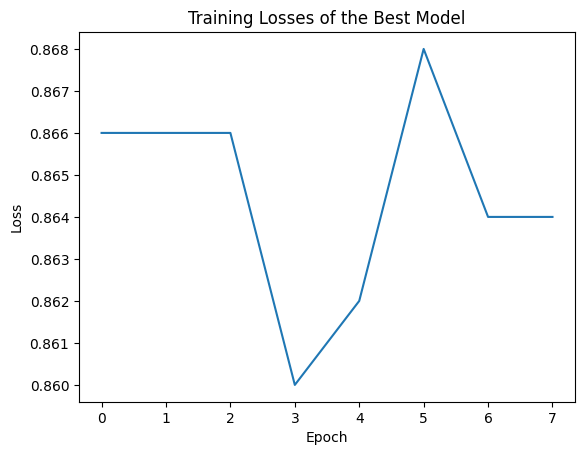

100%|██████████| 72/72 [00:00<00:00, 1246.41it/s]

Test Accuracy: 60.54%
Test Loss: 0.9200


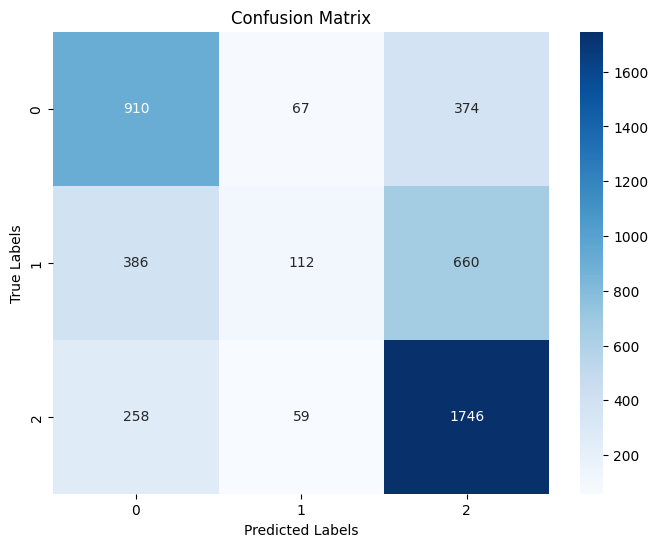

In [186]:
print("Best Hyperparameters:")
print(best_hyperparams)

plt.plot(best_losses)
plt.title("Training Losses of the Best Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

test_acc, test_loss, true_labels, predicted_labels = testing(best_model, loss_function, test_loader)
print("Test Accuracy: {:.2f}%".format(test_acc))
print("Test Loss: {:.4f}".format(test_loss))

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()